In [1]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
# !pip install tsplib95==0.6.1

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image
import math

Default GPU Device: /device:GPU:0


In [2]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.01
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [3]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        # the choice to be taken depends on the demands - penalty based
        # the choice number is the same as the node number
        # it is not a choice if the demand is 0 - changing this to penalty
        #!! Want the system to learn instead
        # if self.capacity == 0:
        #     self.visit_depo()
        self.move(choice)

    def move(self, to_node_value):
        # node_list_copy = copy.deepcopy(node_list)
        # node_list_copy.remove(1)
        # select a random node to go to
        #if not to_node_value: #to_node_value is False by default
        #    to_node_value = random.choice(self.node_list)
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)
    
    #def path(self, node_value):
    #    self.path.append(node_value)

    # def get_node(self):
    #     return self.node

    
    # def get_capacity(self):
    #     return self.capacity


In [4]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    # observation_space = (640,480,3)
    # observation_space = (100,100,3)
    # observation_space = (10,10,3)
    observation_space = (5,5,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    demand_satisfying_reward = 100 #another incentive to hit the right target. Imp with considering each step
    hopping_incentive_penalty = 500 #staying at the same node
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 5 #30
    epsilon = 1
    epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 20_000 #30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 5 #100

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))
        self.episode_step = 0
        if self.return_images:
            observation = np.array(self.get_image())

        # there is no else case as we need always need the image for CNN
        return observation
    
    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            print("***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # penalties for other trucks
        done = False
        if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        # if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty
        else:
            self.reward += self.demand_satisfying_reward

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty
        # return self.reward

    def movement_penalty(self, truck):
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)
            
    def get_zero_demand_nodes(self, node_demands):
        zero_demand_nodes_list = []
        for key in node_demands:
            if node_demands[key] == 0 and key != 1:
                zero_demand_nodes_list.append(key)
        return zero_demand_nodes_list

    def get_image(self):
        # the initiated rgb image of the given size. 
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8) #background is black
        #env = np.zeros((1, 5, 3), dtype=np.uint8) #background is black
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (0,255,0) #nodes are green
        
        node_coods = self.node_positions.get(1)
        env[int(node_coods[0])][int(node_coods[1])] = (0,0,0) #depot is black
        
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,255,255) #visited nodes are white
        zero_demand_nodes = self.get_zero_demand_nodes(self.node_demands)
        if zero_demand_nodes:
            for node in zero_demand_nodes:
                node_coods = self.node_positions.get(node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0) #danger are red
        
        node_coods = self.node_positions.get(self.truck.node)
        env[int(node_coods[0])][int(node_coods[1])] = (255,255,0) #truck position
        
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        #img = img.resize((10,10))
        return img
    
    def render(self):
        img = self.get_image()
        img = img.resize((300,300))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    

In [5]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        self.replay_memory = deque(maxlen=considering_training_length)
        # self.replay_memory = [] #removing the limit

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (2,2), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(1,1)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        self.replay_memory.append(step)

    """        
    def consider_reward(self, element):
        return element[1]
        
    def get_max_rewarded_steps(self, replay_memory, length):
        #replay_memory has the steps and steps[2] is the rewards
        # max = -math.inf
        step_reward_pairs = []
        for step in replay_memory:
            if len(step_reward_pairs) <= length:
                step_reward_pairs.append((step, step[2]))
            else:
                step_reward_pairs.sort(reverse=True, key=self.consider_reward)
                if step_reward_pairs[-1][1] < step[2]:
                    step_reward_pairs.pop() #removing the least value i.e. the last value
                    step_reward_pairs.append((step, step[2]))
        steps_list = []
        for step_reward_pair in step_reward_pairs:
            steps_list.append(step_reward_pair[0])
        return steps_list
    """    
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table - OLD
        minibatch = random.sample(self.replay_memory, min_training_length)
        # get the minibatch of the samples that have the highest reward
        #minibatch = self.get_max_rewarded_steps(self.replay_memory, min_training_length)
        
        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)
        #print(current_qs_list)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            #print(len(current_qs))
            #-1 because indexing 0-4 and actions from 1-5
            current_qs[action-1] = new_q
            

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    
    def get_models(self):
        return self.main_model, self.target_model


In [6]:
import os
try:
    os.mkdir('saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)]
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    plt.plot(x_axis,epsilon_list,'r', label='Epsilon (scaled by 1000)')
    plt.plot(x_axis,rewards_list,'g', label='Episode Rewards')
    plt.plot(x_axis,path_length_list,'b', label='Path Length (scaled by 100)')
    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(3000, 3500, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(3000, 3200, f'Adam learning rate: 0.001')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')

folder is already there


In [7]:
# model related constants
discount = 0.9 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

environment = VRPEnvironment()
agent = DQNAgent()

In [8]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(environment.no_of_episodes+1))
epsilon_list = []
rewards_list = []
path_length_list = []

epsilon_decaying_factor = 3000

plot_rep = 1000

# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table            
            action = np.argmax(agent.get_qs(current_state))+1
            #print("++"+str(action))
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space+1)
            #print("**"+str(action))

#         if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
        #try:
        new_state, reward, done, completed = environment.step(action)
        #except:
        #    print(action)
        #    raise
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        
        # no rendering
        if show_preview and not episode % aggregrate_stats_every:
            environment.render()
        
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/epsilon_decaying_factor)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
        
        #if episode%plot_rep == 0:
        #    plot_this(epsilon_list, rewards_list, path_length_list, environment)
        #    plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}.png')
        print(environment.truck.path)
    epsilon_list.append(environment.epsilon*1000)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path)*1000)
    
    print("Path is:", end=" ")
    print(environment.truck.path, end=";")
    print("P and R: "+str(episode_reward), end=";")
    print("Capacity: "+str(environment.truck.capacity), end=";")
    print("Epsilon: "+str(environment.epsilon))

  0%|                                                                                  | 0/20000 [00:00<?, ?episodes/s]

Path is: [5, 3, 5, 1, 1];P and R: -1012;Capacity: 100;Epsilon: 0.9996667222160499
Path is: [2, 2, 4, 5, 5];P and R: -1605;Capacity: 50;Epsilon: 0.9993335555061811
Path is: [5, 3, 1, 1, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.999000499833375
Path is: [5, 5, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9986675551606254
Path is: [5, 2, 1, 1, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.9983347214509387
Path is: [4, 2, 5, 5, 1, 1];P and R: -1611;Capacity: 100;Epsilon: 0.9980019986673331
Path is: [3, 3, 3, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.9976693867728395
Path is: [1, 1, 3, 4, 4];P and R: -1504;Capacity: 30;Epsilon: 0.9973368857305009
Path is: [3, 1, 1, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.997004495503373
***Satisfied***
Path is: [2, 4, 2, 4, 3];P and R: 4590;Capacity: 0;Epsilon: 0.9966722160545233
Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.9963400473470321
Path is: [2, 5, 4, 2, 4];P and R: -612;Capacity: 50;Epsilon: 0.9960079893439915

  0%|2                                                                        | 80/20000 [00:02<10:58, 30.25episodes/s]

***Satisfied***
Path is: [2, 3, 2, 3, 4];P and R: 4596;Capacity: 0;Epsilon: 0.9769367838983476
Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.9766111925719506
Path is: [4, 3, 3, 4, 3];P and R: -1107;Capacity: 30;Epsilon: 0.9762857097579093
Path is: [5, 1, 1, 4, 3];P and R: -1011;Capacity: 30;Epsilon: 0.975960335420059
Path is: [4, 1, 1, 2, 2];P and R: -1505;Capacity: 70;Epsilon: 0.9756350695222471
Path is: [2, 4, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.9753099120283326
Path is: [2, 4, 2, 4, 1, 1];P and R: -1110;Capacity: 100;Epsilon: 0.9749848629021873
Path is: [1, 1, 5, 5, 2];P and R: -1510;Capacity: 70;Epsilon: 0.9746599221076944
***Satisfied***
Path is: [3, 5, 3, 4, 2];P and R: 4590;Capacity: 0;Epsilon: 0.9743350896087494
***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.9740103653692597
***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.973685749353145
Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity

  1%|3                                                                       | 104/20000 [00:03<07:03, 47.02episodes/s]

Path is: [2, 2, 2, 1, 1];P and R: -2001;Capacity: 100;Epsilon: 0.9723883668012469
***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.9720642913612205
Path is: [3, 1, 1, 5, 3];P and R: -1012;Capacity: 100;Epsilon: 0.9717403239283386
Path is: [5, 3, 1, 1, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9714164644666048
Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.9710927129400347
Path is: [2, 2, 3, 3, 5];P and R: -1605;Capacity: 20;Epsilon: 0.970769069312656
***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.9704455335485082
Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.9701221056116428
***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.9697987854661236
Path is: [5, 2, 1, 1, 4];P and R: -1014;Capacity: 80;Epsilon: 0.9694755730760259
Path is: [5, 4, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.9691524684054375
Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.968829471

  1%|5                                                                       | 146/20000 [00:03<04:33, 72.66episodes/s]

Path is: [2, 5, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9627129408911995
Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.9623920900556793
Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.9620713461526144
Path is: [2, 2, 1, 1, 5];P and R: -1507;Capacity: 100;Epsilon: 0.9617507091463667
Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.96143017900131
Path is: [3, 3, 5, 5, 3];P and R: -1609;Capacity: 50;Epsilon: 0.9611097556818297
Path is: [1, 1, 3, 4, 5];P and R: -1005;Capacity: 30;Epsilon: 0.9607894391523232
***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.9604692293771999
Path is: [2, 3, 5, 5, 3];P and R: -1108;Capacity: 20;Epsilon: 0.9601491263208808
***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.9598291299477989
***Satisfied***
Path is: [5, 3, 4, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.9595092402223991
Path is: [5, 5, 2, 2, 4];P and R: -1613;Capacity: 50;Epsilon: 0.

  1%|5                                                                       | 163/20000 [00:03<03:54, 84.69episodes/s]

Path is: [1, 1, 2, 2, 3];P and R: -1502;Capacity: 20;Epsilon: 0.9521811296985049
Path is: [4, 3, 3, 3, 4];P and R: -1606;Capacity: 30;Epsilon: 0.9518637888816799
Path is: [4, 3, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.951546553827499
Path is: [2, 2, 1, 1, 5];P and R: -1507;Capacity: 100;Epsilon: 0.951229424500714
***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.9509124008660883
Path is: [5, 1, 1, 5, 5];P and R: -1512;Capacity: 100;Epsilon: 0.9505954828883969
Path is: [5, 2, 3, 1, 1];P and R: -1011;Capacity: 100;Epsilon: 0.950278670532427
Path is: [4, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9499619637629768
Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.949645362544857
Path is: [5, 3, 1, 1, 5];P and R: -1015;Capacity: 100;Epsilon: 0.9493288668428895
Path is: [4, 4, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9490124766219084
Path is: [5, 1, 1, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9486961918467588
Path is: [

  1%|6                                                                       | 179/20000 [00:03<03:30, 94.24episodes/s]

 [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.9442792571483525
Path is: [2, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.9439645498501
***Satisfied***
Path is: [5, 5, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.9436499474367985
Path is: [5, 5, 1, 1, 2];P and R: -1507;Capacity: 70;Epsilon: 0.9433354498734922
***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.9430210571252368
Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.9427067691570997
Path is: [5, 5, 4, 5, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.9423925859341603
Path is: [4, 2, 4, 2, 2];P and R: -1113;Capacity: 50;Epsilon: 0.9420785074215092
***Satisfied***
Path is: [4, 2, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.9417645335842487
Path is: [1, 1, 4, 5, 2];P and R: -1009;Capacity: 50;Epsilon: 0.9414506643874929
Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.9411368997963675
Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.9408232397760

  1%|7                                                                       | 209/20000 [00:04<03:42, 89.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9386305446889677
Path is: [1, 1, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9383177199810859
Path is: [4, 2, 2, 2, 4];P and R: -1610;Capacity: 50;Epsilon: 0.9380049995307295
Path is: [5, 2, 2, 2, 3];P and R: -1611;Capacity: 20;Epsilon: 0.9376923833031517
Path is: [5, 1, 1, 5, 3];P and R: -1015;Capacity: 50;Epsilon: 0.9373798712636177
Path is: [3, 5, 4, 4, 5];P and R: -1108;Capacity: 30;Epsilon: 0.9370674633774034
Path is: [4, 1, 1, 5, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.9367551596097973
Path is: [2, 3, 2, 2, 2];P and R: -1603;Capacity: 20;Epsilon: 0.9364429599260987
Path is: [2, 2, 5, 2, 5];P and R: -1113;Capacity: 70;Epsilon: 0.9361308642916188
***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.9358188726716804
Path is: [2, 2, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.9355069850316178
Path is: [1, 1, 3, 4, 3];P and R: -1005;Capacity: 30;Epsilon: 0.9351952013367766
*

  1%|8                                                                      | 236/20000 [00:04<03:10, 103.75episodes/s]


Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.9317724311786011
Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.9314618921275921
Path is: [4, 5, 3, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.9311514565723499
Path is: [2, 1, 1, 5, 4];P and R: -1008;Capacity: 80;Epsilon: 0.9308411244783815
Path is: [4, 5, 3, 5, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.9305308958112057
***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.9302207705363527
Path is: [5, 5, 3, 4, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.929910748619364
Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.9296008300257927
Path is: [2, 4, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.9292910147212036
Path is: [4, 5, 3, 4, 3];P and R: -610;Capacity: 30;Epsilon: 0.9289813026711725
Path is: [4, 3, 5, 4, 5];P and R: -610;Capacity: 30;Epsilon: 0.9286716938412872
Path is: [4, 2, 5, 2, 1, 1];P and R: -1115;Capacity: 100;Epsilon: 0.9283621881971466
Path 

  1%|8                                                                       | 248/20000 [00:10<53:57,  6.10episodes/s]

Path is: [2, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.9206579820721656
Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.9203511472201247
***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.9200444146293233
***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9197377842656799
Path is: [4, 5, 3, 5, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.9194312560951247
Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.9191248300835988
Path is: [2, 1, 1, 2, 4];P and R: -1005;Capacity: 80;Epsilon: 0.9188185061970551
Path is: [2, 4, 2, 2, 4];P and R: -1110;Capacity: 50;Epsilon: 0.9185122844014574
Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.918206164662781


  1%|8                                                                     | 257/20000 [00:14<1:23:46,  3.93episodes/s]

Path is: [1, 1, 5, 4, 2];P and R: -1010;Capacity: 50;Epsilon: 0.9179001469470129
Path is: [5, 2, 5, 1, 1];P and R: -1014;Capacity: 100;Epsilon: 0.917594231220151
Path is: [5, 1, 1, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9172884174482046
***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.9169827055971943
Path is: [3, 3, 1, 1, 4];P and R: -1507;Capacity: 80;Epsilon: 0.9166770956331523
Path is: [1, 1, 2, 3, 3];P and R: -1502;Capacity: 20;Epsilon: 0.9163715875221219


  1%|9                                                                     | 263/20000 [00:17<1:46:10,  3.10episodes/s]

***Satisfied***
Path is: [5, 4, 2, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.9160661812301576
***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.9157608767233256
***Satisfied***
Path is: [4, 5, 2, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.9154556739677031
Path is: [4, 3, 1, 1, 4];P and R: -1009;Capacity: 100;Epsilon: 0.9151505729293785
***Satisfied***
Path is: [5, 5, 4, 3, 2];P and R: 4092;Capacity: 0;Epsilon: 0.914845573574452


  1%|9                                                                     | 268/20000 [00:20<2:07:00,  2.59episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.9145406758690345
Path is: [5, 2, 2, 2, 3];P and R: -1611;Capacity: 20;Epsilon: 0.9142358797792487
Path is: [5, 3, 1, 1, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9139311852712282
Path is: [5, 1, 1, 3, 3];P and R: -1509;Capacity: 50;Epsilon: 0.9136265923111181


  1%|9                                                                     | 272/20000 [00:22<2:24:44,  2.27episodes/s]

Path is: [3, 3, 3, 3, 5];P and R: -2106;Capacity: 50;Epsilon: 0.9133221008650748
***Satisfied***
Path is: [3, 4, 5, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.9130177108992658
***Satisfied***
Path is: [2, 3, 5, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.9127134223798701


  1%|9                                                                     | 275/20000 [00:24<2:36:05,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.9124092352730778
Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.9121051495450904


  1%|9                                                                     | 277/20000 [00:25<2:40:34,  2.05episodes/s]

Path is: [2, 2, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.9118011651621205
Path is: [4, 1, 1, 5, 3];P and R: -1013;Capacity: 50;Epsilon: 0.9114972820903922


  1%|9                                                                     | 279/20000 [00:26<2:37:49,  2.08episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.9111935002961405


  1%|9                                                                     | 280/20000 [00:26<2:25:33,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.9108898197456121


  1%|9                                                                     | 281/20000 [00:27<2:25:29,  2.26episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.9105862404050646


  1%|9                                                                     | 282/20000 [00:27<2:29:05,  2.20episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.910282762240767


  1%|9                                                                     | 283/20000 [00:28<2:39:53,  2.06episodes/s]

Path is: [4, 4, 5, 2, 2];P and R: -1609;Capacity: 50;Epsilon: 0.9099793852189993


  1%|9                                                                     | 284/20000 [00:28<2:37:05,  2.09episodes/s]

Path is: [1, 1, 2, 5, 5];P and R: -1505;Capacity: 70;Epsilon: 0.9096761093060532


  1%|9                                                                     | 285/20000 [00:28<2:38:31,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.9093729344682314


  1%|#                                                                     | 286/20000 [00:29<2:48:37,  1.95episodes/s]

Path is: [3, 5, 3, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.9090698606718477


  1%|#                                                                     | 287/20000 [00:29<2:32:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.9087668878832271


  1%|#                                                                     | 288/20000 [00:30<2:26:31,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9084640160687062


  1%|#                                                                     | 289/20000 [00:30<2:36:55,  2.09episodes/s]

Path is: [4, 2, 5, 5, 5];P and R: -1611;Capacity: 50;Epsilon: 0.9081612451946324


  1%|#                                                                     | 290/20000 [00:31<2:34:21,  2.13episodes/s]

Path is: [2, 3, 1, 1, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.9078585752273646


  1%|#                                                                     | 291/20000 [00:31<2:32:35,  2.15episodes/s]

Path is: [5, 4, 1, 1, 5];P and R: -1013;Capacity: 100;Epsilon: 0.9075560061332727


  1%|#                                                                     | 292/20000 [00:32<2:41:54,  2.03episodes/s]

Path is: [4, 3, 4, 3, 1, 1];P and R: -1107;Capacity: 100;Epsilon: 0.907253537878738


  1%|#                                                                     | 293/20000 [00:32<2:38:01,  2.08episodes/s]

Path is: [1, 1, 2, 2, 5];P and R: -1505;Capacity: 70;Epsilon: 0.9069511704301528


  1%|#                                                                     | 294/20000 [00:33<2:35:16,  2.12episodes/s]

Path is: [1, 1, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.9066489037539209


  1%|#                                                                     | 295/20000 [00:33<2:32:51,  2.15episodes/s]

Path is: [5, 2, 1, 1, 2];P and R: -1011;Capacity: 100;Epsilon: 0.906346737816457


  1%|#                                                                     | 296/20000 [00:34<2:35:47,  2.11episodes/s]

Path is: [2, 1, 1, 4, 5];P and R: -1006;Capacity: 80;Epsilon: 0.9060446725841872


  1%|#                                                                     | 297/20000 [00:34<2:36:48,  2.09episodes/s]

Path is: [5, 2, 2, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.9057427080235485


  1%|#                                                                     | 298/20000 [00:35<2:34:57,  2.12episodes/s]

Path is: [5, 1, 1, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9054408441009895


  1%|#                                                                     | 299/20000 [00:35<2:42:01,  2.03episodes/s]

Path is: [2, 5, 5, 3, 3];P and R: -1608;Capacity: 20;Epsilon: 0.9051390807829696


  2%|#                                                                     | 300/20000 [00:36<2:27:17,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.9048374180359595


  2%|#                                                                     | 301/20000 [00:36<2:47:52,  1.96episodes/s]

Path is: [2, 2, 2, 5, 3];P and R: -1608;Capacity: 20;Epsilon: 0.9045358558264415


  2%|#                                                                     | 302/20000 [00:37<2:31:16,  2.17episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.9042343941209081


  2%|#                                                                     | 303/20000 [00:37<2:43:40,  2.01episodes/s]

Path is: [2, 5, 4, 2, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.9039330328858641


  2%|#                                                                     | 304/20000 [00:38<2:54:26,  1.88episodes/s]

Path is: [4, 5, 3, 5, 5];P and R: -1111;Capacity: 30;Epsilon: 0.9036317720878246


  2%|#                                                                     | 305/20000 [00:38<2:50:13,  1.93episodes/s]

Path is: [5, 2, 4, 1, 1];P and R: -1013;Capacity: 100;Epsilon: 0.9033306116933163


  2%|#                                                                     | 306/20000 [00:39<2:37:26,  2.08episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.9030295516688768


  2%|#                                                                     | 307/20000 [00:39<2:37:11,  2.09episodes/s]

Path is: [4, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.9027285919810552


  2%|#                                                                     | 308/20000 [00:40<2:46:09,  1.98episodes/s]

Path is: [2, 5, 2, 4, 5];P and R: -613;Capacity: 50;Epsilon: 0.9024277325964113


  2%|#                                                                     | 309/20000 [00:40<2:39:24,  2.06episodes/s]

Path is: [1, 1, 4, 2, 2];P and R: -1507;Capacity: 50;Epsilon: 0.9021269734815165


  2%|#                                                                     | 310/20000 [00:41<2:48:38,  1.95episodes/s]

Path is: [2, 3, 2, 5, 1, 1];P and R: -1107;Capacity: 100;Epsilon: 0.9018263146029529


  2%|#                                                                     | 311/20000 [00:41<2:40:06,  2.05episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.9015257559273142


  2%|#                                                                     | 312/20000 [00:42<2:39:14,  2.06episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.9012252974212048


  2%|#                                                                     | 313/20000 [00:42<2:23:06,  2.29episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.9009249390512405


  2%|#                                                                     | 314/20000 [00:42<2:12:27,  2.48episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.9006246807840481


  2%|#1                                                                    | 315/20000 [00:43<2:30:06,  2.19episodes/s]

Path is: [3, 1, 1, 3, 4];P and R: -1007;Capacity: 80;Epsilon: 0.9003245225862656


  2%|#1                                                                    | 316/20000 [00:43<2:39:21,  2.06episodes/s]

Path is: [4, 5, 4, 3, 3];P and R: -1107;Capacity: 30;Epsilon: 0.9000244644245421


  2%|#1                                                                    | 317/20000 [00:44<2:47:47,  1.96episodes/s]

***Satisfied***
Path is: [4, 4, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.8997245062655378


  2%|#1                                                                    | 318/20000 [00:44<2:40:10,  2.05episodes/s]

Path is: [2, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.899424648075924


  2%|#1                                                                    | 319/20000 [00:45<2:24:57,  2.26episodes/s]

Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.8991248898223833


  2%|#1                                                                    | 320/20000 [00:45<2:23:22,  2.29episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.8988252314716089


  2%|#1                                                                    | 321/20000 [00:46<2:33:26,  2.14episodes/s]

Path is: [3, 5, 5, 3, 3];P and R: -1609;Capacity: 50;Epsilon: 0.8985256729903055


  2%|#1                                                                    | 322/20000 [00:46<2:23:13,  2.29episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.898226214345189


  2%|#1                                                                    | 323/20000 [00:46<2:22:57,  2.29episodes/s]

Path is: [5, 3, 5, 1, 1];P and R: -1012;Capacity: 100;Epsilon: 0.8979268555029862


  2%|#1                                                                    | 324/20000 [00:47<2:23:27,  2.29episodes/s]

Path is: [1, 1, 4, 5, 5];P and R: -1505;Capacity: 80;Epsilon: 0.8976275964304349


  2%|#1                                                                    | 325/20000 [00:47<2:22:15,  2.31episodes/s]

Path is: [1, 1, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.8973284370942841


  2%|#1                                                                    | 326/20000 [00:48<2:11:37,  2.49episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.8970293774612939


  2%|#1                                                                    | 327/20000 [00:48<2:30:26,  2.18episodes/s]

Path is: [5, 3, 3, 2, 5];P and R: -1114;Capacity: 20;Epsilon: 0.8967304174982355


  2%|#1                                                                    | 328/20000 [00:49<2:17:41,  2.38episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.8964315571718909


  2%|#1                                                                    | 329/20000 [00:49<2:21:47,  2.31episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.8961327964490539


  2%|#1                                                                    | 330/20000 [00:50<2:32:04,  2.16episodes/s]

Path is: [4, 1, 1, 4, 5];P and R: -1009;Capacity: 100;Epsilon: 0.8958341352965282


  2%|#1                                                                    | 331/20000 [00:50<2:39:27,  2.06episodes/s]

Path is: [3, 3, 2, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.8955355736811298


  2%|#1                                                                    | 332/20000 [00:50<2:23:52,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.8952371115696849


  2%|#1                                                                    | 333/20000 [00:51<2:12:52,  2.47episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.894938748929031


  2%|#1                                                                    | 334/20000 [00:51<2:17:09,  2.39episodes/s]

Path is: [5, 5, 1, 1, 4];P and R: -1510;Capacity: 80;Epsilon: 0.8946404857260168


  2%|#1                                                                    | 335/20000 [00:52<2:19:44,  2.35episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.8943423219275021


  2%|#1                                                                    | 336/20000 [00:52<2:33:37,  2.13episodes/s]

Path is: [3, 4, 4, 5, 5];P and R: -1605;Capacity: 30;Epsilon: 0.8940442575003572


  2%|#1                                                                    | 337/20000 [00:53<2:42:18,  2.02episodes/s]

Path is: [4, 5, 2, 5, 2];P and R: -617;Capacity: 50;Epsilon: 0.8937462924114642


  2%|#1                                                                    | 338/20000 [00:53<2:38:15,  2.07episodes/s]

Path is: [3, 5, 3, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.8934484266277157


  2%|#1                                                                    | 339/20000 [00:54<2:27:50,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.8931506601160155


  2%|#1                                                                    | 340/20000 [00:54<2:24:35,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.8928529928432785


  2%|#1                                                                    | 341/20000 [00:55<2:35:54,  2.10episodes/s]

Path is: [2, 2, 4, 5, 4];P and R: -1106;Capacity: 50;Epsilon: 0.8925554247764305


  2%|#1                                                                    | 342/20000 [00:55<2:44:03,  2.00episodes/s]

Path is: [5, 5, 4, 2, 4];P and R: -1113;Capacity: 50;Epsilon: 0.8922579558824083


  2%|#2                                                                    | 343/20000 [00:56<2:33:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.89196058612816


  2%|#2                                                                    | 344/20000 [00:56<2:43:49,  2.00episodes/s]

Path is: [3, 1, 1, 5, 5];P and R: -1509;Capacity: 100;Epsilon: 0.8916633154806444


  2%|#2                                                                    | 345/20000 [00:57<2:50:35,  1.92episodes/s]

Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.8913661439068313


  2%|#2                                                                    | 346/20000 [00:57<3:00:24,  1.82episodes/s]

Path is: [5, 1, 1, 2, 5];P and R: -1011;Capacity: 70;Epsilon: 0.891069071373702


  2%|#2                                                                    | 347/20000 [00:58<3:00:35,  1.81episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.8907720978482481


  2%|#2                                                                    | 348/20000 [00:59<3:17:13,  1.66episodes/s]

Path is: [5, 2, 2, 2, 1, 1];P and R: -2110;Capacity: 100;Epsilon: 0.8904752232974726


  2%|#2                                                                    | 349/20000 [00:59<3:15:39,  1.67episodes/s]

Path is: [1, 1, 3, 4, 4];P and R: -1504;Capacity: 30;Epsilon: 0.8901784476883895


  2%|#2                                                                    | 350/20000 [01:00<3:13:11,  1.70episodes/s]

Path is: [2, 2, 1, 1, 5];P and R: -1507;Capacity: 100;Epsilon: 0.8898817709880238


  2%|#2                                                                    | 351/20000 [01:00<3:25:58,  1.59episodes/s]

Path is: [4, 5, 2, 2, 5];P and R: -1113;Capacity: 50;Epsilon: 0.8895851931634113


  2%|#2                                                                    | 352/20000 [01:01<3:21:23,  1.63episodes/s]

Path is: [4, 3, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.889288714181599


  2%|#2                                                                    | 353/20000 [01:02<3:13:41,  1.69episodes/s]

Path is: [4, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8889923340096447


  2%|#2                                                                    | 354/20000 [01:02<3:06:32,  1.76episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8886960526146174


  2%|#2                                                                    | 355/20000 [01:02<2:48:56,  1.94episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.8883998699635968


  2%|#2                                                                    | 356/20000 [01:03<2:34:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8881037860236737


  2%|#2                                                                    | 357/20000 [01:03<2:35:02,  2.11episodes/s]

Path is: [1, 1, 5, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.8878078007619501


  2%|#2                                                                    | 358/20000 [01:04<2:54:46,  1.87episodes/s]

Path is: [3, 3, 5, 5, 5];P and R: -2106;Capacity: 50;Epsilon: 0.8875119141455385


  2%|#2                                                                    | 359/20000 [01:05<3:00:25,  1.81episodes/s]

Path is: [3, 4, 4, 5, 4];P and R: -1106;Capacity: 30;Epsilon: 0.8872161261415628


  2%|#2                                                                    | 360/20000 [01:05<2:39:13,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8869204367171575


  2%|#2                                                                    | 361/20000 [01:05<2:36:27,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.8866248458394683


  2%|#2                                                                    | 362/20000 [01:06<2:46:46,  1.96episodes/s]

Path is: [2, 2, 4, 2, 4];P and R: -1110;Capacity: 50;Epsilon: 0.8863293534756519


  2%|#2                                                                    | 363/20000 [01:06<2:44:27,  1.99episodes/s]

Path is: [5, 4, 1, 1, 3];P and R: -1010;Capacity: 50;Epsilon: 0.8860339595928756


  2%|#2                                                                    | 364/20000 [01:07<2:50:37,  1.92episodes/s]

Path is: [4, 3, 5, 4, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.8857386641583179


  2%|#2                                                                    | 365/20000 [01:07<2:33:59,  2.13episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.8854434671391683


  2%|#2                                                                    | 366/20000 [01:08<2:33:30,  2.13episodes/s]

Path is: [3, 5, 4, 1, 1];P and R: -1007;Capacity: 100;Epsilon: 0.8851483685026271


  2%|#2                                                                    | 367/20000 [01:08<2:34:45,  2.11episodes/s]

Path is: [5, 4, 1, 1, 2];P and R: -1008;Capacity: 70;Epsilon: 0.8848533682159055


  2%|#2                                                                    | 368/20000 [01:09<2:36:50,  2.09episodes/s]

Path is: [4, 2, 1, 1, 5];P and R: -1013;Capacity: 100;Epsilon: 0.8845584662462257


  2%|#2                                                                    | 369/20000 [01:09<2:26:41,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8842636625608209


  2%|#2                                                                    | 370/20000 [01:10<2:18:01,  2.37episodes/s]

Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.883968957126935


  2%|#2                                                                    | 371/20000 [01:10<2:20:39,  2.33episodes/s]

Path is: [1, 1, 5, 4, 5];P and R: -1008;Capacity: 80;Epsilon: 0.883674349911823


  2%|#3                                                                    | 372/20000 [01:10<2:23:51,  2.27episodes/s]

Path is: [3, 1, 1, 5, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.8833798408827509


  2%|#3                                                                    | 373/20000 [01:11<2:35:03,  2.11episodes/s]

Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8830854300069952


  2%|#3                                                                    | 374/20000 [01:11<2:22:25,  2.30episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.8827911172518439


  2%|#3                                                                    | 375/20000 [01:12<2:38:33,  2.06episodes/s]

Path is: [2, 5, 2, 4, 2];P and R: -615;Capacity: 50;Epsilon: 0.8824969025845955


  2%|#3                                                                    | 376/20000 [01:12<2:36:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.8822027859725592


  2%|#3                                                                    | 377/20000 [01:13<2:48:07,  1.95episodes/s]

Path is: [4, 5, 5, 5, 3];P and R: -1608;Capacity: 30;Epsilon: 0.8819087673830557


  2%|#3                                                                    | 378/20000 [01:13<2:30:37,  2.17episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.8816148467834161


  2%|#3                                                                    | 379/20000 [01:14<2:44:25,  1.99episodes/s]

Path is: [4, 5, 5, 2, 4];P and R: -1112;Capacity: 50;Epsilon: 0.8813210241409826


  2%|#3                                                                    | 380/20000 [01:15<2:50:47,  1.91episodes/s]

Path is: [4, 5, 4, 5, 2];P and R: -611;Capacity: 50;Epsilon: 0.8810272994231082


  2%|#3                                                                    | 381/20000 [01:15<2:47:12,  1.96episodes/s]

Path is: [1, 1, 4, 2, 4];P and R: -1010;Capacity: 50;Epsilon: 0.880733672597157


  2%|#3                                                                    | 382/20000 [01:15<2:41:23,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.8804401436305035


  2%|#3                                                                    | 383/20000 [01:16<2:52:49,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 3, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.8801467124905337


  2%|#3                                                                    | 384/20000 [01:17<3:00:09,  1.81episodes/s]

Path is: [4, 5, 3, 3, 5];P and R: -1111;Capacity: 30;Epsilon: 0.8798533791446438


  2%|#3                                                                    | 385/20000 [01:17<3:03:21,  1.78episodes/s]

Path is: [2, 4, 4, 2, 4];P and R: -1110;Capacity: 50;Epsilon: 0.8795601435602415


  2%|#3                                                                    | 386/20000 [01:18<3:14:07,  1.68episodes/s]

Path is: [1, 1, 4, 3, 5];P and R: -1008;Capacity: 30;Epsilon: 0.8792670057047449


  2%|#3                                                                    | 387/20000 [01:19<3:15:51,  1.67episodes/s]

***Satisfied***
Path is: [2, 4, 4, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.8789739655455832


  2%|#3                                                                    | 388/20000 [01:19<3:24:53,  1.60episodes/s]

Path is: [3, 5, 5, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.8786810230501964


  2%|#3                                                                    | 389/20000 [01:20<3:26:43,  1.58episodes/s]

Path is: [5, 5, 3, 3, 3];P and R: -2109;Capacity: 50;Epsilon: 0.8783881781860351


  2%|#3                                                                    | 390/20000 [01:20<3:02:07,  1.79episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.8780954309205613


  2%|#3                                                                    | 391/20000 [01:21<2:56:16,  1.85episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.8778027812212474


  2%|#3                                                                    | 392/20000 [01:21<2:43:10,  2.00episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.8775102290555767


  2%|#3                                                                    | 393/20000 [01:22<2:40:27,  2.04episodes/s]

Path is: [1, 1, 4, 2, 4];P and R: -1010;Capacity: 50;Epsilon: 0.8772177743910435


  2%|#3                                                                    | 394/20000 [01:22<2:51:36,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 3, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.8769254171951529


  2%|#3                                                                    | 395/20000 [01:23<2:34:06,  2.12episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.8766331574354206


  2%|#3                                                                    | 396/20000 [01:23<2:32:41,  2.14episodes/s]

Path is: [5, 5, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.8763409950793732


  2%|#3                                                                    | 397/20000 [01:24<2:45:20,  1.98episodes/s]

Path is: [2, 2, 5, 4, 4];P and R: -1606;Capacity: 50;Epsilon: 0.8760489300945487


  2%|#3                                                                    | 398/20000 [01:24<2:41:37,  2.02episodes/s]

Path is: [1, 1, 4, 2, 2];P and R: -1507;Capacity: 50;Epsilon: 0.8757569624484949


  2%|#3                                                                    | 399/20000 [01:25<2:52:05,  1.90episodes/s]

***Satisfied***
Path is: [2, 2, 2, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.8754650921087711


  2%|#4                                                                    | 400/20000 [01:25<3:00:13,  1.81episodes/s]

Path is: [2, 4, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.8751733190429475


  2%|#4                                                                    | 401/20000 [01:26<3:03:33,  1.78episodes/s]

Path is: [2, 4, 5, 2, 4];P and R: -612;Capacity: 50;Epsilon: 0.8748816432186046


  2%|#4                                                                    | 402/20000 [01:27<3:06:46,  1.75episodes/s]

Path is: [2, 5, 3, 5, 3];P and R: -614;Capacity: 20;Epsilon: 0.874590064603334


  2%|#4                                                                    | 403/20000 [01:27<2:57:34,  1.84episodes/s]

Path is: [3, 1, 1, 4, 3];P and R: -1008;Capacity: 80;Epsilon: 0.8742985831647383


  2%|#4                                                                    | 404/20000 [01:28<2:59:52,  1.82episodes/s]

Path is: [2, 4, 2, 4, 4];P and R: -1110;Capacity: 50;Epsilon: 0.8740071988704304


  2%|#4                                                                    | 405/20000 [01:28<2:50:42,  1.91episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.8737159116880344


  2%|#4                                                                    | 406/20000 [01:28<2:44:53,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.8734247215851851


  2%|#4                                                                    | 407/20000 [01:29<2:42:50,  2.01episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.8731336285295279


  2%|#4                                                                    | 408/20000 [01:29<2:41:53,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.8728426324887193


  2%|#4                                                                    | 409/20000 [01:30<2:37:28,  2.07episodes/s]

Path is: [5, 1, 1, 4, 5];P and R: -1011;Capacity: 80;Epsilon: 0.8725517334304264


  2%|#4                                                                    | 410/20000 [01:30<2:34:57,  2.11episodes/s]

Path is: [1, 1, 4, 5, 2];P and R: -1009;Capacity: 50;Epsilon: 0.8722609313223268


  2%|#4                                                                    | 411/20000 [01:31<2:51:55,  1.90episodes/s]

Path is: [5, 4, 5, 2, 1, 1];P and R: -1112;Capacity: 100;Epsilon: 0.8719702261321094


  2%|#4                                                                    | 412/20000 [01:32<2:57:00,  1.84episodes/s]

Path is: [3, 4, 3, 4, 1, 1];P and R: -1106;Capacity: 100;Epsilon: 0.8716796178274736


  2%|#4                                                                    | 413/20000 [01:32<3:02:09,  1.79episodes/s]

Path is: [1, 1, 5, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.8713891063761297


  2%|#4                                                                    | 414/20000 [01:33<2:56:10,  1.85episodes/s]

Path is: [1, 1, 5, 4, 2];P and R: -1010;Capacity: 50;Epsilon: 0.8710986917457983


  2%|#4                                                                    | 415/20000 [01:33<2:39:24,  2.05episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.8708083739042115


  2%|#4                                                                    | 416/20000 [01:34<2:46:39,  1.96episodes/s]

***Satisfied***
Path is: [5, 4, 2, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.8705181528191115


  2%|#4                                                                    | 417/20000 [01:34<2:57:38,  1.84episodes/s]

Path is: [3, 3, 3, 2, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.8702280284582515


  2%|#4                                                                    | 418/20000 [01:35<2:42:28,  2.01episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.8699380007893958


  2%|#4                                                                    | 419/20000 [01:35<2:47:58,  1.94episodes/s]

Path is: [4, 4, 4, 4, 2];P and R: -2107;Capacity: 50;Epsilon: 0.8696480697803187


  2%|#4                                                                    | 420/20000 [01:36<2:45:47,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.8693582353988059


  2%|#4                                                                    | 421/20000 [01:36<2:40:18,  2.04episodes/s]

Path is: [2, 2, 2, 1, 1];P and R: -2001;Capacity: 100;Epsilon: 0.8690684976126534


  2%|#4                                                                    | 422/20000 [01:37<2:36:32,  2.08episodes/s]

Path is: [3, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8687788563896681


  2%|#4                                                                    | 423/20000 [01:37<2:39:38,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.8684893116976679


  2%|#4                                                                    | 424/20000 [01:38<2:47:56,  1.94episodes/s]

Path is: [5, 5, 2, 4, 5];P and R: -1114;Capacity: 50;Epsilon: 0.868199863504481


  2%|#4                                                                    | 425/20000 [01:38<2:55:01,  1.86episodes/s]

***Satisfied***
Path is: [5, 4, 5, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.8679105117779464


  2%|#4                                                                    | 426/20000 [01:39<2:38:13,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.867621256485914


  2%|#4                                                                    | 427/20000 [01:39<2:39:40,  2.04episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.8673320975962444


  2%|#4                                                                    | 428/20000 [01:40<2:41:47,  2.02episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8670430350768087


  2%|#5                                                                    | 429/20000 [01:40<2:47:48,  1.94episodes/s]

Path is: [3, 2, 2, 2, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.866754068895489


  2%|#5                                                                    | 430/20000 [01:41<2:44:20,  1.98episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.8664651990201777


  2%|#5                                                                    | 431/20000 [01:41<2:50:27,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 5, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.8661764254187784


  2%|#5                                                                    | 432/20000 [01:42<2:35:57,  2.09episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.865887748059205


  2%|#5                                                                    | 433/20000 [01:42<2:22:40,  2.29episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.8655991669093823


  2%|#5                                                                    | 434/20000 [01:42<2:24:43,  2.25episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.8653106819372457


  2%|#5                                                                    | 435/20000 [01:43<2:19:01,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8650222931107413


  2%|#5                                                                    | 436/20000 [01:43<2:35:21,  2.10episodes/s]

Path is: [3, 2, 2, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.8647340003978259


  2%|#5                                                                    | 437/20000 [01:44<2:36:46,  2.08episodes/s]

Path is: [3, 5, 1, 1, 5];P and R: -1012;Capacity: 100;Epsilon: 0.864445803766467


  2%|#5                                                                    | 438/20000 [01:44<2:22:49,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.8641577031846428


  2%|#5                                                                    | 439/20000 [01:45<2:35:58,  2.09episodes/s]

Path is: [4, 4, 4, 4, 5];P and R: -2105;Capacity: 80;Epsilon: 0.8638696986203419


  2%|#5                                                                    | 440/20000 [01:45<2:46:05,  1.96episodes/s]

***Satisfied***
Path is: [2, 2, 3, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.8635817900415641


  2%|#5                                                                    | 441/20000 [01:46<2:51:49,  1.90episodes/s]

Path is: [4, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8632939774163194


  2%|#5                                                                    | 442/20000 [01:46<2:44:50,  1.98episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.8630062607126286


  2%|#5                                                                    | 443/20000 [01:47<2:39:43,  2.04episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.8627186398985233


  2%|#5                                                                    | 444/20000 [01:47<2:46:33,  1.96episodes/s]

Path is: [3, 5, 4, 3, 1, 1];P and R: -1108;Capacity: 100;Epsilon: 0.8624311149420455


  2%|#5                                                                    | 445/20000 [01:48<2:40:52,  2.03episodes/s]

Path is: [1, 1, 5, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8621436858112479


  2%|#5                                                                    | 446/20000 [01:48<2:50:59,  1.91episodes/s]

Path is: [3, 3, 3, 4, 5];P and R: -1605;Capacity: 30;Epsilon: 0.8618563524741942


  2%|#5                                                                    | 447/20000 [01:49<2:47:31,  1.95episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.8615691148989583


  2%|#5                                                                    | 448/20000 [01:49<2:41:41,  2.02episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.8612819730536249


  2%|#5                                                                    | 449/20000 [01:50<2:50:47,  1.91episodes/s]

Path is: [3, 4, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.8609949269062894


  2%|#5                                                                    | 450/20000 [01:50<2:49:37,  1.92episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.8607079764250578


  2%|#5                                                                    | 451/20000 [01:51<2:54:24,  1.87episodes/s]

Path is: [3, 5, 5, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.8604211215780466


  2%|#5                                                                    | 452/20000 [01:52<2:48:37,  1.93episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.8601343623333833


  2%|#5                                                                    | 453/20000 [01:52<2:42:59,  2.00episodes/s]

Path is: [4, 1, 1, 5, 5];P and R: -1510;Capacity: 100;Epsilon: 0.8598476986592055


  2%|#5                                                                    | 454/20000 [01:52<2:38:47,  2.05episodes/s]

Path is: [2, 1, 1, 4, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8595611305236618


  2%|#5                                                                    | 455/20000 [01:53<2:46:29,  1.96episodes/s]

Path is: [4, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.8592746578949112


  2%|#5                                                                    | 456/20000 [01:54<2:42:48,  2.00episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.8589882807411234


  2%|#5                                                                    | 457/20000 [01:54<2:26:55,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.858701999030479


  2%|#6                                                                    | 458/20000 [01:54<2:30:30,  2.16episodes/s]

Path is: [2, 5, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8584158127311685


  2%|#6                                                                    | 459/20000 [01:55<2:32:41,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.8581297218113938


  2%|#6                                                                    | 460/20000 [01:55<2:38:02,  2.06episodes/s]

Path is: [5, 5, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8578437262393668


  2%|#6                                                                    | 461/20000 [01:56<2:37:23,  2.07episodes/s]

Path is: [1, 1, 5, 4, 2];P and R: -1010;Capacity: 50;Epsilon: 0.8575578259833102


  2%|#6                                                                    | 462/20000 [01:56<2:45:33,  1.97episodes/s]

Path is: [2, 5, 2, 3, 3];P and R: -1110;Capacity: 20;Epsilon: 0.8572720210114575


  2%|#6                                                                    | 463/20000 [01:57<2:42:04,  2.01episodes/s]

Path is: [2, 2, 1, 1, 4];P and R: -1505;Capacity: 80;Epsilon: 0.8569863112920523


  2%|#6                                                                    | 464/20000 [01:57<2:38:36,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.8567006967933494


  2%|#6                                                                    | 465/20000 [01:58<2:30:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8564151774836135


  2%|#6                                                                    | 466/20000 [01:58<2:22:39,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.8561297533311205


  2%|#6                                                                    | 467/20000 [01:59<2:38:48,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 5, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.8558444243041566


  2%|#6                                                                    | 468/20000 [01:59<2:38:20,  2.06episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.8555591903710185


  2%|#6                                                                    | 469/20000 [02:00<2:25:39,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8552740515000135


  2%|#6                                                                    | 470/20000 [02:00<2:55:09,  1.86episodes/s]

***Satisfied***
Path is: [2, 2, 5, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.8549890076594595


  2%|#6                                                                    | 471/20000 [02:01<3:00:15,  1.81episodes/s]

Path is: [5, 2, 4, 2, 4];P and R: -619;Capacity: 50;Epsilon: 0.8547040588176851


  2%|#6                                                                    | 472/20000 [02:01<2:55:51,  1.85episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.8544192049430291


  2%|#6                                                                    | 473/20000 [02:02<2:58:19,  1.83episodes/s]

Path is: [5, 4, 5, 4, 2];P and R: -612;Capacity: 50;Epsilon: 0.8541344460038414


  2%|#6                                                                    | 474/20000 [02:03<3:02:36,  1.78episodes/s]

Path is: [2, 2, 2, 2, 4];P and R: -2104;Capacity: 50;Epsilon: 0.8538497819684817


  2%|#6                                                                    | 475/20000 [02:03<2:55:17,  1.86episodes/s]

Path is: [2, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.853565212805321


  2%|#6                                                                    | 476/20000 [02:03<2:47:20,  1.94episodes/s]

***Satisfied***
Path is: [4, 5, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8532807384827403


  2%|#6                                                                    | 477/20000 [02:04<2:30:14,  2.17episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.8529963589691315


  2%|#6                                                                    | 478/20000 [02:04<2:48:16,  1.93episodes/s]

***Satisfied***
Path is: [5, 2, 4, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.8527120742328967


  2%|#6                                                                    | 479/20000 [02:05<2:47:04,  1.95episodes/s]

Path is: [5, 1, 1, 2, 4];P and R: -1010;Capacity: 50;Epsilon: 0.852427884242449


  2%|#6                                                                    | 480/20000 [02:05<2:41:47,  2.01episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.8521437889662113


  2%|#6                                                                    | 481/20000 [02:06<2:40:49,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.8518597883726179


  2%|#6                                                                    | 482/20000 [02:07<3:01:10,  1.80episodes/s]

Path is: [5, 2, 3, 5, 1, 1];P and R: -1114;Capacity: 100;Epsilon: 0.8515758824301128


  2%|#6                                                                    | 483/20000 [02:07<2:53:27,  1.88episodes/s]

Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.8512920711071511


  2%|#6                                                                    | 484/20000 [02:08<2:46:34,  1.95episodes/s]

Path is: [4, 1, 1, 5, 4];P and R: -1011;Capacity: 100;Epsilon: 0.8510083543721982


  2%|#6                                                                    | 485/20000 [02:08<2:38:29,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.8507247321937301


  2%|#7                                                                    | 486/20000 [02:08<2:24:25,  2.25episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.850441204540233


  2%|#7                                                                    | 487/20000 [02:09<2:29:04,  2.18episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.850157771380204


  2%|#7                                                                    | 488/20000 [02:09<2:39:02,  2.04episodes/s]

Path is: [5, 4, 5, 4, 5];P and R: -610;Capacity: 80;Epsilon: 0.8498744326821505


  2%|#7                                                                    | 489/20000 [02:10<2:25:01,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.8495911884145902


  2%|#7                                                                    | 490/20000 [02:10<2:36:53,  2.07episodes/s]

Path is: [5, 2, 3, 2, 1, 1];P and R: -1112;Capacity: 100;Epsilon: 0.849308038546052


  2%|#7                                                                    | 491/20000 [02:11<2:23:29,  2.27episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.8490249830450742


  2%|#7                                                                    | 492/20000 [02:11<2:34:45,  2.10episodes/s]

Path is: [5, 2, 5, 3, 5];P and R: -620;Capacity: 20;Epsilon: 0.8487420218802068


  2%|#7                                                                    | 493/20000 [02:12<2:35:53,  2.09episodes/s]

Path is: [2, 3, 2, 1, 1];P and R: -1003;Capacity: 100;Epsilon: 0.8484591550200091


  2%|#7                                                                    | 494/20000 [02:12<2:46:20,  1.95episodes/s]

Path is: [2, 5, 5, 5, 4];P and R: -1606;Capacity: 50;Epsilon: 0.8481763824330519


  2%|#7                                                                    | 495/20000 [02:13<2:29:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8478937040879159


  2%|#7                                                                    | 496/20000 [02:13<2:29:29,  2.17episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.8476111199531922


  2%|#7                                                                    | 497/20000 [02:14<2:44:13,  1.98episodes/s]

Path is: [1, 1, 5, 2, 2];P and R: -1510;Capacity: 70;Epsilon: 0.8473286299974827


  2%|#7                                                                    | 498/20000 [02:14<2:38:52,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.8470462341893996


  2%|#7                                                                    | 499/20000 [02:15<2:37:30,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8467639324975658


  2%|#7                                                                    | 500/20000 [02:15<2:34:42,  2.10episodes/s]

Path is: [2, 3, 1, 1, 2];P and R: -1003;Capacity: 100;Epsilon: 0.8464817248906141


  3%|#7                                                                    | 501/20000 [02:16<2:32:03,  2.14episodes/s]

Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.8461996113371882


  3%|#7                                                                    | 502/20000 [02:16<2:35:10,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.8459175918059424


  3%|#7                                                                    | 503/20000 [02:16<2:22:28,  2.28episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.8456356662655409


  3%|#7                                                                    | 504/20000 [02:17<2:19:29,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8453538346846587


  3%|#7                                                                    | 505/20000 [02:17<2:25:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.8450720970319813


  3%|#7                                                                    | 506/20000 [02:18<2:29:25,  2.17episodes/s]

Path is: [1, 1, 2, 2, 1, 1];P and R: -2001;Capacity: 100;Epsilon: 0.8447904532762044


  3%|#7                                                                    | 507/20000 [02:18<2:28:29,  2.19episodes/s]

Path is: [1, 1, 2, 4, 2];P and R: -1007;Capacity: 50;Epsilon: 0.8445089033860343


  3%|#7                                                                    | 508/20000 [02:19<2:28:12,  2.19episodes/s]

Path is: [1, 1, 3, 3, 5];P and R: -1506;Capacity: 50;Epsilon: 0.8442274473301877


  3%|#7                                                                    | 509/20000 [02:19<2:18:35,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8439460850773917


  3%|#7                                                                    | 510/20000 [02:19<2:21:17,  2.30episodes/s]

Path is: [5, 4, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.8436648165963837


  3%|#7                                                                    | 511/20000 [02:20<2:32:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.8433836418559117


  3%|#7                                                                    | 512/20000 [02:21<2:43:54,  1.98episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.8431025608247342


  3%|#7                                                                    | 513/20000 [02:21<2:39:07,  2.04episodes/s]

Path is: [5, 2, 5, 1, 1];P and R: -1014;Capacity: 100;Epsilon: 0.8428215734716199


  3%|#7                                                                    | 514/20000 [02:22<2:39:09,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.842540679765348


  3%|#8                                                                    | 515/20000 [02:22<2:56:17,  1.84episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.842259879674708


  3%|#8                                                                    | 516/20000 [02:23<2:46:55,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.8419791731684999


  3%|#8                                                                    | 517/20000 [02:23<2:44:58,  1.97episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.8416985602155341


  3%|#8                                                                    | 518/20000 [02:24<2:42:45,  1.99episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.8414180407846316


  3%|#8                                                                    | 519/20000 [02:24<2:42:41,  2.00episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8411376148446232


  3%|#8                                                                    | 520/20000 [02:25<2:42:25,  2.00episodes/s]

Path is: [2, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.8408572823643508


  3%|#8                                                                    | 521/20000 [02:25<2:41:18,  2.01episodes/s]

Path is: [2, 5, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.840577043312666


  3%|#8                                                                    | 522/20000 [02:26<2:39:34,  2.03episodes/s]

Path is: [2, 2, 1, 1, 4];P and R: -1505;Capacity: 80;Epsilon: 0.8402968976584314


  3%|#8                                                                    | 523/20000 [02:26<2:36:44,  2.07episodes/s]

Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.8400168453705197


  3%|#8                                                                    | 524/20000 [02:27<2:33:12,  2.12episodes/s]

Path is: [5, 3, 1, 1, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.8397368864178139


  3%|#8                                                                    | 525/20000 [02:27<2:34:27,  2.10episodes/s]

Path is: [5, 3, 5, 1, 1];P and R: -1012;Capacity: 100;Epsilon: 0.8394570207692074


  3%|#8                                                                    | 526/20000 [02:28<2:47:41,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.8391772483936041


  3%|#8                                                                    | 527/20000 [02:28<2:34:11,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8388975692599181


  3%|#8                                                                    | 528/20000 [02:28<2:35:00,  2.09episodes/s]

Path is: [5, 2, 1, 1, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.838617983337074


  3%|#8                                                                    | 529/20000 [02:29<2:35:14,  2.09episodes/s]

Path is: [3, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8383384905940067


  3%|#8                                                                    | 530/20000 [02:30<2:46:06,  1.95episodes/s]

Path is: [2, 3, 5, 5, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.8380590909996615


  3%|#8                                                                    | 531/20000 [02:30<2:50:27,  1.90episodes/s]

Path is: [5, 4, 4, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.8377797845229938


  3%|#8                                                                    | 532/20000 [02:31<2:40:19,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.8375005711329698


  3%|#8                                                                    | 533/20000 [02:31<2:45:54,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.8372214507985657


  3%|#8                                                                    | 534/20000 [02:32<2:53:33,  1.87episodes/s]

Path is: [5, 3, 3, 2, 5];P and R: -1114;Capacity: 20;Epsilon: 0.8369424234887681


  3%|#8                                                                    | 535/20000 [02:32<2:47:27,  1.94episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.8366634891725739


  3%|#8                                                                    | 536/20000 [02:33<2:52:02,  1.89episodes/s]

***Satisfied***
Path is: [4, 3, 5, 4, 2];P and R: 4591;Capacity: 0;Epsilon: 0.8363846478189905


  3%|#8                                                                    | 537/20000 [02:33<2:54:39,  1.86episodes/s]

Path is: [2, 2, 3, 3, 5];P and R: -1605;Capacity: 20;Epsilon: 0.8361058993970355


  3%|#8                                                                    | 538/20000 [02:34<2:50:30,  1.90episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.8358272438757368


  3%|#8                                                                    | 539/20000 [02:34<2:46:23,  1.95episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.8355486812241328


  3%|#8                                                                    | 540/20000 [02:35<2:43:38,  1.98episodes/s]

Path is: [5, 3, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.835270211411272


  3%|#8                                                                    | 541/20000 [02:35<2:52:10,  1.88episodes/s]

Path is: [2, 3, 5, 5, 5];P and R: -1605;Capacity: 20;Epsilon: 0.8349918344062133


  3%|#8                                                                    | 542/20000 [02:36<2:44:38,  1.97episodes/s]

Path is: [2, 5, 1, 1, 4];P and R: -1009;Capacity: 80;Epsilon: 0.834713550178026


  3%|#9                                                                    | 543/20000 [02:36<2:38:30,  2.05episodes/s]

Path is: [1, 1, 5, 5, 4];P and R: -1507;Capacity: 80;Epsilon: 0.8344353586957896


  3%|#9                                                                    | 544/20000 [02:37<2:35:52,  2.08episodes/s]

Path is: [4, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.8341572599285938


  3%|#9                                                                    | 545/20000 [02:37<2:32:30,  2.13episodes/s]

Path is: [2, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.833879253845539


  3%|#9                                                                    | 546/20000 [02:38<2:45:08,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 4, 4, 2];P and R: 4093;Capacity: 0;Epsilon: 0.8336013404157353


  3%|#9                                                                    | 547/20000 [02:38<2:39:04,  2.04episodes/s]

Path is: [1, 1, 2, 5, 4];P and R: -1006;Capacity: 50;Epsilon: 0.8333235196083038


  3%|#9                                                                    | 548/20000 [02:39<2:39:09,  2.04episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.8330457913923751


  3%|#9                                                                    | 549/20000 [02:39<2:24:34,  2.24episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.832768155737091


  3%|#9                                                                    | 550/20000 [02:39<2:25:13,  2.23episodes/s]

Path is: [2, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8324906126116027


  3%|#9                                                                    | 551/20000 [02:40<2:36:19,  2.07episodes/s]

Path is: [4, 5, 5, 5, 3];P and R: -1608;Capacity: 30;Epsilon: 0.8322131619850722


  3%|#9                                                                    | 552/20000 [02:41<2:46:53,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 5, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.8319358038266718


  3%|#9                                                                    | 553/20000 [02:41<2:40:49,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8316585381055837


  3%|#9                                                                    | 554/20000 [02:42<2:42:38,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.8313813647910007


  3%|#9                                                                    | 555/20000 [02:42<2:30:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.8311042838521256


  3%|#9                                                                    | 556/20000 [02:43<2:43:34,  1.98episodes/s]

Path is: [4, 5, 5, 3, 4];P and R: -1109;Capacity: 30;Epsilon: 0.830827295258172


  3%|#9                                                                    | 557/20000 [02:43<2:31:36,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.830550398978363


  3%|#9                                                                    | 558/20000 [02:44<2:40:00,  2.03episodes/s]

Path is: [3, 4, 3, 3, 4];P and R: -1106;Capacity: 30;Epsilon: 0.8302735949819326


  3%|#9                                                                    | 559/20000 [02:44<2:47:41,  1.93episodes/s]

Path is: [3, 2, 2, 3, 5];P and R: -1108;Capacity: 20;Epsilon: 0.8299968832381248


  3%|#9                                                                    | 560/20000 [02:45<2:44:47,  1.97episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.8297202637161938


  3%|#9                                                                    | 561/20000 [02:45<2:39:13,  2.03episodes/s]

Path is: [2, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.8294437363854039


  3%|#9                                                                    | 562/20000 [02:46<2:49:52,  1.91episodes/s]

Path is: [2, 5, 4, 2, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.8291673012150301


  3%|#9                                                                    | 563/20000 [02:46<2:54:37,  1.86episodes/s]

Path is: [4, 5, 5, 4, 1, 1];P and R: -1606;Capacity: 100;Epsilon: 0.8288909581743572


  3%|#9                                                                    | 564/20000 [02:47<2:35:32,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8286147072326806


  3%|#9                                                                    | 565/20000 [02:47<2:44:03,  1.97episodes/s]

Path is: [3, 4, 4, 3, 4];P and R: -1106;Capacity: 30;Epsilon: 0.8283385483593056


  3%|#9                                                                    | 566/20000 [02:47<2:27:25,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.828062481523548


  3%|#9                                                                    | 567/20000 [02:48<2:40:58,  2.01episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.8277865066947336


  3%|#9                                                                    | 568/20000 [02:49<2:39:21,  2.03episodes/s]

Path is: [4, 1, 1, 5, 4];P and R: -1011;Capacity: 100;Epsilon: 0.8275106238421986


  3%|#9                                                                    | 569/20000 [02:49<2:39:46,  2.03episodes/s]

Path is: [5, 1, 1, 3, 3];P and R: -1509;Capacity: 50;Epsilon: 0.8272348329352893


  3%|#9                                                                    | 570/20000 [02:50<2:42:06,  2.00episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.8269591339433623


  3%|#9                                                                    | 571/20000 [02:50<2:38:33,  2.04episodes/s]

Path is: [1, 1, 2, 5, 4];P and R: -1006;Capacity: 50;Epsilon: 0.8266835268357844


  3%|##                                                                    | 572/20000 [02:51<2:40:37,  2.02episodes/s]

Path is: [3, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.8264080115819324


  3%|##                                                                    | 573/20000 [02:51<2:37:16,  2.06episodes/s]

Path is: [2, 1, 1, 4, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8261325881511938


  3%|##                                                                    | 574/20000 [02:51<2:37:14,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.8258572565129658


  3%|##                                                                    | 575/20000 [02:52<2:44:34,  1.97episodes/s]

Path is: [5, 3, 3, 5, 5];P and R: -1612;Capacity: 50;Epsilon: 0.8255820166366561


  3%|##                                                                    | 576/20000 [02:52<2:38:28,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.8253068684916823


  3%|##                                                                    | 577/20000 [02:53<2:37:56,  2.05episodes/s]

Path is: [1, 1, 3, 3, 4];P and R: -1504;Capacity: 30;Epsilon: 0.8250318120474727


  3%|##                                                                    | 578/20000 [02:53<2:40:39,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.8247568472734651


  3%|##                                                                    | 579/20000 [02:54<2:35:51,  2.08episodes/s]

Path is: [3, 3, 5, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.8244819741391082


  3%|##                                                                    | 580/20000 [02:54<2:33:59,  2.10episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.8242071926138603


  3%|##                                                                    | 581/20000 [02:55<2:52:50,  1.87episodes/s]

Path is: [5, 3, 2, 3, 3];P and R: -1111;Capacity: 20;Epsilon: 0.8239325026671902


  3%|##                                                                    | 582/20000 [02:56<2:46:28,  1.94episodes/s]

Path is: [5, 2, 5, 1, 1];P and R: -1014;Capacity: 100;Epsilon: 0.8236579042685769


  3%|##                                                                    | 583/20000 [02:56<2:51:05,  1.89episodes/s]

Path is: [3, 3, 4, 3, 4];P and R: -1106;Capacity: 30;Epsilon: 0.8233833973875092


  3%|##                                                                    | 584/20000 [02:57<2:43:08,  1.98episodes/s]

Path is: [5, 1, 1, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8231089819934866


  3%|##                                                                    | 585/20000 [02:57<2:40:22,  2.02episodes/s]

Path is: [2, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8228346580560184


  3%|##                                                                    | 586/20000 [02:58<2:57:01,  1.83episodes/s]

***Satisfied***
Path is: [4, 5, 2, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.8225604255446242


  3%|##                                                                    | 587/20000 [02:58<2:50:50,  1.89episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.8222862844288336


  3%|##                                                                    | 588/20000 [02:59<2:53:18,  1.87episodes/s]

Path is: [2, 4, 5, 5, 2];P and R: -1109;Capacity: 50;Epsilon: 0.8220122346781865


  3%|##                                                                    | 589/20000 [02:59<3:00:03,  1.80episodes/s]

Path is: [3, 3, 2, 5, 3];P and R: -1111;Capacity: 20;Epsilon: 0.8217382762622332


  3%|##                                                                    | 590/20000 [03:00<2:49:45,  1.91episodes/s]

Path is: [3, 5, 1, 1, 3];P and R: -1009;Capacity: 100;Epsilon: 0.8214644091505335


  3%|##                                                                    | 591/20000 [03:00<2:54:23,  1.85episodes/s]

***Satisfied***
Path is: [2, 3, 2, 3, 4];P and R: 4596;Capacity: 0;Epsilon: 0.821190633312658


  3%|##                                                                    | 592/20000 [03:01<3:00:15,  1.79episodes/s]

Path is: [4, 5, 4, 4, 3];P and R: -1107;Capacity: 30;Epsilon: 0.8209169487181869


  3%|##                                                                    | 593/20000 [03:02<3:03:44,  1.76episodes/s]

Path is: [4, 1, 1, 2, 4];P and R: -1008;Capacity: 70;Epsilon: 0.8206433553367111


  3%|##                                                                    | 594/20000 [03:02<2:54:52,  1.85episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8203698531378311


  3%|##                                                                    | 595/20000 [03:02<2:47:24,  1.93episodes/s]

Path is: [1, 1, 2, 2, 5];P and R: -1505;Capacity: 70;Epsilon: 0.8200964420911577


  3%|##                                                                    | 596/20000 [03:03<2:36:19,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8198231221663123


  3%|##                                                                    | 597/20000 [03:03<2:22:43,  2.27episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.8195498933329256


  3%|##                                                                    | 598/20000 [03:04<2:17:00,  2.36episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.8192767555606391


  3%|##                                                                    | 599/20000 [03:04<2:09:20,  2.50episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.819003708819104


  3%|##1                                                                   | 600/20000 [03:04<2:07:17,  2.54episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8187307530779818


  3%|##1                                                                   | 601/20000 [03:05<2:15:19,  2.39episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.8184578883069442


  3%|##1                                                                   | 602/20000 [03:05<2:18:36,  2.33episodes/s]

Path is: [5, 4, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8181851144756728


  3%|##1                                                                   | 603/20000 [03:06<2:21:52,  2.28episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.8179124315538594


  3%|##1                                                                   | 604/20000 [03:06<2:23:17,  2.26episodes/s]

Path is: [2, 5, 1, 1, 2];P and R: -1006;Capacity: 100;Epsilon: 0.8176398395112059


  3%|##1                                                                   | 605/20000 [03:07<2:24:19,  2.24episodes/s]

Path is: [5, 4, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.8173673383174243


  3%|##1                                                                   | 606/20000 [03:07<2:24:41,  2.23episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.8170949279422366


  3%|##1                                                                   | 607/20000 [03:08<2:25:56,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.8168226083553752


  3%|##1                                                                   | 608/20000 [03:08<2:35:39,  2.08episodes/s]

Path is: [3, 2, 2, 2, 2];P and R: -2104;Capacity: 20;Epsilon: 0.8165503795265822


  3%|##1                                                                   | 609/20000 [03:09<2:46:30,  1.94episodes/s]

Path is: [1, 1, 2, 2, 4];P and R: -1504;Capacity: 50;Epsilon: 0.8162782414256099


  3%|##1                                                                   | 610/20000 [03:09<2:30:16,  2.15episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.816006194022221


  3%|##1                                                                   | 611/20000 [03:09<2:29:21,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.8157342372861877


  3%|##1                                                                   | 612/20000 [03:10<2:28:41,  2.17episodes/s]

Path is: [1, 1, 3, 3, 5];P and R: -1506;Capacity: 50;Epsilon: 0.8154623711872927


  3%|##1                                                                   | 613/20000 [03:10<2:37:47,  2.05episodes/s]

Path is: [3, 5, 3, 2, 2];P and R: -1110;Capacity: 20;Epsilon: 0.8151905956953287


  3%|##1                                                                   | 614/20000 [03:11<2:24:10,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.8149189107800984


  3%|##1                                                                   | 615/20000 [03:11<2:28:23,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.8146473164114145


  3%|##1                                                                   | 616/20000 [03:12<2:18:42,  2.33episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.8143758125591001


  3%|##1                                                                   | 617/20000 [03:12<2:26:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.8141043991929878


  3%|##1                                                                   | 618/20000 [03:13<2:31:11,  2.14episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.8138330762829207


  3%|##1                                                                   | 619/20000 [03:13<2:34:41,  2.09episodes/s]

Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.8135618437987518


  3%|##1                                                                   | 620/20000 [03:14<2:33:18,  2.11episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.8132907017103442


  3%|##1                                                                   | 621/20000 [03:14<2:31:34,  2.13episodes/s]

Path is: [4, 2, 5, 1, 1];P and R: -1011;Capacity: 100;Epsilon: 0.813019649987571


  3%|##1                                                                   | 622/20000 [03:14<2:20:35,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8127486886003152


  3%|##1                                                                   | 623/20000 [03:15<2:22:40,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.8124778175184701


  3%|##1                                                                   | 624/20000 [03:16<2:36:56,  2.06episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.8122070367119391


  3%|##1                                                                   | 625/20000 [03:16<2:38:56,  2.03episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.8119363461506349


  3%|##1                                                                   | 626/20000 [03:16<2:34:45,  2.09episodes/s]

Path is: [4, 4, 1, 1, 3];P and R: -1507;Capacity: 50;Epsilon: 0.8116657458044814


  3%|##1                                                                   | 627/20000 [03:17<2:24:41,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.8113952356434114


  3%|##1                                                                   | 628/20000 [03:17<2:27:59,  2.18episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.8111248156373685


  3%|##2                                                                   | 629/20000 [03:18<2:33:26,  2.10episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8108544857563059


  3%|##2                                                                   | 630/20000 [03:18<2:44:09,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 4, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.8105842459701871


  3%|##2                                                                   | 631/20000 [03:19<2:38:47,  2.03episodes/s]

Path is: [2, 5, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.8103140962489853


  3%|##2                                                                   | 632/20000 [03:19<2:47:39,  1.93episodes/s]

Path is: [2, 2, 3, 5, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.8100440365626839


  3%|##2                                                                   | 633/20000 [03:20<2:41:12,  2.00episodes/s]

Path is: [5, 1, 1, 4, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.8097740668812763


  3%|##2                                                                   | 634/20000 [03:20<2:37:45,  2.05episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.8095041871747658


  3%|##2                                                                   | 635/20000 [03:21<2:47:56,  1.92episodes/s]

Path is: [5, 4, 4, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.8092343974131659


  3%|##2                                                                   | 636/20000 [03:22<2:54:45,  1.85episodes/s]

Path is: [4, 3, 3, 5, 3];P and R: -1111;Capacity: 30;Epsilon: 0.8089646975664998


  3%|##2                                                                   | 637/20000 [03:22<3:10:04,  1.70episodes/s]

Path is: [5, 4, 3, 4, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.808695087604801


  3%|##2                                                                   | 638/20000 [03:23<3:02:04,  1.77episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.8084255674981128


  3%|##2                                                                   | 639/20000 [03:23<2:51:19,  1.88episodes/s]

Path is: [4, 1, 1, 3, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8081561372164884


  3%|##2                                                                   | 640/20000 [03:24<2:46:50,  1.93episodes/s]

Path is: [3, 1, 1, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8078867967299912


  3%|##2                                                                   | 641/20000 [03:24<2:40:59,  2.00episodes/s]

Path is: [5, 1, 1, 4, 4];P and R: -1510;Capacity: 80;Epsilon: 0.8076175460086945


  3%|##2                                                                   | 642/20000 [03:25<2:49:26,  1.90episodes/s]

Path is: [3, 5, 5, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.8073483850226815


  3%|##2                                                                   | 643/20000 [03:25<2:48:25,  1.92episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.8070793137420454


  3%|##2                                                                   | 644/20000 [03:26<2:42:23,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.8068103321368895


  3%|##2                                                                   | 645/20000 [03:26<2:37:21,  2.05episodes/s]

Path is: [2, 3, 1, 1, 5];P and R: -1008;Capacity: 100;Epsilon: 0.8065414401773269


  3%|##2                                                                   | 646/20000 [03:27<2:36:50,  2.06episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.8062726378334807


  3%|##2                                                                   | 647/20000 [03:27<2:36:43,  2.06episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.8060039250754839


  3%|##2                                                                   | 648/20000 [03:28<2:33:48,  2.10episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.8057353018734796


  3%|##2                                                                   | 649/20000 [03:28<2:37:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.8054667681976209


  3%|##2                                                                   | 650/20000 [03:29<2:39:31,  2.02episodes/s]

Path is: [2, 1, 1, 2, 4];P and R: -1005;Capacity: 80;Epsilon: 0.8051983240180706


  3%|##2                                                                   | 651/20000 [03:29<2:46:02,  1.94episodes/s]

Path is: [5, 1, 1, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.8049299693050015


  3%|##2                                                                   | 652/20000 [03:30<2:53:37,  1.86episodes/s]

Path is: [4, 5, 4, 3, 3];P and R: -1107;Capacity: 30;Epsilon: 0.8046617040285965


  3%|##2                                                                   | 653/20000 [03:30<2:51:07,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.8043935281590483


  3%|##2                                                                   | 654/20000 [03:31<2:41:54,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.8041254416665596


  3%|##2                                                                   | 655/20000 [03:31<2:40:48,  2.01episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.8038574445213431


  3%|##2                                                                   | 656/20000 [03:32<2:25:22,  2.22episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.8035895366936212


  3%|##2                                                                   | 657/20000 [03:32<2:27:18,  2.19episodes/s]

Path is: [1, 1, 2, 3, 3];P and R: -1502;Capacity: 20;Epsilon: 0.8033217181536265


  3%|##3                                                                   | 658/20000 [03:33<2:41:46,  1.99episodes/s]

Path is: [3, 2, 2, 5, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.8030539888716013


  3%|##3                                                                   | 659/20000 [03:33<2:36:37,  2.06episodes/s]

Path is: [5, 5, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.8027863488177979


  3%|##3                                                                   | 660/20000 [03:33<2:28:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.8025187979624785


  3%|##3                                                                   | 661/20000 [03:34<2:30:08,  2.15episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.8022513362759153


  3%|##3                                                                   | 662/20000 [03:34<2:31:45,  2.12episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.8019839637283902


  3%|##3                                                                   | 663/20000 [03:35<2:41:05,  2.00episodes/s]

Path is: [5, 4, 5, 2, 1, 1];P and R: -1112;Capacity: 100;Epsilon: 0.8017166802901953


  3%|##3                                                                   | 664/20000 [03:35<2:28:17,  2.17episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.8014494859316323


  3%|##3                                                                   | 665/20000 [03:36<2:38:39,  2.03episodes/s]

Path is: [1, 1, 4, 4, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.8011823806230131


  3%|##3                                                                   | 666/20000 [03:36<2:35:52,  2.07episodes/s]

Path is: [5, 2, 4, 1, 1];P and R: -1013;Capacity: 100;Epsilon: 0.8009153643346592


  3%|##3                                                                   | 667/20000 [03:37<2:36:05,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.8006484370369021


  3%|##3                                                                   | 668/20000 [03:38<2:47:14,  1.93episodes/s]

Path is: [3, 3, 3, 5, 3];P and R: -1609;Capacity: 50;Epsilon: 0.8003815987000834


  3%|##3                                                                   | 669/20000 [03:38<2:43:23,  1.97episodes/s]

Path is: [1, 1, 3, 4, 5];P and R: -1005;Capacity: 30;Epsilon: 0.8001148492945541


  3%|##3                                                                   | 670/20000 [03:38<2:31:34,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7998481887906758


  3%|##3                                                                   | 671/20000 [03:39<2:30:02,  2.15episodes/s]

Path is: [3, 5, 1, 1, 4];P and R: -1010;Capacity: 80;Epsilon: 0.799581617158819


  3%|##3                                                                   | 672/20000 [03:39<2:29:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.7993151343693651


  3%|##3                                                                   | 673/20000 [03:40<2:39:20,  2.02episodes/s]

Path is: [3, 3, 5, 3, 5];P and R: -1112;Capacity: 50;Epsilon: 0.7990487403927047


  3%|##3                                                                   | 674/20000 [03:40<2:36:00,  2.06episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7987824351992385


  3%|##3                                                                   | 675/20000 [03:41<2:25:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7985162187593771


  3%|##3                                                                   | 676/20000 [03:41<2:28:29,  2.17episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.7982500910435407


  3%|##3                                                                   | 677/20000 [03:42<2:38:52,  2.03episodes/s]

Path is: [3, 2, 2, 5, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.7979840520221597


  3%|##3                                                                   | 678/20000 [03:42<2:37:12,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.7977181016656743


  3%|##3                                                                   | 679/20000 [03:43<2:26:47,  2.19episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.7974522399445343


  3%|##3                                                                   | 680/20000 [03:43<2:38:48,  2.03episodes/s]

Path is: [1, 1, 2, 3, 5];P and R: -1005;Capacity: 20;Epsilon: 0.7971864668291995


  3%|##3                                                                   | 681/20000 [03:44<2:48:11,  1.91episodes/s]

Path is: [3, 3, 3, 3, 4];P and R: -2104;Capacity: 30;Epsilon: 0.7969207822901396


  3%|##3                                                                   | 682/20000 [03:44<2:34:25,  2.08episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.7966551862978342


  3%|##3                                                                   | 683/20000 [03:45<2:32:12,  2.12episodes/s]

Path is: [4, 4, 1, 1, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.7963896788227726


  3%|##3                                                                   | 684/20000 [03:45<2:47:14,  1.92episodes/s]

Path is: [2, 5, 3, 5, 2];P and R: -615;Capacity: 20;Epsilon: 0.7961242598354538


  3%|##3                                                                   | 685/20000 [03:46<2:31:24,  2.13episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.7958589293063868


  3%|##4                                                                   | 686/20000 [03:46<2:34:37,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.7955936872060907


  3%|##4                                                                   | 687/20000 [03:46<2:20:46,  2.29episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.7953285335050939


  3%|##4                                                                   | 688/20000 [03:47<2:36:47,  2.05episodes/s]

Path is: [3, 4, 5, 3, 4];P and R: -609;Capacity: 30;Epsilon: 0.7950634681739351


  3%|##4                                                                   | 689/20000 [03:48<2:36:09,  2.06episodes/s]

Path is: [1, 1, 5, 2, 5];P and R: -1014;Capacity: 70;Epsilon: 0.7947984911831624


  3%|##4                                                                   | 690/20000 [03:48<2:22:51,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.794533602503334


  3%|##4                                                                   | 691/20000 [03:49<2:44:02,  1.96episodes/s]

Path is: [5, 3, 4, 5, 4];P and R: -612;Capacity: 30;Epsilon: 0.7942688021050178


  3%|##4                                                                   | 692/20000 [03:49<2:53:49,  1.85episodes/s]

Path is: [4, 5, 4, 3, 1, 1];P and R: -1107;Capacity: 100;Epsilon: 0.7940040899587916


  3%|##4                                                                   | 693/20000 [03:50<2:37:36,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7937394660352427


  3%|##4                                                                   | 694/20000 [03:50<2:52:03,  1.87episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.7934749303049687


  3%|##4                                                                   | 695/20000 [03:51<2:57:34,  1.81episodes/s]

Path is: [3, 5, 2, 5, 2];P and R: -618;Capacity: 20;Epsilon: 0.7932104827385767


  3%|##4                                                                   | 696/20000 [03:51<2:50:42,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.7929461233066837


  3%|##4                                                                   | 697/20000 [03:52<2:54:36,  1.84episodes/s]

Path is: [5, 2, 5, 4, 5];P and R: -616;Capacity: 50;Epsilon: 0.7926818519799163


  3%|##4                                                                   | 698/20000 [03:52<2:45:26,  1.94episodes/s]

Path is: [5, 4, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.7924176687289108


  3%|##4                                                                   | 699/20000 [03:53<2:38:58,  2.02episodes/s]

Path is: [5, 2, 1, 1, 5];P and R: -1016;Capacity: 100;Epsilon: 0.792153573524314


  4%|##4                                                                   | 700/20000 [03:53<2:31:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7918895663367816


  4%|##4                                                                   | 701/20000 [03:54<2:43:06,  1.97episodes/s]

Path is: [3, 5, 2, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.7916256471369797


  4%|##4                                                                   | 702/20000 [03:54<2:41:25,  1.99episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.7913618158955839


  4%|##4                                                                   | 703/20000 [03:55<2:26:19,  2.20episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.7910980725832795


  4%|##4                                                                   | 704/20000 [03:55<2:39:26,  2.02episodes/s]

Path is: [2, 4, 5, 4, 5];P and R: -607;Capacity: 50;Epsilon: 0.7908344171707617


  4%|##4                                                                   | 705/20000 [03:56<2:38:37,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.7905708496287356


  4%|##4                                                                   | 706/20000 [03:56<2:28:46,  2.16episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.7903073699279157


  4%|##4                                                                   | 707/20000 [03:56<2:17:17,  2.34episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.7900439780390267


  4%|##4                                                                   | 708/20000 [03:57<2:22:20,  2.26episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.7897806739328027


  4%|##4                                                                   | 709/20000 [03:57<2:13:04,  2.42episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.7895174575799878


  4%|##4                                                                   | 710/20000 [03:58<2:05:37,  2.56episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.7892543289513356


  4%|##4                                                                   | 711/20000 [03:58<2:00:36,  2.67episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7889912880176098


  4%|##4                                                                   | 712/20000 [03:58<2:09:04,  2.49episodes/s]

Path is: [4, 3, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.7887283347495833


  4%|##4                                                                   | 713/20000 [03:59<2:16:11,  2.36episodes/s]

Path is: [3, 3, 1, 1, 5];P and R: -1509;Capacity: 100;Epsilon: 0.7884654691180393


  4%|##4                                                                   | 714/20000 [03:59<2:34:55,  2.07episodes/s]

***Satisfied***
Path is: [5, 2, 4, 2, 3];P and R: 4584;Capacity: 0;Epsilon: 0.7882026910937704


  4%|##5                                                                   | 715/20000 [04:00<2:34:29,  2.08episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.7879400006475792


  4%|##5                                                                   | 716/20000 [04:00<2:37:40,  2.04episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.7876773977502777


  4%|##5                                                                   | 717/20000 [04:01<2:33:39,  2.09episodes/s]

Path is: [1, 1, 5, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.787414882372688


  4%|##5                                                                   | 718/20000 [04:01<2:35:03,  2.07episodes/s]

Path is: [1, 1, 3, 5, 5];P and R: -1506;Capacity: 50;Epsilon: 0.7871524544856414


  4%|##5                                                                   | 719/20000 [04:02<2:34:33,  2.08episodes/s]

Path is: [3, 5, 1, 1, 4];P and R: -1010;Capacity: 80;Epsilon: 0.7868901140599796


  4%|##5                                                                   | 720/20000 [04:02<2:48:52,  1.90episodes/s]

Path is: [4, 4, 5, 4, 3];P and R: -1107;Capacity: 30;Epsilon: 0.7866278610665535


  4%|##5                                                                   | 721/20000 [04:03<2:54:29,  1.84episodes/s]

Path is: [3, 2, 2, 5, 3];P and R: -1111;Capacity: 20;Epsilon: 0.7863656954762237


  4%|##5                                                                   | 722/20000 [04:03<2:45:23,  1.94episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.786103617259861


  4%|##5                                                                   | 723/20000 [04:04<2:41:37,  1.99episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.7858416263883455


  4%|##5                                                                   | 724/20000 [04:05<2:48:56,  1.90episodes/s]

Path is: [5, 4, 5, 4, 4];P and R: -1109;Capacity: 80;Epsilon: 0.785579722832567


  4%|##5                                                                   | 725/20000 [04:05<2:31:03,  2.13episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.7853179065634253


  4%|##5                                                                   | 726/20000 [04:05<2:29:57,  2.14episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.7850561775518295


  4%|##5                                                                   | 727/20000 [04:06<2:20:28,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7847945357686986


  4%|##5                                                                   | 728/20000 [04:06<2:35:34,  2.06episodes/s]

Path is: [3, 5, 5, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.7845329811849615


  4%|##5                                                                   | 729/20000 [04:07<2:26:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7842715137715565


  4%|##5                                                                   | 730/20000 [04:07<2:30:08,  2.14episodes/s]

Path is: [3, 1, 1, 5, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.7840101334994315


  4%|##5                                                                   | 731/20000 [04:08<2:42:29,  1.98episodes/s]

Path is: [3, 3, 3, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.7837488403395444


  4%|##5                                                                   | 732/20000 [04:08<2:36:28,  2.05episodes/s]

Path is: [5, 1, 1, 5, 5];P and R: -1512;Capacity: 100;Epsilon: 0.7834876342628625


  4%|##5                                                                   | 733/20000 [04:09<2:22:28,  2.25episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.7832265152403631


  4%|##5                                                                   | 734/20000 [04:09<2:26:28,  2.19episodes/s]

Path is: [1, 1, 5, 2, 4];P and R: -1013;Capacity: 50;Epsilon: 0.7829654832430328


  4%|##5                                                                   | 735/20000 [04:10<2:26:58,  2.18episodes/s]

Path is: [1, 1, 3, 5, 2];P and R: -1010;Capacity: 20;Epsilon: 0.7827045382418681


  4%|##5                                                                   | 736/20000 [04:10<2:50:49,  1.88episodes/s]

Path is: [5, 4, 3, 5, 5];P and R: -1111;Capacity: 30;Epsilon: 0.7824436802078752


  4%|##5                                                                   | 737/20000 [04:11<2:43:53,  1.96episodes/s]

Path is: [1, 1, 3, 3, 3];P and R: -2003;Capacity: 50;Epsilon: 0.7821829091120698


  4%|##5                                                                   | 738/20000 [04:11<2:33:11,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7819222249254772


  4%|##5                                                                   | 739/20000 [04:12<2:31:34,  2.12episodes/s]

Path is: [5, 2, 1, 1, 4];P and R: -1014;Capacity: 80;Epsilon: 0.7816616276191328


  4%|##5                                                                   | 740/20000 [04:12<2:29:31,  2.15episodes/s]

Path is: [1, 1, 4, 4, 4];P and R: -2004;Capacity: 80;Epsilon: 0.781401117164081


  4%|##5                                                                   | 741/20000 [04:13<2:37:08,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7811406935313765


  4%|##5                                                                   | 742/20000 [04:13<2:26:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7808803566920831


  4%|##6                                                                   | 743/20000 [04:13<2:25:34,  2.20episodes/s]

Path is: [5, 2, 1, 1, 2];P and R: -1011;Capacity: 100;Epsilon: 0.7806201066172745


  4%|##6                                                                   | 744/20000 [04:14<2:15:44,  2.36episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.7803599432780343


  4%|##6                                                                   | 745/20000 [04:14<2:28:51,  2.16episodes/s]

Path is: [2, 2, 2, 3, 1, 1];P and R: -2102;Capacity: 100;Epsilon: 0.7800998666454552


  4%|##6                                                                   | 746/20000 [04:15<2:28:29,  2.16episodes/s]

Path is: [5, 2, 1, 1, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.7798398766906398


  4%|##6                                                                   | 747/20000 [04:15<2:29:28,  2.15episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.7795799733847004


  4%|##6                                                                   | 748/20000 [04:16<2:32:26,  2.10episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.7793201566987589


  4%|##6                                                                   | 749/20000 [04:16<2:24:48,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7790604266039467


  4%|##6                                                                   | 750/20000 [04:17<2:41:21,  1.99episodes/s]

Path is: [3, 5, 2, 2, 3];P and R: -1111;Capacity: 20;Epsilon: 0.7788007830714049


  4%|##6                                                                   | 751/20000 [04:17<2:36:14,  2.05episodes/s]

Path is: [5, 1, 1, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.7785412260722843


  4%|##6                                                                   | 752/20000 [04:18<2:46:02,  1.93episodes/s]

Path is: [3, 2, 5, 5, 5];P and R: -1608;Capacity: 20;Epsilon: 0.778281755577745


  4%|##6                                                                   | 753/20000 [04:18<2:49:11,  1.90episodes/s]

Path is: [4, 5, 4, 2, 2];P and R: -1109;Capacity: 50;Epsilon: 0.7780223715589573


  4%|##6                                                                   | 754/20000 [04:19<2:56:47,  1.81episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.7777630739871005


  4%|##6                                                                   | 755/20000 [04:19<2:36:17,  2.05episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.7775038628333639


  4%|##6                                                                   | 756/20000 [04:20<2:47:18,  1.92episodes/s]

Path is: [2, 5, 3, 5, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.7772447380689461


  4%|##6                                                                   | 757/20000 [04:20<2:50:21,  1.88episodes/s]

Path is: [3, 2, 2, 5, 2];P and R: -1112;Capacity: 20;Epsilon: 0.7769856996650556


  4%|##6                                                                   | 758/20000 [04:21<2:42:37,  1.97episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.7767267475929104


  4%|##6                                                                   | 759/20000 [04:21<2:26:51,  2.18episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.7764678818237378


  4%|##6                                                                   | 760/20000 [04:22<2:19:19,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.7762091023287752


  4%|##6                                                                   | 761/20000 [04:22<2:32:48,  2.10episodes/s]

Path is: [3, 5, 2, 3, 5];P and R: -614;Capacity: 20;Epsilon: 0.7759504090792692


  4%|##6                                                                   | 762/20000 [04:23<2:49:02,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.775691802046476


  4%|##6                                                                   | 763/20000 [04:23<2:44:59,  1.94episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.7754332812016617
***Satisfied***


  4%|##6                                                                   | 764/20000 [04:24<2:57:00,  1.81episodes/s]

Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.7751748465161017


  4%|##6                                                                   | 765/20000 [04:24<2:58:25,  1.80episodes/s]

Path is: [5, 5, 3, 2, 2];P and R: -1610;Capacity: 20;Epsilon: 0.774916497961081


  4%|##6                                                                   | 766/20000 [04:25<2:52:10,  1.86episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.774658235507894


  4%|##6                                                                   | 767/20000 [04:25<2:43:55,  1.96episodes/s]

Path is: [4, 3, 1, 1, 5];P and R: -1011;Capacity: 100;Epsilon: 0.7744000591278454


  4%|##6                                                                   | 768/20000 [04:26<2:41:01,  1.99episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.7741419687922484


  4%|##6                                                                   | 769/20000 [04:26<2:38:20,  2.02episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.7738839644724265


  4%|##6                                                                   | 770/20000 [04:27<2:36:51,  2.04episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.7736260461397126


  4%|##6                                                                   | 771/20000 [04:27<2:28:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7733682137654491


  4%|##7                                                                   | 772/20000 [04:28<2:23:10,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7731104673209879


  4%|##7                                                                   | 773/20000 [04:28<2:19:54,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7728528067776905


  4%|##7                                                                   | 774/20000 [04:29<2:31:39,  2.11episodes/s]

Path is: [4, 5, 2, 4, 2];P and R: -615;Capacity: 50;Epsilon: 0.772595232106928


  4%|##7                                                                   | 775/20000 [04:29<2:28:09,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.772337743280081


  4%|##7                                                                   | 776/20000 [04:29<2:18:53,  2.31episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.7720803402685397


  4%|##7                                                                   | 777/20000 [04:30<2:20:55,  2.27episodes/s]

Path is: [4, 1, 1, 3, 3];P and R: -1507;Capacity: 50;Epsilon: 0.7718230230437034


  4%|##7                                                                   | 778/20000 [04:30<2:25:28,  2.20episodes/s]

Path is: [2, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.7715657915769818


  4%|##7                                                                   | 779/20000 [04:31<2:42:27,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7713086458397933


  4%|##7                                                                   | 780/20000 [04:32<2:47:19,  1.91episodes/s]

Path is: [5, 5, 4, 5, 5];P and R: -1608;Capacity: 80;Epsilon: 0.7710515858035663


  4%|##7                                                                   | 781/20000 [04:32<2:43:30,  1.96episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.7707946114397385


  4%|##7                                                                   | 782/20000 [04:32<2:30:00,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.7705377227197572


  4%|##7                                                                   | 783/20000 [04:33<2:38:08,  2.03episodes/s]

Path is: [5, 2, 5, 5, 4];P and R: -1115;Capacity: 50;Epsilon: 0.7702809196150792


  4%|##7                                                                   | 784/20000 [04:33<2:34:35,  2.07episodes/s]

Path is: [4, 1, 1, 4, 2];P and R: -1011;Capacity: 70;Epsilon: 0.7700242020971708


  4%|##7                                                                   | 785/20000 [04:34<2:31:08,  2.12episodes/s]

Path is: [5, 1, 1, 5, 2];P and R: -1016;Capacity: 70;Epsilon: 0.7697675701375079


  4%|##7                                                                   | 786/20000 [04:34<2:32:32,  2.10episodes/s]

Path is: [1, 1, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7695110237075758


  4%|##7                                                                   | 787/20000 [04:35<2:19:26,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7692545627788694


  4%|##7                                                                   | 788/20000 [04:35<2:10:21,  2.46episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7689981873228929


  4%|##7                                                                   | 789/20000 [04:36<2:17:14,  2.33episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7687418973111603


  4%|##7                                                                   | 790/20000 [04:36<2:30:13,  2.13episodes/s]

***Satisfied***
Path is: [5, 4, 5, 2, 3];P and R: 4588;Capacity: 0;Epsilon: 0.7684856927151948


  4%|##7                                                                   | 791/20000 [04:37<2:28:32,  2.16episodes/s]

Path is: [5, 4, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.7682295735065293


  4%|##7                                                                   | 792/20000 [04:37<2:44:34,  1.95episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.7679735396567061


  4%|##7                                                                   | 793/20000 [04:38<3:02:11,  1.76episodes/s]

Path is: [4, 4, 2, 5, 5];P and R: -1611;Capacity: 50;Epsilon: 0.7677175911372771


  4%|##7                                                                   | 794/20000 [04:38<2:56:42,  1.81episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.7674617279198034


  4%|##7                                                                   | 795/20000 [04:39<2:47:50,  1.91episodes/s]

Path is: [2, 1, 1, 2, 4];P and R: -1005;Capacity: 80;Epsilon: 0.7672059499758557


  4%|##7                                                                   | 796/20000 [04:39<2:45:56,  1.93episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.7669502572770144


  4%|##7                                                                   | 797/20000 [04:40<2:54:13,  1.84episodes/s]

***Satisfied***
Path is: [3, 3, 5, 4, 2];P and R: 4093;Capacity: 0;Epsilon: 0.7666946497948691


  4%|##7                                                                   | 798/20000 [04:41<2:59:08,  1.79episodes/s]

***Satisfied***
Path is: [4, 4, 5, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.7664391275010192


  4%|##7                                                                   | 799/20000 [04:41<3:01:13,  1.77episodes/s]

Path is: [3, 3, 5, 4, 3];P and R: -1108;Capacity: 30;Epsilon: 0.766183690367073


  4%|##8                                                                   | 800/20000 [04:42<2:48:36,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7659283383646487


  4%|##8                                                                   | 801/20000 [04:42<2:54:13,  1.84episodes/s]

Path is: [5, 4, 4, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.7656730714653739


  4%|##8                                                                   | 802/20000 [04:43<3:01:06,  1.77episodes/s]

Path is: [4, 4, 5, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.7654178896408858


  4%|##8                                                                   | 803/20000 [04:43<2:53:13,  1.85episodes/s]

Path is: [1, 1, 3, 3, 3];P and R: -2003;Capacity: 50;Epsilon: 0.7651627928628304


  4%|##8                                                                   | 804/20000 [04:44<2:48:36,  1.90episodes/s]

Path is: [2, 3, 2, 1, 1];P and R: -1003;Capacity: 100;Epsilon: 0.764907781102864


  4%|##8                                                                   | 805/20000 [04:44<2:33:40,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7646528543326518


  4%|##8                                                                   | 806/20000 [04:45<2:54:45,  1.83episodes/s]

***Satisfied***
Path is: [4, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.7643980125238687


  4%|##8                                                                   | 807/20000 [04:45<2:45:20,  1.93episodes/s]

Path is: [1, 1, 2, 5, 2];P and R: -1009;Capacity: 70;Epsilon: 0.764143255648199


  4%|##8                                                                   | 808/20000 [04:46<2:50:43,  1.87episodes/s]

Path is: [4, 5, 2, 5, 5];P and R: -1113;Capacity: 50;Epsilon: 0.7638885836773361


  4%|##8                                                                   | 809/20000 [04:46<2:45:39,  1.93episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.7636339965829834


  4%|##8                                                                   | 810/20000 [04:47<2:43:09,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.7633794943368531


  4%|##8                                                                   | 811/20000 [04:47<2:40:49,  1.99episodes/s]

Path is: [3, 1, 1, 5, 5];P and R: -1509;Capacity: 100;Epsilon: 0.7631250769106677


  4%|##8                                                                   | 812/20000 [04:48<2:29:10,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7628707442761581


  4%|##8                                                                   | 813/20000 [04:48<2:26:59,  2.18episodes/s]

Path is: [5, 4, 1, 1, 5];P and R: -1013;Capacity: 100;Epsilon: 0.7626164964050653


  4%|##8                                                                   | 814/20000 [04:49<2:30:46,  2.12episodes/s]

Path is: [2, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.7623623332691397


  4%|##8                                                                   | 815/20000 [04:49<2:31:20,  2.11episodes/s]

Path is: [5, 3, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.7621082548401408


  4%|##8                                                                   | 816/20000 [04:50<2:45:59,  1.93episodes/s]

Path is: [3, 3, 5, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.7618542610898376


  4%|##8                                                                   | 817/20000 [04:50<2:54:30,  1.83episodes/s]

Path is: [3, 3, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.7616003519900086


  4%|##8                                                                   | 818/20000 [04:51<3:01:24,  1.76episodes/s]

Path is: [5, 4, 3, 4, 5];P and R: -610;Capacity: 30;Epsilon: 0.7613465275124417


  4%|##8                                                                   | 819/20000 [04:52<3:11:05,  1.67episodes/s]

Path is: [4, 3, 3, 3, 1, 1];P and R: -2105;Capacity: 100;Epsilon: 0.7610927876289343


  4%|##8                                                                   | 820/20000 [04:52<3:03:22,  1.74episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.760839132311293


  4%|##8                                                                   | 821/20000 [04:52<2:40:41,  1.99episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.7605855615313337


  4%|##8                                                                   | 822/20000 [04:53<2:46:09,  1.92episodes/s]

Path is: [5, 5, 2, 4, 5];P and R: -1114;Capacity: 50;Epsilon: 0.7603320752608821


  4%|##8                                                                   | 823/20000 [04:54<2:50:41,  1.87episodes/s]

***Satisfied***
Path is: [5, 3, 4, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.7600786734717729


  4%|##8                                                                   | 824/20000 [04:54<2:35:35,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7598253561358506


  4%|##8                                                                   | 825/20000 [04:55<2:47:59,  1.90episodes/s]

Path is: [3, 5, 5, 5, 4];P and R: -1607;Capacity: 30;Epsilon: 0.7595721232249685


  4%|##8                                                                   | 826/20000 [04:55<2:54:29,  1.83episodes/s]

Path is: [2, 4, 4, 5, 5];P and R: -1605;Capacity: 50;Epsilon: 0.7593189747109897


  4%|##8                                                                   | 827/20000 [04:56<2:48:04,  1.90episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.7590659105657869


  4%|##8                                                                   | 828/20000 [04:56<2:43:51,  1.95episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.7588129307612413


  4%|##9                                                                   | 829/20000 [04:56<2:26:44,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.7585600352692446


  4%|##9                                                                   | 830/20000 [04:57<2:25:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7583072240616969


  4%|##9                                                                   | 831/20000 [04:57<2:27:43,  2.16episodes/s]

Path is: [4, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.7580544971105083


  4%|##9                                                                   | 832/20000 [04:58<2:21:10,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.757801854387598


  4%|##9                                                                   | 833/20000 [04:58<2:34:44,  2.06episodes/s]

Path is: [2, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.7575492958648944


  4%|##9                                                                   | 834/20000 [04:59<2:44:43,  1.94episodes/s]

Path is: [3, 5, 5, 4, 1, 1];P and R: -1607;Capacity: 100;Epsilon: 0.7572968215143355


  4%|##9                                                                   | 835/20000 [04:59<2:38:05,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.7570444313078688


  4%|##9                                                                   | 836/20000 [05:00<2:30:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7567921252174508


  4%|##9                                                                   | 837/20000 [05:00<2:44:00,  1.95episodes/s]

***Satisfied***
Path is: [4, 4, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.7565399032150474


  4%|##9                                                                   | 838/20000 [05:01<2:42:14,  1.97episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.7562877652726341


  4%|##9                                                                   | 839/20000 [05:01<2:44:54,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.7560357113621954


  4%|##9                                                                   | 840/20000 [05:02<2:45:47,  1.93episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.7557837414557255


  4%|##9                                                                   | 841/20000 [05:02<2:28:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7555318555252276


  4%|##9                                                                   | 842/20000 [05:03<2:32:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.7552800535427144


  4%|##9                                                                   | 843/20000 [05:03<2:23:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.755028335480208


  4%|##9                                                                   | 844/20000 [05:04<2:24:56,  2.20episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.7547767013097396


  4%|##9                                                                   | 845/20000 [05:04<2:14:51,  2.37episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.7545251510033499


  4%|##9                                                                   | 846/20000 [05:05<2:17:27,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.754273684533089


  4%|##9                                                                   | 847/20000 [05:05<2:29:55,  2.13episodes/s]

Path is: [5, 2, 5, 5, 4];P and R: -1115;Capacity: 50;Epsilon: 0.7540223018710158


  4%|##9                                                                   | 848/20000 [05:06<2:52:11,  1.85episodes/s]

Path is: [5, 4, 5, 2, 4];P and R: -615;Capacity: 50;Epsilon: 0.7537710029891993


  4%|##9                                                                   | 849/20000 [05:06<2:43:35,  1.95episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.7535197878597173


  4%|##9                                                                   | 850/20000 [05:07<2:33:37,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7532686564546568


  4%|##9                                                                   | 851/20000 [05:07<2:31:07,  2.11episodes/s]

Path is: [1, 1, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.7530176087461146


  4%|##9                                                                   | 852/20000 [05:08<2:31:39,  2.10episodes/s]

Path is: [2, 4, 2, 1, 1];P and R: -1007;Capacity: 100;Epsilon: 0.7527666447061963


  4%|##9                                                                   | 853/20000 [05:08<2:32:30,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.7525157643070169


  4%|##9                                                                   | 854/20000 [05:09<2:32:42,  2.09episodes/s]

Path is: [4, 5, 1, 1, 2];P and R: -1006;Capacity: 70;Epsilon: 0.7522649675207013


  4%|##9                                                                   | 855/20000 [05:09<2:29:38,  2.13episodes/s]

Path is: [4, 2, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.7520142543193826


  4%|##9                                                                   | 856/20000 [05:10<2:39:05,  2.01episodes/s]

Path is: [4, 2, 4, 2, 5];P and R: -617;Capacity: 50;Epsilon: 0.7517636246752042


  4%|##9                                                                   | 857/20000 [05:10<2:34:19,  2.07episodes/s]

Path is: [3, 1, 1, 3, 3];P and R: -1506;Capacity: 100;Epsilon: 0.7515130785603181


  4%|###                                                                   | 858/20000 [05:11<2:45:15,  1.93episodes/s]

Path is: [5, 4, 2, 5, 5];P and R: -1114;Capacity: 50;Epsilon: 0.751262615946886


  4%|###                                                                   | 859/20000 [05:11<2:28:33,  2.15episodes/s]

Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.7510122368070787


  4%|###                                                                   | 860/20000 [05:11<2:27:27,  2.16episodes/s]

Path is: [4, 1, 1, 4, 5];P and R: -1009;Capacity: 100;Epsilon: 0.7507619411130763


  4%|###                                                                   | 861/20000 [05:12<2:29:50,  2.13episodes/s]

Path is: [2, 2, 1, 1, 3];P and R: -1504;Capacity: 50;Epsilon: 0.750511728837068


  4%|###                                                                   | 862/20000 [05:12<2:43:44,  1.95episodes/s]

Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.7502615999512526


  4%|###                                                                   | 863/20000 [05:13<2:37:46,  2.02episodes/s]

Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.750011554427838


  4%|###                                                                   | 864/20000 [05:13<2:36:41,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.7497615922390413


  4%|###                                                                   | 865/20000 [05:14<2:32:45,  2.09episodes/s]

Path is: [4, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.749511713357089


  4%|###                                                                   | 866/20000 [05:14<2:22:53,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7492619177542167


  4%|###                                                                   | 867/20000 [05:15<2:42:01,  1.97episodes/s]

***Satisfied***
Path is: [2, 2, 4, 4, 3];P and R: 3596;Capacity: 0;Epsilon: 0.7490122054026693


  4%|###                                                                   | 868/20000 [05:15<2:51:03,  1.86episodes/s]

Path is: [4, 5, 5, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.7487625762747012


  4%|###                                                                   | 869/20000 [05:16<2:42:30,  1.96episodes/s]

Path is: [5, 1, 1, 2, 5];P and R: -1011;Capacity: 70;Epsilon: 0.7485130303425755


  4%|###                                                                   | 870/20000 [05:16<2:41:18,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7482635675785653


  4%|###                                                                   | 871/20000 [05:17<3:04:52,  1.72episodes/s]

Path is: [5, 5, 5, 2, 4];P and R: -1613;Capacity: 50;Epsilon: 0.748014187954952


  4%|###                                                                   | 872/20000 [05:18<3:13:42,  1.65episodes/s]

Path is: [4, 4, 2, 2, 2];P and R: -2107;Capacity: 50;Epsilon: 0.7477648914440271


  4%|###                                                                   | 873/20000 [05:19<3:18:13,  1.61episodes/s]

Path is: [2, 3, 5, 5, 5];P and R: -1605;Capacity: 20;Epsilon: 0.747515678018091


  4%|###                                                                   | 874/20000 [05:19<3:14:10,  1.64episodes/s]

Path is: [4, 2, 1, 1, 5];P and R: -1013;Capacity: 100;Epsilon: 0.7472665476494532


  4%|###                                                                   | 875/20000 [05:20<3:13:56,  1.64episodes/s]

Path is: [2, 5, 1, 1, 4];P and R: -1009;Capacity: 80;Epsilon: 0.7470175003104326


  4%|###                                                                   | 876/20000 [05:20<3:16:54,  1.62episodes/s]

Path is: [2, 5, 3, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.7467685359733571


  4%|###                                                                   | 877/20000 [05:21<3:01:13,  1.76episodes/s]

Path is: [1, 1, 5, 2, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.7465196546105642


  4%|###                                                                   | 878/20000 [05:21<2:54:37,  1.83episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.7462708561944005


  4%|###                                                                   | 879/20000 [05:22<3:02:08,  1.75episodes/s]

***Satisfied***
Path is: [4, 5, 5, 3, 2];P and R: 4092;Capacity: 0;Epsilon: 0.7460221406972215


  4%|###                                                                   | 880/20000 [05:22<2:51:07,  1.86episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.7457735080913922


  4%|###                                                                   | 881/20000 [05:23<2:49:43,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.7455249583492868


  4%|###                                                                   | 882/20000 [05:23<2:51:24,  1.86episodes/s]

Path is: [3, 5, 2, 5, 2];P and R: -618;Capacity: 20;Epsilon: 0.7452764914432887


  4%|###                                                                   | 883/20000 [05:24<2:59:39,  1.77episodes/s]

Path is: [3, 2, 5, 2, 3];P and R: -613;Capacity: 20;Epsilon: 0.7450281073457903


  4%|###                                                                   | 884/20000 [05:25<2:57:02,  1.80episodes/s]

Path is: [2, 5, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.7447798060291936


  4%|###                                                                   | 885/20000 [05:25<2:52:33,  1.85episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.7445315874659094


  4%|###1                                                                  | 886/20000 [05:26<3:02:21,  1.75episodes/s]

Path is: [2, 5, 4, 5, 2];P and R: -611;Capacity: 50;Epsilon: 0.7442834516283579


  4%|###1                                                                  | 887/20000 [05:26<2:44:44,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7440353984889684


  4%|###1                                                                  | 888/20000 [05:27<2:41:47,  1.97episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.7437874280201796


  4%|###1                                                                  | 889/20000 [05:27<2:42:25,  1.96episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7435395401944391


  4%|###1                                                                  | 890/20000 [05:28<2:38:38,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.7432917349842038


  4%|###1                                                                  | 891/20000 [05:28<2:40:11,  1.99episodes/s]

Path is: [1, 1, 2, 5, 3];P and R: -1008;Capacity: 20;Epsilon: 0.7430440123619398
***Satisfied***
Path is:

  4%|###1                                                                  | 892/20000 [05:29<3:00:30,  1.76episodes/s]

 [3, 4, 5, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.7427963723001224


  4%|###1                                                                  | 893/20000 [05:29<3:04:20,  1.73episodes/s]

Path is: [1, 1, 2, 2, 4];P and R: -1504;Capacity: 50;Epsilon: 0.7425488147712361


  4%|###1                                                                  | 894/20000 [05:30<3:21:02,  1.58episodes/s]

***Satisfied***
Path is: [3, 3, 3, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.7423013397477743


  4%|###1                                                                  | 895/20000 [05:31<3:02:11,  1.75episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.74205394720224


  4%|###1                                                                  | 896/20000 [05:31<2:54:53,  1.82episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.741806637107145


  4%|###1                                                                  | 897/20000 [05:32<2:48:01,  1.89episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.7415594094350105


  4%|###1                                                                  | 898/20000 [05:32<2:31:44,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7413122641583666


  4%|###1                                                                  | 899/20000 [05:33<2:40:43,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.741065201249753


  4%|###1                                                                  | 900/20000 [05:33<2:48:03,  1.89episodes/s]

Path is: [1, 1, 3, 5, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.7408182206817179


  5%|###1                                                                  | 901/20000 [05:34<2:34:35,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7405713224268192


  5%|###1                                                                  | 902/20000 [05:34<2:54:26,  1.82episodes/s]

Path is: [4, 4, 5, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.7403245064576238


  5%|###1                                                                  | 903/20000 [05:35<2:58:20,  1.78episodes/s]

***Satisfied***
Path is: [2, 3, 5, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.7400777727467076


  5%|###1                                                                  | 904/20000 [05:35<3:07:15,  1.70episodes/s]

Path is: [3, 3, 5, 3, 2];P and R: -1110;Capacity: 20;Epsilon: 0.7398311212666558


  5%|###1                                                                  | 905/20000 [05:36<3:14:20,  1.64episodes/s]

Path is: [3, 5, 3, 2, 3];P and R: -611;Capacity: 20;Epsilon: 0.7395845519900628


  5%|###1                                                                  | 906/20000 [05:37<3:02:31,  1.74episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7393380648895319


  5%|###1                                                                  | 907/20000 [05:37<2:56:52,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7390916599376754


  5%|###1                                                                  | 908/20000 [05:38<2:55:29,  1.81episodes/s]

Path is: [4, 1, 1, 5, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.7388453371071155


  5%|###1                                                                  | 909/20000 [05:38<2:44:58,  1.93episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.7385990963704826


  5%|###1                                                                  | 910/20000 [05:39<3:10:38,  1.67episodes/s]

Path is: [3, 5, 4, 3, 4];P and R: -609;Capacity: 30;Epsilon: 0.7383529377004167


  5%|###1                                                                  | 911/20000 [05:39<2:57:58,  1.79episodes/s]

Path is: [2, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.7381068610695668


  5%|###1                                                                  | 912/20000 [05:40<3:08:34,  1.69episodes/s]

***Satisfied***
Path is: [3, 5, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.7378608664505911


  5%|###1                                                                  | 913/20000 [05:41<2:58:13,  1.78episodes/s]

Path is: [1, 1, 3, 4, 5];P and R: -1005;Capacity: 30;Epsilon: 0.737614953816157


  5%|###1                                                                  | 914/20000 [05:41<2:53:51,  1.83episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.7373691231389408


  5%|###2                                                                  | 915/20000 [05:42<3:15:43,  1.63episodes/s]

***Satisfied***
Path is: [5, 2, 4, 5, 3];P and R: 4586;Capacity: 0;Epsilon: 0.7371233743916278


  5%|###2                                                                  | 916/20000 [05:42<3:06:23,  1.71episodes/s]

Path is: [5, 2, 2, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.7368777075469126


  5%|###2                                                                  | 917/20000 [05:43<2:52:21,  1.85episodes/s]

Path is: [3, 1, 1, 4, 5];P and R: -1008;Capacity: 80;Epsilon: 0.7366321225774992


  5%|###2                                                                  | 918/20000 [05:43<2:50:43,  1.86episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7363866194561001


  5%|###2                                                                  | 919/20000 [05:44<3:01:29,  1.75episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.7361411981554372


  5%|###2                                                                  | 920/20000 [05:45<3:08:41,  1.69episodes/s]

***Satisfied***
Path is: [2, 4, 2, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.7358958586482417


  5%|###2                                                                  | 921/20000 [05:45<2:44:54,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7356506009072533


  5%|###2                                                                  | 922/20000 [05:45<2:38:31,  2.01episodes/s]

Path is: [2, 1, 1, 2, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.7354054249052214


  5%|###2                                                                  | 923/20000 [05:46<2:41:18,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.7351603306149042


  5%|###2                                                                  | 924/20000 [05:46<2:46:20,  1.91episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.7349153180090687


  5%|###2                                                                  | 925/20000 [05:47<2:28:24,  2.14episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.7346703870604917


  5%|###2                                                                  | 926/20000 [05:47<2:29:54,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.7344255377419584


  5%|###2                                                                  | 927/20000 [05:48<2:35:14,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.7341807700262634


  5%|###2                                                                  | 928/20000 [05:48<2:36:01,  2.04episodes/s]

Path is: [2, 3, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.7339360838862102


  5%|###2                                                                  | 929/20000 [05:49<3:01:58,  1.75episodes/s]

Path is: [3, 2, 2, 3, 2];P and R: -1106;Capacity: 20;Epsilon: 0.7336914792946116


  5%|###2                                                                  | 930/20000 [05:49<2:39:02,  2.00episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.7334469562242892


  5%|###2                                                                  | 931/20000 [05:50<2:36:29,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.7332025146480738


  5%|###2                                                                  | 932/20000 [05:50<2:36:47,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.7329581545388053


  5%|###2                                                                  | 933/20000 [05:51<2:20:44,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.7327138758693325


  5%|###2                                                                  | 934/20000 [05:51<2:23:35,  2.21episodes/s]

Path is: [1, 1, 5, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.7324696786125132


  5%|###2                                                                  | 935/20000 [05:52<2:24:59,  2.19episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.7322255627412146


  5%|###2                                                                  | 936/20000 [05:52<2:29:24,  2.13episodes/s]

Path is: [1, 1, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7319815282283126


  5%|###2                                                                  | 937/20000 [05:53<2:32:13,  2.09episodes/s]

Path is: [5, 1, 1, 2, 5];P and R: -1011;Capacity: 70;Epsilon: 0.7317375750466922


  5%|###2                                                                  | 938/20000 [05:53<2:29:29,  2.13episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.7314937031692477


  5%|###2                                                                  | 939/20000 [05:54<2:42:09,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.731249912568882


  5%|###2                                                                  | 940/20000 [05:54<2:26:33,  2.17episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.7310062032185073


  5%|###2                                                                  | 941/20000 [05:55<2:42:11,  1.96episodes/s]

Path is: [5, 5, 5, 2, 4];P and R: -1613;Capacity: 50;Epsilon: 0.7307625750910449


  5%|###2                                                                  | 942/20000 [05:55<2:34:23,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7305190281594249


  5%|###3                                                                  | 943/20000 [05:56<2:39:44,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7302755623965865


  5%|###3                                                                  | 944/20000 [05:56<2:43:28,  1.94episodes/s]

Path is: [5, 4, 4, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.7300321777754781


  5%|###3                                                                  | 945/20000 [05:57<2:36:40,  2.03episodes/s]

Path is: [5, 1, 1, 4, 5];P and R: -1011;Capacity: 80;Epsilon: 0.7297888742690568


  5%|###3                                                                  | 946/20000 [05:57<2:45:42,  1.92episodes/s]

Path is: [5, 4, 2, 4, 2];P and R: -616;Capacity: 50;Epsilon: 0.729545651850289


  5%|###3                                                                  | 947/20000 [05:58<2:37:30,  2.02episodes/s]

Path is: [1, 1, 4, 3, 4];P and R: -1006;Capacity: 30;Epsilon: 0.7293025104921499


  5%|###3                                                                  | 948/20000 [05:58<2:28:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7290594501676237


  5%|###3                                                                  | 949/20000 [05:59<2:28:11,  2.14episodes/s]

Path is: [3, 5, 4, 1, 1];P and R: -1007;Capacity: 100;Epsilon: 0.728816470849704


  5%|###3                                                                  | 950/20000 [05:59<2:18:51,  2.29episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.728573572511393


  5%|###3                                                                  | 951/20000 [05:59<2:25:56,  2.18episodes/s]

Path is: [1, 1, 3, 4, 3];P and R: -1005;Capacity: 30;Epsilon: 0.7283307551257017


  5%|###3                                                                  | 952/20000 [06:00<2:40:20,  1.98episodes/s]

***Satisfied***
Path is: [2, 5, 3, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.7280880186656506


  5%|###3                                                                  | 953/20000 [06:01<2:39:01,  2.00episodes/s]

***Satisfied***
Path is: [2, 5, 4, 3];P and R: 4694;Capacity: 0;Epsilon: 0.7278453631042692


  5%|###3                                                                  | 954/20000 [06:01<2:48:45,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.7276027884145955


  5%|###3                                                                  | 955/20000 [06:02<2:41:42,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.7273602945696768


  5%|###3                                                                  | 956/20000 [06:02<2:44:43,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.7271178815425693


  5%|###3                                                                  | 957/20000 [06:03<3:05:57,  1.71episodes/s]

***Satisfied***
Path is: [2, 3, 2, 2, 4];P and R: 4097;Capacity: 0;Epsilon: 0.7268755493063382


  5%|###3                                                                  | 958/20000 [06:03<2:55:02,  1.81episodes/s]

Path is: [5, 2, 1, 1, 5];P and R: -1016;Capacity: 100;Epsilon: 0.726633297834058


  5%|###3                                                                  | 959/20000 [06:04<2:34:49,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.7263911270988115


  5%|###3                                                                  | 960/20000 [06:04<2:34:05,  2.06episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.7261490370736909


  5%|###3                                                                  | 961/20000 [06:05<2:32:42,  2.08episodes/s]

Path is: [1, 1, 5, 4, 3];P and R: -1008;Capacity: 30;Epsilon: 0.7259070277317975


  5%|###3                                                                  | 962/20000 [06:05<2:40:08,  1.98episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.7256650990462412


  5%|###3                                                                  | 963/20000 [06:06<2:38:25,  2.00episodes/s]

Path is: [5, 1, 1, 2, 2];P and R: -1507;Capacity: 70;Epsilon: 0.7254232509901412


  5%|###3                                                                  | 964/20000 [06:06<2:29:03,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.7251814835366253


  5%|###3                                                                  | 965/20000 [06:07<2:36:53,  2.02episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.7249397966588306


  5%|###3                                                                  | 966/20000 [06:07<2:29:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7246981903299029


  5%|###3                                                                  | 967/20000 [06:07<2:29:19,  2.12episodes/s]

Path is: [3, 3, 1, 1, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.7244566645229971


  5%|###3                                                                  | 968/20000 [06:08<2:46:10,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 4, 5, 2];P and R: 4589;Capacity: 0;Epsilon: 0.724215219211277


  5%|###3                                                                  | 969/20000 [06:09<2:43:30,  1.94episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.7239738543679153


  5%|###3                                                                  | 970/20000 [06:09<2:46:46,  1.90episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.7237325699660938


  5%|###3                                                                  | 971/20000 [06:10<2:30:07,  2.11episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.723491365979003


  5%|###4                                                                  | 972/20000 [06:10<2:31:34,  2.09episodes/s]

Path is: [5, 1, 1, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.7232502423798424


  5%|###4                                                                  | 973/20000 [06:10<2:18:47,  2.28episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.7230091991418207


  5%|###4                                                                  | 974/20000 [06:11<2:20:11,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7227682362381552


  5%|###4                                                                  | 975/20000 [06:11<2:21:19,  2.24episodes/s]

Path is: [5, 5, 1, 1, 4];P and R: -1510;Capacity: 80;Epsilon: 0.7225273536420722


  5%|###4                                                                  | 976/20000 [06:12<2:28:30,  2.14episodes/s]

Path is: [3, 4, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.7222865513268071


  5%|###4                                                                  | 977/20000 [06:12<2:18:22,  2.29episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.7220458292656039


  5%|###4                                                                  | 978/20000 [06:13<2:15:03,  2.35episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.7218051874317158


  5%|###4                                                                  | 979/20000 [06:13<2:19:39,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.7215646257984049


  5%|###4                                                                  | 980/20000 [06:14<2:23:42,  2.21episodes/s]

Path is: [4, 2, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.721324144338942


  5%|###4                                                                  | 981/20000 [06:14<2:25:52,  2.17episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.721083743026607


  5%|###4                                                                  | 982/20000 [06:15<2:39:40,  1.99episodes/s]

Path is: [3, 3, 2, 5, 2];P and R: -1112;Capacity: 20;Epsilon: 0.7208434218346886


  5%|###4                                                                  | 983/20000 [06:15<2:36:08,  2.03episodes/s]

Path is: [1, 1, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7206031807364845


  5%|###4                                                                  | 984/20000 [06:16<2:46:05,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.7203630197053014


  5%|###4                                                                  | 985/20000 [06:16<2:41:06,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7201229387144543


  5%|###4                                                                  | 986/20000 [06:17<2:30:30,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.719882937737268


  5%|###4                                                                  | 987/20000 [06:17<2:45:39,  1.91episodes/s]

Path is: [4, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.7196430167470754


  5%|###4                                                                  | 988/20000 [06:18<2:45:28,  1.91episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.7194031757172188


  5%|###4                                                                  | 989/20000 [06:18<2:42:55,  1.94episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.719163414621049


  5%|###4                                                                  | 990/20000 [06:19<2:51:16,  1.85episodes/s]

Path is: [3, 5, 5, 3, 2];P and R: -1110;Capacity: 20;Epsilon: 0.7189237334319262


  5%|###4                                                                  | 991/20000 [06:19<2:49:57,  1.86episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.7186841321232189


  5%|###4                                                                  | 992/20000 [06:20<2:56:23,  1.80episodes/s]

***Satisfied***
Path is: [3, 4, 5, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.7184446106683047


  5%|###4                                                                  | 993/20000 [06:20<2:55:46,  1.80episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.7182051690405703


  5%|###4                                                                  | 994/20000 [06:21<2:45:07,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.717965807213411


  5%|###4                                                                  | 995/20000 [06:21<2:48:56,  1.87episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.7177265251602309


  5%|###4                                                                  | 996/20000 [06:22<3:01:44,  1.74episodes/s]

***Satisfied***
Path is: [5, 3, 5, 4, 2];P and R: 4587;Capacity: 0;Epsilon: 0.7174873228544433


  5%|###4                                                                  | 997/20000 [06:23<2:45:18,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7172482002694701


  5%|###4                                                                  | 998/20000 [06:23<2:44:02,  1.93episodes/s]

Path is: [3, 1, 1, 4, 4];P and R: -1507;Capacity: 80;Epsilon: 0.717009157378742
***Satisfied***


  5%|###4                                                                  | 999/20000 [06:24<3:04:51,  1.71episodes/s]

Path is: [3, 3, 5, 4, 2];P and R: 4093;Capacity: 0;Epsilon: 0.716770194155699


  5%|###4                                                                 | 1000/20000 [06:24<2:45:33,  1.91episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.7165313105737893


  5%|###4                                                                 | 1001/20000 [06:25<2:41:52,  1.96episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.7162925066064704


  5%|###4                                                                 | 1002/20000 [06:25<2:38:32,  2.00episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7160537822272085


  5%|###4                                                                 | 1003/20000 [06:26<2:39:49,  1.98episodes/s]

Path is: [3, 5, 1, 1, 4];P and R: -1010;Capacity: 80;Epsilon: 0.7158151374094788


  5%|###4                                                                 | 1004/20000 [06:26<2:37:30,  2.01episodes/s]

Path is: [1, 1, 2, 4, 2];P and R: -1007;Capacity: 50;Epsilon: 0.715576572126765


  5%|###4                                                                 | 1005/20000 [06:27<2:28:46,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.7153380863525599


  5%|###4                                                                 | 1006/20000 [06:27<2:28:13,  2.14episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.7150996800603653


  5%|###4                                                                 | 1007/20000 [06:28<2:32:14,  2.08episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7148613532236913


  5%|###4                                                                 | 1008/20000 [06:28<2:22:21,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.7146231058160573


  5%|###4                                                                 | 1009/20000 [06:29<2:38:40,  1.99episodes/s]

Path is: [3, 5, 5, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.7143849378109914


  5%|###4                                                                 | 1010/20000 [06:29<2:48:19,  1.88episodes/s]

Path is: [2, 2, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.7141468491820304


  5%|###4                                                                 | 1011/20000 [06:30<2:43:35,  1.93episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.71390883990272


  5%|###4                                                                 | 1012/20000 [06:30<2:53:13,  1.83episodes/s]

***Satisfied***
Path is: [5, 4, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.713670909946615
***Satisfied***


  5%|###4                                                                 | 1013/20000 [06:31<2:47:25,  1.89episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7134330592872783


  5%|###4                                                                 | 1014/20000 [06:31<2:33:01,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.7131952878982822


  5%|###5                                                                 | 1015/20000 [06:32<2:43:06,  1.94episodes/s]

Path is: [3, 3, 4, 3, 3];P and R: -1605;Capacity: 30;Epsilon: 0.7129575957532078


  5%|###5                                                                 | 1016/20000 [06:32<2:40:39,  1.97episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.7127199828256449


  5%|###5                                                                 | 1017/20000 [06:33<2:37:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.7124824490891918


  5%|###5                                                                 | 1018/20000 [06:33<2:40:42,  1.97episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.7122449945174559


  5%|###5                                                                 | 1019/20000 [06:34<2:40:42,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.7120076190840536


  5%|###5                                                                 | 1020/20000 [06:34<2:38:40,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.7117703227626097


  5%|###5                                                                 | 1021/20000 [06:35<2:43:45,  1.93episodes/s]

Path is: [4, 3, 5, 4, 5];P and R: -610;Capacity: 30;Epsilon: 0.711533105526758


  5%|###5                                                                 | 1022/20000 [06:35<2:41:34,  1.96episodes/s]

Path is: [4, 3, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.7112959673501409


  5%|###5                                                                 | 1023/20000 [06:36<2:49:46,  1.86episodes/s]

Path is: [3, 3, 4, 5, 3];P and R: -1108;Capacity: 30;Epsilon: 0.7110589082064097


  5%|###5                                                                 | 1024/20000 [06:36<2:43:29,  1.93episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.7108219280692247


  5%|###5                                                                 | 1025/20000 [06:37<2:37:07,  2.01episodes/s]

Path is: [3, 5, 1, 1, 3];P and R: -1009;Capacity: 100;Epsilon: 0.7105850269122547


  5%|###5                                                                 | 1026/20000 [06:37<2:39:16,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.7103482047091773


  5%|###5                                                                 | 1027/20000 [06:38<2:50:20,  1.86episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.7101114614336789


  5%|###5                                                                 | 1028/20000 [06:38<2:38:00,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.7098747970594547


  5%|###5                                                                 | 1029/20000 [06:39<2:37:06,  2.01episodes/s]

Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.7096382115602087


  5%|###5                                                                 | 1030/20000 [06:39<2:40:07,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.7094017049096536


  5%|###5                                                                 | 1031/20000 [06:40<2:43:08,  1.94episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.7091652770815108


  5%|###5                                                                 | 1032/20000 [06:40<2:38:03,  2.00episodes/s]

Path is: [1, 1, 5, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.7089289280495108


  5%|###5                                                                 | 1033/20000 [06:41<2:43:56,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7086926577873923


  5%|###5                                                                 | 1034/20000 [06:41<2:31:00,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.7084564662689032


  5%|###5                                                                 | 1035/20000 [06:42<2:34:03,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.7082203534678


  5%|###5                                                                 | 1036/20000 [06:42<2:32:48,  2.07episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.7079843193578479


  5%|###5                                                                 | 1037/20000 [06:43<2:32:44,  2.07episodes/s]

Path is: [1, 1, 4, 4, 2];P and R: -1507;Capacity: 50;Epsilon: 0.7077483639128208


  5%|###5                                                                 | 1038/20000 [06:43<2:47:26,  1.89episodes/s]

Path is: [5, 2, 4, 4, 5];P and R: -1114;Capacity: 50;Epsilon: 0.7075124871065017


  5%|###5                                                                 | 1039/20000 [06:44<2:52:53,  1.83episodes/s]

Path is: [3, 2, 5, 5, 2];P and R: -1112;Capacity: 20;Epsilon: 0.7072766889126818


  5%|###5                                                                 | 1040/20000 [06:45<3:07:46,  1.68episodes/s]

Path is: [5, 2, 4, 2, 1, 1];P and R: -1116;Capacity: 100;Epsilon: 0.7070409693051614


  5%|###5                                                                 | 1041/20000 [06:45<3:11:12,  1.65episodes/s]

Path is: [2, 3, 2, 3, 3];P and R: -1104;Capacity: 20;Epsilon: 0.7068053282577494


  5%|###5                                                                 | 1042/20000 [06:46<3:01:08,  1.74episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.7065697657442636


  5%|###5                                                                 | 1043/20000 [06:46<2:53:08,  1.82episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.7063342817385302


  5%|###6                                                                 | 1044/20000 [06:47<2:56:29,  1.79episodes/s]

***Satisfied***
Path is: [2, 5, 2, 3, 4];P and R: 4590;Capacity: 0;Epsilon: 0.7060988762143844


  5%|###6                                                                 | 1045/20000 [06:47<2:57:17,  1.78episodes/s]

Path is: [4, 4, 5, 2, 4];P and R: -1112;Capacity: 50;Epsilon: 0.7058635491456701


  5%|###6                                                                 | 1046/20000 [06:48<2:59:27,  1.76episodes/s]

Path is: [3, 3, 4, 4, 4];P and R: -2104;Capacity: 30;Epsilon: 0.7056283005062396


  5%|###6                                                                 | 1047/20000 [06:49<2:57:02,  1.78episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7053931302699544


  5%|###6                                                                 | 1048/20000 [06:49<2:57:53,  1.78episodes/s]

Path is: [3, 5, 5, 5, 5];P and R: -2106;Capacity: 50;Epsilon: 0.7051580384106844


  5%|###6                                                                 | 1049/20000 [06:50<2:50:24,  1.85episodes/s]

Path is: [2, 2, 1, 1, 3];P and R: -1504;Capacity: 50;Epsilon: 0.7049230249023083


  5%|###6                                                                 | 1050/20000 [06:50<2:44:30,  1.92episodes/s]

Path is: [1, 1, 5, 2, 4];P and R: -1013;Capacity: 50;Epsilon: 0.7046880897187134


  5%|###6                                                                 | 1051/20000 [06:51<2:51:06,  1.85episodes/s]

Path is: [2, 3, 2, 3, 1, 1];P and R: -1104;Capacity: 100;Epsilon: 0.7044532328337959


  5%|###6                                                                 | 1052/20000 [06:51<2:45:04,  1.91episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.7042184542214606


  5%|###6                                                                 | 1053/20000 [06:52<2:52:04,  1.84episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.703983753855621


  5%|###6                                                                 | 1054/20000 [06:52<2:36:53,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.703749131710199


  5%|###6                                                                 | 1055/20000 [06:53<2:46:57,  1.89episodes/s]

Path is: [3, 2, 2, 3, 2];P and R: -1106;Capacity: 20;Epsilon: 0.7035145877591259


  5%|###6                                                                 | 1056/20000 [06:53<2:52:36,  1.83episodes/s]

Path is: [4, 3, 4, 5, 4];P and R: -608;Capacity: 30;Epsilon: 0.7032801219763409


  5%|###6                                                                 | 1057/20000 [06:54<2:54:22,  1.81episodes/s]

Path is: [2, 2, 2, 2, 3];P and R: -2102;Capacity: 20;Epsilon: 0.7030457343357925


  5%|###6                                                                 | 1058/20000 [06:54<2:47:21,  1.89episodes/s]

Path is: [2, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.7028114248114374


  5%|###6                                                                 | 1059/20000 [06:55<2:38:49,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7025771933772416


  5%|###6                                                                 | 1060/20000 [06:55<2:40:17,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.7023430400071788


  5%|###6                                                                 | 1061/20000 [06:56<2:35:33,  2.03episodes/s]

Path is: [1, 1, 3, 5, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.7021089646752325


  5%|###6                                                                 | 1062/20000 [06:56<2:33:54,  2.05episodes/s]

***Satisfied***
Path is: [2, 5, 4, 3];P and R: 4694;Capacity: 0;Epsilon: 0.701874967355394


  5%|###6                                                                 | 1063/20000 [06:57<2:46:35,  1.89episodes/s]

Path is: [5, 3, 5, 2, 5];P and R: -620;Capacity: 20;Epsilon: 0.7016410480216638


  5%|###6                                                                 | 1064/20000 [06:57<2:55:54,  1.79episodes/s]

Path is: [3, 5, 2, 2, 3];P and R: -1111;Capacity: 20;Epsilon: 0.7014072066480507


  5%|###6                                                                 | 1065/20000 [06:58<2:46:43,  1.89episodes/s]

Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.7011734432085724


  5%|###6                                                                 | 1066/20000 [06:59<2:51:22,  1.84episodes/s]

Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.7009397576772551


  5%|###6                                                                 | 1067/20000 [06:59<2:45:54,  1.90episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.700706150028134


  5%|###6                                                                 | 1068/20000 [06:59<2:34:11,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.7004726202352524


  5%|###6                                                                 | 1069/20000 [07:00<2:45:00,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 2, 5, 3];P and R: 4089;Capacity: 0;Epsilon: 0.7002391682726626


  5%|###6                                                                 | 1070/20000 [07:01<2:56:16,  1.79episodes/s]

***Satisfied***
Path is: [4, 3, 4, 5, 2];P and R: 4593;Capacity: 0;Epsilon: 0.7000057941144257


  5%|###6                                                                 | 1071/20000 [07:01<2:38:53,  1.99episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.699772497734611


  5%|###6                                                                 | 1072/20000 [07:01<2:35:19,  2.03episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.6995392791072967


  5%|###7                                                                 | 1073/20000 [07:02<2:35:09,  2.03episodes/s]

Path is: [4, 1, 1, 5, 2];P and R: -1014;Capacity: 70;Epsilon: 0.6993061382065698


  5%|###7                                                                 | 1074/20000 [07:02<2:34:47,  2.04episodes/s]

Path is: [3, 1, 1, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6990730750065257


  5%|###7                                                                 | 1075/20000 [07:03<2:34:14,  2.04episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.6988400894812683


  5%|###7                                                                 | 1076/20000 [07:03<2:30:10,  2.10episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.6986071816049105


  5%|###7                                                                 | 1077/20000 [07:04<2:23:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6983743513515736


  5%|###7                                                                 | 1078/20000 [07:04<2:19:22,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6981415986953875


  5%|###7                                                                 | 1079/20000 [07:05<2:15:55,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.697908923610491


  5%|###7                                                                 | 1080/20000 [07:05<2:28:21,  2.13episodes/s]

Path is: [4, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.697676326071031


  5%|###7                                                                 | 1081/20000 [07:06<2:34:54,  2.04episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.6974438060511636


  5%|###7                                                                 | 1082/20000 [07:06<2:34:17,  2.04episodes/s]

Path is: [2, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.6972113635250532


  5%|###7                                                                 | 1083/20000 [07:07<2:40:57,  1.96episodes/s]

Path is: [2, 2, 4, 5, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.6969789984668727


  5%|###7                                                                 | 1084/20000 [07:07<2:55:02,  1.80episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.696746710850804


  5%|###7                                                                 | 1085/20000 [07:08<3:04:32,  1.71episodes/s]

***Satisfied***
Path is: [2, 5, 3, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.696514500651037


  5%|###7                                                                 | 1086/20000 [07:09<2:54:22,  1.81episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.696282367841771


  5%|###7                                                                 | 1087/20000 [07:09<2:51:03,  1.84episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.6960503123972132


  5%|###7                                                                 | 1088/20000 [07:10<3:00:51,  1.74episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.6958183342915796


  5%|###7                                                                 | 1089/20000 [07:10<3:00:32,  1.75episodes/s]

***Satisfied***
Path is: [5, 2, 5, 3, 4];P and R: 4583;Capacity: 0;Epsilon: 0.6955864334990951


  5%|###7                                                                 | 1090/20000 [07:11<2:52:22,  1.83episodes/s]

Path is: [3, 1, 1, 5, 3];P and R: -1012;Capacity: 100;Epsilon: 0.6953546099939927


  5%|###7                                                                 | 1091/20000 [07:11<2:50:10,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6951228637505145


  5%|###7                                                                 | 1092/20000 [07:12<2:56:02,  1.79episodes/s]

Path is: [3, 1, 1, 5, 5];P and R: -1509;Capacity: 100;Epsilon: 0.6948911947429106


  5%|###7                                                                 | 1093/20000 [07:12<2:48:48,  1.87episodes/s]

Path is: [4, 1, 1, 2, 4];P and R: -1008;Capacity: 70;Epsilon: 0.6946596029454403


  5%|###7                                                                 | 1094/20000 [07:13<2:56:44,  1.78episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.694428088332371


  5%|###7                                                                 | 1095/20000 [07:13<2:41:38,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6941966508779789


  5%|###7                                                                 | 1096/20000 [07:14<2:52:39,  1.82episodes/s]

***Satisfied***
Path is: [5, 2, 2, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.6939652905565487


  5%|###7                                                                 | 1097/20000 [07:14<2:36:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6937340073423737


  5%|###7                                                                 | 1098/20000 [07:15<2:35:01,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6935028012097558


  5%|###7                                                                 | 1099/20000 [07:15<2:37:23,  2.00episodes/s]

Path is: [5, 3, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6932716721330053


  6%|###7                                                                 | 1100/20000 [07:16<2:27:46,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6930406200864415


  6%|###7                                                                 | 1101/20000 [07:16<2:35:03,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6928096450443917


  6%|###8                                                                 | 1102/20000 [07:17<2:47:37,  1.88episodes/s]

Path is: [5, 3, 4, 5, 3];P and R: -614;Capacity: 30;Epsilon: 0.692578746981192


  6%|###8                                                                 | 1103/20000 [07:17<2:43:25,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6923479258711872


  6%|###8                                                                 | 1104/20000 [07:18<2:52:49,  1.82episodes/s]

Path is: [2, 3, 2, 5, 2];P and R: -611;Capacity: 20;Epsilon: 0.6921171816887304


  6%|###8                                                                 | 1105/20000 [07:19<2:57:28,  1.77episodes/s]

Path is: [4, 4, 1, 1, 3];P and R: -1507;Capacity: 50;Epsilon: 0.6918865144081834


  6%|###8                                                                 | 1106/20000 [07:19<2:46:24,  1.89episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6916559240039165


  6%|###8                                                                 | 1107/20000 [07:20<2:31:53,  2.07episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.6914254104503085


  6%|###8                                                                 | 1108/20000 [07:20<2:45:29,  1.90episodes/s]

Path is: [5, 3, 3, 5, 4];P and R: -1113;Capacity: 30;Epsilon: 0.6911949737217469


  6%|###8                                                                 | 1109/20000 [07:21<2:34:16,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6909646137926274


  6%|###8                                                                 | 1110/20000 [07:21<2:36:05,  2.02episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.6907343306373547


  6%|###8                                                                 | 1111/20000 [07:22<2:48:13,  1.87episodes/s]

***Satisfied***
Path is: [4, 4, 5, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.6905041242303416


  6%|###8                                                                 | 1112/20000 [07:22<2:35:26,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6902739945460097


  6%|###8                                                                 | 1113/20000 [07:22<2:25:11,  2.17episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.690043941558789


  6%|###8                                                                 | 1114/20000 [07:23<2:30:49,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.6898139652431181


  6%|###8                                                                 | 1115/20000 [07:24<2:37:39,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6895840655734441


  6%|###8                                                                 | 1116/20000 [07:24<2:36:15,  2.01episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.6893542425242224


  6%|###8                                                                 | 1117/20000 [07:25<2:35:47,  2.02episodes/s]

Path is: [5, 2, 5, 1, 1];P and R: -1014;Capacity: 100;Epsilon: 0.6891244960699173


  6%|###8                                                                 | 1118/20000 [07:25<2:43:00,  1.93episodes/s]

Path is: [4, 4, 5, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.6888948261850014


  6%|###8                                                                 | 1119/20000 [07:26<2:50:48,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6886652328439558


  6%|###8                                                                 | 1120/20000 [07:26<2:49:02,  1.86episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.6884357160212701


  6%|###8                                                                 | 1121/20000 [07:27<2:57:59,  1.77episodes/s]

***Satisfied***
Path is: [5, 4, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.6882062756914424


  6%|###8                                                                 | 1122/20000 [07:27<2:46:59,  1.88episodes/s]

Path is: [1, 1, 4, 4, 4];P and R: -2004;Capacity: 80;Epsilon: 0.6879769118289795


  6%|###8                                                                 | 1123/20000 [07:28<2:42:50,  1.93episodes/s]

Path is: [2, 1, 1, 4, 5];P and R: -1006;Capacity: 80;Epsilon: 0.6877476244083962


  6%|###8                                                                 | 1124/20000 [07:28<2:49:44,  1.85episodes/s]

Path is: [4, 2, 5, 4, 2];P and R: -615;Capacity: 50;Epsilon: 0.6875184134042165


  6%|###8                                                                 | 1125/20000 [07:29<2:47:45,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6872892787909722


  6%|###8                                                                 | 1126/20000 [07:29<2:36:33,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.687060220543204


  6%|###8                                                                 | 1127/20000 [07:30<2:33:40,  2.05episodes/s]

Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.6868312386354611


  6%|###8                                                                 | 1128/20000 [07:30<2:44:07,  1.92episodes/s]

Path is: [2, 2, 5, 2, 3];P and R: -1110;Capacity: 20;Epsilon: 0.686602333042301


  6%|###8                                                                 | 1129/20000 [07:31<2:58:26,  1.76episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.6863735037382898


  6%|###8                                                                 | 1130/20000 [07:32<3:02:16,  1.73episodes/s]

Path is: [5, 3, 3, 5, 1, 1];P and R: -1612;Capacity: 100;Epsilon: 0.6861447506980017


  6%|###9                                                                 | 1131/20000 [07:32<3:00:14,  1.74episodes/s]

Path is: [1, 1, 4, 2, 2];P and R: -1507;Capacity: 50;Epsilon: 0.6859160738960202


  6%|###9                                                                 | 1132/20000 [07:33<2:55:56,  1.79episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6856874733069364


  6%|###9                                                                 | 1133/20000 [07:33<2:48:51,  1.86episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.6854589489053502


  6%|###9                                                                 | 1134/20000 [07:34<2:32:56,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6852305006658703


  6%|###9                                                                 | 1135/20000 [07:34<2:33:41,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.6850021285631134


  6%|###9                                                                 | 1136/20000 [07:34<2:22:48,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6847738325717048


  6%|###9                                                                 | 1137/20000 [07:35<2:36:46,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 5, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.6845456126662782


  6%|###9                                                                 | 1138/20000 [07:36<2:32:45,  2.06episodes/s]

Path is: [2, 5, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.684317468821476


  6%|###9                                                                 | 1139/20000 [07:36<2:42:44,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.6840894010119489


  6%|###9                                                                 | 1140/20000 [07:37<2:35:54,  2.02episodes/s]

Path is: [2, 1, 1, 2, 2];P and R: -1502;Capacity: 100;Epsilon: 0.6838614092123558


  6%|###9                                                                 | 1141/20000 [07:37<2:35:59,  2.01episodes/s]

Path is: [4, 3, 1, 1, 4];P and R: -1009;Capacity: 100;Epsilon: 0.6836334933973646


  6%|###9                                                                 | 1142/20000 [07:37<2:24:22,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6834056535416511


  6%|###9                                                                 | 1143/20000 [07:38<2:32:58,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.6831778896198997


  6%|###9                                                                 | 1144/20000 [07:38<2:34:25,  2.04episodes/s]

Path is: [1, 1, 3, 3, 4];P and R: -1504;Capacity: 30;Epsilon: 0.6829502016068034


  6%|###9                                                                 | 1145/20000 [07:39<2:22:47,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6827225894770637


  6%|###9                                                                 | 1146/20000 [07:39<2:36:20,  2.01episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.6824950532053901


  6%|###9                                                                 | 1147/20000 [07:40<2:28:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6822675927665008


  6%|###9                                                                 | 1148/20000 [07:40<2:29:23,  2.10episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.6820402081351227


  6%|###9                                                                 | 1149/20000 [07:41<2:29:38,  2.10episodes/s]

Path is: [4, 2, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6818128992859905


  6%|###9                                                                 | 1150/20000 [07:41<2:29:23,  2.10episodes/s]

Path is: [1, 1, 2, 3, 3];P and R: -1502;Capacity: 20;Epsilon: 0.6815856661938479


  6%|###9                                                                 | 1151/20000 [07:42<2:22:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6813585088334467


  6%|###9                                                                 | 1152/20000 [07:42<2:26:03,  2.15episodes/s]

Path is: [3, 5, 3, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.6811314271795471


  6%|###9                                                                 | 1153/20000 [07:43<2:23:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.680904421206918


  6%|###9                                                                 | 1154/20000 [07:43<2:22:46,  2.20episodes/s]

Path is: [4, 4, 1, 1, 4];P and R: -1508;Capacity: 100;Epsilon: 0.6806774908903362


  6%|###9                                                                 | 1155/20000 [07:44<2:26:06,  2.15episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6804506362045877


  6%|###9                                                                 | 1156/20000 [07:44<2:33:07,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.6802238571244659


  6%|###9                                                                 | 1157/20000 [07:45<2:32:56,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6799971536247735


  6%|###9                                                                 | 1158/20000 [07:45<2:33:31,  2.05episodes/s]

Path is: [1, 1, 4, 5, 2];P and R: -1009;Capacity: 50;Epsilon: 0.679770525680321


  6%|###9                                                                 | 1159/20000 [07:46<2:33:00,  2.05episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.6795439732659277


  6%|####                                                                 | 1160/20000 [07:46<2:46:22,  1.89episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.679317496356421


  6%|####                                                                 | 1161/20000 [07:47<2:52:52,  1.82episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.6790910949266368


  6%|####                                                                 | 1162/20000 [07:47<2:54:32,  1.80episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.6788647689514195


  6%|####                                                                 | 1163/20000 [07:48<2:39:29,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6786385184056215


  6%|####                                                                 | 1164/20000 [07:48<2:33:18,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.678412343264104


  6%|####                                                                 | 1165/20000 [07:49<2:35:04,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6781862435017366


  6%|####                                                                 | 1166/20000 [07:49<2:44:38,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.6779602190933969


  6%|####                                                                 | 1167/20000 [07:50<2:51:49,  1.83episodes/s]

Path is: [5, 3, 3, 3, 1, 1];P and R: -2109;Capacity: 100;Epsilon: 0.6777342700139711


  6%|####                                                                 | 1168/20000 [07:51<3:01:05,  1.73episodes/s]

***Satisfied***
Path is: [4, 3, 4, 5, 2];P and R: 4593;Capacity: 0;Epsilon: 0.6775083962383539


  6%|####                                                                 | 1169/20000 [07:51<2:55:34,  1.79episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.677282597741448


  6%|####                                                                 | 1170/20000 [07:51<2:41:11,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6770568744981647


  6%|####                                                                 | 1171/20000 [07:52<2:41:29,  1.94episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.6768312264834238


  6%|####                                                                 | 1172/20000 [07:52<2:38:33,  1.98episodes/s]

Path is: [3, 5, 1, 1, 5];P and R: -1012;Capacity: 100;Epsilon: 0.6766056536721532


  6%|####                                                                 | 1173/20000 [07:53<2:46:44,  1.88episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6763801560392891


  6%|####                                                                 | 1174/20000 [07:54<2:46:49,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.6761547335597766


  6%|####                                                                 | 1175/20000 [07:54<2:55:42,  1.79episodes/s]

Path is: [5, 3, 3, 2, 2];P and R: -1610;Capacity: 20;Epsilon: 0.6759293862085685


  6%|####                                                                 | 1176/20000 [07:55<3:05:16,  1.69episodes/s]

***Satisfied***
Path is: [2, 4, 2, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.675704113960626


  6%|####                                                                 | 1177/20000 [07:55<2:58:11,  1.76episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.6754789167909193


  6%|####                                                                 | 1178/20000 [07:56<2:49:33,  1.85episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.6752537946744263


  6%|####                                                                 | 1179/20000 [07:57<2:57:57,  1.76episodes/s]

Path is: [2, 2, 3, 2, 2];P and R: -1603;Capacity: 20;Epsilon: 0.6750287475861332


  6%|####                                                                 | 1180/20000 [07:57<2:49:58,  1.85episodes/s]

Path is: [1, 1, 5, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.6748037755010351


  6%|####                                                                 | 1181/20000 [07:58<2:54:20,  1.80episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.674578878394135


  6%|####                                                                 | 1182/20000 [07:58<2:45:10,  1.90episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6743540562404442


  6%|####                                                                 | 1183/20000 [07:58<2:31:56,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6741293090149826


  6%|####                                                                 | 1184/20000 [07:59<2:37:21,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6739046366927783


  6%|####                                                                 | 1185/20000 [07:59<2:36:36,  2.00episodes/s]

Path is: [5, 1, 1, 5, 2];P and R: -1016;Capacity: 70;Epsilon: 0.6736800392488677


  6%|####                                                                 | 1186/20000 [08:00<2:36:09,  2.01episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6734555166582954


  6%|####                                                                 | 1187/20000 [08:00<2:32:15,  2.06episodes/s]

Path is: [3, 1, 1, 3, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.6732310688961145


  6%|####                                                                 | 1188/20000 [08:01<2:29:38,  2.10episodes/s]

Path is: [4, 1, 1, 3, 4];P and R: -1008;Capacity: 50;Epsilon: 0.6730066959373864


  6%|####1                                                                | 1189/20000 [08:01<2:32:29,  2.06episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6727823977571809


  6%|####1                                                                | 1190/20000 [08:02<2:36:36,  2.00episodes/s]

Path is: [4, 2, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.6725581743305757


  6%|####1                                                                | 1191/20000 [08:03<2:45:01,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.6723340256326572


  6%|####1                                                                | 1192/20000 [08:03<2:44:59,  1.90episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.6721099516385202


  6%|####1                                                                | 1193/20000 [08:04<2:51:37,  1.83episodes/s]

***Satisfied***
Path is: [2, 4, 5, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.6718859523232673


  6%|####1                                                                | 1194/20000 [08:04<2:48:30,  1.86episodes/s]

Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6716620276620098


  6%|####1                                                                | 1195/20000 [08:05<2:43:50,  1.91episodes/s]

Path is: [4, 2, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.6714381776298671


  6%|####1                                                                | 1196/20000 [08:05<2:37:18,  1.99episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.6712144022019672


  6%|####1                                                                | 1197/20000 [08:06<2:48:30,  1.86episodes/s]

***Satisfied***
Path is: [2, 5, 3, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.6709907013534459


  6%|####1                                                                | 1198/20000 [08:06<2:43:44,  1.91episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.6707670750594477


  6%|####1                                                                | 1199/20000 [08:07<2:54:17,  1.80episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.6705435232951252


  6%|####1                                                                | 1200/20000 [08:07<2:50:32,  1.84episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.6703200460356393


  6%|####1                                                                | 1201/20000 [08:08<2:48:37,  1.86episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.6700966432561593


  6%|####1                                                                | 1202/20000 [08:09<2:58:59,  1.75episodes/s]

***Satisfied***
Path is: [2, 2, 4, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.6698733149318624


  6%|####1                                                                | 1203/20000 [08:09<3:03:53,  1.70episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.6696500610379346


  6%|####1                                                                | 1204/20000 [08:10<2:55:13,  1.79episodes/s]

Path is: [1, 1, 2, 2, 1, 1];P and R: -2001;Capacity: 100;Epsilon: 0.6694268815495699


  6%|####1                                                                | 1205/20000 [08:10<2:48:55,  1.85episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.6692037764419704


  6%|####1                                                                | 1206/20000 [08:11<2:46:55,  1.88episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.6689807456903467


  6%|####1                                                                | 1207/20000 [08:11<2:53:24,  1.81episodes/s]

Path is: [4, 4, 5, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.6687577892699178


  6%|####1                                                                | 1208/20000 [08:12<2:57:33,  1.76episodes/s]

Path is: [3, 4, 3, 3, 5];P and R: -1108;Capacity: 30;Epsilon: 0.6685349071559105


  6%|####1                                                                | 1209/20000 [08:12<2:41:56,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6683120993235603


  6%|####1                                                                | 1210/20000 [08:13<2:56:23,  1.78episodes/s]

***Satisfied***
Path is: [5, 2, 2, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.6680893657481107


  6%|####1                                                                | 1211/20000 [08:13<2:41:44,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6678667064048135


  6%|####1                                                                | 1212/20000 [08:14<2:38:11,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6676441212689289


  6%|####1                                                                | 1213/20000 [08:14<2:36:22,  2.00episodes/s]

Path is: [3, 1, 1, 5, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.6674216103157251


  6%|####1                                                                | 1214/20000 [08:15<2:37:17,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6671991735204786


  6%|####1                                                                | 1215/20000 [08:15<2:22:38,  2.19episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.6669768108584744


  6%|####1                                                                | 1216/20000 [08:16<2:15:43,  2.31episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6667545223050054


  6%|####1                                                                | 1217/20000 [08:16<2:17:10,  2.28episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6665323078353729


  6%|####2                                                                | 1218/20000 [08:16<2:20:33,  2.23episodes/s]

Path is: [3, 1, 1, 4, 5];P and R: -1008;Capacity: 80;Epsilon: 0.6663101674248864


  6%|####2                                                                | 1219/20000 [08:17<2:27:01,  2.13episodes/s]

Path is: [5, 1, 1, 2, 4];P and R: -1010;Capacity: 50;Epsilon: 0.6660881010488635


  6%|####2                                                                | 1220/20000 [08:18<2:35:03,  2.02episodes/s]

Path is: [4, 2, 4, 5, 4];P and R: -612;Capacity: 50;Epsilon: 0.6658661086826304


  6%|####2                                                                | 1221/20000 [08:18<2:37:03,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6656441903015212


  6%|####2                                                                | 1222/20000 [08:18<2:26:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6654223458808782


  6%|####2                                                                | 1223/20000 [08:19<2:42:57,  1.92episodes/s]

Path is: [5, 2, 5, 2, 4];P and R: -621;Capacity: 50;Epsilon: 0.6652005753960523


  6%|####2                                                                | 1224/20000 [08:20<2:52:35,  1.81episodes/s]

***Satisfied***
Path is: [3, 4, 5, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.6649788788224019


  6%|####2                                                                | 1225/20000 [08:20<2:43:46,  1.91episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6647572561352943


  6%|####2                                                                | 1226/20000 [08:21<2:37:31,  1.99episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.6645357073101048


  6%|####2                                                                | 1227/20000 [08:21<2:25:06,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6643142323222168


  6%|####2                                                                | 1228/20000 [08:22<2:38:38,  1.97episodes/s]

Path is: [5, 4, 5, 4, 4];P and R: -1109;Capacity: 80;Epsilon: 0.6640928311470219


  6%|####2                                                                | 1229/20000 [08:22<2:29:03,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6638715037599201


  6%|####2                                                                | 1230/20000 [08:23<2:41:07,  1.94episodes/s]

Path is: [5, 3, 2, 3, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.6636502501363194


  6%|####2                                                                | 1231/20000 [08:23<2:51:51,  1.82episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.663429070251636


  6%|####2                                                                | 1232/20000 [08:24<3:00:05,  1.74episodes/s]

Path is: [3, 5, 3, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.6632079640812945


  6%|####2                                                                | 1233/20000 [08:24<2:54:52,  1.79episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.6629869316007274


  6%|####2                                                                | 1234/20000 [08:25<2:48:58,  1.85episodes/s]

Path is: [3, 1, 1, 3, 3];P and R: -1506;Capacity: 100;Epsilon: 0.6627659727853756


  6%|####2                                                                | 1235/20000 [08:25<2:41:30,  1.94episodes/s]

Path is: [4, 1, 1, 4, 2];P and R: -1011;Capacity: 70;Epsilon: 0.6625450876106882


  6%|####2                                                                | 1236/20000 [08:26<2:41:01,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6623242760521223


  6%|####2                                                                | 1237/20000 [08:26<2:41:10,  1.94episodes/s]

Path is: [5, 3, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6621035380851432


  6%|####2                                                                | 1238/20000 [08:27<2:40:48,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.6618828736852247
***Satisfied***


  6%|####2                                                                | 1239/20000 [08:27<2:36:36,  2.00episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6616622828278483


  6%|####2                                                                | 1240/20000 [08:28<2:41:27,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6614417654885042


  6%|####2                                                                | 1241/20000 [08:29<2:51:18,  1.83episodes/s]

***Satisfied***
Path is: [3, 4, 5, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.6612213216426901


  6%|####2                                                                | 1242/20000 [08:29<2:55:16,  1.78episodes/s]

Path is: [5, 4, 4, 5, 2];P and R: -1112;Capacity: 50;Epsilon: 0.6610009512659125


  6%|####2                                                                | 1243/20000 [08:29<2:35:33,  2.01episodes/s]

Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.6607806543336856


  6%|####2                                                                | 1244/20000 [08:30<2:43:25,  1.91episodes/s]

Path is: [3, 3, 5, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.6605604308215322


  6%|####2                                                                | 1245/20000 [08:31<2:37:55,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6603402807049829


  6%|####2                                                                | 1246/20000 [08:31<2:43:32,  1.91episodes/s]

Path is: [2, 5, 4, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.6601202039595765


  6%|####3                                                                | 1247/20000 [08:32<2:52:59,  1.81episodes/s]

Path is: [2, 5, 3, 2, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.6599002005608602


  6%|####3                                                                | 1248/20000 [08:32<2:46:18,  1.88episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.659680270484389


  6%|####3                                                                | 1249/20000 [08:33<2:28:51,  2.10episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.6594604137057264


  6%|####3                                                                | 1250/20000 [08:33<2:29:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.6592406302004438


  6%|####3                                                                | 1251/20000 [08:34<2:33:13,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.6590209199441207
***Satisfied***


  6%|####3                                                                | 1252/20000 [08:34<2:44:06,  1.90episodes/s]

Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.658801282912345


  6%|####3                                                                | 1253/20000 [08:35<2:52:59,  1.81episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.6585817190807124


  6%|####3                                                                | 1254/20000 [08:35<2:46:14,  1.88episodes/s]

Path is: [3, 3, 5, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.6583622284248272


  6%|####3                                                                | 1255/20000 [08:36<2:44:59,  1.89episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.6581428109203012


  6%|####3                                                                | 1256/20000 [08:36<2:52:42,  1.81episodes/s]

***Satisfied***
Path is: [5, 3, 4, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.657923466542755


  6%|####3                                                                | 1257/20000 [08:37<2:50:15,  1.83episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.657704195267817


  6%|####3                                                                | 1258/20000 [08:37<2:39:52,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6574849970711234


  6%|####3                                                                | 1259/20000 [08:38<2:37:57,  1.98episodes/s]

Path is: [5, 1, 1, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.6572658719283191


  6%|####3                                                                | 1260/20000 [08:38<2:25:04,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6570468198150567


  6%|####3                                                                | 1261/20000 [08:39<2:40:40,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.6568278407069974


  6%|####3                                                                | 1262/20000 [08:39<2:38:01,  1.98episodes/s]

Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.6566089345798097


  6%|####3                                                                | 1263/20000 [08:40<2:27:03,  2.12episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.6563901014091712


  6%|####3                                                                | 1264/20000 [08:40<2:22:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6561713411707668


  6%|####3                                                                | 1265/20000 [08:41<2:35:36,  2.01episodes/s]

Path is: [5, 5, 5, 3, 5];P and R: -1612;Capacity: 50;Epsilon: 0.6559526538402898


  6%|####3                                                                | 1266/20000 [08:41<2:34:07,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6557340393934418


  6%|####3                                                                | 1267/20000 [08:42<2:36:09,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.655515497805932


  6%|####3                                                                | 1268/20000 [08:42<2:30:30,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6552970290534783


  6%|####3                                                                | 1269/20000 [08:43<2:19:50,  2.23episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.6550786331118063


  6%|####3                                                                | 1270/20000 [08:43<2:29:19,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6548603099566497


  6%|####3                                                                | 1271/20000 [08:44<2:42:22,  1.92episodes/s]

Path is: [3, 3, 2, 5, 2];P and R: -1112;Capacity: 20;Epsilon: 0.6546420595637504


  6%|####3                                                                | 1272/20000 [08:44<2:31:52,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6544238819088586


  6%|####3                                                                | 1273/20000 [08:45<2:34:06,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.654205776967732


  6%|####3                                                                | 1274/20000 [08:45<2:26:01,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6539877447161367


  6%|####3                                                                | 1275/20000 [08:46<2:29:40,  2.09episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.6537697851298473


  6%|####4                                                                | 1276/20000 [08:46<2:41:24,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.6535518981846457


  6%|####4                                                                | 1277/20000 [08:47<2:43:45,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6533340838563223


  6%|####4                                                                | 1278/20000 [08:47<2:40:23,  1.95episodes/s]

Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.6531163421206756


  6%|####4                                                                | 1279/20000 [08:48<3:04:21,  1.69episodes/s]

Path is: [4, 5, 4, 3, 3];P and R: -1107;Capacity: 30;Epsilon: 0.652898672953512


  6%|####4                                                                | 1280/20000 [08:48<3:02:15,  1.71episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.6526810763306461


  6%|####4                                                                | 1281/20000 [08:49<2:58:51,  1.74episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.6524635522279004


  6%|####4                                                                | 1282/20000 [08:50<2:55:01,  1.78episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.6522461006211058


  6%|####4                                                                | 1283/20000 [08:50<2:54:57,  1.78episodes/s]

Path is: [4, 4, 2, 4, 4];P and R: -1610;Capacity: 50;Epsilon: 0.6520287214861007


  6%|####4                                                                | 1284/20000 [08:51<2:39:57,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.651811414798732


  6%|####4                                                                | 1285/20000 [08:51<2:40:10,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6515941805348544


  6%|####4                                                                | 1286/20000 [08:52<2:39:55,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.651377018670331


  6%|####4                                                                | 1287/20000 [08:52<2:47:58,  1.86episodes/s]

Path is: [2, 5, 5, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.6511599291810325


  6%|####4                                                                | 1288/20000 [08:53<2:59:28,  1.74episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.6509429120428379


  6%|####4                                                                | 1289/20000 [08:53<3:06:24,  1.67episodes/s]

Path is: [5, 5, 4, 4, 3];P and R: -1608;Capacity: 30;Epsilon: 0.6507259672316343


  6%|####4                                                                | 1290/20000 [08:54<2:58:16,  1.75episodes/s]

Path is: [4, 1, 1, 3, 3];P and R: -1507;Capacity: 50;Epsilon: 0.6505090947233165


  6%|####4                                                                | 1291/20000 [08:54<2:37:28,  1.98episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.6502922944937878


  6%|####4                                                                | 1292/20000 [08:55<2:49:06,  1.84episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.650075566518959


  6%|####4                                                                | 1293/20000 [08:55<2:44:00,  1.90episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.6498589107747496


  6%|####4                                                                | 1294/20000 [08:56<2:46:21,  1.87episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6496423272370863


  6%|####4                                                                | 1295/20000 [08:56<2:41:46,  1.93episodes/s]

Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.6494258158819045


  6%|####4                                                                | 1296/20000 [08:57<2:49:06,  1.84episodes/s]

***Satisfied***
Path is: [4, 2, 4, 5, 3];P and R: 4589;Capacity: 0;Epsilon: 0.6492093766851474


  6%|####4                                                                | 1297/20000 [08:57<2:31:09,  2.06episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.6489930096227662


  6%|####4                                                                | 1298/20000 [08:58<2:17:44,  2.26episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.64877671467072


  6%|####4                                                                | 1299/20000 [08:58<2:32:15,  2.05episodes/s]

Path is: [4, 5, 5, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.6485604918049761


  6%|####4                                                                | 1300/20000 [08:59<2:32:34,  2.04episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.6483443410015097


  7%|####4                                                                | 1301/20000 [08:59<2:33:00,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6481282622363042


  7%|####4                                                                | 1302/20000 [09:00<2:21:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6479122554853506


  7%|####4                                                                | 1303/20000 [09:00<2:29:36,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.6476963207246483


  7%|####4                                                                | 1304/20000 [09:01<2:20:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6474804579302046


  7%|####5                                                                | 1305/20000 [09:01<2:26:01,  2.13episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6472646670780347


  7%|####5                                                                | 1306/20000 [09:02<2:43:40,  1.90episodes/s]

Path is: [1, 1, 3, 3, 4];P and R: -1504;Capacity: 30;Epsilon: 0.6470489481441616


  7%|####5                                                                | 1307/20000 [09:02<2:51:34,  1.82episodes/s]

Path is: [4, 5, 4, 3, 3];P and R: -1107;Capacity: 30;Epsilon: 0.6468333011046169


  7%|####5                                                                | 1308/20000 [09:03<2:41:17,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6466177259354396


  7%|####5                                                                | 1309/20000 [09:03<2:37:12,  1.98episodes/s]

Path is: [4, 4, 1, 1, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.646402222612677


  7%|####5                                                                | 1310/20000 [09:04<2:35:22,  2.00episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.6461867911123843


  7%|####5                                                                | 1311/20000 [09:04<2:40:53,  1.94episodes/s]

***Satisfied***
Path is: [4, 4, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.6459714314106245


  7%|####5                                                                | 1312/20000 [09:05<2:39:34,  1.95episodes/s]

Path is: [1, 1, 2, 5, 3];P and R: -1008;Capacity: 20;Epsilon: 0.6457561434834689


  7%|####5                                                                | 1313/20000 [09:05<2:34:05,  2.02episodes/s]

Path is: [2, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.6455409273069965


  7%|####5                                                                | 1314/20000 [09:06<2:21:07,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6453257828572946


  7%|####5                                                                | 1315/20000 [09:06<2:33:18,  2.03episodes/s]

Path is: [4, 2, 5, 4, 4];P and R: -1112;Capacity: 50;Epsilon: 0.6451107101104581


  7%|####5                                                                | 1316/20000 [09:07<2:38:52,  1.96episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.64489570904259


  7%|####5                                                                | 1317/20000 [09:07<2:36:44,  1.99episodes/s]

Path is: [2, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6446807796298013


  7%|####5                                                                | 1318/20000 [09:08<2:36:06,  1.99episodes/s]

Path is: [2, 4, 2, 1, 1];P and R: -1007;Capacity: 100;Epsilon: 0.644465921848211


  7%|####5                                                                | 1319/20000 [09:08<2:29:40,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6442511356739461


  7%|####5                                                                | 1320/20000 [09:09<2:34:01,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6440364210831414


  7%|####5                                                                | 1321/20000 [09:09<2:29:10,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6438217780519396


  7%|####5                                                                | 1322/20000 [09:10<2:16:04,  2.29episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.6436072065564916


  7%|####5                                                                | 1323/20000 [09:10<2:20:49,  2.21episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6433927065729562


  7%|####5                                                                | 1324/20000 [09:11<2:27:22,  2.11episodes/s]

Path is: [1, 1, 4, 5, 2];P and R: -1009;Capacity: 50;Epsilon: 0.6431782780774998


  7%|####5                                                                | 1325/20000 [09:11<2:21:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6429639210462974


  7%|####5                                                                | 1326/20000 [09:11<2:23:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6427496354555312


  7%|####5                                                                | 1327/20000 [09:12<2:23:16,  2.17episodes/s]

Path is: [5, 2, 1, 1, 2];P and R: -1011;Capacity: 100;Epsilon: 0.6425354212813918


  7%|####5                                                                | 1328/20000 [09:12<2:28:08,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6423212785000777


  7%|####5                                                                | 1329/20000 [09:13<2:32:27,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6421072070877952


  7%|####5                                                                | 1330/20000 [09:13<2:27:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6418932070207586


  7%|####5                                                                | 1331/20000 [09:14<2:28:37,  2.09episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6416792782751901


  7%|####5                                                                | 1332/20000 [09:14<2:35:43,  2.00episodes/s]

Path is: [4, 5, 4, 5, 3];P and R: -610;Capacity: 30;Epsilon: 0.6414654208273198


  7%|####5                                                                | 1333/20000 [09:15<2:37:50,  1.97episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.6412516346533859


  7%|####6                                                                | 1334/20000 [09:15<2:25:32,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6410379197296343


  7%|####6                                                                | 1335/20000 [09:16<2:50:14,  1.83episodes/s]

Path is: [5, 5, 5, 3, 2];P and R: -1610;Capacity: 20;Epsilon: 0.6408242760323187


  7%|####6                                                                | 1336/20000 [09:17<2:47:56,  1.85episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.6406107035377013


  7%|####6                                                                | 1337/20000 [09:17<2:53:08,  1.80episodes/s]

***Satisfied***
Path is: [3, 4, 4, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.6403972022220515


  7%|####6                                                                | 1338/20000 [09:18<2:52:57,  1.80episodes/s]

Path is: [5, 2, 3, 3, 2];P and R: -1112;Capacity: 20;Epsilon: 0.6401837720616471


  7%|####6                                                                | 1339/20000 [09:18<2:41:54,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6399704130327736


  7%|####6                                                                | 1340/20000 [09:19<2:41:15,  1.93episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.6397571251117244


  7%|####6                                                                | 1341/20000 [09:19<2:30:54,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6395439082748009


  7%|####6                                                                | 1342/20000 [09:20<2:26:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6393307624983122


  7%|####6                                                                | 1343/20000 [09:20<2:20:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6391176877585757


  7%|####6                                                                | 1344/20000 [09:20<2:23:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6389046840319162


  7%|####6                                                                | 1345/20000 [09:21<2:22:48,  2.18episodes/s]

Path is: [5, 3, 1, 1, 3];P and R: -1012;Capacity: 100;Epsilon: 0.6386917512946667


  7%|####6                                                                | 1346/20000 [09:21<2:22:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.638478889523168


  7%|####6                                                                | 1347/20000 [09:22<2:27:05,  2.11episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.6382660986937688


  7%|####6                                                                | 1348/20000 [09:23<2:52:11,  1.81episodes/s]

Path is: [4, 4, 2, 4, 4];P and R: -1610;Capacity: 50;Epsilon: 0.6380533787828256


  7%|####6                                                                | 1349/20000 [09:23<2:32:33,  2.04episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.637840729766703


  7%|####6                                                                | 1350/20000 [09:23<2:35:35,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.6376281516217733


  7%|####6                                                                | 1351/20000 [09:24<2:30:06,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6374156443244166


  7%|####6                                                                | 1352/20000 [09:24<2:23:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.637203207851021


  7%|####6                                                                | 1353/20000 [09:25<2:12:33,  2.34episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.6369908421779825


  7%|####6                                                                | 1354/20000 [09:25<2:32:09,  2.04episodes/s]

Path is: [3, 3, 5, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.6367785472817049


  7%|####6                                                                | 1355/20000 [09:26<2:44:34,  1.89episodes/s]

Path is: [5, 3, 4, 4, 3];P and R: -1111;Capacity: 30;Epsilon: 0.6365663231386


  7%|####6                                                                | 1356/20000 [09:26<2:43:16,  1.90episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.6363541697250871


  7%|####6                                                                | 1357/20000 [09:27<2:36:03,  1.99episodes/s]

Path is: [1, 1, 2, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6361420870175937


  7%|####6                                                                | 1358/20000 [09:27<2:47:11,  1.86episodes/s]

***Satisfied***
Path is: [3, 3, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.635930074992555


  7%|####6                                                                | 1359/20000 [09:28<2:44:34,  1.89episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.6357181336264143


  7%|####6                                                                | 1360/20000 [09:29<2:46:32,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6355062628956224


  7%|####6                                                                | 1361/20000 [09:29<2:54:14,  1.78episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6352944627766381


  7%|####6                                                                | 1362/20000 [09:30<2:53:36,  1.79episodes/s]

Path is: [4, 4, 3, 4, 3];P and R: -1107;Capacity: 30;Epsilon: 0.6350827332459281


  7%|####7                                                                | 1363/20000 [09:30<2:46:07,  1.87episodes/s]

Path is: [4, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.634871074279967


  7%|####7                                                                | 1364/20000 [09:31<2:33:40,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6346594858552369


  7%|####7                                                                | 1365/20000 [09:31<2:35:16,  2.00episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.6344479679482282


  7%|####7                                                                | 1366/20000 [09:32<2:42:08,  1.92episodes/s]

Path is: [5, 5, 4, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.6342365205354388


  7%|####7                                                                | 1367/20000 [09:32<2:43:53,  1.89episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6340251435933745


  7%|####7                                                                | 1368/20000 [09:33<2:30:05,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.633813837098549


  7%|####7                                                                | 1369/20000 [09:33<2:17:21,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6336026010274839


  7%|####7                                                                | 1370/20000 [09:33<2:24:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.6333914353567085


  7%|####7                                                                | 1371/20000 [09:34<2:23:00,  2.17episodes/s]

Path is: [3, 5, 1, 1, 5];P and R: -1012;Capacity: 100;Epsilon: 0.6331803400627598


  7%|####7                                                                | 1372/20000 [09:34<2:30:07,  2.07episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.6329693151221829


  7%|####7                                                                | 1373/20000 [09:35<2:40:04,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 4, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.6327583605115306


  7%|####7                                                                | 1374/20000 [09:36<2:37:27,  1.97episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.6325474762073634


  7%|####7                                                                | 1375/20000 [09:36<2:47:32,  1.85episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.6323366621862497


  7%|####7                                                                | 1376/20000 [09:37<2:42:16,  1.91episodes/s]

Path is: [3, 3, 1, 1, 4];P and R: -1507;Capacity: 80;Epsilon: 0.632125918424766


  7%|####7                                                                | 1377/20000 [09:37<2:38:37,  1.96episodes/s]

Path is: [4, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.6319152448994959


  7%|####7                                                                | 1378/20000 [09:38<2:50:14,  1.82episodes/s]

Path is: [3, 2, 3, 5, 5];P and R: -1108;Capacity: 20;Epsilon: 0.6317046415870315


  7%|####7                                                                | 1379/20000 [09:38<2:43:41,  1.90episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.6314941084639724


  7%|####7                                                                | 1380/20000 [09:39<2:37:57,  1.96episodes/s]

Path is: [3, 1, 1, 3, 3];P and R: -1506;Capacity: 100;Epsilon: 0.631283645506926


  7%|####7                                                                | 1381/20000 [09:39<2:49:39,  1.83episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.6310732526925075


  7%|####7                                                                | 1382/20000 [09:40<2:42:15,  1.91episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.63086292999734


  7%|####7                                                                | 1383/20000 [09:40<2:33:31,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6306526773980542


  7%|####7                                                                | 1384/20000 [09:41<2:39:36,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.6304424948712888


  7%|####7                                                                | 1385/20000 [09:41<2:31:55,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6302323823936901


  7%|####7                                                                | 1386/20000 [09:42<2:34:01,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.6300223399419123


  7%|####7                                                                | 1387/20000 [09:42<2:42:06,  1.91episodes/s]

Path is: [5, 4, 2, 2, 4];P and R: -1113;Capacity: 50;Epsilon: 0.6298123674926174


  7%|####7                                                                | 1388/20000 [09:43<3:04:23,  1.68episodes/s]

***Satisfied***
Path is: [2, 5, 3, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.6296024650224751


  7%|####7                                                                | 1389/20000 [09:44<2:57:47,  1.74episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.6293926325081629


  7%|####7                                                                | 1390/20000 [09:44<2:38:06,  1.96episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.6291828699263661


  7%|####7                                                                | 1391/20000 [09:44<2:32:57,  2.03episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.6289731772537775


  7%|####8                                                                | 1392/20000 [09:45<2:32:04,  2.04episodes/s]

Path is: [4, 2, 5, 1, 1];P and R: -1011;Capacity: 100;Epsilon: 0.6287635544670984


  7%|####8                                                                | 1393/20000 [09:45<2:31:36,  2.05episodes/s]

Path is: [3, 1, 1, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.6285540015430371


  7%|####8                                                                | 1394/20000 [09:46<2:24:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6283445184583097


  7%|####8                                                                | 1395/20000 [09:46<2:25:47,  2.13episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.6281351051896408


  7%|####8                                                                | 1396/20000 [09:47<2:28:28,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.6279257617137619


  7%|####8                                                                | 1397/20000 [09:47<2:31:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.6277164880074128


  7%|####8                                                                | 1398/20000 [09:48<2:44:05,  1.89episodes/s]

Path is: [2, 3, 5, 5, 5];P and R: -1605;Capacity: 20;Epsilon: 0.6275072840473407


  7%|####8                                                                | 1399/20000 [09:48<2:32:17,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.627298149810301


  7%|####8                                                                | 1400/20000 [09:49<2:27:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6270890852730561


  7%|####8                                                                | 1401/20000 [09:49<2:41:33,  1.92episodes/s]

Path is: [3, 5, 3, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.626880090412377


  7%|####8                                                                | 1402/20000 [09:50<2:53:07,  1.79episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.626671165205042


  7%|####8                                                                | 1403/20000 [09:51<2:45:21,  1.87episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.626462309627837


  7%|####8                                                                | 1404/20000 [09:51<2:49:16,  1.83episodes/s]

***Satisfied***
Path is: [2, 3, 3, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.6262535236575559


  7%|####8                                                                | 1405/20000 [09:52<2:56:05,  1.76episodes/s]

***Satisfied***
Path is: [2, 2, 2, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.6260448072710004


  7%|####8                                                                | 1406/20000 [09:52<2:41:20,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6258361604449797


  7%|####8                                                                | 1407/20000 [09:53<2:48:52,  1.83episodes/s]

***Satisfied***
Path is: [3, 5, 4, 5, 2];P and R: 4592;Capacity: 0;Epsilon: 0.6256275831563107


  7%|####8                                                                | 1408/20000 [09:53<2:45:13,  1.88episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.6254190753818183


  7%|####8                                                                | 1409/20000 [09:54<2:40:27,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.6252106370983349


  7%|####8                                                                | 1410/20000 [09:54<2:49:52,  1.82episodes/s]

***Satisfied***
Path is: [3, 5, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.6250022682827008


  7%|####8                                                                | 1411/20000 [09:55<2:33:32,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6247939689117638


  7%|####8                                                                | 1412/20000 [09:55<2:25:34,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6245857389623795


  7%|####8                                                                | 1413/20000 [09:56<2:26:35,  2.11episodes/s]

Path is: [3, 1, 1, 5, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.6243775784114113


  7%|####8                                                                | 1414/20000 [09:56<2:18:23,  2.24episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.6241694872357302


  7%|####8                                                                | 1415/20000 [09:56<2:19:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.623961465412215


  7%|####8                                                                | 1416/20000 [09:57<2:35:12,  2.00episodes/s]

Path is: [3, 1, 1, 3, 5];P and R: -1009;Capacity: 100;Epsilon: 0.6237535129177522


  7%|####8                                                                | 1417/20000 [09:57<2:25:53,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6235456297292358


  7%|####8                                                                | 1418/20000 [09:58<2:42:07,  1.91episodes/s]

Path is: [5, 3, 2, 3, 5];P and R: -614;Capacity: 20;Epsilon: 0.6233378158235678


  7%|####8                                                                | 1419/20000 [09:59<2:30:52,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6231300711776578


  7%|####8                                                                | 1420/20000 [09:59<2:34:26,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6229223957684231


  7%|####9                                                                | 1421/20000 [10:00<2:35:48,  1.99episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6227147895727885


  7%|####9                                                                | 1422/20000 [10:00<2:26:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6225072525676868


  7%|####9                                                                | 1423/20000 [10:00<2:19:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6222997847300581


  7%|####9                                                                | 1424/20000 [10:01<2:25:36,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.6220923860368507


  7%|####9                                                                | 1425/20000 [10:01<2:30:00,  2.06episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.6218850564650201


  7%|####9                                                                | 1426/20000 [10:02<2:27:43,  2.10episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.6216777959915297


  7%|####9                                                                | 1427/20000 [10:02<2:34:25,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6214706045933507


  7%|####9                                                                | 1428/20000 [10:03<2:22:08,  2.18episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.6212634822474618


  7%|####9                                                                | 1429/20000 [10:03<2:25:34,  2.13episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.6210564289308491


  7%|####9                                                                | 1430/20000 [10:04<2:24:13,  2.15episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.6208494446205071


  7%|####9                                                                | 1431/20000 [10:04<2:36:41,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.6206425292934373


  7%|####9                                                                | 1432/20000 [10:05<2:28:20,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6204356829266492


  7%|####9                                                                | 1433/20000 [10:05<2:39:21,  1.94episodes/s]

Path is: [3, 3, 5, 5, 3];P and R: -1609;Capacity: 50;Epsilon: 0.6202289054971598


  7%|####9                                                                | 1434/20000 [10:06<2:39:42,  1.94episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.620022196981994


  7%|####9                                                                | 1435/20000 [10:06<2:29:53,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6198155573581839


  7%|####9                                                                | 1436/20000 [10:07<2:27:35,  2.10episodes/s]

Path is: [1, 1, 3, 5, 5];P and R: -1506;Capacity: 50;Epsilon: 0.6196089866027698


  7%|####9                                                                | 1437/20000 [10:07<2:34:28,  2.00episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.6194024846927992


  7%|####9                                                                | 1438/20000 [10:08<2:26:29,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6191960516053276


  7%|####9                                                                | 1439/20000 [10:08<2:29:56,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.618989687317418


  7%|####9                                                                | 1440/20000 [10:09<2:27:08,  2.10episodes/s]

Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.6187833918061408


  7%|####9                                                                | 1441/20000 [10:09<2:20:23,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6185771650485746


  7%|####9                                                                | 1442/20000 [10:10<2:40:20,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.618371007021805


  7%|####9                                                                | 1443/20000 [10:10<2:36:57,  1.97episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.6181649177029258


  7%|####9                                                                | 1444/20000 [10:11<2:49:42,  1.82episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.6179588970690381


  7%|####9                                                                | 1445/20000 [10:11<2:53:19,  1.78episodes/s]

Path is: [2, 5, 5, 4, 5];P and R: -1107;Capacity: 50;Epsilon: 0.6177529450972506


  7%|####9                                                                | 1446/20000 [10:12<2:46:16,  1.86episodes/s]

Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.61754706176468


  7%|####9                                                                | 1447/20000 [10:12<2:40:42,  1.92episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.6173412470484502


  7%|####9                                                                | 1448/20000 [10:13<2:41:01,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.6171355009256929


  7%|####9                                                                | 1449/20000 [10:13<2:44:16,  1.88episodes/s]

Path is: [3, 5, 3, 3, 4];P and R: -1110;Capacity: 30;Epsilon: 0.6169298233735474


  7%|#####                                                                | 1450/20000 [10:14<2:30:56,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6167242143691608


  7%|#####                                                                | 1451/20000 [10:14<2:36:23,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6165186738896874


  7%|#####                                                                | 1452/20000 [10:15<2:51:21,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.6163132019122897


  7%|#####                                                                | 1453/20000 [10:16<2:44:09,  1.88episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6161077984141371


  7%|#####                                                                | 1454/20000 [10:16<2:53:39,  1.78episodes/s]

***Satisfied***
Path is: [3, 4, 5, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.6159024633724073


  7%|#####                                                                | 1455/20000 [10:17<2:44:02,  1.88episodes/s]

Path is: [4, 1, 1, 2, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.6156971967642851


  7%|#####                                                                | 1456/20000 [10:17<2:43:37,  1.89episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.6154919985669632


  7%|#####                                                                | 1457/20000 [10:18<3:03:11,  1.69episodes/s]

***Satisfied***
Path is: [5, 3, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.6152868687576418


  7%|#####                                                                | 1458/20000 [10:18<2:55:26,  1.76episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.6150818073135287


  7%|#####                                                                | 1459/20000 [10:19<3:04:11,  1.68episodes/s]

***Satisfied***
Path is: [5, 2, 4, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.6148768142118392


  7%|#####                                                                | 1460/20000 [10:20<2:53:26,  1.78episodes/s]

Path is: [1, 1, 4, 4, 2];P and R: -1507;Capacity: 50;Epsilon: 0.6146718894297963


  7%|#####                                                                | 1461/20000 [10:20<2:36:33,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6144670329446308


  7%|#####                                                                | 1462/20000 [10:20<2:40:49,  1.92episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.6142622447335806


  7%|#####                                                                | 1463/20000 [10:21<2:43:11,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6140575247738915


  7%|#####                                                                | 1464/20000 [10:22<2:41:53,  1.91episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.6138528730428171


  7%|#####                                                                | 1465/20000 [10:22<2:41:19,  1.91episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.613648289517618


  7%|#####                                                                | 1466/20000 [10:23<2:38:14,  1.95episodes/s]

Path is: [2, 4, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.6134437741755627


  7%|#####                                                                | 1467/20000 [10:23<2:26:02,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.6132393269939275


  7%|#####                                                                | 1468/20000 [10:23<2:30:21,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6130349479499959


  7%|#####                                                                | 1469/20000 [10:24<2:43:13,  1.89episodes/s]

***Satisfied***
Path is: [4, 2, 5, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.6128306370210592


  7%|#####                                                                | 1470/20000 [10:25<2:49:12,  1.83episodes/s]

Path is: [4, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.6126263941844161


  7%|#####                                                                | 1471/20000 [10:25<2:33:23,  2.01episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.612422219417373


  7%|#####                                                                | 1472/20000 [10:25<2:24:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6122181126972437


  7%|#####                                                                | 1473/20000 [10:26<2:26:42,  2.10episodes/s]

Path is: [3, 5, 5, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.6120140740013499


  7%|#####                                                                | 1474/20000 [10:26<2:30:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.6118101033070205


  7%|#####                                                                | 1475/20000 [10:27<2:31:19,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.611606200591592


  7%|#####                                                                | 1476/20000 [10:27<2:17:41,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6114023658324087


  7%|#####                                                                | 1477/20000 [10:28<2:24:38,  2.13episodes/s]

Path is: [3, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.6111985990068222


  7%|#####                                                                | 1478/20000 [10:28<2:18:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.6109949000921918


  7%|#####1                                                               | 1479/20000 [10:29<2:09:12,  2.39episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.6107912690658842


  7%|#####1                                                               | 1480/20000 [10:29<2:19:16,  2.22episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6105877059052739


  7%|#####1                                                               | 1481/20000 [10:29<2:09:21,  2.39episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.6103842105877426


  7%|#####1                                                               | 1482/20000 [10:30<2:21:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.6101807830906798


  7%|#####1                                                               | 1483/20000 [10:31<2:27:56,  2.09episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.6099774233914824


  7%|#####1                                                               | 1484/20000 [10:31<2:25:32,  2.12episodes/s]

Path is: [5, 1, 1, 2, 3];P and R: -1008;Capacity: 20;Epsilon: 0.6097741314675549


  7%|#####1                                                               | 1485/20000 [10:32<2:50:16,  1.81episodes/s]

***Satisfied***
Path is: [2, 4, 4, 2, 3];P and R: 4093;Capacity: 0;Epsilon: 0.6095709072963093


  7%|#####1                                                               | 1486/20000 [10:32<2:42:18,  1.90episodes/s]

Path is: [5, 1, 1, 2, 3];P and R: -1008;Capacity: 20;Epsilon: 0.6093677508551651


  7%|#####1                                                               | 1487/20000 [10:33<2:37:33,  1.96episodes/s]

Path is: [2, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.6091646621215495


  7%|#####1                                                               | 1488/20000 [10:33<2:27:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6089616410728969


  7%|#####1                                                               | 1489/20000 [10:34<2:31:15,  2.04episodes/s]

Path is: [5, 1, 1, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.6087586876866494


  7%|#####1                                                               | 1490/20000 [10:34<2:33:36,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.6085558019402569


  7%|#####1                                                               | 1491/20000 [10:35<2:35:19,  1.99episodes/s]

Path is: [4, 1, 1, 5, 2];P and R: -1014;Capacity: 70;Epsilon: 0.6083529838111763


  7%|#####1                                                               | 1492/20000 [10:35<2:30:53,  2.04episodes/s]

Path is: [1, 1, 2, 5, 2];P and R: -1009;Capacity: 70;Epsilon: 0.6081502332768722


  7%|#####1                                                               | 1493/20000 [10:36<2:40:37,  1.92episodes/s]

Path is: [5, 5, 4, 4, 5];P and R: -1608;Capacity: 80;Epsilon: 0.607947550314817


  7%|#####1                                                               | 1494/20000 [10:36<2:44:29,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6077449349024902


  7%|#####1                                                               | 1495/20000 [10:37<2:33:07,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.607542387017379


  7%|#####1                                                               | 1496/20000 [10:37<2:35:51,  1.98episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.6073399066369781


  7%|#####1                                                               | 1497/20000 [10:38<2:38:15,  1.95episodes/s]

Path is: [4, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.6071374937387897


  7%|#####1                                                               | 1498/20000 [10:38<2:29:41,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6069351483003234


  7%|#####1                                                               | 1499/20000 [10:39<2:57:42,  1.74episodes/s]

***Satisfied***
Path is: [4, 5, 2, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.6067328702990964


  8%|#####1                                                               | 1500/20000 [10:40<3:05:12,  1.66episodes/s]

***Satisfied***
Path is: [4, 2, 4, 2, 3];P and R: 4587;Capacity: 0;Epsilon: 0.6065306597126334


  8%|#####1                                                               | 1501/20000 [10:40<2:56:15,  1.75episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.6063285165184666


  8%|#####1                                                               | 1502/20000 [10:41<2:51:55,  1.79episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.6061264406941356


  8%|#####1                                                               | 1503/20000 [10:41<2:37:59,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6059244322171875


  8%|#####1                                                               | 1504/20000 [10:42<2:39:33,  1.93episodes/s]

Path is: [4, 2, 1, 1, 5];P and R: -1013;Capacity: 100;Epsilon: 0.605722491065177


  8%|#####1                                                               | 1505/20000 [10:42<2:36:04,  1.97episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.605520617215666


  8%|#####1                                                               | 1506/20000 [10:42<2:29:51,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6053188106462243


  8%|#####1                                                               | 1507/20000 [10:43<2:32:08,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.6051170713344287


  8%|#####2                                                               | 1508/20000 [10:43<2:35:16,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.604915399257864


  8%|#####2                                                               | 1509/20000 [10:44<2:26:09,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.6047137943941221


  8%|#####2                                                               | 1510/20000 [10:44<2:24:47,  2.13episodes/s]

Path is: [2, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.6045122567208023


  8%|#####2                                                               | 1511/20000 [10:45<2:29:54,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.6043107862155117


  8%|#####2                                                               | 1512/20000 [10:46<2:50:16,  1.81episodes/s]

Path is: [4, 3, 3, 4, 5];P and R: -1107;Capacity: 30;Epsilon: 0.6041093828558647


  8%|#####2                                                               | 1513/20000 [10:46<2:48:59,  1.82episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.603908046619483


  8%|#####2                                                               | 1514/20000 [10:47<2:54:06,  1.77episodes/s]

***Satisfied***
Path is: [3, 2, 5, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.603706777483996


  8%|#####2                                                               | 1515/20000 [10:47<2:44:11,  1.88episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.6035055754270405


  8%|#####2                                                               | 1516/20000 [10:48<2:41:30,  1.91episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.6033044404262607


  8%|#####2                                                               | 1517/20000 [10:48<2:40:14,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6031033724593081


  8%|#####2                                                               | 1518/20000 [10:49<2:26:24,  2.10episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.6029023715038421


  8%|#####2                                                               | 1519/20000 [10:49<2:27:32,  2.09episodes/s]

Path is: [1, 1, 3, 5, 2];P and R: -1010;Capacity: 20;Epsilon: 0.602701437537529


  8%|#####2                                                               | 1520/20000 [10:50<2:29:03,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.602500570538043


  8%|#####2                                                               | 1521/20000 [10:50<2:31:51,  2.03episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.6022997704830654


  8%|#####2                                                               | 1522/20000 [10:50<2:21:45,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.6020990373502851


  8%|#####2                                                               | 1523/20000 [10:51<2:30:22,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.6018983711173985


  8%|#####2                                                               | 1524/20000 [10:52<2:35:02,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6016977717621094


  8%|#####2                                                               | 1525/20000 [10:52<2:49:24,  1.82episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.6014972392621288


  8%|#####2                                                               | 1526/20000 [10:53<2:43:17,  1.89episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.6012967735951753


  8%|#####2                                                               | 1527/20000 [10:53<2:29:56,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.6010963747389753


  8%|#####2                                                               | 1528/20000 [10:54<2:33:40,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.6008960426712618


  8%|#####2                                                               | 1529/20000 [10:54<2:34:54,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.6006957773697759


  8%|#####2                                                               | 1530/20000 [10:55<2:38:10,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.6004955788122659


  8%|#####2                                                               | 1531/20000 [10:55<2:31:18,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.6002954469764876


  8%|#####2                                                               | 1532/20000 [10:56<2:35:40,  1.98episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.6000953818402038


  8%|#####2                                                               | 1533/20000 [10:56<2:36:33,  1.97episodes/s]

Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.5998953833811855


  8%|#####2                                                               | 1534/20000 [10:57<2:38:19,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.5996954515772104


  8%|#####2                                                               | 1535/20000 [10:57<2:40:03,  1.92episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.5994955864060637


  8%|#####2                                                               | 1536/20000 [10:58<2:39:54,  1.92episodes/s]

Path is: [2, 2, 1, 1, 3];P and R: -1504;Capacity: 50;Epsilon: 0.5992957878455384


  8%|#####3                                                               | 1537/20000 [10:58<2:35:57,  1.97episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.5990960558734346
***Satisfied***


  8%|#####3                                                               | 1538/20000 [10:59<2:33:20,  2.01episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5988963904675598


  8%|#####3                                                               | 1539/20000 [10:59<2:31:03,  2.04episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.5986967916057292


  8%|#####3                                                               | 1540/20000 [11:00<2:26:19,  2.10episodes/s]

Path is: [1, 1, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.5984972592657648


  8%|#####3                                                               | 1541/20000 [11:00<2:28:49,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.5982977934254964


  8%|#####3                                                               | 1542/20000 [11:00<2:20:53,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5980983940627613


  8%|#####3                                                               | 1543/20000 [11:01<2:18:44,  2.22episodes/s]

Path is: [1, 1, 4, 3, 5];P and R: -1008;Capacity: 30;Epsilon: 0.597899061155404


  8%|#####3                                                               | 1544/20000 [11:01<2:08:13,  2.40episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5976997946812763


  8%|#####3                                                               | 1545/20000 [11:02<2:18:59,  2.21episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5975005946182375


  8%|#####3                                                               | 1546/20000 [11:02<2:32:24,  2.02episodes/s]

Path is: [3, 3, 2, 2, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.5973014609441543


  8%|#####3                                                               | 1547/20000 [11:03<2:31:03,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5971023936369007


  8%|#####3                                                               | 1548/20000 [11:03<2:27:30,  2.08episodes/s]

Path is: [4, 1, 1, 4, 1, 1];P and R: -1508;Capacity: 100;Epsilon: 0.596903392674358


  8%|#####3                                                               | 1549/20000 [11:04<2:40:22,  1.92episodes/s]

Path is: [2, 3, 3, 2, 2];P and R: -1603;Capacity: 20;Epsilon: 0.5967044580344152


  8%|#####3                                                               | 1550/20000 [11:04<2:26:56,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5965055896949684


  8%|#####3                                                               | 1551/20000 [11:05<2:20:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.596306787633921
***Satisfied***


  8%|#####3                                                               | 1552/20000 [11:05<2:41:31,  1.90episodes/s]

Path is: [3, 4, 5, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.5961080518291839


  8%|#####3                                                               | 1553/20000 [11:06<2:30:49,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5959093822586754


  8%|#####3                                                               | 1554/20000 [11:06<2:30:45,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5957107789003212


  8%|#####3                                                               | 1555/20000 [11:07<2:22:15,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5955122417320542


  8%|#####3                                                               | 1556/20000 [11:07<2:30:04,  2.05episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5953137707318145


  8%|#####3                                                               | 1557/20000 [11:08<2:27:09,  2.09episodes/s]

Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.5951153658775501


  8%|#####3                                                               | 1558/20000 [11:08<2:29:26,  2.06episodes/s]

Path is: [4, 3, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.5949170271472157


  8%|#####3                                                               | 1559/20000 [11:09<2:19:31,  2.20episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.5947187545187739


  8%|#####3                                                               | 1560/20000 [11:09<2:35:29,  1.98episodes/s]

Path is: [3, 5, 5, 2, 2];P and R: -1610;Capacity: 20;Epsilon: 0.5945205479701944


  8%|#####3                                                               | 1561/20000 [11:10<2:35:46,  1.97episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.5943224074794541


  8%|#####3                                                               | 1562/20000 [11:10<2:34:09,  1.99episodes/s]

Path is: [3, 5, 3, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.5941243330245374


  8%|#####3                                                               | 1563/20000 [11:11<2:33:57,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5939263245834361


  8%|#####3                                                               | 1564/20000 [11:11<2:26:01,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5937283821341494


  8%|#####3                                                               | 1565/20000 [11:12<2:20:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5935305056546835


  8%|#####4                                                               | 1566/20000 [11:12<2:25:17,  2.11episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.593332695123052


  8%|#####4                                                               | 1567/20000 [11:13<2:42:28,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.5931349505172763


  8%|#####4                                                               | 1568/20000 [11:13<2:40:35,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5929372718153846


  8%|#####4                                                               | 1569/20000 [11:14<2:30:05,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5927396589954125


  8%|#####4                                                               | 1570/20000 [11:14<2:27:17,  2.09episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.5925421120354032


  8%|#####4                                                               | 1571/20000 [11:15<2:35:10,  1.98episodes/s]

Path is: [5, 5, 3, 3, 2];P and R: -1610;Capacity: 20;Epsilon: 0.5923446309134068


  8%|#####4                                                               | 1572/20000 [11:15<2:35:21,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5921472156074813


  8%|#####4                                                               | 1573/20000 [11:16<2:25:53,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5919498660956914


  8%|#####4                                                               | 1574/20000 [11:16<2:16:31,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5917525823561095


  8%|#####4                                                               | 1575/20000 [11:17<2:27:21,  2.08episodes/s]

Path is: [2, 4, 5, 4, 4];P and R: -1106;Capacity: 50;Epsilon: 0.5915553643668151


  8%|#####4                                                               | 1576/20000 [11:17<2:33:25,  2.00episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5913582121058951


  8%|#####4                                                               | 1577/20000 [11:18<2:39:19,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 4, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.5911611255514438


  8%|#####4                                                               | 1578/20000 [11:18<2:29:00,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5909641046815626


  8%|#####4                                                               | 1579/20000 [11:19<2:31:39,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5907671494743603


  8%|#####4                                                               | 1580/20000 [11:19<2:43:10,  1.88episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5905702599079529


  8%|#####4                                                               | 1581/20000 [11:20<2:38:46,  1.93episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.5903734359604639


  8%|#####4                                                               | 1582/20000 [11:20<2:23:11,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.590176677610024


  8%|#####4                                                               | 1583/20000 [11:20<2:14:10,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5899799848347711


  8%|#####4                                                               | 1584/20000 [11:21<2:31:16,  2.03episodes/s]

Path is: [2, 4, 5, 4, 5];P and R: -607;Capacity: 50;Epsilon: 0.5897833576128504


  8%|#####4                                                               | 1585/20000 [11:21<2:20:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5895867959224146


  8%|#####4                                                               | 1586/20000 [11:22<2:26:03,  2.10episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5893902997416234


  8%|#####4                                                               | 1587/20000 [11:22<2:39:00,  1.93episodes/s]

Path is: [2, 3, 5, 5, 5];P and R: -1605;Capacity: 20;Epsilon: 0.5891938690486437


  8%|#####4                                                               | 1588/20000 [11:23<2:44:45,  1.86episodes/s]

Path is: [5, 5, 3, 5, 5];P and R: -1612;Capacity: 50;Epsilon: 0.5889975038216503


  8%|#####4                                                               | 1589/20000 [11:24<2:39:55,  1.92episodes/s]

Path is: [5, 1, 1, 2, 3];P and R: -1008;Capacity: 20;Epsilon: 0.5888012040388244


  8%|#####4                                                               | 1590/20000 [11:24<2:42:16,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.5886049696783552


  8%|#####4                                                               | 1591/20000 [11:25<2:37:31,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5884088007184388


  8%|#####4                                                               | 1592/20000 [11:25<2:39:10,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.5882126971372786


  8%|#####4                                                               | 1593/20000 [11:26<2:36:42,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5880166589130854


  8%|#####4                                                               | 1594/20000 [11:26<2:51:13,  1.79episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.5878206860240771


  8%|#####5                                                               | 1595/20000 [11:27<2:54:28,  1.76episodes/s]

***Satisfied***
Path is: [5, 4, 2, 4, 3];P and R: 4587;Capacity: 0;Epsilon: 0.5876247784484789


  8%|#####5                                                               | 1596/20000 [11:27<2:48:41,  1.82episodes/s]

Path is: [3, 1, 1, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5874289361645234


  8%|#####5                                                               | 1597/20000 [11:28<2:43:18,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.5872331591504504


  8%|#####5                                                               | 1598/20000 [11:28<2:31:30,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5870374473845067


  8%|#####5                                                               | 1599/20000 [11:29<2:20:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5868418008449466


  8%|#####5                                                               | 1600/20000 [11:29<2:34:01,  1.99episodes/s]

Path is: [5, 5, 2, 4, 4];P and R: -1613;Capacity: 50;Epsilon: 0.5866462195100318


  8%|#####5                                                               | 1601/20000 [11:30<2:32:54,  2.01episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5864507033580308


  8%|#####5                                                               | 1602/20000 [11:30<2:31:15,  2.03episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.5862552523672196


  8%|#####5                                                               | 1603/20000 [11:31<2:25:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5860598665158816


  8%|#####5                                                               | 1604/20000 [11:31<2:16:42,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5858645457823071


  8%|#####5                                                               | 1605/20000 [11:32<2:19:40,  2.20episodes/s]

Path is: [1, 1, 2, 3, 5];P and R: -1005;Capacity: 20;Epsilon: 0.5856692901447937


  8%|#####5                                                               | 1606/20000 [11:32<2:23:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5854740995816468


  8%|#####5                                                               | 1607/20000 [11:33<2:30:54,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.585278974071178


  8%|#####5                                                               | 1608/20000 [11:33<2:56:02,  1.74episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.5850839135917069


  8%|#####5                                                               | 1609/20000 [11:34<2:47:01,  1.84episodes/s]

Path is: [4, 5, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.5848889181215602


  8%|#####5                                                               | 1610/20000 [11:34<2:29:25,  2.05episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.5846939876390718


  8%|#####5                                                               | 1611/20000 [11:35<2:22:14,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5844991221225824


  8%|#####5                                                               | 1612/20000 [11:35<2:14:14,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5843043215504407


  8%|#####5                                                               | 1613/20000 [11:36<2:29:04,  2.06episodes/s]

Path is: [4, 4, 5, 4, 5];P and R: -1107;Capacity: 80;Epsilon: 0.5841095859010018


  8%|#####5                                                               | 1614/20000 [11:36<2:29:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5839149151526287


  8%|#####5                                                               | 1615/20000 [11:36<2:26:45,  2.09episodes/s]

Path is: [1, 1, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.5837203092836912


  8%|#####5                                                               | 1616/20000 [11:37<2:22:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5835257682725665


  8%|#####5                                                               | 1617/20000 [11:37<2:30:27,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.5833312920976388


  8%|#####5                                                               | 1618/20000 [11:38<2:36:18,  1.96episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5831368807372997


  8%|#####5                                                               | 1619/20000 [11:39<2:42:40,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5829425341699481


  8%|#####5                                                               | 1620/20000 [11:39<2:32:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5827482523739896


  8%|#####5                                                               | 1621/20000 [11:40<2:30:32,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.5825540353278377


  8%|#####5                                                               | 1622/20000 [11:40<2:47:56,  1.82episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.5823598830099125


  8%|#####5                                                               | 1623/20000 [11:41<2:51:37,  1.78episodes/s]

***Satisfied***
Path is: [2, 2, 4, 5, 3];P and R: 4095;Capacity: 0;Epsilon: 0.5821657953986414


  8%|#####6                                                               | 1624/20000 [11:41<2:41:59,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5819717724724595


  8%|#####6                                                               | 1625/20000 [11:42<2:40:38,  1.91episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.5817778142098083


  8%|#####6                                                               | 1626/20000 [11:42<2:41:25,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5815839205891371


  8%|#####6                                                               | 1627/20000 [11:43<2:49:42,  1.80episodes/s]

Path is: [4, 2, 4, 5, 2];P and R: -615;Capacity: 50;Epsilon: 0.5813900915889021


  8%|#####6                                                               | 1628/20000 [11:43<2:39:03,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5811963271875669


  8%|#####6                                                               | 1629/20000 [11:44<2:22:40,  2.15episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.5810026273636019


  8%|#####6                                                               | 1630/20000 [11:44<2:27:43,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.5808089920954849


  8%|#####6                                                               | 1631/20000 [11:45<2:20:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5806154213617011


  8%|#####6                                                               | 1632/20000 [11:45<2:22:43,  2.14episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.5804219151407424


  8%|#####6                                                               | 1633/20000 [11:46<2:21:36,  2.16episodes/s]

Path is: [4, 1, 1, 5, 5];P and R: -1510;Capacity: 100;Epsilon: 0.5802284734111082


  8%|#####6                                                               | 1634/20000 [11:46<2:26:37,  2.09episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.580035096151305


  8%|#####6                                                               | 1635/20000 [11:47<2:32:54,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.5798417833398464


  8%|#####6                                                               | 1636/20000 [11:47<2:34:36,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5796485349552531


  8%|#####6                                                               | 1637/20000 [11:47<2:21:15,  2.17episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.5794553509760534


  8%|#####6                                                               | 1638/20000 [11:48<2:13:01,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.579262231380782


  8%|#####6                                                               | 1639/20000 [11:48<2:07:50,  2.39episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5790691761479815


  8%|#####6                                                               | 1640/20000 [11:49<2:17:20,  2.23episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.5788761852562011


  8%|#####6                                                               | 1641/20000 [11:49<2:13:25,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5786832586839974


  8%|#####6                                                               | 1642/20000 [11:50<2:15:48,  2.25episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5784903964099342


  8%|#####6                                                               | 1643/20000 [11:50<2:12:20,  2.31episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5782975984125822


  8%|#####6                                                               | 1644/20000 [11:51<2:29:55,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.5781048646705196


  8%|#####6                                                               | 1645/20000 [11:51<2:32:25,  2.01episodes/s]

Path is: [1, 1, 2, 3, 3];P and R: -1502;Capacity: 20;Epsilon: 0.5779121951623315


  8%|#####6                                                               | 1646/20000 [11:52<2:29:04,  2.05episodes/s]

Path is: [2, 3, 1, 1, 5];P and R: -1008;Capacity: 100;Epsilon: 0.5777195898666101


  8%|#####6                                                               | 1647/20000 [11:52<2:24:45,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5775270487619547


  8%|#####6                                                               | 1648/20000 [11:53<2:22:34,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5773345718269721


  8%|#####6                                                               | 1649/20000 [11:53<2:27:24,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5771421590402759


  8%|#####6                                                               | 1650/20000 [11:54<2:27:32,  2.07episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.5769498103804866


  8%|#####6                                                               | 1651/20000 [11:54<2:41:34,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5767575258262326


  8%|#####6                                                               | 1652/20000 [11:55<2:43:22,  1.87episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5765653053561488


  8%|#####7                                                               | 1653/20000 [11:55<2:52:51,  1.77episodes/s]

Path is: [3, 5, 5, 2, 3];P and R: -1111;Capacity: 20;Epsilon: 0.5763731489488771


  8%|#####7                                                               | 1654/20000 [11:56<2:54:26,  1.75episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5761810565830671


  8%|#####7                                                               | 1655/20000 [11:56<2:40:44,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5759890282373751


  8%|#####7                                                               | 1656/20000 [11:57<2:35:00,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5757970638904645


  8%|#####7                                                               | 1657/20000 [11:57<2:37:20,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5756051635210061


  8%|#####7                                                               | 1658/20000 [11:58<2:30:55,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5754133271076777


  8%|#####7                                                               | 1659/20000 [11:58<2:22:51,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5752215546291638


  8%|#####7                                                               | 1660/20000 [11:59<2:15:35,  2.25episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.5750298460641567


  8%|#####7                                                               | 1661/20000 [11:59<2:25:55,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.5748382013913553


  8%|#####7                                                               | 1662/20000 [12:00<2:25:57,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5746466205894657


  8%|#####7                                                               | 1663/20000 [12:00<2:28:01,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5744551036372012


  8%|#####7                                                               | 1664/20000 [12:01<2:27:29,  2.07episodes/s]

Path is: [1, 1, 2, 3, 2];P and R: -1003;Capacity: 20;Epsilon: 0.5742636505132822


  8%|#####7                                                               | 1665/20000 [12:01<2:41:57,  1.89episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.574072261196436


  8%|#####7                                                               | 1666/20000 [12:02<2:48:57,  1.81episodes/s]

Path is: [2, 3, 5, 5, 2];P and R: -1109;Capacity: 20;Epsilon: 0.5738809356653972


  8%|#####7                                                               | 1667/20000 [12:02<2:52:57,  1.77episodes/s]

Path is: [4, 4, 3, 5, 5];P and R: -1608;Capacity: 30;Epsilon: 0.5736896738989075


  8%|#####7                                                               | 1668/20000 [12:03<2:38:09,  1.93episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5734984758757153


  8%|#####7                                                               | 1669/20000 [12:03<2:25:02,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5733073415745767


  8%|#####7                                                               | 1670/20000 [12:04<2:22:26,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5731162709742544


  8%|#####7                                                               | 1671/20000 [12:04<2:30:52,  2.02episodes/s]

Path is: [3, 3, 3, 4, 3];P and R: -1605;Capacity: 30;Epsilon: 0.5729252640535184


  8%|#####7                                                               | 1672/20000 [12:05<2:28:20,  2.06episodes/s]

Path is: [1, 1, 4, 2, 2];P and R: -1507;Capacity: 50;Epsilon: 0.5727343207911456


  8%|#####7                                                               | 1673/20000 [12:05<2:29:19,  2.05episodes/s]

***Satisfied***
Path is: [2, 5, 4, 3];P and R: 4694;Capacity: 0;Epsilon: 0.5725434411659203


  8%|#####7                                                               | 1674/20000 [12:06<2:28:41,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5723526251566332


  8%|#####7                                                               | 1675/20000 [12:06<2:28:39,  2.05episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.572161872742083


  8%|#####7                                                               | 1676/20000 [12:07<2:25:27,  2.10episodes/s]

Path is: [5, 3, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.5719711839010748


  8%|#####7                                                               | 1677/20000 [12:07<2:29:33,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.5717805586124209


  8%|#####7                                                               | 1678/20000 [12:08<2:25:25,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5715899968549408


  8%|#####7                                                               | 1679/20000 [12:08<2:33:44,  1.99episodes/s]

Path is: [5, 4, 3, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.571399498607461


  8%|#####7                                                               | 1680/20000 [12:09<2:23:48,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5712090638488149


  8%|#####7                                                               | 1681/20000 [12:09<2:14:23,  2.27episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5710186925578431


  8%|#####8                                                               | 1682/20000 [12:09<2:12:30,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5708283847133934


  8%|#####8                                                               | 1683/20000 [12:10<2:22:10,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.5706381402943203


  8%|#####8                                                               | 1684/20000 [12:11<2:37:45,  1.94episodes/s]

Path is: [2, 2, 2, 4, 5];P and R: -1605;Capacity: 50;Epsilon: 0.5704479592794856


  8%|#####8                                                               | 1685/20000 [12:11<2:27:52,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5702578416477581


  8%|#####8                                                               | 1686/20000 [12:11<2:18:44,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5700677873780134


  8%|#####8                                                               | 1687/20000 [12:12<2:33:31,  1.99episodes/s]

Path is: [3, 3, 3, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.5698777964491348


  8%|#####8                                                               | 1688/20000 [12:12<2:29:57,  2.04episodes/s]

Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.5696878688400119


  8%|#####8                                                               | 1689/20000 [12:13<2:26:37,  2.08episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5694980045295417


  8%|#####8                                                               | 1690/20000 [12:13<2:21:30,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.569308203496628


  8%|#####8                                                               | 1691/20000 [12:14<2:22:55,  2.13episodes/s]

Path is: [5, 4, 1, 1, 2];P and R: -1008;Capacity: 70;Epsilon: 0.5691184657201821


  8%|#####8                                                               | 1692/20000 [12:14<2:14:15,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5689287911791218


  8%|#####8                                                               | 1693/20000 [12:15<2:34:56,  1.97episodes/s]

Path is: [2, 4, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.5687391798523722


  8%|#####8                                                               | 1694/20000 [12:15<2:28:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5685496317188654


  8%|#####8                                                               | 1695/20000 [12:16<2:30:11,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5683601467575405


  8%|#####8                                                               | 1696/20000 [12:16<2:31:23,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.5681707249473436


  8%|#####8                                                               | 1697/20000 [12:17<2:20:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5679813662672278


  8%|#####8                                                               | 1698/20000 [12:17<2:31:52,  2.01episodes/s]

Path is: [5, 5, 4, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.5677920706961533


  8%|#####8                                                               | 1699/20000 [12:18<2:26:22,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5676028382130872


  8%|#####8                                                               | 1700/20000 [12:18<2:21:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5674136687970038


  9%|#####8                                                               | 1701/20000 [12:19<2:21:56,  2.15episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.5672245624268841


  9%|#####8                                                               | 1702/20000 [12:19<2:11:27,  2.32episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5670355190817165


  9%|#####8                                                               | 1703/20000 [12:19<2:11:49,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5668465387404958


  9%|#####8                                                               | 1704/20000 [12:20<2:22:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5666576213822246


  9%|#####8                                                               | 1705/20000 [12:20<2:19:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.566468766985912


  9%|#####8                                                               | 1706/20000 [12:21<2:21:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.566279975530574


  9%|#####8                                                               | 1707/20000 [12:21<2:33:22,  1.99episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.5660912469952338


  9%|#####8                                                               | 1708/20000 [12:22<2:35:21,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5659025813589217


  9%|#####8                                                               | 1709/20000 [12:22<2:32:37,  2.00episodes/s]

Path is: [4, 1, 1, 2, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.5657139786006747


  9%|#####8                                                               | 1710/20000 [12:23<2:27:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5655254386995371


  9%|#####9                                                               | 1711/20000 [12:23<2:19:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5653369616345599


  9%|#####9                                                               | 1712/20000 [12:24<2:22:27,  2.14episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5651485473848012


  9%|#####9                                                               | 1713/20000 [12:24<2:23:43,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5649601959293262


  9%|#####9                                                               | 1714/20000 [12:25<2:21:23,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5647719072472068


  9%|#####9                                                               | 1715/20000 [12:25<2:25:23,  2.10episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5645836813175222


  9%|#####9                                                               | 1716/20000 [12:26<2:31:50,  2.01episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5643955181193584


  9%|#####9                                                               | 1717/20000 [12:26<2:30:58,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5642074176318082


  9%|#####9                                                               | 1718/20000 [12:27<2:30:04,  2.03episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.5640193798339717


  9%|#####9                                                               | 1719/20000 [12:27<2:35:18,  1.96episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.5638314047049557


  9%|#####9                                                               | 1720/20000 [12:28<2:37:47,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5636434922238741


  9%|#####9                                                               | 1721/20000 [12:28<2:47:09,  1.82episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.5634556423698479


  9%|#####9                                                               | 1722/20000 [12:29<2:41:21,  1.89episodes/s]

Path is: [2, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.5632678551220047


  9%|#####9                                                               | 1723/20000 [12:29<2:27:02,  2.07episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5630801304594792


  9%|#####9                                                               | 1724/20000 [12:30<2:39:52,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.5628924683614134


  9%|#####9                                                               | 1725/20000 [12:30<2:38:22,  1.92episodes/s]

***Satisfied***
Path is: [2, 5, 4, 3];P and R: 4694;Capacity: 0;Epsilon: 0.5627048688069557


  9%|#####9                                                               | 1726/20000 [12:31<2:36:08,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5625173317752618


  9%|#####9                                                               | 1727/20000 [12:31<2:45:45,  1.84episodes/s]

***Satisfied***
Path is: [4, 2, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.5623298572454942


  9%|#####9                                                               | 1728/20000 [12:32<2:48:06,  1.81episodes/s]

Path is: [5, 5, 2, 2, 4];P and R: -1613;Capacity: 50;Epsilon: 0.5621424451968224


  9%|#####9                                                               | 1729/20000 [12:32<2:37:09,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5619550956084229


  9%|#####9                                                               | 1730/20000 [12:33<2:39:42,  1.91episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5617678084594792


  9%|#####9                                                               | 1731/20000 [12:33<2:22:44,  2.13episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.5615805837291813


  9%|#####9                                                               | 1732/20000 [12:34<2:21:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5613934213967265


  9%|#####9                                                               | 1733/20000 [12:34<2:19:33,  2.18episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.5612063214413193


  9%|#####9                                                               | 1734/20000 [12:35<2:14:24,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5610192838421706


  9%|#####9                                                               | 1735/20000 [12:35<2:21:59,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5608323085784983


  9%|#####9                                                               | 1736/20000 [12:36<2:16:00,  2.24episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5606453956295276


  9%|#####9                                                               | 1737/20000 [12:36<2:16:26,  2.23episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.5604585449744904


  9%|#####9                                                               | 1738/20000 [12:37<2:23:13,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.5602717565926254


  9%|#####9                                                               | 1739/20000 [12:37<2:24:53,  2.10episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.5600850304631785


  9%|######                                                               | 1740/20000 [12:38<2:25:34,  2.09episodes/s]

Path is: [5, 2, 1, 1, 3];P and R: -1013;Capacity: 50;Epsilon: 0.559898366565402


  9%|######                                                               | 1741/20000 [12:38<2:31:42,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.5597117648785558


  9%|######                                                               | 1742/20000 [12:38<2:20:14,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5595252253819063


  9%|######                                                               | 1743/20000 [12:39<2:20:02,  2.17episodes/s]

Path is: [3, 1, 1, 4, 3];P and R: -1008;Capacity: 80;Epsilon: 0.5593387480547268


  9%|######                                                               | 1744/20000 [12:39<2:10:51,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5591523328762977


  9%|######                                                               | 1745/20000 [12:40<2:12:01,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5589659798259062


  9%|######                                                               | 1746/20000 [12:40<2:19:48,  2.18episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5587796888828463


  9%|######                                                               | 1747/20000 [12:41<2:14:23,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5585934600264191


  9%|######                                                               | 1748/20000 [12:41<2:21:12,  2.15episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.5584072932359325


  9%|######                                                               | 1749/20000 [12:42<2:22:27,  2.14episodes/s]

Path is: [4, 4, 1, 1, 5];P and R: -1510;Capacity: 100;Epsilon: 0.5582211884907012


  9%|######                                                               | 1750/20000 [12:42<2:28:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5580351457700471


  9%|######                                                               | 1751/20000 [12:43<2:33:00,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5578491650532985


  9%|######                                                               | 1752/20000 [12:43<2:18:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5576632463197913


  9%|######                                                               | 1753/20000 [12:43<2:17:57,  2.20episodes/s]

Path is: [5, 5, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.5574773895488673


  9%|######                                                               | 1754/20000 [12:44<2:37:05,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.5572915947198762


  9%|######                                                               | 1755/20000 [12:45<2:46:29,  1.83episodes/s]

***Satisfied***
Path is: [2, 5, 2, 3, 4];P and R: 4590;Capacity: 0;Epsilon: 0.5571058618121739


  9%|######                                                               | 1756/20000 [12:45<2:41:35,  1.88episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5569201908051236


  9%|######                                                               | 1757/20000 [12:46<2:36:30,  1.94episodes/s]

Path is: [2, 4, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.556734581678095


  9%|######                                                               | 1758/20000 [12:46<2:40:02,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5565490344104649


  9%|######                                                               | 1759/20000 [12:47<2:51:38,  1.77episodes/s]

***Satisfied***
Path is: [3, 3, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.556363548981617


  9%|######                                                               | 1760/20000 [12:47<2:45:25,  1.84episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.5561781253709418


  9%|######                                                               | 1761/20000 [12:48<2:30:18,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5559927635578367


  9%|######                                                               | 1762/20000 [12:48<2:31:31,  2.01episodes/s]

Path is: [2, 2, 1, 1, 3];P and R: -1504;Capacity: 50;Epsilon: 0.5558074635217057
***Satisfied***


  9%|######                                                               | 1763/20000 [12:49<2:43:01,  1.86episodes/s]

Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5556222252419604


  9%|######                                                               | 1764/20000 [12:49<2:34:24,  1.97episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5554370486980182


  9%|######                                                               | 1765/20000 [12:50<2:19:23,  2.18episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.5552519338693044


  9%|######                                                               | 1766/20000 [12:50<2:27:27,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5550668807352505


  9%|######                                                               | 1767/20000 [12:51<2:29:33,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5548818892752949


  9%|######                                                               | 1768/20000 [12:51<2:22:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5546969594688832


  9%|######1                                                              | 1769/20000 [12:52<2:19:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5545120912954675


  9%|######1                                                              | 1770/20000 [12:52<2:21:54,  2.14episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5543272847345071


  9%|######1                                                              | 1771/20000 [12:53<2:29:26,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5541425397654676


  9%|######1                                                              | 1772/20000 [12:53<2:38:16,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.5539578563678221


  9%|######1                                                              | 1773/20000 [12:54<2:40:47,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5537732345210501


  9%|######1                                                              | 1774/20000 [12:54<2:50:33,  1.78episodes/s]

***Satisfied***
Path is: [3, 3, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.553588674204638


  9%|######1                                                              | 1775/20000 [12:55<2:42:32,  1.87episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5534041753980793


  9%|######1                                                              | 1776/20000 [12:55<2:37:37,  1.93episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.5532197380808739


  9%|######1                                                              | 1777/20000 [12:56<2:41:53,  1.88episodes/s]

Path is: [5, 1, 1, 5, 5];P and R: -1512;Capacity: 100;Epsilon: 0.5530353622325288


  9%|######1                                                              | 1778/20000 [12:57<2:47:10,  1.82episodes/s]

Path is: [5, 2, 5, 5, 1, 1];P and R: -1614;Capacity: 100;Epsilon: 0.5528510478325579


  9%|######1                                                              | 1779/20000 [12:57<2:37:43,  1.93episodes/s]

Path is: [1, 1, 3, 4, 5];P and R: -1005;Capacity: 30;Epsilon: 0.5526667948604818


  9%|######1                                                              | 1780/20000 [12:57<2:24:51,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5524826032958279


  9%|######1                                                              | 1781/20000 [12:58<2:28:21,  2.05episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.5522984731181304


  9%|######1                                                              | 1782/20000 [12:58<2:31:23,  2.01episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5521144043069306


  9%|######1                                                              | 1783/20000 [12:59<2:30:13,  2.02episodes/s]

Path is: [5, 2, 1, 1, 3];P and R: -1013;Capacity: 50;Epsilon: 0.5519303968417762


  9%|######1                                                              | 1784/20000 [12:59<2:31:26,  2.00episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5517464507022222


  9%|######1                                                              | 1785/20000 [13:00<2:30:25,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5515625658678298


  9%|######1                                                              | 1786/20000 [13:00<2:16:59,  2.22episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.5513787423181675


  9%|######1                                                              | 1787/20000 [13:01<2:29:59,  2.02episodes/s]

Path is: [5, 2, 4, 2, 1, 1];P and R: -1116;Capacity: 100;Epsilon: 0.5511949800328105


  9%|######1                                                              | 1788/20000 [13:01<2:31:39,  2.00episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.5510112789913407


  9%|######1                                                              | 1789/20000 [13:02<2:43:21,  1.86episodes/s]

***Satisfied***
Path is: [4, 4, 2, 5, 3];P and R: 4089;Capacity: 0;Epsilon: 0.550827639173347


  9%|######1                                                              | 1790/20000 [13:02<2:25:51,  2.08episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5506440605584249


  9%|######1                                                              | 1791/20000 [13:03<2:49:36,  1.79episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.5504605431261766


  9%|######1                                                              | 1792/20000 [13:04<2:58:38,  1.70episodes/s]

***Satisfied***
Path is: [2, 5, 3, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.5502770868562116


  9%|######1                                                              | 1793/20000 [13:04<3:01:31,  1.67episodes/s]

Path is: [3, 4, 4, 3, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.5500936917281456


  9%|######1                                                              | 1794/20000 [13:05<2:51:47,  1.77episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.5499103577216016


  9%|######1                                                              | 1795/20000 [13:05<2:56:43,  1.72episodes/s]

Path is: [4, 3, 4, 3, 1, 1];P and R: -1107;Capacity: 100;Epsilon: 0.5497270848162088


  9%|######1                                                              | 1796/20000 [13:06<2:45:53,  1.83episodes/s]

Path is: [2, 1, 1, 5, 5];P and R: -1507;Capacity: 100;Epsilon: 0.549543872991604


  9%|######1                                                              | 1797/20000 [13:06<2:42:46,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.54936072222743


  9%|######2                                                              | 1798/20000 [13:07<2:41:39,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5491776325033367


  9%|######2                                                              | 1799/20000 [13:07<2:26:46,  2.07episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5489946037989811


  9%|######2                                                              | 1800/20000 [13:08<2:31:40,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5488116360940265


  9%|######2                                                              | 1801/20000 [13:08<2:27:54,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.548628729368143


  9%|######2                                                              | 1802/20000 [13:09<2:38:31,  1.91episodes/s]

Path is: [2, 2, 5, 5, 1, 1];P and R: -2105;Capacity: 100;Epsilon: 0.5484458836010078


  9%|######2                                                              | 1803/20000 [13:09<2:27:15,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5482630987723047


  9%|######2                                                              | 1804/20000 [13:10<2:40:47,  1.89episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5480803748617242


  9%|######2                                                              | 1805/20000 [13:10<2:28:57,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5478977118489637


  9%|######2                                                              | 1806/20000 [13:11<2:31:42,  2.00episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.5477151097137275


  9%|######2                                                              | 1807/20000 [13:11<2:29:47,  2.02episodes/s]

Path is: [5, 1, 1, 4, 3];P and R: -1011;Capacity: 30;Epsilon: 0.5475325684357261


  9%|######2                                                              | 1808/20000 [13:12<2:31:09,  2.01episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5473500879946773


  9%|######2                                                              | 1809/20000 [13:12<2:17:20,  2.21episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.5471676683703055


  9%|######2                                                              | 1810/20000 [13:13<2:30:38,  2.01episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.5469853095423419


  9%|######2                                                              | 1811/20000 [13:13<2:35:43,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5468030114905243


  9%|######2                                                              | 1812/20000 [13:14<2:38:48,  1.91episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5466207741945976


  9%|######2                                                              | 1813/20000 [13:14<2:35:39,  1.95episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.546438597634313


  9%|######2                                                              | 1814/20000 [13:15<2:33:17,  1.98episodes/s]

Path is: [3, 1, 1, 3, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.5462564817894285


  9%|######2                                                              | 1815/20000 [13:15<2:28:49,  2.04episodes/s]

Path is: [1, 1, 3, 4, 4];P and R: -1504;Capacity: 30;Epsilon: 0.5460744266397094


  9%|######2                                                              | 1816/20000 [13:16<2:21:24,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5458924321649271


  9%|######2                                                              | 1817/20000 [13:17<2:49:01,  1.79episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.5457104983448601


  9%|######2                                                              | 1818/20000 [13:17<2:52:27,  1.76episodes/s]

***Satisfied***
Path is: [5, 2, 4, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.5455286251592933


  9%|######2                                                              | 1819/20000 [13:18<2:46:35,  1.82episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.545346812588019


  9%|######2                                                              | 1820/20000 [13:18<2:32:55,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5451650606108354


  9%|######2                                                              | 1821/20000 [13:18<2:26:46,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.544983369207548


  9%|######2                                                              | 1822/20000 [13:19<2:17:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5448017383579689


  9%|######2                                                              | 1823/20000 [13:19<2:13:36,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5446201680419167


  9%|######2                                                              | 1824/20000 [13:20<2:08:22,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5444386582392171


  9%|######2                                                              | 1825/20000 [13:20<2:16:16,  2.22episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5442572089297024


  9%|######2                                                              | 1826/20000 [13:21<2:16:55,  2.21episodes/s]

Path is: [4, 1, 1, 3, 3];P and R: -1507;Capacity: 50;Epsilon: 0.5440758200932114


  9%|######3                                                              | 1827/20000 [13:21<2:35:31,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.5438944917095899


  9%|######3                                                              | 1828/20000 [13:22<2:37:09,  1.93episodes/s]

Path is: [3, 4, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.5437132237586904


  9%|######3                                                              | 1829/20000 [13:22<2:41:28,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.5435320162203716


  9%|######3                                                              | 1830/20000 [13:23<2:27:13,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5433508690744998
***Satisfied***


  9%|######3                                                              | 1831/20000 [13:23<2:33:18,  1.98episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5431697823009473


  9%|######3                                                              | 1832/20000 [13:24<2:30:57,  2.01episodes/s]

Path is: [4, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.5429887558795934


  9%|######3                                                              | 1833/20000 [13:24<2:32:56,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.542807789790324


  9%|######3                                                              | 1834/20000 [13:25<2:32:28,  1.99episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.5426268840130318


  9%|######3                                                              | 1835/20000 [13:25<2:23:51,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5424460385276162


  9%|######3                                                              | 1836/20000 [13:26<2:28:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5422652533139832


  9%|######3                                                              | 1837/20000 [13:26<2:18:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5420845283520456


  9%|######3                                                              | 1838/20000 [13:27<2:21:15,  2.14episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.5419038636217227


  9%|######3                                                              | 1839/20000 [13:27<2:35:53,  1.94episodes/s]

Path is: [3, 4, 5, 4, 5];P and R: -607;Capacity: 30;Epsilon: 0.541723259102941


  9%|######3                                                              | 1840/20000 [13:28<2:27:12,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5415427147756329


  9%|######3                                                              | 1841/20000 [13:28<2:26:40,  2.06episodes/s]

Path is: [5, 5, 1, 1, 3];P and R: -1509;Capacity: 50;Epsilon: 0.5413622306197381


  9%|######3                                                              | 1842/20000 [13:29<2:22:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5411818066152029


  9%|######3                                                              | 1843/20000 [13:29<2:36:50,  1.93episodes/s]

Path is: [3, 5, 5, 2, 2];P and R: -1610;Capacity: 20;Epsilon: 0.54100144274198


  9%|######3                                                              | 1844/20000 [13:30<2:30:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5408211389800291


  9%|######3                                                              | 1845/20000 [13:30<2:39:09,  1.90episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5406408953093166


  9%|######3                                                              | 1846/20000 [13:31<2:48:41,  1.79episodes/s]

Path is: [3, 5, 3, 2, 1, 1];P and R: -1110;Capacity: 100;Epsilon: 0.5404607117098151


  9%|######3                                                              | 1847/20000 [13:31<2:37:04,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5402805881615044


  9%|######3                                                              | 1848/20000 [13:32<2:36:52,  1.93episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.5401005246443706


  9%|######3                                                              | 1849/20000 [13:32<2:40:02,  1.89episodes/s]

Path is: [3, 4, 4, 5, 4];P and R: -1106;Capacity: 30;Epsilon: 0.5399205211384068


  9%|######3                                                              | 1850/20000 [13:33<2:48:17,  1.80episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.5397405776236126


  9%|######3                                                              | 1851/20000 [13:33<2:41:17,  1.88episodes/s]

Path is: [5, 1, 1, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.5395606940799943


  9%|######3                                                              | 1852/20000 [13:34<2:30:53,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5393808704875648


  9%|######3                                                              | 1853/20000 [13:34<2:36:02,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.5392011068263436


  9%|######3                                                              | 1854/20000 [13:35<2:33:06,  1.98episodes/s]

Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.539021403076357


  9%|######3                                                              | 1855/20000 [13:35<2:34:25,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5388417592176381


  9%|######4                                                              | 1856/20000 [13:36<2:37:36,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5386621752302262


  9%|######4                                                              | 1857/20000 [13:36<2:33:55,  1.96episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.5384826510941678


  9%|######4                                                              | 1858/20000 [13:37<2:42:43,  1.86episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.5383031867895156


  9%|######4                                                              | 1859/20000 [13:38<2:40:58,  1.88episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.5381237822963291


  9%|######4                                                              | 1860/20000 [13:38<2:40:35,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5379444375946745


  9%|######4                                                              | 1861/20000 [13:39<2:37:18,  1.92episodes/s]

Path is: [1, 1, 2, 3, 3];P and R: -1502;Capacity: 20;Epsilon: 0.5377651526646247


  9%|######4                                                              | 1862/20000 [13:39<2:26:33,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.537585927486259


  9%|######4                                                              | 1863/20000 [13:39<2:17:57,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5374067620396636


  9%|######4                                                              | 1864/20000 [13:40<2:12:22,  2.28episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5372276563049313


  9%|######4                                                              | 1865/20000 [13:40<2:12:22,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5370486102621612


  9%|######4                                                              | 1866/20000 [13:41<2:23:18,  2.11episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5368696238914595


  9%|######4                                                              | 1867/20000 [13:41<2:16:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5366906971729389


  9%|######4                                                              | 1868/20000 [13:42<2:15:23,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5365118300867184


  9%|######4                                                              | 1869/20000 [13:42<2:23:43,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5363330226129241


  9%|######4                                                              | 1870/20000 [13:43<2:38:54,  1.90episodes/s]

Path is: [3, 2, 3, 2, 5];P and R: -610;Capacity: 20;Epsilon: 0.5361542747316885


  9%|######4                                                              | 1871/20000 [13:43<2:40:09,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5359755864231505
***Satisfied***


  9%|######4                                                              | 1872/20000 [13:44<2:42:16,  1.86episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.535796957667456


  9%|######4                                                              | 1873/20000 [13:44<2:38:18,  1.91episodes/s]

Path is: [4, 1, 1, 4, 1, 1];P and R: -1508;Capacity: 100;Epsilon: 0.5356183884447574


  9%|######4                                                              | 1874/20000 [13:45<2:45:11,  1.83episodes/s]

Path is: [4, 2, 4, 4, 2];P and R: -1113;Capacity: 50;Epsilon: 0.5354398787352136


  9%|######4                                                              | 1875/20000 [13:46<2:55:07,  1.73episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.5352614285189903


  9%|######4                                                              | 1876/20000 [13:46<2:50:17,  1.77episodes/s]

Path is: [4, 3, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.5350830377762595


  9%|######4                                                              | 1877/20000 [13:47<2:45:46,  1.82episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5349047064872001


  9%|######4                                                              | 1878/20000 [13:47<2:30:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5347264346319975


  9%|######4                                                              | 1879/20000 [13:48<2:34:04,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5345482221908439


  9%|######4                                                              | 1880/20000 [13:48<2:29:03,  2.03episodes/s]

Path is: [1, 1, 4, 4, 2];P and R: -1507;Capacity: 50;Epsilon: 0.5343700691439376


  9%|######4                                                              | 1881/20000 [13:49<2:24:26,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5341919754714841


  9%|######4                                                              | 1882/20000 [13:49<2:32:16,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.534013941153695


  9%|######4                                                              | 1883/20000 [13:50<2:33:39,  1.97episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.5338359661707889


  9%|######4                                                              | 1884/20000 [13:50<2:37:20,  1.92episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5336580505029906


  9%|######5                                                              | 1885/20000 [13:51<2:43:35,  1.85episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.5334801941305318


  9%|######5                                                              | 1886/20000 [13:51<2:48:26,  1.79episodes/s]

Path is: [4, 2, 4, 4, 5];P and R: -1111;Capacity: 50;Epsilon: 0.5333023970336507


  9%|######5                                                              | 1887/20000 [13:52<2:38:15,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5331246591925921


  9%|######5                                                              | 1888/20000 [13:52<2:51:59,  1.76episodes/s]

Path is: [4, 5, 4, 3, 4];P and R: -608;Capacity: 30;Epsilon: 0.5329469805876073


  9%|######5                                                              | 1889/20000 [13:53<2:44:01,  1.84episodes/s]

Path is: [5, 1, 1, 2, 3];P and R: -1008;Capacity: 20;Epsilon: 0.532769361198954


  9%|######5                                                              | 1890/20000 [13:53<2:31:56,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5325918010068972


  9%|######5                                                              | 1891/20000 [13:54<2:32:41,  1.98episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.5324142999917076


  9%|######5                                                              | 1892/20000 [13:54<2:33:38,  1.96episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5322368581336631


  9%|######5                                                              | 1893/20000 [13:55<2:18:19,  2.18episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.5320594754130477


  9%|######5                                                              | 1894/20000 [13:55<2:17:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5318821518101524


  9%|######5                                                              | 1895/20000 [13:56<2:16:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5317048873052744


  9%|######5                                                              | 1896/20000 [13:56<2:22:15,  2.12episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.5315276818787179


  9%|######5                                                              | 1897/20000 [13:57<2:26:54,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5313505355107933


  9%|######5                                                              | 1898/20000 [13:57<2:33:18,  1.97episodes/s]

Path is: [2, 3, 2, 3, 3];P and R: -1104;Capacity: 20;Epsilon: 0.5311734481818174


  9%|######5                                                              | 1899/20000 [13:58<2:44:03,  1.84episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5309964198721143


 10%|######5                                                              | 1900/20000 [13:58<2:43:07,  1.85episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.530819450562014


 10%|######5                                                              | 1901/20000 [13:59<2:39:50,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.530642540231853


 10%|######5                                                              | 1902/20000 [13:59<2:28:11,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5304656888619749


 10%|######5                                                              | 1903/20000 [14:00<2:43:38,  1.84episodes/s]

***Satisfied***
Path is: [5, 2, 5, 3, 4];P and R: 4583;Capacity: 0;Epsilon: 0.5302888964327294


 10%|######5                                                              | 1904/20000 [14:00<2:41:13,  1.87episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.5301121629244729


 10%|######5                                                              | 1905/20000 [14:01<2:39:39,  1.89episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.5299354883175685


 10%|######5                                                              | 1906/20000 [14:01<2:35:06,  1.94episodes/s]

Path is: [1, 1, 3, 3, 5];P and R: -1506;Capacity: 50;Epsilon: 0.5297588725923855


 10%|######5                                                              | 1907/20000 [14:02<2:32:03,  1.98episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.5295823157292999


 10%|######5                                                              | 1908/20000 [14:02<2:25:19,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5294058177086945


 10%|######5                                                              | 1909/20000 [14:03<2:15:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5292293785109583


 10%|######5                                                              | 1910/20000 [14:03<2:20:56,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5290529981164869


 10%|######5                                                              | 1911/20000 [14:04<2:29:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5288766765056825


 10%|######5                                                              | 1912/20000 [14:04<2:38:02,  1.91episodes/s]

Path is: [4, 2, 5, 1, 1];P and R: -1011;Capacity: 100;Epsilon: 0.5287004136589538


 10%|######5                                                              | 1913/20000 [14:05<2:30:02,  2.01episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.528524209556716


 10%|######6                                                              | 1914/20000 [14:05<2:38:23,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 4, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.528348064179391


 10%|######6                                                              | 1915/20000 [14:06<2:30:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.528171977507407


 10%|######6                                                              | 1916/20000 [14:06<2:32:20,  1.98episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5279959495211987


 10%|######6                                                              | 1917/20000 [14:07<2:31:24,  1.99episodes/s]

Path is: [1, 1, 4, 3, 5];P and R: -1008;Capacity: 30;Epsilon: 0.5278199802012077


 10%|######6                                                              | 1918/20000 [14:07<2:26:14,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5276440695278817


 10%|######6                                                              | 1919/20000 [14:08<2:35:55,  1.93episodes/s]

***Satisfied***
Path is: [4, 3, 5, 5, 2];P and R: 4092;Capacity: 0;Epsilon: 0.5274682174816749


 10%|######6                                                              | 1920/20000 [14:08<2:25:40,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5272924240430485


 10%|######6                                                              | 1921/20000 [14:09<2:21:51,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5271166891924698


 10%|######6                                                              | 1922/20000 [14:09<2:22:44,  2.11episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5269410129104126


 10%|######6                                                              | 1923/20000 [14:10<2:34:35,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 5, 4, 2];P and R: 4093;Capacity: 0;Epsilon: 0.5267653951773574


 10%|######6                                                              | 1924/20000 [14:10<2:36:04,  1.93episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.5265898359737912


 10%|######6                                                              | 1925/20000 [14:11<2:33:10,  1.97episodes/s]

Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.5264143352802071


 10%|######6                                                              | 1926/20000 [14:12<2:43:10,  1.85episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.5262388930771054


 10%|######6                                                              | 1927/20000 [14:12<2:45:02,  1.83episodes/s]

Path is: [2, 5, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.5260635093449922


 10%|######6                                                              | 1928/20000 [14:12<2:34:25,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5258881840643808


 10%|######6                                                              | 1929/20000 [14:13<2:44:52,  1.83episodes/s]

***Satisfied***
Path is: [4, 3, 5, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.5257129172157903


 10%|######6                                                              | 1930/20000 [14:14<2:39:39,  1.89episodes/s]

Path is: [5, 2, 1, 1, 3];P and R: -1013;Capacity: 50;Epsilon: 0.5255377087797466


 10%|######6                                                              | 1931/20000 [14:14<2:46:32,  1.81episodes/s]

Path is: [4, 3, 3, 3, 3];P and R: -2105;Capacity: 30;Epsilon: 0.5253625587367823


 10%|######6                                                              | 1932/20000 [14:15<2:31:06,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5251874670674361


 10%|######6                                                              | 1933/20000 [14:15<2:22:53,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5250124337522536


 10%|######6                                                              | 1934/20000 [14:15<2:16:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5248374587717863


 10%|######6                                                              | 1935/20000 [14:16<2:09:04,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5246625421065929


 10%|######6                                                              | 1936/20000 [14:16<2:18:30,  2.17episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.524487683737238


 10%|######6                                                              | 1937/20000 [14:17<2:17:55,  2.18episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.5243128836442928


 10%|######6                                                              | 1938/20000 [14:17<2:26:08,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5241381418083354


 10%|######6                                                              | 1939/20000 [14:18<2:13:25,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5239634582099498


 10%|######6                                                              | 1940/20000 [14:18<2:39:44,  1.88episodes/s]

Path is: [2, 2, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.5237888328297268


 10%|######6                                                              | 1941/20000 [14:19<2:32:29,  1.97episodes/s]

Path is: [1, 1, 4, 5, 5];P and R: -1505;Capacity: 80;Epsilon: 0.5236142656482635


 10%|######6                                                              | 1942/20000 [14:19<2:36:36,  1.92episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.5234397566461636


 10%|######7                                                              | 1943/20000 [14:20<2:26:05,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5232653058040372


 10%|######7                                                              | 1944/20000 [14:20<2:25:55,  2.06episodes/s]

Path is: [4, 1, 1, 3, 4];P and R: -1008;Capacity: 50;Epsilon: 0.5230909131025008


 10%|######7                                                              | 1945/20000 [14:21<2:13:44,  2.25episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.5229165785221775


 10%|######7                                                              | 1946/20000 [14:21<2:08:23,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.522742302043697


 10%|######7                                                              | 1947/20000 [14:22<2:16:18,  2.21episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.5225680836476948


 10%|######7                                                              | 1948/20000 [14:22<2:16:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5223939233148137


 10%|######7                                                              | 1949/20000 [14:23<2:24:59,  2.08episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5222198210257023


 10%|######7                                                              | 1950/20000 [14:23<2:18:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.522045776761016


 10%|######7                                                              | 1951/20000 [14:23<2:10:37,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5218717905014166


 10%|######7                                                              | 1952/20000 [14:24<2:05:30,  2.40episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5216978622275723


 10%|######7                                                              | 1953/20000 [14:24<2:24:13,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 3, 5, 2];P and R: 4592;Capacity: 0;Epsilon: 0.5215239919201575


 10%|######7                                                              | 1954/20000 [14:25<2:47:16,  1.80episodes/s]

Path is: [3, 3, 4, 3, 5];P and R: -1108;Capacity: 30;Epsilon: 0.5213501795598535


 10%|######7                                                              | 1955/20000 [14:25<2:33:39,  1.96episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5211764251273479


 10%|######7                                                              | 1956/20000 [14:26<2:43:04,  1.84episodes/s]

***Satisfied***
Path is: [3, 4, 3, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.5210027286033344


 10%|######7                                                              | 1957/20000 [14:26<2:28:17,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5208290899685135


 10%|######7                                                              | 1958/20000 [14:27<2:29:48,  2.01episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.520655509203592


 10%|######7                                                              | 1959/20000 [14:27<2:22:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5204819862892832


 10%|######7                                                              | 1960/20000 [14:28<2:35:52,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 3, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.5203085212063069


 10%|######7                                                              | 1961/20000 [14:28<2:32:48,  1.97episodes/s]

Path is: [2, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.5201351139353889


 10%|######7                                                              | 1962/20000 [14:29<2:26:08,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5199617644572618


 10%|######7                                                              | 1963/20000 [14:29<2:31:06,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.5197884727526647


 10%|######7                                                              | 1964/20000 [14:30<2:29:14,  2.01episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.519615238802343


 10%|######7                                                              | 1965/20000 [14:31<2:35:23,  1.93episodes/s]

***Satisfied***
Path is: [5, 5, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.5194420625870482


 10%|######7                                                              | 1966/20000 [14:31<2:23:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5192689440875387


 10%|######7                                                              | 1967/20000 [14:31<2:11:08,  2.29episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5190958832845791


 10%|######7                                                              | 1968/20000 [14:32<2:28:40,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5189228801589404


 10%|######7                                                              | 1969/20000 [14:32<2:20:23,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5187499346914


 10%|######7                                                              | 1970/20000 [14:33<2:24:58,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.5185770468627418


 10%|######7                                                              | 1971/20000 [14:33<2:37:39,  1.91episodes/s]

Path is: [5, 4, 3, 4, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.5184042166537559


 10%|######8                                                              | 1972/20000 [14:34<2:34:12,  1.95episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.5182314440452392


 10%|######8                                                              | 1973/20000 [14:34<2:31:34,  1.98episodes/s]

Path is: [2, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.5180587290179945


 10%|######8                                                              | 1974/20000 [14:35<2:29:38,  2.01episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.5178860715528314


 10%|######8                                                              | 1975/20000 [14:36<2:41:16,  1.86episodes/s]

***Satisfied***
Path is: [3, 3, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.5177134716305657


 10%|######8                                                              | 1976/20000 [14:36<2:35:53,  1.93episodes/s]

Path is: [4, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.5175409292320196


 10%|######8                                                              | 1977/20000 [14:36<2:25:19,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5173684443380216


 10%|######8                                                              | 1978/20000 [14:37<2:29:14,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.517196016929407


 10%|######8                                                              | 1979/20000 [14:38<2:37:47,  1.90episodes/s]

***Satisfied***
Path is: [4, 2, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.5170236469870169


 10%|######8                                                              | 1980/20000 [14:38<2:43:26,  1.84episodes/s]

***Satisfied***
Path is: [5, 2, 3, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.5168513344916992


 10%|######8                                                              | 1981/20000 [14:39<2:50:53,  1.76episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5166790794243082


 10%|######8                                                              | 1982/20000 [14:39<2:42:55,  1.84episodes/s]

Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.5165068817657043


 10%|######8                                                              | 1983/20000 [14:40<2:33:35,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5163347414967544


 10%|######8                                                              | 1984/20000 [14:40<2:24:39,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.516162658598332


 10%|######8                                                              | 1985/20000 [14:41<2:24:06,  2.08episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.5159906330513165


 10%|######8                                                              | 1986/20000 [14:41<2:27:46,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.5158186648365941


 10%|######8                                                              | 1987/20000 [14:41<2:19:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5156467539350573


 10%|######8                                                              | 1988/20000 [14:42<2:33:32,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 3, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.5154749003276048


 10%|######8                                                              | 1989/20000 [14:42<2:24:14,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5153031039951417


 10%|######8                                                              | 1990/20000 [14:43<2:22:48,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.5151313649185796


 10%|######8                                                              | 1991/20000 [14:43<2:16:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5149596830788363


 10%|######8                                                              | 1992/20000 [14:44<2:23:48,  2.09episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.5147880584568362


 10%|######8                                                              | 1993/20000 [14:44<2:16:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5146164910335097


 10%|######8                                                              | 1994/20000 [14:45<2:06:39,  2.37episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.5144449807897938


 10%|######8                                                              | 1995/20000 [14:45<2:34:25,  1.94episodes/s]

Path is: [5, 5, 2, 4, 5];P and R: -1114;Capacity: 50;Epsilon: 0.5142735277066319


 10%|######8                                                              | 1996/20000 [14:46<2:35:13,  1.93episodes/s]

Path is: [4, 4, 1, 1, 3];P and R: -1507;Capacity: 50;Epsilon: 0.5141021317649737


 10%|######8                                                              | 1997/20000 [14:46<2:25:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.513930792945775


 10%|######8                                                              | 1998/20000 [14:47<2:22:00,  2.11episodes/s]

Path is: [1, 1, 5, 2, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.5137595112299983


 10%|######8                                                              | 1999/20000 [14:47<2:25:52,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.5135882865986123


 10%|######9                                                              | 2000/20000 [14:48<2:35:55,  1.92episodes/s]

Path is: [5, 3, 2, 5, 2];P and R: -618;Capacity: 20;Epsilon: 0.513417119032592


 10%|######9                                                              | 2001/20000 [14:48<2:25:15,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5132460085129188


 10%|######9                                                              | 2002/20000 [14:49<2:18:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5130749550205804


 10%|######9                                                              | 2003/20000 [14:49<2:27:05,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5129039585365709


 10%|######9                                                              | 2004/20000 [14:50<2:21:54,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5127330190418905


 10%|######9                                                              | 2005/20000 [14:50<2:16:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5125621365175462


 10%|######9                                                              | 2006/20000 [14:50<2:08:26,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5123913109445509


 10%|######9                                                              | 2007/20000 [14:51<2:13:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.512220542303924


 10%|######9                                                              | 2008/20000 [14:51<2:22:38,  2.10episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.5120498305766912
***Satisfied***


 10%|######9                                                              | 2009/20000 [14:52<2:49:54,  1.76episodes/s]

Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.5118791757438846


 10%|######9                                                              | 2010/20000 [14:53<2:42:48,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5117085777865424


 10%|######9                                                              | 2011/20000 [14:53<2:47:41,  1.79episodes/s]

Path is: [4, 3, 5, 5, 4];P and R: -1109;Capacity: 30;Epsilon: 0.5115380366857095


 10%|######9                                                              | 2012/20000 [14:54<2:30:51,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5113675524224367


 10%|######9                                                              | 2013/20000 [14:54<2:32:50,  1.96episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.5111971249777814


 10%|######9                                                              | 2014/20000 [14:55<2:24:04,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5110267543328071


 10%|######9                                                              | 2015/20000 [14:55<2:21:09,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5108564404685839


 10%|######9                                                              | 2016/20000 [14:56<2:24:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5106861833661879


 10%|######9                                                              | 2017/20000 [14:56<2:30:27,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.5105159830067016


 10%|######9                                                              | 2018/20000 [14:57<2:23:56,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.510345839371214


 10%|######9                                                              | 2019/20000 [14:57<2:37:20,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.5101757524408203


 10%|######9                                                              | 2020/20000 [14:58<2:21:45,  2.11episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.5100057221966218


 10%|######9                                                              | 2021/20000 [14:58<2:27:59,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.5098357486197261


 10%|######9                                                              | 2022/20000 [14:59<2:43:37,  1.83episodes/s]

***Satisfied***
Path is: [3, 3, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.5096658316912476


 10%|######9                                                              | 2023/20000 [14:59<2:52:28,  1.74episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.5094959713923065


 10%|######9                                                              | 2024/20000 [15:00<2:37:38,  1.90episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.5093261677040294


 10%|######9                                                              | 2025/20000 [15:00<2:33:50,  1.95episodes/s]

Path is: [2, 1, 1, 5, 2];P and R: -1011;Capacity: 100;Epsilon: 0.5091564206075492


 10%|######9                                                              | 2026/20000 [15:01<2:35:09,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.5089867300840051


 10%|######9                                                              | 2027/20000 [15:01<2:48:41,  1.78episodes/s]

***Satisfied***
Path is: [2, 4, 2, 5, 3];P and R: 4589;Capacity: 0;Epsilon: 0.5088170961145427


 10%|######9                                                              | 2028/20000 [15:02<2:43:58,  1.83episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.5086475186803137


 10%|#######                                                              | 2029/20000 [15:02<2:38:11,  1.89episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.5084779977624763


 10%|#######                                                              | 2030/20000 [15:03<2:36:56,  1.91episodes/s]

Path is: [1, 1, 2, 2, 4];P and R: -1504;Capacity: 50;Epsilon: 0.5083085333421946


 10%|#######                                                              | 2031/20000 [15:03<2:29:16,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5081391254006393


 10%|#######                                                              | 2032/20000 [15:04<2:38:31,  1.89episodes/s]

Path is: [3, 4, 5, 4, 3];P and R: -607;Capacity: 30;Epsilon: 0.5079697739189875


 10%|#######                                                              | 2033/20000 [15:05<2:44:21,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 3, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.5078004788784222


 10%|#######                                                              | 2034/20000 [15:05<2:41:08,  1.86episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.5076312402601327


 10%|#######                                                              | 2035/20000 [15:06<2:39:28,  1.88episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.507462058045315


 10%|#######                                                              | 2036/20000 [15:06<3:00:19,  1.66episodes/s]

***Satisfied***
Path is: [4, 5, 5, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.5072929322151709


 10%|#######                                                              | 2037/20000 [15:07<2:39:29,  1.88episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5071238627509086


 10%|#######                                                              | 2038/20000 [15:07<2:38:11,  1.89episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.5069548496337428


 10%|#######                                                              | 2039/20000 [15:08<2:34:37,  1.94episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.5067858928448942


 10%|#######                                                              | 2040/20000 [15:08<2:24:07,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5066169923655895


 10%|#######                                                              | 2041/20000 [15:09<2:24:21,  2.07episodes/s]

Path is: [3, 1, 1, 3, 5];P and R: -1009;Capacity: 100;Epsilon: 0.5064481481770625


 10%|#######                                                              | 2042/20000 [15:09<2:17:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5062793602605524


 10%|#######                                                              | 2043/20000 [15:10<2:33:48,  1.95episodes/s]

***Satisfied***
Path is: [4, 4, 4, 3, 2];P and R: 3595;Capacity: 0;Epsilon: 0.5061106285973052


 10%|#######                                                              | 2044/20000 [15:10<2:24:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5059419531685726


 10%|#######                                                              | 2045/20000 [15:11<2:41:06,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.5057733339556132


 10%|#######                                                              | 2046/20000 [15:11<2:48:20,  1.78episodes/s]

Path is: [3, 2, 2, 3, 3];P and R: -1605;Capacity: 20;Epsilon: 0.5056047709396915


 10%|#######                                                              | 2047/20000 [15:12<2:32:30,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5054362641020781


 10%|#######                                                              | 2048/20000 [15:12<2:43:09,  1.83episodes/s]

***Satisfied***
Path is: [5, 2, 3, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.5052678134240501


 10%|#######                                                              | 2049/20000 [15:13<2:50:36,  1.75episodes/s]

Path is: [2, 3, 1, 1, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.5050994188868908


 10%|#######                                                              | 2050/20000 [15:13<2:36:25,  1.91episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.5049310804718897


 10%|#######                                                              | 2051/20000 [15:14<2:46:13,  1.80episodes/s]

***Satisfied***
Path is: [5, 5, 2, 3, 4];P and R: 4089;Capacity: 0;Epsilon: 0.5047627981603425


 10%|#######                                                              | 2052/20000 [15:15<2:36:50,  1.91episodes/s]

Path is: [5, 1, 1, 3, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.5045945719335512


 10%|#######                                                              | 2053/20000 [15:15<2:46:07,  1.80episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.5044264017728239


 10%|#######                                                              | 2054/20000 [15:16<2:58:41,  1.67episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.5042582876594751


 10%|#######                                                              | 2055/20000 [15:16<2:38:30,  1.89episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.5040902295748255


 10%|#######                                                              | 2056/20000 [15:17<2:24:57,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5039222275002019


 10%|#######                                                              | 2057/20000 [15:17<2:39:42,  1.87episodes/s]

***Satisfied***
Path is: [5, 2, 4, 5, 3];P and R: 4586;Capacity: 0;Epsilon: 0.5037542814169375


 10%|#######1                                                             | 2058/20000 [15:18<2:40:37,  1.86episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.5035863913063714


 10%|#######1                                                             | 2059/20000 [15:18<2:47:54,  1.78episodes/s]

Path is: [3, 5, 2, 5, 2];P and R: -618;Capacity: 20;Epsilon: 0.5034185571498494


 10%|#######1                                                             | 2060/20000 [15:19<2:57:14,  1.69episodes/s]

***Satisfied***
Path is: [3, 4, 3, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.5032507789287232


 10%|#######1                                                             | 2061/20000 [15:20<2:57:26,  1.68episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.5030830566243506


 10%|#######1                                                             | 2062/20000 [15:20<2:41:22,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5029153902180961


 10%|#######1                                                             | 2063/20000 [15:21<2:35:46,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.5027477796913298


 10%|#######1                                                             | 2064/20000 [15:21<2:23:13,  2.09episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.5025802250254284


 10%|#######1                                                             | 2065/20000 [15:22<2:38:57,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.5024127262017748


 10%|#######1                                                             | 2066/20000 [15:22<2:48:10,  1.78episodes/s]

Path is: [5, 2, 2, 4, 5];P and R: -1114;Capacity: 50;Epsilon: 0.5022452832017579


 10%|#######1                                                             | 2067/20000 [15:23<2:50:56,  1.75episodes/s]

Path is: [3, 5, 2, 2, 3];P and R: -1111;Capacity: 20;Epsilon: 0.5020778960067731


 10%|#######1                                                             | 2068/20000 [15:23<2:47:52,  1.78episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.5019105645982216


 10%|#######1                                                             | 2069/20000 [15:24<2:31:10,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.5017432889575112


 10%|#######1                                                             | 2070/20000 [15:24<2:22:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.5015760690660556


 10%|#######1                                                             | 2071/20000 [15:25<2:16:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.5014089049052748


 10%|#######1                                                             | 2072/20000 [15:25<2:09:04,  2.31episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.5012417964565952


 10%|#######1                                                             | 2073/20000 [15:26<2:25:41,  2.05episodes/s]

Path is: [3, 2, 3, 3, 5];P and R: -1108;Capacity: 20;Epsilon: 0.5010747437014489


 10%|#######1                                                             | 2074/20000 [15:26<2:27:10,  2.03episodes/s]

Path is: [4, 1, 1, 5, 3];P and R: -1013;Capacity: 50;Epsilon: 0.5009077466212747


 10%|#######1                                                             | 2075/20000 [15:27<2:51:19,  1.74episodes/s]

***Satisfied***
Path is: [2, 2, 2, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.5007408051975173


 10%|#######1                                                             | 2076/20000 [15:27<2:48:32,  1.77episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.5005739194116278


 10%|#######1                                                             | 2077/20000 [15:28<2:40:56,  1.86episodes/s]

Path is: [2, 3, 2, 1, 1];P and R: -1003;Capacity: 100;Epsilon: 0.5004070892450629


 10%|#######1                                                             | 2078/20000 [15:29<2:49:15,  1.76episodes/s]

Path is: [3, 5, 2, 3, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.5002403146792865


 10%|#######1                                                             | 2079/20000 [15:29<2:44:39,  1.81episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.5000735956957677


 10%|#######1                                                             | 2080/20000 [15:30<2:36:42,  1.91episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4999069322759822


 10%|#######1                                                             | 2081/20000 [15:30<2:32:51,  1.95episodes/s]

Path is: [5, 2, 4, 1, 1];P and R: -1013;Capacity: 100;Epsilon: 0.499740324401412


 10%|#######1                                                             | 2082/20000 [15:31<2:36:08,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.499573772053545


 10%|#######1                                                             | 2083/20000 [15:31<2:38:36,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.49940727521387535


 10%|#######1                                                             | 2084/20000 [15:32<2:29:32,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.49924083386390355


 10%|#######1                                                             | 2085/20000 [15:32<2:34:59,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.499074447985136


 10%|#######1                                                             | 2086/20000 [15:33<2:29:59,  1.99episodes/s]

Path is: [1, 1, 5, 4, 4];P and R: -1507;Capacity: 80;Epsilon: 0.4989081175590854


 10%|#######2                                                             | 2087/20000 [15:33<2:50:25,  1.75episodes/s]

Path is: [2, 4, 2, 4, 5];P and R: -611;Capacity: 50;Epsilon: 0.49874184256727055


 10%|#######2                                                             | 2088/20000 [15:34<2:35:09,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.49857562299121655


 10%|#######2                                                             | 2089/20000 [15:34<2:29:08,  2.00episodes/s]

Path is: [5, 3, 5, 1, 1];P and R: -1012;Capacity: 100;Epsilon: 0.49840945881245446


 10%|#######2                                                             | 2090/20000 [15:35<2:32:48,  1.95episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.4982433500125217


 10%|#######2                                                             | 2091/20000 [15:35<2:22:59,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4980772965729617


 10%|#######2                                                             | 2092/20000 [15:36<2:30:59,  1.98episodes/s]

Path is: [2, 2, 2, 5, 5];P and R: -2105;Capacity: 70;Epsilon: 0.49791129847532395


 10%|#######2                                                             | 2093/20000 [15:36<2:18:43,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4977453557011644


 10%|#######2                                                             | 2094/20000 [15:37<2:26:06,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.49757946823204485


 10%|#######2                                                             | 2095/20000 [15:37<2:35:14,  1.92episodes/s]

Path is: [5, 2, 2, 2, 1, 1];P and R: -2110;Capacity: 100;Epsilon: 0.49741363604953337


 10%|#######2                                                             | 2096/20000 [15:38<2:32:33,  1.96episodes/s]

Path is: [2, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.49724785913520425


 10%|#######2                                                             | 2097/20000 [15:38<2:45:41,  1.80episodes/s]

***Satisfied***
Path is: [2, 2, 4, 5, 3];P and R: 4095;Capacity: 0;Epsilon: 0.49708213747063773


 10%|#######2                                                             | 2098/20000 [15:39<2:43:18,  1.83episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4969164710374203


 10%|#######2                                                             | 2099/20000 [15:39<2:35:42,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4967508598171447


 10%|#######2                                                             | 2100/20000 [15:40<2:27:38,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4965853037914095


 11%|#######2                                                             | 2101/20000 [15:40<2:27:04,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4964198029418197


 11%|#######2                                                             | 2102/20000 [15:41<2:23:06,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.49625435724998634


 11%|#######2                                                             | 2103/20000 [15:41<2:23:24,  2.08episodes/s]

Path is: [4, 1, 1, 3, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.4960889666975265


 11%|#######2                                                             | 2104/20000 [15:42<2:27:29,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.4959236312660634


 11%|#######2                                                             | 2105/20000 [15:42<2:28:35,  2.01episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.4957583509372266


 11%|#######2                                                             | 2106/20000 [15:43<2:29:08,  2.00episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.49559312569265146


 11%|#######2                                                             | 2107/20000 [15:43<2:37:01,  1.90episodes/s]

Path is: [4, 5, 4, 3, 4];P and R: -608;Capacity: 30;Epsilon: 0.4954279555139797


 11%|#######2                                                             | 2108/20000 [15:44<2:30:28,  1.98episodes/s]

Path is: [2, 5, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.49526284038285906


 11%|#######2                                                             | 2109/20000 [15:44<2:28:32,  2.01episodes/s]

Path is: [3, 1, 1, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4950977802809435


 11%|#######2                                                             | 2110/20000 [15:45<2:15:59,  2.19episodes/s]

Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.49493277518989276


 11%|#######2                                                             | 2111/20000 [15:45<2:14:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.49476782509137324


 11%|#######2                                                             | 2112/20000 [15:46<2:32:43,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.494602929967057


 11%|#######2                                                             | 2113/20000 [15:46<2:36:09,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4944380897986223


 11%|#######2                                                             | 2114/20000 [15:47<2:25:55,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4942733045677537


 11%|#######2                                                             | 2115/20000 [15:47<2:39:04,  1.87episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.4941085742561417


 11%|#######3                                                             | 2116/20000 [15:48<2:31:33,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.49394389884548284


 11%|#######3                                                             | 2117/20000 [15:48<2:24:33,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.49377927831748


 11%|#######3                                                             | 2118/20000 [15:49<2:33:46,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.4936147126538418


 11%|#######3                                                             | 2119/20000 [15:49<2:33:09,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.49345020183628335


 11%|#######3                                                             | 2120/20000 [15:50<2:27:00,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4932857458465257


 11%|#######3                                                             | 2121/20000 [15:50<2:26:04,  2.04episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.49312134466629576


 11%|#######3                                                             | 2122/20000 [15:51<2:27:34,  2.02episodes/s]

Path is: [3, 1, 1, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.49295699827732686


 11%|#######3                                                             | 2123/20000 [15:51<2:29:18,  2.00episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.4927927066613583


 11%|#######3                                                             | 2124/20000 [15:52<2:24:34,  2.06episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.49262846980013547


 11%|#######3                                                             | 2125/20000 [15:52<2:14:59,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.49246428767540973


 11%|#######3                                                             | 2126/20000 [15:52<2:10:47,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4923001602689387


 11%|#######3                                                             | 2127/20000 [15:53<2:17:41,  2.16episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.492136087562486


 11%|#######3                                                             | 2128/20000 [15:53<2:22:49,  2.09episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.49197206953782124


 11%|#######3                                                             | 2129/20000 [15:54<2:24:06,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4918081061767204


 11%|#######3                                                             | 2130/20000 [15:54<2:28:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.4916441974609651


 11%|#######3                                                             | 2131/20000 [15:55<2:32:40,  1.95episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.49148034337234336


 11%|#######3                                                             | 2132/20000 [15:55<2:25:52,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4913165438926492


 11%|#######3                                                             | 2133/20000 [15:56<2:31:06,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4911527990036827


 11%|#######3                                                             | 2134/20000 [15:57<2:35:12,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.49098910868724976


 11%|#######3                                                             | 2135/20000 [15:57<2:25:11,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4908254729251629


 11%|#######3                                                             | 2136/20000 [15:58<2:39:43,  1.86episodes/s]

***Satisfied***
Path is: [5, 5, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.4906618916992401


 11%|#######3                                                             | 2137/20000 [15:58<2:38:11,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.49049836499130584


 11%|#######3                                                             | 2138/20000 [15:59<2:36:33,  1.90episodes/s]

Path is: [1, 1, 3, 5, 2];P and R: -1010;Capacity: 20;Epsilon: 0.49033489278319037


 11%|#######3                                                             | 2139/20000 [15:59<2:29:50,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4901714750567302


 11%|#######3                                                             | 2140/20000 [16:00<2:35:27,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.49000811179376774


 11%|#######3                                                             | 2141/20000 [16:00<2:32:26,  1.95episodes/s]

Path is: [2, 1, 1, 2, 4];P and R: -1005;Capacity: 80;Epsilon: 0.4898448029761515


 11%|#######3                                                             | 2142/20000 [16:01<2:42:36,  1.83episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4896815485857362


 11%|#######3                                                             | 2143/20000 [16:01<2:37:22,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.48951834860438226


 11%|#######3                                                             | 2144/20000 [16:02<2:26:01,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.48935520301395646


 11%|#######4                                                             | 2145/20000 [16:02<2:31:15,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.48919211179633154


 11%|#######4                                                             | 2146/20000 [16:03<2:32:31,  1.95episodes/s]

Path is: [4, 5, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.48902907493338615


 11%|#######4                                                             | 2147/20000 [16:03<2:34:24,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.48886609240700524


 11%|#######4                                                             | 2148/20000 [16:04<2:27:01,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4887031641990795


 11%|#######4                                                             | 2149/20000 [16:04<2:29:46,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.48854029029150575


 11%|#######4                                                             | 2150/20000 [16:05<2:28:37,  2.00episodes/s]

Path is: [5, 2, 3, 1, 1];P and R: -1011;Capacity: 100;Epsilon: 0.4883774706661871


 11%|#######4                                                             | 2151/20000 [16:05<2:31:21,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4882147053050323


 11%|#######4                                                             | 2152/20000 [16:06<2:32:06,  1.96episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.4880519941899564


 11%|#######4                                                             | 2153/20000 [16:06<2:25:59,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4878893373028803


 11%|#######4                                                             | 2154/20000 [16:07<2:22:47,  2.08episodes/s]

Path is: [3, 1, 1, 4, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.4877267346257312


 11%|#######4                                                             | 2155/20000 [16:07<2:19:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.48756418614044184


 11%|#######4                                                             | 2156/20000 [16:08<2:42:18,  1.83episodes/s]

Path is: [5, 3, 4, 5, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.48740169182895154


 11%|#######4                                                             | 2157/20000 [16:08<2:29:49,  1.98episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.48723925167320525


 11%|#######4                                                             | 2158/20000 [16:09<2:42:02,  1.84episodes/s]

***Satisfied***
Path is: [3, 3, 4, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.48707686565515407


 11%|#######4                                                             | 2159/20000 [16:10<2:49:46,  1.75episodes/s]

Path is: [5, 5, 3, 4, 3];P and R: -1111;Capacity: 30;Epsilon: 0.4869145337567552


 11%|#######4                                                             | 2160/20000 [16:10<2:41:31,  1.84episodes/s]

Path is: [3, 1, 1, 3, 5];P and R: -1009;Capacity: 100;Epsilon: 0.4867522559599717


 11%|#######4                                                             | 2161/20000 [16:10<2:32:45,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.48659003224677255


 11%|#######4                                                             | 2162/20000 [16:11<2:33:21,  1.94episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.4864278625991332


 11%|#######4                                                             | 2163/20000 [16:11<2:33:12,  1.94episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.4862657469990346


 11%|#######4                                                             | 2164/20000 [16:12<2:37:41,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.4861036854284639


 11%|#######4                                                             | 2165/20000 [16:13<2:44:48,  1.80episodes/s]

***Satisfied***
Path is: [3, 3, 5, 4, 2];P and R: 4093;Capacity: 0;Epsilon: 0.4859416778694143


 11%|#######4                                                             | 2166/20000 [16:13<2:39:36,  1.86episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.485779724303885


 11%|#######4                                                             | 2167/20000 [16:14<2:30:40,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4856178247138811


 11%|#######4                                                             | 2168/20000 [16:14<2:32:05,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4854559790814138


 11%|#######4                                                             | 2169/20000 [16:15<2:42:30,  1.83episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.4852941873885002


 11%|#######4                                                             | 2170/20000 [16:15<2:38:10,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.48513244961716345


 11%|#######4                                                             | 2171/20000 [16:16<2:37:20,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4849707657494328


 11%|#######4                                                             | 2172/20000 [16:16<2:46:23,  1.79episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.48480913576734325


 11%|#######4                                                             | 2173/20000 [16:17<2:42:16,  1.83episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.48464755965293593


 11%|#######5                                                             | 2174/20000 [16:17<2:42:37,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.48448603738825796


 11%|#######5                                                             | 2175/20000 [16:18<2:32:16,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.48432456895536247


 11%|#######5                                                             | 2176/20000 [16:18<2:33:12,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.4841631543363084


 11%|#######5                                                             | 2177/20000 [16:19<2:35:18,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4840017935131609


 11%|#######5                                                             | 2178/20000 [16:19<2:37:43,  1.88episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.483840486467991


 11%|#######5                                                             | 2179/20000 [16:20<2:39:07,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.4836792331828756


 11%|#######5                                                             | 2180/20000 [16:21<2:38:26,  1.87episodes/s]

Path is: [4, 2, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.4835180336398977


 11%|#######5                                                             | 2181/20000 [16:21<2:57:43,  1.67episodes/s]

Path is: [2, 4, 4, 5, 2];P and R: -1109;Capacity: 50;Epsilon: 0.48335688782114633


 11%|#######5                                                             | 2182/20000 [16:22<2:42:22,  1.83episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.48319579570871624


 11%|#######5                                                             | 2183/20000 [16:22<2:29:59,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.48303475728470846


 11%|#######5                                                             | 2184/20000 [16:23<2:38:21,  1.88episodes/s]

Path is: [2, 4, 4, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.48287377253122976


 11%|#######5                                                             | 2185/20000 [16:23<2:37:04,  1.89episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.4827128414303929


 11%|#######5                                                             | 2186/20000 [16:24<2:39:01,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.4825519639643167


 11%|#######5                                                             | 2187/20000 [16:24<2:25:09,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4823911401151259


 11%|#######5                                                             | 2188/20000 [16:25<2:16:48,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4822303698649512


 11%|#######5                                                             | 2189/20000 [16:25<2:23:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.48206965319592915


 11%|#######5                                                             | 2190/20000 [16:26<2:26:57,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.48190899009020244


 11%|#######5                                                             | 2191/20000 [16:26<2:25:43,  2.04episodes/s]

Path is: [1, 1, 3, 3, 3];P and R: -2003;Capacity: 50;Epsilon: 0.4817483805299196


 11%|#######5                                                             | 2192/20000 [16:27<2:31:39,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.481587824497235


 11%|#######5                                                             | 2193/20000 [16:27<2:32:08,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4814273219743092


 11%|#######5                                                             | 2194/20000 [16:28<2:27:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.48126687294330855


 11%|#######5                                                             | 2195/20000 [16:28<2:31:56,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4811064773864054


 11%|#######5                                                             | 2196/20000 [16:29<2:29:52,  1.98episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.480946135285778


 11%|#######5                                                             | 2197/20000 [16:29<2:20:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4807858466236106


 11%|#######5                                                             | 2198/20000 [16:30<2:17:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4806256113820933


 11%|#######5                                                             | 2199/20000 [16:30<2:32:17,  1.95episodes/s]

Path is: [3, 3, 3, 4, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.48046542954342225


 11%|#######5                                                             | 2200/20000 [16:31<2:33:06,  1.94episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4803053010897994


 11%|#######5                                                             | 2201/20000 [16:31<2:32:57,  1.94episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.4801452260034327


 11%|#######5                                                             | 2202/20000 [16:32<2:40:11,  1.85episodes/s]

Path is: [5, 3, 3, 4, 4];P and R: -1610;Capacity: 30;Epsilon: 0.479985204266536


 11%|#######6                                                             | 2203/20000 [16:32<2:47:57,  1.77episodes/s]

Path is: [5, 5, 4, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.47982523586132925


 11%|#######6                                                             | 2204/20000 [16:33<2:43:42,  1.81episodes/s]

Path is: [1, 1, 5, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.47966532077003804


 11%|#######6                                                             | 2205/20000 [16:33<2:40:46,  1.84episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4795054589748941


 11%|#######6                                                             | 2206/20000 [16:34<2:29:58,  1.98episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.479345650458135


 11%|#######6                                                             | 2207/20000 [16:34<2:36:52,  1.89episodes/s]

***Satisfied***
Path is: [4, 4, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.47918589520200416


 11%|#######6                                                             | 2208/20000 [16:35<2:47:59,  1.77episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4790261931887511


 11%|#######6                                                             | 2209/20000 [16:36<2:43:41,  1.81episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.4788665444006311


 11%|#######6                                                             | 2210/20000 [16:36<2:37:12,  1.89episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4787069488199054


 11%|#######6                                                             | 2211/20000 [16:37<2:32:34,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.4785474064288412


 11%|#######6                                                             | 2212/20000 [16:37<2:33:32,  1.93episodes/s]

Path is: [3, 4, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.4783879172097115


 11%|#######6                                                             | 2213/20000 [16:38<2:33:24,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.4782284811447953


 11%|#######6                                                             | 2214/20000 [16:38<2:34:13,  1.92episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4780690982163776


 11%|#######6                                                             | 2215/20000 [16:39<2:41:53,  1.83episodes/s]

Path is: [4, 5, 4, 4, 3];P and R: -1107;Capacity: 30;Epsilon: 0.47790976840674904


 11%|#######6                                                             | 2216/20000 [16:39<2:29:35,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.47775049169820627


 11%|#######6                                                             | 2217/20000 [16:40<2:23:43,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4775912680730521


 11%|#######6                                                             | 2218/20000 [16:40<2:27:21,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4774320975135948


 11%|#######6                                                             | 2219/20000 [16:41<2:28:23,  2.00episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.47727298000214874


 11%|#######6                                                             | 2220/20000 [16:41<2:22:06,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4771139155210344
***Satisfied***


 11%|#######6                                                             | 2221/20000 [16:42<2:28:46,  1.99episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4769549040525778


 11%|#######6                                                             | 2222/20000 [16:42<2:31:16,  1.96episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.476795945579111


 11%|#######6                                                             | 2223/20000 [16:43<2:31:06,  1.96episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.47663704008297203


 11%|#######6                                                             | 2224/20000 [16:43<2:29:53,  1.98episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.4764781875465046


 11%|#######6                                                             | 2225/20000 [16:44<2:27:54,  2.00episodes/s]

Path is: [2, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4763193879520585


 11%|#######6                                                             | 2226/20000 [16:44<2:20:21,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4761606412819894


 11%|#######6                                                             | 2227/20000 [16:44<2:13:40,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4760019475186587


 11%|#######6                                                             | 2228/20000 [16:45<2:09:26,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.47584330664443375


 11%|#######6                                                             | 2229/20000 [16:45<2:07:07,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4756847186416878


 11%|#######6                                                             | 2230/20000 [16:46<2:06:16,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4755261834928


 11%|#######6                                                             | 2231/20000 [16:46<2:16:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.47536770118015526


 11%|#######7                                                             | 2232/20000 [16:47<2:31:02,  1.96episodes/s]

Path is: [3, 3, 3, 2, 1, 1];P and R: -2104;Capacity: 100;Epsilon: 0.47520927168614446


 11%|#######7                                                             | 2233/20000 [16:48<2:42:10,  1.83episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.4750508949931644


 11%|#######7                                                             | 2234/20000 [16:48<2:32:22,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4748925710836175


 11%|#######7                                                             | 2235/20000 [16:48<2:32:27,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4747342999399124


 11%|#######7                                                             | 2236/20000 [16:49<2:39:34,  1.86episodes/s]

Path is: [3, 5, 2, 2, 3];P and R: -1111;Capacity: 20;Epsilon: 0.47457608154446335


 11%|#######7                                                             | 2237/20000 [16:50<2:40:04,  1.85episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.47441791587969045


 11%|#######7                                                             | 2238/20000 [16:50<2:34:24,  1.92episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.4742598029280199


 11%|#######7                                                             | 2239/20000 [16:50<2:21:37,  2.09episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.47410174267188343


 11%|#######7                                                             | 2240/20000 [16:51<2:15:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.47394373509371884


 11%|#######7                                                             | 2241/20000 [16:52<2:32:42,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 4, 5, 3];P and R: 4586;Capacity: 0;Epsilon: 0.4737857801759698


 11%|#######7                                                             | 2242/20000 [16:52<2:39:57,  1.85episodes/s]

Path is: [2, 5, 3, 5, 5];P and R: -1111;Capacity: 20;Epsilon: 0.4736278779010857


 11%|#######7                                                             | 2243/20000 [16:53<2:28:21,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4734700282515218


 11%|#######7                                                             | 2244/20000 [16:53<2:29:29,  1.98episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.4733122312097393


 11%|#######7                                                             | 2245/20000 [16:54<2:33:22,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.47315448675820526


 11%|#######7                                                             | 2246/20000 [16:54<2:35:46,  1.90episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.47299679487939245


 11%|#######7                                                             | 2247/20000 [16:55<2:28:10,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.47283915555577954
***Satisfied***


 11%|#######7                                                             | 2248/20000 [16:55<2:33:22,  1.93episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.47268156876985107


 11%|#######7                                                             | 2249/20000 [16:56<2:33:04,  1.93episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.47252403450409736


 11%|#######7                                                             | 2250/20000 [16:56<2:26:05,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4723665527410147


 11%|#######7                                                             | 2251/20000 [16:56<2:15:26,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.47220912346310506


 11%|#######7                                                             | 2252/20000 [16:57<2:20:22,  2.11episodes/s]

Path is: [3, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.4720517466528762


 11%|#######7                                                             | 2253/20000 [16:58<2:23:56,  2.05episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.471894422292842


 11%|#######7                                                             | 2254/20000 [16:58<2:27:33,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.47173715036552183


 11%|#######7                                                             | 2255/20000 [16:58<2:22:28,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.471579930853441


 11%|#######7                                                             | 2256/20000 [16:59<2:14:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4714227637391309


 11%|#######7                                                             | 2257/20000 [16:59<2:17:45,  2.15episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.4712656490051283


 11%|#######7                                                             | 2258/20000 [17:00<2:26:08,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.47110858663397603


 11%|#######7                                                             | 2259/20000 [17:00<2:25:51,  2.03episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.4709515766082228


 11%|#######7                                                             | 2260/20000 [17:01<2:22:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.470794618910423


 11%|#######8                                                             | 2261/20000 [17:01<2:25:14,  2.04episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.4706377135231369


 11%|#######8                                                             | 2262/20000 [17:02<2:21:11,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.47048086042893056


 11%|#######8                                                             | 2263/20000 [17:02<2:36:55,  1.88episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.4703240596103759


 11%|#######8                                                             | 2264/20000 [17:03<2:28:47,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4701673110500505


 11%|#######8                                                             | 2265/20000 [17:03<2:30:04,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.47001061473053796


 11%|#######8                                                             | 2266/20000 [17:04<2:34:53,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.4698539706344276


 11%|#######8                                                             | 2267/20000 [17:04<2:24:15,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.46969737874431433


 11%|#######8                                                             | 2268/20000 [17:05<2:36:53,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.46954083904279925


 11%|#######8                                                             | 2269/20000 [17:06<2:36:11,  1.89episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.46938435151248903


 11%|#######8                                                             | 2270/20000 [17:06<2:37:08,  1.88episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.46922791613599607


 11%|#######8                                                             | 2271/20000 [17:07<2:47:41,  1.76episodes/s]

***Satisfied***
Path is: [5, 2, 2, 4, 3];P and R: 4087;Capacity: 0;Epsilon: 0.4690715328959387


 11%|#######8                                                             | 2272/20000 [17:07<2:40:56,  1.84episodes/s]

Path is: [4, 2, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.4689152017749411


 11%|#######8                                                             | 2273/20000 [17:08<2:28:02,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.468758922755633


 11%|#######8                                                             | 2274/20000 [17:08<2:14:02,  2.20episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.46860269582065023


 11%|#######8                                                             | 2275/20000 [17:08<2:09:35,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.46844652095263406


 11%|#######8                                                             | 2276/20000 [17:09<2:35:47,  1.90episodes/s]

Path is: [5, 3, 2, 2, 2];P and R: -1610;Capacity: 20;Epsilon: 0.4682903981342318


 11%|#######8                                                             | 2277/20000 [17:10<2:24:43,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4681343273480965


 11%|#######8                                                             | 2278/20000 [17:10<2:30:13,  1.97episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.467978308576887


 11%|#######8                                                             | 2279/20000 [17:10<2:20:05,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.46782234180326776


 11%|#######8                                                             | 2280/20000 [17:11<2:21:47,  2.08episodes/s]

Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.46766642700990924


 11%|#######8                                                             | 2281/20000 [17:11<2:25:18,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.4675105641794875


 11%|#######8                                                             | 2282/20000 [17:12<2:21:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4673547532946845


 11%|#######8                                                             | 2283/20000 [17:12<2:27:58,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4671989943381879


 11%|#######8                                                             | 2284/20000 [17:13<2:20:09,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4670432872926912


 11%|#######8                                                             | 2285/20000 [17:13<2:26:19,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.46688763214089346


 11%|#######8                                                             | 2286/20000 [17:14<2:43:30,  1.81episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.46673202886549986


 11%|#######8                                                             | 2287/20000 [17:15<2:30:13,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.46657647744922104


 11%|#######8                                                             | 2288/20000 [17:15<2:24:37,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4664209778747735


 11%|#######8                                                             | 2289/20000 [17:15<2:13:51,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.46626553012487953
***Satisfied***


 11%|#######9                                                             | 2290/20000 [17:16<2:20:38,  2.10episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4661101341822672


 11%|#######9                                                             | 2291/20000 [17:16<2:15:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4659547900296702


 11%|#######9                                                             | 2292/20000 [17:17<2:22:33,  2.07episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.46579949764982825


 11%|#######9                                                             | 2293/20000 [17:17<2:20:02,  2.11episodes/s]

Path is: [3, 1, 1, 3, 3];P and R: -1506;Capacity: 100;Epsilon: 0.46564425702548645


 11%|#######9                                                             | 2294/20000 [17:18<2:20:34,  2.10episodes/s]

Path is: [2, 1, 1, 4, 4];P and R: -1505;Capacity: 80;Epsilon: 0.4654890681393959


 11%|#######9                                                             | 2295/20000 [17:18<2:26:42,  2.01episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.4653339309743134


 11%|#######9                                                             | 2296/20000 [17:19<2:21:51,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4651788455130015


 11%|#######9                                                             | 2297/20000 [17:19<2:18:11,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.46502381173822843


 11%|#######9                                                             | 2298/20000 [17:20<2:33:43,  1.92episodes/s]

Path is: [3, 5, 2, 2, 5];P and R: -1114;Capacity: 20;Epsilon: 0.46486882963276827


 11%|#######9                                                             | 2299/20000 [17:20<2:34:04,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.4647138991794008


 12%|#######9                                                             | 2300/20000 [17:21<2:20:41,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.46455902036091146


 12%|#######9                                                             | 2301/20000 [17:21<2:24:31,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.46440419316009157


 12%|#######9                                                             | 2302/20000 [17:22<2:18:29,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.46424941755973803


 12%|#######9                                                             | 2303/20000 [17:22<2:23:49,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4640946935426536


 12%|#######9                                                             | 2304/20000 [17:23<2:19:19,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4639400210916467


 12%|#######9                                                             | 2305/20000 [17:23<2:27:58,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4637854001895315


 12%|#######9                                                             | 2306/20000 [17:24<2:23:13,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4636308308191279


 12%|#######9                                                             | 2307/20000 [17:24<2:24:46,  2.04episodes/s]

Path is: [5, 3, 1, 1, 3];P and R: -1012;Capacity: 100;Epsilon: 0.4634763129632616


 12%|#######9                                                             | 2308/20000 [17:25<2:28:26,  1.99episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.46332184660476383


 12%|#######9                                                             | 2309/20000 [17:25<2:30:34,  1.96episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.46316743172647173


 12%|#######9                                                             | 2310/20000 [17:26<2:25:05,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.46301306831122807


 12%|#######9                                                             | 2311/20000 [17:26<2:32:20,  1.94episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4628587563418814


 12%|#######9                                                             | 2312/20000 [17:27<2:34:06,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.4627044958012858


 12%|#######9                                                             | 2313/20000 [17:27<2:35:05,  1.90episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.4625502866723014


 12%|#######9                                                             | 2314/20000 [17:28<2:41:44,  1.82episodes/s]

Path is: [4, 2, 2, 5, 4];P and R: -1112;Capacity: 50;Epsilon: 0.4623961289377938


 12%|#######9                                                             | 2315/20000 [17:28<2:38:50,  1.86episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.46224202258063435


 12%|#######9                                                             | 2316/20000 [17:29<2:33:38,  1.92episodes/s]

Path is: [5, 2, 1, 1, 3];P and R: -1013;Capacity: 50;Epsilon: 0.4620879675837


 12%|#######9                                                             | 2317/20000 [17:29<2:24:48,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.46193396392987374


 12%|#######9                                                             | 2318/20000 [17:30<2:26:27,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4617800116020439


 12%|########                                                             | 2319/20000 [17:30<2:27:41,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4616261105831047


 12%|########                                                             | 2320/20000 [17:31<2:31:47,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.4614722608559561


 12%|########                                                             | 2321/20000 [17:31<2:35:02,  1.90episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.4613184624035036


 12%|########                                                             | 2322/20000 [17:32<2:44:09,  1.79episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.4611647152086584


 12%|########                                                             | 2323/20000 [17:33<2:50:33,  1.73episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.46101101925433774


 12%|########                                                             | 2324/20000 [17:33<2:47:52,  1.75episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.4608573745234641


 12%|########                                                             | 2325/20000 [17:34<2:40:31,  1.84episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.4607037809989658


 12%|########                                                             | 2326/20000 [17:34<2:47:57,  1.75episodes/s]

***Satisfied***
Path is: [5, 5, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.46055023866377703


 12%|########                                                             | 2327/20000 [17:35<2:43:17,  1.80episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.46039674750083753


 12%|########                                                             | 2328/20000 [17:35<2:44:21,  1.79episodes/s]

Path is: [3, 2, 3, 2, 3];P and R: -607;Capacity: 20;Epsilon: 0.46024330749309256


 12%|########                                                             | 2329/20000 [17:36<2:33:22,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4600899186234934


 12%|########                                                             | 2330/20000 [17:36<2:32:43,  1.93episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.45993658087499684


 12%|########                                                             | 2331/20000 [17:37<2:46:12,  1.77episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.4597832942305652


 12%|########                                                             | 2332/20000 [17:38<2:55:27,  1.68episodes/s]

***Satisfied***
Path is: [3, 4, 3, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.45963005867316675


 12%|########                                                             | 2333/20000 [17:38<2:38:25,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4594768741857753


 12%|########                                                             | 2334/20000 [17:39<2:37:39,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.45932374075137034


 12%|########                                                             | 2335/20000 [17:39<2:38:48,  1.85episodes/s]

Path is: [5, 4, 5, 5, 2];P and R: -1112;Capacity: 50;Epsilon: 0.4591706583529371


 12%|########                                                             | 2336/20000 [17:40<2:45:22,  1.78episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.4590176269734663


 12%|########                                                             | 2337/20000 [17:40<2:51:04,  1.72episodes/s]

***Satisfied***
Path is: [3, 3, 3, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.4588646465959545


 12%|########                                                             | 2338/20000 [17:41<2:47:15,  1.76episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.458711717203404


 12%|########                                                             | 2339/20000 [17:41<2:33:17,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.45855883877882253


 12%|########                                                             | 2340/20000 [17:42<2:33:09,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4584060113052235


 12%|########                                                             | 2341/20000 [17:42<2:22:26,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.45825323476562635


 12%|########                                                             | 2342/20000 [17:43<2:24:34,  2.04episodes/s]

Path is: [1, 1, 3, 3, 5];P and R: -1506;Capacity: 50;Epsilon: 0.4581005091430557


 12%|########                                                             | 2343/20000 [17:43<2:37:34,  1.87episodes/s]

Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.45794783442054204


 12%|########                                                             | 2344/20000 [17:44<2:40:43,  1.83episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.45779521058112166


 12%|########                                                             | 2345/20000 [17:45<2:35:42,  1.89episodes/s]

Path is: [4, 3, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.4576426376078362


 12%|########                                                             | 2346/20000 [17:45<2:37:41,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.45749011548373314


 12%|########                                                             | 2347/20000 [17:46<2:29:05,  1.97episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4573376441918657


 12%|########1                                                            | 2348/20000 [17:46<2:29:43,  1.96episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.45718522371529247


 12%|########1                                                            | 2349/20000 [17:47<2:29:38,  1.97episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.4570328540370779


 12%|########1                                                            | 2350/20000 [17:47<2:22:08,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.45688053514029203


 12%|########1                                                            | 2351/20000 [17:47<2:22:03,  2.07episodes/s]

Path is: [3, 1, 1, 4, 3];P and R: -1008;Capacity: 80;Epsilon: 0.45672826700801056


 12%|########1                                                            | 2352/20000 [17:48<2:13:05,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4565760496233147


 12%|########1                                                            | 2353/20000 [17:48<2:05:44,  2.34episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.4564238829692916


 12%|########1                                                            | 2354/20000 [17:49<2:10:24,  2.26episodes/s]

Path is: [5, 1, 1, 3, 5];P and R: -1012;Capacity: 50;Epsilon: 0.4562717670290337


 12%|########1                                                            | 2355/20000 [17:49<2:19:38,  2.11episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4561197017856392


 12%|########1                                                            | 2356/20000 [17:50<2:32:19,  1.93episodes/s]

Path is: [3, 2, 5, 3, 1, 1];P and R: -1111;Capacity: 100;Epsilon: 0.45596768722221215


 12%|########1                                                            | 2357/20000 [17:50<2:41:47,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4558157233218619


 12%|########1                                                            | 2358/20000 [17:51<2:39:41,  1.84episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.4556638100677035


 12%|########1                                                            | 2359/20000 [17:51<2:26:57,  2.00episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.45551194744285795


 12%|########1                                                            | 2360/20000 [17:52<2:35:28,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.4553601354304514


 12%|########1                                                            | 2361/20000 [17:52<2:24:09,  2.04episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.45520837401361586


 12%|########1                                                            | 2362/20000 [17:53<2:24:18,  2.04episodes/s]

Path is: [1, 1, 2, 4, 4];P and R: -1504;Capacity: 50;Epsilon: 0.4550566631754891


 12%|########1                                                            | 2363/20000 [17:53<2:24:11,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.45490500289921426


 12%|########1                                                            | 2364/20000 [17:54<2:26:55,  2.00episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.45475339316794017


 12%|########1                                                            | 2365/20000 [17:54<2:28:30,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.4546018339648214


 12%|########1                                                            | 2366/20000 [17:55<2:29:44,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.45445032527301793


 12%|########1                                                            | 2367/20000 [17:56<2:40:33,  1.83episodes/s]

Path is: [3, 2, 2, 3, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.4542988670756955


 12%|########1                                                            | 2368/20000 [17:56<2:41:39,  1.82episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.4541474593560255


 12%|########1                                                            | 2369/20000 [17:57<2:28:19,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4539961020971848


 12%|########1                                                            | 2370/20000 [17:57<2:23:43,  2.04episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.45384479528235583


 12%|########1                                                            | 2371/20000 [17:58<2:33:34,  1.91episodes/s]

Path is: [4, 1, 1, 3, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.45369353889472686


 12%|########1                                                            | 2372/20000 [17:58<2:37:40,  1.86episodes/s]

Path is: [3, 2, 3, 5, 3];P and R: -611;Capacity: 20;Epsilon: 0.4535423329174915


 12%|########1                                                            | 2373/20000 [17:59<2:38:26,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4533911773338492


 12%|########1                                                            | 2374/20000 [17:59<2:30:25,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.45324007212700484


 12%|########1                                                            | 2375/20000 [18:00<2:37:07,  1.87episodes/s]

***Satisfied***
Path is: [2, 3, 3, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.453089017280169


 12%|########1                                                            | 2376/20000 [18:00<2:37:55,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4529380127765577


 12%|########2                                                            | 2377/20000 [18:01<2:28:22,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4527870585993928


 12%|########2                                                            | 2378/20000 [18:01<2:29:37,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.4526361547319015


 12%|########2                                                            | 2379/20000 [18:02<2:30:19,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4524853011573167


 12%|########2                                                            | 2380/20000 [18:02<2:35:24,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.452334497858877


 12%|########2                                                            | 2381/20000 [18:03<2:36:13,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4521837448198265


 12%|########2                                                            | 2382/20000 [18:03<2:28:00,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.45203304202341466


 12%|########2                                                            | 2383/20000 [18:04<2:26:31,  2.00episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.4518823894528969


 12%|########2                                                            | 2384/20000 [18:04<2:37:47,  1.86episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.45173178709153394


 12%|########2                                                            | 2385/20000 [18:05<2:29:10,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4515812349225922


 12%|########2                                                            | 2386/20000 [18:05<2:34:54,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.45143073292934377


 12%|########2                                                            | 2387/20000 [18:06<2:36:15,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4512802810950661


 12%|########2                                                            | 2388/20000 [18:06<2:31:54,  1.93episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.45112987940304233


 12%|########2                                                            | 2389/20000 [18:07<2:31:27,  1.94episodes/s]

Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.45097952783656126


 12%|########2                                                            | 2390/20000 [18:07<2:25:01,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.45082922637891704


 12%|########2                                                            | 2391/20000 [18:08<2:20:04,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4506789750134095


 12%|########2                                                            | 2392/20000 [18:08<2:27:30,  1.99episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.45052877372334416


 12%|########2                                                            | 2393/20000 [18:09<2:27:55,  1.98episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.45037862249203187


 12%|########2                                                            | 2394/20000 [18:10<2:38:19,  1.85episodes/s]

***Satisfied***
Path is: [5, 3, 5, 4, 2];P and R: 4587;Capacity: 0;Epsilon: 0.45022852130278923


 12%|########2                                                            | 2395/20000 [18:10<2:38:22,  1.85episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.4500784701389383
***Satisfied***


 12%|########2                                                            | 2396/20000 [18:11<2:50:03,  1.73episodes/s]

Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.4499284689838068


 12%|########2                                                            | 2397/20000 [18:11<2:42:35,  1.80episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.44977851782072775


 12%|########2                                                            | 2398/20000 [18:12<2:30:05,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4496286166330401


 12%|########2                                                            | 2399/20000 [18:12<2:20:32,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4494787654040881


 12%|########2                                                            | 2400/20000 [18:13<2:21:22,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.44932896411722156


 12%|########2                                                            | 2401/20000 [18:13<2:24:01,  2.04episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.44917921275579603


 12%|########2                                                            | 2402/20000 [18:13<2:16:30,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4490295113031723


 12%|########2                                                            | 2403/20000 [18:14<2:20:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.448879859742717


 12%|########2                                                            | 2404/20000 [18:14<2:14:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4487302580578021


 12%|########2                                                            | 2405/20000 [18:15<2:29:45,  1.96episodes/s]

Path is: [3, 2, 2, 2, 2];P and R: -2104;Capacity: 20;Epsilon: 0.44858070623180524


 12%|########3                                                            | 2406/20000 [18:16<2:37:12,  1.87episodes/s]

Path is: [3, 3, 3, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.4484312042481095


 12%|########3                                                            | 2407/20000 [18:16<2:41:37,  1.81episodes/s]

Path is: [2, 5, 3, 3, 3];P and R: -1608;Capacity: 20;Epsilon: 0.4482817520901036


 12%|########3                                                            | 2408/20000 [18:17<2:46:58,  1.76episodes/s]

***Satisfied***
Path is: [2, 5, 2, 3, 4];P and R: 4590;Capacity: 0;Epsilon: 0.4481323497411818


 12%|########3                                                            | 2409/20000 [18:17<2:42:01,  1.81episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.44798299718474366


 12%|########3                                                            | 2410/20000 [18:18<2:49:51,  1.73episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4478336944041946


 12%|########3                                                            | 2411/20000 [18:18<2:33:39,  1.91episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.44768444138294544


 12%|########3                                                            | 2412/20000 [18:19<2:23:22,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.44753523810441237


 12%|########3                                                            | 2413/20000 [18:19<2:27:55,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.44738608455201734


 12%|########3                                                            | 2414/20000 [18:20<2:29:27,  1.96episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.44723698070918777


 12%|########3                                                            | 2415/20000 [18:20<2:22:36,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4470879265593564


 12%|########3                                                            | 2416/20000 [18:21<2:25:43,  2.01episodes/s]

Path is: [1, 1, 4, 2, 5];P and R: -1011;Capacity: 50;Epsilon: 0.44693892208596186


 12%|########3                                                            | 2417/20000 [18:21<2:31:03,  1.94episodes/s]

Path is: [2, 3, 3, 3, 3];P and R: -2102;Capacity: 20;Epsilon: 0.4467899672724481


 12%|########3                                                            | 2418/20000 [18:22<2:25:07,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.44664106210226434


 12%|########3                                                            | 2419/20000 [18:22<2:27:14,  1.99episodes/s]

***Satisfied***
Path is: [2, 5, 4, 3];P and R: 4694;Capacity: 0;Epsilon: 0.4464922065588658


 12%|########3                                                            | 2420/20000 [18:23<2:21:40,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.44634340062571287


 12%|########3                                                            | 2421/20000 [18:23<2:25:02,  2.02episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.44619464428627154


 12%|########3                                                            | 2422/20000 [18:24<2:31:59,  1.93episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.4460459375240134


 12%|########3                                                            | 2423/20000 [18:24<2:35:14,  1.89episodes/s]

Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.4458972803224155


 12%|########3                                                            | 2424/20000 [18:25<2:34:30,  1.90episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.4457486726649602


 12%|########3                                                            | 2425/20000 [18:25<2:35:44,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.44560011453513576


 12%|########3                                                            | 2426/20000 [18:26<2:37:21,  1.86episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.44545160591643557


 12%|########3                                                            | 2427/20000 [18:26<2:28:37,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4453031467923587


 12%|########3                                                            | 2428/20000 [18:27<2:24:57,  2.02episodes/s]

Path is: [5, 5, 1, 1, 2];P and R: -1507;Capacity: 70;Epsilon: 0.44515473714640974


 12%|########3                                                            | 2429/20000 [18:27<2:17:07,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4450063769620987


 12%|########3                                                            | 2430/20000 [18:28<2:21:02,  2.08episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4448580662229411


 12%|########3                                                            | 2431/20000 [18:28<2:26:02,  2.01episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.44470980491245804


 12%|########3                                                            | 2432/20000 [18:29<2:27:24,  1.99episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.4445615930141759


 12%|########3                                                            | 2433/20000 [18:29<2:30:40,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.4444134305116268


 12%|########3                                                            | 2434/20000 [18:30<2:22:30,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.44426531738834824


 12%|########4                                                            | 2435/20000 [18:30<2:22:22,  2.06episodes/s]

Path is: [4, 2, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.4441172536278832
***Satisfied***


 12%|########4                                                            | 2436/20000 [18:31<2:37:48,  1.86episodes/s]

Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.44396923921378006


 12%|########4                                                            | 2437/20000 [18:32<2:33:33,  1.91episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4438212741295929


 12%|########4                                                            | 2438/20000 [18:32<2:26:36,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.44367335835888105


 12%|########4                                                            | 2439/20000 [18:32<2:21:47,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4435254918852095


 12%|########4                                                            | 2440/20000 [18:33<2:18:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4433776746921486


 12%|########4                                                            | 2441/20000 [18:33<2:24:44,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4432299067632743


 12%|########4                                                            | 2442/20000 [18:34<2:29:13,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4430821880821678


 12%|########4                                                            | 2443/20000 [18:34<2:27:24,  1.98episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.442934518632416


 12%|########4                                                            | 2444/20000 [18:35<2:21:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4427868983976112


 12%|########4                                                            | 2445/20000 [18:35<2:27:30,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.44263932736135114


 12%|########4                                                            | 2446/20000 [18:36<2:19:06,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.44249180550723893


 12%|########4                                                            | 2447/20000 [18:36<2:15:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4423443328188834


 12%|########4                                                            | 2448/20000 [18:37<2:12:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4421969092798987


 12%|########4                                                            | 2449/20000 [18:37<2:13:38,  2.19episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.44204953487390425
***Satisfied***


 12%|########4                                                            | 2450/20000 [18:38<2:40:37,  1.82episodes/s]

Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.4419022095845253


 12%|########4                                                            | 2451/20000 [18:38<2:35:43,  1.88episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.44175493339539235


 12%|########4                                                            | 2452/20000 [18:39<2:23:02,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4416077062901413


 12%|########4                                                            | 2453/20000 [18:39<2:22:44,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.4414605282524136


 12%|########4                                                            | 2454/20000 [18:40<2:27:30,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4413133992658562


 12%|########4                                                            | 2455/20000 [18:40<2:22:37,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.44116631931412137


 12%|########4                                                            | 2456/20000 [18:41<2:18:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.44101928838086696


 12%|########4                                                            | 2457/20000 [18:41<2:32:28,  1.92episodes/s]

Path is: [5, 3, 5, 2, 1, 1];P and R: -1116;Capacity: 100;Epsilon: 0.44087230644975617


 12%|########4                                                            | 2458/20000 [18:42<2:35:54,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.44072537350445756


 12%|########4                                                            | 2459/20000 [18:42<2:23:05,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4405784895286455


 12%|########4                                                            | 2460/20000 [18:43<2:17:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4404316545059993


 12%|########4                                                            | 2461/20000 [18:43<2:21:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.44028486842020403


 12%|########4                                                            | 2462/20000 [18:44<2:21:02,  2.07episodes/s]

Path is: [4, 1, 1, 2, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.44013813125495016


 12%|########4                                                            | 2463/20000 [18:44<2:14:45,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4399914429939336


 12%|########5                                                            | 2464/20000 [18:45<2:20:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.43984480362085554


 12%|########5                                                            | 2465/20000 [18:45<2:26:50,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.43969821311942286


 12%|########5                                                            | 2466/20000 [18:46<2:30:32,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.4395516714733476


 12%|########5                                                            | 2467/20000 [18:46<2:16:13,  2.14episodes/s]

Path is: [1, 1, 1, 1, 2];P and R: -1401;Capacity: 70;Epsilon: 0.4394051786663474


 12%|########5                                                            | 2468/20000 [18:47<2:14:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.43925873468214527


 12%|########5                                                            | 2469/20000 [18:47<2:31:49,  1.92episodes/s]

Path is: [4, 5, 4, 4, 2];P and R: -1109;Capacity: 50;Epsilon: 0.4391123395044697


 12%|########5                                                            | 2470/20000 [18:48<2:32:30,  1.92episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4389659931170545


 12%|########5                                                            | 2471/20000 [18:48<2:25:08,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.438819695503639


 12%|########5                                                            | 2472/20000 [18:49<2:33:39,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.43867344664796787


 12%|########5                                                            | 2473/20000 [18:49<2:22:47,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.43852724653379127


 12%|########5                                                            | 2474/20000 [18:50<2:29:20,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.43838109514486473


 12%|########5                                                            | 2475/20000 [18:50<2:23:25,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.43823499246494924


 12%|########5                                                            | 2476/20000 [18:51<2:27:28,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4380889384778111


 12%|########5                                                            | 2477/20000 [18:51<2:30:30,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4379429331672222


 12%|########5                                                            | 2478/20000 [18:52<2:25:42,  2.00episodes/s]

Path is: [2, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.43779697651695965


 12%|########5                                                            | 2479/20000 [18:52<2:30:32,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.437651068510806


 12%|########5                                                            | 2480/20000 [18:53<2:40:05,  1.82episodes/s]

Path is: [3, 3, 2, 5, 2];P and R: -1112;Capacity: 20;Epsilon: 0.4375052091325493


 12%|########5                                                            | 2481/20000 [18:53<2:28:00,  1.97episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.437359398365983


 12%|########5                                                            | 2482/20000 [18:54<2:32:31,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.43721363619490583


 12%|########5                                                            | 2483/20000 [18:54<2:22:08,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.437067922603122


 12%|########5                                                            | 2484/20000 [18:55<2:27:16,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4369222575744412


 12%|########5                                                            | 2485/20000 [18:55<2:28:04,  1.97episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.4367766410926783


 12%|########5                                                            | 2486/20000 [18:56<2:22:02,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4366310731416537


 12%|########5                                                            | 2487/20000 [18:56<2:24:50,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4364855537051934


 12%|########5                                                            | 2488/20000 [18:57<2:21:19,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4363400827671282


 12%|########5                                                            | 2489/20000 [18:57<2:17:35,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.436194660311295


 12%|########5                                                            | 2490/20000 [18:58<2:20:12,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.4360492863215356


 12%|########5                                                            | 2491/20000 [18:58<2:25:33,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4359039607816973
***Satisfied***


 12%|########5                                                            | 2492/20000 [18:59<2:30:44,  1.94episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4357586836756329


 12%|########6                                                            | 2493/20000 [18:59<2:21:31,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4356134549872005


 12%|########6                                                            | 2494/20000 [19:00<2:21:41,  2.06episodes/s]

Path is: [1, 1, 3, 3, 3];P and R: -2003;Capacity: 50;Epsilon: 0.4354682747002635


 12%|########6                                                            | 2495/20000 [19:00<2:25:40,  2.00episodes/s]

Path is: [5, 3, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.43532314279869083


 12%|########6                                                            | 2496/20000 [19:01<2:29:57,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4351780592663567


 12%|########6                                                            | 2497/20000 [19:01<2:22:39,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4350330240871407


 12%|########6                                                            | 2498/20000 [19:02<2:28:39,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4348880372449278


 12%|########6                                                            | 2499/20000 [19:02<2:42:13,  1.80episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.43474309872360845


 12%|########6                                                            | 2500/20000 [19:03<2:43:27,  1.78episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4345982085070782


 13%|########6                                                            | 2501/20000 [19:03<2:27:05,  1.98episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4344533665792383


 13%|########6                                                            | 2502/20000 [19:04<2:39:06,  1.83episodes/s]

Path is: [3, 4, 3, 3, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.4343085729239951


 13%|########6                                                            | 2503/20000 [19:05<2:45:57,  1.76episodes/s]

***Satisfied***
Path is: [4, 3, 3, 3, 2];P and R: 3595;Capacity: 0;Epsilon: 0.43416382752526045


 13%|########6                                                            | 2504/20000 [19:05<2:51:34,  1.70episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.43401913036695156


 13%|########6                                                            | 2505/20000 [19:06<2:58:04,  1.64episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.4338744814329909


 13%|########6                                                            | 2506/20000 [19:06<2:51:15,  1.70episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.4337298807073064


 13%|########6                                                            | 2507/20000 [19:07<2:55:00,  1.67episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.43358532817383133


 13%|########6                                                            | 2508/20000 [19:07<2:35:05,  1.88episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4334408238165043


 13%|########6                                                            | 2509/20000 [19:08<2:23:19,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4332963676192692


 13%|########6                                                            | 2510/20000 [19:08<2:23:11,  2.04episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.43315195956607544


 13%|########6                                                            | 2511/20000 [19:09<2:15:42,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.43300759964087765


 13%|########6                                                            | 2512/20000 [19:09<2:18:36,  2.10episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.4328632878276357


 13%|########6                                                            | 2513/20000 [19:10<2:31:20,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.4327190241103152


 13%|########6                                                            | 2514/20000 [19:10<2:21:58,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.43257480847288665


 13%|########6                                                            | 2515/20000 [19:11<2:23:52,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.43243064089932615


 13%|########6                                                            | 2516/20000 [19:11<2:28:27,  1.96episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4322865213736151


 13%|########6                                                            | 2517/20000 [19:12<2:28:54,  1.96episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.43214244987974026


 13%|########6                                                            | 2518/20000 [19:12<2:21:07,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4319984264016935


 13%|########6                                                            | 2519/20000 [19:13<2:32:44,  1.91episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.43185445092347247


 13%|########6                                                            | 2520/20000 [19:14<2:43:53,  1.78episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.43171052342907973


 13%|########6                                                            | 2521/20000 [19:14<2:32:08,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4315666439025233


 13%|########7                                                            | 2522/20000 [19:15<2:34:44,  1.88episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.4314228123278167


 13%|########7                                                            | 2523/20000 [19:15<2:26:44,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.43127902868897855


 13%|########7                                                            | 2524/20000 [19:16<2:29:20,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.43113529297003295


 13%|########7                                                            | 2525/20000 [19:16<2:19:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4309916051550092


 13%|########7                                                            | 2526/20000 [19:16<2:13:45,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.43084796522794205


 13%|########7                                                            | 2527/20000 [19:17<2:11:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.43070437317287147


 13%|########7                                                            | 2528/20000 [19:17<2:20:56,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.4305608289738428


 13%|########7                                                            | 2529/20000 [19:18<2:21:44,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.43041733261490667


 13%|########7                                                            | 2530/20000 [19:18<2:34:41,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.4302738840801191


 13%|########7                                                            | 2531/20000 [19:19<2:26:08,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.43013048335354126
***Satisfied***


 13%|########7                                                            | 2532/20000 [19:19<2:31:33,  1.92episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4299871304192398


 13%|########7                                                            | 2533/20000 [19:20<2:23:19,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.42984382526128656


 13%|########7                                                            | 2534/20000 [19:20<2:26:24,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.4297005678637589


 13%|########7                                                            | 2535/20000 [19:21<2:27:04,  1.98episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.42955735821073915


 13%|########7                                                            | 2536/20000 [19:21<2:29:33,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4294141962863152


 13%|########7                                                            | 2537/20000 [19:22<2:30:04,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4292710820745802


 13%|########7                                                            | 2538/20000 [19:23<2:40:51,  1.81episodes/s]

Path is: [4, 5, 4, 3, 4];P and R: -608;Capacity: 30;Epsilon: 0.42912801555963254


 13%|########7                                                            | 2539/20000 [19:23<2:30:47,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4289849967255759


 13%|########7                                                            | 2540/20000 [19:23<2:23:43,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.42884202555651935


 13%|########7                                                            | 2541/20000 [19:24<2:25:58,  1.99episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.42869910203657724


 13%|########7                                                            | 2542/20000 [19:24<2:19:02,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.42855622614986905


 13%|########7                                                            | 2543/20000 [19:25<2:07:26,  2.28episodes/s]

Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.4284133978805198


 13%|########7                                                            | 2544/20000 [19:25<2:24:21,  2.02episodes/s]

Path is: [5, 3, 5, 2, 5];P and R: -620;Capacity: 20;Epsilon: 0.4282706172126597


 13%|########7                                                            | 2545/20000 [19:26<2:29:44,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4281278841304241


 13%|########7                                                            | 2546/20000 [19:26<2:30:21,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4279851986179538


 13%|########7                                                            | 2547/20000 [19:27<2:29:26,  1.95episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.427842560659395


 13%|########7                                                            | 2548/20000 [19:28<2:41:20,  1.80episodes/s]

***Satisfied***
Path is: [2, 4, 2, 4, 3];P and R: 4590;Capacity: 0;Epsilon: 0.4276999702388989


 13%|########7                                                            | 2549/20000 [19:28<2:27:42,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.42755742734062213


 13%|########7                                                            | 2550/20000 [19:28<2:21:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4274149319487267


 13%|########8                                                            | 2551/20000 [19:29<2:35:55,  1.87episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.4272724840473796


 13%|########8                                                            | 2552/20000 [19:30<2:35:11,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.42713008362075344


 13%|########8                                                            | 2553/20000 [19:30<2:23:57,  2.02episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4269877306530259


 13%|########8                                                            | 2554/20000 [19:30<2:19:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.42684542512838


 13%|########8                                                            | 2555/20000 [19:31<2:15:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.42670316703100397


 13%|########8                                                            | 2556/20000 [19:31<2:22:06,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.4265609563450914


 13%|########8                                                            | 2557/20000 [19:32<2:17:49,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.42641879305484104


 13%|########8                                                            | 2558/20000 [19:32<2:11:45,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.42627667714445705


 13%|########8                                                            | 2559/20000 [19:33<2:05:22,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4261346085981487


 13%|########8                                                            | 2560/20000 [19:33<2:22:36,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4259925874001307


 13%|########8                                                            | 2561/20000 [19:34<2:18:19,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4258506135346228


 13%|########8                                                            | 2562/20000 [19:34<2:15:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4257086869858502


 13%|########8                                                            | 2563/20000 [19:35<2:31:52,  1.91episodes/s]

***Satisfied***
Path is: [4, 3, 5, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.4255668077380433


 13%|########8                                                            | 2564/20000 [19:35<2:40:06,  1.82episodes/s]

Path is: [3, 3, 3, 2, 2];P and R: -2104;Capacity: 20;Epsilon: 0.4254249757754376


 13%|########8                                                            | 2565/20000 [19:36<2:37:59,  1.84episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.42528319108227414


 13%|########8                                                            | 2566/20000 [19:36<2:29:24,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.42514145364279904


 13%|########8                                                            | 2567/20000 [19:37<2:23:19,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4249997634412636


 13%|########8                                                            | 2568/20000 [19:37<2:27:14,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.42485812046192456


 13%|########8                                                            | 2569/20000 [19:38<2:25:34,  2.00episodes/s]

Path is: [4, 3, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.42471652468904386


 13%|########8                                                            | 2570/20000 [19:38<2:24:45,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.42457497610688844


 13%|########8                                                            | 2571/20000 [19:39<2:25:40,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.4244334746997309


 13%|########8                                                            | 2572/20000 [19:39<2:12:52,  2.19episodes/s]

Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.4242920204518488


 13%|########8                                                            | 2573/20000 [19:40<2:23:38,  2.02episodes/s]

Path is: [5, 1, 1, 4, 2];P and R: -1013;Capacity: 50;Epsilon: 0.4241506133475248


 13%|########8                                                            | 2574/20000 [19:40<2:23:35,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.4240092533710473


 13%|########8                                                            | 2575/20000 [19:41<2:25:41,  1.99episodes/s]

Path is: [4, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.42386794050670945


 13%|########8                                                            | 2576/20000 [19:41<2:21:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.42372667473880987


 13%|########8                                                            | 2577/20000 [19:42<2:24:33,  2.01episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.4235854560516524


 13%|########8                                                            | 2578/20000 [19:42<2:27:51,  1.96episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.423444284429546


 13%|########8                                                            | 2579/20000 [19:43<2:43:47,  1.77episodes/s]

***Satisfied***
Path is: [2, 4, 4, 5, 3];P and R: 4095;Capacity: 0;Epsilon: 0.42330315985680494


 13%|########9                                                            | 2580/20000 [19:44<2:42:53,  1.78episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.4231620823177488


 13%|########9                                                            | 2581/20000 [19:44<2:40:14,  1.81episodes/s]

Path is: [2, 4, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.42302105179670224


 13%|########9                                                            | 2582/20000 [19:45<2:35:21,  1.87episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.4228800682779952


 13%|########9                                                            | 2583/20000 [19:45<2:36:39,  1.85episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.42273913174596284


 13%|########9                                                            | 2584/20000 [19:46<2:25:27,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.42259824218494557


 13%|########9                                                            | 2585/20000 [19:46<2:37:39,  1.84episodes/s]

Path is: [4, 4, 2, 5, 4];P and R: -1112;Capacity: 50;Epsilon: 0.42245739957928896


 13%|########9                                                            | 2586/20000 [19:47<2:47:30,  1.73episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.42231660391334386


 13%|########9                                                            | 2587/20000 [19:47<2:42:27,  1.79episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4221758551714663


 13%|########9                                                            | 2588/20000 [19:48<2:38:15,  1.83episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.42203515333801744


 13%|########9                                                            | 2589/20000 [19:49<2:42:47,  1.78episodes/s]

***Satisfied***
Path is: [2, 2, 3, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.4218944983973639


 13%|########9                                                            | 2590/20000 [19:49<2:39:41,  1.82episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.42175389033387733


 13%|########9                                                            | 2591/20000 [19:50<2:33:25,  1.89episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.4216133291319345


 13%|########9                                                            | 2592/20000 [19:50<2:32:01,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.42147281477591764


 13%|########9                                                            | 2593/20000 [19:51<2:31:43,  1.91episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.4213323472502139


 13%|########9                                                            | 2594/20000 [19:51<2:40:43,  1.80episodes/s]

Path is: [5, 3, 2, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.42119192653921583


 13%|########9                                                            | 2595/20000 [19:52<2:30:36,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4210515526273212


 13%|########9                                                            | 2596/20000 [19:52<2:35:54,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4209112254989328


 13%|########9                                                            | 2597/20000 [19:53<2:25:01,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.42077094513845875


 13%|########9                                                            | 2598/20000 [19:53<2:26:30,  1.98episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.42063071153031245


 13%|########9                                                            | 2599/20000 [19:54<2:28:15,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4204905246589123


 13%|########9                                                            | 2600/20000 [19:54<2:30:06,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.4203503845086819


 13%|########9                                                            | 2601/20000 [19:55<2:27:54,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4202102910640503


 13%|########9                                                            | 2602/20000 [19:55<2:29:23,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.42007024430945145


 13%|########9                                                            | 2603/20000 [19:56<2:19:38,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4199302442293246


 13%|########9                                                            | 2604/20000 [19:56<2:12:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.41979029080811425


 13%|########9                                                            | 2605/20000 [19:57<2:17:51,  2.10episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.41965038403026994


 13%|########9                                                            | 2606/20000 [19:57<2:12:38,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4195105238802465


 13%|########9                                                            | 2607/20000 [19:57<2:18:50,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.41937071034250395


 13%|########9                                                            | 2608/20000 [19:58<2:16:14,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.41923094340150746


 13%|#########                                                            | 2609/20000 [19:58<2:13:52,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.41909122304172725


 13%|#########                                                            | 2610/20000 [19:59<2:27:29,  1.97episodes/s]

Path is: [2, 5, 5, 5, 3];P and R: -1608;Capacity: 20;Epsilon: 0.418951549247639


 13%|#########                                                            | 2611/20000 [20:00<2:28:11,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4188119220037233


 13%|#########                                                            | 2612/20000 [20:00<2:28:22,  1.95episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.41867234129446596


 13%|#########                                                            | 2613/20000 [20:01<2:32:02,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.41853280710435814


 13%|#########                                                            | 2614/20000 [20:01<2:35:17,  1.87episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.41839331941789604


 13%|#########                                                            | 2615/20000 [20:02<2:37:30,  1.84episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4182538782195809


 13%|#########                                                            | 2616/20000 [20:02<2:34:45,  1.87episodes/s]

Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.41811448349391933


 13%|#########                                                            | 2617/20000 [20:03<2:36:51,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.41797513522542307


 13%|#########                                                            | 2618/20000 [20:03<2:21:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.41783583339860886


 13%|#########                                                            | 2619/20000 [20:04<2:17:17,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4176965779979988


 13%|#########                                                            | 2620/20000 [20:04<2:18:47,  2.09episodes/s]

Path is: [4, 2, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.4175573690081201


 13%|#########                                                            | 2621/20000 [20:05<2:25:35,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.417418206413505


 13%|#########                                                            | 2622/20000 [20:05<2:26:05,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.41727909019869114


 13%|#########                                                            | 2623/20000 [20:06<2:29:55,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.417140020348221


 13%|#########                                                            | 2624/20000 [20:06<2:28:54,  1.94episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.41700099684664244


 13%|#########                                                            | 2625/20000 [20:07<2:22:21,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4168620196785084
***Satisfied***


 13%|#########                                                            | 2626/20000 [20:07<2:25:44,  1.99episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.416723088828377


 13%|#########                                                            | 2627/20000 [20:08<2:26:58,  1.97episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.4165842042808114


 13%|#########                                                            | 2628/20000 [20:08<2:24:59,  2.00episodes/s]

Path is: [2, 1, 1, 5, 2];P and R: -1011;Capacity: 100;Epsilon: 0.41644536602038007


 13%|#########                                                            | 2629/20000 [20:09<2:19:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.41630657403165655


 13%|#########                                                            | 2630/20000 [20:09<2:19:35,  2.07episodes/s]

Path is: [5, 4, 3, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.4161678282992194


 13%|#########                                                            | 2631/20000 [20:10<2:25:29,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.4160291288076525


 13%|#########                                                            | 2632/20000 [20:10<2:27:02,  1.97episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.41589047554154485


 13%|#########                                                            | 2633/20000 [20:11<2:31:36,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.41575186848549034


 13%|#########                                                            | 2634/20000 [20:11<2:24:08,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4156133076240884


 13%|#########                                                            | 2635/20000 [20:12<2:19:20,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4154747929419433


 13%|#########                                                            | 2636/20000 [20:12<2:16:04,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.41533632442366447


 13%|#########                                                            | 2637/20000 [20:13<2:22:36,  2.03episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.4151979020538666


 13%|#########1                                                           | 2638/20000 [20:13<2:22:39,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.4150595258171693


 13%|#########1                                                           | 2639/20000 [20:14<2:18:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4149211956981976


 13%|#########1                                                           | 2640/20000 [20:14<2:34:12,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4147829116815814


 13%|#########1                                                           | 2641/20000 [20:15<2:22:54,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4146446737519558


 13%|#########1                                                           | 2642/20000 [20:15<2:28:03,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.414506481893961


 13%|#########1                                                           | 2643/20000 [20:16<2:18:53,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.41436833609224244


 13%|#########1                                                           | 2644/20000 [20:16<2:16:13,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4142302363314505


 13%|#########1                                                           | 2645/20000 [20:16<2:15:16,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.4140921825962408


 13%|#########1                                                           | 2646/20000 [20:17<2:14:37,  2.15episodes/s]

Path is: [5, 5, 1, 1, 2];P and R: -1507;Capacity: 70;Epsilon: 0.4139541748712741


 13%|#########1                                                           | 2647/20000 [20:17<2:18:30,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.41381621314121614


 13%|#########1                                                           | 2648/20000 [20:18<2:13:40,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.41367829739073775


 13%|#########1                                                           | 2649/20000 [20:18<2:09:24,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.41354042760451515


 13%|#########1                                                           | 2650/20000 [20:19<2:15:55,  2.13episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.4134026037672293


 13%|#########1                                                           | 2651/20000 [20:19<2:12:59,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.41326482586356655


 13%|#########1                                                           | 2652/20000 [20:20<2:18:24,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4131270938782182


 13%|#########1                                                           | 2653/20000 [20:20<2:12:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4129894077958808


 13%|#########1                                                           | 2654/20000 [20:21<2:20:24,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4128517676012557


 13%|#########1                                                           | 2655/20000 [20:21<2:23:06,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4127141732790497


 13%|#########1                                                           | 2656/20000 [20:22<2:18:42,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.41257662481397445


 13%|#########1                                                           | 2657/20000 [20:22<2:14:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4124391221907468


 13%|#########1                                                           | 2658/20000 [20:23<2:16:22,  2.12episodes/s]

Path is: [4, 1, 1, 5, 3];P and R: -1013;Capacity: 50;Epsilon: 0.41230166539408875


 13%|#########1                                                           | 2659/20000 [20:23<2:17:51,  2.10episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.4121642544087273


 13%|#########1                                                           | 2660/20000 [20:23<2:09:00,  2.24episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.41202688921939445


 13%|#########1                                                           | 2661/20000 [20:24<2:18:51,  2.08episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.4118895698108276


 13%|#########1                                                           | 2662/20000 [20:25<2:22:40,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.41175229616776887


 13%|#########1                                                           | 2663/20000 [20:25<2:24:53,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.4116150682749657


 13%|#########1                                                           | 2664/20000 [20:26<2:26:22,  1.97episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.41147788611717057


 13%|#########1                                                           | 2665/20000 [20:26<2:27:54,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.41134074967914097


 13%|#########1                                                           | 2666/20000 [20:27<2:28:02,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.4112036589456395


 13%|#########2                                                           | 2667/20000 [20:27<2:38:06,  1.83episodes/s]

Path is: [3, 5, 2, 2, 5];P and R: -1114;Capacity: 20;Epsilon: 0.41106661390143395


 13%|#########2                                                           | 2668/20000 [20:28<2:56:36,  1.64episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.410929614531297


 13%|#########2                                                           | 2669/20000 [20:28<2:39:09,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.41079266082000654


 13%|#########2                                                           | 2670/20000 [20:29<2:23:52,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4106557527523455


 13%|#########2                                                           | 2671/20000 [20:29<2:13:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.41051889031310185


 13%|#########2                                                           | 2672/20000 [20:30<2:10:45,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4103820734870686


 13%|#########2                                                           | 2673/20000 [20:30<2:03:39,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.410245302259044


 13%|#########2                                                           | 2674/20000 [20:30<2:00:30,  2.40episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.41010857661383116


 13%|#########2                                                           | 2675/20000 [20:31<2:02:04,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.40997189653623833


 13%|#########2                                                           | 2676/20000 [20:31<2:00:49,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.40983526201107895


 13%|#########2                                                           | 2677/20000 [20:32<2:02:04,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4096986730231713


 13%|#########2                                                           | 2678/20000 [20:32<2:00:22,  2.40episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.40956212955733884


 13%|#########2                                                           | 2679/20000 [20:33<2:07:31,  2.26episodes/s]

Path is: [1, 1, 5, 2, 2];P and R: -1510;Capacity: 70;Epsilon: 0.40942563159841006


 13%|#########2                                                           | 2680/20000 [20:33<2:12:34,  2.18episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.4092891791312186


 13%|#########2                                                           | 2681/20000 [20:34<2:29:35,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.40915277214060297


 13%|#########2                                                           | 2682/20000 [20:34<2:20:27,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4090164106114069


 13%|#########2                                                           | 2683/20000 [20:35<2:16:44,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.4088800945284791


 13%|#########2                                                           | 2684/20000 [20:35<2:32:22,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.40874382387667335


 13%|#########2                                                           | 2685/20000 [20:36<2:24:26,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.40860759864084845


 13%|#########2                                                           | 2686/20000 [20:36<2:41:53,  1.78episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.4084714188058683


 13%|#########2                                                           | 2687/20000 [20:37<2:30:47,  1.91episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.40833528435660166


 13%|#########2                                                           | 2688/20000 [20:37<2:39:49,  1.81episodes/s]

***Satisfied***
Path is: [5, 3, 5, 4, 2];P and R: 4587;Capacity: 0;Epsilon: 0.4081991952779227


 13%|#########2                                                           | 2689/20000 [20:38<2:35:54,  1.85episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.40806315155471024


 13%|#########2                                                           | 2690/20000 [20:38<2:37:07,  1.84episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.4079271531718484


 13%|#########2                                                           | 2691/20000 [20:39<2:30:15,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.4077912001142262


 13%|#########2                                                           | 2692/20000 [20:39<2:21:51,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4076552923667378


 13%|#########2                                                           | 2693/20000 [20:40<2:26:45,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.4075194299142823


 13%|#########2                                                           | 2694/20000 [20:40<2:17:39,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4073836127417638


 13%|#########2                                                           | 2695/20000 [20:41<2:24:32,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.40724784083409166


 13%|#########3                                                           | 2696/20000 [20:41<2:22:37,  2.02episodes/s]

Path is: [1, 1, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.40711211417618004


 13%|#########3                                                           | 2697/20000 [20:42<2:25:04,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.40697643275294815


 13%|#########3                                                           | 2698/20000 [20:42<2:20:12,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4068407965493203


 13%|#########3                                                           | 2699/20000 [20:43<2:22:59,  2.02episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4067052055502259


 14%|#########3                                                           | 2700/20000 [20:43<2:27:42,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.4065696597405991


 14%|#########3                                                           | 2701/20000 [20:44<2:41:00,  1.79episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.40643415910537944


 14%|#########3                                                           | 2702/20000 [20:45<2:41:37,  1.78episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.40629870362951115


 14%|#########3                                                           | 2703/20000 [20:45<2:24:46,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4061632932979437


 14%|#########3                                                           | 2704/20000 [20:45<2:15:06,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.4060279280956315


 14%|#########3                                                           | 2705/20000 [20:46<2:22:21,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.40589260800753396


 14%|#########3                                                           | 2706/20000 [20:46<2:11:59,  2.18episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.40575733301861544


 14%|#########3                                                           | 2707/20000 [20:47<2:17:11,  2.10episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.4056221031138455


 14%|#########3                                                           | 2708/20000 [20:47<2:22:56,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.40548691827819855


 14%|#########3                                                           | 2709/20000 [20:48<2:31:52,  1.90episodes/s]

Path is: [5, 2, 5, 5, 3];P and R: -1117;Capacity: 20;Epsilon: 0.405351778496654
***Satisfied***


 14%|#########3                                                           | 2710/20000 [20:49<2:34:27,  1.87episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.40521668375419645


 14%|#########3                                                           | 2711/20000 [20:49<2:26:40,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.40508163403581526


 14%|#########3                                                           | 2712/20000 [20:50<2:35:50,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.4049466293265049


 14%|#########3                                                           | 2713/20000 [20:50<2:31:43,  1.90episodes/s]

Path is: [3, 1, 1, 5, 3];P and R: -1012;Capacity: 100;Epsilon: 0.40481166961126486


 14%|#########3                                                           | 2714/20000 [20:50<2:21:35,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4046767548750997


 14%|#########3                                                           | 2715/20000 [20:51<2:17:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4045418851030188


 14%|#########3                                                           | 2716/20000 [20:52<2:27:57,  1.95episodes/s]

Path is: [3, 2, 2, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.4044070602800367


 14%|#########3                                                           | 2717/20000 [20:52<2:22:02,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4042722803911728


 14%|#########3                                                           | 2718/20000 [20:53<2:33:09,  1.88episodes/s]

Path is: [5, 3, 5, 2, 3];P and R: -617;Capacity: 20;Epsilon: 0.4041375454214515


 14%|#########3                                                           | 2719/20000 [20:53<2:31:38,  1.90episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.40400285535590247


 14%|#########3                                                           | 2720/20000 [20:54<2:23:27,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4038682101795599


 14%|#########3                                                           | 2721/20000 [20:54<2:18:11,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4037336098774634


 14%|#########3                                                           | 2722/20000 [20:55<2:24:11,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.40359905443465727


 14%|#########3                                                           | 2723/20000 [20:55<2:25:36,  1.98episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.4034645438361909


 14%|#########3                                                           | 2724/20000 [20:56<2:48:54,  1.70episodes/s]

***Satisfied***
Path is: [5, 2, 3, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.40333007806711874


 14%|#########4                                                           | 2725/20000 [20:56<2:33:19,  1.88episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.4031956571125001


 14%|#########4                                                           | 2726/20000 [20:57<2:25:14,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.40306128095739935


 14%|#########4                                                           | 2727/20000 [20:57<2:28:03,  1.94episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.40292694958688574


 14%|#########4                                                           | 2728/20000 [20:58<2:31:43,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.40279266298603367


 14%|#########4                                                           | 2729/20000 [20:58<2:31:20,  1.90episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.40265842113992234


 14%|#########4                                                           | 2730/20000 [20:59<2:42:54,  1.77episodes/s]

***Satisfied***
Path is: [3, 3, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.40252422403363597


 14%|#########4                                                           | 2731/20000 [21:00<2:49:58,  1.69episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.4023900716522638


 14%|#########4                                                           | 2732/20000 [21:00<2:43:43,  1.76episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.4022559639809


 14%|#########4                                                           | 2733/20000 [21:01<2:39:36,  1.80episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.40212190100464373


 14%|#########4                                                           | 2734/20000 [21:01<2:31:22,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.40198788270859914


 14%|#########4                                                           | 2735/20000 [21:02<2:42:36,  1.77episodes/s]

***Satisfied***
Path is: [3, 2, 3, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.4018539090778752
***Satisfied***


 14%|#########4                                                           | 2736/20000 [21:02<2:42:26,  1.77episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.401719980097586


 14%|#########4                                                           | 2737/20000 [21:03<2:38:36,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.40158609575285065


 14%|#########4                                                           | 2738/20000 [21:03<2:36:42,  1.84episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.401452256028793


 14%|#########4                                                           | 2739/20000 [21:04<2:36:34,  1.84episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.4013184609105419


 14%|#########4                                                           | 2740/20000 [21:04<2:25:51,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4011847103832314


 14%|#########4                                                           | 2741/20000 [21:05<2:26:17,  1.97episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.4010510044320002


 14%|#########4                                                           | 2742/20000 [21:05<2:18:28,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.4009173430419921


 14%|#########4                                                           | 2743/20000 [21:06<2:12:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.40078372619835595


 14%|#########4                                                           | 2744/20000 [21:06<2:10:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.4006501538862453


 14%|#########4                                                           | 2745/20000 [21:07<2:08:59,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4005166260908188


 14%|#########4                                                           | 2746/20000 [21:07<2:09:34,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.4003831427972401


 14%|#########4                                                           | 2747/20000 [21:07<2:06:22,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.40024970399067766


 14%|#########4                                                           | 2748/20000 [21:08<2:15:18,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.40011630965630496


 14%|#########4                                                           | 2749/20000 [21:08<2:10:11,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.39998295977930043


 14%|#########4                                                           | 2750/20000 [21:09<2:24:43,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.39984965434484737


 14%|#########4                                                           | 2751/20000 [21:10<2:29:11,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3997163933381341


 14%|#########4                                                           | 2752/20000 [21:10<2:30:12,  1.91episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.39958317674435384


 14%|#########4                                                           | 2753/20000 [21:10<2:21:23,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3994500045487047


 14%|#########5                                                           | 2754/20000 [21:11<2:10:54,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3993168767363899


 14%|#########5                                                           | 2755/20000 [21:11<2:19:11,  2.06episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.3991837932926173


 14%|#########5                                                           | 2756/20000 [21:12<2:15:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39905075420259994


 14%|#########5                                                           | 2757/20000 [21:12<2:29:40,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.39891775945155566


 14%|#########5                                                           | 2758/20000 [21:13<2:29:27,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.3987848090247073


 14%|#########5                                                           | 2759/20000 [21:14<2:30:15,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.39865190290728264


 14%|#########5                                                           | 2760/20000 [21:14<2:23:02,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39851904108451414


 14%|#########5                                                           | 2761/20000 [21:15<2:33:28,  1.87episodes/s]

Path is: [3, 2, 2, 3, 2];P and R: -1106;Capacity: 20;Epsilon: 0.3983862235416396


 14%|#########5                                                           | 2762/20000 [21:15<2:22:49,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3982534502639014


 14%|#########5                                                           | 2763/20000 [21:15<2:17:57,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39812072123654696


 14%|#########5                                                           | 2764/20000 [21:16<2:14:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3979880364448286


 14%|#########5                                                           | 2765/20000 [21:16<2:23:20,  2.00episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.39785539587400365


 14%|#########5                                                           | 2766/20000 [21:17<2:24:05,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.39772279950933415


 14%|#########5                                                           | 2767/20000 [21:18<2:28:22,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3975902473360873


 14%|#########5                                                           | 2768/20000 [21:18<2:15:59,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.39745773933953493


 14%|#########5                                                           | 2769/20000 [21:19<2:31:32,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.397325275504954


 14%|#########5                                                           | 2770/20000 [21:19<2:24:25,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.39719285581762637


 14%|#########5                                                           | 2771/20000 [21:19<2:16:19,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3970604802628387


 14%|#########5                                                           | 2772/20000 [21:20<2:22:29,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.39692814882588245


 14%|#########5                                                           | 2773/20000 [21:21<2:26:49,  1.96episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.39679586149205437


 14%|#########5                                                           | 2774/20000 [21:21<2:30:06,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.39666361824665575


 14%|#########5                                                           | 2775/20000 [21:22<2:30:53,  1.90episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.39653141907499284


 14%|#########5                                                           | 2776/20000 [21:22<2:19:25,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.39639926396237696


 14%|#########5                                                           | 2777/20000 [21:22<2:17:21,  2.09episodes/s]

Path is: [1, 1, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3962671528941241
***Satisfied***


 14%|#########5                                                           | 2778/20000 [21:23<2:42:26,  1.77episodes/s]

Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.39613508585555535


 14%|#########5                                                           | 2779/20000 [21:24<2:29:28,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39600306283199654


 14%|#########5                                                           | 2780/20000 [21:24<2:16:53,  2.10episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.39587108380877845


 14%|#########5                                                           | 2781/20000 [21:25<2:30:11,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.3957391487712367


 14%|#########5                                                           | 2782/20000 [21:25<2:30:12,  1.91episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.39560725770471195


 14%|#########6                                                           | 2783/20000 [21:26<2:32:24,  1.88episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.39547541059454955


 14%|#########6                                                           | 2784/20000 [21:26<2:30:21,  1.91episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3953436074260998


 14%|#########6                                                           | 2785/20000 [21:27<2:40:12,  1.79episodes/s]

Path is: [4, 5, 2, 2, 2];P and R: -1609;Capacity: 50;Epsilon: 0.395211848184718


 14%|#########6                                                           | 2786/20000 [21:27<2:30:39,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3950801328557642


 14%|#########6                                                           | 2787/20000 [21:28<2:32:33,  1.88episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.39494846142460327


 14%|#########6                                                           | 2788/20000 [21:28<2:34:05,  1.86episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.3948168338766052


 14%|#########6                                                           | 2789/20000 [21:29<2:36:00,  1.84episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.3946852501971446


 14%|#########6                                                           | 2790/20000 [21:29<2:27:03,  1.95episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3945537103716011


 14%|#########6                                                           | 2791/20000 [21:30<2:21:08,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3944222143853592


 14%|#########6                                                           | 2792/20000 [21:31<2:38:38,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 3, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.39429076222380816


 14%|#########6                                                           | 2793/20000 [21:31<2:29:27,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3941593538723422


 14%|#########6                                                           | 2794/20000 [21:31<2:20:54,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3940279893163604


 14%|#########6                                                           | 2795/20000 [21:32<2:20:23,  2.04episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.39389666854126676


 14%|#########6                                                           | 2796/20000 [21:32<2:24:38,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.39376539153247


 14%|#########6                                                           | 2797/20000 [21:33<2:25:40,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3936341582753838


 14%|#########6                                                           | 2798/20000 [21:34<2:39:00,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 3, 5, 4];P and R: 4592;Capacity: 0;Epsilon: 0.39350296875542673


 14%|#########6                                                           | 2799/20000 [21:34<2:29:11,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3933718229580221


 14%|#########6                                                           | 2800/20000 [21:34<2:22:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39324072086859824


 14%|#########6                                                           | 2801/20000 [21:35<2:26:21,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3931096624725882


 14%|#########6                                                           | 2802/20000 [21:36<2:27:25,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.39297864775542996


 14%|#########6                                                           | 2803/20000 [21:36<2:21:55,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3928476767025664


 14%|#########6                                                           | 2804/20000 [21:36<2:16:52,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.392716749299445


 14%|#########6                                                           | 2805/20000 [21:37<2:29:23,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.39258586553151836


 14%|#########6                                                           | 2806/20000 [21:38<2:22:43,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.39245502538424387


 14%|#########6                                                           | 2807/20000 [21:38<2:24:27,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.39232422884308377


 14%|#########6                                                           | 2808/20000 [21:39<2:29:12,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.39219347589350495


 14%|#########6                                                           | 2809/20000 [21:39<2:27:24,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3920627665209795


 14%|#########6                                                           | 2810/20000 [21:40<2:20:41,  2.04episodes/s]

Path is: [3, 1, 1, 5, 3];P and R: -1012;Capacity: 100;Epsilon: 0.39193210071098405


 14%|#########6                                                           | 2811/20000 [21:40<2:14:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.39180147844900015


 14%|#########7                                                           | 2812/20000 [21:40<2:12:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.39167089972051433


 14%|#########7                                                           | 2813/20000 [21:41<2:20:48,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.39154036451101776


 14%|#########7                                                           | 2814/20000 [21:41<2:17:43,  2.08episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.39140987280600653


 14%|#########7                                                           | 2815/20000 [21:42<2:11:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.39127942459098153


 14%|#########7                                                           | 2816/20000 [21:42<2:04:42,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.39114901985144856


 14%|#########7                                                           | 2817/20000 [21:43<2:13:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.39101865857291823


 14%|#########7                                                           | 2818/20000 [21:43<2:23:19,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3908883407409059


 14%|#########7                                                           | 2819/20000 [21:44<2:21:56,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.39075806634093185


 14%|#########7                                                           | 2820/20000 [21:44<2:15:33,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.39062783535852114


 14%|#########7                                                           | 2821/20000 [21:45<2:25:59,  1.96episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.3904976477792036


 14%|#########7                                                           | 2822/20000 [21:45<2:30:11,  1.91episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.390367503588514


 14%|#########7                                                           | 2823/20000 [21:46<2:29:17,  1.92episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.3902374027719919


 14%|#########7                                                           | 2824/20000 [21:46<2:20:40,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3901073453151816


 14%|#########7                                                           | 2825/20000 [21:47<2:25:46,  1.96episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3899773312036323


 14%|#########7                                                           | 2826/20000 [21:47<2:17:24,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.389847360422898


 14%|#########7                                                           | 2827/20000 [21:48<2:10:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38971743295853745


 14%|#########7                                                           | 2828/20000 [21:48<2:15:51,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3895875487961143


 14%|#########7                                                           | 2829/20000 [21:49<2:14:36,  2.13episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.389457707921197


 14%|#########7                                                           | 2830/20000 [21:49<2:22:56,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3893279103193587


 14%|#########7                                                           | 2831/20000 [21:50<2:24:21,  1.98episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.3891981559761776


 14%|#########7                                                           | 2832/20000 [21:50<2:18:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38906844487723635


 14%|#########7                                                           | 2833/20000 [21:51<2:24:38,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38893877700812274


 14%|#########7                                                           | 2834/20000 [21:51<2:18:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3888091523544292


 14%|#########7                                                           | 2835/20000 [21:52<2:33:04,  1.87episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.38867957090175304


 14%|#########7                                                           | 2836/20000 [21:52<2:22:24,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3885500326356962


 14%|#########7                                                           | 2837/20000 [21:53<2:27:01,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3884205375418656


 14%|#########7                                                           | 2838/20000 [21:53<2:20:23,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.388291085605873


 14%|#########7                                                           | 2839/20000 [21:54<2:30:25,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.38816167681333463


 14%|#########7                                                           | 2840/20000 [21:54<2:17:47,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.38803231114987197


 14%|#########8                                                           | 2841/20000 [21:55<2:21:02,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3879029886011109


 14%|#########8                                                           | 2842/20000 [21:55<2:15:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3877737091526823


 14%|#########8                                                           | 2843/20000 [21:56<2:12:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3876444727902218


 14%|#########8                                                           | 2844/20000 [21:56<2:19:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.38751527949936976


 14%|#########8                                                           | 2845/20000 [21:57<2:23:05,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3873861292657714


 14%|#########8                                                           | 2846/20000 [21:57<2:18:11,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3872570220750767


 14%|#########8                                                           | 2847/20000 [21:58<2:19:28,  2.05episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.3871279579129404


 14%|#########8                                                           | 2848/20000 [21:58<2:16:02,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.386998936765022


 14%|#########8                                                           | 2849/20000 [21:58<2:13:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3868699586169859


 14%|#########8                                                           | 2850/20000 [21:59<2:05:54,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.38674102345450123


 14%|#########8                                                           | 2851/20000 [21:59<2:03:34,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3866121312632417


 14%|#########8                                                           | 2852/20000 [22:00<2:10:53,  2.18episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.38648328202888604


 14%|#########8                                                           | 2853/20000 [22:00<2:04:02,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.38635447573711773


 14%|#########8                                                           | 2854/20000 [22:01<2:03:10,  2.32episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.38622571237362485


 14%|#########8                                                           | 2855/20000 [22:01<2:10:28,  2.19episodes/s]

Path is: [4, 2, 1, 1, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.3860969919241004


 14%|#########8                                                           | 2856/20000 [22:02<2:25:48,  1.96episodes/s]

Path is: [5, 2, 2, 4, 4];P and R: -1613;Capacity: 50;Epsilon: 0.38596831437424217


 14%|#########8                                                           | 2857/20000 [22:02<2:17:13,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3858396797097525


 14%|#########8                                                           | 2858/20000 [22:03<2:22:54,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.38571108791633885


 14%|#########8                                                           | 2859/20000 [22:03<2:26:36,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3855825389797131


 14%|#########8                                                           | 2860/20000 [22:04<2:38:40,  1.80episodes/s]

Path is: [3, 2, 3, 2, 2];P and R: -1106;Capacity: 20;Epsilon: 0.3854540328855921


 14%|#########8                                                           | 2861/20000 [22:05<2:44:42,  1.73episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3853255696196974


 14%|#########8                                                           | 2862/20000 [22:05<2:33:01,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3851971491677552


 14%|#########8                                                           | 2863/20000 [22:05<2:31:48,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.3850687715154967


 14%|#########8                                                           | 2864/20000 [22:06<2:23:33,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.38494043664865757


 14%|#########8                                                           | 2865/20000 [22:06<2:15:38,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3848121445529786


 14%|#########8                                                           | 2866/20000 [22:07<2:23:25,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.3846838952142048


 14%|#########8                                                           | 2867/20000 [22:07<2:22:09,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.38455568861808653


 14%|#########8                                                           | 2868/20000 [22:08<2:12:18,  2.16episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.38442752475037856


 14%|#########8                                                           | 2869/20000 [22:08<2:02:05,  2.34episodes/s]

Path is: [1, 1, 4, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.3842994035968403


 14%|#########9                                                           | 2870/20000 [22:09<2:04:59,  2.28episodes/s]

Path is: [2, 2, 1, 1, 2];P and R: -1502;Capacity: 100;Epsilon: 0.3841713251432362


 14%|#########9                                                           | 2871/20000 [22:09<2:21:27,  2.02episodes/s]

Path is: [5, 4, 2, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.3840432893753353


 14%|#########9                                                           | 2872/20000 [22:10<2:23:50,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.38391529627891136


 14%|#########9                                                           | 2873/20000 [22:10<2:18:52,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.38378734583974294


 14%|#########9                                                           | 2874/20000 [22:11<2:14:57,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3836594380436134


 14%|#########9                                                           | 2875/20000 [22:11<2:32:14,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3835315728763107


 14%|#########9                                                           | 2876/20000 [22:12<2:28:26,  1.92episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.38340375032362756


 14%|#########9                                                           | 2877/20000 [22:12<2:36:22,  1.83episodes/s]

Path is: [5, 4, 2, 5, 5];P and R: -1114;Capacity: 50;Epsilon: 0.3832759703713616


 14%|#########9                                                           | 2878/20000 [22:13<2:25:06,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.38314823300531486


 14%|#########9                                                           | 2879/20000 [22:13<2:28:11,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.38302053821129445


 14%|#########9                                                           | 2880/20000 [22:14<2:19:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38289288597511206


 14%|#########9                                                           | 2881/20000 [22:14<2:24:43,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.38276527628258394


 14%|#########9                                                           | 2882/20000 [22:15<2:19:16,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3826377091195315


 14%|#########9                                                           | 2883/20000 [22:15<2:12:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.38251018447178037


 14%|#########9                                                           | 2884/20000 [22:16<2:10:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.38238270232516125


 14%|#########9                                                           | 2885/20000 [22:16<2:16:09,  2.09episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.38225526266550947


 14%|#########9                                                           | 2886/20000 [22:17<2:13:07,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38212786547866506


 14%|#########9                                                           | 2887/20000 [22:17<2:10:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38200051075047275


 14%|#########9                                                           | 2888/20000 [22:17<2:07:08,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.381873198466782
***Satisfied***


 14%|#########9                                                           | 2889/20000 [22:18<2:16:19,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3817459286134471


 14%|#########9                                                           | 2890/20000 [22:19<2:22:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3816187011763268


 14%|#########9                                                           | 2891/20000 [22:19<2:18:46,  2.05episodes/s]

Path is: [1, 1, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.38149151614128485


 14%|#########9                                                           | 2892/20000 [22:20<2:24:01,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.38136437349418956


 14%|#########9                                                           | 2893/20000 [22:20<2:13:25,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.38123727322091383


 14%|#########9                                                           | 2894/20000 [22:20<2:17:38,  2.07episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.38111021530733563


 14%|#########9                                                           | 2895/20000 [22:21<2:23:39,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.38098319973933725


 14%|#########9                                                           | 2896/20000 [22:22<2:28:53,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3808562265028059


 14%|#########9                                                           | 2897/20000 [22:22<2:15:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38072929558363344


 14%|#########9                                                           | 2898/20000 [22:22<2:17:02,  2.08episodes/s]

Path is: [3, 1, 1, 5, 5];P and R: -1509;Capacity: 100;Epsilon: 0.38060240696771647


 14%|##########                                                           | 2899/20000 [22:23<2:20:09,  2.03episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.38047556064095617


 14%|##########                                                           | 2900/20000 [22:23<2:22:36,  2.00episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.38034875658925854


 15%|##########                                                           | 2901/20000 [22:24<2:17:05,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.38022199479853436


 15%|##########                                                           | 2902/20000 [22:24<2:23:30,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3800952752546988
***Satisfied***


 15%|##########                                                           | 2903/20000 [22:25<2:24:46,  1.97episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.379968597943672


 15%|##########                                                           | 2904/20000 [22:25<2:20:43,  2.02episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.3798419628513787


 15%|##########                                                           | 2905/20000 [22:26<2:22:32,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.37971536996374833


 15%|##########                                                           | 2906/20000 [22:26<2:14:44,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.379588819266715


 15%|##########                                                           | 2907/20000 [22:27<2:10:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37946231074621756


 15%|##########                                                           | 2908/20000 [22:27<2:24:56,  1.97episodes/s]

Path is: [3, 2, 2, 3, 3];P and R: -1605;Capacity: 20;Epsilon: 0.37933584438819945


 15%|##########                                                           | 2909/20000 [22:28<2:32:41,  1.87episodes/s]

Path is: [4, 4, 3, 5, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.3792094201786089


 15%|##########                                                           | 2910/20000 [22:29<2:34:03,  1.85episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.37908303810339883


 15%|##########                                                           | 2911/20000 [22:29<2:19:53,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3789566981485266


 15%|##########                                                           | 2912/20000 [22:29<2:15:44,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.37883040029995463


 15%|##########                                                           | 2913/20000 [22:30<2:28:26,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 4, 2, 3];P and R: 4587;Capacity: 0;Epsilon: 0.37870414454364976


 15%|##########                                                           | 2914/20000 [22:31<2:29:26,  1.91episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.3785779308655835


 15%|##########                                                           | 2915/20000 [22:31<2:28:42,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.37845175925173224


 15%|##########                                                           | 2916/20000 [22:31<2:19:01,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3783256296880768


 15%|##########                                                           | 2917/20000 [22:32<2:30:40,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3781995421606028


 15%|##########                                                           | 2918/20000 [22:33<2:39:55,  1.78episodes/s]

Path is: [3, 5, 2, 5, 3];P and R: -617;Capacity: 20;Epsilon: 0.3780734966553006


 15%|##########                                                           | 2919/20000 [22:33<2:36:55,  1.81episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.37794749315816506


 15%|##########                                                           | 2920/20000 [22:34<2:35:46,  1.83episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3778215316551958


 15%|##########                                                           | 2921/20000 [22:34<2:33:03,  1.86episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.3776956121323971


 15%|##########                                                           | 2922/20000 [22:35<2:17:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37756973457577797


 15%|##########                                                           | 2923/20000 [22:35<2:20:12,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.3774438989713519


 15%|##########                                                           | 2924/20000 [22:36<2:15:55,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37731810530513726


 15%|##########                                                           | 2925/20000 [22:36<2:12:51,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37719235356315695


 15%|##########                                                           | 2926/20000 [22:37<2:11:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37706664373143844


 15%|##########                                                           | 2927/20000 [22:37<2:19:20,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.37694097579601415


 15%|##########1                                                          | 2928/20000 [22:38<2:24:57,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.37681534974292086


 15%|##########1                                                          | 2929/20000 [22:38<2:28:08,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.37668976555820016
***Satisfied***


 15%|##########1                                                          | 2930/20000 [22:39<2:31:12,  1.88episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.37656422322789823


 15%|##########1                                                          | 2931/20000 [22:39<2:23:44,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.37643872273806595


 15%|##########1                                                          | 2932/20000 [22:40<2:15:43,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3763132640747588


 15%|##########1                                                          | 2933/20000 [22:40<2:26:11,  1.95episodes/s]

Path is: [5, 2, 3, 2, 3];P and R: -613;Capacity: 20;Epsilon: 0.3761878472240369


 15%|##########1                                                          | 2934/20000 [22:41<2:29:23,  1.90episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.37606247217196515


 15%|##########1                                                          | 2935/20000 [22:41<2:19:12,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.37593713890461283


 15%|##########1                                                          | 2936/20000 [22:42<2:14:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3758118474080542


 15%|##########1                                                          | 2937/20000 [22:42<2:09:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.37568659766836787


 15%|##########1                                                          | 2938/20000 [22:42<2:06:37,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3755613896716372


 15%|##########1                                                          | 2939/20000 [22:43<2:06:01,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3754362234039502


 15%|##########1                                                          | 2940/20000 [22:43<2:05:32,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37531109885139957


 15%|##########1                                                          | 2941/20000 [22:44<2:05:14,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3751860160000825


 15%|##########1                                                          | 2942/20000 [22:44<2:02:32,  2.32episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3750609748361009


 15%|##########1                                                          | 2943/20000 [22:45<2:13:18,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.37493597534556133


 15%|##########1                                                          | 2944/20000 [22:45<2:19:08,  2.04episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.374811017514575
***Satisfied***


 15%|##########1                                                          | 2945/20000 [22:46<2:22:17,  2.00episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37468610132925767


 15%|##########1                                                          | 2946/20000 [22:46<2:26:01,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3745612267757298


 15%|##########1                                                          | 2947/20000 [22:47<2:35:36,  1.83episodes/s]

***Satisfied***
Path is: [3, 5, 4, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.37443639384011634


 15%|##########1                                                          | 2948/20000 [22:47<2:32:50,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.374311602508547


 15%|##########1                                                          | 2949/20000 [22:48<2:25:13,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37418685276715613


 15%|##########1                                                          | 2950/20000 [22:48<2:17:19,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.37406214460208265


 15%|##########1                                                          | 2951/20000 [22:49<2:19:50,  2.03episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.37393747799947


 15%|##########1                                                          | 2952/20000 [22:49<2:24:31,  1.97episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3738128529454665


 15%|##########1                                                          | 2953/20000 [22:50<2:27:58,  1.92episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3736882694262248


 15%|##########1                                                          | 2954/20000 [22:50<2:27:14,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.3735637274279022


 15%|##########1                                                          | 2955/20000 [22:51<2:27:23,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.37343922693666093


 15%|##########1                                                          | 2956/20000 [22:52<2:39:15,  1.78episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.37331476793866747


 15%|##########2                                                          | 2957/20000 [22:52<2:38:23,  1.79episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.37319035042009296


 15%|##########2                                                          | 2958/20000 [22:53<2:46:39,  1.70episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3730659743671134


 15%|##########2                                                          | 2959/20000 [22:53<2:37:59,  1.80episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.37294163976590916


 15%|##########2                                                          | 2960/20000 [22:54<2:25:36,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37281734660266524


 15%|##########2                                                          | 2961/20000 [22:54<2:28:26,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3726930948635714


 15%|##########2                                                          | 2962/20000 [22:55<2:22:22,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.37256888453482173


 15%|##########2                                                          | 2963/20000 [22:55<2:23:50,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.37244471560261516


 15%|##########2                                                          | 2964/20000 [22:56<2:27:26,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3723205880531552


 15%|##########2                                                          | 2965/20000 [22:56<2:21:05,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3721965018726499


 15%|##########2                                                          | 2966/20000 [22:57<2:22:18,  2.00episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.3720724570473118


 15%|##########2                                                          | 2967/20000 [22:57<2:17:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3719484535633582


 15%|##########2                                                          | 2968/20000 [22:58<2:13:54,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37182449140701096


 15%|##########2                                                          | 2969/20000 [22:58<2:24:37,  1.96episodes/s]

***Satisfied***
Path is: [4, 5, 5, 3, 2];P and R: 4092;Capacity: 0;Epsilon: 0.3717005705644964


 15%|##########2                                                          | 2970/20000 [22:59<2:25:27,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3715766910220457


 15%|##########2                                                          | 2971/20000 [22:59<2:19:09,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.37145285276589435


 15%|##########2                                                          | 2972/20000 [23:00<2:23:56,  1.97episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3713290557822826


 15%|##########2                                                          | 2973/20000 [23:00<2:22:06,  2.00episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.37120530005745517


 15%|##########2                                                          | 2974/20000 [23:01<2:32:52,  1.86episodes/s]

***Satisfied***
Path is: [2, 2, 4, 4, 3];P and R: 3596;Capacity: 0;Epsilon: 0.3710815855776615


 15%|##########2                                                          | 2975/20000 [23:01<2:31:52,  1.87episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.3709579123291555


 15%|##########2                                                          | 2976/20000 [23:02<2:23:15,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37083428029819565


 15%|##########2                                                          | 2977/20000 [23:02<2:33:49,  1.84episodes/s]

***Satisfied***
Path is: [2, 2, 4, 4, 3];P and R: 3596;Capacity: 0;Epsilon: 0.3707106894710452


 15%|##########2                                                          | 2978/20000 [23:03<2:25:10,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3705871398339716


 15%|##########2                                                          | 2979/20000 [23:03<2:13:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.37046363137324734


 15%|##########2                                                          | 2980/20000 [23:04<2:25:04,  1.96episodes/s]

***Satisfied***
Path is: [5, 4, 3, 4, 2];P and R: 4591;Capacity: 0;Epsilon: 0.3703401640751492


 15%|##########2                                                          | 2981/20000 [23:04<2:15:55,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3702167379259585


 15%|##########2                                                          | 2982/20000 [23:05<2:12:31,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.37009335291196127


 15%|##########2                                                          | 2983/20000 [23:05<2:09:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36997000901944815


 15%|##########2                                                          | 2984/20000 [23:06<2:08:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3698467062347141


 15%|##########2                                                          | 2985/20000 [23:06<2:25:13,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.369723444544059


 15%|##########3                                                          | 2986/20000 [23:07<2:39:04,  1.78episodes/s]

***Satisfied***
Path is: [3, 2, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.36960022393378694


 15%|##########3                                                          | 2987/20000 [23:07<2:38:18,  1.79episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3694770443902068


 15%|##########3                                                          | 2988/20000 [23:08<2:22:51,  1.98episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.369353905899632


 15%|##########3                                                          | 2989/20000 [23:08<2:14:06,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3692308084483805


 15%|##########3                                                          | 2990/20000 [23:09<2:17:50,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.3691077520227747


 15%|##########3                                                          | 2991/20000 [23:09<2:13:33,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3689847366091418


 15%|##########3                                                          | 2992/20000 [23:10<2:13:27,  2.12episodes/s]

Path is: [1, 1, 5, 2, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.3688617621938132


 15%|##########3                                                          | 2993/20000 [23:10<2:17:18,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.36873882876312536


 15%|##########3                                                          | 2994/20000 [23:11<2:08:29,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3686159363034188


 15%|##########3                                                          | 2995/20000 [23:11<2:14:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.36849308480103893


 15%|##########3                                                          | 2996/20000 [23:12<2:12:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3683702742423355


 15%|##########3                                                          | 2997/20000 [23:12<2:18:47,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3682475046136629


 15%|##########3                                                          | 2998/20000 [23:13<2:15:18,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.36812477590138015
***Satisfied***


 15%|##########3                                                          | 2999/20000 [23:13<2:19:17,  2.03episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3680020880918506


 15%|##########3                                                          | 3000/20000 [23:14<2:22:50,  1.98episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.36787944117144233


 15%|##########3                                                          | 3001/20000 [23:14<2:14:26,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3677568351265279


 15%|##########3                                                          | 3002/20000 [23:15<2:20:41,  2.01episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.36763426994348447


 15%|##########3                                                          | 3003/20000 [23:15<2:25:01,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3675117456086936


 15%|##########3                                                          | 3004/20000 [23:16<2:28:36,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.36738926210854145


 15%|##########3                                                          | 3005/20000 [23:16<2:22:53,  1.98episodes/s]

Path is: [4, 1, 1, 2, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.36726681942941886


 15%|##########3                                                          | 3006/20000 [23:17<2:17:02,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36714441755772104


 15%|##########3                                                          | 3007/20000 [23:17<2:13:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36702205647984776


 15%|##########3                                                          | 3008/20000 [23:17<2:14:49,  2.10episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.36689973618220334


 15%|##########3                                                          | 3009/20000 [23:18<2:11:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36677745665119665


 15%|##########3                                                          | 3010/20000 [23:18<2:18:57,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.366655217873241


 15%|##########3                                                          | 3011/20000 [23:19<2:15:25,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3665330198347545


 15%|##########3                                                          | 3012/20000 [23:19<2:09:33,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3664108625221595


 15%|##########3                                                          | 3013/20000 [23:20<2:05:46,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3662887459218828


 15%|##########3                                                          | 3014/20000 [23:20<2:23:25,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.36616667002035613


 15%|##########4                                                          | 3015/20000 [23:21<2:33:26,  1.84episodes/s]

***Satisfied***
Path is: [4, 2, 5, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.3660446348040154


 15%|##########4                                                          | 3016/20000 [23:21<2:25:43,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.365922640259301


 15%|##########4                                                          | 3017/20000 [23:22<2:26:20,  1.93episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.3658006863726582


 15%|##########4                                                          | 3018/20000 [23:22<2:16:20,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.36567877313053654


 15%|##########4                                                          | 3019/20000 [23:23<2:14:14,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36555690051939


 15%|##########4                                                          | 3020/20000 [23:23<2:29:12,  1.90episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.36543506852567725


 15%|##########4                                                          | 3021/20000 [23:24<2:28:19,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.36531327713586137


 15%|##########4                                                          | 3022/20000 [23:25<2:31:10,  1.87episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.36519152633640994


 15%|##########4                                                          | 3023/20000 [23:25<2:20:55,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3650698161137952


 15%|##########4                                                          | 3024/20000 [23:25<2:16:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.36494814645449375


 15%|##########4                                                          | 3025/20000 [23:26<2:13:56,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.36482651734498667


 15%|##########4                                                          | 3026/20000 [23:26<2:17:42,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.36470492877175975


 15%|##########4                                                          | 3027/20000 [23:27<2:27:13,  1.92episodes/s]

Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.36458338072130303


 15%|##########4                                                          | 3028/20000 [23:27<2:16:37,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3644618731801111


 15%|##########4                                                          | 3029/20000 [23:28<2:22:26,  1.99episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.3643404061346833


 15%|##########4                                                          | 3030/20000 [23:28<2:16:25,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3642189795715233


 15%|##########4                                                          | 3031/20000 [23:29<2:31:42,  1.86episodes/s]

***Satisfied***
Path is: [4, 4, 4, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.36409759347713916


 15%|##########4                                                          | 3032/20000 [23:30<2:39:38,  1.77episodes/s]

***Satisfied***
Path is: [4, 2, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.36397624783804355


 15%|##########4                                                          | 3033/20000 [23:30<2:29:04,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36385494264075363


 15%|##########4                                                          | 3034/20000 [23:31<2:22:08,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36373367787179095


 15%|##########4                                                          | 3035/20000 [23:31<2:17:33,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36361245351768184


 15%|##########4                                                          | 3036/20000 [23:31<2:13:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3634912695649568


 15%|##########4                                                          | 3037/20000 [23:32<2:19:58,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.363370126000151


 15%|##########4                                                          | 3038/20000 [23:32<2:22:50,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.36324902280980403


 15%|##########4                                                          | 3039/20000 [23:33<2:17:21,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36312795998045994
***Satisfied***


 15%|##########4                                                          | 3040/20000 [23:34<2:30:31,  1.88episodes/s]

Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.36300693749866725


 15%|##########4                                                          | 3041/20000 [23:34<2:29:12,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.36288595535097923


 15%|##########4                                                          | 3042/20000 [23:35<2:27:48,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.36276501352395324


 15%|##########4                                                          | 3043/20000 [23:35<2:27:21,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.36264411200415136


 15%|##########5                                                          | 3044/20000 [23:36<2:27:05,  1.92episodes/s]

Path is: [1, 1, 5, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.36252325077814007


 15%|##########5                                                          | 3045/20000 [23:36<2:20:22,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3624024298324904


 15%|##########5                                                          | 3046/20000 [23:37<2:25:51,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3622816491537776


 15%|##########5                                                          | 3047/20000 [23:37<2:19:38,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36216090872858187


 15%|##########5                                                          | 3048/20000 [23:38<2:19:13,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.36204020854348745


 15%|##########5                                                          | 3049/20000 [23:38<2:18:05,  2.05episodes/s]

Path is: [4, 1, 1, 5, 3];P and R: -1013;Capacity: 50;Epsilon: 0.36191954858508324


 15%|##########5                                                          | 3050/20000 [23:39<2:34:08,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.3617989288399626


 15%|##########5                                                          | 3051/20000 [23:39<2:31:02,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3616783492947233


 15%|##########5                                                          | 3052/20000 [23:40<2:31:30,  1.86episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3615578099359676


 15%|##########5                                                          | 3053/20000 [23:40<2:26:17,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.3614373107503023


 15%|##########5                                                          | 3054/20000 [23:41<2:22:32,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.36131685172433853


 15%|##########5                                                          | 3055/20000 [23:41<2:16:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36119643284469205


 15%|##########5                                                          | 3056/20000 [23:42<2:08:03,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3610760540979829


 15%|##########5                                                          | 3057/20000 [23:42<2:06:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.36095571547083566


 15%|##########5                                                          | 3058/20000 [23:42<2:10:28,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.36083541694987936


 15%|##########5                                                          | 3059/20000 [23:43<2:12:23,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.3607151585217476


 15%|##########5                                                          | 3060/20000 [23:44<2:20:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3605949401730783


 15%|##########5                                                          | 3061/20000 [23:44<2:10:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3604747618905138


 15%|##########5                                                          | 3062/20000 [23:44<2:18:21,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.360354623660701


 15%|##########5                                                          | 3063/20000 [23:45<2:13:36,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3602345254702912


 15%|##########5                                                          | 3064/20000 [23:45<2:11:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3601144673059401


 15%|##########5                                                          | 3065/20000 [23:46<2:06:07,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.359994449154308


 15%|##########5                                                          | 3066/20000 [23:46<2:02:28,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35987447100205955


 15%|##########5                                                          | 3067/20000 [23:47<2:00:31,  2.34episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3597545328358638


 15%|##########5                                                          | 3068/20000 [23:47<2:01:04,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.35963463464239426


 15%|##########5                                                          | 3069/20000 [23:48<2:11:49,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3595147764083289


 15%|##########5                                                          | 3070/20000 [23:48<2:18:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.35939495812035016


 15%|##########5                                                          | 3071/20000 [23:49<2:16:17,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.359275179765145


 15%|##########5                                                          | 3072/20000 [23:49<2:12:09,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3591554413294046


 15%|##########6                                                          | 3073/20000 [23:50<2:25:58,  1.93episodes/s]

Path is: [5, 5, 3, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.35903574279982475


 15%|##########6                                                          | 3074/20000 [23:50<2:28:42,  1.90episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.35891608416310555


 15%|##########6                                                          | 3075/20000 [23:51<2:31:48,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3587964654059516


 15%|##########6                                                          | 3076/20000 [23:51<2:30:31,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.35867688651507196


 15%|##########6                                                          | 3077/20000 [23:52<2:23:07,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3585573474771801


 15%|##########6                                                          | 3078/20000 [23:52<2:14:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3584378482789939


 15%|##########6                                                          | 3079/20000 [23:53<2:09:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3583183889072356


 15%|##########6                                                          | 3080/20000 [23:53<2:08:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.35819896934863205


 15%|##########6                                                          | 3081/20000 [23:54<2:23:49,  1.96episodes/s]

Path is: [5, 4, 4, 2, 5];P and R: -1114;Capacity: 50;Epsilon: 0.35807958958991437


 15%|##########6                                                          | 3082/20000 [23:54<2:18:42,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35796024961781797


 15%|##########6                                                          | 3083/20000 [23:55<2:32:28,  1.85episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3578409494190832


 15%|##########6                                                          | 3084/20000 [23:55<2:22:53,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3577216889804542


 15%|##########6                                                          | 3085/20000 [23:56<2:24:00,  1.96episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3576024682886799


 15%|##########6                                                          | 3086/20000 [23:56<2:27:00,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.35748328733051354


 15%|##########6                                                          | 3087/20000 [23:57<2:21:03,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3573641460927129


 15%|##########6                                                          | 3088/20000 [23:57<2:25:20,  1.94episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3572450445620398


 15%|##########6                                                          | 3089/20000 [23:58<2:26:20,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.357125982725261


 15%|##########6                                                          | 3090/20000 [23:58<2:19:32,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3570069605691474


 15%|##########6                                                          | 3091/20000 [23:59<2:07:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3568879780804741


 15%|##########6                                                          | 3092/20000 [23:59<2:04:17,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35676903524602105


 15%|##########6                                                          | 3093/20000 [24:00<2:18:07,  2.04episodes/s]

***Satisfied***
Path is: [5, 5, 4, 3, 2];P and R: 4092;Capacity: 0;Epsilon: 0.35665013205257223


 15%|##########6                                                          | 3094/20000 [24:00<2:24:19,  1.95episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3565312684869162


 15%|##########6                                                          | 3095/20000 [24:01<2:27:14,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.356412444535846
***Satisfied***


 15%|##########6                                                          | 3096/20000 [24:01<2:30:05,  1.88episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3562936601861588


 15%|##########6                                                          | 3097/20000 [24:02<2:22:45,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3561749154246565


 15%|##########6                                                          | 3098/20000 [24:02<2:14:51,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3560562102381452


 15%|##########6                                                          | 3099/20000 [24:03<2:11:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35593754461343535


 16%|##########6                                                          | 3100/20000 [24:03<2:07:40,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3558189185373419


 16%|##########6                                                          | 3101/20000 [24:04<2:21:16,  1.99episodes/s]

Path is: [5, 3, 2, 5, 2];P and R: -618;Capacity: 20;Epsilon: 0.35570033199668427


 16%|##########7                                                          | 3102/20000 [24:04<2:25:24,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.35558178497828613


 16%|##########7                                                          | 3103/20000 [24:05<2:16:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35546327746897555


 16%|##########7                                                          | 3104/20000 [24:05<2:19:00,  2.03episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.35534480945558505


 16%|##########7                                                          | 3105/20000 [24:06<2:23:12,  1.97episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3552263809249515


 16%|##########7                                                          | 3106/20000 [24:06<2:33:36,  1.83episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.3551079918639162


 16%|##########7                                                          | 3107/20000 [24:07<2:33:51,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.35498964225932483


 16%|##########7                                                          | 3108/20000 [24:07<2:24:53,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3548713320980274
***Satisfied***


 16%|##########7                                                          | 3109/20000 [24:08<2:27:44,  1.91episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35475306136687834


 16%|##########7                                                          | 3110/20000 [24:08<2:21:08,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3546348300527365


 16%|##########7                                                          | 3111/20000 [24:09<2:15:34,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.35451663814246503


 16%|##########7                                                          | 3112/20000 [24:09<2:22:07,  1.98episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.3543984856229314


 16%|##########7                                                          | 3113/20000 [24:10<2:22:58,  1.97episodes/s]

Path is: [1, 1, 2, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.35428037248100774


 16%|##########7                                                          | 3114/20000 [24:10<2:15:16,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.35416229870357024


 16%|##########7                                                          | 3115/20000 [24:11<2:11:48,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3540442642774997


 16%|##########7                                                          | 3116/20000 [24:11<2:06:05,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.353926269189681


 16%|##########7                                                          | 3117/20000 [24:11<2:02:33,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3538083134270038


 16%|##########7                                                          | 3118/20000 [24:12<2:07:45,  2.20episodes/s]

Path is: [4, 4, 4, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.3536903969763616


 16%|##########7                                                          | 3119/20000 [24:12<2:15:58,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.35357251982465293


 16%|##########7                                                          | 3120/20000 [24:13<2:12:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.35345468195878016


 16%|##########7                                                          | 3121/20000 [24:13<2:10:53,  2.15episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.3533368833656501


 16%|##########7                                                          | 3122/20000 [24:14<2:15:06,  2.08episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.3532191240321742


 16%|##########7                                                          | 3123/20000 [24:14<2:09:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.353101403945268
***Satisfied***


 16%|##########7                                                          | 3124/20000 [24:15<2:15:44,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3529837230918514


 16%|##########7                                                          | 3125/20000 [24:15<2:04:12,  2.26episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.3528660814588489


 16%|##########7                                                          | 3126/20000 [24:16<2:03:59,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3527484790331891


 16%|##########7                                                          | 3127/20000 [24:16<2:10:46,  2.15episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.35263091580180517


 16%|##########7                                                          | 3128/20000 [24:17<2:12:39,  2.12episodes/s]

Path is: [4, 1, 1, 2, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.3525133917516345


 16%|##########7                                                          | 3129/20000 [24:17<2:07:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35239590686961875


 16%|##########7                                                          | 3130/20000 [24:18<2:16:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.35227846114270417


 16%|##########8                                                          | 3131/20000 [24:18<2:29:10,  1.88episodes/s]

***Satisfied***
Path is: [5, 2, 3, 3, 4];P and R: 4089;Capacity: 0;Epsilon: 0.35216105455784114


 16%|##########8                                                          | 3132/20000 [24:19<2:31:30,  1.86episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3520436871019846


 16%|##########8                                                          | 3133/20000 [24:19<2:22:29,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3519263587620936


 16%|##########8                                                          | 3134/20000 [24:20<2:17:05,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35180906952513175


 16%|##########8                                                          | 3135/20000 [24:20<2:09:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3516918193780669


 16%|##########8                                                          | 3136/20000 [24:21<2:15:37,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.35157460830787124


 16%|##########8                                                          | 3137/20000 [24:21<2:11:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35145743630152115


 16%|##########8                                                          | 3138/20000 [24:22<2:25:12,  1.94episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.3513403033459978


 16%|##########8                                                          | 3139/20000 [24:22<2:15:49,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.35122320942828633


 16%|##########8                                                          | 3140/20000 [24:22<2:09:22,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.35110615453537625


 16%|##########8                                                          | 3141/20000 [24:23<2:07:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.35098913865426146


 16%|##########8                                                          | 3142/20000 [24:23<2:06:49,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.35087216177194025


 16%|##########8                                                          | 3143/20000 [24:24<2:03:40,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.350755223875415


 16%|##########8                                                          | 3144/20000 [24:24<2:10:22,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.35063832495169295


 16%|##########8                                                          | 3145/20000 [24:25<2:08:38,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3505214649877851


 16%|##########8                                                          | 3146/20000 [24:25<2:15:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.350404643970707


 16%|##########8                                                          | 3147/20000 [24:26<2:12:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3502878618874786


 16%|##########8                                                          | 3148/20000 [24:26<2:10:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3501711187251242


 16%|##########8                                                          | 3149/20000 [24:27<2:10:23,  2.15episodes/s]

Path is: [3, 5, 4, 1, 1];P and R: -1007;Capacity: 100;Epsilon: 0.35005441447067204


 16%|##########8                                                          | 3150/20000 [24:27<2:08:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3499377491111553


 16%|##########8                                                          | 3151/20000 [24:28<2:17:01,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3498211226336111


 16%|##########8                                                          | 3152/20000 [24:28<2:30:50,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.34970453502508086


 16%|##########8                                                          | 3153/20000 [24:29<2:19:58,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3495879862726104


 16%|##########8                                                          | 3154/20000 [24:29<2:22:01,  1.98episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.3494714763632499


 16%|##########8                                                          | 3155/20000 [24:30<2:21:21,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.3493550052840537


 16%|##########8                                                          | 3156/20000 [24:30<2:25:31,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3492385730220808


 16%|##########8                                                          | 3157/20000 [24:31<2:25:12,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3491221795643941


 16%|##########8                                                          | 3158/20000 [24:31<2:27:04,  1.91episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3490058248980611


 16%|##########8                                                          | 3159/20000 [24:32<2:24:59,  1.94episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.34888950901015336


 16%|##########9                                                          | 3160/20000 [24:32<2:14:51,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34877323188774706


 16%|##########9                                                          | 3161/20000 [24:33<2:21:01,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3486569935179223


 16%|##########9                                                          | 3162/20000 [24:33<2:30:30,  1.86episodes/s]

Path is: [5, 3, 2, 5, 5];P and R: -1114;Capacity: 20;Epsilon: 0.348540793887764


 16%|##########9                                                          | 3163/20000 [24:34<2:20:04,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3484246329843609


 16%|##########9                                                          | 3164/20000 [24:34<2:14:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34830851079480624


 16%|##########9                                                          | 3165/20000 [24:35<2:08:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3481924273061976


 16%|##########9                                                          | 3166/20000 [24:35<2:22:50,  1.96episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.34807638250563677


 16%|##########9                                                          | 3167/20000 [24:36<2:16:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34796037638022986


 16%|##########9                                                          | 3168/20000 [24:36<2:22:03,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3478444089170874


 16%|##########9                                                          | 3169/20000 [24:37<2:11:11,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.34772848010332413


 16%|##########9                                                          | 3170/20000 [24:37<2:18:52,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.347612589926059


 16%|##########9                                                          | 3171/20000 [24:38<2:11:47,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.34749673837241524


 16%|##########9                                                          | 3172/20000 [24:38<2:17:56,  2.03episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.3473809254295206


 16%|##########9                                                          | 3173/20000 [24:39<2:18:13,  2.03episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.3472651510845069


 16%|##########9                                                          | 3174/20000 [24:39<2:14:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3471494153245103


 16%|##########9                                                          | 3175/20000 [24:39<2:10:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34703371813667144


 16%|##########9                                                          | 3176/20000 [24:40<2:17:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.34691805950813487


 16%|##########9                                                          | 3177/20000 [24:40<2:13:04,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34680243942604977


 16%|##########9                                                          | 3178/20000 [24:41<2:08:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.34668685787756937


 16%|##########9                                                          | 3179/20000 [24:41<2:06:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34657131484985126


 16%|##########9                                                          | 3180/20000 [24:42<2:12:16,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3464558103300574


 16%|##########9                                                          | 3181/20000 [24:42<2:10:21,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.346340344305354


 16%|##########9                                                          | 3182/20000 [24:43<2:14:59,  2.08episodes/s]

Path is: [1, 1, 4, 2, 2];P and R: -1507;Capacity: 50;Epsilon: 0.3462249167629114


 16%|##########9                                                          | 3183/20000 [24:43<2:27:07,  1.91episodes/s]

***Satisfied***
Path is: [5, 4, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.3461095276899044


 16%|##########9                                                          | 3184/20000 [24:44<2:30:47,  1.86episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.3459941770735119


 16%|##########9                                                          | 3185/20000 [24:44<2:25:54,  1.92episodes/s]

Path is: [5, 1, 1, 4, 5];P and R: -1011;Capacity: 80;Epsilon: 0.3458788649009171


 16%|##########9                                                          | 3186/20000 [24:45<2:28:19,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.34576359115930777


 16%|##########9                                                          | 3187/20000 [24:45<2:20:17,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34564835583587555


 16%|##########9                                                          | 3188/20000 [24:46<2:24:47,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.3455331589178166


 16%|###########                                                          | 3189/20000 [24:47<2:35:51,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.3454180003923312


 16%|###########                                                          | 3190/20000 [24:47<2:27:39,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.345302880246624


 16%|###########                                                          | 3191/20000 [24:48<2:24:48,  1.93episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.34518779846790376


 16%|###########                                                          | 3192/20000 [24:48<2:27:27,  1.90episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.34507275504338375


 16%|###########                                                          | 3193/20000 [24:49<2:37:40,  1.78episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.34495774996028133


 16%|###########                                                          | 3194/20000 [24:49<2:31:32,  1.85episodes/s]

Path is: [2, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.3448427832058182


 16%|###########                                                          | 3195/20000 [24:50<2:38:22,  1.77episodes/s]

***Satisfied***
Path is: [2, 5, 5, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.3447278547672202


 16%|###########                                                          | 3196/20000 [24:50<2:30:18,  1.86episodes/s]

Path is: [2, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.34461296463171753


 16%|###########                                                          | 3197/20000 [24:51<2:21:42,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3444981127865445


 16%|###########                                                          | 3198/20000 [24:51<2:16:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34438329921894


 16%|###########                                                          | 3199/20000 [24:52<2:18:45,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.34426852391614693


 16%|###########                                                          | 3200/20000 [24:52<2:14:16,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34415378686541237


 16%|###########                                                          | 3201/20000 [24:53<2:05:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34403908805398786


 16%|###########                                                          | 3202/20000 [24:53<2:09:42,  2.16episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.34392442746912905


 16%|###########                                                          | 3203/20000 [24:54<2:08:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3438098050980957


 16%|###########                                                          | 3204/20000 [24:54<2:15:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.34369522092815236


 16%|###########                                                          | 3205/20000 [24:55<2:12:33,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3435806749465672


 16%|###########                                                          | 3206/20000 [24:55<2:09:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34346616714061295


 16%|###########                                                          | 3207/20000 [24:56<2:17:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3433516974975665


 16%|###########                                                          | 3208/20000 [24:56<2:28:57,  1.88episodes/s]

***Satisfied***
Path is: [2, 2, 5, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.343237266004709


 16%|###########                                                          | 3209/20000 [24:57<2:30:24,  1.86episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3431228726493258


 16%|###########                                                          | 3210/20000 [24:57<2:21:29,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34300851741870664


 16%|###########                                                          | 3211/20000 [24:58<2:22:54,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.34289420030014534


 16%|###########                                                          | 3212/20000 [24:58<2:14:56,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.34277992128094


 16%|###########                                                          | 3213/20000 [24:59<2:12:08,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3426656803483929


 16%|###########                                                          | 3214/20000 [24:59<2:15:16,  2.07episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.34255147748981063


 16%|###########                                                          | 3215/20000 [24:59<2:12:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.34243731269250394


 16%|###########                                                          | 3216/20000 [25:00<2:18:47,  2.02episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.34232318594378797


 16%|###########                                                          | 3217/20000 [25:00<2:14:41,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.34220909723098186


 16%|###########1                                                         | 3218/20000 [25:01<2:26:39,  1.91episodes/s]

***Satisfied***
Path is: [4, 3, 3, 5, 2];P and R: 4092;Capacity: 0;Epsilon: 0.3420950465414092


 16%|###########1                                                         | 3219/20000 [25:02<2:26:24,  1.91episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.3419810338623976


 16%|###########1                                                         | 3220/20000 [25:02<2:35:21,  1.80episodes/s]

Path is: [4, 2, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.34186705918127896


 16%|###########1                                                         | 3221/20000 [25:03<2:20:59,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3417531224853894


 16%|###########1                                                         | 3222/20000 [25:03<2:12:44,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.34163922376206945


 16%|###########1                                                         | 3223/20000 [25:04<2:10:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34152536299866365


 16%|###########1                                                         | 3224/20000 [25:04<2:15:26,  2.06episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3414115401825207


 16%|###########1                                                         | 3225/20000 [25:05<2:20:46,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3412977553009937


 16%|###########1                                                         | 3226/20000 [25:05<2:25:02,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.34118400834143986


 16%|###########1                                                         | 3227/20000 [25:06<2:25:23,  1.92episodes/s]

Path is: [3, 1, 1, 2, 5];P and R: -1008;Capacity: 70;Epsilon: 0.3410702992912205


 16%|###########1                                                         | 3228/20000 [25:06<2:12:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34095662813770156


 16%|###########1                                                         | 3229/20000 [25:07<2:19:23,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.34084299486825276


 16%|###########1                                                         | 3230/20000 [25:07<2:13:53,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.34072939947024816


 16%|###########1                                                         | 3231/20000 [25:07<2:07:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3406158419310661


 16%|###########1                                                         | 3232/20000 [25:08<2:08:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.340502322238089


 16%|###########1                                                         | 3233/20000 [25:08<2:10:27,  2.14episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.34038884037870354


 16%|###########1                                                         | 3234/20000 [25:09<2:24:51,  1.93episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.3402753963403008


 16%|###########1                                                         | 3235/20000 [25:10<2:24:12,  1.94episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.3401619901102758


 16%|###########1                                                         | 3236/20000 [25:10<2:18:23,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3400486216760278


 16%|###########1                                                         | 3237/20000 [25:10<2:19:59,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.33993529102496034


 16%|###########1                                                         | 3238/20000 [25:11<2:33:34,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 3, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.3398219981444811


 16%|###########1                                                         | 3239/20000 [25:12<2:33:30,  1.82episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.33970874302200194


 16%|###########1                                                         | 3240/20000 [25:12<2:33:18,  1.82episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3395955256449391


 16%|###########1                                                         | 3241/20000 [25:13<2:24:08,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3394823460007128


 16%|###########1                                                         | 3242/20000 [25:13<2:18:09,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.33936920407674753


 16%|###########1                                                         | 3243/20000 [25:14<2:17:40,  2.03episodes/s]

Path is: [4, 3, 1, 1, 4];P and R: -1009;Capacity: 100;Epsilon: 0.33925609986047195


 16%|###########1                                                         | 3244/20000 [25:14<2:15:05,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3391430333393189


 16%|###########1                                                         | 3245/20000 [25:15<2:17:18,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.3390300045007254


 16%|###########1                                                         | 3246/20000 [25:15<2:14:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3389170133321328


 16%|###########2                                                         | 3247/20000 [25:15<2:08:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3388040598209865


 16%|###########2                                                         | 3248/20000 [25:16<2:25:24,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3386911439547361


 16%|###########2                                                         | 3249/20000 [25:17<2:22:35,  1.96episodes/s]

Path is: [1, 1, 3, 3, 4];P and R: -1504;Capacity: 30;Epsilon: 0.3385782657208353


 16%|###########2                                                         | 3250/20000 [25:17<2:17:35,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3384654251067422


 16%|###########2                                                         | 3251/20000 [25:17<2:12:46,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.33835262209991895


 16%|###########2                                                         | 3252/20000 [25:18<2:07:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3382398566878317


 16%|###########2                                                         | 3253/20000 [25:18<2:05:53,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3381271288579512


 16%|###########2                                                         | 3254/20000 [25:19<2:01:49,  2.29episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.33801443859775204


 16%|###########2                                                         | 3255/20000 [25:19<2:08:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.33790178589471304


 16%|###########2                                                         | 3256/20000 [25:20<2:07:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.33778917073631726


 16%|###########2                                                         | 3257/20000 [25:20<2:06:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.33767659311005194


 16%|###########2                                                         | 3258/20000 [25:21<2:14:25,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.33756405300340836


 16%|###########2                                                         | 3259/20000 [25:21<2:08:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3374515504038822


 16%|###########2                                                         | 3260/20000 [25:22<2:13:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.33733908529897305


 16%|###########2                                                         | 3261/20000 [25:22<2:19:57,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.33722665767618487
***Satisfied***


 16%|###########2                                                         | 3262/20000 [25:23<2:31:21,  1.84episodes/s]

Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.33711426752302565


 16%|###########2                                                         | 3263/20000 [25:23<2:41:39,  1.73episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.33700191482700764


 16%|###########2                                                         | 3264/20000 [25:24<2:29:42,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.33688959957564707


 16%|###########2                                                         | 3265/20000 [25:24<2:19:46,  2.00episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3367773217564647


 16%|###########2                                                         | 3266/20000 [25:25<2:22:57,  1.95episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.3366650813569851


 16%|###########2                                                         | 3267/20000 [25:25<2:17:17,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.336552878364737


 16%|###########2                                                         | 3268/20000 [25:26<2:10:40,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3364407127672536


 16%|###########2                                                         | 3269/20000 [25:26<2:15:50,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.336328584552072


 16%|###########2                                                         | 3270/20000 [25:27<2:11:44,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.33621649370673334


 16%|###########2                                                         | 3271/20000 [25:27<2:10:01,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3361044402187833


 16%|###########2                                                         | 3272/20000 [25:28<2:04:51,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3359924240757714


 16%|###########2                                                         | 3273/20000 [25:28<2:13:49,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.3358804452652514


 16%|###########2                                                         | 3274/20000 [25:29<2:17:51,  2.02episodes/s]

Path is: [2, 1, 1, 5, 3];P and R: -1010;Capacity: 50;Epsilon: 0.33576850377478124


 16%|###########2                                                         | 3275/20000 [25:29<2:13:27,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.33565659959192296
***Satisfied***


 16%|###########3                                                         | 3276/20000 [25:30<2:17:47,  2.02episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3355447327042427


 16%|###########3                                                         | 3277/20000 [25:30<2:20:56,  1.98episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3354329030993109


 16%|###########3                                                         | 3278/20000 [25:31<2:21:52,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.335321110764702


 16%|###########3                                                         | 3279/20000 [25:31<2:13:03,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.33520935568799465


 16%|###########3                                                         | 3280/20000 [25:32<2:29:25,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 3, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.33509763785677166


 16%|###########3                                                         | 3281/20000 [25:32<2:30:22,  1.85episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.33498595725861985


 16%|###########3                                                         | 3282/20000 [25:33<2:20:00,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3348743138811302


 16%|###########3                                                         | 3283/20000 [25:33<2:22:03,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3347627077118981


 16%|###########3                                                         | 3284/20000 [25:34<2:26:08,  1.91episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.33465113873852276


 16%|###########3                                                         | 3285/20000 [25:34<2:26:19,  1.90episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3345396069486076


 16%|###########3                                                         | 3286/20000 [25:35<2:35:25,  1.79episodes/s]

***Satisfied***
Path is: [4, 2, 4, 5, 3];P and R: 4589;Capacity: 0;Epsilon: 0.3344281123297603


 16%|###########3                                                         | 3287/20000 [25:36<2:35:33,  1.79episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.3343166548695924


 16%|###########3                                                         | 3288/20000 [25:36<2:22:54,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.33420523455571977
***Satisfied***


 16%|###########3                                                         | 3289/20000 [25:36<2:25:13,  1.92episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.33409385137576253


 16%|###########3                                                         | 3290/20000 [25:37<2:25:39,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3339825053173447


 16%|###########3                                                         | 3291/20000 [25:37<2:19:13,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3338711963680944


 16%|###########3                                                         | 3292/20000 [25:38<2:21:23,  1.97episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.3337599245156441


 16%|###########3                                                         | 3293/20000 [25:39<2:24:04,  1.93episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3336486897476302


 16%|###########3                                                         | 3294/20000 [25:39<2:31:44,  1.83episodes/s]

Path is: [3, 2, 2, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.3335374920516932


 16%|###########3                                                         | 3295/20000 [25:40<2:21:42,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.33342633141547795


 16%|###########3                                                         | 3296/20000 [25:40<2:11:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3333152078266332


 16%|###########3                                                         | 3297/20000 [25:40<2:17:18,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.33320412127281185


 16%|###########3                                                         | 3298/20000 [25:41<2:17:48,  2.02episodes/s]

Path is: [5, 3, 4, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.333093071741671


 16%|###########3                                                         | 3299/20000 [25:41<2:11:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3329820592208719


 16%|###########3                                                         | 3300/20000 [25:42<2:12:23,  2.10episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.33287108369807955


 17%|###########3                                                         | 3301/20000 [25:42<2:13:34,  2.08episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.3327601451609636


 17%|###########3                                                         | 3302/20000 [25:43<2:14:54,  2.06episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.33264924359719744


 17%|###########3                                                         | 3303/20000 [25:43<2:19:37,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3325383789944587


 17%|###########3                                                         | 3304/20000 [25:44<2:22:10,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.33242755134042906


 17%|###########4                                                         | 3305/20000 [25:44<2:13:49,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.33231676062279436


 17%|###########4                                                         | 3306/20000 [25:45<2:19:17,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.33220600682924445


 17%|###########4                                                         | 3307/20000 [25:45<2:20:12,  1.98episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.3320952899474735


 17%|###########4                                                         | 3308/20000 [25:46<2:21:33,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.3319846099651796


 17%|###########4                                                         | 3309/20000 [25:46<2:12:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3318739668700649


 17%|###########4                                                         | 3310/20000 [25:47<2:29:07,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.3317633606498357


 17%|###########4                                                         | 3311/20000 [25:48<2:29:54,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3316527912922025


 17%|###########4                                                         | 3312/20000 [25:48<2:30:22,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3315422587848797


 17%|###########4                                                         | 3313/20000 [25:49<2:31:04,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3314317631155861


 17%|###########4                                                         | 3314/20000 [25:49<2:30:03,  1.85episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.33132130427204426


 17%|###########4                                                         | 3315/20000 [25:50<2:29:38,  1.86episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.331210882241981


 17%|###########4                                                         | 3316/20000 [25:50<2:28:55,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.33110049701312727


 17%|###########4                                                         | 3317/20000 [25:51<2:27:45,  1.88episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.33099014857321796


 17%|###########4                                                         | 3318/20000 [25:51<2:20:52,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.33087983690999206


 17%|###########4                                                         | 3319/20000 [25:52<2:12:19,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.33076956201119295


 17%|###########4                                                         | 3320/20000 [25:52<2:06:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.33065932386456776


 17%|###########4                                                         | 3321/20000 [25:52<2:05:36,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3305491224578677


 17%|###########4                                                         | 3322/20000 [25:53<2:06:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.33043895777884835


 17%|###########4                                                         | 3323/20000 [25:53<2:04:54,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.330328829815269


 17%|###########4                                                         | 3324/20000 [25:54<2:01:16,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3302187385548933


 17%|###########4                                                         | 3325/20000 [25:54<1:58:59,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3301086839854889


 17%|###########4                                                         | 3326/20000 [25:55<2:00:05,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3299986660948276


 17%|###########4                                                         | 3327/20000 [25:55<1:58:26,  2.35episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.329888684870685


 17%|###########4                                                         | 3328/20000 [25:56<2:06:20,  2.20episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.32977874030084114


 17%|###########4                                                         | 3329/20000 [25:56<2:24:32,  1.92episodes/s]

***Satisfied***
Path is: [5, 4, 3, 3, 2];P and R: 4092;Capacity: 0;Epsilon: 0.3296688323730798


 17%|###########4                                                         | 3330/20000 [25:57<2:38:35,  1.75episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.32955896107518906


 17%|###########4                                                         | 3331/20000 [25:57<2:30:04,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.329449126394961


 17%|###########4                                                         | 3332/20000 [25:58<2:35:39,  1.78episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.3293393283201918


 17%|###########4                                                         | 3333/20000 [25:59<2:32:20,  1.82episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32922956683868165


 17%|###########5                                                         | 3334/20000 [25:59<2:32:01,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3291198419382348


 17%|###########5                                                         | 3335/20000 [26:00<2:30:39,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32901015360665964


 17%|###########5                                                         | 3336/20000 [26:00<2:35:23,  1.79episodes/s]

Path is: [1, 1, 4, 4, 3];P and R: -1505;Capacity: 30;Epsilon: 0.3289005018317685


 17%|###########5                                                         | 3337/20000 [26:01<2:40:17,  1.73episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.3287908866013779


 17%|###########5                                                         | 3338/20000 [26:01<2:44:37,  1.69episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.32868130790330846


 17%|###########5                                                         | 3339/20000 [26:02<2:50:23,  1.63episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.3285717657253846


 17%|###########5                                                         | 3340/20000 [26:03<2:35:49,  1.78episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3284622600554351


 17%|###########5                                                         | 3341/20000 [26:03<2:26:57,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3283527908812926


 17%|###########5                                                         | 3342/20000 [26:04<2:28:11,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.32824335819079375


 17%|###########5                                                         | 3343/20000 [26:04<2:27:31,  1.88episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.32813396197177963


 17%|###########5                                                         | 3344/20000 [26:05<2:29:06,  1.86episodes/s]

Path is: [2, 1, 1, 3, 3];P and R: -1504;Capacity: 50;Epsilon: 0.3280246022120949


 17%|###########5                                                         | 3345/20000 [26:05<2:32:32,  1.82episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.32791527889958855


 17%|###########5                                                         | 3346/20000 [26:06<2:22:18,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3278059920221135


 17%|###########5                                                         | 3347/20000 [26:06<2:27:39,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.3276967415675269


 17%|###########5                                                         | 3348/20000 [26:07<2:20:28,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3275875275236895


 17%|###########5                                                         | 3349/20000 [26:07<2:25:31,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.32747834987846675


 17%|###########5                                                         | 3350/20000 [26:08<2:19:43,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3273692086197276


 17%|###########5                                                         | 3351/20000 [26:08<2:21:11,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.3272601037353453


 17%|###########5                                                         | 3352/20000 [26:09<2:18:52,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.32715103521319716


 17%|###########5                                                         | 3353/20000 [26:09<2:13:11,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3270420030411643


 17%|###########5                                                         | 3354/20000 [26:10<2:17:38,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.3269330072071321


 17%|###########5                                                         | 3355/20000 [26:10<2:17:38,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.32682404769899


 17%|###########5                                                         | 3356/20000 [26:11<2:15:15,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.32671512450463125


 17%|###########5                                                         | 3357/20000 [26:11<2:10:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3266062376119534


 17%|###########5                                                         | 3358/20000 [26:12<2:18:43,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.32649738700885783


 17%|###########5                                                         | 3359/20000 [26:12<2:26:33,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32638857268325


 17%|###########5                                                         | 3360/20000 [26:13<2:18:11,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32627979462303947


 17%|###########5                                                         | 3361/20000 [26:13<2:13:58,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3261710528161398


 17%|###########5                                                         | 3362/20000 [26:14<2:12:20,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32606234725046856


 17%|###########6                                                         | 3363/20000 [26:14<2:08:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32595367791394736


 17%|###########6                                                         | 3364/20000 [26:14<2:14:50,  2.06episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3258450447945018


 17%|###########6                                                         | 3365/20000 [26:15<2:10:34,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3257364478800616


 17%|###########6                                                         | 3366/20000 [26:15<2:16:35,  2.03episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.32562788715856034


 17%|###########6                                                         | 3367/20000 [26:16<2:18:34,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.3255193626179358


 17%|###########6                                                         | 3368/20000 [26:16<2:07:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32541087424612963


 17%|###########6                                                         | 3369/20000 [26:17<2:02:00,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3253024220310876


 17%|###########6                                                         | 3370/20000 [26:17<2:02:26,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32519400596075954


 17%|###########6                                                         | 3371/20000 [26:18<2:11:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.3250856260230991


 17%|###########6                                                         | 3372/20000 [26:18<2:23:35,  1.93episodes/s]

***Satisfied***
Path is: [5, 4, 2, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.324977282206064


 17%|###########6                                                         | 3373/20000 [26:19<2:44:10,  1.69episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.32486897449761626


 17%|###########6                                                         | 3374/20000 [26:20<2:31:23,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32476070288572156


 17%|###########6                                                         | 3375/20000 [26:20<2:22:22,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32465246735834974


 17%|###########6                                                         | 3376/20000 [26:21<2:26:01,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3245442679034746


 17%|###########6                                                         | 3377/20000 [26:21<2:19:02,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32443610450907406


 17%|###########6                                                         | 3378/20000 [26:21<2:13:57,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3243279771631299


 17%|###########6                                                         | 3379/20000 [26:22<2:10:58,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3242198858536279


 17%|###########6                                                         | 3380/20000 [26:22<2:16:58,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.324111830568558


 17%|###########6                                                         | 3381/20000 [26:23<2:13:14,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.32400381129591416


 17%|###########6                                                         | 3382/20000 [26:23<2:19:11,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.32389582802369404


 17%|###########6                                                         | 3383/20000 [26:24<2:21:19,  1.96episodes/s]

Path is: [3, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.32378788073989967


 17%|###########6                                                         | 3384/20000 [26:24<2:13:09,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3236799694325368


 17%|###########6                                                         | 3385/20000 [26:25<2:25:21,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.3235720940896152


 17%|###########6                                                         | 3386/20000 [26:26<2:24:36,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3234642546991489


 17%|###########6                                                         | 3387/20000 [26:26<2:17:42,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32335645124915574


 17%|###########6                                                         | 3388/20000 [26:26<2:07:54,  2.16episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.32324868372765747


 17%|###########6                                                         | 3389/20000 [26:27<2:00:28,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3231409521226799


 17%|###########6                                                         | 3390/20000 [26:27<2:01:46,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.32303325642225295


 17%|###########6                                                         | 3391/20000 [26:28<2:10:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.32292559661441034


 17%|###########7                                                         | 3392/20000 [26:28<2:08:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3228179726871899


 17%|###########7                                                         | 3393/20000 [26:29<2:13:26,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.3227103846286335


 17%|###########7                                                         | 3394/20000 [26:29<2:08:39,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3226028324267868


 17%|###########7                                                         | 3395/20000 [26:30<2:06:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.32249531606969956


 17%|###########7                                                         | 3396/20000 [26:30<2:08:51,  2.15episodes/s]

Path is: [2, 1, 1, 2, 3];P and R: -1003;Capacity: 50;Epsilon: 0.32238783554542555


 17%|###########7                                                         | 3397/20000 [26:30<2:06:36,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3222803908420225


 17%|###########7                                                         | 3398/20000 [26:31<2:05:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.32217298194755206


 17%|###########7                                                         | 3399/20000 [26:31<2:01:55,  2.27episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.32206560885008


 17%|###########7                                                         | 3400/20000 [26:32<2:02:15,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3219582715376759


 17%|###########7                                                         | 3401/20000 [26:32<2:21:30,  1.95episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.32185096999841345


 17%|###########7                                                         | 3402/20000 [26:33<2:21:33,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3217437042203702


 17%|###########7                                                         | 3403/20000 [26:33<2:20:25,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.32163647419162766


 17%|###########7                                                         | 3404/20000 [26:34<2:12:45,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3215292799002716


 17%|###########7                                                         | 3405/20000 [26:34<2:09:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.32142212133439135


 17%|###########7                                                         | 3406/20000 [26:35<2:16:53,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.3213149984820805


 17%|###########7                                                         | 3407/20000 [26:35<2:07:34,  2.17episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.32120791133143645


 17%|###########7                                                         | 3408/20000 [26:36<2:15:23,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.3211008598705607


 17%|###########7                                                         | 3409/20000 [26:36<2:09:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3209938440875585


 17%|###########7                                                         | 3410/20000 [26:37<2:05:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3208868639705394


 17%|###########7                                                         | 3411/20000 [26:37<2:03:32,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3207799195076166


 17%|###########7                                                         | 3412/20000 [26:38<2:01:20,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.32067301068690746


 17%|###########7                                                         | 3413/20000 [26:38<2:00:55,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3205661374965331


 17%|###########7                                                         | 3414/20000 [26:38<1:56:17,  2.38episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3204592999246188


 17%|###########7                                                         | 3415/20000 [26:39<1:57:30,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.32035249795929366


 17%|###########7                                                         | 3416/20000 [26:39<2:09:12,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.32024573158869096


 17%|###########7                                                         | 3417/20000 [26:40<2:06:09,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3201390008009476


 17%|###########7                                                         | 3418/20000 [26:40<2:11:52,  2.10episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.32003230558420465


 17%|###########7                                                         | 3419/20000 [26:41<2:05:28,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.31992564592660716


 17%|###########7                                                         | 3420/20000 [26:41<2:05:00,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.31981902181630395


 17%|###########8                                                         | 3421/20000 [26:42<2:04:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3197124332414478


 17%|###########8                                                         | 3422/20000 [26:42<2:01:07,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.31960588019019587


 17%|###########8                                                         | 3423/20000 [26:42<2:02:14,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31949936265070866


 17%|###########8                                                         | 3424/20000 [26:43<2:03:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31939288061115095


 17%|###########8                                                         | 3425/20000 [26:43<2:00:42,  2.29episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3192864340596914


 17%|###########8                                                         | 3426/20000 [26:44<2:10:35,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3191800229845027


 17%|###########8                                                         | 3427/20000 [26:44<2:06:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31907364737376126


 17%|###########8                                                         | 3428/20000 [26:45<2:05:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31896730721564764


 17%|###########8                                                         | 3429/20000 [26:45<2:04:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3188610024983463


 17%|###########8                                                         | 3430/20000 [26:46<2:04:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31875473321004555
***Satisfied***


 17%|###########8                                                         | 3431/20000 [26:46<2:12:08,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3186484993389377


 17%|###########8                                                         | 3432/20000 [26:47<2:09:14,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.318542300873219


 17%|###########8                                                         | 3433/20000 [26:47<2:04:34,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.31843613780108954


 17%|###########8                                                         | 3434/20000 [26:47<2:00:18,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31833001011075357


 17%|###########8                                                         | 3435/20000 [26:48<2:13:49,  2.06episodes/s]

Path is: [3, 4, 5, 3, 4];P and R: -609;Capacity: 30;Epsilon: 0.3182239177904191


 17%|###########8                                                         | 3436/20000 [26:49<2:20:30,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.31811786082829796


 17%|###########8                                                         | 3437/20000 [26:49<2:14:46,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3180118392126062


 17%|###########8                                                         | 3438/20000 [26:49<2:05:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.31790585293156354


 17%|###########8                                                         | 3439/20000 [26:50<2:23:30,  1.92episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.3177999019733937


 17%|###########8                                                         | 3440/20000 [26:51<2:16:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31769398632632445


 17%|###########8                                                         | 3441/20000 [26:51<2:20:41,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.31758810597858733


 17%|###########8                                                         | 3442/20000 [26:52<2:15:39,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3174822609184179


 17%|###########8                                                         | 3443/20000 [26:52<2:20:53,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.31737645113405555


 17%|###########8                                                         | 3444/20000 [26:53<2:19:18,  1.98episodes/s]

Path is: [4, 3, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.31727067661374364


 17%|###########8                                                         | 3445/20000 [26:53<2:20:52,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3171649373457294


 17%|###########8                                                         | 3446/20000 [26:54<2:23:00,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3170592333182642


 17%|###########8                                                         | 3447/20000 [26:54<2:17:08,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31695356451960294


 17%|###########8                                                         | 3448/20000 [26:54<2:12:11,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3168479309380048


 17%|###########8                                                         | 3449/20000 [26:55<2:18:16,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3167423325617326


 17%|###########9                                                         | 3450/20000 [26:55<2:12:35,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3166367693790533


 17%|###########9                                                         | 3451/20000 [26:56<2:09:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3165312413782374


 17%|###########9                                                         | 3452/20000 [26:56<2:12:59,  2.07episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.3164257485475599


 17%|###########9                                                         | 3453/20000 [26:57<2:10:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3163202908752992


 17%|###########9                                                         | 3454/20000 [26:57<2:18:20,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3162148683497379


 17%|###########9                                                         | 3455/20000 [26:58<2:28:58,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.31610948095916225


 17%|###########9                                                         | 3456/20000 [26:59<2:20:21,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.31600412869186256


 17%|###########9                                                         | 3457/20000 [26:59<2:25:23,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.315898811536133


 17%|###########9                                                         | 3458/20000 [27:00<2:25:36,  1.89episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.3157935294802718


 17%|###########9                                                         | 3459/20000 [27:00<2:28:34,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3156882825125808


 17%|###########9                                                         | 3460/20000 [27:01<2:20:58,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.315583070621366


 17%|###########9                                                         | 3461/20000 [27:01<2:12:49,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3154778937949372


 17%|###########9                                                         | 3462/20000 [27:02<2:19:38,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.31537275202160797


 17%|###########9                                                         | 3463/20000 [27:02<2:12:44,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31526764528969586


 17%|###########9                                                         | 3464/20000 [27:03<2:26:46,  1.88episodes/s]

***Satisfied***
Path is: [5, 4, 2, 5, 3];P and R: 4586;Capacity: 0;Epsilon: 0.3151625735875226


 17%|###########9                                                         | 3465/20000 [27:03<2:25:59,  1.89episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.3150575369034133


 17%|###########9                                                         | 3466/20000 [27:04<2:19:16,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3149525352256974


 17%|###########9                                                         | 3467/20000 [27:04<2:20:10,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3148475685427079


 17%|###########9                                                         | 3468/20000 [27:05<2:22:44,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3147426368427819


 17%|###########9                                                         | 3469/20000 [27:05<2:16:18,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3146377401142603


 17%|###########9                                                         | 3470/20000 [27:06<2:08:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.314532878345488


 17%|###########9                                                         | 3471/20000 [27:06<2:03:54,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.31442805152481357


 17%|###########9                                                         | 3472/20000 [27:06<2:04:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3143232596405896


 17%|###########9                                                         | 3473/20000 [27:07<2:10:23,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.31421850268117263


 17%|###########9                                                         | 3474/20000 [27:08<2:25:39,  1.89episodes/s]

***Satisfied***
Path is: [5, 4, 2, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.31411378063492296


 17%|###########9                                                         | 3475/20000 [27:08<2:17:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3140090934902047


 17%|###########9                                                         | 3476/20000 [27:09<2:22:24,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.31390444123538613


 17%|###########9                                                         | 3477/20000 [27:09<2:15:27,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3137998238588391


 17%|###########9                                                         | 3478/20000 [27:10<2:20:52,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.3136952413489395


 17%|############                                                         | 3479/20000 [27:10<2:14:54,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.31359069369406706


 17%|############                                                         | 3480/20000 [27:10<2:10:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3134861808826053


 17%|############                                                         | 3481/20000 [27:11<2:07:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31338170290294176


 17%|############                                                         | 3482/20000 [27:11<2:02:41,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31327725974346776


 17%|############                                                         | 3483/20000 [27:12<2:02:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3131728513925785


 17%|############                                                         | 3484/20000 [27:12<2:03:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31306847783867303


 17%|############                                                         | 3485/20000 [27:13<2:03:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31296413907015436


 17%|############                                                         | 3486/20000 [27:13<2:08:56,  2.13episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3128598350754292


 17%|############                                                         | 3487/20000 [27:14<2:16:59,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3127555658429082


 17%|############                                                         | 3488/20000 [27:14<2:09:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31265133136100604


 17%|############                                                         | 3489/20000 [27:15<2:15:26,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.312547131618141


 17%|############                                                         | 3490/20000 [27:15<2:27:02,  1.87episodes/s]

Path is: [3, 2, 5, 2, 2];P and R: -1112;Capacity: 20;Epsilon: 0.31244296660273535


 17%|############                                                         | 3491/20000 [27:16<2:19:03,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31233883630321524


 17%|############                                                         | 3492/20000 [27:16<2:19:47,  1.97episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.31223474070801055


 17%|############                                                         | 3493/20000 [27:17<2:23:44,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.3121306798055551


 17%|############                                                         | 3494/20000 [27:17<2:17:23,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.31202665358428666


 17%|############                                                         | 3495/20000 [27:18<2:30:19,  1.83episodes/s]

***Satisfied***
Path is: [3, 3, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.31192266203264674


 17%|############                                                         | 3496/20000 [27:18<2:21:51,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3118187051390807


 17%|############                                                         | 3497/20000 [27:19<2:15:50,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.31171478289203775


 17%|############                                                         | 3498/20000 [27:19<2:29:03,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 4, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.31161089527997105
***Satisfied***


 17%|############                                                         | 3499/20000 [27:20<2:38:27,  1.74episodes/s]

Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.31150704229133735


 18%|############                                                         | 3500/20000 [27:21<2:36:11,  1.76episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3114032239145977


 18%|############                                                         | 3501/20000 [27:21<2:24:54,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3112994401382165


 18%|############                                                         | 3502/20000 [27:22<2:18:45,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.31119569095066235


 18%|############                                                         | 3503/20000 [27:22<2:19:06,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3110919763404075


 18%|############                                                         | 3504/20000 [27:22<2:13:23,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3109882962959281


 18%|############                                                         | 3505/20000 [27:23<2:07:38,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3108846508057042


 18%|############                                                         | 3506/20000 [27:23<2:05:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31078103985821953


 18%|############                                                         | 3507/20000 [27:24<2:04:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3106774634419619


 18%|############1                                                        | 3508/20000 [27:24<2:00:59,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3105739215454227


 18%|############1                                                        | 3509/20000 [27:25<2:01:04,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.31047041415709736


 18%|############1                                                        | 3510/20000 [27:25<2:06:35,  2.17episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.31036694126548503


 18%|############1                                                        | 3511/20000 [27:26<1:59:02,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3102635028590887


 18%|############1                                                        | 3512/20000 [27:26<1:57:57,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.31016009892641516


 18%|############1                                                        | 3513/20000 [27:26<2:06:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.31005672945597523
***Satisfied***


 18%|############1                                                        | 3514/20000 [27:27<2:16:21,  2.02episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30995339443628334


 18%|############1                                                        | 3515/20000 [27:27<2:08:47,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3098500938558578


 18%|############1                                                        | 3516/20000 [27:28<2:06:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3097468277032208


 18%|############1                                                        | 3517/20000 [27:28<2:01:47,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.30964359596689833


 18%|############1                                                        | 3518/20000 [27:29<2:08:19,  2.14episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3095403986354201


 18%|############1                                                        | 3519/20000 [27:29<2:05:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30943723569731985


 18%|############1                                                        | 3520/20000 [27:30<2:04:23,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.309334107141135


 18%|############1                                                        | 3521/20000 [27:30<2:01:36,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.30923101295540684


 18%|############1                                                        | 3522/20000 [27:31<2:01:38,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30912795312868047


 18%|############1                                                        | 3523/20000 [27:31<2:02:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3090249276495047


 18%|############1                                                        | 3524/20000 [27:32<2:10:58,  2.10episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.3089219365064323


 18%|############1                                                        | 3525/20000 [27:32<2:05:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30881897968801986


 18%|############1                                                        | 3526/20000 [27:33<2:13:15,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.3087160571828277


 18%|############1                                                        | 3527/20000 [27:33<2:09:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30861316897942


 18%|############1                                                        | 3528/20000 [27:33<2:04:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3085103150663647


 18%|############1                                                        | 3529/20000 [27:34<2:12:52,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30840749543223367


 18%|############1                                                        | 3530/20000 [27:34<2:03:47,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.30830471006560234


 18%|############1                                                        | 3531/20000 [27:35<2:08:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.3082019589550503


 18%|############1                                                        | 3532/20000 [27:35<2:13:18,  2.06episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.30809924208916073


 18%|############1                                                        | 3533/20000 [27:36<2:18:02,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.30799655945652055


 18%|############1                                                        | 3534/20000 [27:36<2:12:49,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3078939110457206


 18%|############1                                                        | 3535/20000 [27:37<2:08:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3077912968453556


 18%|############1                                                        | 3536/20000 [27:37<2:15:34,  2.02episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.3076887168440238


 18%|############2                                                        | 3537/20000 [27:38<2:11:25,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3075861710303276


 18%|############2                                                        | 3538/20000 [27:38<2:09:47,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3074836593928729


 18%|############2                                                        | 3539/20000 [27:39<2:18:37,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.3073811819202696


 18%|############2                                                        | 3540/20000 [27:39<2:11:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30727873860113125


 18%|############2                                                        | 3541/20000 [27:40<2:16:09,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.3071763294240753


 18%|############2                                                        | 3542/20000 [27:40<2:16:43,  2.01episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.30707395437772284


 18%|############2                                                        | 3543/20000 [27:41<2:23:02,  1.92episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.30697161345069907


 18%|############2                                                        | 3544/20000 [27:41<2:22:08,  1.93episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.30686930663163264


 18%|############2                                                        | 3545/20000 [27:42<2:16:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30676703390915616


 18%|############2                                                        | 3546/20000 [27:42<2:12:13,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.306664795271906


 18%|############2                                                        | 3547/20000 [27:43<2:15:42,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.30656259070852226


 18%|############2                                                        | 3548/20000 [27:43<2:12:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30646042020764885


 18%|############2                                                        | 3549/20000 [27:44<2:20:20,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.30635828375793367


 18%|############2                                                        | 3550/20000 [27:44<2:25:26,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.30625618134802807


 18%|############2                                                        | 3551/20000 [27:45<2:16:10,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3061541129665874


 18%|############2                                                        | 3552/20000 [27:45<2:12:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3060520786022707


 18%|############2                                                        | 3553/20000 [27:46<2:07:22,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3059500782437408


 18%|############2                                                        | 3554/20000 [27:46<2:06:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3058481118796643


 18%|############2                                                        | 3555/20000 [27:47<2:02:49,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30574617949871175


 18%|############2                                                        | 3556/20000 [27:47<1:55:27,  2.37episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.3056442810895572
***Satisfied***


 18%|############2                                                        | 3557/20000 [27:47<2:06:50,  2.16episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30554241664087867


 18%|############2                                                        | 3558/20000 [27:48<1:59:44,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.3054405861413579


 18%|############2                                                        | 3559/20000 [27:48<2:00:07,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30533878957968025


 18%|############2                                                        | 3560/20000 [27:49<2:07:36,  2.15episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.3052370269445351


 18%|############2                                                        | 3561/20000 [27:49<2:13:23,  2.05episodes/s]

Path is: [3, 1, 1, 5, 2];P and R: -1013;Capacity: 70;Epsilon: 0.3051352982246155


 18%|############2                                                        | 3562/20000 [27:50<2:28:27,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.30503360340861824


 18%|############2                                                        | 3563/20000 [27:50<2:18:46,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3049319424852439


 18%|############2                                                        | 3564/20000 [27:51<2:15:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30483031544319683


 18%|############2                                                        | 3565/20000 [27:51<2:19:01,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.30472872227118514


 18%|############3                                                        | 3566/20000 [27:52<2:20:00,  1.96episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.3046271629579206


 18%|############3                                                        | 3567/20000 [27:53<2:24:48,  1.89episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.304525637492119


 18%|############3                                                        | 3568/20000 [27:53<2:22:12,  1.93episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.30442414586249966


 18%|############3                                                        | 3569/20000 [27:54<2:24:51,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.3043226880577857


 18%|############3                                                        | 3570/20000 [27:54<2:26:28,  1.87episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.3042212640667041


 18%|############3                                                        | 3571/20000 [27:55<2:28:51,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30411987387798545


 18%|############3                                                        | 3572/20000 [27:55<2:20:41,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3040185174803641


 18%|############3                                                        | 3573/20000 [27:56<2:12:56,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3039171948625785


 18%|############3                                                        | 3574/20000 [27:56<2:22:41,  1.92episodes/s]

Path is: [3, 3, 3, 2, 5];P and R: -1608;Capacity: 20;Epsilon: 0.3038159060133704


 18%|############3                                                        | 3575/20000 [27:57<2:16:50,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3037146509214855


 18%|############3                                                        | 3576/20000 [27:57<2:30:06,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 3, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.30361342957567317


 18%|############3                                                        | 3577/20000 [27:58<2:28:30,  1.84episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.30351224196468674


 18%|############3                                                        | 3578/20000 [27:58<2:17:34,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30341108807728295


 18%|############3                                                        | 3579/20000 [27:59<2:31:34,  1.81episodes/s]

***Satisfied***
Path is: [5, 2, 5, 3, 4];P and R: 4583;Capacity: 0;Epsilon: 0.30330996790222264


 18%|############3                                                        | 3580/20000 [27:59<2:22:34,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30320888142827024


 18%|############3                                                        | 3581/20000 [28:00<2:13:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30310782864419383


 18%|############3                                                        | 3582/20000 [28:00<2:03:09,  2.22episodes/s]

Path is: [1, 1, 5, 1, 1];P and R: -1406;Capacity: 100;Epsilon: 0.3030068095387654


 18%|############3                                                        | 3583/20000 [28:01<2:02:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30290582410076056
***Satisfied***


 18%|############3                                                        | 3584/20000 [28:01<2:30:32,  1.82episodes/s]

Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.3028048723189586


 18%|############3                                                        | 3585/20000 [28:02<2:20:15,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30270395418214285


 18%|############3                                                        | 3586/20000 [28:02<2:14:51,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3026030696791001


 18%|############3                                                        | 3587/20000 [28:03<2:10:45,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.302502218798621


 18%|############3                                                        | 3588/20000 [28:03<2:08:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3024014015294998


 18%|############3                                                        | 3589/20000 [28:04<2:12:10,  2.07episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.30230061786053464


 18%|############3                                                        | 3590/20000 [28:04<2:25:50,  1.88episodes/s]

Path is: [5, 5, 3, 5, 2];P and R: -1116;Capacity: 20;Epsilon: 0.30219986778052726


 18%|############3                                                        | 3591/20000 [28:05<2:16:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.3020991512782834


 18%|############3                                                        | 3592/20000 [28:05<2:12:44,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3019984683426122


 18%|############3                                                        | 3593/20000 [28:06<2:04:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.30189781896232665


 18%|############3                                                        | 3594/20000 [28:06<2:04:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3017972031262435


 18%|############4                                                        | 3595/20000 [28:07<2:11:28,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.30169662082318327


 18%|############4                                                        | 3596/20000 [28:07<2:15:42,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.30159607204197003


 18%|############4                                                        | 3597/20000 [28:08<2:19:59,  1.95episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.3014955567714318


 18%|############4                                                        | 3598/20000 [28:08<2:24:39,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.30139507500040025


 18%|############4                                                        | 3599/20000 [28:09<2:23:59,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.3012946267177107


 18%|############4                                                        | 3600/20000 [28:09<2:24:15,  1.89episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.30119421191220214


 18%|############4                                                        | 3601/20000 [28:10<2:16:52,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30109383057271744


 18%|############4                                                        | 3602/20000 [28:10<2:14:27,  2.03episodes/s]

Path is: [5, 2, 5, 1, 1];P and R: -1014;Capacity: 100;Epsilon: 0.30099348268810305


 18%|############4                                                        | 3603/20000 [28:11<2:10:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.30089316824720935


 18%|############4                                                        | 3604/20000 [28:11<2:06:16,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.3007928872388902


 18%|############4                                                        | 3605/20000 [28:11<2:01:23,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30069263965200327


 18%|############4                                                        | 3606/20000 [28:12<2:00:52,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30059242547541


 18%|############4                                                        | 3607/20000 [28:12<2:07:49,  2.14episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.30049224469797536


 18%|############4                                                        | 3608/20000 [28:13<2:02:47,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.30039209730856814


 18%|############4                                                        | 3609/20000 [28:13<2:02:38,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30029198329606105


 18%|############4                                                        | 3610/20000 [28:14<2:02:28,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.30019190264933016


 18%|############4                                                        | 3611/20000 [28:14<2:00:28,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.3000918553572554


 18%|############4                                                        | 3612/20000 [28:15<2:19:32,  1.96episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.2999918414087205


 18%|############4                                                        | 3613/20000 [28:15<2:30:57,  1.81episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.2998918607926127


 18%|############4                                                        | 3614/20000 [28:16<2:19:41,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.299791913497823


 18%|############4                                                        | 3615/20000 [28:16<2:12:03,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2996919995132463


 18%|############4                                                        | 3616/20000 [28:17<2:09:14,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.299592118827781


 18%|############4                                                        | 3617/20000 [28:17<2:17:40,  1.98episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.29949227143032914


 18%|############4                                                        | 3618/20000 [28:18<2:22:19,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.2993924573097967


 18%|############4                                                        | 3619/20000 [28:18<2:22:51,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2992926764550931


 18%|############4                                                        | 3620/20000 [28:19<2:14:15,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2991929288551316


 18%|############4                                                        | 3621/20000 [28:19<2:20:03,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.29909321449882925


 18%|############4                                                        | 3622/20000 [28:20<2:33:24,  1.78episodes/s]

***Satisfied***
Path is: [3, 2, 3, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.29899353337510653


 18%|############4                                                        | 3623/20000 [28:20<2:22:05,  1.92episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2988938854728879


 18%|############5                                                        | 3624/20000 [28:21<2:16:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29879427078110127


 18%|############5                                                        | 3625/20000 [28:21<2:14:51,  2.02episodes/s]

Path is: [1, 1, 4, 3, 4];P and R: -1006;Capacity: 30;Epsilon: 0.29869468928867837


 18%|############5                                                        | 3626/20000 [28:22<2:17:20,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.2985951409845546


 18%|############5                                                        | 3627/20000 [28:23<2:28:21,  1.84episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2984956258576689


 18%|############5                                                        | 3628/20000 [28:23<2:24:48,  1.88episodes/s]

Path is: [2, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.2983961438969643


 18%|############5                                                        | 3629/20000 [28:23<2:15:38,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29829669509138707


 18%|############5                                                        | 3630/20000 [28:24<2:10:51,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2981972794298874


 18%|############5                                                        | 3631/20000 [28:24<2:14:36,  2.03episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.2980978969014191


 18%|############5                                                        | 3632/20000 [28:25<2:28:13,  1.84episodes/s]

***Satisfied***
Path is: [3, 5, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.2979985474949396


 18%|############5                                                        | 3633/20000 [28:25<2:17:32,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2978992311994101


 18%|############5                                                        | 3634/20000 [28:26<2:22:52,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2977999480037955


 18%|############5                                                        | 3635/20000 [28:26<2:15:02,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2977006978970643


 18%|############5                                                        | 3636/20000 [28:27<2:20:01,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.29760148086818883


 18%|############5                                                        | 3637/20000 [28:27<2:14:40,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2975022969061448


 18%|############5                                                        | 3638/20000 [28:28<2:10:34,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29740314599991186


 18%|############5                                                        | 3639/20000 [28:28<2:14:18,  2.03episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.2973040281384732


 18%|############5                                                        | 3640/20000 [28:29<2:07:49,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29720494331081576


 18%|############5                                                        | 3641/20000 [28:30<2:22:00,  1.92episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.29710589150593014


 18%|############5                                                        | 3642/20000 [28:30<2:34:10,  1.77episodes/s]

***Satisfied***
Path is: [5, 4, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.2970068727128105


 18%|############5                                                        | 3643/20000 [28:31<2:33:17,  1.78episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.29690788692045483


 18%|############5                                                        | 3644/20000 [28:31<2:27:01,  1.85episodes/s]

Path is: [5, 4, 3, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.2968089341178647


 18%|############5                                                        | 3645/20000 [28:32<2:27:50,  1.84episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.29671001429404525


 18%|############5                                                        | 3646/20000 [28:32<2:29:39,  1.82episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.29661112743800555


 18%|############5                                                        | 3647/20000 [28:33<2:28:29,  1.84episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.2965122735387581


 18%|############5                                                        | 3648/20000 [28:33<2:14:49,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2964134525853191


 18%|############5                                                        | 3649/20000 [28:34<2:28:50,  1.83episodes/s]

***Satisfied***
Path is: [5, 4, 2, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.29631466456670846


 18%|############5                                                        | 3650/20000 [28:34<2:24:23,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.29621590947194976


 18%|############5                                                        | 3651/20000 [28:35<2:15:02,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.29611718729007014


 18%|############5                                                        | 3652/20000 [28:35<2:26:37,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.29601849801010055
***Satisfied***


 18%|############6                                                        | 3653/20000 [28:36<2:28:07,  1.84episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29591984162107554


 18%|############6                                                        | 3654/20000 [28:36<2:19:25,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2958212181120332


 18%|############6                                                        | 3655/20000 [28:37<2:13:45,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29572262747201544


 18%|############6                                                        | 3656/20000 [28:37<2:15:53,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.29562406969006766


 18%|############6                                                        | 3657/20000 [28:38<2:11:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.295525544755239


 18%|############6                                                        | 3658/20000 [28:38<2:08:41,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2954270526565823


 18%|############6                                                        | 3659/20000 [28:39<2:06:30,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.29532859338315404


 18%|############6                                                        | 3660/20000 [28:39<2:04:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2952301669240142


 18%|############6                                                        | 3661/20000 [28:40<2:21:28,  1.92episodes/s]

***Satisfied***
Path is: [4, 5, 2, 2, 3];P and R: 4091;Capacity: 0;Epsilon: 0.2951317732682266


 18%|############6                                                        | 3662/20000 [28:40<2:12:48,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2950334124048585


 18%|############6                                                        | 3663/20000 [28:41<2:14:57,  2.02episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.2949350843229809


 18%|############6                                                        | 3664/20000 [28:41<2:11:38,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2948367890116686


 18%|############6                                                        | 3665/20000 [28:42<2:07:56,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29473852645999987


 18%|############6                                                        | 3666/20000 [28:42<2:12:58,  2.05episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.29464029665705654


 18%|############6                                                        | 3667/20000 [28:43<2:08:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2945420995919243


 18%|############6                                                        | 3668/20000 [28:43<2:22:16,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2944439352536923


 18%|############6                                                        | 3669/20000 [28:44<2:24:21,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.29434580363145335


 18%|############6                                                        | 3670/20000 [28:44<2:18:53,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.29424770471430406


 18%|############6                                                        | 3671/20000 [28:45<2:22:48,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.2941496384913445


 18%|############6                                                        | 3672/20000 [28:45<2:16:42,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.29405160495167837


 18%|############6                                                        | 3673/20000 [28:46<2:09:19,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2939536040844131


 18%|############6                                                        | 3674/20000 [28:46<2:22:05,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.2938556358786597


 18%|############6                                                        | 3675/20000 [28:47<2:16:08,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.29375770032353277


 18%|############6                                                        | 3676/20000 [28:47<2:21:14,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2936597974081507


 18%|############6                                                        | 3677/20000 [28:48<2:19:17,  1.95episodes/s]

Path is: [1, 1, 2, 5, 3];P and R: -1008;Capacity: 20;Epsilon: 0.29356192712163526


 18%|############6                                                        | 3678/20000 [28:48<2:16:31,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2934640894531121


 18%|############6                                                        | 3679/20000 [28:49<2:20:30,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2933662843917102


 18%|############6                                                        | 3680/20000 [28:49<2:21:06,  1.93episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.2932685119265625


 18%|############6                                                        | 3681/20000 [28:50<2:32:55,  1.78episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2931707720468052


 18%|############7                                                        | 3682/20000 [28:51<2:23:17,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2930730647415785


 18%|############7                                                        | 3683/20000 [28:51<2:15:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.292975390000026


 18%|############7                                                        | 3684/20000 [28:51<2:08:02,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2928777478112949


 18%|############7                                                        | 3685/20000 [28:52<2:05:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.292780138164536


 18%|############7                                                        | 3686/20000 [28:52<2:03:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29268256104890394


 18%|############7                                                        | 3687/20000 [28:53<2:03:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29258501645355667


 18%|############7                                                        | 3688/20000 [28:53<2:13:05,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.292487504367656


 18%|############7                                                        | 3689/20000 [28:54<2:18:20,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2923900247803673


 18%|############7                                                        | 3690/20000 [28:54<2:19:14,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.2922925776808594


 18%|############7                                                        | 3691/20000 [28:55<2:19:14,  1.95episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.2921951630583049


 18%|############7                                                        | 3692/20000 [28:55<2:11:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2920977809018799


 18%|############7                                                        | 3693/20000 [28:56<2:07:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2920004312007641


 18%|############7                                                        | 3694/20000 [28:56<2:06:16,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29190311394414103


 18%|############7                                                        | 3695/20000 [28:57<2:01:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2918058291211976


 18%|############7                                                        | 3696/20000 [28:57<2:10:00,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2917085767211244


 18%|############7                                                        | 3697/20000 [28:58<2:06:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29161135673311556


 18%|############7                                                        | 3698/20000 [28:58<2:12:52,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.29151416914636885


 18%|############7                                                        | 3699/20000 [28:59<2:06:35,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2914170139500857


 18%|############7                                                        | 3700/20000 [28:59<2:04:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.291319891133471


 19%|############7                                                        | 3701/20000 [29:00<2:12:30,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2912228006857335


 19%|############7                                                        | 3702/20000 [29:00<2:05:22,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2911257425960852


 19%|############7                                                        | 3703/20000 [29:00<2:01:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.291028716853742


 19%|############7                                                        | 3704/20000 [29:01<2:03:57,  2.19episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2909317234479231


 19%|############7                                                        | 3705/20000 [29:01<2:00:05,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29083476236785155


 19%|############7                                                        | 3706/20000 [29:02<1:58:52,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29073783360275396


 19%|############7                                                        | 3707/20000 [29:02<1:59:21,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2906409371418604


 19%|############7                                                        | 3708/20000 [29:03<2:08:37,  2.11episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2905440729744046


 19%|############7                                                        | 3709/20000 [29:03<2:04:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.29044724108962383


 19%|############7                                                        | 3710/20000 [29:04<2:13:56,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2903504414767591


 19%|############8                                                        | 3711/20000 [29:04<2:17:46,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2902536741250547


 19%|############8                                                        | 3712/20000 [29:05<2:13:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.29015693902375894


 19%|############8                                                        | 3713/20000 [29:05<2:14:52,  2.01episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.2900602361621234


 19%|############8                                                        | 3714/20000 [29:06<2:19:30,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2899635655294032


 19%|############8                                                        | 3715/20000 [29:06<2:21:55,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.28986692711485734


 19%|############8                                                        | 3716/20000 [29:07<2:15:11,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28977032090774807


 19%|############8                                                        | 3717/20000 [29:07<2:10:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2896737468973414


 19%|############8                                                        | 3718/20000 [29:08<2:08:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2895772050729069


 19%|############8                                                        | 3719/20000 [29:08<2:14:22,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2894806954237178


 19%|############8                                                        | 3720/20000 [29:09<2:19:19,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2893842179390506


 19%|############8                                                        | 3721/20000 [29:09<2:12:50,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2892877726081858


 19%|############8                                                        | 3722/20000 [29:10<2:05:59,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2891913594204071


 19%|############8                                                        | 3723/20000 [29:10<2:04:45,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.28909497836500186


 19%|############8                                                        | 3724/20000 [29:11<2:12:48,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2889986294312613


 19%|############8                                                        | 3725/20000 [29:11<2:08:30,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2889023126084798


 19%|############8                                                        | 3726/20000 [29:11<2:05:01,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.28880602788595566


 19%|############8                                                        | 3727/20000 [29:12<2:12:12,  2.05episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.2887097752529904


 19%|############8                                                        | 3728/20000 [29:12<2:16:18,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.28861355469888933


 19%|############8                                                        | 3729/20000 [29:13<2:11:15,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2885173662129613


 19%|############8                                                        | 3730/20000 [29:13<2:07:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28842120978451874


 19%|############8                                                        | 3731/20000 [29:14<2:11:41,  2.06episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.28832508540287755


 19%|############8                                                        | 3732/20000 [29:14<2:08:06,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2882289930573573


 19%|############8                                                        | 3733/20000 [29:15<2:20:42,  1.93episodes/s]

***Satisfied***
Path is: [5, 5, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.28813293273728097


 19%|############8                                                        | 3734/20000 [29:16<2:32:34,  1.78episodes/s]

***Satisfied***
Path is: [5, 2, 4, 5, 3];P and R: 4586;Capacity: 0;Epsilon: 0.2880369044319752


 19%|############8                                                        | 3735/20000 [29:16<2:29:09,  1.82episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.2879409081307702


 19%|############8                                                        | 3736/20000 [29:17<2:20:06,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28784494382299985


 19%|############8                                                        | 3737/20000 [29:17<2:20:59,  1.92episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2877490114980013


 19%|############8                                                        | 3738/20000 [29:18<2:22:36,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2876531111451154


 19%|############8                                                        | 3739/20000 [29:18<2:15:36,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2875572427536866


 19%|############9                                                        | 3740/20000 [29:19<2:10:18,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2874614063130629


 19%|############9                                                        | 3741/20000 [29:19<2:04:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28736560181259563


 19%|############9                                                        | 3742/20000 [29:19<2:04:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2872698292416401


 19%|############9                                                        | 3743/20000 [29:20<2:20:26,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.2871740885895547


 19%|############9                                                        | 3744/20000 [29:20<2:10:58,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.28707837984570167


 19%|############9                                                        | 3745/20000 [29:21<2:13:41,  2.03episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.2869827029994467


 19%|############9                                                        | 3746/20000 [29:21<2:08:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28688705804015907


 19%|############9                                                        | 3747/20000 [29:22<2:12:00,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2867914449572114


 19%|############9                                                        | 3748/20000 [29:22<2:08:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28669586373998024


 19%|############9                                                        | 3749/20000 [29:23<2:03:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28660031437784533


 19%|############9                                                        | 3750/20000 [29:23<2:01:50,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2865047968601901


 19%|############9                                                        | 3751/20000 [29:24<2:16:29,  1.98episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.28640931117640145


 19%|############9                                                        | 3752/20000 [29:24<2:20:32,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.28631385731586995


 19%|############9                                                        | 3753/20000 [29:25<2:13:27,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2862184352679895


 19%|############9                                                        | 3754/20000 [29:25<2:07:42,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2861230450221577


 19%|############9                                                        | 3755/20000 [29:26<2:04:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28602768656777566


 19%|############9                                                        | 3756/20000 [29:26<2:04:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.285932359894248


 19%|############9                                                        | 3757/20000 [29:27<2:12:16,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2858370649909828


 19%|############9                                                        | 3758/20000 [29:27<2:05:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28574180184739184


 19%|############9                                                        | 3759/20000 [29:28<2:12:15,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.2856465704528902


 19%|############9                                                        | 3760/20000 [29:28<2:17:50,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.2855513707968967


 19%|############9                                                        | 3761/20000 [29:29<2:09:13,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2854562028688336


 19%|############9                                                        | 3762/20000 [29:29<2:14:34,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.28536106665812666


 19%|############9                                                        | 3763/20000 [29:30<2:17:05,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.2852659621542052


 19%|############9                                                        | 3764/20000 [29:30<2:08:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2851708893465021


 19%|############9                                                        | 3765/20000 [29:31<2:09:45,  2.09episodes/s]

Path is: [2, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.2850758482244536


 19%|############9                                                        | 3766/20000 [29:31<2:14:28,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28498083877749963


 19%|############9                                                        | 3767/20000 [29:32<2:08:16,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2848858609950836


 19%|############9                                                        | 3768/20000 [29:32<2:04:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2847909148666525


 19%|#############                                                        | 3769/20000 [29:33<2:20:38,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.2846960003816566


 19%|#############                                                        | 3770/20000 [29:33<2:19:48,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.28460111752955


 19%|#############                                                        | 3771/20000 [29:34<2:13:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28450626629979


 19%|#############                                                        | 3772/20000 [29:34<2:09:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2844114466818376


 19%|#############                                                        | 3773/20000 [29:35<2:13:42,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2843166586651575


 19%|#############                                                        | 3774/20000 [29:35<2:08:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28422190223921745


 19%|#############                                                        | 3775/20000 [29:35<2:05:56,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2841271773934891


 19%|#############                                                        | 3776/20000 [29:36<2:03:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2840324841174474


 19%|#############                                                        | 3777/20000 [29:36<2:08:51,  2.10episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2839378224005709


 19%|#############                                                        | 3778/20000 [29:37<2:12:57,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.28384319223234156
***Satisfied***


 19%|#############                                                        | 3779/20000 [29:37<2:18:26,  1.95episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2837485936022451


 19%|#############                                                        | 3780/20000 [29:38<2:27:17,  1.84episodes/s]

Path is: [3, 2, 3, 2, 2];P and R: -1106;Capacity: 20;Epsilon: 0.2836540264997704


 19%|#############                                                        | 3781/20000 [29:38<2:17:40,  1.96episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.28355949091441


 19%|#############                                                        | 3782/20000 [29:39<2:16:57,  1.97episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.28346498683566007


 19%|#############                                                        | 3783/20000 [29:40<2:19:08,  1.94episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.28337051425302


 19%|#############                                                        | 3784/20000 [29:40<2:08:46,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2832760731559929


 19%|#############                                                        | 3785/20000 [29:40<2:04:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2831816635340854


 19%|#############                                                        | 3786/20000 [29:41<2:09:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.2830872853768075


 19%|#############                                                        | 3787/20000 [29:41<2:13:53,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.28299293867367264


 19%|#############                                                        | 3788/20000 [29:42<2:15:23,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.28289862341419797


 19%|#############                                                        | 3789/20000 [29:43<2:28:12,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.28280433958790396


 19%|#############                                                        | 3790/20000 [29:43<2:29:34,  1.81episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2827100871843146


 19%|#############                                                        | 3791/20000 [29:44<2:30:13,  1.80episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2826158661929575


 19%|#############                                                        | 3792/20000 [29:44<2:37:01,  1.72episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.2825216766033636


 19%|#############                                                        | 3793/20000 [29:45<2:25:52,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28242751840506736


 19%|#############                                                        | 3794/20000 [29:45<2:13:10,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2823333915876068


 19%|#############                                                        | 3795/20000 [29:46<2:18:29,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.28223929614052334


 19%|#############                                                        | 3796/20000 [29:46<2:13:43,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28214523205336195


 19%|#############                                                        | 3797/20000 [29:47<2:18:38,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.28205119931567113


 19%|#############1                                                       | 3798/20000 [29:47<2:18:44,  1.95episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.28195719791700274


 19%|#############1                                                       | 3799/20000 [29:48<2:13:42,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2818632278469122


 19%|#############1                                                       | 3800/20000 [29:48<2:19:57,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.28176928909495835


 19%|#############1                                                       | 3801/20000 [29:49<2:20:42,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2816753816507036


 19%|#############1                                                       | 3802/20000 [29:49<2:12:39,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2815815055037137


 19%|#############1                                                       | 3803/20000 [29:50<2:19:05,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2814876606435581


 19%|#############1                                                       | 3804/20000 [29:50<2:13:40,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2813938470598095


 19%|#############1                                                       | 3805/20000 [29:51<2:23:20,  1.88episodes/s]

Path is: [4, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.2813000647420443


 19%|#############1                                                       | 3806/20000 [29:51<2:24:12,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.281206313679842


 19%|#############1                                                       | 3807/20000 [29:52<2:14:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28111259386278603


 19%|#############1                                                       | 3808/20000 [29:52<2:12:09,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2810189052804629


 19%|#############1                                                       | 3809/20000 [29:53<2:17:29,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.280925247922463


 19%|#############1                                                       | 3810/20000 [29:53<2:09:36,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2808316217783798


 19%|#############1                                                       | 3811/20000 [29:54<2:04:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28073802683781035


 19%|#############1                                                       | 3812/20000 [29:54<2:03:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28064446309035534


 19%|#############1                                                       | 3813/20000 [29:55<1:59:08,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.28055093052561875


 19%|#############1                                                       | 3814/20000 [29:55<2:01:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.280457429133208


 19%|#############1                                                       | 3815/20000 [29:55<2:00:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28036395890273413


 19%|#############1                                                       | 3816/20000 [29:56<2:00:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.28027051982381157


 19%|#############1                                                       | 3817/20000 [29:56<2:07:28,  2.12episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.28017711188605815


 19%|#############1                                                       | 3818/20000 [29:57<2:05:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.28008373507909523


 19%|#############1                                                       | 3819/20000 [29:57<2:03:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2799903893925476


 19%|#############1                                                       | 3820/20000 [29:58<2:09:53,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2798970748160435


 19%|#############1                                                       | 3821/20000 [29:58<2:07:28,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2798037913392147


 19%|#############1                                                       | 3822/20000 [29:59<2:02:03,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.27971053895169634


 19%|#############1                                                       | 3823/20000 [29:59<2:02:03,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.27961731764312703


 19%|#############1                                                       | 3824/20000 [30:00<1:58:42,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.27952412740314886


 19%|#############1                                                       | 3825/20000 [30:00<1:55:50,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.27943096822140734


 19%|#############1                                                       | 3826/20000 [30:00<2:04:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2793378400875514


 19%|#############2                                                       | 3827/20000 [30:01<2:02:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27924474299123364


 19%|#############2                                                       | 3828/20000 [30:01<1:59:53,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27915167692210985


 19%|#############2                                                       | 3829/20000 [30:02<2:05:50,  2.14episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2790586418698393


 19%|#############2                                                       | 3830/20000 [30:02<2:01:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2789656378240848


 19%|#############2                                                       | 3831/20000 [30:03<1:58:24,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.27887266477451256


 19%|#############2                                                       | 3832/20000 [30:03<2:00:07,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2787797227107922


 19%|#############2                                                       | 3833/20000 [30:04<2:01:11,  2.22episodes/s]

Path is: [4, 3, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.27868681162259695


 19%|#############2                                                       | 3834/20000 [30:04<2:00:05,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27859393149960326


 19%|#############2                                                       | 3835/20000 [30:05<2:08:51,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2785010823314911


 19%|#############2                                                       | 3836/20000 [30:05<2:05:12,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.278408264107944


 19%|#############2                                                       | 3837/20000 [30:05<2:03:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2783154768186487


 19%|#############2                                                       | 3838/20000 [30:06<2:03:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27822272045329555


 19%|#############2                                                       | 3839/20000 [30:06<2:02:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2781299950015783


 19%|#############2                                                       | 3840/20000 [30:07<2:01:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27803730045319414


 19%|#############2                                                       | 3841/20000 [30:07<2:08:04,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.27794463679784365


 19%|#############2                                                       | 3842/20000 [30:08<2:06:13,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27785200402523086


 19%|#############2                                                       | 3843/20000 [30:08<2:03:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2777594021250632


 19%|#############2                                                       | 3844/20000 [30:09<2:03:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27766683108705165


 19%|#############2                                                       | 3845/20000 [30:09<1:59:42,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2775742909009105


 19%|#############2                                                       | 3846/20000 [30:10<1:54:50,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2774817815563575


 19%|#############2                                                       | 3847/20000 [30:10<1:55:41,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27738930304311393


 19%|#############2                                                       | 3848/20000 [30:10<1:54:17,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27729685535090426


 19%|#############2                                                       | 3849/20000 [30:11<2:04:36,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.2772044384694566


 19%|#############2                                                       | 3850/20000 [30:12<2:19:33,  1.93episodes/s]

***Satisfied***
Path is: [4, 5, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.2771120523885023


 19%|#############2                                                       | 3851/20000 [30:12<2:10:25,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2770196970977764


 19%|#############2                                                       | 3852/20000 [30:12<2:02:34,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2769273725870171


 19%|#############2                                                       | 3853/20000 [30:13<2:10:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2768350788459662


 19%|#############2                                                       | 3854/20000 [30:13<2:13:32,  2.02episodes/s]

Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.2767428158643688


 19%|#############2                                                       | 3855/20000 [30:14<2:18:23,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2766505836319734


 19%|#############3                                                       | 3856/20000 [30:15<2:29:28,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.276558382138532


 19%|#############3                                                       | 3857/20000 [30:15<2:20:17,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27646621137380006


 19%|#############3                                                       | 3858/20000 [30:16<2:14:20,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27637407132753633


 19%|#############3                                                       | 3859/20000 [30:16<2:04:51,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.276281961989503


 19%|#############3                                                       | 3860/20000 [30:16<2:03:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27618988334946576


 19%|#############3                                                       | 3861/20000 [30:17<2:01:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2760978353971936


 19%|#############3                                                       | 3862/20000 [30:17<1:58:53,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.276005818122459


 19%|#############3                                                       | 3863/20000 [30:18<2:05:51,  2.14episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2759138315150378


 19%|#############3                                                       | 3864/20000 [30:18<2:12:53,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27582187556470933


 19%|#############3                                                       | 3865/20000 [30:19<2:06:28,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.27572995026125613


 19%|#############3                                                       | 3866/20000 [30:19<2:04:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2756380555944644


 19%|#############3                                                       | 3867/20000 [30:20<2:03:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2755461915541236


 19%|#############3                                                       | 3868/20000 [30:20<2:11:18,  2.05episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2754543581300265


 19%|#############3                                                       | 3869/20000 [30:21<2:07:04,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2753625553119695


 19%|#############3                                                       | 3870/20000 [30:21<2:03:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27527078308975234


 19%|#############3                                                       | 3871/20000 [30:21<2:00:03,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27517904145317795


 19%|#############3                                                       | 3872/20000 [30:22<2:10:04,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.27508733039205296


 19%|#############3                                                       | 3873/20000 [30:22<2:07:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27499564989618713


 19%|#############3                                                       | 3874/20000 [30:23<2:06:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2749039999553938


 19%|#############3                                                       | 3875/20000 [30:24<2:20:55,  1.91episodes/s]

Path is: [3, 5, 5, 2, 5];P and R: -1114;Capacity: 20;Epsilon: 0.27481238055948964


 19%|#############3                                                       | 3876/20000 [30:24<2:14:31,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2747207916982947


 19%|#############3                                                       | 3877/20000 [30:24<2:07:16,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27462923336163253
***Satisfied***


 19%|#############3                                                       | 3878/20000 [30:25<2:24:56,  1.85episodes/s]

Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.2745377055393298


 19%|#############3                                                       | 3879/20000 [30:26<2:14:46,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.27444620822121696


 19%|#############3                                                       | 3880/20000 [30:26<2:11:24,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2743547413971275


 19%|#############3                                                       | 3881/20000 [30:27<2:16:32,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2742633050568984


 19%|#############3                                                       | 3882/20000 [30:27<2:20:47,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2741718991903702


 19%|#############3                                                       | 3883/20000 [30:28<2:14:44,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2740805237873867


 19%|#############3                                                       | 3884/20000 [30:28<2:06:04,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.27398917883779494


 19%|#############4                                                       | 3885/20000 [30:28<2:01:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2738978643314456


 19%|#############4                                                       | 3886/20000 [30:29<2:01:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27380658025819254


 19%|#############4                                                       | 3887/20000 [30:29<2:01:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2737153266078931


 19%|#############4                                                       | 3888/20000 [30:30<2:00:27,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27362410337040804


 19%|#############4                                                       | 3889/20000 [30:30<2:00:08,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2735329105356014


 19%|#############4                                                       | 3890/20000 [30:31<2:08:05,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.2734417480933407


 19%|#############4                                                       | 3891/20000 [30:31<2:13:39,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.27335061603349675


 19%|#############4                                                       | 3892/20000 [30:32<2:18:26,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.2732595143459437


 19%|#############4                                                       | 3893/20000 [30:32<2:28:32,  1.81episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.27316844302055915


 19%|#############4                                                       | 3894/20000 [30:33<2:29:37,  1.79episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2730774020472242


 19%|#############4                                                       | 3895/20000 [30:33<2:23:30,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.27298639141582304


 19%|#############4                                                       | 3896/20000 [30:34<2:14:28,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27289541111624344


 19%|#############4                                                       | 3897/20000 [30:34<2:20:02,  1.92episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.2728044611383765


 19%|#############4                                                       | 3898/20000 [30:35<2:22:52,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.27271354147211657


 19%|#############4                                                       | 3899/20000 [30:35<2:15:39,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27262265210736153


 20%|#############4                                                       | 3900/20000 [30:36<2:07:35,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2725317930340126


 20%|#############4                                                       | 3901/20000 [30:37<2:20:31,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 5, 4, 2];P and R: 4594;Capacity: 0;Epsilon: 0.2724409642419743


 20%|#############4                                                       | 3902/20000 [30:37<2:14:35,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2723501657211545


 20%|#############4                                                       | 3903/20000 [30:37<2:10:05,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2722593974614645


 20%|#############4                                                       | 3904/20000 [30:38<2:22:34,  1.88episodes/s]

Path is: [3, 2, 3, 2, 1, 1];P and R: -1106;Capacity: 100;Epsilon: 0.272168659452819


 20%|#############4                                                       | 3905/20000 [30:39<2:15:51,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2720779516851358


 20%|#############4                                                       | 3906/20000 [30:39<2:11:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2719872741483365


 20%|#############4                                                       | 3907/20000 [30:40<2:32:17,  1.76episodes/s]

Path is: [3, 5, 3, 5, 2];P and R: -616;Capacity: 20;Epsilon: 0.2718966268323457


 20%|#############4                                                       | 3908/20000 [30:40<2:19:31,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27180600972709157


 20%|#############4                                                       | 3909/20000 [30:41<2:19:28,  1.92episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.27171542282250544


 20%|#############4                                                       | 3910/20000 [30:41<2:13:48,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27162486610852205


 20%|#############4                                                       | 3911/20000 [30:42<2:09:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2715343395750796


 20%|#############4                                                       | 3912/20000 [30:42<2:04:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27144384321211973


 20%|#############4                                                       | 3913/20000 [30:42<2:00:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.27135337700958706


 20%|#############5                                                       | 3914/20000 [30:43<1:57:05,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27126294095743


 20%|#############5                                                       | 3915/20000 [30:43<2:07:22,  2.10episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.2711725350455999


 20%|#############5                                                       | 3916/20000 [30:44<2:05:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27108215926405177


 20%|#############5                                                       | 3917/20000 [30:44<2:10:25,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.27099181360274377


 20%|#############5                                                       | 3918/20000 [30:45<2:07:33,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27090149805163766


 20%|#############5                                                       | 3919/20000 [30:45<2:22:45,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.27081121260069824


 20%|#############5                                                       | 3920/20000 [30:46<2:15:59,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27072095723989387


 20%|#############5                                                       | 3921/20000 [30:46<2:21:04,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2706307319591961


 20%|#############5                                                       | 3922/20000 [30:47<2:12:38,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.27054053674858


 20%|#############5                                                       | 3923/20000 [30:47<2:07:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.27045037159802365


 20%|#############5                                                       | 3924/20000 [30:48<2:05:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.270360236497509


 20%|#############5                                                       | 3925/20000 [30:48<2:03:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2702701314370209


 20%|#############5                                                       | 3926/20000 [30:49<2:11:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2701800564065477


 20%|#############5                                                       | 3927/20000 [30:49<2:02:22,  2.19episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.270090011396081


 20%|#############5                                                       | 3928/20000 [30:50<2:11:03,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2699999963956159


 20%|#############5                                                       | 3929/20000 [30:50<2:07:14,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26991001139515053


 20%|#############5                                                       | 3930/20000 [30:51<2:20:20,  1.91episodes/s]

***Satisfied***
Path is: [2, 2, 5, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.2698200563846868


 20%|#############5                                                       | 3931/20000 [30:51<2:13:28,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2697301313542297


 20%|#############5                                                       | 3932/20000 [30:52<2:09:08,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26964023629378736


 20%|#############5                                                       | 3933/20000 [30:52<2:03:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2695503711933716


 20%|#############5                                                       | 3934/20000 [30:53<2:09:52,  2.06episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.26946053604299736


 20%|#############5                                                       | 3935/20000 [30:53<2:15:36,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26937073083268287


 20%|#############5                                                       | 3936/20000 [30:54<2:10:28,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26928095555244996


 20%|#############5                                                       | 3937/20000 [30:54<2:15:38,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2691912101923235


 20%|#############5                                                       | 3938/20000 [30:55<2:17:15,  1.95episodes/s]

***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.26910149474233175


 20%|#############5                                                       | 3939/20000 [30:55<2:19:50,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2690118091925064


 20%|#############5                                                       | 3940/20000 [30:56<2:18:42,  1.93episodes/s]

Path is: [2, 1, 1, 2, 4];P and R: -1005;Capacity: 80;Epsilon: 0.2689221535328823


 20%|#############5                                                       | 3941/20000 [30:56<2:21:52,  1.89episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.26883252775349775


 20%|#############5                                                       | 3942/20000 [30:57<2:30:39,  1.78episodes/s]

Path is: [3, 2, 2, 3, 3];P and R: -1605;Capacity: 20;Epsilon: 0.26874293184439435


 20%|#############6                                                       | 3943/20000 [30:57<2:21:33,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.268653365795617


 20%|#############6                                                       | 3944/20000 [30:58<2:13:44,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2685638295972139


 20%|#############6                                                       | 3945/20000 [30:58<2:06:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2684743232392366


 20%|#############6                                                       | 3946/20000 [30:59<2:05:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26838484671173995


 20%|#############6                                                       | 3947/20000 [30:59<2:03:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.268295400004782


 20%|#############6                                                       | 3948/20000 [31:00<2:02:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2682059831084244


 20%|#############6                                                       | 3949/20000 [31:00<2:19:31,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2681165960127319


 20%|#############6                                                       | 3950/20000 [31:01<2:12:48,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26802723870777256


 20%|#############6                                                       | 3951/20000 [31:01<2:17:10,  1.95episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.26793791118361776


 20%|#############6                                                       | 3952/20000 [31:02<2:21:51,  1.89episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2678486134303423


 20%|#############6                                                       | 3953/20000 [31:02<2:10:30,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.26775934543802404


 20%|#############6                                                       | 3954/20000 [31:03<2:05:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26767010719674456


 20%|#############6                                                       | 3955/20000 [31:03<2:03:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26758089869658835


 20%|#############6                                                       | 3956/20000 [31:04<2:02:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26749171992764337


 20%|#############6                                                       | 3957/20000 [31:04<2:02:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2674025708800009


 20%|#############6                                                       | 3958/20000 [31:04<1:59:06,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26731345154375546


 20%|#############6                                                       | 3959/20000 [31:05<2:06:04,  2.12episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.26722436190900484


 20%|#############6                                                       | 3960/20000 [31:06<2:22:36,  1.87episodes/s]

***Satisfied***
Path is: [5, 3, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.26713530196585034


 20%|#############6                                                       | 3961/20000 [31:06<2:11:39,  2.03episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.2670462717043963


 20%|#############6                                                       | 3962/20000 [31:07<2:22:29,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.2669572711147506


 20%|#############6                                                       | 3963/20000 [31:07<2:30:53,  1.77episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.2668683001870241


 20%|#############6                                                       | 3964/20000 [31:08<2:19:38,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26677935891133125


 20%|#############6                                                       | 3965/20000 [31:08<2:06:36,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.26669044727778957


 20%|#############6                                                       | 3966/20000 [31:09<2:03:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2666015652765202


 20%|#############6                                                       | 3967/20000 [31:09<2:01:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2665127128976472


 20%|#############6                                                       | 3968/20000 [31:10<2:09:37,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2664238901312982


 20%|#############6                                                       | 3969/20000 [31:10<2:15:24,  1.97episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2663350969676039


 20%|#############6                                                       | 3970/20000 [31:10<2:09:14,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2662463333966984


 20%|#############6                                                       | 3971/20000 [31:11<2:04:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.266157599408719


 20%|#############7                                                       | 3972/20000 [31:11<2:02:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26606889499380665


 20%|#############7                                                       | 3973/20000 [31:12<2:07:20,  2.10episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.26598022014210504


 20%|#############7                                                       | 3974/20000 [31:12<2:05:03,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2658915748437615


 20%|#############7                                                       | 3975/20000 [31:13<1:58:26,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2658029590889266


 20%|#############7                                                       | 3976/20000 [31:13<1:59:28,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26571437286775407


 20%|#############7                                                       | 3977/20000 [31:14<1:58:49,  2.25episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.265625816170401


 20%|#############7                                                       | 3978/20000 [31:14<1:55:39,  2.31episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2655372889870278


 20%|#############7                                                       | 3979/20000 [31:15<2:12:31,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2654487913077981


 20%|#############7                                                       | 3980/20000 [31:15<2:17:43,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.26536032312287877


 20%|#############7                                                       | 3981/20000 [31:16<2:17:43,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2652718844224401


 20%|#############7                                                       | 3982/20000 [31:16<2:12:39,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2651834751966555


 20%|#############7                                                       | 3983/20000 [31:17<2:14:53,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.26509509543570176


 20%|#############7                                                       | 3984/20000 [31:17<2:09:41,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2650067451297589


 20%|#############7                                                       | 3985/20000 [31:18<2:06:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26491842426901024


 20%|#############7                                                       | 3986/20000 [31:18<2:13:12,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.2648301328436423


 20%|#############7                                                       | 3987/20000 [31:19<2:07:00,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26474187084384504


 20%|#############7                                                       | 3988/20000 [31:19<2:05:31,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26465363825981136


 20%|#############7                                                       | 3989/20000 [31:20<2:10:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.2645654350817378


 20%|#############7                                                       | 3990/20000 [31:20<2:06:51,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26447726129982396


 20%|#############7                                                       | 3991/20000 [31:20<2:04:41,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26438911690427275


 20%|#############7                                                       | 3992/20000 [31:21<2:11:12,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.2643010018852904


 20%|#############7                                                       | 3993/20000 [31:22<2:17:44,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2642129162330863


 20%|#############7                                                       | 3994/20000 [31:22<2:16:20,  1.96episodes/s]

Path is: [2, 1, 1, 3, 2];P and R: -1005;Capacity: 50;Epsilon: 0.2641248599378731


 20%|#############7                                                       | 3995/20000 [31:23<2:11:40,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.26403683298986685


 20%|#############7                                                       | 3996/20000 [31:23<2:13:49,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.2639488353792868
***Satisfied***


 20%|#############7                                                       | 3997/20000 [31:25<3:42:56,  1.20episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.26386086709635537


 20%|#############7                                                       | 3998/20000 [31:25<3:29:52,  1.27episodes/s]

***Satisfied***
Path is: [5, 5, 2, 3, 4];P and R: 4089;Capacity: 0;Epsilon: 0.2637729281312984


 20%|#############7                                                       | 3999/20000 [31:26<3:13:12,  1.38episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.2636850184743448


 20%|#############8                                                       | 4000/20000 [31:26<3:00:08,  1.48episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.26359713811572677


 20%|#############8                                                       | 4001/20000 [31:27<2:48:26,  1.58episodes/s]

Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.26350928704568


 20%|#############8                                                       | 4002/20000 [31:27<2:35:30,  1.71episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2634214652544431


 20%|#############8                                                       | 4003/20000 [31:28<2:26:20,  1.82episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2633336727322582


 20%|#############8                                                       | 4004/20000 [31:28<2:20:10,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2632459094693706


 20%|#############8                                                       | 4005/20000 [31:29<2:20:51,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2631581754560287


 20%|#############8                                                       | 4006/20000 [31:29<2:16:01,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2630704706824844


 20%|#############8                                                       | 4007/20000 [31:30<2:20:16,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.26298279513899264


 20%|#############8                                                       | 4008/20000 [31:31<2:21:43,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.26289514881581166


 20%|#############8                                                       | 4009/20000 [31:31<2:16:00,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2628075317032031


 20%|#############8                                                       | 4010/20000 [31:31<2:12:21,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26271994379143165


 20%|#############8                                                       | 4011/20000 [31:32<2:09:38,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26263238507076536


 20%|#############8                                                       | 4012/20000 [31:32<2:08:08,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26254485553147544


 20%|#############8                                                       | 4013/20000 [31:33<2:13:27,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.26245735516383645


 20%|#############8                                                       | 4014/20000 [31:34<2:19:07,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.262369883958126


 20%|#############8                                                       | 4015/20000 [31:34<2:11:42,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2622824419046252


 20%|#############8                                                       | 4016/20000 [31:34<2:09:04,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2621950289936182


 20%|#############8                                                       | 4017/20000 [31:35<2:03:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2621076452153925


 20%|#############8                                                       | 4018/20000 [31:35<2:02:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26202029056023873


 20%|#############8                                                       | 4019/20000 [31:36<2:00:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26193296501845087


 20%|#############8                                                       | 4020/20000 [31:36<1:59:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.261845668580326


 20%|#############8                                                       | 4021/20000 [31:37<2:05:40,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.2617584012361646


 20%|#############8                                                       | 4022/20000 [31:37<2:10:51,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2616711629762703


 20%|#############8                                                       | 4023/20000 [31:38<2:06:42,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.26158395379094995


 20%|#############8                                                       | 4024/20000 [31:38<2:04:23,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2614967736705136


 20%|#############8                                                       | 4025/20000 [31:39<2:11:26,  2.03episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.26140962260527456


 20%|#############8                                                       | 4026/20000 [31:39<2:05:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2613225005855494


 20%|#############8                                                       | 4027/20000 [31:39<2:01:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.261235407601658


 20%|#############8                                                       | 4028/20000 [31:40<2:05:18,  2.12episodes/s]

Path is: [5, 4, 1, 1, 3];P and R: -1010;Capacity: 50;Epsilon: 0.2611483436439232


 20%|#############9                                                       | 4029/20000 [31:40<2:02:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2610613087026713


 20%|#############9                                                       | 4030/20000 [31:41<2:06:06,  2.11episodes/s]

Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.2609743027682318


 20%|#############9                                                       | 4031/20000 [31:41<2:03:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.26088732583093727


 20%|#############9                                                       | 4032/20000 [31:42<1:58:34,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26080037788112365


 20%|#############9                                                       | 4033/20000 [31:42<1:56:02,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.26071345890913006


 20%|#############9                                                       | 4034/20000 [31:43<1:55:55,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2606265689052989


 20%|#############9                                                       | 4035/20000 [31:43<2:04:34,  2.14episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2605397078599756


 20%|#############9                                                       | 4036/20000 [31:44<2:26:42,  1.81episodes/s]

***Satisfied***
Path is: [2, 3, 5, 3, 4];P and R: 4592;Capacity: 0;Epsilon: 0.26045287576350906


 20%|#############9                                                       | 4037/20000 [31:44<2:18:36,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.26036607260625116


 20%|#############9                                                       | 4038/20000 [31:45<2:17:45,  1.93episodes/s]

Path is: [1, 1, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.2602792983785571


 20%|#############9                                                       | 4039/20000 [31:45<2:20:32,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2601925530707854


 20%|#############9                                                       | 4040/20000 [31:46<2:13:17,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2601058366732977


 20%|#############9                                                       | 4041/20000 [31:46<2:09:07,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.26001914917645874


 20%|#############9                                                       | 4042/20000 [31:47<2:13:08,  2.00episodes/s]

Path is: [1, 1, 4, 5, 3];P and R: -1008;Capacity: 30;Epsilon: 0.2599324905706366


 20%|#############9                                                       | 4043/20000 [31:47<2:08:24,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2598458608462026


 20%|#############9                                                       | 4044/20000 [31:48<2:05:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2597592599935311


 20%|#############9                                                       | 4045/20000 [31:48<2:03:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.259672688003


 20%|#############9                                                       | 4046/20000 [31:49<2:10:23,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.25958614486499


 20%|#############9                                                       | 4047/20000 [31:49<2:04:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.25949963056988523


 20%|#############9                                                       | 4048/20000 [31:50<2:02:57,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25941314510807306


 20%|#############9                                                       | 4049/20000 [31:50<1:58:11,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2593266884699439


 20%|#############9                                                       | 4050/20000 [31:50<1:58:04,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2592402606458915


 20%|#############9                                                       | 4051/20000 [31:51<2:15:08,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25915386162631276


 20%|#############9                                                       | 4052/20000 [31:52<2:07:40,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.25906749140160784


 20%|#############9                                                       | 4053/20000 [31:52<2:10:29,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.25898114996218


 20%|#############9                                                       | 4054/20000 [31:53<2:15:50,  1.96episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.2588948372984358


 20%|#############9                                                       | 4055/20000 [31:53<2:07:07,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.25880855340078485


 20%|#############9                                                       | 4056/20000 [31:53<1:58:41,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25872229825964005


 20%|#############9                                                       | 4057/20000 [31:54<1:58:49,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25863607186541765


 20%|##############                                                       | 4058/20000 [31:54<1:55:34,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.25854987420853676


 20%|##############                                                       | 4059/20000 [31:55<2:02:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.25846370527942


 20%|##############                                                       | 4060/20000 [31:55<1:59:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2583775650684929


 20%|##############                                                       | 4061/20000 [31:56<1:56:30,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2582914535661845


 20%|##############                                                       | 4062/20000 [31:56<1:56:16,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25820537076292666


 20%|##############                                                       | 4063/20000 [31:56<1:56:00,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2581193166491548


 20%|##############                                                       | 4064/20000 [31:57<1:56:54,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25803329121530727


 20%|##############                                                       | 4065/20000 [31:57<1:56:37,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2579472944518257


 20%|##############                                                       | 4066/20000 [31:58<2:15:04,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.2578613263491549


 20%|##############                                                       | 4067/20000 [31:58<2:09:16,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25777538689774276


 20%|##############                                                       | 4068/20000 [31:59<2:14:15,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.25768947608804055


 20%|##############                                                       | 4069/20000 [31:59<2:08:50,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2576035939105027


 20%|##############                                                       | 4070/20000 [32:00<2:15:43,  1.96episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.2575177403555866


 20%|##############                                                       | 4071/20000 [32:00<2:09:31,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2574319154137531


 20%|##############                                                       | 4072/20000 [32:01<2:23:52,  1.85episodes/s]

***Satisfied***
Path is: [4, 4, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.25734611907546595


 20%|##############                                                       | 4073/20000 [32:02<2:16:18,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.25726035133119235


 20%|##############                                                       | 4074/20000 [32:02<2:11:08,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2571746121714024


 20%|##############                                                       | 4075/20000 [32:02<2:07:02,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2570889015865697


 20%|##############                                                       | 4076/20000 [32:03<2:04:46,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2570032195671708


 20%|##############                                                       | 4077/20000 [32:03<2:02:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.25691756610368544


 20%|##############                                                       | 4078/20000 [32:04<1:58:10,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2568319411865965


 20%|##############                                                       | 4079/20000 [32:04<1:55:04,  2.31episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.25674634480639025


 20%|##############                                                       | 4080/20000 [32:05<2:01:47,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2566607769535559


 20%|##############                                                       | 4081/20000 [32:05<2:00:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25657523761858586


 20%|##############                                                       | 4082/20000 [32:06<2:07:03,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2564897267919759


 20%|##############                                                       | 4083/20000 [32:06<2:03:45,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2564042444642247


 20%|##############                                                       | 4084/20000 [32:07<2:08:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2563187906258343


 20%|##############                                                       | 4085/20000 [32:07<2:14:19,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2562333652673097


 20%|##############                                                       | 4086/20000 [32:08<2:17:08,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2561479683791593


 20%|##############1                                                      | 4087/20000 [32:08<2:19:32,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2560625999518946


 20%|##############1                                                      | 4088/20000 [32:09<2:18:33,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.25597725997603016


 20%|##############1                                                      | 4089/20000 [32:09<2:17:59,  1.92episodes/s]

Path is: [1, 1, 4, 4, 2];P and R: -1507;Capacity: 50;Epsilon: 0.25589194844208374


 20%|##############1                                                      | 4090/20000 [32:10<2:12:25,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2558066653405763


 20%|##############1                                                      | 4091/20000 [32:10<2:08:23,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2557214106620319


 20%|##############1                                                      | 4092/20000 [32:11<2:04:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25563618439697783


 20%|##############1                                                      | 4093/20000 [32:11<2:11:42,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25555098653594455


 20%|##############1                                                      | 4094/20000 [32:12<2:07:20,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2554658170694656


 20%|##############1                                                      | 4095/20000 [32:12<2:13:30,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2553806759880777


 20%|##############1                                                      | 4096/20000 [32:13<2:08:51,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2552955632823207


 20%|##############1                                                      | 4097/20000 [32:13<2:14:06,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2552104789427377


 20%|##############1                                                      | 4098/20000 [32:14<2:26:08,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.2551254229598748


 20%|##############1                                                      | 4099/20000 [32:14<2:17:22,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2550403953242814


 20%|##############1                                                      | 4100/20000 [32:15<2:20:14,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25495539602650996


 21%|##############1                                                      | 4101/20000 [32:15<2:22:17,  1.86episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25487042505711616


 21%|##############1                                                      | 4102/20000 [32:16<2:12:21,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2547854824066587


 21%|##############1                                                      | 4103/20000 [32:16<2:05:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2547005680656996


 21%|##############1                                                      | 4104/20000 [32:17<2:00:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2546156820248037


 21%|##############1                                                      | 4105/20000 [32:17<1:58:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.25453082427453955


 21%|##############1                                                      | 4106/20000 [32:18<2:04:58,  2.12episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.25444599480547836


 21%|##############1                                                      | 4107/20000 [32:18<2:18:50,  1.91episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.25436119360819465


 21%|##############1                                                      | 4108/20000 [32:19<2:14:09,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.254276420673266


 21%|##############1                                                      | 4109/20000 [32:19<2:14:39,  1.97episodes/s]

Path is: [1, 1, 4, 5, 3];P and R: -1008;Capacity: 30;Epsilon: 0.25419167599127324


 21%|##############1                                                      | 4110/20000 [32:20<2:18:33,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.25410695955280027


 21%|##############1                                                      | 4111/20000 [32:20<2:07:07,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.25402227134843425


 21%|##############1                                                      | 4112/20000 [32:21<2:13:26,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25393761136876525


 21%|##############1                                                      | 4113/20000 [32:21<2:07:44,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2538529796043867


 21%|##############1                                                      | 4114/20000 [32:22<2:05:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.253768376045895


 21%|##############1                                                      | 4115/20000 [32:22<2:11:35,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.25368380068388985


 21%|##############2                                                      | 4116/20000 [32:23<2:16:20,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25359925350897383


 21%|##############2                                                      | 4117/20000 [32:23<2:18:32,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.253514734511753


 21%|##############2                                                      | 4118/20000 [32:24<2:12:03,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25343024368283623


 21%|##############2                                                      | 4119/20000 [32:24<2:15:48,  1.95episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.25334578101283567
***Satisfied***


 21%|##############2                                                      | 4120/20000 [32:25<2:26:11,  1.81episodes/s]

Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2532613464923666


 21%|##############2                                                      | 4121/20000 [32:25<2:25:33,  1.82episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.25317694011204744


 21%|##############2                                                      | 4122/20000 [32:26<2:25:30,  1.82episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.25309256186249957


 21%|##############2                                                      | 4123/20000 [32:26<2:16:07,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2530082117343478


 21%|##############2                                                      | 4124/20000 [32:27<2:16:24,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2529238897182198


 21%|##############2                                                      | 4125/20000 [32:27<2:10:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25283959580474646


 21%|##############2                                                      | 4126/20000 [32:28<2:13:15,  1.99episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.25275532998456185


 21%|##############2                                                      | 4127/20000 [32:28<2:16:53,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.25267109224830303


 21%|##############2                                                      | 4128/20000 [32:29<2:08:06,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2525868825866103


 21%|##############2                                                      | 4129/20000 [32:29<2:10:35,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2525027009901269


 21%|##############2                                                      | 4130/20000 [32:30<2:03:48,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2524185474494995


 21%|##############2                                                      | 4131/20000 [32:30<1:58:52,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.25233442195537764


 21%|##############2                                                      | 4132/20000 [32:31<1:55:38,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.252250324498414


 21%|##############2                                                      | 4133/20000 [32:31<1:59:25,  2.21episodes/s]

Path is: [3, 3, 1, 1, 5];P and R: -1509;Capacity: 100;Epsilon: 0.2521662550692645
***Satisfied***


 21%|##############2                                                      | 4134/20000 [32:32<2:08:10,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.252082213658588


 21%|##############2                                                      | 4135/20000 [32:32<2:04:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2519982002570466


 21%|##############2                                                      | 4136/20000 [32:33<2:19:17,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 3, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.2519142148553055


 21%|##############2                                                      | 4137/20000 [32:33<2:20:51,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.25183025744403303


 21%|##############2                                                      | 4138/20000 [32:34<2:11:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2517463280139005


 21%|##############2                                                      | 4139/20000 [32:34<2:06:33,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.25166242655558246


 21%|##############2                                                      | 4140/20000 [32:35<2:21:15,  1.87episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.2515785530597565


 21%|##############2                                                      | 4141/20000 [32:35<2:21:46,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.25149470751710334


 21%|##############2                                                      | 4142/20000 [32:36<2:28:47,  1.78episodes/s]

***Satisfied***
Path is: [5, 4, 5, 2, 3];P and R: 4588;Capacity: 0;Epsilon: 0.2514108899183069


 21%|##############2                                                      | 4143/20000 [32:36<2:24:55,  1.82episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.251327100254054


 21%|##############2                                                      | 4144/20000 [32:37<2:26:33,  1.80episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.2512433385150347


 21%|##############3                                                      | 4145/20000 [32:38<2:26:11,  1.81episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2511596046919422


 21%|##############3                                                      | 4146/20000 [32:38<2:17:38,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2510758987754727


 21%|##############3                                                      | 4147/20000 [32:39<2:18:13,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2509922207563255


 21%|##############3                                                      | 4148/20000 [32:39<2:09:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2509085706252031


 21%|##############3                                                      | 4149/20000 [32:40<2:22:03,  1.86episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.2508249483728111


 21%|##############3                                                      | 4150/20000 [32:40<2:15:21,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.25074135398985803


 21%|##############3                                                      | 4151/20000 [32:41<2:18:02,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.25065778746705564


 21%|##############3                                                      | 4152/20000 [32:41<2:09:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2505742487951188


 21%|##############3                                                      | 4153/20000 [32:41<2:05:25,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.25049073796476534


 21%|##############3                                                      | 4154/20000 [32:42<2:02:19,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2504072549667164


 21%|##############3                                                      | 4155/20000 [32:42<2:09:18,  2.04episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.2503237997916961


 21%|##############3                                                      | 4156/20000 [32:43<2:06:15,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.25024037243043157


 21%|##############3                                                      | 4157/20000 [32:43<2:10:19,  2.03episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.2501569728736531


 21%|##############3                                                      | 4158/20000 [32:44<2:15:10,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.25007360111209415


 21%|##############3                                                      | 4159/20000 [32:44<2:08:40,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.249990257136491


 21%|##############3                                                      | 4160/20000 [32:45<2:11:12,  2.01episodes/s]

Path is: [4, 5, 2, 1, 1];P and R: -1009;Capacity: 100;Epsilon: 0.24990694093758345


 21%|##############3                                                      | 4161/20000 [32:46<2:25:20,  1.82episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.24982365250611405


 21%|##############3                                                      | 4162/20000 [32:46<2:30:54,  1.75episodes/s]

***Satisfied***
Path is: [4, 5, 4, 3, 2];P and R: 4593;Capacity: 0;Epsilon: 0.24974039183282848


 21%|##############3                                                      | 4163/20000 [32:47<2:20:02,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24965715890847562


 21%|##############3                                                      | 4164/20000 [32:47<2:21:10,  1.87episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24957395372380733


 21%|##############3                                                      | 4165/20000 [32:48<2:21:48,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.24949077626957855


 21%|##############3                                                      | 4166/20000 [32:48<2:14:09,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24940762653654744


 21%|##############3                                                      | 4167/20000 [32:49<2:16:31,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2493245045154751


 21%|##############3                                                      | 4168/20000 [32:49<2:11:12,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24924141019712573


 21%|##############3                                                      | 4169/20000 [32:50<2:06:13,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24915834357226666


 21%|##############3                                                      | 4170/20000 [32:50<2:02:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24907530463166822


 21%|##############3                                                      | 4171/20000 [32:51<2:17:14,  1.92episodes/s]

***Satisfied***
Path is: [5, 5, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.24899229336610382


 21%|##############3                                                      | 4172/20000 [32:51<2:10:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24890930976635012


 21%|##############3                                                      | 4173/20000 [32:52<2:14:58,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24882635382318666


 21%|##############4                                                      | 4174/20000 [32:52<2:18:52,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2487434255273961


 21%|##############4                                                      | 4175/20000 [32:53<2:11:22,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24866052486976417


 21%|##############4                                                      | 4176/20000 [32:53<2:04:16,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.24857765184107972


 21%|##############4                                                      | 4177/20000 [32:54<2:08:10,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24849480643213456


 21%|##############4                                                      | 4178/20000 [32:54<2:18:43,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 3, 5, 4];P and R: 4592;Capacity: 0;Epsilon: 0.24841198863372374


 21%|##############4                                                      | 4179/20000 [32:55<2:12:15,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24832919843664528


 21%|##############4                                                      | 4180/20000 [32:55<2:05:21,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24824643583170022


 21%|##############4                                                      | 4181/20000 [32:56<2:02:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24816370080969272


 21%|##############4                                                      | 4182/20000 [32:56<2:00:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24808099336143002


 21%|##############4                                                      | 4183/20000 [32:56<1:59:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24799831347772233


 21%|##############4                                                      | 4184/20000 [32:57<1:55:46,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24791566114938313


 21%|##############4                                                      | 4185/20000 [32:57<1:55:42,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24783303636722875


 21%|##############4                                                      | 4186/20000 [32:58<1:56:40,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24775043912207867


 21%|##############4                                                      | 4187/20000 [32:58<1:56:40,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2476678694047554


 21%|##############4                                                      | 4188/20000 [32:59<1:54:25,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24758532720608456


 21%|##############4                                                      | 4189/20000 [32:59<2:00:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2475028125168947


 21%|##############4                                                      | 4190/20000 [33:00<2:14:22,  1.96episodes/s]

Path is: [3, 3, 2, 3, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.24742032532801767


 21%|##############4                                                      | 4191/20000 [33:00<2:05:49,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24733786563028815


 21%|##############4                                                      | 4192/20000 [33:01<2:12:03,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.24725543341454392


 21%|##############4                                                      | 4193/20000 [33:01<2:04:52,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2471730286716259


 21%|##############4                                                      | 4194/20000 [33:02<2:02:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.247090651392378


 21%|##############4                                                      | 4195/20000 [33:02<2:00:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24700830156764714


 21%|##############4                                                      | 4196/20000 [33:03<2:07:20,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24692597918828338


 21%|##############4                                                      | 4197/20000 [33:03<2:01:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24684368424513983


 21%|##############4                                                      | 4198/20000 [33:03<1:59:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24676141672907254


 21%|##############4                                                      | 4199/20000 [33:04<1:58:30,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2466791766309407


 21%|##############4                                                      | 4200/20000 [33:04<2:03:54,  2.13episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.2465969639416065


 21%|##############4                                                      | 4201/20000 [33:05<2:00:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24651477865193516


 21%|##############4                                                      | 4202/20000 [33:05<2:02:27,  2.15episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.24643262075279512


 21%|##############5                                                      | 4203/20000 [33:06<1:56:40,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24635049023505762


 21%|##############5                                                      | 4204/20000 [33:06<2:04:57,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24626838708959706


 21%|##############5                                                      | 4205/20000 [33:07<2:17:00,  1.92episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.24618631130729088


 21%|##############5                                                      | 4206/20000 [33:07<2:07:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24610426287901954


 21%|##############5                                                      | 4207/20000 [33:08<2:04:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2460222417956665


 21%|##############5                                                      | 4208/20000 [33:08<2:11:05,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24594024804811843


 21%|##############5                                                      | 4209/20000 [33:09<2:06:49,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2458582816272648


 21%|##############5                                                      | 4210/20000 [33:09<2:12:52,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2457763425239983


 21%|##############5                                                      | 4211/20000 [33:10<2:07:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24569443072921457


 21%|##############5                                                      | 4212/20000 [33:10<2:12:07,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24561254623381226


 21%|##############5                                                      | 4213/20000 [33:11<2:04:22,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.24553068902869307


 21%|##############5                                                      | 4214/20000 [33:11<2:02:18,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.24544885910476186


 21%|##############5                                                      | 4215/20000 [33:11<2:00:07,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.24536705645292634


 21%|##############5                                                      | 4216/20000 [33:12<2:00:32,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.24528528106409736


 21%|##############5                                                      | 4217/20000 [33:12<2:05:13,  2.10episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.24520353292918876


 21%|##############5                                                      | 4218/20000 [33:13<2:11:21,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24512181203911737


 21%|##############5                                                      | 4219/20000 [33:14<2:15:06,  1.95episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.2450401183848031


 21%|##############5                                                      | 4220/20000 [33:14<2:09:31,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.24495845195716895


 21%|##############5                                                      | 4221/20000 [33:14<2:10:55,  2.01episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.24487681274714082


 21%|##############5                                                      | 4222/20000 [33:15<2:07:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2447952007456477


 21%|##############5                                                      | 4223/20000 [33:15<2:12:01,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2447136159436216


 21%|##############5                                                      | 4224/20000 [33:16<2:17:08,  1.92episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.2446320583319975


 21%|##############5                                                      | 4225/20000 [33:17<2:10:53,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2445505279017134


 21%|##############5                                                      | 4226/20000 [33:17<2:12:30,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2444690246437105


 21%|##############5                                                      | 4227/20000 [33:18<2:13:12,  1.97episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.2443875485489328


 21%|##############5                                                      | 4228/20000 [33:18<2:15:04,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.24430609960832744


 21%|##############5                                                      | 4229/20000 [33:19<2:26:03,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 5, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.2442246778128445


 21%|##############5                                                      | 4230/20000 [33:19<2:15:28,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2441432831534371


 21%|##############5                                                      | 4231/20000 [33:20<2:27:14,  1.79episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2440619156210614


 21%|##############6                                                      | 4232/20000 [33:20<2:18:29,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24398057520667657


 21%|##############6                                                      | 4233/20000 [33:21<2:28:28,  1.77episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.24389926190124483


 21%|##############6                                                      | 4234/20000 [33:21<2:19:40,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24381797569573133


 21%|##############6                                                      | 4235/20000 [33:22<2:09:31,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24373671658110427


 21%|##############6                                                      | 4236/20000 [33:22<2:13:18,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.24365548454833486


 21%|##############6                                                      | 4237/20000 [33:23<2:08:32,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24357427958839725


 21%|##############6                                                      | 4238/20000 [33:23<2:03:13,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2434931016922688


 21%|##############6                                                      | 4239/20000 [33:24<2:00:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24341195085092968


 21%|##############6                                                      | 4240/20000 [33:24<2:03:12,  2.13episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.2433308270553631


 21%|##############6                                                      | 4241/20000 [33:25<2:07:04,  2.07episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.24324973029655536


 21%|##############6                                                      | 4242/20000 [33:25<2:02:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24316866056549566


 21%|##############6                                                      | 4243/20000 [33:26<2:01:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24308761785317626


 21%|##############6                                                      | 4244/20000 [33:26<2:08:33,  2.04episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24300660215059244


 21%|##############6                                                      | 4245/20000 [33:27<2:13:34,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24292561344874244


 21%|##############6                                                      | 4246/20000 [33:27<2:08:08,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24284465173862754


 21%|##############6                                                      | 4247/20000 [33:27<1:59:35,  2.20episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.24276371701125196


 21%|##############6                                                      | 4248/20000 [33:28<2:06:21,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.24268280925762298


 21%|##############6                                                      | 4249/20000 [33:28<2:00:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24260192846875075


 21%|##############6                                                      | 4250/20000 [33:29<1:58:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2425210746356487


 21%|##############6                                                      | 4251/20000 [33:29<1:57:59,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24244024774933293


 21%|##############6                                                      | 4252/20000 [33:30<1:58:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24235944780082272


 21%|##############6                                                      | 4253/20000 [33:30<2:00:59,  2.17episodes/s]

Path is: [5, 1, 1, 3, 3];P and R: -1509;Capacity: 50;Epsilon: 0.24227867478114032


 21%|##############6                                                      | 4254/20000 [33:31<1:59:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2421979286813109


 21%|##############6                                                      | 4255/20000 [33:31<2:07:08,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.24211720949236268


 21%|##############6                                                      | 4256/20000 [33:32<2:12:40,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24203651720532685


 21%|##############6                                                      | 4257/20000 [33:32<2:16:01,  1.93episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.24195585181123766


 21%|##############6                                                      | 4258/20000 [33:33<2:10:35,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24187521330113226


 21%|##############6                                                      | 4259/20000 [33:33<2:14:03,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24179460166605082


 21%|##############6                                                      | 4260/20000 [33:34<2:14:43,  1.95episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.24171401689703645


 21%|##############7                                                      | 4261/20000 [33:34<2:08:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24163345898513536


 21%|##############7                                                      | 4262/20000 [33:35<2:02:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.24155292792139654


 21%|##############7                                                      | 4263/20000 [33:35<1:59:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24147242369687225


 21%|##############7                                                      | 4264/20000 [33:36<1:59:10,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2413919463026175


 21%|##############7                                                      | 4265/20000 [33:36<1:57:28,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.24131149572969038


 21%|##############7                                                      | 4266/20000 [33:37<2:06:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24123107196915192


 21%|##############7                                                      | 4267/20000 [33:37<2:10:55,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.24115067501206613


 21%|##############7                                                      | 4268/20000 [33:38<2:15:30,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24107030484949998


 21%|##############7                                                      | 4269/20000 [33:38<2:09:32,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24098996147252358


 21%|##############7                                                      | 4270/20000 [33:39<2:06:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2409096448722098


 21%|##############7                                                      | 4271/20000 [33:39<1:59:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2408293550396346


 21%|##############7                                                      | 4272/20000 [33:39<1:56:23,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.24074909196587688


 21%|##############7                                                      | 4273/20000 [33:40<2:11:37,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24066885564201848


 21%|##############7                                                      | 4274/20000 [33:40<2:12:59,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.24058864605914426


 21%|##############7                                                      | 4275/20000 [33:41<2:15:06,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.24050846320834213


 21%|##############7                                                      | 4276/20000 [33:41<2:11:25,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2404283070807028


 21%|##############7                                                      | 4277/20000 [33:42<2:05:16,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.24034817766732008


 21%|##############7                                                      | 4278/20000 [33:42<1:59:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2402680749592907


 21%|##############7                                                      | 4279/20000 [33:43<1:56:34,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2401879989477143


 21%|##############7                                                      | 4280/20000 [33:43<2:02:29,  2.14episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.24010794962369356


 21%|##############7                                                      | 4281/20000 [33:44<2:02:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2400279269783342


 21%|##############7                                                      | 4282/20000 [33:44<2:06:52,  2.06episodes/s]

Path is: [3, 2, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.23994793100274472


 21%|##############7                                                      | 4283/20000 [33:45<2:03:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23986796168803673


 21%|##############7                                                      | 4284/20000 [33:45<2:08:19,  2.04episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.2397880190253247


 21%|##############7                                                      | 4285/20000 [33:46<2:04:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23970810300572618


 21%|##############7                                                      | 4286/20000 [33:46<2:11:14,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2396282136203615


 21%|##############7                                                      | 4287/20000 [33:47<2:21:51,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2395483508603542


 21%|##############7                                                      | 4288/20000 [33:47<2:14:28,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23946851471683056


 21%|##############7                                                      | 4289/20000 [33:48<2:16:26,  1.92episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.23938870518091993


 21%|##############8                                                      | 4290/20000 [33:48<2:12:53,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23930892224375455


 21%|##############8                                                      | 4291/20000 [33:49<2:08:45,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23922916589646967


 21%|##############8                                                      | 4292/20000 [33:49<2:10:49,  2.00episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.23914943613020342


 21%|##############8                                                      | 4293/20000 [33:50<2:05:54,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23906973293609704


 21%|##############8                                                      | 4294/20000 [33:50<2:03:36,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.23899005630529455


 21%|##############8                                                      | 4295/20000 [33:51<1:56:05,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23891040622894302


 21%|##############8                                                      | 4296/20000 [33:51<1:53:29,  2.31episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.23883078269819244


 21%|##############8                                                      | 4297/20000 [33:51<1:53:36,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23875118570419573


 21%|##############8                                                      | 4298/20000 [33:52<1:51:21,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23867161523810873


 21%|##############8                                                      | 4299/20000 [33:52<1:52:15,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2385920712910904


 22%|##############8                                                      | 4300/20000 [33:53<2:02:25,  2.14episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23851255385430242
***Satisfied***


 22%|##############8                                                      | 4301/20000 [33:53<2:08:51,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2384330629189096


 22%|##############8                                                      | 4302/20000 [33:54<2:22:10,  1.84episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.23835359847607956


 22%|##############8                                                      | 4303/20000 [33:54<2:13:51,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23827416051698294


 22%|##############8                                                      | 4304/20000 [33:55<2:07:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23819474903279322


 22%|##############8                                                      | 4305/20000 [33:55<2:04:17,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23811536401468703


 22%|##############8                                                      | 4306/20000 [33:56<2:01:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23803600545384374


 22%|##############8                                                      | 4307/20000 [33:56<2:08:00,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.23795667334144577


 22%|##############8                                                      | 4308/20000 [33:57<2:12:30,  1.97episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.2378773676686784


 22%|##############8                                                      | 4309/20000 [33:57<2:07:41,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2377980884267299


 22%|##############8                                                      | 4310/20000 [33:58<2:12:03,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2377188356067914


 22%|##############8                                                      | 4311/20000 [33:58<2:07:17,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2376396092000572


 22%|##############8                                                      | 4312/20000 [33:59<2:04:28,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23756040919772425


 22%|##############8                                                      | 4313/20000 [33:59<2:02:12,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23748123559099257


 22%|##############8                                                      | 4314/20000 [34:00<2:07:44,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.23740208837106508


 22%|##############8                                                      | 4315/20000 [34:00<2:04:05,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23732296752914764


 22%|##############8                                                      | 4316/20000 [34:01<2:10:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23724387305644903


 22%|##############8                                                      | 4317/20000 [34:01<2:15:47,  1.92episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.23716480494418105


 22%|##############8                                                      | 4318/20000 [34:02<2:05:18,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23708576318355828


 22%|##############9                                                      | 4319/20000 [34:02<2:08:27,  2.03episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.23700674776579836


 22%|##############9                                                      | 4320/20000 [34:03<2:04:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23692775868212176


 22%|##############9                                                      | 4321/20000 [34:03<2:09:40,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.23684879592375194


 22%|##############9                                                      | 4322/20000 [34:04<2:00:24,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23676985948191517


 22%|##############9                                                      | 4323/20000 [34:04<1:58:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23669094934784088


 22%|##############9                                                      | 4324/20000 [34:05<2:08:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.23661206551276118


 22%|##############9                                                      | 4325/20000 [34:05<2:09:52,  2.01episodes/s]

Path is: [1, 1, 3, 2, 5];P and R: -1008;Capacity: 20;Epsilon: 0.23653320796791125


 22%|##############9                                                      | 4326/20000 [34:06<2:05:43,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2364543767045291


 22%|##############9                                                      | 4327/20000 [34:06<2:08:04,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.23637557171385573


 22%|##############9                                                      | 4328/20000 [34:06<1:59:39,  2.18episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.23629679298713493
***Satisfied***


 22%|##############9                                                      | 4329/20000 [34:07<2:21:08,  1.85episodes/s]

Path is: [3, 2, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.23621804051561368


 22%|##############9                                                      | 4330/20000 [34:08<2:14:39,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2361393142905416


 22%|##############9                                                      | 4331/20000 [34:08<2:08:41,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23606061430317138


 22%|##############9                                                      | 4332/20000 [34:09<2:13:27,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.23598194054475852


 22%|##############9                                                      | 4333/20000 [34:09<2:07:27,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23590329300656152


 22%|##############9                                                      | 4334/20000 [34:10<2:04:06,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23582467167984172


 22%|##############9                                                      | 4335/20000 [34:10<2:01:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23574607655586352


 22%|##############9                                                      | 4336/20000 [34:10<1:59:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23566750762589406


 22%|##############9                                                      | 4337/20000 [34:11<1:58:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23558896488120346


 22%|##############9                                                      | 4338/20000 [34:11<1:57:28,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.23551044831306475


 22%|##############9                                                      | 4339/20000 [34:12<1:57:17,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2354319579127539


 22%|##############9                                                      | 4340/20000 [34:12<2:02:09,  2.14episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23535349367154965


 22%|##############9                                                      | 4341/20000 [34:13<2:00:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2352750555807339


 22%|##############9                                                      | 4342/20000 [34:13<2:08:08,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23519664363159123
***Satisfied***


 22%|##############9                                                      | 4343/20000 [34:14<2:13:08,  1.96episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23511825781540918


 22%|##############9                                                      | 4344/20000 [34:14<2:05:10,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23503989812347828


 22%|##############9                                                      | 4345/20000 [34:15<2:06:25,  2.06episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.23496156454709183


 22%|##############9                                                      | 4346/20000 [34:15<2:02:19,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2348832570775461


 22%|##############9                                                      | 4347/20000 [34:16<2:09:45,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.2348049757061403


 22%|###############                                                      | 4348/20000 [34:16<2:06:06,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23472672042417653


 22%|###############                                                      | 4349/20000 [34:17<2:02:55,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23464849122295967


 22%|###############                                                      | 4350/20000 [34:17<2:18:07,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 5, 4, 3];P and R: 4594;Capacity: 0;Epsilon: 0.23457028809379765


 22%|###############                                                      | 4351/20000 [34:18<2:20:08,  1.86episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.23449211102800124


 22%|###############                                                      | 4352/20000 [34:18<2:09:41,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.234413960016884


 22%|###############                                                      | 4353/20000 [34:19<2:20:17,  1.86episodes/s]

Path is: [4, 4, 4, 2, 1, 1];P and R: -2107;Capacity: 100;Epsilon: 0.23433583505176261


 22%|###############                                                      | 4354/20000 [34:19<2:13:17,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23425773612395648


 22%|###############                                                      | 4355/20000 [34:20<2:07:21,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23417966322478792


 22%|###############                                                      | 4356/20000 [34:20<2:10:05,  2.00episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.2341016163455822


 22%|###############                                                      | 4357/20000 [34:21<2:14:47,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2340235954776674


 22%|###############                                                      | 4358/20000 [34:21<2:17:18,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23394560061237452


 22%|###############                                                      | 4359/20000 [34:22<2:18:01,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.23386763174103756


 22%|###############                                                      | 4360/20000 [34:22<2:09:34,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23378968885499327


 22%|###############                                                      | 4361/20000 [34:23<2:04:36,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2337117719455813


 22%|###############                                                      | 4362/20000 [34:23<2:07:24,  2.05episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.23363388100414423


 22%|###############                                                      | 4363/20000 [34:24<2:03:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23355601602202752


 22%|###############                                                      | 4364/20000 [34:24<1:58:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23347817699057943


 22%|###############                                                      | 4365/20000 [34:25<2:01:32,  2.14episodes/s]

Path is: [3, 1, 1, 3, 4];P and R: -1007;Capacity: 80;Epsilon: 0.23340036390115132


 22%|###############                                                      | 4366/20000 [34:25<1:58:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2333225767450972


 22%|###############                                                      | 4367/20000 [34:25<1:52:01,  2.33episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.23324481551377407


 22%|###############                                                      | 4368/20000 [34:26<1:59:50,  2.17episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.2331670801985418


 22%|###############                                                      | 4369/20000 [34:27<2:15:33,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 3, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.23308937079076314


 22%|###############                                                      | 4370/20000 [34:27<2:15:43,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2330116872818036


 22%|###############                                                      | 4371/20000 [34:28<2:17:56,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23293402966303187


 22%|###############                                                      | 4372/20000 [34:28<2:12:05,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23285639792581922


 22%|###############                                                      | 4373/20000 [34:29<2:06:21,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2327787920615399


 22%|###############                                                      | 4374/20000 [34:29<2:09:44,  2.01episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.23270121206157107


 22%|###############                                                      | 4375/20000 [34:29<2:01:50,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2326236579172927


 22%|###############                                                      | 4376/20000 [34:30<2:07:40,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.23254612962008764


 22%|###############1                                                     | 4377/20000 [34:30<2:04:09,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23246862716134165


 22%|###############1                                                     | 4378/20000 [34:31<2:02:17,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2323911505324434


 22%|###############1                                                     | 4379/20000 [34:31<2:00:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23231369972478436


 22%|###############1                                                     | 4380/20000 [34:32<2:15:46,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 5, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.23223627472975883


 22%|###############1                                                     | 4381/20000 [34:33<2:17:34,  1.89episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.23215887553876408


 22%|###############1                                                     | 4382/20000 [34:33<2:27:58,  1.76episodes/s]

***Satisfied***
Path is: [3, 3, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.23208150214320017


 22%|###############1                                                     | 4383/20000 [34:34<2:28:12,  1.76episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.23200415453447004
***Satisfied***


 22%|###############1                                                     | 4384/20000 [34:35<2:36:54,  1.66episodes/s]

Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23192683270397957


 22%|###############1                                                     | 4385/20000 [34:35<2:29:57,  1.74episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.23184953664313745


 22%|###############1                                                     | 4386/20000 [34:35<2:19:26,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23177226634335515


 22%|###############1                                                     | 4387/20000 [34:36<2:11:39,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23169502179604717


 22%|###############1                                                     | 4388/20000 [34:36<2:07:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2316178029926307


 22%|###############1                                                     | 4389/20000 [34:37<2:02:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2315406099245259


 22%|###############1                                                     | 4390/20000 [34:37<2:10:25,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.23146344258315582


 22%|###############1                                                     | 4391/20000 [34:38<2:05:09,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23138630095994625


 22%|###############1                                                     | 4392/20000 [34:38<2:01:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23130918504632592


 22%|###############1                                                     | 4393/20000 [34:39<2:05:21,  2.07episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.23123209483372636


 22%|###############1                                                     | 4394/20000 [34:39<2:01:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23115503031358206


 22%|###############1                                                     | 4395/20000 [34:40<1:59:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23107799147733019


 22%|###############1                                                     | 4396/20000 [34:40<1:53:37,  2.29episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.23100097831641098


 22%|###############1                                                     | 4397/20000 [34:41<2:08:10,  2.03episodes/s]

***Satisfied***
Path is: [5, 5, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.2309239908222674
***Satisfied***


 22%|###############1                                                     | 4398/20000 [34:41<2:12:08,  1.97episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23084702898634524


 22%|###############1                                                     | 4399/20000 [34:42<2:05:14,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.23077009280009322


 22%|###############1                                                     | 4400/20000 [34:42<2:02:09,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23069318225496285


 22%|###############1                                                     | 4401/20000 [34:42<1:59:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2306162973424085


 22%|###############1                                                     | 4402/20000 [34:43<1:55:43,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23053943805388744


 22%|###############1                                                     | 4403/20000 [34:43<1:55:14,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23046260438085975


 22%|###############1                                                     | 4404/20000 [34:44<1:55:51,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.23038579631478834


 22%|###############1                                                     | 4405/20000 [34:44<2:03:32,  2.10episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.23030901384713895


 22%|###############2                                                     | 4406/20000 [34:45<2:01:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.23023225696938027


 22%|###############2                                                     | 4407/20000 [34:45<2:05:38,  2.07episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.23015552567298364


 22%|###############2                                                     | 4408/20000 [34:46<2:12:23,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.23007881994942347


 22%|###############2                                                     | 4409/20000 [34:46<2:06:29,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2300021397901769


 22%|###############2                                                     | 4410/20000 [34:47<2:03:05,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22992548518672384


 22%|###############2                                                     | 4411/20000 [34:47<2:08:44,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.22984885613054717


 22%|###############2                                                     | 4412/20000 [34:48<2:04:25,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22977225261313253


 22%|###############2                                                     | 4413/20000 [34:48<2:18:35,  1.87episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.22969567462596835


 22%|###############2                                                     | 4414/20000 [34:49<2:10:05,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.22961912216054609


 22%|###############2                                                     | 4415/20000 [34:49<2:05:17,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22954259520835987


 22%|###############2                                                     | 4416/20000 [34:50<2:02:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22946609376090668


 22%|###############2                                                     | 4417/20000 [34:50<1:55:23,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22938961780968636


 22%|###############2                                                     | 4418/20000 [34:50<1:51:55,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2293131673462016


 22%|###############2                                                     | 4419/20000 [34:51<2:05:16,  2.07episodes/s]

***Satisfied***
Path is: [4, 4, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.22923674236195785


 22%|###############2                                                     | 4420/20000 [34:52<2:02:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2291603428484635


 22%|###############2                                                     | 4421/20000 [34:52<2:09:17,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.22908396879722973


 22%|###############2                                                     | 4422/20000 [34:52<2:01:59,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2290076201997705


 22%|###############2                                                     | 4423/20000 [34:53<2:09:02,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.22893129704760265


 22%|###############2                                                     | 4424/20000 [34:53<2:04:34,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22885499933224582


 22%|###############2                                                     | 4425/20000 [34:54<2:18:28,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 5, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.22877872704522242


 22%|###############2                                                     | 4426/20000 [34:55<2:35:54,  1.66episodes/s]

Path is: [5, 3, 2, 2, 1, 1];P and R: -1610;Capacity: 100;Epsilon: 0.22870248017805786


 22%|###############2                                                     | 4427/20000 [34:55<2:23:07,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22862625872228023


 22%|###############2                                                     | 4428/20000 [34:56<2:23:07,  1.81episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2285500626694205


 22%|###############2                                                     | 4429/20000 [34:56<2:13:52,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22847389201101237


 22%|###############2                                                     | 4430/20000 [34:57<2:13:31,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.2283977467385925


 22%|###############2                                                     | 4431/20000 [34:57<2:07:55,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22832162684370022


 22%|###############2                                                     | 4432/20000 [34:58<2:03:58,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22824553231787786


 22%|###############2                                                     | 4433/20000 [34:58<1:58:48,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.22816946315267048


 22%|###############2                                                     | 4434/20000 [34:59<2:05:30,  2.07episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.22809341933962587


 22%|###############3                                                     | 4435/20000 [34:59<1:59:50,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22801740087029476


 22%|###############3                                                     | 4436/20000 [35:00<1:57:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22794140773623067


 22%|###############3                                                     | 4437/20000 [35:00<2:05:33,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.22786543992898983


 22%|###############3                                                     | 4438/20000 [35:00<2:00:08,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2277894974401315


 22%|###############3                                                     | 4439/20000 [35:01<1:53:25,  2.29episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.22771358026121755


 22%|###############3                                                     | 4440/20000 [35:01<1:53:13,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22763768838381274


 22%|###############3                                                     | 4441/20000 [35:02<2:09:36,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.22756182179948467


 22%|###############3                                                     | 4442/20000 [35:02<2:03:50,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2274859804998037


 22%|###############3                                                     | 4443/20000 [35:03<1:59:11,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.22741016447634296


 22%|###############3                                                     | 4444/20000 [35:03<2:05:14,  2.07episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.22733437372067858


 22%|###############3                                                     | 4445/20000 [35:04<2:00:06,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22725860822438926


 22%|###############3                                                     | 4446/20000 [35:04<1:57:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22718286797905665


 22%|###############3                                                     | 4447/20000 [35:05<1:54:29,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2271071529762652


 22%|###############3                                                     | 4448/20000 [35:05<1:50:37,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22703146320760204


 22%|###############3                                                     | 4449/20000 [35:05<1:56:58,  2.22episodes/s]

Path is: [3, 4, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.22695579866465723


 22%|###############3                                                     | 4450/20000 [35:06<1:54:54,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22688015933902364


 22%|###############3                                                     | 4451/20000 [35:06<2:01:46,  2.13episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2268045452222969


 22%|###############3                                                     | 4452/20000 [35:07<1:57:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22672895630607542


 22%|###############3                                                     | 4453/20000 [35:07<1:53:07,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2266533925819604


 22%|###############3                                                     | 4454/20000 [35:08<1:59:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.22657785404155592


 22%|###############3                                                     | 4455/20000 [35:08<1:57:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22650234067646874


 22%|###############3                                                     | 4456/20000 [35:09<2:04:23,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2264268524783086


 22%|###############3                                                     | 4457/20000 [35:09<2:05:54,  2.06episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.22635138943868782


 22%|###############3                                                     | 4458/20000 [35:10<2:00:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2262759515492217


 22%|###############3                                                     | 4459/20000 [35:10<1:55:05,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22620053880152818


 22%|###############3                                                     | 4460/20000 [35:11<2:07:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.2261251511872281


 22%|###############3                                                     | 4461/20000 [35:11<2:09:57,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.22604978869794498


 22%|###############3                                                     | 4462/20000 [35:12<2:13:20,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.22597445132530536


 22%|###############3                                                     | 4463/20000 [35:12<2:14:25,  1.93episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.22589913906093834


 22%|###############4                                                     | 4464/20000 [35:13<2:07:47,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22582385189647586


 22%|###############4                                                     | 4465/20000 [35:13<2:02:07,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22574858982355275


 22%|###############4                                                     | 4466/20000 [35:14<1:58:32,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2256733528338065


 22%|###############4                                                     | 4467/20000 [35:14<1:56:49,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22559814091887742


 22%|###############4                                                     | 4468/20000 [35:14<1:53:04,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2255229540704087


 22%|###############4                                                     | 4469/20000 [35:15<1:49:29,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22544779228004624


 22%|###############4                                                     | 4470/20000 [35:15<2:03:48,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.22537265553943872


 22%|###############4                                                     | 4471/20000 [35:16<2:07:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.2252975438402376


 22%|###############4                                                     | 4472/20000 [35:16<2:07:55,  2.02episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.22522245717409714


 22%|###############4                                                     | 4473/20000 [35:17<2:02:08,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22514739553267432


 22%|###############4                                                     | 4474/20000 [35:17<1:58:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22507235890762906


 22%|###############4                                                     | 4475/20000 [35:18<2:04:08,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2249973472906239


 22%|###############4                                                     | 4476/20000 [35:18<2:11:40,  1.96episodes/s]

***Satisfied***
Path is: [2, 5, 3, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.22492236067332425


 22%|###############4                                                     | 4477/20000 [35:19<2:05:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22484739904739823


 22%|###############4                                                     | 4478/20000 [35:19<2:06:24,  2.05episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.22477246240451676


 22%|###############4                                                     | 4479/20000 [35:20<2:18:03,  1.87episodes/s]

***Satisfied***
Path is: [5, 4, 2, 4, 3];P and R: 4587;Capacity: 0;Epsilon: 0.22469755073635353


 22%|###############4                                                     | 4480/20000 [35:20<2:15:56,  1.90episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.2246226640345851


 22%|###############4                                                     | 4481/20000 [35:21<2:08:07,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22454780229089072


 22%|###############4                                                     | 4482/20000 [35:21<2:02:17,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22447296549695234


 22%|###############4                                                     | 4483/20000 [35:22<2:24:13,  1.79episodes/s]

***Satisfied***
Path is: [4, 4, 2, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.2243981536444548


 22%|###############4                                                     | 4484/20000 [35:23<2:21:43,  1.82episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.2243233667250857


 22%|###############4                                                     | 4485/20000 [35:23<2:20:09,  1.85episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.22424860473053532


 22%|###############4                                                     | 4486/20000 [35:24<2:11:15,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22417386765249683


 22%|###############4                                                     | 4487/20000 [35:24<2:04:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2240991554826661


 22%|###############4                                                     | 4488/20000 [35:24<1:59:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22402446821274175


 22%|###############4                                                     | 4489/20000 [35:25<1:54:12,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2239498058344252


 22%|###############4                                                     | 4490/20000 [35:25<1:52:48,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22387516833942067


 22%|###############4                                                     | 4491/20000 [35:26<1:59:25,  2.16episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.223800555719435


 22%|###############4                                                     | 4492/20000 [35:26<1:58:11,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.22372596796617802


 22%|###############5                                                     | 4493/20000 [35:27<1:56:13,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2236514050713622


 22%|###############5                                                     | 4494/20000 [35:27<1:55:43,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.22357686702670268


 22%|###############5                                                     | 4495/20000 [35:28<2:00:29,  2.14episodes/s]

Path is: [1, 1, 2, 2, 3];P and R: -1502;Capacity: 20;Epsilon: 0.22350235382391753


 22%|###############5                                                     | 4496/20000 [35:28<2:14:25,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.22342786545472745


 22%|###############5                                                     | 4497/20000 [35:29<2:07:21,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22335340191085598


 22%|###############5                                                     | 4498/20000 [35:29<2:03:31,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2232789631840294


 22%|###############5                                                     | 4499/20000 [35:30<2:07:21,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.22320454926597677


 22%|###############5                                                     | 4500/20000 [35:30<2:16:03,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.22313016014842982


 23%|###############5                                                     | 4501/20000 [35:31<2:08:00,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22305579582312313


 23%|###############5                                                     | 4502/20000 [35:31<2:02:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.222981456281794


 23%|###############5                                                     | 4503/20000 [35:32<2:06:35,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.22290714151618243


 23%|###############5                                                     | 4504/20000 [35:32<2:02:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22283285151803123


 23%|###############5                                                     | 4505/20000 [35:32<1:58:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.222758586279086


 23%|###############5                                                     | 4506/20000 [35:33<1:55:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22268434579109508


 23%|###############5                                                     | 4507/20000 [35:33<1:53:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22261013004580946


 23%|###############5                                                     | 4508/20000 [35:34<2:00:45,  2.14episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.22253593903498295


 23%|###############5                                                     | 4509/20000 [35:34<2:06:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.22246177275037213


 23%|###############5                                                     | 4510/20000 [35:35<2:10:30,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22238763118373622


 23%|###############5                                                     | 4511/20000 [35:35<2:04:29,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2223135143268374


 23%|###############5                                                     | 4512/20000 [35:36<1:59:27,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2222394221714404


 23%|###############5                                                     | 4513/20000 [35:36<2:04:45,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.22216535470931276


 23%|###############5                                                     | 4514/20000 [35:37<2:05:36,  2.05episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.22209131193222476


 23%|###############5                                                     | 4515/20000 [35:37<2:09:32,  1.99episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.22201729383194943


 23%|###############5                                                     | 4516/20000 [35:38<2:04:25,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.22194330040026247


 23%|###############5                                                     | 4517/20000 [35:38<2:07:29,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2218693316289425


 23%|###############5                                                     | 4518/20000 [35:39<2:20:30,  1.84episodes/s]

***Satisfied***
Path is: [2, 5, 3, 2, 4];P and R: 4591;Capacity: 0;Epsilon: 0.22179538750977074


 23%|###############5                                                     | 4519/20000 [35:39<2:10:34,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22172146803453113


 23%|###############5                                                     | 4520/20000 [35:40<2:03:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.22164757319501044


 23%|###############5                                                     | 4521/20000 [35:40<2:08:09,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.22157370298299808


 23%|###############6                                                     | 4522/20000 [35:41<2:12:42,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.22149985739028627


 23%|###############6                                                     | 4523/20000 [35:41<2:14:24,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22142603640866998


 23%|###############6                                                     | 4524/20000 [35:42<2:11:39,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.22135224002994683


 23%|###############6                                                     | 4525/20000 [35:42<2:04:25,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.22127846824591726


 23%|###############6                                                     | 4526/20000 [35:43<1:58:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2212047210483844


 23%|###############6                                                     | 4527/20000 [35:43<1:52:49,  2.29episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.22113099842915412


 23%|###############6                                                     | 4528/20000 [35:43<1:52:49,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22105730038003493


 23%|###############6                                                     | 4529/20000 [35:44<1:54:49,  2.25episodes/s]

Path is: [4, 1, 1, 2, 4];P and R: -1008;Capacity: 70;Epsilon: 0.2209836268928383


 23%|###############6                                                     | 4530/20000 [35:44<1:53:24,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2209099779593782


 23%|###############6                                                     | 4531/20000 [35:45<1:52:56,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22083635357147144


 23%|###############6                                                     | 4532/20000 [35:45<1:57:30,  2.19episodes/s]

Path is: [5, 2, 1, 1, 3];P and R: -1013;Capacity: 50;Epsilon: 0.2207627537209375


 23%|###############6                                                     | 4533/20000 [35:46<1:55:15,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2206891783995987


 23%|###############6                                                     | 4534/20000 [35:46<1:53:43,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22061562759927986


 23%|###############6                                                     | 4535/20000 [35:47<1:52:28,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.22054210131180882


 23%|###############6                                                     | 4536/20000 [35:47<2:05:32,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.22046859952901593


 23%|###############6                                                     | 4537/20000 [35:48<2:25:54,  1.77episodes/s]

***Satisfied***
Path is: [3, 4, 5, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.22039512224273433


 23%|###############6                                                     | 4538/20000 [35:48<2:23:34,  1.79episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.22032166944479986


 23%|###############6                                                     | 4539/20000 [35:49<2:21:06,  1.83episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.22024824112705113


 23%|###############6                                                     | 4540/20000 [35:49<2:12:18,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.22017483728132936


 23%|###############6                                                     | 4541/20000 [35:50<2:21:51,  1.82episodes/s]

***Satisfied***
Path is: [5, 4, 3, 4, 2];P and R: 4591;Capacity: 0;Epsilon: 0.22010145789947866


 23%|###############6                                                     | 4542/20000 [35:51<2:19:45,  1.84episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.22002810297334574


 23%|###############6                                                     | 4543/20000 [35:51<2:10:21,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.21995477249478004


 23%|###############6                                                     | 4544/20000 [35:52<2:12:40,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.21988146645563375


 23%|###############6                                                     | 4545/20000 [35:52<2:05:06,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21980818484776174


 23%|###############6                                                     | 4546/20000 [35:52<2:01:01,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21973492766302152


 23%|###############6                                                     | 4547/20000 [35:53<2:13:28,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.21966169489327356


 23%|###############6                                                     | 4548/20000 [35:53<2:06:52,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21958848653038082


 23%|###############6                                                     | 4549/20000 [35:54<2:02:42,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21951530256620902


 23%|###############6                                                     | 4550/20000 [35:55<2:14:19,  1.92episodes/s]

Path is: [2, 3, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.21944214299262663


 23%|###############7                                                     | 4551/20000 [35:55<2:15:41,  1.90episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.2193690078015048


 23%|###############7                                                     | 4552/20000 [35:56<2:18:54,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.21929589698471733


 23%|###############7                                                     | 4553/20000 [35:56<2:19:48,  1.84episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.21922281053414094


 23%|###############7                                                     | 4554/20000 [35:57<2:12:14,  1.95episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2191497484416548


 23%|###############7                                                     | 4555/20000 [35:57<2:06:45,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21907671069914095


 23%|###############7                                                     | 4556/20000 [35:58<2:02:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21900369729848407


 23%|###############7                                                     | 4557/20000 [35:58<2:16:48,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 3, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.21893070823157157


 23%|###############7                                                     | 4558/20000 [35:59<2:11:08,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2188577434902935


 23%|###############7                                                     | 4559/20000 [35:59<2:01:07,  2.12episodes/s]

Path is: [3, 1, 1, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.21878480306654272


 23%|###############7                                                     | 4560/20000 [35:59<1:58:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21871188695221475


 23%|###############7                                                     | 4561/20000 [36:00<1:57:50,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2186389951392078


 23%|###############7                                                     | 4562/20000 [36:00<2:02:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.21856612761942273
***Satisfied***


 23%|###############7                                                     | 4563/20000 [36:01<2:17:12,  1.88episodes/s]

Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.21849328438476318


 23%|###############7                                                     | 4564/20000 [36:02<2:17:50,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.2184204654271354


 23%|###############7                                                     | 4565/20000 [36:02<2:19:01,  1.85episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.2183476707384485


 23%|###############7                                                     | 4566/20000 [36:03<2:08:18,  2.00episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.21827490031061414


 23%|###############7                                                     | 4567/20000 [36:03<2:04:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2182021541355467


 23%|###############7                                                     | 4568/20000 [36:03<2:00:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21812943220516326


 23%|###############7                                                     | 4569/20000 [36:04<2:04:30,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.21805673451138363


 23%|###############7                                                     | 4570/20000 [36:05<2:07:14,  2.02episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.21798406104613025


 23%|###############7                                                     | 4571/20000 [36:05<2:03:47,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21791141180132836


 23%|###############7                                                     | 4572/20000 [36:05<2:06:24,  2.03episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.21783878676890578


 23%|###############7                                                     | 4573/20000 [36:06<2:03:04,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21776618594079308


 23%|###############7                                                     | 4574/20000 [36:06<2:00:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21769360930892345


 23%|###############7                                                     | 4575/20000 [36:07<1:55:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2176210568652329


 23%|###############7                                                     | 4576/20000 [36:07<2:12:34,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.21754852860165994
***Satisfied***


 23%|###############7                                                     | 4577/20000 [36:08<2:16:27,  1.88episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21747602451014597


 23%|###############7                                                     | 4578/20000 [36:09<2:15:21,  1.90episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.21740354458263497


 23%|###############7                                                     | 4579/20000 [36:09<2:17:25,  1.87episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.21733108881107358


 23%|###############8                                                     | 4580/20000 [36:10<2:09:42,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21725865718741116


 23%|###############8                                                     | 4581/20000 [36:10<2:04:42,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2171862497035998


 23%|###############8                                                     | 4582/20000 [36:10<2:01:25,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21711386635159408


 23%|###############8                                                     | 4583/20000 [36:11<1:58:15,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2170415071233516


 23%|###############8                                                     | 4584/20000 [36:11<1:56:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21696917201083235


 23%|###############8                                                     | 4585/20000 [36:12<2:01:39,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.2168968610059991


 23%|###############8                                                     | 4586/20000 [36:12<1:59:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2168245741008173


 23%|###############8                                                     | 4587/20000 [36:13<1:57:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21675231128725506


 23%|###############8                                                     | 4588/20000 [36:13<1:56:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21668007255728314


 23%|###############8                                                     | 4589/20000 [36:14<2:01:21,  2.12episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.2166078579028751


 23%|###############8                                                     | 4590/20000 [36:14<1:59:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21653566731600707


 23%|###############8                                                     | 4591/20000 [36:15<1:57:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21646350078865784


 23%|###############8                                                     | 4592/20000 [36:15<2:13:18,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.21639135831280892


 23%|###############8                                                     | 4593/20000 [36:16<2:14:36,  1.91episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.21631923988044446


 23%|###############8                                                     | 4594/20000 [36:16<2:08:52,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2162471454835513


 23%|###############8                                                     | 4595/20000 [36:17<2:04:07,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.21617507511411901


 23%|###############8                                                     | 4596/20000 [36:17<2:00:16,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21610302876413975


 23%|###############8                                                     | 4597/20000 [36:17<1:58:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21603100642560835


 23%|###############8                                                     | 4598/20000 [36:18<1:56:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21595900809052232


 23%|###############8                                                     | 4599/20000 [36:18<2:03:50,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.21588703375088183


 23%|###############8                                                     | 4600/20000 [36:19<2:01:19,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21581508339868974


 23%|###############8                                                     | 4601/20000 [36:19<1:58:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21574315702595165


 23%|###############8                                                     | 4602/20000 [36:20<1:55:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21567125462467565


 23%|###############8                                                     | 4603/20000 [36:20<2:12:14,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 4, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.21559937618687258


 23%|###############8                                                     | 4604/20000 [36:21<2:06:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21552752170455602


 23%|###############8                                                     | 4605/20000 [36:21<2:03:34,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2154556911697421
***Satisfied***


 23%|###############8                                                     | 4606/20000 [36:22<2:16:10,  1.88episodes/s]

Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.21538388457444954


 23%|###############8                                                     | 4607/20000 [36:23<2:17:55,  1.86episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.21531210191070002


 23%|###############8                                                     | 4608/20000 [36:23<2:09:55,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21524034317051757


 23%|###############9                                                     | 4609/20000 [36:23<2:05:37,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21516860834592907


 23%|###############9                                                     | 4610/20000 [36:24<2:10:30,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.2150968974289639


 23%|###############9                                                     | 4611/20000 [36:25<2:10:56,  1.96episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.21502521041165426


 23%|###############9                                                     | 4612/20000 [36:25<2:03:14,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2149535472860348


 23%|###############9                                                     | 4613/20000 [36:25<1:59:41,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21488190804414312


 23%|###############9                                                     | 4614/20000 [36:26<2:06:03,  2.03episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.2148102926780192


 23%|###############9                                                     | 4615/20000 [36:26<1:59:18,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2147387011797058


 23%|###############9                                                     | 4616/20000 [36:27<2:03:28,  2.08episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.21466713354124833


 23%|###############9                                                     | 4617/20000 [36:27<2:07:00,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.21459558975469478


 23%|###############9                                                     | 4618/20000 [36:28<2:02:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21452406981209582


 23%|###############9                                                     | 4619/20000 [36:28<1:56:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2144525737055049


 23%|###############9                                                     | 4620/20000 [36:29<2:04:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.21438110142697794


 23%|###############9                                                     | 4621/20000 [36:29<2:09:52,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2143096529685736


 23%|###############9                                                     | 4622/20000 [36:30<2:08:14,  2.00episodes/s]

Path is: [1, 1, 3, 3, 1, 1];P and R: -2003;Capacity: 100;Epsilon: 0.21423822832235312


 23%|###############9                                                     | 4623/20000 [36:30<2:00:40,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.21416682748038046


 23%|###############9                                                     | 4624/20000 [36:31<1:59:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21409545043472214


 23%|###############9                                                     | 4625/20000 [36:31<2:11:46,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.21402409717744744


 23%|###############9                                                     | 4626/20000 [36:32<2:06:17,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21395276770062824


 23%|###############9                                                     | 4627/20000 [36:32<1:59:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21388146199633898


 23%|###############9                                                     | 4628/20000 [36:33<1:57:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21381018005665686


 23%|###############9                                                     | 4629/20000 [36:33<2:12:36,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 3, 4];P and R: 4095;Capacity: 0;Epsilon: 0.2137389218736616


 23%|###############9                                                     | 4630/20000 [36:34<2:07:35,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.21366768743943568


 23%|###############9                                                     | 4631/20000 [36:34<2:10:55,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.21359647674606408


 23%|###############9                                                     | 4632/20000 [36:35<2:05:12,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2135252897856346


 23%|###############9                                                     | 4633/20000 [36:35<2:08:26,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.21345412655023754
***Satisfied***


 23%|###############9                                                     | 4634/20000 [36:36<2:12:18,  1.94episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2133829870319659


 23%|###############9                                                     | 4635/20000 [36:36<2:12:09,  1.94episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.21331187122291523


 23%|###############9                                                     | 4636/20000 [36:37<2:10:40,  1.96episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.21324077911518383


 23%|###############9                                                     | 4637/20000 [36:37<2:22:00,  1.80episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.21316971070087248


 23%|################                                                     | 4638/20000 [36:38<2:13:12,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21309866597208482


 23%|################                                                     | 4639/20000 [36:38<2:04:24,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21302764492092693


 23%|################                                                     | 4640/20000 [36:39<2:00:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21295664753950758


 23%|################                                                     | 4641/20000 [36:39<1:57:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21288567381993817


 23%|################                                                     | 4642/20000 [36:40<1:53:40,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21281472375433275


 23%|################                                                     | 4643/20000 [36:40<1:53:36,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21274379733480792


 23%|################                                                     | 4644/20000 [36:40<1:59:37,  2.14episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.21267289455348304


 23%|################                                                     | 4645/20000 [36:41<2:15:18,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 5, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.21260201540248


 23%|################                                                     | 4646/20000 [36:42<2:07:12,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21253115987392335


 23%|################                                                     | 4647/20000 [36:42<2:11:44,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.21246032795994024


 23%|################                                                     | 4648/20000 [36:43<2:31:55,  1.68episodes/s]

***Satisfied***
Path is: [5, 3, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.21238951965266045


 23%|################                                                     | 4649/20000 [36:43<2:27:42,  1.73episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.21231873494421633


 23%|################                                                     | 4650/20000 [36:44<2:16:41,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21224797382674304


 23%|################                                                     | 4651/20000 [36:44<2:09:47,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21217723629237817


 23%|################                                                     | 4652/20000 [36:45<2:03:58,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.212106522333262


 23%|################                                                     | 4653/20000 [36:45<2:08:37,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.2120358319415374


 23%|################                                                     | 4654/20000 [36:46<1:59:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.21196516510934993


 23%|################                                                     | 4655/20000 [36:46<1:57:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21189452182884763


 23%|################                                                     | 4656/20000 [36:47<2:03:48,  2.07episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.21182390209218135


 23%|################                                                     | 4657/20000 [36:47<2:09:17,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.21175330589150443


 23%|################                                                     | 4658/20000 [36:48<2:02:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2116827332189728


 23%|################                                                     | 4659/20000 [36:48<1:59:35,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2116121840667451


 23%|################                                                     | 4660/20000 [36:48<1:55:21,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.2115416584269825


 23%|################                                                     | 4661/20000 [36:49<2:03:18,  2.07episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2114711562918488


 23%|################                                                     | 4662/20000 [36:50<2:09:17,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21140067765351048


 23%|################                                                     | 4663/20000 [36:50<2:04:17,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21133022250413658


 23%|################                                                     | 4664/20000 [36:51<2:09:18,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.21125979083589871


 23%|################                                                     | 4665/20000 [36:51<2:04:30,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.21118938264097117


 23%|################                                                     | 4666/20000 [36:52<2:10:14,  1.96episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.2111189979115308


 23%|################1                                                    | 4667/20000 [36:52<2:19:19,  1.83episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.21104863663975704


 23%|################1                                                    | 4668/20000 [36:53<2:11:01,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21097829881783206


 23%|################1                                                    | 4669/20000 [36:53<2:05:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2109079844379405


 23%|################1                                                    | 4670/20000 [36:54<2:01:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21083769349226966


 23%|################1                                                    | 4671/20000 [36:54<1:56:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.2107674259730094


 23%|################1                                                    | 4672/20000 [36:54<1:56:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21069718187235226


 23%|################1                                                    | 4673/20000 [36:55<1:52:46,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21062696118249327


 23%|################1                                                    | 4674/20000 [36:55<1:52:23,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21055676389563024


 23%|################1                                                    | 4675/20000 [36:56<1:52:34,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2104865900039634
***Satisfied***


 23%|################1                                                    | 4676/20000 [36:56<2:01:18,  2.11episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21041643949969568


 23%|################1                                                    | 4677/20000 [36:57<1:59:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21034631237503254


 23%|################1                                                    | 4678/20000 [36:57<1:57:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21027620862218213


 23%|################1                                                    | 4679/20000 [36:58<1:56:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21020612823335505


 23%|################1                                                    | 4680/20000 [36:58<1:55:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.21013607120076472


 23%|################1                                                    | 4681/20000 [36:58<1:54:58,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.21006603751662697


 23%|################1                                                    | 4682/20000 [36:59<1:53:43,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20999602717316024


 23%|################1                                                    | 4683/20000 [36:59<1:53:18,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20992604016258565


 23%|################1                                                    | 4684/20000 [37:00<2:00:21,  2.12episodes/s]

Path is: [4, 1, 1, 3, 5];P and R: -1010;Capacity: 50;Epsilon: 0.20985607647712687


 23%|################1                                                    | 4685/20000 [37:00<1:58:29,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20978613610901006


 23%|################1                                                    | 4686/20000 [37:01<1:56:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.2097162190504642


 23%|################1                                                    | 4687/20000 [37:01<1:50:04,  2.32episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20964632529372068


 23%|################1                                                    | 4688/20000 [37:02<1:51:33,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2095764548310135


 23%|################1                                                    | 4689/20000 [37:02<1:49:00,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.20950660765457932


 23%|################1                                                    | 4690/20000 [37:03<1:57:54,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.2094367837566573


 23%|################1                                                    | 4691/20000 [37:03<1:56:23,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2093669831294892


 23%|################1                                                    | 4692/20000 [37:04<2:12:43,  1.92episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.20929720576531952


 23%|################1                                                    | 4693/20000 [37:04<2:12:12,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.20922745165639509


 23%|################1                                                    | 4694/20000 [37:05<2:06:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20915772079496553


 23%|################1                                                    | 4695/20000 [37:05<2:08:29,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20908801317328293


 23%|################2                                                    | 4696/20000 [37:06<2:10:34,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20901832878360202


 23%|################2                                                    | 4697/20000 [37:06<1:59:57,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20894866761818004


 23%|################2                                                    | 4698/20000 [37:06<1:55:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20887902966927693


 23%|################2                                                    | 4699/20000 [37:07<1:54:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2088094149291551


 24%|################2                                                    | 4700/20000 [37:07<1:50:49,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20873982339007963


 24%|################2                                                    | 4701/20000 [37:08<1:51:53,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20867025504431805


 24%|################2                                                    | 4702/20000 [37:08<1:52:33,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2086007098841406


 24%|################2                                                    | 4703/20000 [37:09<1:52:11,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20853118790181993


 24%|################2                                                    | 4704/20000 [37:09<1:58:07,  2.16episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.20846168908963153


 24%|################2                                                    | 4705/20000 [37:10<2:05:01,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20839221343985326


 24%|################2                                                    | 4706/20000 [37:10<2:17:34,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.20832276094476557


 24%|################2                                                    | 4707/20000 [37:11<2:15:58,  1.87episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.20825333159665155


 24%|################2                                                    | 4708/20000 [37:11<2:17:33,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.2081839253877968


 24%|################2                                                    | 4709/20000 [37:12<2:10:24,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20811454231048948


 24%|################2                                                    | 4710/20000 [37:12<2:03:14,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20804518235702046


 24%|################2                                                    | 4711/20000 [37:13<2:09:27,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.207975845519683


 24%|################2                                                    | 4712/20000 [37:13<2:03:37,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2079065317907731


 24%|################2                                                    | 4713/20000 [37:14<1:57:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20783724116258911


 24%|################2                                                    | 4714/20000 [37:14<2:05:33,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.20776797362743216


 24%|################2                                                    | 4715/20000 [37:15<1:59:01,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20769872917760576


 24%|################2                                                    | 4716/20000 [37:15<2:02:47,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.2076295078054162


 24%|################2                                                    | 4717/20000 [37:16<2:13:31,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 4, 3, 2];P and R: 4095;Capacity: 0;Epsilon: 0.20756030950317217


 24%|################2                                                    | 4718/20000 [37:16<2:07:40,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20749113426318497


 24%|################2                                                    | 4719/20000 [37:17<2:02:55,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20742198207776844


 24%|################2                                                    | 4720/20000 [37:17<2:08:29,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20735285293923902


 24%|################2                                                    | 4721/20000 [37:18<2:11:45,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.20728374683991566


 24%|################2                                                    | 4722/20000 [37:18<2:00:58,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20721466377212


 24%|################2                                                    | 4723/20000 [37:19<2:03:50,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20714560372817606


 24%|################2                                                    | 4724/20000 [37:19<2:14:12,  1.90episodes/s]

***Satisfied***
Path is: [2, 2, 3, 3, 4];P and R: 3598;Capacity: 0;Epsilon: 0.20707656670041052


 24%|################3                                                    | 4725/20000 [37:20<2:05:28,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20700755268115265


 24%|################3                                                    | 4726/20000 [37:20<2:03:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20693856166273414


 24%|################3                                                    | 4727/20000 [37:21<2:08:26,  1.98episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20686959363748933


 24%|################3                                                    | 4728/20000 [37:21<2:09:44,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.20680064859775515


 24%|################3                                                    | 4729/20000 [37:22<2:10:42,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.20673172653587107


 24%|################3                                                    | 4730/20000 [37:22<2:04:51,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20666282744417902


 24%|################3                                                    | 4731/20000 [37:23<2:12:30,  1.92episodes/s]

Path is: [2, 4, 2, 2, 5];P and R: -1111;Capacity: 50;Epsilon: 0.20659395131502356


 24%|################3                                                    | 4732/20000 [37:23<2:07:27,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20652509814075182
***Satisfied***


 24%|################3                                                    | 4733/20000 [37:24<2:17:02,  1.86episodes/s]

Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.20645626791371335


 24%|################3                                                    | 4734/20000 [37:24<2:09:52,  1.96episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20638746062626045


 24%|################3                                                    | 4735/20000 [37:25<2:10:23,  1.95episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20631867627074787


 24%|################3                                                    | 4736/20000 [37:25<2:05:39,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20624991483953284


 24%|################3                                                    | 4737/20000 [37:26<2:09:30,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.20618117632497523


 24%|################3                                                    | 4738/20000 [37:26<2:05:26,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20611246071943742


 24%|################3                                                    | 4739/20000 [37:27<2:00:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20604376801528432


 24%|################3                                                    | 4740/20000 [37:27<1:55:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20597509820488344


 24%|################3                                                    | 4741/20000 [37:28<1:54:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20590645128060484


 24%|################3                                                    | 4742/20000 [37:28<1:53:23,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.205837827234821


 24%|################3                                                    | 4743/20000 [37:29<2:01:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20576922605990708


 24%|################3                                                    | 4744/20000 [37:29<2:07:07,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.20570064774824073


 24%|################3                                                    | 4745/20000 [37:30<2:08:38,  1.98episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.20563209229220206


 24%|################3                                                    | 4746/20000 [37:30<2:03:10,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2055635596841739
***Satisfied***


 24%|################3                                                    | 4747/20000 [37:31<2:06:17,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20549504991654147


 24%|################3                                                    | 4748/20000 [37:31<2:01:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20542656298169257


 24%|################3                                                    | 4749/20000 [37:32<2:07:06,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20535809887201756


 24%|################3                                                    | 4750/20000 [37:32<2:02:43,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20528965757990927


 24%|################3                                                    | 4751/20000 [37:32<1:57:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2052212390977632


 24%|################3                                                    | 4752/20000 [37:33<2:04:23,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.20515284341797715


 24%|################3                                                    | 4753/20000 [37:33<2:00:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20508447053295176


 24%|################4                                                    | 4754/20000 [37:34<2:04:35,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20501612043508996


 24%|################4                                                    | 4755/20000 [37:34<2:00:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2049477931167973


 24%|################4                                                    | 4756/20000 [37:35<2:03:48,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.20487948857048188


 24%|################4                                                    | 4757/20000 [37:36<2:16:44,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.2048112067885543


 24%|################4                                                    | 4758/20000 [37:36<2:06:31,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.20474294776342764


 24%|################4                                                    | 4759/20000 [37:36<2:00:09,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20467471148751762


 24%|################4                                                    | 4760/20000 [37:37<1:57:43,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20460649795324246


 24%|################4                                                    | 4761/20000 [37:37<1:53:22,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.2045383071530228


 24%|################4                                                    | 4762/20000 [37:38<2:00:41,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20447013907928194


 24%|################4                                                    | 4763/20000 [37:38<1:57:36,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20440199372444565


 24%|################4                                                    | 4764/20000 [37:39<1:57:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20433387108094214


 24%|################4                                                    | 4765/20000 [37:39<1:51:38,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.20426577114120234


 24%|################4                                                    | 4766/20000 [37:39<1:44:58,  2.42episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20419769389765954


 24%|################4                                                    | 4767/20000 [37:40<1:51:27,  2.28episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.20412963934274964


 24%|################4                                                    | 4768/20000 [37:40<1:50:13,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20406160746891094


 24%|################4                                                    | 4769/20000 [37:41<1:49:48,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20399359826858443


 24%|################4                                                    | 4770/20000 [37:41<1:49:26,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20392561173421342


 24%|################4                                                    | 4771/20000 [37:42<1:56:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.20385764785824398


 24%|################4                                                    | 4772/20000 [37:42<2:01:56,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2037897066331245


 24%|################4                                                    | 4773/20000 [37:43<1:58:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.203721788051306


 24%|################4                                                    | 4774/20000 [37:43<1:57:33,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2036538921052419


 24%|################4                                                    | 4775/20000 [37:44<2:01:40,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.20358601878738827


 24%|################4                                                    | 4776/20000 [37:44<2:07:18,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20351816809020354


 24%|################4                                                    | 4777/20000 [37:45<2:11:48,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.20345034000614887


 24%|################4                                                    | 4778/20000 [37:45<2:05:23,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20338253452768773


 24%|################4                                                    | 4779/20000 [37:46<2:10:12,  1.95episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.20331475164728618


 24%|################4                                                    | 4780/20000 [37:46<2:04:46,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20324699135741284


 24%|################4                                                    | 4781/20000 [37:47<2:06:47,  2.00episodes/s]

***Satisfied***
Path is: [4, 5, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.2031792536505387


 24%|################4                                                    | 4782/20000 [37:47<2:10:25,  1.94episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.20311153851913738


 24%|################5                                                    | 4783/20000 [37:48<2:11:03,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.20304384595568503


 24%|################5                                                    | 4784/20000 [37:48<2:04:29,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20297617595266024


 24%|################5                                                    | 4785/20000 [37:49<2:00:58,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20290852850254407


 24%|################5                                                    | 4786/20000 [37:49<1:59:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20284090359782017


 24%|################5                                                    | 4787/20000 [37:50<1:56:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20277330123097465


 24%|################5                                                    | 4788/20000 [37:50<2:03:54,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2027057213944961


 24%|################5                                                    | 4789/20000 [37:51<2:02:54,  2.06episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.20263816408087576


 24%|################5                                                    | 4790/20000 [37:51<2:08:30,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20257062928260716


 24%|################5                                                    | 4791/20000 [37:52<2:02:29,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20250311699218648


 24%|################5                                                    | 4792/20000 [37:52<2:08:16,  1.98episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20243562720211236


 24%|################5                                                    | 4793/20000 [37:53<2:02:46,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2023681599048859


 24%|################5                                                    | 4794/20000 [37:53<2:08:37,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.2023007150930107


 24%|################5                                                    | 4795/20000 [37:54<2:03:44,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.202233292758993


 24%|################5                                                    | 4796/20000 [37:54<2:00:05,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20216589289534134


 24%|################5                                                    | 4797/20000 [37:55<2:05:28,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.2020985154945669


 24%|################5                                                    | 4798/20000 [37:55<2:02:25,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20203116054918327


 24%|################5                                                    | 4799/20000 [37:55<1:58:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20196382805170657


 24%|################5                                                    | 4800/20000 [37:56<1:56:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20189651799465538


 24%|################5                                                    | 4801/20000 [37:56<2:01:22,  2.09episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.2018292303705509


 24%|################5                                                    | 4802/20000 [37:57<1:53:23,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20176196517191666


 24%|################5                                                    | 4803/20000 [37:57<1:53:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20169472239127875


 24%|################5                                                    | 4804/20000 [37:58<2:09:26,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.20162750202116575


 24%|################5                                                    | 4805/20000 [37:58<2:04:01,  2.04episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.20156030405410877


 24%|################5                                                    | 4806/20000 [37:59<1:58:05,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.20149312848264125


 24%|################5                                                    | 4807/20000 [37:59<1:57:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2014259752992994


 24%|################5                                                    | 4808/20000 [38:00<1:55:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20135884449662167


 24%|################5                                                    | 4809/20000 [38:00<2:02:50,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.2012917360671491


 24%|################5                                                    | 4810/20000 [38:01<2:15:42,  1.87episodes/s]

***Satisfied***
Path is: [3, 4, 5, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.20122465000342515


 24%|################5                                                    | 4811/20000 [38:01<2:08:49,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.2011575862979959


 24%|################6                                                    | 4812/20000 [38:02<2:01:33,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20109054494340972


 24%|################6                                                    | 4813/20000 [38:02<1:58:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.20102352593221764


 24%|################6                                                    | 4814/20000 [38:03<2:04:40,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.20095652925697313


 24%|################6                                                    | 4815/20000 [38:03<1:58:32,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.20088955491023208


 24%|################6                                                    | 4816/20000 [38:04<1:58:04,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2008226028845529


 24%|################6                                                    | 4817/20000 [38:04<1:56:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20075567317249643
***Satisfied***


 24%|################6                                                    | 4818/20000 [38:05<2:04:30,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20068876576662606


 24%|################6                                                    | 4819/20000 [38:05<2:00:39,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20062188065950767


 24%|################6                                                    | 4820/20000 [38:06<1:59:12,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20055501784370958


 24%|################6                                                    | 4821/20000 [38:06<2:05:15,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.20048817731180257


 24%|################6                                                    | 4822/20000 [38:07<2:02:46,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.2004213590563599


 24%|################6                                                    | 4823/20000 [38:07<1:58:33,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.20035456306995733


 24%|################6                                                    | 4824/20000 [38:07<1:57:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20028778934517305


 24%|################6                                                    | 4825/20000 [38:08<1:55:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20022103787458784


 24%|################6                                                    | 4826/20000 [38:08<1:54:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20015430865078482


 24%|################6                                                    | 4827/20000 [38:09<1:54:03,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.20008760166634962


 24%|################6                                                    | 4828/20000 [38:09<2:00:32,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.2000209169138704


 24%|################6                                                    | 4829/20000 [38:10<2:06:26,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.19995425438593767


 24%|################6                                                    | 4830/20000 [38:10<2:01:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1998876140751445


 24%|################6                                                    | 4831/20000 [38:11<1:59:28,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19982099597408645


 24%|################6                                                    | 4832/20000 [38:11<1:57:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19975440007536152


 24%|################6                                                    | 4833/20000 [38:12<2:05:06,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19968782637157012


 24%|################6                                                    | 4834/20000 [38:12<2:19:18,  1.81episodes/s]

***Satisfied***
Path is: [5, 3, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.1996212748553152


 24%|################6                                                    | 4835/20000 [38:13<2:26:35,  1.72episodes/s]

***Satisfied***
Path is: [2, 5, 5, 3, 4];P and R: 4092;Capacity: 0;Epsilon: 0.19955474551920213


 24%|################6                                                    | 4836/20000 [38:14<2:23:06,  1.77episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.19948823835583873


 24%|################6                                                    | 4837/20000 [38:14<2:13:45,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1994217533578354


 24%|################6                                                    | 4838/20000 [38:14<2:07:10,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19935529051780487


 24%|################6                                                    | 4839/20000 [38:15<2:01:13,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19928884982836237


 24%|################6                                                    | 4840/20000 [38:15<1:56:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1992224312821256


 24%|################7                                                    | 4841/20000 [38:16<2:04:03,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.19915603487171477


 24%|################7                                                    | 4842/20000 [38:16<2:00:33,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1990896605897524


 24%|################7                                                    | 4843/20000 [38:17<1:58:28,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19902330842886365


 24%|################7                                                    | 4844/20000 [38:17<1:56:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1989569783816761


 24%|################7                                                    | 4845/20000 [38:18<1:52:58,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19889067044081962


 24%|################7                                                    | 4846/20000 [38:18<2:10:08,  1.94episodes/s]

***Satisfied***
Path is: [2, 3, 2, 5, 4];P and R: 4593;Capacity: 0;Epsilon: 0.19882438459892676


 24%|################7                                                    | 4847/20000 [38:19<2:11:32,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1987581208486324


 24%|################7                                                    | 4848/20000 [38:19<2:06:05,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19869187918257386


 24%|################7                                                    | 4849/20000 [38:20<2:10:28,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.198625659593391


 24%|################7                                                    | 4850/20000 [38:20<2:02:16,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1985594620737261


 24%|################7                                                    | 4851/20000 [38:21<1:58:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19849328661622387


 24%|################7                                                    | 4852/20000 [38:21<1:57:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19842713321353145


 24%|################7                                                    | 4853/20000 [38:22<1:59:14,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19836100185829847


 24%|################7                                                    | 4854/20000 [38:22<2:05:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.19829489254317698


 24%|################7                                                    | 4855/20000 [38:23<2:01:17,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19822880526082157


 24%|################7                                                    | 4856/20000 [38:23<1:59:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19816274000388917


 24%|################7                                                    | 4857/20000 [38:24<2:03:44,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 5, 2];P and R: 4692;Capacity: 0;Epsilon: 0.19809669676503922


 24%|################7                                                    | 4858/20000 [38:24<2:02:07,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19803067553693351


 24%|################7                                                    | 4859/20000 [38:25<2:07:41,  1.98episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.19796467631223644


 24%|################7                                                    | 4860/20000 [38:25<2:03:21,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19789869908361465


 24%|################7                                                    | 4861/20000 [38:26<2:16:39,  1.85episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.19783274384373747


 24%|################7                                                    | 4862/20000 [38:26<2:04:56,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.19776681058527648


 24%|################7                                                    | 4863/20000 [38:27<2:00:43,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19770089930090573


 24%|################7                                                    | 4864/20000 [38:27<1:59:22,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1976350099833018


 24%|################7                                                    | 4865/20000 [38:27<1:56:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1975691426251436


 24%|################7                                                    | 4866/20000 [38:28<1:54:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19750329721911256


 24%|################7                                                    | 4867/20000 [38:28<2:00:05,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.19743747375789253


 24%|################7                                                    | 4868/20000 [38:29<1:57:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1973716722341698


 24%|################7                                                    | 4869/20000 [38:29<1:56:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19730589264063308


 24%|################8                                                    | 4870/20000 [38:30<1:55:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1972401349699735


 24%|################8                                                    | 4871/20000 [38:30<2:02:53,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.19717439921488472


 24%|################8                                                    | 4872/20000 [38:31<1:59:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19710868536806264


 24%|################8                                                    | 4873/20000 [38:31<1:57:51,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19704299342220585


 24%|################8                                                    | 4874/20000 [38:32<1:53:44,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.19697732337001522
***Satisfied***


 24%|################8                                                    | 4875/20000 [38:32<2:11:27,  1.92episodes/s]

Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19691167520419406


 24%|################8                                                    | 4876/20000 [38:33<2:05:57,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1968460489174481


 24%|################8                                                    | 4877/20000 [38:33<2:11:19,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.19678044450248558


 24%|################8                                                    | 4878/20000 [38:34<2:05:41,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19671486195201707


 24%|################8                                                    | 4879/20000 [38:34<1:59:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19664930125875563


 24%|################8                                                    | 4880/20000 [38:35<1:57:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19658376241541678


 24%|################8                                                    | 4881/20000 [38:35<1:59:03,  2.12episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.19651824541471838


 24%|################8                                                    | 4882/20000 [38:36<1:55:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19645275024938083


 24%|################8                                                    | 4883/20000 [38:36<1:54:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19638727691212682


 24%|################8                                                    | 4884/20000 [38:36<1:51:19,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19632182539568155


 24%|################8                                                    | 4885/20000 [38:37<1:59:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1962563956927726


 24%|################8                                                    | 4886/20000 [38:38<2:04:31,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1961909877961301


 24%|################8                                                    | 4887/20000 [38:38<2:08:19,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.19612560169848642


 24%|################8                                                    | 4888/20000 [38:39<2:04:39,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19606023739257647


 24%|################8                                                    | 4889/20000 [38:39<2:00:55,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19599489487113755


 24%|################8                                                    | 4890/20000 [38:40<2:06:52,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19592957412690937


 24%|################8                                                    | 4891/20000 [38:40<2:01:51,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19586427515263402


 24%|################8                                                    | 4892/20000 [38:40<1:59:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19579899794105618


 24%|################8                                                    | 4893/20000 [38:41<2:04:22,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.19573374248492273


 24%|################8                                                    | 4894/20000 [38:42<2:10:43,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.1956685087769831


 24%|################8                                                    | 4895/20000 [38:42<2:02:15,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1956032968099891


 24%|################8                                                    | 4896/20000 [38:42<1:56:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19553810657669493


 24%|################8                                                    | 4897/20000 [38:43<2:03:57,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.19547293806985722


 24%|################8                                                    | 4898/20000 [38:43<1:59:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1954077912822351


 24%|################9                                                    | 4899/20000 [38:44<2:06:00,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.19534266620658997


 24%|################9                                                    | 4900/20000 [38:44<2:02:11,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19527756283568573


 25%|################9                                                    | 4901/20000 [38:45<1:57:18,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1952124811622887


 25%|################9                                                    | 4902/20000 [38:45<1:55:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19514742117916753


 25%|################9                                                    | 4903/20000 [38:46<1:52:32,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19508238287909332


 25%|################9                                                    | 4904/20000 [38:46<2:06:57,  1.98episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.19501736625483967


 25%|################9                                                    | 4905/20000 [38:47<2:02:24,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1949523712991825


 25%|################9                                                    | 4906/20000 [38:47<1:57:02,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1948873980049001


 25%|################9                                                    | 4907/20000 [38:48<2:02:17,  2.06episodes/s]

Path is: [1, 1, 4, 5, 3];P and R: -1008;Capacity: 30;Epsilon: 0.19482244636477322


 25%|################9                                                    | 4908/20000 [38:48<2:07:46,  1.97episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.19475751637158503


 25%|################9                                                    | 4909/20000 [38:49<2:03:39,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19469260801812105


 25%|################9                                                    | 4910/20000 [38:49<2:01:40,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19462772129716932


 25%|################9                                                    | 4911/20000 [38:50<1:57:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19456285620152014


 25%|################9                                                    | 4912/20000 [38:50<2:04:28,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.1944980127239663


 25%|################9                                                    | 4913/20000 [38:51<2:00:00,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19443319085730298


 25%|################9                                                    | 4914/20000 [38:51<1:57:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1943683905943277


 25%|################9                                                    | 4915/20000 [38:51<1:52:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19430361192784046


 25%|################9                                                    | 4916/20000 [38:52<1:52:28,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19423885485064366


 25%|################9                                                    | 4917/20000 [38:52<2:00:52,  2.08episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19417411935554202


 25%|################9                                                    | 4918/20000 [38:53<1:59:12,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19410940543534275


 25%|################9                                                    | 4919/20000 [38:53<2:05:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1940447130828554


 25%|################9                                                    | 4920/20000 [38:54<2:17:26,  1.83episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.1939800422908919


 25%|################9                                                    | 4921/20000 [38:55<2:15:07,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.19391539305226663


 25%|################9                                                    | 4922/20000 [38:55<2:16:06,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.19385076535979637


 25%|################9                                                    | 4923/20000 [38:56<2:08:03,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1937861592063002


 25%|################9                                                    | 4924/20000 [38:56<2:03:29,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19372157458459976


 25%|################9                                                    | 4925/20000 [38:57<1:59:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19365701148751888


 25%|################9                                                    | 4926/20000 [38:57<1:57:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19359246990788392


 25%|################9                                                    | 4927/20000 [38:57<2:00:27,  2.09episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.19352794983852356


 25%|#################                                                    | 4928/20000 [38:58<1:57:43,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.193463451272269


 25%|#################                                                    | 4929/20000 [38:58<1:55:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19339897420195362


 25%|#################                                                    | 4930/20000 [38:59<1:54:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1933345186204134


 25%|#################                                                    | 4931/20000 [38:59<1:53:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19327008452048652


 25%|#################                                                    | 4932/20000 [39:00<1:58:03,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1932056718950137


 25%|#################                                                    | 4933/20000 [39:00<2:01:48,  2.06episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.1931412807368379


 25%|#################                                                    | 4934/20000 [39:01<2:07:04,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19307691103880464


 25%|#################                                                    | 4935/20000 [39:01<1:57:48,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19301256279376172


 25%|#################                                                    | 4936/20000 [39:02<1:53:50,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1929482359945593


 25%|#################                                                    | 4937/20000 [39:02<1:53:16,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19288393063404993


 25%|#################                                                    | 4938/20000 [39:03<1:59:08,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19281964670508864


 25%|#################                                                    | 4939/20000 [39:03<1:57:43,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1927553842005327


 25%|#################                                                    | 4940/20000 [39:03<1:55:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1926911431132419


 25%|#################                                                    | 4941/20000 [39:04<1:46:32,  2.36episodes/s]

Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.19262692343607832


 25%|#################                                                    | 4942/20000 [39:04<1:47:10,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19256272516190642


 25%|#################                                                    | 4943/20000 [39:05<1:47:27,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19249854828359309


 25%|#################                                                    | 4944/20000 [39:05<1:46:49,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1924343927940075


 25%|#################                                                    | 4945/20000 [39:06<1:45:10,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1923702586860213


 25%|#################                                                    | 4946/20000 [39:06<1:54:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.19230614595250853


 25%|#################                                                    | 4947/20000 [39:07<2:09:50,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.1922420545863455


 25%|#################                                                    | 4948/20000 [39:07<2:04:51,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19217798458041097


 25%|#################                                                    | 4949/20000 [39:08<1:59:53,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.192113935927586


 25%|#################                                                    | 4950/20000 [39:08<1:54:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19204990862075413


 25%|#################                                                    | 4951/20000 [39:08<1:51:23,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.19198590265280116


 25%|#################                                                    | 4952/20000 [39:09<1:50:54,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19192191801661537


 25%|#################                                                    | 4953/20000 [39:09<1:59:29,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.19185795470508735


 25%|#################                                                    | 4954/20000 [39:10<1:57:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19179401271111005


 25%|#################                                                    | 4955/20000 [39:10<1:53:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1917300920275788


 25%|#################                                                    | 4956/20000 [39:11<1:51:52,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1916661926473913


 25%|#################1                                                   | 4957/20000 [39:11<1:51:43,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1916023145634476


 25%|#################1                                                   | 4958/20000 [39:12<1:49:27,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1915384577686502


 25%|#################1                                                   | 4959/20000 [39:12<1:57:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.19147462225590384


 25%|#################1                                                   | 4960/20000 [39:13<1:56:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19141080801811572


 25%|#################1                                                   | 4961/20000 [39:13<2:02:40,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.19134701504819535


 25%|#################1                                                   | 4962/20000 [39:14<2:05:18,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1912832433390546


 25%|#################1                                                   | 4963/20000 [39:14<2:00:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19121949288360776


 25%|#################1                                                   | 4964/20000 [39:15<1:58:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19115576367477144


 25%|#################1                                                   | 4965/20000 [39:15<1:56:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19109205570546464


 25%|#################1                                                   | 4966/20000 [39:15<1:56:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19102836896860867


 25%|#################1                                                   | 4967/20000 [39:16<1:55:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1909647034571272


 25%|#################1                                                   | 4968/20000 [39:17<2:11:27,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.19090105916394634


 25%|#################1                                                   | 4969/20000 [39:17<2:13:58,  1.87episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.1908374360819944


 25%|#################1                                                   | 4970/20000 [39:18<2:06:58,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1907738342042023


 25%|#################1                                                   | 4971/20000 [39:18<2:09:43,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.19071025352350304


 25%|#################1                                                   | 4972/20000 [39:19<2:05:40,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1906466940328322


 25%|#################1                                                   | 4973/20000 [39:19<1:59:11,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.19058315572512752


 25%|#################1                                                   | 4974/20000 [39:19<1:53:42,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.19051963859332924


 25%|#################1                                                   | 4975/20000 [39:20<2:01:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.19045614263037985


 25%|#################1                                                   | 4976/20000 [39:21<2:20:27,  1.78episodes/s]

***Satisfied***
Path is: [4, 4, 4, 3, 2];P and R: 3595;Capacity: 0;Epsilon: 0.19039266782922432


 25%|#################1                                                   | 4977/20000 [39:21<2:08:34,  1.95episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.19032921418280985


 25%|#################1                                                   | 4978/20000 [39:22<2:03:34,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19026578168408603


 25%|#################1                                                   | 4979/20000 [39:22<1:59:35,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.19020237032600484


 25%|#################1                                                   | 4980/20000 [39:22<1:56:25,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19013898010152055


 25%|#################1                                                   | 4981/20000 [39:23<1:54:53,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19007561100358975


 25%|#################1                                                   | 4982/20000 [39:23<1:53:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.19001226302517152


 25%|#################1                                                   | 4983/20000 [39:24<2:01:28,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.18994893615922714


 25%|#################1                                                   | 4984/20000 [39:24<1:58:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18988563039872033


 25%|#################1                                                   | 4985/20000 [39:25<1:56:28,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18982234573661708


 25%|#################2                                                   | 4986/20000 [39:25<1:52:29,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18975908216588577


 25%|#################2                                                   | 4987/20000 [39:26<1:48:56,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18969583967949707


 25%|#################2                                                   | 4988/20000 [39:26<1:49:31,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18963261827042416


 25%|#################2                                                   | 4989/20000 [39:26<1:49:43,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18956941793164234


 25%|#################2                                                   | 4990/20000 [39:27<2:07:20,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.18950623865612937


 25%|#################2                                                   | 4991/20000 [39:28<2:15:05,  1.85episodes/s]

Path is: [4, 5, 2, 4, 1, 1];P and R: -1112;Capacity: 100;Epsilon: 0.18944308043686536


 25%|#################2                                                   | 4992/20000 [39:28<2:07:43,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1893799432668327


 25%|#################2                                                   | 4993/20000 [39:29<2:10:55,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.18931682713901607


 25%|#################2                                                   | 4994/20000 [39:29<2:05:24,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18925373204640272


 25%|#################2                                                   | 4995/20000 [39:30<2:01:12,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18919065798198204


 25%|#################2                                                   | 4996/20000 [39:30<1:58:20,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18912760493874572


 25%|#################2                                                   | 4997/20000 [39:31<1:55:50,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18906457290968798


 25%|#################2                                                   | 4998/20000 [39:31<1:52:07,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.18900156188780515


 25%|#################2                                                   | 4999/20000 [39:31<1:49:04,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.18893857186609606


 25%|#################2                                                   | 5000/20000 [39:32<1:48:58,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18887560283756183


 25%|#################2                                                   | 5001/20000 [39:32<1:46:57,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1888126547952059


 25%|#################2                                                   | 5002/20000 [39:33<1:48:59,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18874972773203402


 25%|#################2                                                   | 5003/20000 [39:33<1:50:06,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1886868216410543


 25%|#################2                                                   | 5004/20000 [39:34<1:58:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.1886239365152772


 25%|#################2                                                   | 5005/20000 [39:34<2:03:03,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18856107234771544


 25%|#################2                                                   | 5006/20000 [39:35<2:07:32,  1.96episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.18849822913138412


 25%|#################2                                                   | 5007/20000 [39:35<2:02:14,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18843540685930069


 25%|#################2                                                   | 5008/20000 [39:36<2:06:50,  1.97episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1883726055244849


 25%|#################2                                                   | 5009/20000 [39:36<2:18:34,  1.80episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.18830982511995878


 25%|#################2                                                   | 5010/20000 [39:37<2:10:11,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1882470656387468


 25%|#################2                                                   | 5011/20000 [39:37<2:04:35,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1881843270738756


 25%|#################2                                                   | 5012/20000 [39:38<2:05:54,  1.98episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.18812160941837425


 25%|#################2                                                   | 5013/20000 [39:38<2:02:04,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18805891266527416


 25%|#################2                                                   | 5014/20000 [39:39<2:00:11,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18799623680760902


 25%|#################3                                                   | 5015/20000 [39:39<1:56:11,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18793358183841483


 25%|#################3                                                   | 5016/20000 [39:40<1:52:38,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18787094775072993


 25%|#################3                                                   | 5017/20000 [39:40<1:56:20,  2.15episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.18780833453759496


 25%|#################3                                                   | 5018/20000 [39:40<1:52:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1877457421920529


 25%|#################3                                                   | 5019/20000 [39:41<2:05:04,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.18768317070714904


 25%|#################3                                                   | 5020/20000 [39:42<2:06:12,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.18762062007593105


 25%|#################3                                                   | 5021/20000 [39:42<1:59:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18755809029144882


 25%|#################3                                                   | 5022/20000 [39:42<1:55:26,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.18749558134675456


 25%|#################3                                                   | 5023/20000 [39:43<1:52:36,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1874330932349029


 25%|#################3                                                   | 5024/20000 [39:44<2:10:00,  1.92episodes/s]

***Satisfied***
Path is: [2, 5, 2, 4, 3];P and R: 4588;Capacity: 0;Epsilon: 0.18737062594895063


 25%|#################3                                                   | 5025/20000 [39:44<2:12:16,  1.89episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.18730817948195702


 25%|#################3                                                   | 5026/20000 [39:45<2:14:33,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.18724575382698355


 25%|#################3                                                   | 5027/20000 [39:45<2:14:20,  1.86episodes/s]

Path is: [3, 2, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.18718334897709402


 25%|#################3                                                   | 5028/20000 [39:46<2:07:51,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1871209649253546


 25%|#################3                                                   | 5029/20000 [39:46<2:08:15,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.18705860166483368


 25%|#################3                                                   | 5030/20000 [39:47<2:11:29,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.18699625918860197


 25%|#################3                                                   | 5031/20000 [39:47<2:02:36,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18693393748973264
***Satisfied***


 25%|#################3                                                   | 5032/20000 [39:48<2:09:00,  1.93episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.186871636561301


 25%|#################3                                                   | 5033/20000 [39:48<2:11:54,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.18680935639638474


 25%|#################3                                                   | 5034/20000 [39:49<2:05:42,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1867470969880638


 25%|#################3                                                   | 5035/20000 [39:49<2:01:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18668485832942053


 25%|#################3                                                   | 5036/20000 [39:50<1:56:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18662264041353943


 25%|#################3                                                   | 5037/20000 [39:50<1:54:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18656044323350748


 25%|#################3                                                   | 5038/20000 [39:51<2:08:33,  1.94episodes/s]

Path is: [3, 4, 4, 3, 5];P and R: -1108;Capacity: 30;Epsilon: 0.18649826678241388


 25%|#################3                                                   | 5039/20000 [39:51<2:09:00,  1.93episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.18643611105335012


 25%|#################3                                                   | 5040/20000 [39:52<2:10:13,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.18637397603940997


 25%|#################3                                                   | 5041/20000 [39:52<2:01:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1863118617336896


 25%|#################3                                                   | 5042/20000 [39:53<1:57:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18624976812928734


 25%|#################3                                                   | 5043/20000 [39:53<1:55:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.186187695219304


 25%|#################4                                                   | 5044/20000 [39:53<1:54:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18612564299684253


 25%|#################4                                                   | 5045/20000 [39:54<2:01:08,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.18606361145500827


 25%|#################4                                                   | 5046/20000 [39:55<2:14:41,  1.85episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1860016005869088


 25%|#################4                                                   | 5047/20000 [39:55<2:15:12,  1.84episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.18593961038565404


 25%|#################4                                                   | 5048/20000 [39:56<2:09:50,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18587764084435612


 25%|#################4                                                   | 5049/20000 [39:56<2:03:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18581569195612965


 25%|#################4                                                   | 5050/20000 [39:57<2:00:22,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18575376371409136


 25%|#################4                                                   | 5051/20000 [39:57<1:57:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18569185611136035


 25%|#################4                                                   | 5052/20000 [39:57<1:55:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18562996914105798


 25%|#################4                                                   | 5053/20000 [39:58<1:55:29,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18556810279630792


 25%|#################4                                                   | 5054/20000 [39:58<1:54:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1855062570702361


 25%|#################4                                                   | 5055/20000 [39:59<1:54:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18544443195597088


 25%|#################4                                                   | 5056/20000 [39:59<1:54:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18538262744664272


 25%|#################4                                                   | 5057/20000 [40:00<1:54:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18532084353538444


 25%|#################4                                                   | 5058/20000 [40:00<2:02:15,  2.04episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.18525908021533122


 25%|#################4                                                   | 5059/20000 [40:01<1:59:58,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18519733747962042


 25%|#################4                                                   | 5060/20000 [40:01<1:57:41,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18513561532139172


 25%|#################4                                                   | 5061/20000 [40:02<2:02:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18507391373378718


 25%|#################4                                                   | 5062/20000 [40:02<2:02:49,  2.03episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.185012232709951


 25%|#################4                                                   | 5063/20000 [40:03<2:05:31,  1.98episodes/s]

***Satisfied***
Path is: [2, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.1849505722430298


 25%|#################4                                                   | 5064/20000 [40:03<2:00:33,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18488893232617234


 25%|#################4                                                   | 5065/20000 [40:04<2:05:21,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.18482731295252977


 25%|#################4                                                   | 5066/20000 [40:04<2:01:15,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18476571411525547


 25%|#################4                                                   | 5067/20000 [40:05<1:57:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1847041358075052


 25%|#################4                                                   | 5068/20000 [40:05<1:56:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18464257802243686


 25%|#################4                                                   | 5069/20000 [40:06<2:12:25,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 5, 5, 2];P and R: 4095;Capacity: 0;Epsilon: 0.18458104075321072


 25%|#################4                                                   | 5070/20000 [40:06<2:06:28,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18451952399298926


 25%|#################4                                                   | 5071/20000 [40:07<2:05:48,  1.98episodes/s]

Path is: [3, 5, 1, 1, 5];P and R: -1012;Capacity: 100;Epsilon: 0.18445802773493739


 25%|#################4                                                   | 5072/20000 [40:07<2:01:48,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.18439655197222204


 25%|#################5                                                   | 5073/20000 [40:08<1:58:18,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1843350966980127


 25%|#################5                                                   | 5074/20000 [40:08<1:56:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18427366190548097


 25%|#################5                                                   | 5075/20000 [40:09<2:03:09,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18421224758780075


 25%|#################5                                                   | 5076/20000 [40:09<1:59:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1841508537381482


 25%|#################5                                                   | 5077/20000 [40:10<1:54:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18408948034970185


 25%|#################5                                                   | 5078/20000 [40:10<1:53:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18402812741564234


 25%|#################5                                                   | 5079/20000 [40:10<1:54:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18396679492915277


 25%|#################5                                                   | 5080/20000 [40:11<1:53:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1839054828834184


 25%|#################5                                                   | 5081/20000 [40:11<1:52:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18384419127162674


 25%|#################5                                                   | 5082/20000 [40:12<2:00:16,  2.07episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.18378292008696764


 25%|#################5                                                   | 5083/20000 [40:12<1:57:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18372166932263317


 25%|#################5                                                   | 5084/20000 [40:13<1:52:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1836604389718177


 25%|#################5                                                   | 5085/20000 [40:13<2:00:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.18359922902771786


 25%|#################5                                                   | 5086/20000 [40:14<1:58:18,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18353803948353256


 25%|#################5                                                   | 5087/20000 [40:14<1:56:49,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18347687033246296


 25%|#################5                                                   | 5088/20000 [40:15<1:55:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.18341572156771246


 25%|#################5                                                   | 5089/20000 [40:15<2:03:29,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.18335459318248676


 25%|#################5                                                   | 5090/20000 [40:16<1:59:31,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1832934851699938


 25%|#################5                                                   | 5091/20000 [40:16<1:56:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18323239752344386


 25%|#################5                                                   | 5092/20000 [40:17<1:55:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1831713302360494


 25%|#################5                                                   | 5093/20000 [40:17<2:01:31,  2.04episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.18311028330102513


 25%|#################5                                                   | 5094/20000 [40:18<1:59:05,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18304925671158812


 25%|#################5                                                   | 5095/20000 [40:18<1:56:07,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18298825046095757


 25%|#################5                                                   | 5096/20000 [40:18<1:55:27,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.182927264542355


 25%|#################5                                                   | 5097/20000 [40:19<1:57:06,  2.12episodes/s]

Path is: [3, 1, 1, 3, 5];P and R: -1009;Capacity: 100;Epsilon: 0.18286629894900427


 25%|#################5                                                   | 5098/20000 [40:20<2:12:34,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.1828053536741314


 25%|#################5                                                   | 5099/20000 [40:20<2:05:04,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18274442871096466


 26%|#################5                                                   | 5100/20000 [40:21<1:58:45,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18268352405273466


 26%|#################5                                                   | 5101/20000 [40:21<2:04:04,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.18262263969267417


 26%|#################6                                                   | 5102/20000 [40:22<2:08:33,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.18256177562401824


 26%|#################6                                                   | 5103/20000 [40:22<2:11:35,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1825009318400043


 26%|#################6                                                   | 5104/20000 [40:23<2:14:21,  1.85episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.18244010833387184


 26%|#################6                                                   | 5105/20000 [40:23<2:04:56,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18237930509886272


 26%|#################6                                                   | 5106/20000 [40:24<2:04:43,  1.99episodes/s]

***Satisfied***
Path is: [2, 1, 1, 4, 3];P and R: 4195;Capacity: 30;Epsilon: 0.182318522128221


 26%|#################6                                                   | 5107/20000 [40:24<2:08:06,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.18225775941519307


 26%|#################6                                                   | 5108/20000 [40:25<2:03:12,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18219701695302742


 26%|#################6                                                   | 5109/20000 [40:25<2:04:59,  1.99episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.182136294734975


 26%|#################6                                                   | 5110/20000 [40:26<2:09:41,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.18207559275428886


 26%|#################6                                                   | 5111/20000 [40:26<2:03:18,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18201491100422432


 26%|#################6                                                   | 5112/20000 [40:27<1:57:54,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18195424947803895


 26%|#################6                                                   | 5113/20000 [40:27<1:55:10,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1818936081689926


 26%|#################6                                                   | 5114/20000 [40:28<2:00:38,  2.06episodes/s]

Path is: [4, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.18183298707034734


 26%|#################6                                                   | 5115/20000 [40:28<1:55:38,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1817723861753675


 26%|#################6                                                   | 5116/20000 [40:28<1:54:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.18171180547731966


 26%|#################6                                                   | 5117/20000 [40:29<2:09:34,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.1816512449694726


 26%|#################6                                                   | 5118/20000 [40:30<2:03:16,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1815907046450974


 26%|#################6                                                   | 5119/20000 [40:30<2:05:08,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.18153018449746736


 26%|#################6                                                   | 5120/20000 [40:31<2:06:51,  1.95episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.18146968451985795


 26%|#################6                                                   | 5121/20000 [40:31<2:02:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18140920470554706


 26%|#################6                                                   | 5122/20000 [40:32<1:59:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18134874504781467


 26%|#################6                                                   | 5123/20000 [40:32<2:04:34,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.181288305539943


 26%|#################6                                                   | 5124/20000 [40:33<2:08:53,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1812278861752166


 26%|#################6                                                   | 5125/20000 [40:33<2:06:37,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.18116748694692214


 26%|#################6                                                   | 5126/20000 [40:34<2:01:53,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1811071078483487


 26%|#################6                                                   | 5127/20000 [40:34<1:58:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18104674887278735


 26%|#################6                                                   | 5128/20000 [40:35<2:05:22,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.18098641001353166


 26%|#################6                                                   | 5129/20000 [40:35<2:00:59,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18092609126387726


 26%|#################6                                                   | 5130/20000 [40:35<1:57:57,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1808657926171221


 26%|#################7                                                   | 5131/20000 [40:36<2:04:30,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18080551406656628


 26%|#################7                                                   | 5132/20000 [40:37<2:08:27,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.18074525560551222


 26%|#################7                                                   | 5133/20000 [40:37<2:12:06,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1806850172272645


 26%|#################7                                                   | 5134/20000 [40:38<2:05:46,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18062479892513


 26%|#################7                                                   | 5135/20000 [40:38<2:01:05,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1805646006924178


 26%|#################7                                                   | 5136/20000 [40:38<1:57:24,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18050442252243923


 26%|#################7                                                   | 5137/20000 [40:39<1:53:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.18044426440850775


 26%|#################7                                                   | 5138/20000 [40:39<1:59:58,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.1803841263439392


 26%|#################7                                                   | 5139/20000 [40:40<1:56:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18032400832205148


 26%|#################7                                                   | 5140/20000 [40:40<2:03:40,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.1802639103361649


 26%|#################7                                                   | 5141/20000 [40:41<1:59:54,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.18020383237960189


 26%|#################7                                                   | 5142/20000 [40:41<1:57:42,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1801437744456871


 26%|#################7                                                   | 5143/20000 [40:42<1:53:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.18008373652774745


 26%|#################7                                                   | 5144/20000 [40:42<2:01:23,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.18002371861911204


 26%|#################7                                                   | 5145/20000 [40:43<2:06:48,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17996372071311217


 26%|#################7                                                   | 5146/20000 [40:43<2:02:53,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1799037428030815


 26%|#################7                                                   | 5147/20000 [40:44<2:07:49,  1.94episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17984378488235575


 26%|#################7                                                   | 5148/20000 [40:44<2:03:07,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17978384694427296


 26%|#################7                                                   | 5149/20000 [40:45<1:57:09,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17972392898217338


 26%|#################7                                                   | 5150/20000 [40:45<2:04:07,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.1796640309893994


 26%|#################7                                                   | 5151/20000 [40:46<2:08:11,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.17960415295929566


 26%|#################7                                                   | 5152/20000 [40:47<2:13:00,  1.86episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.17954429488520918


 26%|#################7                                                   | 5153/20000 [40:47<2:03:35,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17948445676048894


 26%|#################7                                                   | 5154/20000 [40:47<2:00:02,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17942463857848634


 26%|#################7                                                   | 5155/20000 [40:48<1:56:19,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17936484033255484


 26%|#################7                                                   | 5156/20000 [40:48<1:55:16,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17930506201605026


 26%|#################7                                                   | 5157/20000 [40:49<1:59:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1792453036223305


 26%|#################7                                                   | 5158/20000 [40:49<2:05:32,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17918556514475578


 26%|#################7                                                   | 5159/20000 [40:50<2:08:48,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17912584657668848


 26%|#################8                                                   | 5160/20000 [40:50<2:03:12,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17906614791149322


 26%|#################8                                                   | 5161/20000 [40:51<1:54:10,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.17900646914253682


 26%|#################8                                                   | 5162/20000 [40:51<2:02:01,  2.03episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.17894681026318826


 26%|#################8                                                   | 5163/20000 [40:52<1:58:59,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.17888717126681877


 26%|#################8                                                   | 5164/20000 [40:52<1:55:20,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17882755214680188


 26%|#################8                                                   | 5165/20000 [40:53<1:54:45,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.17876795289651318


 26%|#################8                                                   | 5166/20000 [40:53<1:53:16,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.17870837350933053


 26%|#################8                                                   | 5167/20000 [40:54<2:00:35,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.17864881397863402


 26%|#################8                                                   | 5168/20000 [40:54<1:57:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1785892742978059


 26%|#################8                                                   | 5169/20000 [40:55<2:03:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.17852975446023064


 26%|#################8                                                   | 5170/20000 [40:55<2:00:38,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17847025445929499


 26%|#################8                                                   | 5171/20000 [40:56<1:58:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1784107742883878


 26%|#################8                                                   | 5172/20000 [40:56<1:55:32,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17835131394090015


 26%|#################8                                                   | 5173/20000 [40:56<1:54:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17829187341022534


 26%|#################8                                                   | 5174/20000 [40:57<2:10:15,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17823245268975887


 26%|#################8                                                   | 5175/20000 [40:58<2:04:48,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1781730517728984


 26%|#################8                                                   | 5176/20000 [40:58<2:01:15,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17811367065304393


 26%|#################8                                                   | 5177/20000 [40:58<1:58:07,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17805430932359745


 26%|#################8                                                   | 5178/20000 [40:59<1:54:45,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17799496777796334


 26%|#################8                                                   | 5179/20000 [40:59<1:50:30,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17793564600954803


 26%|#################8                                                   | 5180/20000 [41:00<1:58:52,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.17787634401176025


 26%|#################8                                                   | 5181/20000 [41:00<1:55:54,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17781706177801082


 26%|#################8                                                   | 5182/20000 [41:01<2:01:12,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17775779930171293


 26%|#################8                                                   | 5183/20000 [41:01<1:57:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17769855657628184


 26%|#################8                                                   | 5184/20000 [41:02<1:56:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17763933359513495


 26%|#################8                                                   | 5185/20000 [41:02<1:54:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.177580130351692


 26%|#################8                                                   | 5186/20000 [41:03<1:51:23,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.17752094683937483


 26%|#################8                                                   | 5187/20000 [41:03<1:54:18,  2.16episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.17746178305160745
***Satisfied***


 26%|#################8                                                   | 5188/20000 [41:04<2:03:03,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17740263898181619


 26%|#################9                                                   | 5189/20000 [41:04<1:58:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17734351462342943


 26%|#################9                                                   | 5190/20000 [41:05<1:55:22,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17728440996987782


 26%|#################9                                                   | 5191/20000 [41:05<1:59:46,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17722532501459415


 26%|#################9                                                   | 5192/20000 [41:06<1:56:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17716625975101347


 26%|#################9                                                   | 5193/20000 [41:06<1:54:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17710721417257289


 26%|#################9                                                   | 5194/20000 [41:07<2:02:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.17704818827271188


 26%|#################9                                                   | 5195/20000 [41:07<1:58:47,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17698918204487196


 26%|#################9                                                   | 5196/20000 [41:07<1:56:08,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17693019548249692


 26%|#################9                                                   | 5197/20000 [41:08<2:00:16,  2.05episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.17687122857903267


 26%|#################9                                                   | 5198/20000 [41:08<1:56:51,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1768122813279273


 26%|#################9                                                   | 5199/20000 [41:09<1:54:56,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17675335372263115


 26%|#################9                                                   | 5200/20000 [41:09<1:53:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17669444575659674


 26%|#################9                                                   | 5201/20000 [41:10<2:00:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1766355574232787


 26%|#################9                                                   | 5202/20000 [41:10<2:05:44,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.17657668871613388


 26%|#################9                                                   | 5203/20000 [41:11<2:10:09,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1765178396286213


 26%|#################9                                                   | 5204/20000 [41:11<1:59:34,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17645901015420223


 26%|#################9                                                   | 5205/20000 [41:12<1:56:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17640020028634


 26%|#################9                                                   | 5206/20000 [41:12<2:03:35,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1763414100185002


 26%|#################9                                                   | 5207/20000 [41:13<2:01:35,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17628263934415062


 26%|#################9                                                   | 5208/20000 [41:13<1:57:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1762238882567611


 26%|#################9                                                   | 5209/20000 [41:14<2:03:28,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17616515674980385


 26%|#################9                                                   | 5210/20000 [41:14<2:07:30,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17610644481675305


 26%|#################9                                                   | 5211/20000 [41:15<2:01:49,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17604775245108517


 26%|#################9                                                   | 5212/20000 [41:15<1:59:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17598907964627888


 26%|#################9                                                   | 5213/20000 [41:16<1:56:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17593042639581494


 26%|#################9                                                   | 5214/20000 [41:16<2:02:08,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.17587179269317638


 26%|#################9                                                   | 5215/20000 [41:17<2:06:33,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17581317853184825


 26%|#################9                                                   | 5216/20000 [41:17<2:01:51,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17575458390531795


 26%|#################9                                                   | 5217/20000 [41:18<2:06:16,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17569600880707487


 26%|##################                                                   | 5218/20000 [41:18<2:02:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17563745323061078


 26%|##################                                                   | 5219/20000 [41:19<1:57:59,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17557891716941945


 26%|##################                                                   | 5220/20000 [41:19<2:01:49,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.17552040061699686


 26%|##################                                                   | 5221/20000 [41:20<2:05:51,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.17546190356684122


 26%|##################                                                   | 5222/20000 [41:20<2:01:09,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1754034260124528


 26%|##################                                                   | 5223/20000 [41:21<2:05:06,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.17534496794733406


 26%|##################                                                   | 5224/20000 [41:21<2:09:58,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.17528652936498978


 26%|##################                                                   | 5225/20000 [41:22<2:11:58,  1.87episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.17522811025892673


 26%|##################                                                   | 5226/20000 [41:22<2:05:18,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17516971062265388


 26%|##################                                                   | 5227/20000 [41:23<2:08:27,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.17511133044968238


 26%|##################                                                   | 5228/20000 [41:24<2:11:21,  1.87episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.17505296973352558


 26%|##################                                                   | 5229/20000 [41:24<2:10:18,  1.89episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.17499462846769887


 26%|##################                                                   | 5230/20000 [41:25<2:19:59,  1.76episodes/s]

Path is: [4, 1, 1, 3, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.17493630664572


 26%|##################                                                   | 5231/20000 [41:25<2:19:58,  1.76episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.1748780042611087


 26%|##################                                                   | 5232/20000 [41:26<2:07:58,  1.92episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.17481972130738693


 26%|##################                                                   | 5233/20000 [41:26<2:01:51,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17476145777807883


 26%|##################                                                   | 5234/20000 [41:27<1:58:43,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17470321366671068


 26%|##################                                                   | 5235/20000 [41:27<2:01:30,  2.03episodes/s]

Path is: [4, 5, 1, 1, 3];P and R: -1008;Capacity: 50;Epsilon: 0.17464498896681085


 26%|##################                                                   | 5236/20000 [41:28<2:07:31,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.17458678367191


 26%|##################                                                   | 5237/20000 [41:28<2:01:43,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17452859777554086


 26%|##################                                                   | 5238/20000 [41:29<2:03:52,  1.99episodes/s]

Path is: [1, 1, 5, 2, 3];P and R: -1011;Capacity: 20;Epsilon: 0.17447043127123832


 26%|##################                                                   | 5239/20000 [41:29<2:04:38,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17441228415253943


 26%|##################                                                   | 5240/20000 [41:30<2:00:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1743541564129834


 26%|##################                                                   | 5241/20000 [41:30<1:54:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17429604804611157


 26%|##################                                                   | 5242/20000 [41:31<2:00:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.1742379590454675


 26%|##################                                                   | 5243/20000 [41:31<1:56:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17417988940459683


 26%|##################                                                   | 5244/20000 [41:32<2:02:53,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1741218391170474


 26%|##################                                                   | 5245/20000 [41:32<1:59:17,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17406380817636916


 26%|##################                                                   | 5246/20000 [41:32<1:54:01,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17400579657611423


 26%|##################1                                                  | 5247/20000 [41:33<1:52:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17394780430983683


 26%|##################1                                                  | 5248/20000 [41:33<2:00:24,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.17388983137109348


 26%|##################1                                                  | 5249/20000 [41:34<1:57:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17383187775344267


 26%|##################1                                                  | 5250/20000 [41:34<1:54:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.17377394345044514


 26%|##################1                                                  | 5251/20000 [41:35<1:53:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1737160284556637


 26%|##################1                                                  | 5252/20000 [41:35<1:52:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1736581327626634


 26%|##################1                                                  | 5253/20000 [41:36<2:00:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.17360025636501134


 26%|##################1                                                  | 5254/20000 [41:36<2:05:17,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17354239925627682


 26%|##################1                                                  | 5255/20000 [41:37<2:06:51,  1.94episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.1734845614300313


 26%|##################1                                                  | 5256/20000 [41:37<2:09:24,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.17342674287984836


 26%|##################1                                                  | 5257/20000 [41:38<2:04:01,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1733689435993037


 26%|##################1                                                  | 5258/20000 [41:39<2:16:51,  1.80episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17331116358197513


 26%|##################1                                                  | 5259/20000 [41:39<2:07:13,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17325340282144272


 26%|##################1                                                  | 5260/20000 [41:39<2:00:35,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17319566131128855


 26%|##################1                                                  | 5261/20000 [41:40<1:55:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17313793904509694


 26%|##################1                                                  | 5262/20000 [41:40<1:51:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17308023601645434


 26%|##################1                                                  | 5263/20000 [41:41<1:46:40,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17302255221894922


 26%|##################1                                                  | 5264/20000 [41:41<1:54:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1729648876461723


 26%|##################1                                                  | 5265/20000 [41:42<1:51:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1729072422917164


 26%|##################1                                                  | 5266/20000 [41:42<1:49:37,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17284961614917646


 26%|##################1                                                  | 5267/20000 [41:42<1:47:38,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17279200921214966


 26%|##################1                                                  | 5268/20000 [41:43<1:54:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.17273442147423515


 26%|##################1                                                  | 5269/20000 [41:43<1:53:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1726768529290343


 26%|##################1                                                  | 5270/20000 [41:44<1:52:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17261930357015065


 26%|##################1                                                  | 5271/20000 [41:44<1:51:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17256177339118978


 26%|##################1                                                  | 5272/20000 [41:45<2:00:21,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17250426238575944


 26%|##################1                                                  | 5273/20000 [41:45<2:03:36,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17244677054746957


 26%|##################1                                                  | 5274/20000 [41:46<2:07:28,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.17238929786993218


 26%|##################1                                                  | 5275/20000 [41:46<2:02:38,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17233184434676138


 26%|##################2                                                  | 5276/20000 [41:47<1:58:59,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17227440997157345


 26%|##################2                                                  | 5277/20000 [41:47<1:55:31,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17221699473798682


 26%|##################2                                                  | 5278/20000 [41:48<1:54:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17215959863962196


 26%|##################2                                                  | 5279/20000 [41:48<1:50:26,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.1721022216701016


 26%|##################2                                                  | 5280/20000 [41:49<1:47:33,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17204486382305054


 26%|##################2                                                  | 5281/20000 [41:49<1:56:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.17198752509209558


 26%|##################2                                                  | 5282/20000 [41:50<1:52:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17193020547086585


 26%|##################2                                                  | 5283/20000 [41:50<1:59:39,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.17187290495299243


 26%|##################2                                                  | 5284/20000 [41:51<2:04:39,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.1718156235321086


 26%|##################2                                                  | 5285/20000 [41:51<2:14:19,  1.83episodes/s]

Path is: [4, 2, 2, 5, 2];P and R: -1115;Capacity: 50;Epsilon: 0.1717583612018498


 26%|##################2                                                  | 5286/20000 [41:52<2:21:34,  1.73episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.17170111795585358


 26%|##################2                                                  | 5287/20000 [41:53<2:19:46,  1.75episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1716438937877595


 26%|##################2                                                  | 5288/20000 [41:53<2:10:25,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17158668869120935


 26%|##################2                                                  | 5289/20000 [41:53<2:04:37,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.171529502659847


 26%|##################2                                                  | 5290/20000 [41:54<2:00:40,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17147233568731846


 26%|##################2                                                  | 5291/20000 [41:54<1:55:56,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17141518776727183


 26%|##################2                                                  | 5292/20000 [41:55<1:52:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17135805889335737


 26%|##################2                                                  | 5293/20000 [41:55<1:49:46,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1713009490592274


 26%|##################2                                                  | 5294/20000 [41:56<1:42:52,  2.38episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1712438582585364


 26%|##################2                                                  | 5295/20000 [41:56<1:43:29,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17118678648494096


 26%|##################2                                                  | 5296/20000 [41:56<1:44:31,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17112973373209966


 26%|##################2                                                  | 5297/20000 [41:57<1:43:54,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17107269999367347


 26%|##################2                                                  | 5298/20000 [41:57<1:49:28,  2.24episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.17101568526332522


 26%|##################2                                                  | 5299/20000 [41:58<1:47:40,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17095868953471996


 26%|##################2                                                  | 5300/20000 [41:58<1:46:01,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17090171280152483


 27%|##################2                                                  | 5301/20000 [41:59<2:10:16,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 4, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.17084475505740906


 27%|##################2                                                  | 5302/20000 [41:59<2:00:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.170787816296044


 27%|##################2                                                  | 5303/20000 [42:00<1:55:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17073089651110318


 27%|##################2                                                  | 5304/20000 [42:00<1:51:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17067399569626215


 27%|##################3                                                  | 5305/20000 [42:01<1:49:19,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1706171138451986


 27%|##################3                                                  | 5306/20000 [42:01<1:47:40,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1705602509515923


 27%|##################3                                                  | 5307/20000 [42:01<1:47:09,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1705034070091252


 27%|##################3                                                  | 5308/20000 [42:02<1:46:48,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17044658201148122


 27%|##################3                                                  | 5309/20000 [42:02<1:41:00,  2.42episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.17038977595234658


 27%|##################3                                                  | 5310/20000 [42:03<1:58:04,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 5, 4];P and R: 4592;Capacity: 0;Epsilon: 0.17033298882540943


 27%|##################3                                                  | 5311/20000 [42:03<1:53:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1702762206243601


 27%|##################3                                                  | 5312/20000 [42:04<2:07:14,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 5, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.17021947134289103


 27%|##################3                                                  | 5313/20000 [42:04<2:00:24,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.17016274097469672


 27%|##################3                                                  | 5314/20000 [42:05<2:11:58,  1.85episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.17010602951347376


 27%|##################3                                                  | 5315/20000 [42:05<2:01:22,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.17004933695292096


 27%|##################3                                                  | 5316/20000 [42:06<1:56:20,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16999266328673912


 27%|##################3                                                  | 5317/20000 [42:06<1:53:40,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16993600850863114


 27%|##################3                                                  | 5318/20000 [42:07<1:51:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16987937261230207


 27%|##################3                                                  | 5319/20000 [42:07<1:58:21,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.169822755591459


 27%|##################3                                                  | 5320/20000 [42:08<1:56:00,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16976615743981116


 27%|##################3                                                  | 5321/20000 [42:08<2:00:52,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.1697095781510699


 27%|##################3                                                  | 5322/20000 [42:09<1:57:11,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1696530177189486


 27%|##################3                                                  | 5323/20000 [42:09<1:54:17,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1695964761371628


 27%|##################3                                                  | 5324/20000 [42:10<1:50:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16953995339943007


 27%|##################3                                                  | 5325/20000 [42:10<1:56:06,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1694834494994701


 27%|##################3                                                  | 5326/20000 [42:11<1:54:37,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16942696443100466


 27%|##################3                                                  | 5327/20000 [42:11<1:50:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16937049818775773


 27%|##################3                                                  | 5328/20000 [42:11<1:48:49,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16931405076345518


 27%|##################3                                                  | 5329/20000 [42:12<2:07:00,  1.93episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.16925762215182513


 27%|##################3                                                  | 5330/20000 [42:13<2:09:12,  1.89episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.1692012123465977


 27%|##################3                                                  | 5331/20000 [42:13<2:02:28,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16914482134150519


 27%|##################3                                                  | 5332/20000 [42:14<2:06:44,  1.93episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.16908844913028181


 27%|##################3                                                  | 5333/20000 [42:14<2:01:33,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1690320957066641


 27%|##################4                                                  | 5334/20000 [42:15<1:56:58,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16897576106439058


 27%|##################4                                                  | 5335/20000 [42:15<1:54:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16891944519720176


 27%|##################4                                                  | 5336/20000 [42:15<1:51:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16886314809884034


 27%|##################4                                                  | 5337/20000 [42:16<1:56:19,  2.10episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.16880686976305115


 27%|##################4                                                  | 5338/20000 [42:16<1:54:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16875061018358092


 27%|##################4                                                  | 5339/20000 [42:17<1:50:09,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.16869436935417872


 27%|##################4                                                  | 5340/20000 [42:17<1:49:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1686381472685955


 27%|##################4                                                  | 5341/20000 [42:18<1:48:12,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16858194392058437


 27%|##################4                                                  | 5342/20000 [42:18<1:48:50,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16852575930390054
***Satisfied***


 27%|##################4                                                  | 5343/20000 [42:19<1:56:49,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16846959341230122


 27%|##################4                                                  | 5344/20000 [42:19<1:53:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16841344623954577


 27%|##################4                                                  | 5345/20000 [42:20<1:50:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16835731777939567


 27%|##################4                                                  | 5346/20000 [42:20<1:57:45,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.16830120802561438


 27%|##################4                                                  | 5347/20000 [42:20<1:53:40,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16824511697196748


 27%|##################4                                                  | 5348/20000 [42:21<2:00:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.16818904461222264


 27%|##################4                                                  | 5349/20000 [42:22<2:12:49,  1.84episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.1681329909401496


 27%|##################4                                                  | 5350/20000 [42:22<2:06:27,  1.93episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16807695594952013


 27%|##################4                                                  | 5351/20000 [42:23<2:00:20,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1680209396341082


 27%|##################4                                                  | 5352/20000 [42:23<1:56:37,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16796494198768974


 27%|##################4                                                  | 5353/20000 [42:23<1:53:26,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1679089630040428


 27%|##################4                                                  | 5354/20000 [42:24<1:48:51,  2.24episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.16785300267694744


 27%|##################4                                                  | 5355/20000 [42:24<1:49:06,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1677970610001859


 27%|##################4                                                  | 5356/20000 [42:25<1:44:58,  2.33episodes/s]

Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.1677411379675424


 27%|##################4                                                  | 5357/20000 [42:25<1:46:23,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1676852335728033
***Satisfied***


 27%|##################4                                                  | 5358/20000 [42:26<1:54:56,  2.12episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.167629347809757


 27%|##################4                                                  | 5359/20000 [42:26<1:52:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16757348067219396


 27%|##################4                                                  | 5360/20000 [42:27<1:50:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16751763215390675


 27%|##################4                                                  | 5361/20000 [42:27<1:45:04,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16746180224868992


 27%|##################4                                                  | 5362/20000 [42:27<1:46:45,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16740599095034017


 27%|##################5                                                  | 5363/20000 [42:28<1:53:14,  2.15episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.16735019825265626


 27%|##################5                                                  | 5364/20000 [42:29<1:59:43,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.167294424149439


 27%|##################5                                                  | 5365/20000 [42:29<1:55:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1672386686344913


 27%|##################5                                                  | 5366/20000 [42:29<1:54:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16718293170161802


 27%|##################5                                                  | 5367/20000 [42:30<1:52:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16712721334462624


 27%|##################5                                                  | 5368/20000 [42:31<2:07:18,  1.92episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.16707151355732497


 27%|##################5                                                  | 5369/20000 [42:31<2:01:07,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16701583233352538


 27%|##################5                                                  | 5370/20000 [42:32<2:06:18,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.1669601696670407


 27%|##################5                                                  | 5371/20000 [42:32<2:00:07,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16690452555168614


 27%|##################5                                                  | 5372/20000 [42:32<2:04:36,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.16684889998127903


 27%|##################5                                                  | 5373/20000 [42:33<2:08:17,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16679329294963877


 27%|##################5                                                  | 5374/20000 [42:34<2:03:37,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16673770445058675


 27%|##################5                                                  | 5375/20000 [42:34<1:56:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16668213447794653


 27%|##################5                                                  | 5376/20000 [42:34<1:59:54,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.16662658302554365


 27%|##################5                                                  | 5377/20000 [42:35<1:54:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1665710500872057


 27%|##################5                                                  | 5378/20000 [42:35<1:51:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16651553565676241


 27%|##################5                                                  | 5379/20000 [42:36<1:50:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1664600397280455


 27%|##################5                                                  | 5380/20000 [42:36<1:48:00,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.16640456229488867


 27%|##################5                                                  | 5381/20000 [42:37<1:48:15,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16634910335112782


 27%|##################5                                                  | 5382/20000 [42:37<1:47:39,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16629366289060088


 27%|##################5                                                  | 5383/20000 [42:37<1:46:03,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16623824090714776


 27%|##################5                                                  | 5384/20000 [42:38<1:50:03,  2.21episodes/s]

Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.16618283739461046


 27%|##################5                                                  | 5385/20000 [42:38<1:50:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16612745234683307


 27%|##################5                                                  | 5386/20000 [42:39<1:50:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16607208575766164


 27%|##################5                                                  | 5387/20000 [42:39<1:49:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16601673762094432


 27%|##################5                                                  | 5388/20000 [42:40<1:57:28,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16596140793053138


 27%|##################5                                                  | 5389/20000 [42:40<2:02:09,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.16590609668027506


 27%|##################5                                                  | 5390/20000 [42:41<1:57:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16585080386402967


 27%|##################5                                                  | 5391/20000 [42:41<1:54:28,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16579552947565152


 27%|##################6                                                  | 5392/20000 [42:42<1:53:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16574027350899906


 27%|##################6                                                  | 5393/20000 [42:42<1:51:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16568503595793266


 27%|##################6                                                  | 5394/20000 [42:43<1:51:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16562981681631492


 27%|##################6                                                  | 5395/20000 [42:43<1:50:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1655746160780103


 27%|##################6                                                  | 5396/20000 [42:44<1:56:21,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.16551943373688546


 27%|##################6                                                  | 5397/20000 [42:44<1:58:50,  2.05episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.16546426978680895


 27%|##################6                                                  | 5398/20000 [42:45<1:56:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1654091242216515


 27%|##################6                                                  | 5399/20000 [42:45<1:52:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16535399703528575


 27%|##################6                                                  | 5400/20000 [42:45<1:50:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16529888822158653


 27%|##################6                                                  | 5401/20000 [42:46<1:50:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16524379777443063


 27%|##################6                                                  | 5402/20000 [42:46<1:56:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16518872568769688


 27%|##################6                                                  | 5403/20000 [42:47<1:53:32,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16513367195526615


 27%|##################6                                                  | 5404/20000 [42:47<1:52:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16507863657102137


 27%|##################6                                                  | 5405/20000 [42:48<1:56:33,  2.09episodes/s]

Path is: [1, 1, 3, 2, 3];P and R: -1005;Capacity: 20;Epsilon: 0.16502361952884742


 27%|##################6                                                  | 5406/20000 [42:48<1:53:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16496862082263145


 27%|##################6                                                  | 5407/20000 [42:49<2:00:18,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.16491364044626236


 27%|##################6                                                  | 5408/20000 [42:49<1:56:15,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1648586783936313


 27%|##################6                                                  | 5409/20000 [42:50<1:53:47,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16480373465863135


 27%|##################6                                                  | 5410/20000 [42:50<2:00:01,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.1647488092351576


 27%|##################6                                                  | 5411/20000 [42:51<1:56:37,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16469390211710727


 27%|##################6                                                  | 5412/20000 [42:51<1:53:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1646390132983796


 27%|##################6                                                  | 5413/20000 [42:52<1:51:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16458414277287578


 27%|##################6                                                  | 5414/20000 [42:52<1:50:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1645292905344991


 27%|##################6                                                  | 5415/20000 [42:53<2:06:10,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.1644744565771549
***Satisfied***


 27%|##################6                                                  | 5416/20000 [42:53<2:09:08,  1.88episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16441964089475047


 27%|##################6                                                  | 5417/20000 [42:54<2:01:50,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16436484348119518


 27%|##################6                                                  | 5418/20000 [42:54<1:57:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16431006433040046


 27%|##################6                                                  | 5419/20000 [42:55<1:52:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16425530343627973


 27%|##################6                                                  | 5420/20000 [42:55<1:51:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16420056079274845


 27%|##################7                                                  | 5421/20000 [42:56<1:55:07,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.16414583639372407


 27%|##################7                                                  | 5422/20000 [42:56<1:54:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16409113023312616


 27%|##################7                                                  | 5423/20000 [42:56<1:50:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16403644230487616


 27%|##################7                                                  | 5424/20000 [42:57<1:48:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16398177260289773


 27%|##################7                                                  | 5425/20000 [42:57<1:47:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16392712112111643


 27%|##################7                                                  | 5426/20000 [42:58<1:47:06,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16387248785345987


 27%|##################7                                                  | 5427/20000 [42:58<1:47:02,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16381787279385768


 27%|##################7                                                  | 5428/20000 [42:59<1:47:17,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16376327593624154


 27%|##################7                                                  | 5429/20000 [42:59<1:45:09,  2.31episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16370869727454507


 27%|##################7                                                  | 5430/20000 [42:59<1:44:51,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16365413680270405
***Satisfied***


 27%|##################7                                                  | 5431/20000 [43:00<1:53:43,  2.14episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1635995945146562


 27%|##################7                                                  | 5432/20000 [43:01<1:57:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.16354507040434121


 27%|##################7                                                  | 5433/20000 [43:01<1:53:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1634905644657009


 27%|##################7                                                  | 5434/20000 [43:01<1:52:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16343607669267904


 27%|##################7                                                  | 5435/20000 [43:02<1:48:10,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16338160707922136


 27%|##################7                                                  | 5436/20000 [43:02<1:47:54,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1633271556192758


 27%|##################7                                                  | 5437/20000 [43:03<1:47:06,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16327272230679213


 27%|##################7                                                  | 5438/20000 [43:03<1:44:52,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16321830713572225


 27%|##################7                                                  | 5439/20000 [43:03<1:43:18,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16316391010001996


 27%|##################7                                                  | 5440/20000 [43:04<1:44:45,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1631095311936412


 27%|##################7                                                  | 5441/20000 [43:04<1:45:44,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16305517041054382


 27%|##################7                                                  | 5442/20000 [43:05<1:45:38,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16300082774468777


 27%|##################7                                                  | 5443/20000 [43:05<1:46:44,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.162946503190035


 27%|##################7                                                  | 5444/20000 [43:06<1:55:07,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.16289219674054942


 27%|##################7                                                  | 5445/20000 [43:06<1:51:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16283790839019696


 27%|##################7                                                  | 5446/20000 [43:07<1:50:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16278363813294564


 27%|##################7                                                  | 5447/20000 [43:07<1:58:43,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16272938596276532


 27%|##################7                                                  | 5448/20000 [43:08<1:55:17,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16267515187362808


 27%|##################7                                                  | 5449/20000 [43:08<1:52:54,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1626209358595079


 27%|##################8                                                  | 5450/20000 [43:09<1:51:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16256673791438075


 27%|##################8                                                  | 5451/20000 [43:09<1:49:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16251255803222467


 27%|##################8                                                  | 5452/20000 [43:10<1:56:19,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.16245839620701963


 27%|##################8                                                  | 5453/20000 [43:10<1:53:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16240425243274764


 27%|##################8                                                  | 5454/20000 [43:10<1:46:47,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16235012670339277


 27%|##################8                                                  | 5455/20000 [43:11<1:46:00,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16229601901294105


 27%|##################8                                                  | 5456/20000 [43:11<1:45:58,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1622419293553805


 27%|##################8                                                  | 5457/20000 [43:12<1:52:07,  2.16episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.16218785772470118


 27%|##################8                                                  | 5458/20000 [43:12<1:50:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16213380411489506


 27%|##################8                                                  | 5459/20000 [43:13<1:50:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16207976851995623


 27%|##################8                                                  | 5460/20000 [43:13<1:48:27,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16202575093388075


 27%|##################8                                                  | 5461/20000 [43:14<1:48:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16197175135066666


 27%|##################8                                                  | 5462/20000 [43:14<1:55:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16191776976431402


 27%|##################8                                                  | 5463/20000 [43:15<1:53:23,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16186380616882481


 27%|##################8                                                  | 5464/20000 [43:15<1:48:09,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16180986055820315


 27%|##################8                                                  | 5465/20000 [43:15<1:53:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.16175593292645501


 27%|##################8                                                  | 5466/20000 [43:16<2:07:10,  1.90episodes/s]

***Satisfied***
Path is: [5, 3, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.1617020232675885


 27%|##################8                                                  | 5467/20000 [43:17<2:01:24,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.16164813157561364


 27%|##################8                                                  | 5468/20000 [43:17<2:02:08,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 4, 2];P and R: 4693;Capacity: 0;Epsilon: 0.16159425784454245


 27%|##################8                                                  | 5469/20000 [43:18<1:57:11,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16154040206838896


 27%|##################8                                                  | 5470/20000 [43:18<1:53:00,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1614865642411692


 27%|##################8                                                  | 5471/20000 [43:18<1:48:05,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.16143274435690116


 27%|##################8                                                  | 5472/20000 [43:19<1:46:17,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16137894240960493


 27%|##################8                                                  | 5473/20000 [43:19<1:43:57,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16132515839330244


 27%|##################8                                                  | 5474/20000 [43:20<1:45:04,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16127139230201773


 27%|##################8                                                  | 5475/20000 [43:20<1:45:50,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16121764412977677
***Satisfied***


 27%|##################8                                                  | 5476/20000 [43:21<1:55:52,  2.09episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.16116391387060755


 27%|##################8                                                  | 5477/20000 [43:21<2:08:43,  1.88episodes/s]

***Satisfied***
Path is: [2, 4, 2, 5, 3];P and R: 4589;Capacity: 0;Epsilon: 0.16111020151854


 27%|##################8                                                  | 5478/20000 [43:22<2:10:33,  1.85episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.16105650706760616


 27%|##################9                                                  | 5479/20000 [43:22<2:10:44,  1.85episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.16100283051183992


 27%|##################9                                                  | 5480/20000 [43:23<2:04:10,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16094917184527724


 27%|##################9                                                  | 5481/20000 [43:23<1:58:29,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16089553106195606


 27%|##################9                                                  | 5482/20000 [43:24<2:10:43,  1.85episodes/s]

Path is: [5, 3, 5, 3, 4];P and R: -616;Capacity: 30;Epsilon: 0.16084190815591626


 27%|##################9                                                  | 5483/20000 [43:24<2:09:46,  1.86episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.1607883031211997


 27%|##################9                                                  | 5484/20000 [43:25<2:08:41,  1.88episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.16073471595185038


 27%|##################9                                                  | 5485/20000 [43:25<2:01:41,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1606811466419141


 27%|##################9                                                  | 5486/20000 [43:26<2:05:15,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.16062759518543873


 27%|##################9                                                  | 5487/20000 [43:26<1:58:57,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1605740615764741


 27%|##################9                                                  | 5488/20000 [43:27<2:04:02,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.16052054580907205
***Satisfied***


 27%|##################9                                                  | 5489/20000 [43:28<2:12:24,  1.83episodes/s]

Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.1604670478772863


 27%|##################9                                                  | 5490/20000 [43:28<2:13:13,  1.82episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.16041356777517274


 27%|##################9                                                  | 5491/20000 [43:29<2:04:49,  1.94episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1603601054967891


 27%|##################9                                                  | 5492/20000 [43:29<2:00:06,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16030666103619515


 27%|##################9                                                  | 5493/20000 [43:29<1:56:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.16025323438745256


 27%|##################9                                                  | 5494/20000 [43:30<1:51:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16019982554462509


 27%|##################9                                                  | 5495/20000 [43:30<1:50:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16014643450177835


 27%|##################9                                                  | 5496/20000 [43:31<1:56:38,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.1600930612529801


 27%|##################9                                                  | 5497/20000 [43:31<1:54:04,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.16003970579229992


 27%|##################9                                                  | 5498/20000 [43:32<2:00:16,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.15998636811380945


 27%|##################9                                                  | 5499/20000 [43:32<1:56:16,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.15993304821158225


 28%|##################9                                                  | 5500/20000 [43:33<1:51:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1598797460796939


 28%|##################9                                                  | 5501/20000 [43:33<1:58:36,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15982646171222198


 28%|##################9                                                  | 5502/20000 [43:34<1:52:55,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.15977319510324592


 28%|##################9                                                  | 5503/20000 [43:34<1:51:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1597199462468473


 28%|##################9                                                  | 5504/20000 [43:35<2:06:19,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1596667151371095


 28%|##################9                                                  | 5505/20000 [43:35<2:07:53,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15961350176811803


 28%|##################9                                                  | 5506/20000 [43:36<2:15:16,  1.79episodes/s]

Path is: [4, 5, 2, 5, 2];P and R: -617;Capacity: 50;Epsilon: 0.15956030613396024


 28%|##################9                                                  | 5507/20000 [43:36<2:06:39,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1595071282287255


 28%|###################                                                  | 5508/20000 [43:37<2:00:06,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15945396804650516


 28%|###################                                                  | 5509/20000 [43:37<1:55:58,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1594008255813926


 28%|###################                                                  | 5510/20000 [43:38<1:52:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.159347700827483


 28%|###################                                                  | 5511/20000 [43:38<1:51:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1592945937788737


 28%|###################                                                  | 5512/20000 [43:39<1:51:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15924150442966384


 28%|###################                                                  | 5513/20000 [43:39<1:45:59,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.15918843277395464


 28%|###################                                                  | 5514/20000 [43:39<1:44:40,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15913537880584921


 28%|###################                                                  | 5515/20000 [43:40<1:44:07,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15908234251945275


 28%|###################                                                  | 5516/20000 [43:40<1:44:26,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15902932390887228


 28%|###################                                                  | 5517/20000 [43:41<1:51:31,  2.16episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.15897632296821687


 28%|###################                                                  | 5518/20000 [43:41<1:58:09,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1589233396915975


 28%|###################                                                  | 5519/20000 [43:42<1:52:46,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15887037407312712


 28%|###################                                                  | 5520/20000 [43:42<1:49:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15881742610692068


 28%|###################                                                  | 5521/20000 [43:43<1:52:23,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.15876449578709512


 28%|###################                                                  | 5522/20000 [43:43<1:47:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15871158310776926


 28%|###################                                                  | 5523/20000 [43:44<1:48:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15865868806306388


 28%|###################                                                  | 5524/20000 [43:44<1:48:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1586058106471018


 28%|###################                                                  | 5525/20000 [43:45<1:57:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15855295085400772


 28%|###################                                                  | 5526/20000 [43:45<1:54:23,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1585001086779083


 28%|###################                                                  | 5527/20000 [43:46<2:00:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.1584472841129323


 28%|###################                                                  | 5528/20000 [43:46<1:56:27,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15839447715321023


 28%|###################                                                  | 5529/20000 [43:47<1:54:16,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1583416877928747


 28%|###################                                                  | 5530/20000 [43:47<1:50:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.15828891602606016


 28%|###################                                                  | 5531/20000 [43:47<1:49:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15823616184690315
***Satisfied***


 28%|###################                                                  | 5532/20000 [43:48<1:57:21,  2.05episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15818342524954201


 28%|###################                                                  | 5533/20000 [43:49<2:05:12,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.1581307062281172


 28%|###################                                                  | 5534/20000 [43:49<2:03:31,  1.95episodes/s]

Path is: [3, 5, 1, 1, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.15807800477677103


 28%|###################                                                  | 5535/20000 [43:50<2:04:50,  1.93episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.1580253208896478


 28%|###################                                                  | 5536/20000 [43:50<1:59:51,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15797265456089368


 28%|###################1                                                 | 5537/20000 [43:50<1:56:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15792000578465692


 28%|###################1                                                 | 5538/20000 [43:51<1:53:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1578673745550876


 28%|###################1                                                 | 5539/20000 [43:51<1:49:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15781476086633786


 28%|###################1                                                 | 5540/20000 [43:52<1:55:56,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.15776216471256171


 28%|###################1                                                 | 5541/20000 [43:52<2:01:01,  1.99episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.15770958608791516


 28%|###################1                                                 | 5542/20000 [43:53<1:57:39,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1576570249865561


 28%|###################1                                                 | 5543/20000 [43:53<1:54:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1576044814026444


 28%|###################1                                                 | 5544/20000 [43:54<1:54:26,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15755195533034191


 28%|###################1                                                 | 5545/20000 [43:54<1:51:48,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15749944676381242


 28%|###################1                                                 | 5546/20000 [43:55<1:51:02,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1574469556972216


 28%|###################1                                                 | 5547/20000 [43:55<1:59:06,  2.02episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.15739448212473714


 28%|###################1                                                 | 5548/20000 [43:56<2:05:09,  1.92episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.15734202604052866


 28%|###################1                                                 | 5549/20000 [43:56<2:07:22,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.15728958743876764


 28%|###################1                                                 | 5550/20000 [43:57<2:01:54,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1572371663136276


 28%|###################1                                                 | 5551/20000 [43:57<1:57:03,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15718476265928402


 28%|###################1                                                 | 5552/20000 [43:58<1:54:20,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1571323764699142


 28%|###################1                                                 | 5553/20000 [43:58<1:57:20,  2.05episodes/s]

Path is: [3, 2, 3, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.1570800077396975


 28%|###################1                                                 | 5554/20000 [43:59<2:03:31,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15702765646281516


 28%|###################1                                                 | 5555/20000 [43:59<1:58:34,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15697532263345035


 28%|###################1                                                 | 5556/20000 [44:00<1:54:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1569230062457882


 28%|###################1                                                 | 5557/20000 [44:00<1:52:55,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1568707072940158


 28%|###################1                                                 | 5558/20000 [44:01<1:51:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1568184257723222


 28%|###################1                                                 | 5559/20000 [44:01<1:48:41,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.15676616167489826


 28%|###################1                                                 | 5560/20000 [44:01<1:49:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1567139149959369


 28%|###################1                                                 | 5561/20000 [44:02<1:55:40,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1566616857296329


 28%|###################1                                                 | 5562/20000 [44:02<1:52:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.156609473870183


 28%|###################1                                                 | 5563/20000 [44:03<1:51:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.156557279411786


 28%|###################1                                                 | 5564/20000 [44:03<1:47:19,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15650510234864237


 28%|###################1                                                 | 5565/20000 [44:04<1:44:55,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15645294267495474


 28%|###################2                                                 | 5566/20000 [44:04<1:46:02,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15640080038492754


 28%|###################2                                                 | 5567/20000 [44:05<1:44:26,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15634867547276726


 28%|###################2                                                 | 5568/20000 [44:05<1:45:31,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15629656793268212


 28%|###################2                                                 | 5569/20000 [44:05<1:43:39,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1562444777588825


 28%|###################2                                                 | 5570/20000 [44:06<1:44:10,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1561924049455806


 28%|###################2                                                 | 5571/20000 [44:06<1:44:47,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15614034948699052


 28%|###################2                                                 | 5572/20000 [44:07<1:45:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1560883113773283


 28%|###################2                                                 | 5573/20000 [44:07<1:46:40,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15603629061081195


 28%|###################2                                                 | 5574/20000 [44:08<1:44:34,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.15598428718166135


 28%|###################2                                                 | 5575/20000 [44:08<1:43:15,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15593230108409842


 28%|###################2                                                 | 5576/20000 [44:09<1:53:10,  2.12episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.15588033231234688


 28%|###################2                                                 | 5577/20000 [44:09<2:00:16,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15582838086063242


 28%|###################2                                                 | 5578/20000 [44:10<1:56:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15577644672318267


 28%|###################2                                                 | 5579/20000 [44:10<2:02:37,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.15572452989422714


 28%|###################2                                                 | 5580/20000 [44:11<1:55:27,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1556726303679973


 28%|###################2                                                 | 5581/20000 [44:11<2:00:51,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.15562074813872656


 28%|###################2                                                 | 5582/20000 [44:12<1:54:29,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15556888320065024


 28%|###################2                                                 | 5583/20000 [44:12<1:52:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15551703554800556


 28%|###################2                                                 | 5584/20000 [44:13<1:56:54,  2.06episodes/s]

Path is: [3, 1, 1, 3, 2];P and R: -1007;Capacity: 70;Epsilon: 0.15546520517503162


 28%|###################2                                                 | 5585/20000 [44:13<1:53:31,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15541339207596955


 28%|###################2                                                 | 5586/20000 [44:14<1:59:36,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.15536159624506227


 28%|###################2                                                 | 5587/20000 [44:14<1:55:44,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15530981767655477


 28%|###################2                                                 | 5588/20000 [44:14<1:53:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15525805636469384


 28%|###################2                                                 | 5589/20000 [44:15<1:49:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15520631230372822


 28%|###################2                                                 | 5590/20000 [44:15<1:49:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15515458548790856
***Satisfied***


 28%|###################2                                                 | 5591/20000 [44:16<1:56:23,  2.06episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15510287591148747


 28%|###################2                                                 | 5592/20000 [44:16<1:59:30,  2.01episodes/s]

Path is: [3, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.15505118356871936


 28%|###################2                                                 | 5593/20000 [44:17<2:03:48,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.15499950845386076


 28%|###################2                                                 | 5594/20000 [44:17<1:58:58,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15494785056116991


 28%|###################3                                                 | 5595/20000 [44:18<1:54:53,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15489620988490704


 28%|###################3                                                 | 5596/20000 [44:18<1:53:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15484458641933435


 28%|###################3                                                 | 5597/20000 [44:19<1:51:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15479298015871584


 28%|###################3                                                 | 5598/20000 [44:19<1:48:33,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1547413910973175


 28%|###################3                                                 | 5599/20000 [44:20<2:02:07,  1.97episodes/s]

Path is: [3, 5, 2, 3, 2];P and R: -612;Capacity: 20;Epsilon: 0.15468981922940722


 28%|###################3                                                 | 5600/20000 [44:20<1:57:11,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1546382645492548


 28%|###################3                                                 | 5601/20000 [44:21<1:52:11,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15458672705113194


 28%|###################3                                                 | 5602/20000 [44:21<1:49:31,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.15453520672931226


 28%|###################3                                                 | 5603/20000 [44:22<1:49:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15448370357807123


 28%|###################3                                                 | 5604/20000 [44:22<1:48:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15443221759168632


 28%|###################3                                                 | 5605/20000 [44:23<1:56:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.15438074876443686


 28%|###################3                                                 | 5606/20000 [44:23<2:01:46,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15432929709060408


 28%|###################3                                                 | 5607/20000 [44:24<1:55:25,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.15427786256447115


 28%|###################3                                                 | 5608/20000 [44:24<1:53:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15422644518032314


 28%|###################3                                                 | 5609/20000 [44:24<1:51:38,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15417504493244694


 28%|###################3                                                 | 5610/20000 [44:25<1:47:59,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1541236618151314


 28%|###################3                                                 | 5611/20000 [44:25<1:47:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1540722958226674


 28%|###################3                                                 | 5612/20000 [44:26<1:47:00,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1540209469493475


 28%|###################3                                                 | 5613/20000 [44:26<1:54:43,  2.09episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.15396961518946634


 28%|###################3                                                 | 5614/20000 [44:27<1:53:29,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15391830053732036


 28%|###################3                                                 | 5615/20000 [44:27<1:59:32,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.15386700298720793


 28%|###################3                                                 | 5616/20000 [44:28<1:55:51,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15381572253342926


 28%|###################3                                                 | 5617/20000 [44:28<1:52:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15376445917028664


 28%|###################3                                                 | 5618/20000 [44:29<1:51:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1537132128920841


 28%|###################3                                                 | 5619/20000 [44:29<1:49:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15366198369312759


 28%|###################3                                                 | 5620/20000 [44:30<2:05:19,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15361077156772496


 28%|###################3                                                 | 5621/20000 [44:30<1:59:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.153559576510186


 28%|###################3                                                 | 5622/20000 [44:31<1:55:38,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15350839851482234


 28%|###################3                                                 | 5623/20000 [44:31<1:53:03,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15345723757594762


 28%|###################4                                                 | 5624/20000 [44:32<1:51:30,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1534060936878772


 28%|###################4                                                 | 5625/20000 [44:32<1:58:55,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.15335496684492847


 28%|###################4                                                 | 5626/20000 [44:33<2:03:58,  1.93episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.15330385704142066


 28%|###################4                                                 | 5627/20000 [44:33<1:56:54,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1532527642716749


 28%|###################4                                                 | 5628/20000 [44:34<2:01:39,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1532016885300142


 28%|###################4                                                 | 5629/20000 [44:34<1:57:19,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15315062981076347


 28%|###################4                                                 | 5630/20000 [44:35<2:03:00,  1.95episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.15309958810824958


 28%|###################4                                                 | 5631/20000 [44:35<1:59:28,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1530485634168012


 28%|###################4                                                 | 5632/20000 [44:36<2:04:05,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1529975557307489


 28%|###################4                                                 | 5633/20000 [44:36<1:56:46,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1529465650444252


 28%|###################4                                                 | 5634/20000 [44:37<2:01:11,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1528955913521644


 28%|###################4                                                 | 5635/20000 [44:37<1:54:40,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15284463464830278


 28%|###################4                                                 | 5636/20000 [44:38<2:00:11,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.15279369492717854


 28%|###################4                                                 | 5637/20000 [44:38<1:56:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15274277218313168


 28%|###################4                                                 | 5638/20000 [44:39<1:53:39,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15269186641050408


 28%|###################4                                                 | 5639/20000 [44:39<1:49:29,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1526409776036396


 28%|###################4                                                 | 5640/20000 [44:39<1:48:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1525901057568839


 28%|###################4                                                 | 5641/20000 [44:40<1:46:01,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1525392508645845


 28%|###################4                                                 | 5642/20000 [44:40<1:46:30,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.15248841292109094


 28%|###################4                                                 | 5643/20000 [44:41<1:52:20,  2.13episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.15243759192075454


 28%|###################4                                                 | 5644/20000 [44:41<1:51:44,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1523867878579285


 28%|###################4                                                 | 5645/20000 [44:42<1:49:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15233600072696793


 28%|###################4                                                 | 5646/20000 [44:42<1:49:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15228523052222984


 28%|###################4                                                 | 5647/20000 [44:43<1:49:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15223447723807304
***Satisfied***


 28%|###################4                                                 | 5648/20000 [44:43<1:58:03,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15218374086885833


 28%|###################4                                                 | 5649/20000 [44:44<1:54:36,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15213302140894833


 28%|###################4                                                 | 5650/20000 [44:44<1:52:24,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15208231885270754


 28%|###################4                                                 | 5651/20000 [44:45<1:50:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1520316331945023


 28%|###################4                                                 | 5652/20000 [44:45<1:49:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15198096442870093


 28%|###################5                                                 | 5653/20000 [44:45<1:49:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1519303125496735


 28%|###################5                                                 | 5654/20000 [44:46<1:45:51,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1518796775517921


 28%|###################5                                                 | 5655/20000 [44:46<1:44:14,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1518290594294306


 28%|###################5                                                 | 5656/20000 [44:47<1:46:08,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15177845817696473


 28%|###################5                                                 | 5657/20000 [44:47<1:43:44,  2.30episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.15172787378877217


 28%|###################5                                                 | 5658/20000 [44:48<1:52:34,  2.12episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1516773062592324


 28%|###################5                                                 | 5659/20000 [44:48<1:50:27,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15162675558272676


 28%|###################5                                                 | 5660/20000 [44:49<1:49:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1515762217536386


 28%|###################5                                                 | 5661/20000 [44:49<1:49:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15152570476635302


 28%|###################5                                                 | 5662/20000 [44:50<1:47:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15147520461525704
***Satisfied***


 28%|###################5                                                 | 5663/20000 [44:50<1:55:36,  2.07episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15142472129473947


 28%|###################5                                                 | 5664/20000 [44:51<2:01:36,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.15137425479919112


 28%|###################5                                                 | 5665/20000 [44:51<1:57:18,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1513238051230045


 28%|###################5                                                 | 5666/20000 [44:52<1:54:26,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15127337226057422


 28%|###################5                                                 | 5667/20000 [44:52<1:52:09,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15122295620629655


 28%|###################5                                                 | 5668/20000 [44:52<1:51:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15117255695456974


 28%|###################5                                                 | 5669/20000 [44:53<1:47:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15112217449979387


 28%|###################5                                                 | 5670/20000 [44:53<1:55:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.15107180883637086


 28%|###################5                                                 | 5671/20000 [44:54<1:52:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1510214599587045


 28%|###################5                                                 | 5672/20000 [44:54<1:50:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15097112786120057


 28%|###################5                                                 | 5673/20000 [44:55<1:49:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15092081253826656


 28%|###################5                                                 | 5674/20000 [44:55<1:47:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15087051398431187


 28%|###################5                                                 | 5675/20000 [44:56<1:47:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15082023219374777


 28%|###################5                                                 | 5676/20000 [44:56<1:47:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1507699671609874


 28%|###################5                                                 | 5677/20000 [44:57<1:47:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15071971888044572
***Satisfied***


 28%|###################5                                                 | 5678/20000 [44:57<1:55:27,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15066948734653968


 28%|###################5                                                 | 5679/20000 [44:58<1:51:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15061927255368793


 28%|###################5                                                 | 5680/20000 [44:58<1:49:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15056907449631105


 28%|###################5                                                 | 5681/20000 [44:58<1:48:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15051889316883152


 28%|###################6                                                 | 5682/20000 [44:59<1:56:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.1504687285656736


 28%|###################6                                                 | 5683/20000 [45:00<2:00:28,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1504185806812634


 28%|###################6                                                 | 5684/20000 [45:00<1:56:14,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15036844951002903


 28%|###################6                                                 | 5685/20000 [45:00<1:53:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15031833504640033


 28%|###################6                                                 | 5686/20000 [45:01<1:52:15,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.150268237284809


 28%|###################6                                                 | 5687/20000 [45:01<1:51:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15021815621968862


 28%|###################6                                                 | 5688/20000 [45:02<1:50:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.15016809184547467


 28%|###################6                                                 | 5689/20000 [45:02<1:48:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15011804415660437


 28%|###################6                                                 | 5690/20000 [45:03<1:48:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15006801314751694


 28%|###################6                                                 | 5691/20000 [45:03<1:47:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.15001799881265335


 28%|###################6                                                 | 5692/20000 [45:04<1:48:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14996800114645645


 28%|###################6                                                 | 5693/20000 [45:04<2:03:57,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.1499180201433709


 28%|###################6                                                 | 5694/20000 [45:05<1:58:06,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14986805579784335


 28%|###################6                                                 | 5695/20000 [45:05<1:54:54,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1498181081043221


 28%|###################6                                                 | 5696/20000 [45:06<1:52:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1497681770572575


 28%|###################6                                                 | 5697/20000 [45:06<1:48:33,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14971826265110164


 28%|###################6                                                 | 5698/20000 [45:06<1:48:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1496683648803084


 28%|###################6                                                 | 5699/20000 [45:07<1:47:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14961848373933367


 28%|###################6                                                 | 5700/20000 [45:07<1:55:04,  2.07episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14956861922263506


 29%|###################6                                                 | 5701/20000 [45:08<1:52:58,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14951877132467203


 29%|###################6                                                 | 5702/20000 [45:08<1:50:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14946894003990602


 29%|###################6                                                 | 5703/20000 [45:09<1:48:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14941912536280016


 29%|###################6                                                 | 5704/20000 [45:09<1:49:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1493693272878195


 29%|###################6                                                 | 5705/20000 [45:10<1:47:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14931954580943088


 29%|###################6                                                 | 5706/20000 [45:10<1:55:53,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.14926978092210308
***Satisfied***


 29%|###################6                                                 | 5707/20000 [45:11<2:17:17,  1.74episodes/s]

Path is: [5, 3, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.14922003262030661


 29%|###################6                                                 | 5708/20000 [45:11<2:08:07,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14917030089851396


 29%|###################6                                                 | 5709/20000 [45:12<2:10:53,  1.82episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14912058575119935


 29%|###################6                                                 | 5710/20000 [45:13<2:04:12,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14907088717283887


 29%|###################7                                                 | 5711/20000 [45:13<1:59:01,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14902120515791042


 29%|###################7                                                 | 5712/20000 [45:13<1:55:25,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14897153970089383


 29%|###################7                                                 | 5713/20000 [45:14<2:00:42,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.14892189079627066


 29%|###################7                                                 | 5714/20000 [45:14<1:56:43,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14887225843852442


 29%|###################7                                                 | 5715/20000 [45:15<1:53:37,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14882264262214037


 29%|###################7                                                 | 5716/20000 [45:15<1:54:01,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14877304334160568


 29%|###################7                                                 | 5717/20000 [45:16<1:51:51,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14872346059140928


 29%|###################7                                                 | 5718/20000 [45:16<1:55:47,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.148673894366042


 29%|###################7                                                 | 5719/20000 [45:17<2:00:25,  1.98episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.1486243446599964


 29%|###################7                                                 | 5720/20000 [45:17<2:01:52,  1.95episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.1485748114677671


 29%|###################7                                                 | 5721/20000 [45:18<1:56:58,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14852529478385032


 29%|###################7                                                 | 5722/20000 [45:19<2:11:16,  1.81episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14847579460274424


 29%|###################7                                                 | 5723/20000 [45:19<2:03:20,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1484263109189488


 29%|###################7                                                 | 5724/20000 [45:20<2:06:02,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.14837684372696586


 29%|###################7                                                 | 5725/20000 [45:20<2:00:01,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.148327393021299


 29%|###################7                                                 | 5726/20000 [45:20<1:56:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14827795879645378


 29%|###################7                                                 | 5727/20000 [45:21<1:52:32,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14822854104693745


 29%|###################7                                                 | 5728/20000 [45:21<1:52:01,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14817913976725916


 29%|###################7                                                 | 5729/20000 [45:22<1:50:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14812975495192993


 29%|###################7                                                 | 5730/20000 [45:22<1:46:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14808038659546247


 29%|###################7                                                 | 5731/20000 [45:23<1:51:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.14803103469237142


 29%|###################7                                                 | 5732/20000 [45:23<1:48:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14798169923717333


 29%|###################7                                                 | 5733/20000 [45:24<2:03:33,  1.92episodes/s]

***Satisfied***
Path is: [5, 3, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.1479323802243864


 29%|###################7                                                 | 5734/20000 [45:24<1:59:48,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14788307764853076


 29%|###################7                                                 | 5735/20000 [45:25<1:55:39,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14783379150412834
***Satisfied***


 29%|###################7                                                 | 5736/20000 [45:25<2:00:47,  1.97episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1477845217857029


 29%|###################7                                                 | 5737/20000 [45:26<1:54:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14773526848778


 29%|###################7                                                 | 5738/20000 [45:26<1:49:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14768603160488714


 29%|###################7                                                 | 5739/20000 [45:27<1:48:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14763681113155347


 29%|###################8                                                 | 5740/20000 [45:27<1:49:21,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14758760706231008


 29%|###################8                                                 | 5741/20000 [45:28<1:48:59,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14753841939168988


 29%|###################8                                                 | 5742/20000 [45:28<1:47:41,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1474892481142275


 29%|###################8                                                 | 5743/20000 [45:29<1:55:32,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.1474400932244595


 29%|###################8                                                 | 5744/20000 [45:29<1:52:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1473909547169243


 29%|###################8                                                 | 5745/20000 [45:29<1:57:09,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.14734183258616193


 29%|###################8                                                 | 5746/20000 [45:30<1:52:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1472927268267145


 29%|###################8                                                 | 5747/20000 [45:30<1:50:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1472436374331257


 29%|###################8                                                 | 5748/20000 [45:31<1:48:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14719456439994125


 29%|###################8                                                 | 5749/20000 [45:31<1:48:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1471455077217085


 29%|###################8                                                 | 5750/20000 [45:32<1:48:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1470964673929768


 29%|###################8                                                 | 5751/20000 [45:32<1:48:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1470474434082972


 29%|###################8                                                 | 5752/20000 [45:33<1:58:11,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14699843576222255


 29%|###################8                                                 | 5753/20000 [45:33<1:54:00,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1469494444493076


 29%|###################8                                                 | 5754/20000 [45:34<1:51:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14690046946410884


 29%|###################8                                                 | 5755/20000 [45:34<1:48:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1468515108011846


 29%|###################8                                                 | 5756/20000 [45:35<1:47:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14680256845509504


 29%|###################8                                                 | 5757/20000 [45:35<1:46:37,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14675364242040215


 29%|###################8                                                 | 5758/20000 [45:35<1:46:40,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14670473269166967


 29%|###################8                                                 | 5759/20000 [45:36<1:43:35,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1466558392634632


 29%|###################8                                                 | 5760/20000 [45:36<1:43:45,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14660696213035015


 29%|###################8                                                 | 5761/20000 [45:37<1:41:40,  2.33episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1465581012868997


 29%|###################8                                                 | 5762/20000 [45:37<1:42:29,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14650925672768284


 29%|###################8                                                 | 5763/20000 [45:38<1:42:33,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14646042844727247


 29%|###################8                                                 | 5764/20000 [45:38<1:43:56,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14641161644024317


 29%|###################8                                                 | 5765/20000 [45:38<1:42:48,  2.31episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.14636282070117143


 29%|###################8                                                 | 5766/20000 [45:39<1:43:21,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.14631404122463545


 29%|###################8                                                 | 5767/20000 [45:39<1:55:00,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.14626527800521533


 29%|###################8                                                 | 5768/20000 [45:40<1:58:11,  2.01episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.14621653103749288


 29%|###################9                                                 | 5769/20000 [45:40<1:58:59,  1.99episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.14616780031605184


 29%|###################9                                                 | 5770/20000 [45:41<1:52:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14611908583547764


 29%|###################9                                                 | 5771/20000 [45:41<1:55:40,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1460703875903576


 29%|###################9                                                 | 5772/20000 [45:42<1:50:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14602170557528074


 29%|###################9                                                 | 5773/20000 [45:42<1:53:58,  2.08episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.145973039784838


 29%|###################9                                                 | 5774/20000 [45:43<1:57:09,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.14592439021362202


 29%|###################9                                                 | 5775/20000 [45:43<1:51:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14587575685622736


 29%|###################9                                                 | 5776/20000 [45:44<1:57:24,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.14582713970725028


 29%|###################9                                                 | 5777/20000 [45:44<1:52:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14577853876128888


 29%|###################9                                                 | 5778/20000 [45:45<1:48:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14572995401294303


 29%|###################9                                                 | 5779/20000 [45:45<1:49:51,  2.16episodes/s]

Path is: [1, 1, 4, 5, 2];P and R: -1009;Capacity: 50;Epsilon: 0.14568138545681447


 29%|###################9                                                 | 5780/20000 [45:46<1:48:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1456328330875066


 29%|###################9                                                 | 5781/20000 [45:46<2:00:25,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.14558429689962482


 29%|###################9                                                 | 5782/20000 [45:47<1:54:39,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1455357768877762


 29%|###################9                                                 | 5783/20000 [45:47<1:50:26,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14548727304656958


 29%|###################9                                                 | 5784/20000 [45:48<1:47:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1454387853706157


 29%|###################9                                                 | 5785/20000 [45:48<1:43:54,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14539031385452697


 29%|###################9                                                 | 5786/20000 [45:48<1:43:21,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1453418584929177


 29%|###################9                                                 | 5787/20000 [45:49<1:57:16,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.145293419280404


 29%|###################9                                                 | 5788/20000 [45:49<1:52:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1452449962116037


 29%|###################9                                                 | 5789/20000 [45:50<1:54:07,  2.08episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.14519658928113646


 29%|###################9                                                 | 5790/20000 [45:50<1:48:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14514819848362373


 29%|###################9                                                 | 5791/20000 [45:51<1:41:26,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14509982381368877


 29%|###################9                                                 | 5792/20000 [45:51<1:41:20,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14505146526595658


 29%|###################9                                                 | 5793/20000 [45:52<1:42:13,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.145003122835054


 29%|###################9                                                 | 5794/20000 [45:52<1:41:04,  2.34episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.14495479651560972


 29%|###################9                                                 | 5795/20000 [45:53<1:50:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14490648630225406


 29%|###################9                                                 | 5796/20000 [45:53<1:48:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14485819218961926


 29%|###################9                                                 | 5797/20000 [45:53<1:53:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.1448099141723393


 29%|####################                                                 | 5798/20000 [45:54<1:56:31,  2.03episodes/s]

Path is: [3, 1, 1, 2, 2];P and R: -1504;Capacity: 70;Epsilon: 0.1447616522450499


 29%|####################                                                 | 5799/20000 [45:54<1:53:25,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14471340640238872


 29%|####################                                                 | 5800/20000 [45:55<1:51:06,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14466517663899506


 29%|####################                                                 | 5801/20000 [45:55<1:49:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14461696294951007


 29%|####################                                                 | 5802/20000 [45:56<1:47:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14456876532857668


 29%|####################                                                 | 5803/20000 [45:56<1:44:10,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14452058377083957


 29%|####################                                                 | 5804/20000 [45:57<1:44:34,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14447241827094523


 29%|####################                                                 | 5805/20000 [45:57<1:50:34,  2.14episodes/s]

Path is: [3, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.14442426882354198


 29%|####################                                                 | 5806/20000 [45:58<1:50:15,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14437613542327984


 29%|####################                                                 | 5807/20000 [45:58<1:55:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.14432801806481071


 29%|####################                                                 | 5808/20000 [45:59<1:52:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14427991674278817


 29%|####################                                                 | 5809/20000 [45:59<1:49:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14423183145186763


 29%|####################                                                 | 5810/20000 [46:00<1:56:20,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14418376218670625


 29%|####################                                                 | 5811/20000 [46:00<1:52:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1441357089419631


 29%|####################                                                 | 5812/20000 [46:00<1:51:15,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14408767171229883


 29%|####################                                                 | 5813/20000 [46:01<1:46:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14403965049237605


 29%|####################                                                 | 5814/20000 [46:01<1:53:23,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.143991645276859


 29%|####################                                                 | 5815/20000 [46:02<1:57:54,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1439436560604138


 29%|####################                                                 | 5816/20000 [46:02<1:54:31,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1438956828377083


 29%|####################                                                 | 5817/20000 [46:03<1:58:21,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.14384772560341216


 29%|####################                                                 | 5818/20000 [46:03<1:55:22,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14379978435219679


 29%|####################                                                 | 5819/20000 [46:04<1:51:52,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1437518590787354


 29%|####################                                                 | 5820/20000 [46:04<1:49:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14370394977770293


 29%|####################                                                 | 5821/20000 [46:05<1:47:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14365605644377613


 29%|####################                                                 | 5822/20000 [46:05<1:45:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14360817907163353


 29%|####################                                                 | 5823/20000 [46:06<1:45:38,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14356031765595542


 29%|####################                                                 | 5824/20000 [46:06<1:54:02,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14351247219142388


 29%|####################                                                 | 5825/20000 [46:07<1:52:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14346464267272274


 29%|####################                                                 | 5826/20000 [46:07<1:57:07,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14341682909453757


 29%|####################1                                                | 5827/20000 [46:08<1:53:51,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1433690314515558


 29%|####################1                                                | 5828/20000 [46:08<1:51:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14332124973846652


 29%|####################1                                                | 5829/20000 [46:09<1:49:38,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14327348394996073


 29%|####################1                                                | 5830/20000 [46:09<1:48:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14322573408073108


 29%|####################1                                                | 5831/20000 [46:09<1:46:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14317800012547205


 29%|####################1                                                | 5832/20000 [46:10<1:46:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14313028207887982


 29%|####################1                                                | 5833/20000 [46:10<1:44:58,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14308257993565243


 29%|####################1                                                | 5834/20000 [46:11<1:45:04,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14303489369048958


 29%|####################1                                                | 5835/20000 [46:11<1:44:26,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14298722333809288


 29%|####################1                                                | 5836/20000 [46:12<1:53:11,  2.09episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.14293956887316558


 29%|####################1                                                | 5837/20000 [46:12<1:50:23,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14289193029041275


 29%|####################1                                                | 5838/20000 [46:13<1:48:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14284430758454122


 29%|####################1                                                | 5839/20000 [46:13<2:03:01,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.14279670075025958


 29%|####################1                                                | 5840/20000 [46:14<1:57:32,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14274910978227812


 29%|####################1                                                | 5841/20000 [46:14<1:53:10,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14270153467530902


 29%|####################1                                                | 5842/20000 [46:15<1:56:40,  2.02episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.14265397542406616


 29%|####################1                                                | 5843/20000 [46:15<1:52:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14260643202326517


 29%|####################1                                                | 5844/20000 [46:16<1:55:19,  2.05episodes/s]

Path is: [3, 4, 1, 1, 4];P and R: -1008;Capacity: 100;Epsilon: 0.14255890446762343


 29%|####################1                                                | 5845/20000 [46:16<1:50:01,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14251139275186012


 29%|####################1                                                | 5846/20000 [46:17<1:47:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1424638968706961


 29%|####################1                                                | 5847/20000 [46:17<1:46:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14241641681885414


 29%|####################1                                                | 5848/20000 [46:17<1:46:19,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14236895259105864


 29%|####################1                                                | 5849/20000 [46:18<1:43:46,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14232150418203582


 29%|####################1                                                | 5850/20000 [46:18<1:43:32,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1422740715865136


 29%|####################1                                                | 5851/20000 [46:19<1:43:22,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14222665479922167


 29%|####################1                                                | 5852/20000 [46:19<1:43:42,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14217925381489152


 29%|####################1                                                | 5853/20000 [46:20<1:41:12,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1421318686282564


 29%|####################1                                                | 5854/20000 [46:20<1:49:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1420844992340513


 29%|####################1                                                | 5855/20000 [46:21<1:52:40,  2.09episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14203714562701295


 29%|####################2                                                | 5856/20000 [46:21<1:49:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14198980780187978


 29%|####################2                                                | 5857/20000 [46:22<1:55:21,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14194248575339208


 29%|####################2                                                | 5858/20000 [46:22<1:52:03,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1418951794762918


 29%|####################2                                                | 5859/20000 [46:22<1:49:33,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14184788896532272


 29%|####################2                                                | 5860/20000 [46:23<1:48:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14180061421523038


 29%|####################2                                                | 5861/20000 [46:23<1:45:34,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14175335522076196


 29%|####################2                                                | 5862/20000 [46:24<1:44:45,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1417061119766665


 29%|####################2                                                | 5863/20000 [46:24<1:42:22,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14165888447769473


 29%|####################2                                                | 5864/20000 [46:25<1:42:59,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14161167271859915


 29%|####################2                                                | 5865/20000 [46:25<1:51:53,  2.11episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.14156447669413402


 29%|####################2                                                | 5866/20000 [46:26<1:50:47,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14151729639905536


 29%|####################2                                                | 5867/20000 [46:26<1:49:30,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14147013182812088
***Satisfied***


 29%|####################2                                                | 5868/20000 [46:27<2:03:25,  1.91episodes/s]

Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.14142298297609007


 29%|####################2                                                | 5869/20000 [46:27<1:58:15,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1413758498377242


 29%|####################2                                                | 5870/20000 [46:28<1:54:20,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14132873240778618


 29%|####################2                                                | 5871/20000 [46:28<1:59:14,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.14128163068104085


 29%|####################2                                                | 5872/20000 [46:29<1:54:46,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1412345446522546


 29%|####################2                                                | 5873/20000 [46:29<1:58:02,  1.99episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.14118747431619572


 29%|####################2                                                | 5874/20000 [46:30<1:54:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1411404196676341


 29%|####################2                                                | 5875/20000 [46:30<1:50:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1410933807013415


 29%|####################2                                                | 5876/20000 [46:30<1:44:45,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14104635741209132


 29%|####################2                                                | 5877/20000 [46:31<1:44:04,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14099934979465878


 29%|####################2                                                | 5878/20000 [46:31<1:44:44,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1409523578438208


 29%|####################2                                                | 5879/20000 [46:32<1:42:39,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.14090538155435609


 29%|####################2                                                | 5880/20000 [46:32<1:43:56,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.140858420921045


 29%|####################2                                                | 5881/20000 [46:33<1:51:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.14081147593866972


 29%|####################2                                                | 5882/20000 [46:33<1:46:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.14076454660201415


 29%|####################2                                                | 5883/20000 [46:34<1:51:17,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.14071763290586387


 29%|####################2                                                | 5884/20000 [46:34<1:49:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1406707348450063


 29%|####################3                                                | 5885/20000 [46:35<1:48:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.14062385241423053


 29%|####################3                                                | 5886/20000 [46:35<1:44:11,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1405769856083274


 29%|####################3                                                | 5887/20000 [46:35<1:45:01,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14053013442208948


 29%|####################3                                                | 5888/20000 [46:36<1:44:02,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14048329885031108


 29%|####################3                                                | 5889/20000 [46:36<1:43:59,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1404364788877882


 29%|####################3                                                | 5890/20000 [46:37<1:43:19,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14038967452931875


 29%|####################3                                                | 5891/20000 [46:37<1:49:34,  2.15episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.14034288576970214


 29%|####################3                                                | 5892/20000 [46:38<1:54:57,  2.05episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.14029611260373964


 29%|####################3                                                | 5893/20000 [46:38<1:50:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14024935502623428


 29%|####################3                                                | 5894/20000 [46:39<1:47:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1402026130319907


 29%|####################3                                                | 5895/20000 [46:39<1:44:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14015588661581535


 29%|####################3                                                | 5896/20000 [46:39<1:42:07,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1401091757725165


 29%|####################3                                                | 5897/20000 [46:40<1:40:55,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.14006248049690395


 29%|####################3                                                | 5898/20000 [46:40<1:49:21,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1400158007837894


 29%|####################3                                                | 5899/20000 [46:41<1:45:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13996913662798618


 30%|####################3                                                | 5900/20000 [46:41<1:51:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1399224880243094


 30%|####################3                                                | 5901/20000 [46:42<1:48:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13987585496757585


 30%|####################3                                                | 5902/20000 [46:42<1:53:56,  2.06episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.13982923745260414


 30%|####################3                                                | 5903/20000 [46:43<1:57:43,  2.00episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.1397826354742145


 30%|####################3                                                | 5904/20000 [46:43<1:50:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13973604902722894


 30%|####################3                                                | 5905/20000 [46:44<1:47:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13968947810647123


 30%|####################3                                                | 5906/20000 [46:44<1:52:20,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.13964292270676676


 30%|####################3                                                | 5907/20000 [46:45<1:48:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1395963828229427


 30%|####################3                                                | 5908/20000 [46:45<1:46:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13954985844982803


 30%|####################3                                                | 5909/20000 [46:46<1:44:51,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13950334958225333


 30%|####################3                                                | 5910/20000 [46:46<1:43:36,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13945685621505094


 30%|####################3                                                | 5911/20000 [46:46<1:42:23,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13941037834305495


 30%|####################3                                                | 5912/20000 [46:47<1:58:47,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.13936391596110112


 30%|####################3                                                | 5913/20000 [46:47<1:52:51,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13931746906402698


 30%|####################4                                                | 5914/20000 [46:48<1:49:41,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13927103764667179


 30%|####################4                                                | 5915/20000 [46:48<1:46:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13922462170387648


 30%|####################4                                                | 5916/20000 [46:49<1:46:24,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13917822123048373


 30%|####################4                                                | 5917/20000 [46:49<1:44:51,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13913183622133793


 30%|####################4                                                | 5918/20000 [46:50<1:52:33,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.13908546667128516


 30%|####################4                                                | 5919/20000 [46:50<2:04:54,  1.88episodes/s]

***Satisfied***
Path is: [4, 2, 4, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.13903911257517326


 30%|####################4                                                | 5920/20000 [46:51<1:59:28,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13899277392785184


 30%|####################4                                                | 5921/20000 [46:51<1:54:07,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13894645072417208


 30%|####################4                                                | 5922/20000 [46:52<1:50:48,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.138900142958987


 30%|####################4                                                | 5923/20000 [46:52<1:48:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13885385062715128


 30%|####################4                                                | 5924/20000 [46:53<1:46:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13880757372352134


 30%|####################4                                                | 5925/20000 [46:53<1:45:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13876131224295524


 30%|####################4                                                | 5926/20000 [46:54<1:53:38,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1387150661803129


 30%|####################4                                                | 5927/20000 [46:54<2:03:16,  1.90episodes/s]

Path is: [3, 2, 3, 2, 2];P and R: -1106;Capacity: 20;Epsilon: 0.13866883553045584


 30%|####################4                                                | 5928/20000 [46:55<1:57:04,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13862262028824732


 30%|####################4                                                | 5929/20000 [46:55<1:52:53,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1385764204485523


 30%|####################4                                                | 5930/20000 [46:56<1:49:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13853023600623748


 30%|####################4                                                | 5931/20000 [46:56<1:45:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13848406695617121


 30%|####################4                                                | 5932/20000 [46:56<1:45:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13843791329322366


 30%|####################4                                                | 5933/20000 [46:57<1:44:57,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.13839177501226663


 30%|####################4                                                | 5934/20000 [46:57<1:44:47,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13834565210817362


 30%|####################4                                                | 5935/20000 [46:58<1:44:32,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1382995445758199


 30%|####################4                                                | 5936/20000 [46:58<1:44:25,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13825345241008236


 30%|####################4                                                | 5937/20000 [46:59<1:43:58,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13820737560583965


 30%|####################4                                                | 5938/20000 [46:59<1:44:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13816131415797217


 30%|####################4                                                | 5939/20000 [47:00<1:43:43,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13811526806136198


 30%|####################4                                                | 5940/20000 [47:00<1:44:05,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13806923731089282


 30%|####################4                                                | 5941/20000 [47:01<1:51:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13802322190145017


 30%|####################4                                                | 5942/20000 [47:01<1:46:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1379772218279212


 30%|####################5                                                | 5943/20000 [47:01<1:43:48,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.13793123708519478


 30%|####################5                                                | 5944/20000 [47:02<1:42:00,  2.30episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.13788526766816153


 30%|####################5                                                | 5945/20000 [47:02<1:42:19,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13783931357171372


 30%|####################5                                                | 5946/20000 [47:03<1:40:46,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.13779337479074535


 30%|####################5                                                | 5947/20000 [47:03<1:49:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1377474513201521


 30%|####################5                                                | 5948/20000 [47:04<1:55:13,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.13770154315483132


 30%|####################5                                                | 5949/20000 [47:04<1:51:50,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13765565028968216


 30%|####################5                                                | 5950/20000 [47:05<1:49:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1376097727196054


 30%|####################5                                                | 5951/20000 [47:05<1:47:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13756391043950353


 30%|####################5                                                | 5952/20000 [47:05<1:43:50,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13751806344428075


 30%|####################5                                                | 5953/20000 [47:06<1:43:17,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13747223172884293


 30%|####################5                                                | 5954/20000 [47:06<1:43:24,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13742641528809768


 30%|####################5                                                | 5955/20000 [47:07<1:51:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.13738061411695424


 30%|####################5                                                | 5956/20000 [47:07<1:57:59,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13733482821032364


 30%|####################5                                                | 5957/20000 [47:08<1:53:14,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13728905756311854


 30%|####################5                                                | 5958/20000 [47:08<1:55:34,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.13724330217025332


 30%|####################5                                                | 5959/20000 [47:09<1:49:13,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13719756202664402


 30%|####################5                                                | 5960/20000 [47:09<1:45:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13715183712720844


 30%|####################5                                                | 5961/20000 [47:10<1:45:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13710612746686596


 30%|####################5                                                | 5962/20000 [47:10<1:45:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13706043304053783


 30%|####################5                                                | 5963/20000 [47:11<1:45:30,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13701475384314685


 30%|####################5                                                | 5964/20000 [47:11<1:44:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13696908986961753


 30%|####################5                                                | 5965/20000 [47:12<1:52:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.13692344111487612


 30%|####################5                                                | 5966/20000 [47:12<1:49:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13687780757385054


 30%|####################5                                                | 5967/20000 [47:12<1:47:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13683218924147036


 30%|####################5                                                | 5968/20000 [47:13<1:46:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13678658611266692


 30%|####################5                                                | 5969/20000 [47:13<1:45:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1367409981823732
***Satisfied***


 30%|####################5                                                | 5970/20000 [47:14<1:53:42,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13669542544552385


 30%|####################5                                                | 5971/20000 [47:14<1:51:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13664986789705527


 30%|####################6                                                | 5972/20000 [47:15<1:47:06,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.13660432553190546


 30%|####################6                                                | 5973/20000 [47:15<1:42:43,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13655879834501417


 30%|####################6                                                | 5974/20000 [47:16<1:44:08,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.13651328633132287


 30%|####################6                                                | 5975/20000 [47:16<1:44:06,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13646778948577462


 30%|####################6                                                | 5976/20000 [47:17<1:44:37,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13642230780331424


 30%|####################6                                                | 5977/20000 [47:17<1:43:51,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1363768412788882


 30%|####################6                                                | 5978/20000 [47:17<1:43:52,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13633138990744464


 30%|####################6                                                | 5979/20000 [47:18<1:41:23,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13628595368393343


 30%|####################6                                                | 5980/20000 [47:18<1:42:13,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13624053260330612


 30%|####################6                                                | 5981/20000 [47:19<1:42:51,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13619512666051592


 30%|####################6                                                | 5982/20000 [47:19<1:42:32,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1361497358505177


 30%|####################6                                                | 5983/20000 [47:20<1:43:03,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13610436016826807


 30%|####################6                                                | 5984/20000 [47:20<1:50:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.13605899960872525


 30%|####################6                                                | 5985/20000 [47:21<1:46:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13601365416684916


 30%|####################6                                                | 5986/20000 [47:21<2:01:03,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.13596832383760146


 30%|####################6                                                | 5987/20000 [47:22<1:55:49,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13592300861594547


 30%|####################6                                                | 5988/20000 [47:22<1:51:44,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13587770849684613


 30%|####################6                                                | 5989/20000 [47:23<1:49:39,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13583242347527008


 30%|####################6                                                | 5990/20000 [47:23<1:47:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13578715354618567


 30%|####################6                                                | 5991/20000 [47:23<1:46:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13574189870456288


 30%|####################6                                                | 5992/20000 [47:24<1:45:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13569665894537344


 30%|####################6                                                | 5993/20000 [47:24<1:45:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13565143426359072


 30%|####################6                                                | 5994/20000 [47:25<1:42:46,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1356062246541897


 30%|####################6                                                | 5995/20000 [47:25<1:48:08,  2.16episodes/s]

Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.13556103011214712


 30%|####################6                                                | 5996/20000 [47:26<1:55:22,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.13551585063244134


 30%|####################6                                                | 5997/20000 [47:26<1:57:08,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.13547068621005243


 30%|####################6                                                | 5998/20000 [47:27<2:01:34,  1.92episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.13542553683996214


 30%|####################6                                                | 5999/20000 [47:27<1:55:32,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13538040251715389


 30%|####################7                                                | 6000/20000 [47:28<2:00:22,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1353352832366127


 30%|####################7                                                | 6001/20000 [47:28<1:54:56,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13529017899332535


 30%|####################7                                                | 6002/20000 [47:29<1:51:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13524508978228023


 30%|####################7                                                | 6003/20000 [47:29<1:48:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13520001559846748


 30%|####################7                                                | 6004/20000 [47:30<1:45:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1351549564368788


 30%|####################7                                                | 6005/20000 [47:30<1:44:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13510991229250766


 30%|####################7                                                | 6006/20000 [47:31<1:51:47,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.13506488316034912


 30%|####################7                                                | 6007/20000 [47:31<1:49:18,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1350198690353999


 30%|####################7                                                | 6008/20000 [47:32<1:47:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13497486991265856


 30%|####################7                                                | 6009/20000 [47:32<1:46:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13492988578712511


 30%|####################7                                                | 6010/20000 [47:32<1:46:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13488491665380134


 30%|####################7                                                | 6011/20000 [47:33<1:45:34,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13483996250769067


 30%|####################7                                                | 6012/20000 [47:33<1:44:40,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1347950233437982


 30%|####################7                                                | 6013/20000 [47:34<1:44:19,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13475009915713068


 30%|####################7                                                | 6014/20000 [47:34<1:44:21,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13470518994269653


 30%|####################7                                                | 6015/20000 [47:35<1:52:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13466029569550586


 30%|####################7                                                | 6016/20000 [47:35<1:55:35,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.1346154164105704


 30%|####################7                                                | 6017/20000 [47:36<1:51:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13457055208290358


 30%|####################7                                                | 6018/20000 [47:36<1:49:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13452570270752046


 30%|####################7                                                | 6019/20000 [47:37<1:47:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1344808682794377


 30%|####################7                                                | 6020/20000 [47:37<1:53:52,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.13443604879367385


 30%|####################7                                                | 6021/20000 [47:38<1:50:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1343912442452489


 30%|####################7                                                | 6022/20000 [47:38<1:48:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13434645462918454


 30%|####################7                                                | 6023/20000 [47:39<1:56:13,  2.00episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.13430167994050418


 30%|####################7                                                | 6024/20000 [47:39<1:49:23,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.13425692017423285


 30%|####################7                                                | 6025/20000 [47:39<1:46:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1342121753253972


 30%|####################7                                                | 6026/20000 [47:40<1:42:34,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13416744538902564


 30%|####################7                                                | 6027/20000 [47:40<1:41:22,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13412273036014816


 30%|####################7                                                | 6028/20000 [47:41<1:47:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.13407803023379639


 30%|####################8                                                | 6029/20000 [47:41<1:53:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1340333450050037


 30%|####################8                                                | 6030/20000 [47:42<1:49:10,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13398867466880499


 30%|####################8                                                | 6031/20000 [47:42<1:45:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1339440192202369


 30%|####################8                                                | 6032/20000 [47:43<1:59:19,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.13389937865433782


 30%|####################8                                                | 6033/20000 [47:43<1:52:58,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13385475296614763


 30%|####################8                                                | 6034/20000 [47:44<1:49:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13381014215070788


 30%|####################8                                                | 6035/20000 [47:44<1:47:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13376554620306183


 30%|####################8                                                | 6036/20000 [47:45<1:46:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1337209651182544


 30%|####################8                                                | 6037/20000 [47:45<1:44:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13367639889133215


 30%|####################8                                                | 6038/20000 [47:46<1:44:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13363184751734322


 30%|####################8                                                | 6039/20000 [47:46<1:43:50,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13358731099133747


 30%|####################8                                                | 6040/20000 [47:46<1:46:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.13354278930836644


 30%|####################8                                                | 6041/20000 [47:47<1:45:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13349828246348325


 30%|####################8                                                | 6042/20000 [47:47<1:44:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13345379045174266


 30%|####################8                                                | 6043/20000 [47:48<1:52:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1334093132682011


 30%|####################8                                                | 6044/20000 [47:48<1:57:09,  1.99episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.13336485090791678


 30%|####################8                                                | 6045/20000 [47:49<1:57:58,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.13332040336594936


 30%|####################8                                                | 6046/20000 [47:50<2:01:40,  1.91episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.13327597063736024


 30%|####################8                                                | 6047/20000 [47:50<1:55:43,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13323155271721243


 30%|####################8                                                | 6048/20000 [47:50<1:57:24,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1331871496005706


 30%|####################8                                                | 6049/20000 [47:51<1:53:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1331427612825011


 30%|####################8                                                | 6050/20000 [47:51<1:50:04,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13309838775807187


 30%|####################8                                                | 6051/20000 [47:52<1:48:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13305402902235253


 30%|####################8                                                | 6052/20000 [47:52<1:47:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13300968507041433


 30%|####################8                                                | 6053/20000 [47:53<1:45:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13296535589733016


 30%|####################8                                                | 6054/20000 [47:53<1:44:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13292104149817457


 30%|####################8                                                | 6055/20000 [47:54<1:44:49,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13287674186802367


 30%|####################8                                                | 6056/20000 [47:54<1:49:27,  2.12episodes/s]

Path is: [3, 3, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.1328324570019554
***Satisfied***


 30%|####################8                                                | 6057/20000 [47:55<1:55:42,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13278818689504915


 30%|####################9                                                | 6058/20000 [47:55<1:52:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.132743931542386


 30%|####################9                                                | 6059/20000 [47:56<1:57:29,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.13269969093904874


 30%|####################9                                                | 6060/20000 [47:56<1:50:29,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.13265546508012172


 30%|####################9                                                | 6061/20000 [47:56<1:46:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13261125396069096


 30%|####################9                                                | 6062/20000 [47:57<1:45:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13256705757584408


 30%|####################9                                                | 6063/20000 [47:57<1:44:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13252287592067044


 30%|####################9                                                | 6064/20000 [47:58<1:53:03,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.1324787089902609


 30%|####################9                                                | 6065/20000 [47:58<1:49:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13243455677970806


 30%|####################9                                                | 6066/20000 [47:59<1:47:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1323904192841061


 30%|####################9                                                | 6067/20000 [47:59<1:45:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13234629649855081


 30%|####################9                                                | 6068/20000 [48:00<1:45:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1323021884181398


 30%|####################9                                                | 6069/20000 [48:00<1:44:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13225809503797206


 30%|####################9                                                | 6070/20000 [48:01<1:44:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13221401635314833


 30%|####################9                                                | 6071/20000 [48:01<1:43:21,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13216995235877102


 30%|####################9                                                | 6072/20000 [48:02<2:05:49,  1.84episodes/s]

***Satisfied***
Path is: [3, 2, 3, 5, 4];P and R: 4592;Capacity: 0;Epsilon: 0.1321259030499441


 30%|####################9                                                | 6073/20000 [48:02<1:58:50,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13208186842177322


 30%|####################9                                                | 6074/20000 [48:03<1:54:03,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13203784846936562


 30%|####################9                                                | 6075/20000 [48:03<1:56:00,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.13199384318783022


 30%|####################9                                                | 6076/20000 [48:04<1:53:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13194985257227754


 30%|####################9                                                | 6077/20000 [48:04<1:49:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1319058766178197


 30%|####################9                                                | 6078/20000 [48:05<1:45:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13186191531957053


 30%|####################9                                                | 6079/20000 [48:05<1:59:31,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 2, 2, 4];P and R: 3596;Capacity: 0;Epsilon: 0.13181796867264534


 30%|####################9                                                | 6080/20000 [48:06<1:51:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13177403667216134


 30%|####################9                                                | 6081/20000 [48:06<1:49:20,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13173011931323708


 30%|####################9                                                | 6082/20000 [48:06<1:47:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1316862165909929


 30%|####################9                                                | 6083/20000 [48:07<1:46:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13164232850055066


 30%|####################9                                                | 6084/20000 [48:07<1:52:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.131598455037034


 30%|####################9                                                | 6085/20000 [48:08<1:56:42,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.13155459619556797


 30%|####################9                                                | 6086/20000 [48:09<2:08:09,  1.81episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.13151075197127948


 30%|#####################                                                | 6087/20000 [48:09<2:00:11,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13146692235929688


 30%|#####################                                                | 6088/20000 [48:10<2:02:52,  1.89episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.13142310735475024


 30%|#####################                                                | 6089/20000 [48:10<1:56:51,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13137930695277122


 30%|#####################                                                | 6090/20000 [48:11<1:50:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13133552114849312


 30%|#####################                                                | 6091/20000 [48:11<1:48:57,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13129174993705076


 30%|#####################                                                | 6092/20000 [48:11<1:44:32,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1312479933135808


 30%|#####################                                                | 6093/20000 [48:12<1:43:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13120425127322136


 30%|#####################                                                | 6094/20000 [48:12<1:51:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.13116052381111218


 30%|#####################                                                | 6095/20000 [48:13<1:57:01,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.1311168109223947


 30%|#####################                                                | 6096/20000 [48:14<2:07:12,  1.82episodes/s]

***Satisfied***
Path is: [5, 3, 2, 5, 4];P and R: 4586;Capacity: 0;Epsilon: 0.13107311260221188


 30%|#####################                                                | 6097/20000 [48:14<2:05:27,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.13102942884570837


 30%|#####################                                                | 6098/20000 [48:15<1:58:01,  1.96episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.13098575964803044


 30%|#####################                                                | 6099/20000 [48:15<1:59:37,  1.94episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.13094210500432593


 30%|#####################                                                | 6100/20000 [48:16<2:02:57,  1.88episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.13089846490974433


 31%|#####################                                                | 6101/20000 [48:16<1:57:03,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13085483935943673


 31%|#####################                                                | 6102/20000 [48:17<1:51:49,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13081122834855588


 31%|#####################                                                | 6103/20000 [48:17<1:48:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13076763187225604


 31%|#####################                                                | 6104/20000 [48:17<1:47:23,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13072404992569325


 31%|#####################                                                | 6105/20000 [48:18<1:45:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.13068048250402503


 31%|#####################                                                | 6106/20000 [48:18<1:43:39,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13063692960241058


 31%|#####################                                                | 6107/20000 [48:19<1:43:42,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13059339121601063


 31%|#####################                                                | 6108/20000 [48:19<1:43:36,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13054986733998764


 31%|#####################                                                | 6109/20000 [48:20<1:42:43,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1305063579695056


 31%|#####################                                                | 6110/20000 [48:20<1:42:09,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13046286309973013


 31%|#####################                                                | 6111/20000 [48:20<1:42:28,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.13041938272582848


 31%|#####################                                                | 6112/20000 [48:21<1:50:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.13037591684296948


 31%|#####################                                                | 6113/20000 [48:21<1:47:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1303324654463236


 31%|#####################                                                | 6114/20000 [48:22<1:54:17,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1302890285310629


 31%|#####################                                                | 6115/20000 [48:23<1:58:04,  1.96episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.130245606092361


 31%|#####################1                                               | 6116/20000 [48:23<1:52:35,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1302021981253933


 31%|#####################1                                               | 6117/20000 [48:24<1:56:45,  1.98episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.13015880462533663


 31%|#####################1                                               | 6118/20000 [48:24<2:00:25,  1.92episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.13011542558736952


 31%|#####################1                                               | 6119/20000 [48:25<1:55:14,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.13007206100667204


 31%|#####################1                                               | 6120/20000 [48:25<1:51:07,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1300287108784259


 31%|#####################1                                               | 6121/20000 [48:26<1:56:09,  1.99episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.12998537519781447


 31%|#####################1                                               | 6122/20000 [48:26<1:51:56,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12994205396002262


 31%|#####################1                                               | 6123/20000 [48:26<1:48:52,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12989874716023692


 31%|#####################1                                               | 6124/20000 [48:27<1:47:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12985545479364546


 31%|#####################1                                               | 6125/20000 [48:27<1:45:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.129812176855438


 31%|#####################1                                               | 6126/20000 [48:28<1:51:34,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.12976891334080587


 31%|#####################1                                               | 6127/20000 [48:28<1:56:38,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12972566424494206


 31%|#####################1                                               | 6128/20000 [48:29<1:57:43,  1.96episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.129682429563041


 31%|#####################1                                               | 6129/20000 [48:29<1:50:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12963920929029896


 31%|#####################1                                               | 6130/20000 [48:30<1:48:41,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12959600342191366


 31%|#####################1                                               | 6131/20000 [48:30<1:46:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1295528119530844


 31%|#####################1                                               | 6132/20000 [48:31<1:45:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12950963487901218


 31%|#####################1                                               | 6133/20000 [48:31<1:43:51,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1294664721948995


 31%|#####################1                                               | 6134/20000 [48:32<1:44:09,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12942332389595057


 31%|#####################1                                               | 6135/20000 [48:32<1:43:19,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12938018997737108


 31%|#####################1                                               | 6136/20000 [48:32<1:43:13,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12933707043436837


 31%|#####################1                                               | 6137/20000 [48:33<1:42:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12929396526215142


 31%|#####################1                                               | 6138/20000 [48:33<1:41:57,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12925087445593073


 31%|#####################1                                               | 6139/20000 [48:34<1:42:23,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12920779801091845


 31%|#####################1                                               | 6140/20000 [48:34<1:41:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12916473592232824


 31%|#####################1                                               | 6141/20000 [48:35<1:40:04,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12912168818537556


 31%|#####################1                                               | 6142/20000 [48:35<1:49:14,  2.11episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.12907865479527725


 31%|#####################1                                               | 6143/20000 [48:36<2:02:03,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.12903563574725183


 31%|#####################1                                               | 6144/20000 [48:36<1:55:37,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1289926310365194


 31%|#####################2                                               | 6145/20000 [48:37<1:51:54,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12894964065830164


 31%|#####################2                                               | 6146/20000 [48:37<1:46:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1289066646078219


 31%|#####################2                                               | 6147/20000 [48:38<1:45:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12886370288030502


 31%|#####################2                                               | 6148/20000 [48:38<1:52:35,  2.05episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.12882075547097746


 31%|#####################2                                               | 6149/20000 [48:39<1:49:07,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12877782237506732


 31%|#####################2                                               | 6150/20000 [48:39<1:47:44,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12873490358780423


 31%|#####################2                                               | 6151/20000 [48:40<2:03:27,  1.87episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.12869199910441947


 31%|#####################2                                               | 6152/20000 [48:40<2:04:19,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12864910892014578


 31%|#####################2                                               | 6153/20000 [48:41<2:08:58,  1.79episodes/s]

***Satisfied***
Path is: [3, 3, 4, 4, 2];P and R: 3596;Capacity: 0;Epsilon: 0.12860623303021773


 31%|#####################2                                               | 6154/20000 [48:41<2:01:51,  1.89episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12856337142987126


 31%|#####################2                                               | 6155/20000 [48:42<1:54:24,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12852052411434395
***Satisfied***


 31%|#####################2                                               | 6156/20000 [48:42<1:59:05,  1.94episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12847769107887502


 31%|#####################2                                               | 6157/20000 [48:43<1:54:33,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12843487231870523


 31%|#####################2                                               | 6158/20000 [48:43<1:50:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12839206782907694


 31%|#####################2                                               | 6159/20000 [48:44<1:47:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12834927760523412


 31%|#####################2                                               | 6160/20000 [48:44<1:46:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12830650164242224


 31%|#####################2                                               | 6161/20000 [48:45<1:52:24,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.12826373993588847


 31%|#####################2                                               | 6162/20000 [48:45<1:45:10,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1282209924808815


 31%|#####################2                                               | 6163/20000 [48:45<1:43:59,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12817825927265158


 31%|#####################2                                               | 6164/20000 [48:46<1:51:59,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12813554030645058


 31%|#####################2                                               | 6165/20000 [48:47<1:56:17,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12809283557753198


 31%|#####################2                                               | 6166/20000 [48:47<1:52:45,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12805014508115084


 31%|#####################2                                               | 6167/20000 [48:47<1:47:07,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1280074688125637


 31%|#####################2                                               | 6168/20000 [48:48<1:46:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1279648067670288


 31%|#####################2                                               | 6169/20000 [48:48<1:54:36,  2.01episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.12792215893980588


 31%|#####################2                                               | 6170/20000 [48:49<1:52:07,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12787952532615632


 31%|#####################2                                               | 6171/20000 [48:50<1:56:31,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12783690592134303


 31%|#####################2                                               | 6172/20000 [48:50<1:53:22,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12779430072063053


 31%|#####################2                                               | 6173/20000 [48:50<1:47:46,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1277517097192849


 31%|#####################3                                               | 6174/20000 [48:51<1:43:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12770913291257383


 31%|#####################3                                               | 6175/20000 [48:51<1:41:13,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.12766657029576653


 31%|#####################3                                               | 6176/20000 [48:52<1:40:58,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1276240218641338


 31%|#####################3                                               | 6177/20000 [48:52<1:42:27,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12758148761294813


 31%|#####################3                                               | 6178/20000 [48:53<1:42:32,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12753896753748345


 31%|#####################3                                               | 6179/20000 [48:53<1:41:45,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12749646163301526


 31%|#####################3                                               | 6180/20000 [48:53<1:42:01,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12745396989482075


 31%|#####################3                                               | 6181/20000 [48:54<1:41:47,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12741149231817855


 31%|#####################3                                               | 6182/20000 [48:54<1:41:56,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12736902889836899


 31%|#####################3                                               | 6183/20000 [48:55<1:41:38,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12732657963067387


 31%|#####################3                                               | 6184/20000 [48:55<1:40:00,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12728414451037662


 31%|#####################3                                               | 6185/20000 [48:56<1:40:38,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1272417235327622


 31%|#####################3                                               | 6186/20000 [48:56<1:40:17,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12719931669311724


 31%|#####################3                                               | 6187/20000 [48:57<1:49:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1271569239867298


 31%|#####################3                                               | 6188/20000 [48:57<1:44:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12711454540888953


 31%|#####################3                                               | 6189/20000 [48:57<1:43:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12707218095488781


 31%|#####################3                                               | 6190/20000 [48:58<1:43:35,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12702983062001746


 31%|#####################3                                               | 6191/20000 [48:58<1:43:44,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12698749439957288


 31%|#####################3                                               | 6192/20000 [48:59<1:42:41,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12694517228885002


 31%|#####################3                                               | 6193/20000 [48:59<1:42:41,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12690286428314643


 31%|#####################3                                               | 6194/20000 [49:00<1:41:47,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12686057037776124


 31%|#####################3                                               | 6195/20000 [49:00<1:41:24,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1268182905679951


 31%|#####################3                                               | 6196/20000 [49:01<1:42:48,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12677602484915027


 31%|#####################3                                               | 6197/20000 [49:01<1:42:12,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12673377321653054


 31%|#####################3                                               | 6198/20000 [49:01<1:42:16,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1266915356654413


 31%|#####################3                                               | 6199/20000 [49:02<1:41:59,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1266493121911895


 31%|#####################3                                               | 6200/20000 [49:02<1:49:53,  2.09episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.12660710278908355


 31%|#####################3                                               | 6201/20000 [49:03<1:54:19,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12656490745443366


 31%|#####################3                                               | 6202/20000 [49:03<1:51:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12652272618255142


 31%|#####################4                                               | 6203/20000 [49:04<1:48:22,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12648055896874996


 31%|#####################4                                               | 6204/20000 [49:04<1:46:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1264384058083441


 31%|#####################4                                               | 6205/20000 [49:05<1:45:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1263962666966501


 31%|#####################4                                               | 6206/20000 [49:05<1:44:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1263541416289859


 31%|#####################4                                               | 6207/20000 [49:06<1:43:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12631203060067087


 31%|#####################4                                               | 6208/20000 [49:06<1:51:06,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.12626993360702604


 31%|#####################4                                               | 6209/20000 [49:07<1:48:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12622785064337397


 31%|#####################4                                               | 6210/20000 [49:07<1:44:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12618578170503877


 31%|#####################4                                               | 6211/20000 [49:08<1:43:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12614372678734612


 31%|#####################4                                               | 6212/20000 [49:08<1:43:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12610168588562315


 31%|#####################4                                               | 6213/20000 [49:08<1:40:03,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12605965899519883


 31%|#####################4                                               | 6214/20000 [49:09<1:41:10,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12601764611140343


 31%|#####################4                                               | 6215/20000 [49:09<1:40:56,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1259756472295688


 31%|#####################4                                               | 6216/20000 [49:10<1:56:44,  1.97episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.12593366234502845


 31%|#####################4                                               | 6217/20000 [49:10<1:49:50,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12589169145311738


 31%|#####################4                                               | 6218/20000 [49:11<1:47:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12584973454917217


 31%|#####################4                                               | 6219/20000 [49:11<1:45:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12580779162853092


 31%|#####################4                                               | 6220/20000 [49:12<1:43:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1257658626865333


 31%|#####################4                                               | 6221/20000 [49:12<1:50:21,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.12572394771852058


 31%|#####################4                                               | 6222/20000 [49:13<1:47:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1256820467198355


 31%|#####################4                                               | 6223/20000 [49:13<1:45:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1256401596858224


 31%|#####################4                                               | 6224/20000 [49:14<1:44:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12559828661182712


 31%|#####################4                                               | 6225/20000 [49:14<1:50:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.1255564274931972


 31%|#####################4                                               | 6226/20000 [49:15<1:56:34,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12551458232528157


 31%|#####################4                                               | 6227/20000 [49:15<1:49:29,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12547275110343079


 31%|#####################4                                               | 6228/20000 [49:15<1:44:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12543093382299692


 31%|#####################4                                               | 6229/20000 [49:16<1:44:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12538913047933362


 31%|#####################4                                               | 6230/20000 [49:16<1:43:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12534734106779602


 31%|#####################4                                               | 6231/20000 [49:17<1:50:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12530556558374092


 31%|#####################5                                               | 6232/20000 [49:17<1:48:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12526380402252657


 31%|#####################5                                               | 6233/20000 [49:18<1:46:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12522205637951278


 31%|#####################5                                               | 6234/20000 [49:18<1:44:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12518032265006093


 31%|#####################5                                               | 6235/20000 [49:19<1:43:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12513860282953398


 31%|#####################5                                               | 6236/20000 [49:19<1:43:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12509689691329628


 31%|#####################5                                               | 6237/20000 [49:20<1:42:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12505520489671398


 31%|#####################5                                               | 6238/20000 [49:20<1:42:45,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1250135267751546


 31%|#####################5                                               | 6239/20000 [49:20<1:42:03,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12497186254398719


 31%|#####################5                                               | 6240/20000 [49:21<1:43:15,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12493021219858241


 31%|#####################5                                               | 6241/20000 [49:21<1:42:41,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12488857573431246


 31%|#####################5                                               | 6242/20000 [49:22<1:41:37,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12484695314655105


 31%|#####################5                                               | 6243/20000 [49:22<1:41:37,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12480534443067345


 31%|#####################5                                               | 6244/20000 [49:23<1:42:11,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12476374958205647


 31%|#####################5                                               | 6245/20000 [49:23<1:42:10,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12472216859607846


 31%|#####################5                                               | 6246/20000 [49:24<1:49:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12468060146811931


 31%|#####################5                                               | 6247/20000 [49:24<1:46:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12463904819356046


 31%|#####################5                                               | 6248/20000 [49:25<1:44:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1245975087677848


 31%|#####################5                                               | 6249/20000 [49:25<1:43:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12455598318617699


 31%|#####################5                                               | 6250/20000 [49:25<1:43:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12451447144412296


 31%|#####################5                                               | 6251/20000 [49:26<1:50:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12447297353701035


 31%|#####################5                                               | 6252/20000 [49:26<1:45:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12443148946022826


 31%|#####################5                                               | 6253/20000 [49:27<1:40:13,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12439001920916735


 31%|#####################5                                               | 6254/20000 [49:27<1:40:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12434856277921982


 31%|#####################5                                               | 6255/20000 [49:28<1:40:39,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12430712016577938


 31%|#####################5                                               | 6256/20000 [49:28<1:39:44,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12426569136424132


 31%|#####################5                                               | 6257/20000 [49:29<1:40:06,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12422427637000243


 31%|#####################5                                               | 6258/20000 [49:29<1:40:21,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12418287517846102


 31%|#####################5                                               | 6259/20000 [49:29<1:40:52,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.124141487785017


 31%|#####################5                                               | 6260/20000 [49:30<1:40:51,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12410011418507175


 31%|#####################6                                               | 6261/20000 [49:30<1:49:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12405875437402814


 31%|#####################6                                               | 6262/20000 [49:31<1:47:03,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12401740834729076


 31%|#####################6                                               | 6263/20000 [49:31<1:45:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12397607610026555


 31%|#####################6                                               | 6264/20000 [49:32<1:44:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12393475762836002


 31%|#####################6                                               | 6265/20000 [49:32<1:43:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12389345292698326


 31%|#####################6                                               | 6266/20000 [49:33<1:42:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12385216199154583


 31%|#####################6                                               | 6267/20000 [49:33<1:40:17,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.12381088481745986


 31%|#####################6                                               | 6268/20000 [49:34<1:48:26,  2.11episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.123769621400139


 31%|#####################6                                               | 6269/20000 [49:34<1:45:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12372837173499843


 31%|#####################6                                               | 6270/20000 [49:35<1:50:28,  2.07episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.12368713581745483


 31%|#####################6                                               | 6271/20000 [49:35<1:48:03,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12364591364292646


 31%|#####################6                                               | 6272/20000 [49:35<1:46:10,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12360470520683306


 31%|#####################6                                               | 6273/20000 [49:36<1:44:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12356351050459588


 31%|#####################6                                               | 6274/20000 [49:36<1:43:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12352232953163782


 31%|#####################6                                               | 6275/20000 [49:37<1:42:53,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12348116228338316


 31%|#####################6                                               | 6276/20000 [49:37<1:50:42,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12344000875525778


 31%|#####################6                                               | 6277/20000 [49:38<1:47:36,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12339886894268905


 31%|#####################6                                               | 6278/20000 [49:38<1:50:55,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.12335774284110589


 31%|#####################6                                               | 6279/20000 [49:39<1:48:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12331663044593871


 31%|#####################6                                               | 6280/20000 [49:39<1:45:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1232755317526195


 31%|#####################6                                               | 6281/20000 [49:40<1:40:51,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12323444675658173


 31%|#####################6                                               | 6282/20000 [49:40<1:39:19,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12319337545326038


 31%|#####################6                                               | 6283/20000 [49:40<1:38:20,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12315231783809198


 31%|#####################6                                               | 6284/20000 [49:41<1:37:35,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12311127390651459


 31%|#####################6                                               | 6285/20000 [49:41<1:44:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.12307024365396771


 31%|#####################6                                               | 6286/20000 [49:42<1:40:54,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12302922707589252


 31%|#####################6                                               | 6287/20000 [49:42<1:39:45,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12298822416773157


 31%|#####################6                                               | 6288/20000 [49:43<1:46:30,  2.15episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.122947234924929


 31%|#####################6                                               | 6289/20000 [49:43<1:43:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12290625934293044


 31%|#####################7                                               | 6290/20000 [49:44<1:35:25,  2.39episodes/s]

Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.12286529741718302


 31%|#####################7                                               | 6291/20000 [49:44<1:41:08,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12282434914313546


 31%|#####################7                                               | 6292/20000 [49:44<1:43:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12278341451623793


 31%|#####################7                                               | 6293/20000 [49:45<1:39:56,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12274249353194214


 31%|#####################7                                               | 6294/20000 [49:45<1:48:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1227015861857013


 31%|#####################7                                               | 6295/20000 [49:46<1:46:27,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12266069247297018


 31%|#####################7                                               | 6296/20000 [49:46<1:45:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12261981238920501


 31%|#####################7                                               | 6297/20000 [49:47<1:44:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1225789459298635


 31%|#####################7                                               | 6298/20000 [49:47<1:44:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12253809309040506


 31%|#####################7                                               | 6299/20000 [49:48<1:43:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12249725386629043


 32%|#####################7                                               | 6300/20000 [49:48<1:42:46,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1224564282529819


 32%|#####################7                                               | 6301/20000 [49:49<1:39:55,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12241561624594331


 32%|#####################7                                               | 6302/20000 [49:49<1:41:02,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12237481784063997


 32%|#####################7                                               | 6303/20000 [49:49<1:39:29,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12233403303253876


 32%|#####################7                                               | 6304/20000 [49:50<1:40:59,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12229326181710799


 32%|#####################7                                               | 6305/20000 [49:50<1:41:43,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12225250418981756


 32%|#####################7                                               | 6306/20000 [49:51<1:48:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12221176014613884


 32%|#####################7                                               | 6307/20000 [49:51<1:46:02,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1221710296815447


 32%|#####################7                                               | 6308/20000 [49:52<1:44:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.12213031279150953


 32%|#####################7                                               | 6309/20000 [49:52<1:43:32,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1220896094715092


 32%|#####################7                                               | 6310/20000 [49:53<1:43:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1220489197170212


 32%|#####################7                                               | 6311/20000 [49:53<1:41:17,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1220082435235244


 32%|#####################7                                               | 6312/20000 [49:54<1:41:08,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12196758088649925


 32%|#####################7                                               | 6313/20000 [49:54<1:39:24,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12192693180142765


 32%|#####################7                                               | 6314/20000 [49:54<1:39:33,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12188629626379303


 32%|#####################7                                               | 6315/20000 [49:55<1:40:11,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12184567426908036


 32%|#####################7                                               | 6316/20000 [49:55<1:48:33,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.12180506581277606


 32%|#####################7                                               | 6317/20000 [49:56<1:46:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12176447089036808


 32%|#####################7                                               | 6318/20000 [49:56<1:45:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12172388949734589


 32%|#####################8                                               | 6319/20000 [49:57<1:43:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12168332162920044


 32%|#####################8                                               | 6320/20000 [49:57<1:43:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12164276728142417
***Satisfied***


 32%|#####################8                                               | 6321/20000 [49:58<1:48:46,  2.10episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.121602226449511


 32%|#####################8                                               | 6322/20000 [49:58<1:47:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12156169912895652


 32%|#####################8                                               | 6323/20000 [49:59<1:45:31,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12152118531525762


 32%|#####################8                                               | 6324/20000 [49:59<1:44:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12148068500391276


 32%|#####################8                                               | 6325/20000 [49:59<1:43:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12144019819042193


 32%|#####################8                                               | 6326/20000 [50:00<1:43:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12139972487028657


 32%|#####################8                                               | 6327/20000 [50:01<1:50:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.12135926503900965


 32%|#####################8                                               | 6328/20000 [50:01<1:48:27,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12131881869209564


 32%|#####################8                                               | 6329/20000 [50:01<1:46:42,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.12127838582505049


 32%|#####################8                                               | 6330/20000 [50:02<1:45:18,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12123796643338168


 32%|#####################8                                               | 6331/20000 [50:02<1:52:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.12119756051259815


 32%|#####################8                                               | 6332/20000 [50:03<1:49:14,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12115716805821036


 32%|#####################8                                               | 6333/20000 [50:03<1:47:41,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1211167890657302


 32%|#####################8                                               | 6334/20000 [50:04<1:45:58,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12107642353067122


 32%|#####################8                                               | 6335/20000 [50:04<1:44:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12103607144854832


 32%|#####################8                                               | 6336/20000 [50:05<1:51:27,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12099573281487792


 32%|#####################8                                               | 6337/20000 [50:05<1:46:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12095540762517797


 32%|#####################8                                               | 6338/20000 [50:06<1:44:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12091509587496788


 32%|#####################8                                               | 6339/20000 [50:06<1:43:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12087479755976856


 32%|#####################8                                               | 6340/20000 [50:07<1:43:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12083451267510242


 32%|#####################8                                               | 6341/20000 [50:07<1:43:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.12079424121649338


 32%|#####################8                                               | 6342/20000 [50:07<1:42:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12075398317946681


 32%|#####################8                                               | 6343/20000 [50:08<1:42:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12071373855954962


 32%|#####################8                                               | 6344/20000 [50:08<1:42:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12067350735227017


 32%|#####################8                                               | 6345/20000 [50:09<1:42:00,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12063328955315826


 32%|#####################8                                               | 6346/20000 [50:09<1:42:50,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.12059308515774539


 32%|#####################8                                               | 6347/20000 [50:10<1:50:18,  2.06episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.12055289416156431


 32%|#####################9                                               | 6348/20000 [50:10<1:48:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12051271656014938


 32%|#####################9                                               | 6349/20000 [50:11<1:44:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.12047255234903641


 32%|#####################9                                               | 6350/20000 [50:11<1:40:51,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12043240152376271


 32%|#####################9                                               | 6351/20000 [50:12<1:46:56,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12039226407986708


 32%|#####################9                                               | 6352/20000 [50:12<1:45:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12035214001288981


 32%|#####################9                                               | 6353/20000 [50:13<1:44:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12031202931837268


 32%|#####################9                                               | 6354/20000 [50:13<1:50:15,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.12027193199185891


 32%|#####################9                                               | 6355/20000 [50:14<1:47:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12023184802889327


 32%|#####################9                                               | 6356/20000 [50:14<1:45:54,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12019177742502198


 32%|#####################9                                               | 6357/20000 [50:14<1:45:03,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12015172017579269


 32%|#####################9                                               | 6358/20000 [50:15<1:44:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12011167627675472


 32%|#####################9                                               | 6359/20000 [50:15<1:43:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12007164572345867


 32%|#####################9                                               | 6360/20000 [50:16<1:43:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.12003162851145673


 32%|#####################9                                               | 6361/20000 [50:16<1:42:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1199916246363025


 32%|#####################9                                               | 6362/20000 [50:17<1:50:09,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.11995163409355115


 32%|#####################9                                               | 6363/20000 [50:17<1:55:09,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.11991165687875927


 32%|#####################9                                               | 6364/20000 [50:18<1:58:38,  1.92episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.11987169298748493


 32%|#####################9                                               | 6365/20000 [50:18<2:02:05,  1.86episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11983174241528771


 32%|#####################9                                               | 6366/20000 [50:19<2:01:27,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.11979180515772868


 32%|#####################9                                               | 6367/20000 [50:19<1:55:01,  1.98episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11975188121037034


 32%|#####################9                                               | 6368/20000 [50:20<1:49:02,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.1197119705687767


 32%|#####################9                                               | 6369/20000 [50:20<1:46:28,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11967207322851317


 32%|#####################9                                               | 6370/20000 [50:21<1:45:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11963218918514687


 32%|#####################9                                               | 6371/20000 [50:21<1:49:22,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.11959231843424614


 32%|#####################9                                               | 6372/20000 [50:22<1:47:04,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11955246097138093


 32%|#####################9                                               | 6373/20000 [50:22<1:43:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1195126167921226


 32%|#####################9                                               | 6374/20000 [50:23<1:43:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11947278589204406


 32%|#####################9                                               | 6375/20000 [50:23<1:42:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11943296826671962


 32%|#####################9                                               | 6376/20000 [50:23<1:42:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11939316391172511


 32%|######################                                               | 6377/20000 [50:24<1:49:38,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.11935337282263782


 32%|######################                                               | 6378/20000 [50:25<1:54:58,  1.97episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.11931359499503652


 32%|######################                                               | 6379/20000 [50:25<2:05:52,  1.80episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.11927383042450146


 32%|######################                                               | 6380/20000 [50:26<1:56:53,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11923407910661435


 32%|######################                                               | 6381/20000 [50:26<1:59:12,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.11919434103695838


 32%|######################                                               | 6382/20000 [50:27<1:54:38,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11915461621111813


 32%|######################                                               | 6383/20000 [50:27<1:50:33,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11911490462467987


 32%|######################                                               | 6384/20000 [50:28<1:47:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11907520627323114


 32%|######################                                               | 6385/20000 [50:28<1:51:12,  2.04episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.11903552115236099


 32%|######################                                               | 6386/20000 [50:29<1:48:25,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11899584925765999


 32%|######################                                               | 6387/20000 [50:29<1:46:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11895619058472015


 32%|######################                                               | 6388/20000 [50:29<1:43:57,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11891654512913492


 32%|######################                                               | 6389/20000 [50:30<1:49:08,  2.08episodes/s]

Path is: [1, 1, 4, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.11887691288649929


 32%|######################                                               | 6390/20000 [50:30<1:46:40,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11883729385240965


 32%|######################                                               | 6391/20000 [50:31<1:45:23,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1187976880224639


 32%|######################                                               | 6392/20000 [50:32<1:58:46,  1.91episodes/s]

***Satisfied***
Path is: [4, 3, 3, 4, 2];P and R: 4094;Capacity: 0;Epsilon: 0.11875809539226138


 32%|######################                                               | 6393/20000 [50:32<1:54:02,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11871851595740292


 32%|######################                                               | 6394/20000 [50:33<1:58:16,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11867894971349074


 32%|######################                                               | 6395/20000 [50:33<1:53:39,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11863939665612871


 32%|######################                                               | 6396/20000 [50:33<1:49:54,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11859985678092198


 32%|######################                                               | 6397/20000 [50:34<1:47:39,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11856033008347724


 32%|######################                                               | 6398/20000 [50:34<1:45:23,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11852081655940264


 32%|######################                                               | 6399/20000 [50:35<1:44:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11848131620430775


 32%|######################                                               | 6400/20000 [50:35<1:43:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1184418290138037


 32%|######################                                               | 6401/20000 [50:36<1:42:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11840235498350299


 32%|######################                                               | 6402/20000 [50:36<1:42:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11836289410901962


 32%|######################                                               | 6403/20000 [50:37<1:41:56,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11832344638596905


 32%|######################                                               | 6404/20000 [50:37<1:39:49,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1182840118099682


 32%|######################                                               | 6405/20000 [50:37<1:40:35,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11824459037663544


 32%|######################1                                              | 6406/20000 [50:38<1:41:19,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11820518208159059


 32%|######################1                                              | 6407/20000 [50:38<1:41:19,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11816578692045501


 32%|######################1                                              | 6408/20000 [50:39<1:41:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11812640488885146


 32%|######################1                                              | 6409/20000 [50:39<1:49:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11808703598240411


 32%|######################1                                              | 6410/20000 [50:40<1:46:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11804768019673867


 32%|######################1                                              | 6411/20000 [50:40<1:44:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11800833752748224


 32%|######################1                                              | 6412/20000 [50:41<1:44:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11796900797026345


 32%|######################1                                              | 6413/20000 [50:41<1:42:00,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11792969152071234


 32%|######################1                                              | 6414/20000 [50:42<1:42:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1178903881744604


 32%|######################1                                              | 6415/20000 [50:42<1:42:12,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1178510979271406


 32%|######################1                                              | 6416/20000 [50:42<1:41:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11781182077438737


 32%|######################1                                              | 6417/20000 [50:43<1:41:02,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11777255671183655


 32%|######################1                                              | 6418/20000 [50:43<1:42:21,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11773330573512544


 32%|######################1                                              | 6419/20000 [50:44<1:39:43,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11769406783989293


 32%|######################1                                              | 6420/20000 [50:44<1:47:54,  2.10episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.11765484302177918


 32%|######################1                                              | 6421/20000 [50:45<1:53:54,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.1176156312764259


 32%|######################1                                              | 6422/20000 [50:45<1:49:02,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1175764325994762
***Satisfied***


 32%|######################1                                              | 6423/20000 [50:46<1:53:37,  1.99episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11753724698657468


 32%|######################1                                              | 6424/20000 [50:46<1:51:12,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1174980744333674


 32%|######################1                                              | 6425/20000 [50:47<1:45:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11745891493550185


 32%|######################1                                              | 6426/20000 [50:47<1:44:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11741976848862698


 32%|######################1                                              | 6427/20000 [50:48<1:43:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11738063508839315


 32%|######################1                                              | 6428/20000 [50:48<1:50:01,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.11734151473045225


 32%|######################1                                              | 6429/20000 [50:49<1:47:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11730240741045754


 32%|######################1                                              | 6430/20000 [50:49<1:46:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11726331312406371


 32%|######################1                                              | 6431/20000 [50:50<1:45:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11722423186692708


 32%|######################1                                              | 6432/20000 [50:50<1:43:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11718516363470523


 32%|######################1                                              | 6433/20000 [50:51<1:51:02,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.11714610842305723


 32%|######################1                                              | 6434/20000 [50:51<1:47:42,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11710706622764362


 32%|######################2                                              | 6435/20000 [50:52<1:45:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11706803704412637


 32%|######################2                                              | 6436/20000 [50:52<1:50:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.11702902086816892


 32%|######################2                                              | 6437/20000 [50:53<1:55:39,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.11699001769543613


 32%|######################2                                              | 6438/20000 [50:53<1:59:19,  1.89episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11695102752159432


 32%|######################2                                              | 6439/20000 [50:54<1:55:48,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11691205034231124


 32%|######################2                                              | 6440/20000 [50:54<1:57:22,  1.93episodes/s]

Path is: [3, 4, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.11687308615325609


 32%|######################2                                              | 6441/20000 [50:55<1:52:40,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11683413495009953


 32%|######################2                                              | 6442/20000 [50:55<1:47:15,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11679519672851359


 32%|######################2                                              | 6443/20000 [50:55<1:45:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11675627148417189


 32%|######################2                                              | 6444/20000 [50:56<1:43:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11671735921274938


 32%|######################2                                              | 6445/20000 [50:56<1:42:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11667845990992246


 32%|######################2                                              | 6446/20000 [50:57<1:42:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11663957357136896


 32%|######################2                                              | 6447/20000 [50:57<1:48:29,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.11660070019276822


 32%|######################2                                              | 6448/20000 [50:58<1:45:48,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11656183976980095


 32%|######################2                                              | 6449/20000 [50:58<1:43:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11652299229814933


 32%|######################2                                              | 6450/20000 [50:59<1:43:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11648415777349697


 32%|######################2                                              | 6451/20000 [50:59<1:39:42,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11644533619152893


 32%|######################2                                              | 6452/20000 [51:00<1:39:45,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1164065275479317


 32%|######################2                                              | 6453/20000 [51:00<1:48:31,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11636773183839319


 32%|######################2                                              | 6454/20000 [51:01<1:46:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11632894905860275


 32%|######################2                                              | 6455/20000 [51:01<1:52:19,  2.01episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.11629017920425126


 32%|######################2                                              | 6456/20000 [51:02<1:48:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11625142227103091


 32%|######################2                                              | 6457/20000 [51:02<1:49:22,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11621267825463538


 32%|######################2                                              | 6458/20000 [51:03<1:48:45,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11617394715075977


 32%|######################2                                              | 6459/20000 [51:03<1:48:46,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11613522895510063


 32%|######################2                                              | 6460/20000 [51:03<1:44:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11609652366335595


 32%|######################2                                              | 6461/20000 [51:04<1:43:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11605783127122511


 32%|######################2                                              | 6462/20000 [51:04<1:42:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.116019151774409


 32%|######################2                                              | 6463/20000 [51:05<1:42:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11598048516860984


 32%|######################3                                              | 6464/20000 [51:05<1:39:35,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1159418314495314


 32%|######################3                                              | 6465/20000 [51:06<1:39:30,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11590319061287879


 32%|######################3                                              | 6466/20000 [51:06<1:40:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11586456265435853


 32%|######################3                                              | 6467/20000 [51:07<1:53:02,  2.00episodes/s]

Path is: [3, 3, 1, 1, 2];P and R: -1504;Capacity: 70;Epsilon: 0.11582594756967875


 32%|######################3                                              | 6468/20000 [51:07<1:49:03,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1157873453545488


 32%|######################3                                              | 6469/20000 [51:08<1:46:13,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11574875600467958


 32%|######################3                                              | 6470/20000 [51:08<1:52:12,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.11571017951578337


 32%|######################3                                              | 6471/20000 [51:09<1:48:14,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11567161588357389


 32%|######################3                                              | 6472/20000 [51:09<1:46:38,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11563306510376628


 32%|######################3                                              | 6473/20000 [51:10<1:44:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11559452717207715


 32%|######################3                                              | 6474/20000 [51:10<1:43:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11555600208422448


 32%|######################3                                              | 6475/20000 [51:10<1:40:01,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11551748983592772


 32%|######################3                                              | 6476/20000 [51:11<1:46:53,  2.11episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.11547899042290773


 32%|######################3                                              | 6477/20000 [51:11<1:44:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11544050384088679


 32%|######################3                                              | 6478/20000 [51:12<1:44:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11540203008558857


 32%|######################3                                              | 6479/20000 [51:12<1:41:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11536356915273831


 32%|######################3                                              | 6480/20000 [51:13<1:42:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11532512103806251


 32%|######################3                                              | 6481/20000 [51:13<1:40:20,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11528668573728917


 32%|######################3                                              | 6482/20000 [51:14<1:47:12,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1152482632461477


 32%|######################3                                              | 6483/20000 [51:14<1:42:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11520985356036893


 32%|######################3                                              | 6484/20000 [51:15<1:42:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11517145667568511


 32%|######################3                                              | 6485/20000 [51:15<1:41:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11513307258782994


 32%|######################3                                              | 6486/20000 [51:15<1:40:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11509470129253851


 32%|######################3                                              | 6487/20000 [51:16<1:38:01,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11505634278554734


 32%|######################3                                              | 6488/20000 [51:16<1:43:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.11501799706259437


 32%|######################3                                              | 6489/20000 [51:17<1:42:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11497966411941897


 32%|######################3                                              | 6490/20000 [51:17<1:42:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11494134395176188


 32%|######################3                                              | 6491/20000 [51:18<1:41:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11490303655536539


 32%|######################3                                              | 6492/20000 [51:18<1:40:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1148647419259731


 32%|######################4                                              | 6493/20000 [51:19<1:40:32,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11482646005933


 32%|######################4                                              | 6494/20000 [51:19<1:40:06,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1147881909511826


 32%|######################4                                              | 6495/20000 [51:19<1:40:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11474993459727875


 32%|######################4                                              | 6496/20000 [51:20<1:47:47,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.11471169099336775


 32%|######################4                                              | 6497/20000 [51:21<1:53:01,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.11467346013520033


 32%|######################4                                              | 6498/20000 [51:21<1:48:27,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11463524201852858


 32%|######################4                                              | 6499/20000 [51:21<1:45:42,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11459703663910606


 32%|######################4                                              | 6500/20000 [51:22<1:43:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11455884399268773


 33%|######################4                                              | 6501/20000 [51:22<1:42:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11452066407502998


 33%|######################4                                              | 6502/20000 [51:23<1:42:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11448249688189055


 33%|######################4                                              | 6503/20000 [51:23<1:41:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11444434240902863


 33%|######################4                                              | 6504/20000 [51:24<1:48:00,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.11440620065220493


 33%|######################4                                              | 6505/20000 [51:24<1:45:04,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11436807160718142


 33%|######################4                                              | 6506/20000 [51:25<1:57:52,  1.91episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.11432995526972153


 33%|######################4                                              | 6507/20000 [51:25<1:51:48,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11429185163559014


 33%|######################4                                              | 6508/20000 [51:26<1:53:50,  1.98episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.11425376070055347


 33%|######################4                                              | 6509/20000 [51:26<1:49:37,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11421568246037923


 33%|######################4                                              | 6510/20000 [51:27<1:46:30,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1141776169108365


 33%|######################4                                              | 6511/20000 [51:27<1:42:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11413956404769575


 33%|######################4                                              | 6512/20000 [51:28<1:49:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11410152386672891


 33%|######################4                                              | 6513/20000 [51:28<1:46:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11406349636370929


 33%|######################4                                              | 6514/20000 [51:29<1:44:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11402548153441158


 33%|######################4                                              | 6515/20000 [51:29<1:48:37,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.11398747937461191


 33%|######################4                                              | 6516/20000 [51:30<1:45:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11394948988008788


 33%|######################4                                              | 6517/20000 [51:30<1:43:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11391151304661841


 33%|######################4                                              | 6518/20000 [51:30<1:42:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11387354886998383


 33%|######################4                                              | 6519/20000 [51:31<1:41:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11383559734596592


 33%|######################4                                              | 6520/20000 [51:31<1:41:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11379765847034781


 33%|######################4                                              | 6521/20000 [51:32<1:41:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11375973223891411


 33%|######################5                                              | 6522/20000 [51:32<1:40:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11372181864745078


 33%|######################5                                              | 6523/20000 [51:33<1:39:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11368391769174518


 33%|######################5                                              | 6524/20000 [51:33<1:39:37,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11364602936758611


 33%|######################5                                              | 6525/20000 [51:34<1:39:20,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11360815367076377


 33%|######################5                                              | 6526/20000 [51:34<1:40:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11357029059706972


 33%|######################5                                              | 6527/20000 [51:34<1:39:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11353244014229691


 33%|######################5                                              | 6528/20000 [51:35<1:47:22,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11349460230223983


 33%|######################5                                              | 6529/20000 [51:35<1:43:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11345677707269425


 33%|######################5                                              | 6530/20000 [51:36<1:40:04,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11341896444945734


 33%|######################5                                              | 6531/20000 [51:36<1:39:43,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11338116442832771


 33%|######################5                                              | 6532/20000 [51:37<1:40:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11334337700510537


 33%|######################5                                              | 6533/20000 [51:37<1:47:28,  2.09episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.11330560217559169


 33%|######################5                                              | 6534/20000 [51:38<1:45:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11326783993558948


 33%|######################5                                              | 6535/20000 [51:38<1:42:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11323009028090293


 33%|######################5                                              | 6536/20000 [51:39<1:43:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11319235320733766


 33%|######################5                                              | 6537/20000 [51:39<1:41:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11315462871070062


 33%|######################5                                              | 6538/20000 [51:39<1:39:52,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11311691678680022


 33%|######################5                                              | 6539/20000 [51:40<1:38:33,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11307921743144621


 33%|######################5                                              | 6540/20000 [51:40<1:35:05,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11304153064044985


 33%|######################5                                              | 6541/20000 [51:41<1:34:48,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11300385640962367


 33%|######################5                                              | 6542/20000 [51:41<1:35:01,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11296619473478166


 33%|######################5                                              | 6543/20000 [51:42<1:42:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11292854561173918


 33%|######################5                                              | 6544/20000 [51:42<1:40:39,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11289090903631299


 33%|######################5                                              | 6545/20000 [51:43<1:45:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.11285328500432126


 33%|######################5                                              | 6546/20000 [51:43<1:42:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11281567351158354


 33%|######################5                                              | 6547/20000 [51:44<1:47:27,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.11277807455392076


 33%|######################5                                              | 6548/20000 [51:44<1:44:31,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11274048812715527


 33%|######################5                                              | 6549/20000 [51:44<1:39:23,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11270291422711082


 33%|######################5                                              | 6550/20000 [51:45<1:49:15,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.11266535284961249


 33%|######################6                                              | 6551/20000 [51:45<1:43:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11262780399048676


 33%|######################6                                              | 6552/20000 [51:46<1:42:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11259026764556165


 33%|######################6                                              | 6553/20000 [51:46<1:41:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11255274381066639


 33%|######################6                                              | 6554/20000 [51:47<1:40:05,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11251523248163167


 33%|######################6                                              | 6555/20000 [51:47<1:40:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11247773365428958


 33%|######################6                                              | 6556/20000 [51:48<1:40:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11244024732447354


 33%|######################6                                              | 6557/20000 [51:48<1:48:15,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11240277348801844


 33%|######################6                                              | 6558/20000 [51:49<1:44:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11236531214076052


 33%|######################6                                              | 6559/20000 [51:49<1:41:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11232786327853739


 33%|######################6                                              | 6560/20000 [51:49<1:40:28,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11229042689718807


 33%|######################6                                              | 6561/20000 [51:50<1:39:50,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11225300299255297


 33%|######################6                                              | 6562/20000 [51:50<1:45:51,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.11221559156047387


 33%|######################6                                              | 6563/20000 [51:51<1:44:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1121781925967939


 33%|######################6                                              | 6564/20000 [51:51<1:43:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11214080609735771


 33%|######################6                                              | 6565/20000 [51:52<1:49:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.11210343205801121


 33%|######################6                                              | 6566/20000 [51:52<1:47:25,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11206607047460172


 33%|######################6                                              | 6567/20000 [51:53<1:45:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11202872134297796


 33%|######################6                                              | 6568/20000 [51:53<1:45:41,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11199138465899001


 33%|######################6                                              | 6569/20000 [51:54<1:41:28,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.11195406041848936


 33%|######################6                                              | 6570/20000 [51:54<1:49:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.11191674861732888


 33%|######################6                                              | 6571/20000 [51:55<2:01:08,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.1118794492513628


 33%|######################6                                              | 6572/20000 [51:55<1:53:40,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11184216231644675


 33%|######################6                                              | 6573/20000 [51:56<1:48:02,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11180488780843774


 33%|######################6                                              | 6574/20000 [51:56<1:54:11,  1.96episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.11176762572319415


 33%|######################6                                              | 6575/20000 [51:57<1:50:22,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11173037605657572


 33%|######################6                                              | 6576/20000 [51:57<1:54:55,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.11169313880444368


 33%|######################6                                              | 6577/20000 [51:58<1:51:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1116559139626605


 33%|######################6                                              | 6578/20000 [51:58<1:55:18,  1.94episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.11161870152709011


 33%|######################6                                              | 6579/20000 [51:59<1:58:34,  1.89episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.11158150149359779


 33%|######################7                                              | 6580/20000 [51:59<1:54:34,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11154431385805018


 33%|######################7                                              | 6581/20000 [52:00<1:49:55,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11150713861631534


 33%|######################7                                              | 6582/20000 [52:00<1:46:52,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11146997576426268


 33%|######################7                                              | 6583/20000 [52:01<1:44:59,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.111432825297763


 33%|######################7                                              | 6584/20000 [52:01<1:43:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11139568721268846


 33%|######################7                                              | 6585/20000 [52:02<1:51:50,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11135856150491262


 33%|######################7                                              | 6586/20000 [52:02<1:48:51,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1113214481703104


 33%|######################7                                              | 6587/20000 [52:03<1:46:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11128434720475804


 33%|######################7                                              | 6588/20000 [52:03<1:43:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1112472586041333


 33%|######################7                                              | 6589/20000 [52:04<1:43:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1112101823643152


 33%|######################7                                              | 6590/20000 [52:04<1:42:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11117311848118414


 33%|######################7                                              | 6591/20000 [52:05<1:49:26,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1111360669506219


 33%|######################7                                              | 6592/20000 [52:05<1:46:43,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11109902776851167


 33%|######################7                                              | 6593/20000 [52:05<1:44:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11106200093073798


 33%|######################7                                              | 6594/20000 [52:06<1:43:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11102498643318673


 33%|######################7                                              | 6595/20000 [52:06<1:41:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11098798427174518


 33%|######################7                                              | 6596/20000 [52:07<1:38:37,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11095099444230201


 33%|######################7                                              | 6597/20000 [52:07<1:38:26,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11091401694074722


 33%|######################7                                              | 6598/20000 [52:08<1:40:08,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11087705176297222


 33%|######################7                                              | 6599/20000 [52:08<1:39:48,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11084009890486969


 33%|######################7                                              | 6600/20000 [52:09<1:48:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11080315836233387


 33%|######################7                                              | 6601/20000 [52:09<1:45:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11076623013126019


 33%|######################7                                              | 6602/20000 [52:10<1:43:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11072931420754555


 33%|######################7                                              | 6603/20000 [52:10<1:42:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11069241058708815


 33%|######################7                                              | 6604/20000 [52:11<1:47:44,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.1106555192657876


 33%|######################7                                              | 6605/20000 [52:11<1:45:36,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11061864023954485


 33%|######################7                                              | 6606/20000 [52:11<1:43:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.11058177350426224


 33%|######################7                                              | 6607/20000 [52:12<1:42:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11054491905584347


 33%|######################7                                              | 6608/20000 [52:12<1:41:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1105080768901936


 33%|######################8                                              | 6609/20000 [52:13<1:41:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11047124700321906


 33%|######################8                                              | 6610/20000 [52:13<1:41:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11043442939082762


 33%|######################8                                              | 6611/20000 [52:14<1:41:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1103976240489284


 33%|######################8                                              | 6612/20000 [52:14<1:48:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.11036083097343202


 33%|######################8                                              | 6613/20000 [52:15<1:53:59,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.11032405016025032


 33%|######################8                                              | 6614/20000 [52:15<1:56:42,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11028728160529651


 33%|######################8                                              | 6615/20000 [52:16<1:51:42,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11025052530448522


 33%|######################8                                              | 6616/20000 [52:16<1:48:40,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1102137812537324


 33%|######################8                                              | 6617/20000 [52:17<1:46:05,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.11017704944895541


 33%|######################8                                              | 6618/20000 [52:17<1:44:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1101403298860729


 33%|######################8                                              | 6619/20000 [52:18<1:42:51,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11010362256100495


 33%|######################8                                              | 6620/20000 [52:18<1:41:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11006692746967293


 33%|######################8                                              | 6621/20000 [52:19<1:40:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.11003024460799965


 33%|######################8                                              | 6622/20000 [52:19<1:41:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10999357397190922


 33%|######################8                                              | 6623/20000 [52:20<1:48:14,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10995691555732706


 33%|######################8                                              | 6624/20000 [52:20<1:44:17,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10992026936018012


 33%|######################8                                              | 6625/20000 [52:21<1:50:14,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10988363537639657


 33%|######################8                                              | 6626/20000 [52:21<1:47:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10984701360190595


 33%|######################8                                              | 6627/20000 [52:22<1:52:37,  1.98episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.10981040403263917


 33%|######################8                                              | 6628/20000 [52:22<1:57:05,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10977380666452852


 33%|######################8                                              | 6629/20000 [52:23<1:50:04,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1097372214935076


 33%|######################8                                              | 6630/20000 [52:23<1:46:26,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10970064851551141


 33%|######################8                                              | 6631/20000 [52:23<1:44:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10966408772647628


 33%|######################8                                              | 6632/20000 [52:24<1:43:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10962753912233988


 33%|######################8                                              | 6633/20000 [52:24<1:40:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10959100269904129


 33%|######################8                                              | 6634/20000 [52:25<1:47:56,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.10955447845252089


 33%|######################8                                              | 6635/20000 [52:25<1:52:55,  1.97episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10951796637872042


 33%|######################8                                              | 6636/20000 [52:26<1:48:26,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10948146647358296


 33%|######################8                                              | 6637/20000 [52:26<1:51:36,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10944497873305305


 33%|######################9                                              | 6638/20000 [52:27<1:47:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10940850315307643


 33%|######################9                                              | 6639/20000 [52:27<1:45:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10937203972960027


 33%|######################9                                              | 6640/20000 [52:28<1:45:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1093355884585731


 33%|######################9                                              | 6641/20000 [52:28<1:44:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10929914933594474


 33%|######################9                                              | 6642/20000 [52:29<1:50:48,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10926272235766643


 33%|######################9                                              | 6643/20000 [52:29<1:47:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10922630751969073


 33%|######################9                                              | 6644/20000 [52:30<1:44:28,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10918990481797151


 33%|######################9                                              | 6645/20000 [52:30<1:40:53,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10915351424846406


 33%|######################9                                              | 6646/20000 [52:31<1:41:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10911713580712497


 33%|######################9                                              | 6647/20000 [52:31<1:48:13,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.10908076948991219


 33%|######################9                                              | 6648/20000 [52:32<1:43:33,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10904441529278498


 33%|######################9                                              | 6649/20000 [52:32<1:42:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10900807321170407


 33%|######################9                                              | 6650/20000 [52:32<1:46:59,  2.08episodes/s]

Path is: [5, 2, 4, 1, 1];P and R: -1013;Capacity: 100;Epsilon: 0.10897174324263141


 33%|######################9                                              | 6651/20000 [52:33<1:44:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10893542538153032


 33%|######################9                                              | 6652/20000 [52:33<1:44:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1088991196243655


 33%|######################9                                              | 6653/20000 [52:34<1:43:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10886282596710299


 33%|######################9                                              | 6654/20000 [52:34<1:41:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10882654440571013


 33%|######################9                                              | 6655/20000 [52:35<1:40:52,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10879027493615566


 33%|######################9                                              | 6656/20000 [52:35<1:39:56,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10875401755440961


 33%|######################9                                              | 6657/20000 [52:36<1:40:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10871777225644341


 33%|######################9                                              | 6658/20000 [52:36<1:48:24,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1086815390382298


 33%|######################9                                              | 6659/20000 [52:37<1:43:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10864531789574286


 33%|######################9                                              | 6660/20000 [52:37<1:42:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10860910882495796


 33%|######################9                                              | 6661/20000 [52:38<1:41:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10857291182185198


 33%|######################9                                              | 6662/20000 [52:38<1:40:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.108536726882403


 33%|######################9                                              | 6663/20000 [52:38<1:39:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10850055400259043


 33%|######################9                                              | 6664/20000 [52:39<1:40:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1084643931783951


 33%|######################9                                              | 6665/20000 [52:39<1:40:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10842824440579911


 33%|######################9                                              | 6666/20000 [52:40<1:39:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10839210768078596


 33%|#######################                                              | 6667/20000 [52:40<1:39:09,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10835598299934042


 33%|#######################                                              | 6668/20000 [52:41<1:39:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10831987035744867


 33%|#######################                                              | 6669/20000 [52:41<1:38:58,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10828376975109819


 33%|#######################                                              | 6670/20000 [52:42<1:40:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10824768117627778


 33%|#######################                                              | 6671/20000 [52:42<1:39:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10821160462897761
***Satisfied***


 33%|#######################                                              | 6672/20000 [52:43<1:53:55,  1.95episodes/s]

Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10817554010518914


 33%|#######################                                              | 6673/20000 [52:43<1:49:02,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10813948760090528


 33%|#######################                                              | 6674/20000 [52:44<1:43:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10810344711212015


 33%|#######################                                              | 6675/20000 [52:44<1:42:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10806741863482926


 33%|#######################                                              | 6676/20000 [52:44<1:41:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10803140216502945


 33%|#######################                                              | 6677/20000 [52:45<1:41:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10799539769871887


 33%|#######################                                              | 6678/20000 [52:45<1:40:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10795940523189702


 33%|#######################                                              | 6679/20000 [52:46<1:40:27,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10792342476056478


 33%|#######################                                              | 6680/20000 [52:46<1:39:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10788745628072427


 33%|#######################                                              | 6681/20000 [52:47<1:39:23,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10785149978837902


 33%|#######################                                              | 6682/20000 [52:47<1:37:50,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10781555527953386


 33%|#######################                                              | 6683/20000 [52:48<1:38:10,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10777962275019495


 33%|#######################                                              | 6684/20000 [52:48<1:46:00,  2.09episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10774370219636975


 33%|#######################                                              | 6685/20000 [52:49<1:44:28,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10770779361406717


 33%|#######################                                              | 6686/20000 [52:49<1:42:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10767189699929731
***Satisfied***


 33%|#######################                                              | 6687/20000 [52:50<1:48:58,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10763601234807169


 33%|#######################                                              | 6688/20000 [52:50<1:45:09,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10760013965640311


 33%|#######################                                              | 6689/20000 [52:51<1:50:16,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1075642789203057


 33%|#######################                                              | 6690/20000 [52:51<1:45:08,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10752843013579495


 33%|#######################                                              | 6691/20000 [52:52<1:50:49,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.10749259329888766


 33%|#######################                                              | 6692/20000 [52:52<1:54:49,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10745676840560196


 33%|#######################                                              | 6693/20000 [52:53<1:50:00,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10742095545195732


 33%|#######################                                              | 6694/20000 [52:53<1:45:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10738515443397449


 33%|#######################                                              | 6695/20000 [52:53<1:43:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1073493653476756


 33%|#######################1                                             | 6696/20000 [52:54<1:49:35,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10731358818908403


 33%|#######################1                                             | 6697/20000 [52:54<1:46:05,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.10727782295422464


 33%|#######################1                                             | 6698/20000 [52:55<1:41:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.10724206963912347


 33%|#######################1                                             | 6699/20000 [52:55<1:49:03,  2.03episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10720632823980793


 34%|#######################1                                             | 6700/20000 [52:56<1:46:44,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10717059875230674
***Satisfied***


 34%|#######################1                                             | 6701/20000 [52:56<1:52:23,  1.97episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10713488117264997


 34%|#######################1                                             | 6702/20000 [52:57<1:48:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.107099175496869


 34%|#######################1                                             | 6703/20000 [52:57<1:45:24,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10706348172099651


 34%|#######################1                                             | 6704/20000 [52:58<1:42:57,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10702779984106656


 34%|#######################1                                             | 6705/20000 [52:58<1:41:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10699212985311449


 34%|#######################1                                             | 6706/20000 [52:59<1:41:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10695647175317693


 34%|#######################1                                             | 6707/20000 [52:59<1:41:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10692082553729192


 34%|#######################1                                             | 6708/20000 [53:00<1:47:08,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.1068851912014987


 34%|#######################1                                             | 6709/20000 [53:00<1:44:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10684956874183797


 34%|#######################1                                             | 6710/20000 [53:00<1:40:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10681395815435168


 34%|#######################1                                             | 6711/20000 [53:01<1:39:38,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10677835943508306


 34%|#######################1                                             | 6712/20000 [53:01<1:38:18,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10674277258007671


 34%|#######################1                                             | 6713/20000 [53:02<1:38:53,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10670719758537854


 34%|#######################1                                             | 6714/20000 [53:02<1:46:34,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.10667163444703576


 34%|#######################1                                             | 6715/20000 [53:03<1:51:14,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10663608316109692


 34%|#######################1                                             | 6716/20000 [53:04<1:58:40,  1.87episodes/s]

Path is: [4, 2, 1, 1, 4];P and R: -1011;Capacity: 100;Epsilon: 0.10660054372361187


 34%|#######################1                                             | 6717/20000 [53:04<1:52:34,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1065650161306318


 34%|#######################1                                             | 6718/20000 [53:05<1:57:06,  1.89episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.10652950037820919


 34%|#######################1                                             | 6719/20000 [53:05<1:51:00,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10649399646239782


 34%|#######################1                                             | 6720/20000 [53:06<1:54:46,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.1064585043792528


 34%|#######################1                                             | 6721/20000 [53:06<1:56:56,  1.89episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.10642302412483065


 34%|#######################1                                             | 6722/20000 [53:07<1:49:51,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10638755569518905


 34%|#######################1                                             | 6723/20000 [53:07<1:46:25,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1063520990863871


 34%|#######################1                                             | 6724/20000 [53:07<1:44:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10631665429448516


 34%|#######################2                                             | 6725/20000 [53:08<1:42:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1062812213155449


 34%|#######################2                                             | 6726/20000 [53:08<1:42:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10624580014562934


 34%|#######################2                                             | 6727/20000 [53:09<1:41:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10621039078080281


 34%|#######################2                                             | 6728/20000 [53:09<1:40:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10617499321713092


 34%|#######################2                                             | 6729/20000 [53:10<1:40:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1061396074506806


 34%|#######################2                                             | 6730/20000 [53:10<1:47:59,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1061042334775201


 34%|#######################2                                             | 6731/20000 [53:11<1:45:20,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10606887129371899


 34%|#######################2                                             | 6732/20000 [53:11<1:50:13,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1060335208953481


 34%|#######################2                                             | 6733/20000 [53:12<1:42:54,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.10599818227847967


 34%|#######################2                                             | 6734/20000 [53:12<1:39:35,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.10596285543918717


 34%|#######################2                                             | 6735/20000 [53:13<1:47:19,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10592754037354536


 34%|#######################2                                             | 6736/20000 [53:13<1:52:19,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10589223707763039


 34%|#######################2                                             | 6737/20000 [53:14<1:55:51,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.10585694554751965


 34%|#######################2                                             | 6738/20000 [53:14<2:04:54,  1.77episodes/s]

***Satisfied***
Path is: [3, 5, 2, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.10582166577929185


 34%|#######################2                                             | 6739/20000 [53:15<1:57:22,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10578639776902701


 34%|#######################2                                             | 6740/20000 [53:15<1:51:08,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.1057511415128065


 34%|#######################2                                             | 6741/20000 [53:16<1:47:52,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10571589700671291


 34%|#######################2                                             | 6742/20000 [53:16<1:45:17,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10568066424683023


 34%|#######################2                                             | 6743/20000 [53:17<1:41:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10564544322924367


 34%|#######################2                                             | 6744/20000 [53:17<1:48:19,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10561023395003975


 34%|#######################2                                             | 6745/20000 [53:18<1:52:39,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.10557503640530644


 34%|#######################2                                             | 6746/20000 [53:18<1:48:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10553985059113283


 34%|#######################2                                             | 6747/20000 [53:19<1:46:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1055046765036094


 34%|#######################2                                             | 6748/20000 [53:19<1:44:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10546951413882791


 34%|#######################2                                             | 6749/20000 [53:20<1:48:32,  2.03episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.10543436349288143


 34%|#######################2                                             | 6750/20000 [53:20<1:45:14,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10539922456186433


 34%|#######################2                                             | 6751/20000 [53:21<1:42:51,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1053640973418723


 34%|#######################2                                             | 6752/20000 [53:21<1:41:43,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1053289818290023


 34%|#######################2                                             | 6753/20000 [53:21<1:40:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10529387801935262


 34%|#######################3                                             | 6754/20000 [53:22<1:41:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10525878590902282


 34%|#######################3                                             | 6755/20000 [53:22<1:40:33,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.10522370549411379


 34%|#######################3                                             | 6756/20000 [53:23<1:40:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10518863677072769


 34%|#######################3                                             | 6757/20000 [53:23<1:54:02,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.10515357973496797


 34%|#######################3                                             | 6758/20000 [53:24<2:01:53,  1.81episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.10511853438293949


 34%|#######################3                                             | 6759/20000 [53:25<1:54:21,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10508350071074826


 34%|#######################3                                             | 6760/20000 [53:25<1:48:20,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10504847871450167


 34%|#######################3                                             | 6761/20000 [53:25<1:44:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10501346839030837


 34%|#######################3                                             | 6762/20000 [53:26<1:44:14,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10497846973427834


 34%|#######################3                                             | 6763/20000 [53:26<1:42:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10494348274252283


 34%|#######################3                                             | 6764/20000 [53:27<1:41:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1049085074111544


 34%|#######################3                                             | 6765/20000 [53:27<1:47:52,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1048735437362869


 34%|#######################3                                             | 6766/20000 [53:28<1:45:46,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10483859171403548


 34%|#######################3                                             | 6767/20000 [53:28<1:43:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.10480365134051658


 34%|#######################3                                             | 6768/20000 [53:29<1:49:11,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.10476872261184794


 34%|#######################3                                             | 6769/20000 [53:29<1:46:34,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10473380552414853


 34%|#######################3                                             | 6770/20000 [53:30<1:43:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10469890007353878


 34%|#######################3                                             | 6771/20000 [53:30<1:42:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10466400625614027


 34%|#######################3                                             | 6772/20000 [53:31<1:41:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1046291240680759


 34%|#######################3                                             | 6773/20000 [53:31<1:48:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10459425350546984


 34%|#######################3                                             | 6774/20000 [53:32<1:45:58,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10455939456444763


 34%|#######################3                                             | 6775/20000 [53:32<1:41:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10452454724113604


 34%|#######################3                                             | 6776/20000 [53:32<1:40:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10448971153166312


 34%|#######################3                                             | 6777/20000 [53:33<1:39:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10445488743215826


 34%|#######################3                                             | 6778/20000 [53:33<1:46:57,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10442007493875212


 34%|#######################3                                             | 6779/20000 [53:34<1:42:01,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10438527404757664


 34%|#######################3                                             | 6780/20000 [53:34<1:41:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10435048475476504


 34%|#######################3                                             | 6781/20000 [53:35<1:40:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10431570705645181


 34%|#######################3                                             | 6782/20000 [53:35<1:40:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10428094094877285


 34%|#######################4                                             | 6783/20000 [53:36<1:39:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10424618642786522


 34%|#######################4                                             | 6784/20000 [53:36<1:40:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10421144348986729


 34%|#######################4                                             | 6785/20000 [53:37<1:37:39,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10417671213091875


 34%|#######################4                                             | 6786/20000 [53:37<1:45:02,  2.10episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10414199234716055
***Satisfied***


 34%|#######################4                                             | 6787/20000 [53:38<1:50:56,  1.99episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10410728413473495


 34%|#######################4                                             | 6788/20000 [53:38<1:47:31,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10407258748978547


 34%|#######################4                                             | 6789/20000 [53:39<1:54:40,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10403790240845692


 34%|#######################4                                             | 6790/20000 [53:39<1:51:01,  1.98episodes/s]

Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.10400322888689542


 34%|#######################4                                             | 6791/20000 [53:40<1:53:11,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10396856692124834


 34%|#######################4                                             | 6792/20000 [53:40<1:47:02,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10393391650766436


 34%|#######################4                                             | 6793/20000 [53:41<1:43:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10389927764229338


 34%|#######################4                                             | 6794/20000 [53:41<1:40:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10386465032128675


 34%|#######################4                                             | 6795/20000 [53:41<1:38:41,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10383003454079692


 34%|#######################4                                             | 6796/20000 [53:42<1:52:11,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.10379543029697771


 34%|#######################4                                             | 6797/20000 [53:42<1:46:23,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.10376083758598419


 34%|#######################4                                             | 6798/20000 [53:43<1:49:55,  2.00episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10372625640397273


 34%|#######################4                                             | 6799/20000 [53:43<1:45:03,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10369168674710098


 34%|#######################4                                             | 6800/20000 [53:44<1:41:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10365712861152786


 34%|#######################4                                             | 6801/20000 [53:45<1:54:32,  1.92episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.10362258199341358


 34%|#######################4                                             | 6802/20000 [53:45<1:51:18,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10358804688891964


 34%|#######################4                                             | 6803/20000 [53:45<1:47:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10355352329420878


 34%|#######################4                                             | 6804/20000 [53:46<1:44:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10351901120544506


 34%|#######################4                                             | 6805/20000 [53:46<1:42:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10348451061879377


 34%|#######################4                                             | 6806/20000 [53:47<1:42:21,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10345002153042157


 34%|#######################4                                             | 6807/20000 [53:47<1:46:42,  2.06episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.10341554393649634


 34%|#######################4                                             | 6808/20000 [53:48<1:45:04,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10338107783318719


 34%|#######################4                                             | 6809/20000 [53:48<1:40:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10334662321666457


 34%|#######################4                                             | 6810/20000 [53:49<1:43:02,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1033121800831002


 34%|#######################4                                             | 6811/20000 [53:49<1:41:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10327774842866705


 34%|#######################5                                             | 6812/20000 [53:50<1:47:55,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.1032433282495394


 34%|#######################5                                             | 6813/20000 [53:50<1:44:33,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10320891954189276


 34%|#######################5                                             | 6814/20000 [53:51<1:43:39,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10317452230190395


 34%|#######################5                                             | 6815/20000 [53:51<1:41:49,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.10314013652575107


 34%|#######################5                                             | 6816/20000 [53:52<1:54:26,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10310576220961346


 34%|#######################5                                             | 6817/20000 [53:52<1:54:31,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.10307139934967172


 34%|#######################5                                             | 6818/20000 [53:53<1:49:45,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10303704794210782


 34%|#######################5                                             | 6819/20000 [53:53<1:53:12,  1.94episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10300270798310492


 34%|#######################5                                             | 6820/20000 [53:54<1:49:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10296837946884746


 34%|#######################5                                             | 6821/20000 [53:54<1:46:04,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10293406239552115


 34%|#######################5                                             | 6822/20000 [53:55<1:43:27,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.102899756759313


 34%|#######################5                                             | 6823/20000 [53:55<1:41:45,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10286546255641124


 34%|#######################5                                             | 6824/20000 [53:55<1:39:52,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10283117978300545


 34%|#######################5                                             | 6825/20000 [53:56<1:44:22,  2.10episodes/s]

Path is: [1, 1, 4, 3, 3];P and R: -1505;Capacity: 30;Epsilon: 0.1027969084352864


 34%|#######################5                                             | 6826/20000 [53:56<1:42:29,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10276264850944616


 34%|#######################5                                             | 6827/20000 [53:57<1:38:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1027284000016781


 34%|#######################5                                             | 6828/20000 [53:57<1:38:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1026941629081768


 34%|#######################5                                             | 6829/20000 [53:58<1:50:37,  1.98episodes/s]

Path is: [3, 4, 5, 3, 5];P and R: -611;Capacity: 30;Epsilon: 0.10265993722513811


 34%|#######################5                                             | 6830/20000 [53:58<1:54:49,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10262572294875927


 34%|#######################5                                             | 6831/20000 [53:59<1:49:24,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10259152007523863


 34%|#######################5                                             | 6832/20000 [53:59<1:46:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10255732860077589


 34%|#######################5                                             | 6833/20000 [54:00<1:43:33,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10252314852157197


 34%|#######################5                                             | 6834/20000 [54:00<1:41:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10248897983382912


 34%|#######################5                                             | 6835/20000 [54:01<1:47:34,  2.04episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.10245482253375081


 34%|#######################5                                             | 6836/20000 [54:01<1:44:23,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10242067661754176


 34%|#######################5                                             | 6837/20000 [54:02<1:41:56,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.102386542081408


 34%|#######################5                                             | 6838/20000 [54:02<1:41:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.1023524189215568


 34%|#######################5                                             | 6839/20000 [54:03<1:37:43,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.10231830713419669


 34%|#######################5                                             | 6840/20000 [54:03<1:37:25,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10228420671553748


 34%|#######################6                                             | 6841/20000 [54:03<1:37:03,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1022501176617902


 34%|#######################6                                             | 6842/20000 [54:04<1:37:38,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10221603996916724


 34%|#######################6                                             | 6843/20000 [54:04<1:37:13,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10218197363388216


 34%|#######################6                                             | 6844/20000 [54:05<1:35:35,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10214791865214982
***Satisfied***


 34%|#######################6                                             | 6845/20000 [54:05<1:43:33,  2.12episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10211387502018632


 34%|#######################6                                             | 6846/20000 [54:06<1:41:30,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10207984273420903


 34%|#######################6                                             | 6847/20000 [54:06<1:47:25,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10204582179043661


 34%|#######################6                                             | 6848/20000 [54:07<1:43:45,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10201181218508892


 34%|#######################6                                             | 6849/20000 [54:07<1:49:00,  2.01episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10197781391438715


 34%|#######################6                                             | 6850/20000 [54:08<1:46:15,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10194382697455369


 34%|#######################6                                             | 6851/20000 [54:08<1:43:44,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10190985136181223


 34%|#######################6                                             | 6852/20000 [54:09<1:42:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10187588707238768


 34%|#######################6                                             | 6853/20000 [54:09<1:40:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1018419341025062


 34%|#######################6                                             | 6854/20000 [54:10<1:39:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10180799244839533


 34%|#######################6                                             | 6855/20000 [54:10<1:38:16,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10177406210628373


 34%|#######################6                                             | 6856/20000 [54:10<1:41:31,  2.16episodes/s]

Path is: [3, 1, 1, 3, 4];P and R: -1007;Capacity: 80;Epsilon: 0.10174014307240134


 34%|#######################6                                             | 6857/20000 [54:11<1:39:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10170623534297941


 34%|#######################6                                             | 6858/20000 [54:11<1:46:23,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.1016723389142504


 34%|#######################6                                             | 6859/20000 [54:12<1:50:29,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10163845378244804


 34%|#######################6                                             | 6860/20000 [54:13<1:53:11,  1.93episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.10160457994380731


 34%|#######################6                                             | 6861/20000 [54:13<1:48:01,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10157071739456447


 34%|#######################6                                             | 6862/20000 [54:13<1:45:18,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10153686613095698


 34%|#######################6                                             | 6863/20000 [54:14<1:42:46,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10150302614922363


 34%|#######################6                                             | 6864/20000 [54:14<1:41:07,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10146919744560438


 34%|#######################6                                             | 6865/20000 [54:15<1:46:33,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10143538001634048


 34%|#######################6                                             | 6866/20000 [54:15<1:43:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1014015738576745


 34%|#######################6                                             | 6867/20000 [54:16<1:41:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10136777896585017


 34%|#######################6                                             | 6868/20000 [54:16<1:40:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10133399533711249


 34%|#######################6                                             | 6869/20000 [54:17<1:37:17,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10130022296770773


 34%|#######################7                                             | 6870/20000 [54:17<1:44:03,  2.10episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.1012664618538834


 34%|#######################7                                             | 6871/20000 [54:18<1:48:47,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.10123271199188827


 34%|#######################7                                             | 6872/20000 [54:18<1:44:43,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10119897337797236


 34%|#######################7                                             | 6873/20000 [54:19<1:40:04,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.10116524600838693


 34%|#######################7                                             | 6874/20000 [54:19<1:47:05,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1011315298793845


 34%|#######################7                                             | 6875/20000 [54:20<1:44:52,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10109782498721881


 34%|#######################7                                             | 6876/20000 [54:20<1:42:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1010641313281449


 34%|#######################7                                             | 6877/20000 [54:20<1:41:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10103044889841901


 34%|#######################7                                             | 6878/20000 [54:21<1:39:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10099677769429863


 34%|#######################7                                             | 6879/20000 [54:21<1:38:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10096311771204257


 34%|#######################7                                             | 6880/20000 [54:22<1:39:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10092946894791081


 34%|#######################7                                             | 6881/20000 [54:22<1:37:57,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1008958313981646


 34%|#######################7                                             | 6882/20000 [54:23<1:37:53,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10086220505906641


 34%|#######################7                                             | 6883/20000 [54:23<1:37:07,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10082858992688001


 34%|#######################7                                             | 6884/20000 [54:24<1:36:55,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10079498599787037


 34%|#######################7                                             | 6885/20000 [54:24<1:36:42,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10076139326830373


 34%|#######################7                                             | 6886/20000 [54:24<1:36:49,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10072781173444754


 34%|#######################7                                             | 6887/20000 [54:25<1:43:51,  2.10episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.10069424139257055


 34%|#######################7                                             | 6888/20000 [54:26<1:56:56,  1.87episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.1006606822389427


 34%|#######################7                                             | 6889/20000 [54:26<1:50:29,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.1006271342698352


 34%|#######################7                                             | 6890/20000 [54:27<1:46:43,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10059359748152046


 34%|#######################7                                             | 6891/20000 [54:27<1:43:55,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.10056007187027226


 34%|#######################7                                             | 6892/20000 [54:27<1:42:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10052655743236547


 34%|#######################7                                             | 6893/20000 [54:28<1:40:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10049305416407628


 34%|#######################7                                             | 6894/20000 [54:28<1:46:22,  2.05episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.1004595620616821


 34%|#######################7                                             | 6895/20000 [54:29<1:43:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10042608112146159


 34%|#######################7                                             | 6896/20000 [54:29<1:40:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10039261133969464


 34%|#######################7                                             | 6897/20000 [54:30<1:39:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1003591527126624


 34%|#######################7                                             | 6898/20000 [54:30<1:39:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1003257052366472


 34%|#######################8                                             | 6899/20000 [54:31<1:39:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.1002922689079327


 34%|#######################8                                             | 6900/20000 [54:31<1:37:46,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10025884372280375


 35%|#######################8                                             | 6901/20000 [54:32<1:37:08,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10022542967754641


 35%|#######################8                                             | 6902/20000 [54:32<1:43:58,  2.10episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.100192026768448


 35%|#######################8                                             | 6903/20000 [54:33<1:56:22,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.10015863499179714


 35%|#######################8                                             | 6904/20000 [54:33<1:50:49,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10012525434388361


 35%|#######################8                                             | 6905/20000 [54:34<1:44:43,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.10009188482099846


 35%|#######################8                                             | 6906/20000 [54:34<1:42:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.10005852641943393


 35%|#######################8                                             | 6907/20000 [54:35<1:47:22,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.10002517913548355


 35%|#######################8                                             | 6908/20000 [54:35<1:49:02,  2.00episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.09999184296544206


 35%|#######################8                                             | 6909/20000 [54:36<1:52:15,  1.94episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.09995851790560546


 35%|#######################8                                             | 6910/20000 [54:36<1:48:07,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09992520395227095


 35%|#######################8                                             | 6911/20000 [54:37<1:44:22,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09989190110173697


 35%|#######################8                                             | 6912/20000 [54:37<1:42:11,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09985860935030322


 35%|#######################8                                             | 6913/20000 [54:37<1:40:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09982532869427062


 35%|#######################8                                             | 6914/20000 [54:38<1:38:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09979205912994127


 35%|#######################8                                             | 6915/20000 [54:38<1:37:49,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09975880065361863


 35%|#######################8                                             | 6916/20000 [54:39<1:38:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09972555326160727


 35%|#######################8                                             | 6917/20000 [54:39<1:37:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09969231695021305


 35%|#######################8                                             | 6918/20000 [54:40<1:45:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09965909171574303


 35%|#######################8                                             | 6919/20000 [54:40<1:42:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09962587755450553


 35%|#######################8                                             | 6920/20000 [54:41<1:40:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09959267446281009


 35%|#######################8                                             | 6921/20000 [54:41<1:39:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09955948243696745


 35%|#######################8                                             | 6922/20000 [54:42<1:38:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09952630147328966


 35%|#######################8                                             | 6923/20000 [54:42<1:43:24,  2.11episodes/s]

***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.0994931315680899


 35%|#######################8                                             | 6924/20000 [54:43<1:48:08,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09945997271768262


 35%|#######################8                                             | 6925/20000 [54:43<1:44:47,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09942682491838353


 35%|#######################8                                             | 6926/20000 [54:43<1:41:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09939368816650951


 35%|#######################8                                             | 6927/20000 [54:44<1:38:17,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09936056245837875


 35%|#######################9                                             | 6928/20000 [54:44<1:38:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09932744779031058


 35%|#######################9                                             | 6929/20000 [54:45<1:37:45,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09929434415862562


 35%|#######################9                                             | 6930/20000 [54:45<1:37:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09926125155964566


 35%|#######################9                                             | 6931/20000 [54:46<1:37:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09922816998969375


 35%|#######################9                                             | 6932/20000 [54:46<1:44:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09919509944509416


 35%|#######################9                                             | 6933/20000 [54:47<1:49:12,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.09916203992217239


 35%|#######################9                                             | 6934/20000 [54:47<1:45:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09912899141725516


 35%|#######################9                                             | 6935/20000 [54:48<1:42:36,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09909595392667041


 35%|#######################9                                             | 6936/20000 [54:48<1:41:03,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09906292744674731


 35%|#######################9                                             | 6937/20000 [54:49<1:39:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09902991197381626


 35%|#######################9                                             | 6938/20000 [54:49<1:36:48,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09899690750420881


 35%|#######################9                                             | 6939/20000 [54:49<1:36:45,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0989639140342579


 35%|#######################9                                             | 6940/20000 [54:50<1:44:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.09893093156029753


 35%|#######################9                                             | 6941/20000 [54:50<1:41:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.098897960078663


 35%|#######################9                                             | 6942/20000 [54:51<1:39:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09886499958569081


 35%|#######################9                                             | 6943/20000 [54:51<1:46:37,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.09883205007771866


 35%|#######################9                                             | 6944/20000 [54:52<1:43:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09879911155108552


 35%|#######################9                                             | 6945/20000 [54:52<1:41:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09876618400213154
***Satisfied***


 35%|#######################9                                             | 6946/20000 [54:53<1:48:29,  2.01episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0987332674271981


 35%|#######################9                                             | 6947/20000 [54:53<1:44:57,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09870036182262781


 35%|#######################9                                             | 6948/20000 [54:54<1:41:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0986674671847645


 35%|#######################9                                             | 6949/20000 [54:54<1:39:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09863458350995319


 35%|#######################9                                             | 6950/20000 [54:55<1:38:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09860171079454011


 35%|#######################9                                             | 6951/20000 [54:55<1:44:58,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.09856884903487283


 35%|#######################9                                             | 6952/20000 [54:56<1:43:20,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09853599822729997


 35%|#######################9                                             | 6953/20000 [54:56<1:41:39,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09850315836817147


 35%|#######################9                                             | 6954/20000 [54:57<1:37:51,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09847032945383845


 35%|#######################9                                             | 6955/20000 [54:57<1:36:54,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09843751148065324


 35%|#######################9                                             | 6956/20000 [54:57<1:36:59,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0984047044449694


 35%|########################                                             | 6957/20000 [54:58<1:34:41,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09837190834314173


 35%|########################                                             | 6958/20000 [54:58<1:33:46,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09833912317152618


 35%|########################                                             | 6959/20000 [54:59<1:34:27,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09830634892647999


 35%|########################                                             | 6960/20000 [54:59<1:37:09,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09827358560436154
***Satisfied***


 35%|########################                                             | 6961/20000 [55:00<1:58:24,  1.84episodes/s]

Path is: [3, 5, 3, 2, 4];P and R: 4590;Capacity: 0;Epsilon: 0.0982408332015305


 35%|########################                                             | 6962/20000 [55:00<1:51:44,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09820809171434763


 35%|########################                                             | 6963/20000 [55:01<1:46:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09817536113917512


 35%|########################                                             | 6964/20000 [55:01<1:44:02,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09814264147237615


 35%|########################                                             | 6965/20000 [55:02<1:48:49,  2.00episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09810993271031523


 35%|########################                                             | 6966/20000 [55:02<1:44:36,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09807723484935806


 35%|########################                                             | 6967/20000 [55:03<1:49:12,  1.99episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.09804454788587151


 35%|########################                                             | 6968/20000 [55:03<1:49:43,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.09801187181622371


 35%|########################                                             | 6969/20000 [55:04<1:45:38,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09797920663678401


 35%|########################                                             | 6970/20000 [55:04<1:43:03,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09794655234392292


 35%|########################                                             | 6971/20000 [55:05<1:41:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09791390893401218


 35%|########################                                             | 6972/20000 [55:05<1:38:54,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09788127640342477


 35%|########################                                             | 6973/20000 [55:06<1:37:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09784865474853484


 35%|########################                                             | 6974/20000 [55:06<1:37:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0978160439657177
***Satisfied***


 35%|########################                                             | 6975/20000 [55:06<1:42:06,  2.13episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09778344405135005


 35%|########################                                             | 6976/20000 [55:07<1:41:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0977508550018096


 35%|########################                                             | 6977/20000 [55:07<1:39:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09771827681347538


 35%|########################                                             | 6978/20000 [55:08<1:38:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09768570948272756


 35%|########################                                             | 6979/20000 [55:08<1:37:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09765315300594757


 35%|########################                                             | 6980/20000 [55:09<1:36:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09762060737951801


 35%|########################                                             | 6981/20000 [55:09<1:43:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0975880725998227


 35%|########################                                             | 6982/20000 [55:10<1:48:38,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.09755554866324669


 35%|########################                                             | 6983/20000 [55:10<1:45:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09752303556617616


 35%|########################                                             | 6984/20000 [55:11<1:42:25,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09749053330499859


 35%|########################                                             | 6985/20000 [55:11<1:42:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09745804187610257


 35%|########################1                                            | 6986/20000 [55:12<1:37:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09742556127587795


 35%|########################1                                            | 6987/20000 [55:12<1:37:49,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09739309150071584


 35%|########################1                                            | 6988/20000 [55:12<1:35:52,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.09736063254700844


 35%|########################1                                            | 6989/20000 [55:13<1:36:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0973281844111492


 35%|########################1                                            | 6990/20000 [55:14<1:49:01,  1.99episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09729574708953276


 35%|########################1                                            | 6991/20000 [55:14<1:45:53,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.097263320578555


 35%|########################1                                            | 6992/20000 [55:14<1:42:30,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09723090487461294


 35%|########################1                                            | 6993/20000 [55:15<1:40:18,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09719849997410487


 35%|########################1                                            | 6994/20000 [55:15<1:39:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09716610587343023


 35%|########################1                                            | 6995/20000 [55:16<1:35:50,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09713372256898968


 35%|########################1                                            | 6996/20000 [55:16<1:34:07,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09710135005718508


 35%|########################1                                            | 6997/20000 [55:17<1:34:26,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09706898833441946


 35%|########################1                                            | 6998/20000 [55:17<1:35:30,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09703663739709704


 35%|########################1                                            | 6999/20000 [55:17<1:35:10,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09700429724162336


 35%|########################1                                            | 7000/20000 [55:18<1:35:55,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09697196786440505


 35%|########################1                                            | 7001/20000 [55:18<1:35:59,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09693964926184992


 35%|########################1                                            | 7002/20000 [55:19<1:35:45,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09690734143036704


 35%|########################1                                            | 7003/20000 [55:19<1:36:16,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09687504436636662


 35%|########################1                                            | 7004/20000 [55:20<1:35:37,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09684275806626015
***Satisfied***


 35%|########################1                                            | 7005/20000 [55:20<1:43:43,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09681048252646021


 35%|########################1                                            | 7006/20000 [55:21<1:41:49,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09677821774338065


 35%|########################1                                            | 7007/20000 [55:21<1:40:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09674596371343651


 35%|########################1                                            | 7008/20000 [55:22<1:38:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09671372043304398


 35%|########################1                                            | 7009/20000 [55:22<1:37:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09668148789862048


 35%|########################1                                            | 7010/20000 [55:22<1:37:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09664926610658464


 35%|########################1                                            | 7011/20000 [55:23<1:35:04,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09661705505335619


 35%|########################1                                            | 7012/20000 [55:23<1:43:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.09658485473535623


 35%|########################1                                            | 7013/20000 [55:24<1:40:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09655266514900689


 35%|########################1                                            | 7014/20000 [55:24<1:39:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09652048629073155


 35%|########################2                                            | 7015/20000 [55:25<1:38:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0964883181569548


 35%|########################2                                            | 7016/20000 [55:25<1:38:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09645616074410238


 35%|########################2                                            | 7017/20000 [55:26<1:37:16,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09642401404860125


 35%|########################2                                            | 7018/20000 [55:26<1:37:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09639187806687956


 35%|########################2                                            | 7019/20000 [55:27<1:37:01,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09635975279536665


 35%|########################2                                            | 7020/20000 [55:27<1:37:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09632763823049303


 35%|########################2                                            | 7021/20000 [55:28<1:44:50,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09629553436869043


 35%|########################2                                            | 7022/20000 [55:28<1:41:44,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09626344120639174


 35%|########################2                                            | 7023/20000 [55:28<1:40:11,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09623135874003103


 35%|########################2                                            | 7024/20000 [55:29<1:39:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09619928696604364


 35%|########################2                                            | 7025/20000 [55:29<1:38:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09616722588086603


 35%|########################2                                            | 7026/20000 [55:30<1:37:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09613517548093582


 35%|########################2                                            | 7027/20000 [55:30<1:37:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09610313576269189


 35%|########################2                                            | 7028/20000 [55:31<1:37:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09607110672257425


 35%|########################2                                            | 7029/20000 [55:31<1:36:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09603908835702411


 35%|########################2                                            | 7030/20000 [55:32<1:44:22,  2.07episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.09600708066248391


 35%|########################2                                            | 7031/20000 [55:32<1:41:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0959750836353972


 35%|########################2                                            | 7032/20000 [55:33<1:40:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09594309727220877


 35%|########################2                                            | 7033/20000 [55:33<1:38:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09591112156936459


 35%|########################2                                            | 7034/20000 [55:33<1:38:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09587915652331178


 35%|########################2                                            | 7035/20000 [55:34<1:37:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09584720213049865


 35%|########################2                                            | 7036/20000 [55:34<1:43:05,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.09581525838737479


 35%|########################2                                            | 7037/20000 [55:35<1:47:40,  2.01episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09578332529039084


 35%|########################2                                            | 7038/20000 [55:35<1:42:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09575140283599869


 35%|########################2                                            | 7039/20000 [55:36<1:39:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09571949102065139


 35%|########################2                                            | 7040/20000 [55:36<1:36:25,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0956875898408032


 35%|########################2                                            | 7041/20000 [55:37<1:36:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09565569929290954


 35%|########################2                                            | 7042/20000 [55:37<1:36:30,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.095623819373427


 35%|########################2                                            | 7043/20000 [55:38<1:41:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.09559195007881338


 35%|########################3                                            | 7044/20000 [55:38<1:46:49,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.09556009140552765


 35%|########################3                                            | 7045/20000 [55:39<1:45:05,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09552824335002995


 35%|########################3                                            | 7046/20000 [55:39<1:40:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09549640590878161


 35%|########################3                                            | 7047/20000 [55:40<1:38:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0954645790782451


 35%|########################3                                            | 7048/20000 [55:40<1:36:08,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09543276285488417


 35%|########################3                                            | 7049/20000 [55:40<1:34:09,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09540095723516366
***Satisfied***


 35%|########################3                                            | 7050/20000 [55:41<1:40:58,  2.14episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09536916221554961


 35%|########################3                                            | 7051/20000 [55:41<1:44:30,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.09533737779250924


 35%|########################3                                            | 7052/20000 [55:42<1:40:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09530560396251093


 35%|########################3                                            | 7053/20000 [55:42<1:37:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09527384072202429


 35%|########################3                                            | 7054/20000 [55:43<1:36:07,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09524208806752005


 35%|########################3                                            | 7055/20000 [55:43<1:34:24,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09521034599547012


 35%|########################3                                            | 7056/20000 [55:44<1:33:02,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09517861450234763


 35%|########################3                                            | 7057/20000 [55:44<1:32:17,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09514689358462686


 35%|########################3                                            | 7058/20000 [55:45<1:38:42,  2.19episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.09511518323878324


 35%|########################3                                            | 7059/20000 [55:45<1:38:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09508348346129337


 35%|########################3                                            | 7060/20000 [55:45<1:38:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09505179424863514


 35%|########################3                                            | 7061/20000 [55:46<1:37:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09502011559728747


 35%|########################3                                            | 7062/20000 [55:46<1:37:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09498844750373053


 35%|########################3                                            | 7063/20000 [55:47<1:36:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09495678996444563


 35%|########################3                                            | 7064/20000 [55:47<1:36:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09492514297591527


 35%|########################3                                            | 7065/20000 [55:48<1:36:09,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09489350653462311


 35%|########################3                                            | 7066/20000 [55:48<1:44:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.094861880637054


 35%|########################3                                            | 7067/20000 [55:49<1:41:47,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09483026527969395


 35%|########################3                                            | 7068/20000 [55:49<1:40:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09479866045903014


 35%|########################3                                            | 7069/20000 [55:50<1:38:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09476706617155091


 35%|########################3                                            | 7070/20000 [55:50<1:37:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09473548241374581


 35%|########################3                                            | 7071/20000 [55:50<1:35:06,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.09470390918210547


 35%|########################3                                            | 7072/20000 [55:51<1:36:01,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09467234647312185


 35%|########################4                                            | 7073/20000 [55:51<1:35:51,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09464079428328794


 35%|########################4                                            | 7074/20000 [55:52<1:35:30,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09460925260909793


 35%|########################4                                            | 7075/20000 [55:52<1:49:41,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.0945777214470472


 35%|########################4                                            | 7076/20000 [55:53<1:46:32,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.09454620079363228


 35%|########################4                                            | 7077/20000 [55:53<1:46:02,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09451469064535088


 35%|########################4                                            | 7078/20000 [55:54<1:43:17,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09448319099870187


 35%|########################4                                            | 7079/20000 [55:54<1:40:46,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0944517018501853


 35%|########################4                                            | 7080/20000 [55:55<2:00:43,  1.78episodes/s]

***Satisfied***
Path is: [4, 2, 4, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.09442022319630235


 35%|########################4                                            | 7081/20000 [55:55<1:52:15,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09438875503355541


 35%|########################4                                            | 7082/20000 [55:56<1:46:40,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09435729735844803


 35%|########################4                                            | 7083/20000 [55:56<1:43:43,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09432585016748485


 35%|########################4                                            | 7084/20000 [55:57<1:43:01,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09429441345717182


 35%|########################4                                            | 7085/20000 [55:57<1:42:11,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09426298722401594


 35%|########################4                                            | 7086/20000 [55:58<1:39:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0942315714645254


 35%|########################4                                            | 7087/20000 [55:58<1:38:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09420016617520958


 35%|########################4                                            | 7088/20000 [55:59<1:37:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09416877135257898


 35%|########################4                                            | 7089/20000 [55:59<1:42:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.09413738699314529


 35%|########################4                                            | 7090/20000 [56:00<1:40:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09410601309342137


 35%|########################4                                            | 7091/20000 [56:00<1:38:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09407464964992121


 35%|########################4                                            | 7092/20000 [56:00<1:38:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09404329665916


 35%|########################4                                            | 7093/20000 [56:01<1:37:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09401195411765409


 35%|########################4                                            | 7094/20000 [56:01<1:45:25,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09398062202192094


 35%|########################4                                            | 7095/20000 [56:02<1:40:33,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.09394930036847918


 35%|########################4                                            | 7096/20000 [56:02<1:39:58,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09391798915384872


 35%|########################4                                            | 7097/20000 [56:03<1:38:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09388668837455047


 35%|########################4                                            | 7098/20000 [56:03<1:37:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09385539802710659


 35%|########################4                                            | 7099/20000 [56:04<1:36:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09382411810804037


 36%|########################4                                            | 7100/20000 [56:04<1:35:47,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09379284861387625


 36%|########################4                                            | 7101/20000 [56:05<1:42:49,  2.09episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09376158954113986


 36%|########################5                                            | 7102/20000 [56:05<1:41:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09373034088635795


 36%|########################5                                            | 7103/20000 [56:06<1:40:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09369910264605846


 36%|########################5                                            | 7104/20000 [56:06<1:38:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09366787481677047


 36%|########################5                                            | 7105/20000 [56:06<1:38:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09363665739502422


 36%|########################5                                            | 7106/20000 [56:07<1:37:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09360545037735112


 36%|########################5                                            | 7107/20000 [56:07<1:43:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.09357425376028367


 36%|########################5                                            | 7108/20000 [56:08<1:49:03,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09354306754035566


 36%|########################5                                            | 7109/20000 [56:09<1:45:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09351189171410192


 36%|########################5                                            | 7110/20000 [56:09<1:40:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09348072627805847


 36%|########################5                                            | 7111/20000 [56:09<1:38:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09344957122876246


 36%|########################5                                            | 7112/20000 [56:10<1:37:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09341842656275226


 36%|########################5                                            | 7113/20000 [56:10<1:36:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09338729227656732


 36%|########################5                                            | 7114/20000 [56:11<1:36:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0933561683667483


 36%|########################5                                            | 7115/20000 [56:11<1:35:57,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09332505482983695


 36%|########################5                                            | 7116/20000 [56:12<1:35:49,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09329395166237625


 36%|########################5                                            | 7117/20000 [56:12<1:35:04,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09326285886091026


 36%|########################5                                            | 7118/20000 [56:12<1:35:04,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09323177642198426


 36%|########################5                                            | 7119/20000 [56:13<1:35:37,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09320070434214457


 36%|########################5                                            | 7120/20000 [56:13<1:35:24,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09316964261793884


 36%|########################5                                            | 7121/20000 [56:14<1:36:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09313859124591571


 36%|########################5                                            | 7122/20000 [56:14<1:35:34,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09310755022262504
***Satisfied***


 36%|########################5                                            | 7123/20000 [56:15<1:42:50,  2.09episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09307651954461782


 36%|########################5                                            | 7124/20000 [56:15<1:38:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09304549920844621


 36%|########################5                                            | 7125/20000 [56:16<1:37:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09301448921066349


 36%|########################5                                            | 7126/20000 [56:16<1:44:10,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.09298348954782411


 36%|########################5                                            | 7127/20000 [56:17<1:41:52,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09295250021648367


 36%|########################5                                            | 7128/20000 [56:17<1:39:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0929215212131989


 36%|########################5                                            | 7129/20000 [56:18<1:38:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0928905525345277


 36%|########################5                                            | 7130/20000 [56:18<1:37:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09285959417702909


 36%|########################6                                            | 7131/20000 [56:18<1:36:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09282864613726327


 36%|########################6                                            | 7132/20000 [56:19<1:36:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09279770841179151


 36%|########################6                                            | 7133/20000 [56:19<1:36:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09276678099717639


 36%|########################6                                            | 7134/20000 [56:20<1:36:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09273586388998147


 36%|########################6                                            | 7135/20000 [56:20<1:36:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09270495708677153


 36%|########################6                                            | 7136/20000 [56:21<1:36:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09267406058411246


 36%|########################6                                            | 7137/20000 [56:21<1:36:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09264317437857132


 36%|########################6                                            | 7138/20000 [56:22<1:43:57,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09261229846671634


 36%|########################6                                            | 7139/20000 [56:22<1:37:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09258143284511683


 36%|########################6                                            | 7140/20000 [56:23<1:36:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09255057751034329


 36%|########################6                                            | 7141/20000 [56:23<1:36:30,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09251973245896734


 36%|########################6                                            | 7142/20000 [56:23<1:36:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09248889768756176


 36%|########################6                                            | 7143/20000 [56:24<1:42:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.09245807319270047


 36%|########################6                                            | 7144/20000 [56:24<1:40:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09242725897095846


 36%|########################6                                            | 7145/20000 [56:25<1:39:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09239645501891205


 36%|########################6                                            | 7146/20000 [56:25<1:38:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0923656613331385


 36%|########################6                                            | 7147/20000 [56:26<1:36:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09233487791021631


 36%|########################6                                            | 7148/20000 [56:26<1:34:23,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0923041047467251


 36%|########################6                                            | 7149/20000 [56:27<1:34:20,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09227334183924561


 36%|########################6                                            | 7150/20000 [56:27<1:34:59,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09224258918435976


 36%|########################6                                            | 7151/20000 [56:27<1:35:01,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09221184677865059


 36%|########################6                                            | 7152/20000 [56:28<1:42:23,  2.09episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.09218111461870225


 36%|########################6                                            | 7153/20000 [56:29<1:53:50,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.09215039270110008


 36%|########################6                                            | 7154/20000 [56:29<1:48:00,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09211968102243054


 36%|########################6                                            | 7155/20000 [56:30<1:43:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0920889795792812


 36%|########################6                                            | 7156/20000 [56:30<1:40:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09205828836824075


 36%|########################6                                            | 7157/20000 [56:31<1:45:43,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.09202760738589914


 36%|########################6                                            | 7158/20000 [56:31<1:41:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09199693662884734


 36%|########################6                                            | 7159/20000 [56:31<1:39:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09196627609367748


 36%|########################7                                            | 7160/20000 [56:32<1:35:51,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09193562577698285


 36%|########################7                                            | 7161/20000 [56:32<1:36:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09190498567535783


 36%|########################7                                            | 7162/20000 [56:33<1:34:08,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09187435578539799


 36%|########################7                                            | 7163/20000 [56:33<1:34:43,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09184373610369999


 36%|########################7                                            | 7164/20000 [56:34<1:44:19,  2.05episodes/s]

Path is: [4, 3, 3, 3, 4];P and R: -1606;Capacity: 30;Epsilon: 0.09181312662686165


 36%|########################7                                            | 7165/20000 [56:34<1:41:59,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09178252735148192


 36%|########################7                                            | 7166/20000 [56:35<1:39:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09175193827416088


 36%|########################7                                            | 7167/20000 [56:35<1:51:01,  1.93episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.09172135939149975


 36%|########################7                                            | 7168/20000 [56:36<1:46:19,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09169079070010082


 36%|########################7                                            | 7169/20000 [56:36<1:40:38,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.09166023219656766


 36%|########################7                                            | 7170/20000 [56:37<1:39:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09162968387750484


 36%|########################7                                            | 7171/20000 [56:37<1:37:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0915991457395181


 36%|########################7                                            | 7172/20000 [56:38<1:43:46,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.09156861777921431


 36%|########################7                                            | 7173/20000 [56:38<1:40:35,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09153809999320149


 36%|########################7                                            | 7174/20000 [56:39<1:46:22,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.09150759237808875


 36%|########################7                                            | 7175/20000 [56:39<1:42:58,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09147709493048638


 36%|########################7                                            | 7176/20000 [56:39<1:40:29,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09144660764700575


 36%|########################7                                            | 7177/20000 [56:40<1:38:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09141613052425941


 36%|########################7                                            | 7178/20000 [56:40<1:37:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09138566355886099


 36%|########################7                                            | 7179/20000 [56:41<1:36:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0913552067474253


 36%|########################7                                            | 7180/20000 [56:41<1:36:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09132476008656817


 36%|########################7                                            | 7181/20000 [56:42<1:34:41,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09129432357290675


 36%|########################7                                            | 7182/20000 [56:42<1:43:09,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09126389720305915


 36%|########################7                                            | 7183/20000 [56:43<1:40:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09123348097364467


 36%|########################7                                            | 7184/20000 [56:43<1:38:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09120307488128372


 36%|########################7                                            | 7185/20000 [56:44<1:37:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09117267892259785


 36%|########################7                                            | 7186/20000 [56:44<1:37:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09114229309420974


 36%|########################7                                            | 7187/20000 [56:44<1:36:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09111191739274317


 36%|########################7                                            | 7188/20000 [56:45<1:34:16,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09108155181482308


 36%|########################8                                            | 7189/20000 [56:45<1:34:38,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0910511963570755


 36%|########################8                                            | 7190/20000 [56:46<1:32:40,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09102085101612761


 36%|########################8                                            | 7191/20000 [56:46<1:33:08,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09099051578860771


 36%|########################8                                            | 7192/20000 [56:47<1:34:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09096019067114516


 36%|########################8                                            | 7193/20000 [56:47<1:34:45,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09092987566037061


 36%|########################8                                            | 7194/20000 [56:48<1:34:37,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09089957075291567


 36%|########################8                                            | 7195/20000 [56:48<1:34:54,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09086927594541312


 36%|########################8                                            | 7196/20000 [56:48<1:35:08,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09083899123449689


 36%|########################8                                            | 7197/20000 [56:49<1:50:23,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.090808716616802


 36%|########################8                                            | 7198/20000 [56:50<1:46:13,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0907784520889646


 36%|########################8                                            | 7199/20000 [56:50<1:49:12,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.09074819764762197


 36%|########################8                                            | 7200/20000 [56:51<1:49:50,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.09071795328941251


 36%|########################8                                            | 7201/20000 [56:51<1:44:51,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09068771901097573


 36%|########################8                                            | 7202/20000 [56:52<1:41:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09065749480895227


 36%|########################8                                            | 7203/20000 [56:52<1:39:39,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.09062728067998388


 36%|########################8                                            | 7204/20000 [56:53<1:45:39,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.09059707662071338


 36%|########################8                                            | 7205/20000 [56:53<1:42:50,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09056688262778488


 36%|########################8                                            | 7206/20000 [56:53<1:40:09,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09053669869784343


 36%|########################8                                            | 7207/20000 [56:54<1:38:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.09050652482753525


 36%|########################8                                            | 7208/20000 [56:54<1:37:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09047636101350771


 36%|########################8                                            | 7209/20000 [56:55<1:36:24,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09044620725240926


 36%|########################8                                            | 7210/20000 [56:55<1:34:28,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09041606354088949
***Satisfied***


 36%|########################8                                            | 7211/20000 [56:56<1:42:10,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0903859298755991


 36%|########################8                                            | 7212/20000 [56:56<1:39:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0903558062531899


 36%|########################8                                            | 7213/20000 [56:57<1:38:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0903256926703148


 36%|########################8                                            | 7214/20000 [56:57<1:44:08,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0902955891236279


 36%|########################8                                            | 7215/20000 [56:58<1:48:02,  1.97episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.09026549560978431


 36%|########################8                                            | 7216/20000 [56:58<1:44:20,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09023541212544028


 36%|########################8                                            | 7217/20000 [56:59<1:41:22,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09020533866725329


 36%|########################9                                            | 7218/20000 [56:59<1:39:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0901752752318818


 36%|########################9                                            | 7219/20000 [57:00<1:37:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09014522181598543


 36%|########################9                                            | 7220/20000 [57:00<1:34:57,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.09011517841622492


 36%|########################9                                            | 7221/20000 [57:00<1:34:27,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0900851450292621


 36%|########################9                                            | 7222/20000 [57:01<1:34:53,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09005512165175993


 36%|########################9                                            | 7223/20000 [57:01<1:35:20,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.09002510828038246


 36%|########################9                                            | 7224/20000 [57:02<1:34:45,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08999510491179491


 36%|########################9                                            | 7225/20000 [57:02<1:35:01,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08996511154266355


 36%|########################9                                            | 7226/20000 [57:03<1:48:48,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.0899351281696558


 36%|########################9                                            | 7227/20000 [57:03<1:42:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08990515478944015


 36%|########################9                                            | 7228/20000 [57:04<1:40:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0898751913986862


 36%|########################9                                            | 7229/20000 [57:04<1:39:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08984523799406476


 36%|########################9                                            | 7230/20000 [57:05<1:37:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08981529457224763


 36%|########################9                                            | 7231/20000 [57:05<1:43:41,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.08978536112990777


 36%|########################9                                            | 7232/20000 [57:06<1:40:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08975543766371924


 36%|########################9                                            | 7233/20000 [57:06<1:38:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0897255241703572


 36%|########################9                                            | 7234/20000 [57:06<1:35:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08969562064649794


 36%|########################9                                            | 7235/20000 [57:07<1:34:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08966572708881886


 36%|########################9                                            | 7236/20000 [57:07<1:34:34,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08963584349399842


 36%|########################9                                            | 7237/20000 [57:08<1:34:13,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08960596985871624


 36%|########################9                                            | 7238/20000 [57:08<1:34:17,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08957610617965305


 36%|########################9                                            | 7239/20000 [57:09<1:34:27,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08954625245349061


 36%|########################9                                            | 7240/20000 [57:09<1:35:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08951640867691184
***Satisfied***


 36%|########################9                                            | 7241/20000 [57:10<1:42:03,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08948657484660083


 36%|########################9                                            | 7242/20000 [57:10<1:39:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08945675095924267


 36%|########################9                                            | 7243/20000 [57:11<1:37:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0894269370115236


 36%|########################9                                            | 7244/20000 [57:11<1:36:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08939713300013095


 36%|########################9                                            | 7245/20000 [57:11<1:35:49,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08936733892175319


 36%|########################9                                            | 7246/20000 [57:12<1:35:43,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08933755477307984


 36%|#########################                                            | 7247/20000 [57:12<1:42:42,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.08930778055080155


 36%|#########################                                            | 7248/20000 [57:13<1:47:01,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.08927801625161007


 36%|#########################                                            | 7249/20000 [57:14<1:50:11,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.08924826187219828


 36%|#########################                                            | 7250/20000 [57:14<1:45:08,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08921851740926011


 36%|#########################                                            | 7251/20000 [57:14<1:40:24,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08918878285949064


 36%|#########################                                            | 7252/20000 [57:15<1:39:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08915905821958603


 36%|#########################                                            | 7253/20000 [57:15<1:37:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08912934348624349


 36%|#########################                                            | 7254/20000 [57:16<1:35:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08909963865616147


 36%|#########################                                            | 7255/20000 [57:16<1:32:24,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0890699437260394


 36%|#########################                                            | 7256/20000 [57:17<1:40:35,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08904025869257783


 36%|#########################                                            | 7257/20000 [57:17<1:51:19,  1.91episodes/s]

***Satisfied***
Path is: [5, 3, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.08901058355247843


 36%|#########################                                            | 7258/20000 [57:18<1:47:16,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08898091830244395


 36%|#########################                                            | 7259/20000 [57:18<1:42:02,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08895126293917827


 36%|#########################                                            | 7260/20000 [57:19<1:36:45,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.08892161745938634


 36%|#########################                                            | 7261/20000 [57:19<1:35:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08889198185977422


 36%|#########################                                            | 7262/20000 [57:19<1:34:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08886235613704907


 36%|#########################                                            | 7263/20000 [57:20<1:31:41,  2.32episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08883274028791913


 36%|#########################                                            | 7264/20000 [57:20<1:31:56,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08880313430909376


 36%|#########################                                            | 7265/20000 [57:21<1:39:35,  2.13episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.08877353819728337


 36%|#########################                                            | 7266/20000 [57:21<1:34:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08874395194919957


 36%|#########################                                            | 7267/20000 [57:22<1:34:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08871437556155497


 36%|#########################                                            | 7268/20000 [57:22<1:32:55,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0886848090310633


 36%|#########################                                            | 7269/20000 [57:23<1:32:31,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08865525235443938


 36%|#########################                                            | 7270/20000 [57:23<1:38:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.08862570552839917


 36%|#########################                                            | 7271/20000 [57:24<1:42:38,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08859616854965965


 36%|#########################                                            | 7272/20000 [57:24<1:38:37,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08856664141493896


 36%|#########################                                            | 7273/20000 [57:25<1:42:21,  2.07episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.08853712412095628


 36%|#########################                                            | 7274/20000 [57:25<1:40:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08850761666443194


 36%|#########################                                            | 7275/20000 [57:25<1:37:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08847811904208731


 36%|#########################1                                           | 7276/20000 [57:26<1:39:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0884486312506449


 36%|#########################1                                           | 7277/20000 [57:26<1:36:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08841915328682823


 36%|#########################1                                           | 7278/20000 [57:27<1:35:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08838968514736205


 36%|#########################1                                           | 7279/20000 [57:27<1:35:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0883602268289721


 36%|#########################1                                           | 7280/20000 [57:28<1:34:10,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0883307783283852


 36%|#########################1                                           | 7281/20000 [57:28<1:40:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.08830133964232935


 36%|#########################1                                           | 7282/20000 [57:29<1:39:03,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08827191076753353


 36%|#########################1                                           | 7283/20000 [57:29<1:45:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.08824249170072788


 36%|#########################1                                           | 7284/20000 [57:30<1:41:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08821308243864363


 36%|#########################1                                           | 7285/20000 [57:30<1:46:18,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08818368297801307


 36%|#########################1                                           | 7286/20000 [57:31<1:42:20,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0881542933155696


 36%|#########################1                                           | 7287/20000 [57:31<1:39:47,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08812491344804771


 36%|#########################1                                           | 7288/20000 [57:32<1:38:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08809554337218295


 36%|#########################1                                           | 7289/20000 [57:32<1:37:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08806618308471195


 36%|#########################1                                           | 7290/20000 [57:32<1:36:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08803683258237255


 36%|#########################1                                           | 7291/20000 [57:33<1:36:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08800749186190351


 36%|#########################1                                           | 7292/20000 [57:33<1:35:15,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08797816092004478


 36%|#########################1                                           | 7293/20000 [57:34<1:42:07,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.08794883975353733


 36%|#########################1                                           | 7294/20000 [57:34<1:39:47,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0879195283591233


 36%|#########################1                                           | 7295/20000 [57:35<1:37:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08789022673354584


 36%|#########################1                                           | 7296/20000 [57:35<1:36:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0878609348735492


 36%|#########################1                                           | 7297/20000 [57:36<1:35:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08783165277587877


 36%|#########################1                                           | 7298/20000 [57:36<1:35:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08780238043728096
***Satisfied***


 36%|#########################1                                           | 7299/20000 [57:37<1:41:39,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08777311785450327


 36%|#########################1                                           | 7300/20000 [57:37<1:40:33,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08774386502429433


 37%|#########################1                                           | 7301/20000 [57:38<1:38:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08771462194340379


 37%|#########################1                                           | 7302/20000 [57:38<1:37:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08768538860858248


 37%|#########################1                                           | 7303/20000 [57:38<1:37:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0876561650165822


 37%|#########################1                                           | 7304/20000 [57:39<1:34:39,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08762695116415592


 37%|#########################2                                           | 7305/20000 [57:39<1:32:54,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08759774704805763


 37%|#########################2                                           | 7306/20000 [57:40<1:32:38,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08756855266504243


 37%|#########################2                                           | 7307/20000 [57:40<1:33:53,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08753936801186651


 37%|#########################2                                           | 7308/20000 [57:41<1:32:22,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08751019308528712


 37%|#########################2                                           | 7309/20000 [57:41<1:32:37,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08748102788206262


 37%|#########################2                                           | 7310/20000 [57:42<1:33:41,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08745187239895241


 37%|#########################2                                           | 7311/20000 [57:42<1:36:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08742272663271701


 37%|#########################2                                           | 7312/20000 [57:43<1:42:49,  2.06episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.08739359058011799


 37%|#########################2                                           | 7313/20000 [57:43<1:38:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08736446423791797


 37%|#########################2                                           | 7314/20000 [57:44<1:48:30,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08733534760288077


 37%|#########################2                                           | 7315/20000 [57:44<1:42:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08730624067177117


 37%|#########################2                                           | 7316/20000 [57:44<1:38:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08727714344135507


 37%|#########################2                                           | 7317/20000 [57:45<1:35:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08724805590839944


 37%|#########################2                                           | 7318/20000 [57:45<1:39:08,  2.13episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.08721897806967234


 37%|#########################2                                           | 7319/20000 [57:46<1:38:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08718990992194289


 37%|#########################2                                           | 7320/20000 [57:46<1:37:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0871608514619813


 37%|#########################2                                           | 7321/20000 [57:47<1:36:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08713180268655885


 37%|#########################2                                           | 7322/20000 [57:47<1:40:43,  2.10episodes/s]

Path is: [3, 3, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.0871027635924479


 37%|#########################2                                           | 7323/20000 [57:48<1:46:07,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.08707373417642188


 37%|#########################2                                           | 7324/20000 [57:48<1:42:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0870447144352553


 37%|#########################2                                           | 7325/20000 [57:49<1:40:07,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08701570436572371


 37%|#########################2                                           | 7326/20000 [57:49<1:38:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08698670396460385


 37%|#########################2                                           | 7327/20000 [57:50<1:36:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0869577132286734


 37%|#########################2                                           | 7328/20000 [57:50<1:35:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0869287321547112


 37%|#########################2                                           | 7329/20000 [57:51<1:42:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08689976073949708


 37%|#########################2                                           | 7330/20000 [57:51<1:40:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08687079897981204


 37%|#########################2                                           | 7331/20000 [57:51<1:38:16,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08684184687243807


 37%|#########################2                                           | 7332/20000 [57:52<1:37:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08681290441415829


 37%|#########################2                                           | 7333/20000 [57:52<1:36:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08678397160175687


 37%|#########################3                                           | 7334/20000 [57:53<1:35:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08675504843201905


 37%|#########################3                                           | 7335/20000 [57:53<1:36:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08672613490173114


 37%|#########################3                                           | 7336/20000 [57:54<1:42:45,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.08669723100768055


 37%|#########################3                                           | 7337/20000 [57:54<1:39:38,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08666833674665567


 37%|#########################3                                           | 7338/20000 [57:55<1:37:34,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0866394521154461


 37%|#########################3                                           | 7339/20000 [57:55<1:36:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08661057711084241


 37%|#########################3                                           | 7340/20000 [57:56<1:35:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08658171172963627


 37%|#########################3                                           | 7341/20000 [57:56<1:34:37,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08655285596862042


 37%|#########################3                                           | 7342/20000 [57:56<1:34:51,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08652400982458865


 37%|#########################3                                           | 7343/20000 [57:57<1:34:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08649517329433584
***Satisfied***


 37%|#########################3                                           | 7344/20000 [57:57<1:41:28,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08646634637465792


 37%|#########################3                                           | 7345/20000 [57:58<1:39:34,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08643752906235191


 37%|#########################3                                           | 7346/20000 [57:58<1:37:01,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0864087213542159


 37%|#########################3                                           | 7347/20000 [57:59<1:43:03,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.086379923247049


 37%|#########################3                                           | 7348/20000 [57:59<1:47:27,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.08635113473765145


 37%|#########################3                                           | 7349/20000 [58:00<1:43:13,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08632235582282448


 37%|#########################3                                           | 7350/20000 [58:00<1:40:18,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0862935864993705


 37%|#########################3                                           | 7351/20000 [58:01<1:45:23,  2.00episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.08626482676409289


 37%|#########################3                                           | 7352/20000 [58:01<1:41:27,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0862360766137961


 37%|#########################3                                           | 7353/20000 [58:02<1:39:25,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08620733604528572


 37%|#########################3                                           | 7354/20000 [58:02<1:38:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0861786050553683


 37%|#########################3                                           | 7355/20000 [58:03<1:36:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08614988364085155


 37%|#########################3                                           | 7356/20000 [58:03<1:33:26,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08612117179854416


 37%|#########################3                                           | 7357/20000 [58:04<1:32:56,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08609246952525595


 37%|#########################3                                           | 7358/20000 [58:04<1:33:12,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0860637768177978


 37%|#########################3                                           | 7359/20000 [58:05<1:36:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08603509367298158


 37%|#########################3                                           | 7360/20000 [58:05<1:36:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08600642008762031


 37%|#########################3                                           | 7361/20000 [58:05<1:35:52,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.085977756058528


 37%|#########################3                                           | 7362/20000 [58:06<1:48:34,  1.94episodes/s]

***Satisfied***
Path is: [5, 5, 4, 2, 3];P and R: 4090;Capacity: 0;Epsilon: 0.08594910158251981


 37%|#########################4                                           | 7363/20000 [58:07<1:50:58,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.08592045665641189


 37%|#########################4                                           | 7364/20000 [58:07<1:45:46,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08589182127702147


 37%|#########################4                                           | 7365/20000 [58:07<1:41:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08586319544116683


 37%|#########################4                                           | 7366/20000 [58:08<1:37:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08583457914566732


 37%|#########################4                                           | 7367/20000 [58:08<1:36:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08580597238734337


 37%|#########################4                                           | 7368/20000 [58:09<1:35:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08577737516301644


 37%|#########################4                                           | 7369/20000 [58:09<1:32:40,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08574878746950905


 37%|#########################4                                           | 7370/20000 [58:10<1:32:50,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08572020930364481


 37%|#########################4                                           | 7371/20000 [58:10<1:38:11,  2.14episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.08569164066224835


 37%|#########################4                                           | 7372/20000 [58:11<1:36:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08566308154214539
***Satisfied***


 37%|#########################4                                           | 7373/20000 [58:11<1:43:33,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08563453194016266


 37%|#########################4                                           | 7374/20000 [58:12<1:40:34,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08560599185312803


 37%|#########################4                                           | 7375/20000 [58:12<1:38:34,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08557746127787037


 37%|#########################4                                           | 7376/20000 [58:13<1:36:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08554894021121962


 37%|#########################4                                           | 7377/20000 [58:13<1:35:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08552042865000674


 37%|#########################4                                           | 7378/20000 [58:13<1:33:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0854919265910638


 37%|#########################4                                           | 7379/20000 [58:14<1:33:20,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08546343403122392


 37%|#########################4                                           | 7380/20000 [58:14<1:33:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08543495096732123


 37%|#########################4                                           | 7381/20000 [58:15<1:33:10,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08540647739619096


 37%|#########################4                                           | 7382/20000 [58:15<1:33:56,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08537801331466938


 37%|#########################4                                           | 7383/20000 [58:16<1:33:41,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08534955871959381


 37%|#########################4                                           | 7384/20000 [58:16<1:34:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08532111360780262


 37%|#########################4                                           | 7385/20000 [58:17<1:34:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08529267797613527


 37%|#########################4                                           | 7386/20000 [58:17<1:41:28,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.08526425182143217


 37%|#########################4                                           | 7387/20000 [58:17<1:37:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08523583514053497
***Satisfied***


 37%|#########################4                                           | 7388/20000 [58:18<1:43:13,  2.04episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0852074279302862


 37%|#########################4                                           | 7389/20000 [58:19<1:54:51,  1.83episodes/s]

***Satisfied***
Path is: [3, 4, 5, 3, 2];P and R: 4592;Capacity: 0;Epsilon: 0.0851790301875295


 37%|#########################4                                           | 7390/20000 [58:19<1:50:30,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08515064190910958


 37%|#########################4                                           | 7391/20000 [58:20<1:45:01,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0851222630918722


 37%|#########################5                                           | 7392/20000 [58:20<1:41:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08509389373266411


 37%|#########################5                                           | 7393/20000 [58:21<1:39:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0850655338283332


 37%|#########################5                                           | 7394/20000 [58:21<1:37:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08503718337572838


 37%|#########################5                                           | 7395/20000 [58:21<1:36:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08500884237169956


 37%|#########################5                                           | 7396/20000 [58:22<1:35:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08498051081309775


 37%|#########################5                                           | 7397/20000 [58:22<1:34:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08495218869677502


 37%|#########################5                                           | 7398/20000 [58:23<1:33:31,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08492387601958441


 37%|#########################5                                           | 7399/20000 [58:23<1:33:33,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08489557277838015


 37%|#########################5                                           | 7400/20000 [58:24<1:33:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0848672789700174


 37%|#########################5                                           | 7401/20000 [58:24<1:33:06,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08483899459135241
***Satisfied***


 37%|#########################5                                           | 7402/20000 [58:25<1:41:01,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08481071963924246


 37%|#########################5                                           | 7403/20000 [58:25<1:38:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08478245411054587


 37%|#########################5                                           | 7404/20000 [58:26<1:36:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08475419800212207


 37%|#########################5                                           | 7405/20000 [58:26<1:35:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08472595131083145


 37%|#########################5                                           | 7406/20000 [58:26<1:35:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08469771403353551


 37%|#########################5                                           | 7407/20000 [58:27<1:34:34,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08466948616709678


 37%|#########################5                                           | 7408/20000 [58:27<1:39:40,  2.11episodes/s]

Path is: [3, 2, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.08464126770837882


 37%|#########################5                                           | 7409/20000 [58:28<1:37:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08461305865424625


 37%|#########################5                                           | 7410/20000 [58:28<1:36:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08458485900156469


 37%|#########################5                                           | 7411/20000 [58:29<1:42:18,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.08455666874720091


 37%|#########################5                                           | 7412/20000 [58:29<1:39:12,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08452848788802265


 37%|#########################5                                           | 7413/20000 [58:30<1:37:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08450031642089868


 37%|#########################5                                           | 7414/20000 [58:30<1:36:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08447215434269885


 37%|#########################5                                           | 7415/20000 [58:31<1:35:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08444400165029402


 37%|#########################5                                           | 7416/20000 [58:31<1:32:56,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08441585834055614


 37%|#########################5                                           | 7417/20000 [58:32<1:36:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.08438772441035815


 37%|#########################5                                           | 7418/20000 [58:32<1:34:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08435959985657408


 37%|#########################5                                           | 7419/20000 [58:32<1:32:16,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08433148467607897


 37%|#########################5                                           | 7420/20000 [58:33<1:33:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0843033788657489


 37%|#########################6                                           | 7421/20000 [58:33<1:33:21,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08427528242246103


 37%|#########################6                                           | 7422/20000 [58:34<1:33:25,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08424719534309347


 37%|#########################6                                           | 7423/20000 [58:34<1:40:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.08421911762452551


 37%|#########################6                                           | 7424/20000 [58:35<1:36:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08419104926363738


 37%|#########################6                                           | 7425/20000 [58:35<1:35:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08416299025731036


 37%|#########################6                                           | 7426/20000 [58:36<1:34:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0841349406024268


 37%|#########################6                                           | 7427/20000 [58:36<1:34:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08410690029587005


 37%|#########################6                                           | 7428/20000 [58:36<1:32:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08407886933452453


 37%|#########################6                                           | 7429/20000 [58:37<1:30:48,  2.31episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0840508477152757


 37%|#########################6                                           | 7430/20000 [58:37<1:31:32,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08402283543501002


 37%|#########################6                                           | 7431/20000 [58:38<1:30:23,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08399483249061504


 37%|#########################6                                           | 7432/20000 [58:38<1:38:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08396683887897931


 37%|#########################6                                           | 7433/20000 [58:39<1:37:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08393885459699243


 37%|#########################6                                           | 7434/20000 [58:39<1:35:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.083910879641545


 37%|#########################6                                           | 7435/20000 [58:40<1:34:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08388291400952877


 37%|#########################6                                           | 7436/20000 [58:40<1:34:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0838549576978364


 37%|#########################6                                           | 7437/20000 [58:40<1:31:57,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08382701070336164


 37%|#########################6                                           | 7438/20000 [58:41<1:32:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08379907302299926


 37%|#########################6                                           | 7439/20000 [58:41<1:32:34,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08377114465364509


 37%|#########################6                                           | 7440/20000 [58:42<1:32:47,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08374322559219596


 37%|#########################6                                           | 7441/20000 [58:42<1:32:12,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08371531583554977


 37%|#########################6                                           | 7442/20000 [58:43<1:32:24,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08368741538060541


 37%|#########################6                                           | 7443/20000 [58:43<1:39:41,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.08365952422426286


 37%|#########################6                                           | 7444/20000 [58:44<1:38:02,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08363164236342308


 37%|#########################6                                           | 7445/20000 [58:44<1:36:44,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08360376979498808


 37%|#########################6                                           | 7446/20000 [58:45<1:35:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0835759065158609


 37%|#########################6                                           | 7447/20000 [58:45<1:48:21,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.08354805252294568


 37%|#########################6                                           | 7448/20000 [58:46<1:43:24,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08352020781314749


 37%|#########################6                                           | 7449/20000 [58:46<1:40:28,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08349237238337248


 37%|#########################7                                           | 7450/20000 [58:47<1:37:59,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0834645462305278


 37%|#########################7                                           | 7451/20000 [58:47<1:37:01,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0834367293515217


 37%|#########################7                                           | 7452/20000 [58:47<1:35:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08340892174326339


 37%|#########################7                                           | 7453/20000 [58:48<1:41:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.08338112340266313


 37%|#########################7                                           | 7454/20000 [58:48<1:38:39,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08335333432663222


 37%|#########################7                                           | 7455/20000 [58:49<1:37:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.083325554512083


 37%|#########################7                                           | 7456/20000 [58:49<1:36:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0832977839559288


 37%|#########################7                                           | 7457/20000 [58:50<1:35:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08327002265508401


 37%|#########################7                                           | 7458/20000 [58:50<1:35:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08324227060646401


 37%|#########################7                                           | 7459/20000 [58:51<1:33:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08321452780698532


 37%|#########################7                                           | 7460/20000 [58:51<1:33:46,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08318679425356536
***Satisfied***


 37%|#########################7                                           | 7461/20000 [58:52<1:40:13,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08315906994312262


 37%|#########################7                                           | 7462/20000 [58:52<1:38:44,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08313135487257663


 37%|#########################7                                           | 7463/20000 [58:53<1:34:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08310364903884793


 37%|#########################7                                           | 7464/20000 [58:53<1:32:13,  2.27episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0830759524388581


 37%|#########################7                                           | 7465/20000 [58:53<1:32:30,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08304826506952974


 37%|#########################7                                           | 7466/20000 [58:54<1:31:56,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08302058692778647


 37%|#########################7                                           | 7467/20000 [58:54<1:39:18,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.08299291801055293


 37%|#########################7                                           | 7468/20000 [58:55<1:37:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08296525831475483


 37%|#########################7                                           | 7469/20000 [58:55<1:36:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08293760783731885


 37%|#########################7                                           | 7470/20000 [58:56<1:35:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08290996657517266


 37%|#########################7                                           | 7471/20000 [58:56<1:35:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08288233452524511


 37%|#########################7                                           | 7472/20000 [58:57<1:34:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08285471168446594


 37%|#########################7                                           | 7473/20000 [58:57<1:33:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08282709804976592


 37%|#########################7                                           | 7474/20000 [58:58<1:33:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08279949361807687


 37%|#########################7                                           | 7475/20000 [58:58<1:33:05,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08277189838633166


 37%|#########################7                                           | 7476/20000 [58:59<1:47:25,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.08274431235146412


 37%|#########################7                                           | 7477/20000 [58:59<1:42:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08271673551040915


 37%|#########################7                                           | 7478/20000 [59:00<1:40:11,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08268916786010266


 37%|#########################8                                           | 7479/20000 [59:00<1:37:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08266160939748157


 37%|#########################8                                           | 7480/20000 [59:00<1:34:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08263406011948383


 37%|#########################8                                           | 7481/20000 [59:01<1:33:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08260652002304841


 37%|#########################8                                           | 7482/20000 [59:01<1:33:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08257898910511527


 37%|#########################8                                           | 7483/20000 [59:02<1:33:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08255146736262547


 37%|#########################8                                           | 7484/20000 [59:02<1:33:18,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08252395479252103


 37%|#########################8                                           | 7485/20000 [59:03<1:32:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08249645139174498


 37%|#########################8                                           | 7486/20000 [59:03<1:33:34,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0824689571572414


 37%|#########################8                                           | 7487/20000 [59:04<1:33:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08244147208595537


 37%|#########################8                                           | 7488/20000 [59:04<1:33:08,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08241399617483297


 37%|#########################8                                           | 7489/20000 [59:04<1:31:19,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08238652942082136


 37%|#########################8                                           | 7490/20000 [59:05<1:30:08,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08235907182086864


 37%|#########################8                                           | 7491/20000 [59:05<1:30:51,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08233162337192401


 37%|#########################8                                           | 7492/20000 [59:06<1:39:10,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0823041840709376


 37%|#########################8                                           | 7493/20000 [59:06<1:37:11,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08227675391486061


 37%|#########################8                                           | 7494/20000 [59:07<1:35:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08224933290064523


 37%|#########################8                                           | 7495/20000 [59:07<1:32:29,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08222192102524474


 37%|#########################8                                           | 7496/20000 [59:08<1:31:26,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08219451828561332


 37%|#########################8                                           | 7497/20000 [59:08<1:31:29,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08216712467870625


 37%|#########################8                                           | 7498/20000 [59:08<1:32:50,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08213974020147978


 37%|#########################8                                           | 7499/20000 [59:09<1:30:37,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0821123648508912


 38%|#########################8                                           | 7500/20000 [59:09<1:31:04,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0820849986238988


 38%|#########################8                                           | 7501/20000 [59:10<1:38:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.08205764151746188


 38%|#########################8                                           | 7502/20000 [59:10<1:36:32,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08203029352854077


 38%|#########################8                                           | 7503/20000 [59:11<1:35:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08200295465409681


 38%|#########################8                                           | 7504/20000 [59:11<1:41:28,  2.05episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.08197562489109234


 38%|#########################8                                           | 7505/20000 [59:12<1:39:09,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0819483042364907


 38%|#########################8                                           | 7506/20000 [59:12<1:41:34,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 1, 1, 3];P and R: 4196;Capacity: 50;Epsilon: 0.0819209926872563


 38%|#########################8                                           | 7507/20000 [59:13<1:46:29,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08189369024035446


 38%|#########################9                                           | 7508/20000 [59:13<1:41:35,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08186639689275167


 38%|#########################9                                           | 7509/20000 [59:14<1:39:09,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08183911264141527


 38%|#########################9                                           | 7510/20000 [59:14<1:37:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0818118374833137


 38%|#########################9                                           | 7511/20000 [59:15<1:33:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08178457141541638


 38%|#########################9                                           | 7512/20000 [59:15<1:33:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08175731443469375


 38%|#########################9                                           | 7513/20000 [59:15<1:33:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08173006653811724


 38%|#########################9                                           | 7514/20000 [59:16<1:33:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08170282772265933


 38%|#########################9                                           | 7515/20000 [59:16<1:32:09,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08167559798529346


 38%|#########################9                                           | 7516/20000 [59:17<1:33:20,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08164837732299413


 38%|#########################9                                           | 7517/20000 [59:17<1:33:05,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0816211657327368


 38%|#########################9                                           | 7518/20000 [59:18<1:32:15,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08159396321149798


 38%|#########################9                                           | 7519/20000 [59:18<1:30:29,  2.30episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.08156676975625511


 38%|#########################9                                           | 7520/20000 [59:19<1:30:51,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08153958536398678


 38%|#########################9                                           | 7521/20000 [59:19<1:31:30,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08151241003167246


 38%|#########################9                                           | 7522/20000 [59:20<1:46:52,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.08148524375629268


 38%|#########################9                                           | 7523/20000 [59:20<1:49:13,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.08145808653482894


 38%|#########################9                                           | 7524/20000 [59:21<1:43:50,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08143093836426381


 38%|#########################9                                           | 7525/20000 [59:21<1:38:50,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0814037992415808


 38%|#########################9                                           | 7526/20000 [59:22<1:36:48,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08137666916376445


 38%|#########################9                                           | 7527/20000 [59:22<1:35:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0813495481278003


 38%|#########################9                                           | 7528/20000 [59:22<1:34:49,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08132243613067493


 38%|#########################9                                           | 7529/20000 [59:23<1:31:46,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08129533316937589


 38%|#########################9                                           | 7530/20000 [59:23<1:32:12,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0812682392408917


 38%|#########################9                                           | 7531/20000 [59:24<1:38:33,  2.11episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.08124115434221195


 38%|#########################9                                           | 7532/20000 [59:24<1:36:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08121407847032723


 38%|#########################9                                           | 7533/20000 [59:25<1:35:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08118701162222909


 38%|#########################9                                           | 7534/20000 [59:25<1:35:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0811599537949101


 38%|#########################9                                           | 7535/20000 [59:26<1:34:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08113290498536385


 38%|#########################9                                           | 7536/20000 [59:26<1:42:04,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0811058651905849


 38%|##########################                                           | 7537/20000 [59:27<1:38:26,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08107883440756883


 38%|##########################                                           | 7538/20000 [59:27<1:36:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08105181263331221


 38%|##########################                                           | 7539/20000 [59:28<1:34:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08102479986481265


 38%|##########################                                           | 7540/20000 [59:28<1:34:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08099779609906871


 38%|##########################                                           | 7541/20000 [59:28<1:33:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08097080133307996


 38%|##########################                                           | 7542/20000 [59:29<1:38:57,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.08094381556384701


 38%|##########################                                           | 7543/20000 [59:29<1:43:33,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0809168387883714


 38%|##########################                                           | 7544/20000 [59:30<1:40:10,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08088987100365577


 38%|##########################                                           | 7545/20000 [59:30<1:37:51,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08086291220670366


 38%|##########################                                           | 7546/20000 [59:31<1:36:42,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08083596239451966


 38%|##########################                                           | 7547/20000 [59:31<1:42:11,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.08080902156410935


 38%|##########################                                           | 7548/20000 [59:32<1:38:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08078208971247929


 38%|##########################                                           | 7549/20000 [59:32<1:36:49,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08075516683663705


 38%|##########################                                           | 7550/20000 [59:33<1:42:47,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08072825293359122


 38%|##########################                                           | 7551/20000 [59:33<1:39:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08070134800035135


 38%|##########################                                           | 7552/20000 [59:34<1:37:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08067445203392802


 38%|##########################                                           | 7553/20000 [59:34<1:33:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08064756503133276


 38%|##########################                                           | 7554/20000 [59:35<1:32:56,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08062068698957815


 38%|##########################                                           | 7555/20000 [59:35<1:32:22,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0805938179056777


 38%|##########################                                           | 7556/20000 [59:35<1:32:47,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08056695777664602


 38%|##########################                                           | 7557/20000 [59:36<1:32:09,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08054010659949862


 38%|##########################                                           | 7558/20000 [59:36<1:32:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08051326437125203


 38%|##########################                                           | 7559/20000 [59:37<1:31:47,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0804864310889238


 38%|##########################                                           | 7560/20000 [59:37<1:31:35,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.08045960674953244


 38%|##########################                                           | 7561/20000 [59:38<1:32:01,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08043279135009745


 38%|##########################                                           | 7562/20000 [59:38<1:32:02,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08040598488763938


 38%|##########################                                           | 7563/20000 [59:39<1:34:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0803791873591797


 38%|##########################                                           | 7564/20000 [59:39<1:30:38,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08035239876174093


 38%|##########################                                           | 7565/20000 [59:40<1:37:05,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08032561909234655


 38%|##########################1                                          | 7566/20000 [59:40<1:34:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08029884834802102


 38%|##########################1                                          | 7567/20000 [59:40<1:27:49,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.08027208652578982


 38%|##########################1                                          | 7568/20000 [59:41<1:27:36,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08024533362267945


 38%|##########################1                                          | 7569/20000 [59:41<1:27:07,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08021858963571736


 38%|##########################1                                          | 7570/20000 [59:42<1:27:44,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08019185456193197


 38%|##########################1                                          | 7571/20000 [59:42<1:27:07,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08016512839835271


 38%|##########################1                                          | 7572/20000 [59:42<1:27:27,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08013841114201005


 38%|##########################1                                          | 7573/20000 [59:43<1:27:36,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08011170278993536


 38%|##########################1                                          | 7574/20000 [59:43<1:27:31,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08008500333916106


 38%|##########################1                                          | 7575/20000 [59:44<1:27:22,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08005831278672054


 38%|##########################1                                          | 7576/20000 [59:44<1:26:18,  2.40episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.08003163112964821


 38%|##########################1                                          | 7577/20000 [59:45<1:26:16,  2.40episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.08000495836497941


 38%|##########################1                                          | 7578/20000 [59:45<1:26:48,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07997829448975051


 38%|##########################1                                          | 7579/20000 [59:45<1:27:35,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07995163950099883


 38%|##########################1                                          | 7580/20000 [59:46<1:37:28,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07992499339576276


 38%|##########################1                                          | 7581/20000 [59:46<1:35:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0798983561710816


 38%|##########################1                                          | 7582/20000 [59:47<1:41:24,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.07987172782399565


 38%|##########################1                                          | 7583/20000 [59:47<1:38:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0798451083515462


 38%|##########################1                                          | 7584/20000 [59:48<1:36:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07981849775077554


 38%|##########################1                                          | 7585/20000 [59:48<1:34:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07979189601872694


 38%|##########################1                                          | 7586/20000 [59:49<1:40:49,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.07976530315244465


 38%|##########################1                                          | 7587/20000 [59:49<1:37:44,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0797387191489739


 38%|##########################1                                          | 7588/20000 [59:50<1:37:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0797121440053609


 38%|##########################1                                          | 7589/20000 [59:50<1:35:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0796855777186529


 38%|##########################1                                          | 7590/20000 [59:51<1:33:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07965902028589804


 38%|##########################1                                          | 7591/20000 [59:51<1:33:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07963247170414549


 38%|##########################1                                          | 7592/20000 [59:52<1:39:09,  2.09episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.07960593197044546


 38%|##########################1                                          | 7593/20000 [59:52<1:37:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07957940108184908
***Satisfied***


 38%|##########################1                                          | 7594/20000 [59:53<1:42:43,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07955287903540845


 38%|##########################2                                          | 7595/20000 [59:53<1:37:18,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07952636582817667


 38%|##########################2                                          | 7596/20000 [59:53<1:35:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07949986145720786


 38%|##########################2                                          | 7597/20000 [59:54<1:34:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07947336591955706


 38%|##########################2                                          | 7598/20000 [59:54<1:33:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07944687921228034


 38%|##########################2                                          | 7599/20000 [59:55<1:39:53,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.07942040133243472


 38%|##########################2                                          | 7600/20000 [59:55<1:37:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07939393227707822


 38%|##########################2                                          | 7601/20000 [59:56<1:35:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07936747204326984


 38%|##########################2                                          | 7602/20000 [59:56<1:32:28,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07934102062806954


 38%|##########################2                                          | 7603/20000 [59:57<1:29:34,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07931457802853824


 38%|##########################2                                          | 7604/20000 [59:57<1:30:34,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07928814424173795


 38%|##########################2                                          | 7605/20000 [59:57<1:30:38,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07926171926473155


 38%|##########################2                                          | 7606/20000 [59:58<1:31:33,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07923530309458293


 38%|##########################2                                          | 7607/20000 [59:58<1:31:36,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07920889572835696


 38%|##########################2                                          | 7608/20000 [59:59<1:31:21,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07918249716311948


 38%|##########################2                                          | 7609/20000 [59:59<1:39:02,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07915610739593733


 38%|#########################4                                         | 7610/20000 [1:00:00<1:36:37,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07912972642387829


 38%|#########################4                                         | 7611/20000 [1:00:00<1:35:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07910335424401117


 38%|#########################5                                         | 7612/20000 [1:00:01<1:35:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07907699085340571


 38%|#########################5                                         | 7613/20000 [1:00:01<1:32:19,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.07905063624913264


 38%|#########################5                                         | 7614/20000 [1:00:02<1:29:57,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07902429042826369


 38%|#########################5                                         | 7615/20000 [1:00:02<1:28:15,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0789979533878715


 38%|#########################5                                         | 7616/20000 [1:00:02<1:29:28,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0789716251250298


 38%|#########################5                                         | 7617/20000 [1:00:03<1:30:12,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07894530563681319


 38%|#########################5                                         | 7618/20000 [1:00:03<1:31:32,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07891899492029729


 38%|#########################5                                         | 7619/20000 [1:00:04<1:31:03,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07889269297255869


 38%|#########################5                                         | 7620/20000 [1:00:04<1:31:26,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07886639979067495


 38%|#########################5                                         | 7621/20000 [1:00:05<1:37:53,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07884011537172458


 38%|#########################5                                         | 7622/20000 [1:00:05<1:36:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07881383971278713


 38%|#########################5                                         | 7623/20000 [1:00:06<1:35:05,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07878757281094306
***Satisfied***


 38%|#########################5                                         | 7624/20000 [1:00:06<1:42:13,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07876131466327382


 38%|#########################5                                         | 7625/20000 [1:00:07<1:39:07,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07873506526686186


 38%|#########################5                                         | 7626/20000 [1:00:07<1:36:25,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07870882461879054


 38%|#########################5                                         | 7627/20000 [1:00:08<1:34:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07868259271614428


 38%|#########################5                                         | 7628/20000 [1:00:08<1:34:01,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07865636955600837


 38%|#########################5                                         | 7629/20000 [1:00:08<1:33:14,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07863015513546918


 38%|#########################5                                         | 7630/20000 [1:00:09<1:32:41,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07860394945161399


 38%|#########################5                                         | 7631/20000 [1:00:09<1:32:31,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07857775250153103


 38%|#########################5                                         | 7632/20000 [1:00:10<1:32:01,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07855156428230954


 38%|#########################5                                         | 7633/20000 [1:00:10<1:38:52,  2.08episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07852538479103972


 38%|#########################5                                         | 7634/20000 [1:00:11<1:43:05,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.07849921402481273


 38%|#########################5                                         | 7635/20000 [1:00:11<1:39:50,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07847305198072073


 38%|#########################5                                         | 7636/20000 [1:00:12<1:37:59,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07844689865585679


 38%|#########################5                                         | 7637/20000 [1:00:12<1:34:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07842075404731501


 38%|#########################5                                         | 7638/20000 [1:00:13<1:33:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07839461815219043


 38%|#########################5                                         | 7639/20000 [1:00:13<1:39:46,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07836849096757906


 38%|#########################5                                         | 7640/20000 [1:00:14<1:37:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07834237249057784


 38%|#########################5                                         | 7641/20000 [1:00:14<1:35:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07831626271828479


 38%|#########################6                                         | 7642/20000 [1:00:15<1:34:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07829016164779878


 38%|#########################6                                         | 7643/20000 [1:00:15<1:33:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07826406927621972


 38%|#########################6                                         | 7644/20000 [1:00:15<1:33:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07823798560064842


 38%|#########################6                                         | 7645/20000 [1:00:16<1:32:31,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07821191061818672


 38%|#########################6                                         | 7646/20000 [1:00:16<1:31:53,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07818584432593739


 38%|#########################6                                         | 7647/20000 [1:00:17<1:32:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07815978672100418


 38%|#########################6                                         | 7648/20000 [1:00:17<1:33:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07813373780049179


 38%|#########################6                                         | 7649/20000 [1:00:18<1:33:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0781076975615059


 38%|#########################6                                         | 7650/20000 [1:00:18<1:32:50,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07808166600115317


 38%|#########################6                                         | 7651/20000 [1:00:19<1:33:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07805564311654117


 38%|#########################6                                         | 7652/20000 [1:00:19<1:32:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07802962890477846
***Satisfied***


 38%|#########################6                                         | 7653/20000 [1:00:20<1:39:56,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07800362336297463


 38%|#########################6                                         | 7654/20000 [1:00:20<1:37:41,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07797762648824014


 38%|#########################6                                         | 7655/20000 [1:00:20<1:33:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07795163827768646


 38%|#########################6                                         | 7656/20000 [1:00:21<1:33:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.077925658728426


 38%|#########################6                                         | 7657/20000 [1:00:21<1:32:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07789968783757213


 38%|#########################6                                         | 7658/20000 [1:00:22<1:38:50,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.07787372560223922


 38%|#########################6                                         | 7659/20000 [1:00:22<1:36:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07784777201954257


 38%|#########################6                                         | 7660/20000 [1:00:23<1:35:31,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07782182708659845


 38%|#########################6                                         | 7661/20000 [1:00:23<1:34:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07779589080052408


 38%|#########################6                                         | 7662/20000 [1:00:24<1:33:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07776996315843766


 38%|#########################6                                         | 7663/20000 [1:00:24<1:32:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07774404415745834


 38%|#########################6                                         | 7664/20000 [1:00:25<1:32:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0777181337947062


 38%|#########################6                                         | 7665/20000 [1:00:25<1:31:51,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07769223206730236


 38%|#########################6                                         | 7666/20000 [1:00:25<1:31:43,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07766633897236884


 38%|#########################6                                         | 7667/20000 [1:00:26<1:32:02,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07764045450702861


 38%|#########################6                                         | 7668/20000 [1:00:27<1:45:21,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.07761457866840563


 38%|#########################6                                         | 7669/20000 [1:00:27<1:41:23,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07758871145362481


 38%|#########################6                                         | 7670/20000 [1:00:27<1:38:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.077562852859812


 38%|#########################6                                         | 7671/20000 [1:00:28<1:36:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07753700288409404


 38%|#########################7                                         | 7672/20000 [1:00:28<1:34:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0775111615235987


 38%|#########################7                                         | 7673/20000 [1:00:29<1:33:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07748532877545472


 38%|#########################7                                         | 7674/20000 [1:00:29<1:32:11,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07745950463679178


 38%|#########################7                                         | 7675/20000 [1:00:30<1:31:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07743368910474056


 38%|#########################7                                         | 7676/20000 [1:00:30<1:31:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07740788217643263


 38%|#########################7                                         | 7677/20000 [1:00:31<1:29:24,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0773820838490006


 38%|#########################7                                         | 7678/20000 [1:00:31<1:30:38,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07735629411957796


 38%|#########################7                                         | 7679/20000 [1:00:31<1:30:31,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07733051298529921


 38%|#########################7                                         | 7680/20000 [1:00:32<1:30:29,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07730474044329974


 38%|#########################7                                         | 7681/20000 [1:00:32<1:30:31,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07727897649071597


 38%|#########################7                                         | 7682/20000 [1:00:33<1:30:27,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0772532211246852


 38%|#########################7                                         | 7683/20000 [1:00:33<1:38:16,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07722747434234577


 38%|#########################7                                         | 7684/20000 [1:00:34<1:37:09,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07720173614083689


 38%|#########################7                                         | 7685/20000 [1:00:34<1:35:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07717600651729878


 38%|#########################7                                         | 7686/20000 [1:00:35<1:33:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07715028546887258


 38%|#########################7                                         | 7687/20000 [1:00:35<1:32:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0771245729927004


 38%|#########################7                                         | 7688/20000 [1:00:36<1:39:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.07709886908592525


 38%|#########################7                                         | 7689/20000 [1:00:36<1:34:53,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07707317374569124


 38%|#########################7                                         | 7690/20000 [1:00:37<1:34:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07704748696914328


 38%|#########################7                                         | 7691/20000 [1:00:37<1:32:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07702180875342729


 38%|#########################7                                         | 7692/20000 [1:00:37<1:30:29,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07699613909569011


 38%|#########################7                                         | 7693/20000 [1:00:38<1:30:34,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07697047799307959


 38%|#########################7                                         | 7694/20000 [1:00:38<1:30:57,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07694482544274449


 38%|#########################7                                         | 7695/20000 [1:00:39<1:31:12,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0769191814418345


 38%|#########################7                                         | 7696/20000 [1:00:39<1:31:46,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07689354598750031


 38%|#########################7                                         | 7697/20000 [1:00:40<1:36:08,  2.13episodes/s]

Path is: [3, 4, 1, 1, 5];P and R: -1010;Capacity: 100;Epsilon: 0.07686791907689354


 38%|#########################7                                         | 7698/20000 [1:00:40<1:40:08,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07684230070716673


 38%|#########################7                                         | 7699/20000 [1:00:41<1:37:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07681669087547342


 38%|#########################7                                         | 7700/20000 [1:00:41<1:35:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07679108957896803


 39%|#########################7                                         | 7701/20000 [1:00:42<1:33:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07676549681480604


 39%|#########################8                                         | 7702/20000 [1:00:42<1:33:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07673991258014379


 39%|#########################8                                         | 7703/20000 [1:00:42<1:32:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07671433687213855


 39%|#########################8                                         | 7704/20000 [1:00:43<1:30:42,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0766887696879486


 39%|#########################8                                         | 7705/20000 [1:00:43<1:31:16,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07666321102473315


 39%|#########################8                                         | 7706/20000 [1:00:44<1:30:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07663766087965233


 39%|#########################8                                         | 7707/20000 [1:00:44<1:30:59,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07661211924986724


 39%|#########################8                                         | 7708/20000 [1:00:45<1:31:31,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07658658613253992


 39%|#########################8                                         | 7709/20000 [1:00:45<1:30:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07656106152483337


 39%|#########################8                                         | 7710/20000 [1:00:46<1:30:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07653554542391151


 39%|#########################8                                         | 7711/20000 [1:00:46<1:29:09,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07651003782693923


 39%|#########################8                                         | 7712/20000 [1:00:46<1:28:06,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0764845387310823


 39%|#########################8                                         | 7713/20000 [1:00:47<1:42:04,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07645904813350755


 39%|#########################8                                         | 7714/20000 [1:00:47<1:39:41,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07643356603138268


 39%|#########################8                                         | 7715/20000 [1:00:48<1:36:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07640809242187635


 39%|#########################8                                         | 7716/20000 [1:00:48<1:35:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07638262730215813


 39%|#########################8                                         | 7717/20000 [1:00:49<1:34:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07635717066939858


 39%|#########################8                                         | 7718/20000 [1:00:49<1:33:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0763317225207692


 39%|#########################8                                         | 7719/20000 [1:00:50<1:32:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07630628285344238


 39%|#########################8                                         | 7720/20000 [1:00:50<1:32:19,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07628085166459152


 39%|#########################8                                         | 7721/20000 [1:00:51<1:32:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07625542895139091


 39%|#########################8                                         | 7722/20000 [1:00:51<1:31:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07623001471101583


 39%|#########################8                                         | 7723/20000 [1:00:51<1:32:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07620460894064246


 39%|#########################8                                         | 7724/20000 [1:00:52<1:31:30,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07617921163744791


 39%|#########################8                                         | 7725/20000 [1:00:52<1:31:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07615382279861033


 39%|#########################8                                         | 7726/20000 [1:00:53<1:32:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07612844242130867


 39%|#########################8                                         | 7727/20000 [1:00:54<1:45:48,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.07610307050272293


 39%|#########################8                                         | 7728/20000 [1:00:54<1:41:11,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07607770704003398


 39%|#########################8                                         | 7729/20000 [1:00:54<1:37:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07605235203042368


 39%|#########################8                                         | 7730/20000 [1:00:55<1:34:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0760270054710748


 39%|#########################8                                         | 7731/20000 [1:00:55<1:33:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07600166735917104


 39%|#########################9                                         | 7732/20000 [1:00:56<1:33:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07597633769189706


 39%|#########################9                                         | 7733/20000 [1:00:56<1:32:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07595101646643847


 39%|#########################9                                         | 7734/20000 [1:00:57<1:32:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07592570367998178


 39%|#########################9                                         | 7735/20000 [1:00:57<1:31:38,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07590039932971446


 39%|#########################9                                         | 7736/20000 [1:00:58<1:38:06,  2.08episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0758751034128249


 39%|#########################9                                         | 7737/20000 [1:00:58<1:35:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07584981592650249


 39%|#########################9                                         | 7738/20000 [1:00:59<1:34:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07582453686793748


 39%|#########################9                                         | 7739/20000 [1:00:59<1:33:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0757992662343211


 39%|#########################9                                         | 7740/20000 [1:00:59<1:33:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07577400402284548


 39%|#########################9                                         | 7741/20000 [1:01:00<1:32:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07574875023070372


 39%|#########################9                                         | 7742/20000 [1:01:00<1:38:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07572350485508984


 39%|#########################9                                         | 7743/20000 [1:01:01<1:36:08,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0756982678931988


 39%|#########################9                                         | 7744/20000 [1:01:01<1:34:54,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07567303934222651


 39%|#########################9                                         | 7745/20000 [1:01:02<1:34:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07564781919936976


 39%|#########################9                                         | 7746/20000 [1:01:02<1:32:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07562260746182634


 39%|#########################9                                         | 7747/20000 [1:01:03<1:32:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07559740412679493


 39%|#########################9                                         | 7748/20000 [1:01:03<1:29:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07557220919147514


 39%|#########################9                                         | 7749/20000 [1:01:04<1:36:44,  2.11episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0755470226530676


 39%|#########################9                                         | 7750/20000 [1:01:04<1:35:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07552184450877376


 39%|#########################9                                         | 7751/20000 [1:01:04<1:33:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07549667475579605


 39%|#########################9                                         | 7752/20000 [1:01:05<1:32:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07547151339133784


 39%|#########################9                                         | 7753/20000 [1:01:05<1:31:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07544636041260343


 39%|#########################9                                         | 7754/20000 [1:01:06<1:32:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.075421215816798


 39%|#########################9                                         | 7755/20000 [1:01:06<1:31:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07539607960112776


 39%|#########################9                                         | 7756/20000 [1:01:07<1:31:28,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07537095176279979


 39%|#########################9                                         | 7757/20000 [1:01:07<1:38:34,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07534583229902207


 39%|#########################9                                         | 7758/20000 [1:01:08<1:35:23,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07532072120700357


 39%|#########################9                                         | 7759/20000 [1:01:08<1:34:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07529561848395419


 39%|#########################9                                         | 7760/20000 [1:01:09<1:32:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07527052412708471


 39%|#########################9                                         | 7761/20000 [1:01:09<1:32:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07524543813360683


 39%|##########################                                         | 7762/20000 [1:01:09<1:32:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07522036050073332


 39%|##########################                                         | 7763/20000 [1:01:10<1:45:07,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 3, 2, 4];P and R: 4594;Capacity: 0;Epsilon: 0.07519529122567771


 39%|##########################                                         | 7764/20000 [1:01:11<1:40:20,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07517023030565453


 39%|##########################                                         | 7765/20000 [1:01:11<1:37:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07514517773787925


 39%|##########################                                         | 7766/20000 [1:01:11<1:35:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07512013351956823


 39%|##########################                                         | 7767/20000 [1:01:12<1:31:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0750950976479388


 39%|##########################                                         | 7768/20000 [1:01:12<1:30:05,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.07507007012020918


 39%|##########################                                         | 7769/20000 [1:01:13<1:29:49,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07504505093359853


 39%|##########################                                         | 7770/20000 [1:01:13<1:29:57,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07502004008532698


 39%|##########################                                         | 7771/20000 [1:01:14<1:43:16,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.07499503757261548


 39%|##########################                                         | 7772/20000 [1:01:14<1:45:52,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.07497004339268604


 39%|##########################                                         | 7773/20000 [1:01:15<1:41:13,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07494505754276144


 39%|##########################                                         | 7774/20000 [1:01:15<1:39:12,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07492008002006559


 39%|##########################                                         | 7775/20000 [1:01:16<1:34:36,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07489511082182314


 39%|##########################                                         | 7776/20000 [1:01:16<1:34:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07487014994525974


 39%|##########################                                         | 7777/20000 [1:01:17<1:39:18,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07484519738760198


 39%|##########################                                         | 7778/20000 [1:01:17<1:36:45,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07482025314607733


 39%|##########################                                         | 7779/20000 [1:01:18<1:35:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07479531721791423


 39%|##########################                                         | 7780/20000 [1:01:18<1:33:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07477038960034199


 39%|##########################                                         | 7781/20000 [1:01:19<1:32:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0747454702905909


 39%|##########################                                         | 7782/20000 [1:01:19<1:31:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07472055928589216


 39%|##########################                                         | 7783/20000 [1:01:19<1:31:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07469565658347785


 39%|##########################                                         | 7784/20000 [1:01:20<1:37:58,  2.08episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.07467076218058101


 39%|##########################                                         | 7785/20000 [1:01:20<1:35:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07464587607443557


 39%|##########################                                         | 7786/20000 [1:01:21<1:48:27,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.07462099826227647


 39%|##########################                                         | 7787/20000 [1:01:22<1:42:50,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07459612874133947


 39%|##########################                                         | 7788/20000 [1:01:22<1:38:47,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07457126750886131


 39%|##########################                                         | 7789/20000 [1:01:23<1:43:02,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07454641456207961


 39%|##########################                                         | 7790/20000 [1:01:23<1:39:10,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07452156989823294


 39%|##########################                                         | 7791/20000 [1:01:23<1:36:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07449673351456078


 39%|##########################1                                        | 7792/20000 [1:01:24<1:35:28,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07447190540830352


 39%|##########################1                                        | 7793/20000 [1:01:24<1:34:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0744470855767025


 39%|##########################1                                        | 7794/20000 [1:01:25<1:40:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07442227401699995


 39%|##########################1                                        | 7795/20000 [1:01:25<1:37:01,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07439747072643906


 39%|##########################1                                        | 7796/20000 [1:01:26<1:35:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07437267570226386


 39%|##########################1                                        | 7797/20000 [1:01:26<1:33:50,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07434788894171933


 39%|##########################1                                        | 7798/20000 [1:01:27<1:33:22,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07432311044205148


 39%|##########################1                                        | 7799/20000 [1:01:27<1:32:08,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07429834020050707
***Satisfied***


 39%|##########################1                                        | 7800/20000 [1:01:28<1:38:32,  2.06episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07427357821433388


 39%|##########################1                                        | 7801/20000 [1:01:28<1:35:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07424882448078056


 39%|##########################1                                        | 7802/20000 [1:01:29<1:34:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07422407899709671


 39%|##########################1                                        | 7803/20000 [1:01:29<1:39:30,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.07419934176053282


 39%|##########################1                                        | 7804/20000 [1:01:30<1:37:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07417461276834031


 39%|##########################1                                        | 7805/20000 [1:01:31<2:43:43,  1.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07414989201777153


 39%|##########################1                                        | 7806/20000 [1:01:32<2:21:35,  1.44episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0741251795060797


 39%|##########################1                                        | 7807/20000 [1:01:32<2:06:15,  1.61episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07410047523051902


 39%|##########################1                                        | 7808/20000 [1:01:32<1:55:18,  1.76episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07407577918834454


 39%|##########################1                                        | 7809/20000 [1:01:33<1:54:32,  1.77episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07405109137681225


 39%|##########################1                                        | 7810/20000 [1:01:34<1:53:58,  1.78episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0740264117931791


 39%|##########################1                                        | 7811/20000 [1:01:34<1:46:51,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0740017404347029


 39%|##########################1                                        | 7812/20000 [1:01:34<1:41:43,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07397707729864236


 39%|##########################1                                        | 7813/20000 [1:01:35<1:37:54,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07395242238225717


 39%|##########################1                                        | 7814/20000 [1:01:35<1:35:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07392777568280788


 39%|##########################1                                        | 7815/20000 [1:01:36<1:47:11,  1.89episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07390313719755595


 39%|##########################1                                        | 7816/20000 [1:01:36<1:42:47,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0738785069237638


 39%|##########################1                                        | 7817/20000 [1:01:37<1:45:03,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.07385388485869471


 39%|##########################1                                        | 7818/20000 [1:01:37<1:40:21,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0738292709996129


 39%|##########################1                                        | 7819/20000 [1:01:38<1:36:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0738046653437835


 39%|##########################1                                        | 7820/20000 [1:01:38<1:34:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07378006788847254


 39%|##########################2                                        | 7821/20000 [1:01:39<1:40:00,  2.03episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.07375547863094695


 39%|##########################2                                        | 7822/20000 [1:01:39<1:36:31,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07373089756847466


 39%|##########################2                                        | 7823/20000 [1:01:40<1:33:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07370632469832439


 39%|##########################2                                        | 7824/20000 [1:01:40<1:31:02,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07368176001776583


 39%|##########################2                                        | 7825/20000 [1:01:41<1:35:52,  2.12episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07365720352406956


 39%|##########################2                                        | 7826/20000 [1:01:41<1:32:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0736326552145071


 39%|##########################2                                        | 7827/20000 [1:01:42<1:30:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07360811508635084


 39%|##########################2                                        | 7828/20000 [1:01:42<1:29:44,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07358358313687413


 39%|##########################2                                        | 7829/20000 [1:01:42<1:35:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07355905936335116


 39%|##########################2                                        | 7830/20000 [1:01:43<1:32:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0735345437630571


 39%|##########################2                                        | 7831/20000 [1:01:43<1:30:42,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07351003633326797


 39%|##########################2                                        | 7832/20000 [1:01:44<1:35:42,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.07348553707126072


 39%|##########################2                                        | 7833/20000 [1:01:44<1:33:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0734610459743132


 39%|##########################2                                        | 7834/20000 [1:01:45<1:31:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07343656303970424


 39%|##########################2                                        | 7835/20000 [1:01:45<1:29:32,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07341208826471345


 39%|##########################2                                        | 7836/20000 [1:01:46<1:28:44,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07338762164662144


 39%|##########################2                                        | 7837/20000 [1:01:46<1:33:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07336316318270969


 39%|##########################2                                        | 7838/20000 [1:01:47<1:34:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07333871287026059


 39%|##########################2                                        | 7839/20000 [1:01:47<1:33:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07331427070655744


 39%|##########################2                                        | 7840/20000 [1:01:47<1:33:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07328983668888443


 39%|##########################2                                        | 7841/20000 [1:01:48<1:34:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0732654108145267


 39%|##########################2                                        | 7842/20000 [1:01:48<1:34:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07324099308077024


 39%|##########################2                                        | 7843/20000 [1:01:49<1:41:51,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07321658348490198


 39%|##########################2                                        | 7844/20000 [1:01:49<1:39:28,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07319218202420974


 39%|##########################2                                        | 7845/20000 [1:01:50<1:42:50,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.07316778869598221


 39%|##########################2                                        | 7846/20000 [1:01:51<1:47:52,  1.88episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.07314340349750909


 39%|##########################2                                        | 7847/20000 [1:01:51<1:49:24,  1.85episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.07311902642608087


 39%|##########################2                                        | 7848/20000 [1:01:52<1:44:24,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07309465747898901


 39%|##########################2                                        | 7849/20000 [1:01:52<1:40:21,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07307029665352581


 39%|##########################2                                        | 7850/20000 [1:01:53<1:38:54,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07304594394698456


 39%|##########################3                                        | 7851/20000 [1:01:53<1:33:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07302159935665936


 39%|##########################3                                        | 7852/20000 [1:01:53<1:34:40,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07299726287984529


 39%|##########################3                                        | 7853/20000 [1:01:54<1:33:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07297293451383827


 39%|##########################3                                        | 7854/20000 [1:01:54<1:33:01,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07294861425593517


 39%|##########################3                                        | 7855/20000 [1:01:55<1:32:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07292430210343372


 39%|##########################3                                        | 7856/20000 [1:01:55<1:31:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07289999805363258
***Satisfied***


 39%|##########################3                                        | 7857/20000 [1:01:56<1:39:39,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07287570210383128


 39%|##########################3                                        | 7858/20000 [1:01:56<1:37:37,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07285141425133031


 39%|##########################3                                        | 7859/20000 [1:01:57<1:36:05,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07282713449343099


 39%|##########################3                                        | 7860/20000 [1:01:57<1:34:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07280286282743559


 39%|##########################3                                        | 7861/20000 [1:01:58<1:31:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07277859925064724


 39%|##########################3                                        | 7862/20000 [1:01:58<1:31:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07275434376036999


 39%|##########################3                                        | 7863/20000 [1:01:58<1:30:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0727300963539088


 39%|##########################3                                        | 7864/20000 [1:01:59<1:31:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07270585702856949


 39%|##########################3                                        | 7865/20000 [1:01:59<1:31:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07268162578165882


 39%|##########################3                                        | 7866/20000 [1:02:00<1:31:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07265740261048442


 39%|##########################3                                        | 7867/20000 [1:02:00<1:29:42,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07263318751235483


 39%|##########################3                                        | 7868/20000 [1:02:01<1:37:13,  2.08episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.07260898048457948


 39%|##########################3                                        | 7869/20000 [1:02:02<1:51:00,  1.82episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.07258478152446868


 39%|##########################3                                        | 7870/20000 [1:02:02<2:01:58,  1.66episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.0725605906293337


 39%|##########################3                                        | 7871/20000 [1:02:03<2:00:27,  1.68episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07253640779648665


 39%|##########################3                                        | 7872/20000 [1:02:03<1:55:44,  1.75episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.07251223302324053


 39%|##########################3                                        | 7873/20000 [1:02:04<1:48:18,  1.87episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07248806630690928


 39%|##########################3                                        | 7874/20000 [1:02:04<1:43:01,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07246390764480769


 39%|##########################3                                        | 7875/20000 [1:02:05<1:39:33,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07243975703425146


 39%|##########################3                                        | 7876/20000 [1:02:05<1:37:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0724156144725572


 39%|##########################3                                        | 7877/20000 [1:02:06<1:36:07,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07239147995704241


 39%|##########################3                                        | 7878/20000 [1:02:06<1:34:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07236735348502546


 39%|##########################3                                        | 7879/20000 [1:02:07<1:33:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07234323505382564


 39%|##########################3                                        | 7880/20000 [1:02:07<1:32:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07231912466076312


 39%|##########################4                                        | 7881/20000 [1:02:07<1:32:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07229502230315897


 39%|##########################4                                        | 7882/20000 [1:02:08<1:32:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07227092797833512


 39%|##########################4                                        | 7883/20000 [1:02:08<1:32:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07224684168361449


 39%|##########################4                                        | 7884/20000 [1:02:09<1:30:37,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07222276341632078


 39%|##########################4                                        | 7885/20000 [1:02:09<1:30:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07219869317377864


 39%|##########################4                                        | 7886/20000 [1:02:10<1:38:08,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0721746309533136


 39%|##########################4                                        | 7887/20000 [1:02:10<1:35:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07215057675225206


 39%|##########################4                                        | 7888/20000 [1:02:11<1:34:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07212653056792136


 39%|##########################4                                        | 7889/20000 [1:02:11<1:33:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07210249239764967


 39%|##########################4                                        | 7890/20000 [1:02:12<1:32:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0720784622387661


 39%|##########################4                                        | 7891/20000 [1:02:12<1:32:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07205444008860064


 39%|##########################4                                        | 7892/20000 [1:02:13<1:37:43,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.07203042594448415


 39%|##########################4                                        | 7893/20000 [1:02:13<1:35:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07200641980374839


 39%|##########################4                                        | 7894/20000 [1:02:14<1:34:41,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07198242166372598


 39%|##########################4                                        | 7895/20000 [1:02:14<1:33:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07195843152175053


 39%|##########################4                                        | 7896/20000 [1:02:14<1:32:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07193444937515645


 39%|##########################4                                        | 7897/20000 [1:02:15<1:32:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07191047522127902


 39%|##########################4                                        | 7898/20000 [1:02:15<1:31:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07188650905745449


 39%|##########################4                                        | 7899/20000 [1:02:16<1:31:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07186255088101991


 40%|##########################4                                        | 7900/20000 [1:02:16<1:32:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07183860068931329


 40%|##########################4                                        | 7901/20000 [1:02:17<1:31:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07181465847967347


 40%|##########################4                                        | 7902/20000 [1:02:17<1:39:32,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07179072424944025


 40%|##########################4                                        | 7903/20000 [1:02:18<1:36:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07176679799595422


 40%|##########################4                                        | 7904/20000 [1:02:18<1:34:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07174287971655693


 40%|##########################4                                        | 7905/20000 [1:02:19<1:33:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07171896940859081


 40%|##########################4                                        | 7906/20000 [1:02:19<1:31:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0716950670693991


 40%|##########################4                                        | 7907/20000 [1:02:20<1:31:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07167117269632606


 40%|##########################4                                        | 7908/20000 [1:02:20<1:31:14,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07164728628671672


 40%|##########################4                                        | 7909/20000 [1:02:20<1:31:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07162340783791704


 40%|##########################4                                        | 7910/20000 [1:02:21<1:30:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07159953734727387


 40%|##########################5                                        | 7911/20000 [1:02:21<1:30:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07157567481213492


 40%|##########################5                                        | 7912/20000 [1:02:22<1:31:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07155182022984881


 40%|##########################5                                        | 7913/20000 [1:02:22<1:30:38,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07152797359776501


 40%|##########################5                                        | 7914/20000 [1:02:23<1:38:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.0715041349132339


 40%|##########################5                                        | 7915/20000 [1:02:23<1:35:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07148030417360676


 40%|##########################5                                        | 7916/20000 [1:02:24<1:34:53,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0714564813762357


 40%|##########################5                                        | 7917/20000 [1:02:24<1:41:01,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07143266651847376


 40%|##########################5                                        | 7918/20000 [1:02:25<1:38:47,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0714088595976748


 40%|##########################5                                        | 7919/20000 [1:02:25<1:35:39,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07138506061119369


 40%|##########################5                                        | 7920/20000 [1:02:26<1:34:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07136126955638605


 40%|##########################5                                        | 7921/20000 [1:02:26<1:32:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07133748643060843


 40%|##########################5                                        | 7922/20000 [1:02:27<1:32:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07131371123121827


 40%|##########################5                                        | 7923/20000 [1:02:27<1:38:36,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.07128994395557388


 40%|##########################5                                        | 7924/20000 [1:02:28<1:36:49,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07126618460103444


 40%|##########################5                                        | 7925/20000 [1:02:28<1:34:24,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07124243316496004


 40%|##########################5                                        | 7926/20000 [1:02:28<1:33:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0712186896447116


 40%|##########################5                                        | 7927/20000 [1:02:29<1:33:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07119495403765098


 40%|##########################5                                        | 7928/20000 [1:02:29<1:32:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0711712263411409


 40%|##########################5                                        | 7929/20000 [1:02:30<1:38:49,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.07114750655254491


 40%|##########################5                                        | 7930/20000 [1:02:30<1:34:43,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07112379466922747


 40%|##########################5                                        | 7931/20000 [1:02:31<1:47:30,  1.87episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.071100090688554


 40%|##########################5                                        | 7932/20000 [1:02:31<1:40:27,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07107639460789066


 40%|##########################5                                        | 7933/20000 [1:02:32<1:37:39,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07105270642460458


 40%|##########################5                                        | 7934/20000 [1:02:32<1:35:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07102902613606374


 40%|##########################5                                        | 7935/20000 [1:02:33<1:32:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07100535373963698


 40%|##########################5                                        | 7936/20000 [1:02:33<1:32:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07098168923269405


 40%|##########################5                                        | 7937/20000 [1:02:34<1:32:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07095803261260554


 40%|##########################5                                        | 7938/20000 [1:02:34<1:31:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07093438387674295


 40%|##########################5                                        | 7939/20000 [1:02:35<1:31:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07091074302247864


 40%|##########################5                                        | 7940/20000 [1:02:35<1:31:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07088711004718586


 40%|##########################6                                        | 7941/20000 [1:02:35<1:31:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07086348494823871


 40%|##########################6                                        | 7942/20000 [1:02:36<1:32:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07083986772301215


 40%|##########################6                                        | 7943/20000 [1:02:36<1:31:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07081625836888211


 40%|##########################6                                        | 7944/20000 [1:02:37<1:30:01,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0707926568832253


 40%|##########################6                                        | 7945/20000 [1:02:37<1:28:04,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.07076906326341932


 40%|##########################6                                        | 7946/20000 [1:02:38<1:36:38,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07074547750684267


 40%|##########################6                                        | 7947/20000 [1:02:38<1:34:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07072189961087469


 40%|##########################6                                        | 7948/20000 [1:02:39<1:33:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07069832957289564


 40%|##########################6                                        | 7949/20000 [1:02:39<1:33:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07067476739028661


 40%|##########################6                                        | 7950/20000 [1:02:40<1:32:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0706512130604296


 40%|##########################6                                        | 7951/20000 [1:02:40<1:45:12,  1.91episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.07062766658070743


 40%|##########################6                                        | 7952/20000 [1:02:41<1:40:50,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07060412794850385


 40%|##########################6                                        | 7953/20000 [1:02:41<1:37:26,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07058059716120345


 40%|##########################6                                        | 7954/20000 [1:02:42<1:35:31,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07055707421619166


 40%|##########################6                                        | 7955/20000 [1:02:42<1:34:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07053355911085488


 40%|##########################6                                        | 7956/20000 [1:02:43<1:32:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0705100518425803


 40%|##########################6                                        | 7957/20000 [1:02:43<1:32:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07048655240875601


 40%|##########################6                                        | 7958/20000 [1:02:43<1:31:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07046306080677094


 40%|##########################6                                        | 7959/20000 [1:02:44<1:32:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07043957703401492


 40%|##########################6                                        | 7960/20000 [1:02:45<1:39:32,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07041610108787864


 40%|##########################6                                        | 7961/20000 [1:02:45<1:50:34,  1.81episodes/s]

***Satisfied***
Path is: [3, 2, 3, 5, 4];P and R: 4592;Capacity: 0;Epsilon: 0.07039263296575367


 40%|##########################6                                        | 7962/20000 [1:02:46<1:43:47,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07036917266503243


 40%|##########################6                                        | 7963/20000 [1:02:46<1:40:08,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07034572018310822


 40%|##########################6                                        | 7964/20000 [1:02:47<1:36:29,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07032227551737523


 40%|##########################6                                        | 7965/20000 [1:02:47<1:35:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.07029883866522847


 40%|##########################6                                        | 7966/20000 [1:02:47<1:33:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07027540962406383


 40%|##########################6                                        | 7967/20000 [1:02:48<1:32:47,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07025198839127814


 40%|##########################6                                        | 7968/20000 [1:02:48<1:32:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07022857496426901


 40%|##########################6                                        | 7969/20000 [1:02:49<1:31:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07020516934043494


 40%|##########################6                                        | 7970/20000 [1:02:49<1:31:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07018177151717532


 40%|##########################7                                        | 7971/20000 [1:02:50<1:30:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0701583814918904


 40%|##########################7                                        | 7972/20000 [1:02:50<1:31:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07013499926198125


 40%|##########################7                                        | 7973/20000 [1:02:51<1:31:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07011162482484988


 40%|##########################7                                        | 7974/20000 [1:02:51<1:31:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07008825817789911


 40%|##########################7                                        | 7975/20000 [1:02:52<1:39:51,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.07006489931853266


 40%|##########################7                                        | 7976/20000 [1:02:52<1:37:05,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0700415482441551


 40%|##########################7                                        | 7977/20000 [1:02:53<1:35:16,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.07001820495217186


 40%|##########################7                                        | 7978/20000 [1:02:53<1:33:48,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0699948694399892


 40%|##########################7                                        | 7979/20000 [1:02:54<1:40:06,  2.00episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.06997154170501436


 40%|##########################7                                        | 7980/20000 [1:02:54<1:38:05,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06994822174465536


 40%|##########################7                                        | 7981/20000 [1:02:54<1:34:15,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06992490955632105


 40%|##########################7                                        | 7982/20000 [1:02:55<1:33:39,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0699016051374212


 40%|##########################7                                        | 7983/20000 [1:02:55<1:32:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06987830848536646


 40%|##########################7                                        | 7984/20000 [1:02:56<1:32:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06985501959756828


 40%|##########################7                                        | 7985/20000 [1:02:56<1:32:47,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.069831738471439


 40%|##########################7                                        | 7986/20000 [1:02:57<1:31:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06980846510439187


 40%|##########################7                                        | 7987/20000 [1:02:57<1:30:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06978519949384092


 40%|##########################7                                        | 7988/20000 [1:02:58<1:30:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06976194163720109


 40%|##########################7                                        | 7989/20000 [1:02:58<1:37:27,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06973869153188819


 40%|##########################7                                        | 7990/20000 [1:02:59<1:43:40,  1.93episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06971544917531884


 40%|##########################7                                        | 7991/20000 [1:02:59<1:39:18,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0696922145649106


 40%|##########################7                                        | 7992/20000 [1:03:00<1:37:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06966898769808184


 40%|##########################7                                        | 7993/20000 [1:03:00<1:41:51,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06964576857225178


 40%|##########################7                                        | 7994/20000 [1:03:01<1:45:24,  1.90episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.06962255718484052


 40%|##########################7                                        | 7995/20000 [1:03:01<1:40:51,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06959935353326901


 40%|##########################7                                        | 7996/20000 [1:03:02<1:39:13,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0695761576149591


 40%|##########################7                                        | 7997/20000 [1:03:02<1:43:36,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.06955296942733342


 40%|##########################7                                        | 7998/20000 [1:03:03<1:39:55,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06952978896781553


 40%|##########################7                                        | 7999/20000 [1:03:03<1:35:16,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06950661623382982


 40%|##########################8                                        | 8000/20000 [1:03:04<1:33:45,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06948345122280154


 40%|##########################8                                        | 8001/20000 [1:03:04<1:32:32,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0694602939321568


 40%|##########################8                                        | 8002/20000 [1:03:05<1:32:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06943714435932258


 40%|##########################8                                        | 8003/20000 [1:03:05<1:31:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06941400250172665


 40%|##########################8                                        | 8004/20000 [1:03:06<1:37:20,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06939086835679777


 40%|##########################8                                        | 8005/20000 [1:03:06<1:35:05,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06936774192196545


 40%|##########################8                                        | 8006/20000 [1:03:07<1:33:04,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06934462319466007


 40%|##########################8                                        | 8007/20000 [1:03:07<1:32:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0693215121723129


 40%|##########################8                                        | 8008/20000 [1:03:08<1:38:57,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.06929840885235605


 40%|##########################8                                        | 8009/20000 [1:03:08<1:36:23,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.06927531323222247


 40%|##########################8                                        | 8010/20000 [1:03:08<1:34:06,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.069252225309346


 40%|##########################8                                        | 8011/20000 [1:03:09<1:33:16,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.06922914508116128


 40%|##########################8                                        | 8012/20000 [1:03:09<1:32:02,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.06920607254510387


 40%|##########################8                                        | 8013/20000 [1:03:10<1:32:05,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.06918300769861015


 40%|##########################8                                        | 8014/20000 [1:03:10<1:31:51,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06915995053911736


 40%|##########################8                                        | 8015/20000 [1:03:11<1:29:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06913690106406356


 40%|##########################8                                        | 8016/20000 [1:03:11<1:29:49,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06911385927088776


 40%|##########################8                                        | 8017/20000 [1:03:12<1:29:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06909082515702972
***Satisfied***


 40%|##########################8                                        | 8018/20000 [1:03:12<1:37:24,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0690677987199301


 40%|##########################8                                        | 8019/20000 [1:03:13<1:34:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06904477995703041


 40%|##########################8                                        | 8020/20000 [1:03:13<1:34:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.069021768865773


 40%|##########################8                                        | 8021/20000 [1:03:13<1:31:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0689987654436011


 40%|##########################8                                        | 8022/20000 [1:03:14<1:31:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06897576968795878


 40%|##########################8                                        | 8023/20000 [1:03:14<1:30:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06895278159629092


 40%|##########################8                                        | 8024/20000 [1:03:15<1:30:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06892980116604332


 40%|##########################8                                        | 8025/20000 [1:03:15<1:34:56,  2.10episodes/s]

Path is: [5, 4, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.06890682839466258


 40%|##########################8                                        | 8026/20000 [1:03:16<1:33:53,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06888386327959618


 40%|##########################8                                        | 8027/20000 [1:03:16<1:32:36,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0688609058182924


 40%|##########################8                                        | 8028/20000 [1:03:17<1:31:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06883795600820049


 40%|##########################8                                        | 8029/20000 [1:03:17<1:38:43,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06881501384677043


 40%|##########################9                                        | 8030/20000 [1:03:18<1:36:07,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06879207933145308


 40%|##########################9                                        | 8031/20000 [1:03:18<1:34:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06876915245970018


 40%|##########################9                                        | 8032/20000 [1:03:19<1:34:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06874623322896428


 40%|##########################9                                        | 8033/20000 [1:03:19<1:31:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06872332163669882


 40%|##########################9                                        | 8034/20000 [1:03:20<1:38:04,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06870041768035805


 40%|##########################9                                        | 8035/20000 [1:03:20<1:35:51,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0686775213573971


 40%|##########################9                                        | 8036/20000 [1:03:21<1:33:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06865463266527193


 40%|##########################9                                        | 8037/20000 [1:03:21<1:32:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06863175160143933


 40%|##########################9                                        | 8038/20000 [1:03:22<1:38:34,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06860887816335699


 40%|##########################9                                        | 8039/20000 [1:03:22<1:35:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06858601234848338


 40%|##########################9                                        | 8040/20000 [1:03:23<1:41:12,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06856315415427791


 40%|##########################9                                        | 8041/20000 [1:03:23<1:44:49,  1.90episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06854030357820075


 40%|##########################9                                        | 8042/20000 [1:03:24<1:39:51,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06851746061771294


 40%|##########################9                                        | 8043/20000 [1:03:24<1:36:46,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06849462527027637


 40%|##########################9                                        | 8044/20000 [1:03:25<1:35:59,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0684717975333538


 40%|##########################9                                        | 8045/20000 [1:03:25<1:33:44,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06844897740440882


 40%|##########################9                                        | 8046/20000 [1:03:25<1:33:22,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06842616488090583


 40%|##########################9                                        | 8047/20000 [1:03:26<1:32:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06840335996031012


 40%|##########################9                                        | 8048/20000 [1:03:26<1:39:04,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06838056264008781


 40%|##########################9                                        | 8049/20000 [1:03:27<1:35:53,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06835777291770587


 40%|##########################9                                        | 8050/20000 [1:03:27<1:35:02,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06833499079063209


 40%|##########################9                                        | 8051/20000 [1:03:28<1:39:57,  1.99episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.0683122162563351


 40%|##########################9                                        | 8052/20000 [1:03:28<1:36:43,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06828944931228448


 40%|##########################9                                        | 8053/20000 [1:03:29<1:34:38,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0682666899559505


 40%|##########################9                                        | 8054/20000 [1:03:29<1:33:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06824393818480438


 40%|##########################9                                        | 8055/20000 [1:03:30<1:32:05,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06822119399631812


 40%|##########################9                                        | 8056/20000 [1:03:30<1:31:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06819845738796461


 40%|##########################9                                        | 8057/20000 [1:03:31<1:31:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06817572835721752


 40%|##########################9                                        | 8058/20000 [1:03:31<1:31:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06815300690155146


 40%|##########################9                                        | 8059/20000 [1:03:32<1:29:58,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.06813029301844177


 40%|###########################                                        | 8060/20000 [1:03:32<1:33:49,  2.12episodes/s]

Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.06810758670536472


 40%|###########################                                        | 8061/20000 [1:03:33<1:40:04,  1.99episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.06808488795979736


 40%|###########################                                        | 8062/20000 [1:03:33<1:44:32,  1.90episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06806219677921764


 40%|###########################                                        | 8063/20000 [1:03:34<1:40:09,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06803951316110425


 40%|###########################                                        | 8064/20000 [1:03:34<1:36:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06801683710293688


 40%|###########################                                        | 8065/20000 [1:03:35<1:34:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06799416860219593


 40%|###########################                                        | 8066/20000 [1:03:35<1:32:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06797150765636266


 40%|###########################                                        | 8067/20000 [1:03:35<1:31:53,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0679488542629192


 40%|###########################                                        | 8068/20000 [1:03:36<1:31:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0679262084193485


 40%|###########################                                        | 8069/20000 [1:03:36<1:30:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06790357012313437


 40%|###########################                                        | 8070/20000 [1:03:37<1:29:34,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06788093937176144


 40%|###########################                                        | 8071/20000 [1:03:37<1:29:13,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06785831616271516


 40%|###########################                                        | 8072/20000 [1:03:38<1:29:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06783570049348188


 40%|###########################                                        | 8073/20000 [1:03:38<1:29:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06781309236154871


 40%|###########################                                        | 8074/20000 [1:03:39<1:30:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06779049176440365


 40%|###########################                                        | 8075/20000 [1:03:39<1:29:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06776789869953549
***Satisfied***


 40%|###########################                                        | 8076/20000 [1:03:40<1:41:39,  1.95episodes/s]

Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06774531316443397


 40%|###########################                                        | 8077/20000 [1:03:40<1:36:36,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06772273515658951


 40%|###########################                                        | 8078/20000 [1:03:41<1:39:39,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.06770016467349349


 40%|###########################                                        | 8079/20000 [1:03:41<1:35:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06767760171263805


 40%|###########################                                        | 8080/20000 [1:03:42<1:32:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06765504627151621


 40%|###########################                                        | 8081/20000 [1:03:42<1:29:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0676324983476218


 40%|###########################                                        | 8082/20000 [1:03:42<1:26:13,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0676099579384495


 40%|###########################                                        | 8083/20000 [1:03:43<1:27:00,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06758742504149481


 40%|###########################                                        | 8084/20000 [1:03:43<1:26:38,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06756489965425409


 40%|###########################                                        | 8085/20000 [1:03:44<1:25:32,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06754238177422452


 40%|###########################                                        | 8086/20000 [1:03:44<1:26:07,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0675198713989041


 40%|###########################                                        | 8087/20000 [1:03:44<1:23:59,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06749736852579165


 40%|###########################                                        | 8088/20000 [1:03:45<1:24:59,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0674748731523869


 40%|###########################                                        | 8089/20000 [1:03:45<1:22:47,  2.40episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06745238527619037


 40%|###########################1                                       | 8090/20000 [1:03:46<1:24:10,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06742990489470337
***Satisfied***


 40%|###########################1                                       | 8091/20000 [1:03:46<1:35:47,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0674074320054281


 40%|###########################1                                       | 8092/20000 [1:03:47<1:34:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06738496660586757


 40%|###########################1                                       | 8093/20000 [1:03:47<1:33:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06736250869352561


 40%|###########################1                                       | 8094/20000 [1:03:48<1:31:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06734005826590692


 40%|###########################1                                       | 8095/20000 [1:03:48<1:30:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06731761532051699


 40%|###########################1                                       | 8096/20000 [1:03:49<1:32:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06729517985486216


 40%|###########################1                                       | 8097/20000 [1:03:49<1:32:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06727275186644961


 40%|###########################1                                       | 8098/20000 [1:03:50<1:31:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06725033135278734


 40%|###########################1                                       | 8099/20000 [1:03:50<1:31:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06722791831138415


 40%|###########################1                                       | 8100/20000 [1:03:51<1:30:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06720551273974976


 41%|###########################1                                       | 8101/20000 [1:03:51<1:37:31,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.06718311463539463


 41%|###########################1                                       | 8102/20000 [1:03:52<1:41:24,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.06716072399583008


 41%|###########################1                                       | 8103/20000 [1:03:52<1:37:45,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06713834081856826


 41%|###########################1                                       | 8104/20000 [1:03:53<1:35:21,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06711596510112217


 41%|###########################1                                       | 8105/20000 [1:03:53<1:33:54,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06709359684100559
***Satisfied***


 41%|###########################1                                       | 8106/20000 [1:03:54<1:45:18,  1.88episodes/s]

Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.06707123603573319


 41%|###########################1                                       | 8107/20000 [1:03:54<1:40:28,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0670488826828204


 41%|###########################1                                       | 8108/20000 [1:03:55<1:36:16,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06702653677978354


 41%|###########################1                                       | 8109/20000 [1:03:55<1:41:10,  1.96episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06700419832413973


 41%|###########################1                                       | 8110/20000 [1:03:56<1:37:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06698186731340691


 41%|###########################1                                       | 8111/20000 [1:03:56<1:35:01,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06695954374510384


 41%|###########################1                                       | 8112/20000 [1:03:56<1:34:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06693722761675015


 41%|###########################1                                       | 8113/20000 [1:03:57<1:32:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06691491892586629


 41%|###########################1                                       | 8114/20000 [1:03:57<1:32:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06689261766997347


 41%|###########################1                                       | 8115/20000 [1:03:58<1:30:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0668703238465938


 41%|###########################1                                       | 8116/20000 [1:03:58<1:30:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06684803745325019


 41%|###########################1                                       | 8117/20000 [1:03:59<1:30:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06682575848746636


 41%|###########################1                                       | 8118/20000 [1:03:59<1:30:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06680348694676687


 41%|###########################1                                       | 8119/20000 [1:04:00<1:36:54,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.06678122282867711


 41%|###########################2                                       | 8120/20000 [1:04:00<1:41:32,  1.95episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0667589661307233
***Satisfied***


 41%|###########################2                                       | 8121/20000 [1:04:01<1:44:50,  1.89episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06673671685043246


 41%|###########################2                                       | 8122/20000 [1:04:01<1:40:32,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06671447498533244


 41%|###########################2                                       | 8123/20000 [1:04:02<1:36:37,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0666922405329519


 41%|###########################2                                       | 8124/20000 [1:04:02<1:33:30,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06667001349082043


 41%|###########################2                                       | 8125/20000 [1:04:03<1:32:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06664779385646828


 41%|###########################2                                       | 8126/20000 [1:04:03<1:31:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06662558162742663


 41%|###########################2                                       | 8127/20000 [1:04:04<1:30:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06660337680122747


 41%|###########################2                                       | 8128/20000 [1:04:04<1:37:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06658117937540356


 41%|###########################2                                       | 8129/20000 [1:04:05<1:36:06,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06655898934748854


 41%|###########################2                                       | 8130/20000 [1:04:05<1:32:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06653680671501686


 41%|###########################2                                       | 8131/20000 [1:04:06<1:32:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06651463147552376


 41%|###########################2                                       | 8132/20000 [1:04:06<1:31:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06649246362654535


 41%|###########################2                                       | 8133/20000 [1:04:06<1:31:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0664703031656185


 41%|###########################2                                       | 8134/20000 [1:04:07<1:28:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06644815009028097


 41%|###########################2                                       | 8135/20000 [1:04:07<1:28:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06642600439807131


 41%|###########################2                                       | 8136/20000 [1:04:08<1:29:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06640386608652883


 41%|###########################2                                       | 8137/20000 [1:04:08<1:35:57,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0663817351531938


 41%|###########################2                                       | 8138/20000 [1:04:09<1:34:11,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06635961159560717


 41%|###########################2                                       | 8139/20000 [1:04:09<1:32:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06633749541131082


 41%|###########################2                                       | 8140/20000 [1:04:10<1:32:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06631538659784733


 41%|###########################2                                       | 8141/20000 [1:04:10<1:30:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0662932851527602


 41%|###########################2                                       | 8142/20000 [1:04:11<1:30:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06627119107359372


 41%|###########################2                                       | 8143/20000 [1:04:11<1:34:46,  2.09episodes/s]

Path is: [3, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.06624910435789298


 41%|###########################2                                       | 8144/20000 [1:04:12<1:39:51,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.06622702500320392


 41%|###########################2                                       | 8145/20000 [1:04:12<1:36:23,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06620495300707324


 41%|###########################2                                       | 8146/20000 [1:04:13<1:36:00,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06618288836704853


 41%|###########################2                                       | 8147/20000 [1:04:13<1:33:44,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06616083108067813


 41%|###########################2                                       | 8148/20000 [1:04:13<1:31:43,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06613878114551125


 41%|###########################2                                       | 8149/20000 [1:04:14<1:30:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06611673855909792


 41%|###########################3                                       | 8150/20000 [1:04:14<1:29:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06609470331898892


 41%|###########################3                                       | 8151/20000 [1:04:15<1:30:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06607267542273594


 41%|###########################3                                       | 8152/20000 [1:04:15<1:36:16,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0660506548678914


 41%|###########################3                                       | 8153/20000 [1:04:16<1:33:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06602864165200857


 41%|###########################3                                       | 8154/20000 [1:04:16<1:31:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06600663577264156


 41%|###########################3                                       | 8155/20000 [1:04:17<1:31:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06598463722734525


 41%|###########################3                                       | 8156/20000 [1:04:17<1:35:50,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.06596264601367538


 41%|###########################3                                       | 8157/20000 [1:04:18<1:34:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06594066212918846


 41%|###########################3                                       | 8158/20000 [1:04:18<1:31:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06591868557144184


 41%|###########################3                                       | 8159/20000 [1:04:19<1:38:09,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.0658967163379937


 41%|###########################3                                       | 8160/20000 [1:04:19<1:35:41,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06587475442640295


 41%|###########################3                                       | 8161/20000 [1:04:20<1:33:54,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06585279983422947


 41%|###########################3                                       | 8162/20000 [1:04:20<1:32:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0658308525590338


 41%|###########################3                                       | 8163/20000 [1:04:21<1:31:46,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06580891259837739


 41%|###########################3                                       | 8164/20000 [1:04:21<1:38:15,  2.01episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.06578697994982244


 41%|###########################3                                       | 8165/20000 [1:04:22<1:41:25,  1.94episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.06576505461093199


 41%|###########################3                                       | 8166/20000 [1:04:22<1:45:17,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0657431365792699


 41%|###########################3                                       | 8167/20000 [1:04:23<1:40:20,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06572122585240084


 41%|###########################3                                       | 8168/20000 [1:04:23<1:37:16,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06569932242789027


 41%|###########################3                                       | 8169/20000 [1:04:24<1:41:15,  1.95episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.06567742630330448


 41%|###########################3                                       | 8170/20000 [1:04:24<1:39:40,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06565553747621057


 41%|###########################3                                       | 8171/20000 [1:04:25<1:36:11,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06563365594417644


 41%|###########################3                                       | 8172/20000 [1:04:25<1:34:54,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0656117817047708


 41%|###########################3                                       | 8173/20000 [1:04:26<1:31:31,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06558991475556322


 41%|###########################3                                       | 8174/20000 [1:04:26<1:31:05,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06556805509412401


 41%|###########################3                                       | 8175/20000 [1:04:26<1:30:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06554620271802433


 41%|###########################3                                       | 8176/20000 [1:04:27<1:30:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06552435762483612


 41%|###########################3                                       | 8177/20000 [1:04:27<1:30:16,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06550251981213216


 41%|###########################3                                       | 8178/20000 [1:04:28<1:29:09,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06548068927748603


 41%|###########################3                                       | 8179/20000 [1:04:28<1:29:14,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0654588660184721


 41%|###########################4                                       | 8180/20000 [1:04:29<1:34:52,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06543705003266559


 41%|###########################4                                       | 8181/20000 [1:04:29<1:33:36,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06541524131764247


 41%|###########################4                                       | 8182/20000 [1:04:30<1:32:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06539343987097956


 41%|###########################4                                       | 8183/20000 [1:04:30<1:31:31,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0653716456902545


 41%|###########################4                                       | 8184/20000 [1:04:31<1:30:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06534985877304565


 41%|###########################4                                       | 8185/20000 [1:04:31<1:37:40,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.06532807911693232


 41%|###########################4                                       | 8186/20000 [1:04:32<1:35:31,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06530630671949451


 41%|###########################4                                       | 8187/20000 [1:04:32<1:34:03,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06528454157831308


 41%|###########################4                                       | 8188/20000 [1:04:33<1:33:28,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06526278369096966


 41%|###########################4                                       | 8189/20000 [1:04:33<1:32:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06524103305504672


 41%|###########################4                                       | 8190/20000 [1:04:34<1:31:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06521928966812753


 41%|###########################4                                       | 8191/20000 [1:04:34<1:28:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06519755352779613


 41%|###########################4                                       | 8192/20000 [1:04:34<1:29:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06517582463163743


 41%|###########################4                                       | 8193/20000 [1:04:35<1:28:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06515410297723707


 41%|###########################4                                       | 8194/20000 [1:04:35<1:29:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06513238856218156


 41%|###########################4                                       | 8195/20000 [1:04:36<1:28:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06511068138405819


 41%|###########################4                                       | 8196/20000 [1:04:36<1:36:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.065088981440455


 41%|###########################4                                       | 8197/20000 [1:04:37<1:33:26,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06506728872896096


 41%|###########################4                                       | 8198/20000 [1:04:37<1:29:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06504560324716573


 41%|###########################4                                       | 8199/20000 [1:04:38<1:28:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06502392499265983


 41%|###########################4                                       | 8200/20000 [1:04:38<1:28:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06500225396303454


 41%|###########################4                                       | 8201/20000 [1:04:39<1:28:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06498059015588198


 41%|###########################4                                       | 8202/20000 [1:04:39<1:28:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06495893356879505


 41%|###########################4                                       | 8203/20000 [1:04:39<1:28:19,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06493728419936749


 41%|###########################4                                       | 8204/20000 [1:04:40<1:33:58,  2.09episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06491564204519379


 41%|###########################4                                       | 8205/20000 [1:04:40<1:32:53,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06489400710386926


 41%|###########################4                                       | 8206/20000 [1:04:41<1:38:38,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06487237937299005


 41%|###########################4                                       | 8207/20000 [1:04:41<1:36:11,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06485075885015305


 41%|###########################4                                       | 8208/20000 [1:04:42<1:33:03,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06482914553295596


 41%|###########################5                                       | 8209/20000 [1:04:42<1:38:12,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.06480753941899736


 41%|###########################5                                       | 8210/20000 [1:04:43<1:48:03,  1.82episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06478594050587655


 41%|###########################5                                       | 8211/20000 [1:04:44<1:41:45,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06476434879119362


 41%|###########################5                                       | 8212/20000 [1:04:44<1:38:22,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06474276427254953


 41%|###########################5                                       | 8213/20000 [1:04:44<1:34:53,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06472118694754597


 41%|###########################5                                       | 8214/20000 [1:04:45<1:39:38,  1.97episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06469961681378547


 41%|###########################5                                       | 8215/20000 [1:04:45<1:36:39,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06467805386887136


 41%|###########################5                                       | 8216/20000 [1:04:46<1:35:02,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06465649811040773


 41%|###########################5                                       | 8217/20000 [1:04:46<1:32:29,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06463494953599953


 41%|###########################5                                       | 8218/20000 [1:04:47<1:30:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06461340814325245


 41%|###########################5                                       | 8219/20000 [1:04:47<1:28:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.064591873929773


 41%|###########################5                                       | 8220/20000 [1:04:48<1:29:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06457034689316847


 41%|###########################5                                       | 8221/20000 [1:04:48<1:28:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06454882703104703


 41%|###########################5                                       | 8222/20000 [1:04:49<1:29:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06452731434101755


 41%|###########################5                                       | 8223/20000 [1:04:49<1:29:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06450580882068972


 41%|###########################5                                       | 8224/20000 [1:04:50<1:29:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06448431046767406


 41%|###########################5                                       | 8225/20000 [1:04:50<1:36:09,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06446281927958185


 41%|###########################5                                       | 8226/20000 [1:04:51<1:33:18,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06444133525402518


 41%|###########################5                                       | 8227/20000 [1:04:51<1:31:05,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06441985838861693


 41%|###########################5                                       | 8228/20000 [1:04:51<1:29:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0643983886809708


 41%|###########################5                                       | 8229/20000 [1:04:52<1:29:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06437692612870125


 41%|###########################5                                       | 8230/20000 [1:04:52<1:29:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06435547072942355


 41%|###########################5                                       | 8231/20000 [1:04:53<1:29:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06433402248075379


 41%|###########################5                                       | 8232/20000 [1:04:53<1:35:38,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.06431258138030878


 41%|###########################5                                       | 8233/20000 [1:04:54<1:33:44,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06429114742570624


 41%|###########################5                                       | 8234/20000 [1:04:54<1:32:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0642697206145646


 41%|###########################5                                       | 8235/20000 [1:04:55<1:38:02,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06424830094450308


 41%|###########################5                                       | 8236/20000 [1:04:55<1:42:16,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 4, 2];P and R: 4694;Capacity: 0;Epsilon: 0.06422688841314174


 41%|###########################5                                       | 8237/20000 [1:04:56<1:38:33,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0642054830181014


 41%|###########################5                                       | 8238/20000 [1:04:56<1:35:33,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06418408475700368


 41%|###########################6                                       | 8239/20000 [1:04:57<1:31:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06416269362747101


 41%|###########################6                                       | 8240/20000 [1:04:57<1:38:16,  1.99episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06414130962712658


 41%|###########################6                                       | 8241/20000 [1:04:58<1:34:52,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0641199327535944


 41%|###########################6                                       | 8242/20000 [1:04:58<1:33:43,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06409856300449925


 41%|###########################6                                       | 8243/20000 [1:04:59<1:31:48,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06407720037746673


 41%|###########################6                                       | 8244/20000 [1:04:59<1:44:07,  1.88episodes/s]

***Satisfied***
Path is: [5, 3, 5, 2, 4];P and R: 4584;Capacity: 0;Epsilon: 0.06405584487012317


 41%|###########################6                                       | 8245/20000 [1:05:00<1:37:47,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0640344964800958


 41%|###########################6                                       | 8246/20000 [1:05:00<1:35:55,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06401315520501256


 41%|###########################6                                       | 8247/20000 [1:05:01<1:33:57,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06399182104250219


 41%|###########################6                                       | 8248/20000 [1:05:01<1:32:36,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06397049399019421


 41%|###########################6                                       | 8249/20000 [1:05:02<1:31:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06394917404571897


 41%|###########################6                                       | 8250/20000 [1:05:02<1:31:03,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06392786120670757


 41%|###########################6                                       | 8251/20000 [1:05:03<1:30:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06390655547079194


 41%|###########################6                                       | 8252/20000 [1:05:03<1:29:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06388525683560475


 41%|###########################6                                       | 8253/20000 [1:05:03<1:28:19,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0638639652987795


 41%|###########################6                                       | 8254/20000 [1:05:04<1:36:10,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06384268085795046


 41%|###########################6                                       | 8255/20000 [1:05:04<1:34:04,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06382140351075269


 41%|###########################6                                       | 8256/20000 [1:05:05<1:32:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06380013325482203


 41%|###########################6                                       | 8257/20000 [1:05:05<1:31:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06377887008779512


 41%|###########################6                                       | 8258/20000 [1:05:06<1:30:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06375761400730942


 41%|###########################6                                       | 8259/20000 [1:05:06<1:30:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06373636501100312


 41%|###########################6                                       | 8260/20000 [1:05:07<1:30:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06371512309651522


 41%|###########################6                                       | 8261/20000 [1:05:07<1:30:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06369388826148552


 41%|###########################6                                       | 8262/20000 [1:05:08<1:29:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06367266050355457


 41%|###########################6                                       | 8263/20000 [1:05:08<1:28:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06365143982036373


 41%|###########################6                                       | 8264/20000 [1:05:09<1:29:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06363022620955518


 41%|###########################6                                       | 8265/20000 [1:05:09<1:32:58,  2.10episodes/s]

Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.0636090196687718


 41%|###########################6                                       | 8266/20000 [1:05:10<1:32:17,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06358782019565737


 41%|###########################6                                       | 8267/20000 [1:05:10<1:31:03,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06356662778785634


 41%|###########################6                                       | 8268/20000 [1:05:10<1:30:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06354544244301402


 41%|###########################7                                       | 8269/20000 [1:05:11<1:36:58,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06352426415877646


 41%|###########################7                                       | 8270/20000 [1:05:11<1:34:24,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06350309293279056


 41%|###########################7                                       | 8271/20000 [1:05:12<1:32:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06348192876270395


 41%|###########################7                                       | 8272/20000 [1:05:12<1:30:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06346077164616504


 41%|###########################7                                       | 8273/20000 [1:05:13<1:30:35,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06343962158082304


 41%|###########################7                                       | 8274/20000 [1:05:13<1:30:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06341847856432796


 41%|###########################7                                       | 8275/20000 [1:05:14<1:30:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06339734259433055


 41%|###########################7                                       | 8276/20000 [1:05:14<1:29:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0633762136684824


 41%|###########################7                                       | 8277/20000 [1:05:15<1:30:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06335509178443581


 41%|###########################7                                       | 8278/20000 [1:05:15<1:28:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06333397693984394


 41%|###########################7                                       | 8279/20000 [1:05:16<1:35:13,  2.05episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.06331286913236069


 41%|###########################7                                       | 8280/20000 [1:05:16<1:31:16,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06329176835964073


 41%|###########################7                                       | 8281/20000 [1:05:17<1:30:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06327067461933952


 41%|###########################7                                       | 8282/20000 [1:05:17<1:29:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06324958790911336
***Satisfied***


 41%|###########################7                                       | 8283/20000 [1:05:18<1:36:58,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06322850822661927


 41%|###########################7                                       | 8284/20000 [1:05:18<1:34:25,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06320743556951502


 41%|###########################7                                       | 8285/20000 [1:05:18<1:33:18,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06318636993545926


 41%|###########################7                                       | 8286/20000 [1:05:19<1:37:07,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06316531132211131


 41%|###########################7                                       | 8287/20000 [1:05:19<1:34:55,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06314425972713136


 41%|###########################7                                       | 8288/20000 [1:05:20<1:32:20,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06312321514818034


 41%|###########################7                                       | 8289/20000 [1:05:21<1:38:16,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06310217758291994


 41%|###########################7                                       | 8290/20000 [1:05:21<1:42:03,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.06308114702901269


 41%|###########################7                                       | 8291/20000 [1:05:22<1:38:01,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06306012348412184


 41%|###########################7                                       | 8292/20000 [1:05:22<1:32:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06303910694591143


 41%|###########################7                                       | 8293/20000 [1:05:22<1:31:34,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06301809741204627


 41%|###########################7                                       | 8294/20000 [1:05:23<1:31:19,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06299709488019203


 41%|###########################7                                       | 8295/20000 [1:05:23<1:30:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06297609934801507


 41%|###########################7                                       | 8296/20000 [1:05:24<1:30:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06295511081318254


 41%|###########################7                                       | 8297/20000 [1:05:24<1:29:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06293412927336241


 41%|###########################7                                       | 8298/20000 [1:05:25<1:36:55,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06291315472622334


 41%|###########################8                                       | 8299/20000 [1:05:25<1:40:23,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06289218716943488


 42%|###########################8                                       | 8300/20000 [1:05:26<1:37:21,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06287122660066728


 42%|###########################8                                       | 8301/20000 [1:05:27<1:50:54,  1.76episodes/s]

***Satisfied***
Path is: [4, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.06285027301759159


 42%|###########################8                                       | 8302/20000 [1:05:27<1:51:03,  1.76episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.06282932641787962


 42%|###########################8                                       | 8303/20000 [1:05:28<1:44:12,  1.87episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.062808386799204


 42%|###########################8                                       | 8304/20000 [1:05:28<1:39:58,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06278745415923809


 42%|###########################8                                       | 8305/20000 [1:05:28<1:36:09,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.062766528495656


 42%|###########################8                                       | 8306/20000 [1:05:29<1:33:31,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06274560980613272


 42%|###########################8                                       | 8307/20000 [1:05:29<1:31:48,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06272469808834395


 42%|###########################8                                       | 8308/20000 [1:05:30<1:31:47,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06270379333996613


 42%|###########################8                                       | 8309/20000 [1:05:30<1:30:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06268289555867652


 42%|###########################8                                       | 8310/20000 [1:05:31<1:28:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06266200474215315


 42%|###########################8                                       | 8311/20000 [1:05:31<1:28:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06264112088807482


 42%|###########################8                                       | 8312/20000 [1:05:32<1:36:14,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0626202439941211


 42%|###########################8                                       | 8313/20000 [1:05:32<1:34:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06259937405797232


 42%|###########################8                                       | 8314/20000 [1:05:33<1:32:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06257851107730962


 42%|###########################8                                       | 8315/20000 [1:05:33<1:31:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06255765504981488


 42%|###########################8                                       | 8316/20000 [1:05:34<1:29:33,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06253680597317077


 42%|###########################8                                       | 8317/20000 [1:05:34<1:35:25,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.06251596384506068


 42%|###########################8                                       | 8318/20000 [1:05:35<1:32:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06249512866316889


 42%|###########################8                                       | 8319/20000 [1:05:35<1:31:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06247430042518036


 42%|###########################8                                       | 8320/20000 [1:05:35<1:29:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.062453479128780826


 42%|###########################8                                       | 8321/20000 [1:05:36<1:29:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.062432664771656814


 42%|###########################8                                       | 8322/20000 [1:05:36<1:28:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06241185735149562


 42%|###########################8                                       | 8323/20000 [1:05:37<1:34:38,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.062391056865985305


 42%|###########################8                                       | 8324/20000 [1:05:37<1:32:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06237026331281471


 42%|###########################8                                       | 8325/20000 [1:05:38<1:29:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06234947668967343


 42%|###########################8                                       | 8326/20000 [1:05:38<1:27:23,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06232869699425185


 42%|###########################8                                       | 8327/20000 [1:05:39<1:38:15,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.062307924224241105


 42%|###########################8                                       | 8328/20000 [1:05:39<1:33:44,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.062287158377333125


 42%|###########################9                                       | 8329/20000 [1:05:40<1:30:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.062266399451220554


 42%|###########################9                                       | 8330/20000 [1:05:40<1:28:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0622456474435969


 42%|###########################9                                       | 8331/20000 [1:05:41<1:32:47,  2.10episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.06222490235215636


 42%|###########################9                                       | 8332/20000 [1:05:41<1:30:25,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06220416417459393


 42%|###########################9                                       | 8333/20000 [1:05:42<1:28:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.062183432908605354


 42%|###########################9                                       | 8334/20000 [1:05:42<1:26:18,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.062162708551887165


 42%|###########################9                                       | 8335/20000 [1:05:42<1:25:21,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.062141991102136654


 42%|###########################9                                       | 8336/20000 [1:05:43<1:24:38,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06212128055705189


 42%|###########################9                                       | 8337/20000 [1:05:43<1:24:16,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0621005769143317


 42%|###########################9                                       | 8338/20000 [1:05:44<1:23:59,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06207988017167567


 42%|###########################9                                       | 8339/20000 [1:05:44<1:23:38,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06205919032678417


 42%|###########################9                                       | 8340/20000 [1:05:45<1:23:34,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06203850737735832


 42%|###########################9                                       | 8341/20000 [1:05:45<1:29:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.062017831321099996


 42%|###########################9                                       | 8342/20000 [1:05:46<1:34:30,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06199716215571191


 42%|###########################9                                       | 8343/20000 [1:05:46<1:30:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.061976499878897466


 42%|###########################9                                       | 8344/20000 [1:05:47<1:30:51,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.06195584448836084


 42%|###########################9                                       | 8345/20000 [1:05:47<1:29:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06193519598180701


 42%|###########################9                                       | 8346/20000 [1:05:47<1:29:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061914554356941674


 42%|###########################9                                       | 8347/20000 [1:05:48<1:28:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06189391961147134


 42%|###########################9                                       | 8348/20000 [1:05:48<1:30:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06187329174310324


 42%|###########################9                                       | 8349/20000 [1:05:49<1:29:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06185267074954541


 42%|###########################9                                       | 8350/20000 [1:05:49<1:29:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061832056628506604


 42%|###########################9                                       | 8351/20000 [1:05:50<1:30:16,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.061811449377696386


 42%|###########################9                                       | 8352/20000 [1:05:50<1:29:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.061790848994825044


 42%|###########################9                                       | 8353/20000 [1:05:51<1:29:42,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.061770255477603626


 42%|###########################9                                       | 8354/20000 [1:05:51<1:28:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06174966882374402


 42%|###########################9                                       | 8355/20000 [1:05:52<1:28:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06172908903095879


 42%|###########################9                                       | 8356/20000 [1:05:52<1:28:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0617085160969613


 42%|###########################9                                       | 8357/20000 [1:05:53<1:36:14,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06168795001946566


 42%|###########################9                                       | 8358/20000 [1:05:53<1:33:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061667390796186744


 42%|############################                                       | 8359/20000 [1:05:53<1:29:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061646838424840214


 42%|############################                                       | 8360/20000 [1:05:54<1:29:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06162629290314245


 42%|############################                                       | 8361/20000 [1:05:54<1:33:47,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.061605754228810636


 42%|############################                                       | 8362/20000 [1:05:55<1:32:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061585222399562684


 42%|############################                                       | 8363/20000 [1:05:55<1:31:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061564697413117285


 42%|############################                                       | 8364/20000 [1:05:56<1:31:10,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06154417926719389


 42%|############################                                       | 8365/20000 [1:05:56<1:30:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06152366795951266


 42%|############################                                       | 8366/20000 [1:05:57<1:29:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06150316348779464


 42%|############################                                       | 8367/20000 [1:05:57<1:28:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0614826658497615


 42%|############################                                       | 8368/20000 [1:05:58<1:29:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06146217504313575


 42%|############################                                       | 8369/20000 [1:05:58<1:27:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061441691065640625


 42%|############################                                       | 8370/20000 [1:05:59<1:35:22,  2.03episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06142121391500013
***Satisfied***


 42%|############################                                       | 8371/20000 [1:05:59<1:39:07,  1.96episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06140074358893901


 42%|############################                                       | 8372/20000 [1:06:00<1:36:20,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06138028008518281


 42%|############################                                       | 8373/20000 [1:06:00<1:33:18,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06135982340145778


 42%|############################                                       | 8374/20000 [1:06:01<1:32:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061339373535490974


 42%|############################                                       | 8375/20000 [1:06:01<1:31:22,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06131893048501018


 42%|############################                                       | 8376/20000 [1:06:02<1:30:04,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06129849424774395


 42%|############################                                       | 8377/20000 [1:06:02<1:29:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061278064821421584


 42%|############################                                       | 8378/20000 [1:06:02<1:28:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061257642203773124


 42%|############################                                       | 8379/20000 [1:06:03<1:28:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061237226392529445


 42%|############################                                       | 8380/20000 [1:06:03<1:28:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0612168173854221


 42%|############################                                       | 8381/20000 [1:06:04<1:27:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06119641518018341


 42%|############################                                       | 8382/20000 [1:06:04<1:34:36,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.06117601977454647


 42%|############################                                       | 8383/20000 [1:06:05<1:40:02,  1.94episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.061155631166245124


 42%|############################                                       | 8384/20000 [1:06:05<1:35:38,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06113524935301397


 42%|############################                                       | 8385/20000 [1:06:06<1:32:45,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06111487433258836


 42%|############################                                       | 8386/20000 [1:06:06<1:38:45,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06109450610270441


 42%|############################                                       | 8387/20000 [1:06:07<1:35:07,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.06107414466109897


 42%|############################                                       | 8388/20000 [1:06:07<1:38:58,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.06105379000550968


 42%|############################1                                      | 8389/20000 [1:06:08<1:35:07,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06103344213367489


 42%|############################1                                      | 8390/20000 [1:06:08<1:32:58,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.061013101043333705


 42%|############################1                                      | 8391/20000 [1:06:09<1:31:45,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06099276673222606


 42%|############################1                                      | 8392/20000 [1:06:09<1:31:11,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06097243919809256


 42%|############################1                                      | 8393/20000 [1:06:10<1:36:13,  2.01episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.06095211843867459


 42%|############################1                                      | 8394/20000 [1:06:10<1:33:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06093180445171429


 42%|############################1                                      | 8395/20000 [1:06:11<1:31:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060911497234954544


 42%|############################1                                      | 8396/20000 [1:06:11<1:30:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060891196786138996


 42%|############################1                                      | 8397/20000 [1:06:12<1:26:19,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06087090310301205


 42%|############################1                                      | 8398/20000 [1:06:12<1:27:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060850616183318836


 42%|############################1                                      | 8399/20000 [1:06:12<1:27:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06083033602480526


 42%|############################1                                      | 8400/20000 [1:06:13<1:27:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06081006262521797


 42%|############################1                                      | 8401/20000 [1:06:14<1:35:18,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06078979598230438


 42%|############################1                                      | 8402/20000 [1:06:14<1:33:07,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060769536093812596


 42%|############################1                                      | 8403/20000 [1:06:14<1:31:36,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.060749282957491574


 42%|############################1                                      | 8404/20000 [1:06:15<1:31:04,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.060729036571090945


 42%|############################1                                      | 8405/20000 [1:06:15<1:30:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06070879693236111


 42%|############################1                                      | 8406/20000 [1:06:16<1:29:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06068856403905322


 42%|############################1                                      | 8407/20000 [1:06:16<1:29:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06066833788891917


 42%|############################1                                      | 8408/20000 [1:06:17<1:27:10,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.06064811847971162


 42%|############################1                                      | 8409/20000 [1:06:17<1:27:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06062790580918396


 42%|############################1                                      | 8410/20000 [1:06:18<1:25:56,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06060769987509034


 42%|############################1                                      | 8411/20000 [1:06:18<1:26:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06058750067518566


 42%|############################1                                      | 8412/20000 [1:06:18<1:26:31,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.060567308207225556


 42%|############################1                                      | 8413/20000 [1:06:19<1:24:52,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06054712246896644


 42%|############################1                                      | 8414/20000 [1:06:19<1:32:07,  2.10episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.060526943458165394


 42%|############################1                                      | 8415/20000 [1:06:20<1:30:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06050677117258039


 42%|############################1                                      | 8416/20000 [1:06:21<1:37:57,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06048660560997002


 42%|############################1                                      | 8417/20000 [1:06:21<1:34:46,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060466446768093665


 42%|############################2                                      | 8418/20000 [1:06:21<1:33:37,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06044629464471146


 42%|############################2                                      | 8419/20000 [1:06:22<1:31:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06042614923758428


 42%|############################2                                      | 8420/20000 [1:06:22<1:29:52,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06040601054447374


 42%|############################2                                      | 8421/20000 [1:06:23<1:30:01,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06038587856314221


 42%|############################2                                      | 8422/20000 [1:06:23<1:29:05,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06036575329135281


 42%|############################2                                      | 8423/20000 [1:06:24<1:30:16,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.06034563472686939


 42%|############################2                                      | 8424/20000 [1:06:24<1:27:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.060325522867456564


 42%|############################2                                      | 8425/20000 [1:06:25<1:34:48,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.06030541771087967


 42%|############################2                                      | 8426/20000 [1:06:25<1:31:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060285319254904775


 42%|############################2                                      | 8427/20000 [1:06:26<1:30:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060265227497298776


 42%|############################2                                      | 8428/20000 [1:06:26<1:31:12,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060245142435829235


 42%|############################2                                      | 8429/20000 [1:06:27<1:30:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060225064068264465


 42%|############################2                                      | 8430/20000 [1:06:27<1:29:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06020499239237354


 42%|############################2                                      | 8431/20000 [1:06:28<1:36:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06018492740592628


 42%|############################2                                      | 8432/20000 [1:06:28<1:33:13,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.06016486910669324


 42%|############################2                                      | 8433/20000 [1:06:29<1:32:01,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06014481749244571


 42%|############################2                                      | 8434/20000 [1:06:29<1:30:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06012477256095575


 42%|############################2                                      | 8435/20000 [1:06:29<1:30:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06010473430999613


 42%|############################2                                      | 8436/20000 [1:06:30<1:29:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06008470273734039


 42%|############################2                                      | 8437/20000 [1:06:30<1:28:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06006467784076279


 42%|############################2                                      | 8438/20000 [1:06:31<1:35:40,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.06004465961803832


 42%|############################2                                      | 8439/20000 [1:06:31<1:33:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.060024648066942785


 42%|############################2                                      | 8440/20000 [1:06:32<1:32:45,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.06000464318525265


 42%|############################2                                      | 8441/20000 [1:06:32<1:38:13,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.059984644970745155


 42%|############################2                                      | 8442/20000 [1:06:33<1:36:01,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05996465342119827


 42%|############################2                                      | 8443/20000 [1:06:33<1:32:58,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059944668534390726


 42%|############################2                                      | 8444/20000 [1:06:34<1:32:11,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059924690308101956


 42%|############################2                                      | 8445/20000 [1:06:34<1:37:27,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05990471874011218


 42%|############################2                                      | 8446/20000 [1:06:35<1:35:51,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059884753828202325


 42%|############################2                                      | 8447/20000 [1:06:35<1:33:36,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05986479557015407


 42%|############################3                                      | 8448/20000 [1:06:36<1:37:35,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.059844843963749825


 42%|############################3                                      | 8449/20000 [1:06:36<1:34:42,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05982489900677274


 42%|############################3                                      | 8450/20000 [1:06:37<1:32:35,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05980496069700671


 42%|############################3                                      | 8451/20000 [1:06:37<1:31:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.059785029032236384


 42%|############################3                                      | 8452/20000 [1:06:38<1:30:47,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05976510401024713


 42%|############################3                                      | 8453/20000 [1:06:38<1:31:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.059745185628825054


 42%|############################3                                      | 8454/20000 [1:06:39<1:30:14,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05972527388575699


 42%|############################3                                      | 8455/20000 [1:06:39<1:30:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.059705368778830537


 42%|############################3                                      | 8456/20000 [1:06:40<1:29:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05968547030583401


 42%|############################3                                      | 8457/20000 [1:06:40<1:28:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05966557846455646


 42%|############################3                                      | 8458/20000 [1:06:41<1:34:17,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.05964569325278769


 42%|############################3                                      | 8459/20000 [1:06:41<1:32:21,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05962581466831824


 42%|############################3                                      | 8460/20000 [1:06:42<1:38:34,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05960594270893937


 42%|############################3                                      | 8461/20000 [1:06:42<1:42:23,  1.88episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05958607737244308


 42%|############################3                                      | 8462/20000 [1:06:43<1:36:43,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05956621865662208


 42%|############################3                                      | 8463/20000 [1:06:43<1:40:58,  1.90episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.05954636655926992


 42%|############################3                                      | 8464/20000 [1:06:44<1:37:11,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059526521078180766


 42%|############################3                                      | 8465/20000 [1:06:44<1:34:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059506682211149575


 42%|############################3                                      | 8466/20000 [1:06:45<1:32:49,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05948684995597202


 42%|############################3                                      | 8467/20000 [1:06:45<1:31:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.059467024310444525


 42%|############################3                                      | 8468/20000 [1:06:46<1:34:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05944720527236424


 42%|############################3                                      | 8469/20000 [1:06:46<1:32:34,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05942739283952904


 42%|############################3                                      | 8470/20000 [1:06:47<1:32:52,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05940758700973755


 42%|############################3                                      | 8471/20000 [1:06:47<1:30:32,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.059387787780789125


 42%|############################3                                      | 8472/20000 [1:06:47<1:29:58,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05936799515048385


 42%|############################3                                      | 8473/20000 [1:06:48<1:28:57,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05934820911662253


 42%|############################3                                      | 8474/20000 [1:06:48<1:35:39,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05932842967700672


 42%|############################3                                      | 8475/20000 [1:06:49<1:33:22,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05930865682943872


 42%|############################3                                      | 8476/20000 [1:06:49<1:33:42,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.059288890571721556


 42%|############################3                                      | 8477/20000 [1:06:50<1:31:23,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05926913090165895


 42%|############################4                                      | 8478/20000 [1:06:50<1:30:47,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0592493778170554


 42%|############################4                                      | 8479/20000 [1:06:51<1:29:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05922963131571611


 42%|############################4                                      | 8480/20000 [1:06:51<1:29:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05920989139544703


 42%|############################4                                      | 8481/20000 [1:06:52<1:27:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05919015805405483


 42%|############################4                                      | 8482/20000 [1:06:52<1:25:57,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.059170431289346924


 42%|############################4                                      | 8483/20000 [1:06:53<1:27:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05915071109913144


 42%|############################4                                      | 8484/20000 [1:06:53<1:26:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05913099748121725


 42%|############################4                                      | 8485/20000 [1:06:53<1:27:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.059111290433413954


 42%|############################4                                      | 8486/20000 [1:06:54<1:32:22,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.05909158995353185


 42%|############################4                                      | 8487/20000 [1:06:54<1:30:48,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05907189603938205
***Satisfied***


 42%|############################4                                      | 8488/20000 [1:06:55<1:37:27,  1.97episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.059052208688776316


 42%|############################4                                      | 8489/20000 [1:06:56<1:34:40,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05903252789952716


 42%|############################4                                      | 8490/20000 [1:06:56<1:32:01,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05901285366944784


 42%|############################4                                      | 8491/20000 [1:06:56<1:30:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05899318599635232


 42%|############################4                                      | 8492/20000 [1:06:57<1:29:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0589735248780553


 42%|############################4                                      | 8493/20000 [1:06:57<1:28:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05895387031237222


 42%|############################4                                      | 8494/20000 [1:06:58<1:29:18,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058934222297119226


 42%|############################4                                      | 8495/20000 [1:06:58<1:28:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05891458083011322


 42%|############################4                                      | 8496/20000 [1:06:59<1:28:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05889494590917182


 42%|############################4                                      | 8497/20000 [1:06:59<1:27:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05887531753211335


 42%|############################4                                      | 8498/20000 [1:07:00<1:27:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05885569569675687


 42%|############################4                                      | 8499/20000 [1:07:00<1:33:30,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.05883608040092221


 42%|############################4                                      | 8500/20000 [1:07:01<1:32:10,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05881647164242988


 43%|############################4                                      | 8501/20000 [1:07:01<1:30:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05879686941910113


 43%|############################4                                      | 8502/20000 [1:07:02<1:31:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.058777273728757934


 43%|############################4                                      | 8503/20000 [1:07:02<1:30:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.058757684569222986


 43%|############################4                                      | 8504/20000 [1:07:03<1:37:01,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.058738101938319714


 43%|############################4                                      | 8505/20000 [1:07:03<1:33:37,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.058718525833872284


 43%|############################4                                      | 8506/20000 [1:07:04<1:30:05,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05869895625370555


 43%|############################4                                      | 8507/20000 [1:07:04<1:29:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.058679393195645135


 43%|############################5                                      | 8508/20000 [1:07:04<1:27:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05865983665751736


 43%|############################5                                      | 8509/20000 [1:07:05<1:27:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058640286637149264


 43%|############################5                                      | 8510/20000 [1:07:05<1:27:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05862074313236864


 43%|############################5                                      | 8511/20000 [1:07:06<1:27:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058601206141003954


 43%|############################5                                      | 8512/20000 [1:07:06<1:27:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05858167566088448


 43%|############################5                                      | 8513/20000 [1:07:07<1:27:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058562151689840136


 43%|############################5                                      | 8514/20000 [1:07:07<1:27:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0585426342257016


 43%|############################5                                      | 8515/20000 [1:07:08<1:26:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058523123266300256


 43%|############################5                                      | 8516/20000 [1:07:08<1:27:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05850361880946823


 43%|############################5                                      | 8517/20000 [1:07:09<1:27:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05848412085303835


 43%|############################5                                      | 8518/20000 [1:07:09<1:27:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05846462939484418


 43%|############################5                                      | 8519/20000 [1:07:10<1:34:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05844514443272


 43%|############################5                                      | 8520/20000 [1:07:10<1:31:37,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05842566596450083


 43%|############################5                                      | 8521/20000 [1:07:10<1:29:37,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058406193988022374


 43%|############################5                                      | 8522/20000 [1:07:11<1:28:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05838672850112109


 43%|############################5                                      | 8523/20000 [1:07:11<1:27:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058367269501634116


 43%|############################5                                      | 8524/20000 [1:07:12<1:27:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.058347816987399395


 43%|############################5                                      | 8525/20000 [1:07:12<1:26:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05832837095625551


 43%|############################5                                      | 8526/20000 [1:07:13<1:26:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05830893140604179


 43%|############################5                                      | 8527/20000 [1:07:13<1:26:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05828949833459829


 43%|############################5                                      | 8528/20000 [1:07:14<1:25:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05827007173976577


 43%|############################5                                      | 8529/20000 [1:07:14<1:25:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05825065161938573


 43%|############################5                                      | 8530/20000 [1:07:14<1:25:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05823123797130037


 43%|############################5                                      | 8531/20000 [1:07:15<1:25:35,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05821183079335263


 43%|############################5                                      | 8532/20000 [1:07:15<1:25:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05819243008338615


 43%|############################5                                      | 8533/20000 [1:07:16<1:25:04,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05817303583924528


 43%|############################5                                      | 8534/20000 [1:07:16<1:38:32,  1.94episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.05815364805877513


 43%|############################5                                      | 8535/20000 [1:07:17<1:34:27,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.058134266739821465


 43%|############################5                                      | 8536/20000 [1:07:17<1:32:15,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.058114891880230855


 43%|############################5                                      | 8537/20000 [1:07:18<1:28:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05809552347785052


 43%|############################6                                      | 8538/20000 [1:07:18<1:27:32,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0580761615305284


 43%|############################6                                      | 8539/20000 [1:07:19<1:33:09,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05805680603611318


 43%|############################6                                      | 8540/20000 [1:07:19<1:31:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058037456992454245


 43%|############################6                                      | 8541/20000 [1:07:20<1:29:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.058018114397401704


 43%|############################6                                      | 8542/20000 [1:07:20<1:30:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05799877824880637


 43%|############################6                                      | 8543/20000 [1:07:21<1:27:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0579794485445198


 43%|############################6                                      | 8544/20000 [1:07:21<1:34:34,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.057960125282394234


 43%|############################6                                      | 8545/20000 [1:07:22<1:32:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057940808460282656


 43%|############################6                                      | 8546/20000 [1:07:22<1:37:04,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.05792149807603873


 43%|############################6                                      | 8547/20000 [1:07:23<1:33:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057902194127516855


 43%|############################6                                      | 8548/20000 [1:07:23<1:38:25,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05788289661257219


 43%|############################6                                      | 8549/20000 [1:07:24<1:34:14,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057863605529060544


 43%|############################6                                      | 8550/20000 [1:07:24<1:30:03,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.057844320874838456


 43%|############################6                                      | 8551/20000 [1:07:25<1:29:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0578250426477632


 43%|############################6                                      | 8552/20000 [1:07:25<1:28:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05780577084569273


 43%|############################6                                      | 8553/20000 [1:07:25<1:28:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.057786505466485755


 43%|############################6                                      | 8554/20000 [1:07:26<1:27:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05776724650800166


 43%|############################6                                      | 8555/20000 [1:07:27<1:33:42,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.05774799396810058


 43%|############################6                                      | 8556/20000 [1:07:27<1:30:19,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05772874784464333


 43%|############################6                                      | 8557/20000 [1:07:27<1:29:37,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05770950813549146


 43%|############################6                                      | 8558/20000 [1:07:28<1:26:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05769027483850721


 43%|############################6                                      | 8559/20000 [1:07:28<1:26:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057671047951553533


 43%|############################6                                      | 8560/20000 [1:07:29<1:27:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057651827472494165


 43%|############################6                                      | 8561/20000 [1:07:29<1:34:20,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05763261339919346
***Satisfied***


 43%|############################6                                      | 8562/20000 [1:07:30<1:47:33,  1.77episodes/s]

Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.05761340572951652


 43%|############################6                                      | 8563/20000 [1:07:30<1:39:56,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05759420446132918


 43%|############################6                                      | 8564/20000 [1:07:31<1:48:15,  1.76episodes/s]

***Satisfied***
Path is: [5, 3, 3, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.057575009592497936


 43%|############################6                                      | 8565/20000 [1:07:32<1:43:01,  1.85episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05755582112089005


 43%|############################6                                      | 8566/20000 [1:07:32<1:39:28,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05753663904437345


 43%|############################6                                      | 8567/20000 [1:07:33<1:36:13,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057517463360816805


 43%|############################7                                      | 8568/20000 [1:07:33<1:32:38,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057498294068089484


 43%|############################7                                      | 8569/20000 [1:07:33<1:30:42,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05747913116406156


 43%|############################7                                      | 8570/20000 [1:07:34<1:36:10,  1.98episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.05745997464660383


 43%|############################7                                      | 8571/20000 [1:07:35<1:39:23,  1.92episodes/s]

***Satisfied***
Path is: [2, 5, 3, 4];P and R: 4692;Capacity: 0;Epsilon: 0.05744082451358776


 43%|############################7                                      | 8572/20000 [1:07:35<1:35:06,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.057421680762885605


 43%|############################7                                      | 8573/20000 [1:07:35<1:31:56,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05740254339237026


 43%|############################7                                      | 8574/20000 [1:07:36<1:30:25,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05738341239991535


 43%|############################7                                      | 8575/20000 [1:07:36<1:28:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05736428778339522


 43%|############################7                                      | 8576/20000 [1:07:37<1:41:27,  1.88episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.057345169540684894


 43%|############################7                                      | 8577/20000 [1:07:38<1:36:12,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05732605766966013


 43%|############################7                                      | 8578/20000 [1:07:38<1:34:04,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057306952168197395


 43%|############################7                                      | 8579/20000 [1:07:38<1:32:57,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057287853034173844


 43%|############################7                                      | 8580/20000 [1:07:39<1:30:31,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05726876026546736


 43%|############################7                                      | 8581/20000 [1:07:39<1:33:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.05724967385995652


 43%|############################7                                      | 8582/20000 [1:07:40<1:30:53,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.057230593815520606


 43%|############################7                                      | 8583/20000 [1:07:40<1:27:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0572115201300396


 43%|############################7                                      | 8584/20000 [1:07:41<1:32:51,  2.05episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05719245280139424


 43%|############################7                                      | 8585/20000 [1:07:41<1:29:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057173391827465926


 43%|############################7                                      | 8586/20000 [1:07:42<1:26:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05715433720613676


 43%|############################7                                      | 8587/20000 [1:07:42<1:23:07,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05713528893528956


 43%|############################7                                      | 8588/20000 [1:07:43<1:22:18,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05711624701280786


 43%|############################7                                      | 8589/20000 [1:07:43<1:22:48,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05709721143657589


 43%|############################7                                      | 8590/20000 [1:07:43<1:20:06,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05707818220447858


 43%|############################7                                      | 8591/20000 [1:07:44<1:27:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05705915931440157


 43%|############################7                                      | 8592/20000 [1:07:44<1:25:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.057040142764231215


 43%|############################7                                      | 8593/20000 [1:07:45<1:34:28,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 2, 2, 3];P and R: 3593;Capacity: 0;Epsilon: 0.05702113255185456


 43%|############################7                                      | 8594/20000 [1:07:45<1:29:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05700212867515935


 43%|############################7                                      | 8595/20000 [1:07:46<1:25:06,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.056983131132034036


 43%|############################7                                      | 8596/20000 [1:07:46<1:25:00,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.056964139920367814


 43%|############################7                                      | 8597/20000 [1:07:47<1:25:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05694515503805053


 43%|############################8                                      | 8598/20000 [1:07:47<1:32:25,  2.06episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.056926176482972754


 43%|############################8                                      | 8599/20000 [1:07:48<1:29:59,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05690720425302576


 43%|############################8                                      | 8600/20000 [1:07:48<1:35:07,  2.00episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.056888238346101516


 43%|############################8                                      | 8601/20000 [1:07:49<1:33:32,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.056869278760092706


 43%|############################8                                      | 8602/20000 [1:07:49<1:32:05,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.056850325492892706


 43%|############################8                                      | 8603/20000 [1:07:50<1:30:12,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056831378542395596


 43%|############################8                                      | 8604/20000 [1:07:50<1:28:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056812437906496156


 43%|############################8                                      | 8605/20000 [1:07:51<1:34:31,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05679350358308988


 43%|############################8                                      | 8606/20000 [1:07:51<1:31:15,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05677457557007295


 43%|############################8                                      | 8607/20000 [1:07:52<1:35:22,  1.99episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.056755653865342225


 43%|############################8                                      | 8608/20000 [1:07:52<1:38:59,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.05673673846679534


 43%|############################8                                      | 8609/20000 [1:07:53<1:35:14,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056717829372330573


 43%|############################8                                      | 8610/20000 [1:07:53<1:32:17,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0566989265798469


 43%|############################8                                      | 8611/20000 [1:07:54<1:30:38,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05668003008724403


 43%|############################8                                      | 8612/20000 [1:07:54<1:28:45,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05666113989242233


 43%|############################8                                      | 8613/20000 [1:07:54<1:27:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056642255993282896


 43%|############################8                                      | 8614/20000 [1:07:55<1:27:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056623378387727526


 43%|############################8                                      | 8615/20000 [1:07:55<1:27:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056604507073658696


 43%|############################8                                      | 8616/20000 [1:07:56<1:26:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056585642048979604


 43%|############################8                                      | 8617/20000 [1:07:56<1:27:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05656678331159413


 43%|############################8                                      | 8618/20000 [1:07:57<1:26:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.056547930859406854


 43%|############################8                                      | 8619/20000 [1:07:57<1:33:15,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05652908469032304


 43%|############################8                                      | 8620/20000 [1:07:58<1:31:33,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05651024480224873


 43%|############################8                                      | 8621/20000 [1:07:58<1:27:47,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.056491411193090556


 43%|############################8                                      | 8622/20000 [1:07:59<1:27:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05647258386075591


 43%|############################8                                      | 8623/20000 [1:07:59<1:25:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05645376280315287


 43%|############################8                                      | 8624/20000 [1:08:00<1:25:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05643494801819019


 43%|############################8                                      | 8625/20000 [1:08:00<1:25:06,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05641613950377735


 43%|############################8                                      | 8626/20000 [1:08:01<1:32:39,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 2, 3];P and R: 4693;Capacity: 0;Epsilon: 0.05639733725782451


 43%|############################9                                      | 8627/20000 [1:08:01<1:30:23,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05637854127824254


 43%|############################9                                      | 8628/20000 [1:08:01<1:30:11,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05635975156294299


 43%|############################9                                      | 8629/20000 [1:08:02<1:29:02,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.056340968109838116


 43%|############################9                                      | 8630/20000 [1:08:02<1:28:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05632219091684087


 43%|############################9                                      | 8631/20000 [1:08:03<1:34:29,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05630341998186489


 43%|############################9                                      | 8632/20000 [1:08:03<1:32:14,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0562846553028245


 43%|############################9                                      | 8633/20000 [1:08:04<1:36:25,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.05626589687763478


 43%|############################9                                      | 8634/20000 [1:08:05<1:40:37,  1.88episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05624714470421144


 43%|############################9                                      | 8635/20000 [1:08:05<1:36:04,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0562283987804709


 43%|############################9                                      | 8636/20000 [1:08:05<1:32:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05620965910433028


 43%|############################9                                      | 8637/20000 [1:08:06<1:31:39,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056190925673707405


 43%|############################9                                      | 8638/20000 [1:08:06<1:29:56,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05617219848652077


 43%|############################9                                      | 8639/20000 [1:08:07<1:28:47,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05615347754068958


 43%|############################9                                      | 8640/20000 [1:08:07<1:27:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.056134762834133725


 43%|############################9                                      | 8641/20000 [1:08:08<1:25:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.05611605436477381


 43%|############################9                                      | 8642/20000 [1:08:08<1:25:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05609735213053109


 43%|############################9                                      | 8643/20000 [1:08:09<1:26:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05607865612932756


 43%|############################9                                      | 8644/20000 [1:08:09<1:26:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.056059966359085854


 43%|############################9                                      | 8645/20000 [1:08:10<1:26:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05604128281772938


 43%|############################9                                      | 8646/20000 [1:08:10<1:26:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05602260550318217


 43%|############################9                                      | 8647/20000 [1:08:10<1:25:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05600393441336896


 43%|############################9                                      | 8648/20000 [1:08:11<1:26:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05598526954621519


 43%|############################9                                      | 8649/20000 [1:08:11<1:32:42,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05596661089964698


 43%|############################9                                      | 8650/20000 [1:08:12<1:31:44,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055947958471591154


 43%|############################9                                      | 8651/20000 [1:08:12<1:29:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05592931225997521


 43%|############################9                                      | 8652/20000 [1:08:13<1:28:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055910672262727355


 43%|############################9                                      | 8653/20000 [1:08:13<1:27:27,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055892038477776476


 43%|############################9                                      | 8654/20000 [1:08:14<1:27:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055873410903052145


 43%|############################9                                      | 8655/20000 [1:08:14<1:26:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05585478953648465


 43%|############################9                                      | 8656/20000 [1:08:15<1:26:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0558361743760049


 43%|#############################                                      | 8657/20000 [1:08:15<1:26:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05581756541954462


 43%|#############################                                      | 8658/20000 [1:08:16<1:23:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05579896266503611


 43%|#############################                                      | 8659/20000 [1:08:16<1:24:54,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05578036611041239


 43%|#############################                                      | 8660/20000 [1:08:16<1:25:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05576177575360719


 43%|#############################                                      | 8661/20000 [1:08:17<1:25:29,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055743191592554905


 43%|#############################                                      | 8662/20000 [1:08:17<1:25:44,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055724613625190635


 43%|#############################                                      | 8663/20000 [1:08:18<1:25:37,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05570604184945016


 43%|#############################                                      | 8664/20000 [1:08:18<1:26:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05568747626326995


 43%|#############################                                      | 8665/20000 [1:08:19<1:33:31,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05566891686458715


 43%|#############################                                      | 8666/20000 [1:08:19<1:31:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05565036365133962


 43%|#############################                                      | 8667/20000 [1:08:20<1:30:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055631816621465886


 43%|#############################                                      | 8668/20000 [1:08:20<1:29:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055613275772905146


 43%|#############################                                      | 8669/20000 [1:08:21<1:28:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05559474110359735


 43%|#############################                                      | 8670/20000 [1:08:21<1:27:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05557621261148306


 43%|#############################                                      | 8671/20000 [1:08:22<1:26:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05555769029450357


 43%|#############################                                      | 8672/20000 [1:08:22<1:27:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.055539174150600834


 43%|#############################                                      | 8673/20000 [1:08:23<1:26:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.055520664177717505


 43%|#############################                                      | 8674/20000 [1:08:23<1:26:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05550216037379692


 43%|#############################                                      | 8675/20000 [1:08:23<1:26:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055483662736783096


 43%|#############################                                      | 8676/20000 [1:08:24<1:26:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05546517126462075


 43%|#############################                                      | 8677/20000 [1:08:24<1:25:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055446685955255266


 43%|#############################                                      | 8678/20000 [1:08:25<1:25:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05542820680663273


 43%|#############################                                      | 8679/20000 [1:08:25<1:32:25,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055409733816699884


 43%|#############################                                      | 8680/20000 [1:08:26<1:30:42,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.055391266983404165


 43%|#############################                                      | 8681/20000 [1:08:26<1:29:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05537280630469375


 43%|#############################                                      | 8682/20000 [1:08:27<1:35:13,  1.98episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05535435177851743


 43%|#############################                                      | 8683/20000 [1:08:27<1:38:24,  1.92episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05533590340282469


 43%|#############################                                      | 8684/20000 [1:08:28<1:34:10,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05531746117556572


 43%|#############################                                      | 8685/20000 [1:08:28<1:31:49,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05529902509469138


 43%|#############################                                      | 8686/20000 [1:08:29<1:30:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05528059515815323


 43%|#############################1                                     | 8687/20000 [1:08:29<1:28:54,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055262171363903476


 43%|#############################1                                     | 8688/20000 [1:08:30<1:27:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055243753709895045


 43%|#############################1                                     | 8689/20000 [1:08:30<1:26:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055225342194081525


 43%|#############################1                                     | 8690/20000 [1:08:31<1:25:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0552069368144172


 43%|#############################1                                     | 8691/20000 [1:08:31<1:24:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05518853756885702


 43%|#############################1                                     | 8692/20000 [1:08:32<1:25:24,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055170144455356604


 43%|#############################1                                     | 8693/20000 [1:08:32<1:25:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.055151757471872315


 43%|#############################1                                     | 8694/20000 [1:08:33<1:31:56,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05513337661636114


 43%|#############################1                                     | 8695/20000 [1:08:33<1:29:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05511500188678076


 43%|#############################1                                     | 8696/20000 [1:08:33<1:28:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.055096633281089526


 43%|#############################1                                     | 8697/20000 [1:08:34<1:27:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05507827079724649


 43%|#############################1                                     | 8698/20000 [1:08:34<1:27:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.055059914433211385


 43%|#############################1                                     | 8699/20000 [1:08:35<1:24:43,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.05504156418694461


 44%|#############################1                                     | 8700/20000 [1:08:35<1:24:37,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05502322005640723


 44%|#############################1                                     | 8701/20000 [1:08:36<1:24:50,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05500488203956104


 44%|#############################1                                     | 8702/20000 [1:08:36<1:22:54,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054986550134368456


 44%|#############################1                                     | 8703/20000 [1:08:37<1:23:49,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054968224338792615


 44%|#############################1                                     | 8704/20000 [1:08:37<1:24:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05494990465079729


 44%|#############################1                                     | 8705/20000 [1:08:37<1:23:41,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054931591068347004


 44%|#############################1                                     | 8706/20000 [1:08:38<1:24:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05491328358940689


 44%|#############################1                                     | 8707/20000 [1:08:38<1:24:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0548949822119428


 44%|#############################1                                     | 8708/20000 [1:08:39<1:31:07,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.05487668693392122


 44%|#############################1                                     | 8709/20000 [1:08:39<1:36:02,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05485839775330936


 44%|#############################1                                     | 8710/20000 [1:08:40<1:33:13,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05484011466807509


 44%|#############################1                                     | 8711/20000 [1:08:40<1:36:33,  1.95episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.054821837676186945


 44%|#############################1                                     | 8712/20000 [1:08:41<1:39:26,  1.89episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.054803566775614154


 44%|#############################1                                     | 8713/20000 [1:08:41<1:34:11,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05478530196432662


 44%|#############################1                                     | 8714/20000 [1:08:42<1:38:01,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.05476704324029491


 44%|#############################1                                     | 8715/20000 [1:08:42<1:33:26,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05474879060149029


 44%|#############################1                                     | 8716/20000 [1:08:43<1:31:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.054730544045884656


 44%|#############################2                                     | 8717/20000 [1:08:43<1:28:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05471230357145066


 44%|#############################2                                     | 8718/20000 [1:08:44<1:26:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05469406917616156


 44%|#############################2                                     | 8719/20000 [1:08:44<1:25:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05467584085799132


 44%|#############################2                                     | 8720/20000 [1:08:45<1:24:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05465761861491456


 44%|#############################2                                     | 8721/20000 [1:08:45<1:24:02,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054639402444906594


 44%|#############################2                                     | 8722/20000 [1:08:46<1:23:53,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054621192345943405
***Satisfied***


 44%|#############################2                                     | 8723/20000 [1:08:46<1:30:25,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05460298831600163


 44%|#############################2                                     | 8724/20000 [1:08:47<1:28:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054584790353058625


 44%|#############################2                                     | 8725/20000 [1:08:47<1:27:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05456659845509238


 44%|#############################2                                     | 8726/20000 [1:08:47<1:24:23,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.054548412620081574


 44%|#############################2                                     | 8727/20000 [1:08:48<1:24:38,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05453023284600556


 44%|#############################2                                     | 8728/20000 [1:08:48<1:23:18,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05451205913084434


 44%|#############################2                                     | 8729/20000 [1:08:49<1:23:12,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05449389147257865


 44%|#############################2                                     | 8730/20000 [1:08:49<1:23:09,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05447572986918986


 44%|#############################2                                     | 8731/20000 [1:08:50<1:22:29,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.054457574318659996


 44%|#############################2                                     | 8732/20000 [1:08:50<1:23:02,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05443942481897177


 44%|#############################2                                     | 8733/20000 [1:08:51<1:22:58,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05442128136810859


 44%|#############################2                                     | 8734/20000 [1:08:51<1:24:11,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054403143964054504


 44%|#############################2                                     | 8735/20000 [1:08:51<1:23:34,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054385012604794246


 44%|#############################2                                     | 8736/20000 [1:08:52<1:29:57,  2.09episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.05436688728831322


 44%|#############################2                                     | 8737/20000 [1:08:52<1:27:35,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05434876801259751


 44%|#############################2                                     | 8738/20000 [1:08:53<1:27:00,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05433065477563386


 44%|#############################2                                     | 8739/20000 [1:08:53<1:33:53,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05431254757540968


 44%|#############################2                                     | 8740/20000 [1:08:54<1:30:45,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05429444640991304


 44%|#############################2                                     | 8741/20000 [1:08:54<1:29:12,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05427635127713275


 44%|#############################2                                     | 8742/20000 [1:08:55<1:27:16,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05425826217505821


 44%|#############################2                                     | 8743/20000 [1:08:55<1:26:16,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.054240179101679525


 44%|#############################2                                     | 8744/20000 [1:08:56<1:25:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05422210205498746


 44%|#############################2                                     | 8745/20000 [1:08:56<1:24:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054204031032973464


 44%|#############################2                                     | 8746/20000 [1:08:57<1:24:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05418596603362963


 44%|#############################3                                     | 8747/20000 [1:08:57<1:23:42,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05416790705494875


 44%|#############################3                                     | 8748/20000 [1:08:57<1:22:38,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05414985409492427


 44%|#############################3                                     | 8749/20000 [1:08:58<1:23:04,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05413180715155029


 44%|#############################3                                     | 8750/20000 [1:08:58<1:23:06,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05411376622282161


 44%|#############################3                                     | 8751/20000 [1:08:59<1:23:02,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054095731306733674


 44%|#############################3                                     | 8752/20000 [1:08:59<1:23:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05407770240128261


 44%|#############################3                                     | 8753/20000 [1:09:00<1:23:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05405967950446517


 44%|#############################3                                     | 8754/20000 [1:09:00<1:26:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.054041662614278875


 44%|#############################3                                     | 8755/20000 [1:09:01<1:25:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05402365172872181


 44%|#############################3                                     | 8756/20000 [1:09:01<1:24:03,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.054005646845792774


 44%|#############################3                                     | 8757/20000 [1:09:02<1:23:22,  2.25episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.05398764796349122


 44%|#############################3                                     | 8758/20000 [1:09:02<1:24:08,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.05396965507981727


 44%|#############################3                                     | 8759/20000 [1:09:02<1:24:07,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.053951668192771716


 44%|#############################3                                     | 8760/20000 [1:09:03<1:24:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05393368730035602


 44%|#############################3                                     | 8761/20000 [1:09:03<1:26:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0539157124005723


 44%|#############################3                                     | 8762/20000 [1:09:04<1:26:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05389774349142335


 44%|#############################3                                     | 8763/20000 [1:09:04<1:26:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05387978057091262


 44%|#############################3                                     | 8764/20000 [1:09:05<1:26:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.053861823637044226


 44%|#############################3                                     | 8765/20000 [1:09:05<1:25:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05384387268782294


 44%|#############################3                                     | 8766/20000 [1:09:06<1:26:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05382592772125425


 44%|#############################3                                     | 8767/20000 [1:09:06<1:26:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05380798873534426


 44%|#############################3                                     | 8768/20000 [1:09:07<1:27:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05379005572809973


 44%|#############################3                                     | 8769/20000 [1:09:07<1:27:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05377212869752812


 44%|#############################3                                     | 8770/20000 [1:09:08<1:34:40,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05375420764163753


 44%|#############################3                                     | 8771/20000 [1:09:08<1:30:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05373629255843673


 44%|#############################3                                     | 8772/20000 [1:09:09<1:28:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053718383445935165


 44%|#############################3                                     | 8773/20000 [1:09:09<1:28:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053700480302142924


 44%|#############################3                                     | 8774/20000 [1:09:10<1:28:44,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05368258312507077


 44%|#############################3                                     | 8775/20000 [1:09:10<1:27:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053664691912730135


 44%|#############################3                                     | 8776/20000 [1:09:10<1:26:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053646806663133095


 44%|#############################4                                     | 8777/20000 [1:09:11<1:25:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05362892737429239


 44%|#############################4                                     | 8778/20000 [1:09:11<1:26:05,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053611054044221465


 44%|#############################4                                     | 8779/20000 [1:09:12<1:24:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05359318667093438


 44%|#############################4                                     | 8780/20000 [1:09:12<1:25:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05357532525244586


 44%|#############################4                                     | 8781/20000 [1:09:13<1:25:05,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.053557469786771325


 44%|#############################4                                     | 8782/20000 [1:09:13<1:25:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05353962027192682


 44%|#############################4                                     | 8783/20000 [1:09:14<1:29:37,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.053521776705929065


 44%|#############################4                                     | 8784/20000 [1:09:14<1:26:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05350393908679544


 44%|#############################4                                     | 8785/20000 [1:09:15<1:31:41,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053486107412544


 44%|#############################4                                     | 8786/20000 [1:09:15<1:26:17,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.05346828168119343


 44%|#############################4                                     | 8787/20000 [1:09:15<1:24:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0534504618907631


 44%|#############################4                                     | 8788/20000 [1:09:16<1:24:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05343264803927304


 44%|#############################4                                     | 8789/20000 [1:09:16<1:23:59,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0534148401247439


 44%|#############################4                                     | 8790/20000 [1:09:17<1:24:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053397038145197084


 44%|#############################4                                     | 8791/20000 [1:09:17<1:23:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05337924209865455


 44%|#############################4                                     | 8792/20000 [1:09:18<1:24:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05336145198313898


 44%|#############################4                                     | 8793/20000 [1:09:18<1:23:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05334366779667368


 44%|#############################4                                     | 8794/20000 [1:09:19<1:24:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053325889537282636


 44%|#############################4                                     | 8795/20000 [1:09:19<1:24:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05330811720299049


 44%|#############################4                                     | 8796/20000 [1:09:20<1:23:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053290350791822524


 44%|#############################4                                     | 8797/20000 [1:09:20<1:23:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0532725903018047


 44%|#############################4                                     | 8798/20000 [1:09:20<1:23:04,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05325483573096364


 44%|#############################4                                     | 8799/20000 [1:09:21<1:23:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0532370870773266


 44%|#############################4                                     | 8800/20000 [1:09:21<1:23:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05321934433892151


 44%|#############################4                                     | 8801/20000 [1:09:22<1:36:17,  1.94episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.053201607513776936


 44%|#############################4                                     | 8802/20000 [1:09:23<1:37:53,  1.91episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.05318387659992216


 44%|#############################4                                     | 8803/20000 [1:09:23<1:33:51,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05316615159538707


 44%|#############################4                                     | 8804/20000 [1:09:24<1:36:45,  1.93episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.0531484324982022


 44%|#############################4                                     | 8805/20000 [1:09:24<1:32:54,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05313071930639878


 44%|#############################5                                     | 8806/20000 [1:09:24<1:29:47,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05311301201800867


 44%|#############################5                                     | 8807/20000 [1:09:25<1:27:48,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.053095310631064395


 44%|#############################5                                     | 8808/20000 [1:09:25<1:26:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053077615143599134


 44%|#############################5                                     | 8809/20000 [1:09:26<1:25:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05305992555364672


 44%|#############################5                                     | 8810/20000 [1:09:26<1:24:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05304224185924165


 44%|#############################5                                     | 8811/20000 [1:09:27<1:24:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05302456405841906


 44%|#############################5                                     | 8812/20000 [1:09:27<1:24:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.053006892149214745


 44%|#############################5                                     | 8813/20000 [1:09:28<1:24:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052989226129665154


 44%|#############################5                                     | 8814/20000 [1:09:28<1:24:09,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052971565997807425


 44%|#############################5                                     | 8815/20000 [1:09:29<1:30:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052953911751679315


 44%|#############################5                                     | 8816/20000 [1:09:29<1:28:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05293626338931923


 44%|#############################5                                     | 8817/20000 [1:09:29<1:25:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052918620908766235


 44%|#############################5                                     | 8818/20000 [1:09:30<1:25:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05290098430806007


 44%|#############################5                                     | 8819/20000 [1:09:30<1:24:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05288335358524111


 44%|#############################5                                     | 8820/20000 [1:09:31<1:23:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05286572873835037


 44%|#############################5                                     | 8821/20000 [1:09:31<1:24:03,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05284810976542954


 44%|#############################5                                     | 8822/20000 [1:09:32<1:23:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05283049666452097


 44%|#############################5                                     | 8823/20000 [1:09:32<1:23:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05281288943366764


 44%|#############################5                                     | 8824/20000 [1:09:33<1:23:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05279528807091319


 44%|#############################5                                     | 8825/20000 [1:09:33<1:21:48,  2.28episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.052777692574301885


 44%|#############################5                                     | 8826/20000 [1:09:33<1:20:36,  2.31episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.052760102941878724


 44%|#############################5                                     | 8827/20000 [1:09:34<1:20:51,  2.30episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.052742519171689276


 44%|#############################5                                     | 8828/20000 [1:09:34<1:21:39,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05272494126177979


 44%|#############################5                                     | 8829/20000 [1:09:35<1:20:17,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05270736921019717


 44%|#############################5                                     | 8830/20000 [1:09:35<1:28:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052689803014988955


 44%|#############################5                                     | 8831/20000 [1:09:36<1:26:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052672242674203354


 44%|#############################5                                     | 8832/20000 [1:09:36<1:32:15,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.05265468818588921


 44%|#############################5                                     | 8833/20000 [1:09:37<1:29:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05263713954809604


 44%|#############################5                                     | 8834/20000 [1:09:37<1:26:38,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05261959675887398


 44%|#############################5                                     | 8835/20000 [1:09:38<1:25:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05260205981627384


 44%|#############################6                                     | 8836/20000 [1:09:38<1:25:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05258452871834706


 44%|#############################6                                     | 8837/20000 [1:09:39<1:26:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05256700346314573


 44%|#############################6                                     | 8838/20000 [1:09:39<1:24:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05254948404872264


 44%|#############################6                                     | 8839/20000 [1:09:39<1:23:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052531970473131157


 44%|#############################6                                     | 8840/20000 [1:09:40<1:22:03,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052514462734425345


 44%|#############################6                                     | 8841/20000 [1:09:40<1:21:05,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05249696083065988


 44%|#############################6                                     | 8842/20000 [1:09:41<1:27:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.052479464759890126


 44%|#############################6                                     | 8843/20000 [1:09:41<1:30:44,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.05246197452017207


 44%|#############################6                                     | 8844/20000 [1:09:42<1:33:37,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05244449010956234


 44%|#############################6                                     | 8845/20000 [1:09:42<1:29:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052427011526118235


 44%|#############################6                                     | 8846/20000 [1:09:43<1:26:16,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05240953876789768


 44%|#############################6                                     | 8847/20000 [1:09:43<1:24:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.052392071832959276


 44%|#############################6                                     | 8848/20000 [1:09:44<1:23:15,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05237461071936223


 44%|#############################6                                     | 8849/20000 [1:09:44<1:21:28,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05235715542516641


 44%|#############################6                                     | 8850/20000 [1:09:44<1:20:50,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05233970594843238


 44%|#############################6                                     | 8851/20000 [1:09:45<1:26:23,  2.15episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.05232226228722129


 44%|#############################6                                     | 8852/20000 [1:09:45<1:23:58,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05230482443959495


 44%|#############################6                                     | 8853/20000 [1:09:46<1:22:23,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05228739240361583


 44%|#############################6                                     | 8854/20000 [1:09:46<1:21:31,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05226996617734702


 44%|#############################6                                     | 8855/20000 [1:09:47<1:21:56,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05225254575885229


 44%|#############################6                                     | 8856/20000 [1:09:47<1:22:08,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05223513114619603


 44%|#############################6                                     | 8857/20000 [1:09:48<1:22:16,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05221772233744329


 44%|#############################6                                     | 8858/20000 [1:09:48<1:22:01,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052200319330659745


 44%|#############################6                                     | 8859/20000 [1:09:49<1:31:40,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.052182922123911735


 44%|#############################6                                     | 8860/20000 [1:09:49<1:30:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05216553071526624


 44%|#############################6                                     | 8861/20000 [1:09:50<1:28:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05214814510279085


 44%|#############################6                                     | 8862/20000 [1:09:50<1:26:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05213076528455389


 44%|#############################6                                     | 8863/20000 [1:09:50<1:25:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05211339125862423


 44%|#############################6                                     | 8864/20000 [1:09:51<1:30:48,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.05209602302307143


 44%|#############################6                                     | 8865/20000 [1:09:51<1:26:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05207866057596569


 44%|#############################7                                     | 8866/20000 [1:09:52<1:25:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.052061303915377846


 44%|#############################7                                     | 8867/20000 [1:09:52<1:25:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05204395303937938


 44%|#############################7                                     | 8868/20000 [1:09:53<1:24:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.052026607946042414


 44%|#############################7                                     | 8869/20000 [1:09:53<1:30:26,  2.05episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.05200926863343972


 44%|#############################7                                     | 8870/20000 [1:09:54<1:28:32,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.051991935099644705


 44%|#############################7                                     | 8871/20000 [1:09:54<1:26:22,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05197460734273142


 44%|#############################7                                     | 8872/20000 [1:09:55<1:25:42,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.051957285360774555


 44%|#############################7                                     | 8873/20000 [1:09:55<1:24:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05193996915184943


 44%|#############################7                                     | 8874/20000 [1:09:56<1:30:41,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05192265871403207


 44%|#############################7                                     | 8875/20000 [1:09:56<1:28:29,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05190535404539906


 44%|#############################7                                     | 8876/20000 [1:09:57<1:26:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05188805514402767


 44%|#############################7                                     | 8877/20000 [1:09:57<1:25:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051870762007995785


 44%|#############################7                                     | 8878/20000 [1:09:57<1:24:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05185347463538196


 44%|#############################7                                     | 8879/20000 [1:09:58<1:23:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05183619302426537


 44%|#############################7                                     | 8880/20000 [1:09:58<1:23:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05181891717272583


 44%|#############################7                                     | 8881/20000 [1:09:59<1:23:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05180164707884382


 44%|#############################7                                     | 8882/20000 [1:09:59<1:23:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051784382740700415


 44%|#############################7                                     | 8883/20000 [1:10:00<1:23:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051767124156377374


 44%|#############################7                                     | 8884/20000 [1:10:00<1:23:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051749871323957065


 44%|#############################7                                     | 8885/20000 [1:10:01<1:22:48,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05173262424152252


 44%|#############################7                                     | 8886/20000 [1:10:01<1:22:47,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05171538290715736


 44%|#############################7                                     | 8887/20000 [1:10:02<1:22:41,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05169814731894593


 44%|#############################7                                     | 8888/20000 [1:10:02<1:29:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05168091747497315


 44%|#############################7                                     | 8889/20000 [1:10:02<1:25:30,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05166369337332458


 44%|#############################7                                     | 8890/20000 [1:10:03<1:24:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05164647501208645


 44%|#############################7                                     | 8891/20000 [1:10:03<1:24:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051629262389345586


 44%|#############################7                                     | 8892/20000 [1:10:04<1:23:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05161205550318949


 44%|#############################7                                     | 8893/20000 [1:10:04<1:23:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05159485435170628


 44%|#############################7                                     | 8894/20000 [1:10:05<1:22:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051577658932984716


 44%|#############################7                                     | 8895/20000 [1:10:05<1:23:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0515604692451142


 44%|#############################8                                     | 8896/20000 [1:10:06<1:23:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051543285286184765


 44%|#############################8                                     | 8897/20000 [1:10:06<1:22:42,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051526107054287076


 44%|#############################8                                     | 8898/20000 [1:10:07<1:23:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051508934547512424


 44%|#############################8                                     | 8899/20000 [1:10:07<1:20:47,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051491767763952805


 44%|#############################8                                     | 8900/20000 [1:10:07<1:19:42,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05147460670170076


 45%|#############################8                                     | 8901/20000 [1:10:08<1:26:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.051457451358849514


 45%|#############################8                                     | 8902/20000 [1:10:08<1:25:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05144030173349292
***Satisfied***


 45%|#############################8                                     | 8903/20000 [1:10:09<1:30:59,  2.03episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05142315782372546


 45%|#############################8                                     | 8904/20000 [1:10:09<1:29:15,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051406019627642255


 45%|#############################8                                     | 8905/20000 [1:10:10<1:26:55,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05138888714333906


 45%|#############################8                                     | 8906/20000 [1:10:10<1:25:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051371760368912264


 45%|#############################8                                     | 8907/20000 [1:10:11<1:24:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051354639302458906


 45%|#############################8                                     | 8908/20000 [1:10:11<1:23:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05133752394207662


 45%|#############################8                                     | 8909/20000 [1:10:12<1:22:02,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05132041428586372


 45%|#############################8                                     | 8910/20000 [1:10:12<1:22:02,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05130331033191911


 45%|#############################8                                     | 8911/20000 [1:10:12<1:22:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051286212078342386


 45%|#############################8                                     | 8912/20000 [1:10:13<1:22:11,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05126911952323372


 45%|#############################8                                     | 8913/20000 [1:10:14<1:34:18,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.05125203266469395


 45%|#############################8                                     | 8914/20000 [1:10:14<1:31:20,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05123495150082452


 45%|#############################8                                     | 8915/20000 [1:10:14<1:28:42,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.051217876029727535


 45%|#############################8                                     | 8916/20000 [1:10:15<1:26:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05120080624950572


 45%|#############################8                                     | 8917/20000 [1:10:15<1:25:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05118374215826243
***Satisfied***


 45%|#############################8                                     | 8918/20000 [1:10:16<1:31:15,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.051166683754101654


 45%|#############################8                                     | 8919/20000 [1:10:16<1:29:09,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05114963103512801


 45%|#############################8                                     | 8920/20000 [1:10:17<1:27:36,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.051132583999446764


 45%|#############################8                                     | 8921/20000 [1:10:17<1:25:44,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05111554264516378


 45%|#############################8                                     | 8922/20000 [1:10:18<1:24:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05109850697038558


 45%|#############################8                                     | 8923/20000 [1:10:18<1:23:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05108147697321933


 45%|#############################8                                     | 8924/20000 [1:10:19<1:23:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0510644526517728


 45%|#############################8                                     | 8925/20000 [1:10:19<1:23:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.051047434004154395


 45%|#############################9                                     | 8926/20000 [1:10:20<1:29:25,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.051030421028473154


 45%|#############################9                                     | 8927/20000 [1:10:20<1:26:58,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05101341372283874


 45%|#############################9                                     | 8928/20000 [1:10:21<1:25:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050996412085361466


 45%|#############################9                                     | 8929/20000 [1:10:21<1:24:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05097941611415226


 45%|#############################9                                     | 8930/20000 [1:10:21<1:23:07,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05096242580732266


 45%|#############################9                                     | 8931/20000 [1:10:22<1:23:17,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05094544116298488


 45%|#############################9                                     | 8932/20000 [1:10:22<1:29:15,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.05092846217925172


 45%|#############################9                                     | 8933/20000 [1:10:23<1:32:06,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.05091148885423663


 45%|#############################9                                     | 8934/20000 [1:10:23<1:29:00,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05089452118605367


 45%|#############################9                                     | 8935/20000 [1:10:24<1:27:00,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05087755917281758


 45%|#############################9                                     | 8936/20000 [1:10:24<1:25:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05086060281264368


 45%|#############################9                                     | 8937/20000 [1:10:25<1:24:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05084365210364792


 45%|#############################9                                     | 8938/20000 [1:10:25<1:24:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05082670704394689


 45%|#############################9                                     | 8939/20000 [1:10:26<1:23:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0508097676316578


 45%|#############################9                                     | 8940/20000 [1:10:26<1:21:29,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0507928338648985


 45%|#############################9                                     | 8941/20000 [1:10:26<1:21:48,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05077590574178747


 45%|#############################9                                     | 8942/20000 [1:10:27<1:20:17,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050758983260443785


 45%|#############################9                                     | 8943/20000 [1:10:27<1:20:45,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05074206641898719


 45%|#############################9                                     | 8944/20000 [1:10:28<1:22:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05072515521553802


 45%|#############################9                                     | 8945/20000 [1:10:28<1:22:12,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05070824964821726


 45%|#############################9                                     | 8946/20000 [1:10:29<1:21:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.050691349715146494


 45%|#############################9                                     | 8947/20000 [1:10:29<1:29:44,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05067445541444799


 45%|#############################9                                     | 8948/20000 [1:10:30<1:34:25,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05065756674424459


 45%|#############################9                                     | 8949/20000 [1:10:30<1:30:29,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05064068370265976


 45%|#############################9                                     | 8950/20000 [1:10:31<1:28:24,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050623806287817624


 45%|#############################9                                     | 8951/20000 [1:10:31<1:32:41,  1.99episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.050606934497842905


 45%|#############################9                                     | 8952/20000 [1:10:32<1:29:26,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05059006833086096


 45%|#############################9                                     | 8953/20000 [1:10:32<1:33:05,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.05057320778499776


 45%|#############################9                                     | 8954/20000 [1:10:33<1:29:42,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050556352858379935


 45%|#############################9                                     | 8955/20000 [1:10:33<1:27:28,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.050539503549134696


 45%|##############################                                     | 8956/20000 [1:10:34<1:26:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0505226598553899


 45%|##############################                                     | 8957/20000 [1:10:34<1:31:53,  2.00episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.05050582177527404


 45%|##############################                                     | 8958/20000 [1:10:35<1:28:21,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05048898930691617


 45%|##############################                                     | 8959/20000 [1:10:35<1:26:47,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05047216244844609


 45%|##############################                                     | 8960/20000 [1:10:36<1:25:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0504553411979941


 45%|##############################                                     | 8961/20000 [1:10:36<1:24:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05043852555369119


 45%|##############################                                     | 8962/20000 [1:10:37<1:36:57,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.05042171551366895


 45%|##############################                                     | 8963/20000 [1:10:37<1:32:22,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050404911076059586


 45%|##############################                                     | 8964/20000 [1:10:38<1:27:04,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05038811223899596


 45%|##############################                                     | 8965/20000 [1:10:38<1:25:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05037131900061152


 45%|##############################                                     | 8966/20000 [1:10:38<1:24:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050354531359040354


 45%|##############################                                     | 8967/20000 [1:10:39<1:29:42,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.05033774931241717


 45%|##############################                                     | 8968/20000 [1:10:39<1:26:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050320972858877294


 45%|##############################                                     | 8969/20000 [1:10:40<1:24:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05030420199655668


 45%|##############################                                     | 8970/20000 [1:10:40<1:24:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.050287436723591865


 45%|##############################                                     | 8971/20000 [1:10:41<1:23:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0502706770381201


 45%|##############################                                     | 8972/20000 [1:10:41<1:23:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05025392293827916


 45%|##############################                                     | 8973/20000 [1:10:42<1:28:36,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.050237174422207494


 45%|##############################                                     | 8974/20000 [1:10:42<1:27:29,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05022043148804415


 45%|##############################                                     | 8975/20000 [1:10:43<1:25:22,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0502036941339288


 45%|##############################                                     | 8976/20000 [1:10:43<1:24:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.050186962358001734


 45%|##############################                                     | 8977/20000 [1:10:44<1:30:28,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05017023615840387


 45%|##############################                                     | 8978/20000 [1:10:44<1:27:29,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.05015351553327675


 45%|##############################                                     | 8979/20000 [1:10:45<1:25:56,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.050136800480762515


 45%|##############################                                     | 8980/20000 [1:10:45<1:23:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.05012009099900394


 45%|##############################                                     | 8981/20000 [1:10:45<1:23:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05010338708614442


 45%|##############################                                     | 8982/20000 [1:10:46<1:22:20,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05008668874032793


 45%|##############################                                     | 8983/20000 [1:10:46<1:22:15,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05006999595969916


 45%|##############################                                     | 8984/20000 [1:10:47<1:22:17,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05005330874240332


 45%|##############################                                     | 8985/20000 [1:10:47<1:21:54,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.05003662708658628


 45%|##############################1                                    | 8986/20000 [1:10:48<1:22:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05001995099039453


 45%|##############################1                                    | 8987/20000 [1:10:48<1:21:37,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.05000328045197516


 45%|##############################1                                    | 8988/20000 [1:10:49<1:21:29,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049986615469475894


 45%|##############################1                                    | 8989/20000 [1:10:49<1:21:23,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04996995604104506


 45%|##############################1                                    | 8990/20000 [1:10:49<1:20:13,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04995330216483162


 45%|##############################1                                    | 8991/20000 [1:10:50<1:24:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.049936653838985136


 45%|##############################1                                    | 8992/20000 [1:10:50<1:31:15,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0499200110616558


 45%|##############################1                                    | 8993/20000 [1:10:51<1:28:12,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049903373830994406


 45%|##############################1                                    | 8994/20000 [1:10:51<1:26:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04988674214515236


 45%|##############################1                                    | 8995/20000 [1:10:52<1:24:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049870116002281736


 45%|##############################1                                    | 8996/20000 [1:10:52<1:23:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04985349540053516


 45%|##############################1                                    | 8997/20000 [1:10:53<1:28:56,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.0498368803380659


 45%|##############################1                                    | 8998/20000 [1:10:53<1:27:06,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04982027081302785


 45%|##############################1                                    | 8999/20000 [1:10:54<1:25:29,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04980366682357549


 45%|##############################1                                    | 9000/20000 [1:10:54<1:24:26,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.049787068367863944


 45%|##############################1                                    | 9001/20000 [1:10:55<1:24:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04977047544404893


 45%|##############################1                                    | 9002/20000 [1:10:55<1:23:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0497538880502868


 45%|##############################1                                    | 9003/20000 [1:10:55<1:21:18,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0497373061847345


 45%|##############################1                                    | 9004/20000 [1:10:56<1:20:28,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0497207298455496


 45%|##############################1                                    | 9005/20000 [1:10:56<1:20:36,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0497041590308903
***Satisfied***


 45%|##############################1                                    | 9006/20000 [1:10:57<1:27:34,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04968759373891538


 45%|##############################1                                    | 9007/20000 [1:10:57<1:26:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049671033967784245


 45%|##############################1                                    | 9008/20000 [1:10:58<1:25:03,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04965447971565695


 45%|##############################1                                    | 9009/20000 [1:10:58<1:23:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04963793098069413


 45%|##############################1                                    | 9010/20000 [1:10:59<1:30:03,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04962138776105701


 45%|##############################1                                    | 9011/20000 [1:10:59<1:27:15,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04960485005490748


 45%|##############################1                                    | 9012/20000 [1:11:00<1:26:14,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.049588317860408


 45%|##############################1                                    | 9013/20000 [1:11:00<1:23:00,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04957179117572168


 45%|##############################1                                    | 9014/20000 [1:11:01<1:22:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0495552699990122


 45%|##############################2                                    | 9015/20000 [1:11:01<1:22:08,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04953875432844388


 45%|##############################2                                    | 9016/20000 [1:11:01<1:22:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04952224416218165


 45%|##############################2                                    | 9017/20000 [1:11:02<1:22:08,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049505739498391044


 45%|##############################2                                    | 9018/20000 [1:11:02<1:21:48,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04948924033523821


 45%|##############################2                                    | 9019/20000 [1:11:03<1:22:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04947274667088988


 45%|##############################2                                    | 9020/20000 [1:11:03<1:21:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04945625850351349
***Satisfied***


 45%|##############################2                                    | 9021/20000 [1:11:04<1:34:30,  1.94episodes/s]

Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.049439775831276976


 45%|##############################2                                    | 9022/20000 [1:11:04<1:30:34,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04942329865234894


 45%|##############################2                                    | 9023/20000 [1:11:05<1:28:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049406826964898586


 45%|##############################2                                    | 9024/20000 [1:11:05<1:25:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049390360767095715


 45%|##############################2                                    | 9025/20000 [1:11:06<1:24:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049373900057110766


 45%|##############################2                                    | 9026/20000 [1:11:06<1:23:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04935744483311476


 45%|##############################2                                    | 9027/20000 [1:11:07<1:22:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04934099509327934


 45%|##############################2                                    | 9028/20000 [1:11:07<1:29:36,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04932455083577676


 45%|##############################2                                    | 9029/20000 [1:11:08<1:26:53,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049308112058779885


 45%|##############################2                                    | 9030/20000 [1:11:08<1:25:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04929167876046217


 45%|##############################2                                    | 9031/20000 [1:11:09<1:24:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049275250938997685


 45%|##############################2                                    | 9032/20000 [1:11:09<1:23:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04925882859256115


 45%|##############################2                                    | 9033/20000 [1:11:09<1:21:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04924241171932785


 45%|##############################2                                    | 9034/20000 [1:11:10<1:22:02,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04922600031747367


 45%|##############################2                                    | 9035/20000 [1:11:10<1:22:05,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04920959438517514


 45%|##############################2                                    | 9036/20000 [1:11:11<1:21:55,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04919319392060936


 45%|##############################2                                    | 9037/20000 [1:11:11<1:26:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.049176798921954076


 45%|##############################2                                    | 9038/20000 [1:11:12<1:24:57,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04916040938738761


 45%|##############################2                                    | 9039/20000 [1:11:12<1:23:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04914402531508891


 45%|##############################2                                    | 9040/20000 [1:11:13<1:23:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04912764670323751


 45%|##############################2                                    | 9041/20000 [1:11:13<1:23:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04911127355001357


 45%|##############################2                                    | 9042/20000 [1:11:14<1:22:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04909490585359785


 45%|##############################2                                    | 9043/20000 [1:11:14<1:22:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04907854361217171


 45%|##############################2                                    | 9044/20000 [1:11:14<1:21:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04906218682391715


 45%|##############################3                                    | 9045/20000 [1:11:15<1:21:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04904583548701673


 45%|##############################3                                    | 9046/20000 [1:11:15<1:22:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.049029489599653635


 45%|##############################3                                    | 9047/20000 [1:11:16<1:21:49,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04901314916001166


 45%|##############################3                                    | 9048/20000 [1:11:16<1:22:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0489968141662752


 45%|##############################3                                    | 9049/20000 [1:11:17<1:21:46,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04898048461662925


 45%|##############################3                                    | 9050/20000 [1:11:17<1:21:26,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04896416050925942


 45%|##############################3                                    | 9051/20000 [1:11:18<1:33:53,  1.94episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.048947841842351916


 45%|##############################3                                    | 9052/20000 [1:11:18<1:30:48,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04893152861409356


 45%|##############################3                                    | 9053/20000 [1:11:19<1:27:35,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048915220822671766


 45%|##############################3                                    | 9054/20000 [1:11:19<1:31:43,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.04889891846627456


 45%|##############################3                                    | 9055/20000 [1:11:20<1:28:57,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04888262154309054


 45%|##############################3                                    | 9056/20000 [1:11:20<1:33:03,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.04886633005130899


 45%|##############################3                                    | 9057/20000 [1:11:21<1:29:45,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04885004398911972


 45%|##############################3                                    | 9058/20000 [1:11:21<1:25:52,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.048833763354713164


 45%|##############################3                                    | 9059/20000 [1:11:22<1:24:37,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04881748814628036


 45%|##############################3                                    | 9060/20000 [1:11:22<1:29:36,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.04880121836201296


 45%|##############################3                                    | 9061/20000 [1:11:23<1:27:09,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04878495400010321


 45%|##############################3                                    | 9062/20000 [1:11:23<1:25:17,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04876869505874394


 45%|##############################3                                    | 9063/20000 [1:11:23<1:24:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04875244153612863


 45%|##############################3                                    | 9064/20000 [1:11:24<1:23:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04873619343045131
***Satisfied***


 45%|##############################3                                    | 9065/20000 [1:11:24<1:29:29,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04871995073990665


 45%|##############################3                                    | 9066/20000 [1:11:25<1:27:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048703713462689896


 45%|##############################3                                    | 9067/20000 [1:11:25<1:24:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048687481596996894


 45%|##############################3                                    | 9068/20000 [1:11:26<1:23:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04867125514102413


 45%|##############################3                                    | 9069/20000 [1:11:26<1:22:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04865503409296867


 45%|##############################3                                    | 9070/20000 [1:11:27<1:22:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048638818451028146


 45%|##############################3                                    | 9071/20000 [1:11:27<1:20:32,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.048622608213400836


 45%|##############################3                                    | 9072/20000 [1:11:28<1:20:56,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048606403378285604


 45%|##############################3                                    | 9073/20000 [1:11:28<1:26:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.04859020394388191


 45%|##############################3                                    | 9074/20000 [1:11:29<1:23:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04857400990838981


 45%|##############################4                                    | 9075/20000 [1:11:29<1:28:39,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.048557821270009974


 45%|##############################4                                    | 9076/20000 [1:11:30<1:26:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04854163802694366


 45%|##############################4                                    | 9077/20000 [1:11:30<1:25:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04852546017739273


 45%|##############################4                                    | 9078/20000 [1:11:30<1:23:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04850928771955965


 45%|##############################4                                    | 9079/20000 [1:11:31<1:23:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04849312065164746
***Satisfied***


 45%|##############################4                                    | 9080/20000 [1:11:31<1:28:57,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04847695897185986


 45%|##############################4                                    | 9081/20000 [1:11:32<1:27:01,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048460802678401076


 45%|##############################4                                    | 9082/20000 [1:11:32<1:23:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04844465176947598


 45%|##############################4                                    | 9083/20000 [1:11:33<1:22:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048428506243290016


 45%|##############################4                                    | 9084/20000 [1:11:33<1:21:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04841236609804924


 45%|##############################4                                    | 9085/20000 [1:11:34<1:21:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048396231331960304


 45%|##############################4                                    | 9086/20000 [1:11:34<1:21:23,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.048380101943230454


 45%|##############################4                                    | 9087/20000 [1:11:35<1:20:55,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04836397793006753


 45%|##############################4                                    | 9088/20000 [1:11:35<1:21:47,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04834785929067999


 45%|##############################4                                    | 9089/20000 [1:11:35<1:19:58,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04833174602327686


 45%|##############################4                                    | 9090/20000 [1:11:36<1:20:14,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04831563812606779


 45%|##############################4                                    | 9091/20000 [1:11:36<1:19:59,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04829953559726298


 45%|##############################4                                    | 9092/20000 [1:11:37<1:20:10,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0482834384350733


 45%|##############################4                                    | 9093/20000 [1:11:37<1:19:17,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04826734663771017


 45%|##############################4                                    | 9094/20000 [1:11:38<1:20:42,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.048251260203385604


 45%|##############################4                                    | 9095/20000 [1:11:38<1:26:43,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.04823517913031222


 45%|##############################4                                    | 9096/20000 [1:11:39<1:32:04,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04821910341670324


 45%|##############################4                                    | 9097/20000 [1:11:39<1:25:49,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04820303306077246


 45%|##############################4                                    | 9098/20000 [1:11:40<1:22:50,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.048186968060734296


 45%|##############################4                                    | 9099/20000 [1:11:40<1:21:19,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048170908414803745


 46%|##############################4                                    | 9100/20000 [1:11:40<1:20:24,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0481548541211964


 46%|##############################4                                    | 9101/20000 [1:11:41<1:19:23,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04813880517812844


 46%|##############################4                                    | 9102/20000 [1:11:41<1:18:32,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.048122761583816676


 46%|##############################4                                    | 9103/20000 [1:11:42<1:17:18,  2.35episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04810672333647844


 46%|##############################4                                    | 9104/20000 [1:11:42<1:22:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.048090690434331756


 46%|##############################5                                    | 9105/20000 [1:11:43<1:20:53,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04807466287559518


 46%|##############################5                                    | 9106/20000 [1:11:43<1:20:55,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.048058640658487854


 46%|##############################5                                    | 9107/20000 [1:11:43<1:19:25,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04804262378122954


 46%|##############################5                                    | 9108/20000 [1:11:44<1:18:23,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.048026612242040585


 46%|##############################5                                    | 9109/20000 [1:11:44<1:18:10,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04801060603914193


 46%|##############################5                                    | 9110/20000 [1:11:45<1:17:26,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0479946051707551


 46%|##############################5                                    | 9111/20000 [1:11:45<1:17:18,  2.35episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04797860963510223


 46%|##############################5                                    | 9112/20000 [1:11:46<1:23:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04796261943040604


 46%|##############################5                                    | 9113/20000 [1:11:46<1:21:19,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04794663455488984


 46%|##############################5                                    | 9114/20000 [1:11:47<1:17:43,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04793065500677752


 46%|##############################5                                    | 9115/20000 [1:11:47<1:19:32,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04791468078429356


 46%|##############################5                                    | 9116/20000 [1:11:47<1:19:49,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0478987118856631


 46%|##############################5                                    | 9117/20000 [1:11:48<1:20:35,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04788274830911178


 46%|##############################5                                    | 9118/20000 [1:11:48<1:19:43,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047866790052865885


 46%|##############################5                                    | 9119/20000 [1:11:49<1:20:22,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04785083711515226


 46%|##############################5                                    | 9120/20000 [1:11:49<1:22:04,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04783488949419837


 46%|##############################5                                    | 9121/20000 [1:11:50<1:21:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04781894718823224


 46%|##############################5                                    | 9122/20000 [1:11:50<1:22:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.047803010195482526


 46%|##############################5                                    | 9123/20000 [1:11:51<1:20:29,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04778707851417843


 46%|##############################5                                    | 9124/20000 [1:11:51<1:21:02,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04777115214254978


 46%|##############################5                                    | 9125/20000 [1:11:52<1:27:09,  2.08episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.04775523107882697
***Satisfied***


 46%|##############################5                                    | 9126/20000 [1:11:52<1:31:28,  1.98episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.047739315321240997


 46%|##############################5                                    | 9127/20000 [1:11:53<1:28:54,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.047723404868023435


 46%|##############################5                                    | 9128/20000 [1:11:53<1:26:12,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04770749971740645


 46%|##############################5                                    | 9129/20000 [1:11:53<1:25:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047691599867622836


 46%|##############################5                                    | 9130/20000 [1:11:54<1:25:09,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04767570531690592


 46%|##############################5                                    | 9131/20000 [1:11:55<1:30:44,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.047659816063489645


 46%|##############################5                                    | 9132/20000 [1:11:55<1:27:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047643932105608536


 46%|##############################5                                    | 9133/20000 [1:11:55<1:26:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04762805344149771


 46%|##############################5                                    | 9134/20000 [1:11:56<1:24:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04761218006939288


 46%|##############################6                                    | 9135/20000 [1:11:56<1:23:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04759631198753032


 46%|##############################6                                    | 9136/20000 [1:11:57<1:23:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04758044919414692


 46%|##############################6                                    | 9137/20000 [1:11:57<1:22:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.047564591687480146


 46%|##############################6                                    | 9138/20000 [1:11:58<1:28:38,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.04754873946576805


 46%|##############################6                                    | 9139/20000 [1:11:58<1:26:33,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04753289252724928
***Satisfied***


 46%|##############################6                                    | 9140/20000 [1:11:59<1:31:37,  1.98episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04751705087016304


 46%|##############################6                                    | 9141/20000 [1:11:59<1:28:27,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04750121449274919


 46%|##############################6                                    | 9142/20000 [1:12:00<1:27:00,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04748538339324811


 46%|##############################6                                    | 9143/20000 [1:12:00<1:25:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04746955756990079


 46%|##############################6                                    | 9144/20000 [1:12:01<1:24:41,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0474537370209488


 46%|##############################6                                    | 9145/20000 [1:12:01<1:29:54,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04743792174463431


 46%|##############################6                                    | 9146/20000 [1:12:02<1:27:39,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04742211173920006


 46%|##############################6                                    | 9147/20000 [1:12:02<1:25:31,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04740630700288939


 46%|##############################6                                    | 9148/20000 [1:12:03<1:24:29,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04739050753394621


 46%|##############################6                                    | 9149/20000 [1:12:03<1:23:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04737471333061503


 46%|##############################6                                    | 9150/20000 [1:12:03<1:21:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04735892439114093


 46%|##############################6                                    | 9151/20000 [1:12:04<1:21:37,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04734314071376959


 46%|##############################6                                    | 9152/20000 [1:12:04<1:21:12,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04732736229674725


 46%|##############################6                                    | 9153/20000 [1:12:05<1:21:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047311589138320786


 46%|##############################6                                    | 9154/20000 [1:12:05<1:21:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04729582123673761


 46%|##############################6                                    | 9155/20000 [1:12:06<1:21:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047280058590245734


 46%|##############################6                                    | 9156/20000 [1:12:06<1:27:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047264301197093746


 46%|##############################6                                    | 9157/20000 [1:12:07<1:25:14,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04724854905553083


 46%|##############################6                                    | 9158/20000 [1:12:07<1:23:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04723280216380675


 46%|##############################6                                    | 9159/20000 [1:12:08<1:23:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04721706052017184


 46%|##############################6                                    | 9160/20000 [1:12:08<1:22:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047201324122877045


 46%|##############################6                                    | 9161/20000 [1:12:09<1:23:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04718559297017386


 46%|##############################6                                    | 9162/20000 [1:12:09<1:22:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04716986706031439


 46%|##############################6                                    | 9163/20000 [1:12:09<1:21:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04715414639155131


 46%|##############################6                                    | 9164/20000 [1:12:10<1:21:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04713843096213786


 46%|##############################7                                    | 9165/20000 [1:12:10<1:20:49,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04712272077032791


 46%|##############################7                                    | 9166/20000 [1:12:11<1:21:11,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04710701581437588


 46%|##############################7                                    | 9167/20000 [1:12:11<1:20:51,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.047091316092536764


 46%|##############################7                                    | 9168/20000 [1:12:12<1:20:37,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04707562160306615


 46%|##############################7                                    | 9169/20000 [1:12:12<1:20:36,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047059932344220214
***Satisfied***


 46%|##############################7                                    | 9170/20000 [1:12:13<1:26:49,  2.08episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04704424831425569


 46%|##############################7                                    | 9171/20000 [1:12:13<1:25:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04702856951142992


 46%|##############################7                                    | 9172/20000 [1:12:14<1:24:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.047012895934000806


 46%|##############################7                                    | 9173/20000 [1:12:14<1:23:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04699722758022685


 46%|##############################7                                    | 9174/20000 [1:12:14<1:21:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04698156444836711


 46%|##############################7                                    | 9175/20000 [1:12:15<1:21:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04696590653668125


 46%|##############################7                                    | 9176/20000 [1:12:15<1:18:59,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04695025384342948


 46%|##############################7                                    | 9177/20000 [1:12:16<1:19:34,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04693460636687265


 46%|##############################7                                    | 9178/20000 [1:12:16<1:20:30,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04691896410527213


 46%|##############################7                                    | 9179/20000 [1:12:17<1:20:12,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04690332705688989


 46%|##############################7                                    | 9180/20000 [1:12:17<1:20:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046887695219988486


 46%|##############################7                                    | 9181/20000 [1:12:18<1:20:18,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046872068592831044


 46%|##############################7                                    | 9182/20000 [1:12:18<1:20:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046856447173681266


 46%|##############################7                                    | 9183/20000 [1:12:18<1:19:59,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04684083096080345


 46%|##############################7                                    | 9184/20000 [1:12:19<1:20:31,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04682521995246246


 46%|##############################7                                    | 9185/20000 [1:12:19<1:20:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04680961414692372


 46%|##############################7                                    | 9186/20000 [1:12:20<1:26:42,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04679401354245328


 46%|##############################7                                    | 9187/20000 [1:12:20<1:24:51,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04677841813731772


 46%|##############################7                                    | 9188/20000 [1:12:21<1:28:49,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.04676282792978421


 46%|##############################7                                    | 9189/20000 [1:12:21<1:26:20,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046747242918120525


 46%|##############################7                                    | 9190/20000 [1:12:22<1:24:47,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046731663100595004


 46%|##############################7                                    | 9191/20000 [1:12:22<1:22:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.046716088475476536


 46%|##############################7                                    | 9192/20000 [1:12:23<1:27:46,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.04670051904103461


 46%|##############################7                                    | 9193/20000 [1:12:23<1:31:46,  1.96episodes/s]

***Satisfied***
Path is: [4, 3, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.046684954795539295


 46%|##############################7                                    | 9194/20000 [1:12:24<1:27:55,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046669395737261234


 46%|##############################8                                    | 9195/20000 [1:12:24<1:26:01,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04665384186447163


 46%|##############################8                                    | 9196/20000 [1:12:25<1:24:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04663829317544228


 46%|##############################8                                    | 9197/20000 [1:12:25<1:23:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046622749668445554


 46%|##############################8                                    | 9198/20000 [1:12:26<1:22:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0466072113417544


 46%|##############################8                                    | 9199/20000 [1:12:26<1:22:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04659167819364233


 46%|##############################8                                    | 9200/20000 [1:12:27<1:28:26,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046576150222383414


 46%|##############################8                                    | 9201/20000 [1:12:27<1:25:33,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.046560627426252374


 46%|##############################8                                    | 9202/20000 [1:12:27<1:24:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04654510980352443


 46%|##############################8                                    | 9203/20000 [1:12:28<1:23:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.046529597352475395


 46%|##############################8                                    | 9204/20000 [1:12:28<1:22:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04651409007138167


 46%|##############################8                                    | 9205/20000 [1:12:29<1:21:11,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04649858795852023


 46%|##############################8                                    | 9206/20000 [1:12:29<1:20:52,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046483091012168604


 46%|##############################8                                    | 9207/20000 [1:12:30<1:20:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04646759923060492


 46%|##############################8                                    | 9208/20000 [1:12:30<1:21:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04645211261210787


 46%|##############################8                                    | 9209/20000 [1:12:31<1:21:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046436631154956706


 46%|##############################8                                    | 9210/20000 [1:12:31<1:21:02,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04642115485743127


 46%|##############################8                                    | 9211/20000 [1:12:31<1:21:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04640568371781199


 46%|##############################8                                    | 9212/20000 [1:12:32<1:20:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046390217734379804


 46%|##############################8                                    | 9213/20000 [1:12:32<1:21:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04637475690541633
***Satisfied***


 46%|##############################8                                    | 9214/20000 [1:12:33<1:27:45,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04635930122920367


 46%|##############################8                                    | 9215/20000 [1:12:33<1:25:43,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046343850704024525


 46%|##############################8                                    | 9216/20000 [1:12:34<1:24:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046328405328162174


 46%|##############################8                                    | 9217/20000 [1:12:34<1:22:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04631296509990047


 46%|##############################8                                    | 9218/20000 [1:12:35<1:27:48,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04629753001752381


 46%|##############################8                                    | 9219/20000 [1:12:35<1:23:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04628210007931721


 46%|##############################8                                    | 9220/20000 [1:12:36<1:23:34,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04626667528356622


 46%|##############################8                                    | 9221/20000 [1:12:36<1:22:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046251255628556975


 46%|##############################8                                    | 9222/20000 [1:12:37<1:21:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046235841112576184


 46%|##############################8                                    | 9223/20000 [1:12:37<1:20:56,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04622043173391112


 46%|##############################9                                    | 9224/20000 [1:12:37<1:20:22,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04620502749084961


 46%|##############################9                                    | 9225/20000 [1:12:38<1:20:43,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0461896283816801


 46%|##############################9                                    | 9226/20000 [1:12:38<1:19:04,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04617423440469158


 46%|##############################9                                    | 9227/20000 [1:12:39<1:19:28,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046158845558173595


 46%|##############################9                                    | 9228/20000 [1:12:39<1:19:15,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04614346184041627


 46%|##############################9                                    | 9229/20000 [1:12:40<1:31:28,  1.96episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.046128083249710315


 46%|##############################9                                    | 9230/20000 [1:12:40<1:27:47,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046112709784346985


 46%|##############################9                                    | 9231/20000 [1:12:41<1:25:34,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04609734144261812


 46%|##############################9                                    | 9232/20000 [1:12:41<1:24:13,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046081978222816136


 46%|##############################9                                    | 9233/20000 [1:12:42<1:28:53,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.046066620123234


 46%|##############################9                                    | 9234/20000 [1:12:42<1:26:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.046051267142165266


 46%|##############################9                                    | 9235/20000 [1:12:43<1:24:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04603591927790403


 46%|##############################9                                    | 9236/20000 [1:12:43<1:23:16,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.046020576528744965


 46%|##############################9                                    | 9237/20000 [1:12:44<1:22:26,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04600523889298336


 46%|##############################9                                    | 9238/20000 [1:12:44<1:21:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.045989906368915014


 46%|##############################9                                    | 9239/20000 [1:12:45<1:20:49,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04597457895483631


 46%|##############################9                                    | 9240/20000 [1:12:45<1:20:40,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.045959256649044204


 46%|##############################9                                    | 9241/20000 [1:12:45<1:19:54,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04594393944983622


 46%|##############################9                                    | 9242/20000 [1:12:46<1:20:10,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04592862735551044


 46%|##############################9                                    | 9243/20000 [1:12:46<1:26:04,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.04591332036436553
***Satisfied***


 46%|##############################9                                    | 9244/20000 [1:12:47<1:31:10,  1.97episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0458980184747007


 46%|##############################9                                    | 9245/20000 [1:12:47<1:27:50,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.045882721684815754


 46%|##############################9                                    | 9246/20000 [1:12:48<1:25:48,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04586742999301104


 46%|##############################9                                    | 9247/20000 [1:12:48<1:23:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04585214339758749


 46%|##############################9                                    | 9248/20000 [1:12:49<1:22:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04583686189684656


 46%|##############################9                                    | 9249/20000 [1:12:49<1:21:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045821585489090357


 46%|##############################9                                    | 9250/20000 [1:12:50<1:27:34,  2.05episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.04580631417262147


 46%|##############################9                                    | 9251/20000 [1:12:50<1:25:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045791047945743096


 46%|##############################9                                    | 9252/20000 [1:12:51<1:23:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04577578680675899


 46%|##############################9                                    | 9253/20000 [1:12:51<1:22:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04576053075397346


 46%|###############################                                    | 9254/20000 [1:12:52<1:21:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0457452797856914


 46%|###############################                                    | 9255/20000 [1:12:52<1:21:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04573003390021825


 46%|###############################                                    | 9256/20000 [1:12:52<1:21:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045714793095860025


 46%|###############################                                    | 9257/20000 [1:12:53<1:20:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0456995573709233


 46%|###############################                                    | 9258/20000 [1:12:53<1:20:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04568432672371522


 46%|###############################                                    | 9259/20000 [1:12:54<1:26:27,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04566910115254349


 46%|###############################                                    | 9260/20000 [1:12:54<1:24:27,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04565388065571638


 46%|###############################                                    | 9261/20000 [1:12:55<1:22:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0456386652315427


 46%|###############################                                    | 9262/20000 [1:12:55<1:22:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.045623454878331894


 46%|###############################                                    | 9263/20000 [1:12:56<1:20:56,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04560824959439389


 46%|###############################                                    | 9264/20000 [1:12:56<1:20:49,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.045593049378039235


 46%|###############################                                    | 9265/20000 [1:12:57<1:20:00,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.045577854227579


 46%|###############################                                    | 9266/20000 [1:12:57<1:19:42,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04556266414132483


 46%|###############################                                    | 9267/20000 [1:12:57<1:19:56,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04554747911758895


 46%|###############################                                    | 9268/20000 [1:12:58<1:20:07,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.045532299154684125


 46%|###############################                                    | 9269/20000 [1:12:58<1:20:03,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0455171242509237


 46%|###############################                                    | 9270/20000 [1:12:59<1:19:19,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04550195440462157


 46%|###############################                                    | 9271/20000 [1:12:59<1:19:29,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0454867896140922


 46%|###############################                                    | 9272/20000 [1:13:00<1:19:25,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04547162987765062


 46%|###############################                                    | 9273/20000 [1:13:00<1:19:40,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04545647519361237


 46%|###############################                                    | 9274/20000 [1:13:01<1:26:56,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04544132556029366


 46%|###############################                                    | 9275/20000 [1:13:01<1:24:26,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04542618097601118


 46%|###############################                                    | 9276/20000 [1:13:02<1:23:10,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04541104143908218


 46%|###############################                                    | 9277/20000 [1:13:02<1:22:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0453959069478245


 46%|###############################                                    | 9278/20000 [1:13:02<1:21:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.045380777500556524


 46%|###############################                                    | 9279/20000 [1:13:03<1:20:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0453656530955972


 46%|###############################                                    | 9280/20000 [1:13:03<1:20:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04535053373126606


 46%|###############################                                    | 9281/20000 [1:13:04<1:20:38,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04533541940588315


 46%|###############################                                    | 9282/20000 [1:13:04<1:19:49,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04532031011776911


 46%|###############################                                    | 9283/20000 [1:13:05<1:19:39,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04530520586524513


 46%|###############################1                                   | 9284/20000 [1:13:05<1:19:14,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04529010664663296


 46%|###############################1                                   | 9285/20000 [1:13:06<1:19:15,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045275012460254886


 46%|###############################1                                   | 9286/20000 [1:13:06<1:19:48,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04525992330443382


 46%|###############################1                                   | 9287/20000 [1:13:07<1:19:51,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04524483917749317


 46%|###############################1                                   | 9288/20000 [1:13:07<1:19:16,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04522976007775692


 46%|###############################1                                   | 9289/20000 [1:13:08<1:26:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04521468600354961


 46%|###############################1                                   | 9290/20000 [1:13:08<1:23:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045199616953196346


 46%|###############################1                                   | 9291/20000 [1:13:08<1:22:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0451845529250228


 46%|###############################1                                   | 9292/20000 [1:13:09<1:22:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04516949391735517


 46%|###############################1                                   | 9293/20000 [1:13:09<1:21:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045154439928520244


 46%|###############################1                                   | 9294/20000 [1:13:10<1:20:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04513939095684536


 46%|###############################1                                   | 9295/20000 [1:13:10<1:20:01,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04512434700065841


 46%|###############################1                                   | 9296/20000 [1:13:11<1:19:56,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045109308058287834


 46%|###############################1                                   | 9297/20000 [1:13:11<1:18:52,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04509427412806263


 46%|###############################1                                   | 9298/20000 [1:13:12<1:19:55,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04507924520831239


 46%|###############################1                                   | 9299/20000 [1:13:12<1:19:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04506422129736722


 46%|###############################1                                   | 9300/20000 [1:13:12<1:19:15,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0450492023935578


 47%|###############################1                                   | 9301/20000 [1:13:13<1:19:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04503418849521536


 47%|###############################1                                   | 9302/20000 [1:13:13<1:19:14,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045019179600671685


 47%|###############################1                                   | 9303/20000 [1:13:14<1:19:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.045004175708259125


 47%|###############################1                                   | 9304/20000 [1:13:14<1:26:32,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044989176816310573


 47%|###############################1                                   | 9305/20000 [1:13:15<1:24:35,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044974182923159495


 47%|###############################1                                   | 9306/20000 [1:13:15<1:22:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0449591940271399


 47%|###############################1                                   | 9307/20000 [1:13:16<1:27:32,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04494421012658636


 47%|###############################1                                   | 9308/20000 [1:13:16<1:25:17,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04492923121983398


 47%|###############################1                                   | 9309/20000 [1:13:17<1:23:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04491425730521843


 47%|###############################1                                   | 9310/20000 [1:13:17<1:22:33,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044899288381075986


 47%|###############################1                                   | 9311/20000 [1:13:18<1:21:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04488432444574341


 47%|###############################1                                   | 9312/20000 [1:13:18<1:21:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04486936549755803


 47%|###############################1                                   | 9313/20000 [1:13:18<1:20:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044854411534857766


 47%|###############################2                                   | 9314/20000 [1:13:19<1:20:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04483946255598104


 47%|###############################2                                   | 9315/20000 [1:13:19<1:23:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04482451855926687


 47%|###############################2                                   | 9316/20000 [1:13:20<1:23:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04480957954305481


 47%|###############################2                                   | 9317/20000 [1:13:20<1:21:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04479464550568497
***Satisfied***


 47%|###############################2                                   | 9318/20000 [1:13:21<1:28:00,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044779716445498004


 47%|###############################2                                   | 9319/20000 [1:13:21<1:25:26,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04476479236083514


 47%|###############################2                                   | 9320/20000 [1:13:22<1:23:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04474987325003813


 47%|###############################2                                   | 9321/20000 [1:13:22<1:21:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04473495911144929


 47%|###############################2                                   | 9322/20000 [1:13:23<1:21:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.044720049943411534


 47%|###############################2                                   | 9323/20000 [1:13:23<1:20:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04470514574426825


 47%|###############################2                                   | 9324/20000 [1:13:24<1:19:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04469024651236344


 47%|###############################2                                   | 9325/20000 [1:13:24<1:31:53,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 3, 4];P and R: 4589;Capacity: 0;Epsilon: 0.04467535224604162


 47%|###############################2                                   | 9326/20000 [1:13:25<1:27:52,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.044660462943647866


 47%|###############################2                                   | 9327/20000 [1:13:25<1:25:12,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04464557860352782


 47%|###############################2                                   | 9328/20000 [1:13:26<1:23:48,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044630699224027674


 47%|###############################2                                   | 9329/20000 [1:13:26<1:22:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044615824803494145


 47%|###############################2                                   | 9330/20000 [1:13:26<1:21:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044600955340274535


 47%|###############################2                                   | 9331/20000 [1:13:27<1:20:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044586090832716675
***Satisfied***


 47%|###############################2                                   | 9332/20000 [1:13:27<1:26:03,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04457123127916895


 47%|###############################2                                   | 9333/20000 [1:13:28<1:24:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04455637667798028


 47%|###############################2                                   | 9334/20000 [1:13:28<1:23:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0445415270275002


 47%|###############################2                                   | 9335/20000 [1:13:29<1:21:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044526682326078725


 47%|###############################2                                   | 9336/20000 [1:13:29<1:21:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04451184257206644


 47%|###############################2                                   | 9337/20000 [1:13:30<1:20:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04449700776381449


 47%|###############################2                                   | 9338/20000 [1:13:30<1:20:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044482177899674555


 47%|###############################2                                   | 9339/20000 [1:13:31<1:19:28,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04446735297799888


 47%|###############################2                                   | 9340/20000 [1:13:31<1:19:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04445253299714024


 47%|###############################2                                   | 9341/20000 [1:13:31<1:19:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04443771795545199


 47%|###############################2                                   | 9342/20000 [1:13:32<1:19:06,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044422907851287996


 47%|###############################2                                   | 9343/20000 [1:13:32<1:17:32,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0444081026830027


 47%|###############################3                                   | 9344/20000 [1:13:33<1:17:32,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04439330244895109


 47%|###############################3                                   | 9345/20000 [1:13:33<1:18:37,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04437850714748865


 47%|###############################3                                   | 9346/20000 [1:13:34<1:19:24,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044363716776971526


 47%|###############################3                                   | 9347/20000 [1:13:34<1:19:28,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044348931335756306


 47%|###############################3                                   | 9348/20000 [1:13:35<1:25:41,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04433415082220017


 47%|###############################3                                   | 9349/20000 [1:13:35<1:23:40,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04431937523466084


 47%|###############################3                                   | 9350/20000 [1:13:36<1:22:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044304604571496584


 47%|###############################3                                   | 9351/20000 [1:13:36<1:20:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044289838831066214


 47%|###############################3                                   | 9352/20000 [1:13:36<1:20:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04427507801172909


 47%|###############################3                                   | 9353/20000 [1:13:37<1:19:57,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04426032211184512


 47%|###############################3                                   | 9354/20000 [1:13:37<1:19:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04424557112977477


 47%|###############################3                                   | 9355/20000 [1:13:38<1:19:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.044230825063879035


 47%|###############################3                                   | 9356/20000 [1:13:38<1:19:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.044216083912519466


 47%|###############################3                                   | 9357/20000 [1:13:39<1:21:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04420134767405813


 47%|###############################3                                   | 9358/20000 [1:13:39<1:19:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044186616346857714


 47%|###############################3                                   | 9359/20000 [1:13:40<1:18:30,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04417188992928138


 47%|###############################3                                   | 9360/20000 [1:13:40<1:17:48,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04415716841969286


 47%|###############################3                                   | 9361/20000 [1:13:40<1:17:36,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044142451816456436
***Satisfied***


 47%|###############################3                                   | 9362/20000 [1:13:41<1:22:24,  2.15episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04412774011793692


 47%|###############################3                                   | 9363/20000 [1:13:41<1:19:57,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.044113033322499696


 47%|###############################3                                   | 9364/20000 [1:13:42<1:18:20,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044098331428510655


 47%|###############################3                                   | 9365/20000 [1:13:42<1:17:18,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.044083634434336265


 47%|###############################3                                   | 9366/20000 [1:13:43<1:17:00,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04406894233834353


 47%|###############################3                                   | 9367/20000 [1:13:43<1:16:08,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04405425513889998


 47%|###############################3                                   | 9368/20000 [1:13:44<1:16:32,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.044039572834373715


 47%|###############################3                                   | 9369/20000 [1:13:44<1:15:39,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04402489542313335


 47%|###############################3                                   | 9370/20000 [1:13:44<1:15:40,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04401022290354809


 47%|###############################3                                   | 9371/20000 [1:13:45<1:27:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 5, 2, 4];P and R: 4090;Capacity: 0;Epsilon: 0.04399555527398765


 47%|###############################3                                   | 9372/20000 [1:13:46<1:30:15,  1.96episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.04398089253282229


 47%|###############################3                                   | 9373/20000 [1:13:46<1:25:00,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0439662346784228


 47%|###############################4                                   | 9374/20000 [1:13:46<1:21:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043951581709160546


 47%|###############################4                                   | 9375/20000 [1:13:47<1:19:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04393693362340742


 47%|###############################4                                   | 9376/20000 [1:13:47<1:20:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043922290419535846


 47%|###############################4                                   | 9377/20000 [1:13:48<1:26:26,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04390765209591881


 47%|###############################4                                   | 9378/20000 [1:13:48<1:25:56,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04389301865092984


 47%|###############################4                                   | 9379/20000 [1:13:49<1:24:46,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043878390082942975


 47%|###############################4                                   | 9380/20000 [1:13:49<1:23:24,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043863766390332834


 47%|###############################4                                   | 9381/20000 [1:13:50<1:22:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04384914757147456


 47%|###############################4                                   | 9382/20000 [1:13:50<1:19:58,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04383453362474382


 47%|###############################4                                   | 9383/20000 [1:13:51<1:17:36,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04381992454851688


 47%|###############################4                                   | 9384/20000 [1:13:51<1:23:36,  2.12episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.04380532034117049


 47%|###############################4                                   | 9385/20000 [1:13:52<1:21:54,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.043790721001081966


 47%|###############################4                                   | 9386/20000 [1:13:52<1:20:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04377612652662915


 47%|###############################4                                   | 9387/20000 [1:13:52<1:20:19,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.04376153691619043


 47%|###############################4                                   | 9388/20000 [1:13:53<1:20:53,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.04374695216814476


 47%|###############################4                                   | 9389/20000 [1:13:53<1:20:37,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.04373237228087159


 47%|###############################4                                   | 9390/20000 [1:13:54<1:19:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04371779725275094


 47%|###############################4                                   | 9391/20000 [1:13:54<1:19:16,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043703227082163364


 47%|###############################4                                   | 9392/20000 [1:13:55<1:25:54,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04368866176748996


 47%|###############################4                                   | 9393/20000 [1:13:55<1:24:12,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04367410130711234


 47%|###############################4                                   | 9394/20000 [1:13:56<1:23:00,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04365954569941268


 47%|###############################4                                   | 9395/20000 [1:13:56<1:27:30,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04364499494277371


 47%|###############################4                                   | 9396/20000 [1:13:57<1:24:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043630449035578674


 47%|###############################4                                   | 9397/20000 [1:13:57<1:23:24,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04361590797621135


 47%|###############################4                                   | 9398/20000 [1:13:58<1:22:05,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04360137176305607


 47%|###############################4                                   | 9399/20000 [1:13:58<1:20:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04358684039449769


 47%|###############################4                                   | 9400/20000 [1:13:58<1:20:25,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.04357231386892163


 47%|###############################4                                   | 9401/20000 [1:13:59<1:19:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04355779218471382


 47%|###############################4                                   | 9402/20000 [1:13:59<1:18:59,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04354327534026074


 47%|###############################5                                   | 9403/20000 [1:14:00<1:18:45,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04352876333394941


 47%|###############################5                                   | 9404/20000 [1:14:00<1:18:35,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04351425616416738


 47%|###############################5                                   | 9405/20000 [1:14:01<1:18:31,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043499753829302754


 47%|###############################5                                   | 9406/20000 [1:14:01<1:31:21,  1.93episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04348525632774413


 47%|###############################5                                   | 9407/20000 [1:14:02<1:27:38,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04347076365788072


 47%|###############################5                                   | 9408/20000 [1:14:02<1:25:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04345627581810221


 47%|###############################5                                   | 9409/20000 [1:14:03<1:23:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04344179280679882


 47%|###############################5                                   | 9410/20000 [1:14:03<1:22:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04342731462236136


 47%|###############################5                                   | 9411/20000 [1:14:04<1:21:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.043412841263181116


 47%|###############################5                                   | 9412/20000 [1:14:04<1:21:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.043398372727649945


 47%|###############################5                                   | 9413/20000 [1:14:05<1:20:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.043383909014160234


 47%|###############################5                                   | 9414/20000 [1:14:05<1:19:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04336945012110491


 47%|###############################5                                   | 9415/20000 [1:14:05<1:19:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04335499604687741


 47%|###############################5                                   | 9416/20000 [1:14:06<1:19:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043340546789871745


 47%|###############################5                                   | 9417/20000 [1:14:06<1:19:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04332610234848243


 47%|###############################5                                   | 9418/20000 [1:14:07<1:19:17,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04331166272110452


 47%|###############################5                                   | 9419/20000 [1:14:07<1:19:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043297227906133634


 47%|###############################5                                   | 9420/20000 [1:14:08<1:18:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043282797901965896


 47%|###############################5                                   | 9421/20000 [1:14:08<1:25:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043268372706997967


 47%|###############################5                                   | 9422/20000 [1:14:09<1:23:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04325395231962706


 47%|###############################5                                   | 9423/20000 [1:14:09<1:21:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043239536738250886


 47%|###############################5                                   | 9424/20000 [1:14:10<1:21:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043225125961267735


 47%|###############################5                                   | 9425/20000 [1:14:10<1:26:11,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.0432107199870764


 47%|###############################5                                   | 9426/20000 [1:14:11<1:24:01,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04319631881407622


 47%|###############################5                                   | 9427/20000 [1:14:11<1:27:57,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04318192244066707


 47%|###############################5                                   | 9428/20000 [1:14:12<1:24:57,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04316753086524934


 47%|###############################5                                   | 9429/20000 [1:14:12<1:22:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04315314408622397


 47%|###############################5                                   | 9430/20000 [1:14:12<1:20:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04313876210199242


 47%|###############################5                                   | 9431/20000 [1:14:13<1:25:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.043124384910956715


 47%|###############################5                                   | 9432/20000 [1:14:13<1:23:48,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.043110012511519386


 47%|###############################6                                   | 9433/20000 [1:14:14<1:21:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04309564490208349


 47%|###############################6                                   | 9434/20000 [1:14:14<1:21:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04308128208105262
***Satisfied***


 47%|###############################6                                   | 9435/20000 [1:14:15<1:26:05,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04306692404683092


 47%|###############################6                                   | 9436/20000 [1:14:15<1:24:29,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04305257079782304


 47%|###############################6                                   | 9437/20000 [1:14:16<1:22:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04303822233243419


 47%|###############################6                                   | 9438/20000 [1:14:16<1:20:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04302387864907009


 47%|###############################6                                   | 9439/20000 [1:14:17<1:20:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04300953974613699


 47%|###############################6                                   | 9440/20000 [1:14:17<1:25:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.042995205622041684


 47%|###############################6                                   | 9441/20000 [1:14:18<1:23:13,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042980876275191496


 47%|###############################6                                   | 9442/20000 [1:14:18<1:22:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04296655170399425


 47%|###############################6                                   | 9443/20000 [1:14:19<1:21:18,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04295223190685837


 47%|###############################6                                   | 9444/20000 [1:14:19<1:19:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042937916882192735


 47%|###############################6                                   | 9445/20000 [1:14:19<1:19:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04292360662840681


 47%|###############################6                                   | 9446/20000 [1:14:20<1:18:59,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04290930114391055


 47%|###############################6                                   | 9447/20000 [1:14:20<1:18:25,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04289500042711446


 47%|###############################6                                   | 9448/20000 [1:14:21<1:19:12,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042880704476429575


 47%|###############################6                                   | 9449/20000 [1:14:21<1:19:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042866413290267455


 47%|###############################6                                   | 9450/20000 [1:14:22<1:19:21,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04285212686704019


 47%|###############################6                                   | 9451/20000 [1:14:22<1:24:53,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04283784520516039


 47%|###############################6                                   | 9452/20000 [1:14:23<1:23:08,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042823568303041216


 47%|###############################6                                   | 9453/20000 [1:14:23<1:21:29,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.042809296159096344


 47%|###############################6                                   | 9454/20000 [1:14:24<1:21:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04279502877173996


 47%|###############################6                                   | 9455/20000 [1:14:24<1:20:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04278076613938683


 47%|###############################6                                   | 9456/20000 [1:14:25<1:26:11,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.04276650826045222


 47%|###############################6                                   | 9457/20000 [1:14:25<1:23:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04275225513335189


 47%|###############################6                                   | 9458/20000 [1:14:26<1:21:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042738006756502175


 47%|###############################6                                   | 9459/20000 [1:14:26<1:20:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04272376312831993


 47%|###############################6                                   | 9460/20000 [1:14:27<1:26:14,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.04270952424722251


 47%|###############################6                                   | 9461/20000 [1:14:27<1:23:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042695290111627836


 47%|###############################6                                   | 9462/20000 [1:14:27<1:21:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04268106071995433


 47%|###############################7                                   | 9463/20000 [1:14:28<1:20:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042666836070620946


 47%|###############################7                                   | 9464/20000 [1:14:28<1:19:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042652616162047165
***Satisfied***


 47%|###############################7                                   | 9465/20000 [1:14:29<1:25:42,  2.05episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04263840099265301


 47%|###############################7                                   | 9466/20000 [1:14:29<1:23:49,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.042624190560858984


 47%|###############################7                                   | 9467/20000 [1:14:30<1:21:40,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.042609984865086194


 47%|###############################7                                   | 9468/20000 [1:14:30<1:20:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042595783903756214


 47%|###############################7                                   | 9469/20000 [1:14:31<1:19:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04258158767529115


 47%|###############################7                                   | 9470/20000 [1:14:31<1:19:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042567396178113656


 47%|###############################7                                   | 9471/20000 [1:14:32<1:18:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04255320941064689


 47%|###############################7                                   | 9472/20000 [1:14:32<1:19:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04253902737131455


 47%|###############################7                                   | 9473/20000 [1:14:32<1:18:38,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04252485005854084


 47%|###############################7                                   | 9474/20000 [1:14:33<1:18:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042510677470750526


 47%|###############################7                                   | 9475/20000 [1:14:33<1:18:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04249650960636886


 47%|###############################7                                   | 9476/20000 [1:14:34<1:18:09,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04248234646382163


 47%|###############################7                                   | 9477/20000 [1:14:34<1:18:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042468188041535175


 47%|###############################7                                   | 9478/20000 [1:14:35<1:18:39,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0424540343379363


 47%|###############################7                                   | 9479/20000 [1:14:35<1:18:45,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042439885351452405


 47%|###############################7                                   | 9480/20000 [1:14:36<1:24:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042425741080511385


 47%|###############################7                                   | 9481/20000 [1:14:36<1:22:24,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04241160152354163


 47%|###############################7                                   | 9482/20000 [1:14:37<1:19:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04239746667897209


 47%|###############################7                                   | 9483/20000 [1:14:37<1:19:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04238333654523223


 47%|###############################7                                   | 9484/20000 [1:14:37<1:18:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04236921112075202


 47%|###############################7                                   | 9485/20000 [1:14:38<1:18:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04235509040396199


 47%|###############################7                                   | 9486/20000 [1:14:38<1:18:23,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042340974393293145


 47%|###############################7                                   | 9487/20000 [1:14:39<1:18:07,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042326863087177063


 47%|###############################7                                   | 9488/20000 [1:14:39<1:18:11,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04231275648404581


 47%|###############################7                                   | 9489/20000 [1:14:40<1:17:49,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04229865458233199


 47%|###############################7                                   | 9490/20000 [1:14:40<1:18:42,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042284557380468706


 47%|###############################7                                   | 9491/20000 [1:14:41<1:17:40,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04227046487688963


 47%|###############################7                                   | 9492/20000 [1:14:41<1:17:31,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042256377070028925


 47%|###############################8                                   | 9493/20000 [1:14:41<1:17:50,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04224229395832126


 47%|###############################8                                   | 9494/20000 [1:14:42<1:17:56,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04222821554020187


 47%|###############################8                                   | 9495/20000 [1:14:42<1:24:13,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042214141814106466


 47%|###############################8                                   | 9496/20000 [1:14:43<1:22:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042200072778471306


 47%|###############################8                                   | 9497/20000 [1:14:43<1:20:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04218600843173316


 47%|###############################8                                   | 9498/20000 [1:14:44<1:19:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04217194877232933


 47%|###############################8                                   | 9499/20000 [1:14:44<1:19:33,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04215789379869764


 48%|###############################8                                   | 9500/20000 [1:14:45<1:19:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042143843509276406


 48%|###############################8                                   | 9501/20000 [1:14:45<1:18:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0421297979025045


 48%|###############################8                                   | 9502/20000 [1:14:46<1:19:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04211575697682129


 48%|###############################8                                   | 9503/20000 [1:14:46<1:19:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042101720730666654


 48%|###############################8                                   | 9504/20000 [1:14:47<1:24:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.042087689162481054


 48%|###############################8                                   | 9505/20000 [1:14:47<1:22:26,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0420736622707054


 48%|###############################8                                   | 9506/20000 [1:14:47<1:20:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042059640053781155


 48%|###############################8                                   | 9507/20000 [1:14:48<1:19:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042045622510150295


 48%|###############################8                                   | 9508/20000 [1:14:48<1:20:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.042031609638255314


 48%|###############################8                                   | 9509/20000 [1:14:49<1:19:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.042017601436539216


 48%|###############################8                                   | 9510/20000 [1:14:49<1:25:33,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04200359790344555


 48%|###############################8                                   | 9511/20000 [1:14:50<1:23:14,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04198959903741836


 48%|###############################8                                   | 9512/20000 [1:14:50<1:21:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04197560483690222


 48%|###############################8                                   | 9513/20000 [1:14:51<1:20:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04196161530034221


 48%|###############################8                                   | 9514/20000 [1:14:51<1:19:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04194763042618395


 48%|###############################8                                   | 9515/20000 [1:14:52<1:19:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.041933650212873534


 48%|###############################8                                   | 9516/20000 [1:14:52<1:18:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04191967465885765


 48%|###############################8                                   | 9517/20000 [1:14:53<1:18:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04190570376258344


 48%|###############################8                                   | 9518/20000 [1:14:53<1:17:04,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04189173752249858


 48%|###############################8                                   | 9519/20000 [1:14:53<1:17:08,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04187777593705126


 48%|###############################8                                   | 9520/20000 [1:14:54<1:18:02,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0418638190046902


 48%|###############################8                                   | 9521/20000 [1:14:54<1:16:15,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.041849866723864634


 48%|###############################8                                   | 9522/20000 [1:14:55<1:16:56,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0418359190930243


 48%|###############################9                                   | 9523/20000 [1:14:55<1:16:40,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04182197611061946


 48%|###############################9                                   | 9524/20000 [1:14:56<1:17:26,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0418080377751009
***Satisfied***


 48%|###############################9                                   | 9525/20000 [1:14:56<1:23:12,  2.10episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04179410408491992


 48%|###############################9                                   | 9526/20000 [1:14:57<1:22:25,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041780175038528315


 48%|###############################9                                   | 9527/20000 [1:14:57<1:20:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04176625063437841


 48%|###############################9                                   | 9528/20000 [1:14:57<1:19:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04175233087092308


 48%|###############################9                                   | 9529/20000 [1:14:58<1:19:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04173841574661567


 48%|###############################9                                   | 9530/20000 [1:14:58<1:24:33,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.041724505259910054


 48%|###############################9                                   | 9531/20000 [1:14:59<1:22:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04171059940926062


 48%|###############################9                                   | 9532/20000 [1:14:59<1:21:59,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041696698193122265


 48%|###############################9                                   | 9533/20000 [1:15:00<1:20:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04168280160995043


 48%|###############################9                                   | 9534/20000 [1:15:00<1:19:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04166890965820104


 48%|###############################9                                   | 9535/20000 [1:15:01<1:24:56,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.04165502233633053


 48%|###############################9                                   | 9536/20000 [1:15:01<1:22:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041641139642795894


 48%|###############################9                                   | 9537/20000 [1:15:02<1:19:50,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.041627261576054585


 48%|###############################9                                   | 9538/20000 [1:15:02<1:19:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04161338813456461


 48%|###############################9                                   | 9539/20000 [1:15:03<1:18:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04159951931678445


 48%|###############################9                                   | 9540/20000 [1:15:03<1:30:42,  1.92episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.04158565512117316


 48%|###############################9                                   | 9541/20000 [1:15:04<1:26:35,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04157179554619027


 48%|###############################9                                   | 9542/20000 [1:15:04<1:23:12,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04155794059029581


 48%|###############################9                                   | 9543/20000 [1:15:05<1:21:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04154409025195034


 48%|###############################9                                   | 9544/20000 [1:15:05<1:20:50,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04153024452961495


 48%|###############################9                                   | 9545/20000 [1:15:05<1:19:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04151640342175122


 48%|###############################9                                   | 9546/20000 [1:15:06<1:19:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04150256692682124


 48%|###############################9                                   | 9547/20000 [1:15:06<1:18:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04148873504328763


 48%|###############################9                                   | 9548/20000 [1:15:07<1:17:10,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04147490776961351


 48%|###############################9                                   | 9549/20000 [1:15:07<1:16:47,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041461085104262524


 48%|###############################9                                   | 9550/20000 [1:15:08<1:21:18,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.04144726704569881


 48%|###############################9                                   | 9551/20000 [1:15:08<1:20:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04143345359238701


 48%|###############################9                                   | 9552/20000 [1:15:09<1:17:13,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04141964474279235


 48%|################################                                   | 9553/20000 [1:15:09<1:22:49,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.041405840495380465


 48%|################################                                   | 9554/20000 [1:15:10<1:26:47,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04139204084861758


 48%|################################                                   | 9555/20000 [1:15:10<1:23:57,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04137824580097038


 48%|################################                                   | 9556/20000 [1:15:11<1:22:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04136445535090609


 48%|################################                                   | 9557/20000 [1:15:11<1:26:32,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.04135066949689244


 48%|################################                                   | 9558/20000 [1:15:12<1:23:34,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.041336888237397666


 48%|################################                                   | 9559/20000 [1:15:12<1:22:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04132311157089051


 48%|################################                                   | 9560/20000 [1:15:12<1:20:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041309339495840244


 48%|################################                                   | 9561/20000 [1:15:13<1:19:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04129557201071663


 48%|################################                                   | 9562/20000 [1:15:13<1:19:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041281809113989945


 48%|################################                                   | 9563/20000 [1:15:14<1:18:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04126805080413097


 48%|################################                                   | 9564/20000 [1:15:14<1:18:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04125429707961103


 48%|################################                                   | 9565/20000 [1:15:15<1:18:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04124054793890192


 48%|################################                                   | 9566/20000 [1:15:15<1:18:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041226803380475956


 48%|################################                                   | 9567/20000 [1:15:16<1:18:17,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04121306340280596


 48%|################################                                   | 9568/20000 [1:15:16<1:18:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041199328004365286


 48%|################################                                   | 9569/20000 [1:15:17<1:24:19,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041185597183627756


 48%|################################                                   | 9570/20000 [1:15:17<1:22:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04117187093906774


 48%|################################                                   | 9571/20000 [1:15:18<1:20:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04115814926916009


 48%|################################                                   | 9572/20000 [1:15:18<1:19:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.041144432172380174


 48%|################################                                   | 9573/20000 [1:15:18<1:19:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.041130719647203884


 48%|################################                                   | 9574/20000 [1:15:19<1:19:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04111701169210759


 48%|################################                                   | 9575/20000 [1:15:19<1:18:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04110330830556817


 48%|################################                                   | 9576/20000 [1:15:20<1:17:59,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04108960948606308


 48%|################################                                   | 9577/20000 [1:15:20<1:18:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041075915232070194


 48%|################################                                   | 9578/20000 [1:15:21<1:17:31,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041062225542067926


 48%|################################                                   | 9579/20000 [1:15:21<1:17:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041048540414535206


 48%|################################                                   | 9580/20000 [1:15:22<1:18:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.041034859847951466


 48%|################################                                   | 9581/20000 [1:15:22<1:18:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04102118384079664


 48%|################################                                   | 9582/20000 [1:15:22<1:18:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04100751239155117


 48%|################################1                                  | 9583/20000 [1:15:23<1:16:39,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04099384549869601


 48%|################################1                                  | 9584/20000 [1:15:23<1:23:17,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04098018316071261


 48%|################################1                                  | 9585/20000 [1:15:24<1:21:18,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.040966525376082946


 48%|################################1                                  | 9586/20000 [1:15:24<1:20:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.040952872143289465


 48%|################################1                                  | 9587/20000 [1:15:25<1:17:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04093922346081515


 48%|################################1                                  | 9588/20000 [1:15:25<1:17:08,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04092557932714349


 48%|################################1                                  | 9589/20000 [1:15:26<1:17:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04091193974075846


 48%|################################1                                  | 9590/20000 [1:15:26<1:16:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040898304700144564


 48%|################################1                                  | 9591/20000 [1:15:27<1:17:12,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04088467420378679


 48%|################################1                                  | 9592/20000 [1:15:27<1:17:32,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04087104825017063


 48%|################################1                                  | 9593/20000 [1:15:27<1:17:40,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.040857426837782096


 48%|################################1                                  | 9594/20000 [1:15:28<1:17:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0408438099651077


 48%|################################1                                  | 9595/20000 [1:15:28<1:17:19,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040830197630634446


 48%|################################1                                  | 9596/20000 [1:15:29<1:17:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040816589832849866


 48%|################################1                                  | 9597/20000 [1:15:29<1:17:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04080298657024198


 48%|################################1                                  | 9598/20000 [1:15:30<1:17:45,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.040789387841299304


 48%|################################1                                  | 9599/20000 [1:15:30<1:17:35,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04077579364451086


 48%|################################1                                  | 9600/20000 [1:15:31<1:24:09,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04076220397836621


 48%|################################1                                  | 9601/20000 [1:15:31<1:20:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040748618841355375


 48%|################################1                                  | 9602/20000 [1:15:32<1:19:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040735038231968904


 48%|################################1                                  | 9603/20000 [1:15:32<1:18:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04072146214869783


 48%|################################1                                  | 9604/20000 [1:15:32<1:18:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040707890590033706


 48%|################################1                                  | 9605/20000 [1:15:33<1:18:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04069432355446858


 48%|################################1                                  | 9606/20000 [1:15:33<1:24:22,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.040680761040495


 48%|################################1                                  | 9607/20000 [1:15:34<1:22:22,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040667203046606024


 48%|################################1                                  | 9608/20000 [1:15:34<1:20:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0406536495712952


 48%|################################1                                  | 9609/20000 [1:15:35<1:20:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0406401006130566


 48%|################################1                                  | 9610/20000 [1:15:35<1:20:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04062655617038477


 48%|################################1                                  | 9611/20000 [1:15:36<1:19:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04061301624177476


 48%|################################2                                  | 9612/20000 [1:15:36<1:18:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04059948082572218


 48%|################################2                                  | 9613/20000 [1:15:37<1:18:17,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.040585949920723056


 48%|################################2                                  | 9614/20000 [1:15:37<1:23:14,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.040572423525273967


 48%|################################2                                  | 9615/20000 [1:15:38<1:21:53,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.040558901637871986


 48%|################################2                                  | 9616/20000 [1:15:38<1:20:42,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04054538425701466


 48%|################################2                                  | 9617/20000 [1:15:39<1:20:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04053187138120008


 48%|################################2                                  | 9618/20000 [1:15:39<1:23:30,  2.07episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.040518363008926805


 48%|################################2                                  | 9619/20000 [1:15:39<1:20:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04050485913869391


 48%|################################2                                  | 9620/20000 [1:15:40<1:18:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04049135976900095


 48%|################################2                                  | 9621/20000 [1:15:40<1:16:44,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040477864898348016


 48%|################################2                                  | 9622/20000 [1:15:41<1:16:03,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040464374525235665


 48%|################################2                                  | 9623/20000 [1:15:41<1:14:38,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04045088864816495


 48%|################################2                                  | 9624/20000 [1:15:42<1:13:58,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04043740726563748


 48%|################################2                                  | 9625/20000 [1:15:42<1:14:01,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040423930376155305


 48%|################################2                                  | 9626/20000 [1:15:42<1:13:26,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04041045797822099


 48%|################################2                                  | 9627/20000 [1:15:43<1:13:07,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0403969900703376


 48%|################################2                                  | 9628/20000 [1:15:43<1:13:31,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0403835266510087


 48%|################################2                                  | 9629/20000 [1:15:44<1:19:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04037006771873836


 48%|################################2                                  | 9630/20000 [1:15:44<1:17:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04035661327203115


 48%|################################2                                  | 9631/20000 [1:15:45<1:15:57,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04034316330939212


 48%|################################2                                  | 9632/20000 [1:15:45<1:15:05,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04032971782932683


 48%|################################2                                  | 9633/20000 [1:15:46<1:13:48,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040316276830341335


 48%|################################2                                  | 9634/20000 [1:15:46<1:13:43,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0403028403109422


 48%|################################2                                  | 9635/20000 [1:15:46<1:13:15,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04028940826963648


 48%|################################2                                  | 9636/20000 [1:15:47<1:13:08,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0402759807049317


 48%|################################2                                  | 9637/20000 [1:15:47<1:13:46,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.040262557615335946


 48%|################################2                                  | 9638/20000 [1:15:48<1:15:39,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04024913899935774


 48%|################################2                                  | 9639/20000 [1:15:48<1:16:29,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.04023572485550614


 48%|################################2                                  | 9640/20000 [1:15:49<1:17:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04022231518229067


 48%|################################2                                  | 9641/20000 [1:15:49<1:17:30,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.04020890997822137


 48%|################################3                                  | 9642/20000 [1:15:50<1:24:20,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.040195509241808786


 48%|################################3                                  | 9643/20000 [1:15:50<1:22:45,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04018211297156393


 48%|################################3                                  | 9644/20000 [1:15:51<1:27:15,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04016872116599834


 48%|################################3                                  | 9645/20000 [1:15:51<1:24:54,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040155333823624025


 48%|################################3                                  | 9646/20000 [1:15:52<1:23:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04014195094295351


 48%|################################3                                  | 9647/20000 [1:15:52<1:21:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040128572522499815


 48%|################################3                                  | 9648/20000 [1:15:52<1:20:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040115198560776416


 48%|################################3                                  | 9649/20000 [1:15:53<1:19:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04010182905629736


 48%|################################3                                  | 9650/20000 [1:15:53<1:25:09,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.04008846400757714


 48%|################################3                                  | 9651/20000 [1:15:54<1:22:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04007510341313073


 48%|################################3                                  | 9652/20000 [1:15:54<1:21:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.04006174727147363


 48%|################################3                                  | 9653/20000 [1:15:55<1:20:37,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040048395581121825


 48%|################################3                                  | 9654/20000 [1:15:55<1:19:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.040035048340591795


 48%|################################3                                  | 9655/20000 [1:15:56<1:18:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.04002170554840051


 48%|################################3                                  | 9656/20000 [1:15:56<1:18:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.040008367203065436


 48%|################################3                                  | 9657/20000 [1:15:57<1:18:16,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03999503330310454


 48%|################################3                                  | 9658/20000 [1:15:57<1:18:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03998170384703627


 48%|################################3                                  | 9659/20000 [1:15:58<1:24:43,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03996837883337958


 48%|################################3                                  | 9660/20000 [1:15:58<1:22:10,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.039955058260653896


 48%|################################3                                  | 9661/20000 [1:15:59<1:21:01,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03994174212737919


 48%|################################3                                  | 9662/20000 [1:15:59<1:19:47,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.039928430432075876


 48%|################################3                                  | 9663/20000 [1:15:59<1:19:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03991512317326487


 48%|################################3                                  | 9664/20000 [1:16:00<1:19:14,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03990182034946759


 48%|################################3                                  | 9665/20000 [1:16:00<1:18:57,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03988852195920595


 48%|################################3                                  | 9666/20000 [1:16:01<1:18:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039875228001002336


 48%|################################3                                  | 9667/20000 [1:16:01<1:16:49,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03986193847337966


 48%|################################3                                  | 9668/20000 [1:16:02<1:17:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0398486533748613


 48%|################################3                                  | 9669/20000 [1:16:02<1:17:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03983537270397113


 48%|################################3                                  | 9670/20000 [1:16:03<1:18:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03982209645923353


 48%|################################3                                  | 9671/20000 [1:16:03<1:17:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039808824639173346


 48%|################################4                                  | 9672/20000 [1:16:04<1:17:32,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039795557242315927
***Satisfied***


 48%|################################4                                  | 9673/20000 [1:16:04<1:21:29,  2.11episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03978229426718715


 48%|################################4                                  | 9674/20000 [1:16:05<1:20:37,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039769035712313335


 48%|################################4                                  | 9675/20000 [1:16:05<1:19:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039755781576221304


 48%|################################4                                  | 9676/20000 [1:16:06<1:24:36,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.039742531857438375


 48%|################################4                                  | 9677/20000 [1:16:06<1:22:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039729286554492364


 48%|################################4                                  | 9678/20000 [1:16:06<1:20:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03971604566591157


 48%|################################4                                  | 9679/20000 [1:16:07<1:19:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03970280919022477


 48%|################################4                                  | 9680/20000 [1:16:07<1:18:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03968957712596126


 48%|################################4                                  | 9681/20000 [1:16:08<1:18:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0396763494716508


 48%|################################4                                  | 9682/20000 [1:16:08<1:18:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039663126225823665


 48%|################################4                                  | 9683/20000 [1:16:09<1:18:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03964990738701059


 48%|################################4                                  | 9684/20000 [1:16:09<1:17:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0396366929537428


 48%|################################4                                  | 9685/20000 [1:16:10<1:18:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039623482924552075


 48%|################################4                                  | 9686/20000 [1:16:10<1:17:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03961027729797059


 48%|################################4                                  | 9687/20000 [1:16:10<1:17:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03959707607253108


 48%|################################4                                  | 9688/20000 [1:16:11<1:18:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03958387924676672


 48%|################################4                                  | 9689/20000 [1:16:12<1:24:20,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.039570686819211214


 48%|################################4                                  | 9690/20000 [1:16:12<1:22:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039557498788398725


 48%|################################4                                  | 9691/20000 [1:16:12<1:20:41,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03954431515286392


 48%|################################4                                  | 9692/20000 [1:16:13<1:19:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03953113591114195


 48%|################################4                                  | 9693/20000 [1:16:13<1:24:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.039517961061768456


 48%|################################4                                  | 9694/20000 [1:16:14<1:22:45,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03950479060327956


 48%|################################4                                  | 9695/20000 [1:16:14<1:20:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03949162453421189


 48%|################################4                                  | 9696/20000 [1:16:15<1:19:58,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.039478462853102525


 48%|################################4                                  | 9697/20000 [1:16:15<1:19:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03946530555848909


 48%|################################4                                  | 9698/20000 [1:16:16<1:18:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.039452152648909646


 48%|################################4                                  | 9699/20000 [1:16:16<1:17:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03943900412290276


 48%|################################4                                  | 9700/20000 [1:16:17<1:18:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03942585997900747


 49%|################################4                                  | 9701/20000 [1:16:17<1:18:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03941272021576334


 49%|################################5                                  | 9702/20000 [1:16:17<1:17:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03939958483171039


 49%|################################5                                  | 9703/20000 [1:16:18<1:17:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03938645382538913


 49%|################################5                                  | 9704/20000 [1:16:19<1:23:37,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03937332719534055


 49%|################################5                                  | 9705/20000 [1:16:19<1:19:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03936020494010615


 49%|################################5                                  | 9706/20000 [1:16:19<1:19:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03934708705822789


 49%|################################5                                  | 9707/20000 [1:16:20<1:19:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03933397354824823


 49%|################################5                                  | 9708/20000 [1:16:20<1:16:43,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.039320864408710104


 49%|################################5                                  | 9709/20000 [1:16:21<1:16:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03930775963815697


 49%|################################5                                  | 9710/20000 [1:16:21<1:17:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03929465923513272


 49%|################################5                                  | 9711/20000 [1:16:22<1:16:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03928156319818176


 49%|################################5                                  | 9712/20000 [1:16:22<1:16:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039268471525848975


 49%|################################5                                  | 9713/20000 [1:16:22<1:16:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039255384216679734


 49%|################################5                                  | 9714/20000 [1:16:23<1:22:27,  2.08episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03924230126921989


 49%|################################5                                  | 9715/20000 [1:16:24<1:21:08,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039229222682015785


 49%|################################5                                  | 9716/20000 [1:16:24<1:20:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03921614845361424


 49%|################################5                                  | 9717/20000 [1:16:24<1:19:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03920307858256256


 49%|################################5                                  | 9718/20000 [1:16:25<1:18:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03919001306740855


 49%|################################5                                  | 9719/20000 [1:16:25<1:24:39,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039176951906700466


 49%|################################5                                  | 9720/20000 [1:16:26<1:22:00,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039163895098987066


 49%|################################5                                  | 9721/20000 [1:16:26<1:20:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.039150842642817624


 49%|################################5                                  | 9722/20000 [1:16:27<1:18:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03913779453674185


 49%|################################5                                  | 9723/20000 [1:16:27<1:18:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03912475077930995


 49%|################################5                                  | 9724/20000 [1:16:28<1:18:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03911171136907262


 49%|################################5                                  | 9725/20000 [1:16:28<1:18:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03909867630458104


 49%|################################5                                  | 9726/20000 [1:16:29<1:18:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03908564558438687


 49%|################################5                                  | 9727/20000 [1:16:29<1:24:01,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.03907261920704225


 49%|################################5                                  | 9728/20000 [1:16:30<1:21:55,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0390595971710998


 49%|################################5                                  | 9729/20000 [1:16:30<1:20:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.039046579475112635


 49%|################################5                                  | 9730/20000 [1:16:31<1:20:27,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03903356611763434


 49%|################################5                                  | 9731/20000 [1:16:31<1:19:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03902055709721899


 49%|################################6                                  | 9732/20000 [1:16:31<1:18:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03900755241242111


 49%|################################6                                  | 9733/20000 [1:16:32<1:18:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03899455206179578


 49%|################################6                                  | 9734/20000 [1:16:32<1:24:07,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0389815560438985


 49%|################################6                                  | 9735/20000 [1:16:33<1:21:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03896856435728526


 49%|################################6                                  | 9736/20000 [1:16:33<1:20:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03895557700051255


 49%|################################6                                  | 9737/20000 [1:16:34<1:25:30,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03894259397213733


 49%|################################6                                  | 9738/20000 [1:16:34<1:22:54,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038929615270717026


 49%|################################6                                  | 9739/20000 [1:16:35<1:20:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03891664089480957


 49%|################################6                                  | 9740/20000 [1:16:35<1:20:04,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038903670842973366


 49%|################################6                                  | 9741/20000 [1:16:36<1:19:45,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0388907051137673


 49%|################################6                                  | 9742/20000 [1:16:36<1:19:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03887774370575073


 49%|################################6                                  | 9743/20000 [1:16:37<1:19:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03886478661748349


 49%|################################6                                  | 9744/20000 [1:16:37<1:18:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03885183384752591


 49%|################################6                                  | 9745/20000 [1:16:38<1:19:23,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03883888539443881


 49%|################################6                                  | 9746/20000 [1:16:38<1:18:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038825941256783465


 49%|################################6                                  | 9747/20000 [1:16:38<1:17:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03881300143312163


 49%|################################6                                  | 9748/20000 [1:16:39<1:15:54,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.03880006592201555


 49%|################################6                                  | 9749/20000 [1:16:40<1:29:03,  1.92episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03878713472202794


 49%|################################6                                  | 9750/20000 [1:16:40<1:25:16,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03877420783172201


 49%|################################6                                  | 9751/20000 [1:16:41<1:22:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03876128524966144


 49%|################################6                                  | 9752/20000 [1:16:41<1:20:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03874836697441037


 49%|################################6                                  | 9753/20000 [1:16:41<1:19:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03873545300453345


 49%|################################6                                  | 9754/20000 [1:16:42<1:25:19,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.0387225433385958


 49%|################################6                                  | 9755/20000 [1:16:42<1:23:08,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038709637975163004


 49%|################################6                                  | 9756/20000 [1:16:43<1:20:52,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038696736912801136


 49%|################################6                                  | 9757/20000 [1:16:43<1:20:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03868384015007672


 49%|################################6                                  | 9758/20000 [1:16:44<1:19:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038670947685556824


 49%|################################6                                  | 9759/20000 [1:16:44<1:18:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03865805951780893


 49%|################################6                                  | 9760/20000 [1:16:45<1:24:49,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03864517564540103


 49%|################################6                                  | 9761/20000 [1:16:45<1:22:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038632296066901564


 49%|################################7                                  | 9762/20000 [1:16:46<1:26:57,  1.96episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.03861942078087949


 49%|################################7                                  | 9763/20000 [1:16:46<1:28:14,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0386065497859042


 49%|################################7                                  | 9764/20000 [1:16:47<1:24:44,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038593683080545595


 49%|################################7                                  | 9765/20000 [1:16:47<1:22:06,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03858082066337404


 49%|################################7                                  | 9766/20000 [1:16:48<1:26:43,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.038567962532960375


 49%|################################7                                  | 9767/20000 [1:16:48<1:23:42,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03855510868787592


 49%|################################7                                  | 9768/20000 [1:16:49<1:21:46,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03854225912669247


 49%|################################7                                  | 9769/20000 [1:16:49<1:21:17,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03852941384798228


 49%|################################7                                  | 9770/20000 [1:16:50<1:20:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038516572850318134


 49%|################################7                                  | 9771/20000 [1:16:50<1:19:19,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038503736132273224


 49%|################################7                                  | 9772/20000 [1:16:51<1:19:05,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038490903692421266


 49%|################################7                                  | 9773/20000 [1:16:51<1:18:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038478075529336415


 49%|################################7                                  | 9774/20000 [1:16:52<1:18:10,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03846525164159334


 49%|################################7                                  | 9775/20000 [1:16:52<1:18:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038452432027767144


 49%|################################7                                  | 9776/20000 [1:16:52<1:17:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03843961668643344


 49%|################################7                                  | 9777/20000 [1:16:53<1:23:55,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0384268056161683


 49%|################################7                                  | 9778/20000 [1:16:53<1:22:20,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03841399881554826


 49%|################################7                                  | 9779/20000 [1:16:54<1:20:50,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038401196283150356


 49%|################################7                                  | 9780/20000 [1:16:54<1:19:25,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038388398017552075


 49%|################################7                                  | 9781/20000 [1:16:55<1:24:17,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.03837560401733137


 49%|################################7                                  | 9782/20000 [1:16:55<1:22:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038362814281066734


 49%|################################7                                  | 9783/20000 [1:16:56<1:20:50,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03835002880733705


 49%|################################7                                  | 9784/20000 [1:16:56<1:19:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03833724759472172


 49%|################################7                                  | 9785/20000 [1:16:57<1:18:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038324470641800605


 49%|################################7                                  | 9786/20000 [1:16:57<1:17:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03831169794715405


 49%|################################7                                  | 9787/20000 [1:16:58<1:17:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03829892950936285


 49%|################################7                                  | 9788/20000 [1:16:58<1:17:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03828616532700831


 49%|################################7                                  | 9789/20000 [1:16:59<1:22:36,  2.06episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.03827340539867218


 49%|################################7                                  | 9790/20000 [1:16:59<1:21:48,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03826064972293669


 49%|################################7                                  | 9791/20000 [1:17:00<1:20:26,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03824789829838454


 49%|################################8                                  | 9792/20000 [1:17:00<1:26:11,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03823515112359891


 49%|################################8                                  | 9793/20000 [1:17:01<1:23:38,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038222408197163424


 49%|################################8                                  | 9794/20000 [1:17:01<1:21:49,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03820966951766224


 49%|################################8                                  | 9795/20000 [1:17:02<1:20:05,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.038196935083679925


 49%|################################8                                  | 9796/20000 [1:17:02<1:19:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03818420489380155


 49%|################################8                                  | 9797/20000 [1:17:03<1:24:09,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03817147894661265


 49%|################################8                                  | 9798/20000 [1:17:03<1:22:16,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038158757240699226


 49%|################################8                                  | 9799/20000 [1:17:03<1:20:58,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03814603977464776


 49%|################################8                                  | 9800/20000 [1:17:04<1:19:49,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038133326547045196


 49%|################################8                                  | 9801/20000 [1:17:04<1:24:21,  2.02episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03812061755647895


 49%|################################8                                  | 9802/20000 [1:17:05<1:22:42,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03810791280153692


 49%|################################8                                  | 9803/20000 [1:17:05<1:21:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038095212280807464


 49%|################################8                                  | 9804/20000 [1:17:06<1:19:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03808251599287941


 49%|################################8                                  | 9805/20000 [1:17:06<1:18:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03806982393634204
***Satisfied***


 49%|################################8                                  | 9806/20000 [1:17:07<1:23:39,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.038057136109785165


 49%|################################8                                  | 9807/20000 [1:17:07<1:22:03,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03804445251179901


 49%|################################8                                  | 9808/20000 [1:17:08<1:20:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.038031773140974286


 49%|################################8                                  | 9809/20000 [1:17:08<1:20:09,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03801909799590217


 49%|################################8                                  | 9810/20000 [1:17:09<1:18:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.038006427075174314


 49%|################################8                                  | 9811/20000 [1:17:09<1:18:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03799376037738284


 49%|################################8                                  | 9812/20000 [1:17:10<1:18:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037981097901120336


 49%|################################8                                  | 9813/20000 [1:17:10<1:17:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03796843964497986


 49%|################################8                                  | 9814/20000 [1:17:11<1:23:43,  2.03episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03795578560755494


 49%|################################8                                  | 9815/20000 [1:17:11<1:21:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03794313578743957


 49%|################################8                                  | 9816/20000 [1:17:12<1:19:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037930490183228215


 49%|################################8                                  | 9817/20000 [1:17:12<1:18:38,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03791784879351579


 49%|################################8                                  | 9818/20000 [1:17:12<1:18:29,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.037905211616897735


 49%|################################8                                  | 9819/20000 [1:17:13<1:18:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0378925786519699


 49%|################################8                                  | 9820/20000 [1:17:13<1:17:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03787994989732862


 49%|################################9                                  | 9821/20000 [1:17:14<1:23:25,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037867325351570696


 49%|################################9                                  | 9822/20000 [1:17:14<1:21:14,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03785470501329341


 49%|################################9                                  | 9823/20000 [1:17:15<1:19:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03784208888109449


 49%|################################9                                  | 9824/20000 [1:17:15<1:18:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03782947695357216


 49%|################################9                                  | 9825/20000 [1:17:16<1:23:50,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.03781686922932508


 49%|################################9                                  | 9826/20000 [1:17:16<1:21:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0378042657069524


 49%|################################9                                  | 9827/20000 [1:17:17<1:20:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037791666385053733


 49%|################################9                                  | 9828/20000 [1:17:17<1:18:58,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03777907126222914


 49%|################################9                                  | 9829/20000 [1:17:18<1:18:33,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03776648033707916


 49%|################################9                                  | 9830/20000 [1:17:18<1:18:01,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037753893608204823


 49%|################################9                                  | 9831/20000 [1:17:19<1:17:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03774131107420759


 49%|################################9                                  | 9832/20000 [1:17:19<1:17:47,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03772873273368941


 49%|################################9                                  | 9833/20000 [1:17:19<1:17:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.037716158585252686


 49%|################################9                                  | 9834/20000 [1:17:20<1:17:11,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.037703588627500284


 49%|################################9                                  | 9835/20000 [1:17:21<1:28:18,  1.92episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03769102285903554


 49%|################################9                                  | 9836/20000 [1:17:21<1:24:33,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03767846127846227


 49%|################################9                                  | 9837/20000 [1:17:21<1:22:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03766590388438474


 49%|################################9                                  | 9838/20000 [1:17:22<1:20:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037653350675407676


 49%|################################9                                  | 9839/20000 [1:17:22<1:19:45,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03764080165013628


 49%|################################9                                  | 9840/20000 [1:17:23<1:19:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03762825680717622


 49%|################################9                                  | 9841/20000 [1:17:23<1:18:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0376157161451336


 49%|################################9                                  | 9842/20000 [1:17:24<1:18:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037603179662615054


 49%|################################9                                  | 9843/20000 [1:17:24<1:17:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037590647358227626


 49%|################################9                                  | 9844/20000 [1:17:25<1:17:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03757811923057883


 49%|################################9                                  | 9845/20000 [1:17:25<1:16:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037565595278276645


 49%|################################9                                  | 9846/20000 [1:17:26<1:22:17,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.03755307549992954


 49%|################################9                                  | 9847/20000 [1:17:26<1:20:16,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03754055989414641


 49%|################################9                                  | 9848/20000 [1:17:27<1:19:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037528048459536646


 49%|################################9                                  | 9849/20000 [1:17:27<1:16:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03751554119471008
***Satisfied***


 49%|################################9                                  | 9850/20000 [1:17:28<1:22:48,  2.04episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03750303809827702


 49%|#################################                                  | 9851/20000 [1:17:28<1:21:14,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03749053916884823


 49%|#################################                                  | 9852/20000 [1:17:28<1:19:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037478044405034945


 49%|#################################                                  | 9853/20000 [1:17:29<1:24:31,  2.00episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03746555380544884


 49%|#################################                                  | 9854/20000 [1:17:29<1:21:56,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037453067368702096


 49%|#################################                                  | 9855/20000 [1:17:30<1:20:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03744058509340732


 49%|#################################                                  | 9856/20000 [1:17:30<1:19:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0374281069781776


 49%|#################################                                  | 9857/20000 [1:17:31<1:18:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03741563302162646


 49%|#################################                                  | 9858/20000 [1:17:31<1:17:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037403163222367926


 49%|#################################                                  | 9859/20000 [1:17:32<1:17:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03739069757901645


 49%|#################################                                  | 9860/20000 [1:17:32<1:16:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03737823609018697


 49%|#################################                                  | 9861/20000 [1:17:33<1:16:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03736577875449487


 49%|#################################                                  | 9862/20000 [1:17:33<1:16:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037353325570556005


 49%|#################################                                  | 9863/20000 [1:17:34<1:16:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037340876536986686


 49%|#################################                                  | 9864/20000 [1:17:34<1:16:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03732843165240368


 49%|#################################                                  | 9865/20000 [1:17:35<1:22:22,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03731599091542422


 49%|#################################                                  | 9866/20000 [1:17:35<1:20:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03730355432466603


 49%|#################################                                  | 9867/20000 [1:17:35<1:19:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037291121878747245


 49%|#################################                                  | 9868/20000 [1:17:36<1:18:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037278693576286485


 49%|#################################                                  | 9869/20000 [1:17:36<1:18:31,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037266269415902824


 49%|#################################                                  | 9870/20000 [1:17:37<1:17:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03725384939621581


 49%|#################################                                  | 9871/20000 [1:17:37<1:17:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.037241433515845426


 49%|#################################                                  | 9872/20000 [1:17:38<1:16:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03722902177341214


 49%|#################################                                  | 9873/20000 [1:17:38<1:16:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03721661416753687


 49%|#################################                                  | 9874/20000 [1:17:39<1:18:53,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03720421069684099


 49%|#################################                                  | 9875/20000 [1:17:39<1:16:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037191811359946335


 49%|#################################                                  | 9876/20000 [1:17:40<1:14:37,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0371794161554752


 49%|#################################                                  | 9877/20000 [1:17:40<1:13:46,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03716702508205035


 49%|#################################                                  | 9878/20000 [1:17:40<1:13:10,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03715463813829497


 49%|#################################                                  | 9879/20000 [1:17:41<1:12:19,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03714225532283277


 49%|#################################                                  | 9880/20000 [1:17:41<1:24:04,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03712987663428787


 49%|#################################1                                 | 9881/20000 [1:17:42<1:20:07,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03711750207128486


 49%|#################################1                                 | 9882/20000 [1:17:42<1:17:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03710513163244877


 49%|#################################1                                 | 9883/20000 [1:17:43<1:15:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03709276531640514


 49%|#################################1                                 | 9884/20000 [1:17:43<1:14:05,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.037080403121779903


 49%|#################################1                                 | 9885/20000 [1:17:44<1:13:27,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0370680450471995


 49%|#################################1                                 | 9886/20000 [1:17:44<1:13:02,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03705569109129081


 49%|#################################1                                 | 9887/20000 [1:17:44<1:12:18,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03704334125268117


 49%|#################################1                                 | 9888/20000 [1:17:45<1:12:02,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03703099552999837


 49%|#################################1                                 | 9889/20000 [1:17:45<1:12:06,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03701865392187067


 49%|#################################1                                 | 9890/20000 [1:17:46<1:11:47,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.037006316426926755


 49%|#################################1                                 | 9891/20000 [1:17:46<1:11:20,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036993983043795836


 49%|#################################1                                 | 9892/20000 [1:17:47<1:17:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.036981653771107514


 49%|#################################1                                 | 9893/20000 [1:17:47<1:15:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036969328607491865


 49%|#################################1                                 | 9894/20000 [1:17:48<1:14:35,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03695700755157944


 49%|#################################1                                 | 9895/20000 [1:17:48<1:21:58,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03694469060200122


 49%|#################################1                                 | 9896/20000 [1:17:49<1:18:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03693237775738867


 49%|#################################1                                 | 9897/20000 [1:17:49<1:17:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03692006901637368


 49%|#################################1                                 | 9898/20000 [1:17:49<1:17:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03690776437758862


 49%|#################################1                                 | 9899/20000 [1:17:50<1:16:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036895463839666305


 50%|#################################1                                 | 9900/20000 [1:17:50<1:16:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036883167401240015


 50%|#################################1                                 | 9901/20000 [1:17:51<1:21:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.03687087506094347


 50%|#################################1                                 | 9902/20000 [1:17:51<1:19:36,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03685858681741084


 50%|#################################1                                 | 9903/20000 [1:17:52<1:23:41,  2.01episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.036846302669276805


 50%|#################################1                                 | 9904/20000 [1:17:52<1:21:20,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03683402261517643


 50%|#################################1                                 | 9905/20000 [1:17:53<1:18:19,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03682174665374528


 50%|#################################1                                 | 9906/20000 [1:17:53<1:17:32,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03680947478361935


 50%|#################################1                                 | 9907/20000 [1:17:54<1:16:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0367972070034351


 50%|#################################1                                 | 9908/20000 [1:17:54<1:16:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.036784943311829445


 50%|#################################1                                 | 9909/20000 [1:17:55<1:21:55,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.036772683707439746


 50%|#################################1                                 | 9910/20000 [1:17:55<1:25:21,  1.97episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.036760428188903835


 50%|#################################2                                 | 9911/20000 [1:17:56<1:22:31,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03674817675485998


 50%|#################################2                                 | 9912/20000 [1:17:56<1:19:59,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03673592940394692


 50%|#################################2                                 | 9913/20000 [1:17:57<1:18:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03672368613480382


 50%|#################################2                                 | 9914/20000 [1:17:57<1:17:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03671144694607032


 50%|#################################2                                 | 9915/20000 [1:17:57<1:16:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03669921183638653


 50%|#################################2                                 | 9916/20000 [1:17:58<1:21:54,  2.05episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.03668698080439299


 50%|#################################2                                 | 9917/20000 [1:17:58<1:19:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03667475384873068


 50%|#################################2                                 | 9918/20000 [1:17:59<1:18:18,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03666253096804106


 50%|#################################2                                 | 9919/20000 [1:17:59<1:16:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036650312160966037


 50%|#################################2                                 | 9920/20000 [1:18:00<1:16:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03663809742614795


 50%|#################################2                                 | 9921/20000 [1:18:00<1:16:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036625886762229616


 50%|#################################2                                 | 9922/20000 [1:18:01<1:16:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036613680167854296
***Satisfied***


 50%|#################################2                                 | 9923/20000 [1:18:01<1:21:22,  2.06episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03660147764166569


 50%|#################################2                                 | 9924/20000 [1:18:02<1:19:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036589279182307984


 50%|#################################2                                 | 9925/20000 [1:18:02<1:16:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03657708478842577


 50%|#################################2                                 | 9926/20000 [1:18:03<1:15:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036564894458664114


 50%|#################################2                                 | 9927/20000 [1:18:03<1:20:59,  2.07episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.036552708191668566


 50%|#################################2                                 | 9928/20000 [1:18:04<1:25:24,  1.97episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.03654052598608507


 50%|#################################2                                 | 9929/20000 [1:18:04<1:22:42,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03652834784056006


 50%|#################################2                                 | 9930/20000 [1:18:05<1:20:09,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0365161737537404


 50%|#################################2                                 | 9931/20000 [1:18:05<1:18:37,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03650400372427342


 50%|#################################2                                 | 9932/20000 [1:18:05<1:17:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03649183775080689


 50%|#################################2                                 | 9933/20000 [1:18:06<1:16:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.036479675831989036


 50%|#################################2                                 | 9934/20000 [1:18:06<1:16:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03646751796646853


 50%|#################################2                                 | 9935/20000 [1:18:07<1:21:13,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03645536415289451


 50%|#################################2                                 | 9936/20000 [1:18:07<1:19:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03644321438991654


 50%|#################################2                                 | 9937/20000 [1:18:08<1:17:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03643106867618465


 50%|#################################2                                 | 9938/20000 [1:18:08<1:22:45,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0364189270103493


 50%|#################################2                                 | 9939/20000 [1:18:09<1:20:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036406789391061456


 50%|#################################2                                 | 9940/20000 [1:18:09<1:19:17,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03639465581697246


 50%|#################################3                                 | 9941/20000 [1:18:10<1:17:47,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036382526286734156


 50%|#################################3                                 | 9942/20000 [1:18:10<1:16:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03637040079899881


 50%|#################################3                                 | 9943/20000 [1:18:11<1:16:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03635827935241914


 50%|#################################3                                 | 9944/20000 [1:18:11<1:16:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03634616194564833


 50%|#################################3                                 | 9945/20000 [1:18:12<1:16:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036334048577339996


 50%|#################################3                                 | 9946/20000 [1:18:12<1:16:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036321939246148204


 50%|#################################3                                 | 9947/20000 [1:18:12<1:15:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03630983395072748


 50%|#################################3                                 | 9948/20000 [1:18:13<1:15:06,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036297732689732784


 50%|#################################3                                 | 9949/20000 [1:18:13<1:15:19,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.036285635461819545


 50%|#################################3                                 | 9950/20000 [1:18:14<1:15:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03627354226564359


 50%|#################################3                                 | 9951/20000 [1:18:14<1:15:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03626145309986128


 50%|#################################3                                 | 9952/20000 [1:18:15<1:20:58,  2.07episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.036249367963129345


 50%|#################################3                                 | 9953/20000 [1:18:15<1:25:33,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.036237286854105


 50%|#################################3                                 | 9954/20000 [1:18:16<1:22:34,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03622520977144591


 50%|#################################3                                 | 9955/20000 [1:18:16<1:20:23,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03621313671381015


 50%|#################################3                                 | 9956/20000 [1:18:17<1:18:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03620106767985629


 50%|#################################3                                 | 9957/20000 [1:18:17<1:17:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03618900266824332


 50%|#################################3                                 | 9958/20000 [1:18:18<1:17:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036176941677630685


 50%|#################################3                                 | 9959/20000 [1:18:18<1:16:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03616488470667827


 50%|#################################3                                 | 9960/20000 [1:18:18<1:16:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036152831754046426


 50%|#################################3                                 | 9961/20000 [1:18:19<1:15:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03614078281839592


 50%|#################################3                                 | 9962/20000 [1:18:19<1:15:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03612873789838796


 50%|#################################3                                 | 9963/20000 [1:18:20<1:15:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03611669699268428


 50%|#################################3                                 | 9964/20000 [1:18:20<1:15:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03610466009994696


 50%|#################################3                                 | 9965/20000 [1:18:21<1:15:08,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03609262721883858


 50%|#################################3                                 | 9966/20000 [1:18:21<1:14:43,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03608059834802215


 50%|#################################3                                 | 9967/20000 [1:18:22<1:14:54,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036068573486161125


 50%|#################################3                                 | 9968/20000 [1:18:22<1:21:01,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03605655263191942


 50%|#################################3                                 | 9969/20000 [1:18:23<1:17:54,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03604453578396138


 50%|#################################3                                 | 9970/20000 [1:18:23<1:17:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.036032522940951786


 50%|#################################4                                 | 9971/20000 [1:18:24<1:16:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0360205141015559


 50%|#################################4                                 | 9972/20000 [1:18:24<1:15:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03600850926443939


 50%|#################################4                                 | 9973/20000 [1:18:24<1:15:38,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03599650842826839


 50%|#################################4                                 | 9974/20000 [1:18:25<1:15:13,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03598451159170946


 50%|#################################4                                 | 9975/20000 [1:18:25<1:15:16,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035972518753429654


 50%|#################################4                                 | 9976/20000 [1:18:26<1:15:43,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0359605299120964


 50%|#################################4                                 | 9977/20000 [1:18:26<1:15:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03594854506637763


 50%|#################################4                                 | 9978/20000 [1:18:27<1:13:31,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03593656421494168


 50%|#################################4                                 | 9979/20000 [1:18:27<1:13:54,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.035924587356457344


 50%|#################################4                                 | 9980/20000 [1:18:28<1:14:24,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03591261448959387


 50%|#################################4                                 | 9981/20000 [1:18:28<1:14:29,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03590064561302092


 50%|#################################4                                 | 9982/20000 [1:18:28<1:15:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035888680725408635
***Satisfied***


 50%|#################################4                                 | 9983/20000 [1:18:29<1:20:30,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03587671982542758


 50%|#################################4                                 | 9984/20000 [1:18:30<1:24:30,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03586476291174876


 50%|#################################4                                 | 9985/20000 [1:18:30<1:21:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03585280998304364


 50%|#################################4                                 | 9986/20000 [1:18:30<1:19:11,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0358408610379841


 50%|#################################4                                 | 9987/20000 [1:18:31<1:17:58,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035828916075242495


 50%|#################################4                                 | 9988/20000 [1:18:31<1:17:35,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035816975093491604


 50%|#################################4                                 | 9989/20000 [1:18:32<1:16:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03580503809140465


 50%|#################################4                                 | 9990/20000 [1:18:32<1:16:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0357931050676553


 50%|#################################4                                 | 9991/20000 [1:18:33<1:16:06,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03578117602091766


 50%|#################################4                                 | 9992/20000 [1:18:33<1:15:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03576925094986628


 50%|#################################4                                 | 9993/20000 [1:18:34<1:15:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03575732985317615


 50%|#################################4                                 | 9994/20000 [1:18:34<1:15:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03574541272952272


 50%|#################################4                                 | 9995/20000 [1:18:34<1:15:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03573349957758184


 50%|#################################4                                 | 9996/20000 [1:18:35<1:14:56,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035721590396029845


 50%|#################################4                                 | 9997/20000 [1:18:35<1:14:25,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035709685183543484


 50%|#################################4                                 | 9998/20000 [1:18:36<1:20:55,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03569778393879994


 50%|#################################4                                 | 9999/20000 [1:18:36<1:17:23,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03568588666047689


 50%|#################################                                 | 10000/20000 [1:18:37<1:17:00,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035673993347252395


 50%|#################################                                 | 10001/20000 [1:18:37<1:15:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03566210399780497


 50%|#################################                                 | 10002/20000 [1:18:38<1:15:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035650218610813585


 50%|#################################                                 | 10003/20000 [1:18:38<1:15:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03563833718495764


 50%|#################################                                 | 10004/20000 [1:18:39<1:15:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03562645971891697


 50%|#################################                                 | 10005/20000 [1:18:39<1:14:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03561458621137186


 50%|#################################                                 | 10006/20000 [1:18:40<1:15:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03560271666100304


 50%|#################################                                 | 10007/20000 [1:18:40<1:14:59,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03559085106649166


 50%|#################################                                 | 10008/20000 [1:18:41<1:20:32,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03557898942651932


 50%|#################################                                 | 10009/20000 [1:18:41<1:24:07,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03556713173976807


 50%|#################################                                 | 10010/20000 [1:18:42<1:21:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03555527800492038


 50%|#################################                                 | 10011/20000 [1:18:42<1:18:53,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03554342822065915
***Satisfied***


 50%|#################################                                 | 10012/20000 [1:18:43<1:23:42,  1.99episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03553158238566778


 50%|#################################                                 | 10013/20000 [1:18:43<1:26:16,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.03551974049863005


 50%|#################################                                 | 10014/20000 [1:18:44<1:22:26,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.035507902558230185


 50%|#################################                                 | 10015/20000 [1:18:44<1:20:21,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03549606856315286


 50%|#################################                                 | 10016/20000 [1:18:44<1:18:04,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0354842385120832


 50%|#################################                                 | 10017/20000 [1:18:45<1:16:48,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03547241240370673


 50%|#################################                                 | 10018/20000 [1:18:45<1:16:32,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.035460590236709465


 50%|#################################                                 | 10019/20000 [1:18:46<1:15:23,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.03544877200977781


 50%|#################################                                 | 10020/20000 [1:18:46<1:15:01,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.03543695772159864


 50%|#################################                                 | 10021/20000 [1:18:47<1:14:58,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03542514737085926


 50%|#################################                                 | 10022/20000 [1:18:47<1:14:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03541334095624739


 50%|#################################                                 | 10023/20000 [1:18:48<1:14:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03540153847645121


 50%|#################################                                 | 10024/20000 [1:18:48<1:15:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035389739930159356


 50%|#################################                                 | 10025/20000 [1:18:48<1:16:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03537794531606086


 50%|#################################                                 | 10026/20000 [1:18:49<1:15:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03536615463284522


 50%|#################################                                 | 10027/20000 [1:18:50<1:21:41,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03535436787920235


 50%|#################################                                 | 10028/20000 [1:18:50<1:17:40,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03534258505382261


 50%|#################################                                 | 10029/20000 [1:18:50<1:16:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035330806155396806


 50%|#################################                                 | 10030/20000 [1:18:51<1:15:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035319031182616166


 50%|#################################1                                | 10031/20000 [1:18:51<1:15:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03530726013417236


 50%|#################################1                                | 10032/20000 [1:18:52<1:15:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03529549300875749


 50%|#################################1                                | 10033/20000 [1:18:52<1:15:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03528372980506411


 50%|#################################1                                | 10034/20000 [1:18:53<1:14:49,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035271970521785184


 50%|#################################1                                | 10035/20000 [1:18:53<1:14:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03526021515761412


 50%|#################################1                                | 10036/20000 [1:18:54<1:14:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035248463711244786


 50%|#################################1                                | 10037/20000 [1:18:54<1:14:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03523671618137146


 50%|#################################1                                | 10038/20000 [1:18:54<1:14:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035224972566688856


 50%|#################################1                                | 10039/20000 [1:18:55<1:14:38,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035213232865892126


 50%|#################################1                                | 10040/20000 [1:18:55<1:14:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03520149707767686


 50%|#################################1                                | 10041/20000 [1:18:56<1:14:14,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03518976520073909


 50%|#################################1                                | 10042/20000 [1:18:56<1:26:49,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.035178037233775265


 50%|#################################1                                | 10043/20000 [1:18:57<1:23:02,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03516631317548228


 50%|#################################1                                | 10044/20000 [1:18:57<1:20:36,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03515459302455746


 50%|#################################1                                | 10045/20000 [1:18:58<1:18:41,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035142876779698566


 50%|#################################1                                | 10046/20000 [1:18:58<1:17:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035131164439603804


 50%|#################################1                                | 10047/20000 [1:18:59<1:16:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03511945600297177


 50%|#################################1                                | 10048/20000 [1:18:59<1:15:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035107751468501563


 50%|#################################1                                | 10049/20000 [1:19:00<1:15:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03509605083489267


 50%|#################################1                                | 10050/20000 [1:19:00<1:14:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035084354100845025


 50%|#################################1                                | 10051/20000 [1:19:00<1:15:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03507266126505897


 50%|#################################1                                | 10052/20000 [1:19:01<1:14:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035060972326235326


 50%|#################################1                                | 10053/20000 [1:19:01<1:15:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035049287283075305


 50%|#################################1                                | 10054/20000 [1:19:02<1:15:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03503760613428057


 50%|#################################1                                | 10055/20000 [1:19:02<1:14:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03502592887855322
***Satisfied***


 50%|#################################1                                | 10056/20000 [1:19:03<1:20:20,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.035014255514595784


 50%|#################################1                                | 10057/20000 [1:19:03<1:18:13,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03500258604111122


 50%|#################################1                                | 10058/20000 [1:19:04<1:17:00,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03499092045680292


 50%|#################################1                                | 10059/20000 [1:19:04<1:15:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034979258760374686


 50%|#################################1                                | 10060/20000 [1:19:05<1:15:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03496760095053081


 50%|#################################2                                | 10061/20000 [1:19:05<1:15:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034955947025975966


 50%|#################################2                                | 10062/20000 [1:19:06<1:15:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03494429698541527


 50%|#################################2                                | 10063/20000 [1:19:06<1:14:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03493265082755428


 50%|#################################2                                | 10064/20000 [1:19:06<1:14:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034921008551098975


 50%|#################################2                                | 10065/20000 [1:19:07<1:14:36,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03490937015475576


 50%|#################################2                                | 10066/20000 [1:19:07<1:15:02,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03489773563723149


 50%|#################################2                                | 10067/20000 [1:19:08<1:14:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034886104997233436


 50%|#################################2                                | 10068/20000 [1:19:08<1:14:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034874478233469314


 50%|#################################2                                | 10069/20000 [1:19:09<1:14:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034862855344647246


 50%|#################################2                                | 10070/20000 [1:19:09<1:14:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03485123632947581


 50%|#################################2                                | 10071/20000 [1:19:10<1:20:11,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034839621186663984


 50%|#################################2                                | 10072/20000 [1:19:10<1:18:42,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034828009914921236


 50%|#################################2                                | 10073/20000 [1:19:11<1:17:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0348164025129574


 50%|#################################2                                | 10074/20000 [1:19:11<1:16:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03480479897948277


 50%|#################################2                                | 10075/20000 [1:19:11<1:15:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03479319931320806


 50%|#################################2                                | 10076/20000 [1:19:12<1:14:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03478160351284442


 50%|#################################2                                | 10077/20000 [1:19:12<1:14:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03477001157710343


 50%|#################################2                                | 10078/20000 [1:19:13<1:14:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03475842350469709


 50%|#################################2                                | 10079/20000 [1:19:13<1:14:16,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03474683929433785


 50%|#################################2                                | 10080/20000 [1:19:14<1:14:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03473525894473856


 50%|#################################2                                | 10081/20000 [1:19:14<1:14:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034723682454612534


 50%|#################################2                                | 10082/20000 [1:19:15<1:14:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03471210982267347


 50%|#################################2                                | 10083/20000 [1:19:15<1:14:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03470054104763552


 50%|#################################2                                | 10084/20000 [1:19:16<1:14:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0346889761282133


 50%|#################################2                                | 10085/20000 [1:19:16<1:14:30,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03467741506312179


 50%|#################################2                                | 10086/20000 [1:19:17<1:20:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03466585785107644


 50%|#################################2                                | 10087/20000 [1:19:17<1:18:23,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034654304490793104


 50%|#################################2                                | 10088/20000 [1:19:18<1:22:29,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.03464275498098808


 50%|#################################2                                | 10089/20000 [1:19:18<1:24:57,  1.94episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.034631209320378095


 50%|#################################2                                | 10090/20000 [1:19:19<1:27:08,  1.90episodes/s]

***Satisfied***
Path is: [2, 2, 4, 3];P and R: 4196;Capacity: 0;Epsilon: 0.034619667507680287


 50%|#################################3                                | 10091/20000 [1:19:19<1:23:11,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034608129541612236


 50%|#################################3                                | 10092/20000 [1:19:20<1:20:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.034596595420891954


 50%|#################################3                                | 10093/20000 [1:19:20<1:18:18,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03458506514423786


 50%|#################################3                                | 10094/20000 [1:19:20<1:16:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03457353871036882


 50%|#################################3                                | 10095/20000 [1:19:21<1:16:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0345620161180041


 50%|#################################3                                | 10096/20000 [1:19:21<1:15:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03455049736586345


 50%|#################################3                                | 10097/20000 [1:19:22<1:15:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034538982452666976


 50%|#################################3                                | 10098/20000 [1:19:22<1:14:27,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034527471377135265


 50%|#################################3                                | 10099/20000 [1:19:23<1:14:12,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03451596413798929


 50%|#################################3                                | 10100/20000 [1:19:23<1:19:42,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.034504460733950484


 51%|#################################3                                | 10101/20000 [1:19:24<1:17:28,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.03449296116374068


 51%|#################################3                                | 10102/20000 [1:19:24<1:17:06,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.03448146542608215


 51%|#################################3                                | 10103/20000 [1:19:25<1:15:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0344699735196976


 51%|#################################3                                | 10104/20000 [1:19:25<1:15:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034458485443310136


 51%|#################################3                                | 10105/20000 [1:19:25<1:14:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03444700119564331


 51%|#################################3                                | 10106/20000 [1:19:26<1:14:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034435520775421107


 51%|#################################3                                | 10107/20000 [1:19:26<1:12:41,  2.27episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.034424044181367894


 51%|#################################3                                | 10108/20000 [1:19:27<1:13:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03441257141220853


 51%|#################################3                                | 10109/20000 [1:19:27<1:13:22,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03440110246666824


 51%|#################################3                                | 10110/20000 [1:19:28<1:13:28,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03438963734347271


 51%|#################################3                                | 10111/20000 [1:19:28<1:12:21,  2.28episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.03437817604134803


 51%|#################################3                                | 10112/20000 [1:19:29<1:12:35,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03436671855902072


 51%|#################################3                                | 10113/20000 [1:19:29<1:16:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.03435526489521774


 51%|#################################3                                | 10114/20000 [1:19:30<1:15:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034343815048666446


 51%|#################################3                                | 10115/20000 [1:19:30<1:20:36,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03433236901809463


 51%|#################################3                                | 10116/20000 [1:19:31<1:18:28,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03432092680223053


 51%|#################################3                                | 10117/20000 [1:19:31<1:16:50,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034309488399802766


 51%|#################################3                                | 10118/20000 [1:19:31<1:14:41,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.03429805380954042


 51%|#################################3                                | 10119/20000 [1:19:32<1:13:57,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034286623030172964


 51%|#################################3                                | 10120/20000 [1:19:32<1:14:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034275196060430335


 51%|#################################3                                | 10121/20000 [1:19:33<1:19:38,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.03426377289904286


 51%|#################################4                                | 10122/20000 [1:19:33<1:18:28,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0342523535447413


 51%|#################################4                                | 10123/20000 [1:19:34<1:16:44,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03424093799625683


 51%|#################################4                                | 10124/20000 [1:19:34<1:15:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03422952625232107


 51%|#################################4                                | 10125/20000 [1:19:35<1:14:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03421811831166603


 51%|#################################4                                | 10126/20000 [1:19:35<1:14:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034206714173024184


 51%|#################################4                                | 10127/20000 [1:19:36<1:14:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03419531383512838


 51%|#################################4                                | 10128/20000 [1:19:36<1:14:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034183917296711934


 51%|#################################4                                | 10129/20000 [1:19:36<1:14:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03417252455650855


 51%|#################################4                                | 10130/20000 [1:19:37<1:14:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03416113561325238


 51%|#################################4                                | 10131/20000 [1:19:37<1:19:57,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03414975046567798


 51%|#################################4                                | 10132/20000 [1:19:38<1:18:05,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034138369112520314


 51%|#################################4                                | 10133/20000 [1:19:38<1:17:14,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03412699155251483


 51%|#################################4                                | 10134/20000 [1:19:39<1:18:19,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03411561778439732


 51%|#################################4                                | 10135/20000 [1:19:39<1:15:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03410424780690405


 51%|#################################4                                | 10136/20000 [1:19:40<1:13:26,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03409288161877168


 51%|#################################4                                | 10137/20000 [1:19:40<1:12:29,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034081519218737304


 51%|#################################4                                | 10138/20000 [1:19:41<1:12:16,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034070160605538434


 51%|#################################4                                | 10139/20000 [1:19:41<1:11:43,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.034058805777912995


 51%|#################################4                                | 10140/20000 [1:19:41<1:11:17,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034047454734599344


 51%|#################################4                                | 10141/20000 [1:19:42<1:10:27,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03403610747433626


 51%|#################################4                                | 10142/20000 [1:19:42<1:09:57,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.034024763995862926


 51%|#################################4                                | 10143/20000 [1:19:43<1:09:39,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03401342429791896


 51%|#################################4                                | 10144/20000 [1:19:43<1:09:47,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03400208837924438


 51%|#################################4                                | 10145/20000 [1:19:44<1:09:57,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033990756238579674
***Satisfied***


 51%|#################################4                                | 10146/20000 [1:19:44<1:13:34,  2.23episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033979427874665694


 51%|#################################4                                | 10147/20000 [1:19:44<1:12:23,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03396810328624373


 51%|#################################4                                | 10148/20000 [1:19:45<1:11:11,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033956782472055504


 51%|#################################4                                | 10149/20000 [1:19:45<1:10:39,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03394546543084315


 51%|#################################4                                | 10150/20000 [1:19:46<1:10:40,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0339341521613492


 51%|#################################4                                | 10151/20000 [1:19:46<1:09:58,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03392284266231664


 51%|#################################5                                | 10152/20000 [1:19:47<1:09:58,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033911536932488856


 51%|#################################5                                | 10153/20000 [1:19:47<1:09:24,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.033900234970609656


 51%|#################################5                                | 10154/20000 [1:19:47<1:09:06,  2.37episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03388893677542326


 51%|#################################5                                | 10155/20000 [1:19:48<1:08:51,  2.38episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03387764234567433


 51%|#################################5                                | 10156/20000 [1:19:48<1:12:24,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033866351680107896


 51%|#################################5                                | 10157/20000 [1:19:49<1:13:10,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033855064777469475


 51%|#################################5                                | 10158/20000 [1:19:49<1:13:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03384378163650495


 51%|#################################5                                | 10159/20000 [1:19:50<1:13:41,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03383250225596065


 51%|#################################5                                | 10160/20000 [1:19:50<1:14:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0338212266345833


 51%|#################################5                                | 10161/20000 [1:19:51<1:20:17,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033809954771120046


 51%|#################################5                                | 10162/20000 [1:19:51<1:24:06,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03379868666431848


 51%|#################################5                                | 10163/20000 [1:19:52<1:21:09,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03378742231292657


 51%|#################################5                                | 10164/20000 [1:19:52<1:24:38,  1.94episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.03377616171569273


 51%|#################################5                                | 10165/20000 [1:19:53<1:22:17,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03376490487136579


 51%|#################################5                                | 10166/20000 [1:19:53<1:19:59,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03375365177869498


 51%|#################################5                                | 10167/20000 [1:19:54<1:18:36,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03374240243642995


 51%|#################################5                                | 10168/20000 [1:19:54<1:17:42,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03373115684332077


 51%|#################################5                                | 10169/20000 [1:19:55<1:16:15,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03371991499811795


 51%|#################################5                                | 10170/20000 [1:19:55<1:21:03,  2.02episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.033708676899572396


 51%|#################################5                                | 10171/20000 [1:19:56<1:18:38,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03369744254643542


 51%|#################################5                                | 10172/20000 [1:19:56<1:17:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03368621193745876


 51%|#################################5                                | 10173/20000 [1:19:57<1:16:12,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03367498507139457


 51%|#################################5                                | 10174/20000 [1:19:57<1:16:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03366376194699543


 51%|#################################5                                | 10175/20000 [1:19:58<1:20:35,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03365254256301431


 51%|#################################5                                | 10176/20000 [1:19:58<1:18:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03364132691820462


 51%|#################################5                                | 10177/20000 [1:19:58<1:17:09,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03363011501132018


 51%|#################################5                                | 10178/20000 [1:19:59<1:15:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03361890684111522


 51%|#################################5                                | 10179/20000 [1:19:59<1:15:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03360770240634439


 51%|#################################5                                | 10180/20000 [1:20:00<1:15:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03359650170576274


 51%|#################################5                                | 10181/20000 [1:20:00<1:20:19,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.033585304738125765


 51%|#################################6                                | 10182/20000 [1:20:01<1:18:18,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033574111502189356


 51%|#################################6                                | 10183/20000 [1:20:01<1:17:25,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033562921996709814


 51%|#################################6                                | 10184/20000 [1:20:02<1:16:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03355173622044386


 51%|#################################6                                | 10185/20000 [1:20:02<1:15:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033540554172148636


 51%|#################################6                                | 10186/20000 [1:20:03<1:15:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03352937585058169


 51%|#################################6                                | 10187/20000 [1:20:03<1:15:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03351820125450097


 51%|#################################6                                | 10188/20000 [1:20:04<1:14:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03350703038266488


 51%|#################################6                                | 10189/20000 [1:20:04<1:13:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0334958632338322


 51%|#################################6                                | 10190/20000 [1:20:05<1:19:52,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033484699806762136


 51%|#################################6                                | 10191/20000 [1:20:05<1:17:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033473540100214305


 51%|#################################6                                | 10192/20000 [1:20:05<1:16:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033462384112948725


 51%|#################################6                                | 10193/20000 [1:20:06<1:15:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03345123184372588


 51%|#################################6                                | 10194/20000 [1:20:06<1:15:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0334400832913066


 51%|#################################6                                | 10195/20000 [1:20:07<1:14:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03342893845445217


 51%|#################################6                                | 10196/20000 [1:20:07<1:14:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.033417797331924265


 51%|#################################6                                | 10197/20000 [1:20:08<1:14:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03340665992248499


 51%|#################################6                                | 10198/20000 [1:20:08<1:14:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.033395526224896846


 51%|#################################6                                | 10199/20000 [1:20:09<1:14:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03338439623792277


 51%|#################################6                                | 10200/20000 [1:20:09<1:14:11,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03337326996032608


 51%|#################################6                                | 10201/20000 [1:20:10<1:14:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03336214739087054


 51%|#################################6                                | 10202/20000 [1:20:10<1:14:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033351028528320295


 51%|#################################6                                | 10203/20000 [1:20:10<1:14:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03333991337143992


 51%|#################################6                                | 10204/20000 [1:20:11<1:14:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.033328801918994386


 51%|#################################6                                | 10205/20000 [1:20:11<1:20:36,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03331769416974911


 51%|#################################6                                | 10206/20000 [1:20:12<1:23:45,  1.95episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03330659012246989


 51%|#################################6                                | 10207/20000 [1:20:12<1:21:04,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03329548977592294


 51%|#################################6                                | 10208/20000 [1:20:13<1:18:40,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033284393128874885


 51%|#################################6                                | 10209/20000 [1:20:13<1:17:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03327330018009277


 51%|#################################6                                | 10210/20000 [1:20:14<1:16:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03326221092834405


 51%|#################################6                                | 10211/20000 [1:20:14<1:15:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03325112537239657


 51%|#################################6                                | 10212/20000 [1:20:15<1:15:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03324004351101861


 51%|#################################7                                | 10213/20000 [1:20:15<1:14:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03322896534297885


 51%|#################################7                                | 10214/20000 [1:20:16<1:15:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03321789086704639


 51%|#################################7                                | 10215/20000 [1:20:16<1:14:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03320682008199073


 51%|#################################7                                | 10216/20000 [1:20:17<1:15:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03319575298658176


 51%|#################################7                                | 10217/20000 [1:20:17<1:14:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03318468957958984


 51%|#################################7                                | 10218/20000 [1:20:17<1:13:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03317362985978568


 51%|#################################7                                | 10219/20000 [1:20:18<1:18:38,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033162573825940435


 51%|#################################7                                | 10220/20000 [1:20:19<1:17:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033151521476825645


 51%|#################################7                                | 10221/20000 [1:20:19<1:16:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033140472811213274


 51%|#################################7                                | 10222/20000 [1:20:19<1:15:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033129427827875695


 51%|#################################7                                | 10223/20000 [1:20:20<1:14:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033118386525585686


 51%|#################################7                                | 10224/20000 [1:20:20<1:14:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03310734890311644


 51%|#################################7                                | 10225/20000 [1:20:21<1:14:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03309631495924154


 51%|#################################7                                | 10226/20000 [1:20:21<1:13:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033085284692735015


 51%|#################################7                                | 10227/20000 [1:20:22<1:14:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033074258102371266


 51%|#################################7                                | 10228/20000 [1:20:22<1:17:52,  2.09episodes/s]

***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.0330632351869251


 51%|#################################7                                | 10229/20000 [1:20:23<1:16:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.033052215945171784


 51%|#################################7                                | 10230/20000 [1:20:23<1:15:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03304120037588693


 51%|#################################7                                | 10231/20000 [1:20:24<1:14:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03303018847784661


 51%|#################################7                                | 10232/20000 [1:20:24<1:19:55,  2.04episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03301918024982726
***Satisfied***


 51%|#################################7                                | 10233/20000 [1:20:25<1:30:06,  1.81episodes/s]

Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.03300817569060575


 51%|#################################7                                | 10234/20000 [1:20:25<1:30:59,  1.79episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.03299717479895935


 51%|#################################7                                | 10235/20000 [1:20:26<1:25:47,  1.90episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03298617757366574


 51%|#################################7                                | 10236/20000 [1:20:26<1:20:43,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032975184013503


 51%|#################################7                                | 10237/20000 [1:20:27<1:18:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032964194117249636


 51%|#################################7                                | 10238/20000 [1:20:27<1:17:14,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03295320788368454


 51%|#################################7                                | 10239/20000 [1:20:28<1:15:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03294222531158702


 51%|#################################7                                | 10240/20000 [1:20:28<1:16:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.032931246399736776


 51%|#################################7                                | 10241/20000 [1:20:29<1:15:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03292027114691396


 51%|#################################7                                | 10242/20000 [1:20:29<1:14:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03290929955189908


 51%|#################################8                                | 10243/20000 [1:20:30<1:19:35,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.032898331613473074


 51%|#################################8                                | 10244/20000 [1:20:30<1:16:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032887367330417284


 51%|#################################8                                | 10245/20000 [1:20:30<1:15:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03287640670151345


 51%|#################################8                                | 10246/20000 [1:20:31<1:15:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03286544972554373


 51%|#################################8                                | 10247/20000 [1:20:31<1:14:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03285449640129068
***Satisfied***


 51%|#################################8                                | 10248/20000 [1:20:32<1:20:44,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03284354672753726


 51%|#################################8                                | 10249/20000 [1:20:32<1:18:53,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032832600703066844


 51%|#################################8                                | 10250/20000 [1:20:33<1:15:19,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03282165832666321


 51%|#################################8                                | 10251/20000 [1:20:33<1:14:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03281071959711053


 51%|#################################8                                | 10252/20000 [1:20:34<1:14:32,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0327997845131934


 51%|#################################8                                | 10253/20000 [1:20:34<1:14:32,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03278885307369679


 51%|#################################8                                | 10254/20000 [1:20:35<1:14:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032777925277406125


 51%|#################################8                                | 10255/20000 [1:20:35<1:14:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03276700112310719


 51%|#################################8                                | 10256/20000 [1:20:36<1:13:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03275608060958619


 51%|#################################8                                | 10257/20000 [1:20:36<1:13:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03274516373562974


 51%|#################################8                                | 10258/20000 [1:20:36<1:13:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03273425050002485


 51%|#################################8                                | 10259/20000 [1:20:37<1:13:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03272334090155893


 51%|#################################8                                | 10260/20000 [1:20:37<1:13:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03271243493901982


 51%|#################################8                                | 10261/20000 [1:20:38<1:13:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03270153261119573


 51%|#################################8                                | 10262/20000 [1:20:38<1:13:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0326906339168753


 51%|#################################8                                | 10263/20000 [1:20:39<1:13:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03267973885484756


 51%|#################################8                                | 10264/20000 [1:20:39<1:14:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03266884742390195


 51%|#################################8                                | 10265/20000 [1:20:40<1:19:43,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032657959622828296


 51%|#################################8                                | 10266/20000 [1:20:40<1:17:59,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03264707545041687


 51%|#################################8                                | 10267/20000 [1:20:41<1:22:01,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0326361949054583


 51%|#################################8                                | 10268/20000 [1:20:41<1:19:37,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032625317986743646


 51%|#################################8                                | 10269/20000 [1:20:42<1:18:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03261444469306436


 51%|#################################8                                | 10270/20000 [1:20:42<1:16:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032603575023212296


 51%|#################################8                                | 10271/20000 [1:20:43<1:15:49,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032592708975979705


 51%|#################################8                                | 10272/20000 [1:20:43<1:14:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03258184655015926


 51%|#################################9                                | 10273/20000 [1:20:43<1:14:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032570987744544026


 51%|#################################9                                | 10274/20000 [1:20:44<1:13:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03256013255792746


 51%|#################################9                                | 10275/20000 [1:20:44<1:13:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03254928098910343


 51%|#################################9                                | 10276/20000 [1:20:45<1:19:00,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.03253843303686622


 51%|#################################9                                | 10277/20000 [1:20:45<1:17:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03252758870001047


 51%|#################################9                                | 10278/20000 [1:20:46<1:16:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03251674797733129


 51%|#################################9                                | 10279/20000 [1:20:46<1:21:31,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03250591086762414


 51%|#################################9                                | 10280/20000 [1:20:47<1:18:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0324950773696849


 51%|#################################9                                | 10281/20000 [1:20:47<1:17:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032484247482309846


 51%|#################################9                                | 10282/20000 [1:20:48<1:21:38,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03247342120429565


 51%|#################################9                                | 10283/20000 [1:20:48<1:19:15,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03246259853443941


 51%|#################################9                                | 10284/20000 [1:20:49<1:17:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03245177947153859


 51%|#################################9                                | 10285/20000 [1:20:49<1:16:12,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03244096401439108


 51%|#################################9                                | 10286/20000 [1:20:50<1:15:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032430152161795164


 51%|#################################9                                | 10287/20000 [1:20:50<1:15:02,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03241934391254951


 51%|#################################9                                | 10288/20000 [1:20:51<1:15:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03240853926545322


 51%|#################################9                                | 10289/20000 [1:20:51<1:14:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03239773821930576


 51%|#################################9                                | 10290/20000 [1:20:52<1:14:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03238694077290704


 51%|#################################9                                | 10291/20000 [1:20:52<1:13:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032376146925057324


 51%|#################################9                                | 10292/20000 [1:20:52<1:13:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0323653566745573


 51%|#################################9                                | 10293/20000 [1:20:53<1:11:54,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03235457002020804


 51%|#################################9                                | 10294/20000 [1:20:53<1:18:34,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.032343786960811055


 51%|#################################9                                | 10295/20000 [1:20:54<1:16:52,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0323330074951682


 51%|#################################9                                | 10296/20000 [1:20:54<1:15:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03232223162208177


 51%|#################################9                                | 10297/20000 [1:20:55<1:14:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03231145934035444


 51%|#################################9                                | 10298/20000 [1:20:55<1:14:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0323006906487893


 51%|#################################9                                | 10299/20000 [1:20:56<1:13:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03228992554618981


 52%|#################################9                                | 10300/20000 [1:20:56<1:13:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.032279164031359865


 52%|#################################9                                | 10301/20000 [1:20:57<1:13:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03226840610310372


 52%|#################################9                                | 10302/20000 [1:20:57<1:13:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.032257651760226075


 52%|#################################9                                | 10303/20000 [1:20:58<1:19:22,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.03224690100153199


 52%|##################################                                | 10304/20000 [1:20:58<1:17:11,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.032236153825826945


 52%|##################################                                | 10305/20000 [1:20:59<1:16:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0322254102319168


 52%|##################################                                | 10306/20000 [1:20:59<1:15:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03221467021860783


 52%|##################################                                | 10307/20000 [1:20:59<1:15:05,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032203933784706686


 52%|##################################                                | 10308/20000 [1:21:00<1:14:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03219320092902044


 52%|##################################                                | 10309/20000 [1:21:00<1:19:47,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032182471650356564


 52%|##################################                                | 10310/20000 [1:21:01<1:17:40,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032171745947522895


 52%|##################################                                | 10311/20000 [1:21:01<1:16:06,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0321610238193277


 52%|##################################                                | 10312/20000 [1:21:02<1:15:42,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.032150305264579626


 52%|##################################                                | 10313/20000 [1:21:02<1:14:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03213959028208772


 52%|##################################                                | 10314/20000 [1:21:03<1:14:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03212887887066144


 52%|##################################                                | 10315/20000 [1:21:03<1:13:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.032118171029110625


 52%|##################################                                | 10316/20000 [1:21:04<1:11:35,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03210746675624551


 52%|##################################                                | 10317/20000 [1:21:04<1:17:23,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.032096766050876746


 52%|##################################                                | 10318/20000 [1:21:05<1:16:47,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03208606891181534


 52%|##################################                                | 10319/20000 [1:21:05<1:15:46,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03207537533787275


 52%|##################################                                | 10320/20000 [1:21:06<1:14:52,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03206468532786077


 52%|##################################                                | 10321/20000 [1:21:06<1:14:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03205399888059165


 52%|##################################                                | 10322/20000 [1:21:06<1:13:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03204331599487798


 52%|##################################                                | 10323/20000 [1:21:07<1:13:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0320326366695328


 52%|##################################                                | 10324/20000 [1:21:07<1:20:21,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0320219609033695


 52%|##################################                                | 10325/20000 [1:21:08<1:18:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.032011288695201874


 52%|##################################                                | 10326/20000 [1:21:08<1:16:11,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03200062004384415


 52%|##################################                                | 10327/20000 [1:21:09<1:15:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03198995494811091


 52%|##################################                                | 10328/20000 [1:21:09<1:14:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03197929340681714


 52%|##################################                                | 10329/20000 [1:21:10<1:13:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03196863541877823


 52%|##################################                                | 10330/20000 [1:21:10<1:13:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031957980982809955


 52%|##################################                                | 10331/20000 [1:21:11<1:13:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03194733009772848


 52%|##################################                                | 10332/20000 [1:21:11<1:13:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03193668276235039


 52%|##################################                                | 10333/20000 [1:21:12<1:13:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03192603897549264


 52%|##################################1                               | 10334/20000 [1:21:12<1:13:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.031915398735972586


 52%|##################################1                               | 10335/20000 [1:21:12<1:13:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031904762042607976


 52%|##################################1                               | 10336/20000 [1:21:13<1:13:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03189412889421696


 52%|##################################1                               | 10337/20000 [1:21:13<1:13:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03188349928961806


 52%|##################################1                               | 10338/20000 [1:21:14<1:24:15,  1.91episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.031872873227630244


 52%|##################################1                               | 10339/20000 [1:21:14<1:20:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03186225070707282


 52%|##################################1                               | 10340/20000 [1:21:15<1:17:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03185163172676551


 52%|##################################1                               | 10341/20000 [1:21:15<1:17:07,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03184101628552841


 52%|##################################1                               | 10342/20000 [1:21:16<1:16:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031830404382182056


 52%|##################################1                               | 10343/20000 [1:21:16<1:15:19,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03181979601554733


 52%|##################################1                               | 10344/20000 [1:21:17<1:14:30,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03180919118444552


 52%|##################################1                               | 10345/20000 [1:21:17<1:14:01,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03179858988769833


 52%|##################################1                               | 10346/20000 [1:21:18<1:13:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03178799212412782


 52%|##################################1                               | 10347/20000 [1:21:18<1:12:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031777397892556465


 52%|##################################1                               | 10348/20000 [1:21:19<1:13:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031766807191807134


 52%|##################################1                               | 10349/20000 [1:21:19<1:13:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031756220020703066


 52%|##################################1                               | 10350/20000 [1:21:19<1:13:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03174563637806794


 52%|##################################1                               | 10351/20000 [1:21:20<1:18:17,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03173505626272577


 52%|##################################1                               | 10352/20000 [1:21:21<1:16:55,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031724479673501


 52%|##################################1                               | 10353/20000 [1:21:21<1:22:01,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03171390660921845


 52%|##################################1                               | 10354/20000 [1:21:22<1:19:41,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031703337068703326


 52%|##################################1                               | 10355/20000 [1:21:22<1:17:33,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03169277105078125


 52%|##################################1                               | 10356/20000 [1:21:22<1:15:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0316822085542782


 52%|##################################1                               | 10357/20000 [1:21:23<1:14:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03167164957802059


 52%|##################################1                               | 10358/20000 [1:21:23<1:19:25,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.03166109412083518


 52%|##################################1                               | 10359/20000 [1:21:24<1:16:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03165054218154916


 52%|##################################1                               | 10360/20000 [1:21:24<1:16:24,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03163999375899008


 52%|##################################1                               | 10361/20000 [1:21:25<1:14:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03162944885198587


 52%|##################################1                               | 10362/20000 [1:21:25<1:14:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.031618907459364916


 52%|##################################1                               | 10363/20000 [1:21:26<1:13:56,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03160836957995594


 52%|##################################2                               | 10364/20000 [1:21:26<1:13:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.031597835212588056


 52%|##################################2                               | 10365/20000 [1:21:27<1:13:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031587304356090785


 52%|##################################2                               | 10366/20000 [1:21:27<1:12:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03157677700929403


 52%|##################################2                               | 10367/20000 [1:21:28<1:12:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03156625317102809


 52%|##################################2                               | 10368/20000 [1:21:28<1:18:10,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03155573284012364


 52%|##################################2                               | 10369/20000 [1:21:29<1:17:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03154521601541176


 52%|##################################2                               | 10370/20000 [1:21:29<1:15:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03153470269572392


 52%|##################################2                               | 10371/20000 [1:21:29<1:14:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031524192879891964


 52%|##################################2                               | 10372/20000 [1:21:30<1:14:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.03151368656674814


 52%|##################################2                               | 10373/20000 [1:21:30<1:13:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.031503183755125064


 52%|##################################2                               | 10374/20000 [1:21:31<1:13:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.031492684443855785


 52%|##################################2                               | 10375/20000 [1:21:31<1:12:56,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0314821886317737


 52%|##################################2                               | 10376/20000 [1:21:32<1:13:04,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03147169631771261


 52%|##################################2                               | 10377/20000 [1:21:32<1:12:43,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03146120750050669


 52%|##################################2                               | 10378/20000 [1:21:33<1:13:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031450722178990524


 52%|##################################2                               | 10379/20000 [1:21:33<1:13:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031440240351999084


 52%|##################################2                               | 10380/20000 [1:21:34<1:12:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03142976201836771


 52%|##################################2                               | 10381/20000 [1:21:34<1:17:55,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.031419287176932154


 52%|##################################2                               | 10382/20000 [1:21:35<1:15:56,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03140881582652853


 52%|##################################2                               | 10383/20000 [1:21:35<1:21:06,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03139834796599337


 52%|##################################2                               | 10384/20000 [1:21:36<1:18:44,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03138788359416357


 52%|##################################2                               | 10385/20000 [1:21:36<1:16:55,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031377422709876424


 52%|##################################2                               | 10386/20000 [1:21:36<1:15:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0313669653119696


 52%|##################################2                               | 10387/20000 [1:21:37<1:14:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03135651139928119


 52%|##################################2                               | 10388/20000 [1:21:37<1:13:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03134606097064963


 52%|##################################2                               | 10389/20000 [1:21:38<1:13:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03133561402491377


 52%|##################################2                               | 10390/20000 [1:21:38<1:13:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03132517056091283


 52%|##################################2                               | 10391/20000 [1:21:39<1:14:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03131473057748643


 52%|##################################2                               | 10392/20000 [1:21:39<1:12:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03130429407347458


 52%|##################################2                               | 10393/20000 [1:21:40<1:10:53,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03129386104771764


 52%|##################################3                               | 10394/20000 [1:21:40<1:10:03,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03128343149905642


 52%|##################################3                               | 10395/20000 [1:21:40<1:09:32,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03127300542633206


 52%|##################################3                               | 10396/20000 [1:21:41<1:09:33,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031262582828386114


 52%|##################################3                               | 10397/20000 [1:21:41<1:08:56,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03125216370406052


 52%|##################################3                               | 10398/20000 [1:21:42<1:14:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031241748052197565


 52%|##################################3                               | 10399/20000 [1:21:42<1:10:35,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031231335871640006


 52%|##################################3                               | 10400/20000 [1:21:43<1:09:10,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031220927161230903


 52%|##################################3                               | 10401/20000 [1:21:43<1:08:34,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031210521919813744


 52%|##################################3                               | 10402/20000 [1:21:44<1:08:19,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03120012014623238


 52%|##################################3                               | 10403/20000 [1:21:44<1:08:15,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03118972183933107


 52%|##################################3                               | 10404/20000 [1:21:44<1:07:41,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031179326997954438


 52%|##################################3                               | 10405/20000 [1:21:45<1:07:34,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031168935620947507


 52%|##################################3                               | 10406/20000 [1:21:45<1:07:45,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031158547707155673


 52%|##################################3                               | 10407/20000 [1:21:46<1:06:16,  2.41episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03114816325542473


 52%|##################################3                               | 10408/20000 [1:21:46<1:07:09,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.031137782264600847


 52%|##################################3                               | 10409/20000 [1:21:46<1:07:09,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03112740473353058


 52%|##################################3                               | 10410/20000 [1:21:47<1:07:12,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03111703066106086


 52%|##################################3                               | 10411/20000 [1:21:47<1:09:02,  2.31episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.031106660046039035


 52%|##################################3                               | 10412/20000 [1:21:48<1:08:18,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031096292887312804


 52%|##################################3                               | 10413/20000 [1:21:48<1:09:04,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03108592918373026


 52%|##################################3                               | 10414/20000 [1:21:49<1:17:32,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031075568934139874


 52%|##################################3                               | 10415/20000 [1:21:49<1:15:40,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031065212137390517


 52%|##################################3                               | 10416/20000 [1:21:50<1:14:15,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03105485879233143


 52%|##################################3                               | 10417/20000 [1:21:50<1:13:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03104450889781224


 52%|##################################3                               | 10418/20000 [1:21:51<1:13:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.031034162452682958


 52%|##################################3                               | 10419/20000 [1:21:51<1:12:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.031023819455793984


 52%|##################################3                               | 10420/20000 [1:21:51<1:12:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.031013479905996087


 52%|##################################3                               | 10421/20000 [1:21:52<1:12:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.031003143802140438


 52%|##################################3                               | 10422/20000 [1:21:52<1:12:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03099281114307856


 52%|##################################3                               | 10423/20000 [1:21:53<1:11:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030982481927662415


 52%|##################################3                               | 10424/20000 [1:21:53<1:11:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030972156154744288


 52%|##################################4                               | 10425/20000 [1:21:54<1:11:30,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030961833823176882


 52%|##################################4                               | 10426/20000 [1:21:54<1:12:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03095151493181326


 52%|##################################4                               | 10427/20000 [1:21:55<1:11:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030941199479506888


 52%|##################################4                               | 10428/20000 [1:21:55<1:16:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030930887465111603


 52%|##################################4                               | 10429/20000 [1:21:56<1:14:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03092057888748162


 52%|##################################4                               | 10430/20000 [1:21:56<1:13:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030910273745471548


 52%|##################################4                               | 10431/20000 [1:21:57<1:12:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030899972037936367


 52%|##################################4                               | 10432/20000 [1:21:57<1:12:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030889673763731446


 52%|##################################4                               | 10433/20000 [1:21:57<1:12:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030879378921712528


 52%|##################################4                               | 10434/20000 [1:21:58<1:11:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03086908751073573


 52%|##################################4                               | 10435/20000 [1:21:58<1:11:34,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030858799529657595


 52%|##################################4                               | 10436/20000 [1:21:59<1:11:12,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030848514977334988


 52%|##################################4                               | 10437/20000 [1:21:59<1:11:06,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030838233852625192


 52%|##################################4                               | 10438/20000 [1:22:00<1:11:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030827956154385855


 52%|##################################4                               | 10439/20000 [1:22:00<1:11:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030817681881475014


 52%|##################################4                               | 10440/20000 [1:22:01<1:11:30,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030807411032751076


 52%|##################################4                               | 10441/20000 [1:22:01<1:11:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030797143607072842


 52%|##################################4                               | 10442/20000 [1:22:01<1:12:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030786879603299486
***Satisfied***


 52%|##################################4                               | 10443/20000 [1:22:02<1:17:20,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03077661902029056


 52%|##################################4                               | 10444/20000 [1:22:02<1:16:00,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030766361856906004


 52%|##################################4                               | 10445/20000 [1:22:03<1:14:17,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030756108112006127


 52%|##################################4                               | 10446/20000 [1:22:03<1:13:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030745857784451616


 52%|##################################4                               | 10447/20000 [1:22:04<1:12:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03073561087310357


 52%|##################################4                               | 10448/20000 [1:22:04<1:12:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03072536737682343


 52%|##################################4                               | 10449/20000 [1:22:05<1:12:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03071512729447303


 52%|##################################4                               | 10450/20000 [1:22:05<1:12:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030704890624914584


 52%|##################################4                               | 10451/20000 [1:22:06<1:22:37,  1.93episodes/s]

***Satisfied***
Path is: [3, 3, 2, 5, 4];P and R: 4092;Capacity: 0;Epsilon: 0.030694657367010682


 52%|##################################4                               | 10452/20000 [1:22:06<1:19:03,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0306844275196243


 52%|##################################4                               | 10453/20000 [1:22:07<1:17:17,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030674201081618783


 52%|##################################4                               | 10454/20000 [1:22:07<1:14:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030663978051857863


 52%|##################################5                               | 10455/20000 [1:22:08<1:13:58,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030653758429205646


 52%|##################################5                               | 10456/20000 [1:22:08<1:13:30,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030643542212526617
***Satisfied***


 52%|##################################5                               | 10457/20000 [1:22:09<1:18:27,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03063332940068565


 52%|##################################5                               | 10458/20000 [1:22:09<1:16:15,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03062311999254796


 52%|##################################5                               | 10459/20000 [1:22:10<1:14:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03061291398697921


 52%|##################################5                               | 10460/20000 [1:22:10<1:13:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030602711382845375


 52%|##################################5                               | 10461/20000 [1:22:10<1:12:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030592512179012835


 52%|##################################5                               | 10462/20000 [1:22:11<1:12:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.03058231637434835


 52%|##################################5                               | 10463/20000 [1:22:11<1:12:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030572123967719047


 52%|##################################5                               | 10464/20000 [1:22:12<1:12:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030561934957992438


 52%|##################################5                               | 10465/20000 [1:22:12<1:11:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030551749344036414


 52%|##################################5                               | 10466/20000 [1:22:13<1:11:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030541567124719234


 52%|##################################5                               | 10467/20000 [1:22:13<1:11:37,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030531388298909546


 52%|##################################5                               | 10468/20000 [1:22:14<1:17:38,  2.05episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.030521212865476367


 52%|##################################5                               | 10469/20000 [1:22:14<1:15:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030511040823289093


 52%|##################################5                               | 10470/20000 [1:22:15<1:14:29,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030500872171217483


 52%|##################################5                               | 10471/20000 [1:22:15<1:13:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030490706908131715


 52%|##################################5                               | 10472/20000 [1:22:16<1:13:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0304805450329023


 52%|##################################5                               | 10473/20000 [1:22:16<1:18:33,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030470386544400145


 52%|##################################5                               | 10474/20000 [1:22:17<1:16:18,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030460231441496524


 52%|##################################5                               | 10475/20000 [1:22:17<1:14:49,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.030450079723063097


 52%|##################################5                               | 10476/20000 [1:22:17<1:13:32,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.03043993138797189


 52%|##################################5                               | 10477/20000 [1:22:18<1:13:09,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.030429786435095318


 52%|##################################5                               | 10478/20000 [1:22:18<1:12:24,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.030419644863306155


 52%|##################################5                               | 10479/20000 [1:22:19<1:11:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030409506671477564


 52%|##################################5                               | 10480/20000 [1:22:19<1:12:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030399371858483078


 52%|##################################5                               | 10481/20000 [1:22:20<1:11:29,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03038924042319661


 52%|##################################5                               | 10482/20000 [1:22:20<1:11:18,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.03037911236449243


 52%|##################################5                               | 10483/20000 [1:22:21<1:11:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03036898768124522


 52%|##################################5                               | 10484/20000 [1:22:21<1:11:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03035886637233001


 52%|##################################6                               | 10485/20000 [1:22:21<1:11:34,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030348748436622202


 52%|##################################6                               | 10486/20000 [1:22:22<1:12:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030338633872997584


 52%|##################################6                               | 10487/20000 [1:22:23<1:16:51,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030328522680332322


 52%|##################################6                               | 10488/20000 [1:22:23<1:14:31,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03031841485750294


 52%|##################################6                               | 10489/20000 [1:22:23<1:13:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030308310403386354


 52%|##################################6                               | 10490/20000 [1:22:24<1:12:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03029820931685984


 52%|##################################6                               | 10491/20000 [1:22:24<1:12:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030288111596801063


 52%|##################################6                               | 10492/20000 [1:22:25<1:16:01,  2.08episodes/s]

Path is: [5, 1, 1, 3, 2];P and R: -1010;Capacity: 20;Epsilon: 0.03027801724208805


 52%|##################################6                               | 10493/20000 [1:22:25<1:14:51,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030267926251599204


 52%|##################################6                               | 10494/20000 [1:22:26<1:13:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.030257838624213294


 52%|##################################6                               | 10495/20000 [1:22:26<1:13:07,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030247754358809498


 52%|##################################6                               | 10496/20000 [1:22:27<1:12:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030237673454267328


 52%|##################################6                               | 10497/20000 [1:22:27<1:12:17,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030227595909466682


 52%|##################################6                               | 10498/20000 [1:22:28<1:12:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030217521723287837


 52%|##################################6                               | 10499/20000 [1:22:28<1:12:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.030207450894611437


 52%|##################################6                               | 10500/20000 [1:22:28<1:11:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0301973834223185


 53%|##################################6                               | 10501/20000 [1:22:29<1:16:24,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.03018731930529042


 53%|##################################6                               | 10502/20000 [1:22:30<1:21:12,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03017725854240896


 53%|##################################6                               | 10503/20000 [1:22:30<1:16:19,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03016720113255626


 53%|##################################6                               | 10504/20000 [1:22:31<1:20:04,  1.98episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.030157147074614823


 53%|##################################6                               | 10505/20000 [1:22:31<1:17:03,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.03014709636746754


 53%|##################################6                               | 10506/20000 [1:22:31<1:15:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03013704900999766


 53%|##################################6                               | 10507/20000 [1:22:32<1:13:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0301270050010888


 53%|##################################6                               | 10508/20000 [1:22:32<1:13:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030116964339624984


 53%|##################################6                               | 10509/20000 [1:22:33<1:17:26,  2.04episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.03010692702449057


 53%|##################################6                               | 10510/20000 [1:22:33<1:16:00,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030096893054570303


 53%|##################################6                               | 10511/20000 [1:22:34<1:14:15,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030086862428749295


 53%|##################################6                               | 10512/20000 [1:22:34<1:12:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03007683514591303


 53%|##################################6                               | 10513/20000 [1:22:35<1:12:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030066811204947367


 53%|##################################6                               | 10514/20000 [1:22:35<1:16:51,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.03005679060473854


 53%|##################################6                               | 10515/20000 [1:22:36<1:15:07,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.03004677334417314


 53%|##################################7                               | 10516/20000 [1:22:36<1:19:32,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030036759422138144


 53%|##################################7                               | 10517/20000 [1:22:37<1:16:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030026748837520892


 53%|##################################7                               | 10518/20000 [1:22:37<1:14:31,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.030016741589209098


 53%|##################################7                               | 10519/20000 [1:22:38<1:18:39,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.03000673767609083


 53%|##################################7                               | 10520/20000 [1:22:38<1:15:49,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02999673709705457


 53%|##################################7                               | 10521/20000 [1:22:39<1:14:34,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029986739850989135


 53%|##################################7                               | 10522/20000 [1:22:39<1:13:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02997674593678371


 53%|##################################7                               | 10523/20000 [1:22:39<1:12:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029966755353327865


 53%|##################################7                               | 10524/20000 [1:22:40<1:17:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.029956768099511533


 53%|##################################7                               | 10525/20000 [1:22:40<1:13:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02994678417422502


 53%|##################################7                               | 10526/20000 [1:22:41<1:12:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.029936803576359007


 53%|##################################7                               | 10527/20000 [1:22:41<1:11:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02992682630480453


 53%|##################################7                               | 10528/20000 [1:22:42<1:11:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.029916852358453004


 53%|##################################7                               | 10529/20000 [1:22:42<1:17:00,  2.05episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.02990688173619622
***Satisfied***


 53%|##################################7                               | 10530/20000 [1:22:43<1:20:49,  1.95episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02989691443692632


 53%|##################################7                               | 10531/20000 [1:22:43<1:17:55,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029886950459535825


 53%|##################################7                               | 10532/20000 [1:22:44<1:15:59,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029876989802917645


 53%|##################################7                               | 10533/20000 [1:22:44<1:14:04,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02986703246596503


 53%|##################################7                               | 10534/20000 [1:22:45<1:13:46,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029857078447571607


 53%|##################################7                               | 10535/20000 [1:22:45<1:17:43,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.02984712774663138


 53%|##################################7                               | 10536/20000 [1:22:46<1:15:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029837180362038706


 53%|##################################7                               | 10537/20000 [1:22:46<1:13:57,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02982723629268833


 53%|##################################7                               | 10538/20000 [1:22:47<1:12:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029817295537475346


 53%|##################################7                               | 10539/20000 [1:22:47<1:12:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029807358095295233


 53%|##################################7                               | 10540/20000 [1:22:48<1:12:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029797423965043826


 53%|##################################7                               | 10541/20000 [1:22:48<1:11:47,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029787493145617336


 53%|##################################7                               | 10542/20000 [1:22:48<1:11:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029777565635912336


 53%|##################################7                               | 10543/20000 [1:22:49<1:11:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02976764143482576


 53%|##################################7                               | 10544/20000 [1:22:49<1:11:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029757720541254938


 53%|##################################7                               | 10545/20000 [1:22:50<1:16:32,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029747802954097544


 53%|##################################8                               | 10546/20000 [1:22:50<1:14:44,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02973788867225162


 53%|##################################8                               | 10547/20000 [1:22:51<1:12:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02972797769461558


 53%|##################################8                               | 10548/20000 [1:22:51<1:09:53,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0297180700200882


 53%|##################################8                               | 10549/20000 [1:22:52<1:10:06,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029708165647568632


 53%|##################################8                               | 10550/20000 [1:22:52<1:10:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02969826457595639


 53%|##################################8                               | 10551/20000 [1:22:53<1:15:26,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.02968836680415135


 53%|##################################8                               | 10552/20000 [1:22:53<1:14:39,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029678472331053765


 53%|##################################8                               | 10553/20000 [1:22:54<1:13:32,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02966858115556425


 53%|##################################8                               | 10554/20000 [1:22:54<1:12:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02965869327658378


 53%|##################################8                               | 10555/20000 [1:22:54<1:11:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029648808693013694


 53%|##################################8                               | 10556/20000 [1:22:55<1:11:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029638927403755726


 53%|##################################8                               | 10557/20000 [1:22:55<1:10:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029629049407711945


 53%|##################################8                               | 10558/20000 [1:22:56<1:10:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029619174703784796


 53%|##################################8                               | 10559/20000 [1:22:56<1:16:03,  2.07episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.02960930329087709


 53%|##################################8                               | 10560/20000 [1:22:57<1:20:29,  1.95episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029599435167892


 53%|##################################8                               | 10561/20000 [1:22:57<1:17:31,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02958957033373307


 53%|##################################8                               | 10562/20000 [1:22:58<1:15:22,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02957970878730421


 53%|##################################8                               | 10563/20000 [1:22:58<1:13:55,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02956985052750969


 53%|##################################8                               | 10564/20000 [1:22:59<1:12:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029559995553254146


 53%|##################################8                               | 10565/20000 [1:22:59<1:12:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029550143863442582


 53%|##################################8                               | 10566/20000 [1:23:00<1:12:10,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02954029545698037


 53%|##################################8                               | 10567/20000 [1:23:00<1:11:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029530450332773225


 53%|##################################8                               | 10568/20000 [1:23:01<1:11:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02952060848972727


 53%|##################################8                               | 10569/20000 [1:23:01<1:10:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029510769926748955


 53%|##################################8                               | 10570/20000 [1:23:02<1:16:35,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.02950093464274511


 53%|##################################8                               | 10571/20000 [1:23:02<1:14:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02949110263662292


 53%|##################################8                               | 10572/20000 [1:23:02<1:13:16,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02948127390728994


 53%|##################################8                               | 10573/20000 [1:23:03<1:12:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029471448453654094


 53%|##################################8                               | 10574/20000 [1:23:03<1:10:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029461626274623662


 53%|##################################8                               | 10575/20000 [1:23:04<1:19:35,  1.97episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.02945180736910729


 53%|##################################9                               | 10576/20000 [1:23:04<1:17:07,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02944199173601399


 53%|##################################9                               | 10577/20000 [1:23:05<1:14:29,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029432179374253135


 53%|##################################9                               | 10578/20000 [1:23:05<1:18:38,  2.00episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.029422370282734464


 53%|##################################9                               | 10579/20000 [1:23:06<1:21:10,  1.93episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.029412564460368062


 53%|##################################9                               | 10580/20000 [1:23:06<1:17:59,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029402761906064424


 53%|##################################9                               | 10581/20000 [1:23:07<1:15:36,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029392962618734357


 53%|##################################9                               | 10582/20000 [1:23:07<1:14:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02938316659728906


 53%|##################################9                               | 10583/20000 [1:23:08<1:13:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02937337384064008


 53%|##################################9                               | 10584/20000 [1:23:08<1:12:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029363584347699333


 53%|##################################9                               | 10585/20000 [1:23:09<1:12:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029353798117379103


 53%|##################################9                               | 10586/20000 [1:23:09<1:11:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029344015148592025


 53%|##################################9                               | 10587/20000 [1:23:10<1:11:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029334235440251103


 53%|##################################9                               | 10588/20000 [1:23:10<1:11:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029324458991269706


 53%|##################################9                               | 10589/20000 [1:23:11<1:16:19,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02931468580056156


 53%|##################################9                               | 10590/20000 [1:23:11<1:14:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02930491586704076


 53%|##################################9                               | 10591/20000 [1:23:11<1:13:07,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029295149189621734


 53%|##################################9                               | 10592/20000 [1:23:12<1:11:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02928538576721933


 53%|##################################9                               | 10593/20000 [1:23:12<1:11:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02927562559874871


 53%|##################################9                               | 10594/20000 [1:23:13<1:11:37,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.029265868683125407


 53%|##################################9                               | 10595/20000 [1:23:13<1:11:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02925611501926532


 53%|##################################9                               | 10596/20000 [1:23:14<1:10:59,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029246364606084714


 53%|##################################9                               | 10597/20000 [1:23:14<1:10:30,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.029236617442500203


 53%|##################################9                               | 10598/20000 [1:23:15<1:10:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029226873527428768


 53%|##################################9                               | 10599/20000 [1:23:15<1:10:21,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029217132859787758


 53%|##################################9                               | 10600/20000 [1:23:16<1:10:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029207395438494873


 53%|##################################9                               | 10601/20000 [1:23:16<1:10:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02919766126246818


 53%|##################################9                               | 10602/20000 [1:23:16<1:10:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0291879303306261


 53%|##################################9                               | 10603/20000 [1:23:17<1:10:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029178202641887405
***Satisfied***


 53%|##################################9                               | 10604/20000 [1:23:17<1:15:54,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029168478195171273


 53%|##################################9                               | 10605/20000 [1:23:18<1:14:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02915875698939719


 53%|##################################9                               | 10606/20000 [1:23:18<1:14:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029149039023485025


 53%|###################################                               | 10607/20000 [1:23:19<1:12:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029139324296355004


 53%|###################################                               | 10608/20000 [1:23:19<1:11:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02912961280692771


 53%|###################################                               | 10609/20000 [1:23:20<1:11:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029119904554124096


 53%|###################################                               | 10610/20000 [1:23:20<1:10:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029110199536865458


 53%|###################################                               | 10611/20000 [1:23:21<1:10:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02910049775407347


 53%|###################################                               | 10612/20000 [1:23:21<1:11:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029090799204670146


 53%|###################################                               | 10613/20000 [1:23:21<1:10:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02908110388757788


 53%|###################################                               | 10614/20000 [1:23:22<1:10:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029071411801719405


 53%|###################################                               | 10615/20000 [1:23:22<1:10:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029061722946017814


 53%|###################################                               | 10616/20000 [1:23:23<1:10:16,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029052037319396595


 53%|###################################                               | 10617/20000 [1:23:23<1:10:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.029042354920779553


 53%|###################################                               | 10618/20000 [1:23:24<1:16:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.029032675749090863


 53%|###################################                               | 10619/20000 [1:23:24<1:19:39,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029022999803255067


 53%|###################################                               | 10620/20000 [1:23:25<1:16:53,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.029013327082197053


 53%|###################################                               | 10621/20000 [1:23:25<1:14:43,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02900365758484208


 53%|###################################                               | 10622/20000 [1:23:26<1:13:38,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028993991310115756


 53%|###################################                               | 10623/20000 [1:23:26<1:12:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028984328256944056


 53%|###################################                               | 10624/20000 [1:23:27<1:16:54,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.0289746684242533


 53%|###################################                               | 10625/20000 [1:23:27<1:14:40,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028965011810970175


 53%|###################################                               | 10626/20000 [1:23:28<1:13:01,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028955358416021728


 53%|###################################                               | 10627/20000 [1:23:28<1:12:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028945708238335355


 53%|###################################                               | 10628/20000 [1:23:29<1:11:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028936061276838808


 53%|###################################                               | 10629/20000 [1:23:29<1:11:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02892641753046022


 53%|###################################                               | 10630/20000 [1:23:29<1:11:07,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.028916776998128054


 53%|###################################                               | 10631/20000 [1:23:30<1:10:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.02890713967877114


 53%|###################################                               | 10632/20000 [1:23:30<1:10:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028897505571318663
***Satisfied***


 53%|###################################                               | 10633/20000 [1:23:31<1:16:00,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028887874674700168


 53%|###################################                               | 10634/20000 [1:23:31<1:14:15,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02887824698784556


 53%|###################################                               | 10635/20000 [1:23:32<1:12:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028868622509685086


 53%|###################################                               | 10636/20000 [1:23:32<1:12:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028859001239149366


 53%|###################################1                              | 10637/20000 [1:23:33<1:11:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02884938317516937


 53%|###################################1                              | 10638/20000 [1:23:33<1:11:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028839768316676423


 53%|###################################1                              | 10639/20000 [1:23:34<1:10:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02883015666260221


 53%|###################################1                              | 10640/20000 [1:23:34<1:10:46,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028820548211878752


 53%|###################################1                              | 10641/20000 [1:23:35<1:10:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02881094296343847


 53%|###################################1                              | 10642/20000 [1:23:35<1:10:41,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028801340916214103


 53%|###################################1                              | 10643/20000 [1:23:35<1:10:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028791742069138756


 53%|###################################1                              | 10644/20000 [1:23:36<1:10:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02878214642114589


 53%|###################################1                              | 10645/20000 [1:23:36<1:10:01,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028772553971169325


 53%|###################################1                              | 10646/20000 [1:23:37<1:09:51,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02876296471814323


 53%|###################################1                              | 10647/20000 [1:23:37<1:10:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028753378661002135
***Satisfied***


 53%|###################################1                              | 10648/20000 [1:23:38<1:15:38,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02874379579868092


 53%|###################################1                              | 10649/20000 [1:23:38<1:14:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02873421613011482


 53%|###################################1                              | 10650/20000 [1:23:39<1:12:42,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028724639654239433


 53%|###################################1                              | 10651/20000 [1:23:39<1:12:00,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028715066369990706


 53%|###################################1                              | 10652/20000 [1:23:40<1:09:39,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028705496276304924


 53%|###################################1                              | 10653/20000 [1:23:40<1:08:08,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02869592937211877


 53%|###################################1                              | 10654/20000 [1:23:40<1:08:00,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028686365656369242


 53%|###################################1                              | 10655/20000 [1:23:41<1:07:08,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028676805127993706


 53%|###################################1                              | 10656/20000 [1:23:41<1:11:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.02866724778592988


 53%|###################################1                              | 10657/20000 [1:23:42<1:08:24,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028657693629115837


 53%|###################################1                              | 10658/20000 [1:23:42<1:07:16,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028648142656490006


 53%|###################################1                              | 10659/20000 [1:23:43<1:06:57,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028638594866991166


 53%|###################################1                              | 10660/20000 [1:23:43<1:06:36,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02862905025955845


 53%|###################################1                              | 10661/20000 [1:23:43<1:06:22,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02861950883313135


 53%|###################################1                              | 10662/20000 [1:23:44<1:06:06,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028609970586649706
***Satisfied***


 53%|###################################1                              | 10663/20000 [1:23:44<1:11:31,  2.18episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02860043551905371


 53%|###################################1                              | 10664/20000 [1:23:45<1:09:22,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0285909036292839


 53%|###################################1                              | 10665/20000 [1:23:45<1:08:04,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.028581374916281203


 53%|###################################1                              | 10666/20000 [1:23:46<1:08:24,  2.27episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02857184937898686


 53%|###################################2                              | 10667/20000 [1:23:46<1:07:17,  2.31episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.028562327016342474


 53%|###################################2                              | 10668/20000 [1:23:46<1:06:44,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02855280782729001


 53%|###################################2                              | 10669/20000 [1:23:47<1:05:49,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.028543291810771778


 53%|###################################2                              | 10670/20000 [1:23:47<1:05:28,  2.37episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.028533778965730446


 53%|###################################2                              | 10671/20000 [1:23:48<1:05:25,  2.38episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.028524269291109027


 53%|###################################2                              | 10672/20000 [1:23:48<1:05:33,  2.37episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02851476278585089


 53%|###################################2                              | 10673/20000 [1:23:49<1:10:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02850525944889976


 53%|###################################2                              | 10674/20000 [1:23:49<1:15:35,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028495759279199707


 53%|###################################2                              | 10675/20000 [1:23:50<1:14:15,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028486262275695163


 53%|###################################2                              | 10676/20000 [1:23:50<1:12:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028476768437330886


 53%|###################################2                              | 10677/20000 [1:23:51<1:12:53,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028467277763052034
***Satisfied***


 53%|###################################2                              | 10678/20000 [1:23:51<1:17:44,  2.00episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02845779025180407


 53%|###################################2                              | 10679/20000 [1:23:52<1:15:30,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028448305902532837


 53%|###################################2                              | 10680/20000 [1:23:52<1:18:44,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.028438824714184505


 53%|###################################2                              | 10681/20000 [1:23:53<1:16:22,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02842934668570562


 53%|###################################2                              | 10682/20000 [1:23:53<1:13:45,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02841987181604306


 53%|###################################2                              | 10683/20000 [1:23:54<1:12:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02841040010414406


 53%|###################################2                              | 10684/20000 [1:23:54<1:10:50,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028400931548956218


 53%|###################################2                              | 10685/20000 [1:23:54<1:10:13,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028391466149427464


 53%|###################################2                              | 10686/20000 [1:23:55<1:09:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02838200390450609


 53%|###################################2                              | 10687/20000 [1:23:55<1:09:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028372544813140735


 53%|###################################2                              | 10688/20000 [1:23:56<1:09:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028363088874280375


 53%|###################################2                              | 10689/20000 [1:23:56<1:09:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028353636086874374


 53%|###################################2                              | 10690/20000 [1:23:57<1:10:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028344186449872414


 53%|###################################2                              | 10691/20000 [1:23:57<1:09:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028334739962224534


 53%|###################################2                              | 10692/20000 [1:23:58<1:09:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02832529662288112


 53%|###################################2                              | 10693/20000 [1:23:58<1:09:49,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02831585643079292


 53%|###################################2                              | 10694/20000 [1:23:59<1:15:36,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028306419384911016


 53%|###################################2                              | 10695/20000 [1:23:59<1:13:52,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028296985484186854


 53%|###################################2                              | 10696/20000 [1:24:00<1:12:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028287554727572217


 53%|###################################3                              | 10697/20000 [1:24:00<1:11:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028278127114019246


 53%|###################################3                              | 10698/20000 [1:24:00<1:11:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028268702642480426


 53%|###################################3                              | 10699/20000 [1:24:01<1:10:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028259281311908597


 54%|###################################3                              | 10700/20000 [1:24:01<1:10:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028249863121256928


 54%|###################################3                              | 10701/20000 [1:24:02<1:09:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028240448069478983


 54%|###################################3                              | 10702/20000 [1:24:02<1:10:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028231036155528633


 54%|###################################3                              | 10703/20000 [1:24:03<1:09:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028221627378360103


 54%|###################################3                              | 10704/20000 [1:24:03<1:09:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02821222173692798


 54%|###################################3                              | 10705/20000 [1:24:04<1:09:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.028202819230187186


 54%|###################################3                              | 10706/20000 [1:24:04<1:10:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028193419857093005


 54%|###################################3                              | 10707/20000 [1:24:05<1:12:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02818402361660106
***Satisfied***


 54%|###################################3                              | 10708/20000 [1:24:05<1:19:42,  1.94episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.028174630507667324


 54%|###################################3                              | 10709/20000 [1:24:06<1:22:03,  1.89episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.028165240529248115


 54%|###################################3                              | 10710/20000 [1:24:06<1:18:43,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028155853680300106


 54%|###################################3                              | 10711/20000 [1:24:07<1:16:01,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028146469959780315


 54%|###################################3                              | 10712/20000 [1:24:07<1:14:09,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02813708936664609


 54%|###################################3                              | 10713/20000 [1:24:08<1:12:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02812771189985517


 54%|###################################3                              | 10714/20000 [1:24:08<1:12:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0281183375583656


 54%|###################################3                              | 10715/20000 [1:24:08<1:11:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028108966341135785


 54%|###################################3                              | 10716/20000 [1:24:09<1:10:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028099598247124487


 54%|###################################3                              | 10717/20000 [1:24:09<1:10:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028090233275290796


 54%|###################################3                              | 10718/20000 [1:24:10<1:10:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02808087142459417


 54%|###################################3                              | 10719/20000 [1:24:10<1:09:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028071512693994393


 54%|###################################3                              | 10720/20000 [1:24:11<1:10:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028062157082451612


 54%|###################################3                              | 10721/20000 [1:24:11<1:09:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.028052804588926315


 54%|###################################3                              | 10722/20000 [1:24:12<1:09:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02804345521237933


 54%|###################################3                              | 10723/20000 [1:24:12<1:09:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.028034108951771847


 54%|###################################3                              | 10724/20000 [1:24:13<1:15:26,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.028024765806065374


 54%|###################################3                              | 10725/20000 [1:24:13<1:13:18,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.028015425774221808


 54%|###################################3                              | 10726/20000 [1:24:13<1:12:29,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.028006088855203358


 54%|###################################3                              | 10727/20000 [1:24:14<1:11:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02799675504797259


 54%|###################################4                              | 10728/20000 [1:24:14<1:10:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.027987424351492405


 54%|###################################4                              | 10729/20000 [1:24:15<1:10:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02797809676472607


 54%|###################################4                              | 10730/20000 [1:24:15<1:15:02,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.027968772286637182


 54%|###################################4                              | 10731/20000 [1:24:16<1:13:19,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027959450916189687


 54%|###################################4                              | 10732/20000 [1:24:16<1:12:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02795013265234788


 54%|###################################4                              | 10733/20000 [1:24:17<1:11:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027940817494076394


 54%|###################################4                              | 10734/20000 [1:24:17<1:10:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027931505440340215


 54%|###################################4                              | 10735/20000 [1:24:18<1:10:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02792219649010467


 54%|###################################4                              | 10736/20000 [1:24:18<1:10:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027912890642335417


 54%|###################################4                              | 10737/20000 [1:24:19<1:10:04,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.027903587895998498


 54%|###################################4                              | 10738/20000 [1:24:19<1:10:30,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.027894288250060264


 54%|###################################4                              | 10739/20000 [1:24:20<1:16:18,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02788499170348742


 54%|###################################4                              | 10740/20000 [1:24:20<1:14:05,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027875698255247015


 54%|###################################4                              | 10741/20000 [1:24:20<1:12:34,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02786640790430645


 54%|###################################4                              | 10742/20000 [1:24:21<1:11:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02785712064963345


 54%|###################################4                              | 10743/20000 [1:24:21<1:10:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02784783649019611


 54%|###################################4                              | 10744/20000 [1:24:22<1:10:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027838555424962854


 54%|###################################4                              | 10745/20000 [1:24:22<1:10:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02782927745290245


 54%|###################################4                              | 10746/20000 [1:24:23<1:09:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027820002572984018


 54%|###################################4                              | 10747/20000 [1:24:23<1:09:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027810730784177007


 54%|###################################4                              | 10748/20000 [1:24:24<1:09:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027801462085451215


 54%|###################################4                              | 10749/20000 [1:24:24<1:09:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0277921964757768


 54%|###################################4                              | 10750/20000 [1:24:25<1:09:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02778293395412425


 54%|###################################4                              | 10751/20000 [1:24:25<1:14:28,  2.07episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.02777367451946439


 54%|###################################4                              | 10752/20000 [1:24:26<1:18:12,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.02776441817076839


 54%|###################################4                              | 10753/20000 [1:24:26<1:25:28,  1.80episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.027755164907007777


 54%|###################################4                              | 10754/20000 [1:24:27<1:20:38,  1.91episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0277459147271544


 54%|###################################4                              | 10755/20000 [1:24:27<1:17:05,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027736667630180466


 54%|###################################4                              | 10756/20000 [1:24:28<1:15:29,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02772742361505852


 54%|###################################4                              | 10757/20000 [1:24:28<1:13:18,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027718182680761448


 54%|###################################5                              | 10758/20000 [1:24:29<1:11:46,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02770894482626248


 54%|###################################5                              | 10759/20000 [1:24:29<1:11:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02769971005053519


 54%|###################################5                              | 10760/20000 [1:24:29<1:10:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027690478352553487


 54%|###################################5                              | 10761/20000 [1:24:30<1:09:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02768124973129162


 54%|###################################5                              | 10762/20000 [1:24:30<1:09:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027672024185724207


 54%|###################################5                              | 10763/20000 [1:24:31<1:09:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027662801714826175


 54%|###################################5                              | 10764/20000 [1:24:31<1:09:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027653582317572808


 54%|###################################5                              | 10765/20000 [1:24:32<1:09:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027644365992939728


 54%|###################################5                              | 10766/20000 [1:24:32<1:09:14,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.027635152739902896


 54%|###################################5                              | 10767/20000 [1:24:33<1:09:05,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.027625942557438617


 54%|###################################5                              | 10768/20000 [1:24:33<1:15:02,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.027616735444523543


 54%|###################################5                              | 10769/20000 [1:24:34<1:23:12,  1.85episodes/s]

***Satisfied***
Path is: [2, 2, 4, 4, 3];P and R: 3596;Capacity: 0;Epsilon: 0.027607531400134656


 54%|###################################5                              | 10770/20000 [1:24:34<1:18:47,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027598330423249287


 54%|###################################5                              | 10771/20000 [1:24:35<1:14:03,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027589132512845106


 54%|###################################5                              | 10772/20000 [1:24:35<1:12:18,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02757993766790012


 54%|###################################5                              | 10773/20000 [1:24:36<1:11:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02757074588739267


 54%|###################################5                              | 10774/20000 [1:24:36<1:14:41,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.027561557170301468


 54%|###################################5                              | 10775/20000 [1:24:37<1:12:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027552371515605537


 54%|###################################5                              | 10776/20000 [1:24:37<1:11:34,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02754318892228425


 54%|###################################5                              | 10777/20000 [1:24:37<1:10:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02753400938931731


 54%|###################################5                              | 10778/20000 [1:24:38<1:10:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027524832915684777


 54%|###################################5                              | 10779/20000 [1:24:38<1:09:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027515659500367044


 54%|###################################5                              | 10780/20000 [1:24:39<1:09:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027506489142344836


 54%|###################################5                              | 10781/20000 [1:24:39<1:09:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02749732184059923
***Satisfied***


 54%|###################################5                              | 10782/20000 [1:24:40<1:14:23,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027488157594111634


 54%|###################################5                              | 10783/20000 [1:24:40<1:12:58,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027478996401863798


 54%|###################################5                              | 10784/20000 [1:24:41<1:11:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02746983826283781


 54%|###################################5                              | 10785/20000 [1:24:41<1:10:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027460683176016094


 54%|###################################5                              | 10786/20000 [1:24:42<1:10:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027451531140381437


 54%|###################################5                              | 10787/20000 [1:24:42<1:10:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027442382154916935


 54%|###################################6                              | 10788/20000 [1:24:43<1:14:49,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.027433236218606032


 54%|###################################6                              | 10789/20000 [1:24:43<1:13:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027424093330432518


 54%|###################################6                              | 10790/20000 [1:24:44<1:11:57,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02741495348938051


 54%|###################################6                              | 10791/20000 [1:24:44<1:10:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027405816694434475


 54%|###################################6                              | 10792/20000 [1:24:44<1:10:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027396682944579212


 54%|###################################6                              | 10793/20000 [1:24:45<1:15:02,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.02738755223879986


 54%|###################################6                              | 10794/20000 [1:24:45<1:13:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027378424576081896


 54%|###################################6                              | 10795/20000 [1:24:46<1:11:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027369299955411135


 54%|###################################6                              | 10796/20000 [1:24:46<1:10:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027360178375773734
***Satisfied***


 54%|###################################6                              | 10797/20000 [1:24:47<1:15:07,  2.04episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.027351059836156166


 54%|###################################6                              | 10798/20000 [1:24:47<1:12:18,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.027341944335545286


 54%|###################################6                              | 10799/20000 [1:24:48<1:10:56,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02733283187292825


 54%|###################################6                              | 10800/20000 [1:24:48<1:10:26,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02732372244729256


 54%|###################################6                              | 10801/20000 [1:24:49<1:09:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027314616057626057


 54%|###################################6                              | 10802/20000 [1:24:49<1:08:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.027305512702916927


 54%|###################################6                              | 10803/20000 [1:24:50<1:09:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027296412382153676


 54%|###################################6                              | 10804/20000 [1:24:50<1:09:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027287315094325165


 54%|###################################6                              | 10805/20000 [1:24:50<1:09:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027278220838420582


 54%|###################################6                              | 10806/20000 [1:24:51<1:09:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027269129613429453


 54%|###################################6                              | 10807/20000 [1:24:51<1:09:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02726004141834164


 54%|###################################6                              | 10808/20000 [1:24:52<1:08:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027250956252147348


 54%|###################################6                              | 10809/20000 [1:24:52<1:08:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027241874113837102


 54%|###################################6                              | 10810/20000 [1:24:53<1:14:17,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.027232795002401795


 54%|###################################6                              | 10811/20000 [1:24:53<1:12:28,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027223718916832628


 54%|###################################6                              | 10812/20000 [1:24:54<1:17:08,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027214645856121145


 54%|###################################6                              | 10813/20000 [1:24:54<1:14:05,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027205575819259233


 54%|###################################6                              | 10814/20000 [1:24:55<1:12:21,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027196508805239106


 54%|###################################6                              | 10815/20000 [1:24:55<1:10:56,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027187444813053317


 54%|###################################6                              | 10816/20000 [1:24:56<1:10:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027178383841694756


 54%|###################################6                              | 10817/20000 [1:24:56<1:10:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027169325890156654


 54%|###################################6                              | 10818/20000 [1:24:57<1:09:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027160270957432564


 54%|###################################7                              | 10819/20000 [1:24:57<1:09:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027151219042516387


 54%|###################################7                              | 10820/20000 [1:24:57<1:09:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027142170144402355


 54%|###################################7                              | 10821/20000 [1:24:58<1:08:34,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027133124262085022


 54%|###################################7                              | 10822/20000 [1:24:58<1:09:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02712408139455931


 54%|###################################7                              | 10823/20000 [1:24:59<1:08:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02711504154082045


 54%|###################################7                              | 10824/20000 [1:24:59<1:08:25,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027106004699864013


 54%|###################################7                              | 10825/20000 [1:25:00<1:08:44,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027096970870685903


 54%|###################################7                              | 10826/20000 [1:25:00<1:08:29,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02708794005228236


 54%|###################################7                              | 10827/20000 [1:25:01<1:14:28,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.027078912243649965


 54%|###################################7                              | 10828/20000 [1:25:01<1:12:27,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02706988744378562


 54%|###################################7                              | 10829/20000 [1:25:02<1:11:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02706086565168658


 54%|###################################7                              | 10830/20000 [1:25:02<1:10:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027051846866350416


 54%|###################################7                              | 10831/20000 [1:25:02<1:09:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027042831086775042


 54%|###################################7                              | 10832/20000 [1:25:03<1:09:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027033818311958703


 54%|###################################7                              | 10833/20000 [1:25:03<1:09:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027024808540899975


 54%|###################################7                              | 10834/20000 [1:25:04<1:09:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027015801772597787


 54%|###################################7                              | 10835/20000 [1:25:04<1:09:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.027006798006051384


 54%|###################################7                              | 10836/20000 [1:25:05<1:09:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02699779724026034


 54%|###################################7                              | 10837/20000 [1:25:05<1:09:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02698879947422457


 54%|###################################7                              | 10838/20000 [1:25:06<1:14:02,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.02697980470694433


 54%|###################################7                              | 10839/20000 [1:25:06<1:12:23,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026970812937420194


 54%|###################################7                              | 10840/20000 [1:25:07<1:11:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026961824164653078


 54%|###################################7                              | 10841/20000 [1:25:07<1:10:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026952838387644232


 54%|###################################7                              | 10842/20000 [1:25:08<1:15:14,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026943855605395233


 54%|###################################7                              | 10843/20000 [1:25:08<1:13:20,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026934875816907997


 54%|###################################7                              | 10844/20000 [1:25:09<1:11:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026925899021184765


 54%|###################################7                              | 10845/20000 [1:25:09<1:10:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026916925217228112


 54%|###################################7                              | 10846/20000 [1:25:09<1:10:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026907954404040965


 54%|###################################7                              | 10847/20000 [1:25:10<1:09:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026898986580626557


 54%|###################################7                              | 10848/20000 [1:25:10<1:09:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026890021745988462


 54%|###################################8                              | 10849/20000 [1:25:11<1:09:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026881059899130588


 54%|###################################8                              | 10850/20000 [1:25:11<1:08:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026872101039057177


 54%|###################################8                              | 10851/20000 [1:25:12<1:08:27,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026863145164772798


 54%|###################################8                              | 10852/20000 [1:25:12<1:09:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026854192275282355


 54%|###################################8                              | 10853/20000 [1:25:13<1:09:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02684524236959108


 54%|###################################8                              | 10854/20000 [1:25:13<1:09:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02683629544670454


 54%|###################################8                              | 10855/20000 [1:25:14<1:09:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026827351505628632


 54%|###################################8                              | 10856/20000 [1:25:14<1:19:19,  1.92episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.026818410545369587


 54%|###################################8                              | 10857/20000 [1:25:15<1:15:53,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02680947256493395


 54%|###################################8                              | 10858/20000 [1:25:15<1:14:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02680053756332864


 54%|###################################8                              | 10859/20000 [1:25:16<1:12:31,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026791605539560864


 54%|###################################8                              | 10860/20000 [1:25:16<1:11:21,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026782676492638175


 54%|###################################8                              | 10861/20000 [1:25:16<1:10:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026773750421568456


 54%|###################################8                              | 10862/20000 [1:25:17<1:09:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026764827325359924


 54%|###################################8                              | 10863/20000 [1:25:17<1:09:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026755907203021123


 54%|###################################8                              | 10864/20000 [1:25:18<1:09:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026746990053560925


 54%|###################################8                              | 10865/20000 [1:25:18<1:09:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02673807587598854


 54%|###################################8                              | 10866/20000 [1:25:19<1:09:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0267291646693135


 54%|###################################8                              | 10867/20000 [1:25:19<1:09:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026720256432545678


 54%|###################################8                              | 10868/20000 [1:25:20<1:08:47,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02671135116469526


 54%|###################################8                              | 10869/20000 [1:25:20<1:08:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026702448864772767


 54%|###################################8                              | 10870/20000 [1:25:20<1:07:04,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026693549531789075


 54%|###################################8                              | 10871/20000 [1:25:21<1:07:06,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026684653164755358


 54%|###################################8                              | 10872/20000 [1:25:22<1:12:59,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026675759762683132


 54%|###################################8                              | 10873/20000 [1:25:22<1:11:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02666686932458424


 54%|###################################8                              | 10874/20000 [1:25:22<1:10:40,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02665798184947086


 54%|###################################8                              | 10875/20000 [1:25:23<1:09:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026649097336355485


 54%|###################################8                              | 10876/20000 [1:25:23<1:09:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026640215784250958


 54%|###################################8                              | 10877/20000 [1:25:24<1:09:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02663133719217043


 54%|###################################8                              | 10878/20000 [1:25:24<1:09:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026622461559127397


 54%|###################################9                              | 10879/20000 [1:25:25<1:08:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026613588884135675


 54%|###################################9                              | 10880/20000 [1:25:25<1:08:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02660471916620941


 54%|###################################9                              | 10881/20000 [1:25:26<1:08:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026595852404363084


 54%|###################################9                              | 10882/20000 [1:25:26<1:08:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026586988597611484


 54%|###################################9                              | 10883/20000 [1:25:26<1:08:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026578127744969763


 54%|###################################9                              | 10884/20000 [1:25:27<1:07:58,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02656926984545338


 54%|###################################9                              | 10885/20000 [1:25:27<1:08:17,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.026560414898078116


 54%|###################################9                              | 10886/20000 [1:25:28<1:08:02,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02655156290186009


 54%|###################################9                              | 10887/20000 [1:25:28<1:19:28,  1.91episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.026542713855815747


 54%|###################################9                              | 10888/20000 [1:25:29<1:16:11,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026533867758961858


 54%|###################################9                              | 10889/20000 [1:25:29<1:14:15,  2.04episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02652502461031553


 54%|###################################9                              | 10890/20000 [1:25:30<1:11:58,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02651618440889418


 54%|###################################9                              | 10891/20000 [1:25:30<1:10:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026507347153715576


 54%|###################################9                              | 10892/20000 [1:25:31<1:10:04,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026498512843797787


 54%|###################################9                              | 10893/20000 [1:25:31<1:14:12,  2.05episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.026489681478159235


 54%|###################################9                              | 10894/20000 [1:25:32<1:12:55,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02648085305581864


 54%|###################################9                              | 10895/20000 [1:25:32<1:11:08,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026472027575795087


 54%|###################################9                              | 10896/20000 [1:25:33<1:10:05,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026463205037107963


 54%|###################################9                              | 10897/20000 [1:25:33<1:09:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02645438543877698


 54%|###################################9                              | 10898/20000 [1:25:34<1:09:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02644556877982218


 54%|###################################9                              | 10899/20000 [1:25:34<1:08:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026436755059263944


 55%|###################################9                              | 10900/20000 [1:25:34<1:08:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026427944276122963


 55%|###################################9                              | 10901/20000 [1:25:35<1:18:36,  1.93episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.02641913642942026


 55%|###################################9                              | 10902/20000 [1:25:36<1:15:39,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026410331518177187


 55%|###################################9                              | 10903/20000 [1:25:36<1:12:54,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026401529541415423


 55%|###################################9                              | 10904/20000 [1:25:36<1:11:06,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02639273049815697


 55%|###################################9                              | 10905/20000 [1:25:37<1:10:01,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026383934387424153


 55%|###################################9                              | 10906/20000 [1:25:37<1:09:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026375141208239614


 55%|###################################9                              | 10907/20000 [1:25:38<1:09:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026366350959626365


 55%|###################################9                              | 10908/20000 [1:25:38<1:08:38,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02635756364060769


 55%|###################################9                              | 10909/20000 [1:25:39<1:11:34,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026348779250207226


 55%|####################################                              | 10910/20000 [1:25:39<1:09:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026339997787448926


 55%|####################################                              | 10911/20000 [1:25:40<1:08:02,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.026331219251357077


 55%|####################################                              | 10912/20000 [1:25:40<1:07:42,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02632244364095628


 55%|####################################                              | 10913/20000 [1:25:41<1:11:17,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.02631367095527147


 55%|####################################                              | 10914/20000 [1:25:41<1:09:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026304901193327908
***Satisfied***


 55%|####################################                              | 10915/20000 [1:25:42<1:17:33,  1.95episodes/s]

Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.02629613435415117


 55%|####################################                              | 10916/20000 [1:25:42<1:13:53,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026287370436767165


 55%|####################################                              | 10917/20000 [1:25:42<1:10:25,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026278609440202126


 55%|####################################                              | 10918/20000 [1:25:43<1:08:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02626985136348259


 55%|####################################                              | 10919/20000 [1:25:43<1:07:06,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026261096205635475


 55%|####################################                              | 10920/20000 [1:25:44<1:05:57,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02625234396568796


 55%|####################################                              | 10921/20000 [1:25:44<1:05:22,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02624359464266758


 55%|####################################                              | 10922/20000 [1:25:45<1:05:24,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02623484823560219


 55%|####################################                              | 10923/20000 [1:25:45<1:05:17,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02622610474351996


 55%|####################################                              | 10924/20000 [1:25:45<1:05:09,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026217364165449397


 55%|####################################                              | 10925/20000 [1:25:46<1:04:51,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026208626500419326


 55%|####################################                              | 10926/20000 [1:25:46<1:04:30,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02619989174745889


 55%|####################################                              | 10927/20000 [1:25:47<1:04:15,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026191159905597568


 55%|####################################                              | 10928/20000 [1:25:47<1:04:21,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026182430973865148


 55%|####################################                              | 10929/20000 [1:25:48<1:04:24,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026173704951291753


 55%|####################################                              | 10930/20000 [1:25:48<1:09:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02616498183690781


 55%|####################################                              | 10931/20000 [1:25:49<1:07:46,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02615626162974411


 55%|####################################                              | 10932/20000 [1:25:49<1:08:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026147544328831734


 55%|####################################                              | 10933/20000 [1:25:49<1:08:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026138829933202084


 55%|####################################                              | 10934/20000 [1:25:50<1:07:54,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0261301184418869


 55%|####################################                              | 10935/20000 [1:25:50<1:07:47,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.026121409853918233


 55%|####################################                              | 10936/20000 [1:25:51<1:08:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02611270416832847


 55%|####################################                              | 10937/20000 [1:25:51<1:08:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026104001384150304


 55%|####################################                              | 10938/20000 [1:25:52<1:08:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026095301500416765


 55%|####################################                              | 10939/20000 [1:25:52<1:08:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026086604516161196


 55%|####################################1                             | 10940/20000 [1:25:53<1:08:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02607791043041727


 55%|####################################1                             | 10941/20000 [1:25:53<1:08:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02606921924221897


 55%|####################################1                             | 10942/20000 [1:25:54<1:08:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026060530950600604


 55%|####################################1                             | 10943/20000 [1:25:54<1:08:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026051845554596827


 55%|####################################1                             | 10944/20000 [1:25:54<1:08:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02604316305324258


 55%|####################################1                             | 10945/20000 [1:25:55<1:13:42,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026034483445573145


 55%|####################################1                             | 10946/20000 [1:25:55<1:12:02,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026025806730624122


 55%|####################################1                             | 10947/20000 [1:25:56<1:10:25,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026017132907431427


 55%|####################################1                             | 10948/20000 [1:25:56<1:10:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.026008461975031302


 55%|####################################1                             | 10949/20000 [1:25:57<1:09:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025999793932460314


 55%|####################################1                             | 10950/20000 [1:25:57<1:08:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025991128778755347


 55%|####################################1                             | 10951/20000 [1:25:58<1:08:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025982466512953602


 55%|####################################1                             | 10952/20000 [1:25:58<1:08:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025973807134092607


 55%|####################################1                             | 10953/20000 [1:25:59<1:08:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02596515064121021


 55%|####################################1                             | 10954/20000 [1:25:59<1:08:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02595649703334457


 55%|####################################1                             | 10955/20000 [1:26:00<1:08:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025947846309534187


 55%|####################################1                             | 10956/20000 [1:26:00<1:07:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02593919846881787


 55%|####################################1                             | 10957/20000 [1:26:00<1:11:31,  2.11episodes/s]

Path is: [1, 1, 3, 3, 2];P and R: -1504;Capacity: 20;Epsilon: 0.025930553510234742


 55%|####################################1                             | 10958/20000 [1:26:01<1:10:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02592191143282425


 55%|####################################1                             | 10959/20000 [1:26:02<1:15:03,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02591327223562617


 55%|####################################1                             | 10960/20000 [1:26:02<1:13:19,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025904635917680587


 55%|####################################1                             | 10961/20000 [1:26:02<1:11:33,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025896002478027907


 55%|####################################1                             | 10962/20000 [1:26:03<1:09:55,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025887371915708866


 55%|####################################1                             | 10963/20000 [1:26:03<1:09:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025878744229764505


 55%|####################################1                             | 10964/20000 [1:26:04<1:08:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0258701194192362


 55%|####################################1                             | 10965/20000 [1:26:04<1:08:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025861497483165633


 55%|####################################1                             | 10966/20000 [1:26:05<1:08:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0258528784205948


 55%|####################################1                             | 10967/20000 [1:26:05<1:07:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025844262230566056


 55%|####################################1                             | 10968/20000 [1:26:06<1:07:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025835648912122026


 55%|####################################1                             | 10969/20000 [1:26:06<1:07:15,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025827038464305684


 55%|####################################2                             | 10970/20000 [1:26:06<1:07:32,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025818430886160308


 55%|####################################2                             | 10971/20000 [1:26:07<1:07:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0258098261767295


 55%|####################################2                             | 10972/20000 [1:26:07<1:07:28,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025801224335057184


 55%|####################################2                             | 10973/20000 [1:26:08<1:07:23,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025792625360187598


 55%|####################################2                             | 10974/20000 [1:26:08<1:12:13,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0257840292511653


 55%|####################################2                             | 10975/20000 [1:26:09<1:10:47,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025775436007035166


 55%|####################################2                             | 10976/20000 [1:26:09<1:09:30,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025766845626842394


 55%|####################################2                             | 10977/20000 [1:26:10<1:09:10,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025758258109632497


 55%|####################################2                             | 10978/20000 [1:26:10<1:08:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025749673454451293


 55%|####################################2                             | 10979/20000 [1:26:11<1:08:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025741091660344956


 55%|####################################2                             | 10980/20000 [1:26:11<1:07:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02573251272635994


 55%|####################################2                             | 10981/20000 [1:26:11<1:07:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025723936651543034


 55%|####################################2                             | 10982/20000 [1:26:12<1:07:37,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025715363434941334


 55%|####################################2                             | 10983/20000 [1:26:12<1:07:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025706793075602266


 55%|####################################2                             | 10984/20000 [1:26:13<1:08:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025698225572573567


 55%|####################################2                             | 10985/20000 [1:26:13<1:13:02,  2.06episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.025689660924903292


 55%|####################################2                             | 10986/20000 [1:26:14<1:11:53,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025681099131639813


 55%|####################################2                             | 10987/20000 [1:26:14<1:10:29,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025672540191831815


 55%|####################################2                             | 10988/20000 [1:26:15<1:09:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025663984104528314


 55%|####################################2                             | 10989/20000 [1:26:15<1:14:12,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025655430868778625


 55%|####################################2                             | 10990/20000 [1:26:16<1:12:40,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025646880483632385


 55%|####################################2                             | 10991/20000 [1:26:16<1:10:43,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025638332948139567


 55%|####################################2                             | 10992/20000 [1:26:17<1:09:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02562978826135044


 55%|####################################2                             | 10993/20000 [1:26:17<1:08:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025621246422315586


 55%|####################################2                             | 10994/20000 [1:26:18<1:08:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025612707430085917


 55%|####################################2                             | 10995/20000 [1:26:18<1:07:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025604171283712656


 55%|####################################2                             | 10996/20000 [1:26:19<1:13:05,  2.05episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.025595637982247343


 55%|####################################2                             | 10997/20000 [1:26:19<1:11:14,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02558710752474183


 55%|####################################2                             | 10998/20000 [1:26:19<1:09:48,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025578579910248294


 55%|####################################2                             | 10999/20000 [1:26:20<1:08:47,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025570055137819216


 55%|####################################3                             | 11000/20000 [1:26:20<1:08:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025561533206507402


 55%|####################################3                             | 11001/20000 [1:26:21<1:08:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025553014115365973


 55%|####################################3                             | 11002/20000 [1:26:21<1:08:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025544497863448357


 55%|####################################3                             | 11003/20000 [1:26:22<1:08:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0255359844498083


 55%|####################################3                             | 11004/20000 [1:26:22<1:13:38,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025527473873499885


 55%|####################################3                             | 11005/20000 [1:26:23<1:11:57,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02551896613357748


 55%|####################################3                             | 11006/20000 [1:26:23<1:10:37,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025510461229095786


 55%|####################################3                             | 11007/20000 [1:26:24<1:09:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02550195915910981


 55%|####################################3                             | 11008/20000 [1:26:24<1:09:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025493459922674874


 55%|####################################3                             | 11009/20000 [1:26:25<1:13:57,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.025484963518846625


 55%|####################################3                             | 11010/20000 [1:26:25<1:12:07,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025476469946681016


 55%|####################################3                             | 11011/20000 [1:26:26<1:10:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025467979205234317


 55%|####################################3                             | 11012/20000 [1:26:26<1:09:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02545949129356311


 55%|####################################3                             | 11013/20000 [1:26:26<1:08:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025451006210724294


 55%|####################################3                             | 11014/20000 [1:26:27<1:08:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025442523955775086


 55%|####################################3                             | 11015/20000 [1:26:27<1:08:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025434044527773


 55%|####################################3                             | 11016/20000 [1:26:28<1:08:13,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025425567925775893


 55%|####################################3                             | 11017/20000 [1:26:28<1:07:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02541709414884192


 55%|####################################3                             | 11018/20000 [1:26:29<1:07:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02540862319602954


 55%|####################################3                             | 11019/20000 [1:26:29<1:13:06,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025400155066397548


 55%|####################################3                             | 11020/20000 [1:26:30<1:11:22,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02539168975900503


 55%|####################################3                             | 11021/20000 [1:26:30<1:10:16,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025383227272911403


 55%|####################################3                             | 11022/20000 [1:26:31<1:09:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.025374767607176385


 55%|####################################3                             | 11023/20000 [1:26:31<1:08:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025366310760860017


 55%|####################################3                             | 11024/20000 [1:26:32<1:07:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025357856733022648


 55%|####################################3                             | 11025/20000 [1:26:32<1:07:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025349405522724945


 55%|####################################3                             | 11026/20000 [1:26:32<1:07:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02534095712902788


 55%|####################################3                             | 11027/20000 [1:26:33<1:07:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025332511550992733


 55%|####################################3                             | 11028/20000 [1:26:33<1:07:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025324068787681127


 55%|####################################3                             | 11029/20000 [1:26:34<1:07:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02531562883815497


 55%|####################################3                             | 11030/20000 [1:26:34<1:07:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025307191701476488


 55%|####################################4                             | 11031/20000 [1:26:35<1:07:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02529875737670822


 55%|####################################4                             | 11032/20000 [1:26:35<1:06:10,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02529032586291302


 55%|####################################4                             | 11033/20000 [1:26:36<1:06:36,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025281897159154052


 55%|####################################4                             | 11034/20000 [1:26:36<1:11:55,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025273471264494796


 55%|####################################4                             | 11035/20000 [1:26:37<1:10:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02526504817799904


 55%|####################################4                             | 11036/20000 [1:26:37<1:07:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025256627898730885


 55%|####################################4                             | 11037/20000 [1:26:37<1:07:41,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025248210425754744


 55%|####################################4                             | 11038/20000 [1:26:38<1:07:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025239795758135345


 55%|####################################4                             | 11039/20000 [1:26:38<1:07:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02523138389493771


 55%|####################################4                             | 11040/20000 [1:26:39<1:07:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025222974835227212


 55%|####################################4                             | 11041/20000 [1:26:39<1:07:16,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025214568578069498


 55%|####################################4                             | 11042/20000 [1:26:40<1:07:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025206165122530544


 55%|####################################4                             | 11043/20000 [1:26:40<1:07:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025197764467676628


 55%|####################################4                             | 11044/20000 [1:26:41<1:07:17,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025189366612574343


 55%|####################################4                             | 11045/20000 [1:26:41<1:06:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025180971556290597


 55%|####################################4                             | 11046/20000 [1:26:42<1:07:02,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025172579297892607


 55%|####################################4                             | 11047/20000 [1:26:42<1:06:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0251641898364479


 55%|####################################4                             | 11048/20000 [1:26:42<1:06:48,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02515580317102431


 55%|####################################4                             | 11049/20000 [1:26:43<1:12:34,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025147419300689988


 55%|####################################4                             | 11050/20000 [1:26:43<1:10:49,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02513903822451339


 55%|####################################4                             | 11051/20000 [1:26:44<1:09:46,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025130659941563275


 55%|####################################4                             | 11052/20000 [1:26:44<1:08:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02512228445090875


 55%|####################################4                             | 11053/20000 [1:26:45<1:08:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025113911751619186


 55%|####################################4                             | 11054/20000 [1:26:45<1:07:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02510554184276429


 55%|####################################4                             | 11055/20000 [1:26:46<1:07:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025097174723414068


 55%|####################################4                             | 11056/20000 [1:26:46<1:07:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02508881039263884


 55%|####################################4                             | 11057/20000 [1:26:47<1:07:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02508044884950924


 55%|####################################4                             | 11058/20000 [1:26:47<1:07:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.025072090093096203


 55%|####################################4                             | 11059/20000 [1:26:47<1:06:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02506373412247098


 55%|####################################4                             | 11060/20000 [1:26:48<1:06:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.025055380936705125


 55%|####################################5                             | 11061/20000 [1:26:48<1:06:26,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025047030534870517


 55%|####################################5                             | 11062/20000 [1:26:49<1:07:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025038682916039327


 55%|####################################5                             | 11063/20000 [1:26:49<1:07:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02503033807928403


 55%|####################################5                             | 11064/20000 [1:26:50<1:12:52,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025021996023677443


 55%|####################################5                             | 11065/20000 [1:26:50<1:10:33,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025013656748292666


 55%|####################################5                             | 11066/20000 [1:26:51<1:09:22,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.025005320252203107


 55%|####################################5                             | 11067/20000 [1:26:51<1:08:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024996986534482492


 55%|####################################5                             | 11068/20000 [1:26:52<1:08:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02498865559420485


 55%|####################################5                             | 11069/20000 [1:26:52<1:07:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02498032743044452


 55%|####################################5                             | 11070/20000 [1:26:53<1:07:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024972002042276155


 55%|####################################5                             | 11071/20000 [1:26:53<1:07:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02496367942877471


 55%|####################################5                             | 11072/20000 [1:26:53<1:06:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024955359589015447


 55%|####################################5                             | 11073/20000 [1:26:54<1:07:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024947042522073942


 55%|####################################5                             | 11074/20000 [1:26:54<1:07:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02493872822702608


 55%|####################################5                             | 11075/20000 [1:26:55<1:07:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02493041670294803


 55%|####################################5                             | 11076/20000 [1:26:55<1:07:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02492210794891632


 55%|####################################5                             | 11077/20000 [1:26:56<1:06:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02491380196400774


 55%|####################################5                             | 11078/20000 [1:26:56<1:06:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024905498747299405


 55%|####################################5                             | 11079/20000 [1:26:57<1:06:43,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024897198297868735


 55%|####################################5                             | 11080/20000 [1:26:57<1:12:41,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024888900614793454


 55%|####################################5                             | 11081/20000 [1:26:58<1:10:52,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024880605697151604


 55%|####################################5                             | 11082/20000 [1:26:58<1:09:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024872313544021522


 55%|####################################5                             | 11083/20000 [1:26:59<1:08:31,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02486402415448186


 55%|####################################5                             | 11084/20000 [1:26:59<1:08:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024855737527611572


 55%|####################################5                             | 11085/20000 [1:26:59<1:07:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024847453662489926


 55%|####################################5                             | 11086/20000 [1:27:00<1:12:39,  2.04episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.02483917255819649


 55%|####################################5                             | 11087/20000 [1:27:00<1:10:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024830894213811128


 55%|####################################5                             | 11088/20000 [1:27:01<1:09:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02482261862841405


 55%|####################################5                             | 11089/20000 [1:27:01<1:08:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024814345801085737


 55%|####################################5                             | 11090/20000 [1:27:02<1:08:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02480607573090698


 55%|####################################6                             | 11091/20000 [1:27:02<1:07:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024797808416958885


 55%|####################################6                             | 11092/20000 [1:27:03<1:07:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02478954385832286


 55%|####################################6                             | 11093/20000 [1:27:03<1:07:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024781282054080627


 55%|####################################6                             | 11094/20000 [1:27:04<1:07:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0247730230033142


 55%|####################################6                             | 11095/20000 [1:27:04<1:12:54,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024764766705105915


 55%|####################################6                             | 11096/20000 [1:27:05<1:10:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024756513158538395


 55%|####################################6                             | 11097/20000 [1:27:05<1:09:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024748262362694586


 55%|####################################6                             | 11098/20000 [1:27:06<1:09:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024740014316657732


 55%|####################################6                             | 11099/20000 [1:27:06<1:06:46,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024731769019511376


 56%|####################################6                             | 11100/20000 [1:27:06<1:06:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024723526470339388


 56%|####################################6                             | 11101/20000 [1:27:07<1:06:46,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024715286668225922


 56%|####################################6                             | 11102/20000 [1:27:07<1:06:39,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024707049612255446


 56%|####################################6                             | 11103/20000 [1:27:08<1:06:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024698815301512727


 56%|####################################6                             | 11104/20000 [1:27:08<1:07:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024690583735082847


 56%|####################################6                             | 11105/20000 [1:27:09<1:06:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024682354912051185


 56%|####################################6                             | 11106/20000 [1:27:09<1:06:18,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02467412883150343


 56%|####################################6                             | 11107/20000 [1:27:10<1:06:14,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024665905492525567


 56%|####################################6                             | 11108/20000 [1:27:10<1:06:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024657684894203894


 56%|####################################6                             | 11109/20000 [1:27:10<1:06:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024649467035625015


 56%|####################################6                             | 11110/20000 [1:27:11<1:12:13,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024641251915875833


 56%|####################################6                             | 11111/20000 [1:27:11<1:10:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024633039534043544


 56%|####################################6                             | 11112/20000 [1:27:12<1:09:02,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024624829889215685


 56%|####################################6                             | 11113/20000 [1:27:12<1:08:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02461662298048006


 56%|####################################6                             | 11114/20000 [1:27:13<1:07:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02460841880692479


 56%|####################################6                             | 11115/20000 [1:27:13<1:07:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024600217367638302


 56%|####################################6                             | 11116/20000 [1:27:14<1:07:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024592018661709326


 56%|####################################6                             | 11117/20000 [1:27:14<1:07:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024583822688226894


 56%|####################################6                             | 11118/20000 [1:27:15<1:07:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02457562944628034


 56%|####################################6                             | 11119/20000 [1:27:15<1:06:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024567438934959305


 56%|####################################6                             | 11120/20000 [1:27:15<1:06:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024559251153353733


 56%|####################################6                             | 11121/20000 [1:27:16<1:06:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02455106610055387


 56%|####################################7                             | 11122/20000 [1:27:16<1:07:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024542883775650264


 56%|####################################7                             | 11123/20000 [1:27:17<1:06:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024534704177733763
***Satisfied***


 56%|####################################7                             | 11124/20000 [1:27:17<1:12:07,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024526527305895537


 56%|####################################7                             | 11125/20000 [1:27:18<1:10:33,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024518353159227037


 56%|####################################7                             | 11126/20000 [1:27:18<1:09:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024510181736820024


 56%|####################################7                             | 11127/20000 [1:27:19<1:08:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024502013037766564


 56%|####################################7                             | 11128/20000 [1:27:19<1:07:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02449384706115902


 56%|####################################7                             | 11129/20000 [1:27:20<1:07:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024485683806090067


 56%|####################################7                             | 11130/20000 [1:27:20<1:06:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02447752327165267


 56%|####################################7                             | 11131/20000 [1:27:21<1:06:39,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024469365456940107


 56%|####################################7                             | 11132/20000 [1:27:21<1:06:20,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024461210361045954


 56%|####################################7                             | 11133/20000 [1:27:21<1:04:44,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02445305798306409


 56%|####################################7                             | 11134/20000 [1:27:22<1:05:39,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02444490832208869


 56%|####################################7                             | 11135/20000 [1:27:22<1:05:29,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024436761377214244


 56%|####################################7                             | 11136/20000 [1:27:23<1:06:06,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024428617147535518


 56%|####################################7                             | 11137/20000 [1:27:23<1:06:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024420475632147623


 56%|####################################7                             | 11138/20000 [1:27:24<1:06:32,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024412336830145934
***Satisfied***


 56%|####################################7                             | 11139/20000 [1:27:24<1:11:22,  2.07episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02440420074062614


 56%|####################################7                             | 11140/20000 [1:27:25<1:10:46,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02439606736268423


 56%|####################################7                             | 11141/20000 [1:27:25<1:08:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0243879366954165


 56%|####################################7                             | 11142/20000 [1:27:26<1:07:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024379808737919537


 56%|####################################7                             | 11143/20000 [1:27:26<1:07:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024371683489290235


 56%|####################################7                             | 11144/20000 [1:27:26<1:06:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024363560948625792


 56%|####################################7                             | 11145/20000 [1:27:27<1:06:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024355441115023704


 56%|####################################7                             | 11146/20000 [1:27:27<1:07:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02434732398758176


 56%|####################################7                             | 11147/20000 [1:27:28<1:06:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024339209565398066


 56%|####################################7                             | 11148/20000 [1:27:28<1:06:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024331097847571002


 56%|####################################7                             | 11149/20000 [1:27:29<1:11:37,  2.06episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.02432298883319929


 56%|####################################7                             | 11150/20000 [1:27:29<1:09:53,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02431488252138192


 56%|####################################7                             | 11151/20000 [1:27:30<1:08:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02430677891121819


 56%|####################################8                             | 11152/20000 [1:27:30<1:08:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024298678001807694


 56%|####################################8                             | 11153/20000 [1:27:31<1:07:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024290579792250334


 56%|####################################8                             | 11154/20000 [1:27:31<1:07:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02428248428164631


 56%|####################################8                             | 11155/20000 [1:27:32<1:12:05,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024274391469096122


 56%|####################################8                             | 11156/20000 [1:27:32<1:10:28,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024266301353700566


 56%|####################################8                             | 11157/20000 [1:27:33<1:08:57,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02425821393456074


 56%|####################################8                             | 11158/20000 [1:27:33<1:08:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024250129210778043


 56%|####################################8                             | 11159/20000 [1:27:33<1:07:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02424204718145417


 56%|####################################8                             | 11160/20000 [1:27:34<1:07:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024233967845691113


 56%|####################################8                             | 11161/20000 [1:27:34<1:06:29,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024225891202591183


 56%|####################################8                             | 11162/20000 [1:27:35<1:06:13,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02421781725125697


 56%|####################################8                             | 11163/20000 [1:27:35<1:06:11,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024209745990791363


 56%|####################################8                             | 11164/20000 [1:27:36<1:06:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02420167742029756


 56%|####################################8                             | 11165/20000 [1:27:36<1:06:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024193611538879046


 56%|####################################8                             | 11166/20000 [1:27:37<1:06:10,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02418554834563962


 56%|####################################8                             | 11167/20000 [1:27:37<1:06:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02417748783968337


 56%|####################################8                             | 11168/20000 [1:27:37<1:06:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02416943002011468


 56%|####################################8                             | 11169/20000 [1:27:38<1:11:34,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02416137488603824


 56%|####################################8                             | 11170/20000 [1:27:39<1:10:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024153322436559033


 56%|####################################8                             | 11171/20000 [1:27:39<1:08:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024145272670782345


 56%|####################################8                             | 11172/20000 [1:27:39<1:06:17,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024137225587813747


 56%|####################################8                             | 11173/20000 [1:27:40<1:05:14,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024129181186759135


 56%|####################################8                             | 11174/20000 [1:27:40<1:04:20,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024121139466724683


 56%|####################################8                             | 11175/20000 [1:27:41<1:09:03,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.024113100426816865


 56%|####################################8                             | 11176/20000 [1:27:41<1:07:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024105064066142448


 56%|####################################8                             | 11177/20000 [1:27:42<1:05:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02409703038380851


 56%|####################################8                             | 11178/20000 [1:27:42<1:04:57,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024088999378922418


 56%|####################################8                             | 11179/20000 [1:27:42<1:04:38,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024080971050591836


 56%|####################################8                             | 11180/20000 [1:27:43<1:04:05,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02407294539792473


 56%|####################################8                             | 11181/20000 [1:27:43<1:03:57,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024064922420029358


 56%|####################################9                             | 11182/20000 [1:27:44<1:04:04,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02405690211601428


 56%|####################################9                             | 11183/20000 [1:27:44<1:04:01,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02404888448498835


 56%|####################################9                             | 11184/20000 [1:27:45<1:08:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024040869526060712


 56%|####################################9                             | 11185/20000 [1:27:45<1:06:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.024032857238340834


 56%|####################################9                             | 11186/20000 [1:27:46<1:04:57,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.024024847620938452


 56%|####################################9                             | 11187/20000 [1:27:46<1:08:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.024016840672963606


 56%|####################################9                             | 11188/20000 [1:27:47<1:07:38,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02400883639352664


 56%|####################################9                             | 11189/20000 [1:27:47<1:05:45,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.024000834781738187


 56%|####################################9                             | 11190/20000 [1:27:47<1:04:49,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023992835836709175


 56%|####################################9                             | 11191/20000 [1:27:48<1:03:57,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02398483955755084


 56%|####################################9                             | 11192/20000 [1:27:48<1:03:31,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0239768459433747


 56%|####################################9                             | 11193/20000 [1:27:49<1:02:46,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02396885499329258


 56%|####################################9                             | 11194/20000 [1:27:49<1:05:36,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023960866706416596


 56%|####################################9                             | 11195/20000 [1:27:50<1:06:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02395288108185916


 56%|####################################9                             | 11196/20000 [1:27:50<1:06:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023944898118732967


 56%|####################################9                             | 11197/20000 [1:27:51<1:05:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023936917816151045


 56%|####################################9                             | 11198/20000 [1:27:51<1:06:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023928940173226682


 56%|####################################9                             | 11199/20000 [1:27:52<1:11:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023920965189073478


 56%|####################################9                             | 11200/20000 [1:27:52<1:10:34,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023912992862805314


 56%|####################################9                             | 11201/20000 [1:27:52<1:09:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023905023193536386


 56%|####################################9                             | 11202/20000 [1:27:53<1:08:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023897056180381168


 56%|####################################9                             | 11203/20000 [1:27:53<1:07:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023889091822454443


 56%|####################################9                             | 11204/20000 [1:27:54<1:06:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023881130118871274


 56%|####################################9                             | 11205/20000 [1:27:54<1:05:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023873171068747034


 56%|####################################9                             | 11206/20000 [1:27:55<1:06:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02386521467119738


 56%|####################################9                             | 11207/20000 [1:27:55<1:06:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023857260925338273


 56%|####################################9                             | 11208/20000 [1:27:56<1:06:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023849309830285947


 56%|####################################9                             | 11209/20000 [1:27:56<1:05:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02384136138515697


 56%|####################################9                             | 11210/20000 [1:27:57<1:05:54,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023833415589068173


 56%|####################################9                             | 11211/20000 [1:27:57<1:05:22,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023825472441136687


 56%|####################################9                             | 11212/20000 [1:27:57<1:06:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02381753194047994


 56%|#####################################                             | 11213/20000 [1:27:58<1:06:21,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02380959408621566


 56%|#####################################                             | 11214/20000 [1:27:58<1:11:20,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023801658877461853


 56%|#####################################                             | 11215/20000 [1:27:59<1:09:38,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023793726313336837


 56%|#####################################                             | 11216/20000 [1:27:59<1:07:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023785796392959215


 56%|#####################################                             | 11217/20000 [1:28:00<1:07:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02377786911544788


 56%|#####################################                             | 11218/20000 [1:28:00<1:06:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02376994447992203


 56%|#####################################                             | 11219/20000 [1:28:01<1:05:36,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023762022485501147


 56%|#####################################                             | 11220/20000 [1:28:01<1:05:18,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023754103131304997


 56%|#####################################                             | 11221/20000 [1:28:02<1:05:06,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023746186416453673


 56%|#####################################                             | 11222/20000 [1:28:02<1:05:11,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02373827234006753


 56%|#####################################                             | 11223/20000 [1:28:02<1:04:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02373036090126723


 56%|#####################################                             | 11224/20000 [1:28:03<1:05:51,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023722452099173723


 56%|#####################################                             | 11225/20000 [1:28:03<1:05:33,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023714545932908247


 56%|#####################################                             | 11226/20000 [1:28:04<1:05:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023706642401592346


 56%|#####################################                             | 11227/20000 [1:28:04<1:05:13,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023698741504347847
***Satisfied***


 56%|#####################################                             | 11228/20000 [1:28:05<1:10:49,  2.06episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023690843240296872


 56%|#####################################                             | 11229/20000 [1:28:05<1:09:03,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023682947608561836


 56%|#####################################                             | 11230/20000 [1:28:06<1:08:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02367505460826545


 56%|#####################################                             | 11231/20000 [1:28:06<1:12:26,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.02366716423853071


 56%|#####################################                             | 11232/20000 [1:28:07<1:10:16,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0236592764984809


 56%|#####################################                             | 11233/20000 [1:28:07<1:09:01,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023651391387239627


 56%|#####################################                             | 11234/20000 [1:28:08<1:07:32,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02364350890393075


 56%|#####################################                             | 11235/20000 [1:28:08<1:07:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023635629047678443


 56%|#####################################                             | 11236/20000 [1:28:08<1:06:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02362775181760717


 56%|#####################################                             | 11237/20000 [1:28:09<1:06:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023619877212841672


 56%|#####################################                             | 11238/20000 [1:28:09<1:06:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023612005232507005


 56%|#####################################                             | 11239/20000 [1:28:10<1:05:59,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0236041358757285


 56%|#####################################                             | 11240/20000 [1:28:10<1:05:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02359626914163178


 56%|#####################################                             | 11241/20000 [1:28:11<1:05:26,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023588405029342768


 56%|#####################################                             | 11242/20000 [1:28:11<1:05:49,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02358054353798767


 56%|#####################################1                            | 11243/20000 [1:28:12<1:10:47,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023572684666692992


 56%|#####################################1                            | 11244/20000 [1:28:12<1:09:08,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02356482841458551


 56%|#####################################1                            | 11245/20000 [1:28:13<1:07:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023556974780792335


 56%|#####################################1                            | 11246/20000 [1:28:13<1:06:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023549123764440825


 56%|#####################################1                            | 11247/20000 [1:28:14<1:06:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023541275364658647


 56%|#####################################1                            | 11248/20000 [1:28:14<1:06:40,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.023533429580573754


 56%|#####################################1                            | 11249/20000 [1:28:14<1:05:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023525586411314397


 56%|#####################################1                            | 11250/20000 [1:28:15<1:05:35,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023517745856009107


 56%|#####################################1                            | 11251/20000 [1:28:15<1:05:23,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023509907913786716


 56%|#####################################1                            | 11252/20000 [1:28:16<1:05:08,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02350207258377634


 56%|#####################################1                            | 11253/20000 [1:28:16<1:05:12,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023494239865107385


 56%|#####################################1                            | 11254/20000 [1:28:17<1:05:34,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023486409756909552


 56%|#####################################1                            | 11255/20000 [1:28:17<1:05:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023478582258312824


 56%|#####################################1                            | 11256/20000 [1:28:18<1:05:34,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023470757368447486


 56%|#####################################1                            | 11257/20000 [1:28:18<1:04:19,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02346293508644409


 56%|#####################################1                            | 11258/20000 [1:28:19<1:09:59,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023455115411433514


 56%|#####################################1                            | 11259/20000 [1:28:19<1:08:17,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0234472983425469


 56%|#####################################1                            | 11260/20000 [1:28:19<1:07:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02343948387891568


 56%|#####################################1                            | 11261/20000 [1:28:20<1:06:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02343167201967158


 56%|#####################################1                            | 11262/20000 [1:28:20<1:06:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023423862763946618


 56%|#####################################1                            | 11263/20000 [1:28:21<1:06:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0234160561108731


 56%|#####################################1                            | 11264/20000 [1:28:21<1:06:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02340825205958362


 56%|#####################################1                            | 11265/20000 [1:28:22<1:10:28,  2.07episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.023400450609211056


 56%|#####################################1                            | 11266/20000 [1:28:22<1:09:29,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023392651758888584


 56%|#####################################1                            | 11267/20000 [1:28:23<1:08:10,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023384855507749668


 56%|#####################################1                            | 11268/20000 [1:28:23<1:07:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023377061854928053


 56%|#####################################1                            | 11269/20000 [1:28:24<1:06:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023369270799557768


 56%|#####################################1                            | 11270/20000 [1:28:24<1:06:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023361482340773163


 56%|#####################################1                            | 11271/20000 [1:28:25<1:05:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02335369647770884


 56%|#####################################1                            | 11272/20000 [1:28:25<1:06:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02334591320949971


 56%|#####################################2                            | 11273/20000 [1:28:26<1:11:43,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023338132535280956


 56%|#####################################2                            | 11274/20000 [1:28:26<1:09:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023330354454188063


 56%|#####################################2                            | 11275/20000 [1:28:26<1:08:13,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0233225789653568


 56%|#####################################2                            | 11276/20000 [1:28:27<1:07:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023314806067923226


 56%|#####################################2                            | 11277/20000 [1:28:27<1:06:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023307035761023685


 56%|#####################################2                            | 11278/20000 [1:28:28<1:06:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023299268043794806


 56%|#####################################2                            | 11279/20000 [1:28:28<1:05:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023291502915373512


 56%|#####################################2                            | 11280/20000 [1:28:29<1:05:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02328374037489701


 56%|#####################################2                            | 11281/20000 [1:28:29<1:05:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023275980421502782


 56%|#####################################2                            | 11282/20000 [1:28:30<1:05:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02326822305432864


 56%|#####################################2                            | 11283/20000 [1:28:30<1:05:11,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023260468272512637


 56%|#####################################2                            | 11284/20000 [1:28:31<1:06:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023252716075193133


 56%|#####################################2                            | 11285/20000 [1:28:31<1:10:43,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.023244966461508774


 56%|#####################################2                            | 11286/20000 [1:28:32<1:09:50,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023237219430598487


 56%|#####################################2                            | 11287/20000 [1:28:32<1:07:58,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023229474981601498


 56%|#####################################2                            | 11288/20000 [1:28:33<1:12:39,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023221733113657304


 56%|#####################################2                            | 11289/20000 [1:28:33<1:09:58,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023213993825905707


 56%|#####################################2                            | 11290/20000 [1:28:33<1:08:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023206257117486778


 56%|#####################################2                            | 11291/20000 [1:28:34<1:07:33,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023198522987540885


 56%|#####################################2                            | 11292/20000 [1:28:34<1:06:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023190791435208684


 56%|#####################################2                            | 11293/20000 [1:28:35<1:06:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023183062459631098


 56%|#####################################2                            | 11294/20000 [1:28:35<1:05:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023175336059949377


 56%|#####################################2                            | 11295/20000 [1:28:36<1:05:27,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02316761223530502


 56%|#####################################2                            | 11296/20000 [1:28:36<1:05:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.023159890984839823


 56%|#####################################2                            | 11297/20000 [1:28:37<1:10:16,  2.06episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.02315217230769587


 56%|#####################################2                            | 11298/20000 [1:28:37<1:08:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023144456203015532


 56%|#####################################2                            | 11299/20000 [1:28:38<1:07:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023136742669941462


 56%|#####################################2                            | 11300/20000 [1:28:38<1:11:31,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.0231290317076166


 57%|#####################################2                            | 11301/20000 [1:28:39<1:09:06,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023121323315184173


 57%|#####################################2                            | 11302/20000 [1:28:39<1:13:45,  1.97episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023113617491787697


 57%|#####################################2                            | 11303/20000 [1:28:40<1:11:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.023105914236570962


 57%|#####################################3                            | 11304/20000 [1:28:40<1:09:25,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02309821354867806


 57%|#####################################3                            | 11305/20000 [1:28:41<1:08:03,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02309051542725334


 57%|#####################################3                            | 11306/20000 [1:28:41<1:12:05,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.02308281987144148


 57%|#####################################3                            | 11307/20000 [1:28:42<1:10:08,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023075126880387407


 57%|#####################################3                            | 11308/20000 [1:28:42<1:09:29,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023067436453236344


 57%|#####################################3                            | 11309/20000 [1:28:42<1:08:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.023059748589133802


 57%|#####################################3                            | 11310/20000 [1:28:43<1:07:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02305206328722557


 57%|#####################################3                            | 11311/20000 [1:28:43<1:06:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023044380546657726


 57%|#####################################3                            | 11312/20000 [1:28:44<1:05:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023036700366576634


 57%|#####################################3                            | 11313/20000 [1:28:44<1:05:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02302902274612894


 57%|#####################################3                            | 11314/20000 [1:28:45<1:05:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023021347684461575


 57%|#####################################3                            | 11315/20000 [1:28:45<1:05:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023013675180721754
***Satisfied***


 57%|#####################################3                            | 11316/20000 [1:28:46<1:10:10,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.023006005234056975


 57%|#####################################3                            | 11317/20000 [1:28:46<1:08:59,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022998337843615015


 57%|#####################################3                            | 11318/20000 [1:28:47<1:07:42,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02299067300854396


 57%|#####################################3                            | 11319/20000 [1:28:47<1:07:10,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02298301072799215


 57%|#####################################3                            | 11320/20000 [1:28:48<1:06:33,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022975351001108226


 57%|#####################################3                            | 11321/20000 [1:28:48<1:06:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022967693827041103


 57%|#####################################3                            | 11322/20000 [1:28:48<1:07:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022960039204939983


 57%|#####################################3                            | 11323/20000 [1:28:49<1:07:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022952387133954352


 57%|#####################################3                            | 11324/20000 [1:28:49<1:11:28,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.022944737613233984


 57%|#####################################3                            | 11325/20000 [1:28:50<1:09:15,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02293709064192893


 57%|#####################################3                            | 11326/20000 [1:28:50<1:08:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022929446219189527


 57%|#####################################3                            | 11327/20000 [1:28:51<1:07:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022921804344166394


 57%|#####################################3                            | 11328/20000 [1:28:51<1:06:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022914165016010433


 57%|#####################################3                            | 11329/20000 [1:28:52<1:06:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02290652823387282


 57%|#####################################3                            | 11330/20000 [1:28:52<1:06:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022898893996905045


 57%|#####################################3                            | 11331/20000 [1:28:53<1:10:51,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02289126230425885


 57%|#####################################3                            | 11332/20000 [1:28:53<1:08:09,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022883633155086267


 57%|#####################################3                            | 11333/20000 [1:28:54<1:07:04,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022876006548539614


 57%|#####################################4                            | 11334/20000 [1:28:54<1:06:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022868382483771488


 57%|#####################################4                            | 11335/20000 [1:28:55<1:05:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022860760959934775


 57%|#####################################4                            | 11336/20000 [1:28:55<1:05:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022853141976182635


 57%|#####################################4                            | 11337/20000 [1:28:55<1:05:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022845525531668517


 57%|#####################################4                            | 11338/20000 [1:28:56<1:05:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02283791162554615


 57%|#####################################4                            | 11339/20000 [1:28:56<1:05:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022830300256969537


 57%|#####################################4                            | 11340/20000 [1:28:57<1:05:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02282269142509298


 57%|#####################################4                            | 11341/20000 [1:28:57<1:05:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02281508512907104


 57%|#####################################4                            | 11342/20000 [1:28:58<1:05:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02280748136805859


 57%|#####################################4                            | 11343/20000 [1:28:58<1:04:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02279988014121076


 57%|#####################################4                            | 11344/20000 [1:28:59<1:05:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02279228144768297


 57%|#####################################4                            | 11345/20000 [1:28:59<1:03:20,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.022784685286630923


 57%|#####################################4                            | 11346/20000 [1:28:59<1:03:51,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022777091657210594
***Satisfied***


 57%|#####################################4                            | 11347/20000 [1:29:00<1:08:50,  2.09episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02276950055857825


 57%|#####################################4                            | 11348/20000 [1:29:00<1:08:01,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02276191198989044


 57%|#####################################4                            | 11349/20000 [1:29:01<1:06:48,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.02275432595030398


 57%|#####################################4                            | 11350/20000 [1:29:01<1:06:54,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022746742438975988


 57%|#####################################4                            | 11351/20000 [1:29:02<1:06:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02273916145506384


 57%|#####################################4                            | 11352/20000 [1:29:02<1:05:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022731582997725215


 57%|#####################################4                            | 11353/20000 [1:29:03<1:03:51,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.022724007066118046


 57%|#####################################4                            | 11354/20000 [1:29:03<1:03:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022716433659400584


 57%|#####################################4                            | 11355/20000 [1:29:04<1:04:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022708862776731332


 57%|#####################################4                            | 11356/20000 [1:29:04<1:04:51,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022701294417269077


 57%|#####################################4                            | 11357/20000 [1:29:04<1:05:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02269372858017289


 57%|#####################################4                            | 11358/20000 [1:29:05<1:05:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022686165264602126


 57%|#####################################4                            | 11359/20000 [1:29:05<1:04:39,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022678604469716413


 57%|#####################################4                            | 11360/20000 [1:29:06<1:04:43,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.022671046194675668


 57%|#####################################4                            | 11361/20000 [1:29:06<1:05:00,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.022663490438640077


 57%|#####################################4                            | 11362/20000 [1:29:07<1:10:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022655937200770113


 57%|#####################################4                            | 11363/20000 [1:29:07<1:08:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022648386480226528


 57%|#####################################5                            | 11364/20000 [1:29:08<1:07:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022640838276170354


 57%|#####################################5                            | 11365/20000 [1:29:08<1:06:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02263329258776289


 57%|#####################################5                            | 11366/20000 [1:29:09<1:05:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022625749414165747


 57%|#####################################5                            | 11367/20000 [1:29:09<1:05:32,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022618208754540785


 57%|#####################################5                            | 11368/20000 [1:29:10<1:05:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02261067060805015


 57%|#####################################5                            | 11369/20000 [1:29:10<1:05:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022603134973856274


 57%|#####################################5                            | 11370/20000 [1:29:10<1:05:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022595601851121864


 57%|#####################################5                            | 11371/20000 [1:29:11<1:04:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022588071239009903


 57%|#####################################5                            | 11372/20000 [1:29:11<1:04:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02258054313668366


 57%|#####################################5                            | 11373/20000 [1:29:12<1:04:36,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022573017543306678


 57%|#####################################5                            | 11374/20000 [1:29:12<1:04:35,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02256549445804278


 57%|#####################################5                            | 11375/20000 [1:29:13<1:03:26,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022557973880056065


 57%|#####################################5                            | 11376/20000 [1:29:13<1:03:29,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022550455808510915


 57%|#####################################5                            | 11377/20000 [1:29:14<1:08:58,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02254294024257199


 57%|#####################################5                            | 11378/20000 [1:29:14<1:07:27,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02253542718140422


 57%|#####################################5                            | 11379/20000 [1:29:15<1:06:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02252791662417283


 57%|#####################################5                            | 11380/20000 [1:29:15<1:06:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022520408570043317


 57%|#####################################5                            | 11381/20000 [1:29:15<1:05:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02251290301818144


 57%|#####################################5                            | 11382/20000 [1:29:16<1:05:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02250539996775326


 57%|#####################################5                            | 11383/20000 [1:29:16<1:09:23,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.022497899417925096


 57%|#####################################5                            | 11384/20000 [1:29:17<1:08:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02249040136786356


 57%|#####################################5                            | 11385/20000 [1:29:17<1:06:46,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02248290581673553


 57%|#####################################5                            | 11386/20000 [1:29:18<1:06:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02247541276370817


 57%|#####################################5                            | 11387/20000 [1:29:18<1:05:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02246792220794892


 57%|#####################################5                            | 11388/20000 [1:29:19<1:05:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02246043414862549


 57%|#####################################5                            | 11389/20000 [1:29:19<1:05:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02245294858490588


 57%|#####################################5                            | 11390/20000 [1:29:20<1:05:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022445465515958347


 57%|#####################################5                            | 11391/20000 [1:29:20<1:04:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02243798494095146


 57%|#####################################5                            | 11392/20000 [1:29:21<1:05:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022430506859054036


 57%|#####################################5                            | 11393/20000 [1:29:21<1:10:21,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022423031269435175


 57%|#####################################6                            | 11394/20000 [1:29:22<1:08:20,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022415558171264255


 57%|#####################################6                            | 11395/20000 [1:29:22<1:07:01,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022408087563710932


 57%|#####################################6                            | 11396/20000 [1:29:22<1:05:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02240061944594514


 57%|#####################################6                            | 11397/20000 [1:29:23<1:05:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022393153817137086


 57%|#####################################6                            | 11398/20000 [1:29:23<1:09:55,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.022385690676457258


 57%|#####################################6                            | 11399/20000 [1:29:24<1:08:09,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022378230023076415


 57%|#####################################6                            | 11400/20000 [1:29:24<1:07:26,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0223707718561656


 57%|#####################################6                            | 11401/20000 [1:29:25<1:04:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022363316174896123


 57%|#####################################6                            | 11402/20000 [1:29:25<1:09:22,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.02235586297843957


 57%|#####################################6                            | 11403/20000 [1:29:26<1:07:29,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.022348412265967826


 57%|#####################################6                            | 11404/20000 [1:29:26<1:07:10,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022340964036653022


 57%|#####################################6                            | 11405/20000 [1:29:27<1:06:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022333518289667578


 57%|#####################################6                            | 11406/20000 [1:29:27<1:06:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022326075024184187


 57%|#####################################6                            | 11407/20000 [1:29:28<1:10:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022318634239375825


 57%|#####################################6                            | 11408/20000 [1:29:28<1:08:23,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022311195934415735


 57%|#####################################6                            | 11409/20000 [1:29:29<1:06:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022303760108477434


 57%|#####################################6                            | 11410/20000 [1:29:29<1:06:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022296326760734727


 57%|#####################################6                            | 11411/20000 [1:29:29<1:05:38,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.022288895890361683


 57%|#####################################6                            | 11412/20000 [1:29:30<1:04:58,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.02228146749653265


 57%|#####################################6                            | 11413/20000 [1:29:30<1:04:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022274041578422252


 57%|#####################################6                            | 11414/20000 [1:29:31<1:04:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022266618135205373


 57%|#####################################6                            | 11415/20000 [1:29:31<1:04:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02225919716605721


 57%|#####################################6                            | 11416/20000 [1:29:32<1:04:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022251778670153197


 57%|#####################################6                            | 11417/20000 [1:29:32<1:04:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022244362646669062


 57%|#####################################6                            | 11418/20000 [1:29:33<1:04:28,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0222369490947808


 57%|#####################################6                            | 11419/20000 [1:29:33<1:04:10,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02222953801366468


 57%|#####################################6                            | 11420/20000 [1:29:34<1:04:05,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02222212940249725


 57%|#####################################6                            | 11421/20000 [1:29:34<1:04:05,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022214723260455337


 57%|#####################################6                            | 11422/20000 [1:29:35<1:09:15,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022207319586716026


 57%|#####################################6                            | 11423/20000 [1:29:35<1:07:47,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022199918380456696


 57%|#####################################6                            | 11424/20000 [1:29:35<1:06:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022192519640854984


 57%|#####################################7                            | 11425/20000 [1:29:36<1:05:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022185123367088812


 57%|#####################################7                            | 11426/20000 [1:29:36<1:05:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02217772955833636


 57%|#####################################7                            | 11427/20000 [1:29:37<1:04:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022170338213776113


 57%|#####################################7                            | 11428/20000 [1:29:37<1:08:36,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.022162949332586803


 57%|#####################################7                            | 11429/20000 [1:29:38<1:06:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022155562913947442


 57%|#####################################7                            | 11430/20000 [1:29:38<1:05:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022148178957037315


 57%|#####################################7                            | 11431/20000 [1:29:39<1:06:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022140797461035984


 57%|#####################################7                            | 11432/20000 [1:29:39<1:04:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.022133418425123282


 57%|#####################################7                            | 11433/20000 [1:29:40<1:03:38,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022126041848479317


 57%|#####################################7                            | 11434/20000 [1:29:40<1:03:01,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02211866773028447


 57%|#####################################7                            | 11435/20000 [1:29:40<1:02:27,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022111296069719392


 57%|#####################################7                            | 11436/20000 [1:29:41<1:01:42,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022103926865965014


 57%|#####################################7                            | 11437/20000 [1:29:41<1:05:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02209656011820253


 57%|#####################################7                            | 11438/20000 [1:29:42<1:03:58,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022089195825613406


 57%|#####################################7                            | 11439/20000 [1:29:42<1:02:33,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022081833987379406


 57%|#####################################7                            | 11440/20000 [1:29:43<1:02:08,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02207447460268254


 57%|#####################################7                            | 11441/20000 [1:29:43<1:01:32,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022067117670705096


 57%|#####################################7                            | 11442/20000 [1:29:43<1:01:07,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022059763190629637


 57%|#####################################7                            | 11443/20000 [1:29:44<1:00:52,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022052411161639


 57%|#####################################7                            | 11444/20000 [1:29:44<1:00:34,  2.35episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022045061582916296


 57%|#####################################7                            | 11445/20000 [1:29:45<1:00:21,  2.36episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022037714453644896


 57%|#####################################7                            | 11446/20000 [1:29:45<1:00:27,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022030369773008464


 57%|######################################9                             | 11447/20000 [1:29:46<59:09,  2.41episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.022023027540190913


 57%|######################################9                             | 11448/20000 [1:29:46<59:19,  2.40episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02201568775437645


 57%|######################################9                             | 11449/20000 [1:29:46<57:55,  2.46episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.022008350414749533


 57%|######################################9                             | 11450/20000 [1:29:47<58:47,  2.42episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0220010155204949


 57%|######################################9                             | 11451/20000 [1:29:47<59:14,  2.41episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021993683070797576


 57%|#####################################7                            | 11452/20000 [1:29:48<1:04:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02198635306484284


 57%|#####################################7                            | 11453/20000 [1:29:48<1:03:04,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021979025501816248


 57%|#####################################7                            | 11454/20000 [1:29:49<1:01:44,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021971700380903618


 57%|#####################################8                            | 11455/20000 [1:29:49<1:01:07,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.021964377701291057


 57%|#####################################8                            | 11456/20000 [1:29:49<1:03:01,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02195705746216493


 57%|#####################################8                            | 11457/20000 [1:29:50<1:03:26,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.021949739662711874


 57%|#####################################8                            | 11458/20000 [1:29:50<1:03:37,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021942424302118804


 57%|#####################################8                            | 11459/20000 [1:29:51<1:03:47,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0219351113795729


 57%|#####################################8                            | 11460/20000 [1:29:51<1:04:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02192780089426162


 57%|#####################################8                            | 11461/20000 [1:29:52<1:04:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02192049284537268


 57%|#####################################8                            | 11462/20000 [1:29:52<1:04:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021913187232094074


 57%|#####################################8                            | 11463/20000 [1:29:53<1:04:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02190588405361408


 57%|#####################################8                            | 11464/20000 [1:29:53<1:04:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021898583309121224


 57%|#####################################8                            | 11465/20000 [1:29:54<1:04:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021891284997804312


 57%|#####################################8                            | 11466/20000 [1:29:54<1:03:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021883989118852424


 57%|#####################################8                            | 11467/20000 [1:29:55<1:08:53,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021876695671454907


 57%|#####################################8                            | 11468/20000 [1:29:55<1:07:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021869404654801375


 57%|#####################################8                            | 11469/20000 [1:29:55<1:06:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021862116068081715


 57%|#####################################8                            | 11470/20000 [1:29:56<1:06:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021854829910486085


 57%|#####################################8                            | 11471/20000 [1:29:56<1:05:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021847546181204915


 57%|#####################################8                            | 11472/20000 [1:29:57<1:05:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021840264879428896


 57%|#####################################8                            | 11473/20000 [1:29:57<1:04:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021832986004348996


 57%|#####################################8                            | 11474/20000 [1:29:58<1:05:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021825709555156444


 57%|#####################################8                            | 11475/20000 [1:29:58<1:05:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021818435531042762


 57%|#####################################8                            | 11476/20000 [1:29:59<1:04:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02181116393119972


 57%|#####################################8                            | 11477/20000 [1:29:59<1:04:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021803894754819357


 57%|#####################################8                            | 11478/20000 [1:30:00<1:04:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02179662800109399


 57%|#####################################8                            | 11479/20000 [1:30:00<1:04:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021789363669216202


 57%|#####################################8                            | 11480/20000 [1:30:00<1:04:17,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021782101758378844
***Satisfied***


 57%|#####################################8                            | 11481/20000 [1:30:01<1:09:30,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021774842267775037


 57%|#####################################8                            | 11482/20000 [1:30:01<1:08:02,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02176758519659817


 57%|#####################################8                            | 11483/20000 [1:30:02<1:06:24,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021760330544041903


 57%|#####################################8                            | 11484/20000 [1:30:02<1:05:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021753078309300164


 57%|#####################################9                            | 11485/20000 [1:30:03<1:05:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02174582849156715


 57%|#####################################9                            | 11486/20000 [1:30:03<1:04:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02173858109003731


 57%|#####################################9                            | 11487/20000 [1:30:04<1:04:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021731336103905406


 57%|#####################################9                            | 11488/20000 [1:30:04<1:05:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02172409353236642


 57%|#####################################9                            | 11489/20000 [1:30:05<1:05:01,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02171685337461563


 57%|#####################################9                            | 11490/20000 [1:30:05<1:05:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02170961562984857


 57%|#####################################9                            | 11491/20000 [1:30:06<1:05:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021702380297261046


 57%|#####################################9                            | 11492/20000 [1:30:06<1:04:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021695147376049134


 57%|#####################################9                            | 11493/20000 [1:30:06<1:04:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021687916865409173


 57%|#####################################9                            | 11494/20000 [1:30:07<1:04:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021680688764537777


 57%|#####################################9                            | 11495/20000 [1:30:07<1:04:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02167346307263182


 57%|#####################################9                            | 11496/20000 [1:30:08<1:09:24,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02166623978888845


 57%|#####################################9                            | 11497/20000 [1:30:08<1:07:30,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02165901891250508


 57%|#####################################9                            | 11498/20000 [1:30:09<1:06:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021651800442679378


 57%|#####################################9                            | 11499/20000 [1:30:09<1:06:01,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021644584378609312


 57%|#####################################9                            | 11500/20000 [1:30:10<1:05:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02163737071949309


 58%|#####################################9                            | 11501/20000 [1:30:10<1:05:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021630159464529192


 58%|#####################################9                            | 11502/20000 [1:30:11<1:04:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021622950612916365


 58%|#####################################9                            | 11503/20000 [1:30:11<1:04:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02161574416385363


 58%|#####################################9                            | 11504/20000 [1:30:12<1:04:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02160854011654027


 58%|#####################################9                            | 11505/20000 [1:30:12<1:04:30,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021601338470175833


 58%|#####################################9                            | 11506/20000 [1:30:13<1:04:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021594139223960137


 58%|#####################################9                            | 11507/20000 [1:30:13<1:04:36,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021586942377093268


 58%|#####################################9                            | 11508/20000 [1:30:13<1:04:28,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021579747928775574


 58%|#####################################9                            | 11509/20000 [1:30:14<1:04:12,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.02157255587820767


 58%|#####################################9                            | 11510/20000 [1:30:14<1:04:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021565366224590442


 58%|#####################################9                            | 11511/20000 [1:30:15<1:09:31,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021558178967125027


 58%|#####################################9                            | 11512/20000 [1:30:15<1:08:42,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021550994105012867


 58%|#####################################9                            | 11513/20000 [1:30:16<1:07:03,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021543811637455626


 58%|#####################################9                            | 11514/20000 [1:30:16<1:05:51,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02153663156365526


 58%|#####################################9                            | 11515/20000 [1:30:17<1:05:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02152945388281397


 58%|######################################                            | 11516/20000 [1:30:17<1:04:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021522278594134255


 58%|######################################                            | 11517/20000 [1:30:18<1:04:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021515105696818845


 58%|######################################                            | 11518/20000 [1:30:18<1:04:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021507935190070757


 58%|######################################                            | 11519/20000 [1:30:19<1:04:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021500767073093268


 58%|######################################                            | 11520/20000 [1:30:19<1:04:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021493601345089923


 58%|######################################                            | 11521/20000 [1:30:19<1:04:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021486438005264525


 58%|######################################                            | 11522/20000 [1:30:20<1:04:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021479277052821148


 58%|######################################                            | 11523/20000 [1:30:20<1:04:19,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021472118486964127


 58%|######################################                            | 11524/20000 [1:30:21<1:04:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021464962306898077
***Satisfied***


 58%|######################################                            | 11525/20000 [1:30:21<1:09:32,  2.03episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021457808511827863


 58%|######################################                            | 11526/20000 [1:30:22<1:07:55,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.021450657100958614


 58%|######################################                            | 11527/20000 [1:30:22<1:10:40,  2.00episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.021443508073495737


 58%|######################################                            | 11528/20000 [1:30:23<1:08:36,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021436361428644884


 58%|######################################                            | 11529/20000 [1:30:23<1:06:40,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021429217165611993


 58%|######################################                            | 11530/20000 [1:30:24<1:05:55,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021422075283603254


 58%|######################################                            | 11531/20000 [1:30:24<1:04:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021414935781825125


 58%|######################################                            | 11532/20000 [1:30:25<1:04:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021407798659484324


 58%|######################################                            | 11533/20000 [1:30:25<1:04:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02140066391578784


 58%|######################################                            | 11534/20000 [1:30:26<1:03:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02139353154994293


 58%|######################################                            | 11535/20000 [1:30:26<1:03:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02138640156115709


 58%|######################################                            | 11536/20000 [1:30:26<1:03:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02137927394863812


 58%|######################################                            | 11537/20000 [1:30:27<1:03:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021372148711594055


 58%|######################################                            | 11538/20000 [1:30:27<1:03:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021365025849233204


 58%|######################################                            | 11539/20000 [1:30:28<1:03:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021357905360764137


 58%|######################################                            | 11540/20000 [1:30:28<1:03:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021350787245395686


 58%|######################################                            | 11541/20000 [1:30:29<1:09:16,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02134367150233695


 58%|######################################                            | 11542/20000 [1:30:29<1:07:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02133655813079729


 58%|######################################                            | 11543/20000 [1:30:30<1:06:14,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02132944712998634


 58%|######################################                            | 11544/20000 [1:30:30<1:05:18,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02132233849911398


 58%|######################################                            | 11545/20000 [1:30:31<1:04:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02131523223739036


 58%|######################################1                           | 11546/20000 [1:30:31<1:04:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0213081283440259


 58%|######################################1                           | 11547/20000 [1:30:32<1:03:56,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.02130102681823127


 58%|######################################1                           | 11548/20000 [1:30:32<1:04:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02129392765921743


 58%|######################################1                           | 11549/20000 [1:30:32<1:04:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021286830866195573


 58%|######################################1                           | 11550/20000 [1:30:33<1:04:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02127973643837717


 58%|######################################1                           | 11551/20000 [1:30:33<1:03:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021272644374973945


 58%|######################################1                           | 11552/20000 [1:30:34<1:03:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021265554675197893


 58%|######################################1                           | 11553/20000 [1:30:34<1:03:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021258467338261276


 58%|######################################1                           | 11554/20000 [1:30:35<1:03:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021251382363376606
***Satisfied***


 58%|######################################1                           | 11555/20000 [1:30:35<1:08:30,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021244299749756664


 58%|######################################1                           | 11556/20000 [1:30:36<1:06:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021237219496614494


 58%|######################################1                           | 11557/20000 [1:30:36<1:06:15,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021230141603163402


 58%|######################################1                           | 11558/20000 [1:30:37<1:05:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02122306606861695


 58%|######################################1                           | 11559/20000 [1:30:37<1:04:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021215992892188968


 58%|######################################1                           | 11560/20000 [1:30:38<1:04:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02120892207309356


 58%|######################################1                           | 11561/20000 [1:30:38<1:03:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02120185361054507


 58%|######################################1                           | 11562/20000 [1:30:38<1:03:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02119478750375811


 58%|######################################1                           | 11563/20000 [1:30:39<1:03:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02118772375194757


 58%|######################################1                           | 11564/20000 [1:30:39<1:03:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021180662354328573


 58%|######################################1                           | 11565/20000 [1:30:40<1:03:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02117360331011653


 58%|######################################1                           | 11566/20000 [1:30:40<1:04:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.021166546618527095


 58%|######################################1                           | 11567/20000 [1:30:41<1:03:41,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021159492278776195


 58%|######################################1                           | 11568/20000 [1:30:41<1:03:47,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021152440290080017


 58%|######################################1                           | 11569/20000 [1:30:42<1:03:29,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021145390651655


 58%|######################################1                           | 11570/20000 [1:30:42<1:08:39,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02113834336271786


 58%|######################################1                           | 11571/20000 [1:30:43<1:06:35,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02113129842248555


 58%|######################################1                           | 11572/20000 [1:30:43<1:06:13,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.021124255830175315


 58%|######################################1                           | 11573/20000 [1:30:44<1:05:15,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02111721558500464


 58%|######################################1                           | 11574/20000 [1:30:44<1:04:26,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021110177686191275


 58%|######################################1                           | 11575/20000 [1:30:44<1:04:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021103142132953227


 58%|######################################2                           | 11576/20000 [1:30:45<1:03:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021096108924508774


 58%|######################################2                           | 11577/20000 [1:30:45<1:03:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.021089078060076445


 58%|######################################2                           | 11578/20000 [1:30:46<1:04:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021082049538875033


 58%|######################################2                           | 11579/20000 [1:30:46<1:03:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02107502336012359


 58%|######################################2                           | 11580/20000 [1:30:47<1:03:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021067999523041434


 58%|######################################2                           | 11581/20000 [1:30:47<1:03:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021060978026848132


 58%|######################################2                           | 11582/20000 [1:30:48<1:03:07,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021053958870763525


 58%|######################################2                           | 11583/20000 [1:30:48<1:01:53,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02104694205400769


 58%|######################################2                           | 11584/20000 [1:30:48<1:02:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021039927575801004


 58%|######################################2                           | 11585/20000 [1:30:49<1:07:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02103291543536407


 58%|######################################2                           | 11586/20000 [1:30:50<1:10:24,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.021025905631917766


 58%|######################################2                           | 11587/20000 [1:30:50<1:12:22,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.021018898164683216


 58%|######################################2                           | 11588/20000 [1:30:51<1:09:41,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02101189303288182


 58%|######################################2                           | 11589/20000 [1:30:51<1:07:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.021004890235735225


 58%|######################################2                           | 11590/20000 [1:30:51<1:06:43,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020997889772465344


 58%|######################################2                           | 11591/20000 [1:30:52<1:05:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020990891642294347


 58%|######################################2                           | 11592/20000 [1:30:52<1:04:44,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02098389584444467


 58%|######################################2                           | 11593/20000 [1:30:53<1:04:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020976902378138994


 58%|######################################2                           | 11594/20000 [1:30:53<1:03:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02096991124260027


 58%|######################################2                           | 11595/20000 [1:30:54<1:03:46,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0209629224370517


 58%|######################################2                           | 11596/20000 [1:30:54<1:03:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020955935960716758


 58%|######################################2                           | 11597/20000 [1:30:55<1:03:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020948951812819173


 58%|######################################2                           | 11598/20000 [1:30:55<1:03:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02094196999258292


 58%|######################################2                           | 11599/20000 [1:30:56<1:13:01,  1.92episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.020934990499232243


 58%|######################################2                           | 11600/20000 [1:30:56<1:09:41,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02092801333199164


 58%|######################################2                           | 11601/20000 [1:30:57<1:07:41,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020921038490085878


 58%|######################################2                           | 11602/20000 [1:30:57<1:06:32,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02091406597273997


 58%|######################################2                           | 11603/20000 [1:30:58<1:05:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02090709577917919


 58%|######################################2                           | 11604/20000 [1:30:58<1:04:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020900127908629072


 58%|######################################2                           | 11605/20000 [1:30:58<1:03:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020893162360315413


 58%|######################################2                           | 11606/20000 [1:30:59<1:03:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020886199133464258


 58%|######################################3                           | 11607/20000 [1:30:59<1:03:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020879238227301908


 58%|######################################3                           | 11608/20000 [1:31:00<1:03:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020872279641054946


 58%|######################################3                           | 11609/20000 [1:31:00<1:03:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02086532337395019


 58%|######################################3                           | 11610/20000 [1:31:01<1:03:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02085836942521472


 58%|######################################3                           | 11611/20000 [1:31:01<1:03:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02085141779407587


 58%|######################################3                           | 11612/20000 [1:31:02<1:03:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020844468479761243


 58%|######################################3                           | 11613/20000 [1:31:02<1:03:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020837521481498693


 58%|######################################3                           | 11614/20000 [1:31:03<1:08:11,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020830576798516326


 58%|######################################3                           | 11615/20000 [1:31:03<1:06:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020823634430042516


 58%|######################################3                           | 11616/20000 [1:31:04<1:05:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020816694375305884


 58%|######################################3                           | 11617/20000 [1:31:04<1:04:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020809756633535317


 58%|######################################3                           | 11618/20000 [1:31:04<1:03:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020802821203959952


 58%|######################################3                           | 11619/20000 [1:31:05<1:03:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020795888085809178


 58%|######################################3                           | 11620/20000 [1:31:05<1:03:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020788957278312665


 58%|######################################3                           | 11621/20000 [1:31:06<1:03:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020782028780700314


 58%|######################################3                           | 11622/20000 [1:31:06<1:02:44,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020775102592202298


 58%|######################################3                           | 11623/20000 [1:31:07<1:02:19,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020768178712049033


 58%|######################################3                           | 11624/20000 [1:31:07<1:02:28,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020761257139471204


 58%|######################################3                           | 11625/20000 [1:31:08<1:02:11,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020754337873699742


 58%|######################################3                           | 11626/20000 [1:31:08<1:03:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020747420913965843


 58%|######################################3                           | 11627/20000 [1:31:08<1:02:46,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020740506259500958


 58%|######################################3                           | 11628/20000 [1:31:09<1:03:06,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02073359390953679


 58%|######################################3                           | 11629/20000 [1:31:09<1:06:25,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.020726683863305298


 58%|######################################3                           | 11630/20000 [1:31:10<1:05:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020719776120038703


 58%|######################################3                           | 11631/20000 [1:31:10<1:04:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020712870678969476


 58%|######################################3                           | 11632/20000 [1:31:11<1:04:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020705967539330336


 58%|######################################3                           | 11633/20000 [1:31:11<1:03:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020699066700354284


 58%|######################################3                           | 11634/20000 [1:31:12<1:03:16,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020692168161274557


 58%|######################################3                           | 11635/20000 [1:31:12<1:03:04,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020685271921324643


 58%|######################################3                           | 11636/20000 [1:31:13<1:02:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020678377979738302


 58%|######################################4                           | 11637/20000 [1:31:13<1:02:53,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02067148633574953


 58%|######################################4                           | 11638/20000 [1:31:14<1:03:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020664596988592597


 58%|######################################4                           | 11639/20000 [1:31:14<1:03:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02065770993750202


 58%|######################################4                           | 11640/20000 [1:31:14<1:02:59,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020650825181712566


 58%|######################################4                           | 11641/20000 [1:31:15<1:03:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020643942720459264


 58%|######################################4                           | 11642/20000 [1:31:15<1:02:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020637062552977398
***Satisfied***


 58%|######################################4                           | 11643/20000 [1:31:16<1:07:32,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020630184678502504


 58%|######################################4                           | 11644/20000 [1:31:16<1:06:47,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020623309096270363


 58%|######################################4                           | 11645/20000 [1:31:17<1:05:21,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020616435805517037


 58%|######################################4                           | 11646/20000 [1:31:17<1:04:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020609564805478826


 58%|######################################4                           | 11647/20000 [1:31:18<1:03:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02060269609539228


 58%|######################################4                           | 11648/20000 [1:31:18<1:03:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020595829674494213


 58%|######################################4                           | 11649/20000 [1:31:19<1:07:39,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.020588965542021685


 58%|######################################4                           | 11650/20000 [1:31:19<1:06:31,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020582103697212015


 58%|######################################4                           | 11651/20000 [1:31:20<1:04:56,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020575244139302777


 58%|######################################4                           | 11652/20000 [1:31:20<1:03:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0205683868675318


 58%|######################################4                           | 11653/20000 [1:31:20<1:03:35,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02056153188113716


 58%|######################################4                           | 11654/20000 [1:31:21<1:03:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0205546791793572


 58%|######################################4                           | 11655/20000 [1:31:21<1:03:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020547828761430496


 58%|######################################4                           | 11656/20000 [1:31:22<1:03:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020540980626595894


 58%|######################################4                           | 11657/20000 [1:31:22<1:03:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020534134774092497


 58%|######################################4                           | 11658/20000 [1:31:23<1:02:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02052729120315966


 58%|######################################4                           | 11659/20000 [1:31:23<1:08:14,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020520449913036972


 58%|######################################4                           | 11660/20000 [1:31:24<1:06:10,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020513610902964295


 58%|######################################4                           | 11661/20000 [1:31:24<1:04:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020506774172181743


 58%|######################################4                           | 11662/20000 [1:31:25<1:04:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020499939719929673


 58%|######################################4                           | 11663/20000 [1:31:25<1:03:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020493107545448704


 58%|######################################4                           | 11664/20000 [1:31:26<1:03:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020486277647979705


 58%|######################################4                           | 11665/20000 [1:31:26<1:02:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020479450026763803


 58%|######################################4                           | 11666/20000 [1:31:26<1:03:05,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020472624681042367


 58%|######################################5                           | 11667/20000 [1:31:27<1:02:59,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020465801610057028


 58%|######################################5                           | 11668/20000 [1:31:27<1:02:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020458980813049657


 58%|######################################5                           | 11669/20000 [1:31:28<1:02:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020452162289262405


 58%|######################################5                           | 11670/20000 [1:31:28<1:07:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.020445346037937653


 58%|######################################5                           | 11671/20000 [1:31:29<1:06:00,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020438532058318037


 58%|######################################5                           | 11672/20000 [1:31:29<1:04:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020431720349646448


 58%|######################################5                           | 11673/20000 [1:31:30<1:02:51,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020424910911166032


 58%|######################################5                           | 11674/20000 [1:31:30<1:08:01,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02041810374212018


 58%|######################################5                           | 11675/20000 [1:31:31<1:06:36,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020411298841752544


 58%|######################################5                           | 11676/20000 [1:31:31<1:05:33,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02040449620930702


 58%|######################################5                           | 11677/20000 [1:31:32<1:04:46,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020397695844027768


 58%|######################################5                           | 11678/20000 [1:31:32<1:04:02,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020390897745159182


 58%|######################################5                           | 11679/20000 [1:31:33<1:03:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020384101911945923


 58%|######################################5                           | 11680/20000 [1:31:33<1:03:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02037730834363289


 58%|######################################5                           | 11681/20000 [1:31:33<1:02:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020370517039465255


 58%|######################################5                           | 11682/20000 [1:31:34<1:02:49,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020363727998688425


 58%|######################################5                           | 11683/20000 [1:31:34<1:02:34,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02035694122054806


 58%|######################################5                           | 11684/20000 [1:31:35<1:02:22,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020350156704290075


 58%|######################################5                           | 11685/20000 [1:31:35<1:02:15,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020343374449160633


 58%|######################################5                           | 11686/20000 [1:31:36<1:03:13,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020336594454406148


 58%|######################################5                           | 11687/20000 [1:31:37<1:49:27,  1.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020329816719273294
***Satisfied***


 58%|######################################5                           | 11688/20000 [1:31:38<1:39:48,  1.39episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020323041243008984


 58%|######################################5                           | 11689/20000 [1:31:38<1:28:53,  1.56episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020316268024860386


 58%|######################################5                           | 11690/20000 [1:31:39<1:27:14,  1.59episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.020309497064074925


 58%|######################################5                           | 11691/20000 [1:31:39<1:22:45,  1.67episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.020302728359900272


 58%|######################################5                           | 11692/20000 [1:31:40<1:15:40,  1.83episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020295961911584334


 58%|######################################5                           | 11693/20000 [1:31:40<1:11:14,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020289197718375306


 58%|######################################5                           | 11694/20000 [1:31:41<1:07:16,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0202824357795216


 58%|######################################5                           | 11695/20000 [1:31:41<1:04:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020275676094271892


 58%|######################################5                           | 11696/20000 [1:31:42<1:02:57,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020268918661875104


 58%|######################################6                           | 11697/20000 [1:31:42<1:01:22,  2.25episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.02026216348158041


 58%|######################################6                           | 11698/20000 [1:31:42<1:00:47,  2.28episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020255410552637236


 58%|#######################################7                            | 11699/20000 [1:31:43<59:44,  2.32episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020248659874295253


 58%|#######################################7                            | 11700/20000 [1:31:43<59:33,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.02024191144580439


 59%|#######################################7                            | 11701/20000 [1:31:44<58:41,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02023516526641482
***Satisfied***


 59%|######################################6                           | 11702/20000 [1:31:44<1:03:18,  2.18episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020228421335376966


 59%|######################################6                           | 11703/20000 [1:31:45<1:01:43,  2.24episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.020221679651941504


 59%|######################################6                           | 11704/20000 [1:31:45<1:01:02,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020214940215359346


 59%|######################################6                           | 11705/20000 [1:31:45<1:00:17,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020208203024881688


 59%|#######################################8                            | 11706/20000 [1:31:46<59:32,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020201468079759942


 59%|#######################################8                            | 11707/20000 [1:31:46<59:34,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020194735379245782


 59%|#######################################8                            | 11708/20000 [1:31:47<59:11,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020188004922591127


 59%|#######################################8                            | 11709/20000 [1:31:47<58:50,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020181276709048155


 59%|#######################################8                            | 11710/20000 [1:31:48<58:59,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02017455073786928


 59%|#######################################8                            | 11711/20000 [1:31:48<58:38,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020167827008307174


 59%|#######################################8                            | 11712/20000 [1:31:48<58:38,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.02016110551961476


 59%|#######################################8                            | 11713/20000 [1:31:49<58:23,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.020154386271045197


 59%|#######################################8                            | 11714/20000 [1:31:49<58:00,  2.38episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020147669261851908


 59%|######################################6                           | 11715/20000 [1:31:50<1:00:23,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.02014095449128856


 59%|######################################6                           | 11716/20000 [1:31:50<1:00:56,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020134241958609057
***Satisfied***


 59%|######################################6                           | 11717/20000 [1:31:51<1:06:02,  2.09episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020127531663067577


 59%|######################################6                           | 11718/20000 [1:31:51<1:05:00,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.020120823603918526


 59%|######################################6                           | 11719/20000 [1:31:52<1:04:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020114117780416562


 59%|######################################6                           | 11720/20000 [1:31:52<1:03:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02010741419181659


 59%|######################################6                           | 11721/20000 [1:31:53<1:03:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020100712837373778


 59%|######################################6                           | 11722/20000 [1:31:53<1:03:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02009401371634352


 59%|######################################6                           | 11723/20000 [1:31:53<1:03:17,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020087316827981476


 59%|######################################6                           | 11724/20000 [1:31:54<1:02:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020080622171543543


 59%|######################################6                           | 11725/20000 [1:31:54<1:02:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020073929746285874


 59%|######################################6                           | 11726/20000 [1:31:55<1:02:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02006723955146486


 59%|######################################6                           | 11727/20000 [1:31:55<1:02:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020060551586337155


 59%|######################################7                           | 11728/20000 [1:31:56<1:02:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020053865850159634


 59%|######################################7                           | 11729/20000 [1:31:56<1:02:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02004718234218946


 59%|######################################7                           | 11730/20000 [1:31:57<1:02:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020040501061684014


 59%|######################################7                           | 11731/20000 [1:31:57<1:02:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020033822007900926


 59%|######################################7                           | 11732/20000 [1:31:58<1:07:04,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020027145180098082


 59%|######################################7                           | 11733/20000 [1:31:58<1:05:42,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020020470577533613


 59%|######################################7                           | 11734/20000 [1:31:59<1:04:42,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.020013798199465898


 59%|######################################7                           | 11735/20000 [1:31:59<1:04:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.020007128045153554


 59%|######################################7                           | 11736/20000 [1:31:59<1:03:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.02000046011385546


 59%|######################################7                           | 11737/20000 [1:32:00<1:02:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019993794404830734


 59%|######################################7                           | 11738/20000 [1:32:00<1:02:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01998713091733874


 59%|######################################7                           | 11739/20000 [1:32:01<1:02:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01998046965063909


 59%|######################################7                           | 11740/20000 [1:32:01<1:02:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019973810603991633


 59%|######################################7                           | 11741/20000 [1:32:02<1:03:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019967153776656494


 59%|######################################7                           | 11742/20000 [1:32:02<1:02:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01996049916789402


 59%|######################################7                           | 11743/20000 [1:32:03<1:02:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01995384677696481


 59%|######################################7                           | 11744/20000 [1:32:03<1:02:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019947196603129703


 59%|######################################7                           | 11745/20000 [1:32:04<1:01:51,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019940548645649796


 59%|######################################7                           | 11746/20000 [1:32:04<1:02:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019933902903786424


 59%|######################################7                           | 11747/20000 [1:32:05<1:07:09,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019927259376801173


 59%|######################################7                           | 11748/20000 [1:32:05<1:05:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019920618063955876


 59%|######################################7                           | 11749/20000 [1:32:05<1:04:16,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019913978964512604


 59%|######################################7                           | 11750/20000 [1:32:06<1:03:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019907342077733686


 59%|######################################7                           | 11751/20000 [1:32:06<1:03:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01990070740288168


 59%|######################################7                           | 11752/20000 [1:32:07<1:02:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01989407493921941


 59%|######################################7                           | 11753/20000 [1:32:07<1:02:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019887444686009923


 59%|######################################7                           | 11754/20000 [1:32:08<1:02:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01988081664251654


 59%|######################################7                           | 11755/20000 [1:32:08<1:02:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019874190808002803


 59%|######################################7                           | 11756/20000 [1:32:09<1:02:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01986756718173251


 59%|######################################7                           | 11757/20000 [1:32:09<1:02:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019860945762969703


 59%|######################################8                           | 11758/20000 [1:32:10<1:02:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01985432655097867


 59%|######################################8                           | 11759/20000 [1:32:10<1:02:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019847709545023937


 59%|######################################8                           | 11760/20000 [1:32:10<1:01:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019841094744370288
***Satisfied***


 59%|######################################8                           | 11761/20000 [1:32:11<1:06:36,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01983448214828274


 59%|######################################8                           | 11762/20000 [1:32:12<1:09:50,  1.97episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.019827871756026565


 59%|######################################8                           | 11763/20000 [1:32:12<1:07:33,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01982126356686727


 59%|######################################8                           | 11764/20000 [1:32:12<1:05:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019814657580070612


 59%|######################################8                           | 11765/20000 [1:32:13<1:04:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01980805379490259


 59%|######################################8                           | 11766/20000 [1:32:13<1:02:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019801452210629462


 59%|######################################8                           | 11767/20000 [1:32:14<1:01:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01979485282651771


 59%|######################################8                           | 11768/20000 [1:32:14<1:01:49,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01978825564183407


 59%|######################################8                           | 11769/20000 [1:32:15<1:01:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019781660655845523


 59%|######################################8                           | 11770/20000 [1:32:15<1:02:09,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01977506786781929


 59%|######################################8                           | 11771/20000 [1:32:16<1:01:44,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019768477277022842


 59%|######################################8                           | 11772/20000 [1:32:16<1:01:15,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019761888882723885


 59%|######################################8                           | 11773/20000 [1:32:16<1:00:21,  2.27episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019755302684190384


 59%|######################################8                           | 11774/20000 [1:32:17<1:00:37,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019748718680690537


 59%|######################################8                           | 11775/20000 [1:32:17<1:01:10,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01974213687149278


 59%|######################################8                           | 11776/20000 [1:32:18<1:01:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019735557255865812


 59%|######################################8                           | 11777/20000 [1:32:18<1:07:23,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019728979833078548


 59%|######################################8                           | 11778/20000 [1:32:19<1:05:28,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019722404602400184


 59%|######################################8                           | 11779/20000 [1:32:19<1:04:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01971583156310013


 59%|######################################8                           | 11780/20000 [1:32:20<1:03:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01970926071444805


 59%|######################################8                           | 11781/20000 [1:32:20<1:02:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01970269205571384


 59%|######################################8                           | 11782/20000 [1:32:21<1:02:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01969612558616766


 59%|######################################8                           | 11783/20000 [1:32:21<1:02:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019689561305079904


 59%|######################################8                           | 11784/20000 [1:32:22<1:01:59,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019682999211721196


 59%|######################################8                           | 11785/20000 [1:32:22<1:01:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019676439305362423


 59%|######################################8                           | 11786/20000 [1:32:22<1:01:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019669881585274704


 59%|######################################8                           | 11787/20000 [1:32:23<1:01:29,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019663326050729405


 59%|######################################9                           | 11788/20000 [1:32:23<1:01:58,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01965677270099813


 59%|######################################9                           | 11789/20000 [1:32:24<1:01:40,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019650221535352723


 59%|######################################9                           | 11790/20000 [1:32:24<1:01:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019643672553065292


 59%|######################################9                           | 11791/20000 [1:32:25<1:01:40,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019637125753408164


 59%|######################################9                           | 11792/20000 [1:32:25<1:06:32,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01963058113565392


 59%|######################################9                           | 11793/20000 [1:32:26<1:05:06,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019624038699075377


 59%|######################################9                           | 11794/20000 [1:32:26<1:04:16,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0196174984429456


 59%|######################################9                           | 11795/20000 [1:32:27<1:03:31,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01961096036653789


 59%|######################################9                           | 11796/20000 [1:32:27<1:02:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0196044244691258


 59%|######################################9                           | 11797/20000 [1:32:28<1:02:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01959789074998311


 59%|######################################9                           | 11798/20000 [1:32:28<1:01:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01959135920838386


 59%|######################################9                           | 11799/20000 [1:32:28<1:01:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01958482984360232


 59%|######################################9                           | 11800/20000 [1:32:29<1:02:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019578302654913008


 59%|######################################9                           | 11801/20000 [1:32:29<1:01:49,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019571777641590665


 59%|######################################9                           | 11802/20000 [1:32:30<1:01:40,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019565254802910312


 59%|######################################9                           | 11803/20000 [1:32:30<1:01:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01955873413814718


 59%|######################################9                           | 11804/20000 [1:32:31<1:01:30,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019552215646576748


 59%|######################################9                           | 11805/20000 [1:32:31<1:05:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.019545699327474745
***Satisfied***


 59%|######################################9                           | 11806/20000 [1:32:32<1:09:43,  1.96episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01953918518011713


 59%|######################################9                           | 11807/20000 [1:32:32<1:07:17,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01953267320378011


 59%|######################################9                           | 11808/20000 [1:32:33<1:05:31,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.019526163397740135


 59%|######################################9                           | 11809/20000 [1:32:33<1:04:11,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.019519655761273888


 59%|######################################9                           | 11810/20000 [1:32:34<1:03:17,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019513150293658302


 59%|######################################9                           | 11811/20000 [1:32:34<1:02:49,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019506646994170547


 59%|######################################9                           | 11812/20000 [1:32:34<1:02:47,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019500145862088033


 59%|######################################9                           | 11813/20000 [1:32:35<1:02:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019493646896688404


 59%|######################################9                           | 11814/20000 [1:32:35<1:02:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01948715009724957


 59%|######################################9                           | 11815/20000 [1:32:36<1:01:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019480655463049657


 59%|######################################9                           | 11816/20000 [1:32:36<1:01:38,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019474162993367038


 59%|######################################9                           | 11817/20000 [1:32:37<1:01:30,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019467672687480328


 59%|######################################9                           | 11818/20000 [1:32:37<1:01:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01946118454466838


 59%|#######################################                           | 11819/20000 [1:32:38<1:05:00,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.01945469856421029


 59%|#######################################                           | 11820/20000 [1:32:38<1:03:36,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01944821474538539


 59%|#######################################                           | 11821/20000 [1:32:39<1:07:41,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019441733087473264


 59%|#######################################                           | 11822/20000 [1:32:39<1:04:21,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01943525358975372


 59%|#######################################                           | 11823/20000 [1:32:40<1:03:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01942877625150682


 59%|#######################################                           | 11824/20000 [1:32:40<1:03:40,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019422301072012857


 59%|#######################################                           | 11825/20000 [1:32:41<1:02:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019415828050552357


 59%|#######################################                           | 11826/20000 [1:32:41<1:02:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019409357186406115


 59%|#######################################                           | 11827/20000 [1:32:41<1:01:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019402888478855133


 59%|#######################################                           | 11828/20000 [1:32:42<1:01:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01939642192718067


 59%|#######################################                           | 11829/20000 [1:32:42<1:01:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01938995753066422


 59%|#######################################                           | 11830/20000 [1:32:43<1:01:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019383495288587512


 59%|#######################################                           | 11831/20000 [1:32:43<1:01:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019377035200232526


 59%|#######################################                           | 11832/20000 [1:32:44<1:01:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01937057726488147


 59%|#######################################                           | 11833/20000 [1:32:44<1:01:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019364121481816796


 59%|#######################################                           | 11834/20000 [1:32:45<1:01:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019357667850321197


 59%|#######################################                           | 11835/20000 [1:32:45<1:01:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019351216369677602


 59%|#######################################                           | 11836/20000 [1:32:46<1:06:27,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019344767039169177


 59%|#######################################                           | 11837/20000 [1:32:46<1:04:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019338319858079323


 59%|#######################################                           | 11838/20000 [1:32:47<1:03:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019331874825691705


 59%|#######################################                           | 11839/20000 [1:32:47<1:02:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0193254319412902


 59%|#######################################                           | 11840/20000 [1:32:47<1:02:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019318991204158927


 59%|#######################################                           | 11841/20000 [1:32:48<1:01:39,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019312552613582255


 59%|#######################################                           | 11842/20000 [1:32:48<1:02:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01930611616884478


 59%|#######################################                           | 11843/20000 [1:32:49<1:01:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019299681869231346


 59%|#######################################                           | 11844/20000 [1:32:49<1:01:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019293249714027027


 59%|#######################################                           | 11845/20000 [1:32:50<1:06:03,  2.06episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.019286819702517142


 59%|#######################################                           | 11846/20000 [1:32:50<1:04:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01928039183398724


 59%|#######################################                           | 11847/20000 [1:32:51<1:03:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019273966107723122


 59%|#######################################                           | 11848/20000 [1:32:51<1:03:15,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01926754252301081


 59%|#######################################1                          | 11849/20000 [1:32:52<1:02:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.019261121079136568
***Satisfied***


 59%|#######################################1                          | 11850/20000 [1:32:52<1:07:20,  2.02episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01925470177538692


 59%|#######################################1                          | 11851/20000 [1:32:53<1:05:19,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0192482846110486


 59%|#######################################1                          | 11852/20000 [1:32:53<1:03:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01924186958540859


 59%|#######################################1                          | 11853/20000 [1:32:54<1:02:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01923545669775411


 59%|#######################################1                          | 11854/20000 [1:32:54<1:02:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019229045947372615


 59%|#######################################1                          | 11855/20000 [1:32:54<1:02:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019222637333551798


 59%|#######################################1                          | 11856/20000 [1:32:55<1:01:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019216230855579598


 59%|#######################################1                          | 11857/20000 [1:32:55<1:02:16,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019209826512744176


 59%|#######################################1                          | 11858/20000 [1:32:56<1:01:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019203424304333944


 59%|#######################################1                          | 11859/20000 [1:32:56<1:00:10,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019197024229637545


 59%|#######################################1                          | 11860/20000 [1:32:57<1:00:43,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.019190626287943855


 59%|#######################################1                          | 11861/20000 [1:32:57<1:00:33,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.019184230478541987


 59%|#######################################1                          | 11862/20000 [1:32:58<1:00:40,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01917783680072131


 59%|#######################################1                          | 11863/20000 [1:32:58<1:00:41,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01917144525377141


 59%|#######################################1                          | 11864/20000 [1:32:58<1:00:53,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.019165055836982112
***Satisfied***


 59%|#######################################1                          | 11865/20000 [1:32:59<1:05:30,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019158668549643484


 59%|#######################################1                          | 11866/20000 [1:32:59<1:04:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019152283391045823


 59%|#######################################1                          | 11867/20000 [1:33:00<1:03:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019145900360479674


 59%|#######################################1                          | 11868/20000 [1:33:00<1:02:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019139519457235805


 59%|#######################################1                          | 11869/20000 [1:33:01<1:02:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01913314068060523


 59%|#######################################1                          | 11870/20000 [1:33:01<1:01:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01912676402987919


 59%|#######################################1                          | 11871/20000 [1:33:02<1:01:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019120389504349175


 59%|#######################################1                          | 11872/20000 [1:33:02<1:01:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019114017103306905


 59%|#######################################1                          | 11873/20000 [1:33:03<1:01:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019107646826044322


 59%|#######################################1                          | 11874/20000 [1:33:03<1:01:25,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019101278671853638


 59%|#######################################1                          | 11875/20000 [1:33:04<1:01:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01909491264002727


 59%|#######################################1                          | 11876/20000 [1:33:04<1:00:58,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.019088548729857883


 59%|#######################################1                          | 11877/20000 [1:33:04<1:00:51,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01908218694063837


 59%|#######################################1                          | 11878/20000 [1:33:05<1:01:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019075827271661874


 59%|#######################################2                          | 11879/20000 [1:33:05<1:01:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01906946972222176
***Satisfied***


 59%|#######################################2                          | 11880/20000 [1:33:06<1:06:00,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019063114291611637


 59%|#######################################2                          | 11881/20000 [1:33:06<1:04:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019056760979125342


 59%|#######################################2                          | 11882/20000 [1:33:07<1:03:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019050409784056952


 59%|#######################################2                          | 11883/20000 [1:33:07<1:02:30,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01904406070570078


 59%|#######################################2                          | 11884/20000 [1:33:08<1:07:02,  2.02episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.019037713743351375


 59%|#######################################2                          | 11885/20000 [1:33:08<1:04:52,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019031368896303514


 59%|#######################################2                          | 11886/20000 [1:33:09<1:03:43,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01902502616385221


 59%|#######################################2                          | 11887/20000 [1:33:09<1:02:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.019018685545292728


 59%|#######################################2                          | 11888/20000 [1:33:10<1:02:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019012347039920552


 59%|#######################################2                          | 11889/20000 [1:33:10<1:01:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.019006010647031397


 59%|#######################################2                          | 11890/20000 [1:33:11<1:01:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018999676365921224


 59%|#######################################2                          | 11891/20000 [1:33:11<1:01:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01899334419588622


 59%|#######################################2                          | 11892/20000 [1:33:11<1:01:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018987014136222814


 59%|#######################################2                          | 11893/20000 [1:33:12<1:01:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018980686186227665


 59%|#######################################2                          | 11894/20000 [1:33:12<1:01:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018974360345197668


 59%|#######################################2                          | 11895/20000 [1:33:13<1:01:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01896803661242995


 59%|#######################################2                          | 11896/20000 [1:33:13<1:07:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018961714987221875


 59%|#######################################2                          | 11897/20000 [1:33:14<1:05:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018955395468871043


 59%|#######################################2                          | 11898/20000 [1:33:14<1:03:29,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01894907805667527


 59%|#######################################2                          | 11899/20000 [1:33:15<1:02:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018942762749932646


 60%|#######################################2                          | 11900/20000 [1:33:15<1:02:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018936449547941457


 60%|#######################################2                          | 11901/20000 [1:33:16<1:01:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018930138450000234


 60%|#######################################2                          | 11902/20000 [1:33:16<1:01:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018923829455407753


 60%|#######################################2                          | 11903/20000 [1:33:17<1:01:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018917522563463005


 60%|#######################################2                          | 11904/20000 [1:33:17<1:01:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018911217773465227


 60%|#######################################2                          | 11905/20000 [1:33:17<1:00:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01890491508471389


 60%|#######################################2                          | 11906/20000 [1:33:18<1:00:53,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018898614496508693


 60%|#######################################2                          | 11907/20000 [1:33:18<1:00:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01889231600814957


 60%|#######################################2                          | 11908/20000 [1:33:19<1:00:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01888601961893669


 60%|#######################################2                          | 11909/20000 [1:33:19<1:00:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018879725328170453
***Satisfied***


 60%|#######################################3                          | 11910/20000 [1:33:20<1:05:13,  2.07episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018873433135151486


 60%|#######################################3                          | 11911/20000 [1:33:20<1:04:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018867143039180672


 60%|#######################################3                          | 11912/20000 [1:33:21<1:03:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018860855039559105


 60%|#######################################3                          | 11913/20000 [1:33:21<1:02:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01885456913558812


 60%|#######################################3                          | 11914/20000 [1:33:22<1:02:03,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018848285326569274


 60%|#######################################3                          | 11915/20000 [1:33:22<1:01:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018842003611804378


 60%|#######################################3                          | 11916/20000 [1:33:22<1:01:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018835723990595455


 60%|#######################################3                          | 11917/20000 [1:33:23<1:00:49,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018829446462244777


 60%|#######################################3                          | 11918/20000 [1:33:23<1:01:00,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01882317102605483


 60%|#######################################3                          | 11919/20000 [1:33:24<1:00:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018816897681328357


 60%|#######################################3                          | 11920/20000 [1:33:24<1:01:00,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018810626427368308


 60%|#######################################3                          | 11921/20000 [1:33:25<1:00:51,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018804357263477883


 60%|#######################################3                          | 11922/20000 [1:33:25<1:00:58,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018798090188960496


 60%|#######################################3                          | 11923/20000 [1:33:26<1:00:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018791825203119825


 60%|#######################################3                          | 11924/20000 [1:33:26<1:01:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018785562305259754


 60%|#######################################3                          | 11925/20000 [1:33:27<1:05:24,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0187793014946844


 60%|#######################################3                          | 11926/20000 [1:33:27<1:04:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01877304277069812


 60%|#######################################3                          | 11927/20000 [1:33:28<1:03:10,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018766786132605504


 60%|#######################################3                          | 11928/20000 [1:33:28<1:02:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018760531579711363


 60%|#######################################3                          | 11929/20000 [1:33:28<1:01:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018754279111320753


 60%|#######################################3                          | 11930/20000 [1:33:29<1:01:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01874802872673895


 60%|#######################################3                          | 11931/20000 [1:33:29<1:00:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01874178042527147


 60%|#######################################3                          | 11932/20000 [1:33:30<1:01:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018735534206224057


 60%|#######################################3                          | 11933/20000 [1:33:30<1:01:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018729290068902688


 60%|#######################################3                          | 11934/20000 [1:33:31<1:01:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018723048012613555


 60%|#######################################3                          | 11935/20000 [1:33:31<1:01:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018716808036663122


 60%|#######################################3                          | 11936/20000 [1:33:32<1:01:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018710570140358044


 60%|#######################################3                          | 11937/20000 [1:33:32<1:01:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018704334323005223


 60%|#######################################3                          | 11938/20000 [1:33:33<1:01:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01869810058391179


 60%|#######################################3                          | 11939/20000 [1:33:33<1:01:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01869186892238511


 60%|#######################################4                          | 11940/20000 [1:33:34<1:06:18,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018685639337732773


 60%|#######################################4                          | 11941/20000 [1:33:34<1:04:06,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018679411829262603


 60%|#######################################4                          | 11942/20000 [1:33:35<1:03:10,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018673186396282654


 60%|#######################################4                          | 11943/20000 [1:33:35<1:02:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018666963038101215


 60%|#######################################4                          | 11944/20000 [1:33:35<1:02:10,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018660741754026797


 60%|#######################################4                          | 11945/20000 [1:33:36<1:01:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018654522543368152


 60%|#######################################4                          | 11946/20000 [1:33:36<1:01:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018648305405434242


 60%|#######################################4                          | 11947/20000 [1:33:37<1:01:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018642090339534297


 60%|#######################################4                          | 11948/20000 [1:33:37<1:00:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01863587734497774


 60%|#######################################4                          | 11949/20000 [1:33:38<1:00:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01862966642107424


 60%|#######################################4                          | 11950/20000 [1:33:38<1:00:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018623457567133697


 60%|#######################################4                          | 11951/20000 [1:33:39<1:02:35,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018617250782466233


 60%|#######################################4                          | 11952/20000 [1:33:39<1:00:54,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01861104606638221


 60%|########################################6                           | 11953/20000 [1:33:39<59:38,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018604843418192213
***Satisfied***


 60%|#######################################4                          | 11954/20000 [1:33:40<1:03:29,  2.11episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01859864283720706


 60%|#######################################4                          | 11955/20000 [1:33:40<1:00:02,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018592444322737798


 60%|########################################6                           | 11956/20000 [1:33:41<59:42,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018586247874095702


 60%|########################################6                           | 11957/20000 [1:33:41<58:46,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018580053490592274


 60%|########################################6                           | 11958/20000 [1:33:42<57:59,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01857386117153925


 60%|########################################6                           | 11959/20000 [1:33:42<57:21,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018567670916248603


 60%|########################################6                           | 11960/20000 [1:33:43<56:43,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018561482724032522


 60%|########################################6                           | 11961/20000 [1:33:43<56:49,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01855529659420343


 60%|########################################6                           | 11962/20000 [1:33:43<57:01,  2.35episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018549112526073976


 60%|########################################6                           | 11963/20000 [1:33:44<57:21,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018542930518957047


 60%|########################################6                           | 11964/20000 [1:33:44<57:02,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018536750572165746


 60%|########################################6                           | 11965/20000 [1:33:45<57:09,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01853057268501342


 60%|########################################6                           | 11966/20000 [1:33:45<56:37,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018524396856813632


 60%|########################################6                           | 11967/20000 [1:33:45<56:25,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018518223086880184


 60%|########################################6                           | 11968/20000 [1:33:46<57:13,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018512051374527095


 60%|########################################6                           | 11969/20000 [1:33:46<57:18,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018505881719068622


 60%|#######################################5                          | 11970/20000 [1:33:47<1:01:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018499714119819242


 60%|########################################7                           | 11971/20000 [1:33:47<59:58,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018493548576093678


 60%|########################################7                           | 11972/20000 [1:33:48<59:03,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018487385087206865


 60%|########################################7                           | 11973/20000 [1:33:48<57:33,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01848122365247397


 60%|########################################7                           | 11974/20000 [1:33:49<59:20,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018475064271210387


 60%|########################################7                           | 11975/20000 [1:33:49<58:37,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018468906942731744


 60%|########################################7                           | 11976/20000 [1:33:49<58:11,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018462751666353888


 60%|########################################7                           | 11977/20000 [1:33:50<59:34,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018456598441392906


 60%|########################################7                           | 11978/20000 [1:33:50<59:24,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0184504472671651


 60%|########################################7                           | 11979/20000 [1:33:51<59:55,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018444298142987012


 60%|#######################################5                          | 11980/20000 [1:33:51<1:00:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018438151068175406


 60%|#######################################5                          | 11981/20000 [1:33:52<1:00:33,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018432006042047266


 60%|#######################################5                          | 11982/20000 [1:33:52<1:00:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01842586306391981


 60%|#######################################5                          | 11983/20000 [1:33:53<1:00:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0184197221331105


 60%|#######################################5                          | 11984/20000 [1:33:53<1:00:08,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018413583248937


 60%|########################################7                           | 11985/20000 [1:33:54<59:58,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018407446410717215


 60%|#######################################5                          | 11986/20000 [1:33:54<1:05:38,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018401311617769273


 60%|#######################################5                          | 11987/20000 [1:33:55<1:03:38,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.018395178869411527


 60%|#######################################5                          | 11988/20000 [1:33:55<1:02:44,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018389048164962566


 60%|#######################################5                          | 11989/20000 [1:33:55<1:02:29,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018382919503741196


 60%|#######################################5                          | 11990/20000 [1:33:56<1:02:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018376792885066457


 60%|#######################################5                          | 11991/20000 [1:33:56<1:01:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01837066830825761


 60%|#######################################5                          | 11992/20000 [1:33:57<1:01:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018364545772634154


 60%|#######################################5                          | 11993/20000 [1:33:57<1:00:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0183584252775158


 60%|#######################################5                          | 11994/20000 [1:33:58<1:00:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01835230682222249


 60%|#######################################5                          | 11995/20000 [1:33:58<1:00:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01834619040607441


 60%|#######################################5                          | 11996/20000 [1:33:59<1:00:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018340076028391945


 60%|#######################################5                          | 11997/20000 [1:33:59<1:00:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018333963688495727


 60%|#######################################5                          | 11998/20000 [1:34:00<1:00:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018327853385706604


 60%|#######################################5                          | 11999/20000 [1:34:00<1:00:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018321745119345655
***Satisfied***


 60%|#######################################6                          | 12000/20000 [1:34:01<1:05:08,  2.05episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01831563888873418


 60%|#######################################6                          | 12001/20000 [1:34:01<1:03:59,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018309534693193706


 60%|#######################################6                          | 12002/20000 [1:34:01<1:02:25,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01830343253204601


 60%|#######################################6                          | 12003/20000 [1:34:02<1:01:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01829733240461304


 60%|#######################################6                          | 12004/20000 [1:34:02<1:01:33,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018291234310217043


 60%|#######################################6                          | 12005/20000 [1:34:03<1:01:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018285138248180413


 60%|########################################8                           | 12006/20000 [1:34:03<59:34,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018279044217825845


 60%|########################################8                           | 12007/20000 [1:34:04<59:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018272952218476197


 60%|########################################8                           | 12008/20000 [1:34:04<59:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018266862249454605


 60%|#######################################6                          | 12009/20000 [1:34:05<1:00:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01826077431008438


 60%|#######################################6                          | 12010/20000 [1:34:05<1:00:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01825468839968911


 60%|#######################################6                          | 12011/20000 [1:34:06<1:00:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018248604517592554


 60%|########################################8                           | 12012/20000 [1:34:06<59:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01824252266311876


 60%|#######################################6                          | 12013/20000 [1:34:06<1:00:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018236442835591928


 60%|########################################8                           | 12014/20000 [1:34:07<59:46,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01823036503433654


 60%|########################################8                           | 12015/20000 [1:34:07<59:53,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018224289258677303


 60%|#######################################6                          | 12016/20000 [1:34:08<1:05:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0182182155079391


 60%|#######################################6                          | 12017/20000 [1:34:08<1:03:43,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018212143781447095


 60%|#######################################6                          | 12018/20000 [1:34:09<1:02:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01820607407852663


 60%|#######################################6                          | 12019/20000 [1:34:09<1:01:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01820000639850331


 60%|#######################################6                          | 12020/20000 [1:34:10<1:01:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018193940740702935


 60%|#######################################6                          | 12021/20000 [1:34:10<1:00:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018187877104451564


 60%|#######################################6                          | 12022/20000 [1:34:11<1:00:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018181815489075426


 60%|#######################################6                          | 12023/20000 [1:34:11<1:00:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018175755893901045


 60%|#######################################6                          | 12024/20000 [1:34:12<1:00:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0181696983182551


 60%|#######################################6                          | 12025/20000 [1:34:12<1:00:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018163642761464545


 60%|#######################################6                          | 12026/20000 [1:34:12<1:00:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01815758922285655


 60%|########################################8                           | 12027/20000 [1:34:13<59:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018151537701758473


 60%|#######################################6                          | 12028/20000 [1:34:13<1:00:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018145488197497953


 60%|#######################################6                          | 12029/20000 [1:34:14<1:00:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.018139440709402793
***Satisfied***


 60%|#######################################6                          | 12030/20000 [1:34:14<1:04:46,  2.05episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.018133395236801075


 60%|#######################################7                          | 12031/20000 [1:34:15<1:03:24,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018127351779021056


 60%|#######################################7                          | 12032/20000 [1:34:15<1:02:18,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01812131033539127


 60%|#######################################7                          | 12033/20000 [1:34:16<1:01:51,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01811527090524041


 60%|#######################################7                          | 12034/20000 [1:34:16<1:01:29,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018109233487897464


 60%|#######################################7                          | 12035/20000 [1:34:17<1:01:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018103198082691577


 60%|#######################################7                          | 12036/20000 [1:34:17<1:00:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018097164688952175


 60%|#######################################7                          | 12037/20000 [1:34:18<1:00:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018091133306008852


 60%|#######################################7                          | 12038/20000 [1:34:18<1:00:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018085103933191474


 60%|########################################9                           | 12039/20000 [1:34:18<59:48,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01807907656983012


 60%|#######################################7                          | 12040/20000 [1:34:19<1:00:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018073051215255057


 60%|#######################################7                          | 12041/20000 [1:34:19<1:00:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01806702786879683


 60%|#######################################7                          | 12042/20000 [1:34:20<1:00:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018061006529786143


 60%|#######################################7                          | 12043/20000 [1:34:20<1:00:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018054987197553996


 60%|########################################9                           | 12044/20000 [1:34:21<59:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018048969871431543


 60%|#######################################7                          | 12045/20000 [1:34:21<1:04:17,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018042954550750216


 60%|#######################################7                          | 12046/20000 [1:34:22<1:03:19,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018036941234841623


 60%|#######################################7                          | 12047/20000 [1:34:22<1:02:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.018030929923037647


 60%|#######################################7                          | 12048/20000 [1:34:23<1:01:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01802492061467033


 60%|#######################################7                          | 12049/20000 [1:34:23<1:01:04,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018018913309071988


 60%|#######################################7                          | 12050/20000 [1:34:24<1:00:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01801290800557516


 60%|#######################################7                          | 12051/20000 [1:34:24<1:00:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.018006904703512558


 60%|#######################################7                          | 12052/20000 [1:34:24<1:00:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01800090340221718


 60%|#######################################7                          | 12053/20000 [1:34:25<1:00:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01799490410102218


 60%|########################################9                           | 12054/20000 [1:34:25<59:40,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017988906799261007


 60%|#######################################7                          | 12055/20000 [1:34:26<1:00:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017982911496267257


 60%|########################################9                           | 12056/20000 [1:34:26<59:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017976918191374817


 60%|########################################9                           | 12057/20000 [1:34:27<59:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017970926883917736


 60%|#######################################7                          | 12058/20000 [1:34:27<1:00:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017964937573230345


 60%|#######################################7                          | 12059/20000 [1:34:28<1:00:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01795895025864713


 60%|#######################################7                          | 12060/20000 [1:34:28<1:05:16,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017952964939502866


 60%|#######################################8                          | 12061/20000 [1:34:29<1:03:16,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017946981615132487


 60%|#######################################8                          | 12062/20000 [1:34:29<1:02:09,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017941000284871195


 60%|#######################################8                          | 12063/20000 [1:34:30<1:01:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017935020948054412


 60%|#######################################8                          | 12064/20000 [1:34:30<1:01:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01792904360401774


 60%|#######################################8                          | 12065/20000 [1:34:30<1:00:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017923068252097055


 60%|#######################################8                          | 12066/20000 [1:34:31<1:00:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017917094891628405


 60%|#######################################8                          | 12067/20000 [1:34:31<1:00:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017911123521948107


 60%|#########################################                           | 12068/20000 [1:34:32<59:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01790515414239265


 60%|#########################################                           | 12069/20000 [1:34:32<59:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017899186752298794


 60%|#######################################8                          | 12070/20000 [1:34:33<1:00:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017893221351003474


 60%|#######################################8                          | 12071/20000 [1:34:33<1:00:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01788725793784389


 60%|#######################################8                          | 12072/20000 [1:34:34<1:00:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017881296512157415


 60%|#######################################8                          | 12073/20000 [1:34:34<1:00:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01787533707328168
***Satisfied***


 60%|#######################################8                          | 12074/20000 [1:34:35<1:04:33,  2.05episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017869379620554543


 60%|#######################################8                          | 12075/20000 [1:34:35<1:02:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017863424153314034


 60%|#######################################8                          | 12076/20000 [1:34:36<1:01:48,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017857470670898466


 60%|#######################################8                          | 12077/20000 [1:34:36<1:00:37,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01785151917264631


 60%|#######################################8                          | 12078/20000 [1:34:36<1:00:09,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017845569657896316


 60%|#########################################                           | 12079/20000 [1:34:37<59:48,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017839622125987397


 60%|#########################################                           | 12080/20000 [1:34:37<59:51,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01783367657625875


 60%|#########################################                           | 12081/20000 [1:34:38<59:14,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017827733008049722


 60%|#########################################                           | 12082/20000 [1:34:38<59:46,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017821791420699954


 60%|#########################################                           | 12083/20000 [1:34:39<59:40,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.017815851813549236


 60%|#########################################                           | 12084/20000 [1:34:39<59:49,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01780991418593764


 60%|#########################################                           | 12085/20000 [1:34:40<59:11,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.017803978537205403


 60%|#########################################                           | 12086/20000 [1:34:40<58:49,  2.24episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017798044866693022


 60%|#########################################                           | 12087/20000 [1:34:40<59:13,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017792113173741214


 60%|#########################################                           | 12088/20000 [1:34:41<59:43,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017786183457690872


 60%|#######################################8                          | 12089/20000 [1:34:41<1:04:19,  2.05episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01778025571788317


 60%|#######################################8                          | 12090/20000 [1:34:42<1:02:34,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01777432995365944


 60%|#######################################9                          | 12091/20000 [1:34:42<1:01:37,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.017768406164361296


 60%|#######################################9                          | 12092/20000 [1:34:43<1:00:46,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.017762484349330507


 60%|#######################################9                          | 12093/20000 [1:34:43<1:05:01,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 1, 1, 4];P and R: 4198;Capacity: 80;Epsilon: 0.017756564507909123


 60%|#######################################9                          | 12094/20000 [1:34:44<1:03:46,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01775064663943935


 60%|#######################################9                          | 12095/20000 [1:34:44<1:03:02,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.017744730743263687


 60%|#######################################9                          | 12096/20000 [1:34:45<1:02:01,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.017738816818724773


 60%|#######################################9                          | 12097/20000 [1:34:45<1:00:58,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017732904865165523


 60%|#######################################9                          | 12098/20000 [1:34:46<1:00:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017726994881929074


 60%|#########################################1                          | 12099/20000 [1:34:46<59:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017721086868358722


 60%|#######################################9                          | 12100/20000 [1:34:47<1:00:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017715180823798055


 61%|#########################################1                          | 12101/20000 [1:34:47<59:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01770927674759082


 61%|#########################################1                          | 12102/20000 [1:34:47<59:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017703374639081032


 61%|#########################################1                          | 12103/20000 [1:34:48<59:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017697474497612872


 61%|#########################################1                          | 12104/20000 [1:34:48<59:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0176915763225308


 61%|#######################################9                          | 12105/20000 [1:34:49<1:04:13,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017685680113179437


 61%|#######################################9                          | 12106/20000 [1:34:49<1:03:02,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017679785868903675


 61%|#######################################9                          | 12107/20000 [1:34:50<1:01:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017673893589048566


 61%|#######################################9                          | 12108/20000 [1:34:50<1:01:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01766800327295945


 61%|#######################################9                          | 12109/20000 [1:34:51<1:00:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017662114919981806


 61%|#########################################1                          | 12110/20000 [1:34:51<59:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017656228529461394


 61%|#######################################9                          | 12111/20000 [1:34:52<1:00:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01765034410074419


 61%|#######################################9                          | 12112/20000 [1:34:52<1:00:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017644461633176328


 61%|#######################################9                          | 12113/20000 [1:34:53<1:00:06,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01763858112610424


 61%|#########################################1                          | 12114/20000 [1:34:53<59:29,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0176327025788745


 61%|#########################################1                          | 12115/20000 [1:34:53<59:25,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01762682599083397


 61%|#########################################1                          | 12116/20000 [1:34:54<59:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017620951361329663


 61%|#########################################1                          | 12117/20000 [1:34:54<59:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017615078689708876


 61%|#########################################2                          | 12118/20000 [1:34:55<59:22,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017609207975319056


 61%|#######################################9                          | 12119/20000 [1:34:55<1:03:42,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017603339217507934


 61%|#######################################9                          | 12120/20000 [1:34:56<1:02:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017597472415623393


 61%|#######################################9                          | 12121/20000 [1:34:56<1:00:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017591607569013585


 61%|########################################                          | 12122/20000 [1:34:57<1:00:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017585744677026872


 61%|#########################################2                          | 12123/20000 [1:34:57<59:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017579883739011794


 61%|#########################################2                          | 12124/20000 [1:34:58<59:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01757402475431716


 61%|#########################################2                          | 12125/20000 [1:34:58<59:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01756816772229195


 61%|#########################################2                          | 12126/20000 [1:34:59<59:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017562312642285412


 61%|#########################################2                          | 12127/20000 [1:34:59<59:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017556459513646944


 61%|#########################################2                          | 12128/20000 [1:34:59<59:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017550608335726234


 61%|#########################################2                          | 12129/20000 [1:35:00<59:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01754475910787312


 61%|########################################                          | 12130/20000 [1:35:00<1:03:45,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.01753891182943772


 61%|########################################                          | 12131/20000 [1:35:01<1:02:24,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0175330664997703


 61%|########################################                          | 12132/20000 [1:35:01<1:01:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017527223118221417


 61%|########################################                          | 12133/20000 [1:35:02<1:01:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01752138168414177


 61%|########################################                          | 12134/20000 [1:35:02<1:05:19,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01751554219688233


 61%|########################################                          | 12135/20000 [1:35:03<1:03:17,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017509704655794274


 61%|########################################                          | 12136/20000 [1:35:03<1:01:53,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017503869060228962


 61%|########################################                          | 12137/20000 [1:35:04<1:00:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017498035409538027


 61%|########################################                          | 12138/20000 [1:35:04<1:00:15,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017492203703073247


 61%|#########################################2                          | 12139/20000 [1:35:05<59:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017486373940186692


 61%|########################################                          | 12140/20000 [1:35:05<1:03:37,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.017480546120230575


 61%|########################################                          | 12141/20000 [1:35:06<1:01:01,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017474720242557397


 61%|########################################                          | 12142/20000 [1:35:06<1:00:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0174688963065198


 61%|########################################                          | 12143/20000 [1:35:07<1:00:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01746307431147072


 61%|########################################                          | 12144/20000 [1:35:07<1:00:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01745725425676323


 61%|#########################################2                          | 12145/20000 [1:35:07<59:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01745143614175069


 61%|#########################################2                          | 12146/20000 [1:35:08<59:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017445619965786613


 61%|#########################################2                          | 12147/20000 [1:35:08<59:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017439805728224775


 61%|#########################################3                          | 12148/20000 [1:35:09<59:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01743399342841916


 61%|########################################                          | 12149/20000 [1:35:09<1:04:36,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017428183065723926


 61%|########################################                          | 12150/20000 [1:35:10<1:02:43,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017422374639493515


 61%|########################################                          | 12151/20000 [1:35:10<1:01:33,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017416568149082507


 61%|########################################1                         | 12152/20000 [1:35:11<1:00:46,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017410763593845774


 61%|########################################1                         | 12153/20000 [1:35:11<1:00:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01740496097313833


 61%|########################################1                         | 12154/20000 [1:35:12<1:00:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017399160286315475


 61%|#########################################3                          | 12155/20000 [1:35:12<59:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017393361532732653


 61%|#########################################3                          | 12156/20000 [1:35:13<59:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017387564711745587


 61%|#########################################3                          | 12157/20000 [1:35:13<59:02,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017381769822710162


 61%|#########################################3                          | 12158/20000 [1:35:13<59:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01737597686498251


 61%|#########################################3                          | 12159/20000 [1:35:14<59:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017370185837918987


 61%|#########################################3                          | 12160/20000 [1:35:14<59:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017364396740876118


 61%|#########################################3                          | 12161/20000 [1:35:15<59:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017358609573210698


 61%|#########################################3                          | 12162/20000 [1:35:15<59:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017352824334279676


 61%|########################################1                         | 12163/20000 [1:35:16<1:03:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01734704102344028


 61%|########################################1                         | 12164/20000 [1:35:16<1:02:07,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01734125964004989


 61%|########################################1                         | 12165/20000 [1:35:17<1:01:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01733548018346616


 61%|########################################1                         | 12166/20000 [1:35:17<1:00:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017329702653046893


 61%|########################################1                         | 12167/20000 [1:35:18<1:00:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01732392704815018


 61%|########################################1                         | 12168/20000 [1:35:18<1:03:57,  2.04episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.017318153368134255


 61%|########################################1                         | 12169/20000 [1:35:19<1:03:05,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01731238161235762


 61%|########################################1                         | 12170/20000 [1:35:19<1:01:33,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01730661178017895


 61%|########################################1                         | 12171/20000 [1:35:20<1:01:02,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01730084387095716


 61%|########################################1                         | 12172/20000 [1:35:20<1:00:36,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01729507788405139


 61%|########################################1                         | 12173/20000 [1:35:20<1:00:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017289313818820942


 61%|#########################################3                          | 12174/20000 [1:35:21<59:23,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017283551674625395


 61%|#########################################3                          | 12175/20000 [1:35:21<59:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017277791450824483


 61%|#########################################3                          | 12176/20000 [1:35:22<58:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017272033146778207


 61%|#########################################4                          | 12177/20000 [1:35:22<58:18,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01726627676184673


 61%|########################################1                         | 12178/20000 [1:35:23<1:03:38,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01726052229539048


 61%|########################################1                         | 12179/20000 [1:35:23<1:02:00,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017254769746770045


 61%|########################################1                         | 12180/20000 [1:35:24<1:01:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01724901911534628


 61%|########################################1                         | 12181/20000 [1:35:24<1:00:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017243270400480196


 61%|#########################################4                          | 12182/20000 [1:35:25<59:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017237523601533064


 61%|#########################################4                          | 12183/20000 [1:35:25<59:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017231778717866367


 61%|#########################################4                          | 12184/20000 [1:35:26<59:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01722603574884175


 61%|#########################################4                          | 12185/20000 [1:35:26<59:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01722029469382114


 61%|#########################################4                          | 12186/20000 [1:35:26<58:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017214555552166607


 61%|#########################################4                          | 12187/20000 [1:35:27<58:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017208818323240505


 61%|#########################################4                          | 12188/20000 [1:35:27<58:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01720308300640533


 61%|#########################################4                          | 12189/20000 [1:35:28<58:50,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017197349601023853


 61%|#########################################4                          | 12190/20000 [1:35:28<59:01,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017191618106459


 61%|#########################################4                          | 12191/20000 [1:35:29<59:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01718588852207397


 61%|#########################################4                          | 12192/20000 [1:35:29<58:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017180160847232114


 61%|########################################2                         | 12193/20000 [1:35:30<1:03:35,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01717443508129705


 61%|########################################2                         | 12194/20000 [1:35:30<1:01:51,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.017168711223632553


 61%|########################################2                         | 12195/20000 [1:35:31<1:00:56,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017162989273602654


 61%|########################################2                         | 12196/20000 [1:35:31<1:00:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0171572692305716


 61%|#########################################4                          | 12197/20000 [1:35:31<59:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017151551093903792


 61%|#########################################4                          | 12198/20000 [1:35:32<59:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017145834862963918


 61%|########################################2                         | 12199/20000 [1:35:32<1:02:52,  2.07episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.017140120537116808


 61%|########################################2                         | 12200/20000 [1:35:33<1:01:30,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017134408115727567


 61%|########################################2                         | 12201/20000 [1:35:33<1:00:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017128697598161453


 61%|########################################2                         | 12202/20000 [1:35:34<1:00:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.017122988983783994


 61%|#########################################4                          | 12203/20000 [1:35:34<59:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01711728227196087


 61%|#########################################4                          | 12204/20000 [1:35:35<59:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01711157746205803


 61%|#########################################4                          | 12205/20000 [1:35:35<58:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017105874553441577


 61%|#########################################5                          | 12206/20000 [1:35:36<58:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01710017354547787


 61%|#########################################5                          | 12207/20000 [1:35:36<58:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01709447443753348


 61%|########################################2                         | 12208/20000 [1:35:37<1:03:12,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01708877722897514


 61%|########################################2                         | 12209/20000 [1:35:37<1:01:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01708308191916986


 61%|########################################2                         | 12210/20000 [1:35:38<1:00:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017077388507484793


 61%|#########################################5                          | 12211/20000 [1:35:38<59:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017071696993287373


 61%|#########################################5                          | 12212/20000 [1:35:38<59:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017066007375945175


 61%|########################################3                         | 12213/20000 [1:35:39<1:00:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017060319654826052


 61%|#########################################5                          | 12214/20000 [1:35:39<59:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017054633829298005


 61%|#########################################5                          | 12215/20000 [1:35:40<57:47,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017048949898729304


 61%|#########################################5                          | 12216/20000 [1:35:40<57:10,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017043267862488373


 61%|#########################################5                          | 12217/20000 [1:35:41<56:53,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017037587719943903


 61%|#########################################5                          | 12218/20000 [1:35:41<56:37,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017031909470464738


 61%|#########################################5                          | 12219/20000 [1:35:42<56:02,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.017026233113419977


 61%|########################################3                         | 12220/20000 [1:35:42<1:00:26,  2.15episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.017020558648178925


 61%|#########################################5                          | 12221/20000 [1:35:42<58:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01701488607411106


 61%|#########################################5                          | 12222/20000 [1:35:43<57:26,  2.26episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017009215390586124


 61%|########################################3                         | 12223/20000 [1:35:43<1:01:10,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.017003546596974013


 61%|#########################################5                          | 12224/20000 [1:35:44<59:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01699787969264489


 61%|#########################################5                          | 12225/20000 [1:35:44<58:10,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016992214676969066


 61%|#########################################5                          | 12226/20000 [1:35:45<57:34,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016986551549317132


 61%|#########################################5                          | 12227/20000 [1:35:45<57:00,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016980890309059814


 61%|#########################################5                          | 12228/20000 [1:35:46<56:31,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01697523095556812


 61%|#########################################5                          | 12229/20000 [1:35:46<56:12,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016969573488213197


 61%|#########################################5                          | 12230/20000 [1:35:46<55:59,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016963917906366463


 61%|#########################################5                          | 12231/20000 [1:35:47<55:51,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016958264209399526


 61%|#########################################5                          | 12232/20000 [1:35:47<55:50,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016952612396684167


 61%|#########################################5                          | 12233/20000 [1:35:48<55:23,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016946962467592443


 61%|#########################################5                          | 12234/20000 [1:35:48<55:32,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016941314421496552


 61%|#########################################5                          | 12235/20000 [1:35:49<55:10,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016935668257768963


 61%|#########################################6                          | 12236/20000 [1:35:49<55:01,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016930023975782294
***Satisfied***


 61%|#########################################6                          | 12237/20000 [1:35:50<59:25,  2.18episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01692438157490943


 61%|#########################################6                          | 12238/20000 [1:35:50<59:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01691874105452341


 61%|#########################################6                          | 12239/20000 [1:35:50<59:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016913102413997544


 61%|#########################################6                          | 12240/20000 [1:35:51<58:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01690746565270528


 61%|#########################################6                          | 12241/20000 [1:35:51<58:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01690183077002034


 61%|#########################################6                          | 12242/20000 [1:35:52<58:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0168961977653166


 61%|#########################################6                          | 12243/20000 [1:35:52<58:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016890566637968184


 61%|#########################################6                          | 12244/20000 [1:35:53<58:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01688493738734943


 61%|#########################################6                          | 12245/20000 [1:35:53<57:20,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016879310012834832


 61%|#########################################6                          | 12246/20000 [1:35:54<57:43,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016873684513799156


 61%|#########################################6                          | 12247/20000 [1:35:54<57:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016868060889617318


 61%|#########################################6                          | 12248/20000 [1:35:54<57:51,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0168624391396645


 61%|#########################################6                          | 12249/20000 [1:35:55<57:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01685681926331603


 61%|#########################################6                          | 12250/20000 [1:35:55<58:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01685120125994751


 61%|#########################################6                          | 12251/20000 [1:35:56<58:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016845585128934693


 61%|#########################################6                          | 12252/20000 [1:35:56<58:07,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016839970869653588


 61%|########################################4                         | 12253/20000 [1:35:57<1:02:51,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016834358481480356


 61%|########################################4                         | 12254/20000 [1:35:57<1:01:13,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016828747963791437


 61%|########################################4                         | 12255/20000 [1:35:58<1:00:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016823139315963402


 61%|#########################################6                          | 12256/20000 [1:35:58<59:58,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016817532537373087


 61%|#########################################6                          | 12257/20000 [1:35:59<59:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01681192762739753


 61%|#########################################6                          | 12258/20000 [1:35:59<58:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016806324585413937


 61%|#########################################6                          | 12259/20000 [1:36:00<58:32,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01680072341079977


 61%|#########################################6                          | 12260/20000 [1:36:00<58:07,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016795124102932654


 61%|#########################################6                          | 12261/20000 [1:36:00<58:22,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01678952666119047


 61%|#########################################6                          | 12262/20000 [1:36:01<58:21,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01678393108495125


 61%|#########################################6                          | 12263/20000 [1:36:01<58:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016778337373593296


 61%|#########################################6                          | 12264/20000 [1:36:02<58:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016772745526495048


 61%|#########################################7                          | 12265/20000 [1:36:02<58:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016767155543035227


 61%|#########################################7                          | 12266/20000 [1:36:03<58:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01676156742259269
***Satisfied***


 61%|########################################4                         | 12267/20000 [1:36:03<1:02:30,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016755981164546553


 61%|########################################4                         | 12268/20000 [1:36:04<1:01:35,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01675039676827613


 61%|########################################4                         | 12269/20000 [1:36:04<1:00:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016744814233160907


 61%|#########################################7                          | 12270/20000 [1:36:05<59:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016739233558580632


 61%|#########################################7                          | 12271/20000 [1:36:05<59:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016733654743915197


 61%|#########################################7                          | 12272/20000 [1:36:06<58:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01672807778854477


 61%|#########################################7                          | 12273/20000 [1:36:06<58:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01672250269184965


 61%|#########################################7                          | 12274/20000 [1:36:06<58:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01671692945321042


 61%|#########################################7                          | 12275/20000 [1:36:07<58:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016711358072007798


 61%|#########################################7                          | 12276/20000 [1:36:07<58:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01670578854762277


 61%|#########################################7                          | 12277/20000 [1:36:08<58:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01670022087943647


 61%|#########################################7                          | 12278/20000 [1:36:08<58:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016694655066830304


 61%|#########################################7                          | 12279/20000 [1:36:09<58:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016689091109185813


 61%|#########################################7                          | 12280/20000 [1:36:09<58:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016683529005884795


 61%|#########################################7                          | 12281/20000 [1:36:10<58:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016677968756309253


 61%|########################################5                         | 12282/20000 [1:36:10<1:02:45,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016672410359841357


 61%|########################################5                         | 12283/20000 [1:36:11<1:01:08,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01666685381586353


 61%|#########################################7                          | 12284/20000 [1:36:11<59:56,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01666129912375835


 61%|#########################################7                          | 12285/20000 [1:36:12<59:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016655746282908664


 61%|#########################################7                          | 12286/20000 [1:36:12<59:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016650195292697453


 61%|#########################################7                          | 12287/20000 [1:36:12<58:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016644646152507974


 61%|#########################################7                          | 12288/20000 [1:36:13<58:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016639098861723624


 61%|#########################################7                          | 12289/20000 [1:36:13<58:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01663355341972807


 61%|#########################################7                          | 12290/20000 [1:36:14<58:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01662800982590512


 61%|#########################################7                          | 12291/20000 [1:36:14<57:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01662246807963884


 61%|#########################################7                          | 12292/20000 [1:36:15<58:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016616928180313482


 61%|#########################################7                          | 12293/20000 [1:36:15<58:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016611390127313483


 61%|#########################################7                          | 12294/20000 [1:36:16<58:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01660585392002353


 61%|#########################################8                          | 12295/20000 [1:36:16<58:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01660031955782846


 61%|#########################################8                          | 12296/20000 [1:36:16<58:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01659478704011337


 61%|########################################5                         | 12297/20000 [1:36:17<1:03:07,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01658925636626351


 61%|########################################5                         | 12298/20000 [1:36:18<1:01:43,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01658372753566439


 61%|########################################5                         | 12299/20000 [1:36:18<1:00:29,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016578200547701663


 62%|#########################################8                          | 12300/20000 [1:36:18<59:20,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016572675401761255


 62%|#########################################8                          | 12301/20000 [1:36:19<58:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016567152097229223


 62%|#########################################8                          | 12302/20000 [1:36:19<58:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016561630633491902


 62%|#########################################8                          | 12303/20000 [1:36:20<58:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016556111009935766


 62%|#########################################8                          | 12304/20000 [1:36:20<58:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016550593225947534


 62%|########################################6                         | 12305/20000 [1:36:21<1:02:20,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 1, 1, 2];P and R: 4196;Capacity: 70;Epsilon: 0.01654507728091414


 62%|########################################6                         | 12306/20000 [1:36:21<1:00:53,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016539563174222668


 62%|#########################################8                          | 12307/20000 [1:36:22<59:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01653405090526047


 62%|#########################################8                          | 12308/20000 [1:36:22<59:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016528540473415038


 62%|#########################################8                          | 12309/20000 [1:36:23<58:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016523031878074135


 62%|#########################################8                          | 12310/20000 [1:36:23<58:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016517525118625666


 62%|#########################################8                          | 12311/20000 [1:36:23<58:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0165120201944578


 62%|########################################6                         | 12312/20000 [1:36:24<1:02:28,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016506517104958845


 62%|########################################6                         | 12313/20000 [1:36:24<1:00:59,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016501015849517377


 62%|#########################################8                          | 12314/20000 [1:36:25<59:38,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016495516427522117


 62%|#########################################8                          | 12315/20000 [1:36:25<58:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016490018838362035


 62%|#########################################8                          | 12316/20000 [1:36:26<58:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016484523081426297


 62%|#########################################8                          | 12317/20000 [1:36:26<58:16,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01647902915610424


 62%|#########################################8                          | 12318/20000 [1:36:27<57:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01647353706178545


 62%|#########################################8                          | 12319/20000 [1:36:27<58:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016468046797859674


 62%|#########################################8                          | 12320/20000 [1:36:28<56:35,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016462558363716902


 62%|#########################################8                          | 12321/20000 [1:36:28<56:53,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016457071758747287


 62%|#########################################8                          | 12322/20000 [1:36:29<57:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016451586982341233


 62%|#########################################8                          | 12323/20000 [1:36:29<57:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01644610403388929


 62%|#########################################9                          | 12324/20000 [1:36:29<57:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01644062291278227


 62%|#########################################9                          | 12325/20000 [1:36:30<57:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01643514361841113


 62%|#########################################9                          | 12326/20000 [1:36:30<56:38,  2.26episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.016429666150167093
***Satisfied***


 62%|########################################6                         | 12327/20000 [1:36:31<1:01:18,  2.09episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016424190507441518


 62%|########################################6                         | 12328/20000 [1:36:31<1:00:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01641871668962602


 62%|#########################################9                          | 12329/20000 [1:36:32<59:29,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016413244696112404


 62%|#########################################9                          | 12330/20000 [1:36:32<58:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016407774526292645


 62%|#########################################9                          | 12331/20000 [1:36:33<58:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016402306179558977


 62%|#########################################9                          | 12332/20000 [1:36:33<58:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016396839655303776


 62%|#########################################9                          | 12333/20000 [1:36:34<58:13,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016391374952919677


 62%|#########################################9                          | 12334/20000 [1:36:34<58:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016385912071799468


 62%|#########################################9                          | 12335/20000 [1:36:34<57:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016380451011336186


 62%|#########################################9                          | 12336/20000 [1:36:35<57:34,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01637499177092302


 62%|#########################################9                          | 12337/20000 [1:36:35<57:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01636953434995341


 62%|#########################################9                          | 12338/20000 [1:36:36<57:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016364078747820955


 62%|########################################7                         | 12339/20000 [1:36:36<1:01:14,  2.08episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.01635862496391949


 62%|########################################7                         | 12340/20000 [1:36:37<1:00:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016353172997643054


 62%|#########################################9                          | 12341/20000 [1:36:37<59:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01634772284838584


 62%|########################################7                         | 12342/20000 [1:36:38<1:03:44,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016342274515542307


 62%|########################################7                         | 12343/20000 [1:36:38<1:01:30,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016336827998507056


 62%|########################################7                         | 12344/20000 [1:36:39<1:00:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016331383296674946


 62%|#########################################9                          | 12345/20000 [1:36:39<59:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016325940409440985


 62%|#########################################9                          | 12346/20000 [1:36:40<59:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016320499336200434


 62%|#########################################9                          | 12347/20000 [1:36:40<58:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016315060076348697


 62%|#########################################9                          | 12348/20000 [1:36:41<58:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01630962262928145


 62%|#########################################9                          | 12349/20000 [1:36:41<57:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016304186994394492


 62%|#########################################9                          | 12350/20000 [1:36:41<57:14,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0162987531710839


 62%|#########################################9                          | 12351/20000 [1:36:42<57:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016293321158745884


 62%|#########################################9                          | 12352/20000 [1:36:42<57:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016287890956776904


 62%|##########################################                          | 12353/20000 [1:36:43<57:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016282462564573615


 62%|##########################################                          | 12354/20000 [1:36:43<57:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016277035981532836


 62%|##########################################                          | 12355/20000 [1:36:44<57:25,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016271611207051645


 62%|##########################################                          | 12356/20000 [1:36:44<57:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016266188240527255


 62%|########################################7                         | 12357/20000 [1:36:45<1:02:04,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016260767081357142


 62%|########################################7                         | 12358/20000 [1:36:45<1:00:42,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016255347728938933


 62%|##########################################                          | 12359/20000 [1:36:46<59:42,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016249930182670503


 62%|##########################################                          | 12360/20000 [1:36:46<58:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01624451444194987


 62%|##########################################                          | 12361/20000 [1:36:47<58:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01623910050617532


 62%|##########################################                          | 12362/20000 [1:36:47<58:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016233688374745273


 62%|##########################################                          | 12363/20000 [1:36:47<57:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016228278047058394


 62%|##########################################                          | 12364/20000 [1:36:48<58:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016222869522513554


 62%|##########################################                          | 12365/20000 [1:36:48<57:44,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01621746280050977


 62%|##########################################                          | 12366/20000 [1:36:49<57:36,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016212057880446332


 62%|##########################################                          | 12367/20000 [1:36:49<57:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016206654761722658


 62%|##########################################                          | 12368/20000 [1:36:50<58:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016201253443738437


 62%|##########################################                          | 12369/20000 [1:36:50<57:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016195853925893487


 62%|##########################################                          | 12370/20000 [1:36:51<57:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016190456207587894


 62%|##########################################                          | 12371/20000 [1:36:51<57:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016185060288221878


 62%|########################################8                         | 12372/20000 [1:36:52<1:01:54,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01617966616719593


 62%|########################################8                         | 12373/20000 [1:36:52<1:00:39,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016174273843910666


 62%|##########################################                          | 12374/20000 [1:36:53<59:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016168883317766974


 62%|##########################################                          | 12375/20000 [1:36:53<58:47,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016163494588165874


 62%|##########################################                          | 12376/20000 [1:36:53<58:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016158107654508636


 62%|##########################################                          | 12377/20000 [1:36:54<58:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016152722516196722


 62%|##########################################                          | 12378/20000 [1:36:54<57:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016147339172631756


 62%|##########################################                          | 12379/20000 [1:36:55<57:19,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016141957623215616


 62%|##########################################                          | 12380/20000 [1:36:55<57:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01613657786735033


 62%|##########################################                          | 12381/20000 [1:36:56<57:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01613119990443817


 62%|##########################################                          | 12382/20000 [1:36:56<57:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016125823733881554


 62%|##########################################1                         | 12383/20000 [1:36:57<57:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016120449355083163


 62%|##########################################1                         | 12384/20000 [1:36:57<57:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016115076767445814


 62%|##########################################1                         | 12385/20000 [1:36:57<57:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016109705970372583


 62%|##########################################1                         | 12386/20000 [1:36:58<56:56,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.016104336963266682


 62%|########################################8                         | 12387/20000 [1:36:58<1:01:49,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01609896974553159


 62%|########################################8                         | 12388/20000 [1:36:59<1:00:45,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01609360431657091


 62%|##########################################1                         | 12389/20000 [1:36:59<59:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01608824067578851


 62%|########################################8                         | 12390/20000 [1:37:00<1:01:34,  2.06episodes/s]

***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.016082878822588433


 62%|########################################8                         | 12391/20000 [1:37:00<1:00:14,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016077518756374896


 62%|##########################################1                         | 12392/20000 [1:37:01<59:14,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016072160476552362


 62%|##########################################1                         | 12393/20000 [1:37:01<58:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01606680398252544


 62%|##########################################1                         | 12394/20000 [1:37:02<58:59,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016061449273698993


 62%|##########################################1                         | 12395/20000 [1:37:02<58:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01605609634947802


 62%|##########################################1                         | 12396/20000 [1:37:03<57:28,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016050745209267785


 62%|##########################################1                         | 12397/20000 [1:37:03<57:01,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016045395852473686


 62%|##########################################1                         | 12398/20000 [1:37:04<56:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01604004827850138


 62%|##########################################1                         | 12399/20000 [1:37:04<56:54,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01603470248675666


 62%|##########################################1                         | 12400/20000 [1:37:04<57:07,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.016029358476645567


 62%|##########################################1                         | 12401/20000 [1:37:05<57:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016024016247574338


 62%|##########################################1                         | 12402/20000 [1:37:05<57:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016018675798949358


 62%|########################################9                         | 12403/20000 [1:37:06<1:01:12,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016013337130177278


 62%|##########################################1                         | 12404/20000 [1:37:06<59:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01600800024066488


 62%|##########################################1                         | 12405/20000 [1:37:07<58:36,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.016002665129819207


 62%|##########################################1                         | 12406/20000 [1:37:07<58:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01599733179704744


 62%|##########################################1                         | 12407/20000 [1:37:08<58:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01599200024175701


 62%|##########################################1                         | 12408/20000 [1:37:08<57:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0159866704633555


 62%|##########################################1                         | 12409/20000 [1:37:09<57:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01598134246125074


 62%|##########################################1                         | 12410/20000 [1:37:09<57:03,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0159760162348507


 62%|##########################################1                         | 12411/20000 [1:37:09<57:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01597069178356361


 62%|##########################################2                         | 12412/20000 [1:37:10<57:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015965369106797824


 62%|##########################################2                         | 12413/20000 [1:37:10<57:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01596004820396196


 62%|##########################################2                         | 12414/20000 [1:37:11<57:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015954729074464814


 62%|##########################################2                         | 12415/20000 [1:37:11<57:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015949411717715346


 62%|##########################################2                         | 12416/20000 [1:37:12<57:17,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015944096133122764


 62%|##########################################2                         | 12417/20000 [1:37:12<56:54,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015938782320096424


 62%|########################################9                         | 12418/20000 [1:37:13<1:01:38,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015933470278045928


 62%|########################################9                         | 12419/20000 [1:37:13<1:00:00,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015928160006381017


 62%|##########################################2                         | 12420/20000 [1:37:14<59:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015922851504511698


 62%|##########################################2                         | 12421/20000 [1:37:14<58:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0159175447718481


 62%|##########################################2                         | 12422/20000 [1:37:15<57:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01591223980780062


 62%|##########################################2                         | 12423/20000 [1:37:15<57:15,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015906936611779787


 62%|##########################################2                         | 12424/20000 [1:37:15<57:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015901635183196372


 62%|##########################################2                         | 12425/20000 [1:37:16<57:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01589633552146134


 62%|##########################################2                         | 12426/20000 [1:37:16<57:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015891037625985815


 62%|##########################################2                         | 12427/20000 [1:37:17<57:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015885741496181164


 62%|##########################################2                         | 12428/20000 [1:37:17<56:50,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01588044713145891


 62%|##########################################2                         | 12429/20000 [1:37:18<56:44,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.015875154531230805


 62%|##########################################2                         | 12430/20000 [1:37:18<56:50,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.015869863694908764


 62%|##########################################2                         | 12431/20000 [1:37:19<56:55,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.015864574621904944


 62%|##########################################2                         | 12432/20000 [1:37:19<56:48,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015859287311631637


 62%|##########################################2                         | 12433/20000 [1:37:20<56:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015854001763501397


 62%|#########################################                         | 12434/20000 [1:37:20<1:01:31,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01584871797692691


 62%|##########################################2                         | 12435/20000 [1:37:21<59:56,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015843435951321115


 62%|##########################################2                         | 12436/20000 [1:37:21<59:22,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0158381556860971


 62%|##########################################2                         | 12437/20000 [1:37:21<58:27,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015832877180668174


 62%|##########################################2                         | 12438/20000 [1:37:22<58:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015827600434447853


 62%|##########################################2                         | 12439/20000 [1:37:22<57:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015822325446849805


 62%|##########################################2                         | 12440/20000 [1:37:23<57:08,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01581705221728795


 62%|##########################################2                         | 12441/20000 [1:37:23<57:07,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015811780745176342


 62%|##########################################3                         | 12442/20000 [1:37:24<57:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015806511029929294


 62%|##########################################3                         | 12443/20000 [1:37:24<57:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01580124307096125


 62%|##########################################3                         | 12444/20000 [1:37:25<56:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01579597686768691


 62%|##########################################3                         | 12445/20000 [1:37:25<56:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015790712419521114


 62%|##########################################3                         | 12446/20000 [1:37:26<56:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01578544972587895


 62%|##########################################3                         | 12447/20000 [1:37:26<57:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015780188786175646
***Satisfied***


 62%|#########################################                         | 12448/20000 [1:37:27<1:01:55,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01577492959982667


 62%|#########################################                         | 12449/20000 [1:37:27<1:00:18,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015769672166247677


 62%|##########################################3                         | 12450/20000 [1:37:27<58:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015764416484854486


 62%|##########################################3                         | 12451/20000 [1:37:28<58:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015759162555063155


 62%|##########################################3                         | 12452/20000 [1:37:28<57:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015753910376289888


 62%|##########################################3                         | 12453/20000 [1:37:29<57:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015748659947951136


 62%|##########################################3                         | 12454/20000 [1:37:29<57:36,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.015743411269463492


 62%|##########################################3                         | 12455/20000 [1:37:30<56:57,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.015738164340243797


 62%|##########################################3                         | 12456/20000 [1:37:30<56:53,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015732919159709032


 62%|##########################################3                         | 12457/20000 [1:37:31<56:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015727675727276427


 62%|##########################################3                         | 12458/20000 [1:37:31<56:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015722434042363346


 62%|##########################################3                         | 12459/20000 [1:37:31<56:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015717194104387416


 62%|##########################################3                         | 12460/20000 [1:37:32<56:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015711955912766383


 62%|##########################################3                         | 12461/20000 [1:37:32<57:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015706719466918248


 62%|##########################################3                         | 12462/20000 [1:37:33<56:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015701484766261195


 62%|#########################################1                        | 12463/20000 [1:37:33<1:01:04,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015696251810213564


 62%|##########################################3                         | 12464/20000 [1:37:34<59:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015691020598193942


 62%|##########################################3                         | 12465/20000 [1:37:34<58:43,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015685791129621054


 62%|##########################################3                         | 12466/20000 [1:37:35<58:00,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015680563403913876


 62%|##########################################3                         | 12467/20000 [1:37:35<57:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015675337420491525


 62%|##########################################3                         | 12468/20000 [1:37:36<57:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01567011317877336


 62%|##########################################3                         | 12469/20000 [1:37:36<57:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015664890678178885


 62%|##########################################3                         | 12470/20000 [1:37:37<57:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01565966991812785


 62%|##########################################4                         | 12471/20000 [1:37:37<57:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01565445089804014


 62%|##########################################4                         | 12472/20000 [1:37:37<57:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01564923361733588


 62%|##########################################4                         | 12473/20000 [1:37:38<56:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015644018075435383


 62%|##########################################4                         | 12474/20000 [1:37:38<56:28,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015638804271759118


 62%|##########################################4                         | 12475/20000 [1:37:39<57:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015633592205727805


 62%|##########################################4                         | 12476/20000 [1:37:39<57:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015628381876762295


 62%|##########################################4                         | 12477/20000 [1:37:40<55:40,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01562317328428369


 62%|##########################################4                         | 12478/20000 [1:37:40<59:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015617966427713228


 62%|##########################################4                         | 12479/20000 [1:37:41<57:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0156127613064724


 62%|##########################################4                         | 12480/20000 [1:37:41<55:33,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01560755791998283


 62%|##########################################4                         | 12481/20000 [1:37:42<54:46,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015602356267666394


 62%|##########################################4                         | 12482/20000 [1:37:42<54:19,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0155971563489451


 62%|##########################################4                         | 12483/20000 [1:37:42<53:50,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015591958163241207


 62%|##########################################4                         | 12484/20000 [1:37:43<53:56,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015586761709977113


 62%|##########################################4                         | 12485/20000 [1:37:43<53:29,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015581566988575447


 62%|##########################################4                         | 12486/20000 [1:37:44<53:24,  2.35episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015576373998459032


 62%|##########################################4                         | 12487/20000 [1:37:44<53:32,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01557118273905084


 62%|##########################################4                         | 12488/20000 [1:37:44<53:25,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015565993209774096


 62%|##########################################4                         | 12489/20000 [1:37:45<52:08,  2.40episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015560805410052154


 62%|##########################################4                         | 12490/20000 [1:37:45<52:44,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01555561933930862


 62%|##########################################4                         | 12491/20000 [1:37:46<52:49,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015550434996967238


 62%|##########################################4                         | 12492/20000 [1:37:46<56:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.015545252382451996


 62%|##########################################4                         | 12493/20000 [1:37:47<59:50,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01554007149518702


 62%|##########################################4                         | 12494/20000 [1:37:47<57:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015534892334596687


 62%|##########################################4                         | 12495/20000 [1:37:48<56:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015529714900105502


 62%|##########################################4                         | 12496/20000 [1:37:48<56:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015524539191138212


 62%|##########################################4                         | 12497/20000 [1:37:49<55:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01551936520711975


 62%|##########################################4                         | 12498/20000 [1:37:49<55:11,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015514192947475202


 62%|##########################################4                         | 12499/20000 [1:37:49<54:28,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015509022411629901


 62%|##########################################5                         | 12500/20000 [1:37:50<54:28,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015503853599009314


 63%|##########################################5                         | 12501/20000 [1:37:50<53:43,  2.33episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.015498686509039157


 63%|##########################################5                         | 12502/20000 [1:37:51<55:30,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015493521141145281


 63%|##########################################5                         | 12503/20000 [1:37:51<55:40,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015488357494753783


 63%|##########################################5                         | 12504/20000 [1:37:52<55:57,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015483195569290899


 63%|##########################################5                         | 12505/20000 [1:37:52<56:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015478035364183107


 63%|##########################################5                         | 12506/20000 [1:37:53<57:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015472876878857024
***Satisfied***


 63%|#########################################2                        | 12507/20000 [1:37:53<1:01:29,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015467720112739513


 63%|#########################################2                        | 12508/20000 [1:37:54<1:00:46,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015462565065257573


 63%|##########################################5                         | 12509/20000 [1:37:54<59:44,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015457411735838433


 63%|##########################################5                         | 12510/20000 [1:37:55<58:18,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015452260123909515


 63%|##########################################5                         | 12511/20000 [1:37:55<58:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015447110228898393


 63%|##########################################5                         | 12512/20000 [1:37:55<57:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01544196205023288


 63%|##########################################5                         | 12513/20000 [1:37:56<57:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01543681558734093


 63%|##########################################5                         | 12514/20000 [1:37:56<57:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015431670839650743


 63%|##########################################5                         | 12515/20000 [1:37:57<57:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015426527806590649


 63%|##########################################5                         | 12516/20000 [1:37:57<57:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015421386487589232


 63%|##########################################5                         | 12517/20000 [1:37:58<57:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015416246882075204


 63%|##########################################5                         | 12518/20000 [1:37:58<57:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015411108989477526


 63%|##########################################5                         | 12519/20000 [1:37:59<56:43,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015405972809225293


 63%|#########################################3                        | 12520/20000 [1:37:59<1:02:20,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.015400838340747847


 63%|#########################################3                        | 12521/20000 [1:38:00<1:00:14,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015395705583474662


 63%|#########################################3                        | 12522/20000 [1:38:00<1:04:27,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015390574536835447


 63%|#########################################3                        | 12523/20000 [1:38:01<1:01:52,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015385445200260098


 63%|#########################################3                        | 12524/20000 [1:38:01<1:00:32,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015380317573178664


 63%|##########################################5                         | 12525/20000 [1:38:02<59:20,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015375191655021433


 63%|##########################################5                         | 12526/20000 [1:38:02<59:22,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015370067445218833


 63%|##########################################5                         | 12527/20000 [1:38:03<58:31,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015364944943201534


 63%|##########################################5                         | 12528/20000 [1:38:03<57:58,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015359824148400343


 63%|##########################################5                         | 12529/20000 [1:38:03<57:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015354705060246308


 63%|##########################################6                         | 12530/20000 [1:38:04<57:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015349587678170616


 63%|##########################################6                         | 12531/20000 [1:38:04<55:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015344472001604695


 63%|##########################################6                         | 12532/20000 [1:38:05<56:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01533935802998011


 63%|##########################################6                         | 12533/20000 [1:38:05<56:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015334245762728654


 63%|##########################################6                         | 12534/20000 [1:38:06<56:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015329135199282314


 63%|##########################################6                         | 12535/20000 [1:38:06<56:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015324026339073218


 63%|##########################################6                         | 12536/20000 [1:38:07<56:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015318919181533747


 63%|##########################################6                         | 12537/20000 [1:38:07<56:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015313813726096408


 63%|#########################################3                        | 12538/20000 [1:38:08<1:01:46,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015308709972193957


 63%|#########################################3                        | 12539/20000 [1:38:08<1:00:43,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015303607919259284


 63%|##########################################6                         | 12540/20000 [1:38:09<59:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015298507566725518


 63%|##########################################6                         | 12541/20000 [1:38:09<58:31,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01529340891402593


 63%|##########################################6                         | 12542/20000 [1:38:10<57:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015288311960594029


 63%|##########################################6                         | 12543/20000 [1:38:10<57:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015283216705863457


 63%|##########################################6                         | 12544/20000 [1:38:10<57:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015278123149268106


 63%|##########################################6                         | 12545/20000 [1:38:11<56:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015273031290241995


 63%|##########################################6                         | 12546/20000 [1:38:11<57:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015267941128219376


 63%|##########################################6                         | 12547/20000 [1:38:12<56:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015262852662634689


 63%|##########################################6                         | 12548/20000 [1:38:12<56:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015257765892922524


 63%|##########################################6                         | 12549/20000 [1:38:13<56:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015252680818517708


 63%|##########################################6                         | 12550/20000 [1:38:13<57:16,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.015247597438855207


 63%|##########################################6                         | 12551/20000 [1:38:14<56:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01524251575337023


 63%|#########################################4                        | 12552/20000 [1:38:14<1:01:32,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.015237435761498117


 63%|#########################################4                        | 12553/20000 [1:38:15<1:04:30,  1.92episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01523235746267445


 63%|#########################################4                        | 12554/20000 [1:38:15<1:02:00,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015227280856334947


 63%|#########################################4                        | 12555/20000 [1:38:16<1:00:13,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015222205941915569


 63%|##########################################6                         | 12556/20000 [1:38:16<59:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01521713271885241


 63%|#########################################4                        | 12557/20000 [1:38:17<1:02:31,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.015212061186581789


 63%|#########################################4                        | 12558/20000 [1:38:17<1:00:37,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015206991344540219


 63%|##########################################7                         | 12559/20000 [1:38:18<59:38,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015201923192164356


 63%|##########################################7                         | 12560/20000 [1:38:18<58:40,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0151968567288911


 63%|##########################################7                         | 12561/20000 [1:38:19<58:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015191791954157482


 63%|##########################################7                         | 12562/20000 [1:38:19<57:57,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015186728867400776


 63%|##########################################7                         | 12563/20000 [1:38:19<57:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015181667468058392


 63%|##########################################7                         | 12564/20000 [1:38:20<57:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015176607755567978


 63%|##########################################7                         | 12565/20000 [1:38:20<57:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015171549729367316


 63%|##########################################7                         | 12566/20000 [1:38:21<56:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01516649338889443
***Satisfied***


 63%|#########################################4                        | 12567/20000 [1:38:21<1:01:40,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01516143873358748


 63%|#########################################4                        | 12568/20000 [1:38:22<1:00:22,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01515638576288486


 63%|##########################################7                         | 12569/20000 [1:38:22<58:38,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015151334476225109


 63%|##########################################7                         | 12570/20000 [1:38:23<58:11,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01514628487304698


 63%|##########################################7                         | 12571/20000 [1:38:23<57:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015141236952789421


 63%|##########################################7                         | 12572/20000 [1:38:24<57:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015136190714891525


 63%|##########################################7                         | 12573/20000 [1:38:24<56:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015131146158792626


 63%|##########################################7                         | 12574/20000 [1:38:25<56:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015126103283932194


 63%|##########################################7                         | 12575/20000 [1:38:25<56:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01512106208974993


 63%|##########################################7                         | 12576/20000 [1:38:26<57:25,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015116022575685681


 63%|##########################################7                         | 12577/20000 [1:38:26<56:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015110984741179525


 63%|##########################################7                         | 12578/20000 [1:38:26<56:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015105948585671674


 63%|##########################################7                         | 12579/20000 [1:38:27<56:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015100914108602585


 63%|##########################################7                         | 12580/20000 [1:38:27<56:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015095881309412843


 63%|##########################################7                         | 12581/20000 [1:38:28<57:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015090850187543262


 63%|#########################################5                        | 12582/20000 [1:38:28<1:01:15,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01508582074243484


 63%|#########################################5                        | 12583/20000 [1:38:29<1:00:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015080792973528727


 63%|##########################################7                         | 12584/20000 [1:38:29<58:40,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015075766880266307


 63%|##########################################7                         | 12585/20000 [1:38:30<56:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015070742462089098


 63%|##########################################7                         | 12586/20000 [1:38:30<56:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015065719718438857


 63%|##########################################7                         | 12587/20000 [1:38:31<56:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015060698648757476


 63%|##########################################7                         | 12588/20000 [1:38:31<56:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015055679252487086


 63%|##########################################8                         | 12589/20000 [1:38:32<56:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.015050661529069947


 63%|##########################################8                         | 12590/20000 [1:38:32<55:02,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.015045645477948563


 63%|##########################################8                         | 12591/20000 [1:38:32<55:18,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015040631098565566


 63%|##########################################8                         | 12592/20000 [1:38:33<55:56,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015035618390363832


 63%|##########################################8                         | 12593/20000 [1:38:33<55:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015030607352786367


 63%|##########################################8                         | 12594/20000 [1:38:34<56:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0150255979852764


 63%|##########################################8                         | 12595/20000 [1:38:34<57:23,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01502059028727735


 63%|##########################################8                         | 12596/20000 [1:38:35<58:06,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015015584258232777


 63%|#########################################5                        | 12597/20000 [1:38:35<1:02:16,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015010579897586484


 63%|#########################################5                        | 12598/20000 [1:38:36<1:00:47,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.015005577204782405


 63%|#########################################5                        | 12599/20000 [1:38:36<1:00:02,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01500057617926471


 63%|##########################################8                         | 12600/20000 [1:38:37<59:44,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014995576820477703


 63%|##########################################8                         | 12601/20000 [1:38:37<59:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014990579127865928


 63%|##########################################8                         | 12602/20000 [1:38:38<58:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01498558310087406


 63%|##########################################8                         | 12603/20000 [1:38:38<57:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014980588738947006


 63%|##########################################8                         | 12604/20000 [1:38:39<57:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014975596041529817


 63%|##########################################8                         | 12605/20000 [1:38:39<57:16,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014970605008067756


 63%|##########################################8                         | 12606/20000 [1:38:40<56:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014965615638006283


 63%|##########################################8                         | 12607/20000 [1:38:40<56:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014960627930790994


 63%|##########################################8                         | 12608/20000 [1:38:40<56:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014955641885867725


 63%|##########################################8                         | 12609/20000 [1:38:41<56:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014950657502682445


 63%|##########################################8                         | 12610/20000 [1:38:41<57:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01494567478068136


 63%|##########################################8                         | 12611/20000 [1:38:42<57:03,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01494069371931081


 63%|#########################################6                        | 12612/20000 [1:38:42<1:02:27,  1.97episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.014935714318017369


 63%|#########################################6                        | 12613/20000 [1:38:43<1:00:30,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014930736576247742


 63%|##########################################8                         | 12614/20000 [1:38:43<58:51,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014925760493448875


 63%|##########################################8                         | 12615/20000 [1:38:44<58:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014920786069067842


 63%|##########################################8                         | 12616/20000 [1:38:44<57:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014915813302551956


 63%|##########################################8                         | 12617/20000 [1:38:45<57:08,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014910842193348662


 63%|##########################################9                         | 12618/20000 [1:38:45<56:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014905872740905627


 63%|##########################################9                         | 12619/20000 [1:38:46<56:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014900904944670704


 63%|##########################################9                         | 12620/20000 [1:38:46<57:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014895938804091886


 63%|##########################################9                         | 12621/20000 [1:38:47<57:05,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01489097431861741


 63%|##########################################9                         | 12622/20000 [1:38:47<56:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014886011487695637


 63%|##########################################9                         | 12623/20000 [1:38:48<56:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01488105031077517


 63%|##########################################9                         | 12624/20000 [1:38:48<56:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014876090787304737


 63%|##########################################9                         | 12625/20000 [1:38:48<58:32,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014871132916733311


 63%|##########################################9                         | 12626/20000 [1:38:49<58:04,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01486617669850999


 63%|#########################################6                        | 12627/20000 [1:38:50<1:02:13,  1.97episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014861222132084106


 63%|#########################################6                        | 12628/20000 [1:38:50<1:00:19,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01485626921690513


 63%|##########################################9                         | 12629/20000 [1:38:50<59:01,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01485131795242276


 63%|##########################################9                         | 12630/20000 [1:38:51<57:34,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014846368338086832


 63%|##########################################9                         | 12631/20000 [1:38:51<57:29,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014841420373347401


 63%|##########################################9                         | 12632/20000 [1:38:52<56:42,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014836474057654706


 63%|##########################################9                         | 12633/20000 [1:38:52<56:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014831529390459133


 63%|##########################################9                         | 12634/20000 [1:38:53<56:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014826586371211297


 63%|##########################################9                         | 12635/20000 [1:38:53<56:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01482164499936195


 63%|##########################################9                         | 12636/20000 [1:38:54<56:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014816705274362072


 63%|##########################################9                         | 12637/20000 [1:38:54<56:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014811767195662786


 63%|##########################################9                         | 12638/20000 [1:38:55<56:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014806830762715438


 63%|##########################################9                         | 12639/20000 [1:38:55<56:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01480189597497151


 63%|##########################################9                         | 12640/20000 [1:38:56<56:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01479696283188272
***Satisfied***


 63%|#########################################7                        | 12641/20000 [1:38:56<1:00:36,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01479203133290091


 63%|##########################################9                         | 12642/20000 [1:38:57<59:48,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014787101477478155


 63%|##########################################9                         | 12643/20000 [1:38:57<58:33,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014782173265066702


 63%|##########################################9                         | 12644/20000 [1:38:57<57:35,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01477724669511895


 63%|##########################################9                         | 12645/20000 [1:38:58<57:29,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014772321767087523


 63%|##########################################9                         | 12646/20000 [1:38:58<57:23,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014767398480425183


 63%|##########################################9                         | 12647/20000 [1:38:59<57:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014762476834584927


 63%|###########################################                         | 12648/20000 [1:38:59<56:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014757556829019875


 63%|###########################################                         | 12649/20000 [1:39:00<56:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01475263846318339


 63%|###########################################                         | 12650/20000 [1:39:00<56:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014747721736528956


 63%|###########################################                         | 12651/20000 [1:39:01<56:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0147428066485103


 63%|###########################################                         | 12652/20000 [1:39:01<56:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014737893198581273


 63%|###########################################                         | 12653/20000 [1:39:02<55:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014732981386195965


 63%|###########################################                         | 12654/20000 [1:39:02<56:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01472807121080859


 63%|###########################################                         | 12655/20000 [1:39:03<56:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014723162671873586
***Satisfied***


 63%|#########################################7                        | 12656/20000 [1:39:03<1:00:52,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014718255768845574


 63%|###########################################                         | 12657/20000 [1:39:04<59:14,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014713350501179315


 63%|###########################################                         | 12658/20000 [1:39:04<58:55,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014708446868329809


 63%|###########################################                         | 12659/20000 [1:39:04<58:02,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014703544869752177


 63%|###########################################                         | 12660/20000 [1:39:05<57:30,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014698644504901784


 63%|###########################################                         | 12661/20000 [1:39:05<56:47,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014693745773234113


 63%|###########################################                         | 12662/20000 [1:39:06<56:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01468884867420489


 63%|###########################################                         | 12663/20000 [1:39:06<56:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014683953207269966


 63%|###########################################                         | 12664/20000 [1:39:07<56:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014679059371885428


 63%|###########################################                         | 12665/20000 [1:39:07<56:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014674167167507489


 63%|###########################################                         | 12666/20000 [1:39:08<56:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014669276593592582


 63%|###########################################                         | 12667/20000 [1:39:08<56:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014664387649597325


 63%|###########################################                         | 12668/20000 [1:39:09<56:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014659500334978476


 63%|###########################################                         | 12669/20000 [1:39:09<56:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014654614649193026


 63%|###########################################                         | 12670/20000 [1:39:10<56:30,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014649730591698095
***Satisfied***


 63%|#########################################8                        | 12671/20000 [1:39:10<1:00:42,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014644848161951034


 63%|###########################################                         | 12672/20000 [1:39:11<58:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014639967359409327


 63%|###########################################                         | 12673/20000 [1:39:11<57:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014635088183530688


 63%|###########################################                         | 12674/20000 [1:39:11<56:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01463021063377296


 63%|###########################################                         | 12675/20000 [1:39:12<56:15,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014625334709594222


 63%|###########################################                         | 12676/20000 [1:39:12<56:39,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014620460410452674


 63%|###########################################1                        | 12677/20000 [1:39:13<56:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014615587735806755


 63%|###########################################1                        | 12678/20000 [1:39:13<56:44,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01461071668511503


 63%|###########################################1                        | 12679/20000 [1:39:14<56:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014605847257836287


 63%|###########################################1                        | 12680/20000 [1:39:14<56:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014600979453429488


 63%|###########################################1                        | 12681/20000 [1:39:15<56:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014596113271353742


 63%|###########################################1                        | 12682/20000 [1:39:15<56:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014591248711068388


 63%|###########################################1                        | 12683/20000 [1:39:16<56:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014586385772032893


 63%|###########################################1                        | 12684/20000 [1:39:16<55:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014581524453706954


 63%|###########################################1                        | 12685/20000 [1:39:17<56:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014576664755550403
***Satisfied***


 63%|#########################################8                        | 12686/20000 [1:39:17<1:00:06,  2.03episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014571806677023296


 63%|###########################################1                        | 12687/20000 [1:39:18<59:27,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.014566950217585823


 63%|###########################################1                        | 12688/20000 [1:39:18<58:34,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014562095376698402


 63%|###########################################1                        | 12689/20000 [1:39:18<57:48,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01455724215382158


 63%|###########################################1                        | 12690/20000 [1:39:19<56:58,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014552390548416123


 63%|###########################################1                        | 12691/20000 [1:39:19<56:34,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014547540559942977


 63%|###########################################1                        | 12692/20000 [1:39:20<56:19,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01454269218786323


 63%|###########################################1                        | 12693/20000 [1:39:20<56:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014537845431638198


 63%|###########################################1                        | 12694/20000 [1:39:21<56:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014533000290729325


 63%|###########################################1                        | 12695/20000 [1:39:21<55:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014528156764598293


 63%|###########################################1                        | 12696/20000 [1:39:22<56:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0145233148527069


 63%|###########################################1                        | 12697/20000 [1:39:22<55:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014518474554517189


 63%|###########################################1                        | 12698/20000 [1:39:23<55:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014513635869491318


 63%|###########################################1                        | 12699/20000 [1:39:23<55:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01450879879709168


 64%|###########################################1                        | 12700/20000 [1:39:24<56:01,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014503963336780803


 64%|###########################################1                        | 12701/20000 [1:39:24<59:56,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014499129488021434


 64%|###########################################1                        | 12702/20000 [1:39:25<59:11,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014494297250276454


 64%|###########################################1                        | 12703/20000 [1:39:25<57:51,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014489466623008963


 64%|###########################################1                        | 12704/20000 [1:39:25<57:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014484637605682233


 64%|###########################################1                        | 12705/20000 [1:39:26<56:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014479810197759686


 64%|###########################################2                        | 12706/20000 [1:39:26<56:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014474984398704966


 64%|###########################################2                        | 12707/20000 [1:39:27<56:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014470160207981846


 64%|###########################################2                        | 12708/20000 [1:39:27<54:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014465337625054335


 64%|###########################################2                        | 12709/20000 [1:39:28<55:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014460516649386562


 64%|###########################################2                        | 12710/20000 [1:39:28<53:53,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014455697280442886


 64%|###########################################2                        | 12711/20000 [1:39:29<54:28,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0144508795176878


 64%|###########################################2                        | 12712/20000 [1:39:29<54:58,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014446063360586023


 64%|###########################################2                        | 12713/20000 [1:39:30<55:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014441248808602399


 64%|###########################################2                        | 12714/20000 [1:39:30<54:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014436435861201989


 64%|###########################################2                        | 12715/20000 [1:39:30<54:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014431624517850038
***Satisfied***


 64%|###########################################2                        | 12716/20000 [1:39:31<59:26,  2.04episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014426814778011922


 64%|###########################################2                        | 12717/20000 [1:39:31<58:07,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014422006641153255


 64%|###########################################2                        | 12718/20000 [1:39:32<57:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014417200106739771


 64%|###########################################2                        | 12719/20000 [1:39:32<56:59,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014412395174237438


 64%|###########################################2                        | 12720/20000 [1:39:33<56:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01440759184311235


 64%|###########################################2                        | 12721/20000 [1:39:33<55:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014402790112830827


 64%|###########################################2                        | 12722/20000 [1:39:34<55:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014397989982859318


 64%|###########################################2                        | 12723/20000 [1:39:34<55:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014393191452664503


 64%|###########################################2                        | 12724/20000 [1:39:35<55:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014388394521713184


 64%|###########################################2                        | 12725/20000 [1:39:35<55:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014383599189472393


 64%|###########################################2                        | 12726/20000 [1:39:36<54:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014378805455409293


 64%|###########################################2                        | 12727/20000 [1:39:36<54:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01437401331899126


 64%|###########################################2                        | 12728/20000 [1:39:37<58:28,  2.07episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.014369222779685845


 64%|###########################################2                        | 12729/20000 [1:39:37<58:02,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01436443383696074


 64%|###########################################2                        | 12730/20000 [1:39:38<58:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014359646490283866


 64%|##########################################                        | 12731/20000 [1:39:38<1:03:16,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014354860739123272


 64%|##########################################                        | 12732/20000 [1:39:39<1:02:47,  1.93episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01435007658294723


 64%|##########################################                        | 12733/20000 [1:39:39<1:00:09,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014345294021224145


 64%|###########################################2                        | 12734/20000 [1:39:39<57:21,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014340513053422647


 64%|###########################################2                        | 12735/20000 [1:39:40<56:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01433573367901149


 64%|###########################################3                        | 12736/20000 [1:39:40<56:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014330955897459656


 64%|###########################################3                        | 12737/20000 [1:39:41<55:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014326179708236257


 64%|###########################################3                        | 12738/20000 [1:39:41<54:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01432140511081062


 64%|###########################################3                        | 12739/20000 [1:39:42<53:02,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014316632104652244


 64%|###########################################3                        | 12740/20000 [1:39:42<52:56,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01431186068923077


 64%|###########################################3                        | 12741/20000 [1:39:43<53:14,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014307090864016068


 64%|###########################################3                        | 12742/20000 [1:39:43<53:56,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.01430232262847813


 64%|###########################################3                        | 12743/20000 [1:39:43<53:54,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.014297555982087179


 64%|###########################################3                        | 12744/20000 [1:39:44<53:15,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014292790924313561


 64%|###########################################3                        | 12745/20000 [1:39:44<53:04,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01428802745462785


 64%|###########################################3                        | 12746/20000 [1:39:45<58:22,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014283265572500748


 64%|###########################################3                        | 12747/20000 [1:39:45<57:02,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01427850527740318


 64%|###########################################3                        | 12748/20000 [1:39:46<55:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014273746568806202


 64%|###########################################3                        | 12749/20000 [1:39:46<54:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014268989446181091


 64%|###########################################3                        | 12750/20000 [1:39:47<53:06,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014264233908999256


 64%|###########################################3                        | 12751/20000 [1:39:47<53:14,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014259479956732312


 64%|###########################################3                        | 12752/20000 [1:39:48<52:39,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01425472758885206


 64%|###########################################3                        | 12753/20000 [1:39:48<51:55,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014249976804830427


 64%|###########################################3                        | 12754/20000 [1:39:48<52:03,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01424522760413958


 64%|###########################################3                        | 12755/20000 [1:39:49<51:28,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014240479986251803


 64%|###########################################3                        | 12756/20000 [1:39:49<51:21,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014235733950639606


 64%|###########################################3                        | 12757/20000 [1:39:50<50:58,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014230989496775627


 64%|###########################################3                        | 12758/20000 [1:39:50<50:33,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014226246624132731


 64%|###########################################3                        | 12759/20000 [1:39:50<50:33,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014221505332183906


 64%|###########################################3                        | 12760/20000 [1:39:51<52:55,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01421676562040237


 64%|###########################################3                        | 12761/20000 [1:39:52<57:52,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014212027488261458


 64%|###########################################3                        | 12762/20000 [1:39:52<56:42,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014207290935234738


 64%|###########################################3                        | 12763/20000 [1:39:52<55:47,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014202555960795903


 64%|###########################################3                        | 12764/20000 [1:39:53<55:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014197822564418856


 64%|###########################################4                        | 12765/20000 [1:39:53<54:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014193090745577676


 64%|###########################################4                        | 12766/20000 [1:39:54<54:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014188360503746581


 64%|###########################################4                        | 12767/20000 [1:39:54<54:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014183631838400015


 64%|###########################################4                        | 12768/20000 [1:39:55<54:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014178904749012544


 64%|###########################################4                        | 12769/20000 [1:39:55<53:56,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014174179235058959


 64%|###########################################4                        | 12770/20000 [1:39:56<54:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014169455296014181


 64%|###########################################4                        | 12771/20000 [1:39:56<54:01,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014164732931353353


 64%|###########################################4                        | 12772/20000 [1:39:56<54:09,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01416001214055174


 64%|###########################################4                        | 12773/20000 [1:39:57<54:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014155292923084838


 64%|###########################################4                        | 12774/20000 [1:39:57<54:03,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014150575278428262


 64%|###########################################4                        | 12775/20000 [1:39:58<53:57,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014145859206057843


 64%|###########################################4                        | 12776/20000 [1:39:58<58:42,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014141144705449584


 64%|###########################################4                        | 12777/20000 [1:39:59<57:03,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014136431776079627


 64%|###########################################4                        | 12778/20000 [1:39:59<56:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014131720417424342


 64%|###########################################4                        | 12779/20000 [1:40:00<55:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014127010628960214


 64%|###########################################4                        | 12780/20000 [1:40:00<55:32,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014122302410163962


 64%|###########################################4                        | 12781/20000 [1:40:01<55:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014117595760512422


 64%|###########################################4                        | 12782/20000 [1:40:01<54:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014112890679482662


 64%|###########################################4                        | 12783/20000 [1:40:02<54:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014108187166551869


 64%|###########################################4                        | 12784/20000 [1:40:02<54:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014103485221197453


 64%|###########################################4                        | 12785/20000 [1:40:02<54:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014098784842896955


 64%|###########################################4                        | 12786/20000 [1:40:03<54:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014094086031128132


 64%|###########################################4                        | 12787/20000 [1:40:03<54:12,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014089388785368868


 64%|###########################################4                        | 12788/20000 [1:40:04<54:04,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.014084693105097265


 64%|###########################################4                        | 12789/20000 [1:40:04<57:53,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.014079998989791587
***Satisfied***


 64%|##########################################2                       | 12790/20000 [1:40:05<1:01:10,  1.96episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014075306438930244


 64%|###########################################4                        | 12791/20000 [1:40:05<59:12,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014070615451991866


 64%|###########################################4                        | 12792/20000 [1:40:06<57:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014065926028455206


 64%|###########################################4                        | 12793/20000 [1:40:06<58:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014061238167799243


 64%|###########################################4                        | 12794/20000 [1:40:07<59:06,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014056551869503078


 64%|###########################################5                        | 12795/20000 [1:40:07<58:20,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.014051867133046037


 64%|###########################################5                        | 12796/20000 [1:40:08<58:54,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014047183957907569


 64%|###########################################5                        | 12797/20000 [1:40:08<57:23,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014042502343567345


 64%|###########################################5                        | 12798/20000 [1:40:09<56:33,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014037822289505161


 64%|###########################################5                        | 12799/20000 [1:40:09<55:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014033143795201023


 64%|###########################################5                        | 12800/20000 [1:40:10<55:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014028466860135112


 64%|###########################################5                        | 12801/20000 [1:40:10<55:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014023791483787743


 64%|###########################################5                        | 12802/20000 [1:40:11<54:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014019117665639454


 64%|###########################################5                        | 12803/20000 [1:40:11<54:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01401444540517091


 64%|###########################################5                        | 12804/20000 [1:40:11<54:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01400977470186299
***Satisfied***


 64%|###########################################5                        | 12805/20000 [1:40:12<58:38,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014005105555196708


 64%|###########################################5                        | 12806/20000 [1:40:12<57:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.014000437964653292


 64%|###########################################5                        | 12807/20000 [1:40:13<56:24,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013995771929714095


 64%|###########################################5                        | 12808/20000 [1:40:13<56:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013991107449860696


 64%|###########################################5                        | 12809/20000 [1:40:14<55:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013986444524574792


 64%|###########################################5                        | 12810/20000 [1:40:14<55:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013981783153338308


 64%|###########################################5                        | 12811/20000 [1:40:15<55:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013977123335633288


 64%|###########################################5                        | 12812/20000 [1:40:15<54:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013972465070941985


 64%|###########################################5                        | 12813/20000 [1:40:16<54:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013967808358746827


 64%|###########################################5                        | 12814/20000 [1:40:16<54:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013963153198530379


 64%|###########################################5                        | 12815/20000 [1:40:17<54:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013958499589775424


 64%|###########################################5                        | 12816/20000 [1:40:17<54:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013953847531964868


 64%|###########################################5                        | 12817/20000 [1:40:17<54:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013949197024581845


 64%|###########################################5                        | 12818/20000 [1:40:18<54:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013944548067109604


 64%|###########################################5                        | 12819/20000 [1:40:18<54:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013939900659031617


 64%|###########################################5                        | 12820/20000 [1:40:19<58:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013935254799831485


 64%|###########################################5                        | 12821/20000 [1:40:19<57:04,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013930610488993024


 64%|###########################################5                        | 12822/20000 [1:40:20<56:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013925967726000174


 64%|###########################################5                        | 12823/20000 [1:40:20<55:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013921326510337088


 64%|###########################################6                        | 12824/20000 [1:40:21<55:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013916686841488083


 64%|###########################################6                        | 12825/20000 [1:40:21<54:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01391204871893762


 64%|###########################################6                        | 12826/20000 [1:40:22<54:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013907412142170372


 64%|###########################################6                        | 12827/20000 [1:40:22<54:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013902777110671142


 64%|###########################################6                        | 12828/20000 [1:40:23<54:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013898143623924953


 64%|###########################################6                        | 12829/20000 [1:40:23<54:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013893511681416944


 64%|###########################################6                        | 12830/20000 [1:40:23<54:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013888881282632484


 64%|###########################################6                        | 12831/20000 [1:40:24<53:56,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013884252427057056


 64%|###########################################6                        | 12832/20000 [1:40:24<54:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01387962511417637


 64%|###########################################6                        | 12833/20000 [1:40:25<53:52,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013874999343476253


 64%|###########################################6                        | 12834/20000 [1:40:25<53:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013870375114442758


 64%|###########################################6                        | 12835/20000 [1:40:26<57:58,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013865752426562053


 64%|###########################################6                        | 12836/20000 [1:40:26<56:34,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013861131279320522


 64%|###########################################6                        | 12837/20000 [1:40:27<55:39,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013856511672204716


 64%|###########################################6                        | 12838/20000 [1:40:27<55:36,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013851893604701319


 64%|###########################################6                        | 12839/20000 [1:40:28<55:11,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013847277076297237


 64%|###########################################6                        | 12840/20000 [1:40:28<54:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013842662086479501


 64%|###########################################6                        | 12841/20000 [1:40:29<58:22,  2.04episodes/s]

***Satisfied***
Path is: [4, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.013838048634735357


 64%|###########################################6                        | 12842/20000 [1:40:29<56:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013833436720552173


 64%|###########################################6                        | 12843/20000 [1:40:30<56:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01382882634341754


 64%|###########################################6                        | 12844/20000 [1:40:30<56:09,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013824217502819168


 64%|###########################################6                        | 12845/20000 [1:40:30<55:32,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013819610198244991


 64%|###########################################6                        | 12846/20000 [1:40:31<54:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01381500442918306


 64%|###########################################6                        | 12847/20000 [1:40:31<54:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013810400195121636


 64%|###########################################6                        | 12848/20000 [1:40:32<54:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013805797495549148


 64%|###########################################6                        | 12849/20000 [1:40:32<53:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013801196329954161


 64%|###########################################6                        | 12850/20000 [1:40:33<58:54,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013796596697825462


 64%|###########################################6                        | 12851/20000 [1:40:33<57:32,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01379199859865195


 64%|###########################################6                        | 12852/20000 [1:40:34<56:06,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013787402031922757


 64%|###########################################7                        | 12853/20000 [1:40:34<55:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013782806997127122


 64%|###########################################7                        | 12854/20000 [1:40:35<54:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013778213493754514


 64%|###########################################7                        | 12855/20000 [1:40:35<54:12,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.013773621521294518


 64%|###########################################7                        | 12856/20000 [1:40:36<54:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013769031079236941


 64%|###########################################7                        | 12857/20000 [1:40:36<54:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013764442167071707


 64%|###########################################7                        | 12858/20000 [1:40:36<54:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013759854784288962


 64%|###########################################7                        | 12859/20000 [1:40:37<53:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013755268930378975


 64%|###########################################7                        | 12860/20000 [1:40:37<53:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013750684604832215


 64%|###########################################7                        | 12861/20000 [1:40:38<53:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013746101807139326


 64%|###########################################7                        | 12862/20000 [1:40:38<54:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013741520536791084


 64%|###########################################7                        | 12863/20000 [1:40:39<54:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013736940793278484
***Satisfied***


 64%|###########################################7                        | 12864/20000 [1:40:39<58:38,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01373236257609264


 64%|###########################################7                        | 12865/20000 [1:40:40<57:16,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013727785884724888


 64%|###########################################7                        | 12866/20000 [1:40:40<55:45,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01372321071866668


 64%|###########################################7                        | 12867/20000 [1:40:41<55:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013718637077409689


 64%|###########################################7                        | 12868/20000 [1:40:41<54:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013714064960445709


 64%|###########################################7                        | 12869/20000 [1:40:42<54:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01370949436726675


 64%|###########################################7                        | 12870/20000 [1:40:42<54:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013704925297364945


 64%|###########################################7                        | 12871/20000 [1:40:42<53:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013700357750232631


 64%|###########################################7                        | 12872/20000 [1:40:43<53:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013695791725362318


 64%|###########################################7                        | 12873/20000 [1:40:43<53:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013691227222246641


 64%|###########################################7                        | 12874/20000 [1:40:44<54:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01368666424037846


 64%|###########################################7                        | 12875/20000 [1:40:44<53:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013682102779250752


 64%|###########################################7                        | 12876/20000 [1:40:45<54:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013677542838356711


 64%|###########################################7                        | 12877/20000 [1:40:45<53:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013672984417189657


 64%|###########################################7                        | 12878/20000 [1:40:46<53:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013668427515243118


 64%|###########################################7                        | 12879/20000 [1:40:46<57:37,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01366387213201075


 64%|###########################################7                        | 12880/20000 [1:40:47<56:35,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013659318266986421


 64%|###########################################7                        | 12881/20000 [1:40:47<55:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013654765919664125


 64%|###########################################7                        | 12882/20000 [1:40:48<54:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01365021508953807


 64%|###########################################8                        | 12883/20000 [1:40:48<54:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01364566577610258


 64%|###########################################8                        | 12884/20000 [1:40:48<53:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013641117978852191


 64%|###########################################8                        | 12885/20000 [1:40:49<53:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013636571697281604


 64%|###########################################8                        | 12886/20000 [1:40:49<53:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013632026930885652


 64%|###########################################8                        | 12887/20000 [1:40:50<53:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013627483679159384


 64%|###########################################8                        | 12888/20000 [1:40:50<53:27,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013622941941597973


 64%|###########################################8                        | 12889/20000 [1:40:51<53:24,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013618401717696803


 64%|###########################################8                        | 12890/20000 [1:40:51<53:34,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01361386300695138


 64%|###########################################8                        | 12891/20000 [1:40:52<53:10,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013609325808857431


 64%|###########################################8                        | 12892/20000 [1:40:52<53:39,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013604790122910795


 64%|###########################################8                        | 12893/20000 [1:40:52<53:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01360025594860753


 64%|###########################################8                        | 12894/20000 [1:40:53<58:13,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013595723285443818


 64%|###########################################8                        | 12895/20000 [1:40:54<56:51,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013591192132916053


 64%|###########################################8                        | 12896/20000 [1:40:54<55:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01358666249052075


 64%|###########################################8                        | 12897/20000 [1:40:54<54:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013582134357754625


 64%|###########################################8                        | 12898/20000 [1:40:55<58:34,  2.02episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.013577607734114568


 64%|###########################################8                        | 12899/20000 [1:40:55<56:53,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013573082619097593


 64%|###########################################8                        | 12900/20000 [1:40:56<55:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013568559012200934


 65%|###########################################8                        | 12901/20000 [1:40:56<54:59,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013564036912921946


 65%|###########################################8                        | 12902/20000 [1:40:57<54:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013559516320758197


 65%|###########################################8                        | 12903/20000 [1:40:57<54:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013554997235207374


 65%|###########################################8                        | 12904/20000 [1:40:58<54:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01355047965576738


 65%|###########################################8                        | 12905/20000 [1:40:58<54:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01354596358193624


 65%|###########################################8                        | 12906/20000 [1:40:59<53:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01354144901321219


 65%|###########################################8                        | 12907/20000 [1:40:59<53:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013536935949093588


 65%|###########################################8                        | 12908/20000 [1:41:00<53:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013532424389078994


 65%|###########################################8                        | 12909/20000 [1:41:00<57:22,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013527914332667135


 65%|###########################################8                        | 12910/20000 [1:41:01<56:14,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013523405779356871


 65%|###########################################8                        | 12911/20000 [1:41:01<55:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013518898728647276


 65%|###########################################9                        | 12912/20000 [1:41:01<54:42,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013514393180037542


 65%|###########################################9                        | 12913/20000 [1:41:02<54:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013509889133027074


 65%|###########################################9                        | 12914/20000 [1:41:02<54:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013505386587115403


 65%|###########################################9                        | 12915/20000 [1:41:03<53:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013500885541802265


 65%|###########################################9                        | 12916/20000 [1:41:03<53:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013496385996587524


 65%|###########################################9                        | 12917/20000 [1:41:04<53:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013491887950971252


 65%|###########################################9                        | 12918/20000 [1:41:04<53:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013487391404453644


 65%|###########################################9                        | 12919/20000 [1:41:05<53:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013482896356535106


 65%|###########################################9                        | 12920/20000 [1:41:05<52:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013478402806716167


 65%|###########################################9                        | 12921/20000 [1:41:05<52:58,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013473910754497552


 65%|###########################################9                        | 12922/20000 [1:41:06<53:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013469420199380158


 65%|###########################################9                        | 12923/20000 [1:41:06<52:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01346493114086501


 65%|###########################################9                        | 12924/20000 [1:41:07<52:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013460443578453348


 65%|###########################################9                        | 12925/20000 [1:41:07<57:26,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01345595751164653


 65%|###########################################9                        | 12926/20000 [1:41:08<55:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013451472939946129


 65%|###########################################9                        | 12927/20000 [1:41:08<54:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013446989862853833


 65%|###########################################9                        | 12928/20000 [1:41:09<54:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013442508279871548


 65%|###########################################9                        | 12929/20000 [1:41:09<53:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013438028190501296


 65%|###########################################9                        | 12930/20000 [1:41:10<53:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013433549594245314


 65%|###########################################9                        | 12931/20000 [1:41:10<53:27,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013429072490605954


 65%|###########################################9                        | 12932/20000 [1:41:11<53:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013424596879085775


 65%|###########################################9                        | 12933/20000 [1:41:11<53:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013420122759187495


 65%|###########################################9                        | 12934/20000 [1:41:11<53:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013415650130413969


 65%|###########################################9                        | 12935/20000 [1:41:12<53:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013411178992268262


 65%|###########################################9                        | 12936/20000 [1:41:12<53:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013406709344253556


 65%|###########################################9                        | 12937/20000 [1:41:13<53:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013402241185873246


 65%|###########################################9                        | 12938/20000 [1:41:13<53:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013397774516630847
***Satisfied***


 65%|###########################################9                        | 12939/20000 [1:41:14<57:28,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013393309336030088


 65%|###########################################9                        | 12940/20000 [1:41:14<56:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013388845643574813


 65%|###########################################9                        | 12941/20000 [1:41:15<55:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013384383438769078


 65%|############################################                        | 12942/20000 [1:41:15<54:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01337992272111706


 65%|############################################                        | 12943/20000 [1:41:16<54:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013375463490123151


 65%|############################################                        | 12944/20000 [1:41:16<53:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01337100574529185


 65%|############################################                        | 12945/20000 [1:41:17<53:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01336654948612787


 65%|############################################                        | 12946/20000 [1:41:17<53:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01336209471213608


 65%|############################################                        | 12947/20000 [1:41:17<53:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013357641422821483


 65%|############################################                        | 12948/20000 [1:41:18<53:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013353189617689292


 65%|############################################                        | 12949/20000 [1:41:18<52:53,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013348739296244838


 65%|############################################                        | 12950/20000 [1:41:19<53:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.013344290457993664


 65%|############################################                        | 12951/20000 [1:41:19<53:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013339843102441431


 65%|############################################                        | 12952/20000 [1:41:20<53:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013335397229094013


 65%|############################################                        | 12953/20000 [1:41:20<53:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013330952837457402


 65%|############################################                        | 12954/20000 [1:41:21<57:17,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013326509927037797


 65%|############################################                        | 12955/20000 [1:41:21<59:45,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.01332206849734152


 65%|############################################                        | 12956/20000 [1:41:22<57:28,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013317628547875089


 65%|############################################                        | 12957/20000 [1:41:22<56:11,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013313190078145189


 65%|############################################                        | 12958/20000 [1:41:23<55:38,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013308753087658633


 65%|############################################                        | 12959/20000 [1:41:23<58:29,  2.01episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.013304317575922445


 65%|############################################                        | 12960/20000 [1:41:24<56:41,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013299883542443767


 65%|############################################                        | 12961/20000 [1:41:24<55:34,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013295450986729953


 65%|############################################                        | 12962/20000 [1:41:25<54:38,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013291019908288473


 65%|############################################                        | 12963/20000 [1:41:25<54:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01328659030662701


 65%|############################################                        | 12964/20000 [1:41:25<53:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013282162181253358


 65%|############################################                        | 12965/20000 [1:41:26<53:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01327773553167553


 65%|############################################                        | 12966/20000 [1:41:26<53:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013273310357401653


 65%|############################################                        | 12967/20000 [1:41:27<52:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013268886657940062


 65%|############################################                        | 12968/20000 [1:41:27<53:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013264464432799213


 65%|############################################                        | 12969/20000 [1:41:28<57:25,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01326004368148776


 65%|############################################                        | 12970/20000 [1:41:28<56:25,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01325562440351452


 65%|############################################1                       | 12971/20000 [1:41:29<54:53,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013251206598388436


 65%|############################################1                       | 12972/20000 [1:41:29<54:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013246790265618666


 65%|############################################1                       | 12973/20000 [1:41:30<54:06,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013242375404714483


 65%|############################################1                       | 12974/20000 [1:41:30<54:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013237962015185371


 65%|############################################1                       | 12975/20000 [1:41:31<53:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013233550096540928


 65%|############################################1                       | 12976/20000 [1:41:31<53:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013229139648290967


 65%|############################################1                       | 12977/20000 [1:41:31<52:56,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013224730669945414


 65%|############################################1                       | 12978/20000 [1:41:32<52:41,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013220323161014402


 65%|############################################1                       | 12979/20000 [1:41:32<52:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01321591712100819


 65%|############################################1                       | 12980/20000 [1:41:33<52:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013211512549437227


 65%|############################################1                       | 12981/20000 [1:41:33<52:40,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013207109445812128


 65%|############################################1                       | 12982/20000 [1:41:34<52:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013202707809643636
***Satisfied***


 65%|############################################1                       | 12983/20000 [1:41:34<56:45,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013198307640442703


 65%|############################################1                       | 12984/20000 [1:41:35<55:24,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0131939089377204


 65%|############################################1                       | 12985/20000 [1:41:35<54:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013189511700988003


 65%|############################################1                       | 12986/20000 [1:41:36<53:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01318511592975691


 65%|############################################1                       | 12987/20000 [1:41:36<53:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01318072162353872


 65%|############################################1                       | 12988/20000 [1:41:37<53:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013176328781845159


 65%|############################################1                       | 12989/20000 [1:41:37<52:59,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013171937404188153


 65%|############################################1                       | 12990/20000 [1:41:37<52:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013167547490079751


 65%|############################################1                       | 12991/20000 [1:41:38<52:38,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013163159039032207


 65%|############################################1                       | 12992/20000 [1:41:38<52:19,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013158772050557889


 65%|############################################1                       | 12993/20000 [1:41:39<52:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01315438652416937


 65%|############################################1                       | 12994/20000 [1:41:39<53:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.013150002459379377


 65%|############################################1                       | 12995/20000 [1:41:40<53:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013145619855700771


 65%|############################################1                       | 12996/20000 [1:41:40<52:35,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01314123871264662


 65%|############################################1                       | 12997/20000 [1:41:41<52:34,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013136859029730105


 65%|############################################1                       | 12998/20000 [1:41:41<56:40,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013132480806464618


 65%|############################################1                       | 12999/20000 [1:41:42<55:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013128104042363666


 65%|############################################2                       | 13000/20000 [1:41:42<54:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013123728736940968


 65%|############################################2                       | 13001/20000 [1:41:42<54:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013119354889710352


 65%|############################################2                       | 13002/20000 [1:41:43<53:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01311498250018586


 65%|############################################2                       | 13003/20000 [1:41:43<53:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01311061156788165


 65%|############################################2                       | 13004/20000 [1:41:44<53:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01310624209231208


 65%|############################################2                       | 13005/20000 [1:41:44<52:28,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013101874072991637


 65%|############################################2                       | 13006/20000 [1:41:45<52:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01309750750943499


 65%|############################################2                       | 13007/20000 [1:41:45<52:33,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013093142401156983


 65%|############################################2                       | 13008/20000 [1:41:46<52:36,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.013088778747672577


 65%|############################################2                       | 13009/20000 [1:41:46<52:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013084416548496946


 65%|############################################2                       | 13010/20000 [1:41:47<52:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013080055803145377


 65%|############################################2                       | 13011/20000 [1:41:47<52:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013075696511133368


 65%|############################################2                       | 13012/20000 [1:41:47<52:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013071338671976528


 65%|############################################2                       | 13013/20000 [1:41:48<57:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013066982285190676


 65%|############################################2                       | 13014/20000 [1:41:48<55:38,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013062627350291747


 65%|############################################2                       | 13015/20000 [1:41:49<54:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013058273866795882


 65%|############################################2                       | 13016/20000 [1:41:49<53:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013053921834219337


 65%|############################################2                       | 13017/20000 [1:41:50<53:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013049571252078566


 65%|############################################2                       | 13018/20000 [1:41:50<53:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01304522211989018


 65%|############################################2                       | 13019/20000 [1:41:51<52:11,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013040874437170922


 65%|############################################2                       | 13020/20000 [1:41:51<52:01,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013036528203437736


 65%|############################################2                       | 13021/20000 [1:41:52<51:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013032183418207686


 65%|############################################2                       | 13022/20000 [1:41:52<52:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01302784008099804


 65%|############################################2                       | 13023/20000 [1:41:52<51:53,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013023498191326184


 65%|############################################2                       | 13024/20000 [1:41:53<52:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013019157748709707


 65%|############################################2                       | 13025/20000 [1:41:53<52:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013014818752666314


 65%|############################################2                       | 13026/20000 [1:41:54<52:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01301048120271392


 65%|############################################2                       | 13027/20000 [1:41:54<52:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01300614509837055


 65%|############################################2                       | 13028/20000 [1:41:55<56:46,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.013001810439154438


 65%|############################################2                       | 13029/20000 [1:41:55<58:59,  1.97episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.012997477224583932


 65%|############################################3                       | 13030/20000 [1:41:56<57:21,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012993145454177575


 65%|############################################3                       | 13031/20000 [1:41:56<55:31,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01298881512745407


 65%|############################################3                       | 13032/20000 [1:41:57<54:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012984486243932251


 65%|############################################3                       | 13033/20000 [1:41:57<54:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012980158803131149


 65%|############################################3                       | 13034/20000 [1:41:58<53:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012975832804569916


 65%|############################################3                       | 13035/20000 [1:41:58<53:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012971508247767908


 65%|############################################3                       | 13036/20000 [1:41:59<53:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012967185132244596


 65%|############################################3                       | 13037/20000 [1:41:59<52:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012962863457519657


 65%|############################################3                       | 13038/20000 [1:41:59<52:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012958543223112882


 65%|############################################3                       | 13039/20000 [1:42:00<52:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012954224428544266


 65%|############################################3                       | 13040/20000 [1:42:00<52:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012949907073333924


 65%|############################################3                       | 13041/20000 [1:42:01<53:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012945591157002159


 65%|############################################3                       | 13042/20000 [1:42:01<53:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012941276679069434


 65%|############################################3                       | 13043/20000 [1:42:02<54:59,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012936963639056344


 65%|############################################3                       | 13044/20000 [1:42:02<53:38,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012932652036483683


 65%|############################################3                       | 13045/20000 [1:42:03<52:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01292834187087236


 65%|############################################3                       | 13046/20000 [1:42:03<52:03,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012924033141743493


 65%|############################################3                       | 13047/20000 [1:42:04<51:02,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01291972584861831


 65%|############################################3                       | 13048/20000 [1:42:04<50:41,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012915419991018246


 65%|############################################3                       | 13049/20000 [1:42:04<50:32,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012911115568464849


 65%|############################################3                       | 13050/20000 [1:42:05<49:42,  2.33episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012906812580479873


 65%|############################################3                       | 13051/20000 [1:42:05<49:54,  2.32episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012902511026585187


 65%|############################################3                       | 13052/20000 [1:42:06<49:34,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012898210906302861


 65%|############################################3                       | 13053/20000 [1:42:06<49:46,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012893912219155082


 65%|############################################3                       | 13054/20000 [1:42:07<49:41,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01288961496466423


 65%|############################################3                       | 13055/20000 [1:42:07<49:24,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012885319142352842


 65%|############################################3                       | 13056/20000 [1:42:07<49:21,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012881024751743584
***Satisfied***


 65%|############################################3                       | 13057/20000 [1:42:08<53:20,  2.17episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012876731792359323


 65%|############################################3                       | 13058/20000 [1:42:08<52:01,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01287244026372304


 65%|############################################4                       | 13059/20000 [1:42:09<51:01,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012868150165357922


 65%|############################################4                       | 13060/20000 [1:42:09<50:56,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01286386149678727


 65%|############################################4                       | 13061/20000 [1:42:10<50:09,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012859574257534586


 65%|############################################4                       | 13062/20000 [1:42:10<49:52,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012855288447123487


 65%|############################################4                       | 13063/20000 [1:42:10<49:30,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012851004065077797


 65%|############################################4                       | 13064/20000 [1:42:11<49:14,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01284672111092145


 65%|############################################4                       | 13065/20000 [1:42:11<49:24,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01284243958417857


 65%|############################################4                       | 13066/20000 [1:42:12<49:34,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012838159484373448


 65%|############################################4                       | 13067/20000 [1:42:12<49:27,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012833880811030493


 65%|############################################4                       | 13068/20000 [1:42:13<49:33,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01282960356367432


 65%|############################################4                       | 13069/20000 [1:42:13<50:32,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012825327741829654


 65%|############################################4                       | 13070/20000 [1:42:14<51:38,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01282105334502143


 65%|############################################4                       | 13071/20000 [1:42:14<51:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01281678037277469


 65%|############################################4                       | 13072/20000 [1:42:15<57:07,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012812508824614682


 65%|############################################4                       | 13073/20000 [1:42:15<55:52,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012808238700066768


 65%|############################################4                       | 13074/20000 [1:42:16<55:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012803969998656512


 65%|############################################4                       | 13075/20000 [1:42:16<54:24,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012799702719909592


 65%|############################################4                       | 13076/20000 [1:42:16<53:50,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012795436863351887


 65%|############################################4                       | 13077/20000 [1:42:17<53:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01279117242850939


 65%|############################################4                       | 13078/20000 [1:42:17<53:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012786909414908287


 65%|############################################4                       | 13079/20000 [1:42:18<53:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012782647822074921


 65%|############################################4                       | 13080/20000 [1:42:18<56:34,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.01277838764953576


 65%|############################################4                       | 13081/20000 [1:42:19<55:24,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012774128896817474


 65%|############################################4                       | 13082/20000 [1:42:19<54:28,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012769871563446845


 65%|############################################4                       | 13083/20000 [1:42:20<54:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012765615648950858


 65%|############################################4                       | 13084/20000 [1:42:20<54:00,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012761361152856612


 65%|############################################4                       | 13085/20000 [1:42:21<53:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012757108074691407


 65%|############################################4                       | 13086/20000 [1:42:21<52:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012752856413982657


 65%|############################################4                       | 13087/20000 [1:42:22<56:10,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012748606170257977


 65%|############################################4                       | 13088/20000 [1:42:22<54:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012744357343045095


 65%|############################################5                       | 13089/20000 [1:42:23<53:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012740109931871932


 65%|############################################5                       | 13090/20000 [1:42:23<53:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012735863936266563


 65%|############################################5                       | 13091/20000 [1:42:23<52:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012731619355757189


 65%|############################################5                       | 13092/20000 [1:42:24<52:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012727376189872212


 65%|############################################5                       | 13093/20000 [1:42:24<52:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012723134438140146


 65%|############################################5                       | 13094/20000 [1:42:25<52:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01271889410008971


 65%|############################################5                       | 13095/20000 [1:42:25<52:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012714655175249731


 65%|############################################5                       | 13096/20000 [1:42:26<53:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01271041766314924


 65%|############################################5                       | 13097/20000 [1:42:26<52:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012706181563317381


 65%|############################################5                       | 13098/20000 [1:42:27<52:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012701946875283497


 65%|############################################5                       | 13099/20000 [1:42:27<52:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012697713598577045


 66%|############################################5                       | 13100/20000 [1:42:28<52:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012693481732727684


 66%|############################################5                       | 13101/20000 [1:42:28<52:06,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012689251277265185


 66%|############################################5                       | 13102/20000 [1:42:28<52:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012685022231719507


 66%|############################################5                       | 13103/20000 [1:42:29<56:44,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012680794595620767


 66%|############################################5                       | 13104/20000 [1:42:29<54:55,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012676568368499208


 66%|############################################5                       | 13105/20000 [1:42:30<53:57,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012672343549885268


 66%|############################################5                       | 13106/20000 [1:42:30<52:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012668120139309503


 66%|############################################5                       | 13107/20000 [1:42:31<52:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012663898136302665


 66%|############################################5                       | 13108/20000 [1:42:31<52:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012659677540395623


 66%|############################################5                       | 13109/20000 [1:42:32<52:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012655458351119444


 66%|############################################5                       | 13110/20000 [1:42:32<52:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012651240568005305


 66%|############################################5                       | 13111/20000 [1:42:33<52:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012647024190584586


 66%|############################################5                       | 13112/20000 [1:42:33<51:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01264280921838878


 66%|############################################5                       | 13113/20000 [1:42:34<51:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012638595650949566


 66%|############################################5                       | 13114/20000 [1:42:34<52:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012634383487798783


 66%|############################################5                       | 13115/20000 [1:42:34<51:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012630172728468388


 66%|############################################5                       | 13116/20000 [1:42:35<51:43,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012625963372490542
***Satisfied***


 66%|############################################5                       | 13117/20000 [1:42:35<55:58,  2.05episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012621755419397519


 66%|############################################6                       | 13118/20000 [1:42:36<54:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012617548868721788


 66%|############################################6                       | 13119/20000 [1:42:36<53:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012613343719995933


 66%|############################################6                       | 13120/20000 [1:42:37<53:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012609139972752738


 66%|############################################6                       | 13121/20000 [1:42:37<52:57,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012604937626525098


 66%|############################################6                       | 13122/20000 [1:42:38<52:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012600736680846106


 66%|############################################6                       | 13123/20000 [1:42:38<52:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01259653713524897


 66%|############################################6                       | 13124/20000 [1:42:39<51:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012592338989267095


 66%|############################################6                       | 13125/20000 [1:42:39<51:36,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012588142242433998


 66%|############################################6                       | 13126/20000 [1:42:40<51:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012583946894283386


 66%|############################################6                       | 13127/20000 [1:42:40<51:56,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01257975294434912


 66%|############################################6                       | 13128/20000 [1:42:40<51:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012575560392165182


 66%|############################################6                       | 13129/20000 [1:42:41<51:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012571369237265756


 66%|############################################6                       | 13130/20000 [1:42:41<51:47,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012567179479185137


 66%|############################################6                       | 13131/20000 [1:42:42<51:35,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012562991117457817


 66%|############################################6                       | 13132/20000 [1:42:42<56:22,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0125588041516184


 66%|############################################6                       | 13133/20000 [1:42:43<54:32,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012554618581201693


 66%|############################################6                       | 13134/20000 [1:42:43<53:36,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012550434405742605


 66%|############################################6                       | 13135/20000 [1:42:44<52:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012546251624776255


 66%|############################################6                       | 13136/20000 [1:42:44<52:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012542070237837863


 66%|############################################6                       | 13137/20000 [1:42:45<51:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012537890244462856


 66%|############################################6                       | 13138/20000 [1:42:45<52:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012533711644186768


 66%|############################################6                       | 13139/20000 [1:42:45<50:56,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012529534436545317


 66%|############################################6                       | 13140/20000 [1:42:46<50:56,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012525358621074385


 66%|############################################6                       | 13141/20000 [1:42:46<51:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012521184197309968


 66%|############################################6                       | 13142/20000 [1:42:47<50:49,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012517011164788264


 66%|############################################6                       | 13143/20000 [1:42:47<54:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.012512839523045579


 66%|############################################6                       | 13144/20000 [1:42:48<54:04,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012508669271618422


 66%|############################################6                       | 13145/20000 [1:42:48<52:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012504500410043407


 66%|############################################6                       | 13146/20000 [1:42:49<52:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01250033293785735


 66%|############################################6                       | 13147/20000 [1:42:49<56:17,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012496166854597177


 66%|############################################7                       | 13148/20000 [1:42:50<54:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012492002159800012


 66%|############################################7                       | 13149/20000 [1:42:50<53:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01248783885300309


 66%|############################################7                       | 13150/20000 [1:42:51<53:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01248367693374383


 66%|############################################7                       | 13151/20000 [1:42:51<52:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01247951640155981


 66%|############################################7                       | 13152/20000 [1:42:52<52:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012475357255988723


 66%|############################################7                       | 13153/20000 [1:42:52<51:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012471199496568467


 66%|############################################7                       | 13154/20000 [1:42:52<51:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012467043122837045


 66%|############################################7                       | 13155/20000 [1:42:53<51:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012462888134332661


 66%|############################################7                       | 13156/20000 [1:42:53<51:41,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012458734530593629


 66%|############################################7                       | 13157/20000 [1:42:54<51:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012454582311158455


 66%|############################################7                       | 13158/20000 [1:42:54<51:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012450431475565764


 66%|############################################7                       | 13159/20000 [1:42:55<51:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01244628202335437


 66%|############################################7                       | 13160/20000 [1:42:55<51:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012442133954063204


 66%|############################################7                       | 13161/20000 [1:42:56<51:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012437987267231389


 66%|############################################7                       | 13162/20000 [1:42:56<56:26,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012433841962398162


 66%|############################################7                       | 13163/20000 [1:42:57<55:05,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012429698039102943


 66%|############################################7                       | 13164/20000 [1:42:57<53:53,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012425555496885309


 66%|############################################7                       | 13165/20000 [1:42:58<52:57,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012421414335284951


 66%|############################################7                       | 13166/20000 [1:42:58<52:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012417274553841768


 66%|############################################7                       | 13167/20000 [1:42:58<52:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012413136152095758


 66%|############################################7                       | 13168/20000 [1:42:59<52:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012408999129587123


 66%|############################################7                       | 13169/20000 [1:42:59<51:47,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01240486348585617


 66%|############################################7                       | 13170/20000 [1:43:00<51:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012400729220443406


 66%|############################################7                       | 13171/20000 [1:43:00<51:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012396596332889446


 66%|############################################7                       | 13172/20000 [1:43:01<51:28,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.012392464822735103


 66%|############################################7                       | 13173/20000 [1:43:01<51:31,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012388334689521299


 66%|############################################7                       | 13174/20000 [1:43:02<51:30,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012384205932789136


 66%|############################################7                       | 13175/20000 [1:43:02<51:22,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012380078552079881
***Satisfied***


 66%|############################################7                       | 13176/20000 [1:43:03<54:58,  2.07episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012375952546934911


 66%|############################################8                       | 13177/20000 [1:43:03<54:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012371827916895803


 66%|############################################8                       | 13178/20000 [1:43:04<53:10,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012367704661504242


 66%|############################################8                       | 13179/20000 [1:43:04<52:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012363582780302113


 66%|############################################8                       | 13180/20000 [1:43:04<52:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012359462272831405


 66%|############################################8                       | 13181/20000 [1:43:05<51:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012355343138634307


 66%|############################################8                       | 13182/20000 [1:43:05<51:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012351225377253115


 66%|############################################8                       | 13183/20000 [1:43:06<51:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012347108988230321


 66%|############################################8                       | 13184/20000 [1:43:06<51:00,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012342993971108529


 66%|############################################8                       | 13185/20000 [1:43:07<50:51,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012338880325430533


 66%|############################################8                       | 13186/20000 [1:43:07<51:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012334768050739244


 66%|############################################8                       | 13187/20000 [1:43:08<51:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01233065714657775


 66%|############################################8                       | 13188/20000 [1:43:08<51:09,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012326547612489296


 66%|############################################8                       | 13189/20000 [1:43:08<50:54,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012322439448017246


 66%|############################################8                       | 13190/20000 [1:43:09<50:55,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012318332652705157


 66%|############################################8                       | 13191/20000 [1:43:09<55:09,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012314227226096697


 66%|############################################8                       | 13192/20000 [1:43:10<54:02,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012310123167735732


 66%|############################################8                       | 13193/20000 [1:43:10<53:03,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012306020477166231


 66%|############################################8                       | 13194/20000 [1:43:11<52:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012301919153932363


 66%|############################################8                       | 13195/20000 [1:43:11<51:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012297819197578401


 66%|############################################8                       | 13196/20000 [1:43:12<51:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01229372060764882


 66%|############################################8                       | 13197/20000 [1:43:12<51:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012289623383688195


 66%|############################################8                       | 13198/20000 [1:43:13<51:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012285527525241294


 66%|############################################8                       | 13199/20000 [1:43:13<51:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01228143303185303


 66%|############################################8                       | 13200/20000 [1:43:14<51:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012277339903068436


 66%|############################################8                       | 13201/20000 [1:43:14<51:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012273248138432747


 66%|############################################8                       | 13202/20000 [1:43:14<51:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012269157737491295


 66%|############################################8                       | 13203/20000 [1:43:15<51:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012265068699789616


 66%|############################################8                       | 13204/20000 [1:43:15<55:22,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.012260981024873349


 66%|############################################8                       | 13205/20000 [1:43:16<53:50,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01225689471228833


 66%|############################################9                       | 13206/20000 [1:43:16<57:15,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012252809761580503


 66%|############################################9                       | 13207/20000 [1:43:17<55:10,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012248726172296009


 66%|############################################9                       | 13208/20000 [1:43:17<53:51,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012244643943981089


 66%|############################################9                       | 13209/20000 [1:43:18<52:51,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012240563076182187


 66%|############################################9                       | 13210/20000 [1:43:18<52:41,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01223648356844585


 66%|############################################9                       | 13211/20000 [1:43:19<52:08,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.012232405420318811


 66%|############################################9                       | 13212/20000 [1:43:19<51:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012228328631347955


 66%|############################################9                       | 13213/20000 [1:43:20<51:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01222425320108028


 66%|############################################9                       | 13214/20000 [1:43:20<51:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012220179129062985


 66%|############################################9                       | 13215/20000 [1:43:21<51:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012216106414843372


 66%|############################################9                       | 13216/20000 [1:43:21<51:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01221203505796894


 66%|############################################9                       | 13217/20000 [1:43:21<51:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012207965057987295


 66%|############################################9                       | 13218/20000 [1:43:22<51:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012203896414446235


 66%|############################################9                       | 13219/20000 [1:43:22<51:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012199829126893666


 66%|############################################9                       | 13220/20000 [1:43:23<51:00,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01219576319487769


 66%|############################################9                       | 13221/20000 [1:43:23<55:07,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012191698617946518


 66%|############################################9                       | 13222/20000 [1:43:24<53:52,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012187635395648535


 66%|############################################9                       | 13223/20000 [1:43:24<52:38,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012183573527532288


 66%|############################################9                       | 13224/20000 [1:43:25<52:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012179513013146433


 66%|############################################9                       | 13225/20000 [1:43:25<51:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012175453852039827


 66%|############################################9                       | 13226/20000 [1:43:26<51:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012171396043761428


 66%|############################################9                       | 13227/20000 [1:43:26<51:03,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01216733958786039


 66%|############################################9                       | 13228/20000 [1:43:27<51:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012163284483885973


 66%|############################################9                       | 13229/20000 [1:43:27<50:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012159230731387635


 66%|############################################9                       | 13230/20000 [1:43:27<50:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012155178329914935


 66%|############################################9                       | 13231/20000 [1:43:28<50:45,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01215112727901763


 66%|############################################9                       | 13232/20000 [1:43:28<50:26,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.012147077578245577


 66%|############################################9                       | 13233/20000 [1:43:29<50:30,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012143029227148836


 66%|############################################9                       | 13234/20000 [1:43:29<50:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012138982225277565


 66%|############################################9                       | 13235/20000 [1:43:30<50:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01213493657218211


 66%|#############################################                       | 13236/20000 [1:43:30<54:56,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.012130892267412964


 66%|#############################################                       | 13237/20000 [1:43:31<53:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012126849310520738


 66%|#############################################                       | 13238/20000 [1:43:31<52:37,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012122807701056237


 66%|#############################################                       | 13239/20000 [1:43:32<51:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01211876743857037


 66%|#############################################                       | 13240/20000 [1:43:32<52:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012114728522614244


 66%|#############################################                       | 13241/20000 [1:43:32<51:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012110690952739063


 66%|#############################################                       | 13242/20000 [1:43:33<51:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012106654728496237


 66%|#############################################                       | 13243/20000 [1:43:33<51:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012102619849437269


 66%|#############################################                       | 13244/20000 [1:43:34<51:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012098586315113864


 66%|#############################################                       | 13245/20000 [1:43:34<50:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012094554125077829


 66%|#############################################                       | 13246/20000 [1:43:35<51:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012090523278881153


 66%|#############################################                       | 13247/20000 [1:43:35<51:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012086493776075976


 66%|#############################################                       | 13248/20000 [1:43:36<50:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012082465616214554


 66%|#############################################                       | 13249/20000 [1:43:36<50:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012078438798849334


 66%|#############################################                       | 13250/20000 [1:43:37<50:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012074413323532873


 66%|#############################################                       | 13251/20000 [1:43:37<55:00,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012070389189817914


 66%|#############################################                       | 13252/20000 [1:43:38<53:52,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01206636639725731


 66%|#############################################                       | 13253/20000 [1:43:38<52:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012062344945404108


 66%|#############################################                       | 13254/20000 [1:43:38<52:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012058324833811458


 66%|#############################################                       | 13255/20000 [1:43:39<51:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012054306062032701


 66%|#############################################                       | 13256/20000 [1:43:39<51:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012050288629621285


 66%|#############################################                       | 13257/20000 [1:43:40<51:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012046272536130852


 66%|#############################################                       | 13258/20000 [1:43:40<51:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012042257781115145


 66%|#############################################                       | 13259/20000 [1:43:41<50:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.012038244364128096


 66%|#############################################                       | 13260/20000 [1:43:41<50:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012034232284723775


 66%|#############################################                       | 13261/20000 [1:43:42<50:27,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012030221542456376


 66%|#############################################                       | 13262/20000 [1:43:42<50:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012026212136880283


 66%|#############################################                       | 13263/20000 [1:43:43<50:15,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012022204067549985


 66%|#############################################                       | 13264/20000 [1:43:43<50:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012018197334020162


 66%|#############################################1                      | 13265/20000 [1:43:43<50:42,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0120141919358456


 66%|#############################################1                      | 13266/20000 [1:43:44<54:56,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012010187872581275


 66%|#############################################1                      | 13267/20000 [1:43:45<56:58,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.012006185143782273


 66%|#############################################1                      | 13268/20000 [1:43:45<54:53,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.012002183749003864


 66%|#############################################1                      | 13269/20000 [1:43:45<53:09,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01199818368780143


 66%|#############################################1                      | 13270/20000 [1:43:46<52:29,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011994184959730538


 66%|#############################################1                      | 13271/20000 [1:43:46<51:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011990187564346867


 66%|#############################################1                      | 13272/20000 [1:43:47<51:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01198619150120627


 66%|#############################################1                      | 13273/20000 [1:43:47<51:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011982196769864752


 66%|#############################################1                      | 13274/20000 [1:43:48<51:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011978203369878433


 66%|#############################################1                      | 13275/20000 [1:43:48<51:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011974211300803622


 66%|#############################################1                      | 13276/20000 [1:43:49<52:31,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011970220562196736


 66%|#############################################1                      | 13277/20000 [1:43:49<51:57,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011966231153614377


 66%|#############################################1                      | 13278/20000 [1:43:50<51:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011962243074613261


 66%|#############################################1                      | 13279/20000 [1:43:50<51:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011958256324750288
***Satisfied***


 66%|#############################################1                      | 13280/20000 [1:43:51<54:54,  2.04episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011954270903582464


 66%|#############################################1                      | 13281/20000 [1:43:51<57:33,  1.95episodes/s]

***Satisfied***
Path is: [4, 3, 1, 1, 2];P and R: 4195;Capacity: 70;Epsilon: 0.011950286810666984


 66%|#############################################1                      | 13282/20000 [1:43:52<55:47,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011946304045561152


 66%|#############################################1                      | 13283/20000 [1:43:52<54:04,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011942322607822447


 66%|#############################################1                      | 13284/20000 [1:43:53<52:52,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011938342497008501


 66%|#############################################1                      | 13285/20000 [1:43:53<52:08,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011934363712677056


 66%|#############################################1                      | 13286/20000 [1:43:53<51:33,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011930386254386046


 66%|#############################################1                      | 13287/20000 [1:43:54<51:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011926410121693511


 66%|#############################################1                      | 13288/20000 [1:43:54<51:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011922435314157678


 66%|#############################################1                      | 13289/20000 [1:43:55<50:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011918461831336883


 66%|#############################################1                      | 13290/20000 [1:43:55<50:30,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011914489672789647


 66%|#############################################1                      | 13291/20000 [1:43:56<50:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011910518838074598


 66%|#############################################1                      | 13292/20000 [1:43:56<50:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011906549326750554


 66%|#############################################1                      | 13293/20000 [1:43:57<50:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011902581138376438


 66%|#############################################1                      | 13294/20000 [1:43:57<50:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011898614272511359


 66%|#############################################2                      | 13295/20000 [1:43:57<50:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011894648728714534


 66%|#############################################2                      | 13296/20000 [1:43:58<54:19,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011890684506545358


 66%|#############################################2                      | 13297/20000 [1:43:59<53:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011886721605563373


 66%|#############################################2                      | 13298/20000 [1:43:59<52:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011882760025328233


 66%|#############################################2                      | 13299/20000 [1:43:59<51:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011878799765399788


 66%|#############################################2                      | 13300/20000 [1:44:00<51:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011874840825337983


 67%|#############################################2                      | 13301/20000 [1:44:00<51:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01187088320470296


 67%|#############################################2                      | 13302/20000 [1:44:01<50:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01186692690305496


 67%|#############################################2                      | 13303/20000 [1:44:01<50:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011862971919954418


 67%|#############################################2                      | 13304/20000 [1:44:02<50:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01185901825496187


 67%|#############################################2                      | 13305/20000 [1:44:02<50:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011855065907638037


 67%|#############################################2                      | 13306/20000 [1:44:03<50:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011851114877543752


 67%|#############################################2                      | 13307/20000 [1:44:03<50:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011847165164240022


 67%|#############################################2                      | 13308/20000 [1:44:03<50:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011843216767287999


 67%|#############################################2                      | 13309/20000 [1:44:04<50:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011839269686248951


 67%|#############################################2                      | 13310/20000 [1:44:04<50:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011835323920684336


 67%|#############################################2                      | 13311/20000 [1:44:05<50:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011831379470155714


 67%|#############################################2                      | 13312/20000 [1:44:05<54:54,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011827436334224834


 67%|#############################################2                      | 13313/20000 [1:44:06<53:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011823494512453549


 67%|#############################################2                      | 13314/20000 [1:44:06<52:08,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011819554004403897


 67%|#############################################2                      | 13315/20000 [1:44:07<51:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011815614809638025


 67%|#############################################2                      | 13316/20000 [1:44:07<50:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011811676927718267


 67%|#############################################2                      | 13317/20000 [1:44:08<50:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011807740358207058


 67%|#############################################2                      | 13318/20000 [1:44:08<54:21,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 5, 2];P and R: 4695;Capacity: 0;Epsilon: 0.011803805100667022


 67%|#############################################2                      | 13319/20000 [1:44:09<53:08,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011799871154660888


 67%|#############################################2                      | 13320/20000 [1:44:09<52:19,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011795938519751562


 67%|#############################################2                      | 13321/20000 [1:44:10<51:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011792007195502092


 67%|#############################################2                      | 13322/20000 [1:44:10<51:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011788077181475646


 67%|#############################################2                      | 13323/20000 [1:44:10<50:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011784148477235577


 67%|#############################################3                      | 13324/20000 [1:44:11<52:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011780221082345341


 67%|#############################################3                      | 13325/20000 [1:44:11<50:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01177629499636858


 67%|#############################################3                      | 13326/20000 [1:44:12<48:44,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.011772370218869043


 67%|#############################################3                      | 13327/20000 [1:44:12<51:53,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011768446749410664


 67%|#############################################3                      | 13328/20000 [1:44:13<50:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01176452458755748


 67%|#############################################3                      | 13329/20000 [1:44:13<49:24,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011760603732873718


 67%|#############################################3                      | 13330/20000 [1:44:14<48:07,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011756684184923706


 67%|#############################################3                      | 13331/20000 [1:44:14<47:41,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011752765943271948


 67%|#############################################3                      | 13332/20000 [1:44:14<47:14,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011748849007483096


 67%|#############################################3                      | 13333/20000 [1:44:15<47:15,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011744933377121914


 67%|#############################################3                      | 13334/20000 [1:44:15<47:31,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01174101905175335


 67%|#############################################3                      | 13335/20000 [1:44:16<47:12,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011737106030942461


 67%|#############################################3                      | 13336/20000 [1:44:16<47:16,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011733194314254488


 67%|#############################################3                      | 13337/20000 [1:44:17<46:53,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011729283901254772


 67%|#############################################3                      | 13338/20000 [1:44:17<46:57,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011725374791508845


 67%|#############################################3                      | 13339/20000 [1:44:17<46:45,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011721466984582343


 67%|#############################################3                      | 13340/20000 [1:44:18<46:44,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011717560480041082


 67%|#############################################3                      | 13341/20000 [1:44:18<47:07,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011713655277450987


 67%|#############################################3                      | 13342/20000 [1:44:19<50:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011709751376378169


 67%|#############################################3                      | 13343/20000 [1:44:19<49:23,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011705848776388838


 67%|#############################################3                      | 13344/20000 [1:44:20<48:31,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011701947477049383


 67%|#############################################3                      | 13345/20000 [1:44:20<48:18,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011698047477926337


 67%|#############################################3                      | 13346/20000 [1:44:20<47:32,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011694148778586346


 67%|#############################################3                      | 13347/20000 [1:44:21<47:15,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011690251378596242


 67%|#############################################3                      | 13348/20000 [1:44:21<47:25,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011686355277522958


 67%|#############################################3                      | 13349/20000 [1:44:22<47:13,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011682460474933619


 67%|#############################################3                      | 13350/20000 [1:44:22<47:07,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011678566970395442


 67%|#############################################3                      | 13351/20000 [1:44:23<46:56,  2.36episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011674674763475843


 67%|#############################################3                      | 13352/20000 [1:44:23<50:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.011670783853742329


 67%|#############################################4                      | 13353/20000 [1:44:24<50:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011666894240762598


 67%|#############################################4                      | 13354/20000 [1:44:24<50:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011663005924104452


 67%|#############################################4                      | 13355/20000 [1:44:24<50:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011659118903335864
***Satisfied***


 67%|#############################################4                      | 13356/20000 [1:44:25<53:52,  2.06episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011655233178024955


 67%|#############################################4                      | 13357/20000 [1:44:25<52:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011651348747739957


 67%|#############################################4                      | 13358/20000 [1:44:26<51:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011647465612049285


 67%|#############################################4                      | 13359/20000 [1:44:26<51:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011643583770521462


 67%|#############################################4                      | 13360/20000 [1:44:27<50:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011639703222725192


 67%|#############################################4                      | 13361/20000 [1:44:27<50:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01163582396822928


 67%|#############################################4                      | 13362/20000 [1:44:28<50:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01163194600660272


 67%|#############################################4                      | 13363/20000 [1:44:28<50:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011628069337414608


 67%|#############################################4                      | 13364/20000 [1:44:29<50:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011624193960234222


 67%|#############################################4                      | 13365/20000 [1:44:29<49:59,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011620319874630945


 67%|#############################################4                      | 13366/20000 [1:44:30<50:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011616447080174341


 67%|#############################################4                      | 13367/20000 [1:44:30<50:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011612575576434083


 67%|#############################################4                      | 13368/20000 [1:44:30<49:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011608705362980011


 67%|#############################################4                      | 13369/20000 [1:44:31<49:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011604836439382113


 67%|#############################################4                      | 13370/20000 [1:44:31<49:47,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011600968805210487
***Satisfied***


 67%|#############################################4                      | 13371/20000 [1:44:32<53:14,  2.08episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011597102460035418


 67%|#############################################4                      | 13372/20000 [1:44:32<53:02,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01159323740342729


 67%|#############################################4                      | 13373/20000 [1:44:33<51:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011589373634956674


 67%|#############################################4                      | 13374/20000 [1:44:33<50:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011585511154194242


 67%|#############################################4                      | 13375/20000 [1:44:34<50:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011581649960710847


 67%|#############################################4                      | 13376/20000 [1:44:34<50:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011577790054077452


 67%|#############################################4                      | 13377/20000 [1:44:35<50:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011573931433865195


 67%|#############################################4                      | 13378/20000 [1:44:35<50:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011570074099645321


 67%|#############################################4                      | 13379/20000 [1:44:36<50:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011566218050989258


 67%|#############################################4                      | 13380/20000 [1:44:36<50:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011562363287468536


 67%|#############################################4                      | 13381/20000 [1:44:36<49:49,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011558509808654858


 67%|#############################################4                      | 13382/20000 [1:44:37<49:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01155465761412007


 67%|#############################################5                      | 13383/20000 [1:44:37<49:30,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011550806703436129


 67%|#############################################5                      | 13384/20000 [1:44:38<49:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011546957076175177


 67%|#############################################5                      | 13385/20000 [1:44:38<49:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011543108731909458
***Satisfied***


 67%|#############################################5                      | 13386/20000 [1:44:39<53:51,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011539261670211397


 67%|#############################################5                      | 13387/20000 [1:44:39<52:45,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011535415890653523


 67%|#############################################5                      | 13388/20000 [1:44:40<51:50,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01153157139280855


 67%|#############################################5                      | 13389/20000 [1:44:40<50:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011527728176249287


 67%|#############################################5                      | 13390/20000 [1:44:41<51:07,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011523886240548734


 67%|#############################################5                      | 13391/20000 [1:44:41<50:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011520045585279986


 67%|#############################################5                      | 13392/20000 [1:44:42<49:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011516206210016314


 67%|#############################################5                      | 13393/20000 [1:44:42<50:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011512368114331133


 67%|#############################################5                      | 13394/20000 [1:44:42<49:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011508531297797968


 67%|#############################################5                      | 13395/20000 [1:44:43<49:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011504695759990522


 67%|#############################################5                      | 13396/20000 [1:44:43<49:51,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011500861500482608


 67%|#############################################5                      | 13397/20000 [1:44:44<49:49,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011497028518848216


 67%|#############################################5                      | 13398/20000 [1:44:44<49:41,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011493196814661438


 67%|#############################################5                      | 13399/20000 [1:44:45<49:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01148936638749655


 67%|#############################################5                      | 13400/20000 [1:44:45<49:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01148553723692793


 67%|#############################################5                      | 13401/20000 [1:44:46<53:09,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011481709362530136


 67%|#############################################5                      | 13402/20000 [1:44:46<52:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011477882763877827


 67%|#############################################5                      | 13403/20000 [1:44:47<51:09,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011474057440545849


 67%|#############################################5                      | 13404/20000 [1:44:47<50:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011470233392109144


 67%|#############################################5                      | 13405/20000 [1:44:47<50:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011466410618142827


 67%|#############################################5                      | 13406/20000 [1:44:48<50:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011462589118222155


 67%|#############################################5                      | 13407/20000 [1:44:48<49:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011458768891922499


 67%|#############################################5                      | 13408/20000 [1:44:49<50:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011454949938819408


 67%|#############################################5                      | 13409/20000 [1:44:49<49:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011451132258488534


 67%|#############################################5                      | 13410/20000 [1:44:50<49:37,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01144731585050571


 67%|#############################################5                      | 13411/20000 [1:44:50<49:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011443500714446872


 67%|#############################################6                      | 13412/20000 [1:44:51<49:27,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011439686849888137


 67%|#############################################6                      | 13413/20000 [1:44:51<49:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011435874256405718


 67%|#############################################6                      | 13414/20000 [1:44:52<49:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011432062933576017


 67%|#############################################6                      | 13415/20000 [1:44:52<49:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011428252880975532


 67%|#############################################6                      | 13416/20000 [1:44:53<53:51,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011424444098180933


 67%|#############################################6                      | 13417/20000 [1:44:53<53:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011420636584769035


 67%|#############################################6                      | 13418/20000 [1:44:54<51:53,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01141683034031676


 67%|#############################################6                      | 13419/20000 [1:44:54<50:57,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011413025364401209


 67%|#############################################6                      | 13420/20000 [1:44:54<50:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011409221656599591


 67%|#############################################6                      | 13421/20000 [1:44:55<50:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01140541921648929


 67%|#############################################6                      | 13422/20000 [1:44:55<50:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011401618043647792


 67%|#############################################6                      | 13423/20000 [1:44:56<49:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011397818137652765


 67%|#############################################6                      | 13424/20000 [1:44:56<49:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011394019498081977


 67%|#############################################6                      | 13425/20000 [1:44:57<49:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011390222124513377


 67%|#############################################6                      | 13426/20000 [1:44:57<49:43,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011386426016525016


 67%|#############################################6                      | 13427/20000 [1:44:58<49:01,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011382631173695121


 67%|#############################################6                      | 13428/20000 [1:44:58<48:51,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011378837595602027


 67%|#############################################6                      | 13429/20000 [1:44:58<49:02,  2.23episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011375045281824231


 67%|#############################################6                      | 13430/20000 [1:44:59<49:00,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01137125423194038


 67%|#############################################6                      | 13431/20000 [1:44:59<53:16,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01136746444552922


 67%|#############################################6                      | 13432/20000 [1:45:00<52:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011363675922169688


 67%|#############################################6                      | 13433/20000 [1:45:00<51:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011359888661440816


 67%|#############################################6                      | 13434/20000 [1:45:01<50:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011356102662921816


 67%|#############################################6                      | 13435/20000 [1:45:01<50:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011352317926192002


 67%|#############################################6                      | 13436/20000 [1:45:02<50:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01134853445083087


 67%|#############################################6                      | 13437/20000 [1:45:02<49:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011344752236418012


 67%|#############################################6                      | 13438/20000 [1:45:03<50:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0113409712825332


 67%|#############################################6                      | 13439/20000 [1:45:03<49:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011337191588756311


 67%|#############################################6                      | 13440/20000 [1:45:04<49:33,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011333413154667387


 67%|#############################################6                      | 13441/20000 [1:45:04<49:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011329635979846615


 67%|#############################################7                      | 13442/20000 [1:45:04<49:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011325860063874286


 67%|#############################################7                      | 13443/20000 [1:45:05<49:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011322085406330874


 67%|#############################################7                      | 13444/20000 [1:45:05<49:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011318312006796954


 67%|#############################################7                      | 13445/20000 [1:45:06<49:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011314539864853278


 67%|#############################################7                      | 13446/20000 [1:45:06<54:00,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0113107689800807


 67%|#############################################7                      | 13447/20000 [1:45:07<52:33,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011306999352060252


 67%|#############################################7                      | 13448/20000 [1:45:07<51:25,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011303230980373068


 67%|#############################################7                      | 13449/20000 [1:45:08<54:12,  2.01episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.011299463864600458


 67%|#############################################7                      | 13450/20000 [1:45:08<52:50,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011295698004323836


 67%|#############################################7                      | 13451/20000 [1:45:09<51:37,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011291933399124791


 67%|#############################################7                      | 13452/20000 [1:45:09<50:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011288170048585013


 67%|#############################################7                      | 13453/20000 [1:45:10<50:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011284407952286364


 67%|#############################################7                      | 13454/20000 [1:45:10<49:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011280647109810842


 67%|#############################################7                      | 13455/20000 [1:45:11<49:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011276887520740558


 67%|#############################################7                      | 13456/20000 [1:45:11<49:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011273129184657796


 67%|#############################################7                      | 13457/20000 [1:45:11<48:28,  2.25episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.011269372101144945


 67%|#############################################7                      | 13458/20000 [1:45:12<48:37,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011265616269784572


 67%|#############################################7                      | 13459/20000 [1:45:12<48:49,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011261861690159341


 67%|#############################################7                      | 13460/20000 [1:45:13<49:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011258108361852098


 67%|#############################################7                      | 13461/20000 [1:45:13<52:59,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011254356284445785


 67%|#############################################7                      | 13462/20000 [1:45:14<52:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011250605457523525


 67%|#############################################7                      | 13463/20000 [1:45:14<51:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01124685588066854


 67%|#############################################7                      | 13464/20000 [1:45:15<50:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011243107553464221


 67%|#############################################7                      | 13465/20000 [1:45:15<50:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011239360475494094


 67%|#############################################7                      | 13466/20000 [1:45:16<49:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011235614646341801


 67%|#############################################7                      | 13467/20000 [1:45:16<49:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011231870065591157


 67%|#############################################7                      | 13468/20000 [1:45:17<49:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011228126732826076


 67%|#############################################7                      | 13469/20000 [1:45:17<49:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011224384647630654


 67%|#############################################7                      | 13470/20000 [1:45:17<49:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011220643809589084


 67%|#############################################8                      | 13471/20000 [1:45:18<49:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011216904218285736


 67%|#############################################8                      | 13472/20000 [1:45:18<49:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01121316587330508


 67%|#############################################8                      | 13473/20000 [1:45:19<49:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011209428774231766


 67%|#############################################8                      | 13474/20000 [1:45:19<49:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011205692920650538


 67%|#############################################8                      | 13475/20000 [1:45:20<49:12,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011201958312146324


 67%|#############################################8                      | 13476/20000 [1:45:20<53:27,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011198224948304147


 67%|#############################################8                      | 13477/20000 [1:45:21<51:56,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011194492828709195


 67%|#############################################8                      | 13478/20000 [1:45:21<51:13,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011190761952946804


 67%|#############################################8                      | 13479/20000 [1:45:22<50:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011187032320602409


 67%|#############################################8                      | 13480/20000 [1:45:22<50:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011183303931261625


 67%|#############################################8                      | 13481/20000 [1:45:23<49:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011179576784510169


 67%|#############################################8                      | 13482/20000 [1:45:23<49:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011175850879933932


 67%|#############################################8                      | 13483/20000 [1:45:23<49:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011172126217118907


 67%|#############################################8                      | 13484/20000 [1:45:24<49:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011168402795651261


 67%|#############################################8                      | 13485/20000 [1:45:24<49:24,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011164680615117259


 67%|#############################################8                      | 13486/20000 [1:45:25<49:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011160959675103348


 67%|#############################################8                      | 13487/20000 [1:45:25<49:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011157239975196067


 67%|#############################################8                      | 13488/20000 [1:45:26<48:58,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011153521514982131


 67%|#############################################8                      | 13489/20000 [1:45:26<49:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011149804294048382
***Satisfied***


 67%|#############################################8                      | 13490/20000 [1:45:27<52:44,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01114608831198178


 67%|#############################################8                      | 13491/20000 [1:45:27<52:06,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011142373568369456


 67%|#############################################8                      | 13492/20000 [1:45:28<51:16,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011138660062798641


 67%|#############################################8                      | 13493/20000 [1:45:28<50:28,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011134947794856744


 67%|#############################################8                      | 13494/20000 [1:45:29<49:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01113123676413127


 67%|#############################################8                      | 13495/20000 [1:45:29<49:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0111275269702099


 67%|#############################################8                      | 13496/20000 [1:45:29<49:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01112381841268042


 67%|#############################################8                      | 13497/20000 [1:45:30<49:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011120111091130784


 67%|#############################################8                      | 13498/20000 [1:45:30<49:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011116405005149049


 67%|#############################################8                      | 13499/20000 [1:45:31<49:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011112700154323446


 68%|#############################################9                      | 13500/20000 [1:45:31<49:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011108996538242306


 68%|#############################################9                      | 13501/20000 [1:45:32<48:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011105294156494127


 68%|#############################################9                      | 13502/20000 [1:45:32<48:53,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011101593008667542


 68%|#############################################9                      | 13503/20000 [1:45:33<48:34,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011097893094351293


 68%|#############################################9                      | 13504/20000 [1:45:33<49:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011094194413134298


 68%|#############################################9                      | 13505/20000 [1:45:34<53:04,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011090496964605573


 68%|#############################################9                      | 13506/20000 [1:45:34<51:22,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.011086800748354308


 68%|#############################################9                      | 13507/20000 [1:45:35<50:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011083105763969796


 68%|#############################################9                      | 13508/20000 [1:45:35<50:40,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011079412011041501


 68%|#############################################9                      | 13509/20000 [1:45:35<50:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011075719489158987


 68%|#############################################9                      | 13510/20000 [1:45:36<50:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011072028197911992


 68%|#############################################9                      | 13511/20000 [1:45:36<49:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011068338136890354


 68%|#############################################9                      | 13512/20000 [1:45:37<49:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011064649305684087


 68%|#############################################9                      | 13513/20000 [1:45:37<49:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011060961703883298


 68%|#############################################9                      | 13514/20000 [1:45:38<49:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011057275331078267


 68%|#############################################9                      | 13515/20000 [1:45:38<48:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011053590186859403


 68%|#############################################9                      | 13516/20000 [1:45:39<49:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01104990627081723


 68%|#############################################9                      | 13517/20000 [1:45:39<48:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011046223582542442


 68%|#############################################9                      | 13518/20000 [1:45:40<48:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01104254212162583


 68%|#############################################9                      | 13519/20000 [1:45:40<48:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011038861887658364


 68%|#############################################9                      | 13520/20000 [1:45:41<52:43,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01103518288023111


 68%|#############################################9                      | 13521/20000 [1:45:41<51:05,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011031505098935307


 68%|#############################################9                      | 13522/20000 [1:45:41<50:47,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011027828543362296


 68%|#############################################9                      | 13523/20000 [1:45:42<50:01,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.011024153213103587


 68%|#############################################9                      | 13524/20000 [1:45:42<49:25,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011020479107750792


 68%|#############################################9                      | 13525/20000 [1:45:43<49:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.011016806226895689


 68%|#############################################9                      | 13526/20000 [1:45:43<49:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011013134570130187


 68%|#############################################9                      | 13527/20000 [1:45:44<49:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011009464137046305


 68%|#############################################9                      | 13528/20000 [1:45:44<49:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011005794927236237


 68%|#############################################9                      | 13529/20000 [1:45:45<49:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.011002126940292274


 68%|##############################################                      | 13530/20000 [1:45:45<48:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010998460175806881


 68%|##############################################                      | 13531/20000 [1:45:46<48:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01099479463337262


 68%|##############################################                      | 13532/20000 [1:45:46<48:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01099113031258223


 68%|##############################################                      | 13533/20000 [1:45:46<48:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01098746721302854
***Satisfied***


 68%|##############################################                      | 13534/20000 [1:45:47<52:54,  2.04episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010983805334304562


 68%|##############################################                      | 13535/20000 [1:45:47<51:38,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010980144676003402


 68%|##############################################                      | 13536/20000 [1:45:48<50:42,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010976485237718337


 68%|##############################################                      | 13537/20000 [1:45:48<49:54,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010972827019042746


 68%|##############################################                      | 13538/20000 [1:45:49<49:32,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010969170019570167


 68%|##############################################                      | 13539/20000 [1:45:49<49:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010965514238894277


 68%|##############################################                      | 13540/20000 [1:45:50<49:26,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01096185967660886


 68%|##############################################                      | 13541/20000 [1:45:50<49:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010958206332307874


 68%|##############################################                      | 13542/20000 [1:45:51<48:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01095455420558537


 68%|##############################################                      | 13543/20000 [1:45:51<48:47,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010950903296035576


 68%|##############################################                      | 13544/20000 [1:45:52<48:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010947253603252818


 68%|##############################################                      | 13545/20000 [1:45:52<48:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01094360512683159


 68%|##############################################                      | 13546/20000 [1:45:52<48:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01093995786636649


 68%|##############################################                      | 13547/20000 [1:45:53<48:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010936311821452285


 68%|##############################################                      | 13548/20000 [1:45:53<48:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01093266699168384


 68%|##############################################                      | 13549/20000 [1:45:54<52:50,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010929023376656183


 68%|##############################################                      | 13550/20000 [1:45:54<51:31,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010925380975964478


 68%|##############################################                      | 13551/20000 [1:45:55<50:41,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010921739789203994


 68%|##############################################                      | 13552/20000 [1:45:55<50:13,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010918099815970172


 68%|##############################################                      | 13553/20000 [1:45:56<49:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010914461055858556


 68%|##############################################                      | 13554/20000 [1:45:56<49:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010910823508464855


 68%|##############################################                      | 13555/20000 [1:45:57<49:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010907187173384878


 68%|##############################################                      | 13556/20000 [1:45:57<48:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010903552050214609


 68%|##############################################                      | 13557/20000 [1:45:58<48:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010899918138550124


 68%|##############################################                      | 13558/20000 [1:45:58<49:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010896285437987676


 68%|##############################################1                     | 13559/20000 [1:45:58<48:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010892653948123611


 68%|##############################################1                     | 13560/20000 [1:45:59<48:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01088902366855445


 68%|##############################################1                     | 13561/20000 [1:45:59<48:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01088539459887681


 68%|##############################################1                     | 13562/20000 [1:46:00<48:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01088176673868747
***Satisfied***


 68%|##############################################1                     | 13563/20000 [1:46:00<55:38,  1.93episodes/s]

Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.010878140087583343


 68%|##############################################1                     | 13564/20000 [1:46:01<53:56,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01087451464516145


 68%|##############################################1                     | 13565/20000 [1:46:01<51:53,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010870890411018984


 68%|##############################################1                     | 13566/20000 [1:46:02<50:49,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01086726738475323


 68%|##############################################1                     | 13567/20000 [1:46:02<49:59,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01086364556596165


 68%|##############################################1                     | 13568/20000 [1:46:03<49:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010860024954241805


 68%|##############################################1                     | 13569/20000 [1:46:03<49:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010856405549191416


 68%|##############################################1                     | 13570/20000 [1:46:04<49:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010852787350408314


 68%|##############################################1                     | 13571/20000 [1:46:04<49:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010849170357490494


 68%|##############################################1                     | 13572/20000 [1:46:05<48:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010845554570036048


 68%|##############################################1                     | 13573/20000 [1:46:05<48:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010841939987643231


 68%|##############################################1                     | 13574/20000 [1:46:05<48:10,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010838326609910435


 68%|##############################################1                     | 13575/20000 [1:46:06<48:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010834714436436152


 68%|##############################################1                     | 13576/20000 [1:46:06<48:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01083110346681905


 68%|##############################################1                     | 13577/20000 [1:46:07<48:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01082749370065789
***Satisfied***


 68%|##############################################1                     | 13578/20000 [1:46:07<52:12,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010823885137551606


 68%|##############################################1                     | 13579/20000 [1:46:08<50:56,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010820277777099228


 68%|##############################################1                     | 13580/20000 [1:46:08<49:57,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010816671618899957


 68%|##############################################1                     | 13581/20000 [1:46:09<49:29,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01081306666255309


 68%|##############################################1                     | 13582/20000 [1:46:09<49:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010809462907658095


 68%|##############################################1                     | 13583/20000 [1:46:10<49:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010805860353814535


 68%|##############################################1                     | 13584/20000 [1:46:10<48:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010802259000622146


 68%|##############################################1                     | 13585/20000 [1:46:11<48:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01079865884768076


 68%|##############################################1                     | 13586/20000 [1:46:11<48:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010795059894590366


 68%|##############################################1                     | 13587/20000 [1:46:11<48:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010791462140951094


 68%|##############################################1                     | 13588/20000 [1:46:12<48:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010787865586363172


 68%|##############################################2                     | 13589/20000 [1:46:12<48:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010784270230427002


 68%|##############################################2                     | 13590/20000 [1:46:13<48:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010780676072743084


 68%|##############################################2                     | 13591/20000 [1:46:13<48:25,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01077708311291208


 68%|##############################################2                     | 13592/20000 [1:46:14<48:25,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010773491350534759
***Satisfied***


 68%|##############################################2                     | 13593/20000 [1:46:14<52:11,  2.05episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010769900785212052


 68%|##############################################2                     | 13594/20000 [1:46:15<51:23,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01076631141654499


 68%|##############################################2                     | 13595/20000 [1:46:15<50:01,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010762723244134772


 68%|##############################################2                     | 13596/20000 [1:46:16<49:22,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010759136267582695


 68%|##############################################2                     | 13597/20000 [1:46:16<47:52,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010755550486490212


 68%|##############################################2                     | 13598/20000 [1:46:17<48:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010751965900458916


 68%|##############################################2                     | 13599/20000 [1:46:17<47:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0107483825090905


 68%|##############################################2                     | 13600/20000 [1:46:17<48:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010744800311986828


 68%|##############################################2                     | 13601/20000 [1:46:18<48:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010741219308749859


 68%|##############################################2                     | 13602/20000 [1:46:18<48:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01073763949898172


 68%|##############################################2                     | 13603/20000 [1:46:19<48:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010734060882284641


 68%|##############################################2                     | 13604/20000 [1:46:19<48:06,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010730483458261013


 68%|##############################################2                     | 13605/20000 [1:46:20<48:22,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010726907226513326


 68%|##############################################2                     | 13606/20000 [1:46:20<48:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01072333218664424


 68%|##############################################2                     | 13607/20000 [1:46:21<49:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01071975833825651
***Satisfied***


 68%|##############################################2                     | 13608/20000 [1:46:21<52:58,  2.01episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010716185680953061


 68%|##############################################2                     | 13609/20000 [1:46:22<50:43,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01071261421433691


 68%|##############################################2                     | 13610/20000 [1:46:22<48:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01070904393801124


 68%|##############################################2                     | 13611/20000 [1:46:22<47:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01070547485157936


 68%|##############################################2                     | 13612/20000 [1:46:23<47:39,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010701906954644689


 68%|##############################################2                     | 13613/20000 [1:46:23<47:02,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010698340246810809


 68%|##############################################2                     | 13614/20000 [1:46:24<46:37,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010694774727681404


 68%|##############################################2                     | 13615/20000 [1:46:24<45:59,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01069121039686032


 68%|##############################################2                     | 13616/20000 [1:46:25<46:02,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010687647253951507


 68%|##############################################2                     | 13617/20000 [1:46:25<45:42,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010684085298559074


 68%|##############################################3                     | 13618/20000 [1:46:25<45:48,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010680524530287233


 68%|##############################################3                     | 13619/20000 [1:46:26<45:47,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01067696494874036


 68%|##############################################3                     | 13620/20000 [1:46:26<45:33,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010673406553522925


 68%|##############################################3                     | 13621/20000 [1:46:27<45:29,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010669849344239564


 68%|##############################################3                     | 13622/20000 [1:46:27<45:22,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01066629332049504
***Satisfied***


 68%|##############################################3                     | 13623/20000 [1:46:28<50:06,  2.12episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010662738481894219


 68%|##############################################3                     | 13624/20000 [1:46:28<48:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010659184828042139


 68%|##############################################3                     | 13625/20000 [1:46:29<47:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01065563235854393


 68%|##############################################3                     | 13626/20000 [1:46:29<46:47,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010652081073004893


 68%|##############################################3                     | 13627/20000 [1:46:29<46:22,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01064853097103042


 68%|##############################################3                     | 13628/20000 [1:46:30<46:11,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010644982052226077


 68%|##############################################3                     | 13629/20000 [1:46:30<45:45,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010641434316197518


 68%|##############################################3                     | 13630/20000 [1:46:31<45:39,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01063788776255057


 68%|##############################################3                     | 13631/20000 [1:46:31<45:34,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010634342390891153


 68%|##############################################3                     | 13632/20000 [1:46:32<45:27,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010630798200825355


 68%|##############################################3                     | 13633/20000 [1:46:32<45:18,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010627255191959359


 68%|##############################################3                     | 13634/20000 [1:46:32<45:03,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010623713363899506


 68%|##############################################3                     | 13635/20000 [1:46:33<45:00,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01062017271625227


 68%|##############################################3                     | 13636/20000 [1:46:33<46:10,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010616633248624226


 68%|##############################################3                     | 13637/20000 [1:46:34<47:07,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010613094960622118


 68%|##############################################3                     | 13638/20000 [1:46:34<50:14,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010609557851852787


 68%|##############################################3                     | 13639/20000 [1:46:35<49:39,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010606021921923236


 68%|##############################################3                     | 13640/20000 [1:46:35<49:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010602487170440565


 68%|##############################################3                     | 13641/20000 [1:46:36<49:18,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010598953597012047


 68%|##############################################3                     | 13642/20000 [1:46:36<49:13,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01059542120124504


 68%|##############################################3                     | 13643/20000 [1:46:37<48:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010591889982747077


 68%|##############################################3                     | 13644/20000 [1:46:37<48:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01058835994112578


 68%|##############################################3                     | 13645/20000 [1:46:38<48:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01058483107598894


 68%|##############################################3                     | 13646/20000 [1:46:38<48:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010581303386944444


 68%|##############################################3                     | 13647/20000 [1:46:38<48:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010577776873600335


 68%|##############################################4                     | 13648/20000 [1:46:39<48:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010574251535564788


 68%|##############################################4                     | 13649/20000 [1:46:39<48:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01057072737244608


 68%|##############################################4                     | 13650/20000 [1:46:40<48:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010567204383852655


 68%|##############################################4                     | 13651/20000 [1:46:40<48:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010563682569393053


 68%|##############################################4                     | 13652/20000 [1:46:41<48:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010560161928675978


 68%|##############################################4                     | 13653/20000 [1:46:41<48:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010556642461310231


 68%|##############################################4                     | 13654/20000 [1:46:42<52:49,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010553124166904777


 68%|##############################################4                     | 13655/20000 [1:46:42<51:28,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010549607045068675


 68%|##############################################4                     | 13656/20000 [1:46:43<50:18,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010546091095411157


 68%|##############################################4                     | 13657/20000 [1:46:43<49:46,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010542576317541538


 68%|##############################################4                     | 13658/20000 [1:46:44<49:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010539062711069297


 68%|##############################################4                     | 13659/20000 [1:46:44<48:42,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010535550275604046


 68%|##############################################4                     | 13660/20000 [1:46:45<48:50,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010532039010755494


 68%|##############################################4                     | 13661/20000 [1:46:45<48:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.010528528916133519


 68%|##############################################4                     | 13662/20000 [1:46:45<48:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.01052501999134809


 68%|##############################################4                     | 13663/20000 [1:46:46<48:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01052151223600935


 68%|##############################################4                     | 13664/20000 [1:46:46<48:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010518005649727524


 68%|##############################################4                     | 13665/20000 [1:46:47<48:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010514500232113012


 68%|##############################################4                     | 13666/20000 [1:46:47<48:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010510995982776307


 68%|##############################################4                     | 13667/20000 [1:46:48<48:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010507492901328064
***Satisfied***


 68%|##############################################4                     | 13668/20000 [1:46:48<52:48,  2.00episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010503990987379034


 68%|##############################################4                     | 13669/20000 [1:46:49<51:18,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010500490240540132


 68%|##############################################4                     | 13670/20000 [1:46:49<49:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010496990660422372


 68%|##############################################4                     | 13671/20000 [1:46:50<49:11,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010493492246636918


 68%|##############################################4                     | 13672/20000 [1:46:50<49:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010489994998795065


 68%|##############################################4                     | 13673/20000 [1:46:51<52:25,  2.01episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.010486498916508215


 68%|##############################################4                     | 13674/20000 [1:46:51<51:07,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010483003999387931


 68%|##############################################4                     | 13675/20000 [1:46:52<50:25,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01047951024704587


 68%|##############################################4                     | 13676/20000 [1:46:52<49:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010476017659093858


 68%|##############################################5                     | 13677/20000 [1:46:53<49:30,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010472526235143808


 68%|##############################################5                     | 13678/20000 [1:46:53<49:27,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010469035974807805


 68%|##############################################5                     | 13679/20000 [1:46:53<49:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010465546877698023


 68%|##############################################5                     | 13680/20000 [1:46:54<48:32,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010462058943426803


 68%|##############################################5                     | 13681/20000 [1:46:54<48:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010458572171606579


 68%|##############################################5                     | 13682/20000 [1:46:55<48:17,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010455086561849939


 68%|##############################################5                     | 13683/20000 [1:46:55<48:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010451602113769604


 68%|##############################################5                     | 13684/20000 [1:46:56<56:07,  1.88episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.010448118826978395


 68%|##############################################5                     | 13685/20000 [1:46:56<53:49,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010444636701089296


 68%|##############################################5                     | 13686/20000 [1:46:57<52:15,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01044115573571539


 68%|##############################################5                     | 13687/20000 [1:46:57<51:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010437675930469917


 68%|##############################################5                     | 13688/20000 [1:46:58<50:12,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010434197284966217


 68%|##############################################5                     | 13689/20000 [1:46:58<49:33,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01043071979881779


 68%|##############################################5                     | 13690/20000 [1:46:59<49:35,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010427243471638231


 68%|##############################################5                     | 13691/20000 [1:46:59<48:54,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0104237683030413


 68%|##############################################5                     | 13692/20000 [1:47:00<48:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01042029429264085


 68%|##############################################5                     | 13693/20000 [1:47:00<48:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010416821440050895


 68%|##############################################5                     | 13694/20000 [1:47:01<48:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010413349744885548


 68%|##############################################5                     | 13695/20000 [1:47:01<48:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01040987920675907


 68%|##############################################5                     | 13696/20000 [1:47:02<48:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010406409825285859


 68%|##############################################5                     | 13697/20000 [1:47:02<48:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010402941600080406


 68%|##############################################5                     | 13698/20000 [1:47:03<51:25,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010399474530757374


 68%|##############################################5                     | 13699/20000 [1:47:03<50:05,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010396008616931513


 68%|##############################################5                     | 13700/20000 [1:47:03<49:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.01039254385821774


 69%|##############################################5                     | 13701/20000 [1:47:04<48:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010389080254231065


 69%|##############################################5                     | 13702/20000 [1:47:04<52:03,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.010385617804586661


 69%|##############################################5                     | 13703/20000 [1:47:05<50:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010382156508899792


 69%|##############################################5                     | 13704/20000 [1:47:05<49:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010378696366785888


 69%|##############################################5                     | 13705/20000 [1:47:06<48:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01037523737786047


 69%|##############################################6                     | 13706/20000 [1:47:06<48:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010371779541739215


 69%|##############################################6                     | 13707/20000 [1:47:07<48:01,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010368322858037932


 69%|##############################################6                     | 13708/20000 [1:47:07<48:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01036486732637252


 69%|##############################################6                     | 13709/20000 [1:47:08<47:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010361412946359056


 69%|##############################################6                     | 13710/20000 [1:47:08<47:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010357959717613696


 69%|##############################################6                     | 13711/20000 [1:47:09<47:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01035450763975277


 69%|##############################################6                     | 13712/20000 [1:47:09<47:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010351056712392696


 69%|##############################################6                     | 13713/20000 [1:47:10<51:20,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010347606935150052


 69%|##############################################6                     | 13714/20000 [1:47:10<53:59,  1.94episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.010344158307641514


 69%|##############################################6                     | 13715/20000 [1:47:11<51:42,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01034071082948392


 69%|##############################################6                     | 13716/20000 [1:47:11<50:26,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010337264500294195


 69%|##############################################6                     | 13717/20000 [1:47:11<49:22,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010333819319689437


 69%|##############################################6                     | 13718/20000 [1:47:12<48:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010330375287286826


 69%|##############################################6                     | 13719/20000 [1:47:12<48:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010326932402703702


 69%|##############################################6                     | 13720/20000 [1:47:13<48:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010323490665557532


 69%|##############################################6                     | 13721/20000 [1:47:13<47:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01032005007546588


 69%|##############################################6                     | 13722/20000 [1:47:14<47:48,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01031661063204648


 69%|##############################################6                     | 13723/20000 [1:47:14<47:35,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.010313172334917152


 69%|##############################################6                     | 13724/20000 [1:47:15<47:38,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01030973518369588


 69%|##############################################6                     | 13725/20000 [1:47:15<47:38,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.01030629917800074


 69%|##############################################6                     | 13726/20000 [1:47:16<47:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010302864317449974


 69%|##############################################6                     | 13727/20000 [1:47:16<47:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010299430601661913


 69%|##############################################6                     | 13728/20000 [1:47:17<51:26,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010295998030255047


 69%|##############################################6                     | 13729/20000 [1:47:17<53:39,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.010292566602847966


 69%|##############################################6                     | 13730/20000 [1:47:18<51:46,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010289136319059405


 69%|##############################################6                     | 13731/20000 [1:47:18<50:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010285707178508234


 69%|##############################################6                     | 13732/20000 [1:47:19<49:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010282279180813416


 69%|##############################################6                     | 13733/20000 [1:47:19<48:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010278852325594084


 69%|##############################################6                     | 13734/20000 [1:47:19<48:27,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010275426612469454


 69%|##############################################6                     | 13735/20000 [1:47:20<48:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010272002041058914


 69%|##############################################7                     | 13736/20000 [1:47:20<47:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010268578610981936


 69%|##############################################7                     | 13737/20000 [1:47:21<47:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010265156321858154


 69%|##############################################7                     | 13738/20000 [1:47:21<47:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0102617351733073


 69%|##############################################7                     | 13739/20000 [1:47:22<46:30,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010258315164949263


 69%|##############################################7                     | 13740/20000 [1:47:22<46:26,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010254896296404022


 69%|##############################################7                     | 13741/20000 [1:47:23<46:37,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010251478567291724


 69%|##############################################7                     | 13742/20000 [1:47:23<46:41,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0102480619772326
***Satisfied***


 69%|##############################################7                     | 13743/20000 [1:47:24<50:25,  2.07episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010244646525847041


 69%|##############################################7                     | 13744/20000 [1:47:24<48:43,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010241232212755559


 69%|##############################################7                     | 13745/20000 [1:47:24<47:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010237819037578769


 69%|##############################################7                     | 13746/20000 [1:47:25<47:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010234406999937449


 69%|##############################################7                     | 13747/20000 [1:47:25<47:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010230996099452461


 69%|##############################################7                     | 13748/20000 [1:47:26<47:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010227586335744838


 69%|##############################################7                     | 13749/20000 [1:47:26<46:43,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010224177708435698


 69%|##############################################7                     | 13750/20000 [1:47:27<46:58,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010220770217146324


 69%|##############################################7                     | 13751/20000 [1:47:27<47:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010217363861498087


 69%|##############################################7                     | 13752/20000 [1:47:28<47:21,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01021395864111252


 69%|##############################################7                     | 13753/20000 [1:47:28<47:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010210554555611246


 69%|##############################################7                     | 13754/20000 [1:47:29<47:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010207151604616056


 69%|##############################################7                     | 13755/20000 [1:47:29<47:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010203749787748823


 69%|##############################################7                     | 13756/20000 [1:47:29<47:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010200349104631577


 69%|##############################################7                     | 13757/20000 [1:47:30<47:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010196949554886472


 69%|##############################################7                     | 13758/20000 [1:47:30<51:10,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010193551138135765


 69%|##############################################7                     | 13759/20000 [1:47:31<49:32,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01019015385400187


 69%|##############################################7                     | 13760/20000 [1:47:31<48:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010186757702107294


 69%|##############################################7                     | 13761/20000 [1:47:32<48:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010183362682074704


 69%|##############################################7                     | 13762/20000 [1:47:32<47:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010179968793526856


 69%|##############################################7                     | 13763/20000 [1:47:33<47:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010176576036086673


 69%|##############################################7                     | 13764/20000 [1:47:33<47:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010173184409377162


 69%|##############################################8                     | 13765/20000 [1:47:34<47:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010169793913021495


 69%|##############################################8                     | 13766/20000 [1:47:34<50:30,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.01016640454664293


 69%|##############################################8                     | 13767/20000 [1:47:35<49:26,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01016301630986488


 69%|##############################################8                     | 13768/20000 [1:47:35<49:07,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010159629202310885


 69%|##############################################8                     | 13769/20000 [1:47:36<48:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01015624322360458


 69%|##############################################8                     | 13770/20000 [1:47:36<48:00,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010152858373369763


 69%|##############################################8                     | 13771/20000 [1:47:36<47:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.010149474651230323


 69%|##############################################8                     | 13772/20000 [1:47:37<47:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010146092056810309


 69%|##############################################8                     | 13773/20000 [1:47:37<51:13,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010142710589733856


 69%|##############################################8                     | 13774/20000 [1:47:38<50:13,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010139330249625269


 69%|##############################################8                     | 13775/20000 [1:47:38<48:58,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01013595103610893


 69%|##############################################8                     | 13776/20000 [1:47:39<48:28,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010132572948809395


 69%|##############################################8                     | 13777/20000 [1:47:39<47:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010129195987351299


 69%|##############################################8                     | 13778/20000 [1:47:40<47:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010125820151359443


 69%|##############################################8                     | 13779/20000 [1:47:40<47:08,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010122445440458715


 69%|##############################################8                     | 13780/20000 [1:47:41<47:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01011907185427416


 69%|##############################################8                     | 13781/20000 [1:47:41<47:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01011569939243094


 69%|##############################################8                     | 13782/20000 [1:47:42<47:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010112328054554321


 69%|##############################################8                     | 13783/20000 [1:47:42<46:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010108957840269727


 69%|##############################################8                     | 13784/20000 [1:47:42<46:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010105588749202674


 69%|##############################################8                     | 13785/20000 [1:47:43<47:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010102220780978834


 69%|##############################################8                     | 13786/20000 [1:47:43<47:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010098853935223969


 69%|##############################################8                     | 13787/20000 [1:47:44<47:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010095488211564007


 69%|##############################################8                     | 13788/20000 [1:47:44<51:17,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01009212360962496


 69%|##############################################8                     | 13789/20000 [1:47:45<49:55,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010088760129032998


 69%|##############################################8                     | 13790/20000 [1:47:45<48:42,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010085397769414386


 69%|##############################################8                     | 13791/20000 [1:47:46<47:57,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010082036530395536


 69%|##############################################8                     | 13792/20000 [1:47:46<48:01,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010078676411602986


 69%|##############################################8                     | 13793/20000 [1:47:47<47:38,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010075317412663373


 69%|##############################################8                     | 13794/20000 [1:47:47<47:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01007195953320349


 69%|##############################################9                     | 13795/20000 [1:47:48<47:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010068602772850226


 69%|##############################################9                     | 13796/20000 [1:47:48<47:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010065247131230621


 69%|##############################################9                     | 13797/20000 [1:47:48<46:44,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010061892607971811


 69%|##############################################9                     | 13798/20000 [1:47:49<46:56,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010058539202701087


 69%|##############################################9                     | 13799/20000 [1:47:49<46:44,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010055186915045831


 69%|##############################################9                     | 13800/20000 [1:47:50<46:39,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010051835744633586


 69%|##############################################9                     | 13801/20000 [1:47:50<46:41,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.01004848569109198
***Satisfied***


 69%|##############################################9                     | 13802/20000 [1:47:51<50:02,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010045136754048802


 69%|##############################################9                     | 13803/20000 [1:47:51<49:12,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010041788933131934


 69%|##############################################9                     | 13804/20000 [1:47:52<48:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0100384422279694


 69%|##############################################9                     | 13805/20000 [1:47:52<47:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.010035096638189356


 69%|##############################################9                     | 13806/20000 [1:47:53<47:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010031752163420051


 69%|##############################################9                     | 13807/20000 [1:47:53<47:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010028408803289895


 69%|##############################################9                     | 13808/20000 [1:47:54<47:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010025066557427385


 69%|##############################################9                     | 13809/20000 [1:47:54<46:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010021725425461177


 69%|##############################################9                     | 13810/20000 [1:47:54<47:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.01001838540702002


 69%|##############################################9                     | 13811/20000 [1:47:55<46:54,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010015046501732815


 69%|##############################################9                     | 13812/20000 [1:47:55<46:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010011708709228555


 69%|##############################################9                     | 13813/20000 [1:47:56<46:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010008372029136394


 69%|##############################################9                     | 13814/20000 [1:47:56<46:32,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010005036461085573


 69%|##############################################9                     | 13815/20000 [1:47:57<46:18,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.010001702004705479


 69%|##############################################9                     | 13816/20000 [1:47:57<46:30,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009998368659625625
***Satisfied***


 69%|##############################################9                     | 13817/20000 [1:47:58<49:54,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009995036425475624


 69%|##############################################9                     | 13818/20000 [1:47:58<48:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009991705301885246


 69%|##############################################9                     | 13819/20000 [1:47:59<47:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009988375288484348


 69%|##############################################9                     | 13820/20000 [1:47:59<47:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009985046384902944


 69%|##############################################9                     | 13821/20000 [1:48:00<46:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009981718590771141


 69%|##############################################9                     | 13822/20000 [1:48:00<47:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0099783919057192


 69%|##############################################9                     | 13823/20000 [1:48:00<46:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009975066329377473


 69%|###############################################                     | 13824/20000 [1:48:01<46:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009971741861376466


 69%|###############################################                     | 13825/20000 [1:48:01<46:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00996841850134678


 69%|###############################################                     | 13826/20000 [1:48:02<46:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00996509624891917


 69%|###############################################                     | 13827/20000 [1:48:02<46:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009961775103724476


 69%|###############################################                     | 13828/20000 [1:48:03<46:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009958455065393694


 69%|###############################################                     | 13829/20000 [1:48:03<46:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009955136133557937


 69%|###############################################                     | 13830/20000 [1:48:04<46:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00995181830784842


 69%|###############################################                     | 13831/20000 [1:48:04<46:07,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00994850158789651


 69%|###############################################                     | 13832/20000 [1:48:05<49:52,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009945185973333668


 69%|###############################################                     | 13833/20000 [1:48:05<48:33,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009941871463791508


 69%|###############################################                     | 13834/20000 [1:48:05<48:12,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009938558058901734


 69%|###############################################                     | 13835/20000 [1:48:06<47:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00993524575829621


 69%|###############################################                     | 13836/20000 [1:48:06<46:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00993193456160688


 69%|###############################################                     | 13837/20000 [1:48:07<46:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009928624468465857


 69%|###############################################                     | 13838/20000 [1:48:07<46:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00992531547850533


 69%|###############################################                     | 13839/20000 [1:48:08<46:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009922007591357643


 69%|###############################################                     | 13840/20000 [1:48:08<46:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009918700806655264


 69%|###############################################                     | 13841/20000 [1:48:09<46:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009915395124030753


 69%|###############################################                     | 13842/20000 [1:48:09<46:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009912090543116831


 69%|###############################################                     | 13843/20000 [1:48:10<50:11,  2.04episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.009908787063546306


 69%|###############################################                     | 13844/20000 [1:48:10<48:53,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009905484684952138


 69%|###############################################                     | 13845/20000 [1:48:11<48:18,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009902183406967382


 69%|###############################################                     | 13846/20000 [1:48:11<47:50,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009898883229225244


 69%|###############################################                     | 13847/20000 [1:48:12<51:39,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009895584151359023


 69%|###############################################                     | 13848/20000 [1:48:12<50:02,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009892286173002172


 69%|###############################################                     | 13849/20000 [1:48:13<48:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009888989293788229


 69%|###############################################                     | 13850/20000 [1:48:13<48:01,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009885693513350894


 69%|###############################################                     | 13851/20000 [1:48:13<47:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00988239883132395


 69%|###############################################                     | 13852/20000 [1:48:14<47:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00987910524734133


 69%|###############################################1                    | 13853/20000 [1:48:14<46:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009875812761037092


 69%|###############################################1                    | 13854/20000 [1:48:15<46:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009872521372045385


 69%|###############################################1                    | 13855/20000 [1:48:15<46:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009869231080000514


 69%|###############################################1                    | 13856/20000 [1:48:16<46:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009865941884536876


 69%|###############################################1                    | 13857/20000 [1:48:16<46:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00986265378528902


 69%|###############################################1                    | 13858/20000 [1:48:17<46:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00985936678189159


 69%|###############################################1                    | 13859/20000 [1:48:17<46:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009856080873979373


 69%|###############################################1                    | 13860/20000 [1:48:17<46:22,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009852796061187257
***Satisfied***


 69%|###############################################1                    | 13861/20000 [1:48:18<49:57,  2.05episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009849512343150277


 69%|###############################################1                    | 13862/20000 [1:48:19<48:53,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009846229719503559


 69%|###############################################1                    | 13863/20000 [1:48:19<48:02,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009842948189882374


 69%|###############################################1                    | 13864/20000 [1:48:19<47:41,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009839667753922119


 69%|###############################################1                    | 13865/20000 [1:48:20<47:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009836388411258282


 69%|###############################################1                    | 13866/20000 [1:48:20<50:31,  2.02episodes/s]

***Satisfied***
Path is: [5, 3, 4, 2];P and R: 4690;Capacity: 0;Epsilon: 0.009833110161526512


 69%|###############################################1                    | 13867/20000 [1:48:21<49:26,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009829833004362536


 69%|###############################################1                    | 13868/20000 [1:48:21<48:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009826556939402247


 69%|###############################################1                    | 13869/20000 [1:48:22<47:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00982328196628162


 69%|###############################################1                    | 13870/20000 [1:48:22<47:24,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009820008084636785


 69%|###############################################1                    | 13871/20000 [1:48:23<46:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009816735294103962


 69%|###############################################1                    | 13872/20000 [1:48:23<46:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009813463594319522


 69%|###############################################1                    | 13873/20000 [1:48:24<46:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00981019298491993


 69%|###############################################1                    | 13874/20000 [1:48:24<46:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009806923465541796


 69%|###############################################1                    | 13875/20000 [1:48:25<46:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009803655035821828


 69%|###############################################1                    | 13876/20000 [1:48:25<46:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009800387695396874


 69%|###############################################1                    | 13877/20000 [1:48:26<50:12,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009797121443903906


 69%|###############################################1                    | 13878/20000 [1:48:26<49:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009793856280979988


 69%|###############################################1                    | 13879/20000 [1:48:26<48:10,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009790592206262341


 69%|###############################################1                    | 13880/20000 [1:48:27<47:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009787329219388274


 69%|###############################################1                    | 13881/20000 [1:48:27<47:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009784067319995251


 69%|###############################################1                    | 13882/20000 [1:48:28<46:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009780806507720822


 69%|###############################################2                    | 13883/20000 [1:48:28<46:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009777546782202688


 69%|###############################################2                    | 13884/20000 [1:48:29<46:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009774288143078643


 69%|###############################################2                    | 13885/20000 [1:48:29<46:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009771030589986632


 69%|###############################################2                    | 13886/20000 [1:48:30<45:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00976777412256469


 69%|###############################################2                    | 13887/20000 [1:48:30<45:45,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009764518740451


 69%|###############################################2                    | 13888/20000 [1:48:31<46:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009761264443283839


 69%|###############################################2                    | 13889/20000 [1:48:31<47:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009758011230701627


 69%|###############################################2                    | 13890/20000 [1:48:31<46:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009754759102342903
***Satisfied***


 69%|###############################################2                    | 13891/20000 [1:48:32<49:16,  2.07episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009751508057846303


 69%|###############################################2                    | 13892/20000 [1:48:32<47:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009748258096850617


 69%|###############################################2                    | 13893/20000 [1:48:33<49:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.00974500921899472


 69%|###############################################2                    | 13894/20000 [1:48:33<47:58,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009741761423917646


 69%|###############################################2                    | 13895/20000 [1:48:34<46:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009738514711258509


 69%|###############################################2                    | 13896/20000 [1:48:34<45:27,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00973526908065658


 69%|###############################################2                    | 13897/20000 [1:48:35<44:55,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009732024531751217


 69%|###############################################2                    | 13898/20000 [1:48:35<44:28,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009728781064181931


 69%|###############################################2                    | 13899/20000 [1:48:36<44:10,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009725538677588321


 70%|###############################################2                    | 13900/20000 [1:48:36<43:54,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00972229737161013


 70%|###############################################2                    | 13901/20000 [1:48:36<43:41,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009719057145887219


 70%|###############################################2                    | 13902/20000 [1:48:37<43:17,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00971581800005955


 70%|###############################################2                    | 13903/20000 [1:48:37<43:31,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009712579933767233


 70%|###############################################2                    | 13904/20000 [1:48:38<43:40,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009709342946650464


 70%|###############################################2                    | 13905/20000 [1:48:38<46:56,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.009706107038349598


 70%|###############################################2                    | 13906/20000 [1:48:39<46:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00970287220850507


 70%|###############################################2                    | 13907/20000 [1:48:39<48:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009699638456757472


 70%|###############################################2                    | 13908/20000 [1:48:40<47:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009696405782747483


 70%|###############################################2                    | 13909/20000 [1:48:40<45:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009693174186115934


 70%|###############################################2                    | 13910/20000 [1:48:40<45:09,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009689943666503739


 70%|###############################################2                    | 13911/20000 [1:48:41<44:15,  2.29episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00968671422355197


 70%|###############################################3                    | 13912/20000 [1:48:41<44:03,  2.30episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009683485856901783


 70%|###############################################3                    | 13913/20000 [1:48:42<43:48,  2.32episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009680258566194477


 70%|###############################################3                    | 13914/20000 [1:48:42<43:48,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009677032351071476


 70%|###############################################3                    | 13915/20000 [1:48:43<43:45,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009673807211174295


 70%|###############################################3                    | 13916/20000 [1:48:43<43:24,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009670583146144598


 70%|###############################################3                    | 13917/20000 [1:48:43<43:57,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009667360155624142


 70%|###############################################3                    | 13918/20000 [1:48:44<45:27,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009664138239254832


 70%|###############################################3                    | 13919/20000 [1:48:44<45:31,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009660917396678662


 70%|###############################################3                    | 13920/20000 [1:48:45<45:32,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009657697627537777
***Satisfied***


 70%|###############################################3                    | 13921/20000 [1:48:45<49:05,  2.06episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009654478931474407


 70%|###############################################3                    | 13922/20000 [1:48:46<48:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009651261308130937


 70%|###############################################3                    | 13923/20000 [1:48:46<47:28,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009648044757149836


 70%|###############################################3                    | 13924/20000 [1:48:47<47:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009644829278173717


 70%|###############################################3                    | 13925/20000 [1:48:47<46:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009641614870845316


 70%|###############################################3                    | 13926/20000 [1:48:48<49:37,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.009638401534807457


 70%|###############################################3                    | 13927/20000 [1:48:48<52:33,  1.93episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.009635189269703118


 70%|###############################################3                    | 13928/20000 [1:48:49<51:35,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009631978075175369


 70%|###############################################3                    | 13929/20000 [1:48:49<50:03,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009628767950867423


 70%|###############################################3                    | 13930/20000 [1:48:50<49:41,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009625558896422583


 70%|###############################################3                    | 13931/20000 [1:48:50<48:07,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009622350911484308


 70%|###############################################3                    | 13932/20000 [1:48:51<47:34,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009619143995696133


 70%|###############################################3                    | 13933/20000 [1:48:51<46:45,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009615938148701755


 70%|###############################################3                    | 13934/20000 [1:48:52<46:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009612733370144951
***Satisfied***


 70%|###############################################3                    | 13935/20000 [1:48:52<49:34,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00960952965966965


 70%|###############################################3                    | 13936/20000 [1:48:53<48:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00960632701691987


 70%|###############################################3                    | 13937/20000 [1:48:53<47:37,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009603125441539767


 70%|###############################################3                    | 13938/20000 [1:48:54<46:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00959992493317362


 70%|###############################################3                    | 13939/20000 [1:48:54<46:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0095967254914658


 70%|###############################################3                    | 13940/20000 [1:48:54<45:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009593527116060832


 70%|###############################################3                    | 13941/20000 [1:48:55<45:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009590329806603322


 70%|###############################################4                    | 13942/20000 [1:48:55<45:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009587133562738031


 70%|###############################################4                    | 13943/20000 [1:48:56<45:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009583938384109805


 70%|###############################################4                    | 13944/20000 [1:48:56<46:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009580744270363638


 70%|###############################################4                    | 13945/20000 [1:48:57<45:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009577551221144615


 70%|###############################################4                    | 13946/20000 [1:48:57<45:36,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009574359236097969


 70%|###############################################4                    | 13947/20000 [1:48:58<45:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009571168314869016


 70%|###############################################4                    | 13948/20000 [1:48:58<45:54,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009567978457103218


 70%|###############################################4                    | 13949/20000 [1:48:58<45:50,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009564789662446158
***Satisfied***


 70%|###############################################4                    | 13950/20000 [1:48:59<49:22,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009561601930543505


 70%|###############################################4                    | 13951/20000 [1:49:00<48:16,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009558415261041085


 70%|###############################################4                    | 13952/20000 [1:49:00<47:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009555229653584806


 70%|###############################################4                    | 13953/20000 [1:49:00<46:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00955204510782073


 70%|###############################################4                    | 13954/20000 [1:49:01<46:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009548861623395


 70%|###############################################4                    | 13955/20000 [1:49:01<46:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009545679199953912


 70%|###############################################4                    | 13956/20000 [1:49:02<46:10,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00954249783714385


 70%|###############################################4                    | 13957/20000 [1:49:02<46:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009539317534611343


 70%|###############################################4                    | 13958/20000 [1:49:03<45:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009536138292003006


 70%|###############################################4                    | 13959/20000 [1:49:03<45:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009532960108965611


 70%|###############################################4                    | 13960/20000 [1:49:04<45:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009529782985146007


 70%|###############################################4                    | 13961/20000 [1:49:04<45:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009526606920191187


 70%|###############################################4                    | 13962/20000 [1:49:05<45:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009523431913748267


 70%|###############################################4                    | 13963/20000 [1:49:05<45:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00952025796546445


 70%|###############################################4                    | 13964/20000 [1:49:05<45:15,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009517085074987091


 70%|###############################################4                    | 13965/20000 [1:49:06<48:29,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00951391324196363


 70%|###############################################4                    | 13966/20000 [1:49:06<47:55,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009510742466041661


 70%|###############################################4                    | 13967/20000 [1:49:07<46:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009507572746868854


 70%|###############################################4                    | 13968/20000 [1:49:07<46:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009504404084093037


 70%|###############################################4                    | 13969/20000 [1:49:08<45:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009501236477362122


 70%|###############################################4                    | 13970/20000 [1:49:08<45:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009498069926324165


 70%|###############################################5                    | 13971/20000 [1:49:09<45:29,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009494904430627312


 70%|###############################################5                    | 13972/20000 [1:49:09<45:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00949173998991985


 70%|###############################################5                    | 13973/20000 [1:49:10<45:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009488576603850184


 70%|###############################################5                    | 13974/20000 [1:49:10<45:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009485414272066808


 70%|###############################################5                    | 13975/20000 [1:49:10<45:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009482252994218369


 70%|###############################################5                    | 13976/20000 [1:49:11<45:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009479092769953599


 70%|###############################################5                    | 13977/20000 [1:49:11<45:31,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009475933598921375


 70%|###############################################5                    | 13978/20000 [1:49:12<45:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009472775480770666


 70%|###############################################5                    | 13979/20000 [1:49:12<45:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009469618415150581


 70%|###############################################5                    | 13980/20000 [1:49:13<49:29,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009466462401710323


 70%|###############################################5                    | 13981/20000 [1:49:13<48:28,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009463307440099239


 70%|###############################################5                    | 13982/20000 [1:49:14<46:33,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00946015352996676


 70%|###############################################5                    | 13983/20000 [1:49:14<46:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00945700067096247


 70%|###############################################5                    | 13984/20000 [1:49:15<46:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009453848862736033


 70%|###############################################5                    | 13985/20000 [1:49:15<45:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009450698104937257


 70%|###############################################5                    | 13986/20000 [1:49:16<45:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009447548397216066


 70%|###############################################5                    | 13987/20000 [1:49:16<45:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009444399739222478


 70%|###############################################5                    | 13988/20000 [1:49:16<45:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009441252130606655


 70%|###############################################5                    | 13989/20000 [1:49:17<45:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009438105571018847


 70%|###############################################5                    | 13990/20000 [1:49:17<45:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009434960060109457


 70%|###############################################5                    | 13991/20000 [1:49:18<45:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009431815597528962


 70%|###############################################5                    | 13992/20000 [1:49:18<45:03,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009428672182927995


 70%|###############################################5                    | 13993/20000 [1:49:19<45:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009425529815957274


 70%|###############################################5                    | 13994/20000 [1:49:19<44:54,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00942238849626766


 70%|###############################################5                    | 13995/20000 [1:49:20<45:04,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009419248223510103


 70%|###############################################5                    | 13996/20000 [1:49:20<49:16,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009416108997335693


 70%|###############################################5                    | 13997/20000 [1:49:21<47:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009412970817395632


 70%|###############################################5                    | 13998/20000 [1:49:21<46:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00940983368334122


 70%|###############################################5                    | 13999/20000 [1:49:22<46:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0094066975948239


 70%|###############################################5                    | 14000/20000 [1:49:22<45:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009403562551495206


 70%|###############################################6                    | 14001/20000 [1:49:22<45:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009400428553006811


 70%|###############################################6                    | 14002/20000 [1:49:23<45:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00939729559901048


 70%|###############################################6                    | 14003/20000 [1:49:23<45:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009394163689158122


 70%|###############################################6                    | 14004/20000 [1:49:24<48:35,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 3, 2];P and R: 4695;Capacity: 0;Epsilon: 0.009391032823101731


 70%|###############################################6                    | 14005/20000 [1:49:24<47:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00938790300049345


 70%|###############################################6                    | 14006/20000 [1:49:25<46:48,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009384774220985503


 70%|###############################################6                    | 14007/20000 [1:49:25<46:09,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009381646484230266


 70%|###############################################6                    | 14008/20000 [1:49:26<46:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009378519789880194


 70%|###############################################6                    | 14009/20000 [1:49:26<45:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009375394137587888


 70%|###############################################6                    | 14010/20000 [1:49:27<45:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009372269527006058


 70%|###############################################6                    | 14011/20000 [1:49:27<48:53,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00936914595778751


 70%|###############################################6                    | 14012/20000 [1:49:28<47:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009366023429585198


 70%|###############################################6                    | 14013/20000 [1:49:28<46:43,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009362901942052157


 70%|###############################################6                    | 14014/20000 [1:49:29<46:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009359781494841573


 70%|###############################################6                    | 14015/20000 [1:49:29<45:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00935666208760671


 70%|###############################################6                    | 14016/20000 [1:49:29<45:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009353543720000988


 70%|###############################################6                    | 14017/20000 [1:49:30<45:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009350426391677902


 70%|###############################################6                    | 14018/20000 [1:49:30<45:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009347310102291099


 70%|###############################################6                    | 14019/20000 [1:49:31<45:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00934419485149431


 70%|###############################################6                    | 14020/20000 [1:49:31<45:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00934108063894141


 70%|###############################################6                    | 14021/20000 [1:49:32<45:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00933796746428636


 70%|###############################################6                    | 14022/20000 [1:49:32<45:09,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009334855327183261


 70%|###############################################6                    | 14023/20000 [1:49:33<45:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009331744227286326


 70%|###############################################6                    | 14024/20000 [1:49:33<45:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009328634164249864


 70%|###############################################6                    | 14025/20000 [1:49:34<48:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009325525137728326


 70%|###############################################6                    | 14026/20000 [1:49:34<47:38,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00932241714737625


 70%|###############################################6                    | 14027/20000 [1:49:35<46:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009319310192848318


 70%|###############################################6                    | 14028/20000 [1:49:35<46:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009316204273799297


 70%|###############################################6                    | 14029/20000 [1:49:35<45:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009313099389884104


 70%|###############################################7                    | 14030/20000 [1:49:36<45:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009309995540757733


 70%|###############################################7                    | 14031/20000 [1:49:36<45:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009306892726075327


 70%|###############################################7                    | 14032/20000 [1:49:37<45:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009303790945492116


 70%|###############################################7                    | 14033/20000 [1:49:37<45:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009300690198663464


 70%|###############################################7                    | 14034/20000 [1:49:38<44:57,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009297590485244851


 70%|###############################################7                    | 14035/20000 [1:49:38<44:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00929449180489185


 70%|###############################################7                    | 14036/20000 [1:49:39<44:52,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009291394157260177


 70%|###############################################7                    | 14037/20000 [1:49:39<44:53,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009288297542005636


 70%|###############################################7                    | 14038/20000 [1:49:39<44:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00928520195878417


 70%|###############################################7                    | 14039/20000 [1:49:40<45:02,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009282107407251815


 70%|###############################################7                    | 14040/20000 [1:49:41<48:52,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009279013887064744


 70%|###############################################7                    | 14041/20000 [1:49:41<47:36,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009275921397879217


 70%|###############################################7                    | 14042/20000 [1:49:41<46:44,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00927282993935164


 70%|###############################################7                    | 14043/20000 [1:49:42<46:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009269739511138502


 70%|###############################################7                    | 14044/20000 [1:49:42<45:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00926665011289644


 70%|###############################################7                    | 14045/20000 [1:49:43<45:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009263561744282169


 70%|###############################################7                    | 14046/20000 [1:49:43<45:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009260474404952547


 70%|###############################################7                    | 14047/20000 [1:49:44<45:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009257388094564542


 70%|###############################################7                    | 14048/20000 [1:49:44<44:45,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009254302812775216


 70%|###############################################7                    | 14049/20000 [1:49:45<44:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009251218559241775


 70%|###############################################7                    | 14050/20000 [1:49:45<44:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009248135333621508


 70%|###############################################7                    | 14051/20000 [1:49:46<45:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009245053135571854


 70%|###############################################7                    | 14052/20000 [1:49:46<45:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009241971964750325


 70%|###############################################7                    | 14053/20000 [1:49:46<45:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009238891820814589
***Satisfied***


 70%|###############################################7                    | 14054/20000 [1:49:47<48:19,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00923581270342239


 70%|###############################################7                    | 14055/20000 [1:49:47<47:29,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009232734612231619


 70%|###############################################7                    | 14056/20000 [1:49:48<46:54,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009229657546900251


 70%|###############################################7                    | 14057/20000 [1:49:48<49:25,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.009226581507086398


 70%|###############################################7                    | 14058/20000 [1:49:49<48:00,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009223506492448286


 70%|###############################################8                    | 14059/20000 [1:49:49<47:17,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009220432502644229


 70%|###############################################8                    | 14060/20000 [1:49:50<46:27,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009217359537332692


 70%|###############################################8                    | 14061/20000 [1:49:50<45:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009214287596172214


 70%|###############################################8                    | 14062/20000 [1:49:51<45:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009211216678821486


 70%|###############################################8                    | 14063/20000 [1:49:51<45:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00920814678493928


 70%|###############################################8                    | 14064/20000 [1:49:52<45:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009205077914184514


 70%|###############################################8                    | 14065/20000 [1:49:52<45:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009202010066216184


 70%|###############################################8                    | 14066/20000 [1:49:53<45:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009198943240693432


 70%|###############################################8                    | 14067/20000 [1:49:53<44:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009195877437275487


 70%|###############################################8                    | 14068/20000 [1:49:53<45:06,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00919281265562172


 70%|###############################################8                    | 14069/20000 [1:49:54<44:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009189748895391581


 70%|###############################################8                    | 14070/20000 [1:49:54<48:29,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009186686156244664


 70%|###############################################8                    | 14071/20000 [1:49:55<47:20,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00918362443784067


 70%|###############################################8                    | 14072/20000 [1:49:55<46:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009180563739839394


 70%|###############################################8                    | 14073/20000 [1:49:56<45:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00917750406190077


 70%|###############################################8                    | 14074/20000 [1:49:56<45:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009174445403684823


 70%|###############################################8                    | 14075/20000 [1:49:57<45:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009171387764851718


 70%|###############################################8                    | 14076/20000 [1:49:57<45:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009168331145061697


 70%|###############################################8                    | 14077/20000 [1:49:58<45:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009165275543975154


 70%|###############################################8                    | 14078/20000 [1:49:58<45:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009162220961252562


 70%|###############################################8                    | 14079/20000 [1:49:59<45:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009159167396554539


 70%|###############################################8                    | 14080/20000 [1:49:59<45:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009156114849541784


 70%|###############################################8                    | 14081/20000 [1:49:59<45:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009153063319875133


 70%|###############################################8                    | 14082/20000 [1:50:00<45:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009150012807215533


 70%|###############################################8                    | 14083/20000 [1:50:00<44:13,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009146963311224027


 70%|###############################################8                    | 14084/20000 [1:50:01<44:17,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009143914831561793


 70%|###############################################8                    | 14085/20000 [1:50:01<48:02,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009140867367890097


 70%|###############################################8                    | 14086/20000 [1:50:02<47:22,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00913782091987035


 70%|###############################################8                    | 14087/20000 [1:50:02<46:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00913477548716404


 70%|###############################################8                    | 14088/20000 [1:50:03<45:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009131731069432799


 70%|###############################################9                    | 14089/20000 [1:50:03<45:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009128687666338347


 70%|###############################################9                    | 14090/20000 [1:50:04<44:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009125645277542541


 70%|###############################################9                    | 14091/20000 [1:50:04<44:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009122603902707324


 70%|###############################################9                    | 14092/20000 [1:50:05<44:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009119563541494779


 70%|###############################################9                    | 14093/20000 [1:50:05<44:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009116524193567073


 70%|###############################################9                    | 14094/20000 [1:50:05<44:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00911348585858651


 70%|###############################################9                    | 14095/20000 [1:50:06<44:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009110448536215504


 70%|###############################################9                    | 14096/20000 [1:50:06<44:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00910741222611656


 70%|###############################################9                    | 14097/20000 [1:50:07<44:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009104376927952323


 70%|###############################################9                    | 14098/20000 [1:50:07<44:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009101342641385526
***Satisfied***


 70%|###############################################9                    | 14099/20000 [1:50:08<48:31,  2.03episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00909830936607904


 70%|###############################################9                    | 14100/20000 [1:50:08<47:20,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.009095277101695816


 71%|###############################################9                    | 14101/20000 [1:50:09<46:08,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009092245847898955


 71%|###############################################9                    | 14102/20000 [1:50:09<45:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009089215604351634


 71%|###############################################9                    | 14103/20000 [1:50:10<45:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009086186370717175


 71%|###############################################9                    | 14104/20000 [1:50:10<45:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009083158146658981


 71%|###############################################9                    | 14105/20000 [1:50:11<44:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009080130931840591


 71%|###############################################9                    | 14106/20000 [1:50:11<44:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009077104725925654


 71%|###############################################9                    | 14107/20000 [1:50:11<44:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009074079528577911


 71%|###############################################9                    | 14108/20000 [1:50:12<44:41,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009071055339461244


 71%|###############################################9                    | 14109/20000 [1:50:12<44:37,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.009068032158239616


 71%|###############################################9                    | 14110/20000 [1:50:13<44:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009065009984577134


 71%|###############################################9                    | 14111/20000 [1:50:13<44:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009061988818137984


 71%|###############################################9                    | 14112/20000 [1:50:14<44:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0090589686585865


 71%|###############################################9                    | 14113/20000 [1:50:14<44:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009055949505587088


 71%|###############################################9                    | 14114/20000 [1:50:15<47:56,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009052931358804308


 71%|###############################################9                    | 14115/20000 [1:50:15<47:00,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009049914217902789


 71%|###############################################9                    | 14116/20000 [1:50:16<46:14,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009046898082547312


 71%|###############################################9                    | 14117/20000 [1:50:16<45:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009043882952402734


 71%|################################################                    | 14118/20000 [1:50:17<45:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00904086882713405


 71%|################################################                    | 14119/20000 [1:50:17<44:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009037855706406363


 71%|################################################                    | 14120/20000 [1:50:17<44:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009034843589884867


 71%|################################################                    | 14121/20000 [1:50:18<44:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0090318324772349


 71%|################################################                    | 14122/20000 [1:50:18<44:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009028822368121874


 71%|################################################                    | 14123/20000 [1:50:19<44:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009025813262211352


 71%|################################################                    | 14124/20000 [1:50:19<44:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.009022805159168971


 71%|################################################                    | 14125/20000 [1:50:20<44:39,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009019798058660513


 71%|################################################                    | 14126/20000 [1:50:20<44:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009016791960351843


 71%|################################################                    | 14127/20000 [1:50:21<44:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009013786863908961


 71%|################################################                    | 14128/20000 [1:50:21<44:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009010782768997956


 71%|################################################                    | 14129/20000 [1:50:22<48:14,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.009007779675285052


 71%|################################################                    | 14130/20000 [1:50:22<46:47,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00900477758243656


 71%|################################################                    | 14131/20000 [1:50:23<46:00,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.009001776490118917


 71%|################################################                    | 14132/20000 [1:50:23<45:10,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008998776397998681


 71%|################################################                    | 14133/20000 [1:50:24<45:01,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00899577730574249


 71%|################################################                    | 14134/20000 [1:50:24<45:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008992779213017128


 71%|################################################                    | 14135/20000 [1:50:24<44:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008989782119489457


 71%|################################################                    | 14136/20000 [1:50:25<44:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008986786024826483


 71%|################################################                    | 14137/20000 [1:50:25<44:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008983790928695293


 71%|################################################                    | 14138/20000 [1:50:26<44:21,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00898079683076311


 71%|################################################                    | 14139/20000 [1:50:26<44:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008977803730697244


 71%|################################################                    | 14140/20000 [1:50:27<44:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008974811628165142


 71%|################################################                    | 14141/20000 [1:50:27<44:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008971820522834333


 71%|################################################                    | 14142/20000 [1:50:28<44:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008968830414372481


 71%|################################################                    | 14143/20000 [1:50:28<47:35,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.00896584130244736


 71%|################################################                    | 14144/20000 [1:50:29<50:10,  1.95episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008962853186726828


 71%|################################################                    | 14145/20000 [1:50:29<48:22,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00895986606687889


 71%|################################################                    | 14146/20000 [1:50:30<47:32,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008956879942571628


 71%|################################################                    | 14147/20000 [1:50:30<46:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008953894813473263


 71%|################################################1                   | 14148/20000 [1:50:31<45:56,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008950910679252104


 71%|################################################1                   | 14149/20000 [1:50:31<45:14,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008947927539576591


 71%|################################################1                   | 14150/20000 [1:50:31<45:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008944945394115252


 71%|################################################1                   | 14151/20000 [1:50:32<44:41,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008941964242536751


 71%|################################################1                   | 14152/20000 [1:50:32<44:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008938984084509834


 71%|################################################1                   | 14153/20000 [1:50:33<44:26,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008936004919703387


 71%|################################################1                   | 14154/20000 [1:50:33<44:12,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008933026747786376


 71%|################################################1                   | 14155/20000 [1:50:34<44:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008930049568427904


 71%|################################################1                   | 14156/20000 [1:50:34<43:57,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008927073381297179


 71%|################################################1                   | 14157/20000 [1:50:35<43:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008924098186063496


 71%|################################################1                   | 14158/20000 [1:50:35<43:54,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008921123982396296


 71%|################################################1                   | 14159/20000 [1:50:36<47:25,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008918150769965095


 71%|################################################1                   | 14160/20000 [1:50:36<46:16,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008915178548439553


 71%|################################################1                   | 14161/20000 [1:50:37<45:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008912207317489406


 71%|################################################1                   | 14162/20000 [1:50:37<45:23,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008909237076784534


 71%|################################################1                   | 14163/20000 [1:50:37<44:53,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008906267825994893


 71%|################################################1                   | 14164/20000 [1:50:38<44:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008903299564790584


 71%|################################################1                   | 14165/20000 [1:50:38<44:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008900332292841782


 71%|################################################1                   | 14166/20000 [1:50:39<44:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0088973660098188


 71%|################################################1                   | 14167/20000 [1:50:39<44:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00889440071539206


 71%|################################################1                   | 14168/20000 [1:50:40<44:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008891436409232066


 71%|################################################1                   | 14169/20000 [1:50:40<43:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008888473091009468


 71%|################################################1                   | 14170/20000 [1:50:41<44:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008885510760394993


 71%|################################################1                   | 14171/20000 [1:50:41<44:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008882549417059508


 71%|################################################1                   | 14172/20000 [1:50:42<43:08,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00887958906067396


 71%|################################################1                   | 14173/20000 [1:50:42<42:34,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008876629690909434


 71%|################################################1                   | 14174/20000 [1:50:42<42:18,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0088736713074371


 71%|################################################1                   | 14175/20000 [1:50:43<45:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008870713909928258


 71%|################################################1                   | 14176/20000 [1:50:43<44:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0088677574980543


 71%|################################################2                   | 14177/20000 [1:50:44<43:17,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008864802071486745


 71%|################################################2                   | 14178/20000 [1:50:44<42:19,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0088618476298972


 71%|################################################2                   | 14179/20000 [1:50:45<41:52,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008858894172957401


 71%|################################################2                   | 14180/20000 [1:50:45<41:41,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008855941700339194


 71%|################################################2                   | 14181/20000 [1:50:45<41:32,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008852990211714509


 71%|################################################2                   | 14182/20000 [1:50:46<41:50,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008850039706755422


 71%|################################################2                   | 14183/20000 [1:50:46<41:27,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00884709018513408


 71%|################################################2                   | 14184/20000 [1:50:47<41:22,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008844141646522776


 71%|################################################2                   | 14185/20000 [1:50:47<41:27,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008841194090593878


 71%|################################################2                   | 14186/20000 [1:50:48<41:15,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008838247517019896


 71%|################################################2                   | 14187/20000 [1:50:48<41:30,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008835301925473419


 71%|################################################2                   | 14188/20000 [1:50:48<40:43,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008832357315627171


 71%|################################################2                   | 14189/20000 [1:50:49<41:04,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00882941368715396


 71%|################################################2                   | 14190/20000 [1:50:49<44:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008826471039726723


 71%|################################################2                   | 14191/20000 [1:50:50<43:25,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008823529373018507


 71%|################################################2                   | 14192/20000 [1:50:50<42:33,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008820588686702446


 71%|################################################2                   | 14193/20000 [1:50:51<41:58,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008817648980451809


 71%|################################################2                   | 14194/20000 [1:50:51<41:46,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00881471025393995


 71%|################################################2                   | 14195/20000 [1:50:52<41:23,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00881177250684036


 71%|################################################2                   | 14196/20000 [1:50:52<41:28,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008808835738826605


 71%|################################################2                   | 14197/20000 [1:50:52<41:22,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008805899949572392


 71%|################################################2                   | 14198/20000 [1:50:53<41:06,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008802965138751508


 71%|################################################2                   | 14199/20000 [1:50:53<40:45,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008800031306037879


 71%|################################################2                   | 14200/20000 [1:50:54<41:03,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008797098451105509


 71%|################################################2                   | 14201/20000 [1:50:54<42:34,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008794166573628538


 71%|################################################2                   | 14202/20000 [1:50:55<42:44,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008791235673281187


 71%|################################################2                   | 14203/20000 [1:50:55<43:18,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008788305749737808
***Satisfied***


 71%|################################################2                   | 14204/20000 [1:50:56<46:43,  2.07episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008785376802672865


 71%|################################################2                   | 14205/20000 [1:50:56<45:46,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0087824488317609


 71%|################################################3                   | 14206/20000 [1:50:56<45:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0087795218366766


 71%|################################################3                   | 14207/20000 [1:50:57<44:31,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008776595817094727


 71%|################################################3                   | 14208/20000 [1:50:57<44:28,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008773670772690183


 71%|################################################3                   | 14209/20000 [1:50:58<47:20,  2.04episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.00877074670313795


 71%|################################################3                   | 14210/20000 [1:50:58<46:31,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008767823608113144


 71%|################################################3                   | 14211/20000 [1:50:59<45:40,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008764901487290965


 71%|################################################3                   | 14212/20000 [1:50:59<45:14,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008761980340346743


 71%|################################################3                   | 14213/20000 [1:51:00<44:52,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008759060166955894


 71%|################################################3                   | 14214/20000 [1:51:00<44:39,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008756140966793962


 71%|################################################3                   | 14215/20000 [1:51:01<44:28,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008753222739536598


 71%|################################################3                   | 14216/20000 [1:51:01<43:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00875030548485954


 71%|################################################3                   | 14217/20000 [1:51:02<44:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008747389202438664


 71%|################################################3                   | 14218/20000 [1:51:02<44:01,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.008744473891949923


 71%|################################################3                   | 14219/20000 [1:51:03<43:58,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00874155955306941


 71%|################################################3                   | 14220/20000 [1:51:03<47:21,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00873864618547329


 71%|################################################3                   | 14221/20000 [1:51:04<47:07,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008735733788837876


 71%|################################################3                   | 14222/20000 [1:51:04<46:50,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00873282236283955


 71%|################################################3                   | 14223/20000 [1:51:05<45:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008729911907154837


 71%|################################################3                   | 14224/20000 [1:51:05<45:14,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008727002421460338


 71%|################################################3                   | 14225/20000 [1:51:05<44:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00872409390543279


 71%|################################################3                   | 14226/20000 [1:51:06<44:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008721186358749012


 71%|################################################3                   | 14227/20000 [1:51:06<43:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008718279781085948


 71%|################################################3                   | 14228/20000 [1:51:07<43:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008715374172120654


 71%|################################################3                   | 14229/20000 [1:51:07<43:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008712469531530272


 71%|################################################3                   | 14230/20000 [1:51:08<44:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008709565858992074


 71%|################################################3                   | 14231/20000 [1:51:08<43:52,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008706663154183418


 71%|################################################3                   | 14232/20000 [1:51:09<43:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008703761416781796


 71%|################################################3                   | 14233/20000 [1:51:09<43:45,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008700860646464777
***Satisfied***


 71%|################################################3                   | 14234/20000 [1:51:10<47:11,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00869796084291007


 71%|################################################3                   | 14235/20000 [1:51:10<46:14,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008695062005795456


 71%|################################################4                   | 14236/20000 [1:51:11<45:32,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00869216413479886


 71%|################################################4                   | 14237/20000 [1:51:11<44:40,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00868926722959828


 71%|################################################4                   | 14238/20000 [1:51:11<43:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.008686371289871845


 71%|################################################4                   | 14239/20000 [1:51:12<43:42,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.008683476315297794


 71%|################################################4                   | 14240/20000 [1:51:12<43:31,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008680582305554444


 71%|################################################4                   | 14241/20000 [1:51:13<43:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008677689260320257


 71%|################################################4                   | 14242/20000 [1:51:13<43:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008674797179273766


 71%|################################################4                   | 14243/20000 [1:51:14<43:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008671906062093645


 71%|################################################4                   | 14244/20000 [1:51:14<43:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008669015908458644


 71%|################################################4                   | 14245/20000 [1:51:15<43:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008666126718047649


 71%|################################################4                   | 14246/20000 [1:51:15<43:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008663238490539623


 71%|################################################4                   | 14247/20000 [1:51:16<43:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008660351225613669


 71%|################################################4                   | 14248/20000 [1:51:16<43:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008657464922948964


 71%|################################################4                   | 14249/20000 [1:51:17<47:05,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008654579582224821


 71%|################################################4                   | 14250/20000 [1:51:17<46:00,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008651695203120634


 71%|################################################4                   | 14251/20000 [1:51:17<45:02,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008648811785315923


 71%|################################################4                   | 14252/20000 [1:51:18<44:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008645929328490315


 71%|################################################4                   | 14253/20000 [1:51:18<43:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008643047832323524


 71%|################################################4                   | 14254/20000 [1:51:19<44:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008640167296495397


 71%|################################################4                   | 14255/20000 [1:51:19<43:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008637287720685859


 71%|################################################4                   | 14256/20000 [1:51:20<43:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008634409104574973


 71%|################################################4                   | 14257/20000 [1:51:20<43:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008631531447842879


 71%|################################################4                   | 14258/20000 [1:51:21<43:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00862865475016985


 71%|################################################4                   | 14259/20000 [1:51:21<43:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00862577901123624


 71%|################################################4                   | 14260/20000 [1:51:22<43:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008622904230722536


 71%|################################################4                   | 14261/20000 [1:51:22<43:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008620030408309302


 71%|################################################4                   | 14262/20000 [1:51:22<43:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008617157543677242


 71%|################################################4                   | 14263/20000 [1:51:23<43:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008614285636507133


 71%|################################################4                   | 14264/20000 [1:51:23<47:08,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008611414686479881


 71%|################################################5                   | 14265/20000 [1:51:24<45:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0086085446932765


 71%|################################################5                   | 14266/20000 [1:51:24<45:02,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008605675656578085


 71%|################################################5                   | 14267/20000 [1:51:25<44:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008602807576065873


 71%|################################################5                   | 14268/20000 [1:51:25<43:56,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008599940451421168


 71%|################################################5                   | 14269/20000 [1:51:26<43:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00859707428232542


 71%|################################################5                   | 14270/20000 [1:51:26<43:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00859420906846015


 71%|################################################5                   | 14271/20000 [1:51:27<43:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008591344809507013


 71%|################################################5                   | 14272/20000 [1:51:27<43:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008588481505147745


 71%|################################################5                   | 14273/20000 [1:51:28<43:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008585619155064218


 71%|################################################5                   | 14274/20000 [1:51:28<43:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008582757758938376


 71%|################################################5                   | 14275/20000 [1:51:28<43:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008579897316452293


 71%|################################################5                   | 14276/20000 [1:51:29<43:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008577037827288149


 71%|################################################5                   | 14277/20000 [1:51:29<43:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008574179291128211
***Satisfied***


 71%|################################################5                   | 14278/20000 [1:51:30<46:56,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008571321707654877


 71%|################################################5                   | 14279/20000 [1:51:30<45:56,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008568465076550623


 71%|################################################5                   | 14280/20000 [1:51:31<44:55,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00856560939749806


 71%|################################################5                   | 14281/20000 [1:51:31<44:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008562754670179877


 71%|################################################5                   | 14282/20000 [1:51:32<44:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008559900894278894


 71%|################################################5                   | 14283/20000 [1:51:32<44:15,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008557048069478013


 71%|################################################5                   | 14284/20000 [1:51:33<44:20,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.008554196195460268


 71%|################################################5                   | 14285/20000 [1:51:33<43:57,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008551345271908766


 71%|################################################5                   | 14286/20000 [1:51:34<43:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008548495298506757


 71%|################################################5                   | 14287/20000 [1:51:34<43:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00854564627493756


 71%|################################################5                   | 14288/20000 [1:51:34<43:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008542798200884622


 71%|################################################5                   | 14289/20000 [1:51:35<43:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008539951076031503


 71%|################################################5                   | 14290/20000 [1:51:35<43:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008537104900061838


 71%|################################################5                   | 14291/20000 [1:51:36<43:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0085342596726594


 71%|################################################5                   | 14292/20000 [1:51:36<43:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008531415393508037


 71%|################################################5                   | 14293/20000 [1:51:37<46:40,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008528572062291736


 71%|################################################5                   | 14294/20000 [1:51:37<45:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008525729678694553


 71%|################################################6                   | 14295/20000 [1:51:38<44:34,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008522888242400684


 71%|################################################6                   | 14296/20000 [1:51:38<44:21,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008520047753094399


 71%|################################################6                   | 14297/20000 [1:51:39<44:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008517208210460103


 71%|################################################6                   | 14298/20000 [1:51:39<43:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008514369614182275


 71%|################################################6                   | 14299/20000 [1:51:40<43:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008511531963945525


 72%|################################################6                   | 14300/20000 [1:51:40<43:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008508695259434564


 72%|################################################6                   | 14301/20000 [1:51:40<43:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00850585950033419


 72%|################################################6                   | 14302/20000 [1:51:41<43:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008503024686329332


 72%|################################################6                   | 14303/20000 [1:51:41<43:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008500190817104996


 72%|################################################6                   | 14304/20000 [1:51:42<43:10,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008497357892346322


 72%|################################################6                   | 14305/20000 [1:51:42<43:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008494525911738526


 72%|################################################6                   | 14306/20000 [1:51:43<43:10,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00849169487496696


 72%|################################################6                   | 14307/20000 [1:51:43<43:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008488864781717047


 72%|################################################6                   | 14308/20000 [1:51:44<47:08,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008486035631674348


 72%|################################################6                   | 14309/20000 [1:51:44<45:47,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008483207424524498


 72%|################################################6                   | 14310/20000 [1:51:45<44:50,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008480380159953269


 72%|################################################6                   | 14311/20000 [1:51:45<44:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008477553837646501


 72%|################################################6                   | 14312/20000 [1:51:46<43:40,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008474728457290168


 72%|################################################6                   | 14313/20000 [1:51:46<43:17,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008471904018570349


 72%|################################################6                   | 14314/20000 [1:51:47<43:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008469080521173199


 72%|################################################6                   | 14315/20000 [1:51:47<43:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00846625796478501


 72%|################################################6                   | 14316/20000 [1:51:47<43:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008463436349092154


 72%|################################################6                   | 14317/20000 [1:51:48<43:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00846061567378113


 72%|################################################6                   | 14318/20000 [1:51:48<42:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008457795938538515


 72%|################################################6                   | 14319/20000 [1:51:49<43:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008454977143051021


 72%|################################################6                   | 14320/20000 [1:51:49<43:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008452159287005432


 72%|################################################6                   | 14321/20000 [1:51:50<43:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00844934237008867
***Satisfied***


 72%|################################################6                   | 14322/20000 [1:51:50<46:49,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008446526391987728


 72%|################################################6                   | 14323/20000 [1:51:51<45:58,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008443711352389726


 72%|################################################7                   | 14324/20000 [1:51:51<44:42,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00844089725098189


 72%|################################################7                   | 14325/20000 [1:51:52<44:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00843808408745153


 72%|################################################7                   | 14326/20000 [1:51:52<43:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008435271861486083


 72%|################################################7                   | 14327/20000 [1:51:53<43:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008432460572773068


 72%|################################################7                   | 14328/20000 [1:51:53<43:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008429650221000132


 72%|################################################7                   | 14329/20000 [1:51:53<43:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008426840805854999


 72%|################################################7                   | 14330/20000 [1:51:54<43:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008424032327025528


 72%|################################################7                   | 14331/20000 [1:51:54<43:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008421224784199648


 72%|################################################7                   | 14332/20000 [1:51:55<43:23,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008418418177065429


 72%|################################################7                   | 14333/20000 [1:51:55<43:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008415612505311008


 72%|################################################7                   | 14334/20000 [1:51:56<43:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008412807768624658


 72%|################################################7                   | 14335/20000 [1:51:56<43:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00841000396669473


 72%|################################################7                   | 14336/20000 [1:51:57<42:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008407201099209696


 72%|################################################7                   | 14337/20000 [1:51:57<46:10,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008404399165858131


 72%|################################################7                   | 14338/20000 [1:51:58<45:17,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008401598166328699


 72%|################################################7                   | 14339/20000 [1:51:58<44:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00839879810031019


 72%|################################################7                   | 14340/20000 [1:51:59<43:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00839599896749147


 72%|################################################7                   | 14341/20000 [1:51:59<43:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008393200767561542


 72%|################################################7                   | 14342/20000 [1:52:00<43:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008390403500209477


 72%|################################################7                   | 14343/20000 [1:52:00<43:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008387607165124484


 72%|################################################7                   | 14344/20000 [1:52:00<43:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008384811761995844


 72%|################################################7                   | 14345/20000 [1:52:01<43:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008382017290512972


 72%|################################################7                   | 14346/20000 [1:52:01<43:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008379223750365355


 72%|################################################7                   | 14347/20000 [1:52:02<43:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008376431141242606


 72%|################################################7                   | 14348/20000 [1:52:02<43:06,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008373639462834447


 72%|################################################7                   | 14349/20000 [1:52:03<43:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008370848714830672


 72%|################################################7                   | 14350/20000 [1:52:03<43:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008368058896921217


 72%|################################################7                   | 14351/20000 [1:52:04<43:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008365270008796083


 72%|################################################7                   | 14352/20000 [1:52:04<46:55,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008362482050145411


 72%|################################################8                   | 14353/20000 [1:52:05<45:28,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008359695020659414


 72%|################################################8                   | 14354/20000 [1:52:05<44:35,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008356908920028433


 72%|################################################8                   | 14355/20000 [1:52:06<43:51,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00835412374794289


 72%|################################################8                   | 14356/20000 [1:52:06<43:41,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008351339504093334


 72%|################################################8                   | 14357/20000 [1:52:06<43:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008348556188170392


 72%|################################################8                   | 14358/20000 [1:52:07<43:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00834577379986482


 72%|################################################8                   | 14359/20000 [1:52:07<43:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008342992338867448


 72%|################################################8                   | 14360/20000 [1:52:08<42:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008340211804869234


 72%|################################################8                   | 14361/20000 [1:52:08<42:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008337432197561237


 72%|################################################8                   | 14362/20000 [1:52:09<42:57,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008334653516634597


 72%|################################################8                   | 14363/20000 [1:52:09<42:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008331875761780584


 72%|################################################8                   | 14364/20000 [1:52:10<42:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008329098932690548


 72%|################################################8                   | 14365/20000 [1:52:10<42:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008326323029055963
***Satisfied***


 72%|################################################8                   | 14366/20000 [1:52:11<45:55,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008323548050568383


 72%|################################################8                   | 14367/20000 [1:52:11<45:02,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008320773996919491


 72%|################################################8                   | 14368/20000 [1:52:12<44:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008318000867801045


 72%|################################################8                   | 14369/20000 [1:52:12<43:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008315228662904933


 72%|################################################8                   | 14370/20000 [1:52:13<43:33,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008312457381923119


 72%|################################################8                   | 14371/20000 [1:52:13<43:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008309687024547688


 72%|################################################8                   | 14372/20000 [1:52:13<43:02,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008306917590470832


 72%|################################################8                   | 14373/20000 [1:52:14<42:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00830414907938482


 72%|################################################8                   | 14374/20000 [1:52:14<42:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008301381490982055


 72%|################################################8                   | 14375/20000 [1:52:15<42:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008298614824955013


 72%|################################################8                   | 14376/20000 [1:52:15<42:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008295849080996301


 72%|################################################8                   | 14377/20000 [1:52:16<42:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008293084258798598


 72%|################################################8                   | 14378/20000 [1:52:16<45:33,  2.06episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.008290320358054718


 72%|################################################8                   | 14379/20000 [1:52:17<44:47,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008287557378457548


 72%|################################################8                   | 14380/20000 [1:52:17<44:12,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008284795319700099


 72%|################################################8                   | 14381/20000 [1:52:18<47:04,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008282034181475465


 72%|################################################8                   | 14382/20000 [1:52:18<45:38,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008279273963476868


 72%|################################################9                   | 14383/20000 [1:52:19<44:34,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008276514665397602


 72%|################################################9                   | 14384/20000 [1:52:19<43:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008273756286931085


 72%|################################################9                   | 14385/20000 [1:52:20<43:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008270998827770836


 72%|################################################9                   | 14386/20000 [1:52:20<42:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00826824228761046


 72%|################################################9                   | 14387/20000 [1:52:20<42:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008265486666143686


 72%|################################################9                   | 14388/20000 [1:52:21<42:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008262731963064322


 72%|################################################9                   | 14389/20000 [1:52:21<42:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008259978178066302


 72%|################################################9                   | 14390/20000 [1:52:22<42:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008257225310843637


 72%|################################################9                   | 14391/20000 [1:52:22<42:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008254473361090467


 72%|################################################9                   | 14392/20000 [1:52:23<42:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008251722328501004


 72%|################################################9                   | 14393/20000 [1:52:23<42:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008248972212769592


 72%|################################################9                   | 14394/20000 [1:52:24<42:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008246223013590652


 72%|################################################9                   | 14395/20000 [1:52:24<42:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008243474730658727


 72%|################################################9                   | 14396/20000 [1:52:25<42:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008240727363668442


 72%|################################################9                   | 14397/20000 [1:52:25<45:41,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008237980912314537


 72%|################################################9                   | 14398/20000 [1:52:26<44:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008235235376291863


 72%|################################################9                   | 14399/20000 [1:52:26<43:57,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00823249075529534


 72%|################################################9                   | 14400/20000 [1:52:26<43:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00822974704902003


 72%|################################################9                   | 14401/20000 [1:52:27<42:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00822700425716106


 72%|################################################9                   | 14402/20000 [1:52:27<42:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00822426237941369


 72%|################################################9                   | 14403/20000 [1:52:28<42:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00822152141547325


 72%|################################################9                   | 14404/20000 [1:52:28<42:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008218781365035207


 72%|################################################9                   | 14405/20000 [1:52:29<42:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008216042227795095


 72%|################################################9                   | 14406/20000 [1:52:29<42:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008213304003448578


 72%|################################################9                   | 14407/20000 [1:52:30<42:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008210566691691398


 72%|################################################9                   | 14408/20000 [1:52:30<42:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008207830292219413


 72%|################################################9                   | 14409/20000 [1:52:31<41:58,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008205094804728587


 72%|################################################9                   | 14410/20000 [1:52:31<42:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008202360228914964
***Satisfied***


 72%|################################################9                   | 14411/20000 [1:52:32<45:34,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008199626564474713


 72%|#################################################                   | 14412/20000 [1:52:32<44:43,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008196893811104083


 72%|#################################################                   | 14413/20000 [1:52:32<43:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00819416196849945


 72%|#################################################                   | 14414/20000 [1:52:33<43:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008191431036357257


 72%|#################################################                   | 14415/20000 [1:52:33<42:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008188701014374083


 72%|#################################################                   | 14416/20000 [1:52:34<42:49,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008185971902246578


 72%|#################################################                   | 14417/20000 [1:52:34<42:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008183243699671524


 72%|#################################################                   | 14418/20000 [1:52:35<42:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00818051640634577


 72%|#################################################                   | 14419/20000 [1:52:35<42:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0081777900219663


 72%|#################################################                   | 14420/20000 [1:52:36<42:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008175064546230166


 72%|#################################################                   | 14421/20000 [1:52:36<42:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008172339978834547


 72%|#################################################                   | 14422/20000 [1:52:37<42:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.008169616319476717


 72%|#################################################                   | 14423/20000 [1:52:37<42:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008166893567854036


 72%|#################################################                   | 14424/20000 [1:52:37<42:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00816417172366399


 72%|#################################################                   | 14425/20000 [1:52:38<42:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008161450786604135


 72%|#################################################                   | 14426/20000 [1:52:38<45:32,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008158730756372162


 72%|#################################################                   | 14427/20000 [1:52:39<44:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008156011632665829


 72%|#################################################                   | 14428/20000 [1:52:39<43:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008153293415183028


 72%|#################################################                   | 14429/20000 [1:52:40<43:05,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008150576103621717


 72%|#################################################                   | 14430/20000 [1:52:40<42:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008147859697679989


 72%|#################################################                   | 14431/20000 [1:52:41<42:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008145144197056007


 72%|#################################################                   | 14432/20000 [1:52:41<42:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008142429601448054


 72%|#################################################                   | 14433/20000 [1:52:42<41:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008139715910554518


 72%|#################################################                   | 14434/20000 [1:52:42<42:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008137003124073863


 72%|#################################################                   | 14435/20000 [1:52:43<42:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008134291241704679


 72%|#################################################                   | 14436/20000 [1:52:43<42:11,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008131580263145637


 72%|#################################################                   | 14437/20000 [1:52:43<42:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008128870188095527


 72%|#################################################                   | 14438/20000 [1:52:44<42:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008126161016253216


 72%|#################################################                   | 14439/20000 [1:52:44<42:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008123452747317702


 72%|#################################################                   | 14440/20000 [1:52:45<42:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008120745380988049


 72%|#################################################                   | 14441/20000 [1:52:45<46:01,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008118038916963454


 72%|#################################################1                  | 14442/20000 [1:52:46<44:39,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008115333354943185


 72%|#################################################1                  | 14443/20000 [1:52:46<43:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008112628694626636


 72%|#################################################1                  | 14444/20000 [1:52:47<43:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008109924935713279


 72%|#################################################1                  | 14445/20000 [1:52:47<42:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008107222077902699


 72%|#################################################1                  | 14446/20000 [1:52:48<42:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008104520120894588


 72%|#################################################1                  | 14447/20000 [1:52:48<42:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008101819064388715


 72%|#################################################1                  | 14448/20000 [1:52:49<42:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008099118908084974


 72%|#################################################1                  | 14449/20000 [1:52:49<42:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008096419651683335


 72%|#################################################1                  | 14450/20000 [1:52:50<42:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008093721294883897


 72%|#################################################1                  | 14451/20000 [1:52:50<42:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008091023837386824


 72%|#################################################1                  | 14452/20000 [1:52:50<42:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.008088327278892415


 72%|#################################################1                  | 14453/20000 [1:52:51<42:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00808563161910104


 72%|#################################################1                  | 14454/20000 [1:52:51<42:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008082936857713193
***Satisfied***


 72%|#################################################1                  | 14455/20000 [1:52:52<45:09,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008080242994429443


 72%|#################################################1                  | 14456/20000 [1:52:52<44:16,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008077550028950478


 72%|#################################################1                  | 14457/20000 [1:52:53<43:32,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008074857960977087


 72%|#################################################1                  | 14458/20000 [1:52:53<46:27,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.008072166790210137


 72%|#################################################1                  | 14459/20000 [1:52:54<45:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008069476516350624


 72%|#################################################1                  | 14460/20000 [1:52:54<44:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008066787139099614


 72%|#################################################1                  | 14461/20000 [1:52:55<43:23,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008064098658158303


 72%|#################################################1                  | 14462/20000 [1:52:55<42:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008061411073227952


 72%|#################################################1                  | 14463/20000 [1:52:56<42:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00805872438400996


 72%|#################################################1                  | 14464/20000 [1:52:56<42:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00805603859020579


 72%|#################################################1                  | 14465/20000 [1:52:57<42:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008053353691517034


 72%|#################################################1                  | 14466/20000 [1:52:57<42:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008050669687645355


 72%|#################################################1                  | 14467/20000 [1:52:57<42:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008047986578292546


 72%|#################################################1                  | 14468/20000 [1:52:58<41:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008045304363160468


 72%|#################################################1                  | 14469/20000 [1:52:58<41:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008042623041951108


 72%|#################################################1                  | 14470/20000 [1:52:59<41:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008039942614366543


 72%|#################################################2                  | 14471/20000 [1:52:59<45:08,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008037263080108938


 72%|#################################################2                  | 14472/20000 [1:53:00<43:57,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00803458443888058


 72%|#################################################2                  | 14473/20000 [1:53:00<43:17,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008031906690383827


 72%|#################################################2                  | 14474/20000 [1:53:01<42:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008029229834321165


 72%|#################################################2                  | 14475/20000 [1:53:01<42:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008026553870395154


 72%|#################################################2                  | 14476/20000 [1:53:02<42:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008023878798308477


 72%|#################################################2                  | 14477/20000 [1:53:02<42:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008021204617763887


 72%|#################################################2                  | 14478/20000 [1:53:03<42:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.008018531328464274


 72%|#################################################2                  | 14479/20000 [1:53:03<42:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008015858930112585


 72%|#################################################2                  | 14480/20000 [1:53:04<42:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008013187422411897


 72%|#################################################2                  | 14481/20000 [1:53:04<42:02,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008010516805065383


 72%|#################################################2                  | 14482/20000 [1:53:04<41:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008007847077776293


 72%|#################################################2                  | 14483/20000 [1:53:05<42:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008005178240248004


 72%|#################################################2                  | 14484/20000 [1:53:05<41:56,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.008002510292183965
***Satisfied***


 72%|#################################################2                  | 14485/20000 [1:53:06<45:09,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007999843233287752


 72%|#################################################2                  | 14486/20000 [1:53:06<44:09,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00799717706326301


 72%|#################################################2                  | 14487/20000 [1:53:07<43:17,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007994511781813513


 72%|#################################################2                  | 14488/20000 [1:53:07<42:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007991847388643104


 72%|#################################################2                  | 14489/20000 [1:53:08<42:18,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007989183883455753


 72%|#################################################2                  | 14490/20000 [1:53:08<42:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007986521265955502


 72%|#################################################2                  | 14491/20000 [1:53:09<41:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007983859535846518


 72%|#################################################2                  | 14492/20000 [1:53:09<41:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00798119869283304


 72%|#################################################2                  | 14493/20000 [1:53:10<41:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007978538736619422


 72%|#################################################2                  | 14494/20000 [1:53:10<41:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007975879666910126


 72%|#################################################2                  | 14495/20000 [1:53:10<41:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007973221483409683


 72%|#################################################2                  | 14496/20000 [1:53:11<41:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007970564185822752


 72%|#################################################2                  | 14497/20000 [1:53:11<41:26,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007967907773854066


 72%|#################################################2                  | 14498/20000 [1:53:12<41:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00796525224720848


 72%|#################################################2                  | 14499/20000 [1:53:12<41:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007962597605590925


 72%|#################################################3                  | 14500/20000 [1:53:13<44:57,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00795994384870645


 73%|#################################################3                  | 14501/20000 [1:53:13<43:50,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007957290976260183


 73%|#################################################3                  | 14502/20000 [1:53:14<42:53,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007954638987957372


 73%|#################################################3                  | 14503/20000 [1:53:14<43:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007951987883503339


 73%|#################################################3                  | 14504/20000 [1:53:15<42:38,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007949337662603532


 73%|#################################################3                  | 14505/20000 [1:53:15<41:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007946688324963464


 73%|#################################################3                  | 14506/20000 [1:53:16<40:56,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007944039870288775


 73%|#################################################3                  | 14507/20000 [1:53:16<40:15,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007941392298285199


 73%|#################################################3                  | 14508/20000 [1:53:16<40:02,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007938745608658544


 73%|#################################################3                  | 14509/20000 [1:53:17<39:35,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007936099801114751


 73%|#################################################3                  | 14510/20000 [1:53:17<39:19,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007933454875359824


 73%|#################################################3                  | 14511/20000 [1:53:18<38:05,  2.40episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0079308108310999


 73%|#################################################3                  | 14512/20000 [1:53:18<38:40,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007928167668041181


 73%|#################################################3                  | 14513/20000 [1:53:18<38:43,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007925525385889995


 73%|#################################################3                  | 14514/20000 [1:53:19<38:36,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007922883984352742


 73%|#################################################3                  | 14515/20000 [1:53:19<41:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007920243463135947


 73%|#################################################3                  | 14516/20000 [1:53:20<40:37,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007917603821946204


 73%|#################################################3                  | 14517/20000 [1:53:20<40:02,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007914965060490229


 73%|#################################################3                  | 14518/20000 [1:53:21<39:55,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007912327178474829


 73%|#################################################3                  | 14519/20000 [1:53:21<39:36,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007909690175606896


 73%|#################################################3                  | 14520/20000 [1:53:22<39:26,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007907054051593441


 73%|#################################################3                  | 14521/20000 [1:53:22<38:06,  2.40episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00790441880614155


 73%|#################################################3                  | 14522/20000 [1:53:22<38:22,  2.38episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007901784438958429


 73%|#################################################3                  | 14523/20000 [1:53:23<38:27,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007899150949751358


 73%|#################################################3                  | 14524/20000 [1:53:23<38:26,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007896518338227741


 73%|#################################################3                  | 14525/20000 [1:53:24<38:40,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007893886604095053


 73%|#################################################3                  | 14526/20000 [1:53:24<38:33,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00789125574706089


 73%|#################################################3                  | 14527/20000 [1:53:24<38:27,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007888625766832923


 73%|#################################################3                  | 14528/20000 [1:53:25<38:26,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007885996663118944


 73%|#################################################3                  | 14529/20000 [1:53:25<41:23,  2.20episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.00788336843562682


 73%|#################################################4                  | 14530/20000 [1:53:26<46:35,  1.96episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.007880741084064528


 73%|#################################################4                  | 14531/20000 [1:53:26<44:05,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007878114608140151


 73%|#################################################4                  | 14532/20000 [1:53:27<42:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007875489007561841


 73%|#################################################4                  | 14533/20000 [1:53:27<41:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007872864282037881


 73%|#################################################4                  | 14534/20000 [1:53:28<42:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007870240431276621


 73%|#################################################4                  | 14535/20000 [1:53:28<42:02,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007867617454986535


 73%|#################################################4                  | 14536/20000 [1:53:29<42:07,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007864995352876165


 73%|#################################################4                  | 14537/20000 [1:53:29<41:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007862374124654186


 73%|#################################################4                  | 14538/20000 [1:53:30<41:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00785975377002933


 73%|#################################################4                  | 14539/20000 [1:53:30<41:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007857134288710465


 73%|#################################################4                  | 14540/20000 [1:53:31<41:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007854515680406522


 73%|#################################################4                  | 14541/20000 [1:53:31<41:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007851897944826552


 73%|#################################################4                  | 14542/20000 [1:53:31<41:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.007849281081679703


 73%|#################################################4                  | 14543/20000 [1:53:32<41:40,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.007846665090675196


 73%|#################################################4                  | 14544/20000 [1:53:32<41:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00784404997152238


 73%|#################################################4                  | 14545/20000 [1:53:33<45:19,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007841435723930675


 73%|#################################################4                  | 14546/20000 [1:53:33<43:56,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007838822347609619


 73%|#################################################4                  | 14547/20000 [1:53:34<43:14,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007836209842268826


 73%|#################################################4                  | 14548/20000 [1:53:34<42:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007833598207618031


 73%|#################################################4                  | 14549/20000 [1:53:35<42:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007830987443367037


 73%|#################################################4                  | 14550/20000 [1:53:35<41:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007828377549225773


 73%|#################################################4                  | 14551/20000 [1:53:36<41:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00782576852490424


 73%|#################################################4                  | 14552/20000 [1:53:36<41:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007823160370112558


 73%|#################################################4                  | 14553/20000 [1:53:37<41:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007820553084560916


 73%|#################################################4                  | 14554/20000 [1:53:37<42:09,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007817946667959628


 73%|#################################################4                  | 14555/20000 [1:53:38<41:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007815341120019094


 73%|#################################################4                  | 14556/20000 [1:53:38<41:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007812736440449795


 73%|#################################################4                  | 14557/20000 [1:53:38<41:32,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0078101326289623406


 73%|#################################################4                  | 14558/20000 [1:53:39<41:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007807529685267401


 73%|#################################################5                  | 14559/20000 [1:53:39<41:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007804927609075774


 73%|#################################################5                  | 14560/20000 [1:53:40<44:59,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007802326400098327


 73%|#################################################5                  | 14561/20000 [1:53:40<43:52,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0077997260580460505


 73%|#################################################5                  | 14562/20000 [1:53:41<43:19,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007797126582630004


 73%|#################################################5                  | 14563/20000 [1:53:41<42:31,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00779452797356137


 73%|#################################################5                  | 14564/20000 [1:53:42<41:57,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007791930230551401


 73%|#################################################5                  | 14565/20000 [1:53:42<41:53,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007789333353311466


 73%|#################################################5                  | 14566/20000 [1:53:43<41:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007786737341553029


 73%|#################################################5                  | 14567/20000 [1:53:43<41:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007784142194987632


 73%|#################################################5                  | 14568/20000 [1:53:44<41:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007781547913326937


 73%|#################################################5                  | 14569/20000 [1:53:44<41:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007778954496282679


 73%|#################################################5                  | 14570/20000 [1:53:45<41:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007776361943566713


 73%|#################################################5                  | 14571/20000 [1:53:45<41:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007773770254890964


 73%|#################################################5                  | 14572/20000 [1:53:45<40:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0077711794299674805


 73%|#################################################5                  | 14573/20000 [1:53:46<40:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007768589468508379


 73%|#################################################5                  | 14574/20000 [1:53:46<41:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007766000370225901


 73%|#################################################5                  | 14575/20000 [1:53:47<44:16,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007763412134832353


 73%|#################################################5                  | 14576/20000 [1:53:47<43:31,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007760824762040168


 73%|#################################################5                  | 14577/20000 [1:53:48<42:33,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0077582382515618475


 73%|#################################################5                  | 14578/20000 [1:53:48<42:34,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007755652603110006


 73%|#################################################5                  | 14579/20000 [1:53:49<42:36,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007753067816397359


 73%|#################################################5                  | 14580/20000 [1:53:49<42:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007750483891136692


 73%|#################################################5                  | 14581/20000 [1:53:50<41:54,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007747900827040917


 73%|#################################################5                  | 14582/20000 [1:53:50<41:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0077453186238230125


 73%|#################################################5                  | 14583/20000 [1:53:51<41:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007742737281196081


 73%|#################################################5                  | 14584/20000 [1:53:51<41:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007740156798873293


 73%|#################################################5                  | 14585/20000 [1:53:51<41:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0077375771765679415


 73%|#################################################5                  | 14586/20000 [1:53:52<41:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007734998413993389


 73%|#################################################5                  | 14587/20000 [1:53:52<41:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0077324205108631194


 73%|#################################################5                  | 14588/20000 [1:53:53<41:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007729843466890686


 73%|#################################################6                  | 14589/20000 [1:53:53<41:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007727267281789756


 73%|#################################################6                  | 14590/20000 [1:53:54<41:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007724691955274095


 73%|#################################################6                  | 14591/20000 [1:53:54<44:31,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007722117487057541


 73%|#################################################6                  | 14592/20000 [1:53:55<43:01,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007719543876854055


 73%|#################################################6                  | 14593/20000 [1:53:55<42:13,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007716971124377669


 73%|#################################################6                  | 14594/20000 [1:53:56<41:34,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007714399229342533


 73%|#################################################6                  | 14595/20000 [1:53:56<41:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0077118281914628686


 73%|#################################################6                  | 14596/20000 [1:53:57<41:21,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007709258010453017


 73%|#################################################6                  | 14597/20000 [1:53:57<41:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007706688686027391


 73%|#################################################6                  | 14598/20000 [1:53:57<40:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0077041202179005215


 73%|#################################################6                  | 14599/20000 [1:53:58<40:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007701552605787012


 73%|#################################################6                  | 14600/20000 [1:53:58<40:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007698985849401584


 73%|#################################################6                  | 14601/20000 [1:53:59<40:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007696419948459029


 73%|#################################################6                  | 14602/20000 [1:53:59<41:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007693854902674254


 73%|#################################################6                  | 14603/20000 [1:54:00<40:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00769129071176226


 73%|#################################################6                  | 14604/20000 [1:54:00<40:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007688727375438125
***Satisfied***


 73%|#################################################6                  | 14605/20000 [1:54:01<43:38,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007686164893417047


 73%|#################################################6                  | 14606/20000 [1:54:01<42:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00768360326541429


 73%|#################################################6                  | 14607/20000 [1:54:02<42:04,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007681042491145245


 73%|#################################################6                  | 14608/20000 [1:54:02<41:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007678482570325366


 73%|#################################################6                  | 14609/20000 [1:54:03<41:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007675923502670232


 73%|#################################################6                  | 14610/20000 [1:54:03<41:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007673365287895489


 73%|#################################################6                  | 14611/20000 [1:54:03<41:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007670807925716903


 73%|#################################################6                  | 14612/20000 [1:54:04<41:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00766825141585031


 73%|#################################################6                  | 14613/20000 [1:54:04<40:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0076656957580116605


 73%|#################################################6                  | 14614/20000 [1:54:05<41:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007663140951916998


 73%|#################################################6                  | 14615/20000 [1:54:05<39:58,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007660586997282443


 73%|#################################################6                  | 14616/20000 [1:54:06<40:14,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007658033893824235


 73%|#################################################6                  | 14617/20000 [1:54:06<40:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007655481641258684


 73%|#################################################7                  | 14618/20000 [1:54:07<40:27,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007652930239302217


 73%|#################################################7                  | 14619/20000 [1:54:07<40:24,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007650379687671335


 73%|#################################################7                  | 14620/20000 [1:54:08<40:46,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007647829986082655


 73%|#################################################7                  | 14621/20000 [1:54:08<43:52,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0076452811342528635


 73%|#################################################7                  | 14622/20000 [1:54:09<42:50,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007642733131898768


 73%|#################################################7                  | 14623/20000 [1:54:09<41:52,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007640185978737243


 73%|#################################################7                  | 14624/20000 [1:54:09<41:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007637639674485287


 73%|#################################################7                  | 14625/20000 [1:54:10<40:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007635094218859962


 73%|#################################################7                  | 14626/20000 [1:54:10<40:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0076325496115784465


 73%|#################################################7                  | 14627/20000 [1:54:11<40:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0076300058523580145


 73%|#################################################7                  | 14628/20000 [1:54:11<40:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007627462940916011


 73%|#################################################7                  | 14629/20000 [1:54:12<40:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007624920876969905


 73%|#################################################7                  | 14630/20000 [1:54:12<40:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00762237966023723


 73%|#################################################7                  | 14631/20000 [1:54:13<40:08,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007619839290435643


 73%|#################################################7                  | 14632/20000 [1:54:13<40:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0076172997672828684


 73%|#################################################7                  | 14633/20000 [1:54:14<40:20,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007614761090496748


 73%|#################################################7                  | 14634/20000 [1:54:14<40:22,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0076122232597951945


 73%|#################################################7                  | 14635/20000 [1:54:14<40:10,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00760968627489624


 73%|#################################################7                  | 14636/20000 [1:54:15<40:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007607150135517984


 73%|#################################################7                  | 14637/20000 [1:54:15<43:21,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007604614841378647


 73%|#################################################7                  | 14638/20000 [1:54:16<42:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0076020803921965155


 73%|#################################################7                  | 14639/20000 [1:54:16<41:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00759954678768999


 73%|#################################################7                  | 14640/20000 [1:54:17<41:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007597014027577567


 73%|#################################################7                  | 14641/20000 [1:54:17<40:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007594482111577815


 73%|#################################################7                  | 14642/20000 [1:54:18<40:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007591951039409424


 73%|#################################################7                  | 14643/20000 [1:54:18<40:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007589420810791149


 73%|#################################################7                  | 14644/20000 [1:54:19<40:57,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007586891425441867


 73%|#################################################7                  | 14645/20000 [1:54:19<40:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007584362883080523


 73%|#################################################7                  | 14646/20000 [1:54:20<40:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00758183518342618


 73%|#################################################7                  | 14647/20000 [1:54:20<40:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0075793083261979696


 73%|#################################################8                  | 14648/20000 [1:54:20<40:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007576782311115143


 73%|#################################################8                  | 14649/20000 [1:54:21<40:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007574257137897019


 73%|#################################################8                  | 14650/20000 [1:54:21<40:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00757173280626303


 73%|#################################################8                  | 14651/20000 [1:54:22<43:49,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0075692093159327


 73%|#################################################8                  | 14652/20000 [1:54:22<42:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007566686666625628


 73%|#################################################8                  | 14653/20000 [1:54:23<41:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007564164858061534


 73%|#################################################8                  | 14654/20000 [1:54:23<41:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007561643889960203


 73%|#################################################8                  | 14655/20000 [1:54:24<40:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007559123762041541


 73%|#################################################8                  | 14656/20000 [1:54:24<40:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00755660447402552


 73%|#################################################8                  | 14657/20000 [1:54:25<40:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007554086025632233


 73%|#################################################8                  | 14658/20000 [1:54:25<40:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007551568416581838


 73%|#################################################8                  | 14659/20000 [1:54:26<40:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007549051646594617


 73%|#################################################8                  | 14660/20000 [1:54:26<40:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0075465357153909115


 73%|#################################################8                  | 14661/20000 [1:54:26<40:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007544020622691189


 73%|#################################################8                  | 14662/20000 [1:54:27<40:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007541506368215982


 73%|#################################################8                  | 14663/20000 [1:54:27<40:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007538992951685934


 73%|#################################################8                  | 14664/20000 [1:54:28<40:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007536480372821785


 73%|#################################################8                  | 14665/20000 [1:54:28<40:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007533968631344343


 73%|#################################################8                  | 14666/20000 [1:54:29<43:39,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007531457726974543


 73%|#################################################8                  | 14667/20000 [1:54:29<42:28,  2.09episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0075289476594333805


 73%|#################################################8                  | 14668/20000 [1:54:30<41:49,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007526438428441972


 73%|#################################################8                  | 14669/20000 [1:54:30<41:17,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0075239300337215


 73%|#################################################8                  | 14670/20000 [1:54:31<40:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00752142247499327


 73%|#################################################8                  | 14671/20000 [1:54:31<40:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007518915751978649


 73%|#################################################8                  | 14672/20000 [1:54:32<40:24,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007516409864399125


 73%|#################################################8                  | 14673/20000 [1:54:32<40:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0075139048119762545


 73%|#################################################8                  | 14674/20000 [1:54:32<40:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007511400594431704


 73%|#################################################8                  | 14675/20000 [1:54:33<40:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007508897211487234


 73%|#################################################8                  | 14676/20000 [1:54:33<40:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007506394662864678


 73%|#################################################9                  | 14677/20000 [1:54:34<40:04,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007503892948285986


 73%|#################################################9                  | 14678/20000 [1:54:34<39:48,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00750139206747318


 73%|#################################################9                  | 14679/20000 [1:54:35<40:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007498892020148395
***Satisfied***


 73%|#################################################9                  | 14680/20000 [1:54:35<43:37,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007496392806033836


 73%|#################################################9                  | 14681/20000 [1:54:36<42:42,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007493894424851825


 73%|#################################################9                  | 14682/20000 [1:54:36<41:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074913968763247515


 73%|#################################################9                  | 14683/20000 [1:54:37<41:15,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007488900160175123


 73%|#################################################9                  | 14684/20000 [1:54:37<40:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0074864042761255125


 73%|#################################################9                  | 14685/20000 [1:54:38<40:47,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0074839092238986145


 73%|#################################################9                  | 14686/20000 [1:54:38<40:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007481415003217187


 73%|#################################################9                  | 14687/20000 [1:54:38<40:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007478921613804101


 73%|#################################################9                  | 14688/20000 [1:54:39<40:16,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007476429055382319


 73%|#################################################9                  | 14689/20000 [1:54:39<40:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074739373276748785


 73%|#################################################9                  | 14690/20000 [1:54:40<40:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007471446430404933


 73%|#################################################9                  | 14691/20000 [1:54:40<40:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007468956363295702


 73%|#################################################9                  | 14692/20000 [1:54:41<40:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074664671260705265


 73%|#################################################9                  | 14693/20000 [1:54:41<40:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00746397871845281


 73%|#################################################9                  | 14694/20000 [1:54:42<40:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007461491140166077


 73%|#################################################9                  | 14695/20000 [1:54:42<43:19,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007459004390933916


 73%|#################################################9                  | 14696/20000 [1:54:43<42:22,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007456518470480036


 73%|#################################################9                  | 14697/20000 [1:54:43<41:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007454033378528208


 73%|#################################################9                  | 14698/20000 [1:54:44<41:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007451549114802319


 73%|#################################################9                  | 14699/20000 [1:54:44<40:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007449065679026346


 74%|#################################################9                  | 14700/20000 [1:54:44<40:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007446583070924338


 74%|#################################################9                  | 14701/20000 [1:54:45<40:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007444101290220464


 74%|#################################################9                  | 14702/20000 [1:54:45<40:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007441620336638956


 74%|#################################################9                  | 14703/20000 [1:54:46<39:56,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007439140209904166


 74%|#################################################9                  | 14704/20000 [1:54:46<40:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007436660909740512


 74%|#################################################9                  | 14705/20000 [1:54:47<40:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007434182435872529


 74%|##################################################                  | 14706/20000 [1:54:47<40:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007431704788024818


 74%|##################################################                  | 14707/20000 [1:54:48<40:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007429227965922097


 74%|##################################################                  | 14708/20000 [1:54:48<40:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007426751969289151


 74%|##################################################                  | 14709/20000 [1:54:49<40:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007424276797850883


 74%|##################################################                  | 14710/20000 [1:54:49<43:44,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074218024513322605


 74%|##################################################                  | 14711/20000 [1:54:50<42:25,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007419328929458362


 74%|##################################################                  | 14712/20000 [1:54:50<41:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007416856231954359


 74%|##################################################                  | 14713/20000 [1:54:51<41:03,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007414384358545493


 74%|##################################################                  | 14714/20000 [1:54:51<40:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007411913308957126


 74%|##################################################                  | 14715/20000 [1:54:51<40:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007409443082914684


 74%|##################################################                  | 14716/20000 [1:54:52<40:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074069736801437094


 74%|##################################################                  | 14717/20000 [1:54:52<40:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007404505100369811


 74%|##################################################                  | 14718/20000 [1:54:53<40:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0074020373433187165


 74%|##################################################                  | 14719/20000 [1:54:53<38:18,  2.30episodes/s]

Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.007399570408716216


 74%|##################################################                  | 14720/20000 [1:54:54<38:59,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00739710429628822


 74%|##################################################                  | 14721/20000 [1:54:54<39:22,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007394639005760702


 74%|##################################################                  | 14722/20000 [1:54:55<39:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007392174536859748


 74%|##################################################                  | 14723/20000 [1:54:55<39:54,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007389710889311535


 74%|##################################################                  | 14724/20000 [1:54:55<39:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00738724806284231


 74%|##################################################                  | 14725/20000 [1:54:56<43:10,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00738478605717844


 74%|##################################################                  | 14726/20000 [1:54:56<41:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007382324872046354


 74%|##################################################                  | 14727/20000 [1:54:57<41:18,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007379864507172603


 74%|##################################################                  | 14728/20000 [1:54:57<40:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0073774049622837975


 74%|##################################################                  | 14729/20000 [1:54:58<40:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007374946237106669


 74%|##################################################                  | 14730/20000 [1:54:58<40:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007372488331368012


 74%|##################################################                  | 14731/20000 [1:54:59<40:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007370031244794739


 74%|##################################################                  | 14732/20000 [1:54:59<42:53,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 5, 3];P and R: 4689;Capacity: 0;Epsilon: 0.007367574977113827


 74%|##################################################                  | 14733/20000 [1:55:00<41:45,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0073651195280523725


 74%|##################################################                  | 14734/20000 [1:55:00<41:30,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007362664897337532


 74%|##################################################                  | 14735/20000 [1:55:01<44:22,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.007360211084696578


 74%|##################################################1                 | 14736/20000 [1:55:01<42:56,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007357758089856868


 74%|##################################################1                 | 14737/20000 [1:55:02<41:53,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007355305912545837


 74%|##################################################1                 | 14738/20000 [1:55:02<41:18,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007352854552491032


 74%|##################################################1                 | 14739/20000 [1:55:03<44:00,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007350404009420068


 74%|##################################################1                 | 14740/20000 [1:55:03<43:14,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007347954283060673


 74%|##################################################1                 | 14741/20000 [1:55:04<42:04,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0073455053731406456


 74%|##################################################1                 | 14742/20000 [1:55:04<41:01,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007343057279387895


 74%|##################################################1                 | 14743/20000 [1:55:05<40:25,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007340610001530399


 74%|##################################################1                 | 14744/20000 [1:55:05<39:52,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007338163539296251


 74%|##################################################1                 | 14745/20000 [1:55:05<39:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007335717892413608


 74%|##################################################1                 | 14746/20000 [1:55:06<39:42,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007333273060610738


 74%|##################################################1                 | 14747/20000 [1:55:06<39:40,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007330829043616


 74%|##################################################1                 | 14748/20000 [1:55:07<39:23,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007328385841157824


 74%|##################################################1                 | 14749/20000 [1:55:07<39:33,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007325943452964755


 74%|##################################################1                 | 14750/20000 [1:55:08<39:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007323501878765404


 74%|##################################################1                 | 14751/20000 [1:55:08<39:14,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007321061118288498


 74%|##################################################1                 | 14752/20000 [1:55:09<39:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0073186211712628286


 74%|##################################################1                 | 14753/20000 [1:55:09<39:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007316182037417304


 74%|##################################################1                 | 14754/20000 [1:55:10<42:45,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007313743716480895


 74%|##################################################1                 | 14755/20000 [1:55:10<41:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00731130620818269


 74%|##################################################1                 | 14756/20000 [1:55:11<40:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007308869512251843


 74%|##################################################1                 | 14757/20000 [1:55:11<40:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007306433628417623


 74%|##################################################1                 | 14758/20000 [1:55:11<40:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007303998556409363


 74%|##################################################1                 | 14759/20000 [1:55:12<40:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007301564295956505


 74%|##################################################1                 | 14760/20000 [1:55:12<39:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007299130846788583


 74%|##################################################1                 | 14761/20000 [1:55:13<39:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0072966982086352


 74%|##################################################1                 | 14762/20000 [1:55:13<39:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007294266381226077


 74%|##################################################1                 | 14763/20000 [1:55:14<39:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0072918353642909975


 74%|##################################################1                 | 14764/20000 [1:55:14<39:33,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007289405157559861


 74%|##################################################2                 | 14765/20000 [1:55:15<42:20,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.007286975760762632


 74%|##################################################2                 | 14766/20000 [1:55:15<41:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00728454717362939


 74%|##################################################2                 | 14767/20000 [1:55:16<40:54,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007282119395890281


 74%|##################################################2                 | 14768/20000 [1:55:16<40:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007279692427275561


 74%|##################################################2                 | 14769/20000 [1:55:17<43:36,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072772662675155576


 74%|##################################################2                 | 14770/20000 [1:55:17<42:33,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072748409163407085


 74%|##################################################2                 | 14771/20000 [1:55:18<41:41,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007272416373481519


 74%|##################################################2                 | 14772/20000 [1:55:18<40:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007269992638668599


 74%|##################################################2                 | 14773/20000 [1:55:18<40:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007267569711632654


 74%|##################################################2                 | 14774/20000 [1:55:19<39:54,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0072651475921044545


 74%|##################################################2                 | 14775/20000 [1:55:19<39:47,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0072627262798148915


 74%|##################################################2                 | 14776/20000 [1:55:20<40:06,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.007260305774494915


 74%|##################################################2                 | 14777/20000 [1:55:20<39:48,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.007257886075875595


 74%|##################################################2                 | 14778/20000 [1:55:21<39:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.007255467183688062


 74%|##################################################2                 | 14779/20000 [1:55:21<39:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007253049097663563


 74%|##################################################2                 | 14780/20000 [1:55:22<39:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072506318175334095


 74%|##################################################2                 | 14781/20000 [1:55:22<39:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007248215343029028


 74%|##################################################2                 | 14782/20000 [1:55:23<39:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007245799673881907
***Satisfied***


 74%|##################################################2                 | 14783/20000 [1:55:23<42:09,  2.06episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007243384809823646


 74%|##################################################2                 | 14784/20000 [1:55:24<41:18,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007240970750585934


 74%|##################################################2                 | 14785/20000 [1:55:24<40:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007238557495900528


 74%|##################################################2                 | 14786/20000 [1:55:24<39:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072361450454993025


 74%|##################################################2                 | 14787/20000 [1:55:25<39:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007233733399114194


 74%|##################################################2                 | 14788/20000 [1:55:25<39:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007231322556477255


 74%|##################################################2                 | 14789/20000 [1:55:26<39:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072289125173206


 74%|##################################################2                 | 14790/20000 [1:55:26<39:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0072265032813764625


 74%|##################################################2                 | 14791/20000 [1:55:27<39:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007224094848377134


 74%|##################################################2                 | 14792/20000 [1:55:27<39:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007221687218055025


 74%|##################################################2                 | 14793/20000 [1:55:28<39:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007219280390142608


 74%|##################################################2                 | 14794/20000 [1:55:28<39:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00721687436437247


 74%|##################################################3                 | 14795/20000 [1:55:29<42:23,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.007214469140477263


 74%|##################################################3                 | 14796/20000 [1:55:29<41:54,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007212064718189745


 74%|##################################################3                 | 14797/20000 [1:55:30<40:54,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007209661097242766


 74%|##################################################3                 | 14798/20000 [1:55:30<43:39,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.007207258277369242


 74%|##################################################3                 | 14799/20000 [1:55:31<42:06,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0072048562583022085


 74%|##################################################3                 | 14800/20000 [1:55:31<41:38,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007202455039774759


 74%|##################################################3                 | 14801/20000 [1:55:32<40:56,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007200054621520106


 74%|##################################################3                 | 14802/20000 [1:55:32<40:50,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071976550032715235


 74%|##################################################3                 | 14803/20000 [1:55:32<40:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071952561847623995


 74%|##################################################3                 | 14804/20000 [1:55:33<39:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007192858165726185


 74%|##################################################3                 | 14805/20000 [1:55:33<39:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007190460945896448


 74%|##################################################3                 | 14806/20000 [1:55:34<40:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007188064525006818


 74%|##################################################3                 | 14807/20000 [1:55:34<39:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071856689027910295


 74%|##################################################3                 | 14808/20000 [1:55:35<38:50,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007183274078982912


 74%|##################################################3                 | 14809/20000 [1:55:35<38:17,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007180880053316359


 74%|##################################################3                 | 14810/20000 [1:55:36<37:44,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007178486825525382


 74%|##################################################3                 | 14811/20000 [1:55:36<37:10,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007176094395344053


 74%|##################################################3                 | 14812/20000 [1:55:36<37:15,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007173702762506559


 74%|##################################################3                 | 14813/20000 [1:55:37<37:04,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007171311926747152


 74%|##################################################3                 | 14814/20000 [1:55:37<40:08,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007168921887800194


 74%|##################################################3                 | 14815/20000 [1:55:38<38:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007166532645400113


 74%|##################################################3                 | 14816/20000 [1:55:38<37:53,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071641441992814515


 74%|##################################################3                 | 14817/20000 [1:55:39<37:16,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071617565491788136


 74%|##################################################3                 | 14818/20000 [1:55:39<37:14,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007159369694826916


 74%|##################################################3                 | 14819/20000 [1:55:39<37:03,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007156983635960542


 74%|##################################################3                 | 14820/20000 [1:55:40<36:47,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007154598372314579


 74%|##################################################3                 | 14821/20000 [1:55:40<36:35,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007152213903624005


 74%|##################################################3                 | 14822/20000 [1:55:41<36:17,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0071498302296238644


 74%|##################################################3                 | 14823/20000 [1:55:41<36:34,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00714744735004932


 74%|##################################################4                 | 14824/20000 [1:55:42<36:49,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007145065264635592


 74%|##################################################4                 | 14825/20000 [1:55:42<36:33,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007142683973118019


 74%|##################################################4                 | 14826/20000 [1:55:42<36:43,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007140303475231999


 74%|##################################################4                 | 14827/20000 [1:55:43<36:43,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007137923770713046
***Satisfied***


 74%|##################################################4                 | 14828/20000 [1:55:43<39:47,  2.17episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007135544859296735


 74%|##################################################4                 | 14829/20000 [1:55:44<38:48,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007133166740718756


 74%|##################################################4                 | 14830/20000 [1:55:44<38:19,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00713078941471486


 74%|##################################################4                 | 14831/20000 [1:55:45<37:34,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007128412881020905


 74%|##################################################4                 | 14832/20000 [1:55:45<37:11,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007126037139372841


 74%|##################################################4                 | 14833/20000 [1:55:45<36:53,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007123662189506681


 74%|##################################################4                 | 14834/20000 [1:55:46<36:42,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007121288031158557


 74%|##################################################4                 | 14835/20000 [1:55:46<36:37,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00711891466406466


 74%|##################################################4                 | 14836/20000 [1:55:47<36:46,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007116542087961294


 74%|##################################################4                 | 14837/20000 [1:55:47<36:32,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007114170302584827


 74%|##################################################4                 | 14838/20000 [1:55:48<37:41,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007111799307671742


 74%|##################################################4                 | 14839/20000 [1:55:48<38:13,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00710942910295858


 74%|##################################################4                 | 14840/20000 [1:55:49<39:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007107059688181999


 74%|##################################################4                 | 14841/20000 [1:55:49<39:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007104691063078717


 74%|##################################################4                 | 14842/20000 [1:55:50<39:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0071023232273855685


 74%|##################################################4                 | 14843/20000 [1:55:50<42:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007099956180839445


 74%|##################################################4                 | 14844/20000 [1:55:51<41:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007097589923177349


 74%|##################################################4                 | 14845/20000 [1:55:51<40:22,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007095224454136369


 74%|##################################################4                 | 14846/20000 [1:55:51<39:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007092859773453663


 74%|##################################################4                 | 14847/20000 [1:55:52<39:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007090495880866501


 74%|##################################################4                 | 14848/20000 [1:55:52<39:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007088132776112216


 74%|##################################################4                 | 14849/20000 [1:55:53<39:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007085770458928252


 74%|##################################################4                 | 14850/20000 [1:55:53<39:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0070834089290521185


 74%|##################################################4                 | 14851/20000 [1:55:54<39:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007081048186221435


 74%|##################################################4                 | 14852/20000 [1:55:54<39:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007078688230173885


 74%|##################################################5                 | 14853/20000 [1:55:55<38:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007076329060647262


 74%|##################################################5                 | 14854/20000 [1:55:55<39:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007073970677379425


 74%|##################################################5                 | 14855/20000 [1:55:56<42:06,  2.04episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.007071613080108337


 74%|##################################################5                 | 14856/20000 [1:55:56<41:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0070692562685720495


 74%|##################################################5                 | 14857/20000 [1:55:57<40:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007066900242508682


 74%|##################################################5                 | 14858/20000 [1:55:57<44:16,  1.94episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007064545001656465


 74%|##################################################5                 | 14859/20000 [1:55:58<42:51,  2.00episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007062190545753694


 74%|##################################################5                 | 14860/20000 [1:55:58<41:48,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0070598368745387755


 74%|##################################################5                 | 14861/20000 [1:55:59<40:58,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0070574839877501775


 74%|##################################################5                 | 14862/20000 [1:55:59<40:13,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00705513188512648


 74%|##################################################5                 | 14863/20000 [1:55:59<39:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007052780566406326


 74%|##################################################5                 | 14864/20000 [1:56:00<39:36,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007050430031328472


 74%|##################################################5                 | 14865/20000 [1:56:00<39:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007048080279631732


 74%|##################################################5                 | 14866/20000 [1:56:01<39:31,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007045731311055037


 74%|##################################################5                 | 14867/20000 [1:56:01<39:43,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007043383125337379


 74%|##################################################5                 | 14868/20000 [1:56:02<39:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.007041035722217852


 74%|##################################################5                 | 14869/20000 [1:56:02<38:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007038689101435641


 74%|##################################################5                 | 14870/20000 [1:56:03<38:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007036343262729998


 74%|##################################################5                 | 14871/20000 [1:56:03<38:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007033998205840286
***Satisfied***


 74%|##################################################5                 | 14872/20000 [1:56:04<41:50,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0070316539305059315


 74%|##################################################5                 | 14873/20000 [1:56:04<40:59,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007029310436466472


 74%|##################################################5                 | 14874/20000 [1:56:05<40:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007026967723461506


 74%|##################################################5                 | 14875/20000 [1:56:05<39:47,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0070246257912307455


 74%|##################################################5                 | 14876/20000 [1:56:06<39:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007022284639513963


 74%|##################################################5                 | 14877/20000 [1:56:06<39:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007019944268051042


 74%|##################################################5                 | 14878/20000 [1:56:06<39:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00701760467658193


 74%|##################################################5                 | 14879/20000 [1:56:07<39:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007015265864846684


 74%|##################################################5                 | 14880/20000 [1:56:07<38:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007012927832585425


 74%|##################################################5                 | 14881/20000 [1:56:08<38:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.007010590579538375


 74%|##################################################5                 | 14882/20000 [1:56:08<38:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0070082541054458485


 74%|##################################################6                 | 14883/20000 [1:56:09<38:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0070059184100482235


 74%|##################################################6                 | 14884/20000 [1:56:09<39:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007003583493085991


 74%|##################################################6                 | 14885/20000 [1:56:10<39:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.007001249354299703


 74%|##################################################6                 | 14886/20000 [1:56:10<39:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006998915993430023


 74%|##################################################6                 | 14887/20000 [1:56:11<41:01,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006996583410217677


 74%|##################################################6                 | 14888/20000 [1:56:11<40:22,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006994251604403501


 74%|##################################################6                 | 14889/20000 [1:56:12<39:49,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006991920575728393


 74%|##################################################6                 | 14890/20000 [1:56:12<39:55,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006989590323933362


 74%|##################################################6                 | 14891/20000 [1:56:12<39:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00698726084875948


 74%|##################################################6                 | 14892/20000 [1:56:13<38:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006984932149947921


 74%|##################################################6                 | 14893/20000 [1:56:13<38:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006982604227239948


 74%|##################################################6                 | 14894/20000 [1:56:14<38:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00698027708037689


 74%|##################################################6                 | 14895/20000 [1:56:14<38:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0069779507091001875


 74%|##################################################6                 | 14896/20000 [1:56:15<38:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006975625113151343


 74%|##################################################6                 | 14897/20000 [1:56:15<38:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006973300292271969


 74%|##################################################6                 | 14898/20000 [1:56:16<38:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006970976246203739


 74%|##################################################6                 | 14899/20000 [1:56:16<38:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006968652974688438


 74%|##################################################6                 | 14900/20000 [1:56:17<38:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006966330477467914


 75%|##################################################6                 | 14901/20000 [1:56:17<38:16,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006964008754284123


 75%|##################################################6                 | 14902/20000 [1:56:17<38:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006961687804879083


 75%|##################################################6                 | 14903/20000 [1:56:18<41:38,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006959367628994924


 75%|##################################################6                 | 14904/20000 [1:56:18<40:40,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006957048226373836


 75%|##################################################6                 | 14905/20000 [1:56:19<39:47,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006954729596758113


 75%|##################################################6                 | 14906/20000 [1:56:19<39:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0069524117398901365


 75%|##################################################6                 | 14907/20000 [1:56:20<39:21,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006950094655512355


 75%|##################################################6                 | 14908/20000 [1:56:20<39:25,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006947778343367325


 75%|##################################################6                 | 14909/20000 [1:56:21<39:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0069454628031976684


 75%|##################################################6                 | 14910/20000 [1:56:21<38:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0069431480347461145


 75%|##################################################6                 | 14911/20000 [1:56:22<38:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006940834037755454


 75%|##################################################7                 | 14912/20000 [1:56:22<38:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006938520811968589


 75%|##################################################7                 | 14913/20000 [1:56:23<38:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006936208357128481


 75%|##################################################7                 | 14914/20000 [1:56:23<38:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006933896672978205


 75%|##################################################7                 | 14915/20000 [1:56:23<38:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0069315857592608925


 75%|##################################################7                 | 14916/20000 [1:56:24<38:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006929275615719783
***Satisfied***


 75%|##################################################7                 | 14917/20000 [1:56:24<41:38,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0069269662420982


 75%|##################################################7                 | 14918/20000 [1:56:25<40:39,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006924657638139533


 75%|##################################################7                 | 14919/20000 [1:56:25<39:46,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006922349803587284


 75%|##################################################7                 | 14920/20000 [1:56:26<39:24,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006920042738185014


 75%|##################################################7                 | 14921/20000 [1:56:26<39:00,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.006917736441676396


 75%|##################################################7                 | 14922/20000 [1:56:27<38:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00691543091380516


 75%|##################################################7                 | 14923/20000 [1:56:27<38:26,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00691312615431515


 75%|##################################################7                 | 14924/20000 [1:56:28<38:21,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00691082216295027


 75%|##################################################7                 | 14925/20000 [1:56:28<38:05,  2.22episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.006908518939454532


 75%|##################################################7                 | 14926/20000 [1:56:29<38:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00690621648357201


 75%|##################################################7                 | 14927/20000 [1:56:29<38:09,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006903914795046889


 75%|##################################################7                 | 14928/20000 [1:56:29<38:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006901613873623412


 75%|##################################################7                 | 14929/20000 [1:56:30<38:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006899313719045929


 75%|##################################################7                 | 14930/20000 [1:56:30<38:13,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006897014331058872


 75%|##################################################7                 | 14931/20000 [1:56:31<38:14,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006894715709406743


 75%|##################################################7                 | 14932/20000 [1:56:31<41:23,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006892417853834149


 75%|##################################################7                 | 14933/20000 [1:56:32<40:32,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006890120764085762


 75%|##################################################7                 | 14934/20000 [1:56:32<39:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006887824439906362


 75%|##################################################7                 | 14935/20000 [1:56:33<39:11,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00688552888104079


 75%|##################################################7                 | 14936/20000 [1:56:33<38:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006883234087233995


 75%|##################################################7                 | 14937/20000 [1:56:34<38:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00688094005823099


 75%|##################################################7                 | 14938/20000 [1:56:34<38:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006878646793776892


 75%|##################################################7                 | 14939/20000 [1:56:35<38:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006876354293616884


 75%|##################################################7                 | 14940/20000 [1:56:35<38:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006874062557496249


 75%|##################################################7                 | 14941/20000 [1:56:35<38:23,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0068717715851603555


 75%|##################################################8                 | 14942/20000 [1:56:36<38:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006869481376354639


 75%|##################################################8                 | 14943/20000 [1:56:36<38:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006867191930824644


 75%|##################################################8                 | 14944/20000 [1:56:37<38:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006864903248315976


 75%|##################################################8                 | 14945/20000 [1:56:37<38:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006862615328574349


 75%|##################################################8                 | 14946/20000 [1:56:38<38:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0068603281713455365


 75%|##################################################8                 | 14947/20000 [1:56:38<41:35,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006858041776375424


 75%|##################################################8                 | 14948/20000 [1:56:39<40:39,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006855756143409953


 75%|##################################################8                 | 14949/20000 [1:56:39<39:55,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006853471272195179


 75%|##################################################8                 | 14950/20000 [1:56:40<39:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006851187162477213


 75%|##################################################8                 | 14951/20000 [1:56:40<39:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006848903814002278


 75%|##################################################8                 | 14952/20000 [1:56:41<38:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006846621226516658


 75%|##################################################8                 | 14953/20000 [1:56:41<38:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006844339399766735


 75%|##################################################8                 | 14954/20000 [1:56:42<38:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006842058333498982


 75%|##################################################8                 | 14955/20000 [1:56:42<38:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006839778027459933


 75%|##################################################8                 | 14956/20000 [1:56:42<38:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0068374984813962345


 75%|##################################################8                 | 14957/20000 [1:56:43<38:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006835219695054589


 75%|##################################################8                 | 14958/20000 [1:56:43<38:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006832941668181813


 75%|##################################################8                 | 14959/20000 [1:56:44<38:10,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0068306644005247785


 75%|##################################################8                 | 14960/20000 [1:56:44<38:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006828387891830468
***Satisfied***


 75%|##################################################8                 | 14961/20000 [1:56:45<41:11,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0068261121418459235


 75%|##################################################8                 | 14962/20000 [1:56:45<40:47,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006823837150318298


 75%|##################################################8                 | 14963/20000 [1:56:46<39:43,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006821562916994801


 75%|##################################################8                 | 14964/20000 [1:56:46<39:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006819289441622745


 75%|##################################################8                 | 14965/20000 [1:56:47<38:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006817016723949531


 75%|##################################################8                 | 14966/20000 [1:56:47<38:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006814744763722619


 75%|##################################################8                 | 14967/20000 [1:56:48<38:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006812473560689584


 75%|##################################################8                 | 14968/20000 [1:56:48<38:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006810203114598055


 75%|##################################################8                 | 14969/20000 [1:56:48<38:10,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006807933425195775


 75%|##################################################8                 | 14970/20000 [1:56:49<37:50,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006805664492230543


 75%|##################################################9                 | 14971/20000 [1:56:49<37:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006803396315450268


 75%|##################################################9                 | 14972/20000 [1:56:50<37:38,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006801128894602918


 75%|##################################################9                 | 14973/20000 [1:56:50<38:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006798862229436569


 75%|##################################################9                 | 14974/20000 [1:56:51<38:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0067965963196993575


 75%|##################################################9                 | 14975/20000 [1:56:51<38:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006794331165139528


 75%|##################################################9                 | 14976/20000 [1:56:52<41:12,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006792066765505384


 75%|##################################################9                 | 14977/20000 [1:56:52<40:12,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006789803120545333


 75%|##################################################9                 | 14978/20000 [1:56:53<39:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006787540230007863


 75%|##################################################9                 | 14979/20000 [1:56:53<39:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006785278093641531


 75%|##################################################9                 | 14980/20000 [1:56:54<39:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006783016711195001


 75%|##################################################9                 | 14981/20000 [1:56:54<38:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006780756082416994


 75%|##################################################9                 | 14982/20000 [1:56:54<38:31,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006778496207056343


 75%|##################################################9                 | 14983/20000 [1:56:55<38:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006776237084861939


 75%|##################################################9                 | 14984/20000 [1:56:55<38:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006773978715582779


 75%|##################################################9                 | 14985/20000 [1:56:56<37:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006771721098967921


 75%|##################################################9                 | 14986/20000 [1:56:56<41:15,  2.03episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.006769464234766532


 75%|##################################################9                 | 14987/20000 [1:56:57<40:16,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006767208122727837


 75%|##################################################9                 | 14988/20000 [1:56:57<39:37,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006764952762601162


 75%|##################################################9                 | 14989/20000 [1:56:58<39:01,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006762698154135919


 75%|##################################################9                 | 14990/20000 [1:56:58<38:25,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006760444297081582
***Satisfied***


 75%|##################################################9                 | 14991/20000 [1:56:59<40:26,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006758191191187736


 75%|##################################################9                 | 14992/20000 [1:56:59<39:42,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006755938836204023


 75%|##################################################9                 | 14993/20000 [1:57:00<38:58,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006753687231880193


 75%|##################################################9                 | 14994/20000 [1:57:00<38:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006751436377966058


 75%|##################################################9                 | 14995/20000 [1:57:01<38:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006749186274211533


 75%|##################################################9                 | 14996/20000 [1:57:01<37:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006746936920366594


 75%|##################################################9                 | 14997/20000 [1:57:01<37:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006744688316181326


 75%|##################################################9                 | 14998/20000 [1:57:02<38:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006742440461405872


 75%|##################################################9                 | 14999/20000 [1:57:02<38:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006740193355790483


 75%|###################################################                 | 15000/20000 [1:57:03<37:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006737946999085467


 75%|###################################################                 | 15001/20000 [1:57:03<37:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006735701391041236


 75%|###################################################                 | 15002/20000 [1:57:04<37:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006733456531408283


 75%|###################################################                 | 15003/20000 [1:57:04<37:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006731212419937169


 75%|###################################################                 | 15004/20000 [1:57:05<38:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006728969056378558


 75%|###################################################                 | 15005/20000 [1:57:05<37:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0067267264404831766


 75%|###################################################                 | 15006/20000 [1:57:06<41:06,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006724484572001857


 75%|###################################################                 | 15007/20000 [1:57:06<39:37,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006722243450685491


 75%|###################################################                 | 15008/20000 [1:57:07<39:06,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006720003076285076


 75%|###################################################                 | 15009/20000 [1:57:07<38:35,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006717763448551671


 75%|###################################################                 | 15010/20000 [1:57:08<38:45,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006715524567236441


 75%|###################################################                 | 15011/20000 [1:57:08<38:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006713286432090606


 75%|###################################################                 | 15012/20000 [1:57:08<38:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0067110490428655


 75%|###################################################                 | 15013/20000 [1:57:09<37:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006708812399312511


 75%|###################################################                 | 15014/20000 [1:57:09<37:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0067065765011831285


 75%|###################################################                 | 15015/20000 [1:57:10<37:37,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006704341348228926


 75%|###################################################                 | 15016/20000 [1:57:10<37:47,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00670210694020154


 75%|###################################################                 | 15017/20000 [1:57:11<37:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006699873276852716


 75%|###################################################                 | 15018/20000 [1:57:11<37:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006697640357934257


 75%|###################################################                 | 15019/20000 [1:57:12<37:26,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006695408183198074


 75%|###################################################                 | 15020/20000 [1:57:12<37:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006693176752396133


 75%|###################################################                 | 15021/20000 [1:57:13<40:32,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006690946065280512


 75%|###################################################                 | 15022/20000 [1:57:13<39:50,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006688716121603342


 75%|###################################################                 | 15023/20000 [1:57:14<39:03,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006686486921116866


 75%|###################################################                 | 15024/20000 [1:57:14<38:34,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006684258463573382


 75%|###################################################                 | 15025/20000 [1:57:14<38:07,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00668203074872529


 75%|###################################################                 | 15026/20000 [1:57:15<38:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006679803776325072


 75%|###################################################                 | 15027/20000 [1:57:15<37:42,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006677577546125274


 75%|###################################################                 | 15028/20000 [1:57:16<37:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006675352057878549


 75%|###################################################                 | 15029/20000 [1:57:16<37:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00667312731133761


 75%|###################################################1                | 15030/20000 [1:57:17<37:16,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006670903306255274


 75%|###################################################1                | 15031/20000 [1:57:17<37:28,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006668680042384417


 75%|###################################################1                | 15032/20000 [1:57:18<37:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006666457519478022


 75%|###################################################1                | 15033/20000 [1:57:18<37:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00666423573728913


 75%|###################################################1                | 15034/20000 [1:57:19<37:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006662014695570889


 75%|###################################################1                | 15035/20000 [1:57:19<40:21,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006659794394076503


 75%|###################################################1                | 15036/20000 [1:57:20<39:22,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006657574832559285


 75%|###################################################1                | 15037/20000 [1:57:20<38:39,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006655356010772605


 75%|###################################################1                | 15038/20000 [1:57:20<38:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006653137928469933


 75%|###################################################1                | 15039/20000 [1:57:21<37:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006650920585404821


 75%|###################################################1                | 15040/20000 [1:57:21<37:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006648703981330887


 75%|###################################################1                | 15041/20000 [1:57:22<37:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006646488116001852


 75%|###################################################1                | 15042/20000 [1:57:22<37:21,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006644272989171497


 75%|###################################################1                | 15043/20000 [1:57:23<37:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00664205860059371


 75%|###################################################1                | 15044/20000 [1:57:23<37:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006639844950022435


 75%|###################################################1                | 15045/20000 [1:57:24<37:07,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0066376320372117225


 75%|###################################################1                | 15046/20000 [1:57:24<37:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006635419861915681


 75%|###################################################1                | 15047/20000 [1:57:24<37:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0066332084238885265


 75%|###################################################1                | 15048/20000 [1:57:25<37:08,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006630997722884531


 75%|###################################################1                | 15049/20000 [1:57:25<37:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0066287877586580675


 75%|###################################################1                | 15050/20000 [1:57:26<40:13,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006626578530963589


 75%|###################################################1                | 15051/20000 [1:57:26<39:17,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006624370039555616


 75%|###################################################1                | 15052/20000 [1:57:27<38:53,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006622162284188771


 75%|###################################################1                | 15053/20000 [1:57:27<38:37,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006619955264617735


 75%|###################################################1                | 15054/20000 [1:57:28<38:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006617748980597298


 75%|###################################################1                | 15055/20000 [1:57:28<37:56,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006615543431882304


 75%|###################################################1                | 15056/20000 [1:57:29<37:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006613338618227703


 75%|###################################################1                | 15057/20000 [1:57:29<37:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006611134539388506


 75%|###################################################1                | 15058/20000 [1:57:30<37:31,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006608931195119826


 75%|###################################################2                | 15059/20000 [1:57:30<37:13,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006606728585176835


 75%|###################################################2                | 15060/20000 [1:57:30<37:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006604526709314811


 75%|###################################################2                | 15061/20000 [1:57:31<37:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006602325567289088


 75%|###################################################2                | 15062/20000 [1:57:31<36:58,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006600125158855103


 75%|###################################################2                | 15063/20000 [1:57:32<37:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006597925483768369


 75%|###################################################2                | 15064/20000 [1:57:32<37:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0065957265417844685
***Satisfied***


 75%|###################################################2                | 15065/20000 [1:57:33<40:19,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006593528332659085


 75%|###################################################2                | 15066/20000 [1:57:33<39:29,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006591330856147961


 75%|###################################################2                | 15067/20000 [1:57:34<38:25,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006589134112006945


 75%|###################################################2                | 15068/20000 [1:57:34<37:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006586938099991943


 75%|###################################################2                | 15069/20000 [1:57:35<37:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006584742819858964


 75%|###################################################2                | 15070/20000 [1:57:35<37:24,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006582548271364078


 75%|###################################################2                | 15071/20000 [1:57:36<37:21,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006580354454263456


 75%|###################################################2                | 15072/20000 [1:57:36<37:11,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00657816136831333


 75%|###################################################2                | 15073/20000 [1:57:36<37:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00657596901327003


 75%|###################################################2                | 15074/20000 [1:57:37<37:03,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006573777388889966


 75%|###################################################2                | 15075/20000 [1:57:37<37:06,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006571586494929613


 75%|###################################################2                | 15076/20000 [1:57:38<37:12,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006569396331145549


 75%|###################################################2                | 15077/20000 [1:57:38<37:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006567206897294412


 75%|###################################################2                | 15078/20000 [1:57:39<37:11,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006565018193132943


 75%|###################################################2                | 15079/20000 [1:57:39<37:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006562830218417941


 75%|###################################################2                | 15080/20000 [1:57:40<40:31,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0065606429729063095


 75%|###################################################2                | 15081/20000 [1:57:40<40:12,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006558456456355008


 75%|###################################################2                | 15082/20000 [1:57:41<39:12,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006556270668521104


 75%|###################################################2                | 15083/20000 [1:57:41<38:23,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0065540856091617205


 75%|###################################################2                | 15084/20000 [1:57:42<39:11,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0065519012780340825


 75%|###################################################2                | 15085/20000 [1:57:42<38:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006549717674895477


 75%|###################################################2                | 15086/20000 [1:57:43<39:12,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006547534799503286


 75%|###################################################2                | 15087/20000 [1:57:43<38:27,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006545352651614975


 75%|###################################################2                | 15088/20000 [1:57:44<39:35,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00654317123098807


 75%|###################################################3                | 15089/20000 [1:57:44<38:26,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006540990537380204


 75%|###################################################3                | 15090/20000 [1:57:44<38:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006538810570549064


 75%|###################################################3                | 15091/20000 [1:57:45<38:06,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006536631330252445


 75%|###################################################3                | 15092/20000 [1:57:45<37:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006534452816248197


 75%|###################################################3                | 15093/20000 [1:57:46<37:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006532275028294275


 75%|###################################################3                | 15094/20000 [1:57:46<37:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006530097966148689


 75%|###################################################3                | 15095/20000 [1:57:47<40:44,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006527921629569557


 75%|###################################################3                | 15096/20000 [1:57:47<39:34,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0065257460183150515


 75%|###################################################3                | 15097/20000 [1:57:48<38:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006523571132143444


 75%|###################################################3                | 15098/20000 [1:57:48<38:16,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006521396970813086


 75%|###################################################3                | 15099/20000 [1:57:49<38:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006519223534082391


 76%|###################################################3                | 15100/20000 [1:57:49<37:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00651705082170988


 76%|###################################################3                | 15101/20000 [1:57:50<37:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006514878833454128


 76%|###################################################3                | 15102/20000 [1:57:50<37:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006512707569073814


 76%|###################################################3                | 15103/20000 [1:57:51<37:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0065105370283276755


 76%|###################################################3                | 15104/20000 [1:57:51<37:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006508367210974552


 76%|###################################################3                | 15105/20000 [1:57:51<36:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006506198116773342


 76%|###################################################3                | 15106/20000 [1:57:52<37:43,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006504029745483047


 76%|###################################################3                | 15107/20000 [1:57:52<37:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006501862096862724


 76%|###################################################3                | 15108/20000 [1:57:53<37:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006499695170671536


 76%|###################################################3                | 15109/20000 [1:57:53<37:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006497528966668701


 76%|###################################################3                | 15110/20000 [1:57:54<41:30,  1.96episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006495363484613535


 76%|###################################################3                | 15111/20000 [1:57:54<42:18,  1.93episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.006493198724265435


 76%|###################################################3                | 15112/20000 [1:57:55<40:09,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006491034685383862


 76%|###################################################3                | 15113/20000 [1:57:55<38:25,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0064888713677283775


 76%|###################################################3                | 15114/20000 [1:57:56<37:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0064867087710586005


 76%|###################################################3                | 15115/20000 [1:57:56<36:25,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006484546895134256


 76%|###################################################3                | 15116/20000 [1:57:57<35:52,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006482385739715123


 76%|###################################################3                | 15117/20000 [1:57:57<35:37,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006480225304561084


 76%|###################################################4                | 15118/20000 [1:57:57<35:18,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006478065589432079


 76%|###################################################4                | 15119/20000 [1:57:58<34:52,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006475906594088153


 76%|###################################################4                | 15120/20000 [1:57:58<34:36,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006473748318289405


 76%|###################################################4                | 15121/20000 [1:57:59<34:26,  2.36episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.006471590761796032


 76%|###################################################4                | 15122/20000 [1:57:59<34:20,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006469433924368312


 76%|###################################################4                | 15123/20000 [1:58:00<34:17,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006467277805766584


 76%|###################################################4                | 15124/20000 [1:58:00<34:15,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006465122405751291


 76%|###################################################4                | 15125/20000 [1:58:00<37:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006462967724082934


 76%|###################################################4                | 15126/20000 [1:58:01<36:16,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006460813760522114


 76%|###################################################4                | 15127/20000 [1:58:01<35:41,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00645866051482949


 76%|###################################################4                | 15128/20000 [1:58:02<35:18,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006456507986765825


 76%|###################################################4                | 15129/20000 [1:58:02<34:56,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006454356176091937


 76%|###################################################4                | 15130/20000 [1:58:03<34:50,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006452205082568747


 76%|###################################################4                | 15131/20000 [1:58:03<34:40,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006450054705957235


 76%|###################################################4                | 15132/20000 [1:58:03<34:40,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006447905046018479


 76%|###################################################4                | 15133/20000 [1:58:04<34:43,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006445756102513619


 76%|###################################################4                | 15134/20000 [1:58:04<34:27,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006443607875203887


 76%|###################################################4                | 15135/20000 [1:58:05<34:13,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006441460363850599


 76%|###################################################4                | 15136/20000 [1:58:05<34:25,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00643931356821513


 76%|###################################################4                | 15137/20000 [1:58:06<34:13,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006437167488058958


 76%|###################################################4                | 15138/20000 [1:58:06<34:06,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00643502212314362


 76%|###################################################4                | 15139/20000 [1:58:06<34:01,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006432877473230752


 76%|###################################################4                | 15140/20000 [1:58:07<36:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006430733538082049


 76%|###################################################4                | 15141/20000 [1:58:07<35:57,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006428590317459306


 76%|###################################################4                | 15142/20000 [1:58:08<36:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006426447811124378


 76%|###################################################4                | 15143/20000 [1:58:08<36:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006424306018839218


 76%|###################################################4                | 15144/20000 [1:58:09<36:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006422164940365839


 76%|###################################################4                | 15145/20000 [1:58:09<36:31,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006420024575466355


 76%|###################################################4                | 15146/20000 [1:58:10<35:45,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.006417884923902936


 76%|###################################################4                | 15147/20000 [1:58:10<36:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006415745985437848


 76%|###################################################5                | 15148/20000 [1:58:10<36:35,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0064136077598334375


 76%|###################################################5                | 15149/20000 [1:58:11<36:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006411470246852112


 76%|###################################################5                | 15150/20000 [1:58:11<36:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006409333446256383


 76%|###################################################5                | 15151/20000 [1:58:12<36:04,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006407197357808815


 76%|###################################################5                | 15152/20000 [1:58:12<36:00,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006405061981272077


 76%|###################################################5                | 15153/20000 [1:58:13<36:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006402927316408892


 76%|###################################################5                | 15154/20000 [1:58:13<36:31,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006400793362982089
***Satisfied***


 76%|###################################################5                | 15155/20000 [1:58:14<39:26,  2.05episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006398660120754549


 76%|###################################################5                | 15156/20000 [1:58:14<38:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006396527589489258


 76%|###################################################5                | 15157/20000 [1:58:15<37:48,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006394395768949254


 76%|###################################################5                | 15158/20000 [1:58:15<37:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006392264658897676


 76%|###################################################5                | 15159/20000 [1:58:16<37:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006390134259097739


 76%|###################################################5                | 15160/20000 [1:58:16<37:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006388004569312721


 76%|###################################################5                | 15161/20000 [1:58:16<37:04,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006385875589306001


 76%|###################################################5                | 15162/20000 [1:58:17<36:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006383747318841013


 76%|###################################################5                | 15163/20000 [1:58:17<36:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006381619757681295


 76%|###################################################5                | 15164/20000 [1:58:18<36:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00637949290559044


 76%|###################################################5                | 15165/20000 [1:58:18<36:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0063773667623321425


 76%|###################################################5                | 15166/20000 [1:58:19<36:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006375241327670153


 76%|###################################################5                | 15167/20000 [1:58:19<36:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006373116601368323


 76%|###################################################5                | 15168/20000 [1:58:20<36:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006370992583190561


 76%|###################################################5                | 15169/20000 [1:58:20<36:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006368869272900876


 76%|###################################################5                | 15170/20000 [1:58:21<39:35,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006366746670263333


 76%|###################################################5                | 15171/20000 [1:58:21<38:35,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006364624775042093


 76%|###################################################5                | 15172/20000 [1:58:22<38:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0063625035870013965


 76%|###################################################5                | 15173/20000 [1:58:22<37:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006360383105905543


 76%|###################################################5                | 15174/20000 [1:58:23<37:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006358263331518937


 76%|###################################################5                | 15175/20000 [1:58:23<36:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006356144263606034


 76%|###################################################5                | 15176/20000 [1:58:23<36:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006354025901931395


 76%|###################################################6                | 15177/20000 [1:58:24<36:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006351908246259636


 76%|###################################################6                | 15178/20000 [1:58:24<36:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006349791296355471


 76%|###################################################6                | 15179/20000 [1:58:25<37:02,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006347675051983673


 76%|###################################################6                | 15180/20000 [1:58:25<36:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006345559512909116


 76%|###################################################6                | 15181/20000 [1:58:26<36:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006343444678896727


 76%|###################################################6                | 15182/20000 [1:58:26<36:18,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0063413305497115316


 76%|###################################################6                | 15183/20000 [1:58:27<36:05,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006339217125118632


 76%|###################################################6                | 15184/20000 [1:58:27<36:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006337104404883192


 76%|###################################################6                | 15185/20000 [1:58:28<39:22,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006334992388770474


 76%|###################################################6                | 15186/20000 [1:58:28<38:35,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006332881076545802


 76%|###################################################6                | 15187/20000 [1:58:29<37:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006330770467974594


 76%|###################################################6                | 15188/20000 [1:58:29<37:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0063286605628223285


 76%|###################################################6                | 15189/20000 [1:58:29<36:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006326551360854581


 76%|###################################################6                | 15190/20000 [1:58:30<37:07,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006324442861836987


 76%|###################################################6                | 15191/20000 [1:58:30<36:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006322335065535278


 76%|###################################################6                | 15192/20000 [1:58:31<36:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006320227971715243


 76%|###################################################6                | 15193/20000 [1:58:31<36:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0063181215801427736


 76%|###################################################6                | 15194/20000 [1:58:32<36:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006316015890583814


 76%|###################################################6                | 15195/20000 [1:58:32<36:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006313910902804404


 76%|###################################################6                | 15196/20000 [1:58:33<36:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006311806616570662


 76%|###################################################6                | 15197/20000 [1:58:33<36:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006309703031648767


 76%|###################################################6                | 15198/20000 [1:58:34<36:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006307600147804999


 76%|###################################################6                | 15199/20000 [1:58:34<39:13,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006305497964805692


 76%|###################################################6                | 15200/20000 [1:58:35<38:17,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006303396482417283


 76%|###################################################6                | 15201/20000 [1:58:35<37:35,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006301295700406262


 76%|###################################################6                | 15202/20000 [1:58:35<37:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0062991956185392195


 76%|###################################################6                | 15203/20000 [1:58:36<36:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006297096236582801


 76%|###################################################6                | 15204/20000 [1:58:36<36:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006294997554303756


 76%|###################################################6                | 15205/20000 [1:58:37<36:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006292899571468884


 76%|###################################################7                | 15206/20000 [1:58:37<36:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006290802287845081


 76%|###################################################7                | 15207/20000 [1:58:38<36:12,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006288705703199323


 76%|###################################################7                | 15208/20000 [1:58:38<36:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006286609817298644


 76%|###################################################7                | 15209/20000 [1:58:39<36:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006284514629910178


 76%|###################################################7                | 15210/20000 [1:58:39<36:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006282420140801118


 76%|###################################################7                | 15211/20000 [1:58:40<36:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006280326349738751


 76%|###################################################7                | 15212/20000 [1:58:40<36:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006278233256490424


 76%|###################################################7                | 15213/20000 [1:58:40<36:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006276140860823582
***Satisfied***


 76%|###################################################7                | 15214/20000 [1:58:41<39:14,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006274049162505725


 76%|###################################################7                | 15215/20000 [1:58:41<37:40,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006271958161304454


 76%|###################################################7                | 15216/20000 [1:58:42<37:04,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006269867856987425


 76%|###################################################7                | 15217/20000 [1:58:42<36:49,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006267778249322391


 76%|###################################################7                | 15218/20000 [1:58:43<36:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006265689338077164


 76%|###################################################7                | 15219/20000 [1:58:43<36:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006263601123019647


 76%|###################################################7                | 15220/20000 [1:58:44<36:25,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006261513603917823


 76%|###################################################7                | 15221/20000 [1:58:44<36:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006259426780539733


 76%|###################################################7                | 15222/20000 [1:58:45<36:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00625734065265352


 76%|###################################################7                | 15223/20000 [1:58:45<36:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0062552552200273795


 76%|###################################################7                | 15224/20000 [1:58:46<36:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00625317048242961


 76%|###################################################7                | 15225/20000 [1:58:46<35:55,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006251086439628561


 76%|###################################################7                | 15226/20000 [1:58:46<36:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006249003091392684


 76%|###################################################7                | 15227/20000 [1:58:47<36:05,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006246920437490484


 76%|###################################################7                | 15228/20000 [1:58:47<36:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0062448384776905685


 76%|###################################################7                | 15229/20000 [1:58:48<38:59,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006242757211761595


 76%|###################################################7                | 15230/20000 [1:58:48<39:14,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006240676639472318


 76%|###################################################7                | 15231/20000 [1:58:49<38:17,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006238596760591568


 76%|###################################################7                | 15232/20000 [1:58:49<37:44,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006236517574888237


 76%|###################################################7                | 15233/20000 [1:58:50<37:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006234439082131316


 76%|###################################################7                | 15234/20000 [1:58:50<36:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0062323612820898485


 76%|###################################################7                | 15235/20000 [1:58:51<36:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00623028417453298


 76%|###################################################8                | 15236/20000 [1:58:51<36:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00622820775922991


 76%|###################################################8                | 15237/20000 [1:58:52<36:04,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006226132035949936


 76%|###################################################8                | 15238/20000 [1:58:52<36:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006224057004462411


 76%|###################################################8                | 15239/20000 [1:58:53<36:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006221982664536788


 76%|###################################################8                | 15240/20000 [1:58:53<36:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006219909015942573


 76%|###################################################8                | 15241/20000 [1:58:53<36:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006217836058449371


 76%|###################################################8                | 15242/20000 [1:58:54<36:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006215763791826844


 76%|###################################################8                | 15243/20000 [1:58:54<36:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006213692215844744


 76%|###################################################8                | 15244/20000 [1:58:55<39:19,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0062116213302729015


 76%|###################################################8                | 15245/20000 [1:58:55<38:05,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006209551134881208


 76%|###################################################8                | 15246/20000 [1:58:56<37:32,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006207481629439654


 76%|###################################################8                | 15247/20000 [1:58:56<36:57,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006205412813718281


 76%|###################################################8                | 15248/20000 [1:58:57<36:53,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006203344687487232


 76%|###################################################8                | 15249/20000 [1:58:57<36:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006201277250516705


 76%|###################################################8                | 15250/20000 [1:58:58<36:36,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006199210502576996


 76%|###################################################8                | 15251/20000 [1:58:58<36:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006197144443438454


 76%|###################################################8                | 15252/20000 [1:58:59<36:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006195079072871529


 76%|###################################################8                | 15253/20000 [1:58:59<35:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006193014390646724


 76%|###################################################8                | 15254/20000 [1:58:59<35:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.006190950396534642


 76%|###################################################8                | 15255/20000 [1:59:00<35:44,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.006188887090305937


 76%|###################################################8                | 15256/20000 [1:59:00<35:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00618682447173136


 76%|###################################################8                | 15257/20000 [1:59:01<36:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0061847625405817355


 76%|###################################################8                | 15258/20000 [1:59:01<35:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006182701296627951


 76%|###################################################8                | 15259/20000 [1:59:02<39:05,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061806407396409885


 76%|###################################################8                | 15260/20000 [1:59:02<37:55,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006178580869391886


 76%|###################################################8                | 15261/20000 [1:59:03<37:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006176521685651782


 76%|###################################################8                | 15262/20000 [1:59:03<37:11,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0061744631881918656


 76%|###################################################8                | 15263/20000 [1:59:04<36:47,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006172405376783426


 76%|###################################################8                | 15264/20000 [1:59:04<36:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006170348251197808


 76%|###################################################9                | 15265/20000 [1:59:05<36:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006168291811206451


 76%|###################################################9                | 15266/20000 [1:59:05<36:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006166236056580852


 76%|###################################################9                | 15267/20000 [1:59:06<35:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061641809870925995


 76%|###################################################9                | 15268/20000 [1:59:06<36:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061621266025133565


 76%|###################################################9                | 15269/20000 [1:59:06<35:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006160072902614848


 76%|###################################################9                | 15270/20000 [1:59:07<35:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006158019887168897


 76%|###################################################9                | 15271/20000 [1:59:07<35:43,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061559675559473784


 76%|###################################################9                | 15272/20000 [1:59:08<35:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006153915908722266


 76%|###################################################9                | 15273/20000 [1:59:08<35:33,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00615186494526559


 76%|###################################################9                | 15274/20000 [1:59:09<38:46,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006149814665349474


 76%|###################################################9                | 15275/20000 [1:59:09<37:50,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061477650687461


 76%|###################################################9                | 15276/20000 [1:59:10<36:57,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061457161552277454


 76%|###################################################9                | 15277/20000 [1:59:10<36:35,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006143667924566742


 76%|###################################################9                | 15278/20000 [1:59:11<36:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00614162037653552


 76%|###################################################9                | 15279/20000 [1:59:11<36:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006139573510906563


 76%|###################################################9                | 15280/20000 [1:59:12<36:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0061375273274524465


 76%|###################################################9                | 15281/20000 [1:59:12<35:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006135481825945823


 76%|###################################################9                | 15282/20000 [1:59:12<35:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006133437006159403


 76%|###################################################9                | 15283/20000 [1:59:13<35:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006131392867865996


 76%|###################################################9                | 15284/20000 [1:59:13<35:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006129349410838464


 76%|###################################################9                | 15285/20000 [1:59:14<35:34,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006127306634849766


 76%|###################################################9                | 15286/20000 [1:59:14<35:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006125264539672918


 76%|###################################################9                | 15287/20000 [1:59:15<35:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006123223125081031


 76%|###################################################9                | 15288/20000 [1:59:15<35:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00612118239084727


 76%|###################################################9                | 15289/20000 [1:59:16<38:29,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006119142336744897


 76%|###################################################9                | 15290/20000 [1:59:16<37:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006117102962547229


 76%|###################################################9                | 15291/20000 [1:59:17<36:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006115064268027674


 76%|###################################################9                | 15292/20000 [1:59:17<36:47,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006113026252959716


 76%|###################################################9                | 15293/20000 [1:59:18<36:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006110988917116898


 76%|###################################################9                | 15294/20000 [1:59:18<36:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061089522602728605


 76%|####################################################                | 15295/20000 [1:59:18<35:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0061069162822012975


 76%|####################################################                | 15296/20000 [1:59:19<35:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006104880982676


 76%|####################################################                | 15297/20000 [1:59:19<35:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006102846361470812


 76%|####################################################                | 15298/20000 [1:59:20<35:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006100812418359676


 76%|####################################################                | 15299/20000 [1:59:20<35:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0060987791531165875


 76%|####################################################                | 15300/20000 [1:59:21<35:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006096746565515638


 77%|####################################################                | 15301/20000 [1:59:21<35:27,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0060947146553309755


 77%|####################################################                | 15302/20000 [1:59:22<35:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0060926834223368415


 77%|####################################################                | 15303/20000 [1:59:22<34:57,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006090652866307533


 77%|####################################################                | 15304/20000 [1:59:23<38:29,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006088622987017438


 77%|####################################################                | 15305/20000 [1:59:23<37:39,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006086593784241021


 77%|####################################################                | 15306/20000 [1:59:24<37:04,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006084565257752801


 77%|####################################################                | 15307/20000 [1:59:24<36:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.006082537407327401


 77%|####################################################                | 15308/20000 [1:59:24<36:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006080510232739491


 77%|####################################################                | 15309/20000 [1:59:25<35:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060784837337638405


 77%|####################################################                | 15310/20000 [1:59:25<36:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006076457910175272


 77%|####################################################                | 15311/20000 [1:59:26<35:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006074432761748706


 77%|####################################################                | 15312/20000 [1:59:26<35:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006072408288259114


 77%|####################################################                | 15313/20000 [1:59:27<35:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006070384489481565


 77%|####################################################                | 15314/20000 [1:59:27<35:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006068361365191183


 77%|####################################################                | 15315/20000 [1:59:28<35:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060663389151631815


 77%|####################################################                | 15316/20000 [1:59:28<35:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006064317139172849


 77%|####################################################                | 15317/20000 [1:59:29<35:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0060622960369955325


 77%|####################################################                | 15318/20000 [1:59:29<35:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006060275608406675


 77%|####################################################                | 15319/20000 [1:59:30<38:24,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006058255853181776


 77%|####################################################                | 15320/20000 [1:59:30<37:26,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060562367710964285


 77%|####################################################                | 15321/20000 [1:59:31<36:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006054218361926277


 77%|####################################################                | 15322/20000 [1:59:31<36:18,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006052200625447068


 77%|####################################################                | 15323/20000 [1:59:31<36:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006050183561434595


 77%|####################################################1               | 15324/20000 [1:59:32<35:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006048167169664751


 77%|####################################################1               | 15325/20000 [1:59:32<35:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006046151449913484


 77%|####################################################1               | 15326/20000 [1:59:33<35:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006044136401956833


 77%|####################################################1               | 15327/20000 [1:59:33<35:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006042122025570894


 77%|####################################################1               | 15328/20000 [1:59:34<35:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060401083205318526


 77%|####################################################1               | 15329/20000 [1:59:34<35:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00603809528661597


 77%|####################################################1               | 15330/20000 [1:59:35<35:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006036082923599565


 77%|####################################################1               | 15331/20000 [1:59:35<35:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006034071231259051


 77%|####################################################1               | 15332/20000 [1:59:35<35:14,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006032060209370898


 77%|####################################################1               | 15333/20000 [1:59:36<35:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006030049857711668


 77%|####################################################1               | 15334/20000 [1:59:37<38:35,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006028040176057979


 77%|####################################################1               | 15335/20000 [1:59:37<37:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006026031164186543


 77%|####################################################1               | 15336/20000 [1:59:37<36:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060240228218741265


 77%|####################################################1               | 15337/20000 [1:59:38<36:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00602201514889759


 77%|####################################################1               | 15338/20000 [1:59:38<38:21,  2.03episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.006020008145033849


 77%|####################################################1               | 15339/20000 [1:59:39<37:34,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006018001810059908


 77%|####################################################1               | 15340/20000 [1:59:39<37:00,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0060159961437528464


 77%|####################################################1               | 15341/20000 [1:59:40<36:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006013991145889802


 77%|####################################################1               | 15342/20000 [1:59:40<36:00,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006011986816248007


 77%|####################################################1               | 15343/20000 [1:59:41<35:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.006009983154604748


 77%|####################################################1               | 15344/20000 [1:59:41<35:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006007980160737407


 77%|####################################################1               | 15345/20000 [1:59:42<35:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0060059778344234175


 77%|####################################################1               | 15346/20000 [1:59:42<35:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006003976175440311


 77%|####################################################1               | 15347/20000 [1:59:43<35:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.006001975183565668


 77%|####################################################1               | 15348/20000 [1:59:43<35:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0059999748585771685


 77%|####################################################1               | 15349/20000 [1:59:43<35:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005997975200252544


 77%|####################################################1               | 15350/20000 [1:59:44<38:15,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0059959762083696185


 77%|####################################################1               | 15351/20000 [1:59:45<37:09,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005993977882706273


 77%|####################################################1               | 15352/20000 [1:59:45<36:48,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005991980223040476


 77%|####################################################2               | 15353/20000 [1:59:45<36:13,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005989983229150272


 77%|####################################################2               | 15354/20000 [1:59:46<35:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005987986900813759


 77%|####################################################2               | 15355/20000 [1:59:46<35:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0059859912378091365


 77%|####################################################2               | 15356/20000 [1:59:47<35:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0059839962399146525


 77%|####################################################2               | 15357/20000 [1:59:47<35:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005982001906908651


 77%|####################################################2               | 15358/20000 [1:59:48<35:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005980008238569529


 77%|####################################################2               | 15359/20000 [1:59:48<35:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005978015234675778


 77%|####################################################2               | 15360/20000 [1:59:49<35:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005976022895005943


 77%|####################################################2               | 15361/20000 [1:59:49<35:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005974031219338663


 77%|####################################################2               | 15362/20000 [1:59:50<35:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00597204020745263


 77%|####################################################2               | 15363/20000 [1:59:50<34:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005970049859126627


 77%|####################################################2               | 15364/20000 [1:59:50<35:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005968060174139509


 77%|####################################################2               | 15365/20000 [1:59:51<37:59,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0059660711522701885


 77%|####################################################2               | 15366/20000 [1:59:51<37:08,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005964082793297674


 77%|####################################################2               | 15367/20000 [1:59:52<36:17,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005962095097001027


 77%|####################################################2               | 15368/20000 [1:59:52<35:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005960108063159401


 77%|####################################################2               | 15369/20000 [1:59:53<35:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005958121691552006


 77%|####################################################2               | 15370/20000 [1:59:53<35:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005956135981958143


 77%|####################################################2               | 15371/20000 [1:59:54<35:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005954150934157168


 77%|####################################################2               | 15372/20000 [1:59:54<35:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005952166547928531


 77%|####################################################2               | 15373/20000 [1:59:55<35:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005950182823051733


 77%|####################################################2               | 15374/20000 [1:59:55<35:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005948199759306371


 77%|####################################################2               | 15375/20000 [1:59:56<34:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005946217356472094


 77%|####################################################2               | 15376/20000 [1:59:56<35:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005944235614328641


 77%|####################################################2               | 15377/20000 [1:59:56<34:54,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005942254532655823


 77%|####################################################2               | 15378/20000 [1:59:57<34:48,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00594027411123351


 77%|####################################################2               | 15379/20000 [1:59:57<34:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0059382943498416645


 77%|####################################################2               | 15380/20000 [1:59:58<34:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005936315248260304


 77%|####################################################2               | 15381/20000 [1:59:58<37:40,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005934336806269537


 77%|####################################################2               | 15382/20000 [1:59:59<37:01,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0059323590236495275


 77%|####################################################3               | 15383/20000 [1:59:59<36:16,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005930381900180532


 77%|####################################################3               | 15384/20000 [2:00:00<35:48,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00592840543564286


 77%|####################################################3               | 15385/20000 [2:00:00<35:31,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005926429629816914


 77%|####################################################3               | 15386/20000 [2:00:01<35:31,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00592445448248315


 77%|####################################################3               | 15387/20000 [2:00:01<35:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005922479993422118


 77%|####################################################3               | 15388/20000 [2:00:02<35:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005920506162414419


 77%|####################################################3               | 15389/20000 [2:00:02<35:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005918532989240744


 77%|####################################################3               | 15390/20000 [2:00:02<35:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005916560473681857


 77%|####################################################3               | 15391/20000 [2:00:03<35:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005914588615518579


 77%|####################################################3               | 15392/20000 [2:00:03<35:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005912617414531825


 77%|####################################################3               | 15393/20000 [2:00:04<34:56,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005910646870502563


 77%|####################################################3               | 15394/20000 [2:00:04<34:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005908676983211853


 77%|####################################################3               | 15395/20000 [2:00:05<34:54,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005906707752440809


 77%|####################################################3               | 15396/20000 [2:00:05<34:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005904739177970637


 77%|####################################################3               | 15397/20000 [2:00:06<37:41,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005902771259582598


 77%|####################################################3               | 15398/20000 [2:00:06<36:44,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0059008039970580425


 77%|####################################################3               | 15399/20000 [2:00:07<36:20,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005898837390178376


 77%|####################################################3               | 15400/20000 [2:00:07<35:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005896871438725093


 77%|####################################################3               | 15401/20000 [2:00:08<38:05,  2.01episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.005894906142479759


 77%|####################################################3               | 15402/20000 [2:00:08<37:03,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005892941501223998


 77%|####################################################3               | 15403/20000 [2:00:09<36:29,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005890977514739525


 77%|####################################################3               | 15404/20000 [2:00:09<35:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00588901418280811


 77%|####################################################3               | 15405/20000 [2:00:10<35:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058870515052116155


 77%|####################################################3               | 15406/20000 [2:00:10<35:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005885089481731956


 77%|####################################################3               | 15407/20000 [2:00:10<34:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058831281121511396


 77%|####################################################3               | 15408/20000 [2:00:11<34:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005881167396251225


 77%|####################################################3               | 15409/20000 [2:00:11<34:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005879207333814366


 77%|####################################################3               | 15410/20000 [2:00:12<35:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005877247924622766


 77%|####################################################3               | 15411/20000 [2:00:12<34:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005875289168458726


 77%|####################################################4               | 15412/20000 [2:00:13<38:24,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058733310651045935


 77%|####################################################4               | 15413/20000 [2:00:13<37:57,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005871373614342808
***Satisfied***
Path is:

 77%|####################################################4               | 15414/20000 [2:00:14<39:43,  1.92episodes/s]

 [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005869416815955879


 77%|####################################################4               | 15415/20000 [2:00:14<38:50,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005867460669726376


 77%|####################################################4               | 15416/20000 [2:00:15<37:25,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0058655051754369575


 77%|####################################################4               | 15417/20000 [2:00:15<35:59,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0058635503328703376


 77%|####################################################4               | 15418/20000 [2:00:16<35:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005861596141809321


 77%|####################################################4               | 15419/20000 [2:00:16<34:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005859642602036766


 77%|####################################################4               | 15420/20000 [2:00:17<34:05,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0058576897133356225


 77%|####################################################4               | 15421/20000 [2:00:17<33:50,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005855737475488893


 77%|####################################################4               | 15422/20000 [2:00:17<33:26,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0058537858882796705


 77%|####################################################4               | 15423/20000 [2:00:18<33:35,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005851834951491104


 77%|####################################################4               | 15424/20000 [2:00:18<33:24,  2.28episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005849884664906427


 77%|####################################################4               | 15425/20000 [2:00:19<33:33,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005847935028308946


 77%|####################################################4               | 15426/20000 [2:00:19<33:18,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058459860414820245


 77%|####################################################4               | 15427/20000 [2:00:20<32:52,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005844037704209119


 77%|####################################################4               | 15428/20000 [2:00:20<35:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005842090016273737


 77%|####################################################4               | 15429/20000 [2:00:21<34:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005840142977459479


 77%|####################################################4               | 15430/20000 [2:00:21<33:57,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005838196587549998


 77%|####################################################4               | 15431/20000 [2:00:21<33:26,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005836250846329037


 77%|####################################################4               | 15432/20000 [2:00:22<33:05,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005834305753580393


 77%|####################################################4               | 15433/20000 [2:00:22<32:50,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005832361309087955


 77%|####################################################4               | 15434/20000 [2:00:23<32:31,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005830417512635663


 77%|####################################################4               | 15435/20000 [2:00:23<32:35,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005828474364007551


 77%|####################################################4               | 15436/20000 [2:00:24<32:35,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005826531862987702


 77%|####################################################4               | 15437/20000 [2:00:24<32:19,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005824590009360289


 77%|####################################################4               | 15438/20000 [2:00:24<32:08,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005822648802909554


 77%|####################################################4               | 15439/20000 [2:00:25<31:52,  2.38episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005820708243419798


 77%|####################################################4               | 15440/20000 [2:00:25<32:05,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005818768330675414


 77%|####################################################4               | 15441/20000 [2:00:26<32:06,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058168290644608454


 77%|####################################################5               | 15442/20000 [2:00:26<32:09,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0058148904445606275


 77%|####################################################5               | 15443/20000 [2:00:27<34:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00581295247075935


 77%|####################################################5               | 15444/20000 [2:00:27<33:43,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005811015142841691


 77%|####################################################5               | 15445/20000 [2:00:27<33:17,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005809078460592382


 77%|####################################################5               | 15446/20000 [2:00:28<32:49,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005807142423796246


 77%|####################################################5               | 15447/20000 [2:00:28<33:07,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005805207032238158


 77%|####################################################5               | 15448/20000 [2:00:29<33:49,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005803272285703079


 77%|####################################################5               | 15449/20000 [2:00:29<34:05,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005801338183976044


 77%|####################################################5               | 15450/20000 [2:00:30<34:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005799404726842141


 77%|####################################################5               | 15451/20000 [2:00:30<34:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005797471914086552


 77%|####################################################5               | 15452/20000 [2:00:31<34:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0057955397454945105


 77%|####################################################5               | 15453/20000 [2:00:31<34:06,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005793608220851339


 77%|####################################################5               | 15454/20000 [2:00:32<34:27,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005791677339942417


 77%|####################################################5               | 15455/20000 [2:00:32<34:21,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0057897471025532094


 77%|####################################################5               | 15456/20000 [2:00:32<34:11,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005787817508469237


 77%|####################################################5               | 15457/20000 [2:00:33<34:13,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00578588855747611


 77%|####################################################5               | 15458/20000 [2:00:33<34:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005783960249359489


 77%|####################################################5               | 15459/20000 [2:00:34<37:09,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00578203258390513


 77%|####################################################5               | 15460/20000 [2:00:34<36:41,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005780105560898837


 77%|####################################################5               | 15461/20000 [2:00:35<36:04,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0057781791801265


 77%|####################################################5               | 15462/20000 [2:00:35<37:20,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005776253441374083


 77%|####################################################5               | 15463/20000 [2:00:36<37:16,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005774328344427606


 77%|####################################################5               | 15464/20000 [2:00:36<36:14,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005772403889073178


 77%|####################################################5               | 15465/20000 [2:00:37<35:45,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0057704800750969605


 77%|####################################################5               | 15466/20000 [2:00:37<35:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005768556902285206


 77%|####################################################5               | 15467/20000 [2:00:38<36:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0057666343704242205


 77%|####################################################5               | 15468/20000 [2:00:38<36:03,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005764712479300398


 77%|####################################################5               | 15469/20000 [2:00:39<36:30,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005762791228700184


 77%|####################################################5               | 15470/20000 [2:00:39<37:18,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005760870618410119


 77%|####################################################6               | 15471/20000 [2:00:40<37:08,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00575895064821679


 77%|####################################################6               | 15472/20000 [2:00:40<36:28,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005757031317906872


 77%|####################################################6               | 15473/20000 [2:00:41<36:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005755112627267111


 77%|####################################################6               | 15474/20000 [2:00:41<35:24,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00575319457608431


 77%|####################################################6               | 15475/20000 [2:00:42<37:43,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005751277164145361


 77%|####################################################6               | 15476/20000 [2:00:42<36:37,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0057493603912372095


 77%|####################################################6               | 15477/20000 [2:00:43<36:13,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005747444257146891


 77%|####################################################6               | 15478/20000 [2:00:43<35:59,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00574552876166149


 77%|####################################################6               | 15479/20000 [2:00:43<35:29,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005743613904568184


 77%|####################################################6               | 15480/20000 [2:00:44<35:45,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005741699685654202


 77%|####################################################6               | 15481/20000 [2:00:44<35:57,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005739786104706863


 77%|####################################################6               | 15482/20000 [2:00:45<36:01,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005737873161513537


 77%|####################################################6               | 15483/20000 [2:00:45<35:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005735960855861684


 77%|####################################################6               | 15484/20000 [2:00:46<36:06,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005734049187538815


 77%|####################################################6               | 15485/20000 [2:00:46<35:45,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005732138156332529


 77%|####################################################6               | 15486/20000 [2:00:47<36:04,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0057302277620304935


 77%|####################################################6               | 15487/20000 [2:00:47<35:35,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005728318004420432


 77%|####################################################6               | 15488/20000 [2:00:48<38:02,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00572640888329016


 77%|####################################################6               | 15489/20000 [2:00:49<40:31,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005724500398427542


 77%|####################################################6               | 15490/20000 [2:00:49<39:18,  1.91episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005722592549620536


 77%|####################################################6               | 15491/20000 [2:00:49<38:00,  1.98episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005720685336657147


 77%|####################################################6               | 15492/20000 [2:00:50<37:37,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005718778759325472


 77%|####################################################6               | 15493/20000 [2:00:50<37:04,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0057168728174136615


 77%|####################################################6               | 15494/20000 [2:00:51<36:31,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005714967510709952


 77%|####################################################6               | 15495/20000 [2:00:51<35:55,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0057130628390026335


 77%|####################################################6               | 15496/20000 [2:00:52<35:41,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00571115880208008


 77%|####################################################6               | 15497/20000 [2:00:52<35:28,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005709255399730739


 77%|####################################################6               | 15498/20000 [2:00:53<34:54,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005707352631743109


 77%|####################################################6               | 15499/20000 [2:00:53<35:04,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0057054504979057825


 78%|####################################################7               | 15500/20000 [2:00:54<34:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005703548998007402


 78%|####################################################7               | 15501/20000 [2:00:54<35:15,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005701648131836697


 78%|####################################################7               | 15502/20000 [2:00:55<35:14,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005699747899182453


 78%|####################################################7               | 15503/20000 [2:00:55<35:14,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005697848299833542


 78%|####################################################7               | 15504/20000 [2:00:56<37:36,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005695949333578887


 78%|####################################################7               | 15505/20000 [2:00:56<36:32,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005694051000207503


 78%|####################################################7               | 15506/20000 [2:00:57<35:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005692153299508453


 78%|####################################################7               | 15507/20000 [2:00:57<35:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005690256231270891


 78%|####################################################7               | 15508/20000 [2:00:57<34:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005688359795284022


 78%|####################################################7               | 15509/20000 [2:00:58<34:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005686463991337137


 78%|####################################################7               | 15510/20000 [2:00:58<34:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005684568819219595


 78%|####################################################7               | 15511/20000 [2:00:59<34:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005682674278720811


 78%|####################################################7               | 15512/20000 [2:00:59<34:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0056807803696302915


 78%|####################################################7               | 15513/20000 [2:01:00<34:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005678887091737592


 78%|####################################################7               | 15514/20000 [2:01:00<34:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005676994444832357


 78%|####################################################7               | 15515/20000 [2:01:01<34:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005675102428704284


 78%|####################################################7               | 15516/20000 [2:01:01<34:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005673211043143158


 78%|####################################################7               | 15517/20000 [2:01:02<34:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005671320287938816
***Satisfied***


 78%|####################################################7               | 15518/20000 [2:01:02<36:36,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005669430162881183


 78%|####################################################7               | 15519/20000 [2:01:03<35:46,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005667540667760236


 78%|####################################################7               | 15520/20000 [2:01:03<35:17,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005665651802366041


 78%|####################################################7               | 15521/20000 [2:01:04<34:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005663763566488713


 78%|####################################################7               | 15522/20000 [2:01:04<34:25,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005661875959918454


 78%|####################################################7               | 15523/20000 [2:01:04<34:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005659988982445535


 78%|####################################################7               | 15524/20000 [2:01:05<33:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005658102633860281


 78%|####################################################7               | 15525/20000 [2:01:05<34:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005656216913953108


 78%|####################################################7               | 15526/20000 [2:01:06<34:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005654331822514483


 78%|####################################################7               | 15527/20000 [2:01:06<34:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005652447359334959


 78%|####################################################7               | 15528/20000 [2:01:07<34:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005650563524205143


 78%|####################################################7               | 15529/20000 [2:01:07<34:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0056486803169157294


 78%|####################################################8               | 15530/20000 [2:01:08<34:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005646797737257463


 78%|####################################################8               | 15531/20000 [2:01:08<34:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005644915785021178


 78%|####################################################8               | 15532/20000 [2:01:09<34:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0056430344599977585


 78%|####################################################8               | 15533/20000 [2:01:09<36:41,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0056411537619781744


 78%|####################################################8               | 15534/20000 [2:01:10<35:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005639273690753463


 78%|####################################################8               | 15535/20000 [2:01:10<35:02,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0056373942461147184


 78%|####################################################8               | 15536/20000 [2:01:10<34:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005635515427853123


 78%|####################################################8               | 15537/20000 [2:01:11<34:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005633637235759909


 78%|####################################################8               | 15538/20000 [2:01:11<34:21,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0056317596696263995


 78%|####################################################8               | 15539/20000 [2:01:12<34:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005629882729243964


 78%|####################################################8               | 15540/20000 [2:01:12<33:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005628006414404065


 78%|####################################################8               | 15541/20000 [2:01:13<34:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0056261307248982135


 78%|####################################################8               | 15542/20000 [2:01:13<34:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005624255660518009


 78%|####################################################8               | 15543/20000 [2:01:14<34:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0056223812210551005


 78%|####################################################8               | 15544/20000 [2:01:14<34:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005620507406301227


 78%|####################################################8               | 15545/20000 [2:01:15<34:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005618634216048178


 78%|####################################################8               | 15546/20000 [2:01:15<34:01,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005616761650087824


 78%|####################################################8               | 15547/20000 [2:01:15<33:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00561488970821211


 78%|####################################################8               | 15548/20000 [2:01:16<36:29,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00561301839021303


 78%|####################################################8               | 15549/20000 [2:01:17<35:30,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005611147695882672


 78%|####################################################8               | 15550/20000 [2:01:17<35:12,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005609277625013169


 78%|####################################################8               | 15551/20000 [2:01:17<34:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005607408177396746


 78%|####################################################8               | 15552/20000 [2:01:18<34:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005605539352825678


 78%|####################################################8               | 15553/20000 [2:01:18<33:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0056036711510923255


 78%|####################################################8               | 15554/20000 [2:01:19<33:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005601803571989102


 78%|####################################################8               | 15555/20000 [2:01:19<33:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005599936615308509


 78%|####################################################8               | 15556/20000 [2:01:20<33:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0055980702808430954


 78%|####################################################8               | 15557/20000 [2:01:20<33:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005596204568385496


 78%|####################################################8               | 15558/20000 [2:01:21<33:45,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005594339477728416


 78%|####################################################9               | 15559/20000 [2:01:21<33:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005592475008664612


 78%|####################################################9               | 15560/20000 [2:01:22<33:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005590611160986931


 78%|####################################################9               | 15561/20000 [2:01:22<33:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005588747934488268
***Satisfied***


 78%|####################################################9               | 15562/20000 [2:01:23<36:36,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005586885328961609


 78%|####################################################9               | 15563/20000 [2:01:23<35:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005585023344199987


 78%|####################################################9               | 15564/20000 [2:01:23<35:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005583161979996525


 78%|####################################################9               | 15565/20000 [2:01:24<34:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005581301236144395


 78%|####################################################9               | 15566/20000 [2:01:24<33:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005579441112436858


 78%|####################################################9               | 15567/20000 [2:01:25<33:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005577581608667222


 78%|####################################################9               | 15568/20000 [2:01:25<34:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005575722724628887


 78%|####################################################9               | 15569/20000 [2:01:26<34:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055738644601153004


 78%|####################################################9               | 15570/20000 [2:01:26<33:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005572006814919993


 78%|####################################################9               | 15571/20000 [2:01:27<33:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005570149788836564


 78%|####################################################9               | 15572/20000 [2:01:27<33:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005568293381658668


 78%|####################################################9               | 15573/20000 [2:01:28<33:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005566437593180048


 78%|####################################################9               | 15574/20000 [2:01:28<33:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055645824231944935


 78%|####################################################9               | 15575/20000 [2:01:28<33:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005562727871495887


 78%|####################################################9               | 15576/20000 [2:01:29<33:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055608739378781545


 78%|####################################################9               | 15577/20000 [2:01:30<36:15,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005559020622135315


 78%|####################################################9               | 15578/20000 [2:01:30<35:08,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005557167924061435


 78%|####################################################9               | 15579/20000 [2:01:30<34:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005555315843450668


 78%|####################################################9               | 15580/20000 [2:01:31<34:22,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005553464380097218


 78%|####################################################9               | 15581/20000 [2:01:31<34:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00555161353379537


 78%|####################################################9               | 15582/20000 [2:01:32<33:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055497633043394825


 78%|####################################################9               | 15583/20000 [2:01:32<33:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005547913691523962


 78%|####################################################9               | 15584/20000 [2:01:33<33:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005546064695143307


 78%|####################################################9               | 15585/20000 [2:01:33<33:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005544216314992064


 78%|####################################################9               | 15586/20000 [2:01:34<33:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005542368550864866


 78%|####################################################9               | 15587/20000 [2:01:34<33:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005540521402556397


 78%|####################################################9               | 15588/20000 [2:01:35<33:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005538674869861427


 78%|#####################################################               | 15589/20000 [2:01:35<33:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055368289525747775


 78%|#####################################################               | 15590/20000 [2:01:35<33:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055349836504913555


 78%|#####################################################               | 15591/20000 [2:01:36<33:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005533138963406117


 78%|#####################################################               | 15592/20000 [2:01:36<36:41,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005531294891114108


 78%|#####################################################               | 15593/20000 [2:01:37<35:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005529451433410421


 78%|#####################################################               | 15594/20000 [2:01:37<34:58,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005527608590090232


 78%|#####################################################               | 15595/20000 [2:01:38<34:20,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005525766360948785


 78%|#####################################################               | 15596/20000 [2:01:38<34:09,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005523924745781381


 78%|#####################################################               | 15597/20000 [2:01:39<33:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005522083744383402


 78%|#####################################################               | 15598/20000 [2:01:39<33:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005520243356550284


 78%|#####################################################               | 15599/20000 [2:01:40<33:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005518403582077551


 78%|#####################################################               | 15600/20000 [2:01:40<33:22,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0055165644207607716


 78%|#####################################################               | 15601/20000 [2:01:41<33:21,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005514725872395605


 78%|#####################################################               | 15602/20000 [2:01:41<33:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005512887936777759


 78%|#####################################################               | 15603/20000 [2:01:41<33:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005511050613703027


 78%|#####################################################               | 15604/20000 [2:01:42<33:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005509213902967253


 78%|#####################################################               | 15605/20000 [2:01:44<58:18,  1.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0055073778043663625
***Satisfied***


 78%|#####################################################               | 15606/20000 [2:01:44<53:29,  1.37episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00550554231769635


 78%|#####################################################               | 15607/20000 [2:01:45<47:12,  1.55episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005503707442753262


 78%|#####################################################               | 15608/20000 [2:01:45<42:48,  1.71episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005501873179333234


 78%|#####################################################               | 15609/20000 [2:01:45<39:49,  1.84episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0055000395272324495


 78%|#####################################################               | 15610/20000 [2:01:46<37:51,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005498206486247178


 78%|#####################################################               | 15611/20000 [2:01:46<36:27,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005496374056173739


 78%|#####################################################               | 15612/20000 [2:01:47<35:17,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00549454223680854


 78%|#####################################################               | 15613/20000 [2:01:47<34:41,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005492711027948034


 78%|#####################################################               | 15614/20000 [2:01:48<34:06,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005490880429388763


 78%|#####################################################               | 15615/20000 [2:01:48<33:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0054890504409273195


 78%|#####################################################               | 15616/20000 [2:01:49<33:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0054872210623603795


 78%|#####################################################               | 15617/20000 [2:01:49<33:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005485392293484669


 78%|#####################################################1              | 15618/20000 [2:01:50<33:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005483564134096997


 78%|#####################################################1              | 15619/20000 [2:01:50<33:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00548173658399424


 78%|#####################################################1              | 15620/20000 [2:01:50<33:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005479909642973326


 78%|#####################################################1              | 15621/20000 [2:01:51<36:12,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005478083310831271


 78%|#####################################################1              | 15622/20000 [2:01:51<35:43,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005476257587365142


 78%|#####################################################1              | 15623/20000 [2:01:52<34:57,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005474432472372087


 78%|#####################################################1              | 15624/20000 [2:01:52<34:32,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005472607965649308


 78%|#####################################################1              | 15625/20000 [2:01:53<33:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005470784066994092


 78%|#####################################################1              | 15626/20000 [2:01:53<33:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005468960776203772


 78%|#####################################################1              | 15627/20000 [2:01:54<33:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005467138093075772


 78%|#####################################################1              | 15628/20000 [2:01:54<33:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005465316017407559


 78%|#####################################################1              | 15629/20000 [2:01:55<33:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005463494548996694


 78%|#####################################################1              | 15630/20000 [2:01:55<33:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005461673687640779


 78%|#####################################################1              | 15631/20000 [2:01:56<33:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0054598534331375004


 78%|#####################################################1              | 15632/20000 [2:01:56<33:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005458033785284615


 78%|#####################################################1              | 15633/20000 [2:01:56<33:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005456214743879928


 78%|#####################################################1              | 15634/20000 [2:01:57<33:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005454396308721334


 78%|#####################################################1              | 15635/20000 [2:01:57<32:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005452578479606777


 78%|#####################################################1              | 15636/20000 [2:01:58<35:39,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005450761256334281


 78%|#####################################################1              | 15637/20000 [2:01:58<34:40,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005448944638701927


 78%|#####################################################1              | 15638/20000 [2:01:59<34:04,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005447128626507877


 78%|#####################################################1              | 15639/20000 [2:01:59<33:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005445313219550341


 78%|#####################################################1              | 15640/20000 [2:02:00<33:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005443498417627617


 78%|#####################################################1              | 15641/20000 [2:02:00<33:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005441684220538052


 78%|#####################################################1              | 15642/20000 [2:02:01<33:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005439870628080073


 78%|#####################################################1              | 15643/20000 [2:02:01<33:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005438057640052173


 78%|#####################################################1              | 15644/20000 [2:02:02<33:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005436245256252902


 78%|#####################################################1              | 15645/20000 [2:02:02<33:22,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005434433476480891


 78%|#####################################################1              | 15646/20000 [2:02:03<33:28,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005432622300534823


 78%|#####################################################1              | 15647/20000 [2:02:03<33:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005430811728213466


 78%|#####################################################2              | 15648/20000 [2:02:03<33:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005429001759315634


 78%|#####################################################2              | 15649/20000 [2:02:04<33:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005427192393640231
***Satisfied***


 78%|#####################################################2              | 15650/20000 [2:02:04<35:38,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005425383630986206


 78%|#####################################################2              | 15651/20000 [2:02:05<34:52,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005423575471152593


 78%|#####################################################2              | 15652/20000 [2:02:05<34:18,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00542176791393848


 78%|#####################################################2              | 15653/20000 [2:02:06<33:52,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005419960959143033


 78%|#####################################################2              | 15654/20000 [2:02:06<33:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005418154606565472


 78%|#####################################################2              | 15655/20000 [2:02:07<33:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005416348856005095


 78%|#####################################################2              | 15656/20000 [2:02:07<33:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005414543707261267


 78%|#####################################################2              | 15657/20000 [2:02:08<33:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005412739160133407


 78%|#####################################################2              | 15658/20000 [2:02:08<33:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005410935214421021


 78%|#####################################################2              | 15659/20000 [2:02:09<33:04,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005409131869923659


 78%|#####################################################2              | 15660/20000 [2:02:09<35:28,  2.04episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.00540732912644096


 78%|#####################################################2              | 15661/20000 [2:02:10<34:41,  2.08episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005405526983772608


 78%|#####################################################2              | 15662/20000 [2:02:10<34:07,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005403725441718377


 78%|#####################################################2              | 15663/20000 [2:02:10<33:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005401924500078084


 78%|#####################################################2              | 15664/20000 [2:02:11<33:44,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0054001241586516344


 78%|#####################################################2              | 15665/20000 [2:02:11<33:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0053983244172389816


 78%|#####################################################2              | 15666/20000 [2:02:12<35:41,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005396525275640158


 78%|#####################################################2              | 15667/20000 [2:02:12<34:42,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005394726733655265


 78%|#####################################################2              | 15668/20000 [2:02:13<33:50,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005392928791084453


 78%|#####################################################2              | 15669/20000 [2:02:13<32:36,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005391131447727963


 78%|#####################################################2              | 15670/20000 [2:02:14<32:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005389334703386078


 78%|#####################################################2              | 15671/20000 [2:02:14<32:38,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005387538557859171


 78%|#####################################################2              | 15672/20000 [2:02:15<32:31,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00538574301094766


 78%|#####################################################2              | 15673/20000 [2:02:15<32:39,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005383948062452049


 78%|#####################################################2              | 15674/20000 [2:02:16<32:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00538215371217289


 78%|#####################################################2              | 15675/20000 [2:02:16<32:23,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0053803599599108205


 78%|#####################################################2              | 15676/20000 [2:02:16<32:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0053785668054665255


 78%|#####################################################3              | 15677/20000 [2:02:17<32:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005376774248640775


 78%|#####################################################3              | 15678/20000 [2:02:17<32:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005374982289234386


 78%|#####################################################3              | 15679/20000 [2:02:18<35:16,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 3, 4];P and R: 4695;Capacity: 0;Epsilon: 0.005373190927048257
***Satisfied***


 78%|#####################################################3              | 15680/20000 [2:02:18<37:15,  1.93episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0053714001618833515


 78%|#####################################################3              | 15681/20000 [2:02:19<35:52,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005369609993540687


 78%|#####################################################3              | 15682/20000 [2:02:19<35:03,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005367820421821367


 78%|#####################################################3              | 15683/20000 [2:02:20<34:16,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005366031446526537


 78%|#####################################################3              | 15684/20000 [2:02:20<33:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005364243067457436


 78%|#####################################################3              | 15685/20000 [2:02:21<33:17,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0053624552844153415


 78%|#####################################################3              | 15686/20000 [2:02:21<32:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0053606680972016225


 78%|#####################################################3              | 15687/20000 [2:02:22<32:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005358881505617693


 78%|#####################################################3              | 15688/20000 [2:02:22<32:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005357095509465052


 78%|#####################################################3              | 15689/20000 [2:02:23<32:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005355310108545246


 78%|#####################################################3              | 15690/20000 [2:02:23<32:27,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005353525302659903


 78%|#####################################################3              | 15691/20000 [2:02:23<32:22,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005351741091610714


 78%|#####################################################3              | 15692/20000 [2:02:24<32:18,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005349957475199425


 78%|#####################################################3              | 15693/20000 [2:02:24<32:30,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005348174453227866


 78%|#####################################################3              | 15694/20000 [2:02:25<32:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005346392025497913
***Satisfied***


 78%|#####################################################3              | 15695/20000 [2:02:25<35:28,  2.02episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005344610191811529


 78%|#####################################################3              | 15696/20000 [2:02:26<34:34,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005342828951970723


 78%|#####################################################3              | 15697/20000 [2:02:26<33:36,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005341048305777588


 78%|#####################################################3              | 15698/20000 [2:02:27<32:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005339268253034266


 78%|#####################################################3              | 15699/20000 [2:02:27<32:21,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005337488793542983


 78%|#####################################################3              | 15700/20000 [2:02:28<32:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005335709927106009


 79%|#####################################################3              | 15701/20000 [2:02:28<32:27,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005333931653525706


 79%|#####################################################3              | 15702/20000 [2:02:29<32:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005332153972604475


 79%|#####################################################3              | 15703/20000 [2:02:29<32:29,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005330376884144803


 79%|#####################################################3              | 15704/20000 [2:02:29<32:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005328600387949239


 79%|#####################################################3              | 15705/20000 [2:02:30<32:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005326824483820385


 79%|#####################################################4              | 15706/20000 [2:02:30<32:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005325049171560929


 79%|#####################################################4              | 15707/20000 [2:02:31<32:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005323274450973603


 79%|#####################################################4              | 15708/20000 [2:02:31<32:13,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005321500321861228


 79%|#####################################################4              | 15709/20000 [2:02:32<32:24,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005319726784026666
***Satisfied***


 79%|#####################################################4              | 15710/20000 [2:02:32<34:44,  2.06episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005317953837272868


 79%|#####################################################4              | 15711/20000 [2:02:33<34:08,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0053161814814028305


 79%|#####################################################4              | 15712/20000 [2:02:33<33:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005314409716219634


 79%|#####################################################4              | 15713/20000 [2:02:34<33:37,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005312638541526408


 79%|#####################################################4              | 15714/20000 [2:02:34<33:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005310867957126358


 79%|#####################################################4              | 15715/20000 [2:02:35<32:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005309097962822758


 79%|#####################################################4              | 15716/20000 [2:02:35<32:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005307328558418932


 79%|#####################################################4              | 15717/20000 [2:02:35<32:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00530555974371829


 79%|#####################################################4              | 15718/20000 [2:02:36<32:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0053037915185242855


 79%|#####################################################4              | 15719/20000 [2:02:36<32:01,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005302023882640461


 79%|#####################################################4              | 15720/20000 [2:02:37<32:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005300256835870402


 79%|#####################################################4              | 15721/20000 [2:02:37<32:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00529849037801778


 79%|#####################################################4              | 15722/20000 [2:02:38<32:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005296724508886311


 79%|#####################################################4              | 15723/20000 [2:02:38<32:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005294959228279797


 79%|#####################################################4              | 15724/20000 [2:02:39<32:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0052931945360020875


 79%|#####################################################4              | 15725/20000 [2:02:39<32:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005291430431857115


 79%|#####################################################4              | 15726/20000 [2:02:40<35:02,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005289666915648857


 79%|#####################################################4              | 15727/20000 [2:02:40<34:19,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005287903987181373


 79%|#####################################################4              | 15728/20000 [2:02:41<33:41,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005286141646258787


 79%|#####################################################4              | 15729/20000 [2:02:41<33:16,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005284379892685273


 79%|#####################################################4              | 15730/20000 [2:02:41<32:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005282618726265092


 79%|#####################################################4              | 15731/20000 [2:02:42<33:00,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005280858146802546


 79%|#####################################################4              | 15732/20000 [2:02:42<32:47,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0052790981541020274


 79%|#####################################################4              | 15733/20000 [2:02:43<32:44,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005277338747967972


 79%|#####################################################4              | 15734/20000 [2:02:43<32:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005275579928204897


 79%|#####################################################4              | 15735/20000 [2:02:44<32:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005273821694617371


 79%|#####################################################5              | 15736/20000 [2:02:44<32:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005272064047010043


 79%|#####################################################5              | 15737/20000 [2:02:45<32:20,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005270306985187611


 79%|#####################################################5              | 15738/20000 [2:02:45<32:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005268550508954849


 79%|#####################################################5              | 15739/20000 [2:02:46<32:11,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005266794618116598


 79%|#####################################################5              | 15740/20000 [2:02:46<32:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005265039312477749


 79%|#####################################################5              | 15741/20000 [2:02:46<32:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005263284591843279


 79%|#####################################################5              | 15742/20000 [2:02:47<35:07,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005261530456018209


 79%|#####################################################5              | 15743/20000 [2:02:48<34:09,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005259776904807644


 79%|#####################################################5              | 15744/20000 [2:02:48<33:27,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005258023938016735


 79%|#####################################################5              | 15745/20000 [2:02:48<32:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005256271555450719


 79%|#####################################################5              | 15746/20000 [2:02:49<32:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005254519756914876


 79%|#####################################################5              | 15747/20000 [2:02:49<32:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005252768542214572


 79%|#####################################################5              | 15748/20000 [2:02:50<32:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005251017911155218


 79%|#####################################################5              | 15749/20000 [2:02:50<32:20,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005249267863542308


 79%|#####################################################5              | 15750/20000 [2:02:51<32:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005247518399181385


 79%|#####################################################5              | 15751/20000 [2:02:51<32:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005245769517878066


 79%|#####################################################5              | 15752/20000 [2:02:52<32:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005244021219438037


 79%|#####################################################5              | 15753/20000 [2:02:52<32:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005242273503667033


 79%|#####################################################5              | 15754/20000 [2:02:53<32:11,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0052405263703708726


 79%|#####################################################5              | 15755/20000 [2:02:53<32:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005238779819355422


 79%|#####################################################5              | 15756/20000 [2:02:53<32:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005237033850426627


 79%|#####################################################5              | 15757/20000 [2:02:54<31:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0052352884633904825


 79%|#####################################################5              | 15758/20000 [2:02:54<34:29,  2.05episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005233543658053067


 79%|#####################################################5              | 15759/20000 [2:02:55<33:32,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005231799434220503


 79%|#####################################################5              | 15760/20000 [2:02:55<33:15,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005230055791698997


 79%|#####################################################5              | 15761/20000 [2:02:56<32:51,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005228312730294802


 79%|#####################################################5              | 15762/20000 [2:02:56<32:38,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005226570249814253


 79%|#####################################################5              | 15763/20000 [2:02:57<32:21,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005224828350063734


 79%|#####################################################5              | 15764/20000 [2:02:57<32:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0052230870308497025


 79%|#####################################################6              | 15765/20000 [2:02:58<32:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005221346291978685


 79%|#####################################################6              | 15766/20000 [2:02:58<32:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005219606133257257


 79%|#####################################################6              | 15767/20000 [2:02:59<32:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0052178665544920745


 79%|#####################################################6              | 15768/20000 [2:02:59<32:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005216127555489844


 79%|#####################################################6              | 15769/20000 [2:02:59<31:50,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005214389136057352


 79%|#####################################################6              | 15770/20000 [2:03:00<31:17,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005212651296001431


 79%|#####################################################6              | 15771/20000 [2:03:00<30:55,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0052109140351289975


 79%|#####################################################6              | 15772/20000 [2:03:01<33:13,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005209177353247013


 79%|#####################################################6              | 15773/20000 [2:03:01<32:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005207441250162522


 79%|#####################################################6              | 15774/20000 [2:03:02<31:31,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005205705725682616


 79%|#####################################################6              | 15775/20000 [2:03:02<30:42,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005203970779614462


 79%|#####################################################6              | 15776/20000 [2:03:03<30:25,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005202236411765294


 79%|#####################################################6              | 15777/20000 [2:03:03<30:01,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0052005026219423935


 79%|#####################################################6              | 15778/20000 [2:03:03<30:00,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0051987694099531285


 79%|#####################################################6              | 15779/20000 [2:03:04<30:05,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00519703677560491


 79%|#####################################################6              | 15780/20000 [2:03:04<29:57,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005195304718705231


 79%|#####################################################6              | 15781/20000 [2:03:05<29:48,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005193573239061633


 79%|#####################################################6              | 15782/20000 [2:03:05<29:45,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005191842336481739


 79%|#####################################################6              | 15783/20000 [2:03:05<29:50,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005190112010773216


 79%|#####################################################6              | 15784/20000 [2:03:06<30:05,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005188382261743815


 79%|#####################################################6              | 15785/20000 [2:03:06<29:54,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005186653089201333


 79%|#####################################################6              | 15786/20000 [2:03:07<30:00,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005184924492953648


 79%|#####################################################6              | 15787/20000 [2:03:07<32:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0051831964728086865


 79%|#####################################################6              | 15788/20000 [2:03:08<31:35,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0051814690285744485


 79%|#####################################################6              | 15789/20000 [2:03:08<30:48,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005179742160059001


 79%|#####################################################6              | 15790/20000 [2:03:09<30:37,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005178015867070462


 79%|#####################################################6              | 15791/20000 [2:03:09<30:25,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005176290149417028


 79%|#####################################################6              | 15792/20000 [2:03:09<29:58,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005174565006906946


 79%|#####################################################6              | 15793/20000 [2:03:10<29:50,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005172840439348541


 79%|#####################################################6              | 15794/20000 [2:03:10<29:43,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005171116446550186


 79%|#####################################################7              | 15795/20000 [2:03:11<29:52,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0051693930283203335


 79%|#####################################################7              | 15796/20000 [2:03:11<29:40,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005167670184467486


 79%|#####################################################7              | 15797/20000 [2:03:12<29:23,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005165947914800224


 79%|#####################################################7              | 15798/20000 [2:03:12<29:40,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005164226219127176


 79%|#####################################################7              | 15799/20000 [2:03:12<29:27,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005162505097257046


 79%|#####################################################7              | 15800/20000 [2:03:13<29:18,  2.39episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005160784548998603
***Satisfied***


 79%|#####################################################7              | 15801/20000 [2:03:13<33:02,  2.12episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005159064574160667


 79%|#####################################################7              | 15802/20000 [2:03:14<32:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005157345172552137


 79%|#####################################################7              | 15803/20000 [2:03:14<32:21,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005155626343981962


 79%|#####################################################7              | 15804/20000 [2:03:15<32:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005153908088259167


 79%|#####################################################7              | 15805/20000 [2:03:15<32:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005152190405192827


 79%|#####################################################7              | 15806/20000 [2:03:16<31:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005150473294592098


 79%|#####################################################7              | 15807/20000 [2:03:16<31:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00514875675626618


 79%|#####################################################7              | 15808/20000 [2:03:17<31:56,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005147040790024356


 79%|#####################################################7              | 15809/20000 [2:03:17<31:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005145325395675954


 79%|#####################################################7              | 15810/20000 [2:03:17<31:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005143610573030383


 79%|#####################################################7              | 15811/20000 [2:03:18<31:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005141896321897099


 79%|#####################################################7              | 15812/20000 [2:03:18<31:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005140182642085635


 79%|#####################################################7              | 15813/20000 [2:03:19<31:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005138469533405584


 79%|#####################################################7              | 15814/20000 [2:03:19<31:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005136756995666593


 79%|#####################################################7              | 15815/20000 [2:03:20<31:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00513504502867839


 79%|#####################################################7              | 15816/20000 [2:03:20<34:19,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005133333632250745


 79%|#####################################################7              | 15817/20000 [2:03:21<33:13,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005131622806193515


 79%|#####################################################7              | 15818/20000 [2:03:21<32:39,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005129912550316597


 79%|#####################################################7              | 15819/20000 [2:03:22<32:10,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005128202864429972


 79%|#####################################################7              | 15820/20000 [2:03:22<32:14,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005126493748343666


 79%|#####################################################7              | 15821/20000 [2:03:23<31:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005124785201867787


 79%|#####################################################7              | 15822/20000 [2:03:23<31:45,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.005123077224812486


 79%|#####################################################7              | 15823/20000 [2:03:23<31:37,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.005121369816987993


 79%|#####################################################8              | 15824/20000 [2:03:24<31:25,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0051196629782046


 79%|#####################################################8              | 15825/20000 [2:03:24<31:29,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.005117956708272651


 79%|#####################################################8              | 15826/20000 [2:03:25<31:40,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.005116251007002568


 79%|#####################################################8              | 15827/20000 [2:03:25<31:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0051145458742048195


 79%|#####################################################8              | 15828/20000 [2:03:26<31:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005112841309689956


 79%|#####################################################8              | 15829/20000 [2:03:26<31:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005111137313268572


 79%|#####################################################8              | 15830/20000 [2:03:27<31:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005109433884751343


 79%|#####################################################8              | 15831/20000 [2:03:27<34:22,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005107731023948992


 79%|#####################################################8              | 15832/20000 [2:03:28<33:36,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00510602873067232


 79%|#####################################################8              | 15833/20000 [2:03:28<33:01,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0051043270047321735


 79%|#####################################################8              | 15834/20000 [2:03:29<32:31,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.005102625845939482


 79%|#####################################################8              | 15835/20000 [2:03:29<32:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005100925254105219


 79%|#####################################################8              | 15836/20000 [2:03:30<31:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005099225229040433


 79%|#####################################################8              | 15837/20000 [2:03:30<31:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005097525770556239


 79%|#####################################################8              | 15838/20000 [2:03:30<31:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005095826878463797


 79%|#####################################################8              | 15839/20000 [2:03:31<31:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005094128552574352


 79%|#####################################################8              | 15840/20000 [2:03:31<31:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00509243079269919


 79%|#####################################################8              | 15841/20000 [2:03:32<31:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005090733598649683


 79%|#####################################################8              | 15842/20000 [2:03:32<31:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005089036970237243


 79%|#####################################################8              | 15843/20000 [2:03:33<31:39,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005087340907273364


 79%|#####################################################8              | 15844/20000 [2:03:33<31:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005085645409569587
***Satisfied***


 79%|#####################################################8              | 15845/20000 [2:03:34<34:12,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005083950476937532


 79%|#####################################################8              | 15846/20000 [2:03:34<33:19,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005082256109188865


 79%|#####################################################8              | 15847/20000 [2:03:35<32:52,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005080562306135326


 79%|#####################################################8              | 15848/20000 [2:03:35<32:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005078869067588718


 79%|#####################################################8              | 15849/20000 [2:03:36<32:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005077176393360898


 79%|#####################################################8              | 15850/20000 [2:03:36<32:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005075484283263797


 79%|#####################################################8              | 15851/20000 [2:03:36<31:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005073792737109395


 79%|#####################################################8              | 15852/20000 [2:03:37<31:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005072101754709752


 79%|#####################################################9              | 15853/20000 [2:03:37<31:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005070411335876971


 79%|#####################################################9              | 15854/20000 [2:03:38<31:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005068721480423237


 79%|#####################################################9              | 15855/20000 [2:03:38<31:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005067032188160779


 79%|#####################################################9              | 15856/20000 [2:03:39<31:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005065343458901907


 79%|#####################################################9              | 15857/20000 [2:03:39<31:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005063655292458976


 79%|#####################################################9              | 15858/20000 [2:03:40<31:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005061967688644421


 79%|#####################################################9              | 15859/20000 [2:03:40<31:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00506028064727072


 79%|#####################################################9              | 15860/20000 [2:03:41<34:02,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00505859416815043


 79%|#####################################################9              | 15861/20000 [2:03:41<32:59,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005056908251096169


 79%|#####################################################9              | 15862/20000 [2:03:42<32:34,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005055222895920602


 79%|#####################################################9              | 15863/20000 [2:03:42<32:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005053538102436478


 79%|#####################################################9              | 15864/20000 [2:03:43<31:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005051853870456589


 79%|#####################################################9              | 15865/20000 [2:03:43<31:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005050170199793805


 79%|#####################################################9              | 15866/20000 [2:03:43<31:13,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005048487090261045


 79%|#####################################################9              | 15867/20000 [2:03:44<31:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005046804541671305


 79%|#####################################################9              | 15868/20000 [2:03:44<31:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005045122553837625


 79%|#####################################################9              | 15869/20000 [2:03:45<31:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005043441126573128


 79%|#####################################################9              | 15870/20000 [2:03:45<31:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005041760259690979


 79%|#####################################################9              | 15871/20000 [2:03:46<31:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0050400799530044196


 79%|#####################################################9              | 15872/20000 [2:03:46<31:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005038400206326753


 79%|#####################################################9              | 15873/20000 [2:03:47<31:18,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005036721019471333


 79%|#####################################################9              | 15874/20000 [2:03:47<31:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005035042392251591


 79%|#####################################################9              | 15875/20000 [2:03:48<33:56,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005033364324481005


 79%|#####################################################9              | 15876/20000 [2:03:48<33:14,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005031686815973131


 79%|#####################################################9              | 15877/20000 [2:03:49<33:33,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00503000986654157


 79%|#####################################################9              | 15878/20000 [2:03:49<32:33,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0050283334760000045


 79%|#####################################################9              | 15879/20000 [2:03:50<32:07,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005026657644162159


 79%|#####################################################9              | 15880/20000 [2:03:50<32:03,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005024982370841839


 79%|#####################################################9              | 15881/20000 [2:03:50<31:37,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005023307655852894


 79%|#####################################################9              | 15882/20000 [2:03:51<31:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005021633499009254


 79%|######################################################              | 15883/20000 [2:03:51<31:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005019959900124893


 79%|######################################################              | 15884/20000 [2:03:52<31:06,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.005018286859013859


 79%|######################################################              | 15885/20000 [2:03:52<31:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005016614375490263


 79%|######################################################              | 15886/20000 [2:03:53<31:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005014942449368265


 79%|######################################################              | 15887/20000 [2:03:53<31:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005013271080462105


 79%|######################################################              | 15888/20000 [2:03:54<31:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0050116002685860655
***Satisfied***


 79%|######################################################              | 15889/20000 [2:03:54<33:46,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00500993001355451


 79%|######################################################              | 15890/20000 [2:03:55<32:51,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0050082603151818455


 79%|######################################################              | 15891/20000 [2:03:55<32:16,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005006591173282559


 79%|######################################################              | 15892/20000 [2:03:56<31:53,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.005004922587671181


 79%|######################################################              | 15893/20000 [2:03:56<31:44,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005003254558162322


 79%|######################################################              | 15894/20000 [2:03:56<31:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.005001587084570638


 79%|######################################################              | 15895/20000 [2:03:57<31:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004999920166710861


 79%|######################################################              | 15896/20000 [2:03:57<31:17,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00499825380439777


 79%|######################################################              | 15897/20000 [2:03:58<31:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004996587997446219


 79%|######################################################              | 15898/20000 [2:03:58<31:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00499492274567112


 79%|######################################################              | 15899/20000 [2:03:59<31:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004993258048887439


 80%|######################################################              | 15900/20000 [2:03:59<31:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004991593906910217


 80%|######################################################              | 15901/20000 [2:04:00<31:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004989930319554541


 80%|######################################################              | 15902/20000 [2:04:00<31:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004988267286635577


 80%|######################################################              | 15903/20000 [2:04:01<31:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0049866048079685345


 80%|######################################################              | 15904/20000 [2:04:01<33:51,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004984942883368702


 80%|######################################################              | 15905/20000 [2:04:02<32:45,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004983281512651413


 80%|######################################################              | 15906/20000 [2:04:02<32:10,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00498162069563208


 80%|######################################################              | 15907/20000 [2:04:02<31:39,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004979960432126157


 80%|######################################################              | 15908/20000 [2:04:03<31:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004978300721949177


 80%|######################################################              | 15909/20000 [2:04:03<31:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004976641564916731


 80%|######################################################              | 15910/20000 [2:04:04<31:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00497498296084446


 80%|######################################################              | 15911/20000 [2:04:04<31:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004973324909548082


 80%|######################################################1             | 15912/20000 [2:04:05<31:19,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004971667410843362


 80%|######################################################1             | 15913/20000 [2:04:05<31:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0049700104645461415


 80%|######################################################1             | 15914/20000 [2:04:06<31:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004968354070472307


 80%|######################################################1             | 15915/20000 [2:04:06<31:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004966698228437823


 80%|######################################################1             | 15916/20000 [2:04:07<31:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004965042938258698


 80%|######################################################1             | 15917/20000 [2:04:07<31:02,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00496338819975102


 80%|######################################################1             | 15918/20000 [2:04:08<31:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004961734012730921


 80%|######################################################1             | 15919/20000 [2:04:08<33:25,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004960080377014611


 80%|######################################################1             | 15920/20000 [2:04:09<32:37,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0049584272924183435


 80%|######################################################1             | 15921/20000 [2:04:09<32:15,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004956774758758446


 80%|######################################################1             | 15922/20000 [2:04:09<31:51,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00495512277585131


 80%|######################################################1             | 15923/20000 [2:04:10<31:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0049534713435133715


 80%|######################################################1             | 15924/20000 [2:04:10<31:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004951820461561147


 80%|######################################################1             | 15925/20000 [2:04:11<31:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004950170129811198


 80%|######################################################1             | 15926/20000 [2:04:11<31:13,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00494852034808016


 80%|######################################################1             | 15927/20000 [2:04:12<31:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004946871116184718


 80%|######################################################1             | 15928/20000 [2:04:12<31:13,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004945222433941632


 80%|######################################################1             | 15929/20000 [2:04:13<31:08,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004943574301167705


 80%|######################################################1             | 15930/20000 [2:04:13<31:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004941926717679822


 80%|######################################################1             | 15931/20000 [2:04:14<31:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004940279683294907


 80%|######################################################1             | 15932/20000 [2:04:14<30:59,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004938633197829963
***Satisfied***


 80%|######################################################1             | 15933/20000 [2:04:15<33:44,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004936987261102051


 80%|######################################################1             | 15934/20000 [2:04:15<33:05,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0049353418729282785


 80%|######################################################1             | 15935/20000 [2:04:16<32:12,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004933697033125835


 80%|######################################################1             | 15936/20000 [2:04:16<31:47,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004932052741511952


 80%|######################################################1             | 15937/20000 [2:04:16<31:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004930408997903938


 80%|######################################################1             | 15938/20000 [2:04:17<31:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004928765802119147


 80%|######################################################1             | 15939/20000 [2:04:17<30:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00492712315397501


 80%|######################################################1             | 15940/20000 [2:04:18<30:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004925481053289002


 80%|######################################################1             | 15941/20000 [2:04:18<30:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004923839499878676


 80%|######################################################2             | 15942/20000 [2:04:19<30:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004922198493561628


 80%|######################################################2             | 15943/20000 [2:04:19<30:31,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004920558034155534


 80%|######################################################2             | 15944/20000 [2:04:20<30:39,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004918918121478111


 80%|######################################################2             | 15945/20000 [2:04:20<30:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004917278755347151


 80%|######################################################2             | 15946/20000 [2:04:21<30:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004915639935580506


 80%|######################################################2             | 15947/20000 [2:04:21<30:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004914001661996077


 80%|######################################################2             | 15948/20000 [2:04:22<33:13,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0049123639344118425


 80%|######################################################2             | 15949/20000 [2:04:22<32:30,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004910726752645823


 80%|######################################################2             | 15950/20000 [2:04:22<31:47,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004909090116516119


 80%|######################################################2             | 15951/20000 [2:04:23<31:23,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004907454025840873


 80%|######################################################2             | 15952/20000 [2:04:23<31:21,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0049058184804383065


 80%|######################################################2             | 15953/20000 [2:04:24<31:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004904183480126683


 80%|######################################################2             | 15954/20000 [2:04:24<30:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004902549024724343


 80%|######################################################2             | 15955/20000 [2:04:25<30:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004900915114049675


 80%|######################################################2             | 15956/20000 [2:04:25<30:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004899281747921135


 80%|######################################################2             | 15957/20000 [2:04:26<30:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004897648926157242


 80%|######################################################2             | 15958/20000 [2:04:26<30:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004896016648576565


 80%|######################################################2             | 15959/20000 [2:04:27<30:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004894384914997748


 80%|######################################################2             | 15960/20000 [2:04:27<30:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004892753725239476


 80%|######################################################2             | 15961/20000 [2:04:27<30:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004891123079120517


 80%|######################################################2             | 15962/20000 [2:04:28<31:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004889492976459678


 80%|######################################################2             | 15963/20000 [2:04:29<33:21,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004887863417075847


 80%|######################################################2             | 15964/20000 [2:04:29<32:48,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004886234400787951


 80%|######################################################2             | 15965/20000 [2:04:29<31:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004884605927414998


 80%|######################################################2             | 15966/20000 [2:04:30<31:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004882977996776038


 80%|######################################################2             | 15967/20000 [2:04:30<31:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004881350608690197


 80%|######################################################2             | 15968/20000 [2:04:31<31:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004879723762976647


 80%|######################################################2             | 15969/20000 [2:04:31<30:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004878097459454632


 80%|######################################################2             | 15970/20000 [2:04:32<30:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004876471697943455


 80%|######################################################3             | 15971/20000 [2:04:32<30:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0048748464782624665


 80%|######################################################3             | 15972/20000 [2:04:33<30:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004873221800231096


 80%|######################################################3             | 15973/20000 [2:04:33<30:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004871597663668816


 80%|######################################################3             | 15974/20000 [2:04:34<30:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004869974068395175


 80%|######################################################3             | 15975/20000 [2:04:34<30:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004868351014229763


 80%|######################################################3             | 15976/20000 [2:04:34<30:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004866728500992252


 80%|######################################################3             | 15977/20000 [2:04:35<30:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004865106528502352


 80%|######################################################3             | 15978/20000 [2:04:35<33:10,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004863485096579854


 80%|######################################################3             | 15979/20000 [2:04:36<32:10,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00486186420504459


 80%|######################################################3             | 15980/20000 [2:04:36<31:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004860243853716464


 80%|######################################################3             | 15981/20000 [2:04:37<31:09,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004858624042415443


 80%|######################################################3             | 15982/20000 [2:04:37<31:10,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004857004770961538


 80%|######################################################3             | 15983/20000 [2:04:38<30:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004855386039174839


 80%|######################################################3             | 15984/20000 [2:04:38<30:33,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004853767846875479


 80%|######################################################3             | 15985/20000 [2:04:39<32:41,  2.05episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.0048521501938836665


 80%|######################################################3             | 15986/20000 [2:04:39<31:56,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004850533080019654


 80%|######################################################3             | 15987/20000 [2:04:40<31:35,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00484891650510377


 80%|######################################################3             | 15988/20000 [2:04:40<31:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004847300468956388


 80%|######################################################3             | 15989/20000 [2:04:41<31:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004845684971397956


 80%|######################################################3             | 15990/20000 [2:04:41<30:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004844070012248967


 80%|######################################################3             | 15991/20000 [2:04:41<30:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004842455591329987


 80%|######################################################3             | 15992/20000 [2:04:42<30:24,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004840841708461631


 80%|######################################################3             | 15993/20000 [2:04:43<33:05,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004839228363464579


 80%|######################################################3             | 15994/20000 [2:04:43<32:23,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0048376155561595776


 80%|######################################################3             | 15995/20000 [2:04:43<31:55,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004836003286367416


 80%|######################################################3             | 15996/20000 [2:04:44<31:15,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0048343915539089625


 80%|######################################################3             | 15997/20000 [2:04:44<30:54,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0048327803586051266


 80%|######################################################3             | 15998/20000 [2:04:45<30:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004831169700276895


 80%|######################################################3             | 15999/20000 [2:04:45<30:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004829559578745299


 80%|######################################################4             | 16000/20000 [2:04:46<30:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004827949993831441


 80%|######################################################4             | 16001/20000 [2:04:46<30:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004826340945356474


 80%|######################################################4             | 16002/20000 [2:04:47<30:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00482473243314162


 80%|######################################################4             | 16003/20000 [2:04:47<30:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004823124457008148


 80%|######################################################4             | 16004/20000 [2:04:48<30:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004821517016777403


 80%|######################################################4             | 16005/20000 [2:04:48<30:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004819910112270772


 80%|######################################################4             | 16006/20000 [2:04:48<30:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004818303743309714


 80%|######################################################4             | 16007/20000 [2:04:49<30:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004816697909715747


 80%|######################################################4             | 16008/20000 [2:04:49<30:05,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004815092611310438


 80%|######################################################4             | 16009/20000 [2:04:50<32:45,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004813487847915429


 80%|######################################################4             | 16010/20000 [2:04:50<31:54,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004811883619352402


 80%|######################################################4             | 16011/20000 [2:04:51<31:33,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004810279925443121


 80%|######################################################4             | 16012/20000 [2:04:51<31:13,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004808676766009388


 80%|######################################################4             | 16013/20000 [2:04:52<30:55,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004807074140873082


 80%|######################################################4             | 16014/20000 [2:04:52<30:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004805472049856126


 80%|######################################################4             | 16015/20000 [2:04:53<30:11,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004803870492780519


 80%|######################################################4             | 16016/20000 [2:04:53<30:03,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004802269469468299


 80%|######################################################4             | 16017/20000 [2:04:54<29:55,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004800668979741581


 80%|######################################################4             | 16018/20000 [2:04:54<30:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004799069023422538


 80%|######################################################4             | 16019/20000 [2:04:54<30:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004797469600333386


 80%|######################################################4             | 16020/20000 [2:04:55<30:13,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004795870710296421


 80%|######################################################4             | 16021/20000 [2:04:55<30:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00479427235313398


 80%|######################################################4             | 16022/20000 [2:04:56<30:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004792674528668477


 80%|######################################################4             | 16023/20000 [2:04:56<30:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004791077236722366


 80%|######################################################4             | 16024/20000 [2:04:57<33:03,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00478948047711818


 80%|######################################################4             | 16025/20000 [2:04:57<32:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0047878842496784915


 80%|######################################################4             | 16026/20000 [2:04:58<31:26,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004786288554225951


 80%|######################################################4             | 16027/20000 [2:04:58<30:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004784693390583251


 80%|######################################################4             | 16028/20000 [2:04:59<30:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0047830987585731595


 80%|######################################################4             | 16029/20000 [2:04:59<30:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004781504658018486


 80%|######################################################5             | 16030/20000 [2:05:00<30:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004779911088742112


 80%|######################################################5             | 16031/20000 [2:05:00<30:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047783180505669804


 80%|######################################################5             | 16032/20000 [2:05:00<30:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004776725543316077


 80%|######################################################5             | 16033/20000 [2:05:01<30:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004775133566812464


 80%|######################################################5             | 16034/20000 [2:05:01<29:52,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00477354212087925


 80%|######################################################5             | 16035/20000 [2:05:02<29:47,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047719512053396125


 80%|######################################################5             | 16036/20000 [2:05:02<30:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004770360820016777


 80%|######################################################5             | 16037/20000 [2:05:03<30:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004768770964734042


 80%|######################################################5             | 16038/20000 [2:05:03<29:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047671816393147475


 80%|######################################################5             | 16039/20000 [2:05:04<29:55,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047655928435823116


 80%|######################################################5             | 16040/20000 [2:05:04<32:30,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004764004577360192


 80%|######################################################5             | 16041/20000 [2:05:05<31:37,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00476241684047192


 80%|######################################################5             | 16042/20000 [2:05:05<31:21,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004760829632741083


 80%|######################################################5             | 16043/20000 [2:05:06<30:53,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004759242953991317


 80%|######################################################5             | 16044/20000 [2:05:06<30:37,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004757656804046333


 80%|######################################################5             | 16045/20000 [2:05:07<30:17,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004756071182729883


 80%|######################################################5             | 16046/20000 [2:05:07<30:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004754486089865796


 80%|######################################################5             | 16047/20000 [2:05:07<30:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004752901525277942


 80%|######################################################5             | 16048/20000 [2:05:08<30:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004751317488790267


 80%|######################################################5             | 16049/20000 [2:05:08<30:04,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004749733980226757


 80%|######################################################5             | 16050/20000 [2:05:09<29:52,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004748150999411478


 80%|######################################################5             | 16051/20000 [2:05:09<29:54,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004746568546168531


 80%|######################################################5             | 16052/20000 [2:05:10<29:50,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004744986620322099


 80%|######################################################5             | 16053/20000 [2:05:10<29:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047434052216964034


 80%|######################################################5             | 16054/20000 [2:05:11<30:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004741824350115737


 80%|######################################################5             | 16055/20000 [2:05:11<30:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004740244005404452


 80%|######################################################5             | 16056/20000 [2:05:12<32:12,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004738664187386946


 80%|######################################################5             | 16057/20000 [2:05:12<31:29,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004737084895887692


 80%|######################################################5             | 16058/20000 [2:05:13<31:02,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004735506130731206


 80%|######################################################6             | 16059/20000 [2:05:13<30:43,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004733927891742076


 80%|######################################################6             | 16060/20000 [2:05:13<30:48,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004732350178744934


 80%|######################################################6             | 16061/20000 [2:05:14<30:33,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004730772991564489


 80%|######################################################6             | 16062/20000 [2:05:14<30:28,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004729196330025487


 80%|######################################################6             | 16063/20000 [2:05:15<30:10,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004727620193952753


 80%|######################################################6             | 16064/20000 [2:05:15<30:02,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004726044583171153


 80%|######################################################6             | 16065/20000 [2:05:16<30:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004724469497505623


 80%|######################################################6             | 16066/20000 [2:05:16<30:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004722894936781156


 80%|######################################################6             | 16067/20000 [2:05:17<30:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004721320900822795


 80%|######################################################6             | 16068/20000 [2:05:17<29:49,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004719747389455653


 80%|######################################################6             | 16069/20000 [2:05:18<29:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004718174402504889


 80%|######################################################6             | 16070/20000 [2:05:18<29:38,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004716601939795735


 80%|######################################################6             | 16071/20000 [2:05:19<32:10,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004715030001153463


 80%|######################################################6             | 16072/20000 [2:05:19<31:31,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004713458586403423


 80%|######################################################6             | 16073/20000 [2:05:20<30:59,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0047118876953710035


 80%|######################################################6             | 16074/20000 [2:05:20<30:28,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004710317327881671


 80%|######################################################6             | 16075/20000 [2:05:20<30:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004708747483760931


 80%|######################################################6             | 16076/20000 [2:05:21<29:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004707178162834364


 80%|######################################################6             | 16077/20000 [2:05:21<29:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004705609364927595


 80%|######################################################6             | 16078/20000 [2:05:22<29:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004704041089866315


 80%|######################################################6             | 16079/20000 [2:05:22<29:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0047024733374762765


 80%|######################################################6             | 16080/20000 [2:05:23<29:26,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004700906107583276


 80%|######################################################6             | 16081/20000 [2:05:23<29:25,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004699339400013185


 80%|######################################################6             | 16082/20000 [2:05:24<29:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004697773214591918


 80%|######################################################6             | 16083/20000 [2:05:24<29:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004696207551145461


 80%|######################################################6             | 16084/20000 [2:05:24<29:32,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0046946424094998435


 80%|######################################################6             | 16085/20000 [2:05:25<29:33,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004693077789481169


 80%|######################################################6             | 16086/20000 [2:05:25<29:28,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004691513690915584


 80%|######################################################6             | 16087/20000 [2:05:26<32:04,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004689950113629306


 80%|######################################################6             | 16088/20000 [2:05:26<31:19,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004688387057448597


 80%|######################################################7             | 16089/20000 [2:05:27<30:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004686824522199789


 80%|######################################################7             | 16090/20000 [2:05:27<30:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004685262507709269


 80%|######################################################7             | 16091/20000 [2:05:28<30:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004683701013803473


 80%|######################################################7             | 16092/20000 [2:05:28<29:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00468214004030891


 80%|######################################################7             | 16093/20000 [2:05:29<30:55,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00468057958705213


 80%|######################################################7             | 16094/20000 [2:05:29<30:07,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0046790196538597575


 80%|######################################################7             | 16095/20000 [2:05:30<29:17,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004677460240558458


 80%|######################################################7             | 16096/20000 [2:05:30<28:55,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004675901346974973


 80%|######################################################7             | 16097/20000 [2:05:30<28:38,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004674342972936081


 80%|######################################################7             | 16098/20000 [2:05:31<28:26,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004672785118268641


 80%|######################################################7             | 16099/20000 [2:05:31<28:11,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004671227782799547


 80%|######################################################7             | 16100/20000 [2:05:32<28:00,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004669670966355772


 81%|######################################################7             | 16101/20000 [2:05:32<28:09,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004668114668764327


 81%|######################################################7             | 16102/20000 [2:05:33<28:10,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004666558889852294


 81%|######################################################7             | 16103/20000 [2:05:33<29:37,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004665003629446814


 81%|######################################################7             | 16104/20000 [2:05:34<28:53,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004663448887375071


 81%|######################################################7             | 16105/20000 [2:05:34<28:29,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004661894663464324


 81%|######################################################7             | 16106/20000 [2:05:34<28:10,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004660340957541874


 81%|######################################################7             | 16107/20000 [2:05:35<27:55,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004658787769435095


 81%|######################################################7             | 16108/20000 [2:05:35<28:00,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004657235098971401


 81%|######################################################7             | 16109/20000 [2:05:36<27:49,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004655682945978284


 81%|######################################################7             | 16110/20000 [2:05:36<28:02,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004654131310283272


 81%|######################################################7             | 16111/20000 [2:05:37<27:54,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00465258019171397


 81%|######################################################7             | 16112/20000 [2:05:37<27:55,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0046510295900980235


 81%|######################################################7             | 16113/20000 [2:05:37<27:39,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004649479505263148


 81%|######################################################7             | 16114/20000 [2:05:38<27:39,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004647929937037115


 81%|######################################################7             | 16115/20000 [2:05:38<27:28,  2.36episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004646380885247742


 81%|######################################################7             | 16116/20000 [2:05:39<27:28,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0046448323497229205
***Satisfied***


 81%|######################################################7             | 16117/20000 [2:05:39<29:50,  2.17episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004643284330290583


 81%|######################################################8             | 16118/20000 [2:05:40<28:59,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004641736826778735


 81%|######################################################8             | 16119/20000 [2:05:40<28:29,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004640189839015425


 81%|######################################################8             | 16120/20000 [2:05:40<28:14,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004638643366828773


 81%|######################################################8             | 16121/20000 [2:05:41<27:59,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00463709741004694


 81%|######################################################8             | 16122/20000 [2:05:41<27:48,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00463555196849816


 81%|######################################################8             | 16123/20000 [2:05:42<27:36,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004634007042010712


 81%|######################################################8             | 16124/20000 [2:05:42<27:38,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004632462630412944


 81%|######################################################8             | 16125/20000 [2:05:43<27:25,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004630918733533246


 81%|######################################################8             | 16126/20000 [2:05:43<27:33,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004629375351200079


 81%|######################################################8             | 16127/20000 [2:05:43<28:04,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0046278324832419605


 81%|######################################################8             | 16128/20000 [2:05:44<28:26,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004626290129487451


 81%|######################################################8             | 16129/20000 [2:05:44<28:40,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004624748289765187


 81%|######################################################8             | 16130/20000 [2:05:45<29:00,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004623206963903846


 81%|######################################################8             | 16131/20000 [2:05:45<29:10,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004621666151732175


 81%|######################################################8             | 16132/20000 [2:05:46<31:53,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004620125853078967


 81%|######################################################8             | 16133/20000 [2:05:46<31:04,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004618586067773085


 81%|######################################################8             | 16134/20000 [2:05:47<30:24,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004617046795643433


 81%|######################################################8             | 16135/20000 [2:05:47<30:05,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004615508036518988


 81%|######################################################8             | 16136/20000 [2:05:48<29:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004613969790228772


 81%|######################################################8             | 16137/20000 [2:05:48<29:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004612432056601874


 81%|######################################################8             | 16138/20000 [2:05:49<29:37,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004610894835467427


 81%|######################################################8             | 16139/20000 [2:05:49<29:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004609358126654634


 81%|######################################################8             | 16140/20000 [2:05:49<29:21,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004607821929992752


 81%|######################################################8             | 16141/20000 [2:05:50<29:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004606286245311086


 81%|######################################################8             | 16142/20000 [2:05:50<29:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004604751072439011


 81%|######################################################8             | 16143/20000 [2:05:51<29:14,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0046032164112059445


 81%|######################################################8             | 16144/20000 [2:05:51<29:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004601682261441377


 81%|######################################################8             | 16145/20000 [2:05:52<29:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00460014862297484


 81%|######################################################8             | 16146/20000 [2:05:52<29:02,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004598615495635935


 81%|######################################################8             | 16147/20000 [2:05:53<31:42,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00459708287925431


 81%|######################################################9             | 16148/20000 [2:05:53<30:54,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004595550773659679


 81%|######################################################9             | 16149/20000 [2:05:54<30:16,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0045940191786818015


 81%|######################################################9             | 16150/20000 [2:05:54<30:05,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004592488094150505


 81%|######################################################9             | 16151/20000 [2:05:55<29:46,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004590957519895671


 81%|######################################################9             | 16152/20000 [2:05:55<29:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004589427455747229


 81%|######################################################9             | 16153/20000 [2:05:56<29:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00458789790153518


 81%|######################################################9             | 16154/20000 [2:05:56<29:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0045863688570895655


 81%|######################################################9             | 16155/20000 [2:05:56<29:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004584840322240499


 81%|######################################################9             | 16156/20000 [2:05:57<29:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004583312296818136


 81%|######################################################9             | 16157/20000 [2:05:57<29:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004581784780652703


 81%|######################################################9             | 16158/20000 [2:05:58<29:05,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004580257773574469


 81%|######################################################9             | 16159/20000 [2:05:58<28:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004578731275413774


 81%|######################################################9             | 16160/20000 [2:05:59<29:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004577205286001
***Satisfied***


 81%|######################################################9             | 16161/20000 [2:05:59<31:10,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004575679805166598


 81%|######################################################9             | 16162/20000 [2:06:00<30:49,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004574154832741066


 81%|######################################################9             | 16163/20000 [2:06:00<30:07,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004572630368554963


 81%|######################################################9             | 16164/20000 [2:06:01<29:57,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00457110641243891


 81%|######################################################9             | 16165/20000 [2:06:01<29:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004569582964223571


 81%|######################################################9             | 16166/20000 [2:06:02<29:11,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00456806002373968


 81%|######################################################9             | 16167/20000 [2:06:02<29:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004566537590818015


 81%|######################################################9             | 16168/20000 [2:06:02<29:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004565015665289425


 81%|######################################################9             | 16169/20000 [2:06:03<29:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004563494246984798


 81%|######################################################9             | 16170/20000 [2:06:03<29:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004561973335735096


 81%|######################################################9             | 16171/20000 [2:06:04<29:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004560452931371321


 81%|######################################################9             | 16172/20000 [2:06:04<29:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004558933033724547


 81%|######################################################9             | 16173/20000 [2:06:05<29:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004557413642625888


 81%|######################################################9             | 16174/20000 [2:06:05<29:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004555894757906528


 81%|######################################################9             | 16175/20000 [2:06:06<29:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004554376379397706


 81%|######################################################9             | 16176/20000 [2:06:06<31:25,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004552858506930703


 81%|#######################################################             | 16177/20000 [2:06:07<30:24,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004551341140336877


 81%|#######################################################             | 16178/20000 [2:06:07<29:45,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004549824279447623


 81%|#######################################################             | 16179/20000 [2:06:08<29:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004548307924094408


 81%|#######################################################             | 16180/20000 [2:06:08<29:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004546792074108742


 81%|#######################################################             | 16181/20000 [2:06:08<28:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004545276729322203


 81%|#######################################################             | 16182/20000 [2:06:09<28:36,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004543761889566413


 81%|#######################################################             | 16183/20000 [2:06:09<28:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004542247554673064


 81%|#######################################################             | 16184/20000 [2:06:10<28:12,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004540733724473887


 81%|#######################################################             | 16185/20000 [2:06:10<28:18,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00453922039880069


 81%|#######################################################             | 16186/20000 [2:06:11<28:17,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004537707577485314


 81%|#######################################################             | 16187/20000 [2:06:11<28:23,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004536195260359675


 81%|#######################################################             | 16188/20000 [2:06:12<28:08,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004534683447255739


 81%|#######################################################             | 16189/20000 [2:06:12<28:07,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0045331721380055204


 81%|#######################################################             | 16190/20000 [2:06:12<28:01,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0045316613324411035


 81%|#######################################################             | 16191/20000 [2:06:13<30:25,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0045301510303946135


 81%|#######################################################             | 16192/20000 [2:06:13<29:46,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0045286412316982464


 81%|#######################################################             | 16193/20000 [2:06:14<29:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004527131936184239


 81%|#######################################################             | 16194/20000 [2:06:14<28:45,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0045256231436849


 81%|#######################################################             | 16195/20000 [2:06:15<28:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004524114854032577


 81%|#######################################################             | 16196/20000 [2:06:15<28:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0045226070670596925


 81%|#######################################################             | 16197/20000 [2:06:16<28:12,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0045210997825987035


 81%|#######################################################             | 16198/20000 [2:06:16<28:10,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00451959300048214


 81%|#######################################################             | 16199/20000 [2:06:17<28:04,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004518086720542585


 81%|#######################################################             | 16200/20000 [2:06:17<27:56,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004516580942612666


 81%|#######################################################             | 16201/20000 [2:06:17<28:09,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004515075666525084


 81%|#######################################################             | 16202/20000 [2:06:18<28:03,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004513570892112575


 81%|#######################################################             | 16203/20000 [2:06:18<28:13,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004512066619207953


 81%|#######################################################             | 16204/20000 [2:06:19<28:24,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004510562847644065
***Satisfied***


 81%|#######################################################             | 16205/20000 [2:06:19<31:05,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004509059577253837


 81%|#######################################################1            | 16206/20000 [2:06:20<30:19,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004507556807870229


 81%|#######################################################1            | 16207/20000 [2:06:20<29:54,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004506054539326275


 81%|#######################################################1            | 16208/20000 [2:06:21<29:25,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0045045527714550485


 81%|#######################################################1            | 16209/20000 [2:06:21<29:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004503051504089694


 81%|#######################################################1            | 16210/20000 [2:06:22<31:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.0045015507370633956


 81%|#######################################################1            | 16211/20000 [2:06:22<30:29,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004500050470209406


 81%|#######################################################1            | 16212/20000 [2:06:23<30:14,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004498550703361034


 81%|#######################################################1            | 16213/20000 [2:06:23<30:02,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004497051436351629


 81%|#######################################################1            | 16214/20000 [2:06:24<30:18,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0044955526690146136


 81%|#######################################################1            | 16215/20000 [2:06:24<30:15,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004494054401183452


 81%|#######################################################1            | 16216/20000 [2:06:25<30:36,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004492556632691676


 81%|#######################################################1            | 16217/20000 [2:06:25<30:31,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004491059363372861


 81%|#######################################################1            | 16218/20000 [2:06:26<29:51,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004489562593060649


 81%|#######################################################1            | 16219/20000 [2:06:26<29:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004488066321588727


 81%|#######################################################1            | 16220/20000 [2:06:27<31:22,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004486570548790849


 81%|#######################################################1            | 16221/20000 [2:06:27<30:31,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004485075274500811


 81%|#######################################################1            | 16222/20000 [2:06:27<30:03,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004483580498552474


 81%|#######################################################1            | 16223/20000 [2:06:28<29:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004482086220779756


 81%|#######################################################1            | 16224/20000 [2:06:28<28:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004480592441016619


 81%|#######################################################1            | 16225/20000 [2:06:29<28:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004479099159097096


 81%|#######################################################1            | 16226/20000 [2:06:29<28:05,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004477606374855257


 81%|#######################################################1            | 16227/20000 [2:06:30<28:17,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004476114088125247


 81%|#######################################################1            | 16228/20000 [2:06:30<28:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004474622298741247


 81%|#######################################################1            | 16229/20000 [2:06:31<28:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004473131006537511


 81%|#######################################################1            | 16230/20000 [2:06:31<28:27,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004471640211348332


 81%|#######################################################1            | 16231/20000 [2:06:32<28:23,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004470149913008074


 81%|#######################################################1            | 16232/20000 [2:06:32<28:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00446866011135114


 81%|#######################################################1            | 16233/20000 [2:06:32<28:27,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004467170806212005


 81%|#######################################################1            | 16234/20000 [2:06:33<28:39,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004465681997425182


 81%|#######################################################1            | 16235/20000 [2:06:33<30:52,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004464193684825252


 81%|#######################################################2            | 16236/20000 [2:06:34<30:06,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004462705868246852


 81%|#######################################################2            | 16237/20000 [2:06:34<29:33,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00446121854752466


 81%|#######################################################2            | 16238/20000 [2:06:35<29:14,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004459731722493426


 81%|#######################################################2            | 16239/20000 [2:06:35<29:01,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0044582453929879395


 81%|#######################################################2            | 16240/20000 [2:06:36<29:10,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004456759558843061


 81%|#######################################################2            | 16241/20000 [2:06:36<28:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00445527421989369


 81%|#######################################################2            | 16242/20000 [2:06:37<28:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004453789375974795


 81%|#######################################################2            | 16243/20000 [2:06:37<28:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004452305026921388


 81%|#######################################################2            | 16244/20000 [2:06:38<28:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004450821172568548


 81%|#######################################################2            | 16245/20000 [2:06:38<28:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004449337812751394


 81%|#######################################################2            | 16246/20000 [2:06:38<28:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004447854947305113


 81%|#######################################################2            | 16247/20000 [2:06:39<28:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004446372576064946


 81%|#######################################################2            | 16248/20000 [2:06:39<28:23,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004444890698866177


 81%|#######################################################2            | 16249/20000 [2:06:40<28:27,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00444340931554416


 81%|#######################################################2            | 16250/20000 [2:06:40<30:46,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004441928425934291


 81%|#######################################################2            | 16251/20000 [2:06:41<30:06,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004440448029872032


 81%|#######################################################2            | 16252/20000 [2:06:41<29:32,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00443896812719289


 81%|#######################################################2            | 16253/20000 [2:06:42<29:11,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004437488717732436


 81%|#######################################################2            | 16254/20000 [2:06:42<28:55,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004436009801326284


 81%|#######################################################2            | 16255/20000 [2:06:43<28:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004434531377810119


 81%|#######################################################2            | 16256/20000 [2:06:43<28:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004433053447019664


 81%|#######################################################2            | 16257/20000 [2:06:44<28:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004431576008790711


 81%|#######################################################2            | 16258/20000 [2:06:44<28:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004430099062959093


 81%|#######################################################2            | 16259/20000 [2:06:44<28:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004428622609360709


 81%|#######################################################2            | 16260/20000 [2:06:45<28:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004427146647831511


 81%|#######################################################2            | 16261/20000 [2:06:45<28:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004425671178207498


 81%|#######################################################2            | 16262/20000 [2:06:46<28:12,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004424196200324736


 81%|#######################################################2            | 16263/20000 [2:06:46<28:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004422721714019329
***Satisfied***


 81%|#######################################################2            | 16264/20000 [2:06:47<30:17,  2.06episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004421247719127455


 81%|#######################################################3            | 16265/20000 [2:06:47<29:42,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004419774215485328


 81%|#######################################################3            | 16266/20000 [2:06:48<29:08,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004418301202929234


 81%|#######################################################3            | 16267/20000 [2:06:48<28:49,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004416828681295495


 81%|#######################################################3            | 16268/20000 [2:06:49<28:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004415356650420508


 81%|#######################################################3            | 16269/20000 [2:06:49<28:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004413885110140705


 81%|#######################################################3            | 16270/20000 [2:06:50<28:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0044124140602925885


 81%|#######################################################3            | 16271/20000 [2:06:50<28:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004410943500712703


 81%|#######################################################3            | 16272/20000 [2:06:50<28:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004409473431237654


 81%|#######################################################3            | 16273/20000 [2:06:51<28:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004408003851704106


 81%|#######################################################3            | 16274/20000 [2:06:51<28:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0044065347619487655


 81%|#######################################################3            | 16275/20000 [2:06:52<28:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004405066161808406


 81%|#######################################################3            | 16276/20000 [2:06:52<28:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004403598051119843


 81%|#######################################################3            | 16277/20000 [2:06:53<28:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004402130429719961


 81%|#######################################################3            | 16278/20000 [2:06:53<28:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004400663297445683
***Satisfied***


 81%|#######################################################3            | 16279/20000 [2:06:54<30:36,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043991966541340015


 81%|#######################################################3            | 16280/20000 [2:06:54<30:00,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00439773049962195


 81%|#######################################################3            | 16281/20000 [2:06:55<29:19,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004396264833746628


 81%|#######################################################3            | 16282/20000 [2:06:55<29:04,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004394799656345177


 81%|#######################################################3            | 16283/20000 [2:06:56<28:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004393334967254804


 81%|#######################################################3            | 16284/20000 [2:06:56<28:38,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004391870766312768


 81%|#######################################################3            | 16285/20000 [2:06:57<28:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004390407053356375


 81%|#######################################################3            | 16286/20000 [2:06:57<28:12,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004388943828222996


 81%|#######################################################3            | 16287/20000 [2:06:57<28:10,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004387481090750042


 81%|#######################################################3            | 16288/20000 [2:06:58<28:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004386018840774996


 81%|#######################################################3            | 16289/20000 [2:06:58<28:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004384557078135377


 81%|#######################################################3            | 16290/20000 [2:06:59<28:00,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004383095802668776


 81%|#######################################################3            | 16291/20000 [2:06:59<27:57,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004381635014212819


 81%|#######################################################3            | 16292/20000 [2:07:00<28:02,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004380174712605206


 81%|#######################################################3            | 16293/20000 [2:07:00<30:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.004378714897683674


 81%|#######################################################3            | 16294/20000 [2:07:01<31:56,  1.93episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004377255569286026


 81%|#######################################################4            | 16295/20000 [2:07:01<30:48,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0043757967272501095


 81%|#######################################################4            | 16296/20000 [2:07:02<29:55,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004374338371413834


 81%|#######################################################4            | 16297/20000 [2:07:02<29:14,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043728805016151635


 81%|#######################################################4            | 16298/20000 [2:07:03<28:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043714231176921045


 81%|#######################################################4            | 16299/20000 [2:07:03<28:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004369966219482734


 82%|#######################################################4            | 16300/20000 [2:07:04<28:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004368509806825166


 82%|#######################################################4            | 16301/20000 [2:07:04<28:29,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004367053879557586


 82%|#######################################################4            | 16302/20000 [2:07:05<28:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043655984375182135


 82%|#######################################################4            | 16303/20000 [2:07:05<28:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004364143480545344


 82%|#######################################################4            | 16304/20000 [2:07:05<28:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004362689008477306


 82%|#######################################################4            | 16305/20000 [2:07:06<27:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004361235021152499


 82%|#######################################################4            | 16306/20000 [2:07:06<28:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043597815184093615


 82%|#######################################################4            | 16307/20000 [2:07:07<28:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004358328500086398


 82%|#######################################################4            | 16308/20000 [2:07:07<28:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004356875966022165


 82%|#######################################################4            | 16309/20000 [2:07:08<28:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004355423916055262


 82%|#######################################################4            | 16310/20000 [2:07:08<30:21,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004353972350024358


 82%|#######################################################4            | 16311/20000 [2:07:09<29:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00435252126776816


 82%|#######################################################4            | 16312/20000 [2:07:09<29:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004351070669125445


 82%|#######################################################4            | 16313/20000 [2:07:10<28:40,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004349620553935026


 82%|#######################################################4            | 16314/20000 [2:07:10<28:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004348170922035789


 82%|#######################################################4            | 16315/20000 [2:07:11<28:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004346721773266655


 82%|#######################################################4            | 16316/20000 [2:07:11<27:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004345273107466615


 82%|#######################################################4            | 16317/20000 [2:07:11<27:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004343824924474699


 82%|#######################################################4            | 16318/20000 [2:07:12<28:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004342377224130004


 82%|#######################################################4            | 16319/20000 [2:07:12<28:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00434093000627167


 82%|#######################################################4            | 16320/20000 [2:07:13<27:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004339483270738895


 82%|#######################################################4            | 16321/20000 [2:07:13<27:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004338037017370937


 82%|#######################################################4            | 16322/20000 [2:07:14<27:44,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004336591246007092


 82%|#######################################################4            | 16323/20000 [2:07:14<27:44,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004335145956486727


 82%|#######################################################5            | 16324/20000 [2:07:15<27:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004333701148649247


 82%|#######################################################5            | 16325/20000 [2:07:15<27:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004332256822334126


 82%|#######################################################5            | 16326/20000 [2:07:16<29:57,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004330812977380874


 82%|#######################################################5            | 16327/20000 [2:07:16<29:22,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004329369613629072


 82%|#######################################################5            | 16328/20000 [2:07:17<28:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004327926730918339


 82%|#######################################################5            | 16329/20000 [2:07:17<28:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004326484329088362


 82%|#######################################################5            | 16330/20000 [2:07:17<28:10,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004325042407978867


 82%|#######################################################5            | 16331/20000 [2:07:18<28:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004323600967429644


 82%|#######################################################5            | 16332/20000 [2:07:18<27:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004322160007280537


 82%|#######################################################5            | 16333/20000 [2:07:19<27:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00432071952737143


 82%|#######################################################5            | 16334/20000 [2:07:19<27:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00431927952754228


 82%|#######################################################5            | 16335/20000 [2:07:20<27:48,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004317840007633078


 82%|#######################################################5            | 16336/20000 [2:07:20<28:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004316400967483885


 82%|#######################################################5            | 16337/20000 [2:07:21<27:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0043149624069348


 82%|#######################################################5            | 16338/20000 [2:07:21<27:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004313524325825991


 82%|#######################################################5            | 16339/20000 [2:07:22<27:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004312086723997664


 82%|#######################################################5            | 16340/20000 [2:07:22<30:01,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00431064960129009


 82%|#######################################################5            | 16341/20000 [2:07:23<29:15,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004309212957543586


 82%|#######################################################5            | 16342/20000 [2:07:23<28:59,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004307776792598529


 82%|#######################################################5            | 16343/20000 [2:07:23<28:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004306341106295338


 82%|#######################################################5            | 16344/20000 [2:07:24<28:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0043049058984744966


 82%|#######################################################5            | 16345/20000 [2:07:24<28:09,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004303471168976542


 82%|#######################################################5            | 16346/20000 [2:07:25<27:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00430203691764205


 82%|#######################################################5            | 16347/20000 [2:07:25<27:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004300603144311669


 82%|#######################################################5            | 16348/20000 [2:07:26<27:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004299169848826082


 82%|#######################################################5            | 16349/20000 [2:07:26<27:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004297737031026042


 82%|#######################################################5            | 16350/20000 [2:07:27<27:50,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00429630469075234


 82%|#######################################################5            | 16351/20000 [2:07:27<27:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0042948728278458335


 82%|#######################################################5            | 16352/20000 [2:07:28<27:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00429344144214742


 82%|#######################################################6            | 16353/20000 [2:07:28<27:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004292010533498063


 82%|#######################################################6            | 16354/20000 [2:07:29<27:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004290580101738767


 82%|#######################################################6            | 16355/20000 [2:07:29<30:06,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004289150146710597


 82%|#######################################################6            | 16356/20000 [2:07:30<29:18,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004287720668254675


 82%|#######################################################6            | 16357/20000 [2:07:30<28:38,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0042862916662121595


 82%|#######################################################6            | 16358/20000 [2:07:30<28:17,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004284863140424282


 82%|#######################################################6            | 16359/20000 [2:07:31<27:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004283435090732311


 82%|#######################################################6            | 16360/20000 [2:07:31<28:01,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00428200751697758


 82%|#######################################################6            | 16361/20000 [2:07:32<27:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004280580419001462


 82%|#######################################################6            | 16362/20000 [2:07:32<27:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004279153796645399


 82%|#######################################################6            | 16363/20000 [2:07:33<27:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00427772764975087


 82%|#######################################################6            | 16364/20000 [2:07:33<27:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00427630197815942


 82%|#######################################################6            | 16365/20000 [2:07:34<27:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004274876781712636


 82%|#######################################################6            | 16366/20000 [2:07:34<27:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004273452060252169


 82%|#######################################################6            | 16367/20000 [2:07:35<27:39,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00427202781361971


 82%|#######################################################6            | 16368/20000 [2:07:35<27:25,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004270604041657012
***Satisfied***


 82%|#######################################################6            | 16369/20000 [2:07:36<29:30,  2.05episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004269180744205882


 82%|#######################################################6            | 16370/20000 [2:07:36<28:49,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0042677579211081685


 82%|#######################################################6            | 16371/20000 [2:07:36<27:43,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004266335572205788


 82%|#######################################################6            | 16372/20000 [2:07:37<27:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004264913697340694


 82%|#######################################################6            | 16373/20000 [2:07:37<27:25,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004263492296354908


 82%|#######################################################6            | 16374/20000 [2:07:38<27:27,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004262071369090489


 82%|#######################################################6            | 16375/20000 [2:07:38<27:23,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004260650915389564


 82%|#######################################################6            | 16376/20000 [2:07:39<27:20,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0042592309350942955


 82%|#######################################################6            | 16377/20000 [2:07:39<27:16,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004257811428046918


 82%|#######################################################6            | 16378/20000 [2:07:40<27:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0042563923940897


 82%|#######################################################6            | 16379/20000 [2:07:40<27:24,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.004254973833064977


 82%|#######################################################6            | 16380/20000 [2:07:41<27:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004253555744815125


 82%|#######################################################6            | 16381/20000 [2:07:41<27:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004252138129182584


 82%|#######################################################6            | 16382/20000 [2:07:41<27:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004250720986009842


 82%|#######################################################7            | 16383/20000 [2:07:42<27:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0042493043151394325


 82%|#######################################################7            | 16384/20000 [2:07:42<27:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004247888116413956


 82%|#######################################################7            | 16385/20000 [2:07:43<29:51,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004246472389676048


 82%|#######################################################7            | 16386/20000 [2:07:43<29:05,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0042450571347684134


 82%|#######################################################7            | 16387/20000 [2:07:44<28:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004243642351533794


 82%|#######################################################7            | 16388/20000 [2:07:44<28:05,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004242228039815


 82%|#######################################################7            | 16389/20000 [2:07:45<27:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004240814199454878


 82%|#######################################################7            | 16390/20000 [2:07:45<27:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004239400830296341


 82%|#######################################################7            | 16391/20000 [2:07:46<27:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004237987932182342


 82%|#######################################################7            | 16392/20000 [2:07:46<27:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004236575504955896


 82%|#######################################################7            | 16393/20000 [2:07:47<27:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004235163548460068


 82%|#######################################################7            | 16394/20000 [2:07:47<27:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00423375206253797


 82%|#######################################################7            | 16395/20000 [2:07:47<27:05,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004232341047032775


 82%|#######################################################7            | 16396/20000 [2:07:48<27:18,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004230930501787697


 82%|#######################################################7            | 16397/20000 [2:07:48<27:13,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004229520426646017


 82%|#######################################################7            | 16398/20000 [2:07:49<27:09,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004228110821451051


 82%|#######################################################7            | 16399/20000 [2:07:49<27:16,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004226701686046184


 82%|#######################################################7            | 16400/20000 [2:07:50<27:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004225293020274839


 82%|#######################################################7            | 16401/20000 [2:07:50<29:37,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004223884823980503


 82%|#######################################################7            | 16402/20000 [2:07:51<29:02,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004222477097006705


 82%|#######################################################7            | 16403/20000 [2:07:51<28:32,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0042210698391970366


 82%|#######################################################7            | 16404/20000 [2:07:52<28:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004219663050395129


 82%|#######################################################7            | 16405/20000 [2:07:52<29:56,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.004218256730444675


 82%|#######################################################7            | 16406/20000 [2:07:53<29:01,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004216850879189422


 82%|#######################################################7            | 16407/20000 [2:07:53<28:27,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004215445496473156


 82%|#######################################################7            | 16408/20000 [2:07:54<28:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004214040582139731


 82%|#######################################################7            | 16409/20000 [2:07:54<27:51,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004212636136033038


 82%|#######################################################7            | 16410/20000 [2:07:55<27:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004211232157997035


 82%|#######################################################7            | 16411/20000 [2:07:55<27:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004209828647875716


 82%|#######################################################8            | 16412/20000 [2:07:55<27:33,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004208425605513145


 82%|#######################################################8            | 16413/20000 [2:07:56<27:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004207023030753419


 82%|#######################################################8            | 16414/20000 [2:07:56<27:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004205620923440704


 82%|#######################################################8            | 16415/20000 [2:07:57<27:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004204219283419204


 82%|#######################################################8            | 16416/20000 [2:07:57<29:45,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004202818110533184


 82%|#######################################################8            | 16417/20000 [2:07:58<28:57,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004201417404626962


 82%|#######################################################8            | 16418/20000 [2:07:58<28:24,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004200017165544898


 82%|#######################################################8            | 16419/20000 [2:07:59<27:55,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004198617393131414


 82%|#######################################################8            | 16420/20000 [2:07:59<27:59,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004197218087230975


 82%|#######################################################8            | 16421/20000 [2:08:00<27:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041958192476881095


 82%|#######################################################8            | 16422/20000 [2:08:00<27:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041944208743473835


 82%|#######################################################8            | 16423/20000 [2:08:01<27:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004193022967053429


 82%|#######################################################8            | 16424/20000 [2:08:01<27:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004191625525650915


 82%|#######################################################8            | 16425/20000 [2:08:02<27:24,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004190228549984579


 82%|#######################################################8            | 16426/20000 [2:08:02<27:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004188832039899195


 82%|#######################################################8            | 16427/20000 [2:08:02<27:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041874359952396


 82%|#######################################################8            | 16428/20000 [2:08:03<27:05,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004186040415850672


 82%|#######################################################8            | 16429/20000 [2:08:03<27:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00418464530157735
***Satisfied***


 82%|#######################################################8            | 16430/20000 [2:08:04<29:22,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041832506522646255


 82%|#######################################################8            | 16431/20000 [2:08:04<28:51,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004181856467757529


 82%|#######################################################8            | 16432/20000 [2:08:05<28:23,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004180462747901159


 82%|#######################################################8            | 16433/20000 [2:08:05<27:53,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004179069492540651


 82%|#######################################################8            | 16434/20000 [2:08:06<27:34,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004177676701521206


 82%|#######################################################8            | 16435/20000 [2:08:06<27:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004176284374688061


 82%|#######################################################8            | 16436/20000 [2:08:07<27:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004174892511886521


 82%|#######################################################8            | 16437/20000 [2:08:07<27:15,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041735011129619285


 82%|#######################################################8            | 16438/20000 [2:08:08<27:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041721101777596895


 82%|#######################################################8            | 16439/20000 [2:08:08<27:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004170719706125248


 82%|#######################################################8            | 16440/20000 [2:08:08<27:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041693296979041115


 82%|#######################################################8            | 16441/20000 [2:08:09<27:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004167940152941839


 82%|#######################################################9            | 16442/20000 [2:08:09<26:47,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041665510710840285


 82%|#######################################################9            | 16443/20000 [2:08:10<26:46,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004165162452176344


 82%|#######################################################9            | 16444/20000 [2:08:10<26:54,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004163774296064489


 82%|#######################################################9            | 16445/20000 [2:08:11<29:11,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00416238660259423


 82%|#######################################################9            | 16446/20000 [2:08:11<28:24,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004160999371611372


 82%|#######################################################9            | 16447/20000 [2:08:12<28:00,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041596126029617864


 82%|#######################################################9            | 16448/20000 [2:08:12<27:43,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004158226296491378


 82%|#######################################################9            | 16449/20000 [2:08:13<27:35,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004156840452046123


 82%|#######################################################9            | 16450/20000 [2:08:13<27:28,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041554550694720286


 82%|#######################################################9            | 16451/20000 [2:08:14<27:20,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004154070148615173


 82%|#######################################################9            | 16452/20000 [2:08:14<27:08,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004152685689321667


 82%|#######################################################9            | 16453/20000 [2:08:15<26:56,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004151301691437687


 82%|#######################################################9            | 16454/20000 [2:08:15<26:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041499181548094585


 82%|#######################################################9            | 16455/20000 [2:08:15<26:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004148535079283248


 82%|#######################################################9            | 16456/20000 [2:08:16<27:13,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004147152464705387


 82%|#######################################################9            | 16457/20000 [2:08:16<27:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004145770310922245


 82%|#######################################################9            | 16458/20000 [2:08:17<27:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004144388617780257


 82%|#######################################################9            | 16459/20000 [2:08:17<26:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004143007385125894


 82%|#######################################################9            | 16460/20000 [2:08:18<29:08,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004141626612805691


 82%|#######################################################9            | 16461/20000 [2:08:18<28:18,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004140246300666226


 82%|#######################################################9            | 16462/20000 [2:08:19<28:06,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004138866448554134


 82%|#######################################################9            | 16463/20000 [2:08:19<27:34,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004137487056316093


 82%|#######################################################9            | 16464/20000 [2:08:20<29:28,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.0041361081237988396


 82%|#######################################################9            | 16465/20000 [2:08:20<28:40,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004134729650849164


 82%|#######################################################9            | 16466/20000 [2:08:21<28:05,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004133351637313895


 82%|#######################################################9            | 16467/20000 [2:08:21<27:35,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.004131974083039926


 82%|#######################################################9            | 16468/20000 [2:08:22<27:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004130596987874189


 82%|#######################################################9            | 16469/20000 [2:08:22<27:13,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004129220351663682


 82%|#######################################################9            | 16470/20000 [2:08:23<26:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004127844174255436


 82%|########################################################            | 16471/20000 [2:08:23<26:57,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0041264684554965505


 82%|########################################################            | 16472/20000 [2:08:23<26:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004125093195234161


 82%|########################################################            | 16473/20000 [2:08:24<27:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004123718393315468
***Satisfied***


 82%|########################################################            | 16474/20000 [2:08:24<28:52,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004122344049587707


 82%|########################################################            | 16475/20000 [2:08:25<27:37,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004120970163898183


 82%|########################################################            | 16476/20000 [2:08:25<26:44,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004119596736094233


 82%|########################################################            | 16477/20000 [2:08:26<26:03,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004118223766023258


 82%|########################################################            | 16478/20000 [2:08:26<25:39,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004116851253532709


 82%|########################################################            | 16479/20000 [2:08:27<25:17,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004115479198470077


 82%|########################################################            | 16480/20000 [2:08:27<25:25,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004114107600682921


 82%|########################################################            | 16481/20000 [2:08:27<25:07,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004112736460018831


 82%|########################################################            | 16482/20000 [2:08:28<24:54,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004111365776325467


 82%|########################################################            | 16483/20000 [2:08:28<24:46,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004109995549450523


 82%|########################################################            | 16484/20000 [2:08:29<24:47,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00410862577924176


 82%|########################################################            | 16485/20000 [2:08:29<24:47,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004107256465546973


 82%|########################################################            | 16486/20000 [2:08:30<24:53,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004105887608214022


 82%|########################################################            | 16487/20000 [2:08:30<24:42,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004104519207090806


 82%|########################################################            | 16488/20000 [2:08:30<24:47,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004103151262025285
***Satisfied***


 82%|########################################################            | 16489/20000 [2:08:31<26:52,  2.18episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004101783772865467


 82%|########################################################            | 16490/20000 [2:08:31<26:18,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0041004167394594025


 82%|########################################################            | 16491/20000 [2:08:32<25:55,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004099050161655206


 82%|########################################################            | 16492/20000 [2:08:32<25:48,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004097684039301027


 82%|########################################################            | 16493/20000 [2:08:33<25:22,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004096318372245083


 82%|########################################################            | 16494/20000 [2:08:33<25:03,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004094953160335625


 82%|########################################################            | 16495/20000 [2:08:33<25:11,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040935884034209715


 82%|########################################################            | 16496/20000 [2:08:34<24:58,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004092224101349473


 82%|########################################################            | 16497/20000 [2:08:34<24:50,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00409086025396955


 82%|########################################################            | 16498/20000 [2:08:35<24:44,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004089496861129656


 82%|########################################################            | 16499/20000 [2:08:35<24:45,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00408813392267831


 82%|########################################################1           | 16500/20000 [2:08:36<24:43,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004086771438464067


 83%|########################################################1           | 16501/20000 [2:08:36<24:36,  2.37episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004085409408335543


 83%|########################################################1           | 16502/20000 [2:08:36<24:43,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0040840478321414065


 83%|########################################################1           | 16503/20000 [2:08:37<24:37,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040826867097303625
***Satisfied***


 83%|########################################################1           | 16504/20000 [2:08:37<26:55,  2.16episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004081326040951183


 83%|########################################################1           | 16505/20000 [2:08:38<26:01,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004079965825652675


 83%|########################################################1           | 16506/20000 [2:08:38<25:27,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004078606063683711


 83%|########################################################1           | 16507/20000 [2:08:39<25:44,  2.26episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040772467548932


 83%|########################################################1           | 16508/20000 [2:08:39<26:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040758878991301135


 83%|########################################################1           | 16509/20000 [2:08:40<26:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004074529496243461


 83%|########################################################1           | 16510/20000 [2:08:40<26:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004073171546082315


 83%|########################################################1           | 16511/20000 [2:08:40<26:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004071814048495786


 83%|########################################################1           | 16512/20000 [2:08:41<26:15,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004070457003333049


 83%|########################################################1           | 16513/20000 [2:08:41<26:12,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004069100410443312


 83%|########################################################1           | 16514/20000 [2:08:42<26:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0040677442696758475


 83%|########################################################1           | 16515/20000 [2:08:42<26:03,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004066388580879976


 83%|########################################################1           | 16516/20000 [2:08:43<26:19,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004065033343905059


 83%|########################################################1           | 16517/20000 [2:08:43<26:15,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004063678558600521


 83%|########################################################1           | 16518/20000 [2:08:44<26:16,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004062324224815823
***Satisfied***


 83%|########################################################1           | 16519/20000 [2:08:44<28:24,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004060970342400492


 83%|########################################################1           | 16520/20000 [2:08:45<27:52,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004059616911204088


 83%|########################################################1           | 16521/20000 [2:08:45<27:12,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004058263931076237


 83%|########################################################1           | 16522/20000 [2:08:46<27:01,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004056911401866602


 83%|########################################################1           | 16523/20000 [2:08:46<26:54,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004055559323424908


 83%|########################################################1           | 16524/20000 [2:08:47<26:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004054207695600917


 83%|########################################################1           | 16525/20000 [2:08:47<26:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004052856518244452


 83%|########################################################1           | 16526/20000 [2:08:47<26:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0040515057912053854


 83%|########################################################1           | 16527/20000 [2:08:48<26:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00405015551433363


 83%|########################################################1           | 16528/20000 [2:08:48<27:07,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004048805687479162


 83%|########################################################1           | 16529/20000 [2:08:49<27:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004047456310491993


 83%|########################################################2           | 16530/20000 [2:08:49<27:05,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004046107383222199


 83%|########################################################2           | 16531/20000 [2:08:50<27:00,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0040447589055198924


 83%|########################################################2           | 16532/20000 [2:08:50<26:47,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0040434108772352505


 83%|########################################################2           | 16533/20000 [2:08:51<26:46,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004042063298218484
***Satisfied***


 83%|########################################################2           | 16534/20000 [2:08:51<28:43,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00404071616831987


 83%|########################################################2           | 16535/20000 [2:08:52<28:10,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004039369487389719


 83%|########################################################2           | 16536/20000 [2:08:52<27:26,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004038023255278409


 83%|########################################################2           | 16537/20000 [2:08:53<26:59,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0040366774718363484


 83%|########################################################2           | 16538/20000 [2:08:53<26:50,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004035332136914012


 83%|########################################################2           | 16539/20000 [2:08:54<26:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004033987250361921


 83%|########################################################2           | 16540/20000 [2:08:54<26:34,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004032642812030635


 83%|########################################################2           | 16541/20000 [2:08:54<26:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004031298821770782


 83%|########################################################2           | 16542/20000 [2:08:55<26:25,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004029955279433019


 83%|########################################################2           | 16543/20000 [2:08:55<26:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.004028612184868074


 83%|########################################################2           | 16544/20000 [2:08:56<26:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004027269537926705


 83%|########################################################2           | 16545/20000 [2:08:56<26:02,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004025927338459737


 83%|########################################################2           | 16546/20000 [2:08:57<26:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040245855863180295


 83%|########################################################2           | 16547/20000 [2:08:57<26:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004023244281352505


 83%|########################################################2           | 16548/20000 [2:08:58<26:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004021903423414124
***Satisfied***


 83%|########################################################2           | 16549/20000 [2:08:58<28:25,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040205630123539065


 83%|########################################################2           | 16550/20000 [2:08:59<27:32,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040192230480229196


 83%|########################################################2           | 16551/20000 [2:08:59<27:04,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004017883530272271


 83%|########################################################2           | 16552/20000 [2:09:00<26:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040165444589531345


 83%|########################################################2           | 16553/20000 [2:09:00<26:43,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.004015205833916716


 83%|########################################################2           | 16554/20000 [2:09:00<26:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004013867655014287


 83%|########################################################2           | 16555/20000 [2:09:01<26:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004012529922097153


 83%|########################################################2           | 16556/20000 [2:09:01<26:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004011192635016684


 83%|########################################################2           | 16557/20000 [2:09:02<26:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0040098557936242875


 83%|########################################################2           | 16558/20000 [2:09:02<26:06,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.004008519397771431


 83%|########################################################3           | 16559/20000 [2:09:03<27:52,  2.06episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.004007183447309619


 83%|########################################################3           | 16560/20000 [2:09:03<27:23,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00400584794209042


 83%|########################################################3           | 16561/20000 [2:09:04<27:03,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004004512881965437


 83%|########################################################3           | 16562/20000 [2:09:04<26:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004003178266786335


 83%|########################################################3           | 16563/20000 [2:09:05<26:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.004001844096404825


 83%|########################################################3           | 16564/20000 [2:09:05<28:54,  1.98episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00400051037067266


 83%|########################################################3           | 16565/20000 [2:09:06<27:57,  2.05episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003999177089441654


 83%|########################################################3           | 16566/20000 [2:09:06<27:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00399784425256366


 83%|########################################################3           | 16567/20000 [2:09:07<26:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00399651185989059


 83%|########################################################3           | 16568/20000 [2:09:07<26:40,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003995179911274393


 83%|########################################################3           | 16569/20000 [2:09:08<26:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003993848406567083


 83%|########################################################3           | 16570/20000 [2:09:08<26:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003992517345620708


 83%|########################################################3           | 16571/20000 [2:09:08<26:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00399118672828738


 83%|########################################################3           | 16572/20000 [2:09:09<26:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003989856554419244


 83%|########################################################3           | 16573/20000 [2:09:09<26:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039885268238685065


 83%|########################################################3           | 16574/20000 [2:09:10<25:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039871975364874235


 83%|########################################################3           | 16575/20000 [2:09:10<26:02,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039858686921282905


 83%|########################################################3           | 16576/20000 [2:09:11<26:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003984540290643463


 83%|########################################################3           | 16577/20000 [2:09:11<26:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003983212331885337


 83%|########################################################3           | 16578/20000 [2:09:12<25:58,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003981884815706365


 83%|########################################################3           | 16579/20000 [2:09:12<28:03,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00398055774195904


 83%|########################################################3           | 16580/20000 [2:09:13<27:24,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003979231110495917


 83%|########################################################3           | 16581/20000 [2:09:13<26:52,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003977904921169583


 83%|########################################################3           | 16582/20000 [2:09:14<26:38,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003976579173832694


 83%|########################################################3           | 16583/20000 [2:09:14<26:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003975253868337935


 83%|########################################################3           | 16584/20000 [2:09:14<26:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0039739290045380585


 83%|########################################################3           | 16585/20000 [2:09:15<25:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003972604582285849


 83%|########################################################3           | 16586/20000 [2:09:15<25:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003971280601434153


 83%|########################################################3           | 16587/20000 [2:09:16<25:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003969957061835865


 83%|########################################################3           | 16588/20000 [2:09:16<25:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003968633963343918


 83%|########################################################4           | 16589/20000 [2:09:17<25:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003967311305811307


 83%|########################################################4           | 16590/20000 [2:09:17<25:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003965989089091065


 83%|########################################################4           | 16591/20000 [2:09:18<25:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003964667313036284


 83%|########################################################4           | 16592/20000 [2:09:18<25:44,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003963345977500094


 83%|########################################################4           | 16593/20000 [2:09:19<25:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003962025082335688


 83%|########################################################4           | 16594/20000 [2:09:19<28:09,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00396070462739629


 83%|########################################################4           | 16595/20000 [2:09:20<27:38,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039593846125351925


 83%|########################################################4           | 16596/20000 [2:09:20<26:55,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003958065037605719


 83%|########################################################4           | 16597/20000 [2:09:21<26:41,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039567459024612535


 83%|########################################################4           | 16598/20000 [2:09:21<26:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00395542720695523


 83%|########################################################4           | 16599/20000 [2:09:21<26:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003954108950941118


 83%|########################################################4           | 16600/20000 [2:09:22<26:04,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003952791134272453


 83%|########################################################4           | 16601/20000 [2:09:22<25:45,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003951473756802804


 83%|########################################################4           | 16602/20000 [2:09:23<25:43,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003950156818385802


 83%|########################################################4           | 16603/20000 [2:09:23<25:37,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003948840318875112


 83%|########################################################4           | 16604/20000 [2:09:24<25:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003947524258124467


 83%|########################################################4           | 16605/20000 [2:09:24<25:35,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039462086359876285


 83%|########################################################4           | 16606/20000 [2:09:25<25:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003944893452318424


 83%|########################################################4           | 16607/20000 [2:09:25<25:43,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003943578706970714
***Satisfied***


 83%|########################################################4           | 16608/20000 [2:09:26<27:41,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003942264399798424


 83%|########################################################4           | 16609/20000 [2:09:26<27:00,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003940950530655512


 83%|########################################################4           | 16610/20000 [2:09:27<26:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003939637099395997


 83%|########################################################4           | 16611/20000 [2:09:27<26:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003938324105873944


 83%|########################################################4           | 16612/20000 [2:09:27<26:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039370115499434595


 83%|########################################################4           | 16613/20000 [2:09:28<26:09,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003935699431458711


 83%|########################################################4           | 16614/20000 [2:09:28<25:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003934387750273899


 83%|########################################################4           | 16615/20000 [2:09:29<25:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003933076506243289


 83%|########################################################4           | 16616/20000 [2:09:29<25:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00393176569922118


 83%|########################################################4           | 16617/20000 [2:09:30<25:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003930455329061935


 83%|########################################################5           | 16618/20000 [2:09:30<25:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0039291453956199485


 83%|########################################################5           | 16619/20000 [2:09:31<25:40,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003927835898749681


 83%|########################################################5           | 16620/20000 [2:09:31<25:38,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003926526838305624


 83%|########################################################5           | 16621/20000 [2:09:32<25:30,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003925218214142331


 83%|########################################################5           | 16622/20000 [2:09:32<25:44,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003923910026114403


 83%|########################################################5           | 16623/20000 [2:09:32<25:06,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003922602274076478


 83%|########################################################5           | 16624/20000 [2:09:33<27:36,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039212949578832585


 83%|########################################################5           | 16625/20000 [2:09:33<26:54,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003919988077389479


 83%|########################################################5           | 16626/20000 [2:09:34<26:35,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003918681632449937


 83%|########################################################5           | 16627/20000 [2:09:34<26:11,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003917375622919468


 83%|########################################################5           | 16628/20000 [2:09:35<25:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0039160700486529625


 83%|########################################################5           | 16629/20000 [2:09:35<25:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003914764909505352


 83%|########################################################5           | 16630/20000 [2:09:36<25:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003913460205331629


 83%|########################################################5           | 16631/20000 [2:09:36<25:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003912155935986817


 83%|########################################################5           | 16632/20000 [2:09:37<25:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003910852101326006


 83%|########################################################5           | 16633/20000 [2:09:37<25:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003909548701204318


 83%|########################################################5           | 16634/20000 [2:09:38<25:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003908245735476934


 83%|########################################################5           | 16635/20000 [2:09:38<25:31,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003906943203999084


 83%|########################################################5           | 16636/20000 [2:09:38<25:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039056411066260345


 83%|########################################################5           | 16637/20000 [2:09:39<25:28,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039043394432131157


 83%|########################################################5           | 16638/20000 [2:09:39<25:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003903038213615691


 83%|########################################################5           | 16639/20000 [2:09:40<27:31,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0039017374176891864


 83%|########################################################5           | 16640/20000 [2:09:40<26:58,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003900437055289062


 83%|########################################################5           | 16641/20000 [2:09:41<26:28,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038991371262708406


 83%|########################################################5           | 16642/20000 [2:09:41<26:19,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038978376304900776


 83%|########################################################5           | 16643/20000 [2:09:42<25:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038965385678023925


 83%|########################################################5           | 16644/20000 [2:09:42<25:53,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038952399380634377


 83%|########################################################5           | 16645/20000 [2:09:43<25:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003893941741128928


 83%|########################################################5           | 16646/20000 [2:09:43<25:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003892643976854612


 83%|########################################################5           | 16647/20000 [2:09:44<25:33,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038913466450962975


 83%|########################################################6           | 16648/20000 [2:09:44<25:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038900497457098403


 83%|########################################################6           | 16649/20000 [2:09:45<25:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038887532785511327


 83%|########################################################6           | 16650/20000 [2:09:45<25:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038874572434761303


 83%|########################################################6           | 16651/20000 [2:09:45<25:21,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038861616403408224


 83%|########################################################6           | 16652/20000 [2:09:46<25:15,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038848664690012595


 83%|########################################################6           | 16653/20000 [2:09:46<25:07,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003883571729313527


 83%|########################################################6           | 16654/20000 [2:09:47<25:15,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003882277421133772


 83%|########################################################6           | 16655/20000 [2:09:47<27:30,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038809835443181753


 83%|########################################################6           | 16656/20000 [2:09:48<26:44,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00387969009872298


 83%|########################################################6           | 16657/20000 [2:09:48<26:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003878397084204463


 83%|########################################################6           | 16658/20000 [2:09:49<27:44,  2.01episodes/s]

***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.003877104500618959


 83%|########################################################6           | 16659/20000 [2:09:49<26:59,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003875812347822852


 83%|########################################################6           | 16660/20000 [2:09:50<26:46,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038745206256725613


 83%|########################################################6           | 16661/20000 [2:09:50<26:18,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038732293340245703


 83%|########################################################6           | 16662/20000 [2:09:51<26:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038719384727353943


 83%|########################################################6           | 16663/20000 [2:09:51<25:46,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038706480416616116


 83%|########################################################6           | 16664/20000 [2:09:52<25:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038693580406598343


 83%|########################################################6           | 16665/20000 [2:09:52<25:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038680684695867355


 83%|########################################################6           | 16666/20000 [2:09:52<25:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003866779328299023


 83%|########################################################6           | 16667/20000 [2:09:53<25:15,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0038654906166534653


 83%|########################################################6           | 16668/20000 [2:09:53<25:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038642023345068655


 83%|########################################################6           | 16669/20000 [2:09:54<25:06,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003862914481716088


 83%|########################################################6           | 16670/20000 [2:09:54<27:08,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038616270581380316


 83%|########################################################6           | 16671/20000 [2:09:55<26:28,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038603400636296518


 83%|########################################################6           | 16672/20000 [2:09:55<26:06,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038590534980479534


 83%|########################################################6           | 16673/20000 [2:09:56<25:54,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038577673612499776


 83%|########################################################6           | 16674/20000 [2:09:56<25:36,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003856481653092827


 83%|########################################################6           | 16675/20000 [2:09:57<25:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003855196373433638


 83%|########################################################6           | 16676/20000 [2:09:57<25:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0038539115221296097


 83%|########################################################7           | 16677/20000 [2:09:58<25:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003852627099037973


 83%|########################################################7           | 16678/20000 [2:09:58<25:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038513431040160216


 83%|########################################################7           | 16679/20000 [2:09:58<25:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003850059536921082


 83%|########################################################7           | 16680/20000 [2:09:59<25:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038487763976105425


 83%|########################################################7           | 16681/20000 [2:09:59<24:58,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003847493685941826


 83%|########################################################7           | 16682/20000 [2:10:00<24:56,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038462114017724118


 83%|########################################################7           | 16683/20000 [2:10:00<24:57,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038449295449598272


 83%|########################################################7           | 16684/20000 [2:10:01<27:23,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003843648115361637


 83%|########################################################7           | 16685/20000 [2:10:01<26:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038423671128354673


 83%|########################################################7           | 16686/20000 [2:10:02<26:00,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038410865372389773


 83%|########################################################7           | 16687/20000 [2:10:02<25:36,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038398063884298875


 83%|########################################################7           | 16688/20000 [2:10:03<25:22,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038385266662659527


 83%|########################################################7           | 16689/20000 [2:10:03<25:20,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003837247370604988


 83%|########################################################7           | 16690/20000 [2:10:04<25:25,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038359685013048426


 83%|########################################################7           | 16691/20000 [2:10:04<27:06,  2.03episodes/s]

***Satisfied***
Path is: [2, 1, 1, 3, 4];P and R: 4196;Capacity: 30;Epsilon: 0.0038346900582234274


 83%|########################################################7           | 16692/20000 [2:10:05<26:19,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038334120412186856


 83%|########################################################7           | 16693/20000 [2:10:05<25:58,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038321344501486224


 83%|########################################################7           | 16694/20000 [2:10:06<25:31,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038308572848712763


 83%|########################################################7           | 16695/20000 [2:10:06<25:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003829580545244744


 83%|########################################################7           | 16696/20000 [2:10:06<25:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003828304231127168


 83%|########################################################7           | 16697/20000 [2:10:07<25:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00382702834237673


 83%|########################################################7           | 16698/20000 [2:10:07<25:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0038257528788516702


 83%|########################################################7           | 16699/20000 [2:10:08<27:21,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003824477840410264


 84%|########################################################7           | 16700/20000 [2:10:08<26:28,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038232032269108476


 84%|########################################################7           | 16701/20000 [2:10:09<25:51,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038219290382117905


 84%|########################################################7           | 16702/20000 [2:10:09<25:46,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038206552741715223


 84%|########################################################7           | 16703/20000 [2:10:10<25:28,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038193819346485076


 84%|########################################################7           | 16704/20000 [2:10:10<25:22,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003818109019501271


 84%|########################################################7           | 16705/20000 [2:10:11<25:12,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038168365285883702


 84%|########################################################8           | 16706/20000 [2:10:11<25:11,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003815564461768421


 84%|########################################################8           | 16707/20000 [2:10:12<24:59,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038142928189000857


 84%|########################################################8           | 16708/20000 [2:10:12<25:06,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038130215998420642


 84%|########################################################8           | 16709/20000 [2:10:12<25:03,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003811750804453117


 84%|########################################################8           | 16710/20000 [2:10:13<24:57,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003810480432592037


 84%|########################################################8           | 16711/20000 [2:10:13<24:54,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0038092104841176795


 84%|########################################################8           | 16712/20000 [2:10:14<24:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003807940958888932


 84%|########################################################8           | 16713/20000 [2:10:14<24:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0038066718567647422


 84%|########################################################8           | 16714/20000 [2:10:15<27:01,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003805403177604093


 84%|########################################################8           | 16715/20000 [2:10:15<26:15,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003804134921266026


 84%|########################################################8           | 16716/20000 [2:10:16<25:46,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003802867087609618


 84%|########################################################8           | 16717/20000 [2:10:16<25:35,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003801599676494004


 84%|########################################################8           | 16718/20000 [2:10:17<25:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0038003326877783556


 84%|########################################################8           | 16719/20000 [2:10:17<25:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003799066121321898


 84%|########################################################8           | 16720/20000 [2:10:18<25:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003797799976983906


 84%|########################################################8           | 16721/20000 [2:10:18<24:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003796534254623689


 84%|########################################################8           | 16722/20000 [2:10:18<24:53,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037952689541006193


 84%|########################################################8           | 16723/20000 [2:10:19<24:51,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037940040752741004


 84%|########################################################8           | 16724/20000 [2:10:20<26:42,  2.04episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0037927396180035973


 84%|########################################################8           | 16725/20000 [2:10:20<26:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003791475582148608


 84%|########################################################8           | 16726/20000 [2:10:20<25:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037902119675686905


 84%|########################################################8           | 16727/20000 [2:10:21<25:25,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037889487741234362


 84%|########################################################8           | 16728/20000 [2:10:21<24:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003787686001672498


 84%|########################################################8           | 16729/20000 [2:10:22<26:51,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00378642365007556


 84%|########################################################8           | 16730/20000 [2:10:22<26:11,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003785161719192365


 84%|########################################################8           | 16731/20000 [2:10:23<25:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037839002088827017


 84%|########################################################8           | 16732/20000 [2:10:23<25:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037826391190063954


 84%|########################################################8           | 16733/20000 [2:10:24<25:13,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037813784494233316


 84%|########################################################8           | 16734/20000 [2:10:24<24:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037801181999934296


 84%|########################################################8           | 16735/20000 [2:10:25<24:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037788583705766683


 84%|########################################################9           | 16736/20000 [2:10:25<24:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037775989610330596


 84%|########################################################9           | 16737/20000 [2:10:25<24:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003776339971222676


 84%|########################################################9           | 16738/20000 [2:10:26<24:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037750814010056232


 84%|########################################################9           | 16739/20000 [2:10:26<24:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037738232502420666


 84%|########################################################9           | 16740/20000 [2:10:27<24:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037725655187922052


 84%|########################################################9           | 16741/20000 [2:10:27<24:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037713082065162972


 84%|########################################################9           | 16742/20000 [2:10:28<24:41,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037700513132746354


 84%|########################################################9           | 16743/20000 [2:10:28<24:34,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037687948389275674


 84%|########################################################9           | 16744/20000 [2:10:29<24:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003767538783335489


 84%|########################################################9           | 16745/20000 [2:10:29<26:37,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037662831463588313


 84%|########################################################9           | 16746/20000 [2:10:30<26:07,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037650279278580857


 84%|########################################################9           | 16747/20000 [2:10:30<25:27,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037637731276937776


 84%|########################################################9           | 16748/20000 [2:10:31<25:15,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003762518745726491


 84%|########################################################9           | 16749/20000 [2:10:31<24:57,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037612647818168424


 84%|########################################################9           | 16750/20000 [2:10:32<25:04,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037600112358255108


 84%|########################################################9           | 16751/20000 [2:10:32<25:05,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003758758107613206


 84%|########################################################9           | 16752/20000 [2:10:32<24:51,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003757505397040698


 84%|########################################################9           | 16753/20000 [2:10:33<24:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037562531039687904


 84%|########################################################9           | 16754/20000 [2:10:33<24:42,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003755001228258346


 84%|########################################################9           | 16755/20000 [2:10:34<24:53,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037537497697702604


 84%|########################################################9           | 16756/20000 [2:10:34<24:58,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0037524987283654864


 84%|########################################################9           | 16757/20000 [2:10:35<25:01,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003751248103905023


 84%|########################################################9           | 16758/20000 [2:10:35<24:51,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003749997896249905


 84%|########################################################9           | 16759/20000 [2:10:36<26:56,  2.00episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003748748105261227


 84%|########################################################9           | 16760/20000 [2:10:36<26:13,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0037474987308001168


 84%|########################################################9           | 16761/20000 [2:10:37<25:37,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003746249772727762


 84%|########################################################9           | 16762/20000 [2:10:37<25:29,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003745001230905382


 84%|########################################################9           | 16763/20000 [2:10:38<25:04,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037437531051942572


 84%|########################################################9           | 16764/20000 [2:10:38<24:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037425053954557004


 84%|#########################################################           | 16765/20000 [2:10:39<24:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037412581015510834


 84%|#########################################################           | 16766/20000 [2:10:39<24:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037400112233418113


 84%|#########################################################           | 16767/20000 [2:10:39<24:32,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003738764760689346


 84%|#########################################################           | 16768/20000 [2:10:40<24:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037375187134551947


 84%|#########################################################           | 16769/20000 [2:10:40<24:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037362730815009007


 84%|#########################################################           | 16770/20000 [2:10:41<24:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037350278646880674


 84%|#########################################################           | 16771/20000 [2:10:41<24:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037337830628783306


 84%|#########################################################           | 16772/20000 [2:10:42<24:36,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003732538675933386


 84%|#########################################################           | 16773/20000 [2:10:42<24:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037312947037149613


 84%|#########################################################           | 16774/20000 [2:10:43<26:45,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003730051146084844


 84%|#########################################################           | 16775/20000 [2:10:43<26:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037288080029048553


 84%|#########################################################           | 16776/20000 [2:10:44<25:26,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037275652740368734


 84%|#########################################################           | 16777/20000 [2:10:44<24:59,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037263229593428116


 84%|#########################################################           | 16778/20000 [2:10:45<24:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037250810586846412


 84%|#########################################################           | 16779/20000 [2:10:45<24:47,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003723839571924367


 84%|#########################################################           | 16780/20000 [2:10:45<24:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037225984989240485


 84%|#########################################################           | 16781/20000 [2:10:46<24:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003721357839545793


 84%|#########################################################           | 16782/20000 [2:10:46<24:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003720117593651742


 84%|#########################################################           | 16783/20000 [2:10:47<24:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003718877761104098


 84%|#########################################################           | 16784/20000 [2:10:47<24:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003717638341765094


 84%|#########################################################           | 16785/20000 [2:10:48<24:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037163993354970247


 84%|#########################################################           | 16786/20000 [2:10:48<24:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037151607421622153


 84%|#########################################################           | 16787/20000 [2:10:49<24:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037139225616230507
***Satisfied***


 84%|#########################################################           | 16788/20000 [2:10:49<26:23,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037126847937419493


 84%|#########################################################           | 16789/20000 [2:10:50<25:41,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037114474383813873


 84%|#########################################################           | 16790/20000 [2:10:50<25:18,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003710210495403875


 84%|#########################################################           | 16791/20000 [2:10:51<24:52,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003708973964671977


 84%|#########################################################           | 16792/20000 [2:10:51<24:49,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003707737846048304


 84%|#########################################################           | 16793/20000 [2:10:52<24:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003706502139395504


 84%|#########################################################           | 16794/20000 [2:10:52<24:35,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037052668445762813


 84%|#########################################################1          | 16795/20000 [2:10:52<24:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0037040319614533757


 84%|#########################################################1          | 16796/20000 [2:10:53<24:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003702797489889584


 84%|#########################################################1          | 16797/20000 [2:10:53<24:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003701563429747736


 84%|#########################################################1          | 16798/20000 [2:10:54<24:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0037003297808907206


 84%|#########################################################1          | 16799/20000 [2:10:54<24:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036990965431814593


 84%|#########################################################1          | 16800/20000 [2:10:55<24:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003697863716482932


 84%|#########################################################1          | 16801/20000 [2:10:55<25:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036966313006581517


 84%|#########################################################1          | 16802/20000 [2:10:56<24:56,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036953992955701897


 84%|#########################################################1          | 16803/20000 [2:10:56<27:07,  1.96episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036941677010821497


 84%|#########################################################1          | 16804/20000 [2:10:57<26:24,  2.02episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036929365170571913


 84%|#########################################################1          | 16805/20000 [2:10:57<25:46,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00369170574335852


 84%|#########################################################1          | 16806/20000 [2:10:58<25:47,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036904753798493763


 84%|#########################################################1          | 16807/20000 [2:10:58<25:28,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003689245426393059


 84%|#########################################################1          | 16808/20000 [2:10:59<25:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036880158828529012


 84%|#########################################################1          | 16809/20000 [2:10:59<25:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003686786749092293


 84%|#########################################################1          | 16810/20000 [2:11:00<25:27,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036855580249746576


 84%|#########################################################1          | 16811/20000 [2:11:00<24:55,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036843297103634765


 84%|#########################################################1          | 16812/20000 [2:11:01<24:52,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036831018051222634


 84%|#########################################################1          | 16813/20000 [2:11:01<24:51,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036818743091145915


 84%|#########################################################1          | 16814/20000 [2:11:01<24:40,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036806472222040655


 84%|#########################################################1          | 16815/20000 [2:11:02<24:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036794205442543457


 84%|#########################################################1          | 16816/20000 [2:11:02<25:00,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003678194275129138


 84%|#########################################################1          | 16817/20000 [2:11:03<25:36,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036769684146921834
***Satisfied***


 84%|#########################################################1          | 16818/20000 [2:11:04<28:56,  1.83episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003675742962807282


 84%|#########################################################1          | 16819/20000 [2:11:04<27:09,  1.95episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036745179193382656


 84%|#########################################################1          | 16820/20000 [2:11:04<25:44,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036732932841490257


 84%|#########################################################1          | 16821/20000 [2:11:05<24:51,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003672069057103484


 84%|#########################################################1          | 16822/20000 [2:11:05<24:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036708452380656226


 84%|#########################################################1          | 16823/20000 [2:11:06<23:53,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003669621826899455


 84%|#########################################################2          | 16824/20000 [2:11:06<23:28,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036683988234690527


 84%|#########################################################2          | 16825/20000 [2:11:07<23:08,  2.29episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036671762276385203


 84%|#########################################################2          | 16826/20000 [2:11:07<23:01,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00366595403927202


 84%|#########################################################2          | 16827/20000 [2:11:07<22:45,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036647322582337473


 84%|#########################################################2          | 16828/20000 [2:11:08<22:48,  2.32episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003663510884387951


 84%|#########################################################2          | 16829/20000 [2:11:08<22:40,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003662289917598927


 84%|#########################################################2          | 16830/20000 [2:11:09<22:40,  2.33episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036610693577310053


 84%|#########################################################2          | 16831/20000 [2:11:09<22:34,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036598492046485747
***Satisfied***


 84%|#########################################################2          | 16832/20000 [2:11:10<24:26,  2.16episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036586294582160563


 84%|#########################################################2          | 16833/20000 [2:11:10<23:56,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036574101182979294


 84%|#########################################################2          | 16834/20000 [2:11:11<23:36,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003656191184758705


 84%|#########################################################2          | 16835/20000 [2:11:11<23:15,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036549726574629524


 84%|#########################################################2          | 16836/20000 [2:11:11<23:01,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036537545362752733


 84%|#########################################################2          | 16837/20000 [2:11:12<22:57,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003652536821060328


 84%|#########################################################2          | 16838/20000 [2:11:12<22:46,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003651319511682807


 84%|#########################################################2          | 16839/20000 [2:11:13<22:43,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036501026080074583


 84%|#########################################################2          | 16840/20000 [2:11:13<22:46,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036488861098990725


 84%|#########################################################2          | 16841/20000 [2:11:14<22:45,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036476700172224778


 84%|#########################################################2          | 16842/20000 [2:11:14<22:46,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003646454329842558


 84%|#########################################################2          | 16843/20000 [2:11:14<22:49,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036452390476242316


 84%|#########################################################2          | 16844/20000 [2:11:15<22:39,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003644024170432473


 84%|#########################################################2          | 16845/20000 [2:11:15<22:41,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003642809698132289


 84%|#########################################################2          | 16846/20000 [2:11:16<22:46,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036415956305887454


 84%|#########################################################2          | 16847/20000 [2:11:16<24:34,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036403819676669386


 84%|#########################################################2          | 16848/20000 [2:11:17<23:50,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036391687092320246


 84%|#########################################################2          | 16849/20000 [2:11:17<23:20,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036379558551491897


 84%|#########################################################2          | 16850/20000 [2:11:18<22:57,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003636743405283679


 84%|#########################################################2          | 16851/20000 [2:11:18<22:43,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036355313595007694


 84%|#########################################################2          | 16852/20000 [2:11:18<22:44,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036343197176657922


 84%|#########################################################3          | 16853/20000 [2:11:19<22:31,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036331084796441242


 84%|#########################################################3          | 16854/20000 [2:11:19<23:08,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003631897645301177


 84%|#########################################################3          | 16855/20000 [2:11:20<23:29,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003630687214502419


 84%|#########################################################3          | 16856/20000 [2:11:20<23:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003629477187113352


 84%|#########################################################3          | 16857/20000 [2:11:21<23:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003628267562999535


 84%|#########################################################3          | 16858/20000 [2:11:21<24:02,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036270583420265593


 84%|#########################################################3          | 16859/20000 [2:11:22<24:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036258495240600727


 84%|#########################################################3          | 16860/20000 [2:11:22<23:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036246411089657558


 84%|#########################################################3          | 16861/20000 [2:11:23<23:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003623433096609347


 84%|#########################################################3          | 16862/20000 [2:11:23<25:56,  2.02episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0036222254868566164


 84%|#########################################################3          | 16863/20000 [2:11:24<25:12,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0036210182795733876


 84%|#########################################################3          | 16864/20000 [2:11:24<24:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0036198114746255304


 84%|#########################################################3          | 16865/20000 [2:11:24<24:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036186050718789485


 84%|#########################################################3          | 16866/20000 [2:11:25<24:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003617399071199604


 84%|#########################################################3          | 16867/20000 [2:11:25<24:15,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036161934724534897


 84%|#########################################################3          | 16868/20000 [2:11:26<24:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036149882755066574


 84%|#########################################################3          | 16869/20000 [2:11:26<24:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036137834802251892


 84%|#########################################################3          | 16870/20000 [2:11:27<24:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003612579086475226


 84%|#########################################################3          | 16871/20000 [2:11:27<23:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00361137509412294


 84%|#########################################################3          | 16872/20000 [2:11:28<23:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036101715030345594


 84%|#########################################################3          | 16873/20000 [2:11:28<23:41,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003608968313076347


 84%|#########################################################3          | 16874/20000 [2:11:29<23:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0036077655241146204


 84%|#########################################################3          | 16875/20000 [2:11:29<23:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036065631360157305
***Satisfied***


 84%|#########################################################3          | 16876/20000 [2:11:30<25:46,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036053611486460816


 84%|#########################################################3          | 16877/20000 [2:11:30<25:03,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036041595618721226


 84%|#########################################################3          | 16878/20000 [2:11:31<24:42,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003602958375560338


 84%|#########################################################3          | 16879/20000 [2:11:31<24:20,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036017575895772687


 84%|#########################################################3          | 16880/20000 [2:11:31<24:10,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0036005572037894873


 84%|#########################################################3          | 16881/20000 [2:11:32<23:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035993572180636245


 84%|#########################################################3          | 16882/20000 [2:11:32<23:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003598157632266342


 84%|#########################################################4          | 16883/20000 [2:11:33<23:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035969584462643587


 84%|#########################################################4          | 16884/20000 [2:11:33<23:45,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003595759659924426


 84%|#########################################################4          | 16885/20000 [2:11:34<23:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035945612731133505


 84%|#########################################################4          | 16886/20000 [2:11:34<23:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003593363285697973


 84%|#########################################################4          | 16887/20000 [2:11:35<23:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0035921656975451896


 84%|#########################################################4          | 16888/20000 [2:11:35<23:50,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003590968508521929


 84%|#########################################################4          | 16889/20000 [2:11:36<23:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035897717184951725


 84%|#########################################################4          | 16890/20000 [2:11:36<23:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035885753273319477


 84%|#########################################################4          | 16891/20000 [2:11:37<25:36,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003587379334899315


 84%|#########################################################4          | 16892/20000 [2:11:37<24:50,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003586183741064393


 84%|#########################################################4          | 16893/20000 [2:11:37<24:17,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035849885456943316


 84%|#########################################################4          | 16894/20000 [2:11:38<24:18,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003583793748656338


 84%|#########################################################4          | 16895/20000 [2:11:38<23:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035825993498176502


 84%|#########################################################4          | 16896/20000 [2:11:39<23:47,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035814053490455635


 84%|#########################################################4          | 16897/20000 [2:11:39<23:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003580211746207405


 84%|#########################################################4          | 16898/20000 [2:11:40<23:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035790185411705587


 84%|#########################################################4          | 16899/20000 [2:11:40<23:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035778257338024396


 84%|#########################################################4          | 16900/20000 [2:11:41<23:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035766333239705167


 85%|#########################################################4          | 16901/20000 [2:11:41<23:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035754413115423036


 85%|#########################################################4          | 16902/20000 [2:11:42<23:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035742496963853477


 85%|#########################################################4          | 16903/20000 [2:11:42<23:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035730584783672534


 85%|#########################################################4          | 16904/20000 [2:11:43<23:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035718676573556576


 85%|#########################################################4          | 16905/20000 [2:11:43<23:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003570677233218253


 85%|#########################################################4          | 16906/20000 [2:11:44<25:45,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035694872058227634


 85%|#########################################################4          | 16907/20000 [2:11:44<25:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035682975750369705


 85%|#########################################################4          | 16908/20000 [2:11:44<24:29,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003567108340728686


 85%|#########################################################4          | 16909/20000 [2:11:45<24:12,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00356591950276578


 85%|#########################################################4          | 16910/20000 [2:11:45<23:50,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003564731061016152


 85%|#########################################################4          | 16911/20000 [2:11:46<23:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00356354301534776


 85%|#########################################################5          | 16912/20000 [2:11:46<23:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035623553656285926


 85%|#########################################################5          | 16913/20000 [2:11:47<23:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035611681117266917


 85%|#########################################################5          | 16914/20000 [2:11:47<23:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035599812535101437


 85%|#########################################################5          | 16915/20000 [2:11:48<23:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035587947908470685


 85%|#########################################################5          | 16916/20000 [2:11:48<23:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003557608723605643


 85%|#########################################################5          | 16917/20000 [2:11:49<23:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035564230516540772


 85%|#########################################################5          | 16918/20000 [2:11:49<23:43,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035552377748606346


 85%|#########################################################5          | 16919/20000 [2:11:50<23:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003554052893093612
***Satisfied***


 85%|#########################################################5          | 16920/20000 [2:11:50<25:17,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003552868406221362


 85%|#########################################################5          | 16921/20000 [2:11:51<25:04,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0035516843141122686


 85%|#########################################################5          | 16922/20000 [2:11:51<24:25,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0035505006166347726


 85%|#########################################################5          | 16923/20000 [2:11:51<24:08,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0035493173136573455


 85%|#########################################################5          | 16924/20000 [2:11:52<23:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0035481344050485126


 85%|#########################################################5          | 16925/20000 [2:11:52<23:52,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0035469518906768426


 85%|#########################################################5          | 16926/20000 [2:11:53<23:44,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003545769770410939


 85%|#########################################################5          | 16927/20000 [2:11:53<23:36,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035445880441194607


 85%|#########################################################5          | 16928/20000 [2:11:54<23:27,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003543406711671099


 85%|#########################################################5          | 16929/20000 [2:11:54<23:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035422257729346013


 85%|#########################################################5          | 16930/20000 [2:11:55<23:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003541045227778745


 85%|#########################################################5          | 16931/20000 [2:11:55<23:33,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035398650760723655


 85%|#########################################################5          | 16932/20000 [2:11:56<23:26,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035386853176843287


 85%|#########################################################5          | 16933/20000 [2:11:56<23:17,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035375059524835554


 85%|#########################################################5          | 16934/20000 [2:11:57<23:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035363269803390003


 85%|#########################################################5          | 16935/20000 [2:11:57<25:11,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035351484011196714


 85%|#########################################################5          | 16936/20000 [2:11:58<24:43,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00353397021469461


 85%|#########################################################5          | 16937/20000 [2:11:58<24:16,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035327924209329095


 85%|#########################################################5          | 16938/20000 [2:11:58<23:59,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003531615019703707


 85%|#########################################################5          | 16939/20000 [2:11:59<23:46,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003530438010876174


 85%|#########################################################5          | 16940/20000 [2:11:59<23:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035292613943195376


 85%|#########################################################5          | 16941/20000 [2:12:00<23:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035280851699030567


 85%|#########################################################6          | 16942/20000 [2:12:00<23:29,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003526909337496046


 85%|#########################################################6          | 16943/20000 [2:12:01<23:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035257338969678508


 85%|#########################################################6          | 16944/20000 [2:12:01<23:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035245588481878734


 85%|#########################################################6          | 16945/20000 [2:12:02<23:29,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003523384191025546


 85%|#########################################################6          | 16946/20000 [2:12:02<23:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003522209925350358


 85%|#########################################################6          | 16947/20000 [2:12:03<23:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035210360510318285


 85%|#########################################################6          | 16948/20000 [2:12:03<23:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003519862567939531


 85%|#########################################################6          | 16949/20000 [2:12:03<23:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035186894759430807


 85%|#########################################################6          | 16950/20000 [2:12:04<25:05,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035175167749121284


 85%|#########################################################6          | 16951/20000 [2:12:05<24:28,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00351634446471638


 85%|#########################################################6          | 16952/20000 [2:12:05<23:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003515172545225573


 85%|#########################################################6          | 16953/20000 [2:12:05<23:40,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035140010163094994


 85%|#########################################################6          | 16954/20000 [2:12:06<23:27,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003512829877837984


 85%|#########################################################6          | 16955/20000 [2:12:06<23:12,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003511659129680906


 85%|#########################################################6          | 16956/20000 [2:12:07<23:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035104887717081765


 85%|#########################################################6          | 16957/20000 [2:12:07<23:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035093188037897617


 85%|#########################################################6          | 16958/20000 [2:12:08<23:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035081492257956585


 85%|#########################################################6          | 16959/20000 [2:12:08<23:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003506980037595921


 85%|#########################################################6          | 16960/20000 [2:12:09<23:26,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003505811239060632


 85%|#########################################################6          | 16961/20000 [2:12:09<23:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035046428300599293


 85%|#########################################################6          | 16962/20000 [2:12:10<24:45,  2.04episodes/s]

***Satisfied***
Path is: [5, 2, 4, 3];P and R: 4687;Capacity: 0;Epsilon: 0.0035034748104639923


 85%|#########################################################6          | 16963/20000 [2:12:10<24:12,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0035023071801430342


 85%|#########################################################6          | 16964/20000 [2:12:11<23:44,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0035011399389673252


 85%|#########################################################6          | 16965/20000 [2:12:11<25:40,  1.97episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0034999730868071656


 85%|#########################################################6          | 16966/20000 [2:12:12<24:55,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003498806623532911


 85%|#########################################################6          | 16967/20000 [2:12:12<24:16,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034976405490149487


 85%|#########################################################6          | 16968/20000 [2:12:12<23:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034964748631237208


 85%|#########################################################6          | 16969/20000 [2:12:13<23:45,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0034953095657297003


 85%|#########################################################6          | 16970/20000 [2:12:13<23:28,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003494144656703416


 85%|#########################################################7          | 16971/20000 [2:12:14<23:33,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034929801359154275


 85%|#########################################################7          | 16972/20000 [2:12:14<23:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003491816003236346


 85%|#########################################################7          | 16973/20000 [2:12:15<23:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034906522585368277


 85%|#########################################################7          | 16974/20000 [2:12:15<23:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034894889016875608


 85%|#########################################################7          | 16975/20000 [2:12:16<23:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00348832593255929


 85%|#########################################################7          | 16976/20000 [2:12:16<23:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003487163351022789


 85%|#########################################################7          | 16977/20000 [2:12:17<23:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00348600115694889


 85%|#########################################################7          | 16978/20000 [2:12:17<23:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003484839350208453


 85%|#########################################################7          | 16979/20000 [2:12:18<25:03,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003483677930672395


 85%|#########################################################7          | 16980/20000 [2:12:18<24:38,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003482516898211663


 85%|#########################################################7          | 16981/20000 [2:12:19<23:52,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034813562526972604


 85%|#########################################################7          | 16982/20000 [2:12:19<24:02,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003480195994000219


 85%|#########################################################7          | 16983/20000 [2:12:20<23:36,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003479036121991628


 85%|#########################################################7          | 16984/20000 [2:12:20<23:44,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034778766365426072


 85%|#########################################################7          | 16985/20000 [2:12:20<23:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003476717537524327


 85%|#########################################################7          | 16986/20000 [2:12:21<23:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003475558824808002


 85%|#########################################################7          | 16987/20000 [2:12:21<23:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034744004982648806


 85%|#########################################################7          | 16988/20000 [2:12:22<23:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003473242557766265


 85%|#########################################################7          | 16989/20000 [2:12:22<23:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00347208500318349


 85%|#########################################################7          | 16990/20000 [2:12:23<23:05,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034709278343879445


 85%|#########################################################7          | 16991/20000 [2:12:23<23:07,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034697710512510476


 85%|#########################################################7          | 16992/20000 [2:12:24<22:49,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003468614653644274


 85%|#########################################################7          | 16993/20000 [2:12:24<22:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034674586414391293


 85%|#########################################################7          | 16994/20000 [2:12:25<24:41,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0034663030145071737


 85%|#########################################################7          | 16995/20000 [2:12:25<24:08,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003465147772719998


 85%|#########################################################7          | 16996/20000 [2:12:26<23:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034639929159492443


 85%|#########################################################7          | 16997/20000 [2:12:26<23:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034628384440665997


 85%|#########################################################7          | 16998/20000 [2:12:27<23:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034616843569437827


 85%|#########################################################7          | 16999/20000 [2:12:27<23:05,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003460530654452567


 85%|#########################################################8          | 17000/20000 [2:12:27<23:02,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0034593773364647584


 85%|#########################################################8          | 17001/20000 [2:12:28<22:53,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0034582244028522158


 85%|#########################################################8          | 17002/20000 [2:12:28<22:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034570718534868298


 85%|#########################################################8          | 17003/20000 [2:12:29<22:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034559196882405453


 85%|#########################################################8          | 17004/20000 [2:12:29<22:49,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003454767906985337


 85%|#########################################################8          | 17005/20000 [2:12:30<22:39,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003453616509593237


 85%|#########################################################8          | 17006/20000 [2:12:30<22:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034524654959363047


 85%|#########################################################8          | 17007/20000 [2:12:31<22:42,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034513148658866567


 85%|#########################################################8          | 17008/20000 [2:12:31<22:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034501646193164383


 85%|#########################################################8          | 17009/20000 [2:12:32<24:47,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003449014756097848


 85%|#########################################################8          | 17010/20000 [2:12:32<24:07,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034478652761031265


 85%|#########################################################8          | 17011/20000 [2:12:33<23:46,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003446716179204547


 85%|#########################################################8          | 17012/20000 [2:12:33<23:20,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034455674652744384


 85%|#########################################################8          | 17013/20000 [2:12:33<23:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034444191341851597


 85%|#########################################################8          | 17014/20000 [2:12:34<22:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034432711858091245


 85%|#########################################################8          | 17015/20000 [2:12:34<22:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034421236200187777


 85%|#########################################################8          | 17016/20000 [2:12:35<22:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003440976436686617


 85%|#########################################################8          | 17017/20000 [2:12:35<22:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003439829635685172


 85%|#########################################################8          | 17018/20000 [2:12:36<22:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034386832168870267


 85%|#########################################################8          | 17019/20000 [2:12:36<22:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003437537180164795


 85%|#########################################################8          | 17020/20000 [2:12:37<22:50,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003436391525391145


 85%|#########################################################8          | 17021/20000 [2:12:37<22:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034352462524387764


 85%|#########################################################8          | 17022/20000 [2:12:38<22:50,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034341013611804395
***Satisfied***


 85%|#########################################################8          | 17023/20000 [2:12:38<24:23,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034329568514889267


 85%|#########################################################8          | 17024/20000 [2:12:39<23:47,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003431812723237065


 85%|#########################################################8          | 17025/20000 [2:12:39<23:21,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034306689762977345


 85%|#########################################################8          | 17026/20000 [2:12:40<23:20,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003429525610543846


 85%|#########################################################8          | 17027/20000 [2:12:40<23:02,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034283826258483655


 85%|#########################################################8          | 17028/20000 [2:12:40<22:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003427240022084288


 85%|#########################################################8          | 17029/20000 [2:12:41<22:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003426097799124665


 85%|#########################################################9          | 17030/20000 [2:12:41<22:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034249559568425747


 85%|#########################################################9          | 17031/20000 [2:12:42<22:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034238144951111533


 85%|#########################################################9          | 17032/20000 [2:12:42<22:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003422673413803565


 85%|#########################################################9          | 17033/20000 [2:12:43<22:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003421532712793026


 85%|#########################################################9          | 17034/20000 [2:12:43<22:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034203923919527953


 85%|#########################################################9          | 17035/20000 [2:12:44<22:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003419252451156164


 85%|#########################################################9          | 17036/20000 [2:12:44<24:07,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.0034181128902764785


 85%|#########################################################9          | 17037/20000 [2:12:45<23:41,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003416973709187114


 85%|#########################################################9          | 17038/20000 [2:12:45<23:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034158349077615022


 85%|#########################################################9          | 17039/20000 [2:12:46<25:00,  1.97episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034146964858731027


 85%|#########################################################9          | 17040/20000 [2:12:46<24:17,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0034135584433954303


 85%|#########################################################9          | 17041/20000 [2:12:47<23:38,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00341242078020203


 85%|#########################################################9          | 17042/20000 [2:12:47<23:16,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003411283496166501


 85%|#########################################################9          | 17043/20000 [2:12:48<22:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034101465911624716


 85%|#########################################################9          | 17044/20000 [2:12:48<22:45,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0034090100650636256


 85%|#########################################################9          | 17045/20000 [2:12:48<22:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003407873917743676


 85%|#########################################################9          | 17046/20000 [2:12:49<22:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003406738149076388


 85%|#########################################################9          | 17047/20000 [2:12:49<22:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003405602758935567


 85%|#########################################################9          | 17048/20000 [2:12:50<23:58,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 1, 1, 3];P and R: 4193;Capacity: 50;Epsilon: 0.0034044677471950532


 85%|#########################################################9          | 17049/20000 [2:12:50<23:26,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00340333311372874


 85%|#########################################################9          | 17050/20000 [2:12:51<23:12,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003402198858410551


 85%|#########################################################9          | 17051/20000 [2:12:51<22:57,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003401064981114464


 85%|#########################################################9          | 17052/20000 [2:12:52<22:36,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033999314817144866


 85%|#########################################################9          | 17053/20000 [2:12:52<22:34,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00339879836008468


 85%|#########################################################9          | 17054/20000 [2:12:53<24:18,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033976656160991364


 85%|#########################################################9          | 17055/20000 [2:12:53<23:43,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003396533249632001


 85%|#########################################################9          | 17056/20000 [2:12:54<23:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033954012605574495


 85%|#########################################################9          | 17057/20000 [2:12:54<23:01,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003394269648749708


 85%|#########################################################9          | 17058/20000 [2:12:55<22:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033931384140830456


 85%|##########################################################          | 17059/20000 [2:12:55<22:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033920075564317625


 85%|##########################################################          | 17060/20000 [2:12:55<22:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033908770756702145


 85%|##########################################################          | 17061/20000 [2:12:56<22:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033897469716727864


 85%|##########################################################          | 17062/20000 [2:12:56<22:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033886172443139176


 85%|##########################################################          | 17063/20000 [2:12:57<22:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033874878934680762


 85%|##########################################################          | 17064/20000 [2:12:57<22:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003386358919009785


 85%|##########################################################          | 17065/20000 [2:12:58<22:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003385230320813596


 85%|##########################################################          | 17066/20000 [2:12:58<22:23,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033841020987541164


 85%|##########################################################          | 17067/20000 [2:12:59<22:17,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033829742527059815
***Satisfied***


 85%|##########################################################          | 17068/20000 [2:12:59<24:31,  1.99episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003381846782543881


 85%|##########################################################          | 17069/20000 [2:13:00<23:52,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033807196881425346


 85%|##########################################################          | 17070/20000 [2:13:00<23:21,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033795929693767124


 85%|##########################################################          | 17071/20000 [2:13:01<22:56,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003378466626121227


 85%|##########################################################          | 17072/20000 [2:13:01<22:39,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033773406582509225


 85%|##########################################################          | 17073/20000 [2:13:02<22:29,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003376215065640698


 85%|##########################################################          | 17074/20000 [2:13:02<22:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033750898481654805


 85%|##########################################################          | 17075/20000 [2:13:02<22:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033739650057002532


 85%|##########################################################          | 17076/20000 [2:13:03<22:16,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033728405381200266


 85%|##########################################################          | 17077/20000 [2:13:03<22:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033717164452998667


 85%|##########################################################          | 17078/20000 [2:13:04<22:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003370592727114868


 85%|##########################################################          | 17079/20000 [2:13:04<22:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003369469383440178


 85%|##########################################################          | 17080/20000 [2:13:05<22:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003368346414150976


 85%|##########################################################          | 17081/20000 [2:13:05<22:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033672238191224902


 85%|##########################################################          | 17082/20000 [2:13:06<22:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0033661015982299905


 85%|##########################################################          | 17083/20000 [2:13:06<23:55,  2.03episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00336497975134878


 85%|##########################################################          | 17084/20000 [2:13:07<23:22,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033638582783542155


 85%|##########################################################          | 17085/20000 [2:13:07<22:56,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003362737179121682


 85%|##########################################################          | 17086/20000 [2:13:08<22:48,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033616164535266195


 85%|##########################################################          | 17087/20000 [2:13:08<22:32,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003360496101444496


 85%|##########################################################          | 17088/20000 [2:13:09<22:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003359376122750836


 85%|##########################################################1         | 17089/20000 [2:13:09<22:19,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003358256517321189


 85%|##########################################################1         | 17090/20000 [2:13:09<22:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003357137285031162


 85%|##########################################################1         | 17091/20000 [2:13:10<22:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003356018425756389


 85%|##########################################################1         | 17092/20000 [2:13:10<22:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033548999393725586


 85%|##########################################################1         | 17093/20000 [2:13:11<22:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003353781825755389


 85%|##########################################################1         | 17094/20000 [2:13:11<22:04,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033526640847806478


 85%|##########################################################1         | 17095/20000 [2:13:12<22:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033515467163241445


 85%|##########################################################1         | 17096/20000 [2:13:12<21:54,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033504297202617216


 85%|##########################################################1         | 17097/20000 [2:13:13<22:00,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033493130964692736


 85%|##########################################################1         | 17098/20000 [2:13:13<23:48,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003348196844822726


 85%|##########################################################1         | 17099/20000 [2:13:14<23:14,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003347080965198056


 86%|##########################################################1         | 17100/20000 [2:13:14<22:55,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003345965457471272


 86%|##########################################################1         | 17101/20000 [2:13:15<22:43,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003344850321518434


 86%|##########################################################1         | 17102/20000 [2:13:15<22:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003343735557215632


 86%|##########################################################1         | 17103/20000 [2:13:15<22:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033426211644390098


 86%|##########################################################1         | 17104/20000 [2:13:16<22:19,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00334150714306474


 86%|##########################################################1         | 17105/20000 [2:13:16<22:13,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003340393492969044


 86%|##########################################################1         | 17106/20000 [2:13:17<22:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003339280214028188


 86%|##########################################################1         | 17107/20000 [2:13:17<22:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033381673061184665


 86%|##########################################################1         | 17108/20000 [2:13:18<22:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033370547691162302


 86%|##########################################################1         | 17109/20000 [2:13:18<22:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003335942602897858


 86%|##########################################################1         | 17110/20000 [2:13:19<22:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003334830807339781


 86%|##########################################################1         | 17111/20000 [2:13:19<22:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003333719382318461


 86%|##########################################################1         | 17112/20000 [2:13:20<23:44,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033326083277104117


 86%|##########################################################1         | 17113/20000 [2:13:20<23:03,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033314976433921777


 86%|##########################################################1         | 17114/20000 [2:13:21<22:32,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033303873292403544


 86%|##########################################################1         | 17115/20000 [2:13:21<22:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033292773851315684


 86%|##########################################################1         | 17116/20000 [2:13:21<22:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003328167810942498


 86%|##########################################################1         | 17117/20000 [2:13:22<22:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003327058606549852


 86%|##########################################################2         | 17118/20000 [2:13:22<22:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033259497718303873


 86%|##########################################################2         | 17119/20000 [2:13:23<22:02,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003324841306660904


 86%|##########################################################2         | 17120/20000 [2:13:23<21:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033237332109182327


 86%|##########################################################2         | 17121/20000 [2:13:24<21:55,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033226254844792584


 86%|##########################################################2         | 17122/20000 [2:13:24<22:04,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033215181272208934


 86%|##########################################################2         | 17123/20000 [2:13:25<21:57,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003320411139020105


 86%|##########################################################2         | 17124/20000 [2:13:25<22:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003319304519753888


 86%|##########################################################2         | 17125/20000 [2:13:26<22:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00331819826929929


 86%|##########################################################2         | 17126/20000 [2:13:26<22:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0033170923875333897


 86%|##########################################################2         | 17127/20000 [2:13:27<23:35,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003315986874333316


 86%|##########################################################2         | 17128/20000 [2:13:27<23:15,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0033148817295762297


 86%|##########################################################2         | 17129/20000 [2:13:28<22:44,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0033137769531393414


 86%|##########################################################2         | 17130/20000 [2:13:28<22:28,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033126725448998926


 86%|##########################################################2         | 17131/20000 [2:13:28<22:06,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0033115685047351746


 86%|##########################################################2         | 17132/20000 [2:13:29<21:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003310464832522519


 86%|##########################################################2         | 17133/20000 [2:13:29<21:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00330936152813929


 86%|##########################################################2         | 17134/20000 [2:13:30<22:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033082585914629035


 86%|##########################################################2         | 17135/20000 [2:13:30<21:59,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033071560223708056


 86%|##########################################################2         | 17136/20000 [2:13:31<21:53,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033060538207404944


 86%|##########################################################2         | 17137/20000 [2:13:31<21:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0033049519864494967


 86%|##########################################################2         | 17138/20000 [2:13:32<21:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003303850519375393


 86%|##########################################################2         | 17139/20000 [2:13:32<21:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0033027494193957918


 86%|##########################################################2         | 17140/20000 [2:13:33<21:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003301648686388355


 86%|##########################################################2         | 17141/20000 [2:13:33<21:37,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003300548320230772
***Satisfied***


 86%|##########################################################2         | 17142/20000 [2:13:34<23:17,  2.05episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003299448320800784


 86%|##########################################################2         | 17143/20000 [2:13:34<22:49,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032983486879761712


 86%|##########################################################2         | 17144/20000 [2:13:35<22:29,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032972494216347466


 86%|##########################################################2         | 17145/20000 [2:13:35<22:09,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003296150521654375


 86%|##########################################################2         | 17146/20000 [2:13:35<22:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032950519879129505


 86%|##########################################################2         | 17147/20000 [2:13:36<21:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00329395382028842


 86%|##########################################################3         | 17148/20000 [2:13:36<21:50,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032928560186587593


 86%|##########################################################3         | 17149/20000 [2:13:37<21:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032917585829019954


 86%|##########################################################3         | 17150/20000 [2:13:37<21:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003290661512896186


 86%|##########################################################3         | 17151/20000 [2:13:38<21:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0032895648085194394


 86%|##########################################################3         | 17152/20000 [2:13:38<21:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003288468469649894


 86%|##########################################################3         | 17153/20000 [2:13:39<21:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003287372496165741


 86%|##########################################################3         | 17154/20000 [2:13:39<21:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032862768879451994


 86%|##########################################################3         | 17155/20000 [2:13:40<21:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003285181644866537


 86%|##########################################################3         | 17156/20000 [2:13:40<21:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003284086766808064


 86%|##########################################################3         | 17157/20000 [2:13:41<23:29,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003282992253648121


 86%|##########################################################3         | 17158/20000 [2:13:41<23:02,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032818981052651014


 86%|##########################################################3         | 17159/20000 [2:13:41<22:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032808043215374273


 86%|##########################################################3         | 17160/20000 [2:13:42<22:11,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003279710902343573


 86%|##########################################################3         | 17161/20000 [2:13:42<22:03,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032786178475620415


 86%|##########################################################3         | 17162/20000 [2:13:43<21:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032775251570713883


 86%|##########################################################3         | 17163/20000 [2:13:43<21:46,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032764328307501975


 86%|##########################################################3         | 17164/20000 [2:13:44<22:03,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003275340868477105


 86%|##########################################################3         | 17165/20000 [2:13:44<22:11,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032742492701307766


 86%|##########################################################3         | 17166/20000 [2:13:45<21:51,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003273158035589926


 86%|##########################################################3         | 17167/20000 [2:13:45<21:14,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032720671647333078


 86%|##########################################################3         | 17168/20000 [2:13:46<21:04,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032709766574397082


 86%|##########################################################3         | 17169/20000 [2:13:46<20:41,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032698865135879656


 86%|##########################################################3         | 17170/20000 [2:13:46<20:41,  2.28episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0032687967330569476


 86%|##########################################################3         | 17171/20000 [2:13:47<20:32,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032677073157255723


 86%|##########################################################3         | 17172/20000 [2:13:47<22:00,  2.14episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0032666182614727885


 86%|##########################################################3         | 17173/20000 [2:13:48<21:27,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032655295701775958


 86%|##########################################################3         | 17174/20000 [2:13:48<21:13,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003264441241719022


 86%|##########################################################3         | 17175/20000 [2:13:49<21:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032633532759761483


 86%|##########################################################3         | 17176/20000 [2:13:49<20:55,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003262265672828083


 86%|##########################################################4         | 17177/20000 [2:13:50<20:41,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003261178432153988


 86%|##########################################################4         | 17178/20000 [2:13:50<20:26,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032600915538330525


 86%|##########################################################4         | 17179/20000 [2:13:50<20:21,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003259005037744515


 86%|##########################################################4         | 17180/20000 [2:13:51<20:10,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032579188837676552


 86%|##########################################################4         | 17181/20000 [2:13:51<20:06,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032568330917817825


 86%|##########################################################4         | 17182/20000 [2:13:52<20:14,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00325574766166626


 86%|##########################################################4         | 17183/20000 [2:13:52<20:11,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032546625933004775


 86%|##########################################################4         | 17184/20000 [2:13:53<20:06,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032535778865638784


 86%|##########################################################4         | 17185/20000 [2:13:53<20:12,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032524935413359344


 86%|##########################################################4         | 17186/20000 [2:13:54<21:44,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032514095574961675


 86%|##########################################################4         | 17187/20000 [2:13:54<21:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032503259349241295


 86%|##########################################################4         | 17188/20000 [2:13:54<20:52,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003249242673499424


 86%|##########################################################4         | 17189/20000 [2:13:55<20:34,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032481597731016825


 86%|##########################################################4         | 17190/20000 [2:13:55<20:23,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032470772336105863


 86%|##########################################################4         | 17191/20000 [2:13:56<20:11,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032459950549058553


 86%|##########################################################4         | 17192/20000 [2:13:56<20:07,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003244913236867242


 86%|##########################################################4         | 17193/20000 [2:13:57<20:05,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00324383177937455


 86%|##########################################################4         | 17194/20000 [2:13:57<20:08,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003242750682307612


 86%|##########################################################4         | 17195/20000 [2:13:57<20:01,  2.33episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003241669945546311


 86%|##########################################################4         | 17196/20000 [2:13:58<20:04,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032405895689705607


 86%|##########################################################4         | 17197/20000 [2:13:58<19:53,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003239509552460324


 86%|##########################################################4         | 17198/20000 [2:13:59<19:54,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003238429895895593


 86%|##########################################################4         | 17199/20000 [2:13:59<19:49,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003237350599156413


 86%|##########################################################4         | 17200/20000 [2:14:00<19:58,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003236271662122855
***Satisfied***


 86%|##########################################################4         | 17201/20000 [2:14:00<22:25,  2.08episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003235193084675044


 86%|##########################################################4         | 17202/20000 [2:14:01<22:10,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0032341148666931315


 86%|##########################################################4         | 17203/20000 [2:14:01<21:54,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032330370080573185


 86%|##########################################################4         | 17204/20000 [2:14:01<21:40,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003231959508647846


 86%|##########################################################4         | 17205/20000 [2:14:02<21:46,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003230882368344986


 86%|##########################################################5         | 17206/20000 [2:14:02<21:49,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003229805587029062


 86%|##########################################################5         | 17207/20000 [2:14:03<21:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003228729164580426


 86%|##########################################################5         | 17208/20000 [2:14:03<21:26,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032276531008794815


 86%|##########################################################5         | 17209/20000 [2:14:04<21:18,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003226577395806659


 86%|##########################################################5         | 17210/20000 [2:14:04<21:21,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003225502049242443


 86%|##########################################################5         | 17211/20000 [2:14:05<21:15,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032244270610673437


 86%|##########################################################5         | 17212/20000 [2:14:05<21:23,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003223352431161924


 86%|##########################################################5         | 17213/20000 [2:14:06<21:16,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032222781594067745


 86%|##########################################################5         | 17214/20000 [2:14:06<21:12,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032212042456825356


 86%|##########################################################5         | 17215/20000 [2:14:07<21:07,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003220130689869885


 86%|##########################################################5         | 17216/20000 [2:14:07<22:54,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003219057491849534


 86%|##########################################################5         | 17217/20000 [2:14:08<22:18,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003217984651502244


 86%|##########################################################5         | 17218/20000 [2:14:08<22:00,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003216912168708805


 86%|##########################################################5         | 17219/20000 [2:14:08<21:47,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0032158400433500572


 86%|##########################################################5         | 17220/20000 [2:14:09<21:30,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00321476827530687


 86%|##########################################################5         | 17221/20000 [2:14:09<21:22,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032136968644601643


 86%|##########################################################5         | 17222/20000 [2:14:10<21:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032126258106908883


 86%|##########################################################5         | 17223/20000 [2:14:10<21:16,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0032115551138800417


 86%|##########################################################5         | 17224/20000 [2:14:11<21:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003210484773908653


 86%|##########################################################5         | 17225/20000 [2:14:11<21:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003209414790657801


 86%|##########################################################5         | 17226/20000 [2:14:12<21:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0032083451640085923


 86%|##########################################################5         | 17227/20000 [2:14:12<21:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0032072758938421833


 86%|##########################################################5         | 17228/20000 [2:14:13<21:01,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003206206980039768


 86%|##########################################################5         | 17229/20000 [2:14:13<20:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003205138422482574


 86%|##########################################################5         | 17230/20000 [2:14:14<21:16,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003204070221051877


 86%|##########################################################5         | 17231/20000 [2:14:14<22:58,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003203002375628983


 86%|##########################################################5         | 17232/20000 [2:14:15<22:21,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032019348860952484


 86%|##########################################################5         | 17233/20000 [2:14:15<21:52,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0032008677523320565


 86%|##########################################################5         | 17234/20000 [2:14:15<21:32,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031998009742208434


 86%|##########################################################5         | 17235/20000 [2:14:16<21:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031987345516430728


 86%|##########################################################6         | 17236/20000 [2:14:16<21:27,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003197668484480258


 86%|##########################################################6         | 17237/20000 [2:14:17<21:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003196602772613942


 86%|##########################################################6         | 17238/20000 [2:14:17<21:08,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003195537415925715


 86%|##########################################################6         | 17239/20000 [2:14:18<21:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003194472414297207


 86%|##########################################################6         | 17240/20000 [2:14:18<21:02,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031934077676100793


 86%|##########################################################6         | 17241/20000 [2:14:19<21:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031923434757460427


 86%|##########################################################6         | 17242/20000 [2:14:19<21:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003191279538586837


 86%|##########################################################6         | 17243/20000 [2:14:20<21:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003190215956014253


 86%|##########################################################6         | 17244/20000 [2:14:20<21:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003189152727910109


 86%|##########################################################6         | 17245/20000 [2:14:21<22:50,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003188089854156274


 86%|##########################################################6         | 17246/20000 [2:14:21<22:13,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003187027334634646


 86%|##########################################################6         | 17247/20000 [2:14:22<21:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003185965169227172


 86%|##########################################################6         | 17248/20000 [2:14:22<21:34,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003184903357815829


 86%|##########################################################6         | 17249/20000 [2:14:22<21:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003183841900282642


 86%|##########################################################6         | 17250/20000 [2:14:23<21:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003182780796509667


 86%|##########################################################6         | 17251/20000 [2:14:23<21:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003181720046379006


 86%|##########################################################6         | 17252/20000 [2:14:24<21:04,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003180659649772801


 86%|##########################################################6         | 17253/20000 [2:14:24<20:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003179599606573224


 86%|##########################################################6         | 17254/20000 [2:14:25<20:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003178539916662498


 86%|##########################################################6         | 17255/20000 [2:14:25<21:03,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0031774805799228744


 86%|##########################################################6         | 17256/20000 [2:14:26<21:00,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031764215962366547


 86%|##########################################################6         | 17257/20000 [2:14:26<20:44,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031753629654861686


 86%|##########################################################6         | 17258/20000 [2:14:27<20:43,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031743046875537953


 86%|##########################################################6         | 17259/20000 [2:14:27<20:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031732467623219436
***Satisfied***


 86%|##########################################################6         | 17260/20000 [2:14:28<22:38,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031721891896730717


 86%|##########################################################6         | 17261/20000 [2:14:28<22:06,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003171131969489666


 86%|##########################################################6         | 17262/20000 [2:14:29<21:41,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031700751016542628


 86%|##########################################################6         | 17263/20000 [2:14:29<21:30,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031690185860494264


 86%|##########################################################6         | 17264/20000 [2:14:29<21:14,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00316796242255777


 86%|##########################################################7         | 17265/20000 [2:14:30<21:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031669066110619442


 86%|##########################################################7         | 17266/20000 [2:14:30<21:06,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031658511514446315


 86%|##########################################################7         | 17267/20000 [2:14:31<20:56,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031647960435885634


 86%|##########################################################7         | 17268/20000 [2:14:31<20:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003163741287376501


 86%|##########################################################7         | 17269/20000 [2:14:32<20:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0031626868826912543


 86%|##########################################################7         | 17270/20000 [2:14:32<20:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031616328294156613


 86%|##########################################################7         | 17271/20000 [2:14:33<22:21,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0031605791274326115


 86%|##########################################################7         | 17272/20000 [2:14:33<21:58,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031595257766250206


 86%|##########################################################7         | 17273/20000 [2:14:34<21:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003158472776875855


 86%|##########################################################7         | 17274/20000 [2:14:34<21:28,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00315742012806811


 86%|##########################################################7         | 17275/20000 [2:14:35<22:52,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031563678300848266


 86%|##########################################################7         | 17276/20000 [2:14:35<22:15,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031553158828090864


 86%|##########################################################7         | 17277/20000 [2:14:36<21:45,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003154264286124


 86%|##########################################################7         | 17278/20000 [2:14:36<21:34,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031532130399127287


 86%|##########################################################7         | 17279/20000 [2:14:37<21:18,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003152162144058463


 86%|##########################################################7         | 17280/20000 [2:14:37<21:14,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031511115984444414


 86%|##########################################################7         | 17281/20000 [2:14:37<20:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003150061402953931


 86%|##########################################################7         | 17282/20000 [2:14:38<20:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031490115574702494


 86%|##########################################################7         | 17283/20000 [2:14:38<20:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003147962061876741


 86%|##########################################################7         | 17284/20000 [2:14:39<20:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003146912916056801


 86%|##########################################################7         | 17285/20000 [2:14:39<20:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031458641198938526


 86%|##########################################################7         | 17286/20000 [2:14:40<20:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031448156732713675


 86%|##########################################################7         | 17287/20000 [2:14:40<20:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003143767576072847


 86%|##########################################################7         | 17288/20000 [2:14:41<20:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031427198281818378


 86%|##########################################################7         | 17289/20000 [2:14:41<20:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003141672429481927


 86%|##########################################################7         | 17290/20000 [2:14:42<22:24,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003140625379856731


 86%|##########################################################7         | 17291/20000 [2:14:42<21:53,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003139578679189916


 86%|##########################################################7         | 17292/20000 [2:14:43<21:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031385323273651774


 86%|##########################################################7         | 17293/20000 [2:14:43<21:07,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003137486324266259


 86%|##########################################################7         | 17294/20000 [2:14:44<21:03,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031364406697769326


 86%|##########################################################8         | 17295/20000 [2:14:44<20:58,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0031353953637810197


 86%|##########################################################8         | 17296/20000 [2:14:44<20:56,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0031343504061623704


 86%|##########################################################8         | 17297/20000 [2:14:45<20:45,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031333057968048828


 86%|##########################################################8         | 17298/20000 [2:14:45<20:44,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031322615355924843


 86%|##########################################################8         | 17299/20000 [2:14:46<20:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031312176224091485


 86%|##########################################################8         | 17300/20000 [2:14:46<20:30,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003130174057138888


 87%|##########################################################8         | 17301/20000 [2:14:47<20:19,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031291308396657457


 87%|##########################################################8         | 17302/20000 [2:14:47<20:28,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003128087969873813


 87%|##########################################################8         | 17303/20000 [2:14:48<20:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031270454476472116


 87%|##########################################################8         | 17304/20000 [2:14:48<20:21,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0031260032728701098


 87%|##########################################################8         | 17305/20000 [2:14:49<22:04,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003124961445426706


 87%|##########################################################8         | 17306/20000 [2:14:49<21:33,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003123919965201246


 87%|##########################################################8         | 17307/20000 [2:14:50<21:16,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003122878832078005


 87%|##########################################################8         | 17308/20000 [2:14:50<21:06,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003121838045941307


 87%|##########################################################8         | 17309/20000 [2:14:50<20:59,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003120797606675503


 87%|##########################################################8         | 17310/20000 [2:14:51<20:40,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031197575141649948


 87%|##########################################################8         | 17311/20000 [2:14:51<20:29,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031187177682942113


 87%|##########################################################8         | 17312/20000 [2:14:52<20:32,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003117678368947627


 87%|##########################################################8         | 17313/20000 [2:14:52<20:22,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003116639316009756


 87%|##########################################################8         | 17314/20000 [2:14:53<20:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0031156006093651435


 87%|##########################################################8         | 17315/20000 [2:14:53<20:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031145622488983823


 87%|##########################################################8         | 17316/20000 [2:14:54<20:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031135242344940933


 87%|##########################################################8         | 17317/20000 [2:14:54<20:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003112486566036948


 87%|##########################################################8         | 17318/20000 [2:14:55<20:25,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0031114492434116433


 87%|##########################################################8         | 17319/20000 [2:14:55<20:20,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0031104122665029273


 87%|##########################################################8         | 17320/20000 [2:14:56<22:16,  2.00episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0031093756351955747


 87%|##########################################################8         | 17321/20000 [2:14:56<21:35,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00310833934937441


 87%|##########################################################8         | 17322/20000 [2:14:57<21:12,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0031073034089242843


 87%|##########################################################8         | 17323/20000 [2:14:57<21:00,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003106267813730096


 87%|##########################################################9         | 17324/20000 [2:14:57<20:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003105232563676782


 87%|##########################################################9         | 17325/20000 [2:14:58<20:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031041976586493087


 87%|##########################################################9         | 17326/20000 [2:14:58<20:36,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003103163098532693


 87%|##########################################################9         | 17327/20000 [2:14:59<20:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031021288832119766


 87%|##########################################################9         | 17328/20000 [2:14:59<20:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031010950125722535


 87%|##########################################################9         | 17329/20000 [2:15:00<20:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0031000614864986438


 87%|##########################################################9         | 17330/20000 [2:15:00<20:02,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003099028304876316


 87%|##########################################################9         | 17331/20000 [2:15:01<20:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003097995467590467


 87%|##########################################################9         | 17332/20000 [2:15:01<20:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003096962974526342


 87%|##########################################################9         | 17333/20000 [2:15:02<20:11,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003095930825569215


 87%|##########################################################9         | 17334/20000 [2:15:02<20:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030948990206044083


 87%|##########################################################9         | 17335/20000 [2:15:03<21:57,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030938675595172703


 87%|##########################################################9         | 17336/20000 [2:15:03<21:30,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003092836442193198


 87%|##########################################################9         | 17337/20000 [2:15:03<21:02,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030918056685176254


 87%|##########################################################9         | 17338/20000 [2:15:04<20:52,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030907752383760164


 87%|##########################################################9         | 17339/20000 [2:15:04<20:35,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003089745151653884


 87%|##########################################################9         | 17340/20000 [2:15:05<20:29,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030887154082367687


 87%|##########################################################9         | 17341/20000 [2:15:05<20:13,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003087686008010261


 87%|##########################################################9         | 17342/20000 [2:15:06<20:11,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003086656950859976


 87%|##########################################################9         | 17343/20000 [2:15:06<20:07,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030856282366715808


 87%|##########################################################9         | 17344/20000 [2:15:07<20:10,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003084599865330768


 87%|##########################################################9         | 17345/20000 [2:15:07<20:09,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003083571836723279


 87%|##########################################################9         | 17346/20000 [2:15:08<20:09,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030825441507348838


 87%|##########################################################9         | 17347/20000 [2:15:08<20:10,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003081516807251397


 87%|##########################################################9         | 17348/20000 [2:15:08<20:10,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003080489806158673


 87%|##########################################################9         | 17349/20000 [2:15:09<20:01,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003079463147342594


 87%|##########################################################9         | 17350/20000 [2:15:10<21:58,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0030784368306890934


 87%|##########################################################9         | 17351/20000 [2:15:10<21:28,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0030774108560841294


 87%|##########################################################9         | 17352/20000 [2:15:10<21:02,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003076385223413711


 87%|###########################################################         | 17353/20000 [2:15:11<20:40,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003075359932563874


 87%|###########################################################         | 17354/20000 [2:15:11<20:28,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030743349834207014


 87%|###########################################################         | 17355/20000 [2:15:12<20:17,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030733103758703055


 87%|###########################################################         | 17356/20000 [2:15:12<20:25,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030722861097988463


 87%|###########################################################         | 17357/20000 [2:15:13<20:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030712621850925103


 87%|###########################################################         | 17358/20000 [2:15:13<20:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030702386016375344


 87%|###########################################################         | 17359/20000 [2:15:14<20:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0030692153593201814


 87%|###########################################################         | 17360/20000 [2:15:14<20:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0030681924580267606


 87%|###########################################################         | 17361/20000 [2:15:15<20:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030671698976436185


 87%|###########################################################         | 17362/20000 [2:15:15<20:14,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003066147678057132


 87%|###########################################################         | 17363/20000 [2:15:15<20:11,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.003065125799153727


 87%|###########################################################         | 17364/20000 [2:15:16<20:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003064104260819855


 87%|###########################################################         | 17365/20000 [2:15:17<21:47,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030630830629420186


 87%|###########################################################         | 17366/20000 [2:15:17<21:13,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003062062205406745


 87%|###########################################################         | 17367/20000 [2:15:17<20:53,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0030610416881006112


 87%|###########################################################         | 17368/20000 [2:15:18<20:43,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.003060021510910221


 87%|###########################################################         | 17369/20000 [2:15:18<20:33,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0030590016737222264


 87%|###########################################################         | 17370/20000 [2:15:19<20:25,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0030579821764233073


 87%|###########################################################         | 17371/20000 [2:15:19<20:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003056963018900189


 87%|###########################################################         | 17372/20000 [2:15:20<20:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003055944201039634


 87%|###########################################################         | 17373/20000 [2:15:20<20:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003054925722728435


 87%|###########################################################         | 17374/20000 [2:15:21<20:14,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030539075838534333


 87%|###########################################################         | 17375/20000 [2:15:21<20:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003052889784301497


 87%|###########################################################         | 17376/20000 [2:15:22<20:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030518723239595425


 87%|###########################################################         | 17377/20000 [2:15:22<20:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030508552027145135


 87%|###########################################################         | 17378/20000 [2:15:22<20:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030498384204534017


 87%|###########################################################         | 17379/20000 [2:15:23<19:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030488219770632256


 87%|###########################################################         | 17380/20000 [2:15:24<21:52,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030478058724310534


 87%|###########################################################         | 17381/20000 [2:15:24<21:15,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003046790106443978


 87%|###########################################################         | 17382/20000 [2:15:24<20:44,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003045774678989143


 87%|###########################################################1        | 17383/20000 [2:15:25<20:22,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0030447595899537167


 87%|###########################################################1        | 17384/20000 [2:15:25<20:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003043744839224915


 87%|###########################################################1        | 17385/20000 [2:15:26<20:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0030427304266899898


 87%|###########################################################1        | 17386/20000 [2:15:26<19:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.003041716352236224


 87%|###########################################################1        | 17387/20000 [2:15:27<19:58,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030407026157509474


 87%|###########################################################1        | 17388/20000 [2:15:27<19:50,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030396892171215173


 87%|###########################################################1        | 17389/20000 [2:15:28<19:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030386761562353395


 87%|###########################################################1        | 17390/20000 [2:15:28<19:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003037663432979846


 87%|###########################################################1        | 17391/20000 [2:15:29<19:50,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030366510472425176


 87%|###########################################################1        | 17392/20000 [2:15:29<19:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003035638998910862


 87%|###########################################################1        | 17393/20000 [2:15:29<20:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030346272878724336
***Satisfied***


 87%|###########################################################1        | 17394/20000 [2:15:30<22:48,  1.90episodes/s]

Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.003033615914014816


 87%|###########################################################1        | 17395/20000 [2:15:31<21:53,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003032604877225639


 87%|###########################################################1        | 17396/20000 [2:15:31<21:10,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0030315941773925593


 87%|###########################################################1        | 17397/20000 [2:15:31<20:38,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003030583814403281


 87%|###########################################################1        | 17398/20000 [2:15:32<20:26,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.003029573788145543


 87%|###########################################################1        | 17399/20000 [2:15:32<20:12,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0030285640985071153


 87%|###########################################################1        | 17400/20000 [2:15:33<20:05,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0030275547453758153


 87%|###########################################################1        | 17401/20000 [2:15:33<19:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030265457286394876


 87%|###########################################################1        | 17402/20000 [2:15:34<19:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030255370481860246


 87%|###########################################################1        | 17403/20000 [2:15:34<19:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030245287039033448


 87%|###########################################################1        | 17404/20000 [2:15:35<19:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003023520695679416


 87%|###########################################################1        | 17405/20000 [2:15:35<20:12,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030225130234022312


 87%|###########################################################1        | 17406/20000 [2:15:36<20:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003021505686959833


 87%|###########################################################1        | 17407/20000 [2:15:36<20:04,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030204986862402894


 87%|###########################################################1        | 17408/20000 [2:15:37<19:55,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030194920211317135
***Satisfied***


 87%|###########################################################1        | 17409/20000 [2:15:37<21:23,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.003018485691522257


 87%|###########################################################1        | 17410/20000 [2:15:38<20:55,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030174796973001005


 87%|###########################################################1        | 17411/20000 [2:15:38<20:42,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030164740383534713


 87%|###########################################################2        | 17412/20000 [2:15:39<20:21,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030154687145706243


 87%|###########################################################2        | 17413/20000 [2:15:39<20:09,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.003014463725839863


 87%|###########################################################2        | 17414/20000 [2:15:39<19:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0030134590720495157


 87%|###########################################################2        | 17415/20000 [2:15:40<19:50,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030124547530879604


 87%|###########################################################2        | 17416/20000 [2:15:40<19:51,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030114507688436


 87%|###########################################################2        | 17417/20000 [2:15:41<20:00,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0030104471192048863


 87%|###########################################################2        | 17418/20000 [2:15:41<20:00,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030094438040602976


 87%|###########################################################2        | 17419/20000 [2:15:42<19:26,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030084408232983594


 87%|###########################################################2        | 17420/20000 [2:15:42<19:31,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030074381768076244


 87%|###########################################################2        | 17421/20000 [2:15:43<19:31,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00300643586447669


 87%|###########################################################2        | 17422/20000 [2:15:43<19:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00300543388619419


 87%|###########################################################2        | 17423/20000 [2:15:44<19:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030044322418487897


 87%|###########################################################2        | 17424/20000 [2:15:44<19:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030034309313291996


 87%|###########################################################2        | 17425/20000 [2:15:45<21:15,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030024299545241577


 87%|###########################################################2        | 17426/20000 [2:15:45<20:37,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00300142931132245


 87%|###########################################################2        | 17427/20000 [2:15:45<20:17,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0030004290016128884


 87%|###########################################################2        | 17428/20000 [2:15:46<20:16,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029994290252843324


 87%|###########################################################2        | 17429/20000 [2:15:46<20:06,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002998429382225669


 87%|###########################################################2        | 17430/20000 [2:15:47<19:57,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029974300723258312


 87%|###########################################################2        | 17431/20000 [2:15:47<19:48,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00299643109547378


 87%|###########################################################2        | 17432/20000 [2:15:48<19:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029954324515585203


 87%|###########################################################2        | 17433/20000 [2:15:48<19:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002994434140469094


 87%|###########################################################2        | 17434/20000 [2:15:49<19:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029934361620945725


 87%|###########################################################2        | 17435/20000 [2:15:49<19:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002992438516324075


 87%|###########################################################2        | 17436/20000 [2:15:50<19:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029914412030467466


 87%|###########################################################2        | 17437/20000 [2:15:50<19:32,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029904442221517793


 87%|###########################################################2        | 17438/20000 [2:15:51<19:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002989447573528393


 87%|###########################################################2        | 17439/20000 [2:15:51<21:06,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002988451257065854


 87%|###########################################################2        | 17440/20000 [2:15:52<20:42,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002987455272653455


 87%|###########################################################2        | 17441/20000 [2:15:52<20:15,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002986459620180536


 87%|###########################################################3        | 17442/20000 [2:15:52<20:00,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002985464299536465


 87%|###########################################################3        | 17443/20000 [2:15:53<19:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002984469310610655


 87%|###########################################################3        | 17444/20000 [2:15:53<19:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002983474653292546


 87%|###########################################################3        | 17445/20000 [2:15:54<19:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002982480327471624


 87%|###########################################################3        | 17446/20000 [2:15:54<19:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029814863330374112


 87%|###########################################################3        | 17447/20000 [2:15:55<19:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002980492669879458


 87%|###########################################################3        | 17448/20000 [2:15:55<19:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029794993378873622


 87%|###########################################################3        | 17449/20000 [2:15:56<19:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002978506336950749


 87%|###########################################################3        | 17450/20000 [2:15:56<19:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00297751366695929


 87%|###########################################################3        | 17451/20000 [2:15:57<19:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029765213278026836


 87%|###########################################################3        | 17452/20000 [2:15:57<19:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029755293193706746


 87%|###########################################################3        | 17453/20000 [2:15:57<19:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029745376415530353


 87%|###########################################################3        | 17454/20000 [2:15:58<21:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029735462942395837


 87%|###########################################################3        | 17455/20000 [2:15:59<20:35,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002972555277320165


 87%|###########################################################3        | 17456/20000 [2:15:59<20:08,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029715645906846695


 87%|###########################################################3        | 17457/20000 [2:15:59<19:50,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002970574234223023


 87%|###########################################################3        | 17458/20000 [2:16:00<19:47,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029695842078251806


 87%|###########################################################3        | 17459/20000 [2:16:00<20:59,  2.02episodes/s]

***Satisfied***
Path is: [4, 1, 1, 3, 2];P and R: 4193;Capacity: 20;Epsilon: 0.002968594511381145


 87%|###########################################################3        | 17460/20000 [2:16:01<20:35,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002967605144780944


 87%|###########################################################3        | 17461/20000 [2:16:01<20:16,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002966616107914654


 87%|###########################################################3        | 17462/20000 [2:16:02<20:01,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029656274006723765


 87%|###########################################################3        | 17463/20000 [2:16:02<19:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00296463902294426


 87%|###########################################################3        | 17464/20000 [2:16:03<19:43,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029636509746204798


 87%|###########################################################3        | 17465/20000 [2:16:03<19:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002962663255591258


 87%|###########################################################3        | 17466/20000 [2:16:04<19:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002961675865746843


 87%|###########################################################3        | 17467/20000 [2:16:04<19:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00296068880497753


 87%|###########################################################3        | 17468/20000 [2:16:05<19:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00295970207317364


 87%|###########################################################3        | 17469/20000 [2:16:05<20:56,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002958715670225539


 87%|###########################################################3        | 17470/20000 [2:16:06<20:24,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002957729596023629


 87%|###########################################################4        | 17471/20000 [2:16:06<20:06,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029567438504583417


 87%|###########################################################4        | 17472/20000 [2:16:07<19:48,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002955758433420154


 87%|###########################################################4        | 17473/20000 [2:16:07<19:42,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002954773344799571


 87%|###########################################################4        | 17474/20000 [2:16:07<19:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029537885844871424


 87%|###########################################################4        | 17475/20000 [2:16:08<19:26,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029528041523734466


 87%|###########################################################4        | 17476/20000 [2:16:08<19:28,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029518200483491064


 87%|###########################################################4        | 17477/20000 [2:16:09<19:22,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029508362723047717


 87%|###########################################################4        | 17478/20000 [2:16:09<19:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00294985282413114


 87%|###########################################################4        | 17479/20000 [2:16:10<19:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002948869703718933


 87%|###########################################################4        | 17480/20000 [2:16:10<19:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002947886910958919


 87%|###########################################################4        | 17481/20000 [2:16:11<19:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029469044457419006


 87%|###########################################################4        | 17482/20000 [2:16:11<19:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00294592230795871


 87%|###########################################################4        | 17483/20000 [2:16:12<19:14,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029449404975002255


 87%|###########################################################4        | 17484/20000 [2:16:12<19:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029439590142573526


 87%|###########################################################4        | 17485/20000 [2:16:13<20:38,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029429778581210424


 87%|###########################################################4        | 17486/20000 [2:16:13<20:13,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029419970289822723


 87%|###########################################################4        | 17487/20000 [2:16:14<19:57,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029410165267320667


 87%|###########################################################4        | 17488/20000 [2:16:14<19:52,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029400363512614757


 87%|###########################################################4        | 17489/20000 [2:16:14<19:30,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002939056502461596


 87%|###########################################################4        | 17490/20000 [2:16:15<19:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029380769802235503


 87%|###########################################################4        | 17491/20000 [2:16:15<19:20,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029370977844385077


 87%|###########################################################4        | 17492/20000 [2:16:16<19:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002936118914997664


 87%|###########################################################4        | 17493/20000 [2:16:16<19:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029351403717922586


 87%|###########################################################4        | 17494/20000 [2:16:17<19:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029341621547135668


 87%|###########################################################4        | 17495/20000 [2:16:17<19:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002933184263652892


 87%|###########################################################4        | 17496/20000 [2:16:18<18:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002932206698501586


 87%|###########################################################4        | 17497/20000 [2:16:18<18:53,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0029312294591510245


 87%|###########################################################4        | 17498/20000 [2:16:19<18:50,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002930252545492631


 87%|###########################################################4        | 17499/20000 [2:16:19<18:42,  2.23episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0029292759574178536


 88%|###########################################################5        | 17500/20000 [2:16:19<19:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0029282996948181888


 88%|###########################################################5        | 17501/20000 [2:16:20<20:34,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002927323757585157


 88%|###########################################################5        | 17502/20000 [2:16:20<20:04,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029263481456103255


 88%|###########################################################5        | 17503/20000 [2:16:21<19:39,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002925372858785289


 88%|###########################################################5        | 17504/20000 [2:16:21<19:25,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029243978970016865


 88%|###########################################################5        | 17505/20000 [2:16:22<19:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0029234232601511845


 88%|###########################################################5        | 17506/20000 [2:16:22<19:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002922448948125492


 88%|###########################################################5        | 17507/20000 [2:16:23<19:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029214749608163547


 88%|###########################################################5        | 17508/20000 [2:16:23<18:52,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002920501298115547


 88%|###########################################################5        | 17509/20000 [2:16:24<18:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029195279599148888


 88%|###########################################################5        | 17510/20000 [2:16:24<18:49,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002918554946106227


 88%|###########################################################5        | 17511/20000 [2:16:25<18:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0029175822565814533


 88%|###########################################################5        | 17512/20000 [2:16:25<18:56,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002916609891232487


 88%|###########################################################5        | 17513/20000 [2:16:25<18:56,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002915637849951291


 88%|###########################################################5        | 17514/20000 [2:16:26<18:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002914666132629857


 88%|###########################################################5        | 17515/20000 [2:16:26<18:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029136947391602214


 88%|###########################################################5        | 17516/20000 [2:16:27<20:23,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029127236694344457


 88%|###########################################################5        | 17517/20000 [2:16:27<19:55,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029117529233446365


 88%|###########################################################5        | 17518/20000 [2:16:28<19:32,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029107825007829353


 88%|###########################################################5        | 17519/20000 [2:16:28<19:18,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029098124016415125


 88%|###########################################################5        | 17520/20000 [2:16:29<19:07,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002908842625812584


 88%|###########################################################5        | 17521/20000 [2:16:29<18:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029078731731883925


 88%|###########################################################5        | 17522/20000 [2:16:30<18:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029069040436612258


 88%|###########################################################5        | 17523/20000 [2:16:30<18:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029059352371233974


 88%|###########################################################5        | 17524/20000 [2:16:31<19:04,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002904966753467268


 88%|###########################################################5        | 17525/20000 [2:16:31<19:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029039985925852223


 88%|###########################################################5        | 17526/20000 [2:16:32<18:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002903030754369693


 88%|###########################################################5        | 17527/20000 [2:16:32<18:53,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0029020632387131364


 88%|###########################################################5        | 17528/20000 [2:16:32<18:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029010960455080562


 88%|###########################################################5        | 17529/20000 [2:16:33<18:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0029001291746469818


 88%|###########################################################6        | 17530/20000 [2:16:33<18:57,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028991626260224854


 88%|###########################################################6        | 17531/20000 [2:16:34<18:52,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002898196399527175


 88%|###########################################################6        | 17532/20000 [2:16:34<20:22,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002897230495053687


 88%|###########################################################6        | 17533/20000 [2:16:35<19:51,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028962649124947043


 88%|###########################################################6        | 17534/20000 [2:16:35<19:25,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028952996517429344


 88%|###########################################################6        | 17535/20000 [2:16:36<19:12,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028943347126911315


 88%|###########################################################6        | 17536/20000 [2:16:36<19:03,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002893370095232075


 88%|###########################################################6        | 17537/20000 [2:16:37<19:03,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028924057992585897


 88%|###########################################################6        | 17538/20000 [2:16:37<18:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028914418246635274


 88%|###########################################################6        | 17539/20000 [2:16:38<18:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002890478171339784


 88%|###########################################################6        | 17540/20000 [2:16:38<18:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028895148391802827


 88%|###########################################################6        | 17541/20000 [2:16:39<18:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028885518280779886


 88%|###########################################################6        | 17542/20000 [2:16:39<18:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002887589137925903


 88%|###########################################################6        | 17543/20000 [2:16:39<18:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028866267686170556


 88%|###########################################################6        | 17544/20000 [2:16:40<18:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028856647200445214


 88%|###########################################################6        | 17545/20000 [2:16:40<18:34,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002884702992101401


 88%|###########################################################6        | 17546/20000 [2:16:41<18:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00288374158468084


 88%|###########################################################6        | 17547/20000 [2:16:41<18:30,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002882780497676012


 88%|###########################################################6        | 17548/20000 [2:16:42<20:14,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002881819730980133


 88%|###########################################################6        | 17549/20000 [2:16:42<19:41,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028808592844864474


 88%|###########################################################6        | 17550/20000 [2:16:43<19:17,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002879899158088243


 88%|###########################################################6        | 17551/20000 [2:16:43<19:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028789393516788346


 88%|###########################################################6        | 17552/20000 [2:16:44<18:56,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028779798651515816


 88%|###########################################################6        | 17553/20000 [2:16:44<18:59,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028770206983998697


 88%|###########################################################6        | 17554/20000 [2:16:45<19:00,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002876061851317127


 88%|###########################################################6        | 17555/20000 [2:16:45<18:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028751033237968183


 88%|###########################################################6        | 17556/20000 [2:16:45<18:44,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028741451157324343


 88%|###########################################################6        | 17557/20000 [2:16:46<18:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028731872270175134


 88%|###########################################################6        | 17558/20000 [2:16:46<18:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028722296575456182


 88%|###########################################################7        | 17559/20000 [2:16:47<18:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002871272407210357


 88%|###########################################################7        | 17560/20000 [2:16:47<18:40,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028703154759053637


 88%|###########################################################7        | 17561/20000 [2:16:48<18:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002869358863524318


 88%|###########################################################7        | 17562/20000 [2:16:48<18:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028684025699609234


 88%|###########################################################7        | 17563/20000 [2:16:49<20:04,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028674465951089314


 88%|###########################################################7        | 17564/20000 [2:16:49<19:40,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002866490938862117


 88%|###########################################################7        | 17565/20000 [2:16:50<19:18,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002865535601114299


 88%|###########################################################7        | 17566/20000 [2:16:50<19:19,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002864580581759331


 88%|###########################################################7        | 17567/20000 [2:16:51<19:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028636258806910946


 88%|###########################################################7        | 17568/20000 [2:16:51<19:03,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002862671497803517


 88%|###########################################################7        | 17569/20000 [2:16:52<18:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028617174329905507


 88%|###########################################################7        | 17570/20000 [2:16:52<17:59,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002860763686146194


 88%|###########################################################7        | 17571/20000 [2:16:52<17:45,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028598102571644685


 88%|###########################################################7        | 17572/20000 [2:16:53<17:40,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028588571459394444


 88%|###########################################################7        | 17573/20000 [2:16:53<17:31,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002857904352365215


 88%|###########################################################7        | 17574/20000 [2:16:54<17:20,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028569518763359187


 88%|###########################################################7        | 17575/20000 [2:16:54<17:11,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00285599971774572


 88%|###########################################################7        | 17576/20000 [2:16:55<17:10,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002855047876488829


 88%|###########################################################7        | 17577/20000 [2:16:55<17:08,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00285409635245948


 88%|###########################################################7        | 17578/20000 [2:16:55<17:16,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002853145145551951


 88%|###########################################################7        | 17579/20000 [2:16:56<18:37,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002852194255660555


 88%|###########################################################7        | 17580/20000 [2:16:56<18:08,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028512436826796323


 88%|###########################################################7        | 17581/20000 [2:16:57<17:41,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028502934265035684


 88%|###########################################################7        | 17582/20000 [2:16:57<17:24,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028493434870267747


 88%|###########################################################7        | 17583/20000 [2:16:58<17:16,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002848393864143707


 88%|###########################################################7        | 17584/20000 [2:16:58<17:10,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002847444557748847


 88%|###########################################################7        | 17585/20000 [2:16:58<17:14,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002846495567736721


 88%|###########################################################7        | 17586/20000 [2:16:59<17:12,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002845546894001881


 88%|###########################################################7        | 17587/20000 [2:16:59<17:12,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002844598536438923


 88%|###########################################################7        | 17588/20000 [2:17:00<17:15,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00284365049494247


 88%|###########################################################8        | 17589/20000 [2:17:00<17:07,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028427027694071854


 88%|###########################################################8        | 17590/20000 [2:17:01<17:16,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00284175535972777


 88%|###########################################################8        | 17591/20000 [2:17:01<17:14,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028408082657989503


 88%|###########################################################8        | 17592/20000 [2:17:01<17:18,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028398614875154993


 88%|###########################################################8        | 17593/20000 [2:17:02<17:08,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002838915024772214


 88%|###########################################################8        | 17594/20000 [2:17:02<17:04,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028379688774639363


 88%|###########################################################8        | 17595/20000 [2:17:03<18:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028370230454855348


 88%|###########################################################8        | 17596/20000 [2:17:03<18:04,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028360775287319213


 88%|###########################################################8        | 17597/20000 [2:17:04<17:41,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028351323270980337


 88%|###########################################################8        | 17598/20000 [2:17:04<17:25,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028341874404788545


 88%|###########################################################8        | 17599/20000 [2:17:05<17:17,  2.31episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002833242868769391


 88%|###########################################################8        | 17600/20000 [2:17:05<17:05,  2.34episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002832298611864697


 88%|###########################################################8        | 17601/20000 [2:17:05<17:01,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028313546696598483


 88%|###########################################################8        | 17602/20000 [2:17:06<16:44,  2.39episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002830411042049966


 88%|###########################################################8        | 17603/20000 [2:17:06<16:40,  2.40episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0028294677289302053


 88%|###########################################################8        | 17604/20000 [2:17:07<16:54,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002828524730195748


 88%|###########################################################8        | 17605/20000 [2:17:07<17:26,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028275820457418217


 88%|###########################################################8        | 17606/20000 [2:17:08<17:46,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028266396754636786


 88%|###########################################################8        | 17607/20000 [2:17:08<17:53,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002825697619256616


 88%|###########################################################8        | 17608/20000 [2:17:08<18:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002824755877015956


 88%|###########################################################8        | 17609/20000 [2:17:09<18:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028238144486370654


 88%|###########################################################8        | 17610/20000 [2:17:10<19:42,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028228733340153363


 88%|###########################################################8        | 17611/20000 [2:17:10<19:09,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002821932533046205


 88%|###########################################################8        | 17612/20000 [2:17:10<18:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028209920456251335


 88%|###########################################################8        | 17613/20000 [2:17:11<18:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028200518716476257


 88%|###########################################################8        | 17614/20000 [2:17:11<18:30,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00281911201100922


 88%|###########################################################8        | 17615/20000 [2:17:12<18:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028181724636054824


 88%|###########################################################8        | 17616/20000 [2:17:12<18:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002817233229332024


 88%|###########################################################8        | 17617/20000 [2:17:13<18:13,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028162943080844807


 88%|###########################################################9        | 17618/20000 [2:17:13<18:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028153556997585322


 88%|###########################################################9        | 17619/20000 [2:17:14<18:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028144174042498845


 88%|###########################################################9        | 17620/20000 [2:17:14<18:12,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028134794214542866


 88%|###########################################################9        | 17621/20000 [2:17:15<18:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002812541751267514


 88%|###########################################################9        | 17622/20000 [2:17:15<18:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028116043935853857


 88%|###########################################################9        | 17623/20000 [2:17:15<18:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028106673483037463


 88%|###########################################################9        | 17624/20000 [2:17:16<18:06,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002809730615318484


 88%|###########################################################9        | 17625/20000 [2:17:16<18:02,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028087941945255128


 88%|###########################################################9        | 17626/20000 [2:17:17<19:45,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028078580858207883


 88%|###########################################################9        | 17627/20000 [2:17:17<19:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002806922289100301


 88%|###########################################################9        | 17628/20000 [2:17:18<18:52,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002805986804260068


 88%|###########################################################9        | 17629/20000 [2:17:18<18:33,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028050516311961524


 88%|###########################################################9        | 17630/20000 [2:17:19<18:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0028041167698046408


 88%|###########################################################9        | 17631/20000 [2:17:19<18:10,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002803182219981664


 88%|###########################################################9        | 17632/20000 [2:17:20<18:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028022479816233793


 88%|###########################################################9        | 17633/20000 [2:17:20<18:09,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0028013140546259865


 88%|###########################################################9        | 17634/20000 [2:17:21<18:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002800380438885711


 88%|###########################################################9        | 17635/20000 [2:17:21<18:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027994471342988234


 88%|###########################################################9        | 17636/20000 [2:17:22<17:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002798514140761618


 88%|###########################################################9        | 17637/20000 [2:17:22<18:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002797581458170433


 88%|###########################################################9        | 17638/20000 [2:17:22<18:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002796649086421633


 88%|###########################################################9        | 17639/20000 [2:17:23<18:05,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027957170254116234


 88%|###########################################################9        | 17640/20000 [2:17:23<19:31,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027947852750368437


 88%|###########################################################9        | 17641/20000 [2:17:24<20:18,  1.94episodes/s]

***Satisfied***
Path is: [4, 4, 2, 3];P and R: 4193;Capacity: 0;Epsilon: 0.002793853835193762


 88%|###########################################################9        | 17642/20000 [2:17:25<19:32,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027929227057788895


 88%|###########################################################9        | 17643/20000 [2:17:25<19:03,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027919918866887625


 88%|###########################################################9        | 17644/20000 [2:17:25<18:50,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027910613778199616


 88%|###########################################################9        | 17645/20000 [2:17:26<18:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002790131179069092


 88%|###########################################################9        | 17646/20000 [2:17:26<18:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027892012903328028


 88%|###########################################################9        | 17647/20000 [2:17:27<18:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027882717115077687


 88%|############################################################        | 17648/20000 [2:17:27<18:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002787342442490708


 88%|############################################################        | 17649/20000 [2:17:28<18:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002786413483178364


 88%|############################################################        | 17650/20000 [2:17:28<18:09,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027854848334675202


 88%|############################################################        | 17651/20000 [2:17:29<18:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002784556493254997


 88%|############################################################        | 17652/20000 [2:17:29<17:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027836284624376396


 88%|############################################################        | 17653/20000 [2:17:30<17:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027827007409123397


 88%|############################################################        | 17654/20000 [2:17:30<17:53,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027817733285760106


 88%|############################################################        | 17655/20000 [2:17:30<17:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027808462253256128


 88%|############################################################        | 17656/20000 [2:17:31<19:33,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002779919431058129


 88%|############################################################        | 17657/20000 [2:17:32<18:59,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027789929456705875


 88%|############################################################        | 17658/20000 [2:17:32<18:31,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0027780667690600405


 88%|############################################################        | 17659/20000 [2:17:32<18:13,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027771409011235837


 88%|############################################################        | 17660/20000 [2:17:33<17:58,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0027762153417583394


 88%|############################################################        | 17661/20000 [2:17:33<17:58,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002775290090861471


 88%|############################################################        | 17662/20000 [2:17:34<17:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002774365148330169


 88%|############################################################        | 17663/20000 [2:17:34<17:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027734405140616637


 88%|############################################################        | 17664/20000 [2:17:35<17:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002772516187953221


 88%|############################################################        | 17665/20000 [2:17:35<17:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027715921699021334


 88%|############################################################        | 17666/20000 [2:17:36<17:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002770668459805736


 88%|############################################################        | 17667/20000 [2:17:36<17:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027697450575613907


 88%|############################################################        | 17668/20000 [2:17:37<17:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002768821963066501


 88%|############################################################        | 17669/20000 [2:17:37<17:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027678991762184967


 88%|############################################################        | 17670/20000 [2:17:37<17:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002766976696914851


 88%|############################################################        | 17671/20000 [2:17:38<19:06,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00276605452505306


 88%|############################################################        | 17672/20000 [2:17:38<18:45,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027651326605306666


 88%|############################################################        | 17673/20000 [2:17:39<18:20,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002764211103245236


 88%|############################################################        | 17674/20000 [2:17:39<18:08,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002763289853094375


 88%|############################################################        | 17675/20000 [2:17:40<17:59,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027623689099757253


 88%|############################################################        | 17676/20000 [2:17:40<17:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027614482737869546


 88%|############################################################1       | 17677/20000 [2:17:41<17:47,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027605279444257755


 88%|############################################################1       | 17678/20000 [2:17:41<17:21,  2.23episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0027596079217899238


 88%|############################################################1       | 17679/20000 [2:17:42<17:28,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027586882057771796


 88%|############################################################1       | 17680/20000 [2:17:42<17:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002757768796285348


 88%|############################################################1       | 17681/20000 [2:17:43<17:33,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027568496932122767


 88%|############################################################1       | 17682/20000 [2:17:43<17:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002755930896455838


 88%|############################################################1       | 17683/20000 [2:17:43<17:37,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002755012405913949


 88%|############################################################1       | 17684/20000 [2:17:44<17:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00275409422148455


 88%|############################################################1       | 17685/20000 [2:17:44<17:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002753176343065625
***Satisfied***


 88%|############################################################1       | 17686/20000 [2:17:45<19:11,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002752258770555183


 88%|############################################################1       | 17687/20000 [2:17:45<18:41,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002751341503851274


 88%|############################################################1       | 17688/20000 [2:17:46<18:24,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002750424542851982


 88%|############################################################1       | 17689/20000 [2:17:46<18:04,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027495078874554173


 88%|############################################################1       | 17690/20000 [2:17:47<17:58,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002748591537559734


 88%|############################################################1       | 17691/20000 [2:17:47<17:50,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002747675493063111


 88%|############################################################1       | 17692/20000 [2:17:48<17:55,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00274675975386377


 88%|############################################################1       | 17693/20000 [2:17:48<17:49,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002745844319859958


 88%|############################################################1       | 17694/20000 [2:17:49<17:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027449291909499643


 88%|############################################################1       | 17695/20000 [2:17:49<17:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027440143670321034


 88%|############################################################1       | 17696/20000 [2:17:50<17:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027430998480047334


 88%|############################################################1       | 17697/20000 [2:17:50<17:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002742185633766235


 88%|############################################################1       | 17698/20000 [2:17:50<17:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027412717242150325


 88%|############################################################1       | 17699/20000 [2:17:51<17:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027403581192495825


 88%|############################################################1       | 17700/20000 [2:17:51<17:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027394448187683684


 89%|############################################################1       | 17701/20000 [2:17:52<19:04,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0027385318226699168


 89%|############################################################1       | 17702/20000 [2:17:52<18:37,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027376191308527793


 89%|############################################################1       | 17703/20000 [2:17:53<18:19,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002736706743215551


 89%|############################################################1       | 17704/20000 [2:17:53<18:07,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027357946596568493


 89%|############################################################1       | 17705/20000 [2:17:54<17:56,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002734882880075338


 89%|############################################################2       | 17706/20000 [2:17:54<17:52,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002733971404369702


 89%|############################################################2       | 17707/20000 [2:17:55<17:42,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027330602324386723


 89%|############################################################2       | 17708/20000 [2:17:55<17:34,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002732149364181002


 89%|############################################################2       | 17709/20000 [2:17:56<17:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002731238799495488


 89%|############################################################2       | 17710/20000 [2:17:56<17:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027303285382809525


 89%|############################################################2       | 17711/20000 [2:17:57<17:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027294185804362576


 89%|############################################################2       | 17712/20000 [2:17:57<17:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027285089258602987


 89%|############################################################2       | 17713/20000 [2:17:57<17:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002727599574451999


 89%|############################################################2       | 17714/20000 [2:17:58<17:17,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027266905261103236


 89%|############################################################2       | 17715/20000 [2:17:58<17:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002725781780734263


 89%|############################################################2       | 17716/20000 [2:17:59<18:47,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0027248733382228495


 89%|############################################################2       | 17717/20000 [2:17:59<18:18,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0027239651984751405


 89%|############################################################2       | 17718/20000 [2:18:00<17:55,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002723057361390237


 89%|############################################################2       | 17719/20000 [2:18:00<17:48,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027221498268672627


 89%|############################################################2       | 17720/20000 [2:18:01<17:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027212425948053855


 89%|############################################################2       | 17721/20000 [2:18:01<17:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002720335665103797


 89%|############################################################2       | 17722/20000 [2:18:02<17:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00271942903766173


 89%|############################################################2       | 17723/20000 [2:18:02<17:39,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027185227123784493


 89%|############################################################2       | 17724/20000 [2:18:03<17:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027176166891532487


 89%|############################################################2       | 17725/20000 [2:18:03<17:18,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027167109678854634


 89%|############################################################2       | 17726/20000 [2:18:04<17:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027158055484744524


 89%|############################################################2       | 17727/20000 [2:18:04<17:14,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002714900430819619


 89%|############################################################2       | 17728/20000 [2:18:04<17:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002713995614820389


 89%|############################################################2       | 17729/20000 [2:18:05<17:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027130911003762324


 89%|############################################################2       | 17730/20000 [2:18:05<18:43,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027121868873866434


 89%|############################################################2       | 17731/20000 [2:18:06<18:09,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002711282975751158


 89%|############################################################2       | 17732/20000 [2:18:06<17:52,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002710379365369337


 89%|############################################################2       | 17733/20000 [2:18:07<17:31,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027094760561407836


 89%|############################################################2       | 17734/20000 [2:18:07<17:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027085730479651264


 89%|############################################################2       | 17735/20000 [2:18:08<17:20,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027076703407420324


 89%|############################################################3       | 17736/20000 [2:18:08<17:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002706767934371204


 89%|############################################################3       | 17737/20000 [2:18:09<17:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002705865828752368


 89%|############################################################3       | 17738/20000 [2:18:09<17:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027049640237852965


 89%|############################################################3       | 17739/20000 [2:18:10<17:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0027040625193697834


 89%|############################################################3       | 17740/20000 [2:18:10<17:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002703161315405667


 89%|############################################################3       | 17741/20000 [2:18:10<17:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0027022604117928075


 89%|############################################################3       | 17742/20000 [2:18:11<17:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0027013598084311106


 89%|############################################################3       | 17743/20000 [2:18:11<17:03,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0027004595052205036


 89%|############################################################3       | 17744/20000 [2:18:12<17:07,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002699559502060958
***Satisfied***


 89%|############################################################3       | 17745/20000 [2:18:12<18:31,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026986597988524685


 89%|############################################################3       | 17746/20000 [2:18:13<18:11,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026977603954950707


 89%|############################################################3       | 17747/20000 [2:18:13<17:42,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002696861291888833


 89%|############################################################3       | 17748/20000 [2:18:14<17:35,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026959624879338505


 89%|############################################################3       | 17749/20000 [2:18:14<17:26,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026950639835302604


 89%|############################################################3       | 17750/20000 [2:18:15<17:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026941657785782246


 89%|############################################################3       | 17751/20000 [2:18:15<18:28,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 1, 1, 4];P and R: 4196;Capacity: 80;Epsilon: 0.0026932678729779474


 89%|############################################################3       | 17752/20000 [2:18:16<18:17,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002692370266629656


 89%|############################################################3       | 17753/20000 [2:18:16<17:47,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002691472959433622


 89%|############################################################3       | 17754/20000 [2:18:17<17:40,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026905759512901393


 89%|############################################################3       | 17755/20000 [2:18:17<17:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002689679242099545


 89%|############################################################3       | 17756/20000 [2:18:18<17:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026887828317622006


 89%|############################################################3       | 17757/20000 [2:18:18<17:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002687886720178509


 89%|############################################################3       | 17758/20000 [2:18:18<17:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026869909072488977


 89%|############################################################3       | 17759/20000 [2:18:19<17:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002686095392873835


 89%|############################################################3       | 17760/20000 [2:18:20<18:24,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026852001769538205


 89%|############################################################3       | 17761/20000 [2:18:20<18:02,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026843052593893816


 89%|############################################################3       | 17762/20000 [2:18:20<17:41,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002683410640081088


 89%|############################################################3       | 17763/20000 [2:18:21<17:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026825163189295328


 89%|############################################################3       | 17764/20000 [2:18:21<17:24,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026816222958353513


 89%|############################################################4       | 17765/20000 [2:18:22<17:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002680728570699203


 89%|############################################################4       | 17766/20000 [2:18:22<17:07,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00267983514342179


 89%|############################################################4       | 17767/20000 [2:18:23<17:00,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026789420139038374


 89%|############################################################4       | 17768/20000 [2:18:23<17:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002678049182046114


 89%|############################################################4       | 17769/20000 [2:18:24<17:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026771566477494114


 89%|############################################################4       | 17770/20000 [2:18:24<17:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026762644109145635


 89%|############################################################4       | 17771/20000 [2:18:25<17:07,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002675372471442428


 89%|############################################################4       | 17772/20000 [2:18:25<17:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026744808292339037


 89%|############################################################4       | 17773/20000 [2:18:25<17:00,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002673589484189921


 89%|############################################################4       | 17774/20000 [2:18:26<16:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026726984362114366


 89%|############################################################4       | 17775/20000 [2:18:26<18:13,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026718076851994506


 89%|############################################################4       | 17776/20000 [2:18:27<18:00,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002670917231054985


 89%|############################################################4       | 17777/20000 [2:18:27<17:38,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026700270736791064


 89%|############################################################4       | 17778/20000 [2:18:28<17:20,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026691372129729026


 89%|############################################################4       | 17779/20000 [2:18:28<17:13,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026682476488375058


 89%|############################################################4       | 17780/20000 [2:18:29<17:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00266735838117407


 89%|############################################################4       | 17781/20000 [2:18:29<17:08,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026664694098837926


 89%|############################################################4       | 17782/20000 [2:18:30<17:12,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0026655807348678947


 89%|############################################################4       | 17783/20000 [2:18:30<17:07,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002664692356027637


 89%|############################################################4       | 17784/20000 [2:18:31<16:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0026638042732643123


 89%|############################################################4       | 17785/20000 [2:18:31<16:59,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002662916486479241


 89%|############################################################4       | 17786/20000 [2:18:32<16:47,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0026620289955737843


 89%|############################################################4       | 17787/20000 [2:18:32<16:52,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0026611418004493276


 89%|############################################################4       | 17788/20000 [2:18:32<17:07,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002660254901007298


 89%|############################################################4       | 17789/20000 [2:18:33<17:03,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002659368297149147


 89%|############################################################4       | 17790/20000 [2:18:34<18:25,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002658481988776367


 89%|############################################################4       | 17791/20000 [2:18:34<17:51,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0026575959757904753


 89%|############################################################4       | 17792/20000 [2:18:34<17:31,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026567102580930305


 89%|############################################################4       | 17793/20000 [2:18:35<17:18,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002655824835585615


 89%|############################################################4       | 17794/20000 [2:18:35<17:12,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026549397081698524


 89%|############################################################5       | 17795/20000 [2:18:36<17:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002654054875747391


 89%|############################################################5       | 17796/20000 [2:18:36<16:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002653170338219919


 89%|############################################################5       | 17797/20000 [2:18:37<16:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026522860954891563


 89%|############################################################5       | 17798/20000 [2:18:37<16:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002651402147456849


 89%|############################################################5       | 17799/20000 [2:18:38<16:45,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002650518494024785


 89%|############################################################5       | 17800/20000 [2:18:38<16:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002649635135094777


 89%|############################################################5       | 17801/20000 [2:18:39<16:50,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026487520705686775


 89%|############################################################5       | 17802/20000 [2:18:39<16:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002647869300348364


 89%|############################################################5       | 17803/20000 [2:18:39<16:48,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026469868243357555


 89%|############################################################5       | 17804/20000 [2:18:40<16:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026461046424327947


 89%|############################################################5       | 17805/20000 [2:18:40<18:05,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002645222754541466


 89%|############################################################5       | 17806/20000 [2:18:41<17:40,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002644341160563777


 89%|############################################################5       | 17807/20000 [2:18:41<17:27,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002643459860401775


 89%|############################################################5       | 17808/20000 [2:18:42<17:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026425788539575406


 89%|############################################################5       | 17809/20000 [2:18:42<16:54,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002641698141133179


 89%|############################################################5       | 17810/20000 [2:18:43<16:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026408177218308383


 89%|############################################################5       | 17811/20000 [2:18:43<16:39,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026399375959526893


 89%|############################################################5       | 17812/20000 [2:18:44<16:50,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002639057763400945


 89%|############################################################5       | 17813/20000 [2:18:44<16:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026381782240778415


 89%|############################################################5       | 17814/20000 [2:18:45<16:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026372989778856567


 89%|############################################################5       | 17815/20000 [2:18:45<16:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002636420024726692


 89%|############################################################5       | 17816/20000 [2:18:46<16:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026355413645032908


 89%|############################################################5       | 17817/20000 [2:18:46<16:33,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002634662997117819


 89%|############################################################5       | 17818/20000 [2:18:46<16:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026337849224726856


 89%|############################################################5       | 17819/20000 [2:18:47<16:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026329071404703214


 89%|############################################################5       | 17820/20000 [2:18:47<17:53,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0026320296510131984


 89%|############################################################5       | 17821/20000 [2:18:48<17:27,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002631152454003819


 89%|############################################################5       | 17822/20000 [2:18:48<17:27,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026302755493447126


 89%|############################################################5       | 17823/20000 [2:18:49<17:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00262939893693845


 89%|############################################################6       | 17824/20000 [2:18:49<17:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026285226166876253


 89%|############################################################6       | 17825/20000 [2:18:50<16:59,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026276465884948743


 89%|############################################################6       | 17826/20000 [2:18:50<16:49,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0026267708522628554


 89%|############################################################6       | 17827/20000 [2:18:51<16:47,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.00262589540789427


 89%|############################################################6       | 17828/20000 [2:18:51<16:43,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002625020255291841


 89%|############################################################6       | 17829/20000 [2:18:52<16:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026241453943583347


 89%|############################################################6       | 17830/20000 [2:18:52<16:44,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002623270824996539


 89%|############################################################6       | 17831/20000 [2:18:53<16:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002622396547109282


 89%|############################################################6       | 17832/20000 [2:18:53<16:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0026215225605994243


 89%|############################################################6       | 17833/20000 [2:18:53<16:30,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0026206488653698515


 89%|############################################################6       | 17834/20000 [2:18:54<16:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026197754613234907


 89%|############################################################6       | 17835/20000 [2:18:54<17:45,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002618902348363293


 89%|############################################################6       | 17836/20000 [2:18:55<17:32,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00261802952639225


 89%|############################################################6       | 17837/20000 [2:18:55<17:12,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002617156995313377


 89%|############################################################6       | 17838/20000 [2:18:56<16:59,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026162847550297305


 89%|############################################################6       | 17839/20000 [2:18:56<16:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002615412805444391


 89%|############################################################6       | 17840/20000 [2:18:57<16:41,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002614541146460479


 89%|############################################################6       | 17841/20000 [2:18:57<16:39,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002613669777981139


 89%|############################################################6       | 17842/20000 [2:18:58<16:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026127986999095573


 89%|############################################################6       | 17843/20000 [2:18:58<16:33,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026119279121489427


 89%|############################################################6       | 17844/20000 [2:18:59<16:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026110574146025432


 89%|############################################################6       | 17845/20000 [2:18:59<16:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026101872071736393


 89%|############################################################6       | 17846/20000 [2:19:00<16:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026093172897655365


 89%|############################################################6       | 17847/20000 [2:19:00<16:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026084476622815823


 89%|############################################################6       | 17848/20000 [2:19:00<16:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002607578324625146


 89%|############################################################6       | 17849/20000 [2:19:01<16:21,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00260670927669964


 89%|############################################################6       | 17850/20000 [2:19:01<17:41,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026058405184084983


 89%|############################################################6       | 17851/20000 [2:19:02<17:15,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0026049720496551967


 89%|############################################################6       | 17852/20000 [2:19:02<16:56,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002604103870343235


 89%|############################################################7       | 17853/20000 [2:19:03<16:43,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002603235980376152


 89%|############################################################7       | 17854/20000 [2:19:03<16:44,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026023683796575123


 89%|############################################################7       | 17855/20000 [2:19:04<16:34,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002601501068090917


 89%|############################################################7       | 17856/20000 [2:19:04<16:35,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0026006340455800013


 89%|############################################################7       | 17857/20000 [2:19:05<16:28,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002599767312028424


 89%|############################################################7       | 17858/20000 [2:19:05<16:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025989008673398865


 89%|############################################################7       | 17859/20000 [2:19:06<16:17,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025980347114181123


 89%|############################################################7       | 17860/20000 [2:19:06<16:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025971688441668666


 89%|############################################################7       | 17861/20000 [2:19:06<16:18,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0025963032654899377


 89%|############################################################7       | 17862/20000 [2:19:07<16:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025954379752911537


 89%|############################################################7       | 17863/20000 [2:19:07<16:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002594572973474368


 89%|############################################################7       | 17864/20000 [2:19:08<16:09,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025937082599434727


 89%|############################################################7       | 17865/20000 [2:19:08<17:32,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025928438346023847


 89%|############################################################7       | 17866/20000 [2:19:09<17:11,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025919796973550607


 89%|############################################################7       | 17867/20000 [2:19:09<16:54,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002591115848105482


 89%|############################################################7       | 17868/20000 [2:19:10<16:42,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002590252286757666


 89%|############################################################7       | 17869/20000 [2:19:10<16:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025893890132156648


 89%|############################################################7       | 17870/20000 [2:19:11<16:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0025885260273835545


 89%|############################################################7       | 17871/20000 [2:19:11<16:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0025876633291654523


 89%|############################################################7       | 17872/20000 [2:19:12<16:23,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002586800918465498


 89%|############################################################7       | 17873/20000 [2:19:12<16:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002585938795187873


 89%|############################################################7       | 17874/20000 [2:19:13<16:11,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002585076959236781


 89%|############################################################7       | 17875/20000 [2:19:13<16:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025842154105164676


 89%|############################################################7       | 17876/20000 [2:19:13<16:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025833541489312


 89%|############################################################7       | 17877/20000 [2:19:14<16:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002582493174385287


 89%|############################################################7       | 17878/20000 [2:19:14<16:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0025816324867830604


 89%|############################################################7       | 17879/20000 [2:19:15<16:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002580772086028893


 89%|############################################################7       | 17880/20000 [2:19:15<17:30,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00257991197202718


 89%|############################################################7       | 17881/20000 [2:19:16<17:01,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025790521446823556


 89%|############################################################7       | 17882/20000 [2:19:16<16:42,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025781926038988853


 89%|############################################################8       | 17883/20000 [2:19:17<16:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00257733334958126


 89%|############################################################8       | 17884/20000 [2:19:17<16:30,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002576474381634012


 89%|############################################################8       | 17885/20000 [2:19:18<16:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002575615699961696


 89%|############################################################8       | 17886/20000 [2:19:18<16:16,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002574757304468907


 89%|############################################################8       | 17887/20000 [2:19:19<16:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025738991950602632


 89%|############################################################8       | 17888/20000 [2:19:19<16:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025730413716404236


 89%|############################################################8       | 17889/20000 [2:19:20<16:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025721838341140704


 89%|############################################################8       | 17890/20000 [2:19:20<16:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002571326582385926


 89%|############################################################8       | 17891/20000 [2:19:20<16:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002570469616360735


 89%|############################################################8       | 17892/20000 [2:19:21<16:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025696129359432823


 89%|############################################################8       | 17893/20000 [2:19:21<15:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002568756541038383


 89%|############################################################8       | 17894/20000 [2:19:22<15:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002567900431550877


 89%|############################################################8       | 17895/20000 [2:19:22<17:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025670446073856466


 89%|############################################################8       | 17896/20000 [2:19:23<16:53,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025661890684475952


 89%|############################################################8       | 17897/20000 [2:19:23<16:34,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025653338146416674


 89%|############################################################8       | 17898/20000 [2:19:24<17:30,  2.00episodes/s]

***Satisfied***
Path is: [3, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0025644788458728304


 89%|############################################################8       | 17899/20000 [2:19:24<17:02,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002563624162046092


 90%|############################################################8       | 17900/20000 [2:19:25<16:44,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002562769763066483


 90%|############################################################8       | 17901/20000 [2:19:25<16:27,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0025619156488390755


 90%|############################################################8       | 17902/20000 [2:19:26<16:30,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002561061819268962


 90%|############################################################8       | 17903/20000 [2:19:26<16:18,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002560208274261278


 90%|############################################################8       | 17904/20000 [2:19:27<16:12,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0025593550137211806


 90%|############################################################8       | 17905/20000 [2:19:27<16:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025585020375538652


 90%|############################################################8       | 17906/20000 [2:19:28<16:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025576493456645586


 90%|############################################################8       | 17907/20000 [2:19:28<16:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002556796937958513


 90%|############################################################8       | 17908/20000 [2:19:28<16:03,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002555944814341021
***Satisfied***


 90%|############################################################8       | 17909/20000 [2:19:29<17:19,  2.01episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025550929747173976


 90%|############################################################8       | 17910/20000 [2:19:29<16:52,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025542414189929983


 90%|############################################################8       | 17911/20000 [2:19:30<16:36,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025533901470732017


 90%|############################################################9       | 17912/20000 [2:19:30<15:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025525391588634267


 90%|############################################################9       | 17913/20000 [2:19:31<15:54,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025516884542691135


 90%|############################################################9       | 17914/20000 [2:19:31<15:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002550838033195745


 90%|############################################################9       | 17915/20000 [2:19:32<15:53,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002549987895548825


 90%|############################################################9       | 17916/20000 [2:19:32<15:53,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025491380412338955


 90%|############################################################9       | 17917/20000 [2:19:33<15:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025482884701565314


 90%|############################################################9       | 17918/20000 [2:19:33<15:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025474391822223313


 90%|############################################################9       | 17919/20000 [2:19:34<15:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002546590177336934


 90%|############################################################9       | 17920/20000 [2:19:34<15:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025457414554060005


 90%|############################################################9       | 17921/20000 [2:19:34<15:49,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025448930163352343


 90%|############################################################9       | 17922/20000 [2:19:35<15:49,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002544044860030359


 90%|############################################################9       | 17923/20000 [2:19:35<15:43,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025431969863971395


 90%|############################################################9       | 17924/20000 [2:19:36<15:37,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025423493953413636


 90%|############################################################9       | 17925/20000 [2:19:36<15:39,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025415020867688583


 90%|############################################################9       | 17926/20000 [2:19:37<16:59,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025406550605854747


 90%|############################################################9       | 17927/20000 [2:19:37<16:35,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025398083166971023


 90%|############################################################9       | 17928/20000 [2:19:38<16:14,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025389618550096544


 90%|############################################################9       | 17929/20000 [2:19:38<16:05,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002538115675429082


 90%|############################################################9       | 17930/20000 [2:19:39<15:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025372697778613673


 90%|############################################################9       | 17931/20000 [2:19:39<15:56,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025364241622125167


 90%|############################################################9       | 17932/20000 [2:19:40<15:53,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025355788283885784


 90%|############################################################9       | 17933/20000 [2:19:40<15:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002534733776295621


 90%|############################################################9       | 17934/20000 [2:19:41<16:06,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002533889005839755


 90%|############################################################9       | 17935/20000 [2:19:41<15:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002533044516927112


 90%|############################################################9       | 17936/20000 [2:19:41<15:26,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002532200309463865


 90%|############################################################9       | 17937/20000 [2:19:42<15:07,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002531356383356208


 90%|############################################################9       | 17938/20000 [2:19:42<15:06,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025305127385103765


 90%|############################################################9       | 17939/20000 [2:19:43<14:53,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002529669374832627


 90%|############################################################9       | 17940/20000 [2:19:43<16:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025288262922292556


 90%|############################################################9       | 17941/20000 [2:19:44<15:29,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002527983490606588


 90%|#############################################################       | 17942/20000 [2:19:44<15:08,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002527140969870975


 90%|#############################################################       | 17943/20000 [2:19:44<14:58,  2.29episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002526298729928808


 90%|#############################################################       | 17944/20000 [2:19:45<14:54,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025254567706865004


 90%|#############################################################       | 17945/20000 [2:19:45<14:47,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0025246150920505053


 90%|#############################################################       | 17946/20000 [2:19:46<14:37,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002523773693927299


 90%|#############################################################       | 17947/20000 [2:19:46<14:33,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025229325762233966


 90%|#############################################################       | 17948/20000 [2:19:47<14:30,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0025220917388453362


 90%|#############################################################       | 17949/20000 [2:19:47<14:22,  2.38episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002521251181699696


 90%|#############################################################       | 17950/20000 [2:19:47<14:27,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002520410904693077


 90%|#############################################################       | 17951/20000 [2:19:48<14:28,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025195709077321183


 90%|#############################################################       | 17952/20000 [2:19:48<14:27,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025187311907234828


 90%|#############################################################       | 17953/20000 [2:19:49<14:27,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025178917535738717


 90%|#############################################################       | 17954/20000 [2:19:49<14:25,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025170525961900154


 90%|#############################################################       | 17955/20000 [2:19:50<15:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025162137184786704


 90%|#############################################################       | 17956/20000 [2:19:50<15:21,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002515375120346632


 90%|#############################################################       | 17957/20000 [2:19:51<15:06,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025145368017007188


 90%|#############################################################       | 17958/20000 [2:19:51<14:48,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002513698762447788


 90%|#############################################################       | 17959/20000 [2:19:51<14:40,  2.32episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025128610024947205


 90%|#############################################################       | 17960/20000 [2:19:52<14:37,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025120235217484356


 90%|#############################################################       | 17961/20000 [2:19:52<14:28,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025111863201158755


 90%|#############################################################       | 17962/20000 [2:19:53<14:35,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002510349397504023


 90%|#############################################################       | 17963/20000 [2:19:53<14:28,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025095127538198813


 90%|#############################################################       | 17964/20000 [2:19:54<14:30,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025086763889704926


 90%|#############################################################       | 17965/20000 [2:19:54<14:25,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00250784030286293


 90%|#############################################################       | 17966/20000 [2:19:54<14:18,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00250700449540429


 90%|#############################################################       | 17967/20000 [2:19:55<14:22,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00250616896650171


 90%|#############################################################       | 17968/20000 [2:19:55<14:26,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0025053337160623485
***Satisfied***


 90%|#############################################################       | 17969/20000 [2:19:56<15:35,  2.17episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002504498743993405


 90%|#############################################################       | 17970/20000 [2:19:56<15:09,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0025036640502021


 90%|#############################################################1      | 17971/20000 [2:19:57<14:53,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0025028296345956944


 90%|#############################################################1      | 17972/20000 [2:19:57<15:14,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0025019954970814705


 90%|#############################################################1      | 17973/20000 [2:19:58<15:17,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0025011616375667516


 90%|#############################################################1      | 17974/20000 [2:19:58<15:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002500328055958881


 90%|#############################################################1      | 17975/20000 [2:19:58<15:19,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024994947521652443


 90%|#############################################################1      | 17976/20000 [2:19:59<15:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024986617260932464


 90%|#############################################################1      | 17977/20000 [2:19:59<15:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024978289776503323


 90%|#############################################################1      | 17978/20000 [2:20:00<15:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002496996506743976


 90%|#############################################################1      | 17979/20000 [2:20:00<15:20,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002496164313281676


 90%|#############################################################1      | 17980/20000 [2:20:01<15:25,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024953323971709713


 90%|#############################################################1      | 17981/20000 [2:20:01<15:19,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002494500758319422


 90%|#############################################################1      | 17982/20000 [2:20:02<15:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002493669396634629


 90%|#############################################################1      | 17983/20000 [2:20:02<15:23,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002492838312024213


 90%|#############################################################1      | 17984/20000 [2:20:03<16:36,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024920075043958372


 90%|#############################################################1      | 17985/20000 [2:20:03<16:15,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002491176973657184


 90%|#############################################################1      | 17986/20000 [2:20:04<15:57,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024903467197159774


 90%|#############################################################1      | 17987/20000 [2:20:04<15:44,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002489516742479962


 90%|#############################################################1      | 17988/20000 [2:20:04<15:31,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0024886870418569206


 90%|#############################################################1      | 17989/20000 [2:20:05<15:32,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024878576177546664


 90%|#############################################################1      | 17990/20000 [2:20:05<15:26,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024870284700810367


 90%|#############################################################1      | 17991/20000 [2:20:06<15:26,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024861995987439083


 90%|#############################################################1      | 17992/20000 [2:20:06<15:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00248537100365118


 90%|#############################################################1      | 17993/20000 [2:20:07<15:13,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002484542684710791


 90%|#############################################################1      | 17994/20000 [2:20:07<15:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024837146418307


 90%|#############################################################1      | 17995/20000 [2:20:08<15:17,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024828868749189074


 90%|#############################################################1      | 17996/20000 [2:20:08<15:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024820593838834346


 90%|#############################################################1      | 17997/20000 [2:20:09<15:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024812321686323428


 90%|#############################################################1      | 17998/20000 [2:20:09<15:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002480405229073714


 90%|#############################################################1      | 17999/20000 [2:20:10<16:33,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024795785651156713


 90%|#############################################################2      | 18000/20000 [2:20:10<16:11,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024787521766663585


 90%|#############################################################2      | 18001/20000 [2:20:11<15:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024779260636339567


 90%|#############################################################2      | 18002/20000 [2:20:11<15:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0024771002259266774


 90%|#############################################################2      | 18003/20000 [2:20:11<15:25,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0024762746634527577


 90%|#############################################################2      | 18004/20000 [2:20:12<15:26,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0024754493761204714


 90%|#############################################################2      | 18005/20000 [2:20:12<15:03,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024746243638381162


 90%|#############################################################2      | 18006/20000 [2:20:13<15:03,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024737996265140286


 90%|#############################################################2      | 18007/20000 [2:20:13<15:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002472975164056566


 90%|#############################################################2      | 18008/20000 [2:20:14<15:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002472150976374127


 90%|#############################################################2      | 18009/20000 [2:20:14<15:05,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00247132706337513


 90%|#############################################################2      | 18010/20000 [2:20:15<15:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024705034249680336


 90%|#############################################################2      | 18011/20000 [2:20:15<15:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002469680061061318


 90%|#############################################################2      | 18012/20000 [2:20:16<15:01,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002468856971563503


 90%|#############################################################2      | 18013/20000 [2:20:16<15:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024680341563831296


 90%|#############################################################2      | 18014/20000 [2:20:17<16:17,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002467211615428776


 90%|#############################################################2      | 18015/20000 [2:20:17<15:50,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002466389348609051


 90%|#############################################################2      | 18016/20000 [2:20:17<15:40,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024655673558325875


 90%|#############################################################2      | 18017/20000 [2:20:18<15:30,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024647456370080574


 90%|#############################################################2      | 18018/20000 [2:20:18<15:22,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024639241920441533


 90%|#############################################################2      | 18019/20000 [2:20:19<15:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024631030208496093


 90%|#############################################################2      | 18020/20000 [2:20:19<15:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024622821233331784


 90%|#############################################################2      | 18021/20000 [2:20:20<14:59,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024614614994036554


 90%|#############################################################2      | 18022/20000 [2:20:20<15:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024606411489698546


 90%|#############################################################2      | 18023/20000 [2:20:21<15:04,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024598210719406306


 90%|#############################################################2      | 18024/20000 [2:20:21<14:58,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024590012682248596


 90%|#############################################################2      | 18025/20000 [2:20:22<15:00,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002458181737731454


 90%|#############################################################2      | 18026/20000 [2:20:22<14:56,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024573624803693574


 90%|#############################################################2      | 18027/20000 [2:20:22<14:57,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024565434960475366


 90%|#############################################################2      | 18028/20000 [2:20:23<14:59,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024557247846749984


 90%|#############################################################2      | 18029/20000 [2:20:23<15:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024549063461607695


 90%|#############################################################3      | 18030/20000 [2:20:24<16:10,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002454088180413917


 90%|#############################################################3      | 18031/20000 [2:20:24<15:52,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024532702873435296


 90%|#############################################################3      | 18032/20000 [2:20:25<15:25,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024524526668587344


 90%|#############################################################3      | 18033/20000 [2:20:25<15:12,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024516353188686803


 90%|#############################################################3      | 18034/20000 [2:20:26<15:14,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002450818243282555


 90%|#############################################################3      | 18035/20000 [2:20:26<15:06,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002450001440009568


 90%|#############################################################3      | 18036/20000 [2:20:27<15:07,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024491849089589685


 90%|#############################################################3      | 18037/20000 [2:20:27<14:40,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024483686500400255


 90%|#############################################################3      | 18038/20000 [2:20:28<14:42,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024475526631620465


 90%|#############################################################3      | 18039/20000 [2:20:28<14:41,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002446736948234368


 90%|#############################################################3      | 18040/20000 [2:20:29<14:51,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024459215051663504


 90%|#############################################################3      | 18041/20000 [2:20:29<14:46,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024451063338673936


 90%|#############################################################3      | 18042/20000 [2:20:29<14:46,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002444291434246919


 90%|#############################################################3      | 18043/20000 [2:20:30<14:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002443476806214386


 90%|#############################################################3      | 18044/20000 [2:20:30<14:46,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002442662449679277
***Satisfied***


 90%|#############################################################3      | 18045/20000 [2:20:31<16:06,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024418483645511106


 90%|#############################################################3      | 18046/20000 [2:20:31<15:49,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024410345507394297


 90%|#############################################################3      | 18047/20000 [2:20:32<15:31,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002440221008153815


 90%|#############################################################3      | 18048/20000 [2:20:32<15:17,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002439407736703868


 90%|#############################################################3      | 18049/20000 [2:20:33<15:08,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0024385947362992274


 90%|#############################################################3      | 18050/20000 [2:20:33<15:02,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024377820068495625


 90%|#############################################################3      | 18051/20000 [2:20:34<15:02,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024369695482645655


 90%|#############################################################3      | 18052/20000 [2:20:34<15:01,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002436157360453967


 90%|#############################################################3      | 18053/20000 [2:20:35<14:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024353454433275203


 90%|#############################################################3      | 18054/20000 [2:20:35<14:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024345337967950163


 90%|#############################################################3      | 18055/20000 [2:20:35<14:44,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024337224207662675


 90%|#############################################################3      | 18056/20000 [2:20:36<14:50,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002432911315151126


 90%|#############################################################3      | 18057/20000 [2:20:36<14:47,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024321004798594646


 90%|#############################################################3      | 18058/20000 [2:20:37<14:53,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002431289914801194


 90%|#############################################################4      | 18059/20000 [2:20:37<14:45,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002430479619886248


 90%|#############################################################4      | 18060/20000 [2:20:38<16:18,  1.98episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024296695950245975


 90%|#############################################################4      | 18061/20000 [2:20:38<15:54,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024288598401262357


 90%|#############################################################4      | 18062/20000 [2:20:39<15:31,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002428050355101192


 90%|#############################################################4      | 18063/20000 [2:20:39<15:13,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002427241139859526


 90%|#############################################################4      | 18064/20000 [2:20:40<15:08,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00242643219431132


 90%|#############################################################4      | 18065/20000 [2:20:40<14:59,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002425623518366696


 90%|#############################################################4      | 18066/20000 [2:20:41<14:49,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024248151119357964


 90%|#############################################################4      | 18067/20000 [2:20:41<14:45,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002424006974928803


 90%|#############################################################4      | 18068/20000 [2:20:42<14:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002423199107255918


 90%|#############################################################4      | 18069/20000 [2:20:42<14:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002422391508827383


 90%|#############################################################4      | 18070/20000 [2:20:42<14:48,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024215841795534607


 90%|#############################################################4      | 18071/20000 [2:20:43<14:53,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024207771193444517


 90%|#############################################################4      | 18072/20000 [2:20:43<14:52,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024199703281106784


 90%|#############################################################4      | 18073/20000 [2:20:44<14:46,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024191638057624995


 90%|#############################################################4      | 18074/20000 [2:20:44<14:42,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002418357552210304


 90%|#############################################################4      | 18075/20000 [2:20:45<15:56,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024175515673645035


 90%|#############################################################4      | 18076/20000 [2:20:45<15:39,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002416745851135548


 90%|#############################################################4      | 18077/20000 [2:20:46<15:24,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00241594040343391


 90%|#############################################################4      | 18078/20000 [2:20:46<15:07,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024151352241700993


 90%|#############################################################4      | 18079/20000 [2:20:47<14:56,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002414330313254647


 90%|#############################################################4      | 18080/20000 [2:20:47<14:48,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002413525670598123


 90%|#############################################################4      | 18081/20000 [2:20:48<14:39,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024127212961111183


 90%|#############################################################4      | 18082/20000 [2:20:48<14:41,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024119171897042627


 90%|#############################################################4      | 18083/20000 [2:20:49<14:41,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002411113351288206


 90%|#############################################################4      | 18084/20000 [2:20:49<14:35,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002410309780773637


 90%|#############################################################4      | 18085/20000 [2:20:49<14:35,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024095064780712667


 90%|#############################################################4      | 18086/20000 [2:20:50<14:34,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0024087034430918404


 90%|#############################################################4      | 18087/20000 [2:20:50<14:32,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002407900675746135


 90%|#############################################################4      | 18088/20000 [2:20:51<14:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024070981759449495


 90%|#############################################################5      | 18089/20000 [2:20:51<14:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024062959435991213


 90%|#############################################################5      | 18090/20000 [2:20:52<15:45,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0024054939786195095


 90%|#############################################################5      | 18091/20000 [2:20:52<15:24,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002404692280917011


 90%|#############################################################5      | 18092/20000 [2:20:53<15:10,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002403890850402544


 90%|#############################################################5      | 18093/20000 [2:20:53<14:57,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002403089686987065


 90%|#############################################################5      | 18094/20000 [2:20:54<14:52,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002402288790581552


 90%|#############################################################5      | 18095/20000 [2:20:54<14:40,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00240148816109702


 90%|#############################################################5      | 18096/20000 [2:20:55<14:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002400687798444506


 90%|#############################################################5      | 18097/20000 [2:20:55<14:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023998877025350833


 90%|#############################################################5      | 18098/20000 [2:20:56<14:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023990878732798545


 90%|#############################################################5      | 18099/20000 [2:20:56<14:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0023982883105899454


 90%|#############################################################5      | 18100/20000 [2:20:56<14:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023974890143765195


 91%|#############################################################5      | 18101/20000 [2:20:57<14:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023966899845507626


 91%|#############################################################5      | 18102/20000 [2:20:57<14:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023958912210238974


 91%|#############################################################5      | 18103/20000 [2:20:58<14:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023950927237071677


 91%|#############################################################5      | 18104/20000 [2:20:58<14:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023942944925118568


 91%|#############################################################5      | 18105/20000 [2:20:59<15:39,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023934965273492677


 91%|#############################################################5      | 18106/20000 [2:20:59<15:24,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023926988281307415


 91%|#############################################################5      | 18107/20000 [2:21:00<15:05,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002391901394767641


 91%|#############################################################5      | 18108/20000 [2:21:00<14:49,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002391104227171367


 91%|#############################################################5      | 18109/20000 [2:21:01<14:45,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023903073252533407


 91%|#############################################################5      | 18110/20000 [2:21:01<14:36,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023895106889250195


 91%|#############################################################5      | 18111/20000 [2:21:02<14:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023887143180978906


 91%|#############################################################5      | 18112/20000 [2:21:02<14:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023879182126834643


 91%|#############################################################5      | 18113/20000 [2:21:03<14:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002387122372593288


 91%|#############################################################5      | 18114/20000 [2:21:03<14:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023863267977389316


 91%|#############################################################5      | 18115/20000 [2:21:03<14:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023855314880320013


 91%|#############################################################5      | 18116/20000 [2:21:04<14:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002384736443384126


 91%|#############################################################5      | 18117/20000 [2:21:04<14:26,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002383941663706971


 91%|#############################################################6      | 18118/20000 [2:21:05<14:29,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023831471489122237


 91%|#############################################################6      | 18119/20000 [2:21:05<15:35,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023823528989116083


 91%|#############################################################6      | 18120/20000 [2:21:06<15:12,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0023815589136168707


 91%|#############################################################6      | 18121/20000 [2:21:06<14:49,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002380765192939793


 91%|#############################################################6      | 18122/20000 [2:21:07<14:39,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023799717367921857


 91%|#############################################################6      | 18123/20000 [2:21:07<14:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023791785450858827


 91%|#############################################################6      | 18124/20000 [2:21:08<14:31,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002378385617732756


 91%|#############################################################6      | 18125/20000 [2:21:08<14:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023775929546446983


 91%|#############################################################6      | 18126/20000 [2:21:09<14:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00237680055573364


 91%|#############################################################6      | 18127/20000 [2:21:09<14:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002376008420911533


 91%|#############################################################6      | 18128/20000 [2:21:10<14:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002375216550090366


 91%|#############################################################6      | 18129/20000 [2:21:10<14:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002374424943182149


 91%|#############################################################6      | 18130/20000 [2:21:10<14:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023736336000989306


 91%|#############################################################6      | 18131/20000 [2:21:11<14:20,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002372842520752779


 91%|#############################################################6      | 18132/20000 [2:21:11<14:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002372051705055801


 91%|#############################################################6      | 18133/20000 [2:21:12<14:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002371261152920124
***Satisfied***


 91%|#############################################################6      | 18134/20000 [2:21:12<15:24,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002370470864257911


 91%|#############################################################6      | 18135/20000 [2:21:13<15:04,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002369680838981354


 91%|#############################################################6      | 18136/20000 [2:21:13<14:47,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023688910770026683


 91%|#############################################################6      | 18137/20000 [2:21:14<14:36,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002368101578234107


 91%|#############################################################6      | 18138/20000 [2:21:14<14:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002367312342587943


 91%|#############################################################6      | 18139/20000 [2:21:15<14:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002366523369976489


 91%|#############################################################6      | 18140/20000 [2:21:15<14:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023657346603120763


 91%|#############################################################6      | 18141/20000 [2:21:16<15:05,  2.05episodes/s]

***Satisfied***
Path is: [3, 5, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0023649462135070746


 91%|#############################################################6      | 18142/20000 [2:21:16<14:57,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023641580294738746


 91%|#############################################################6      | 18143/20000 [2:21:17<14:41,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002363370108124905


 91%|#############################################################6      | 18144/20000 [2:21:17<14:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002362582449372614


 91%|#############################################################6      | 18145/20000 [2:21:18<14:18,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002361795053129489


 91%|#############################################################6      | 18146/20000 [2:21:18<14:17,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002361007919308037


 91%|#############################################################6      | 18147/20000 [2:21:18<14:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023602210478208003


 91%|#############################################################7      | 18148/20000 [2:21:19<14:13,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023594344385803514


 91%|#############################################################7      | 18149/20000 [2:21:20<15:20,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002358648091499285


 91%|#############################################################7      | 18150/20000 [2:21:20<14:56,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002357862006490233


 91%|#############################################################7      | 18151/20000 [2:21:20<14:40,  2.10episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0023570761834658485


 91%|#############################################################7      | 18152/20000 [2:21:21<14:27,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023562906223388224


 91%|#############################################################7      | 18153/20000 [2:21:21<14:19,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002355505323021866


 91%|#############################################################7      | 18154/20000 [2:21:22<14:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023547202854277277


 91%|#############################################################7      | 18155/20000 [2:21:22<14:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002353935509469177


 91%|#############################################################7      | 18156/20000 [2:21:23<14:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002353150995059021


 91%|#############################################################7      | 18157/20000 [2:21:23<14:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023523667421100868


 91%|#############################################################7      | 18158/20000 [2:21:24<14:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023515827505352373


 91%|#############################################################7      | 18159/20000 [2:21:24<13:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023507990202473648


 91%|#############################################################7      | 18160/20000 [2:21:25<14:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023500155511593838


 91%|#############################################################7      | 18161/20000 [2:21:25<14:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023492323431842464


 91%|#############################################################7      | 18162/20000 [2:21:25<14:06,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002348449396234925


 91%|#############################################################7      | 18163/20000 [2:21:26<13:59,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00234766671022443


 91%|#############################################################7      | 18164/20000 [2:21:27<15:10,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002346884285065792


 91%|#############################################################7      | 18165/20000 [2:21:27<14:46,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002346102120672079


 91%|#############################################################7      | 18166/20000 [2:21:27<14:33,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00234532021695638


 91%|#############################################################7      | 18167/20000 [2:21:28<14:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023445385738318203


 91%|#############################################################7      | 18168/20000 [2:21:28<14:09,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002343757191211547


 91%|#############################################################7      | 18169/20000 [2:21:29<14:03,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002342976069008744


 91%|#############################################################7      | 18170/20000 [2:21:29<14:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002342195207136616


 91%|#############################################################7      | 18171/20000 [2:21:30<13:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002341414605508402


 91%|#############################################################7      | 18172/20000 [2:21:30<14:03,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002340634264037371


 91%|#############################################################7      | 18173/20000 [2:21:31<13:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002339854182636814


 91%|#############################################################7      | 18174/20000 [2:21:31<13:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023390743612200595


 91%|#############################################################7      | 18175/20000 [2:21:32<13:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023382947997004563


 91%|#############################################################7      | 18176/20000 [2:21:32<13:47,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023375154979913913


 91%|#############################################################8      | 18177/20000 [2:21:32<13:48,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002336736456006271


 91%|#############################################################8      | 18178/20000 [2:21:33<13:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023359576736585387


 91%|#############################################################8      | 18179/20000 [2:21:33<15:01,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023351791508616597


 91%|#############################################################8      | 18180/20000 [2:21:34<14:38,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002334400887529135


 91%|#############################################################8      | 18181/20000 [2:21:34<14:21,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023336228835744875


 91%|#############################################################8      | 18182/20000 [2:21:35<14:11,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023328451389112736


 91%|#############################################################8      | 18183/20000 [2:21:35<14:02,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023320676534530796


 91%|#############################################################8      | 18184/20000 [2:21:36<14:02,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002331290427113514


 91%|#############################################################8      | 18185/20000 [2:21:36<13:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002330513459806223


 91%|#############################################################8      | 18186/20000 [2:21:37<13:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023297367514448714


 91%|#############################################################8      | 18187/20000 [2:21:37<13:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002328960301943164


 91%|#############################################################8      | 18188/20000 [2:21:38<13:40,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002328184111214824


 91%|#############################################################8      | 18189/20000 [2:21:38<13:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0023274081791736113


 91%|#############################################################8      | 18190/20000 [2:21:38<13:47,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002326632505733308


 91%|#############################################################8      | 18191/20000 [2:21:39<13:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002325857090807732


 91%|#############################################################8      | 18192/20000 [2:21:39<13:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002325081934310722


 91%|#############################################################8      | 18193/20000 [2:21:40<13:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002324307036156154


 91%|#############################################################8      | 18194/20000 [2:21:40<14:49,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002323532396257923


 91%|#############################################################8      | 18195/20000 [2:21:41<14:35,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002322758014529961


 91%|#############################################################8      | 18196/20000 [2:21:41<14:23,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023219838908862273


 91%|#############################################################8      | 18197/20000 [2:21:42<14:13,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002321210025240704


 91%|#############################################################8      | 18198/20000 [2:21:42<14:01,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00232043641750741


 91%|#############################################################8      | 18199/20000 [2:21:43<13:56,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002319663067600385


 91%|#############################################################8      | 18200/20000 [2:21:43<13:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0023188899754337054


 91%|#############################################################8      | 18201/20000 [2:21:44<13:47,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002318117140921468


 91%|#############################################################8      | 18202/20000 [2:21:44<13:51,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023173445639778057


 91%|#############################################################8      | 18203/20000 [2:21:45<13:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023165722445168736


 91%|#############################################################8      | 18204/20000 [2:21:45<13:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023158001824528616


 91%|#############################################################8      | 18205/20000 [2:21:45<13:40,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023150283776999818


 91%|#############################################################9      | 18206/20000 [2:21:46<13:41,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002314256830172479


 91%|#############################################################9      | 18207/20000 [2:21:46<13:38,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002313485539784629


 91%|#############################################################9      | 18208/20000 [2:21:47<13:44,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002312714506450728


 91%|#############################################################9      | 18209/20000 [2:21:47<14:51,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023119437300851103


 91%|#############################################################9      | 18210/20000 [2:21:48<14:28,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002311173210602129


 91%|#############################################################9      | 18211/20000 [2:21:48<14:09,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023104029479161757


 91%|#############################################################9      | 18212/20000 [2:21:49<13:54,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023096329419416617


 91%|#############################################################9      | 18213/20000 [2:21:49<13:45,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023088631925930344


 91%|#############################################################9      | 18214/20000 [2:21:50<13:45,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002308093699784762


 91%|#############################################################9      | 18215/20000 [2:21:50<13:42,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023073244634313496


 91%|#############################################################9      | 18216/20000 [2:21:51<13:39,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0023065554834473226


 91%|#############################################################9      | 18217/20000 [2:21:51<13:41,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023057867597472423


 91%|#############################################################9      | 18218/20000 [2:21:52<13:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023050182922456914


 91%|#############################################################9      | 18219/20000 [2:21:52<13:28,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023042500808572865


 91%|#############################################################9      | 18220/20000 [2:21:52<13:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023034821254966724


 91%|#############################################################9      | 18221/20000 [2:21:53<13:31,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002302714426078517


 91%|#############################################################9      | 18222/20000 [2:21:53<13:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002301946982517525


 91%|#############################################################9      | 18223/20000 [2:21:54<13:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023011797947284198


 91%|#############################################################9      | 18224/20000 [2:21:54<14:41,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0023004128626259632


 91%|#############################################################9      | 18225/20000 [2:21:55<14:17,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002299646186124936


 91%|#############################################################9      | 18226/20000 [2:21:55<14:06,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0022988797651401563


 91%|#############################################################9      | 18227/20000 [2:21:56<13:49,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022981135995864617


 91%|#############################################################9      | 18228/20000 [2:21:56<13:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022973476893787268


 91%|#############################################################9      | 18229/20000 [2:21:57<13:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002296582034431847


 91%|#############################################################9      | 18230/20000 [2:21:57<13:30,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.002295816634660751


 91%|#############################################################9      | 18231/20000 [2:21:58<13:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0022950514899803963


 91%|#############################################################9      | 18232/20000 [2:21:58<13:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022942866003057634


 91%|#############################################################9      | 18233/20000 [2:21:58<13:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022935219655518682


 91%|#############################################################9      | 18234/20000 [2:21:59<13:24,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022927575856337475


 91%|#############################################################9      | 18235/20000 [2:21:59<13:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022919934604664735


 91%|##############################################################      | 18236/20000 [2:22:00<13:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00229122958996514


 91%|##############################################################      | 18237/20000 [2:22:00<13:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002290465974044877


 91%|##############################################################      | 18238/20000 [2:22:01<13:33,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002289702612620833


 91%|##############################################################      | 18239/20000 [2:22:01<14:43,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022889395056081953


 91%|##############################################################      | 18240/20000 [2:22:02<14:18,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022881766529221693


 91%|##############################################################      | 18241/20000 [2:22:02<14:01,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022874140544779983


 91%|##############################################################      | 18242/20000 [2:22:03<13:50,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022866517101909445


 91%|##############################################################      | 18243/20000 [2:22:03<13:36,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022858896199763053


 91%|##############################################################      | 18244/20000 [2:22:04<13:32,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002285127783749406


 91%|##############################################################      | 18245/20000 [2:22:04<13:23,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022843662014255944


 91%|##############################################################      | 18246/20000 [2:22:05<13:25,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002283604872920254


 91%|##############################################################      | 18247/20000 [2:22:05<13:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022828437981487885


 91%|##############################################################      | 18248/20000 [2:22:05<13:26,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022820829770266384


 91%|##############################################################      | 18249/20000 [2:22:06<14:19,  2.04episodes/s]

***Satisfied***
Path is: [3, 1, 1, 2, 4];P and R: 4196;Capacity: 50;Epsilon: 0.0022813224094692637


 91%|##############################################################      | 18250/20000 [2:22:07<14:07,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002280562095392161


 91%|##############################################################      | 18251/20000 [2:22:07<13:48,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022798020347108475


 91%|##############################################################      | 18252/20000 [2:22:07<13:32,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002279042227340875
***Satisfied***


 91%|##############################################################      | 18253/20000 [2:22:08<14:35,  1.99episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022782826731978173


 91%|##############################################################      | 18254/20000 [2:22:08<14:09,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002277523372197283


 91%|##############################################################      | 18255/20000 [2:22:09<13:49,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022767643242549017


 91%|##############################################################      | 18256/20000 [2:22:09<13:40,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022760055292863363


 91%|##############################################################      | 18257/20000 [2:22:10<13:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002275246987207279


 91%|##############################################################      | 18258/20000 [2:22:10<13:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022744886979334422


 91%|##############################################################      | 18259/20000 [2:22:11<13:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022737306613805765


 91%|##############################################################      | 18260/20000 [2:22:11<13:12,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002272972877464451


 91%|##############################################################      | 18261/20000 [2:22:12<13:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022722153461008725


 91%|##############################################################      | 18262/20000 [2:22:12<13:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022714580672056656


 91%|##############################################################      | 18263/20000 [2:22:13<13:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002270701040694693


 91%|##############################################################      | 18264/20000 [2:22:13<13:08,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002269944266483836


 91%|##############################################################1     | 18265/20000 [2:22:13<13:04,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002269187744489013


 91%|##############################################################1     | 18266/20000 [2:22:14<13:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002268431474626162


 91%|##############################################################1     | 18267/20000 [2:22:14<13:05,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022676754568112553
***Satisfied***


 91%|##############################################################1     | 18268/20000 [2:22:15<14:19,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002266919690960292


 91%|##############################################################1     | 18269/20000 [2:22:15<13:56,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002266164176989295


 91%|##############################################################1     | 18270/20000 [2:22:16<13:41,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002265408914814322


 91%|##############################################################1     | 18271/20000 [2:22:16<13:27,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002264653904351451


 91%|##############################################################1     | 18272/20000 [2:22:17<13:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002263899145516796


 91%|##############################################################1     | 18273/20000 [2:22:17<13:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022631446382264907


 91%|##############################################################1     | 18274/20000 [2:22:18<13:21,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002262390382396705


 91%|##############################################################1     | 18275/20000 [2:22:18<13:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002261636377943629


 91%|##############################################################1     | 18276/20000 [2:22:19<13:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002260882624783488


 91%|##############################################################1     | 18277/20000 [2:22:19<13:05,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002260129122832528


 91%|##############################################################1     | 18278/20000 [2:22:19<13:04,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022593758720070305


 91%|##############################################################1     | 18279/20000 [2:22:20<13:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022586228722232967


 91%|##############################################################1     | 18280/20000 [2:22:20<13:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022578701233976622


 91%|##############################################################1     | 18281/20000 [2:22:21<13:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00225711762544649


 91%|##############################################################1     | 18282/20000 [2:22:21<12:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022563653782861656


 91%|##############################################################1     | 18283/20000 [2:22:22<14:07,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00225561338183311


 91%|##############################################################1     | 18284/20000 [2:22:22<13:43,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022548616360037635


 91%|##############################################################1     | 18285/20000 [2:22:23<13:25,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002254110140714603


 91%|##############################################################1     | 18286/20000 [2:22:23<13:18,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002253358895882125


 91%|##############################################################1     | 18287/20000 [2:22:24<13:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022526079014228624


 91%|##############################################################1     | 18288/20000 [2:22:24<13:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002251857157253367


 91%|##############################################################1     | 18289/20000 [2:22:25<13:03,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022511066632902262


 91%|##############################################################1     | 18290/20000 [2:22:25<13:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022503564194500487


 91%|##############################################################1     | 18291/20000 [2:22:26<13:01,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022496064256494757


 91%|##############################################################1     | 18292/20000 [2:22:26<13:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002248856681805176


 91%|##############################################################1     | 18293/20000 [2:22:26<13:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002248107187833842


 91%|##############################################################1     | 18294/20000 [2:22:27<12:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022473579436521995


 91%|##############################################################2     | 18295/20000 [2:22:27<12:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022466089491769954


 91%|##############################################################2     | 18296/20000 [2:22:28<12:55,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022458602043250123


 91%|##############################################################2     | 18297/20000 [2:22:28<12:57,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022451117090130524


 91%|##############################################################2     | 18298/20000 [2:22:29<14:02,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002244363463157953


 91%|##############################################################2     | 18299/20000 [2:22:29<13:45,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022436154666765724


 92%|##############################################################2     | 18300/20000 [2:22:30<13:25,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022428677194858034


 92%|##############################################################2     | 18301/20000 [2:22:30<13:23,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022421202215025587


 92%|##############################################################2     | 18302/20000 [2:22:31<13:27,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022413729726437877


 92%|##############################################################2     | 18303/20000 [2:22:31<13:11,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022406259728264587


 92%|##############################################################2     | 18304/20000 [2:22:32<12:53,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002239879221967573


 92%|##############################################################2     | 18305/20000 [2:22:32<12:34,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002239132719984161


 92%|##############################################################2     | 18306/20000 [2:22:32<12:24,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022383864667932735


 92%|##############################################################2     | 18307/20000 [2:22:33<12:13,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022376404623119977


 92%|##############################################################2     | 18308/20000 [2:22:33<12:08,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022368947064574404


 92%|##############################################################2     | 18309/20000 [2:22:34<12:03,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022361491991467436


 92%|##############################################################2     | 18310/20000 [2:22:34<12:07,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022354039402970693


 92%|##############################################################2     | 18311/20000 [2:22:35<12:03,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002234658929825615
***Satisfied***


 92%|##############################################################2     | 18312/20000 [2:22:35<12:56,  2.17episodes/s]

Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022339141676495974


 92%|##############################################################2     | 18313/20000 [2:22:35<12:33,  2.24episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022331696536862693


 92%|##############################################################2     | 18314/20000 [2:22:36<12:16,  2.29episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022324253878529036


 92%|##############################################################2     | 18315/20000 [2:22:36<12:05,  2.32episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002231681370066805


 92%|##############################################################2     | 18316/20000 [2:22:37<12:02,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022309376002453076


 92%|##############################################################2     | 18317/20000 [2:22:37<11:56,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002230194078305766


 92%|##############################################################2     | 18318/20000 [2:22:38<11:53,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022294508041655705


 92%|##############################################################2     | 18319/20000 [2:22:38<11:53,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022287077777421315


 92%|##############################################################2     | 18320/20000 [2:22:38<11:53,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002227964998952894


 92%|##############################################################2     | 18321/20000 [2:22:39<11:52,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002227222467715324


 92%|##############################################################2     | 18322/20000 [2:22:39<11:53,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002226480183946921


 92%|##############################################################2     | 18323/20000 [2:22:40<11:56,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022257381475652054


 92%|##############################################################3     | 18324/20000 [2:22:40<11:53,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002224996358487733


 92%|##############################################################3     | 18325/20000 [2:22:41<11:52,  2.35episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002224254816632078


 92%|##############################################################3     | 18326/20000 [2:22:41<11:47,  2.37episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022235135219158516
***Satisfied***


 92%|##############################################################3     | 18327/20000 [2:22:42<12:49,  2.17episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022227724742566834


 92%|##############################################################3     | 18328/20000 [2:22:42<12:35,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0022220316735722372


 92%|##############################################################3     | 18329/20000 [2:22:42<12:21,  2.25episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002221291119780203


 92%|##############################################################3     | 18330/20000 [2:22:43<12:11,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002220550812798294


 92%|##############################################################3     | 18331/20000 [2:22:43<12:01,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002219810752544257


 92%|##############################################################3     | 18332/20000 [2:22:44<11:54,  2.33episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022190709389358593


 92%|##############################################################3     | 18333/20000 [2:22:44<11:48,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002218331371890904


 92%|##############################################################3     | 18334/20000 [2:22:44<11:48,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002217592051327212


 92%|##############################################################3     | 18335/20000 [2:22:45<11:48,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022168529771626412


 92%|##############################################################3     | 18336/20000 [2:22:45<11:47,  2.35episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022161141493150685


 92%|##############################################################3     | 18337/20000 [2:22:46<11:45,  2.36episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0022153755677024054


 92%|##############################################################3     | 18338/20000 [2:22:46<11:42,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022146372322425834


 92%|##############################################################3     | 18339/20000 [2:22:47<11:49,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0022138991428535676


 92%|##############################################################3     | 18340/20000 [2:22:47<11:45,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022131612994533492


 92%|##############################################################3     | 18341/20000 [2:22:48<12:10,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022124237019599423


 92%|##############################################################3     | 18342/20000 [2:22:48<13:28,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022116863502913953


 92%|##############################################################3     | 18343/20000 [2:22:49<13:09,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002210949244365777


 92%|##############################################################3     | 18344/20000 [2:22:49<12:59,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022102123841011897


 92%|##############################################################3     | 18345/20000 [2:22:49<12:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002209475769415756


 92%|##############################################################3     | 18346/20000 [2:22:50<12:49,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002208739400227635


 92%|##############################################################3     | 18347/20000 [2:22:50<12:45,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002208003276455003


 92%|##############################################################3     | 18348/20000 [2:22:51<12:43,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022072673980160725


 92%|##############################################################3     | 18349/20000 [2:22:51<12:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022065317648290754


 92%|##############################################################3     | 18350/20000 [2:22:52<12:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022057963768122787


 92%|##############################################################3     | 18351/20000 [2:22:52<12:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002205061233883969


 92%|##############################################################3     | 18352/20000 [2:22:53<12:43,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002204326335962465


 92%|##############################################################4     | 18353/20000 [2:22:53<12:43,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022035916829661133


 92%|##############################################################4     | 18354/20000 [2:22:54<12:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0022028572748132827


 92%|##############################################################4     | 18355/20000 [2:22:54<12:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022021231114223755


 92%|##############################################################4     | 18356/20000 [2:22:55<12:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022013891927118146


 92%|##############################################################4     | 18357/20000 [2:22:55<13:34,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0022006555186000567


 92%|##############################################################4     | 18358/20000 [2:22:56<13:24,  2.04episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021999220890055794


 92%|##############################################################4     | 18359/20000 [2:22:56<13:09,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002199188903846894


 92%|##############################################################4     | 18360/20000 [2:22:56<12:53,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021984559630425313


 92%|##############################################################4     | 18361/20000 [2:22:57<12:53,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021977232665110575


 92%|##############################################################4     | 18362/20000 [2:22:57<12:45,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002196990814171058


 92%|##############################################################4     | 18363/20000 [2:22:58<12:37,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002196258605941152


 92%|##############################################################4     | 18364/20000 [2:22:58<12:39,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021955266417399834


 92%|##############################################################4     | 18365/20000 [2:22:59<12:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021947949214862197


 92%|##############################################################4     | 18366/20000 [2:22:59<12:31,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002194063445098563


 92%|##############################################################4     | 18367/20000 [2:23:00<12:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021933322124957338


 92%|##############################################################4     | 18368/20000 [2:23:00<12:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002192601223596488


 92%|##############################################################4     | 18369/20000 [2:23:01<12:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021918704783196004


 92%|##############################################################4     | 18370/20000 [2:23:01<12:35,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021911399765838814
***Satisfied***


 92%|##############################################################4     | 18371/20000 [2:23:02<13:35,  2.00episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021904097183081603


 92%|##############################################################4     | 18372/20000 [2:23:02<13:17,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002189679703411301


 92%|##############################################################4     | 18373/20000 [2:23:03<12:59,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0021889499318121864


 92%|##############################################################4     | 18374/20000 [2:23:03<12:42,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0021882204034297356


 92%|##############################################################4     | 18375/20000 [2:23:04<12:36,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.002187491118182885


 92%|##############################################################4     | 18376/20000 [2:23:04<12:36,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002186762075990606


 92%|##############################################################4     | 18377/20000 [2:23:04<12:30,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021860332767718945


 92%|##############################################################4     | 18378/20000 [2:23:05<12:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021853047204457698


 92%|##############################################################4     | 18379/20000 [2:23:05<12:30,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021845764069312852


 92%|##############################################################4     | 18380/20000 [2:23:06<12:28,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021838483361475126


 92%|##############################################################4     | 18381/20000 [2:23:06<12:27,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002183120508013559


 92%|##############################################################4     | 18382/20000 [2:23:07<12:30,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021823929224485516


 92%|##############################################################5     | 18383/20000 [2:23:07<12:27,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021816655793716506


 92%|##############################################################5     | 18384/20000 [2:23:08<12:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021809384787020362


 92%|##############################################################5     | 18385/20000 [2:23:08<12:21,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002180211620358924
***Satisfied***


 92%|##############################################################5     | 18386/20000 [2:23:09<13:22,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002179485004261548


 92%|##############################################################5     | 18387/20000 [2:23:09<13:01,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002178758630329176


 92%|##############################################################5     | 18388/20000 [2:23:10<12:49,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002178032498481097


 92%|##############################################################5     | 18389/20000 [2:23:10<12:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002177306608636631


 92%|##############################################################5     | 18390/20000 [2:23:11<12:27,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0021765809607151255


 92%|##############################################################5     | 18391/20000 [2:23:11<12:17,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0021758555546359496


 92%|##############################################################5     | 18392/20000 [2:23:11<12:19,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002175130390318506


 92%|##############################################################5     | 18393/20000 [2:23:12<12:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002174405467682217


 92%|##############################################################5     | 18394/20000 [2:23:12<12:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021736807866465403


 92%|##############################################################5     | 18395/20000 [2:23:13<12:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002172956347130951


 92%|##############################################################5     | 18396/20000 [2:23:13<12:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00217223214905496


 92%|##############################################################5     | 18397/20000 [2:23:14<12:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002171508192338097


 92%|##############################################################5     | 18398/20000 [2:23:14<12:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021707844768999256


 92%|##############################################################5     | 18399/20000 [2:23:15<12:09,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021700610026600302


 92%|##############################################################5     | 18400/20000 [2:23:15<12:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021693377695380265
***Satisfied***


 92%|##############################################################5     | 18401/20000 [2:23:16<13:12,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021686147774535565


 92%|##############################################################5     | 18402/20000 [2:23:16<12:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021678920263262847


 92%|##############################################################5     | 18403/20000 [2:23:17<12:36,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021671695160759086


 92%|##############################################################5     | 18404/20000 [2:23:17<12:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021664472466221456


 92%|##############################################################5     | 18405/20000 [2:23:17<12:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021657252178847474


 92%|##############################################################5     | 18406/20000 [2:23:18<12:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021650034297834853


 92%|##############################################################5     | 18407/20000 [2:23:18<12:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021642818822381637


 92%|##############################################################5     | 18408/20000 [2:23:19<12:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002163560575168607


 92%|##############################################################5     | 18409/20000 [2:23:19<12:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002162839508494674


 92%|##############################################################5     | 18410/20000 [2:23:20<12:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021621186821362422


 92%|##############################################################5     | 18411/20000 [2:23:20<12:02,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002161398096013224


 92%|##############################################################6     | 18412/20000 [2:23:21<12:05,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021606777500455497


 92%|##############################################################6     | 18413/20000 [2:23:21<12:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021599576441531836


 92%|##############################################################6     | 18414/20000 [2:23:22<12:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002159237778256115


 92%|##############################################################6     | 18415/20000 [2:23:22<12:01,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021585181522743558
***Satisfied***


 92%|##############################################################6     | 18416/20000 [2:23:23<12:59,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021577987661279504


 92%|##############################################################6     | 18417/20000 [2:23:23<12:40,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021570796197369646


 92%|##############################################################6     | 18418/20000 [2:23:23<12:27,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021563607130214955


 92%|##############################################################6     | 18419/20000 [2:23:24<12:17,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002155642045901662


 92%|##############################################################6     | 18420/20000 [2:23:24<12:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002154923618297615


 92%|##############################################################6     | 18421/20000 [2:23:25<12:05,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021542054301295264


 92%|##############################################################6     | 18422/20000 [2:23:25<12:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021534874813176003


 92%|##############################################################6     | 18423/20000 [2:23:26<12:01,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021527697717820616


 92%|##############################################################6     | 18424/20000 [2:23:26<11:59,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021520523014431667


 92%|##############################################################6     | 18425/20000 [2:23:27<11:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021513350702211977


 92%|##############################################################6     | 18426/20000 [2:23:27<11:59,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021506180780364596


 92%|##############################################################6     | 18427/20000 [2:23:28<11:54,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021499013248092893


 92%|##############################################################6     | 18428/20000 [2:23:28<11:56,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021491848104600447


 92%|##############################################################6     | 18429/20000 [2:23:28<11:51,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021484685349091163


 92%|##############################################################6     | 18430/20000 [2:23:29<12:01,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021477524980769145
***Satisfied***


 92%|##############################################################6     | 18431/20000 [2:23:30<12:59,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021470366998838832


 92%|##############################################################6     | 18432/20000 [2:23:30<12:42,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021463211402504854


 92%|##############################################################6     | 18433/20000 [2:23:30<12:24,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021456058190972185


 92%|##############################################################6     | 18434/20000 [2:23:31<12:12,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021448907363445986


 92%|##############################################################6     | 18435/20000 [2:23:31<12:05,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021441758919131756


 92%|##############################################################6     | 18436/20000 [2:23:32<12:04,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021434612857235188


 92%|##############################################################6     | 18437/20000 [2:23:32<11:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002142746917696229


 92%|##############################################################6     | 18438/20000 [2:23:33<11:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021420327877519343


 92%|##############################################################6     | 18439/20000 [2:23:33<11:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002141318895811283


 92%|##############################################################6     | 18440/20000 [2:23:34<11:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021406052417949576


 92%|##############################################################6     | 18441/20000 [2:23:34<11:51,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021398918256236594


 92%|##############################################################7     | 18442/20000 [2:23:35<11:52,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021391786472181235


 92%|##############################################################7     | 18443/20000 [2:23:35<11:47,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021384657064991044


 92%|##############################################################7     | 18444/20000 [2:23:35<11:45,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021377530033873902


 92%|##############################################################7     | 18445/20000 [2:23:36<11:46,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002137040537803788
***Satisfied***


 92%|##############################################################7     | 18446/20000 [2:23:36<12:47,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002136328309669138


 92%|##############################################################7     | 18447/20000 [2:23:37<12:29,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021356163189043004


 92%|##############################################################7     | 18448/20000 [2:23:37<12:19,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021349045654301675


 92%|##############################################################7     | 18449/20000 [2:23:38<12:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021341930491676573


 92%|##############################################################7     | 18450/20000 [2:23:38<12:01,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002133481770037708


 92%|##############################################################7     | 18451/20000 [2:23:39<11:53,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002132770727961293


 92%|##############################################################7     | 18452/20000 [2:23:39<11:51,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021320599228594034


 92%|##############################################################7     | 18453/20000 [2:23:40<11:46,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002131349354653065


 92%|##############################################################7     | 18454/20000 [2:23:40<11:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002130639023263322


 92%|##############################################################7     | 18455/20000 [2:23:41<11:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021299289286112522


 92%|##############################################################7     | 18456/20000 [2:23:41<11:48,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021292190706179524


 92%|##############################################################7     | 18457/20000 [2:23:42<11:47,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021285094492045535


 92%|##############################################################7     | 18458/20000 [2:23:42<11:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021278000642922052


 92%|##############################################################7     | 18459/20000 [2:23:42<11:44,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00212709091580209


 92%|##############################################################7     | 18460/20000 [2:23:43<11:48,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00212638200365541
***Satisfied***


 92%|##############################################################7     | 18461/20000 [2:23:43<12:47,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021256733277734


 92%|##############################################################7     | 18462/20000 [2:23:44<12:24,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021249648880773183


 92%|##############################################################7     | 18463/20000 [2:23:44<12:09,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021242566844884474


 92%|##############################################################7     | 18464/20000 [2:23:45<11:57,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002123548716928101


 92%|##############################################################7     | 18465/20000 [2:23:45<11:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002122840985317612


 92%|##############################################################7     | 18466/20000 [2:23:46<11:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002122133489578348


 92%|##############################################################7     | 18467/20000 [2:23:46<11:41,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021214262296316943


 92%|##############################################################7     | 18468/20000 [2:23:47<11:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00212071920539907


 92%|##############################################################7     | 18469/20000 [2:23:47<11:39,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0021200124168019134


 92%|##############################################################7     | 18470/20000 [2:23:48<11:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002119305863761696


 92%|##############################################################8     | 18471/20000 [2:23:48<11:36,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002118599546199908


 92%|##############################################################8     | 18472/20000 [2:23:49<12:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002117893464038072


 92%|##############################################################8     | 18473/20000 [2:23:49<11:50,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002117187617197736


 92%|##############################################################8     | 18474/20000 [2:23:49<11:44,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021164820056004687


 92%|##############################################################8     | 18475/20000 [2:23:50<11:42,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002115776629167873
***Satisfied***


 92%|##############################################################8     | 18476/20000 [2:23:50<12:42,  2.00episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021150714878215696


 92%|##############################################################8     | 18477/20000 [2:23:51<12:21,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021143665814832135


 92%|##############################################################8     | 18478/20000 [2:23:51<12:04,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021136619100744778


 92%|##############################################################8     | 18479/20000 [2:23:52<11:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0021129574735170697


 92%|##############################################################8     | 18480/20000 [2:23:52<11:49,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002112253271732714


 92%|##############################################################8     | 18481/20000 [2:23:53<11:51,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002111549304643171


 92%|##############################################################8     | 18482/20000 [2:23:53<11:44,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002110845572170217


 92%|##############################################################8     | 18483/20000 [2:23:54<11:43,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021101420742356642


 92%|##############################################################8     | 18484/20000 [2:23:54<11:40,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002109438810761342


 92%|##############################################################8     | 18485/20000 [2:23:55<11:38,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021087357816691123


 92%|##############################################################8     | 18486/20000 [2:23:55<11:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021080329868808623


 92%|##############################################################8     | 18487/20000 [2:23:56<11:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021073304263185


 92%|##############################################################8     | 18488/20000 [2:23:56<11:29,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002106628099903967


 92%|##############################################################8     | 18489/20000 [2:23:56<11:26,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021059260075592234


 92%|##############################################################8     | 18490/20000 [2:23:57<11:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002105224149206262
***Satisfied***


 92%|##############################################################8     | 18491/20000 [2:23:57<12:26,  2.02episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021045225247670954


 92%|##############################################################8     | 18492/20000 [2:23:58<12:11,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002103821134163769


 92%|##############################################################8     | 18493/20000 [2:23:58<11:56,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021031199773183466


 92%|##############################################################8     | 18494/20000 [2:23:59<11:48,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002102419054152926


 92%|##############################################################8     | 18495/20000 [2:23:59<11:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0021017183645896226


 92%|##############################################################8     | 18496/20000 [2:24:00<11:36,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002101017908550584


 92%|##############################################################8     | 18497/20000 [2:24:00<11:27,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002100317685957984


 92%|##############################################################8     | 18498/20000 [2:24:01<11:23,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020996176967340158


 92%|##############################################################8     | 18499/20000 [2:24:01<11:22,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002098917940800907


 92%|##############################################################9     | 18500/20000 [2:24:02<11:19,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020982184180809026


 93%|##############################################################9     | 18501/20000 [2:24:02<11:18,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002097519128496282


 93%|##############################################################9     | 18502/20000 [2:24:02<11:18,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020968200719693434


 93%|##############################################################9     | 18503/20000 [2:24:03<11:19,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002096121248422416


 93%|##############################################################9     | 18504/20000 [2:24:03<11:16,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020954226577778504


 93%|##############################################################9     | 18505/20000 [2:24:04<11:14,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0020947242999580285
***Satisfied***


 93%|##############################################################9     | 18506/20000 [2:24:04<12:14,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002094026174885351


 93%|##############################################################9     | 18507/20000 [2:24:05<11:57,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020933282824822526


 93%|##############################################################9     | 18508/20000 [2:24:05<11:46,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002092630622671186


 93%|##############################################################9     | 18509/20000 [2:24:06<11:37,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020919331953746356


 93%|##############################################################9     | 18510/20000 [2:24:06<11:31,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020912360005151103


 93%|##############################################################9     | 18511/20000 [2:24:07<11:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002090539038015141


 93%|##############################################################9     | 18512/20000 [2:24:07<11:27,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020898423077972913


 93%|##############################################################9     | 18513/20000 [2:24:08<11:24,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020891458097841427


 93%|##############################################################9     | 18514/20000 [2:24:08<11:28,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00208844954389831


 93%|##############################################################9     | 18515/20000 [2:24:09<11:23,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002087753510062427


 93%|##############################################################9     | 18516/20000 [2:24:09<11:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020870577081991606


 93%|##############################################################9     | 18517/20000 [2:24:09<11:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002086362138231195


 93%|##############################################################9     | 18518/20000 [2:24:10<11:00,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002085666800081249


 93%|##############################################################9     | 18519/20000 [2:24:10<11:04,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020849716936720587


 93%|##############################################################9     | 18520/20000 [2:24:11<11:08,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002084276818926394
***Satisfied***


 93%|##############################################################9     | 18521/20000 [2:24:11<12:06,  2.04episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002083582175767043


 93%|##############################################################9     | 18522/20000 [2:24:12<11:48,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020828877641168243


 93%|##############################################################9     | 18523/20000 [2:24:12<11:38,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020821935838985835


 93%|##############################################################9     | 18524/20000 [2:24:13<11:28,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002081499635035186


 93%|##############################################################9     | 18525/20000 [2:24:13<11:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020808059174495293


 93%|##############################################################9     | 18526/20000 [2:24:14<11:22,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020801124310645307


 93%|##############################################################9     | 18527/20000 [2:24:14<11:16,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020794191758031397


 93%|##############################################################9     | 18528/20000 [2:24:15<11:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002078726151588324


 93%|##############################################################9     | 18529/20000 [2:24:15<11:18,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0020780333583430843


 93%|###############################################################     | 18530/20000 [2:24:15<11:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020773407959904407


 93%|###############################################################     | 18531/20000 [2:24:16<11:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020766484644534444


 93%|###############################################################     | 18532/20000 [2:24:16<11:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020759563636551675


 93%|###############################################################     | 18533/20000 [2:24:17<11:04,  2.21episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0020752644935187105


 93%|###############################################################     | 18534/20000 [2:24:17<10:59,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.002074572853967201


 93%|###############################################################     | 18535/20000 [2:24:18<10:55,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002073881444923787
***Satisfied***


 93%|###############################################################     | 18536/20000 [2:24:18<11:45,  2.07episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020731902663116484


 93%|###############################################################     | 18537/20000 [2:24:19<11:30,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020724993180539844


 93%|###############################################################     | 18538/20000 [2:24:19<11:19,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020718086000740266


 93%|###############################################################     | 18539/20000 [2:24:20<11:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020711181122950242


 93%|###############################################################     | 18540/20000 [2:24:20<11:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020704278546402606


 93%|###############################################################     | 18541/20000 [2:24:20<10:58,  2.21episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020697378270330366


 93%|###############################################################     | 18542/20000 [2:24:21<10:54,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020690480293966865


 93%|###############################################################     | 18543/20000 [2:24:21<10:52,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002068358461654562


 93%|###############################################################     | 18544/20000 [2:24:22<10:52,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002067669123730048


 93%|###############################################################     | 18545/20000 [2:24:22<10:48,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020669800155465484


 93%|###############################################################     | 18546/20000 [2:24:23<10:48,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002066291137027497


 93%|###############################################################     | 18547/20000 [2:24:23<10:31,  2.30episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002065602488096354


 93%|###############################################################     | 18548/20000 [2:24:24<10:36,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020649140686765984


 93%|###############################################################     | 18549/20000 [2:24:24<10:37,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020642258786917433


 93%|###############################################################     | 18550/20000 [2:24:24<10:39,  2.27episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020635379180653198


 93%|###############################################################     | 18551/20000 [2:24:25<10:40,  2.26episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002062850186720891


 93%|###############################################################     | 18552/20000 [2:24:25<11:30,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002062162684582039


 93%|###############################################################     | 18553/20000 [2:24:26<11:18,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002061475411572378


 93%|###############################################################     | 18554/20000 [2:24:26<11:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020607883676155405


 93%|###############################################################     | 18555/20000 [2:24:27<11:00,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020601015526351923


 93%|###############################################################     | 18556/20000 [2:24:27<10:55,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002059414966555017


 93%|###############################################################     | 18557/20000 [2:24:28<10:52,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002058728609298729


 93%|###############################################################     | 18558/20000 [2:24:28<10:47,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020580424807900683


 93%|###############################################################1    | 18559/20000 [2:24:29<10:44,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020573565809527948


 93%|###############################################################1    | 18560/20000 [2:24:29<10:42,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020566709097107005


 93%|###############################################################1    | 18561/20000 [2:24:29<10:39,  2.25episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002055985466987597


 93%|###############################################################1    | 18562/20000 [2:24:30<10:45,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020553002527073263


 93%|###############################################################1    | 18563/20000 [2:24:30<10:41,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020546152667937512


 93%|###############################################################1    | 18564/20000 [2:24:31<10:42,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002053930509170765


 93%|###############################################################1    | 18565/20000 [2:24:31<10:39,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020532459797622804


 93%|###############################################################1    | 18566/20000 [2:24:32<12:19,  1.94episodes/s]

***Satisfied***
Path is: [3, 2, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.0020525616784922416


 93%|###############################################################1    | 18567/20000 [2:24:32<11:45,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002051877605284612


 93%|###############################################################1    | 18568/20000 [2:24:33<11:29,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002051193760063387


 93%|###############################################################1    | 18569/20000 [2:24:33<11:10,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00205051014275258


 93%|###############################################################1    | 18570/20000 [2:24:34<10:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002049826753276235


 93%|###############################################################1    | 18571/20000 [2:24:34<10:54,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020491435915584227


 93%|###############################################################1    | 18572/20000 [2:24:35<10:44,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002048460657523232


 93%|###############################################################1    | 18573/20000 [2:24:35<10:43,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020477779510947843


 93%|###############################################################1    | 18574/20000 [2:24:35<10:41,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020470954721972206


 93%|###############################################################1    | 18575/20000 [2:24:36<10:42,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020464132207547135


 93%|###############################################################1    | 18576/20000 [2:24:36<10:36,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020457311966914533


 93%|###############################################################1    | 18577/20000 [2:24:37<10:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020450493999316635


 93%|###############################################################1    | 18578/20000 [2:24:37<10:32,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002044367830399585


 93%|###############################################################1    | 18579/20000 [2:24:38<10:30,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020436864880194914


 93%|###############################################################1    | 18580/20000 [2:24:38<10:37,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002043005372715675


 93%|###############################################################1    | 18581/20000 [2:24:39<10:33,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002042324484412457


 93%|###############################################################1    | 18582/20000 [2:24:39<11:27,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002041643823034186


 93%|###############################################################1    | 18583/20000 [2:24:40<11:08,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.002040963388505229


 93%|###############################################################1    | 18584/20000 [2:24:40<10:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020402831807499857


 93%|###############################################################1    | 18585/20000 [2:24:41<10:48,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002039603199692874


 93%|###############################################################1    | 18586/20000 [2:24:41<11:00,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020389234452583434


 93%|###############################################################1    | 18587/20000 [2:24:41<10:50,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002038243917370863


 93%|###############################################################1    | 18588/20000 [2:24:42<10:46,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002037564615954933


 93%|###############################################################2    | 18589/20000 [2:24:42<10:49,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020368855409350715


 93%|###############################################################2    | 18590/20000 [2:24:43<10:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020362066922358295


 93%|###############################################################2    | 18591/20000 [2:24:43<10:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0020355280697817763


 93%|###############################################################2    | 18592/20000 [2:24:44<10:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002034849673497512


 93%|###############################################################2    | 18593/20000 [2:24:44<10:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020341715033076564


 93%|###############################################################2    | 18594/20000 [2:24:45<10:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020334935591368587


 93%|###############################################################2    | 18595/20000 [2:24:45<10:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020328158409097935


 93%|###############################################################2    | 18596/20000 [2:24:46<11:31,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020321383485511556


 93%|###############################################################2    | 18597/20000 [2:24:46<11:16,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020314610819856718


 93%|###############################################################2    | 18598/20000 [2:24:47<11:06,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002030784041138086


 93%|###############################################################2    | 18599/20000 [2:24:47<10:56,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002030107225933175


 93%|###############################################################2    | 18600/20000 [2:24:48<10:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002029430636295734


 93%|###############################################################2    | 18601/20000 [2:24:48<10:44,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00202875427215059


 93%|###############################################################2    | 18602/20000 [2:24:48<10:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002028078133422587


 93%|###############################################################2    | 18603/20000 [2:24:49<10:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020274022200366037


 93%|###############################################################2    | 18604/20000 [2:24:49<10:42,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020267265319175334


 93%|###############################################################2    | 18605/20000 [2:24:50<10:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020260510689903023


 93%|###############################################################2    | 18606/20000 [2:24:50<10:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020253758311798604


 93%|###############################################################2    | 18607/20000 [2:24:51<10:33,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020247008184111777


 93%|###############################################################2    | 18608/20000 [2:24:51<10:34,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002024026030609257


 93%|###############################################################2    | 18609/20000 [2:24:52<10:36,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020233514676991173


 93%|###############################################################2    | 18610/20000 [2:24:52<10:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020226771296058114


 93%|###############################################################2    | 18611/20000 [2:24:53<11:34,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002022003016254409


 93%|###############################################################2    | 18612/20000 [2:24:53<11:15,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020213291275700124


 93%|###############################################################2    | 18613/20000 [2:24:54<11:01,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002020655463477741


 93%|###############################################################2    | 18614/20000 [2:24:54<10:54,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020199820239027474


 93%|###############################################################2    | 18615/20000 [2:24:55<10:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020193088087702015


 93%|###############################################################2    | 18616/20000 [2:24:55<10:42,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020186358180053045


 93%|###############################################################2    | 18617/20000 [2:24:55<10:41,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020179630515332766


 93%|###############################################################3    | 18618/20000 [2:24:56<10:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020172905092793675


 93%|###############################################################3    | 18619/20000 [2:24:56<10:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020166181911688524


 93%|###############################################################3    | 18620/20000 [2:24:57<10:36,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002015946097127025


 93%|###############################################################3    | 18621/20000 [2:24:57<10:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020152742270792127


 93%|###############################################################3    | 18622/20000 [2:24:58<10:34,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002014602580950759


 93%|###############################################################3    | 18623/20000 [2:24:58<10:30,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002013931158667041


 93%|###############################################################3    | 18624/20000 [2:24:59<10:31,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020132599601534514
***Satisfied***


 93%|###############################################################3    | 18625/20000 [2:24:59<11:16,  2.03episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002012588985335417


 93%|###############################################################3    | 18626/20000 [2:25:00<11:00,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002011918234138381


 93%|###############################################################3    | 18627/20000 [2:25:00<10:49,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020112477064878195


 93%|###############################################################3    | 18628/20000 [2:25:01<10:43,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002010577402309226


 93%|###############################################################3    | 18629/20000 [2:25:01<10:35,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002009907321528125


 93%|###############################################################3    | 18630/20000 [2:25:01<10:33,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020092374640700602


 93%|###############################################################3    | 18631/20000 [2:25:02<10:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020085678298606044


 93%|###############################################################3    | 18632/20000 [2:25:02<10:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002007898418825356


 93%|###############################################################3    | 18633/20000 [2:25:03<10:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020072292308899323


 93%|###############################################################3    | 18634/20000 [2:25:03<10:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020065602659799825


 93%|###############################################################3    | 18635/20000 [2:25:04<10:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020058915240211733


 93%|###############################################################3    | 18636/20000 [2:25:04<10:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0020052230049392044


 93%|###############################################################3    | 18637/20000 [2:25:05<10:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002004554708659792


 93%|###############################################################3    | 18638/20000 [2:25:05<10:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.002003886635108684


 93%|###############################################################3    | 18639/20000 [2:25:06<11:07,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.0020032187842116468


 93%|###############################################################3    | 18640/20000 [2:25:06<11:49,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020025511558944783


 93%|###############################################################3    | 18641/20000 [2:25:07<11:24,  1.99episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0020018837500829943


 93%|###############################################################3    | 18642/20000 [2:25:07<11:01,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00200121656670304


 93%|###############################################################3    | 18643/20000 [2:25:08<10:47,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.002000549605680486


 93%|###############################################################3    | 18644/20000 [2:25:08<10:39,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019998828669412216


 93%|###############################################################3    | 18645/20000 [2:25:09<10:32,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019992163504111687


 93%|###############################################################3    | 18646/20000 [2:25:09<10:32,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019985500560162663


 93%|###############################################################3    | 18647/20000 [2:25:09<10:28,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019978839836824846


 93%|###############################################################4    | 18648/20000 [2:25:10<10:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019972181333358127


 93%|###############################################################4    | 18649/20000 [2:25:10<10:20,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019965525049022706


 93%|###############################################################4    | 18650/20000 [2:25:11<10:19,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019958870983078957


 93%|###############################################################4    | 18651/20000 [2:25:11<10:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001995221913478758


 93%|###############################################################4    | 18652/20000 [2:25:12<10:15,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019945569503409446


 93%|###############################################################4    | 18653/20000 [2:25:12<10:19,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019938922088205734


 93%|###############################################################4    | 18654/20000 [2:25:13<10:14,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019932276888437817


 93%|###############################################################4    | 18655/20000 [2:25:13<10:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001992563390336735


 93%|###############################################################4    | 18656/20000 [2:25:14<11:04,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019918993132256244


 93%|###############################################################4    | 18657/20000 [2:25:14<10:48,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019912354574366602


 93%|###############################################################4    | 18658/20000 [2:25:15<10:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019905718228960837


 93%|###############################################################4    | 18659/20000 [2:25:15<10:29,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019899084095301544


 93%|###############################################################4    | 18660/20000 [2:25:16<10:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019892452172651635


 93%|###############################################################4    | 18661/20000 [2:25:16<10:22,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019885822460274194


 93%|###############################################################4    | 18662/20000 [2:25:16<10:17,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001987919495743262


 93%|###############################################################4    | 18663/20000 [2:25:17<10:12,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019872569663390485


 93%|###############################################################4    | 18664/20000 [2:25:17<10:15,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019865946577411683


 93%|###############################################################4    | 18665/20000 [2:25:18<10:14,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019859325698760285


 93%|###############################################################4    | 18666/20000 [2:25:18<10:12,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019852707026700653


 93%|###############################################################4    | 18667/20000 [2:25:19<10:10,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001984609056049739


 93%|###############################################################4    | 18668/20000 [2:25:19<10:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019839476299415306


 93%|###############################################################4    | 18669/20000 [2:25:20<10:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019832864242719517


 93%|###############################################################4    | 18670/20000 [2:25:20<10:13,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001982625438967531


 93%|###############################################################4    | 18671/20000 [2:25:21<10:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00198196467395483


 93%|###############################################################4    | 18672/20000 [2:25:21<11:00,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001981304129160426


 93%|###############################################################4    | 18673/20000 [2:25:22<10:43,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019806438045109295


 93%|###############################################################4    | 18674/20000 [2:25:22<10:33,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019799836999329665


 93%|###############################################################4    | 18675/20000 [2:25:23<10:21,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019793238153531967


 93%|###############################################################4    | 18676/20000 [2:25:23<10:17,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001978664150698295


 93%|###############################################################5    | 18677/20000 [2:25:23<10:11,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00197800470589497


 93%|###############################################################5    | 18678/20000 [2:25:24<10:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019773454808699456


 93%|###############################################################5    | 18679/20000 [2:25:24<10:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019766864755499766


 93%|###############################################################5    | 18680/20000 [2:25:25<10:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001976027689861842


 93%|###############################################################5    | 18681/20000 [2:25:25<10:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00197536912373234


 93%|###############################################################5    | 18682/20000 [2:25:26<10:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019747107770883


 93%|###############################################################5    | 18683/20000 [2:25:26<10:04,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001974052649856569


 93%|###############################################################5    | 18684/20000 [2:25:27<10:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001973394741964025


 93%|###############################################################5    | 18685/20000 [2:25:27<10:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019727370533375635


 93%|###############################################################5    | 18686/20000 [2:25:28<10:51,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001972079583904112


 93%|###############################################################5    | 18687/20000 [2:25:28<10:32,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019714223335906144


 93%|###############################################################5    | 18688/20000 [2:25:29<10:22,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001970765302324046


 93%|###############################################################5    | 18689/20000 [2:25:29<10:13,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019701084900314012


 93%|###############################################################5    | 18690/20000 [2:25:30<10:09,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019694518966397014


 93%|###############################################################5    | 18691/20000 [2:25:30<10:03,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001968795522075994


 93%|###############################################################5    | 18692/20000 [2:25:30<10:10,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001968139366267345


 93%|###############################################################5    | 18693/20000 [2:25:31<10:04,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019674834291408512


 93%|###############################################################5    | 18694/20000 [2:25:31<10:08,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001966827710623628


 93%|###############################################################5    | 18695/20000 [2:25:32<10:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019661722106428204


 93%|###############################################################5    | 18696/20000 [2:25:32<09:57,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019655169291255925


 93%|###############################################################5    | 18697/20000 [2:25:33<09:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001964861865999138


 93%|###############################################################5    | 18698/20000 [2:25:33<09:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001964207021190669


 93%|###############################################################5    | 18699/20000 [2:25:34<09:54,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019635523946274283


 94%|###############################################################5    | 18700/20000 [2:25:34<09:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001962897986236676


 94%|###############################################################5    | 18701/20000 [2:25:35<10:45,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001962243795945704


 94%|###############################################################5    | 18702/20000 [2:25:35<10:29,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019615898236818204


 94%|###############################################################5    | 18703/20000 [2:25:36<10:17,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001960936069372364


 94%|###############################################################5    | 18704/20000 [2:25:36<10:08,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019602825329446964


 94%|###############################################################5    | 18705/20000 [2:25:37<10:03,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019596292143262


 94%|###############################################################6    | 18706/20000 [2:25:37<09:59,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019589761134442864


 94%|###############################################################6    | 18707/20000 [2:25:37<09:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001958323230226386


 94%|###############################################################6    | 18708/20000 [2:25:38<09:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019576705645999587


 94%|###############################################################6    | 18709/20000 [2:25:38<09:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019570181164924837


 94%|###############################################################6    | 18710/20000 [2:25:39<09:51,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00195636588583147


 94%|###############################################################6    | 18711/20000 [2:25:39<09:46,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001955713872544444


 94%|###############################################################6    | 18712/20000 [2:25:40<09:51,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019550620765589623


 94%|###############################################################6    | 18713/20000 [2:25:40<09:48,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019544104978026014


 94%|###############################################################6    | 18714/20000 [2:25:41<09:46,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001953759136202964
***Satisfied***


 94%|###############################################################6    | 18715/20000 [2:25:41<10:29,  2.04episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001953107991687679


 94%|###############################################################6    | 18716/20000 [2:25:42<10:18,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019524570641843932


 94%|###############################################################6    | 18717/20000 [2:25:42<10:02,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001951806353620785


 94%|###############################################################6    | 18718/20000 [2:25:43<10:02,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019511558599245497


 94%|###############################################################6    | 18719/20000 [2:25:43<09:57,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019505055830234138


 94%|###############################################################6    | 18720/20000 [2:25:43<09:51,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019498555228451206


 94%|###############################################################6    | 18721/20000 [2:25:44<09:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019492056793174448


 94%|###############################################################6    | 18722/20000 [2:25:44<09:42,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019485560523681783


 94%|###############################################################6    | 18723/20000 [2:25:45<09:41,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019479066419251434


 94%|###############################################################6    | 18724/20000 [2:25:45<09:42,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00194725744791618


 94%|###############################################################6    | 18725/20000 [2:25:46<09:49,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019466084702691592


 94%|###############################################################6    | 18726/20000 [2:25:46<09:45,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0019459597089119686


 94%|###############################################################6    | 18727/20000 [2:25:47<09:44,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019453111637725254


 94%|###############################################################6    | 18728/20000 [2:25:47<09:45,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019446628347787708


 94%|###############################################################6    | 18729/20000 [2:25:48<09:48,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019440147218586648


 94%|###############################################################6    | 18730/20000 [2:25:48<10:42,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019433668249401984


 94%|###############################################################6    | 18731/20000 [2:25:49<10:09,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019427191439513793


 94%|###############################################################6    | 18732/20000 [2:25:49<09:45,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019420716788202466


 94%|###############################################################6    | 18733/20000 [2:25:49<09:32,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019414244294748565


 94%|###############################################################6    | 18734/20000 [2:25:50<09:24,  2.24episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019407773958432953


 94%|###############################################################6    | 18735/20000 [2:25:50<09:14,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019401305778536675


 94%|###############################################################7    | 18736/20000 [2:25:51<09:07,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019394839754341075


 94%|###############################################################7    | 18737/20000 [2:25:51<09:04,  2.32episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019388375885127673


 94%|###############################################################7    | 18738/20000 [2:25:52<08:59,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019381914170178277


 94%|###############################################################7    | 18739/20000 [2:25:52<08:58,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019375454608774939


 94%|###############################################################7    | 18740/20000 [2:25:52<08:56,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019368997200199893


 94%|###############################################################7    | 18741/20000 [2:25:53<08:57,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019362541943735683


 94%|###############################################################7    | 18742/20000 [2:25:53<08:58,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019356088838665027


 94%|###############################################################7    | 18743/20000 [2:25:54<08:53,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019349637884270945


 94%|###############################################################7    | 18744/20000 [2:25:54<08:55,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001934318907983663


 94%|###############################################################7    | 18745/20000 [2:25:55<09:35,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019336742424645584


 94%|###############################################################7    | 18746/20000 [2:25:55<09:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019330297917981476


 94%|###############################################################7    | 18747/20000 [2:25:56<09:07,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019323855559128286


 94%|###############################################################7    | 18748/20000 [2:25:56<09:03,  2.30episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001931741534737016


 94%|###############################################################7    | 18749/20000 [2:25:56<09:02,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019310977281991554


 94%|###############################################################7    | 18750/20000 [2:25:57<08:57,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019304541362277093


 94%|###############################################################7    | 18751/20000 [2:25:57<08:53,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019298107587511692


 94%|###############################################################7    | 18752/20000 [2:25:58<08:51,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019291675956980504


 94%|###############################################################7    | 18753/20000 [2:25:58<08:48,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001928524646996887


 94%|###############################################################7    | 18754/20000 [2:25:59<08:54,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019278819125762437


 94%|###############################################################7    | 18755/20000 [2:25:59<08:53,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001927239392364702


 94%|###############################################################7    | 18756/20000 [2:25:59<08:50,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019265970862908743


 94%|###############################################################7    | 18757/20000 [2:26:00<08:46,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019259549942833897


 94%|###############################################################7    | 18758/20000 [2:26:00<08:43,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019253131162709084


 94%|###############################################################7    | 18759/20000 [2:26:01<08:42,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019246714521821066


 94%|###############################################################7    | 18760/20000 [2:26:01<09:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019240300019456923


 94%|###############################################################7    | 18761/20000 [2:26:02<09:10,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019233887654903897


 94%|###############################################################7    | 18762/20000 [2:26:02<09:01,  2.29episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019227477427449533


 94%|###############################################################7    | 18763/20000 [2:26:02<08:54,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019221069336381555


 94%|###############################################################7    | 18764/20000 [2:26:03<08:51,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019214663380987967


 94%|###############################################################8    | 18765/20000 [2:26:03<08:47,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019208259560557013


 94%|###############################################################8    | 18766/20000 [2:26:04<08:44,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019201857874377123


 94%|###############################################################8    | 18767/20000 [2:26:04<08:39,  2.37episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019195458321737036


 94%|###############################################################8    | 18768/20000 [2:26:05<08:38,  2.38episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019189060901925654


 94%|###############################################################8    | 18769/20000 [2:26:05<08:42,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019182665614232185


 94%|###############################################################8    | 18770/20000 [2:26:05<08:58,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001917627245794601


 94%|###############################################################8    | 18771/20000 [2:26:06<09:05,  2.25episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0019169881432356812


 94%|###############################################################8    | 18772/20000 [2:26:06<09:13,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001916349253675444


 94%|###############################################################8    | 18773/20000 [2:26:07<09:12,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0019157105770429058


 94%|###############################################################8    | 18774/20000 [2:26:07<09:11,  2.22episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0019150721132670983


 94%|###############################################################8    | 18775/20000 [2:26:08<10:03,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019144338622770832


 94%|###############################################################8    | 18776/20000 [2:26:08<09:48,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019137958240019455


 94%|###############################################################8    | 18777/20000 [2:26:09<09:38,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019131579983707883


 94%|###############################################################8    | 18778/20000 [2:26:09<09:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019125203853127457


 94%|###############################################################8    | 18779/20000 [2:26:10<09:32,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019118829847569686


 94%|###############################################################8    | 18780/20000 [2:26:10<09:25,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019112457966326377


 94%|###############################################################8    | 18781/20000 [2:26:11<09:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019106088208689512


 94%|###############################################################8    | 18782/20000 [2:26:11<09:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019099720573951375


 94%|###############################################################8    | 18783/20000 [2:26:11<09:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019093355061404415


 94%|###############################################################8    | 18784/20000 [2:26:12<09:16,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019086991670341387


 94%|###############################################################8    | 18785/20000 [2:26:12<09:15,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019080630400055212


 94%|###############################################################8    | 18786/20000 [2:26:13<09:14,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001907427124983912


 94%|###############################################################8    | 18787/20000 [2:26:13<09:11,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019067914218986503


 94%|###############################################################8    | 18788/20000 [2:26:14<09:13,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0019061559306791042


 94%|###############################################################8    | 18789/20000 [2:26:14<09:13,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001905520651254665


 94%|###############################################################8    | 18790/20000 [2:26:15<10:02,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001904885583554743


 94%|###############################################################8    | 18791/20000 [2:26:15<09:45,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0019042507275087782


 94%|###############################################################8    | 18792/20000 [2:26:16<09:35,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001903616083046228


 94%|###############################################################8    | 18793/20000 [2:26:16<09:23,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019029816500965794


 94%|###############################################################8    | 18794/20000 [2:26:17<09:22,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019023474285893367


 94%|###############################################################9    | 18795/20000 [2:26:17<09:15,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0019017134184540342


 94%|###############################################################9    | 18796/20000 [2:26:18<09:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001901079619620223


 94%|###############################################################9    | 18797/20000 [2:26:18<09:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001900446032017484


 94%|###############################################################9    | 18798/20000 [2:26:18<09:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018998126555754159


 94%|###############################################################9    | 18799/20000 [2:26:19<09:07,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018991794902236444


 94%|###############################################################9    | 18800/20000 [2:26:19<09:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018985465358918202


 94%|###############################################################9    | 18801/20000 [2:26:20<09:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001897913792509611


 94%|###############################################################9    | 18802/20000 [2:26:20<09:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018972812600067163


 94%|###############################################################9    | 18803/20000 [2:26:21<09:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018966489383128503


 94%|###############################################################9    | 18804/20000 [2:26:21<09:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001896016827357759


 94%|###############################################################9    | 18805/20000 [2:26:22<09:52,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018953849270712043


 94%|###############################################################9    | 18806/20000 [2:26:22<09:33,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018947532373829786


 94%|###############################################################9    | 18807/20000 [2:26:23<09:23,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018941217582228904


 94%|###############################################################9    | 18808/20000 [2:26:23<09:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018934904895207792


 94%|###############################################################9    | 18809/20000 [2:26:24<09:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018928594312065004


 94%|###############################################################9    | 18810/20000 [2:26:24<09:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018922285832099397


 94%|###############################################################9    | 18811/20000 [2:26:25<09:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018915979454609997


 94%|###############################################################9    | 18812/20000 [2:26:25<09:05,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001890967517889611


 94%|###############################################################9    | 18813/20000 [2:26:25<09:03,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001890337300425728


 94%|###############################################################9    | 18814/20000 [2:26:26<09:07,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018897072929993232


 94%|###############################################################9    | 18815/20000 [2:26:26<09:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001889077495540399


 94%|###############################################################9    | 18816/20000 [2:26:27<09:00,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018884479079789745


 94%|###############################################################9    | 18817/20000 [2:26:27<09:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001887818530245099


 94%|###############################################################9    | 18818/20000 [2:26:28<09:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018871893622688382
***Satisfied***


 94%|###############################################################9    | 18819/20000 [2:26:28<09:46,  2.01episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018865604039802878


 94%|###############################################################9    | 18820/20000 [2:26:29<09:34,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018859316553095605


 94%|###############################################################9    | 18821/20000 [2:26:29<09:21,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018853031161867985


 94%|###############################################################9    | 18822/20000 [2:26:30<09:11,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018846747865421609


 94%|###############################################################9    | 18823/20000 [2:26:30<09:06,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018840466663058346


 94%|################################################################    | 18824/20000 [2:26:31<08:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018834187554080306


 94%|################################################################    | 18825/20000 [2:26:31<08:54,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018827910537789773


 94%|################################################################    | 18826/20000 [2:26:31<08:57,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018821635613489338


 94%|################################################################    | 18827/20000 [2:26:32<08:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001881536278048175


 94%|################################################################    | 18828/20000 [2:26:32<08:55,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018809092038070063


 94%|################################################################    | 18829/20000 [2:26:33<08:53,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018802823385557492


 94%|################################################################    | 18830/20000 [2:26:33<08:53,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001879655682224756


 94%|################################################################    | 18831/20000 [2:26:34<08:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001879029234744394


 94%|################################################################    | 18832/20000 [2:26:34<08:52,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001878402996045062


 94%|################################################################    | 18833/20000 [2:26:35<08:50,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001877776966057174
***Satisfied***


 94%|################################################################    | 18834/20000 [2:26:35<09:32,  2.04episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018771511447111748


 94%|################################################################    | 18835/20000 [2:26:36<09:23,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018765255319375253


 94%|################################################################    | 18836/20000 [2:26:36<09:11,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018759001276667147


 94%|################################################################    | 18837/20000 [2:26:37<09:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001875274931829255


 94%|################################################################    | 18838/20000 [2:26:37<09:00,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001874649944355677


 94%|################################################################    | 18839/20000 [2:26:38<08:58,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001874025165176541


 94%|################################################################    | 18840/20000 [2:26:38<08:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018734005942224233


 94%|################################################################    | 18841/20000 [2:26:38<08:55,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001872776231423931


 94%|################################################################    | 18842/20000 [2:26:39<08:52,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018721520767116869


 94%|################################################################    | 18843/20000 [2:26:39<08:54,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018715281300163437


 94%|################################################################    | 18844/20000 [2:26:40<08:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018709043912685708


 94%|################################################################    | 18845/20000 [2:26:40<08:49,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001870280860399067


 94%|################################################################    | 18846/20000 [2:26:41<08:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018696575373385483


 94%|################################################################    | 18847/20000 [2:26:41<08:44,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018690344220177576


 94%|################################################################    | 18848/20000 [2:26:42<08:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018684115143674622


 94%|################################################################    | 18849/20000 [2:26:42<09:28,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001867788814318446


 94%|################################################################    | 18850/20000 [2:26:43<09:19,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018671663218015242


 94%|################################################################    | 18851/20000 [2:26:43<09:09,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001866544036747527


 94%|################################################################    | 18852/20000 [2:26:44<09:04,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018659219590873154


 94%|################################################################1   | 18853/20000 [2:26:44<08:54,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018653000887517662


 94%|################################################################1   | 18854/20000 [2:26:45<08:52,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001864678425671786


 94%|################################################################1   | 18855/20000 [2:26:45<08:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018640569697782978


 94%|################################################################1   | 18856/20000 [2:26:45<08:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018634357210022543


 94%|################################################################1   | 18857/20000 [2:26:46<08:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018628146792746244


 94%|################################################################1   | 18858/20000 [2:26:46<08:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001862193844526407


 94%|################################################################1   | 18859/20000 [2:26:47<08:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001861573216688617


 94%|################################################################1   | 18860/20000 [2:26:47<08:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018609527956922973


 94%|################################################################1   | 18861/20000 [2:26:48<08:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001860332581468514


 94%|################################################################1   | 18862/20000 [2:26:48<08:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018597125739483514


 94%|################################################################1   | 18863/20000 [2:26:49<08:41,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018590927730629226


 94%|################################################################1   | 18864/20000 [2:26:49<09:22,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018584731787433578


 94%|################################################################1   | 18865/20000 [2:26:50<09:10,  2.06episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018578537909208165


 94%|################################################################1   | 18866/20000 [2:26:50<08:58,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018572346095264744


 94%|################################################################1   | 18867/20000 [2:26:51<08:55,  2.12episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018566156344915368


 94%|################################################################1   | 18868/20000 [2:26:51<08:56,  2.11episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018559968657472256


 94%|################################################################1   | 18869/20000 [2:26:52<08:50,  2.13episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018553783032247918


 94%|################################################################1   | 18870/20000 [2:26:52<08:45,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018547599468555032


 94%|################################################################1   | 18871/20000 [2:26:52<08:40,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.001854141796570655


 94%|################################################################1   | 18872/20000 [2:26:53<08:39,  2.17episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018535238523015656


 94%|################################################################1   | 18873/20000 [2:26:53<08:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.001852906113979571


 94%|################################################################1   | 18874/20000 [2:26:54<08:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018522885815360373


 94%|################################################################1   | 18875/20000 [2:26:54<08:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0018516712549023462


 94%|################################################################1   | 18876/20000 [2:26:55<08:34,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001851054134009909


 94%|################################################################1   | 18877/20000 [2:26:55<08:31,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018504372187901539
***Satisfied***


 94%|################################################################1   | 18878/20000 [2:26:56<09:16,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018498205091745377


 94%|################################################################1   | 18879/20000 [2:26:56<09:01,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018492040050945336


 94%|################################################################1   | 18880/20000 [2:26:57<08:53,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001848587706481645


 94%|################################################################1   | 18881/20000 [2:26:57<08:45,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018479716132673905


 94%|################################################################1   | 18882/20000 [2:26:58<08:39,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018473557253833191


 94%|################################################################2   | 18883/20000 [2:26:58<08:36,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001846740042760995


 94%|################################################################2   | 18884/20000 [2:26:58<08:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001846124565332011


 94%|################################################################2   | 18885/20000 [2:26:59<08:32,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018455092930279823


 94%|################################################################2   | 18886/20000 [2:26:59<08:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018448942257805417


 94%|################################################################2   | 18887/20000 [2:27:00<08:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018442793635213522


 94%|################################################################2   | 18888/20000 [2:27:00<08:25,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001843664706182092


 94%|################################################################2   | 18889/20000 [2:27:01<08:28,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018430502536944697


 94%|################################################################2   | 18890/20000 [2:27:01<08:29,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018424360059902088


 94%|################################################################2   | 18891/20000 [2:27:02<08:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018418219630010634


 94%|################################################################2   | 18892/20000 [2:27:02<08:28,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001841208124658803
***Satisfied***


 94%|################################################################2   | 18893/20000 [2:27:03<09:06,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018405944908952267


 94%|################################################################2   | 18894/20000 [2:27:03<08:56,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018399810616421496


 94%|################################################################2   | 18895/20000 [2:27:04<08:44,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018393678368314164


 94%|################################################################2   | 18896/20000 [2:27:04<08:38,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018387548163948872


 94%|################################################################2   | 18897/20000 [2:27:05<08:31,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018381420002644509


 94%|################################################################2   | 18898/20000 [2:27:05<08:33,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001837529388372018


 94%|################################################################2   | 18899/20000 [2:27:05<08:28,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018369169806495174


 94%|################################################################2   | 18900/20000 [2:27:06<09:01,  2.03episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.0018363047770289071


 95%|################################################################2   | 18901/20000 [2:27:06<08:47,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018356927774421613


 95%|################################################################2   | 18902/20000 [2:27:07<08:38,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001835080981821283


 95%|################################################################2   | 18903/20000 [2:27:07<08:30,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018344693900982918


 95%|################################################################2   | 18904/20000 [2:27:08<08:31,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018338580022052365


 95%|################################################################2   | 18905/20000 [2:27:08<08:26,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018332468180741815


 95%|################################################################2   | 18906/20000 [2:27:09<08:21,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001832635837637221


 95%|################################################################2   | 18907/20000 [2:27:09<08:19,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001832025060826465


 95%|################################################################2   | 18908/20000 [2:27:10<08:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018314144875740512


 95%|################################################################2   | 18909/20000 [2:27:10<08:58,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001830804117812139


 95%|################################################################2   | 18910/20000 [2:27:11<08:46,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018301939514729073


 95%|################################################################2   | 18911/20000 [2:27:11<08:37,  2.10episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018295839884885623


 95%|################################################################3   | 18912/20000 [2:27:12<08:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018289742287913276


 95%|################################################################3   | 18913/20000 [2:27:12<08:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001828364672313455


 95%|################################################################3   | 18914/20000 [2:27:13<08:17,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001827755318987213


 95%|################################################################3   | 18915/20000 [2:27:13<08:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001827146168744899


 95%|################################################################3   | 18916/20000 [2:27:13<08:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018265372215188259


 95%|################################################################3   | 18917/20000 [2:27:14<08:20,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0018259284772413366


 95%|################################################################3   | 18918/20000 [2:27:14<08:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018253199358447894


 95%|################################################################3   | 18919/20000 [2:27:15<08:16,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001824711597261572


 95%|################################################################3   | 18920/20000 [2:27:15<08:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018241034614240878


 95%|################################################################3   | 18921/20000 [2:27:16<08:13,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001823495528264768


 95%|################################################################3   | 18922/20000 [2:27:16<08:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001822887797716066


 95%|################################################################3   | 18923/20000 [2:27:17<08:12,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018222802697104527


 95%|################################################################3   | 18924/20000 [2:27:17<08:50,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018216729441804284


 95%|################################################################3   | 18925/20000 [2:27:18<08:39,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018210658210585093


 95%|################################################################3   | 18926/20000 [2:27:18<08:29,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018204589002772406


 95%|################################################################3   | 18927/20000 [2:27:19<08:24,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001819852181769183


 95%|################################################################3   | 18928/20000 [2:27:19<08:23,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0018192456654669274


 95%|################################################################3   | 18929/20000 [2:27:20<08:18,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018186393513030788


 95%|################################################################3   | 18930/20000 [2:27:20<08:15,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001818033239210273


 95%|################################################################3   | 18931/20000 [2:27:20<08:12,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018174273291211606


 95%|################################################################3   | 18932/20000 [2:27:21<08:10,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00181682162096842


 95%|################################################################3   | 18933/20000 [2:27:21<08:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001816216114684752


 95%|################################################################3   | 18934/20000 [2:27:22<08:11,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018156108102028747


 95%|################################################################3   | 18935/20000 [2:27:22<08:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018150057074555353


 95%|################################################################3   | 18936/20000 [2:27:23<08:08,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018144008063754968


 95%|################################################################3   | 18937/20000 [2:27:23<08:07,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018137961068955518


 95%|################################################################3   | 18938/20000 [2:27:24<08:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018131916089485075


 95%|################################################################3   | 18939/20000 [2:27:24<08:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001812587312467201


 95%|################################################################3   | 18940/20000 [2:27:25<08:51,  1.99episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018119832173844853


 95%|################################################################3   | 18941/20000 [2:27:25<08:34,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018113793236332414


 95%|################################################################4   | 18942/20000 [2:27:26<08:23,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001810775631146367


 95%|################################################################4   | 18943/20000 [2:27:26<08:15,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018101721398567886


 95%|################################################################4   | 18944/20000 [2:27:27<08:09,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018095688496974481


 95%|################################################################4   | 18945/20000 [2:27:27<08:05,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018089657606013153


 95%|################################################################4   | 18946/20000 [2:27:27<08:07,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018083628725013812


 95%|################################################################4   | 18947/20000 [2:27:28<08:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018077601853306556


 95%|################################################################4   | 18948/20000 [2:27:28<07:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018071576990221763


 95%|################################################################4   | 18949/20000 [2:27:29<07:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001806555413508997


 95%|################################################################4   | 18950/20000 [2:27:29<07:57,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018059533287242005


 95%|################################################################4   | 18951/20000 [2:27:30<07:59,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018053514446008854


 95%|################################################################4   | 18952/20000 [2:27:30<08:01,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018047497610721784


 95%|################################################################4   | 18953/20000 [2:27:31<07:59,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018041482780712232


 95%|################################################################4   | 18954/20000 [2:27:31<07:58,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001803546995531191


 95%|################################################################4   | 18955/20000 [2:27:32<07:54,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0018029459133852698


 95%|################################################################4   | 18956/20000 [2:27:32<08:38,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001802345031566674


 95%|################################################################4   | 18957/20000 [2:27:33<08:24,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018017443500086409


 95%|################################################################4   | 18958/20000 [2:27:33<08:17,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018011438686444247


 95%|################################################################4   | 18959/20000 [2:27:33<08:09,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0018005435874073085


 95%|################################################################4   | 18960/20000 [2:27:34<08:07,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017999435062305911


 95%|################################################################4   | 18961/20000 [2:27:34<08:02,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017993436250476


 95%|################################################################4   | 18962/20000 [2:27:35<08:01,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017987439437916787


 95%|################################################################4   | 18963/20000 [2:27:35<07:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001798144462396199


 95%|################################################################4   | 18964/20000 [2:27:36<07:57,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017975451807945486


 95%|################################################################4   | 18965/20000 [2:27:36<07:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017969460989201442


 95%|################################################################4   | 18966/20000 [2:27:37<07:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017963472167064176


 95%|################################################################4   | 18967/20000 [2:27:37<07:54,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017957485340868297


 95%|################################################################4   | 18968/20000 [2:27:38<07:50,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017951500509948567


 95%|################################################################4   | 18969/20000 [2:27:38<07:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017945517673640026


 95%|################################################################4   | 18970/20000 [2:27:39<07:54,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017939536831277927


 95%|################################################################5   | 18971/20000 [2:27:39<08:35,  2.00episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00179335579821977


 95%|################################################################5   | 18972/20000 [2:27:40<08:19,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001792758112573506


 95%|################################################################5   | 18973/20000 [2:27:40<08:11,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017921606261225881


 95%|################################################################5   | 18974/20000 [2:27:40<08:02,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017915633388006322


 95%|################################################################5   | 18975/20000 [2:27:41<07:56,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017909662505412698


 95%|################################################################5   | 18976/20000 [2:27:41<07:57,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017903693612781608


 95%|################################################################5   | 18977/20000 [2:27:42<07:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017897726709449812


 95%|################################################################5   | 18978/20000 [2:27:42<07:51,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017891761794754351


 95%|################################################################5   | 18979/20000 [2:27:43<07:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017885798868032424


 95%|################################################################5   | 18980/20000 [2:27:43<07:46,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017879837928621502


 95%|################################################################5   | 18981/20000 [2:27:44<07:46,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017873878975859273


 95%|################################################################5   | 18982/20000 [2:27:44<07:48,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017867922009083598


 95%|################################################################5   | 18983/20000 [2:27:45<07:47,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017861967027632626


 95%|################################################################5   | 18984/20000 [2:27:45<07:45,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001785601403084466


 95%|################################################################5   | 18985/20000 [2:27:46<07:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017850063018058286


 95%|################################################################5   | 18986/20000 [2:27:46<07:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017844113988612252


 95%|################################################################5   | 18987/20000 [2:27:47<08:23,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017838166941845583


 95%|################################################################5   | 18988/20000 [2:27:47<08:14,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017832221877097465


 95%|################################################################5   | 18989/20000 [2:27:47<08:02,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017826278793707368


 95%|################################################################5   | 18990/20000 [2:27:48<07:53,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017820337691014916


 95%|################################################################5   | 18991/20000 [2:27:48<07:50,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017814398568360022


 95%|################################################################5   | 18992/20000 [2:27:49<07:46,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017808461425082747


 95%|################################################################5   | 18993/20000 [2:27:49<07:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017802526260523427


 95%|################################################################5   | 18994/20000 [2:27:50<07:40,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017796593074022615


 95%|################################################################5   | 18995/20000 [2:27:50<07:37,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017790661864921036


 95%|################################################################5   | 18996/20000 [2:27:51<07:35,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017784732632559698


 95%|################################################################5   | 18997/20000 [2:27:51<07:34,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017778805376279766


 95%|################################################################5   | 18998/20000 [2:27:52<07:32,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017772880095422688


 95%|################################################################5   | 18999/20000 [2:27:52<07:31,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017766956789330068


 95%|################################################################6   | 19000/20000 [2:27:52<07:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0017761035457343791


 95%|################################################################6   | 19001/20000 [2:27:53<07:34,  2.20episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00177551160988059


 95%|################################################################6   | 19002/20000 [2:27:53<07:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0017749198713058723


 95%|################################################################6   | 19003/20000 [2:27:54<08:12,  2.03episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0017743283299444738


 95%|################################################################6   | 19004/20000 [2:27:54<08:00,  2.07episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0017737369857306708


 95%|################################################################6   | 19005/20000 [2:27:55<07:51,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0017731458385987554


 95%|################################################################6   | 19006/20000 [2:27:55<07:45,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017725548884830462


 95%|################################################################6   | 19007/20000 [2:27:56<07:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017719641353178834


 95%|################################################################6   | 19008/20000 [2:27:56<07:38,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001771373579037625


 95%|################################################################6   | 19009/20000 [2:27:57<07:35,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017707832195766563


 95%|################################################################6   | 19010/20000 [2:27:57<07:33,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0017701930568693792


 95%|################################################################6   | 19011/20000 [2:27:58<07:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017696030908502228


 95%|################################################################6   | 19012/20000 [2:27:58<07:34,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017690133214536322


 95%|################################################################6   | 19013/20000 [2:27:59<07:33,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017684237486140808


 95%|################################################################6   | 19014/20000 [2:27:59<07:31,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017678343722660572


 95%|################################################################6   | 19015/20000 [2:27:59<07:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017672451923440784


 95%|################################################################6   | 19016/20000 [2:28:00<07:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017666562087826768


 95%|################################################################6   | 19017/20000 [2:28:00<08:07,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017660674215164113


 95%|################################################################6   | 19018/20000 [2:28:01<07:59,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017654788304798626


 95%|################################################################6   | 19019/20000 [2:28:01<07:45,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017648904356076288


 95%|################################################################6   | 19020/20000 [2:28:02<07:39,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017643022368343355


 95%|################################################################6   | 19021/20000 [2:28:02<07:33,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017637142340946245


 95%|################################################################6   | 19022/20000 [2:28:03<07:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001763126427323165


 95%|################################################################6   | 19023/20000 [2:28:03<07:26,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001762538816454642


 95%|################################################################6   | 19024/20000 [2:28:04<07:30,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017619514014237689


 95%|################################################################6   | 19025/20000 [2:28:04<07:25,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001761364182165274


 95%|################################################################6   | 19026/20000 [2:28:05<07:22,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017607771586139137


 95%|################################################################6   | 19027/20000 [2:28:05<07:22,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017601903307044601


 95%|################################################################6   | 19028/20000 [2:28:05<07:20,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017596036983717135


 95%|################################################################6   | 19029/20000 [2:28:06<07:22,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001759017261550489


 95%|################################################################7   | 19030/20000 [2:28:06<07:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017584310201756287


 95%|################################################################7   | 19031/20000 [2:28:07<07:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017578449741819963


 95%|################################################################7   | 19032/20000 [2:28:07<07:58,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017572591235044724


 95%|################################################################7   | 19033/20000 [2:28:08<07:46,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017566734680779655


 95%|################################################################7   | 19034/20000 [2:28:08<07:37,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017560880078373998


 95%|################################################################7   | 19035/20000 [2:28:09<07:31,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017555027427177273


 95%|################################################################7   | 19036/20000 [2:28:09<07:28,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017549176726539154


 95%|################################################################7   | 19037/20000 [2:28:10<07:25,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017543327975809593


 95%|################################################################7   | 19038/20000 [2:28:10<07:23,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017537481174338698


 95%|################################################################7   | 19039/20000 [2:28:11<07:20,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017531636321476856


 95%|################################################################7   | 19040/20000 [2:28:11<07:19,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017525793416574608


 95%|################################################################7   | 19041/20000 [2:28:12<07:17,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017519952458982758


 95%|################################################################7   | 19042/20000 [2:28:12<07:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017514113448052326


 95%|################################################################7   | 19043/20000 [2:28:12<07:18,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00175082763831345


 95%|################################################################7   | 19044/20000 [2:28:13<07:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017502441263580752


 95%|################################################################7   | 19045/20000 [2:28:13<07:18,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017496608088742702
***Satisfied***


 95%|################################################################7   | 19046/20000 [2:28:14<07:55,  2.00episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001749077685797225


 95%|################################################################7   | 19047/20000 [2:28:14<07:42,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017484947570621451


 95%|################################################################7   | 19048/20000 [2:28:15<07:34,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001747912022604264


 95%|################################################################7   | 19049/20000 [2:28:15<07:28,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017473294823588301


 95%|################################################################7   | 19050/20000 [2:28:16<07:25,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017467471362611197


 95%|################################################################7   | 19051/20000 [2:28:16<07:20,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017461649842464245


 95%|################################################################7   | 19052/20000 [2:28:17<07:17,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017455830262500646


 95%|################################################################7   | 19053/20000 [2:28:17<07:15,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017450012622073742


 95%|################################################################7   | 19054/20000 [2:28:18<07:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001744419692053715


 95%|################################################################7   | 19055/20000 [2:28:18<07:13,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017438383157244693


 95%|################################################################7   | 19056/20000 [2:28:19<07:09,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017432571331550365


 95%|################################################################7   | 19057/20000 [2:28:19<07:07,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017426761442808443


 95%|################################################################7   | 19058/20000 [2:28:19<07:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001742095349037335


 95%|################################################################8   | 19059/20000 [2:28:20<07:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017415147473599788


 95%|################################################################8   | 19060/20000 [2:28:20<07:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017409343391842616


 95%|################################################################8   | 19061/20000 [2:28:21<07:44,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017403541244456965


 95%|################################################################8   | 19062/20000 [2:28:21<07:33,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001739774103079812


 95%|################################################################8   | 19063/20000 [2:28:22<07:22,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017391942750221647


 95%|################################################################8   | 19064/20000 [2:28:22<07:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001738614640208326


 95%|################################################################8   | 19065/20000 [2:28:23<07:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017380351985738934


 95%|################################################################8   | 19066/20000 [2:28:23<07:14,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017374559500544862


 95%|################################################################8   | 19067/20000 [2:28:24<07:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017368768945857404


 95%|################################################################8   | 19068/20000 [2:28:24<07:08,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017362980321033196


 95%|################################################################8   | 19069/20000 [2:28:25<07:07,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017357193625429025


 95%|################################################################8   | 19070/20000 [2:28:25<07:05,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017351408858401957


 95%|################################################################8   | 19071/20000 [2:28:26<07:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001734562601930921


 95%|################################################################8   | 19072/20000 [2:28:26<07:05,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017339845107508275


 95%|################################################################8   | 19073/20000 [2:28:26<07:05,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017334066122356802


 95%|################################################################8   | 19074/20000 [2:28:27<07:03,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017328289063212705


 95%|################################################################8   | 19075/20000 [2:28:27<07:04,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017322513929434063


 95%|################################################################8   | 19076/20000 [2:28:28<07:38,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017316740720379226


 95%|################################################################8   | 19077/20000 [2:28:28<07:27,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017310969435406693


 95%|################################################################8   | 19078/20000 [2:28:29<07:20,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017305200073875224


 95%|################################################################8   | 19079/20000 [2:28:29<07:12,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017299432635143799


 95%|################################################################8   | 19080/20000 [2:28:30<07:07,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017293667118571557


 95%|################################################################8   | 19081/20000 [2:28:30<07:03,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017287903523517916


 95%|################################################################8   | 19082/20000 [2:28:31<07:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017282141849342448


 95%|################################################################8   | 19083/20000 [2:28:31<06:56,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017276382095404996


 95%|################################################################8   | 19084/20000 [2:28:32<06:59,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017270624261065558


 95%|################################################################8   | 19085/20000 [2:28:32<06:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017264868345684403


 95%|################################################################8   | 19086/20000 [2:28:32<06:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017259114348621956


 95%|################################################################8   | 19087/20000 [2:28:33<06:57,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017253362269238914


 95%|################################################################8   | 19088/20000 [2:28:33<06:54,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017247612106896127


 95%|################################################################9   | 19089/20000 [2:28:34<06:55,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017241863860954702
***Satisfied***


 95%|################################################################9   | 19090/20000 [2:28:34<07:30,  2.02episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017236117530775963


 95%|################################################################9   | 19091/20000 [2:28:35<07:17,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017230373115721396


 95%|################################################################9   | 19092/20000 [2:28:35<07:05,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017224630615152762


 95%|################################################################9   | 19093/20000 [2:28:36<07:03,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017218890028431978


 95%|################################################################9   | 19094/20000 [2:28:36<06:58,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017213151354921231


 95%|################################################################9   | 19095/20000 [2:28:37<06:56,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017207414593982857


 95%|################################################################9   | 19096/20000 [2:28:37<06:56,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017201679744979473


 95%|################################################################9   | 19097/20000 [2:28:38<06:56,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001719594680727384


 95%|################################################################9   | 19098/20000 [2:28:38<06:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017190215780228996


 95%|################################################################9   | 19099/20000 [2:28:39<06:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001718448666320813


 96%|################################################################9   | 19100/20000 [2:28:39<06:52,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0017178759455574704


 96%|################################################################9   | 19101/20000 [2:28:39<06:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001717303415669233


 96%|################################################################9   | 19102/20000 [2:28:40<06:54,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017167310765924882


 96%|################################################################9   | 19103/20000 [2:28:40<06:52,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001716158928263644


 96%|################################################################9   | 19104/20000 [2:28:41<06:51,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017155869706191255


 96%|################################################################9   | 19105/20000 [2:28:41<07:24,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017150152035953848


 96%|################################################################9   | 19106/20000 [2:28:42<07:14,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001714443627128889


 96%|################################################################9   | 19107/20000 [2:28:42<07:02,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017138722411561328


 96%|################################################################9   | 19108/20000 [2:28:43<06:58,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017133010456136261


 96%|################################################################9   | 19109/20000 [2:28:43<06:53,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017127300404379054


 96%|################################################################9   | 19110/20000 [2:28:44<06:49,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017121592255655228


 96%|################################################################9   | 19111/20000 [2:28:44<06:48,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017115886009330574


 96%|################################################################9   | 19112/20000 [2:28:45<06:45,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017110181664771035


 96%|################################################################9   | 19113/20000 [2:28:45<06:42,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001710447922134281


 96%|################################################################9   | 19114/20000 [2:28:45<06:43,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017098778678412308


 96%|################################################################9   | 19115/20000 [2:28:46<06:45,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017093080035346106


 96%|################################################################9   | 19116/20000 [2:28:46<06:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017087383291511053


 96%|################################################################9   | 19117/20000 [2:28:47<06:46,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017081688446274146


 96%|#################################################################   | 19118/20000 [2:28:47<06:45,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017075995499002653


 96%|#################################################################   | 19119/20000 [2:28:48<06:52,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017070304449063997


 96%|#################################################################   | 19120/20000 [2:28:48<07:33,  1.94episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017064615295825866


 96%|#################################################################   | 19121/20000 [2:28:49<07:15,  2.02episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0017058928038656107


 96%|#################################################################   | 19122/20000 [2:28:49<06:59,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0017053242676922827


 96%|#################################################################   | 19123/20000 [2:28:50<06:41,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0017047559209994291


 96%|#################################################################   | 19124/20000 [2:28:50<06:31,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017041877637239034


 96%|#################################################################   | 19125/20000 [2:28:51<06:23,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001703619795802574


 96%|#################################################################   | 19126/20000 [2:28:51<06:20,  2.30episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017030520171723348


 96%|#################################################################   | 19127/20000 [2:28:51<06:14,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017024844277701006


 96%|#################################################################   | 19128/20000 [2:28:52<06:12,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0017019170275328031


 96%|#################################################################   | 19129/20000 [2:28:52<06:12,  2.34episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0017013498163974009


 96%|#################################################################   | 19130/20000 [2:28:53<06:09,  2.35episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0017007827943008673


 96%|#################################################################   | 19131/20000 [2:28:53<06:08,  2.36episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001700215961180203


 96%|#################################################################   | 19132/20000 [2:28:54<06:07,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016996493169724237


 96%|#################################################################   | 19133/20000 [2:28:54<06:07,  2.36episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016990828616145716
***Satisfied***


 96%|#################################################################   | 19134/20000 [2:28:55<06:37,  2.18episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016985165950437044


 96%|#################################################################   | 19135/20000 [2:28:55<06:26,  2.24episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016979505171969065


 96%|#################################################################   | 19136/20000 [2:28:55<06:18,  2.28episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016973846280112774


 96%|#################################################################   | 19137/20000 [2:28:56<06:12,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016968189274239437


 96%|#################################################################   | 19138/20000 [2:28:56<06:13,  2.31episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016962534153720467


 96%|#################################################################   | 19139/20000 [2:28:57<06:12,  2.31episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001695688091792753


 96%|#################################################################   | 19140/20000 [2:28:57<06:08,  2.33episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016951229566232505


 96%|#################################################################   | 19141/20000 [2:28:57<06:08,  2.33episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016945580098007434


 96%|#################################################################   | 19142/20000 [2:28:58<06:04,  2.35episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001693993251262463


 96%|#################################################################   | 19143/20000 [2:28:58<06:02,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016934286809456552


 96%|#################################################################   | 19144/20000 [2:28:59<06:05,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016928642987875928


 96%|#################################################################   | 19145/20000 [2:28:59<06:05,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001692300104725564


 96%|#################################################################   | 19146/20000 [2:29:00<06:04,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016917360986968832


 96%|#################################################################   | 19147/20000 [2:29:00<06:02,  2.36episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016911722806388805


 96%|#################################################################1  | 19148/20000 [2:29:00<06:02,  2.35episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0016906086504889122


 96%|#################################################################1  | 19149/20000 [2:29:01<06:30,  2.18episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0016900452081843496


 96%|#################################################################1  | 19150/20000 [2:29:01<06:22,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00168948195366259


 96%|#################################################################1  | 19151/20000 [2:29:02<06:11,  2.28episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016889188868610503


 96%|#################################################################1  | 19152/20000 [2:29:02<06:07,  2.31episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001688356007717165


 96%|#################################################################1  | 19153/20000 [2:29:03<06:01,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001687793316168395


 96%|#################################################################1  | 19154/20000 [2:29:03<05:59,  2.35episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001687230812152216


 96%|#################################################################1  | 19155/20000 [2:29:03<05:57,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016866684956061305


 96%|#################################################################1  | 19156/20000 [2:29:04<05:58,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016861063664676556


 96%|#################################################################1  | 19157/20000 [2:29:04<06:26,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 5, 4];P and R: 4692;Capacity: 0;Epsilon: 0.0016855444246743358


 96%|#################################################################1  | 19158/20000 [2:29:05<06:16,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016849826701637303


 96%|#################################################################1  | 19159/20000 [2:29:05<06:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016844211028734246


 96%|#################################################################1  | 19160/20000 [2:29:06<06:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016838597227410196


 96%|#################################################################1  | 19161/20000 [2:29:06<06:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016832985297041423


 96%|#################################################################1  | 19162/20000 [2:29:07<06:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016827375237004354


 96%|#################################################################1  | 19163/20000 [2:29:07<06:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016821767046675661


 96%|#################################################################1  | 19164/20000 [2:29:08<06:56,  2.01episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0016816160725432229


 96%|#################################################################1  | 19165/20000 [2:29:08<06:45,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016810556272651102


 96%|#################################################################1  | 19166/20000 [2:29:09<06:36,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016804953687709592


 96%|#################################################################1  | 19167/20000 [2:29:09<06:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001679935296998516


 96%|#################################################################1  | 19168/20000 [2:29:10<06:28,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016793754118855538


 96%|#################################################################1  | 19169/20000 [2:29:10<06:23,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016788157133698594


 96%|#################################################################1  | 19170/20000 [2:29:11<06:22,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016782562013892477


 96%|#################################################################1  | 19171/20000 [2:29:11<06:19,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016776968758815476


 96%|#################################################################1  | 19172/20000 [2:29:11<06:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016771377367846144


 96%|#################################################################1  | 19173/20000 [2:29:12<06:16,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016765787840363191


 96%|#################################################################1  | 19174/20000 [2:29:12<06:17,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016760200175745571


 96%|#################################################################1  | 19175/20000 [2:29:13<06:17,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016754614373372446


 96%|#################################################################1  | 19176/20000 [2:29:13<06:15,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016749030432623145


 96%|#################################################################2  | 19177/20000 [2:29:14<06:16,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016743448352877254


 96%|#################################################################2  | 19178/20000 [2:29:14<06:16,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016737868133514518


 96%|#################################################################2  | 19179/20000 [2:29:15<06:15,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016732289773914938


 96%|#################################################################2  | 19180/20000 [2:29:15<06:46,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016726713273458671


 96%|#################################################################2  | 19181/20000 [2:29:16<06:37,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016721138631526132


 96%|#################################################################2  | 19182/20000 [2:29:16<06:28,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016715565847497888


 96%|#################################################################2  | 19183/20000 [2:29:17<06:21,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001670999492075477


 96%|#################################################################2  | 19184/20000 [2:29:17<06:19,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016704425850677755


 96%|#################################################################2  | 19185/20000 [2:29:17<06:15,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001669885863664809


 96%|#################################################################2  | 19186/20000 [2:29:18<06:14,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016693293278047165


 96%|#################################################################2  | 19187/20000 [2:29:18<06:14,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016687729774256623


 96%|#################################################################2  | 19188/20000 [2:29:19<06:13,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016682168124658309


 96%|#################################################################2  | 19189/20000 [2:29:19<06:10,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016676608328634233


 96%|#################################################################2  | 19190/20000 [2:29:20<06:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016671050385566669


 96%|#################################################################2  | 19191/20000 [2:29:20<06:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001666549429483804


 96%|#################################################################2  | 19192/20000 [2:29:21<06:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001665994005583103


 96%|#################################################################2  | 19193/20000 [2:29:21<06:08,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016654387667928475


 96%|#################################################################2  | 19194/20000 [2:29:22<06:06,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016648837130513472


 96%|#################################################################2  | 19195/20000 [2:29:22<06:05,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001664328844296926


 96%|#################################################################2  | 19196/20000 [2:29:23<06:33,  2.04episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016637741604679354


 96%|#################################################################2  | 19197/20000 [2:29:23<06:25,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016632196615027405


 96%|#################################################################2  | 19198/20000 [2:29:24<06:21,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016626653473397319


 96%|#################################################################2  | 19199/20000 [2:29:24<06:15,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016621112179173207


 96%|#################################################################2  | 19200/20000 [2:29:24<06:10,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001661557273173934


 96%|#################################################################2  | 19201/20000 [2:29:25<06:09,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016610035130480252


 96%|#################################################################2  | 19202/20000 [2:29:25<06:06,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016604499374780624


 96%|#################################################################2  | 19203/20000 [2:29:26<06:06,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016598965464025405


 96%|#################################################################2  | 19204/20000 [2:29:26<06:07,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016593433397599684


 96%|#################################################################2  | 19205/20000 [2:29:27<06:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016587903174888816


 96%|#################################################################3  | 19206/20000 [2:29:27<06:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016582374795278303


 96%|#################################################################3  | 19207/20000 [2:29:28<06:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001657684825815391


 96%|#################################################################3  | 19208/20000 [2:29:28<06:00,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001657132356290155


 96%|#################################################################3  | 19209/20000 [2:29:29<05:59,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016565800708907394


 96%|#################################################################3  | 19210/20000 [2:29:29<06:33,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016560279695557764


 96%|#################################################################3  | 19211/20000 [2:29:30<06:22,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016554760522239226


 96%|#################################################################3  | 19212/20000 [2:29:30<06:13,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001654924318833856


 96%|#################################################################3  | 19213/20000 [2:29:30<06:07,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001654372769324269


 96%|#################################################################3  | 19214/20000 [2:29:31<06:03,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016538214036338822


 96%|#################################################################3  | 19215/20000 [2:29:31<06:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001653270221701429


 96%|#################################################################3  | 19216/20000 [2:29:32<06:00,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016527192234656704


 96%|#################################################################3  | 19217/20000 [2:29:32<06:01,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016521684088653815


 96%|#################################################################3  | 19218/20000 [2:29:33<05:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016516177778393632


 96%|#################################################################3  | 19219/20000 [2:29:33<05:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016510673303264316


 96%|#################################################################3  | 19220/20000 [2:29:34<05:58,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001650517066265429


 96%|#################################################################3  | 19221/20000 [2:29:34<05:59,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016499669855952115


 96%|#################################################################3  | 19222/20000 [2:29:35<05:58,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016494170882546608


 96%|#################################################################3  | 19223/20000 [2:29:35<05:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016488673741826786


 96%|#################################################################3  | 19224/20000 [2:29:36<05:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016483178433181827


 96%|#################################################################3  | 19225/20000 [2:29:36<06:21,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001647768495600117


 96%|#################################################################3  | 19226/20000 [2:29:37<06:13,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00164721933096744


 96%|#################################################################3  | 19227/20000 [2:29:37<06:05,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001646670349359136


 96%|#################################################################3  | 19228/20000 [2:29:37<06:02,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016461215507142047


 96%|#################################################################3  | 19229/20000 [2:29:38<05:57,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001645572934971671


 96%|#################################################################3  | 19230/20000 [2:29:38<05:55,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016450245020705747


 96%|#################################################################3  | 19231/20000 [2:29:39<05:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016444762519499817


 96%|#################################################################3  | 19232/20000 [2:29:39<05:51,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016439281845489727


 96%|#################################################################3  | 19233/20000 [2:29:40<05:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016433802998066537


 96%|#################################################################3  | 19234/20000 [2:29:40<05:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016428325976621462


 96%|#################################################################3  | 19235/20000 [2:29:41<05:49,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016422850780545958


 96%|#################################################################4  | 19236/20000 [2:29:41<05:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016417377409231682


 96%|#################################################################4  | 19237/20000 [2:29:42<05:48,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016411905862070454


 96%|#################################################################4  | 19238/20000 [2:29:42<05:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016406436138454354
***Satisfied***


 96%|#################################################################4  | 19239/20000 [2:29:43<06:14,  2.03episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016400968237775604


 96%|#################################################################4  | 19240/20000 [2:29:43<06:07,  2.07episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001639550215942669


 96%|#################################################################4  | 19241/20000 [2:29:44<05:58,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016390037902800241


 96%|#################################################################4  | 19242/20000 [2:29:44<05:51,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016384575467289146


 96%|#################################################################4  | 19243/20000 [2:29:44<05:49,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016379114852286436


 96%|#################################################################4  | 19244/20000 [2:29:45<05:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001637365605718541


 96%|#################################################################4  | 19245/20000 [2:29:45<05:44,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016368199081379503


 96%|#################################################################4  | 19246/20000 [2:29:46<05:46,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00163627439242624


 96%|#################################################################4  | 19247/20000 [2:29:46<05:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016357290585227988


 96%|#################################################################4  | 19248/20000 [2:29:47<05:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016351839063670308


 96%|#################################################################4  | 19249/20000 [2:29:47<05:43,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016346389358983667


 96%|#################################################################4  | 19250/20000 [2:29:48<05:42,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016340941470562513


 96%|#################################################################4  | 19251/20000 [2:29:48<05:40,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016335495397801555


 96%|#################################################################4  | 19252/20000 [2:29:49<05:43,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001633005114009564


 96%|#################################################################4  | 19253/20000 [2:29:49<05:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016324608696839885


 96%|#################################################################4  | 19254/20000 [2:29:50<06:11,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0016319168067429543


 96%|#################################################################4  | 19255/20000 [2:29:50<05:59,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001631372925126013


 96%|#################################################################4  | 19256/20000 [2:29:50<05:52,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00163082922477273


 96%|#################################################################4  | 19257/20000 [2:29:51<05:47,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016302857056226974


 96%|#################################################################4  | 19258/20000 [2:29:51<05:44,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016297423676155214


 96%|#################################################################4  | 19259/20000 [2:29:52<05:41,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016291992106908322


 96%|#################################################################4  | 19260/20000 [2:29:52<05:38,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016286562347882806


 96%|#################################################################4  | 19261/20000 [2:29:53<05:37,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016281134398475332


 96%|#################################################################4  | 19262/20000 [2:29:53<05:36,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016275708258082823


 96%|#################################################################4  | 19263/20000 [2:29:54<05:36,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016270283926102345


 96%|#################################################################4  | 19264/20000 [2:29:54<05:38,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016264861401931222


 96%|#################################################################5  | 19265/20000 [2:29:55<05:37,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016259440684966923


 96%|#################################################################5  | 19266/20000 [2:29:55<05:38,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016254021774607177


 96%|#################################################################5  | 19267/20000 [2:29:56<05:36,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016248604670249854


 96%|#################################################################5  | 19268/20000 [2:29:56<05:35,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001624318937129308


 96%|#################################################################5  | 19269/20000 [2:29:57<06:00,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016237775877135127


 96%|#################################################################5  | 19270/20000 [2:29:57<05:54,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016232364187174523


 96%|#################################################################5  | 19271/20000 [2:29:57<05:47,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016226954300809944


 96%|#################################################################5  | 19272/20000 [2:29:58<05:43,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016221546217440304


 96%|#################################################################5  | 19273/20000 [2:29:58<05:39,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001621613993646472


 96%|#################################################################5  | 19274/20000 [2:29:59<05:37,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016210735457282462


 96%|#################################################################5  | 19275/20000 [2:29:59<05:33,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016205332779293067


 96%|#################################################################5  | 19276/20000 [2:30:00<05:32,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016199931901896203


 96%|#################################################################5  | 19277/20000 [2:30:00<05:29,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016194532824491804


 96%|#################################################################5  | 19278/20000 [2:30:01<05:27,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016189135546479945


 96%|#################################################################5  | 19279/20000 [2:30:01<05:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016183740067260953


 96%|#################################################################5  | 19280/20000 [2:30:02<05:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016178346386235304


 96%|#################################################################5  | 19281/20000 [2:30:02<05:30,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016172954502803732


 96%|#################################################################5  | 19282/20000 [2:30:02<05:29,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016167564416367105
***Satisfied***


 96%|#################################################################5  | 19283/20000 [2:30:03<05:56,  2.01episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016162176126326541


 96%|#################################################################5  | 19284/20000 [2:30:04<05:44,  2.08episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016156789632083355


 96%|#################################################################5  | 19285/20000 [2:30:04<05:38,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001615140493303902


 96%|#################################################################5  | 19286/20000 [2:30:04<05:32,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016146022028595264


 96%|#################################################################5  | 19287/20000 [2:30:05<05:28,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016140640918153957


 96%|#################################################################5  | 19288/20000 [2:30:05<05:29,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016135261601117228


 96%|#################################################################5  | 19289/20000 [2:30:06<05:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016129884076887346


 96%|#################################################################5  | 19290/20000 [2:30:06<05:25,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016124508344866836


 96%|#################################################################5  | 19291/20000 [2:30:07<05:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001611913440445837


 96%|#################################################################5  | 19292/20000 [2:30:07<05:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016113762255064864


 96%|#################################################################5  | 19293/20000 [2:30:08<05:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001610839189608939


 96%|#################################################################5  | 19294/20000 [2:30:08<05:23,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001610302332693527


 96%|#################################################################6  | 19295/20000 [2:30:09<05:22,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0016097656547005965


 96%|#################################################################6  | 19296/20000 [2:30:09<05:21,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016092291555705183


 96%|#################################################################6  | 19297/20000 [2:30:09<05:21,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016086928352436827


 96%|#################################################################6  | 19298/20000 [2:30:10<05:47,  2.02episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016081566936604955


 96%|#################################################################6  | 19299/20000 [2:30:10<05:39,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016076207307613886


 96%|#################################################################6  | 19300/20000 [2:30:11<05:35,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016070849464868075


 97%|#################################################################6  | 19301/20000 [2:30:11<05:31,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016065493407772236


 97%|#################################################################6  | 19302/20000 [2:30:12<05:26,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016060139135731222


 97%|#################################################################6  | 19303/20000 [2:30:12<05:24,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016054786648150143


 97%|#################################################################6  | 19304/20000 [2:30:13<05:21,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001604943594443425


 97%|#################################################################6  | 19305/20000 [2:30:13<05:20,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016044087023989048


 97%|#################################################################6  | 19306/20000 [2:30:14<05:18,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016038739886220183


 97%|#################################################################6  | 19307/20000 [2:30:14<05:17,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016033394530533544


 97%|#################################################################6  | 19308/20000 [2:30:15<05:17,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016028050956335218


 97%|#################################################################6  | 19309/20000 [2:30:15<05:16,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0016022709163031445


 97%|#################################################################6  | 19310/20000 [2:30:15<05:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016017369150028722


 97%|#################################################################6  | 19311/20000 [2:30:16<05:13,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016012030916733682


 97%|#################################################################6  | 19312/20000 [2:30:16<05:16,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001600669446255322


 97%|#################################################################6  | 19313/20000 [2:30:17<05:39,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0016001359786894367


 97%|#################################################################6  | 19314/20000 [2:30:17<05:31,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015996026889164411


 97%|#################################################################6  | 19315/20000 [2:30:18<05:23,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015990695768770778


 97%|#################################################################6  | 19316/20000 [2:30:18<05:19,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001598536642512115


 97%|#################################################################6  | 19317/20000 [2:30:19<05:15,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015980038857623348


 97%|#################################################################6  | 19318/20000 [2:30:19<05:14,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015974713065685451


 97%|#################################################################6  | 19319/20000 [2:30:20<05:13,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015969389048715674


 97%|#################################################################6  | 19320/20000 [2:30:20<05:11,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015964066806122474


 97%|#################################################################6  | 19321/20000 [2:30:21<05:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015958746337314505


 97%|#################################################################6  | 19322/20000 [2:30:21<05:07,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015953427641700578


 97%|#################################################################6  | 19323/20000 [2:30:22<05:07,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001594811071868975


 97%|#################################################################7  | 19324/20000 [2:30:22<05:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015942795567691229


 97%|#################################################################7  | 19325/20000 [2:30:22<05:09,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015937482188114467


 97%|#################################################################7  | 19326/20000 [2:30:23<05:08,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001593217057936906
***Satisfied***


 97%|#################################################################7  | 19327/20000 [2:30:24<05:34,  2.01episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015926860740864861


 97%|#################################################################7  | 19328/20000 [2:30:24<05:22,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015921552672011857


 97%|#################################################################7  | 19329/20000 [2:30:24<05:15,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015916246372220293


 97%|#################################################################7  | 19330/20000 [2:30:25<05:13,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015910941840900548


 97%|#################################################################7  | 19331/20000 [2:30:25<05:10,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015905639077463249


 97%|#################################################################7  | 19332/20000 [2:30:26<05:07,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015900338081319208


 97%|#################################################################7  | 19333/20000 [2:30:26<05:05,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015895038851879402


 97%|#################################################################7  | 19334/20000 [2:30:27<05:06,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015889741388555054


 97%|#################################################################7  | 19335/20000 [2:30:27<05:03,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001588444569075753


 97%|#################################################################7  | 19336/20000 [2:30:28<05:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015879151757898446


 97%|#################################################################7  | 19337/20000 [2:30:28<05:04,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001587385958938956


 97%|#################################################################7  | 19338/20000 [2:30:29<05:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015868569184642881


 97%|#################################################################7  | 19339/20000 [2:30:29<05:02,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015863280543070557


 97%|#################################################################7  | 19340/20000 [2:30:29<05:01,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015857993664084992


 97%|#################################################################7  | 19341/20000 [2:30:30<05:02,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015852708547098725


 97%|#################################################################7  | 19342/20000 [2:30:30<05:26,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015847425191524548


 97%|#################################################################7  | 19343/20000 [2:30:31<05:19,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015842143596775395


 97%|#################################################################7  | 19344/20000 [2:30:31<05:10,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015836863762264436


 97%|#################################################################7  | 19345/20000 [2:30:32<05:06,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015831585687405038


 97%|#################################################################7  | 19346/20000 [2:30:32<05:03,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015826309371610716


 97%|#################################################################7  | 19347/20000 [2:30:33<05:01,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015821034814295244


 97%|#################################################################7  | 19348/20000 [2:30:33<05:01,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015815762014872532


 97%|#################################################################7  | 19349/20000 [2:30:34<05:00,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001581049097275674


 97%|#################################################################7  | 19350/20000 [2:30:34<05:21,  2.02episodes/s]

***Satisfied***
Path is: [1, 1, 3, 2, 4];P and R: 4196;Capacity: 0;Epsilon: 0.001580522168736217


 97%|#################################################################7  | 19351/20000 [2:30:35<05:12,  2.08episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015799954158103374


 97%|#################################################################7  | 19352/20000 [2:30:35<05:08,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015794688384395041


 97%|#################################################################8  | 19353/20000 [2:30:36<05:04,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015789424365652116


 97%|#################################################################8  | 19354/20000 [2:30:36<05:03,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015784162101289676


 97%|#################################################################8  | 19355/20000 [2:30:37<04:59,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015778901590723044


 97%|#################################################################8  | 19356/20000 [2:30:37<04:59,  2.15episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015773642833367728


 97%|#################################################################8  | 19357/20000 [2:30:38<05:22,  1.99episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015768385828639397


 97%|#################################################################8  | 19358/20000 [2:30:38<05:13,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015763130575953965


 97%|#################################################################8  | 19359/20000 [2:30:38<05:06,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001575787707472749


 97%|#################################################################8  | 19360/20000 [2:30:39<05:05,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015752625324376272


 97%|#################################################################8  | 19361/20000 [2:30:39<05:01,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015747375324316763


 97%|#################################################################8  | 19362/20000 [2:30:40<04:57,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015742127073965651


 97%|#################################################################8  | 19363/20000 [2:30:40<04:56,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015736880572739772


 97%|#################################################################8  | 19364/20000 [2:30:41<04:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001573163582005621


 97%|#################################################################8  | 19365/20000 [2:30:41<04:54,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015726392815332184


 97%|#################################################################8  | 19366/20000 [2:30:42<04:54,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001572115155798517


 97%|#################################################################8  | 19367/20000 [2:30:42<04:56,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015715912047432775


 97%|#################################################################8  | 19368/20000 [2:30:43<04:55,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015710674283092845


 97%|#################################################################8  | 19369/20000 [2:30:43<04:52,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015705438264383422


 97%|#################################################################8  | 19370/20000 [2:30:44<04:49,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015700203990722697


 97%|#################################################################8  | 19371/20000 [2:30:44<04:47,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015694971461529112


 97%|#################################################################8  | 19372/20000 [2:30:44<04:47,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015689740676221246


 97%|#################################################################8  | 19373/20000 [2:30:45<05:11,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001568451163421793


 97%|#################################################################8  | 19374/20000 [2:30:46<05:05,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015679284334938132


 97%|#################################################################8  | 19375/20000 [2:30:46<04:58,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015674058777801069


 97%|#################################################################8  | 19376/20000 [2:30:46<04:53,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015668834962226093


 97%|#################################################################8  | 19377/20000 [2:30:47<04:50,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001566361288763281


 97%|#################################################################8  | 19378/20000 [2:30:47<04:51,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001565839255344096


 97%|#################################################################8  | 19379/20000 [2:30:48<04:48,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015653173959070538


 97%|#################################################################8  | 19380/20000 [2:30:48<04:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015647957103941666


 97%|#################################################################8  | 19381/20000 [2:30:49<04:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015642741987474712


 97%|#################################################################8  | 19382/20000 [2:30:49<04:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001563752860909023


 97%|#################################################################9  | 19383/20000 [2:30:50<04:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001563231696820893


 97%|#################################################################9  | 19384/20000 [2:30:50<04:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015627107064251767


 97%|#################################################################9  | 19385/20000 [2:30:51<04:40,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015621898896639836


 97%|#################################################################9  | 19386/20000 [2:30:51<04:39,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015616692464794479


 97%|#################################################################9  | 19387/20000 [2:30:51<04:41,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015611487768137176


 97%|#################################################################9  | 19388/20000 [2:30:52<04:39,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015606284806089655


 97%|#################################################################9  | 19389/20000 [2:30:53<05:03,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001560108357807378


 97%|#################################################################9  | 19390/20000 [2:30:53<04:57,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015595884083511667


 97%|#################################################################9  | 19391/20000 [2:30:53<04:52,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015590686321825566


 97%|#################################################################9  | 19392/20000 [2:30:54<04:47,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001558549029243796


 97%|#################################################################9  | 19393/20000 [2:30:54<04:43,  2.14episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0015580295994771527


 97%|#################################################################9  | 19394/20000 [2:30:55<04:41,  2.15episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0015575103428249098


 97%|#################################################################9  | 19395/20000 [2:30:55<04:37,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0015569912592293745


 97%|#################################################################9  | 19396/20000 [2:30:56<04:38,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015564723486328682


 97%|#################################################################9  | 19397/20000 [2:30:56<04:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015559536109777368


 97%|#################################################################9  | 19398/20000 [2:30:57<04:36,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015554350462063404


 97%|#################################################################9  | 19399/20000 [2:30:57<04:34,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015549166542610632


 97%|#################################################################9  | 19400/20000 [2:30:58<04:34,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015543984350843032


 97%|#################################################################9  | 19401/20000 [2:30:58<04:33,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015538803886184836


 97%|#################################################################9  | 19402/20000 [2:30:58<04:37,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015533625148060407


 97%|#################################################################9  | 19403/20000 [2:30:59<04:58,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001552844813589436


 97%|#################################################################9  | 19404/20000 [2:31:00<04:52,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015523272849111436


 97%|#################################################################9  | 19405/20000 [2:31:00<04:44,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015518099287136625


 97%|#################################################################9  | 19406/20000 [2:31:00<04:39,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00155129274493951


 97%|#################################################################9  | 19407/20000 [2:31:01<04:37,  2.14episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015507757335312179


 97%|#################################################################9  | 19408/20000 [2:31:01<04:35,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015502588944313438


 97%|#################################################################9  | 19409/20000 [2:31:02<04:35,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001549742227582458


 97%|#################################################################9  | 19410/20000 [2:31:02<04:33,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015492257329271562


 97%|#################################################################9  | 19411/20000 [2:31:03<04:32,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015487094104080473


 97%|##################################################################  | 19412/20000 [2:31:03<04:29,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015481932599677646


 97%|##################################################################  | 19413/20000 [2:31:04<04:29,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015476772815489553


 97%|##################################################################  | 19414/20000 [2:31:04<04:29,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015471614750942916


 97%|##################################################################  | 19415/20000 [2:31:05<04:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015466458405464585


 97%|##################################################################  | 19416/20000 [2:31:05<04:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015461303778481648


 97%|##################################################################  | 19417/20000 [2:31:05<04:26,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015456150869421386


 97%|##################################################################  | 19418/20000 [2:31:06<04:47,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001545099967771122


 97%|##################################################################  | 19419/20000 [2:31:07<04:40,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015445850202778825


 97%|##################################################################  | 19420/20000 [2:31:07<04:37,  2.09episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015440702444052012


 97%|##################################################################  | 19421/20000 [2:31:07<04:32,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015435556400958833


 97%|##################################################################  | 19422/20000 [2:31:08<04:31,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015430412072927478


 97%|##################################################################  | 19423/20000 [2:31:08<04:27,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015425269459386382


 97%|##################################################################  | 19424/20000 [2:31:09<04:27,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015420128559764119


 97%|##################################################################  | 19425/20000 [2:31:09<04:25,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015414989373489503


 97%|##################################################################  | 19426/20000 [2:31:10<04:23,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015409851899991485


 97%|##################################################################  | 19427/20000 [2:31:10<04:22,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015404716138699265


 97%|##################################################################  | 19428/20000 [2:31:11<04:20,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015399582089042172


 97%|##################################################################  | 19429/20000 [2:31:11<04:39,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.0015394449750449773


 97%|##################################################################  | 19430/20000 [2:31:12<04:34,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015389319122351818


 97%|##################################################################  | 19431/20000 [2:31:12<04:30,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015384190204178214


 97%|##################################################################  | 19432/20000 [2:31:13<04:26,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015379062995359105


 97%|##################################################################  | 19433/20000 [2:31:13<04:46,  1.98episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015373937495324777


 97%|##################################################################  | 19434/20000 [2:31:14<04:37,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015368813703505754


 97%|##################################################################  | 19435/20000 [2:31:14<04:30,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015363691619332703


 97%|##################################################################  | 19436/20000 [2:31:15<04:24,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015358571242236527


 97%|##################################################################  | 19437/20000 [2:31:15<04:22,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015353452571648268


 97%|##################################################################  | 19438/20000 [2:31:15<04:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015348335606999214


 97%|##################################################################  | 19439/20000 [2:31:16<04:17,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015343220347720783


 97%|##################################################################  | 19440/20000 [2:31:16<04:15,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001533810679324463


 97%|##################################################################  | 19441/20000 [2:31:17<04:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015332994943002595


 97%|##################################################################1 | 19442/20000 [2:31:17<04:14,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015327884796426667


 97%|##################################################################1 | 19443/20000 [2:31:18<04:13,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001532277635294908


 97%|##################################################################1 | 19444/20000 [2:31:18<04:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015317669612002198


 97%|##################################################################1 | 19445/20000 [2:31:19<04:14,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015312564573018638


 97%|##################################################################1 | 19446/20000 [2:31:19<04:15,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015307461235431145


 97%|##################################################################1 | 19447/20000 [2:31:20<04:34,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015302359598672705


 97%|##################################################################1 | 19448/20000 [2:31:20<04:29,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015297259662176445


 97%|##################################################################1 | 19449/20000 [2:31:21<04:22,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015292161425375732


 97%|##################################################################1 | 19450/20000 [2:31:21<04:19,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001528706488770407


 97%|##################################################################1 | 19451/20000 [2:31:22<04:16,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0015281970048595201


 97%|##################################################################1 | 19452/20000 [2:31:22<04:13,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015276876907483008


 97%|##################################################################1 | 19453/20000 [2:31:22<04:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015271785463801598


 97%|##################################################################1 | 19454/20000 [2:31:23<04:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015266695716985269


 97%|##################################################################1 | 19455/20000 [2:31:23<04:10,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015261607666468464


 97%|##################################################################1 | 19456/20000 [2:31:24<04:09,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015256521311685874


 97%|##################################################################1 | 19457/20000 [2:31:24<04:10,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015251436652072323


 97%|##################################################################1 | 19458/20000 [2:31:25<04:07,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015246353687062872


 97%|##################################################################1 | 19459/20000 [2:31:25<04:07,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015241272416092722


 97%|##################################################################1 | 19460/20000 [2:31:26<04:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015236192838597314


 97%|##################################################################1 | 19461/20000 [2:31:26<04:06,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015231114954012224


 97%|##################################################################1 | 19462/20000 [2:31:27<04:29,  2.00episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015226038761773268


 97%|##################################################################1 | 19463/20000 [2:31:27<04:21,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00152209642613164


 97%|##################################################################1 | 19464/20000 [2:31:28<04:15,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015215891452077799


 97%|##################################################################1 | 19465/20000 [2:31:28<04:10,  2.13episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015210820333493831


 97%|##################################################################1 | 19466/20000 [2:31:29<04:07,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015205750905001017


 97%|##################################################################1 | 19467/20000 [2:31:29<04:05,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015200683166036108


 97%|##################################################################1 | 19468/20000 [2:31:29<04:05,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015195617116035996


 97%|##################################################################1 | 19469/20000 [2:31:30<04:03,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015190552754437818


 97%|##################################################################1 | 19470/20000 [2:31:30<04:01,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015185490080678835


 97%|##################################################################2 | 19471/20000 [2:31:31<04:01,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015180429094196557


 97%|##################################################################2 | 19472/20000 [2:31:31<04:00,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015175369794428626


 97%|##################################################################2 | 19473/20000 [2:31:32<04:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015170312180812922


 97%|##################################################################2 | 19474/20000 [2:31:32<04:02,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015165256252787464


 97%|##################################################################2 | 19475/20000 [2:31:33<04:01,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015160202009790508
***Satisfied***


 97%|##################################################################2 | 19476/20000 [2:31:33<04:18,  2.03episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015155149451260442


 97%|##################################################################2 | 19477/20000 [2:31:34<04:12,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015150098576635887


 97%|##################################################################2 | 19478/20000 [2:31:34<04:06,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015145049385355647


 97%|##################################################################2 | 19479/20000 [2:31:35<04:05,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015140001876858674


 97%|##################################################################2 | 19480/20000 [2:31:35<04:02,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015134956050584162


 97%|##################################################################2 | 19481/20000 [2:31:35<03:59,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015129911905971435


 97%|##################################################################2 | 19482/20000 [2:31:36<03:58,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001512486944246006


 97%|##################################################################2 | 19483/20000 [2:31:36<03:57,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015119828659489736


 97%|##################################################################2 | 19484/20000 [2:31:37<03:56,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015114789556500403


 97%|##################################################################2 | 19485/20000 [2:31:37<03:55,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015109752132932135


 97%|##################################################################2 | 19486/20000 [2:31:38<03:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015104716388225244


 97%|##################################################################2 | 19487/20000 [2:31:38<03:55,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015099682321820175


 97%|##################################################################2 | 19488/20000 [2:31:39<03:55,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0015094649933157602


 97%|##################################################################2 | 19489/20000 [2:31:39<03:53,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015089619221678383


 97%|##################################################################2 | 19490/20000 [2:31:40<03:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015084590186823525


 97%|##################################################################2 | 19491/20000 [2:31:40<04:12,  2.02episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015079562828034273


 97%|##################################################################2 | 19492/20000 [2:31:41<04:06,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015074537144752003


 97%|##################################################################2 | 19493/20000 [2:31:41<04:01,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015069513136418333


 97%|##################################################################2 | 19494/20000 [2:31:42<03:57,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015064490802475016


 97%|##################################################################2 | 19495/20000 [2:31:42<03:54,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015059470142364036


 97%|##################################################################2 | 19496/20000 [2:31:42<03:52,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001505445115552752


 97%|##################################################################2 | 19497/20000 [2:31:43<03:50,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015049433841407829


 97%|##################################################################2 | 19498/20000 [2:31:43<03:51,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015044418199447454


 97%|##################################################################2 | 19499/20000 [2:31:44<03:50,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001503940422908913


 98%|##################################################################3 | 19500/20000 [2:31:44<03:49,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0015034391929775724


 98%|##################################################################3 | 19501/20000 [2:31:45<03:48,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015029381300950325


 98%|##################################################################3 | 19502/20000 [2:31:45<03:48,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015024372342056212


 98%|##################################################################3 | 19503/20000 [2:31:46<03:47,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015019365052536802


 98%|##################################################################3 | 19504/20000 [2:31:46<03:48,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015014359431835763


 98%|##################################################################3 | 19505/20000 [2:31:47<03:47,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0015009355479396885


 98%|##################################################################3 | 19506/20000 [2:31:47<04:06,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00150043531946642


 98%|##################################################################3 | 19507/20000 [2:31:48<04:04,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001499935257708187


 98%|##################################################################3 | 19508/20000 [2:31:48<03:57,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014994353626094302


 98%|##################################################################3 | 19509/20000 [2:31:50<06:35,  1.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014989356341146027


 98%|##################################################################3 | 19510/20000 [2:31:50<05:39,  1.44episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014984360721681817


 98%|##################################################################3 | 19511/20000 [2:31:51<04:59,  1.63episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014979366767146581


 98%|##################################################################3 | 19512/20000 [2:31:51<04:33,  1.78episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014974374476985457


 98%|##################################################################3 | 19513/20000 [2:31:51<04:13,  1.92episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014969383850643723


 98%|##################################################################3 | 19514/20000 [2:31:52<03:58,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014964394887566875


 98%|##################################################################3 | 19515/20000 [2:31:52<03:48,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014959407587200602


 98%|##################################################################3 | 19516/20000 [2:31:53<03:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014954421948990726


 98%|##################################################################3 | 19517/20000 [2:31:53<03:35,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014949437972383319


 98%|##################################################################3 | 19518/20000 [2:31:54<03:32,  2.27episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014944455656824578


 98%|##################################################################3 | 19519/20000 [2:31:54<03:28,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014939475001760937
***Satisfied***


 98%|##################################################################3 | 19520/20000 [2:31:54<03:43,  2.15episodes/s]

Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014934496006638967


 98%|##################################################################3 | 19521/20000 [2:31:55<03:35,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014929518670905469


 98%|##################################################################3 | 19522/20000 [2:31:55<03:31,  2.26episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014924542994007382


 98%|##################################################################3 | 19523/20000 [2:31:56<03:28,  2.29episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001491956897539188


 98%|##################################################################3 | 19524/20000 [2:31:56<03:25,  2.31episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014914596614506264


 98%|##################################################################3 | 19525/20000 [2:31:57<03:24,  2.32episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014909625910798064


 98%|##################################################################3 | 19526/20000 [2:31:57<03:22,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014904656863714996


 98%|##################################################################3 | 19527/20000 [2:31:57<03:20,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014899689472704914


 98%|##################################################################3 | 19528/20000 [2:31:58<03:21,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014894723737215914


 98%|##################################################################3 | 19529/20000 [2:31:58<03:21,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001488975965669622


 98%|##################################################################4 | 19530/20000 [2:31:59<03:21,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014884797230594294


 98%|##################################################################4 | 19531/20000 [2:31:59<03:20,  2.34episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014879836458358729


 98%|##################################################################4 | 19532/20000 [2:32:00<03:19,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0014874877339438354


 98%|##################################################################4 | 19533/20000 [2:32:00<03:19,  2.34episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.001486991987328213


 98%|##################################################################4 | 19534/20000 [2:32:00<03:20,  2.33episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0014864964059339253


 98%|##################################################################4 | 19535/20000 [2:32:01<03:35,  2.15episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0014860009897059052


 98%|##################################################################4 | 19536/20000 [2:32:01<03:28,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0014855057385891092


 98%|##################################################################4 | 19537/20000 [2:32:02<03:24,  2.27episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0014850106525285064


 98%|##################################################################4 | 19538/20000 [2:32:02<03:19,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001484515731469089


 98%|##################################################################4 | 19539/20000 [2:32:03<03:18,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014840209753558666


 98%|##################################################################4 | 19540/20000 [2:32:03<03:17,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014835263841338638


 98%|##################################################################4 | 19541/20000 [2:32:03<03:14,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001483031957748129


 98%|##################################################################4 | 19542/20000 [2:32:04<03:13,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014825376961437229


 98%|##################################################################4 | 19543/20000 [2:32:04<03:12,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014820435992657303


 98%|##################################################################4 | 19544/20000 [2:32:05<03:13,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001481549667059249


 98%|##################################################################4 | 19545/20000 [2:32:05<03:12,  2.36episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014810558994694


 98%|##################################################################4 | 19546/20000 [2:32:06<03:13,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001480562296441318


 98%|##################################################################4 | 19547/20000 [2:32:06<03:13,  2.34episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014800688579201609


 98%|##################################################################4 | 19548/20000 [2:32:06<03:12,  2.35episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014795755838510989


 98%|##################################################################4 | 19549/20000 [2:32:07<03:19,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014790824741793258


 98%|##################################################################4 | 19550/20000 [2:32:08<03:40,  2.04episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014785895288500525


 98%|##################################################################4 | 19551/20000 [2:32:08<03:34,  2.09episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001478096747808505


 98%|##################################################################4 | 19552/20000 [2:32:08<03:32,  2.11episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0014776041309999322


 98%|##################################################################4 | 19553/20000 [2:32:09<03:30,  2.13episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0014771116783695965


 98%|##################################################################4 | 19554/20000 [2:32:09<03:27,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014766193898627833


 98%|##################################################################4 | 19555/20000 [2:32:10<03:25,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014761272654247916


 98%|##################################################################4 | 19556/20000 [2:32:10<03:24,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014756353050009432


 98%|##################################################################4 | 19557/20000 [2:32:11<03:23,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014751435085365733


 98%|##################################################################4 | 19558/20000 [2:32:11<03:23,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014746518759770405


 98%|##################################################################5 | 19559/20000 [2:32:12<03:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014741604072677165


 98%|##################################################################5 | 19560/20000 [2:32:12<03:24,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001473669102353996


 98%|##################################################################5 | 19561/20000 [2:32:13<03:22,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014731779611812871


 98%|##################################################################5 | 19562/20000 [2:32:13<03:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00147268698369502


 98%|##################################################################5 | 19563/20000 [2:32:14<03:21,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014721961698406425
***Satisfied***


 98%|##################################################################5 | 19564/20000 [2:32:14<03:39,  1.99episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014717055195636176


 98%|##################################################################5 | 19565/20000 [2:32:15<03:30,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001471215032809431


 98%|##################################################################5 | 19566/20000 [2:32:15<03:28,  2.08episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014707247095235817


 98%|##################################################################5 | 19567/20000 [2:32:15<03:23,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014702345496515918


 98%|##################################################################5 | 19568/20000 [2:32:16<03:21,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014697445531389962


 98%|##################################################################5 | 19569/20000 [2:32:16<03:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001469254719931354


 98%|##################################################################5 | 19570/20000 [2:32:17<03:20,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014687650499742367


 98%|##################################################################5 | 19571/20000 [2:32:17<03:19,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014682755432132385


 98%|##################################################################5 | 19572/20000 [2:32:18<03:16,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014677861995939677


 98%|##################################################################5 | 19573/20000 [2:32:18<03:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014672970190620538


 98%|##################################################################5 | 19574/20000 [2:32:19<03:17,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001466808001563145


 98%|##################################################################5 | 19575/20000 [2:32:19<03:16,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001466319147042903


 98%|##################################################################5 | 19576/20000 [2:32:20<03:17,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014658304554470139


 98%|##################################################################5 | 19577/20000 [2:32:20<03:16,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014653419267211753


 98%|##################################################################5 | 19578/20000 [2:32:21<03:15,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001464853560811109


 98%|##################################################################5 | 19579/20000 [2:32:21<03:30,  2.00episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00146436535766255


 98%|##################################################################5 | 19580/20000 [2:32:22<03:24,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014638773172212557


 98%|##################################################################5 | 19581/20000 [2:32:22<03:19,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014633894394329968


 98%|##################################################################5 | 19582/20000 [2:32:23<03:17,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014629017242435672


 98%|##################################################################5 | 19583/20000 [2:32:23<03:13,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014624141715987738


 98%|##################################################################5 | 19584/20000 [2:32:23<03:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001461926781444447


 98%|##################################################################5 | 19585/20000 [2:32:24<03:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014614395537264292


 98%|##################################################################5 | 19586/20000 [2:32:24<03:10,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014609524883905857


 98%|##################################################################5 | 19587/20000 [2:32:25<03:09,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001460465585382799


 98%|##################################################################5 | 19588/20000 [2:32:25<03:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014599788446489669


 98%|##################################################################6 | 19589/20000 [2:32:26<03:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001459492266135009


 98%|##################################################################6 | 19590/20000 [2:32:26<03:08,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014590058497868585


 98%|##################################################################6 | 19591/20000 [2:32:27<03:08,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001458519595550472


 98%|##################################################################6 | 19592/20000 [2:32:27<03:07,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014580335033718185


 98%|##################################################################6 | 19593/20000 [2:32:28<03:08,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014575475731968904


 98%|##################################################################6 | 19594/20000 [2:32:28<03:22,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001457061804971693


 98%|##################################################################6 | 19595/20000 [2:32:29<03:17,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014565761986422543


 98%|##################################################################6 | 19596/20000 [2:32:29<03:12,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014560907541546159


 98%|##################################################################6 | 19597/20000 [2:32:30<03:09,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014556054714548402


 98%|##################################################################6 | 19598/20000 [2:32:30<03:07,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001455120350489009


 98%|##################################################################6 | 19599/20000 [2:32:30<03:06,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014546353912032167


 98%|##################################################################6 | 19600/20000 [2:32:31<03:05,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014541505935435817


 98%|##################################################################6 | 19601/20000 [2:32:31<03:05,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014536659574562352


 98%|##################################################################6 | 19602/20000 [2:32:32<03:04,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014531814828873313


 98%|##################################################################6 | 19603/20000 [2:32:32<03:03,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014526971697830366


 98%|##################################################################6 | 19604/20000 [2:32:33<03:03,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014522130180895415


 98%|##################################################################6 | 19605/20000 [2:32:33<03:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014517290277530485


 98%|##################################################################6 | 19606/20000 [2:32:34<03:01,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014512451987197836


 98%|##################################################################6 | 19607/20000 [2:32:34<03:01,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014507615309359853
***Satisfied***


 98%|##################################################################6 | 19608/20000 [2:32:35<03:16,  2.00episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014502780243479158


 98%|##################################################################6 | 19609/20000 [2:32:35<03:10,  2.05episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001449794678901849


 98%|##################################################################6 | 19610/20000 [2:32:36<03:06,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014493114945440813


 98%|##################################################################6 | 19611/20000 [2:32:36<03:03,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001448828471220927


 98%|##################################################################6 | 19612/20000 [2:32:37<03:01,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001448345608878714


 98%|##################################################################6 | 19613/20000 [2:32:37<02:59,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014478629074637936


 98%|##################################################################6 | 19614/20000 [2:32:37<02:58,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00144738036692253


 98%|##################################################################6 | 19615/20000 [2:32:38<02:58,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00144689798720131


 98%|##################################################################6 | 19616/20000 [2:32:38<02:56,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001446415768246533


 98%|##################################################################6 | 19617/20000 [2:32:39<02:56,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001445933710004622


 98%|##################################################################7 | 19618/20000 [2:32:39<02:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014454518124220124


 98%|##################################################################7 | 19619/20000 [2:32:40<02:55,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014449700754451623


 98%|##################################################################7 | 19620/20000 [2:32:40<02:53,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014444884990205433


 98%|##################################################################7 | 19621/20000 [2:32:41<02:52,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014440070830946477


 98%|##################################################################7 | 19622/20000 [2:32:41<02:51,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014435258276139862


 98%|##################################################################7 | 19623/20000 [2:32:42<03:05,  2.03episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014430447325250839


 98%|##################################################################7 | 19624/20000 [2:32:42<03:02,  2.06episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014425637977744878


 98%|##################################################################7 | 19625/20000 [2:32:43<02:58,  2.10episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014420830233087582


 98%|##################################################################7 | 19626/20000 [2:32:43<02:55,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014416024090744784


 98%|##################################################################7 | 19627/20000 [2:32:44<02:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014411219550182445


 98%|##################################################################7 | 19628/20000 [2:32:44<02:52,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014406416610866747


 98%|##################################################################7 | 19629/20000 [2:32:44<02:49,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001440161527226401


 98%|##################################################################7 | 19630/20000 [2:32:45<02:50,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014396815533840774


 98%|##################################################################7 | 19631/20000 [2:32:45<02:48,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014392017395063713


 98%|##################################################################7 | 19632/20000 [2:32:46<02:47,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014387220855399722


 98%|##################################################################7 | 19633/20000 [2:32:46<02:46,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014382425914315827


 98%|##################################################################7 | 19634/20000 [2:32:47<02:45,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014377632571279271


 98%|##################################################################7 | 19635/20000 [2:32:47<02:45,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014372840825757473


 98%|##################################################################7 | 19636/20000 [2:32:48<02:46,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001436805067721799


 98%|##################################################################7 | 19637/20000 [2:32:48<02:46,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014363262125128612


 98%|##################################################################7 | 19638/20000 [2:32:49<02:58,  2.03episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014358475168957249


 98%|##################################################################7 | 19639/20000 [2:32:49<02:54,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014353689808172044


 98%|##################################################################7 | 19640/20000 [2:32:50<02:50,  2.12episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014348906042241263


 98%|##################################################################7 | 19641/20000 [2:32:50<02:47,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014344123870633403


 98%|##################################################################7 | 19642/20000 [2:32:50<02:45,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014339343292817087


 98%|##################################################################7 | 19643/20000 [2:32:51<02:44,  2.17episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014334564308261164


 98%|##################################################################7 | 19644/20000 [2:32:51<02:43,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001432978691643461


 98%|##################################################################7 | 19645/20000 [2:32:52<02:42,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001432501111680663


 98%|##################################################################7 | 19646/20000 [2:32:52<02:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0014320236908846554


 98%|##################################################################7 | 19647/20000 [2:32:53<02:40,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001431546429202393


 98%|##################################################################8 | 19648/20000 [2:32:53<02:41,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014310693265808473


 98%|##################################################################8 | 19649/20000 [2:32:54<02:40,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001430592382967005


 98%|##################################################################8 | 19650/20000 [2:32:54<02:40,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014301155983078744


 98%|##################################################################8 | 19651/20000 [2:32:55<02:39,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014296389725504772
***Satisfied***


 98%|##################################################################8 | 19652/20000 [2:32:55<02:52,  2.02episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014291625056418577


 98%|##################################################################8 | 19653/20000 [2:32:56<02:46,  2.08episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014286861975290723


 98%|##################################################################8 | 19654/20000 [2:32:56<02:45,  2.10episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014282100481592002


 98%|##################################################################8 | 19655/20000 [2:32:57<02:42,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001427734057479334


 98%|##################################################################8 | 19656/20000 [2:32:57<02:40,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014272582254365878


 98%|##################################################################8 | 19657/20000 [2:32:57<02:38,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014267825519780892


 98%|##################################################################8 | 19658/20000 [2:32:58<02:37,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014263070370509868


 98%|##################################################################8 | 19659/20000 [2:32:58<02:36,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014258316806024466


 98%|##################################################################8 | 19660/20000 [2:32:59<02:35,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001425356482579649


 98%|##################################################################8 | 19661/20000 [2:32:59<02:35,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014248814429297966


 98%|##################################################################8 | 19662/20000 [2:33:00<02:33,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014244065616001048


 98%|##################################################################8 | 19663/20000 [2:33:00<02:33,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014239318385378113


 98%|##################################################################8 | 19664/20000 [2:33:01<02:33,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014234572736901668


 98%|##################################################################8 | 19665/20000 [2:33:01<02:32,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014229828670044445


 98%|##################################################################8 | 19666/20000 [2:33:02<02:33,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014225086184279296


 98%|##################################################################8 | 19667/20000 [2:33:02<02:45,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014220345279079307


 98%|##################################################################8 | 19668/20000 [2:33:03<02:40,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014215605953917685


 98%|##################################################################8 | 19669/20000 [2:33:03<02:37,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014210868208267863


 98%|##################################################################8 | 19670/20000 [2:33:03<02:34,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014206132041603397


 98%|##################################################################8 | 19671/20000 [2:33:04<02:32,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014201397453398063


 98%|##################################################################8 | 19672/20000 [2:33:04<02:32,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014196664443125809


 98%|##################################################################8 | 19673/20000 [2:33:05<02:30,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014191933010260713


 98%|##################################################################8 | 19674/20000 [2:33:05<02:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014187203154277092


 98%|##################################################################8 | 19675/20000 [2:33:06<02:28,  2.19episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014182474874649379


 98%|##################################################################8 | 19676/20000 [2:33:06<02:27,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014177748170852236


 98%|##################################################################9 | 19677/20000 [2:33:07<02:26,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014173023042360444


 98%|##################################################################9 | 19678/20000 [2:33:07<02:25,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001416829948864902


 98%|##################################################################9 | 19679/20000 [2:33:08<02:25,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014163577509193096


 98%|##################################################################9 | 19680/20000 [2:33:08<02:24,  2.21episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014158857103468033


 98%|##################################################################9 | 19681/20000 [2:33:08<02:23,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014154138270949317


 98%|##################################################################9 | 19682/20000 [2:33:09<02:35,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014149421011112647


 98%|##################################################################9 | 19683/20000 [2:33:09<02:30,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014144705323433893


 98%|##################################################################9 | 19684/20000 [2:33:10<02:27,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014139991207389065


 98%|##################################################################9 | 19685/20000 [2:33:10<02:24,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00141352786624544


 98%|##################################################################9 | 19686/20000 [2:33:11<02:23,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014130567688106254


 98%|##################################################################9 | 19687/20000 [2:33:11<02:21,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0014125858283821212


 98%|##################################################################9 | 19688/20000 [2:33:12<02:20,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001412115044907598


 98%|##################################################################9 | 19689/20000 [2:33:12<02:19,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014116444183347493


 98%|##################################################################9 | 19690/20000 [2:33:13<02:19,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0014111739486112806


 98%|##################################################################9 | 19691/20000 [2:33:13<02:18,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00141070363568492


 98%|##################################################################9 | 19692/20000 [2:33:13<02:17,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001410233479503408


 98%|##################################################################9 | 19693/20000 [2:33:14<02:17,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014097634800145076


 98%|##################################################################9 | 19694/20000 [2:33:14<02:16,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001409293637165994


 98%|##################################################################9 | 19695/20000 [2:33:15<02:16,  2.24episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014088239509056637


 98%|##################################################################9 | 19696/20000 [2:33:15<02:16,  2.23episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014083544211813308


 98%|##################################################################9 | 19697/20000 [2:33:16<02:26,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014078850479408225


 98%|##################################################################9 | 19698/20000 [2:33:16<02:22,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014074158311319892


 98%|##################################################################9 | 19699/20000 [2:33:17<02:20,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014069467707026925


 98%|##################################################################9 | 19700/20000 [2:33:17<02:17,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014064778666008177


 99%|##################################################################9 | 19701/20000 [2:33:18<02:15,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014060091187742614


 99%|##################################################################9 | 19702/20000 [2:33:18<02:15,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014055405271709434


 99%|##################################################################9 | 19703/20000 [2:33:19<02:14,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014050720917387952


 99%|##################################################################9 | 19704/20000 [2:33:19<02:13,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014046038124257711


 99%|##################################################################9 | 19705/20000 [2:33:19<02:12,  2.22episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014041356891798375


 99%|################################################################### | 19706/20000 [2:33:20<02:13,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014036677219489817


 99%|################################################################### | 19707/20000 [2:33:20<02:13,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001403199910681209


 99%|################################################################### | 19708/20000 [2:33:21<02:14,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014027322553245376


 99%|################################################################### | 19709/20000 [2:33:21<02:13,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014022647558270083


 99%|################################################################### | 19710/20000 [2:33:22<02:12,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014017974121366744
***Satisfied***


 99%|################################################################### | 19711/20000 [2:33:22<02:23,  2.02episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0014013302242016112


 99%|################################################################### | 19712/20000 [2:33:23<02:18,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0014008631919699064


 99%|################################################################### | 19713/20000 [2:33:23<02:12,  2.16episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.00140039631538967


 99%|################################################################### | 19714/20000 [2:33:24<02:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013999295944090247


 99%|################################################################### | 19715/20000 [2:33:24<02:12,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013994630289761144


 99%|################################################################### | 19716/20000 [2:33:25<02:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013989966190390967


 99%|################################################################### | 19717/20000 [2:33:25<02:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013985303645461503


 99%|################################################################### | 19718/20000 [2:33:25<02:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001398064265445467


 99%|################################################################### | 19719/20000 [2:33:26<02:08,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013975983216852588


 99%|################################################################### | 19720/20000 [2:33:26<02:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013971325332137558


 99%|################################################################### | 19721/20000 [2:33:27<02:08,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013966668999792012


 99%|################################################################### | 19722/20000 [2:33:27<02:08,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013962014219298603


 99%|################################################################### | 19723/20000 [2:33:28<02:06,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001395736099014011


 99%|################################################################### | 19724/20000 [2:33:28<02:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013952709311799531


 99%|################################################################### | 19725/20000 [2:33:29<02:06,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013948059183759988


 99%|################################################################### | 19726/20000 [2:33:29<02:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013943410605504827


 99%|################################################################### | 19727/20000 [2:33:30<02:04,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013938763576517512


 99%|################################################################### | 19728/20000 [2:33:30<02:14,  2.02episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013934118096281733


 99%|################################################################### | 19729/20000 [2:33:31<02:10,  2.08episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.00139294741642813


 99%|################################################################### | 19730/20000 [2:33:31<02:07,  2.12episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001392483178000023


 99%|################################################################### | 19731/20000 [2:33:32<02:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001392019094292272


 99%|################################################################### | 19732/20000 [2:33:32<02:04,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013915551652533096


 99%|################################################################### | 19733/20000 [2:33:32<02:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013910913908315903


 99%|################################################################### | 19734/20000 [2:33:33<02:02,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013906277709755813


 99%|################################################################### | 19735/20000 [2:33:33<02:01,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001390164305633772


 99%|###################################################################1| 19736/20000 [2:33:34<02:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013897009947546632


 99%|###################################################################1| 19737/20000 [2:33:34<02:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013892378382867787


 99%|###################################################################1| 19738/20000 [2:33:35<02:00,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013887748361786543


 99%|###################################################################1| 19739/20000 [2:33:35<01:59,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013883119883788477


 99%|###################################################################1| 19740/20000 [2:33:36<01:58,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001387849294835929


 99%|###################################################################1| 19741/20000 [2:33:36<01:58,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.00138738675549849


 99%|###################################################################1| 19742/20000 [2:33:37<01:58,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001386924370315135


 99%|###################################################################1| 19743/20000 [2:33:37<02:06,  2.03episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013864621392344894


 99%|###################################################################1| 19744/20000 [2:33:38<02:04,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013860000622051953


 99%|###################################################################1| 19745/20000 [2:33:38<02:01,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013855381391759084


 99%|###################################################################1| 19746/20000 [2:33:39<01:59,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001385076370095306


 99%|###################################################################1| 19747/20000 [2:33:39<01:57,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013846147549120785


 99%|###################################################################1| 19748/20000 [2:33:39<01:56,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013841532935749375


 99%|###################################################################1| 19749/20000 [2:33:40<01:55,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001383691986032607


 99%|###################################################################1| 19750/20000 [2:33:40<01:55,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013832308322338331


 99%|###################################################################1| 19751/20000 [2:33:41<01:54,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013827698321273742


 99%|###################################################################1| 19752/20000 [2:33:41<01:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013823089856620104


 99%|###################################################################1| 19753/20000 [2:33:42<01:53,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013818482927865341


 99%|###################################################################1| 19754/20000 [2:33:42<01:52,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013813877534497598


 99%|###################################################################1| 19755/20000 [2:33:43<01:52,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013809273676005135


 99%|###################################################################1| 19756/20000 [2:33:43<01:51,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001380467135187643


 99%|###################################################################1| 19757/20000 [2:33:44<01:51,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013800070561600126


 99%|###################################################################1| 19758/20000 [2:33:44<01:50,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013795471304664994


 99%|###################################################################1| 19759/20000 [2:33:45<01:59,  2.01episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013790873580560034


 99%|###################################################################1| 19760/20000 [2:33:45<01:56,  2.06episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013786277388774363


 99%|###################################################################1| 19761/20000 [2:33:46<01:53,  2.11episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013781682728797318


 99%|###################################################################1| 19762/20000 [2:33:46<01:51,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013777089600118355


 99%|###################################################################1| 19763/20000 [2:33:46<01:49,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013772498002227152


 99%|###################################################################1| 19764/20000 [2:33:47<01:48,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013767907934613508


 99%|###################################################################2| 19765/20000 [2:33:47<01:48,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013763319396767437


 99%|###################################################################2| 19766/20000 [2:33:48<01:47,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001375873238817908


 99%|###################################################################2| 19767/20000 [2:33:48<01:46,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013754146908338779


 99%|###################################################################2| 19768/20000 [2:33:49<01:48,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001374956295673705


 99%|###################################################################2| 19769/20000 [2:33:49<01:47,  2.15episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001374498053286454


 99%|###################################################################2| 19770/20000 [2:33:50<01:46,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013740399636212118


 99%|###################################################################2| 19771/20000 [2:33:50<01:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013735820266270766


 99%|###################################################################2| 19772/20000 [2:33:51<01:44,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013731242422531692


 99%|###################################################################2| 19773/20000 [2:33:51<01:43,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013726666104486225


 99%|###################################################################2| 19774/20000 [2:33:51<01:43,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013722091311625904


 99%|###################################################################2| 19775/20000 [2:33:52<01:51,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00137175180434424


 99%|###################################################################2| 19776/20000 [2:33:53<01:48,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013712946299427593


 99%|###################################################################2| 19777/20000 [2:33:53<01:46,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013708376079073488


 99%|###################################################################2| 19778/20000 [2:33:53<01:44,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013703807381872306


 99%|###################################################################2| 19779/20000 [2:33:54<01:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001369924020731639


 99%|###################################################################2| 19780/20000 [2:33:54<01:42,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001369467455489829


 99%|###################################################################2| 19781/20000 [2:33:55<01:41,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013690110424110723


 99%|###################################################################2| 19782/20000 [2:33:55<01:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013685547814446537


 99%|###################################################################2| 19783/20000 [2:33:56<01:38,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013680986725398802


 99%|###################################################################2| 19784/20000 [2:33:56<01:39,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013676427156460705


 99%|###################################################################2| 19785/20000 [2:33:57<01:38,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001367186910712565


 99%|###################################################################2| 19786/20000 [2:33:57<01:38,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013667312576887167


 99%|###################################################################2| 19787/20000 [2:33:58<01:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013662757565238994


 99%|###################################################################2| 19788/20000 [2:33:58<01:37,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013658204071674998


 99%|###################################################################2| 19789/20000 [2:33:58<01:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001365365209568926


 99%|###################################################################2| 19790/20000 [2:33:59<01:44,  2.01episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013649101636775977


 99%|###################################################################2| 19791/20000 [2:33:59<01:41,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013644552694429557


 99%|###################################################################2| 19792/20000 [2:34:00<01:39,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013640005268144573


 99%|###################################################################2| 19793/20000 [2:34:00<01:37,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013635459357415733


 99%|###################################################################2| 19794/20000 [2:34:01<01:36,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013630914961737957


 99%|###################################################################3| 19795/20000 [2:34:01<01:35,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013626372080606291


 99%|###################################################################3| 19796/20000 [2:34:02<01:34,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013621830713515994


 99%|###################################################################3| 19797/20000 [2:34:02<01:34,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013617290859962445


 99%|###################################################################3| 19798/20000 [2:34:03<01:33,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013612752519441239


 99%|###################################################################3| 19799/20000 [2:34:03<01:32,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013608215691448093


 99%|###################################################################3| 19800/20000 [2:34:04<01:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013603680375478939


 99%|###################################################################3| 19801/20000 [2:34:04<01:30,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013599146571029827


 99%|###################################################################3| 19802/20000 [2:34:05<01:29,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013594614277597028


 99%|###################################################################3| 19803/20000 [2:34:05<01:28,  2.23episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001359008349467693


 99%|###################################################################3| 19804/20000 [2:34:05<01:28,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013585554221766123


 99%|###################################################################3| 19805/20000 [2:34:06<01:27,  2.22episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013581026458361364


 99%|###################################################################3| 19806/20000 [2:34:06<01:34,  2.05episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013576500203959548


 99%|###################################################################3| 19807/20000 [2:34:07<01:31,  2.11episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001357197545805778


 99%|###################################################################3| 19808/20000 [2:34:07<01:29,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013567452220153288


 99%|###################################################################3| 19809/20000 [2:34:08<01:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013562930489743514


 99%|###################################################################3| 19810/20000 [2:34:08<01:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013558410266326017


 99%|###################################################################3| 19811/20000 [2:34:09<01:25,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013553891549398576


 99%|###################################################################3| 19812/20000 [2:34:09<01:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013549374338459087


 99%|###################################################################3| 19813/20000 [2:34:10<01:24,  2.22episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013544858633005661


 99%|###################################################################3| 19814/20000 [2:34:10<01:23,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001354034443253653


 99%|###################################################################3| 19815/20000 [2:34:10<01:22,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001353583173655013


 99%|###################################################################3| 19816/20000 [2:34:11<01:22,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013531320544545055


 99%|###################################################################3| 19817/20000 [2:34:11<01:22,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013526810856020045


 99%|###################################################################3| 19818/20000 [2:34:12<01:21,  2.24episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0013522302670474046


 99%|###################################################################3| 19819/20000 [2:34:12<01:20,  2.24episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013517795987406122


 99%|###################################################################3| 19820/20000 [2:34:13<01:20,  2.25episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013513290806315555


 99%|###################################################################3| 19821/20000 [2:34:13<01:19,  2.26episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013508787126701748


 99%|###################################################################3| 19822/20000 [2:34:14<01:26,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013504284948064314


 99%|###################################################################3| 19823/20000 [2:34:14<01:23,  2.12episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013499784269902987


 99%|###################################################################4| 19824/20000 [2:34:15<01:21,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013495285091717716


 99%|###################################################################4| 19825/20000 [2:34:15<01:19,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013490787413008567


 99%|###################################################################4| 19826/20000 [2:34:15<01:18,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013486291233275824


 99%|###################################################################4| 19827/20000 [2:34:16<01:18,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013481796552019887


 99%|###################################################################4| 19828/20000 [2:34:16<01:18,  2.18episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001347730336874136


 99%|###################################################################4| 19829/20000 [2:34:17<01:17,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013472811682941007


 99%|###################################################################4| 19830/20000 [2:34:17<01:17,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013468321494119735


 99%|###################################################################4| 19831/20000 [2:34:18<01:16,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013463832801778653


 99%|###################################################################4| 19832/20000 [2:34:18<01:16,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013459345605418996


 99%|###################################################################4| 19833/20000 [2:34:19<01:15,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001345485990454221


 99%|###################################################################4| 19834/20000 [2:34:19<01:15,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001345037569864986


 99%|###################################################################4| 19835/20000 [2:34:20<01:14,  2.20episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013445892987243725


 99%|###################################################################4| 19836/20000 [2:34:20<01:20,  2.03episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00134414117698257


 99%|###################################################################4| 19837/20000 [2:34:21<01:18,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013436932045897897


 99%|###################################################################4| 19838/20000 [2:34:21<01:16,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013432453814962548


 99%|###################################################################4| 19839/20000 [2:34:22<01:15,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013427977076522078


 99%|###################################################################4| 19840/20000 [2:34:22<01:14,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001342350183007909


 99%|###################################################################4| 19841/20000 [2:34:22<01:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013419028075136305


 99%|###################################################################4| 19842/20000 [2:34:23<01:13,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013414555811196666


 99%|###################################################################4| 19843/20000 [2:34:23<01:12,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001341008503776323


 99%|###################################################################4| 19844/20000 [2:34:24<01:11,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013405615754339267


 99%|###################################################################4| 19845/20000 [2:34:24<01:10,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001340114796042817


 99%|###################################################################4| 19846/20000 [2:34:25<01:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013396681655533538


 99%|###################################################################4| 19847/20000 [2:34:25<01:10,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001339221683915909


 99%|###################################################################4| 19848/20000 [2:34:26<01:10,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013387753510808763


 99%|###################################################################4| 19849/20000 [2:34:26<01:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013383291669986604


 99%|###################################################################4| 19850/20000 [2:34:27<01:09,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001337883131619688


 99%|###################################################################4| 19851/20000 [2:34:27<01:14,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001337437244894397


 99%|###################################################################4| 19852/20000 [2:34:28<01:12,  2.04episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013369915067732458


 99%|###################################################################5| 19853/20000 [2:34:28<01:10,  2.09episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001336545917206709


 99%|###################################################################5| 19854/20000 [2:34:29<01:08,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013361004761452743


 99%|###################################################################5| 19855/20000 [2:34:29<01:07,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013356551835394504


 99%|###################################################################5| 19856/20000 [2:34:29<01:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013352100393397583


 99%|###################################################################5| 19857/20000 [2:34:30<01:06,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00133476504349674


 99%|###################################################################5| 19858/20000 [2:34:30<01:05,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013343201959609488


 99%|###################################################################5| 19859/20000 [2:34:31<01:04,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013338754966829597


 99%|###################################################################5| 19860/20000 [2:34:31<01:03,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013334309456133593


 99%|###################################################################5| 19861/20000 [2:34:32<01:03,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013329865427027553


 99%|###################################################################5| 19862/20000 [2:34:32<01:03,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013325422879017677


 99%|###################################################################5| 19863/20000 [2:34:33<01:02,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013320981811610353


 99%|###################################################################5| 19864/20000 [2:34:33<01:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0013316542224312148


 99%|###################################################################5| 19865/20000 [2:34:34<01:02,  2.17episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0013312104116629745


 99%|###################################################################5| 19866/20000 [2:34:34<01:06,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013307667488070048


 99%|###################################################################5| 19867/20000 [2:34:35<01:04,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013303232338140072


 99%|###################################################################5| 19868/20000 [2:34:35<01:02,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013298798666347051


 99%|###################################################################5| 19869/20000 [2:34:36<01:01,  2.13episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013294366472198327


 99%|###################################################################5| 19870/20000 [2:34:36<01:00,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013289935755201457


 99%|###################################################################5| 19871/20000 [2:34:36<00:59,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001328550651486412


 99%|###################################################################5| 19872/20000 [2:34:37<00:58,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013281078750694197


 99%|###################################################################5| 19873/20000 [2:34:37<00:57,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013276652462199693


 99%|###################################################################5| 19874/20000 [2:34:38<00:56,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013272227648888823


 99%|###################################################################5| 19875/20000 [2:34:38<00:56,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013267804310269915


 99%|###################################################################5| 19876/20000 [2:34:39<00:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00132633824458515


 99%|###################################################################5| 19877/20000 [2:34:39<00:56,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001325896205514227


 99%|###################################################################5| 19878/20000 [2:34:40<00:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013254543137651048


 99%|###################################################################5| 19879/20000 [2:34:40<00:55,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013250125692886867
***Satisfied***


 99%|###################################################################5| 19880/20000 [2:34:41<00:59,  2.02episodes/s]

Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013245709720358875


 99%|###################################################################5| 19881/20000 [2:34:41<00:57,  2.06episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013241295219576434


 99%|###################################################################5| 19882/20000 [2:34:42<00:56,  2.10episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001323688219004902


 99%|###################################################################6| 19883/20000 [2:34:42<00:54,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013232470631286317


 99%|###################################################################6| 19884/20000 [2:34:42<00:53,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013228060542798132


 99%|###################################################################6| 19885/20000 [2:34:43<00:52,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013223651924094478


 99%|###################################################################6| 19886/20000 [2:34:43<00:52,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013219244774685481


 99%|###################################################################6| 19887/20000 [2:34:44<00:51,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013214839094081486


 99%|###################################################################6| 19888/20000 [2:34:44<00:51,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001321043488179295


 99%|###################################################################6| 19889/20000 [2:34:45<00:50,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013206032137330524


 99%|###################################################################6| 19890/20000 [2:34:45<00:50,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013201630860205026


 99%|###################################################################6| 19891/20000 [2:34:46<00:49,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013197231049927405


 99%|###################################################################6| 19892/20000 [2:34:46<00:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013192832706008812


 99%|###################################################################6| 19893/20000 [2:34:47<00:48,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013188435827960524


 99%|###################################################################6| 19894/20000 [2:34:47<00:48,  2.20episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0013184040415294021
***Satisfied***


 99%|###################################################################6| 19895/20000 [2:34:48<00:51,  2.02episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013179646467520896


 99%|###################################################################6| 19896/20000 [2:34:48<00:50,  2.07episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013175253984152961


 99%|###################################################################6| 19897/20000 [2:34:49<00:48,  2.11episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.001317086296470214


 99%|###################################################################6| 19898/20000 [2:34:49<00:47,  2.14episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.0013166473408680558


 99%|###################################################################6| 19899/20000 [2:34:49<00:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001316208531560047


100%|###################################################################6| 19900/20000 [2:34:50<00:46,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001315769868497432


100%|###################################################################6| 19901/20000 [2:34:50<00:45,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013153313516314714


100%|###################################################################6| 19902/20000 [2:34:51<00:45,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001314892980913439


100%|###################################################################6| 19903/20000 [2:34:51<00:44,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013144547562946292


100%|###################################################################6| 19904/20000 [2:34:52<00:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013140166777263482


100%|###################################################################6| 19905/20000 [2:34:52<00:43,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013135787451599226


100%|###################################################################6| 19906/20000 [2:34:53<00:43,  2.17episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013131409585466914


100%|###################################################################6| 19907/20000 [2:34:53<00:42,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013127033178380134


100%|###################################################################6| 19908/20000 [2:34:54<00:42,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.00131226582298526


100%|###################################################################6| 19909/20000 [2:34:54<00:41,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013118284739398226


100%|###################################################################6| 19910/20000 [2:34:55<00:44,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013113912706531046


100%|###################################################################6| 19911/20000 [2:34:55<00:42,  2.07episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013109542130765306


100%|###################################################################7| 19912/20000 [2:34:56<00:41,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013105173011615358


100%|###################################################################7| 19913/20000 [2:34:56<00:40,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013100805348595758


100%|###################################################################7| 19914/20000 [2:34:56<00:39,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013096439141221223


100%|###################################################################7| 19915/20000 [2:34:57<00:38,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013092074389006595


100%|###################################################################7| 19916/20000 [2:34:57<00:38,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013087711091466924


100%|###################################################################7| 19917/20000 [2:34:58<00:37,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013083349248117374


100%|###################################################################7| 19918/20000 [2:34:58<00:37,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013078988858473322


100%|###################################################################7| 19919/20000 [2:34:59<00:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013074629922050257


100%|###################################################################7| 19920/20000 [2:34:59<00:36,  2.20episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013070272438363876


100%|###################################################################7| 19921/20000 [2:35:00<00:36,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013065916406929988


100%|###################################################################7| 19922/20000 [2:35:00<00:35,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013061561827264615


100%|###################################################################7| 19923/20000 [2:35:00<00:35,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013057208698883892


100%|###################################################################7| 19924/20000 [2:35:01<00:35,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013052857021304148


100%|###################################################################7| 19925/20000 [2:35:02<00:37,  2.00episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013048506794041876


100%|###################################################################7| 19926/20000 [2:35:02<00:36,  2.05episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013044158016613696


100%|###################################################################7| 19927/20000 [2:35:02<00:34,  2.10episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001303981068853643


100%|###################################################################7| 19928/20000 [2:35:03<00:33,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001303546480932702


100%|###################################################################7| 19929/20000 [2:35:03<00:32,  2.16episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013031120378502615


100%|###################################################################7| 19930/20000 [2:35:04<00:32,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0013026777395580475


100%|###################################################################7| 19931/20000 [2:35:04<00:31,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001302243586007807


100%|###################################################################7| 19932/20000 [2:35:05<00:31,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013018095771512987


100%|###################################################################7| 19933/20000 [2:35:05<00:30,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013013757129403012


100%|###################################################################7| 19934/20000 [2:35:06<00:30,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013009419933266056


100%|###################################################################7| 19935/20000 [2:35:06<00:29,  2.20episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013005084182620226


100%|###################################################################7| 19936/20000 [2:35:07<00:29,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0013000749876983751


100%|###################################################################7| 19937/20000 [2:35:07<00:28,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012996417015875056


100%|###################################################################7| 19938/20000 [2:35:07<00:28,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001299208559881272


100%|###################################################################7| 19939/20000 [2:35:08<00:27,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012987755625315453


100%|###################################################################7| 19940/20000 [2:35:09<00:29,  2.01episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012983427094902169


100%|###################################################################7| 19941/20000 [2:35:09<00:28,  2.06episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012979100007091896


100%|###################################################################8| 19942/20000 [2:35:09<00:27,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012974774361403873


100%|###################################################################8| 19943/20000 [2:35:10<00:26,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012970450157357444


100%|###################################################################8| 19944/20000 [2:35:10<00:26,  2.15episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012966127394472172


100%|###################################################################8| 19945/20000 [2:35:11<00:25,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012961806072267722


100%|###################################################################8| 19946/20000 [2:35:11<00:24,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012957486190263972


100%|###################################################################8| 19947/20000 [2:35:12<00:24,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012953167747980913


100%|###################################################################8| 19948/20000 [2:35:12<00:23,  2.18episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012948850744938726


100%|###################################################################8| 19949/20000 [2:35:13<00:23,  2.19episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012944535180657757


100%|###################################################################8| 19950/20000 [2:35:13<00:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001294022105465848


100%|###################################################################8| 19951/20000 [2:35:14<00:22,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0012935908366461565


100%|###################################################################8| 19952/20000 [2:35:14<00:22,  2.18episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0012931597115587803


100%|###################################################################8| 19953/20000 [2:35:14<00:21,  2.19episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.001292728730155819
***Satisfied***


100%|###################################################################8| 19954/20000 [2:35:15<00:22,  2.01episodes/s]

Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0012922978923893835


100%|###################################################################8| 19955/20000 [2:35:16<00:21,  2.06episodes/s]

***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.0012918671982116053


100%|###################################################################8| 19956/20000 [2:35:16<00:20,  2.11episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001291436647574627


100%|###################################################################8| 19957/20000 [2:35:16<00:20,  2.13episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001291006240430612


100%|###################################################################8| 19958/20000 [2:35:17<00:19,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001290575976731735


100%|###################################################################8| 19959/20000 [2:35:17<00:19,  2.16episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012901458564301912


100%|###################################################################8| 19960/20000 [2:35:18<00:18,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012897158794781872


100%|###################################################################8| 19961/20000 [2:35:18<00:17,  2.17episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001289286045827949


100%|###################################################################8| 19962/20000 [2:35:19<00:17,  2.18episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012888563554317182


100%|###################################################################8| 19963/20000 [2:35:19<00:16,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012884268082417494


100%|###################################################################8| 19964/20000 [2:35:20<00:16,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012879974042103173


100%|###################################################################8| 19965/20000 [2:35:20<00:15,  2.21episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001287568143289708


100%|###################################################################8| 19966/20000 [2:35:21<00:15,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012871390254322285


100%|###################################################################8| 19967/20000 [2:35:21<00:15,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001286710050590196


100%|###################################################################8| 19968/20000 [2:35:21<00:14,  2.19episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012862812187159497
***Satisfied***


100%|###################################################################8| 19969/20000 [2:35:22<00:15,  2.05episodes/s]

Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012858525297618389


100%|###################################################################8| 19970/20000 [2:35:22<00:14,  2.09episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012854239836802338


100%|###################################################################9| 19971/20000 [2:35:23<00:13,  2.12episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.001284995580423516


100%|###################################################################9| 19972/20000 [2:35:23<00:13,  2.13episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.0012845673199440863


100%|###################################################################9| 19973/20000 [2:35:24<00:12,  2.15episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012841392021943612


100%|###################################################################9| 19974/20000 [2:35:24<00:12,  2.16episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.00128371122712677


100%|###################################################################9| 19975/20000 [2:35:25<00:11,  2.18episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001283283394693762


100%|###################################################################9| 19976/20000 [2:35:25<00:10,  2.21episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012828557048477978


100%|###################################################################9| 19977/20000 [2:35:26<00:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.001282428157541359


100%|###################################################################9| 19978/20000 [2:35:26<00:10,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012820007527269378


100%|###################################################################9| 19979/20000 [2:35:27<00:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012815734903570473


100%|###################################################################9| 19980/20000 [2:35:27<00:09,  2.19episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012811463703842113


100%|###################################################################9| 19981/20000 [2:35:27<00:08,  2.14episodes/s]

***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.0012807193927609746


100%|###################################################################9| 19982/20000 [2:35:28<00:08,  2.16episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.0012802925574398928


100%|###################################################################9| 19983/20000 [2:35:28<00:07,  2.22episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.001279865864373542


100%|###################################################################9| 19984/20000 [2:35:29<00:07,  2.09episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012794393135145098


100%|###################################################################9| 19985/20000 [2:35:29<00:06,  2.17episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012790129048154025


100%|###################################################################9| 19986/20000 [2:35:30<00:06,  2.23episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012785866382288426


100%|###################################################################9| 19987/20000 [2:35:30<00:05,  2.28episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001278160513707465


100%|###################################################################9| 19988/20000 [2:35:31<00:05,  2.31episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012777345312039246


100%|###################################################################9| 19989/20000 [2:35:31<00:04,  2.34episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012773086906708879


100%|###################################################################9| 19990/20000 [2:35:31<00:04,  2.33episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012768829920610416


100%|###################################################################9| 19991/20000 [2:35:32<00:03,  2.35episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012764574353270833


100%|###################################################################9| 19992/20000 [2:35:32<00:03,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012760320204217314


100%|###################################################################9| 19993/20000 [2:35:33<00:02,  2.36episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012756067472977156


100%|###################################################################9| 19994/20000 [2:35:33<00:02,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012751816159077849


100%|###################################################################9| 19995/20000 [2:35:34<00:02,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012747566262047007


100%|###################################################################9| 19996/20000 [2:35:34<00:01,  2.37episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001274331778141243


100%|###################################################################9| 19997/20000 [2:35:34<00:01,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012739070716702074


100%|###################################################################9| 19998/20000 [2:35:35<00:00,  2.38episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012734825067444023


100%|###################################################################9| 19999/20000 [2:35:35<00:00,  2.21episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.001273058083316656


100%|####################################################################| 20000/20000 [2:35:36<00:00,  2.14episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.0012726338013398079


In [13]:
# # # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
# # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_4.vrp')
# problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')
# nx_graph = problem.get_graph()
# edge_list = list(problem.get_edges()) #[(,)]N
# nodes = list(problem.get_nodes())
# print(len(nodes))
# print(edge_list)
# node_positions = problem.node_coords #dict
# node_demands = copy.deepcopy(problem.demands)
# truck_capacity = problem.capacity
# # Try rewarding for each node too i.e incentivize hopping!!!!

5
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


In [109]:
plot_this(epsilon_list, rewards_list, path_length_list, environment)
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}.png')

folder is already there
[500, 500]


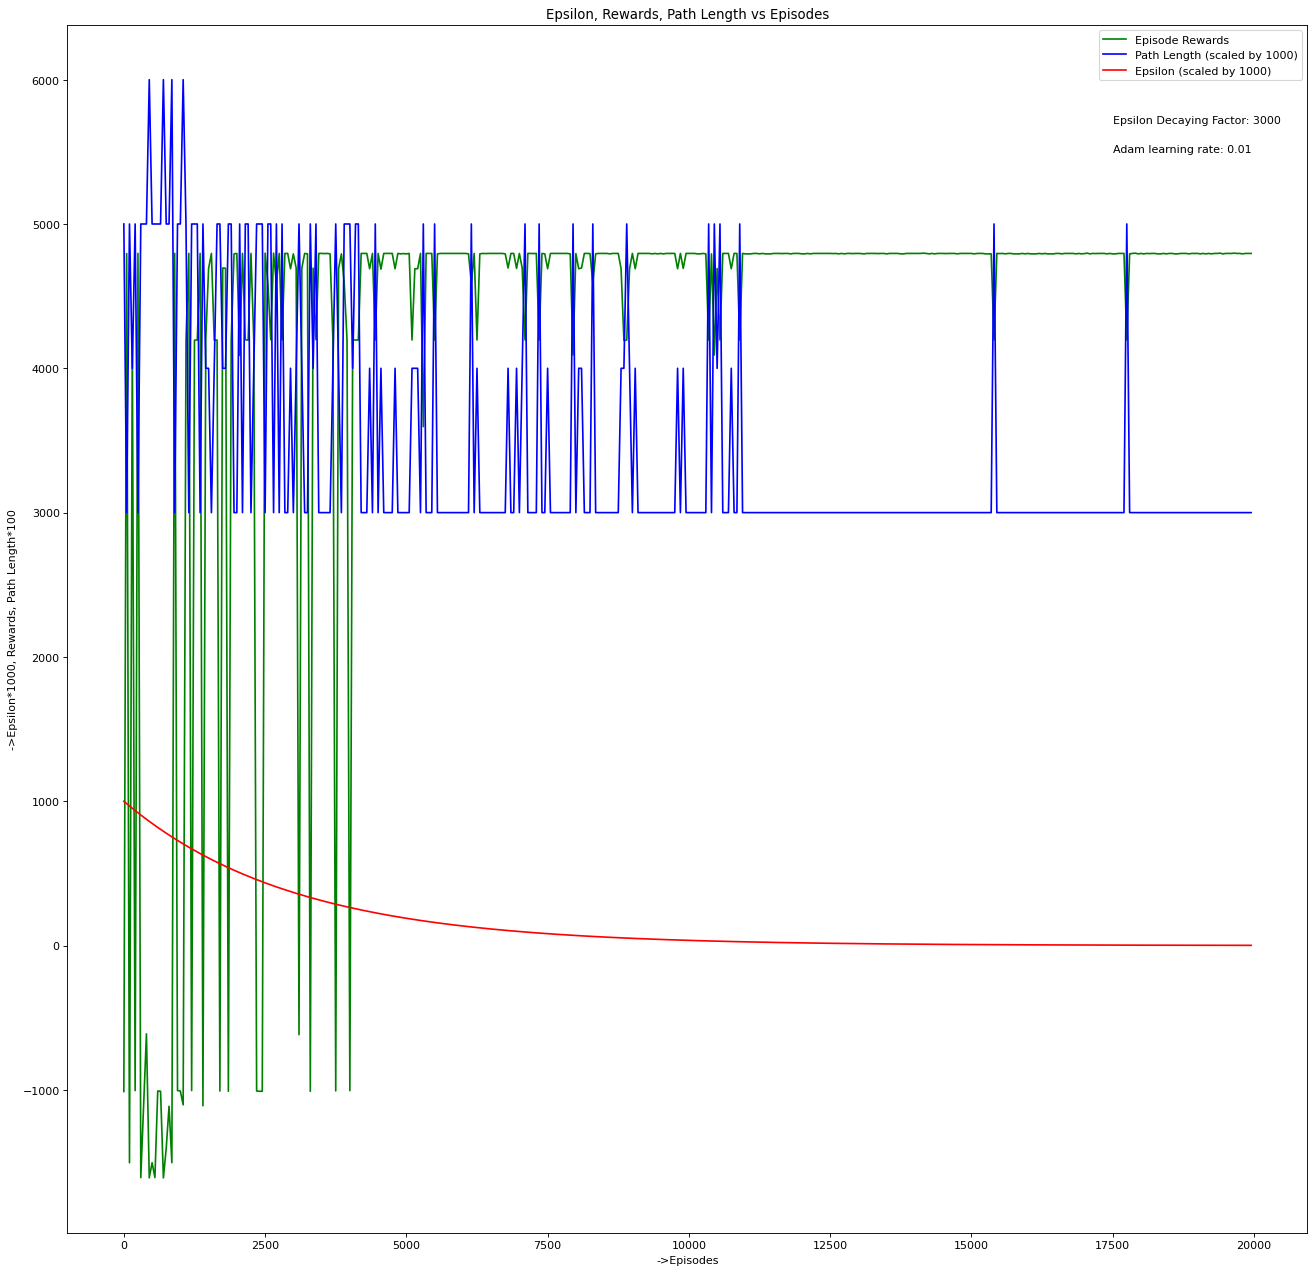

In [34]:
import os
try:
    os.mkdir('saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)][::50]
    p = [i*10 for i in path_length_list]
    path_length_list = p
    fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    plt.plot(x_axis,rewards_list[::50],'g', label='Episode Rewards')
    plt.plot(x_axis,path_length_list[::50],'b', label='Path Length (scaled by 1000)')
    plt.plot(x_axis,epsilon_list[::50],'r', label='Epsilon (scaled by 1000)')
    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(17500, 5700, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(17500, 5500, f'Adam learning rate: 0.01')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')
plot_this(epsilon_list, rewards_list, path_length_list, environment)
print(path_length_list[:2])
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.01_discount_{discount}.png')

In [35]:
# Save the entire model as a SavedModel.
import os
# !mkdir -p saved_model
try:
    os.mkdir('saved_models')
except:
    print('already there')
# mm, tm = DQNAgent.get_models()
agent.main_model.save(f'saved_models/main_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5')
agent.target_model.save(f'saved_models/target_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5')

already there


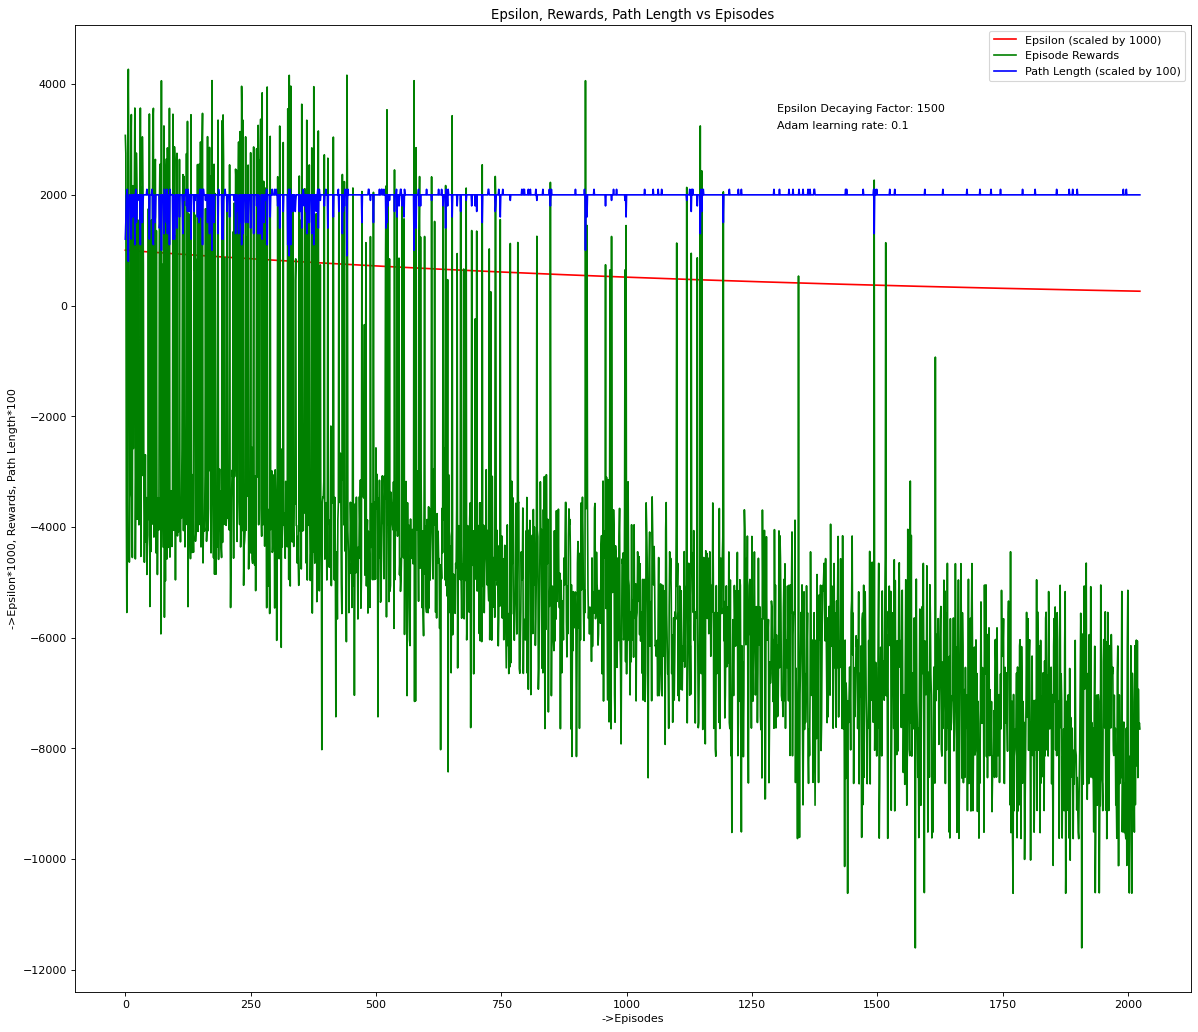

In [72]:
plot_this(epsilon_scaled, rewards_list, path_scaled, environment)

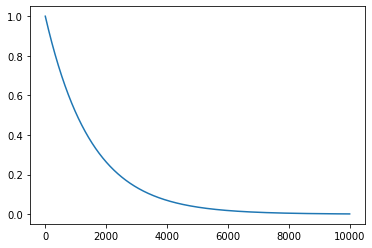

In [119]:
import numpy as np
import matplotlib.pyplot as plt
x = list(range(10000))
# print(x)
k = 1500
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [33]:
class keka:
    def test(self,i):
        return i[1]
    a = [(1,3),(2,1),(3,2)]
    def uppu(self):
        self.a.sort(reverse=True,key=self.test)
        return self.a
    
k = keka()
print(k.uppu())

[(1, 3), (3, 2), (2, 1)]


In [115]:
problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')
len(list(problem.get_nodes()))

5